In [9]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
import torch
from tqdm import tqdm
from sentence_transformers import SentenceTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import cosine_similarity
import ollama  # Ollama (Gemma3) 연결

In [10]:
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 폰트 경로 설정
font_path = "C:/Windows/Fonts/malgun.ttf"
font_name = fm.FontProperties(fname=font_path).get_name()

# 전체 그래프에 적용할 폰트 설정
plt.rcParams["font.family"] = font_name

# 음수 기호(-)가 깨지지 않도록 설정
plt.rcParams["axes.unicode_minus"] = False

import warnings
warnings.filterwarnings(
    "ignore", 
    message=".*Could not find the number of physical cores.*"
)


In [11]:
# CUDA 사용 가능 여부 확인
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [12]:
# ---------------------------
# 1. Train 데이터 로드 및 전처리
# ---------------------------
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission = pd.read_csv("sample_submission.csv", encoding="utf-8-sig")

# 데이터프레임 기본 구조 확인
print("DataFrame Info:")
train_df.info()

print("\nDataFrame Head:")
print(train_df.head())

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23422 entries, 0 to 23421
Data columns (total 18 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   ID               23422 non-null  object
 1   발생일시             23422 non-null  object
 2   사고인지 시간          23422 non-null  object
 3   날씨               23422 non-null  object
 4   기온               23422 non-null  object
 5   습도               23422 non-null  object
 6   공사종류             23422 non-null  object
 7   연면적              23422 non-null  object
 8   층 정보             23422 non-null  object
 9   인적사고             23390 non-null  object
 10  물적사고             21932 non-null  object
 11  공종               23411 non-null  object
 12  사고객체             22735 non-null  object
 13  작업프로세스           23359 non-null  object
 14  장소               23422 non-null  object
 15  부위               23422 non-null  object
 16  사고원인             23359 non-null  object
 17  재발방지대책 및 향후조치계획


결측치 개수:
ID                    0
발생일시                  0
사고인지 시간               0
날씨                    0
기온                    0
습도                    0
공사종류                  0
연면적                   0
층 정보                  0
인적사고                 32
물적사고               1490
공종                   11
사고객체                687
작업프로세스               63
장소                    0
부위                    0
사고원인                 63
재발방지대책 및 향후조치계획       0
dtype: int64
ID         0
발생일시       0
사고인지 시간    0
날씨         0
기온         0
습도         0
공사종류       0
연면적        0
층 정보       0
인적사고       0
물적사고       0
공종         0
사고객체       1
작업프로세스     0
장소         0
부위         0
사고원인       0
dtype: int64
텍스트 길이 평균: 60.18768679019725
텍스트 길이 분산: 1229.2076738342105
텍스트 길이 중앙값 51.0


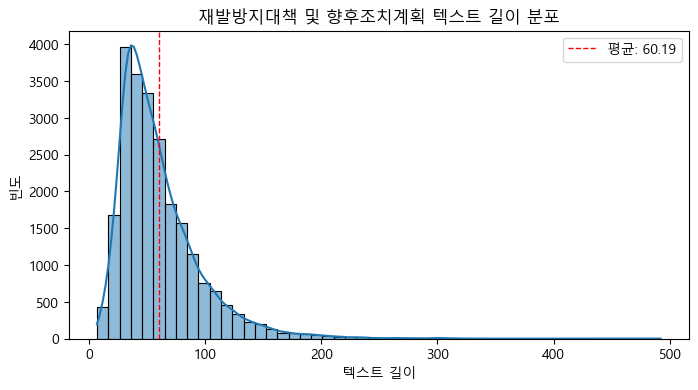

In [13]:
# 결측치 확인
print("\n결측치 개수:")
print(train_df.isnull().sum())
print(test_df.isnull().sum())

# 결측치 처리 (예시: 빈 문자열로 채우기)
train_df = train_df.fillna("")
test_df = test_df.fillna("")

# 타깃 컬럼(재발방지대책 및 향후조치계획)의 길이 계산
train_df["plan_length"] = train_df["재발방지대책 및 향후조치계획"].apply(len)

# 텍스트 길이의 평균과 분산 계산
mean_length = train_df["plan_length"].mean()
variance_length = train_df["plan_length"].var()
median_length = train_df["plan_length"].median()

print("텍스트 길이 평균:", mean_length)
print("텍스트 길이 분산:", variance_length)
print("텍스트 길이 중앙값", median_length)
# 텍스트 길이 분포 시각화
plt.figure(figsize=(8, 4))
sns.histplot(train_df["plan_length"], bins=50, kde=True)
plt.axvline(mean_length, color='red', linestyle='dashed', linewidth=1, label=f'평균: {mean_length:.2f}')
plt.title("재발방지대책 및 향후조치계획 텍스트 길이 분포")
plt.xlabel("텍스트 길이")
plt.ylabel("빈도")
plt.legend()
plt.show()

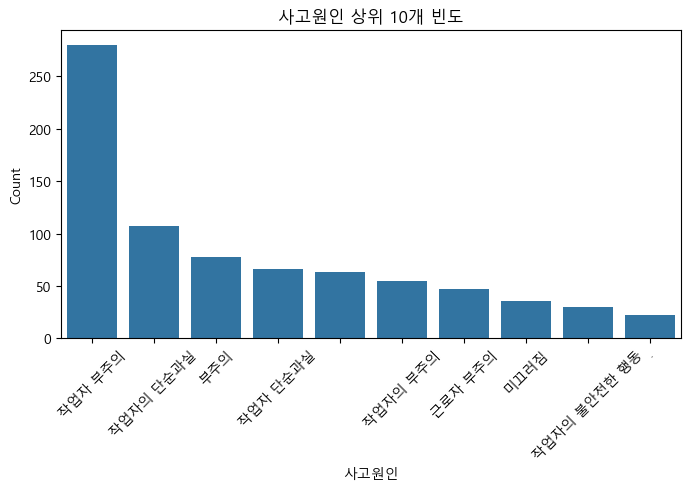

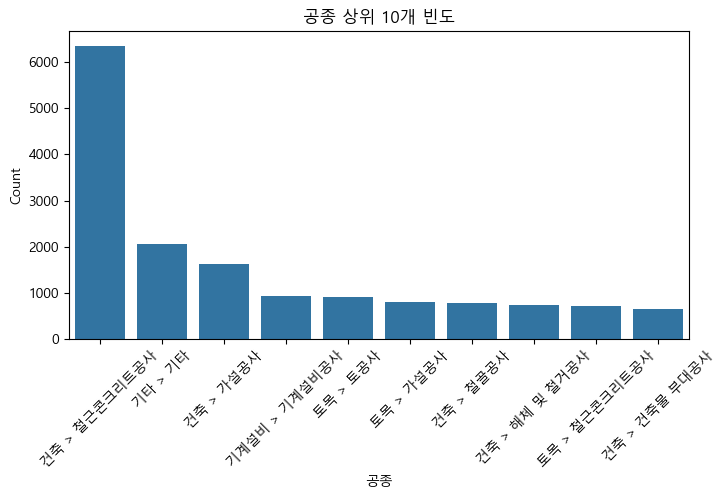

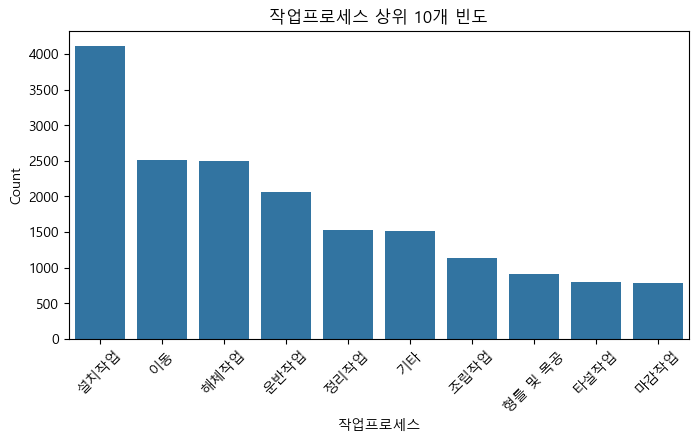

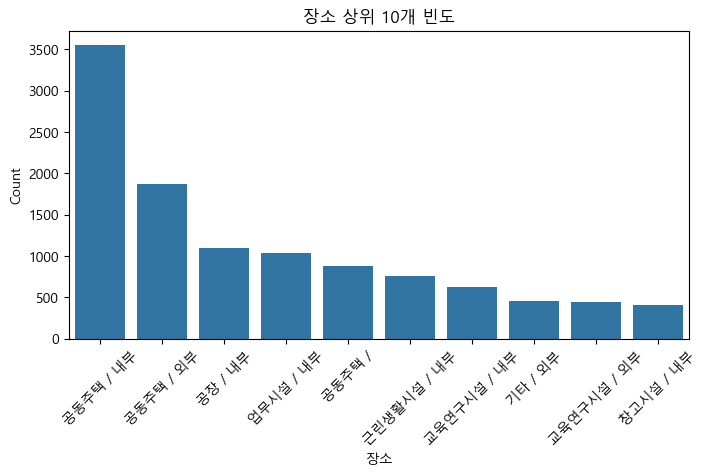

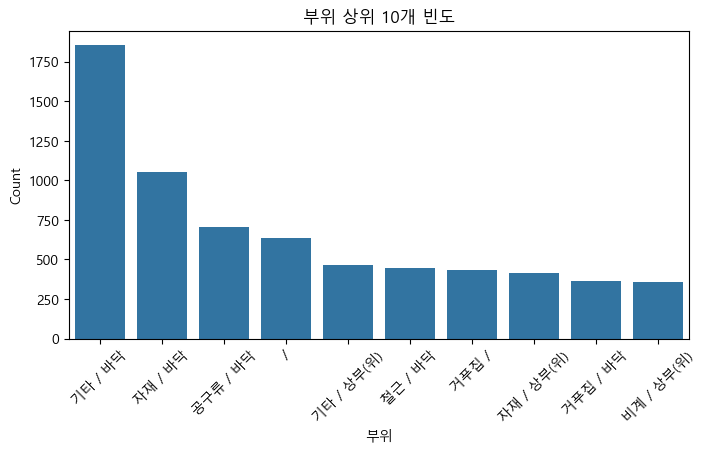

In [14]:
# 예: 사고원인, 공종, 작업프로세스, 장소, 부위 등 범주형 칼럼의 값 분포
categorical_cols = ["사고원인", "공종", "작업프로세스", "장소", "부위"]

for col in categorical_cols:
    value_counts = train_df[col].value_counts().head(10)  # 상위 10개만 예시
    plt.figure(figsize=(8, 4))
    sns.barplot(x=value_counts.index, y=value_counts.values)
    plt.title(f"{col} 상위 10개 빈도")
    plt.xticks(rotation=45)
    plt.ylabel("Count")
    plt.show()


In [15]:
from sentence_transformers import SentenceTransformer
from sklearn.metrics.pairwise import cosine_similarity

device = "cuda" if torch.cuda.is_available() else "cpu"
# SentenceTransformer 모델 로드 (빠른 임베딩을 위해 'all-MiniLM-L6-v2' 사용)
model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

# 필수 컬럼 확인
columns_needed = ["사고원인", "재발방지대책 및 향후조치계획"]
if not all(col in train_df.columns for col in columns_needed):
    raise ValueError(f"필수 컬럼 {columns_needed}이 데이터에 없습니다.")


In [16]:
# 학습 데이터: 사고객체와 사고원인 각각 벡터화
accident_object_vectors = model.encode(train_df["사고객체"].tolist(), convert_to_numpy=True)
accident_cause_vectors  = model.encode(train_df["사고원인"].tolist(), convert_to_numpy=True)

# 테스트 데이터: 사고객체와 사고원인 각각 벡터화
test_object_vectors = model.encode(test_df["사고객체"].tolist(), convert_to_numpy=True)
test_cause_vectors  = model.encode(test_df["사고원인"].tolist(), convert_to_numpy=True)

In [17]:
# 사용자 지정 가중치 (사용자가 변경 가능)
object_weight = 0.25  # 사고객체 가중치
cause_weight = 0.75  # 사고원인 가중치

# 유사도 행렬 계산
object_similarity_matrix = cosine_similarity(accident_object_vectors)  # 사고객체 유사도
cause_similarity_matrix = cosine_similarity(accident_cause_vectors)  # 사고원인 유사도

# 사용자 가중치를 반영한 최종 유사도 행렬
final_similarity_matrix = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)


# 유사한 사고 찾기 함수 (가중치 반영된 유사도 기준)
def find_similar_accidents(index, top_n=5):
    """
    주어진 사고의 인덱스를 기반으로 가장 유사한 사고를 찾음.
    동일 사고는 제외하고 top_n개를 반환.
    """
    similarities = final_similarity_matrix[index]
    similar_indices = np.argsort(-similarities)[1:top_n+1]  # 자기 자신 제외, 상위 N개 선택
    return similar_indices, similarities[similar_indices]

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고객체: {train_df['사고객체'].iloc[example_index]}")
print(f"🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🏷 사고객체: {train_df['사고객체'].iloc[idx]}")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")



🔹 기준 사고객체: 건설자재 > 철근
🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.9091)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업시 추락에 대한 대비 미흡 (안전고리 미체결)
  ⮩ 대응 대책: 고소작업 시 안전작업방법 교육, 안전벨트 착용 및 체결 교육, 작업구간 관리감독자 상주, 관리감독자 교육 실시, 안전고리 체결 및 사고 발생 시 보고 철저를 통한 재발 방지 대책.

🔸 2번째 유사한 사고 (유사도: 0.7944)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업 시, 개인보호구 착용을 철저히 하고 상부에 안전대 부착시설에 안전고리 체결 후 작업을 실시하여야 하나 근로자가 이에 대해 부주의하여 발생한 사건임.
  ⮩ 대응 대책: 불안전한 행동 금지와 해당 공종 작업자 특별 교육 실시, 관리감독자의 현장 상주 및 작업 감독, 고소작업 특별 교육 실시 요청과 관리감독자 상주 요청.

🔸 3번째 유사한 사고 (유사도: 0.7711)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 기둥과 안전난간 사이 협소한 공간에서 고소작업대를 벗어나 작업중 고소작업대에서 떨어짐
  ⮩ 대응 대책: 일일 위험 예지 활동 강화에 대한 작업 내용 및 방법, 안전대 착용에 대한 방안.

🔸 4번째 유사한 사고 (유사도: 0.7629)
  🏷 사고객체: 건설자재 > 자재
  🛑 사고원인: 추락위험이 있는 장소에서 안전난간대 해체 후 안전대 미착용 및 안전고리 미체결로 떨어짐
  ⮩ 대응 대책: 추락 위험 발생 구간에 대한 안전대 및 안전고리 체결 교육, 안전난간대 해체 시 원청사 또는 안전관리자 사전 통보 후 작업 진행, 지하 4층 자재 및 장비 반입 시 원청사 또는 안전관리자 통보, 작업 전 안전교육 강화.

🔸 5번째 유사한 사고 (유사도: 0.730

In [18]:
# 사용자 지정 가중치 (사용자가 변경 가능)
object_weight = 0.3  # 사고객체 가중치
cause_weight = 0.7  # 사고원인 가중치

# 유사도 행렬 계산
object_similarity_matrix = cosine_similarity(accident_object_vectors)  # 사고객체 유사도
cause_similarity_matrix = cosine_similarity(accident_cause_vectors)  # 사고원인 유사도

# 사용자 가중치를 반영한 최종 유사도 행렬
final_similarity_matrix = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고객체: {train_df['사고객체'].iloc[example_index]}")
print(f"🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🏷 사고객체: {train_df['사고객체'].iloc[idx]}")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")



🔹 기준 사고객체: 건설자재 > 철근
🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.9151)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업시 추락에 대한 대비 미흡 (안전고리 미체결)
  ⮩ 대응 대책: 고소작업 시 안전작업방법 교육, 안전벨트 착용 및 체결 교육, 작업구간 관리감독자 상주, 관리감독자 교육 실시, 안전고리 체결 및 사고 발생 시 보고 철저를 통한 재발 방지 대책.

🔸 2번째 유사한 사고 (유사도: 0.8081)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업 시, 개인보호구 착용을 철저히 하고 상부에 안전대 부착시설에 안전고리 체결 후 작업을 실시하여야 하나 근로자가 이에 대해 부주의하여 발생한 사건임.
  ⮩ 대응 대책: 불안전한 행동 금지와 해당 공종 작업자 특별 교육 실시, 관리감독자의 현장 상주 및 작업 감독, 고소작업 특별 교육 실시 요청과 관리감독자 상주 요청.

🔸 3번째 유사한 사고 (유사도: 0.7864)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 기둥과 안전난간 사이 협소한 공간에서 고소작업대를 벗어나 작업중 고소작업대에서 떨어짐
  ⮩ 대응 대책: 일일 위험 예지 활동 강화에 대한 작업 내용 및 방법, 안전대 착용에 대한 방안.

🔸 4번째 유사한 사고 (유사도: 0.7625)
  🏷 사고객체: 건설자재 > 자재
  🛑 사고원인: 추락위험이 있는 장소에서 안전난간대 해체 후 안전대 미착용 및 안전고리 미체결로 떨어짐
  ⮩ 대응 대책: 추락 위험 발생 구간에 대한 안전대 및 안전고리 체결 교육, 안전난간대 해체 시 원청사 또는 안전관리자 사전 통보 후 작업 진행, 지하 4층 자재 및 장비 반입 시 원청사 또는 안전관리자 통보, 작업 전 안전교육 강화.

🔸 5번째 유사한 사고 (유사도: 0.748

In [19]:
# 사용자 지정 가중치 (사용자가 변경 가능)
object_weight = 0.2  # 사고객체 가중치
cause_weight = 0.8  # 사고원인 가중치

# 유사도 행렬 계산
object_similarity_matrix = cosine_similarity(accident_object_vectors)  # 사고객체 유사도
cause_similarity_matrix = cosine_similarity(accident_cause_vectors)  # 사고원인 유사도

# 사용자 가중치를 반영한 최종 유사도 행렬
final_similarity_matrix = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)

# 특정 사고에 대해 유사 사고 찾기
example_index = 0  # 예제 인덱스
similar_indices, similarity_scores = find_similar_accidents(example_index)

# 결과 출력
print(f"\n🔹 기준 사고객체: {train_df['사고객체'].iloc[example_index]}")
print(f"🔹 기준 사고원인: {train_df['사고원인'].iloc[example_index]}")
print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[example_index]}\n")

for rank, (idx, score) in enumerate(zip(similar_indices, similarity_scores), start=1):
    print(f"🔸 {rank}번째 유사한 사고 (유사도: {score:.4f})")
    print(f"  🏷 사고객체: {train_df['사고객체'].iloc[idx]}")
    print(f"  🛑 사고원인: {train_df['사고원인'].iloc[idx]}")
    print(f"  ⮩ 대응 대책: {train_df['재발방지대책 및 향후조치계획'].iloc[idx]}\n")



🔹 기준 사고객체: 건설자재 > 철근
🔹 기준 사고원인: 고소작업 중 추락 위험이 있음에도 불구하고, 안전난간대, 안전고리 착용 등 안전장치가 미흡하였음.
  ⮩ 대응 대책: 고소작업 시 추락 위험이 있는 부위에 안전장비 설치.

🔸 1번째 유사한 사고 (유사도: 0.9030)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업시 추락에 대한 대비 미흡 (안전고리 미체결)
  ⮩ 대응 대책: 고소작업 시 안전작업방법 교육, 안전벨트 착용 및 체결 교육, 작업구간 관리감독자 상주, 관리감독자 교육 실시, 안전고리 체결 및 사고 발생 시 보고 철저를 통한 재발 방지 대책.

🔸 2번째 유사한 사고 (유사도: 0.7806)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 고소작업 시, 개인보호구 착용을 철저히 하고 상부에 안전대 부착시설에 안전고리 체결 후 작업을 실시하여야 하나 근로자가 이에 대해 부주의하여 발생한 사건임.
  ⮩ 대응 대책: 불안전한 행동 금지와 해당 공종 작업자 특별 교육 실시, 관리감독자의 현장 상주 및 작업 감독, 고소작업 특별 교육 실시 요청과 관리감독자 상주 요청.

🔸 3번째 유사한 사고 (유사도: 0.7633)
  🏷 사고객체: 건설자재 > 자재
  🛑 사고원인: 추락위험이 있는 장소에서 안전난간대 해체 후 안전대 미착용 및 안전고리 미체결로 떨어짐
  ⮩ 대응 대책: 추락 위험 발생 구간에 대한 안전대 및 안전고리 체결 교육, 안전난간대 해체 시 원청사 또는 안전관리자 사전 통보 후 작업 진행, 지하 4층 자재 및 장비 반입 시 원청사 또는 안전관리자 통보, 작업 전 안전교육 강화.

🔸 4번째 유사한 사고 (유사도: 0.7558)
  🏷 사고객체: 건설자재 > 철근
  🛑 사고원인: 기둥과 안전난간 사이 협소한 공간에서 고소작업대를 벗어나 작업중 고소작업대에서 떨어짐
  ⮩ 대응 대책: 일일 위험 예지 활동 강화에 대한 작업 내용 및 방법, 안전대 착용에 대한 방안.

🔸 5번째 유사한 사고 (유사도: 0.741

In [20]:
# --- 3. 사용자 지정 가중치 및 최종 유사도 계산 (학습 데이터 간은 기존 코드 참고) ---
# (학습 데이터에서의 최종 유사도 행렬: 향후 참고용)
object_weight = 0.25  # 사고객체 가중치
cause_weight  = 0.75  # 사고원인 가중치

object_similarity_matrix = cosine_similarity(accident_object_vectors)  # (train vs train)
cause_similarity_matrix  = cosine_similarity(accident_cause_vectors)    # (train vs train)
final_similarity_matrix    = (object_weight * object_similarity_matrix) + (cause_weight * cause_similarity_matrix)

# --- 4. 테스트 데이터와 학습 데이터 간의 유사도 계산 ---
# 각 테스트 샘플에 대해, 학습 데이터와의 유사도를 계산
object_similarity_test = cosine_similarity(test_object_vectors, accident_object_vectors)
cause_similarity_test  = cosine_similarity(test_cause_vectors, accident_cause_vectors)
final_similarity_test  = (object_weight * object_similarity_test) + (cause_weight * cause_similarity_test)

def find_similar_accidents_for_test(test_index, top_n=5):
    """
    주어진 테스트 샘플(test_index)의 사고객체 및 사고원인에 대해,
    학습 데이터(train_df)에서 가장 유사한 사례 top_n개를 반환합니다.
    """
    similarities = final_similarity_test[test_index]
    # 내림차순 정렬하여 상위 top_n 사례 추출
    similar_indices = np.argsort(-similarities)[:top_n]
    return similar_indices, similarities[similar_indices]

In [21]:
def generate_rag_response(top_k_cases, 기준_사고객체, 기준_사고원인):
    system_message = (
        "<|im_start|>system\n"
        "당신은 한국인 건설 사고 전문가입니다.\n"
        "아래 사례들을 참고하여, 안전교육 강화 및 위험요소 점검을 통한 재발방지대책과 향후 조치 계획을 작성해야 합니다.\n"
        "주어진 유사 사고 사례들은 사고객체와 사고원인에 따른 대응 대책이 제시되어 있으므로, 이를 종합해 기준 사고에 맞는 최적의 대응 대책을 도출하세요.\n"
        "반드시 \"대응대책:\"으로 시작하는 한 문장으로 답변하세요.\n"
        "<|im_end|>"
    )

    user_message = (
        "<|im_start|>user\n"
        "[기준 사고]\n"
        f"- 사고객체: {기준_사고객체}\n"
        f"- 사고원인: {기준_사고원인}\n\n"
        "[유사 사례 - 기존 대응 대책들]:\n" +
        "\n".join([
            f"{i+1}. 사고객체: {case[0]}, 사고원인: {case[1]}, 대응 대책: {case[2]}"
            for i, case in enumerate(top_k_cases)
        ]) + "\n\n"
        "위의 유사 사례들을 참고하여, 기준 사고에 대한 최적의 재발방지대책 및 향후 조치 계획을 한 문장으로 작성하되, "
        "반드시 \"대응대책:\"으로 시작하는 한 문장으로 답변하세요.\n"
        "<|im_end|>"
    )

    messages = [
        {"role": "system", "content": system_message},
        {"role": "user", "content": user_message}
    ]
    
    # 실제 환경에서는 ollama.chat API를 사용하세요.
    response = ollama.chat(
        model="gemma3:27b-it-q4_K_M",
        messages=messages
    )
    return response["message"]["content"]


In [22]:
def process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results.csv"):
    """
    test_df의 각 샘플에 대해, 학습 데이터와의 최종 유사도를 기반으로 상위 유사 사례(top_n)를 추출한 후,
    generate_rag_response 함수를 호출하여 LLM(QWQ32B) 결과(최적의 재발방지대책 및 향후 조치 계획)를 생성합니다.
    결과는 콘솔에 출력하고, CSV 파일로 저장합니다.
    """
    results = []  # LLM 결과 저장 리스트

    # test_df의 각 샘플에 대해 처리
    for test_idx in tqdm(range(len(test_df)), desc="Processing test cases with LLM"):
        # 학습 데이터와의 최종 유사도에서 상위 top_n 사례 추출 (내림차순 정렬)
        similarities = final_similarity_test[test_idx]
        similar_indices = np.argsort(-similarities)[:top_n]
        
        # 상위 유사 사례에 대한 (사고객체, 사고원인, 대응 대책) 튜플 리스트 생성
        top_k_cases = [
            (
                train_df.iloc[i]["사고객체"],
                train_df.iloc[i]["사고원인"],
                train_df.iloc[i]["재발방지대책 및 향후조치계획"]
            )
            for i in similar_indices
        ]
        
        기준_사고객체 = test_df.iloc[test_idx]["사고객체"]
        기준_사고원인   = test_df.iloc[test_idx]["사고원인"]
        
        # LLM 프롬프트에 따라 최적 대응 대책 생성
        rag_result = generate_rag_response(top_k_cases, 기준_사고객체, 기준_사고원인)
        results.append(rag_result)
        
        # 콘솔 출력 (각 테스트 샘플 별 상세 정보)
        print(f"--- Test Sample {test_idx} ---")
        print(f"테스트 사고객체: {기준_사고객체}")
        print(f"테스트 사고원인: {기준_사고원인}")
        print("유사 학습 사례:")
        for rank, i in enumerate(similar_indices, start=1):
            print(f"  {rank}. 사고객체: {train_df.iloc[i]['사고객체']}")
            print(f"     사고원인: {train_df.iloc[i]['사고원인']}")
            print(f"     대응 대책: {train_df.iloc[i]['재발방지대책 및 향후조치계획']}")
            print(f"     유사도: {similarities[i]:.4f}")
        print("=== LLM 최종 결과 ===")
        print(rag_result)
        print("\n" + "-"*80 + "\n")
    
    # test_df에 LLM 결과를 추가하고 CSV 파일로 저장
    results_df = test_df.copy()
    results_df["LLM_결과"] = results
    results_df.to_csv(output_csv, index=False, encoding="utf-8-sig")
    print(f"LLM 결과가 '{output_csv}' 파일에 저장되었습니다.")
    
    return results_df

In [23]:
results_df = process_test_cases_with_llm(test_df, final_similarity_test, train_df, top_n=5, output_csv="llm_results_gemma3.csv")

Processing test cases with LLM:   0%|          | 1/964 [00:29<7:57:53, 29.78s/it]

--- Test Sample 0 ---
테스트 사고객체: 건설기계 > 콘크리트펌프
테스트 사고원인: 펌프카 아웃트리거 바닥 고임목을 3단으로 보강 했음에도, 지반 침하(아웃트리거 우측 상부 1개소)가 발생하였고,  좌, 우측 아웃트리거의 펼친 길이가 상이하고 타설 위치가 건물 끝부분 모서리에 위치하여 붐대호스를 최대로 펼치다 보니 장비에 대한 무게중심이 한쪽으로 쏠려 일부 전도되는 사고가 발생된 것으로 판단됨
유사 학습 사례:
  1. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 지반침하로 인하여 펌프카 왼쪽 앞 지지대가 침하되면서 전도 되었고 이에따라 붐대에 작업자가 깔리면서 사고 발생
     대응 대책: 안전교육 실시와 안전관리 강화를 통한 재발 방지 대책 마련.
     유사도: 0.8048
  2. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 붐대를 최대거리로 사용하면서 하중이 집중되어 아웃트리거 지반이 붕괴.
     대응 대책: 관리적 대책으로 차량계 건설기계 작업계획서 작성 및 검토와 펌프카 안전점검 체크리스트에 의한 사전 점검, 기술적 대책으로 펌프카 아웃트리거 설치 시 지반상태 사전 점검 및 받침대 추가 설치 확인, 유도자 또는 신호수 배치, 작업구역 설정, 타 근로자 출입금지 조치, 교육적 대책으로 펌프카 작업 전 안전교육 실시 및 확인, 당 작업 전 TBM 시 작업내용 및 위험포인트 내용 공유, 향후 조치 계획으로 재발 방지 대책 수립 및 현장 관리 철저.
     유사도: 0.7855
  3. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 아웃트리거 받침목이 이탈하면서 붐대가 쓰러져 콘트리트 타설 작업자 타격
     대응 대책: 아웃트리거 사용 장비 받침 등 제반 사항의 철저한 확인과 안전사고 발생에 따른 부산지방고용노동청 조치사항 및 유가족 합의사항의 진행상황 확인 예정.
     유사도: 0.7673
  4. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카로 무근 콘트리트 

Processing test cases with LLM:   0%|          | 2/964 [00:55<7:15:42, 27.18s/it]

--- Test Sample 1 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 불안전한 행동(숫돌 측면 사용) 및 보안면 미 착용
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 보안경 미착용 및 불안전한 작업자세
     대응 대책: 관련 근로자 보안경 일체형 안전모 지급 및 사용상태 확인을 통한 원인 규명과 재발 방지 대책 수립.
     유사도: 0.8001
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 보안경 미착용(보안경 지급) 및 부주의
     대응 대책: 동일 작업장 내 타 공종 겹침 작업 시 주변 작업자와의 거리 유지 및 보호구 착용 관리 철저를 위한 작업자 안전교육 및 보호구 지급 이행 계획.
     유사도: 0.7833
  3. 사고객체: 건설공구 > 공구류
     사고원인: 절곡기 사용시 보안경 미착용(불안전한 행동으로 작업실시)
     대응 대책: 절단 및 가공작업에 대한 사전교육 및 관리감독자 상주, 작업자 보안경 착용 확인감독, 현장 안전점검 실시.
     유사도: 0.7714
  4. 사고객체: 건설공구 > 공구류
     사고원인: - 작업전 작업냬용 및 특성등 위험성 전달부족- 작업전 가죽장갑등 보호구 미착용- 회전체를 자동으로 고정시킴
     대응 대책: 작업전 작업내용 고지 및 위험성 교육 실시와 작업특성에 맞는 보호구 착용을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7274
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근가공받침대의 로울러 볼트조임에 적합한 공도구(박스렌치)외에 부적합한 도구 사용, 지급된 보안경 미착용, 작업자세 불량 등
     대응 대책: 재발 방지 대책과 향후 조치 계획의 통합으로 근로자 특별안전교육 실시, 위험성 평가 재실시 및 교육, 유해위험기계기구 안전작업 표지판 부착, 공도구 비치 철저, 철근절단기 방호커버 대책 실치, 사고사례 전파 등이 포함된 안전 관리 체계 구축.
 

Processing test cases with LLM:   0%|          | 3/964 [01:23<7:24:44, 27.77s/it]

--- Test Sample 2 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자가 작업을 위해 이동 중 전방을 주시하지 않아 발을 헛디뎌 계단에서 굴러 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자가 계단을 내려가는 도중에 발을 헛딛여서 넘어짐
     대응 대책: 지속적인 통행로 청소와 계단실 내 보행주의 표지판 부착을 통한 전도 방지 대책.
     유사도: 0.8793
  2. 사고객체: 기타 > 기타
     사고원인: 계단으로 이동 중 발을 헛디뎌 넘어짐
     대응 대책: 이동 중 넘어짐 사고 위험성 평가와 작업 및 이동 중 전도에 대한 특별 교육 실시.
     유사도: 0.8558
  3. 사고객체: 기타 > 기타
     사고원인: 작업자가 지하층 계단으로 내려오던 도중 발을 헛디뎌 넘어졌다고 함(목격자 없음)
     대응 대책: 해당 현장 계단실 조도 및 바닥 정리 상태 확인과 지하층 계단 조도 확보 및 쓰레기 정리.
     유사도: 0.8557
  4. 사고객체: 기타 > 기타
     사고원인: 계단이동중 발을 헛디뎌 넘어짐
     대응 대책: 작업투입전 안전교육 철저 및 안전담당자 감독강화.
     유사도: 0.8453
  5. 사고객체: 기타 > 기타
     사고원인: 계단실 이동시 발을 헛디뎌 미끄러져 넘어짐
     대응 대책: 근로자의 안전과 사후 관리 철저, 재발 방지 대책 수립, 감리단장 및 현장소장의 밀접한 현장 관리, 근로자 안전사고 사전 교육 철저, 숙련된 기능공 배치, 중대재해 사항 외 주의가 필요한 사항에 대한 현장소장 및 감리단장의 밀접한 현장 관리, 휴식 시간 동안 불필요한 이동 자제 및 관리 인력의 세심한 주의.
     유사도: 0.8365
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육 시 계단 이용 시 전방주시 및 미끄럼 방지 요령을 집중 교육하고, 통행로 및 계단실을 주기적으로 청소 및 점검하며, 조도 확보 및 보행주의 표지판 

Processing test cases with LLM:   0%|          | 4/964 [01:46<6:51:48, 25.74s/it]

--- Test Sample 3 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업 발판 위 벽돌 잔재를 밟고 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 적치된 벽돌을 밟고 이동 중 넘어짐
     대응 대책: 주기적 안전교육 실시와 불안전한 자세 및 행동에 대한 관리감독 철저.
     유사도: 0.8925
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 이동중 바닥에 있는 벽돌을 미쳐 발견하지 못하고 밟음
     대응 대책: 위험요소 제거와 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8629
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업중 벽돌 무너짐에 의한 사고
     대응 대책: 조적공사 시 적정 높이로 벽돌을 쌓고, 자재 정리 작업 중 발생하는 안전사고에 대한 사전 교육 및 작업 시 자재의 형상, 무게, 주변 환경을 고려한 감독.
     유사도: 0.8384
  4. 사고객체: 건설자재 > 자재
     사고원인: 벽돌을 틀비계 위로 양중하던 중 작업자의 실수로 벽돌 한장이 떨어져 이를 피하려던 작업자가 주변 구조물에 걸려 넘어짐.
     대응 대책: 작업자 안전교육 실시를 통한 안전사고 예방.
     유사도: 0.8100
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 단순과실(상층부 작업자의 벽돌을 잘 못 놔둬 아래로 낙하)
     대응 대책: 공사인부 안전 교육 실시와 시공사에 작업자 안전교육 요청 및 현장대리인에게 공사장 관리 철저 지시를 통한 안전 확보.
     유사도: 0.7815
=== LLM 최종 결과 ===
대응대책: 작업 발판 위 잔재물 제거를 위한 정기적인 현장 정리정돈 점검을 실시하고, 작업 전 안전교육을 강화하여 작업자의 주의 의무를 고취하며, 불안전한 작업 환경에 대한 관리 감독을 철저히 함으로써 재발을 방지한다.


-------------------------------

Processing test cases with LLM:   1%|          | 5/964 [02:14<7:04:10, 26.54s/it]

--- Test Sample 4 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 점심식사를 위한 이동시 작업자 부주의로 인한 추락사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 점심식사를 하기 위해 식당으로 이동중 미끄러져 타박상이 발생한 사고
     대응 대책: TBM 시 현장 내 이동 시 주의하여 이동 교육 실시와 각종 점검 시 동일 안전사고 방지 현장 지도 예정.
     유사도: 0.7862
  2. 사고객체: 기타 > 기타
     사고원인: 점심식사를 위해 내려오던 중 미끄러짐
     대응 대책: 사고사례 전파와 현장 내 임시계단 미끄럼 방지조치(논슬립 테이프 부착) 실시.
     유사도: 0.7710
  3. 사고객체: 기타 > 기타
     사고원인: 점심식사 후 개인차량에서 휴식 중 작업자 부주의로 차량창문 틈에 손끼임 사고 발생
     대응 대책: 사업장 내 근로자 휴게시설에서의 휴식 준수 방안.
     유사도: 0.7304
  4. 사고객체: 기타 > 기타
     사고원인: 식당입구에 설치한 경사로 발판에 작업자 이동중 부상당함
     대응 대책: 작업자들의 이동 중 통행에 방해가 되는 위험요소 제거와 안전교육 철저.
     유사도: 0.7301
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동중 부주의
     대응 대책: 작업자 안전 교육 강화, 고령의 작업자 관리 철저, 보행 시 넘어짐 주의 표지 설치 및 현장 안전 관리 철저 요청을 통한 안전 확보.
     유사도: 0.7245
=== LLM 최종 결과 ===
대응대책: 점심 식사 시간 이동 시 작업자 부주의로 인한 추락 사고 재발 방지를 위해 안전 교육을 강화하고, 현장 내 이동 경로의 위험 요소를 점검하여 미끄럼 방지 조치를 취하며, 고령 작업자 관리를 철저히 하고, 보행 시 넘어짐 주의 표지 설치 및 현장 안전 관리 강화를 통해 안전 확보를 최우선으로 할 것입니다.


--------------------

Processing test cases with LLM:   1%|          | 6/964 [02:41<7:05:18, 26.64s/it]

--- Test Sample 5 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 안전발판 설치 미흡 및 작업절차 미준수
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 안전대걸이(부착설비) 및 작업발판 미설치
     대응 대책: 고소작업구간 안전대 고리 부착설비 설치 및 연결 후 안전수칙 준수와 현장지도 및 관련서류 적정성 검토, 미흡사항 시정명령 및 처분.
     유사도: 0.8258
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업발판 작업시 작업자의 안전대 긴결 상태 안전 미확보
     대응 대책: 동일작업에 대한 작업 안전강화, 현장 위험사항 확인 및 위험요소 제거, 사고원인분석을 통한 관계전문가 확인, 안전시설물 점검 및 보수, 보강 조치, 재발 방지를 위한 조치 및 계획 보고서 제출, 공사중지 조치.
     유사도: 0.8218
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업발판 없이 작업 ,근로자 안전밸트 미착용
     대응 대책: T.B.M 시 근로자 안전장구 착용 확인 및 작업발판 설치 후 작업 여부에 대한 상시 순회점검 실시.
     유사도: 0.7917
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서 미준수 및 부주의로 인한 사고
     대응 대책: 사고 지연보고 및 은폐 방지를 위한 하도급업체 및 수급사 안전교육 실시와 작업순서 철저 준수 교육 실시.
     유사도: 0.7840
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치기준 미 준수 및 작업 전 안전점검 미 확인
     대응 대책: 작업발판 설치기준 준수 및 작업 전 안전점검 실시, TBM 시 위험요소 및 안전수칙 전파, 근로자 정기교육 시 사고사례 전파 및 예방교육 실시, 산재처리 진행.
     유사도: 0.7729
=== LLM 최종 결과 ===
대응대책: 거푸집 작업 전 안전발판 설치 및 고정 상태를 철저히 점검하고, 작업 전 안전교육 및 TBM을 통해

Processing test cases with LLM:   1%|          | 7/964 [03:05<6:53:36, 25.93s/it]

--- Test Sample 6 ---
테스트 사고객체: 기타 > 지하매설물
테스트 사고원인: * 주원인  : 작업자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 가시설 > 안전시설물
     사고원인: 작업자의 불안전한 행동
     대응 대책: 규정된 작업발판 이외 장소로 이동 작업금지 교육과 유사사례에 대한 안전교육 실시.
     유사도: 0.8081
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자의 불안전한 행동
     대응 대책: 올바른 안전 보호구 사용과 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7939
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자의 불안전한 행동
     대응 대책: 이동통로 선 정리정돈 실시, 현장 내에서 이동 시 전방주시 철저, 특별안전교육 진행, 불안전한 행동 및 상태 주기적 점검 강화, 사고사례 전파 및 위험성 평가 실시를 통한 동일사고 발생 예방.
     유사도: 0.7867
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자의 불안전한 행동
     대응 대책: 자재적재 시 주의사항에 대한 근로자 교육과 재발 방지 대책 회의 후 실시되는 현장 관리.
     유사도: 0.7867
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자의 불안전한 행동
     대응 대책: 작업 전 주변 환경 사전 파악을 위한 근로자 교육과 현장 관리 실시.
     유사도: 0.7867
=== LLM 최종 결과 ===
대응대책: 지하매설물 작업 전 해당 위치 도면 확인 및 사전 안전 교육 실시, 작업 발판 외 이동 금지, 전방주시 철저, 불안전 행동 점검 강화, 유사사례 공유 및 위험성 평가를 통해 작업자의 불안전한 행동으로 인한 재발 방지 대책을 수립하고 현장 관리를 강화한다.


-----------------------------------------------------------------------

Processing test cases with LLM:   1%|          | 8/964 [03:33<7:01:13, 26.44s/it]

--- Test Sample 7 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: TSC GIRDER 조립에 필요한 SPLICE PLATE 설치 중 후두부 부딪힘
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 2021년4월14일(수).사고자가기둥 HOOP철근 가공 작업도중 철근 밴딩기와 엄지 손가락 부딛힘 사고 발생.
     대응 대책: 철근 밴딩기 사용숙지 교육 및 작업자들에 대한 안전 교육 실시 예정과 사고자의 수술 완료 후 4주 후 퇴원 예정.
     유사도: 0.7033
  2. 사고객체: 건설자재 > 철근
     사고원인: 용접작업을 위해 파이프랙에 설치된 비계 발판에서 H빔을 넘어가다 발목 접질림
     대응 대책: 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.6739
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근가공 중 foot switch 실수로 인한 오작동 손가락이 협착됨
     대응 대책: 유사 사고 재발 방지를 위한 작업 전 작업자 교육 및 안전관리 철저.
     유사도: 0.6709
  4. 사고객체: 건설자재 > 철근
     사고원인: 피해자가 기계실 PIT에서 철근배근 작업 중 이동하다 옹벽 수평철근에 오른쪽 눈꺼풀을 찔림
     대응 대책: 작업자 안전교육 실시와 소규모 TBM(작업 전 안전점검) 시행을 통해 작업 시 안전장비 착용 및 위험요소 확인을 철저히 하며, 안전관리자는 작업자 위치를 확인하고 지속적으로 감독하여 수평철근 등 위험요소를 사전 점검하여 최소화하고 유사 사고사례를 전파 및 교육하는 조치.
     유사도: 0.6656
  5. 사고객체: 건설자재 > 철근
     사고원인: 상촌-황간 도로건설 교량공종 추진 중 상림1교 날개벽에 철근 조립을 위한 크레인 인양 중 시스템비계에 철근이 충돌하여 철근(32mm, 2가닥)이 낙하하여(h=1.5m) 작업자의 어깨부위를 가격함
     대응 대책: 건설현장 안전사고 재발 방지를 위한 교육 실

Processing test cases with LLM:   1%|          | 9/964 [04:07<7:39:15, 28.85s/it]

--- Test Sample 8 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 5층 작업 중 이동식틀비계 작업발판 상부에서 콘크리트 바닥으로 내려올 때 하단을 착각하여 몸의 균형을 잃고 넘어져 오른손으로 콘크리트 바닥면을 짚음
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자가 이동식틀비계(BT아시바)를 이용하여 하차 중 미끄러져 (약1m) 바닥으로 추락해 오른쪽 뒷꿈치가 골절됨
     대응 대책: 건설 근로자 안전교육 및 재발방지대책 수립과 위험성평가 시행 상태 확인.
     유사도: 0.7724
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 가설작업대 상부 작업 중 작업대 발판 하부 버팀대 휨으로 작업대가 한쪽으로 기울어지며 작업자가  바닥으로 떨어짐
     대응 대책: 가설작업대 및 안전시설물 재정비 실시와 지도 및 감독 철저.
     유사도: 0.7706
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 말비계 위 작업 중 내려오면서 바닥의 벽돌을 인지 못하고 밟아 넘어짐 / 넘어질 때 오른손바닥으로 바닥을 짚으면서 넘어졌는데 그 후 오른팔에 힘이 들어가지 않는다고 주장(작업자 단독 작업 진행. 목격자 없음)
     대응 대책: 작업 전 안전교육 실시와 현장정리 정돈 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7682
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 안전벨트는 착용하였으나 고정걸이 걸지않았음조립중 볼트체결위하여 들어올리는중 버팀보 수평이 기울어 지면서 버팀보 상부에서 작업자가 몸의 중심을 잃고 추락
     대응 대책: 개인안전장구 지급 및 안전교육 실시에도 불구하고 작업자의 안전의식 결여로 인한 추락사고 및 안전사고 발생에 대한 충분한 교육과 작업자 의식 개선 필요성.
     유사도: 0.7596
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 이동식 틀비계 1단 상부에서 사이포닉 배

Processing test cases with LLM:   1%|          | 10/964 [04:32<7:23:02, 27.86s/it]

--- Test Sample 9 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 201동 B3F 남측 B코아 가설빔 해체 작업 중 가설빔에 오른팔 및 복부 충돌로 통증호소
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 205동 지하층 기둥 거푸집 작업 중 고정밴드에 좌측 새끼손가락이 골절된 상황
     대응 대책: 작업전 근로자 작업 순서 방법에 대한 사전교육 실시와 작업자간 수신호 체계 확립.
     유사도: 0.7347
  2. 사고객체: 부재 > 철골부재
     사고원인: H빔 산소절단   작업 중 절단된 H빔 부분이 왼발 안전화 엄지발가락 위로 떨어잠
     대응 대책: 가시설공의 기본 안전수칙 준수와 2인 1조 작업 시행을 위한 특별교육 실시 및 작업내용 전파와 특별안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7250
  3. 사고객체: 부재 > 철골부재
     사고원인: 재해자는 현장에서 PC슬라브 설치 작업완료 후 발란스 빔(슬라브 인양 디바이스)을 바닥으로 내려 놓은 후 발란스 빔이 불안전한 상태로 거치 되었으나 인양고리를 해체 하기위하여 근접 도중 빔이 넘어지며 우측 발가락이 끼임.
     대응 대책: 동일 작업자들에게 자재적치 및 안전교육 실시와 재발 방지에 따른 현장 지도.
     유사도: 0.7213
  4. 사고객체: 부재 > 철골부재
     사고원인: 지하7층 b구간 기초에서 재해자 김**이 철근 운반을 위해 이동 중 배근되어 있는 철근 하부근(간격 150)에 좌측 발이 끼면서 전도되어 발목 상부가 골절 됨
     대응 대책: 기초 철근 하부근 작업 시 발빠짐 방지막 설치.
     유사도: 0.7112
  5. 사고객체: 부재 > 철골부재
     사고원인: 철골 지조립 락볼터 Z바 부속자재 판개작업중 우측 3번수지 손가락이 Z바 부자재와 부딪혀 골절됨
     대응 대책: 대상공정인 철골공사의 재발 방지 및 안전사고 예방을 위한 특별 안전교육 실시.
  

Processing test cases with LLM:   1%|          | 11/964 [04:57<7:08:39, 26.99s/it]

--- Test Sample 10 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 고령의 작업자가 현장에 배치되면서 발을 삐끗해서 넘어지는 사고로 ,  현장 작업자의 나이제한, 건강상태 점검 등 수시로 확인이 필요한 상황임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: - 인근 현장 건설자재 적치로 출근시간 중 바닥 시야 확보가 어려워적치된 자재를 인지하지 못하여 이동 중 발이 걸려 넘어짐
     대응 대책: 현장 외부 이동로 주변 정리정돈 및 통행 동선 구획 확보와 관련 재해사례 전파교육 실시, 안전관리 강화 및 안전교육 철저 시행.
     유사도: 0.6928
  2. 사고객체: 기타 > 기타
     사고원인: 작업확인을 위한 시공현장 접근 시 안전휀스를 넘다가 발이 걸려 넘어지면서 추락하는 사고 발생
     대응 대책: 안전교육 실시와 현장 내 위험 요소 안전점검 재실시를 통한 사고 재발 방지 대책.
     유사도: 0.6916
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 갑작스러운 움직임에 따른 넘어짐 사고
     대응 대책: 근로자 사고사례 전파 교육을 통한 동일 사고 예방 및 사고사례전파 교육 실시.
     유사도: 0.6889
  4. 사고객체: 기타 > 기타
     사고원인: 주변을 살피지않고 작업에만 몰두하다 불규칙한 바닥의 상태에 의해 발목이 접질러진 상해로 신중한 작업자세가 요망됩니다
     대응 대책: 작업계획 수립 및 근로자 안전교육과 현장 정리정돈 철저를 통한 재발 방지 대책.
     유사도: 0.6874
  5. 사고객체: 기타 > 기타
     사고원인: 작업발판에서 내려올 경우에는 신중하게 내려와야 함에도 불구하고 발판높이가 50cm밖에 안돠어 부주의하게 내려오다가 무릎에 통증발생
     대응 대책: 작업 시 개인 보호구 착용 철저와 충분한 몸풀기 후 작업 투입, 아침 조회시간에 충분한 몸풀기 운동 및 재해사례 전파 교육 실시.
     유사도: 0.6855


Processing test cases with LLM:   1%|          | 12/964 [05:30<7:37:09, 28.81s/it]

--- Test Sample 11 ---
테스트 사고객체: 건설기계 > 항타 및 항발기
테스트 사고원인: 장비이동을 위해 설치된 철판 궤도 이탈(감리자 의견)
유사 학습 사례:
  1. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 천공장비의 케이블 이탈에 따른 원상복구 작업을 안전조치 없이(가동정지) 직접 장비 상단에 올라 무모한 행위를 하던 중 급작스런 작동으로 사고 발생
     대응 대책: 중장비 안전조치 교육, 안전 작업 감시자 배치, 발주처 안전점검, 외부간사 초청 작업자 안전교육 및 중장비 작업 시 안전조치 실시.
     유사도: 0.7054
  2. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 장비 운행을 멈추고 정상적인 통로를 통해 접근하여야 함에도 1M 높이의 비탈면을 임의로 내려가 작업중인 장비에 접근하였으며, 복귀하던 중 공교롭게도 넘어지면서 파일 두부 상부에 손을 짚게 되어 재해 발생
     대응 대책: 해당 공종 관리자 및 근로자 특별안전교육 실시, 작업지휘자 추가 배치 및 신호수 위치 재조정, 작업구간 주변 접근방지시설 확충, 사고 재발 방지 및 공사 안전관리 관련 공문 발송, 각 분기별 1회 이상 현장 점검 및 감독 예정.
     유사도: 0.6719
  3. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 기초 PHC Pile  항타작업중 케이싱(선굴착용 비트 강관) 연장 용접작업중 케이싱 모터 요철부위에 잔류해 있던 토석류의 용접후 슬래그(불순물제거) 제거시 발생하는 잔반복적 충격에 낙하 하여 두부 골절이 된 재해 임.
     대응 대책: 건설현장 안전교육, 현장관리 점검 및 부상자 사후 모니터링.
     유사도: 0.6682
  4. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 파일 조정 중 항타 Cap과 파일 사이에 틈새가 발생하며 쿠션재 낙하
     대응 대책: 안전한 신호체계 확립과 작업자 대상 교육 실시를 통한 안전사고 재발 방지 대책.
     유사도: 0

Processing test cases with LLM:   1%|▏         | 13/964 [06:04<8:01:01, 30.35s/it]

--- Test Sample 12 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 합판 자재 운반작업 중 겹쳐저 있던 자재를 빼기 위해 힘을 주어 자재를 빼려던 중 잡고있던 합판 자재 1장이 급히 신체 뒷편에 있던 거실벽체쪽으로 빠지면서 합판 자재를 잡고있던 오른손 중지가 순간적으로 거실 벽체와 합판사이에 눌리고 부딪힘.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 설치 작업중 동료 작업자 단독으로 합판을 세로로 들고 이동하여 합판 작업대 위에 내려 놓던중 합판이 한쪽으로 떨어지면서 합판의 모서리가 하부에 작업중이던 피해자의 왼손 손가락을 쳐 왼쪽 중지손가락 끝마디 골절
     대응 대책: 작업전 안전교육 실시와 작업중 관리자의 현장 상주 및 관리 철저.
     유사도: 0.7880
  2. 사고객체: 건설자재 > 자재
     사고원인: 재해자 이00는 선반톱을 사용하여 합판절단작업을 하는 중 양손으로 합판을 밀며 절단작업을 하던중 합판 끝부위 부분에 와서 합판이 앞부분은 처지고 뒷부분은 들리며 잡고 있던 오른손 엄지손가락이 함께 들리면 톱날에 자사을 입은 사고 입니다.
     대응 대책: 안전작업방법 및 안전작업수칙 준수와 지속적인 안전의식 고취를 위한 안전교육 실시.
     유사도: 0.7731
  3. 사고객체: 건설자재 > 자재
     사고원인: 형틀자재 정리 운반 중 손가락을 조심하여 자재를 적재하던 와중 자재와 자재 사이에 끼임
     대응 대책: 작업 간 작업자들의 안전에 대한 인식 강화 교육과 현장에서의 철저한 사전 교육 및 사건 발생 시 조치사항 마련.
     유사도: 0.7652
  4. 사고객체: 건설자재 > 자재
     사고원인: 지하 1층 바닥에서 2인 1조로 형틀 자재를 정리하는 작업을 하던 중  자재를 같이 들고 있던 동료 작업자와 호흡이 맞지 않아 자재를 놓으면서 손가락이 눌려 골절 발생
     대응 대책: 근로자 대상 안전교육 실시와 올바른 작업방법 준수 및 보호

Processing test cases with LLM:   1%|▏         | 14/964 [06:31<7:42:47, 29.23s/it]

--- Test Sample 13 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 관리 직원의 불안전 행동으로 자재를 발판 사용으로 인하여 주변 근로자(판넬설치공) 발등에 떨어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 근로자 자재 적재시 비계기둥에 기대어놓는 행위 발생, 작업시 부상위험이 가능한 불안전한 상태(근로자 간 작업반경 겹침)에서 근로자의 작업장소에 대한 사전파악 미흡
     대응 대책: 전 근로자 자재 임시적재, 보관, 이동 시 안전수칙 전파 및 작업장소에 상주하는 작업지휘자의 근로자 불안전 행동 통제와 향후 조치 계획으로 전 공종 TBM 시 작업장소 및 상황에 대한 사전설명 및 안전지도 실시 확인, 전 근로자 자재 적재 및 보관 시 세워쌓기 금지 지도 전파 및 준수 확인.
     유사도: 0.7914
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업발판 위 자재 적치 및 부주의
     대응 대책: 작업발판 위 작업자 이외의 자재 적치 금지와 별도 자재 적치용 테이블 사용을 통한 사고 위험 제거 철저.
     유사도: 0.7899
  3. 사고객체: 건설자재 > 자재
     사고원인: 첫 출역 한 날 불안전한 작업자세로 작업 중 떨어뜨린 자재에 발등 맞음
     대응 대책: 신규 근로자 안전교육 철저와 상부 타설 후 부자재 정리정돈 철저, 현장 점검 등 관리 철저를 통한 사고 재발 방지.
     유사도: 0.7863
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업장 주변 설치를 위한 물건을 적재하고, 불완전한 결박으로 전도 위험있던 자재로 인한 사고
     대응 대책: 사고사례 전파, 특별교육, 작업장 주변 정리정돈 교육 실시와 거푸집 작업 자재 형식 변경 및 관리감독자 현장 배치가 포함된 향후 조치 계획.
     유사도: 0.7846
  5. 사고객체: 건설자재 > 자재
     사고원인: 이동 통로 상 불안정한 자재 적치 및 작업자 부주의
     대응 대

Processing test cases with LLM:   2%|▏         | 15/964 [06:56<7:22:29, 27.98s/it]

--- Test Sample 14 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 시스템 동바리 수직재 설치위해 이동중 벽체 거푸집 고정용 하단 목재를 잘못 밟으며 좌측 발목이 접질림
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 작업중 발목 접질림(타박)
     대응 대책: 작업자 안전교육을 통한 재발 방지 대책 마련.
     유사도: 0.8683
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 최종 해체작업 공종 중 내려오는 과정에 수평연결재 딛을 때 발이 미끄러져 추락
     대응 대책: 작업자 교육 실시와 건축공사 관계자 교육 실시를 통한 동일사례 발생 방지.
     유사도: 0.8587
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체공이 자재를 정리하던 중 유공발판을 밟고 발목이 꺾여 좌측 복숭아뼈가 골절 됨
     대응 대책: 현장 안전점검 및 작업자 안전교육 실시.
     유사도: 0.8496
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 설치작업 후 내려오던중 오른발을 잘못 디뎌 겹질림
     대응 대책: 안전교육 실시와 작업자 안전교육 철저를 통한 재발 방지 대책.
     유사도: 0.8425
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체된 자재를 정리 및 소운반하는 작업 중 해체되어 바닥에 있던 시스템동바리 자재에 발이 걸려 넘어지면서 좌측 엄지발가락 부상
     대응 대책: 소운반작업 시 이동통로 자재 정리 및 통로 유효폭 확보를 통한 넘어짐 사고 예방 조치.
     유사도: 0.8330
=== LLM 최종 결과 ===
대응대책: 시스템 동바리 주변 정리정돈 및 안전 통로 확보를 위한 현장 안전점검 강화와 함께, 시스템 동바리 작업 시 밟고 이동하는 행위의 위험성을 강조하는 안전교육을 실시하여 유사 사고 재발을 방지하고, 작업 전 작

Processing test cases with LLM:   2%|▏         | 16/964 [07:22<7:12:37, 27.38s/it]

--- Test Sample 15 ---
테스트 사고객체: 부재 > 개구부
테스트 사고원인: 지하작업시 상부 개구부위 걸쳐져있던 합판이떨어짐
유사 학습 사례:
  1. 사고객체: 부재 > 개구부
     사고원인: 104동 21층 E/V 내부에서 약 20CM 합판 덮개를 벌려 하부층 각파이프를 상부로 받아치기 하던 작업자가 갱폼 인양 작업실시로 철수하면서 합판을 재설치 안하고 그대로 철수하여 이후 갱폼 인양팀 투입하여 인양 작업중 갱폼반장 와이어 설치를 위해 E/V 이동중 벌어진 합판 사이로 왼쪽 발목 접지르며 무릎과 합판 부딪힌 재해
     대응 대책: 해당 작업 전 관리감독자의 사전 입회와 지장물 및 개구부 제거, 작업팀 안전교육 실시, 그리고 전체 근로자를 대상으로 한 재해사례 및 재발 방지 교육을 통한 동일 사례 방지.
     유사도: 0.7323
  2. 사고객체: 부재 > 개구부
     사고원인: 형틀 작업간 공사 자재를 옴기는 과정에서 집수정 위 개구부 덮개를 밟고 떨어져 개구부 덮개와 충돌하며  발생한 사고임.
     대응 대책: 해당 사고 전파 및 동일 작업간 안전교육 실시
     유사도: 0.6903
  3. 사고객체: 부재 > 개구부
     사고원인: 현장 내 개구부 안전덮개를 지급하여 설치되었으나, 일부 안전덮개가 미설치된 개구부 인근 골재 하역작업중 이를 인지하지 못하고 신체의 일부가 빠짐.
     대응 대책: 개구부 안전시설 설치와 장비 인근 작업 시 유의사항 교육을 통한 동일 사례 사고 발생 방지 안전교육 실시.
     유사도: 0.6896
  4. 사고객체: 부재 > 개구부
     사고원인: 개구부덮개 임의 해체
     대응 대책: 작업자 안전사고 사례 전파 및 안전교육 실시와 재발방지위험성평가회의를 통한 단기적, 장기적 대책 수립.
     유사도: 0.6889
  5. 사고객체: 부재 > 개구부
     사고원인: 지하층(지상1층 바닥) 자재반출구가 일부 개방되어 추락사 발생
     대응 대책: 현장작업자의 

Processing test cases with LLM:   2%|▏         | 17/964 [07:43<6:43:03, 25.54s/it]

--- Test Sample 16 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 작업자가 거푸집 고정핀을 제거하면서 거푸집이 쓰러지면서 끼임사고 발생
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 거푸집 조립 시 불량품이 나와 제거하려던 중 유로품 고정 핀을 작업자가 일괄 해체하여 상단 거푸집이 낙하함
     대응 대책: 거푸집 제작 시 시공 적합성 확인, 근로자 교육 안전대책 이행 여부 확인, 유사 동종재해 사례 전파 및 근로자 안전교육 실시.
     유사도: 0.8539
  2. 사고객체: 시설물 > 건물
     사고원인: 거푸집 핀 작업 도중 실수로 넘어짐
     대응 대책: 현장정리 철저 및 작업자 안전교육 실시.
     유사도: 0.8113
  3. 사고객체: 시설물 > 건물
     사고원인: 거푸집 해체 작업중 눕혀져 있던 거푸집을 밟고 미끄러짐
     대응 대책: 안전교육 강화 및 현장정리 철저를 통한 사고 재발 방지 노력
     유사도: 0.7710
  4. 사고객체: 시설물 > 건물
     사고원인: 거푸집 설치 작업 중 옆으로 이동하기 위해 안전고리 재고정하는 과정에서 추락
     대응 대책: 안전사고 예방을 위한 안전점검 및 안전관리 철저, 작업자 교육 실시와 안전시설물 점검.
     유사도: 0.7642
  5. 사고객체: 시설물 > 건물
     사고원인: 재해자인 이정문이 거푸집이 넘어지지 않게 고정해놓은 지지대(각파이프)를 작업간의 간섭된다는 이유로 임의로 해체하여 거푸집이 전도됨
     대응 대책: 건설공사 중 작업자 안전모 등의 안전보호장비 착용 준수 및 건설공사 안전사고 방지 사항 알림.
     유사도: 0.7577
=== LLM 최종 결과 ===
대응대책: 거푸집 고정핀 제거 전 안전성 검토 및 작업 절차 준수 교육을 강화하고, 현장별 위험요소 점검을 통해 무단 철거 방지 및 안전 관리 감독을 철저히 하여 유사 사고 재발을 방지한다.


---------------

Processing test cases with LLM:   2%|▏         | 18/964 [08:17<7:20:44, 27.95s/it]

--- Test Sample 17 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 신호수 교대시 사고위치에 신호수 공백 발생
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 작업구역 주변 도로의 차량 유도중인 신호수를 인지하지 못한 차량 운전자로 인한 교통사고 발생.
     대응 대책: 도로에서 차량을 유도하는 신호수에 대한 안전교육 강화와 신호수의 위치를 도로 외부로 조정하며 공사안내 표지판을 충분히 설치하여 운전자의 서행 유도, 도로 주변 작업 시 공사안내 표지판 충분한 설치와 차량 유도자의 안전한 위치 관리, 신호수의 수신호 업무 집중 및 부주의한 행동 금지.
     유사도: 0.7376
  2. 사고객체: 기타 > 차량
     사고원인: 차량운전자의 신호 미준수로 인한 사고
     대응 대책: 운전자 교육 및 신호 준수와 외부 운반차량 통제에 대한 안전교육 철저 실시.
     유사도: 0.7186
  3. 사고객체: 기타 > 차량
     사고원인: - 모범신호수의 수신호로 정차되었던 차량이 재출발하면서 백호 작업 유도 중이던 장비신호수를 충돌
     대응 대책: 작업자 안전관리 및 교육 철저와 공사 중 안전관리 철저의 이행.
     유사도: 0.7078
  4. 사고객체: 기타 > 차량
     사고원인: 근로자 부주의, 차량 운행시 주행동선 미주의, 신호수 현장이탈에 의한 사고로 추정
     대응 대책: 건설현장 근로자 안전교육 및 위험 인지사항 교육 강화, 건설기계 운영 시 신호수 등 안전인원 배치, 사고 상황 전파 및 안전수칙 준수 이행을 통한 안전관리 강화.
     유사도: 0.6978
  5. 사고객체: 기타 > 차량
     사고원인: 날이 어두운 상황에서 교차로에 멈춰있던 차량 운전자가 부주의로 신호수를 보지 못함
     대응 대책: 신호수 위치 이동과 안내표지판 보강을 통한 사고 예방 조치.
     유사도: 0.6968
=== LLM 최종 결과 ===
대응대책: 신호수 교대 시 안전 교

Processing test cases with LLM:   2%|▏         | 19/964 [08:43<7:13:30, 27.52s/it]

--- Test Sample 18 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 타설작업 중 철근 사이에 발이 빠지면서 피부 손상(콘크리트에 노출)
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 바닥 콘크리트 타설중 배근된 철근 사이로 발이 끼임
     대응 대책: 실족방지망 설치와 타설 작업 시 2인 1조 작업 실시.
     유사도: 0.8639
  2. 사고객체: 건설자재 > 철근
     사고원인: 접속슬래브 콘크리트 타설 간 철근사이로 발이 빠짐
     대응 대책: 재해사례 교육 및 전파, 현장정리 철저, 작업 간 관리감독자 상주, 재해발생 대책회의 개최 후 현장 여건 개선 및 근로자 의견 수렴.
     유사도: 0.8413
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근 설치 위해 이동 중 철근 사이로 발이 빠지며 허벅지 부분이 철근에 쓸림
     대응 대책: 작업 이동 경로 내 빠짐 방지 발판 추가 설치 및 점검과 이동경로 실족방지망 설치를 통한 재발 방지 대책.
     유사도: 0.8236
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근 작업을 위해 이동하던 중 발을 헛디디며 발이 주근 사이에 빠지며 우측 복사뼈 골절
     대응 대책: 안전 통로 확보와 근로자 사고 내용 교육 전파, 작업 전 작업환경 점검 및 작업자 보행 통로 확보, 안전교육 실시.
     유사도: 0.8187
  5. 사고객체: 건설자재 > 철근
     사고원인: 농수로 거푸집조립 시공 중 이동 과정에서 근로자의 부주의로 인한 기초 철근 사이로 발이 빠짐
     대응 대책: 작업시작전 철근 상부 발빠짐 방지 발판 설치 및 안전교육 실시, T.B.M 시 거푸집 및 철근조립 작업 아차사고 교육 실시, 관리감독자 상주를 통한 불안전한 행동 관리감독 시행, 전 근로자 지정된 이동통로 통행 특별안전교육 실시를 통한 안전작업 시행.
     유사도: 0.8134
=== LLM 최종 결과 ===


Processing test cases with LLM:   2%|▏         | 20/964 [09:09<7:05:05, 27.02s/it]

--- Test Sample 19 ---
테스트 사고객체: 건설자재 > 창호
테스트 사고원인: 2인1조 작업시 잘못된 상호 신호방법으로 인하여 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: - 2인1조작업중 신호체계 불일치
     대응 대책: 신호체계 일치 후 2인 1조 작업 실시와 작업공종별 작업지휘자 배치 운영, 위험성 평가 반영 및 안전 교육 실시, 일일 TBM 활동과 근로자 정기 안전 교육 시 사고 사례 전파.
     유사도: 0.7548
  2. 사고객체: 건설자재 > 창호
     사고원인: 근로자간 의사소통 미비(신호 불일치)
     대응 대책: 근로자 안전교육 실시와 재발 방지 대책으로서의 향후 조치 계획.
     유사도: 0.7431
  3. 사고객체: 건설자재 > 자재
     사고원인: 2인1조 작업시 상호간의 신호 및 작업 방법등 미숙지
     대응 대책: 추후 도종 유사사고 방지를 위한 사고사례 전파 및 안전교육 실시, 인력 운반 작업 시 2인 1조 작업 진행과 관리 감독 철저, 운반 보조 기구 사용 및 지게차 등 동력 운반 기구 사용.
     유사도: 0.7259
  4. 사고객체: 건설자재 > 자재
     사고원인: 2인1조 작업 중 수신호 불일치로 인한 끼임사고
     대응 대책: 비록 간단한 작업일지라도 상시 주의를 할 수 있도록 지시 및 교육을 실시하고 관리 감독을 철저히 요청하는 방안.
     유사도: 0.7021
  5. 사고객체: 건설자재 > 자재
     사고원인: 2인1조 작업중 근로자들간의 부주의로 인한 사고
     대응 대책: TBM 시 충분한 안전 작업방법 숙지 및 작업 전 확인과 현장관리자 계도조치를 통한 동일 사고 방지.
     유사도: 0.6969
=== LLM 최종 결과 ===
대응대책: 2인1조 작업 시 명확한 수신호 체계를 재정립하고, 작업 전 안전교육 및 TBM을 통해 숙지 및 확인하고, 현장 관리자는 작업 과정을 철저히 감독하여 유사 사고 재발을 

Processing test cases with LLM:   2%|▏         | 21/964 [09:36<7:03:48, 26.97s/it]

--- Test Sample 20 ---
테스트 사고객체: 건설기계 > 항타 및 항발기
테스트 사고원인: 진동에 의해 움직이려는 가이드빔을 지렛대로 고정하려는 불안정한 행동으로 사고 발생
유사 학습 사례:
  1. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 철골인발작업 중 인발한 H빔을 놓는 과정 중 H빔이 인발기를 건드려 인발기가 균형을 잃고 넘어짐
     대응 대책: 안전관리 철저와 기계 작업 중 장비 주변 위험 지역 접근 금지 조치.
     유사도: 0.6980
  2. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 부주의에 의한 시트파일 항타진동 가이드 빔에 손등 부상
     대응 대책: 집중안전관리 작업구역 입간판 설치와 안전관리 점검, 작업 전 사전 교육을 포함한 안전교육 실시.
     유사도: 0.6839
  3. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 로드 상단을 묶은 와이어의 고정이 잘못되어 로드가 회전하면서 작업자(피해자)와 충돌 발생
     대응 대책: 장비와 근로자의 동시 작업 금지, 인양물 취급 시 장비 운전자의 안전 교육 시행 및 관리감독자의 상주 관리.
     유사도: 0.6805
  4. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 재해자가 항타기 천공작업 중 오거의 미작동으로 인하여 항타기 조종석 옆 윈치 구역에서 와이어로프를 확인하던 중, 갑작스러운 스크류 오거 작동으로 재해자가 밟고 있던 와이어로프가 움직이면서 접촉 충격으로 인해 재해자가 항타기 외부로 떨어짐
     대응 대책: 안전교육 철저 및 TBM 시 위험성 요인 전파와 공유 실시, 장비 미작동 발생 시 전문업체 기술자를 통한 점검 실시, 국토교통부와 고용노동부의 세부조사 결과 확인 후 행정조치 여부 검토.
     유사도: 0.6680
  5. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 파일 조정 중 항타 Cap과 파일 사이에 틈새가 발생하며 쿠션재 낙하
     대응 대책: 안

Processing test cases with LLM:   2%|▏         | 22/964 [10:07<7:21:59, 28.15s/it]

--- Test Sample 21 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 2024년 3월 30일 오후 16시 30분경 재해자가 서포트 인양을 위해 인양벨트를 걸어주고 뒤로 걸어나오다 적재를 위해 궤어놓은 중각재에 발이 걸려 넘어지면서 좌측 손목을 바닥에 집으면서 복합골절 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 배관자재 인양작업을 위해 건설기계 신호수 업무를 보며 이동하던 중 철판과 지반 단차(3cm)에 발목을 접질리며 넘어졌다고 주장
     대응 대책: 재발 방지를 위한 교육 실시와 현장 내 근로자 전도 위험요인 제거 및 이동통로 확보.
     유사도: 0.7552
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 카고 크레인 이용 차선 분리대 이동시  좌측 용접 부위 탈락되면서 재해자가 옆으로 밀리면서 좌측 손목을 바닥에 부딪힘
     대응 대책: 작업 시작 전 T.B.M 활동 및 일일 위험성 평가 실시, 동종 및 유사 사고 예방을 위한 근로자 특별 안전 교육 실시, 위험 작업 간 관리 감독자 상주 및 감독.
     유사도: 0.7526
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 2021년7월10일 토요일 11:00시경 재해자 주지훈이 소화조F  기초철근 하부 이물질 물청소를 하다가 물청소 마무리 단계에서 물호스 정리를 하러 소화조F 상부에서 하부로 내려가던 중 기초철근 상단에 설치한 실족방지망(철근용)에서 안전장화가 미끄러 져서  몸에 균형을 잃고 넘어지면서 옆에 철근상단에 손을 부딪히면서 발생한 재해임.작업시 안전모 및 안전장화 개인보호구를 착용하였으나, 실족방지망 철망에 물청소로 인한 물기가 안전장화 바닥에 미끄러져 몸에 중심이 흔들려 전도되면서 넘어짐 사고가 발생하여 손목이 골절됨.
     대응 대책: 안전수칙 준수에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7437
  4. 사고객체: 가시설 > 기타 가시설
    

Processing test cases with LLM:   2%|▏         | 23/964 [10:36<7:24:35, 28.35s/it]

--- Test Sample 22 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 무더위로 인한 주의력이 떨어진 상황에서 합판이 미끄러워 순간적으로 사고가 남
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 돌풍으로 인한 콤프레샤 덮개용 합판 날림
     대응 대책: 현장 내 안전점검 강화를 통한 안전사고 요소 사전 차단으로 동일한 유형의 안전사고 예방.
     유사도: 0.7436
  2. 사고객체: 건설공구 > 공구류
     사고원인: 개인공구의 정비불량으로 합판 절단 작업 중 합판이 튀면서 사고발생
     대응 대책: 2인 이상 작업 및 불량 개인공구 사용금지 조치와 안전교육 시 중점교육 실시.
     유사도: 0.7335
  3. 사고객체: 건설공구 > 공구류
     사고원인: 단순 반복 동작으로 동일한 힘에 의한 타격을 가하여 스티프너를 제거하는 작업 중 일부 자재가 결빙되어 얼어붙어 있는 것을 제거하기 위하여 손망치로 타격하는 도중 자재를 잡고 있던 왼손을 타격하는 사고 발생
     대응 대책: 해당 작업 시공방법에 대한 유의사항과 안전교육 재실시를 포함한 향후 조치 계획.
     유사도: 0.7129
  4. 사고객체: 건설공구 > 공구류
     사고원인: TANK 외부 그라인더 작업 중 재해자 허벅지와 철판이 닿으면서 감전사고 발생
     대응 대책: 전기 공동구 사용 전 피복 손상 여부 확인, 손상된 피복의 보강 또는 폐기 조치, 작업선 정리정돈 및 작업 도중 피복 손상 위험 방지.
     유사도: 0.7125
  5. 사고객체: 건설공구 > 공구류
     사고원인: 합판 절단 중 작업자 부주의로 인한 손가락 베임 사고 발생
     대응 대책: TBM 중 건설공구류(톱) 사용 시 주의 교육 실시.
     유사도: 0.7095
=== LLM 최종 결과 ===
대응대책: 무더위로 인한 작업 집중력 저하를 고려하여 작업 전 안전교육을 강화하고, 합판 등 자재의 미끄럼 방지 조치와 함

Processing test cases with LLM:   2%|▏         | 24/964 [11:11<7:58:27, 30.54s/it]

--- Test Sample 23 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 지하실 면귀부분 활선작업중 벽체 구조물과 잭서포트 사이 약 1M사이를 고소작업대를 운전하여 진입하던중 잭서포트에 고소작업대 차대가 충돌하며 확장 난간대(플랫폼)와 메인 난간대(플랫폼)사이에 왼속 약지가 끼임
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 배관공이 배관 도장 작업 후 고소작업대를 하강시키던 중 작업대 확장부 안전난간대 겉대와 속대 사이 틈새에 왼손 약지가 끼임
     대응 대책: 작업 시 주의사항에 대한 안전교육과 지속적인 안전교육 실시.
     유사도: 0.7940
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 외벽패널 하지틀 설치 작업 중 하지틀 하부와 고소차량 작업대 걸림 및 작업대 조작으로 인한 흔들림으로 인한 작업차 추락
     대응 대책: 개인 안전보호구 착용 철저 및 작업 전 TBM 등 안전교육 활용을 통한 안전교육 실시와 발주처에 건설현장 안전관리 철저 요구.
     유사도: 0.7431
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업차(렌탈) 이동중 블록벽 개구부에 상체가 협착되어 사고가 발생한 것으로 추정
     대응 대책: 사고 원인 조사 후 수립 예정인 재발 방지 대책과 고소작업대 운전원 특별 및 정기교육 실시, 작업대 이동 시 유도원 배치에 대한 향후 조치 계획.
     유사도: 0.7385
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 23년 1월 17일 15시55분경 지하주차장 2406동~저류조 사이에서 코킹 작업자 000씨가 과상승방지봉을 올린 상태로 렌탈을 상승 했지만 기설치된 설비 가대(천정에서 950mm 내려옴)를 미처 인지 못하고 천정만 바라보며 서서히 상승 중 난간대를 잡고있던 왼손 검지가 협착 됨
     대응 대책: 작업팀 전체 

Processing test cases with LLM:   3%|▎         | 25/964 [11:34<7:19:21, 28.07s/it]

--- Test Sample 24 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 현장 사전조사 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의(현장상태 사전점검 미흡)
     대응 대책: 재해사례 전파교육, 현장 내 불필요한 자재 정리정돈, 스페이셔의 콘크리트 타설 높이까지만 설치 교육 실시.
     유사도: 0.6331
  2. 사고객체: 가시설 > 거푸집
     사고원인: 안전관리 소홀
     대응 대책: 안전교육과 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.6300
  3. 사고객체: 가시설 > 거푸집
     사고원인: 근로자별 작업 적합여부에 대한 사전조사 및 관리 미흡 / 현장 정리정돈 상태 확인 미흡 및 관리감독자 부주의
     대응 대책: 재발 방지 대책으로 재발방지 특별안전교육 실시, 작업구간 낙상사고 방지 표지판 설치, 작업 전, 중, 후 근로자 건강상태 확인 및 향후 근로자 특별안전교육 실시.
     유사도: 0.6297
  4. 사고객체: 가시설 > 지지대
     사고원인: 현장 정리정돈 미흡
     대응 대책: 작업 전 주변 환경 확인 및 정리정돈 상태 점검과 교육 실시 및 현장 안전관리 상태 점검을 통한 재발 방지 대책 마련.
     유사도: 0.6207
  5. 사고객체: 가시설 > 거푸집
     사고원인: 현장 자재정리 미흡
     대응 대책: 현장 정리 철저와 현장 관리, 교육 철저 및 사고 작업자 산재 처리 등의 조치 계획.
     유사도: 0.6085
=== LLM 최종 결과 ===
대응대책: 현장 사전조사를 강화하고, 작업 전 안전교육 시 가시설 거푸집 설치 기준 및 현장 정리정돈의 중요성을 강조하며, 관리감독자는 작업 전후 현장 상태를 철저히 점검하여 위험 요소를 제거하고 재발 방지 특별안전교육을 실시합니다.


---------------------------------------------------------------

Processing test cases with LLM:   3%|▎         | 26/964 [12:01<7:13:54, 27.76s/it]

--- Test Sample 25 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 우천 시 작업 및 논슬립 장갑 미착용 등
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 우천으로 인한 습윤지역 물기 제거 미흡 및 작업자 부주의
     대응 대책: 습윤지역 물기 제거 철저 및 말비계 사용 작업 시 준수사항 교육 실시.
     유사도: 0.7422
  2. 사고객체: 가시설 > 비계
     사고원인: 작업 전 비계 점검 미 실시
     대응 대책: 기 설치된 비계 위 작업 시 소속 관리 감독자에게 비계 점검 요청 및 승인 후 작업 투입과 비계 설치 해체 특별 교육, 협력사 관리 감독자 교육, 불완전 비계 사용 중지 조치.
     유사도: 0.7353
  3. 사고객체: 가시설 > 비계
     사고원인: 작업전 말비계 하부 지지대 점검 미실시
     대응 대책: 현장 내 말비계 전수 검사 실시.
     유사도: 0.7202
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의(비계 횡대 고정 미흡)
     대응 대책: 비계 횡대 체결상태 점검.
     유사도: 0.7151
  5. 사고객체: 가시설 > 비계
     사고원인: 비계 사다리부위 물기제거 미흡 및 작업자 부주의
     대응 대책: 미끄럼방지재 및 물기제거, 충돌주의 부재 충격흡수재 부착, 안전주의 타포린 설치, 작업자 현장 중점 안전교육, 안전책임자 수시 점검 실시.
     유사도: 0.7088
=== LLM 최종 결과 ===
대응대책: 우천 시 비계 작업 중지 원칙 준수 및 논슬립 장갑 착용 의무화, 작업 전 비계의 습윤 상태 점검 및 물기 제거, 하부 지지대 및 횡대 고정 상태를 철저히 확인하고, 미끄럼방지재 부착 및 안전교육을 강화하여 작업자 부주의로 인한 사고를 예방해야 합니다.


------------------------------------------------------------------------------

Processing test cases with LLM:   3%|▎         | 27/964 [12:24<6:52:28, 26.41s/it]

--- Test Sample 26 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의
     대응 대책: 작업발판 전도 위험 교육 실시와 논슬립 조치, 작업자 안전교육 철저 및 작업환경 개선을 통한 재발 방지 대책.
     유사도: 1.0000
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의
     대응 대책: 현장안전점검 실시와 작업자 특별안전보건교육 및 인적실수 방지교육의 이행.
     유사도: 1.0000
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의
     대응 대책: 유사사고 방지를 위한 안전 시설 강화, 작업여건 개선, 현장대리인의 작업자 안전의식 고취, 수시 현장점검 지시.
     유사도: 1.0000
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의
     대응 대책: 작업구역 내 작업발판 설치 상태 확인 및 근로자 안전교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 1.0000
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의
     대응 대책: 안전교육 및 공사작업 시작 전 안전장비 점검 실시.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업발판 전도 위험 및 인적 실수 방지를 위한 특별 안전보건교육을 실시하고, 논슬립 조치와 수시 현장 점검을 병행하여 작업 환경을 개선하며, 현장대리인은 작업자 안전의식 고취에 힘쓰고 안전관리 철저를 통해 재발을 방지해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   3%|▎         | 28/964 [12:50<6:52:25, 26.44s/it]

--- Test Sample 27 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 강재조립시  타공위치 일치여부 확인 조치 및  강재 홀구멍 핀을 1차 고정작업 후  중망치 손잡이를 양손으로 잡고 작업하여야 하나 작업자 부주의로 사고 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 호안용 콘크리트 블럭 운반고리(와이어로프) 절단작업시 와이어로프 고정 바이스 미 사용 으로 불안정한 상태에서 절단시 연삭날에 빨려들어가 왼손 업지손가락 열상 재해발생
     대응 대책: 가공물 고정을 위한 고정장치 확인, 고속절단기 날 접촉 방지를 위한 방호덮개 부착 확인, 기계 회전에 말릴 수 있는 복장 주의, 방호장갑 착용, 안전사고 예방교육 및 현장 안전실태 점검.
     유사도: 0.7759
  2. 사고객체: 건설공구 > 공구류
     사고원인: 방음터널 주전기실에서 케이블 직선접속을 위한 케이블 외피 제거 작업 중 개인 부주의로 인한 전공용 칼(케이블 외피 제거 공구)에 베임
     대응 대책: TBM 철저 및 동재재해 발생 방지를 위한 강조 교육 실시.
     유사도: 0.7702
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 소방 연결송수구 지수판슬리브 수정 및 절단작업 중 핸드그라인더 날이 슬리브에 끼임. 작업자가 공구의 전원을 끄지 않은 상태로 끼인 공구를 빼는 도중 공구를 놓쳐 기인물이 작업자 좌측 상박에 창상을 입힌 사고임.
     대응 대책: 동종재해 예방을 위한 주기적인 특별교육 실시와 근로자 안전교육 철저 및 사고사례 전파를 통한 유사사고 예방.
     유사도: 0.7608
  4. 사고객체: 건설공구 > 공구류
     사고원인: 각도절단기로 각재 절단작업 중 안전덮개를 손가락으로 임의로 올리다가 부주의로 베임
     대응 대책: 아침조회 시 사고사례 전파 및 특별안전 교육 실시.
     유사도: 0.7573
  5. 사고객체: 건설공구 > 공구류
     사고원인: 석

Processing test cases with LLM:   3%|▎         | 29/964 [13:18<6:58:16, 26.84s/it]

--- Test Sample 28 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자가 단거리 이동을 위해 방수작업을 위해 임시 계단식 통로가 해체된 곳을 통해 이동 시도
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 견출작업 중 작업장소 이동을 위하여 작업자가 사다리를 운반하던 중 미끄러져 손가락과 사다리 사이가 협착.
     대응 대책: 현장 내 작업 시 2인1조 편성 및 근로자 정기안전보건교육을 통한 사고사례 전파와 안전점검 및 안전교육 실시.
     유사도: 0.7621
  2. 사고객체: 기타 > 기타
     사고원인: 지하PIT 출입사다리 이동시 한손으로 공구박스를 들고 다른 한손으로 사다리를 잡으면서 지하PIT을 내려오는 도중 사다리에 발이 미끄러지면서 넘어진 사고
     대응 대책: 2인1조 작업과 사다리 이용 시 두 손으로 잡고 이동하는 교육 실시, 지하사다리 이동 시 불안전한 행동 금지 및 안전작업 교육 지시, 산업재해 조사표 작성 및 고용노동부 포항지청 보고 완료.
     유사도: 0.7282
  3. 사고객체: 기타 > 기타
     사고원인: 계단실에서 수공구를 가져오기 위하여 아래층으로 이동하던 중 계단실 바닥에 설치한 보양천막에 미끄러지면서 넘어짐 재해 발생
     대응 대책: 재발방지교육 실시
     유사도: 0.7269
  4. 사고객체: 기타 > 기타
     사고원인: 하상 진입 시 정상적인 진입(안전계단, 아웃트리거 설치된 사다리 등)이 아닌 옹벽설치 완료 후 해체 중인 비계로 진입하여 내려가던 중에 사고가 발생함
     대응 대책: 작업 전 TBM 안전 전파교육 실시와 TBM을 통한 안전교육 실시의 통합적 실행.
     유사도: 0.7263
  5. 사고객체: 기타 > 기타
     사고원인: 옥상 점검을 하고 4층으로 임시계단을 이용해 내려오던중 미끄러짐.
     대응 대책: 안전관리 철저와 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7257
===

Processing test cases with LLM:   3%|▎         | 30/964 [13:43<6:45:56, 26.08s/it]

--- Test Sample 29 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 크레인 이용 작업 중 줄걸이에 작업자 생명줄이 걸려 중심을 잃고 인접 시스템 동바리 자재에 부딪혀 부상
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 엘리베이터 PIT 벽체 철근을 장비로 내려줄 예정이었으나 작업자가 난간 안쪽으로 들어가 철근을 내릴려는 도중 단부 끝부분에서 중심잃고 떨어짐
     대응 대책: 통제된 안전시설에 진입금지 및 무리한 작업행동에 대한 안전관련 교육 재실시와 안전관리 철저.
     유사도: 0.8228
  2. 사고객체: 기타 > 기타
     사고원인: 해상무대 고정작업 중 해상크레인 운전사의 부주의로 크레인추가 바닥에 떨어지면서 작업자 손가락(새끼) 충격하여 절단
     대응 대책: 안전사고 유의교육과 사고발생 즉시 현장 조치 완료 및 공사현장 안전사고 유의 조치 전달을 통한 재발 방지 대책.
     유사도: 0.8224
  3. 사고객체: 기타 > 기타
     사고원인: 크레인을 이용한 자재작업 하차완료 후 와이어로프 제거작업시 받침에 로프가 끼어 물체가 전도되어 작업자에게 부딪힘
     대응 대책: 크레인 인양작업 시 주의사항을 포함한 안전관리자 및 근로자 안전교육 실시와 재해자 산재보험 처리에 따른 재발 방지 대책 마련.
     유사도: 0.8156
  4. 사고객체: 기타 > 기타
     사고원인: 재해자 작업장 이동통로 이동중 중심을 잃고 넘어지면서 난간 기둥에 부딪혀 가슴뼈 골절짐
     대응 대책: 이동이 빈번한 기둥에 보호재 설치와 목수팀 전체 안전교육 실시, 이동구간 안전시설 보강 및 안전교육 철저 지시.
     유사도: 0.8015
  5. 사고객체: 기타 > 기타
     사고원인: 형틀목공인  피해자  정OO가 자재인양중 크레인에 고리를 걸다 미끄러져 자재더미에 엉덩방아를 찢고 뒤로 넘어지며 흙바닥에 머리를 부딪임.(안전모 척용)
     대응 대책: 안전교육 실시를 통한 재발

Processing test cases with LLM:   3%|▎         | 31/964 [14:06<6:33:39, 25.32s/it]

--- Test Sample 30 ---
테스트 사고객체: 건설자재 > 창호
테스트 사고원인: 재해자가 101동 B2F E/V PIT 내부 누름 타설을 위해 집수정 막음조치 후 올라오는 도중 E/V홀에 있던 잠(E/V문틀) 자재가 쓰러지며 우측 발목을 타격,
유사 학습 사례:
  1. 사고객체: 건설자재 > 창호
     사고원인: 시공자재(창틀)의 적재위치 불량으로 인해 돌풍에 의해 자재가 전도되어 작업자를  타격함
     대응 대책: 자재 적재 방식 개선과 안전 교육 실시를 통한 작업 시 낙하 방지 대책 마련.
     유사도: 0.7130
  2. 사고객체: 건설자재 > 창호
     사고원인: 문틀 돌출된 샷시를 보지 못하고 힘을 가해 작업중 베임 사고 발생
     대응 대책: 상황에 맞는 작업방법 교육과 동종 작업 시 개인보호구 이중 착용, 재발 방지를 위한 위험성 평가 및 근로자 교육 추가.
     유사도: 0.7001
  3. 사고객체: 건설자재 > 창호
     사고원인: 방수공 근로자 김**씨가 방수작업을 하기위하여 세대 내부 청소작업 이동중 본인의 부주의로 현관문틀에 발이 걸려서 넘어져 어께가 탈골됨
     대응 대책: 작업 이동 관련 안전 교육 실시와 부상자의 치료 및 회복 상태 확인.
     유사도: 0.6990
  4. 사고객체: 건설자재 > 창호
     사고원인: 발코니 조인트 부위 방수 작업 후 세대 이동을 위해 양손에 자재를 들고 이동하던 중 시공된 창호 문틀에 발이 걸려 넘어짐 사고에 대한 대비가 불가하였음.
     대응 대책: 무리한 작업방법 금지와 양손을 모두 사용한 자재 운반 금지 교육 실시를 통한 사고 재발 방지 대책 및 작업자 교육 관리 계획.
     유사도: 0.6980
  5. 사고객체: 건설자재 > 창호
     사고원인: 작업완료 후 이동중 근로자가 실수로 현장 내부에 설치된 분합창 문틀에 발이 걸려 넘어짐
     대응 대책: 근로자 교육을 통해 건물 내부 단차구간 인지 및 작업 시 주의 경고표지 

Processing test cases with LLM:   3%|▎         | 32/964 [14:32<6:34:59, 25.43s/it]

--- Test Sample 31 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 1층 거푸집 지지대 설치 중 손에 미끌려 서포터를 놓쳐 우측 옆구리에 맞음
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 지하 1층 동바리 및 벽체거푸집 해체 작업중 동바리 서포트가 넘어지면서 왼쪽 손등에 맞음
     대응 대책: 동시작업 금지, 해체된 자재 정리, 관리감독자의 작업 전 작업순서 교육관리 및 시공자와 감리자의 행정지도와 수시점검 실시.
     유사도: 0.7480
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 상부고정 각파이프 탈락으로 하부 서포트에 맞아 튕기면서 사고자 발등 가격
     대응 대책: 해제작업 시 작업자 관리감독 강화와 작업자 안전고려 투입을 통한 재발 방지 대책.
     유사도: 0.7335
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 1층 기둥 유로폼 거푸짐 설치 중 본인 스스로 이동 중 유로품에 무릎을 부딪혀 재해 발생
     대응 대책: 안전사고 예방을 위한 작업자 수시 안전교육 실시와 산업재해보상보험에 의한 보상 예정.
     유사도: 0.7096
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 잭서포트 고정 및 지지불량으로 붕괴된 것으로 추정
     대응 대책: 고용노동부의 사고 원인 파악 및 대책 승인 후 현장 적용 확인.
     유사도: 0.7069
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 시스템동바리 상부에서 전이보 형틀 타이 체결 이동 중 미끄러지며 추락방지망으로 추락하여 동바리의 수평연결대에 팔꿈치가 부딪히며 부상
     대응 대책: 안전벨트 고리 체결 관리 및 숙련공 투입과 안전벨트 고리 체력 등의 안전의식 고취 교육을 통한 사고 예방 철저 지도.
     유사도: 0.7035
=== LLM 최종 결과 ===
대응대책: 1층 거푸집 지지대 설치 작업 전 작업 순서 및 안전 수칙에 대한 집중 교육을 실시

Processing test cases with LLM:   3%|▎         | 33/964 [14:58<6:37:21, 25.61s/it]

--- Test Sample 32 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 작업을 위해 이동 중 다리에 힘이 빠지며 넘어지면서 바닥에 시공되어있던 벽체 이음철근이 코 옆을 뚫고 얼굴이 박히는 사고 발생
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 벽체철근 선형을 수정 중 겹이음부가 탈락되며 벽체 철근이 근로자의 좌측 안면에 스치며 찢어짐 발생
     대응 대책: 철근 겹이음 시공 시 소켓 사용, 결속 상태 확인, 근로자 작업반경 내 인원 출입 통제, 근로자 안전교육 실시 및 철근 결속 품질 강화.
     유사도: 0.7368
  2. 사고객체: 시설물 > 건물
     사고원인: 벽체에 기대어 세워져 있던 파이프서포트를 타 작업자가 건드려 재해자 방향으로 넘어지면서 왼쪽 무릎을 타격함
     대응 대책: 작업구간 정리정돈 및 작업자 안전교육 실시.
     유사도: 0.7006
  3. 사고객체: 시설물 > 건물
     사고원인: 외부 벽 커팅 작업 중 절단 된 벽이 넘어지면서 작업자를 덮침.
     대응 대책: 현장감독 철저와 작업중지명령 및 자체 조사를 통한 재발 방지 대책 마련.
     유사도: 0.6878
  4. 사고객체: 시설물 > 건물
     사고원인: 형틀 작업을 위해 보와 보사이를 이동하던 중 넓은 보 사이를 무리하게 건너려다 미처 다 건너지 못하고 보 모서리에 우측 정강이를 부딪혀 피부,근육이 찢어지는 재해 발생
     대응 대책: 올바른 안전통로 이동 및 안전의식 고취를 위한 교육 실시.
     유사도: 0.6859
  5. 사고객체: 시설물 > 건물
     사고원인: 마루를 시공하기 위해 타일에 묻은 이물질을 커터칼로 정리하다가 칼날이 부러지면서 왼쪽 손등을 베임
     대응 대책: 작업방법 개선을 통한 이물질 제거에 적합한 헤라 사용과 칼날의 진행 방향을 몸 바깥쪽으로 향하게 하여 베임사고 예방.
     유사도: 0.6765
=== LLM 최종 결과 ===
대응대책: 작

Processing test cases with LLM:   4%|▎         | 34/964 [15:29<7:00:56, 27.16s/it]

--- Test Sample 33 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 불안전한 자세로 작업 수행
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 불안전한 자세의 작업
     대응 대책: 특별안전교육 진행과 불안전한 행동 및 상태의 주기적 점검 강화를 통한 재발 방지 대책과 동일작업 발생 시 인력투입 지양 및 굴착기 등의 장비 사용을 포함한 향후 조치 계획.
     유사도: 0.8726
  2. 사고객체: 건설자재 > 자재
     사고원인: 무리한 작업 및 불안전한 자세
     대응 대책: 작업전 TBM 및 스트레칭 실시와 불안전한 작업 금지에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8678
  3. 사고객체: 건설자재 > 자재
     사고원인: 무리한 작업 및 불안전한 자세
     대응 대책: 작업 전 TBM 실시 및 스트레칭과 무리한 작업 금지에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8678
  4. 사고객체: 건설자재 > 자재
     사고원인: 불안전한 자세, 동작
     대응 대책: 고령근로자의 안전과 보건교육 철저, 작업전 건강이력관리 확인, 숙련된 근로자와의 조편성, 안전사고점검을 통한 안전조치 확인 및 후속조치 실시, 작업별 위험요인에 대한 근로자의 직접 확인 교육, 안전관리를 위한 현장 수시 방문 예정.
     유사도: 0.8138
  5. 사고객체: 건설자재 > 자재
     사고원인: 무리한 작업 자세
     대응 대책: 작업 전 당일 시공구간의 석재규격 확인 및 중량 예상, 작업전 TBM시간 협업 계획, 작업지휘자 상주 및 수시교육을 통한 아차사고 요인 제거, 위험성 평가 실시 및 근로자에게 올바른 작업방법 교육과 올바른 작업자세에 대한 교육 및 지도.
     유사도: 0.7846
=== LLM 최종 결과 ===
대응대책: 작업 전 TBM 및 스트레칭 실시, 불안전한 자세 및 무리한 작업 금지에 대한 안전교육을 강화하고, 

Processing test cases with LLM:   4%|▎         | 35/964 [15:55<6:58:54, 27.06s/it]

--- Test Sample 34 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: - 시공사 소속 직영 반장이 작업 지시도 하지 않은 8m상부 수영장 천정 속을 점검하기 위해 이동하다 아래로 추락함.- 작업통로도 없는 통행이 불가한 장소를 이동하다 경량천장재인 캐링이 끊어지면서 천장재(SMC) 탈락과 함께 재해자가 수영장 깊이 1m 수면위(누수 확인을 위한 담수 작업중)로 추락함.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 아파트 세대내 우물 천정 석고 보드 교체 및 보수 작업을 위해 바닥에 낮은 디딤형 작업대  (1단 높이 70cm)를  설치하고 단독으로 작업 중  균형을 잃고 미끄러져 떨어짐
     대응 대책: 고소작업 시 안전한 구조물 설치와 근로자에 대한 안전교육 실시, 2인1조 작업 조치, 하자 관련 작업자에 대한 사전 안전교육 실시.
     유사도: 0.7667
  2. 사고객체: 기타 > 기타
     사고원인: 113동 지하3층 4호라인에서 시,상수도 우수배관 작업을 하던 중 소화 배관이 작업상 걸려 해체를 하던중 배관에서 물이 나와 틀비계상단에서 지면으로 떨어짐
     대응 대책: 근로자 안전교육 강화와 안전교육 철저.
     유사도: 0.7615
  3. 사고객체: 기타 > 기타
     사고원인: 지상4층 내부, BT비계 높이 1.8M에서 견출작업을 마치고 물통을 하부로 내리는 중에 비계 한쪽 난간이 분리되면서 바닥으로 추락한 사고 발생
     대응 대책: 작업자에 대한 안전교육 실시와 건설사업관리단 및 시공사에 대한 안전교육 실시의 철저함.
     유사도: 0.7519
  4. 사고객체: 기타 > 기타
     사고원인: 건물 우측 집수정 맨홀 배수관 미장작업중 내부가 깊어 엎드려 작업하던 중 외부에 뒤어나온 못에 옆구리 눌림
     대응 대책: 일일 작업 시작 전 안전교육 강화 및 현장 정리정돈 철저 지시.
     유사도: 0.7508
  5. 사고객체: 기타 > 기타
     사고원인

Processing test cases with LLM:   4%|▎         | 36/964 [16:19<6:43:51, 26.11s/it]

--- Test Sample 35 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 협소한 장소에서 중량물을 소운반 하다보니 주변 기인물에 부주의하게 됨.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 중량물 취급 시 적정한 도구 및 장비를 이용하여야 하나 안전관리 미흡
     대응 대책: 중량물 이동 시 적정한 도구 및 장비 이용과 근로자 안전교육 철저 이행을 통한 유사 사고 방지.
     유사도: 0.7514
  2. 사고객체: 건설자재 > 자재
     사고원인: 중량물 반복적 사용
     대응 대책: 중량물의 제한, 작업시간과 휴식시간의 적정 배분, 중량의 표시, 작업자세의 전파를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7461
  3. 사고객체: 건설자재 > 자재
     사고원인: 1. 중량물 취급시 작업자 부주의2. 자재 부적절한 적재상태
     대응 대책: 중량물 취급 근로자에 대한 정기 및 특별교육 실시와 불안전한 상태의 자재 방치에 대한 관련 공종 안전교육 실시.
     유사도: 0.7442
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업 중 중량물 취급 작업 이격거리 미준수 및 관 고임목 미설치로 인한 끼임사고 발생
     대응 대책: 중량물 취급 작업 시 이격거리 준수, 관 고임목 설치, 작업지휘자 배치, 중량물취급계획서 이행여부 확인, 작업지휘자 배치여부 확인, 관리감독자 지정여부 확인.
     유사도: 0.7428
  5. 사고객체: 건설자재 > 자재
     사고원인: 동바리 자재를 적재하면서 작업 중 피로도 중첩에 의한 부주의로 사고 발생
     대응 대책: 작업 전 안전교육 및 수시 안전점검과 안전통로 확보를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7243
=== LLM 최종 결과 ===
대응대책: 협소한 공간 내 중량물 소운반 작업 전 안전교육을 강화하고, 작업 전 위험요소 점검을 통해 주변 기인물과의 간격을 확보하

Processing test cases with LLM:   4%|▍         | 37/964 [16:39<6:12:16, 24.10s/it]

--- Test Sample 36 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근 배근을 위해 철근을 들고 이동 중 턱이 있는곳에서 발을 잘못 딛게되어 발목이 꺾이면서 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 바닥 철근 구간 이동 중 철근, 작업선을 넘어가기 위해 보폭을 크게 하던 중 발을 헛딛이며 무릎을 삐끗함
     대응 대책: 철근 배근 구간 안전 발판 설치 및 인동선 구획 설정.
     유사도: 0.8796
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근배근 작업을 위하여 이동중 철근에 발이 걸려 넘어짐
     대응 대책: 작업장 이동통로 정리정돈 및 작업자 이동 중 안전교육 실시와 안전관리 철저 계도 조치의 실행.
     유사도: 0.8701
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근이송중 넘어지면서 슬라브 철근사이에 오른쪽 발목이 끼여서 다침
     대응 대책: 슬라브 배근 발판 설치 및 지정 통로 설정에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8625
  4. 사고객체: 건설자재 > 철근
     사고원인: 배근된 철근 위를 잘못 밟아 발목 접질림 발생
     대응 대책: 타설 작업 시 안전관리자 배치 및 안전 교육 실시와 안전 관리 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8574
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근 운반중 발을 헛딛어 넘어짐
     대응 대책: 안전사고 방지를 위한 안전관리 철저 지도
     유사도: 0.8514
=== LLM 최종 결과 ===
대응대책: 철근 배근 및 이동 경로에 안전 발판을 설치하고, 작업 통로를 명확히 구분하며, 철근 운반 시 넘어짐 방지를 위한 안전 교육 및 작업 전 위험 요소 점검을 강화하여 유사 사고 재발을 방지한다.


-----------------------------------------------------------

Processing test cases with LLM:   4%|▍         | 38/964 [16:59<5:52:23, 22.83s/it]

--- Test Sample 37 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업종료 10분전 기초 상부에서 현장 정리하던 도중 철근 사이로 발이 빠져 하부근에 발이 접질러진 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 기초 철근배근 작업으로 작업 장소로 이동 중 철근 사이 발 빠짐으로 인하여 부상발생
     대응 대책: 작업자 안전교육 실시와 현장 교육을 통한 재발 방지 대책 마련.
     유사도: 0.8411
  2. 사고객체: 기타 > 기타
     사고원인: 바닥에 놓인 철근자재에 발이 걸려 넘어짐 (전방주시 미흡 및 정리정돈 미비)
     대응 대책: 현장 정리정돈 철저와 근로자 안전교육 실시.
     유사도: 0.8232
  3. 사고객체: 기타 > 기타
     사고원인: 재해자 김**씨가 당 현장 지하 1층 데크 철근배근을 위해 철근을 매고 이동중 데크에 발이 끼어 넘어지면서 왼쪽 허벅지 및 장딴지 근육파열됨
     대응 대책: 산업재해 재발 방지를 위한 계획 수립 및 시설 보완과 건설사업관리자 및 시공사를 통한 공사안전 철저 및 산재처리 통보.
     유사도: 0.8209
  4. 사고객체: 기타 > 기타
     사고원인: 콘크리트 타설작업중 오른쪽 발이 철근배근 사이에 빠지는 사고 발생
     대응 대책: T.B.M 활동 및 교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8186
  5. 사고객체: 기타 > 기타
     사고원인: 철근조립 작업중 작업자가 바닥 철근에 발이 걸려 넘어짐
     대응 대책: 동절기 기온 강하 시 작업 중지 및 작업자 휴식 권고와 작업자 안전 교육 철저 시행.
     유사도: 0.8147
=== LLM 최종 결과 ===
대응대책: 작업 종료 전 현장 정리정돈을 철저히 하고, 철근 등 위험 요소에 대한 작업자 안전교육을 강화하며, 작업 구역의 위험 요소 점검을 통해 발 빠짐 사고를 예방하고 안전한 작업 환경을 조성해야 합니

Processing test cases with LLM:   4%|▍         | 39/964 [17:28<6:21:49, 24.77s/it]

--- Test Sample 38 ---
테스트 사고객체: 부재 > 벽체
테스트 사고원인: 부산솔빛학교 이전신축공사 현장내 교실동 (A) 1층 외벽에서 거푸집 해체작업 중 작업자간 소통 오류로 지지대인 파이프가 한쪽으로 기울며 작업자의 왼손 엄지 손가락 손톱부위로 떨어지며 손가락 뼈골절이 발생함
유사 학습 사례:
  1. 사고객체: 부재 > 벽체
     사고원인: 벽체 형틀 조립후 파이프 연결시 버팀대를 파이프 연결후 해체 해야 하나 작업자간의 소통이 재대로 이루어지지 않아 버팀대를 먼저 해체 후 파이프 조립중 형틀이 전도되면서 작업자가 피하다 넘어지는 사고가 발생함.
     대응 대책: 작업자 안전 교육 실시와 현장 안전통로 확보를 통해 사고 재발 방지 및 안전조치 철저를 위한 만전 기함.
     유사도: 0.7187
  2. 사고객체: 부재 > 벽체
     사고원인: 배수로 벽체 폼타이 핀 제거 중 벽체에 기대어 있는 유로폼을 즉시 정리하지 않아 핀 제거 중 유로폼이 근로자 방향으로 기울어지면서 벽체와 유로폼사이 근로자 왼쪽 엄지손가락 접촉하여 타박상 발생
     대응 대책: 거푸집 등 해체 작업 시 해체 자재를 즉시 안전한 곳에 정리하고, 모든 공정 진행 중 해체 작업 시 근로자 주변에 해체 자재를 구조물에 기대어 정리하지 않도록 건설사업관리단을 통해 시공사 관리감독자에게 현장 근로자 안전교육 및 안전지도 강화를 지시하는 조치.
     유사도: 0.7077
  3. 사고객체: 부재 > 철골부재
     사고원인: -체인블럭을 풀면서 보와 이음철판을 연결하던 중 우측 손으로 철골 측면을 잡고 작업을 실시(불안전한 행동)-동료 작업자와의 2인 1조 자재 운반 및 설치 시 신호체계 미흡-철골 설치 시 협착방지장갑 미착용
     대응 대책: 동료 작업자와의 2인 1조 작업 시 신호체계 확립, 협착방지 장갑 지급, 재해사례 전파교육 및 특별교육 실시를 통한 재발 방지 대책과 안전감독 유도.
     유사도: 0.7009
  4. 사고객체: 부재 > 철

Processing test cases with LLM:   4%|▍         | 40/964 [17:53<6:25:01, 25.00s/it]

--- Test Sample 39 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근다발 운반중 신호 체계 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 2인 1조 철근 운반 시 신호 체계 미흡
     대응 대책: 철근 운반 시 실족방지망 또는 실족방지용 합판이 설치된 주 운반통로 이용과 작업장 바닥의 안전하고 청결한 유지 관리, 공동작업 시 사전 협의된 신호에 따른 작업 수행, 안전한 작업방법에 대한 근로자 교육 및 작업계획서에 의한 작업 실시.
     유사도: 0.8677
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 이동간 전방 주의 미흡
     대응 대책: 상동에 대한 주기적인 교육 실시를 통한 근로자 안전의식 고취.
     유사도: 0.8042
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근 경속 작업중 주의 태만
     대응 대책: 철근공 투입 시 재발 방지 교육 실시와 팔토시 지급을 통한 긁힘 및 베임 사고 예방, 그리고 재발 방지 대책 회의 실시.
     유사도: 0.7925
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 하역 작업중 철근다발이 가시설판넬 상부에 걸려 빼려고 하는 순간 크레인기사와 신호수간 수신호가 맞지 않아 발생
     대응 대책: 크레인 및 카고크레인 양중 안전교육 강화 방안.
     유사도: 0.7787
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근 인력 운반시 이동중인 보행자 미확인
     대응 대책: 현장 안전점검 및 작업자 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7733
=== LLM 최종 결과 ===
대응대책: 철근 다발 운반 시 2인 1조 작업 원칙 준수, 명확한 수신호 체계 확립 및 정기적인 안전 교육 실시, 운반 통로 확보 및 안전 점검 강화, 작업 전 안전 계획 수립 및 준수를 통해 철근 운반 중 신호 체계 미흡으로 인한 사고를 재발 방지해야 합니다.

Processing test cases with LLM:   4%|▍         | 41/964 [18:23<6:44:12, 26.28s/it]

--- Test Sample 40 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 사고자가 보행로가 아닌 콘크리트 L형 측구 양생을 위해 덮어둔 천막위를 걷다가 집수정(맨홀) 개구부를 밝아 실족하여 상해 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 재해자가 보행자 통로 하부 형틀 해체 후, 해당자재 정리작업을 하던 중에 해체된 각재를 밟는 순간 해당각재가 튀어올라 오른쪽 얼굴 부근이 찍힌 상황
     대응 대책: 해당업체 근로자 특별안전교육 실시와 해체 및 정리 작업구간 관리 감독 철저.
     유사도: 0.7323
  2. 사고객체: 기타 > 기타
     사고원인: 제방 풀베기 작업중 유적교 주변  개구부 뚜껑이 없는 맨홀에 빠져 부상 발생
     대응 대책: 시설관리기관(순창군)에 해당시설 조치통보 및 위험요소 제거 조치.
     유사도: 0.7317
  3. 사고객체: 기타 > 기타
     사고원인: 지상 4층 보도끝 좌측세대 내부에서 자재인양구 층간소음재 및 견출 및 방수 작업준비를 위하여 그라인더로 철근을 전단하던 중 타공종 자재 적치등을 위해 협의하던 중 그라인던에 죄측제1수지 압궤손상
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7153
  4. 사고객체: 기타 > 기타
     사고원인: 보강철근 야적장에서 사용할 보강 철근을 차량에 상차하고 남아있는 철근에 보양 천막을 덮던 중 길가장자리 (L형측구 h=0.15M) 단차부에 발을 헛디뎌 왼쪽 발목이 꺽이는 사고
     대응 대책: 근로자 전원 재발방지 특별안전교육 실시와 재발방지대책 수립 및 조치 지시.
     유사도: 0.7090
  5. 사고객체: 기타 > 기타
     사고원인: 유로폼 해체 작업 후 떨어진 유로폼 핀을 회수하는 작업 중  집중호우로 인한 지하층 양수작업을 위해 열어둔 집수정 (깊이 600mm) 에 발이 빠져 왼쪽 발 부상을 입은 사고
     대응 대책: 재발 

Processing test cases with LLM:   4%|▍         | 42/964 [18:51<6:54:31, 26.98s/it]

--- Test Sample 41 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 시스템 비계 작업발판 상부 근로자 이동작업 중 다리힘빠짐으로 미끄러져 넘어지면서 왼쪽팔로 바닥을 디뎌 왼쪽어깨 회전근개 근육 및 힘줄 손상
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업을 위해 이동중 미끄러지면서 중심을 잡기위해 발을 내딛는 순간 한쪽발(왼쪽)에 과다한 하중이 실리면서 비골상단 골절
     대응 대책: 겨울철 결빙구간 이동 시 주의통행 교육과 박리제 도포 시 양 최소화를 통한 미끄럼 방지 관리감독 강화.
     유사도: 0.7920
  2. 사고객체: 기타 > 기타
     사고원인: 이동 간 작업자가 발을 헛딛어 우측발을 접질림
     대응 대책: 동일 사례 사고 방지를 위한 작업 전 TBM 실시와 해당 사고 사례 전파 및 교육, 작업 후 주변 정리정돈 실시.
     유사도: 0.7850
  3. 사고객체: 기타 > 기타
     사고원인: 호이스트 로비 앞 경사로 발판을 내려가던 중 왼쪽 발이 살짝 미끄러져서 순간적으로 근육에 힘이 들어가 통증이 발생함.(근육파열 진단받음)
     대응 대책: 보행 시 미끄럼 주의 및 서둘러 이동하는 행위 금지 전파 교육과 수시 위험성 평가 반영을 통한 현장 확인 및 관리 실시, 재발 방지 철저 실시.
     유사도: 0.7836
  4. 사고객체: 기타 > 기타
     사고원인: 경사지 미끄러져 넘어지면서 왼팔을 땅에 짚어 충격
     대응 대책: 작업자 교육의 철저함.
     유사도: 0.7818
  5. 사고객체: 기타 > 기타
     사고원인: 재해자 김**씨가 당 현장 지하 1층 데크 철근배근을 위해 철근을 매고 이동중 데크에 발이 끼어 넘어지면서 왼쪽 허벅지 및 장딴지 근육파열됨
     대응 대책: 산업재해 재발 방지를 위한 계획 수립 및 시설 보완과 건설사업관리자 및 시공사를 통한 공사안전 철저 및 산재처리 통보.
     유사도: 0.7804
=== LL

Processing test cases with LLM:   4%|▍         | 43/964 [19:15<6:41:08, 26.13s/it]

--- Test Sample 42 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 다수 차량 운행으로 인한 굴곡진 구간 발생. 해당 구간 정비 미흡
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 지반
     사고원인: 고르지 않은 지반에 대한 이동 통행로 미조치
     대응 대책: 근로자 이동통행로 확보, 개인보호구 착용상태 재확인, 작업구역 설정 및 안전교육 강화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6708
  2. 사고객체: 토사 및 암반 > 성토사면
     사고원인: 통행로 구간 이동중 넘어짐
     대응 대책: 재발 방지 대책으로 재발방지협회의 실시와 전 근로자 대상 특별안전교육, 안전사고가 반영된 위험성 평가, 지속적 개선 및 확인이 포함된 조치 계획.
     유사도: 0.6496
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 보행자 통로가 아닌 지정되지 않은 구간으로 이동(이동시 전방주시 태만)
     대응 대책: 근로자 안전 교육 실시, 지정된 이동통로 이용, 이동 시 불안전한 행동 금지, 안전 교육 실시 철저.
     유사도: 0.6474
  4. 사고객체: 토사 및 암반 > 경사면
     사고원인: 경사통행로 잔돌에 걸려 미끄러져 넘어짐
     대응 대책: 경사 통행로의 완만한 설치와 가설계단 설치를 통한 관리 점검 실시.
     유사도: 0.6395
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업이동 통로의 평탄성 미확보로 이동중 넘어짐
     대응 대책: 작업자 이동통로 평탄성 확보와 안전통로 확보, 공사관리관 현장 확인 점검 및 교육 실시, 관리감독자 안전초치 확인 후 작업 실시.
     유사도: 0.6371
=== LLM 최종 결과 ===
대응대책: 다수 차량 운행으로 인한 굴곡진 구간의 정기적인 지반 상태 점검 및 보수를 실시하고, 해당 구간 통행 시 안전 속도 준수 및 전방주시를 강조하는 특별 안전교육과 함께 공사관리관의 

Processing test cases with LLM:   5%|▍         | 44/964 [19:45<6:58:49, 27.31s/it]

--- Test Sample 43 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 2024년3월13일 201동 콘크리트타설작업을 위하여 분배기 인양 준비중 분배기 상부에 걸린 와이어를 풀고 내려오던중 미끄러지면서 떨어짐
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: LNG TANK Shell Plate 설치 작업 간 웰딩카를 탑승하여 수직 치부 작업중 약 4m 높이 상단 Jig에 망치를 올려두고 하단부로 내려와 레버블럭으로 고정 작업중, 안전고리를 연결한 안전블럭의 로프에 망치자루가 걸려서 떨어지며 오른쪽 팔뚝을 타격함
     대응 대책: 작업 공동구 이탈방지끈 부착 및 관리와 안전작업을 위한 특별교육 및 안전조회 실시.
     유사도: 0.7440
  2. 사고객체: 건설공구 > 공구류
     사고원인: 2019년 11월 21 오후 4시 40분경 재해자(유OO)가 초기우수처리시설 맨홀 안에서 맨홀 사다리 설치를 하던도중 함마드릴이 콘크리트 안 철근에 끼어 튕기면서 재해자의 입주위를 충돌하는 사고임.
     대응 대책: 작업자 안전교육 실시와 병원(치과)에서의 임플란트 치료, 안정 및 휴식 필요에 대한 조치 계획.
     유사도: 0.7433
  3. 사고객체: 건설공구 > 공구류
     사고원인: 상세 기재 : 벽체 배관 완료 후 묶여있는 전선관을 풀어가며 뒷걸음 하던 중 갱폼 지지용 슬라브 앙카를 인지하지 못하여 왼발로 밟으며 발목이 꺽임
     대응 대책: 작업 전 주변 타근로자 접근통제 구획 설정과 수시위험성평가 및 정기교육을 통한 재해사례 전파로 재발 방지 대책 마련.
     유사도: 0.7419
  4. 사고객체: 건설공구 > 공구류
     사고원인: 콘크리트 타설 중 압송관으로 부터 연결된 연결배관들 사이의 클램프가 콘크리트 송출 압력을 버티지 못해 탈락되어 연결배관이 이동 중인 시공자의 발목을 타격
     대응 대책: 압송배관 사용 시 노후 여부 확인 및 커플러 체결 철저 확인, 콘크

Processing test cases with LLM:   5%|▍         | 45/964 [20:10<6:46:23, 26.53s/it]

--- Test Sample 44 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 실리콘 윗부분을 커터칼로 절단하던 도중 베임방지장갑을 미착용한 상태로 커터칼이 미끄러져 왼손검지를 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 공구함에서 실리콘건을 꺼내다가 실리콘건의 칼날부에 오른손 약지 손가락을  깊게 베임
     대응 대책: 현장안전점검 및 안전교육 실시.
     유사도: 0.8503
  2. 사고객체: 건설공구 > 공구류
     사고원인: 방수작업 중 방수층 보호재를 오른손으로 잡고 왼손에 잡은 커터칼로 재단하다 부주의로 오른손 새끼손가락 첫번째 마디 부위를 베임
     대응 대책: 방수재 재단 작업 시 발생 가능한 베임사고 예방을 위한 근로자 교육 및 정기교육에서 사고 사례 교육 실시.
     유사도: 0.8323
  3. 사고객체: 건설공구 > 공구류
     사고원인: 종이거푸집 해체 중 전동스킬이 튀면서 왼쪽 약지손가락 베임(안전모, 코팅장갑 등 착용 하였으나 절단방지장갑 미착용)
     대응 대책: 절단작업 등 베임위험 작업 시 개인보호구 제공 및 착용 여부 확인 점검 지속 실시.
     유사도: 0.8015
  4. 사고객체: 건설공구 > 공구류
     사고원인: 세대 내 하부코너구간완충재 설치 후 남은부위를 커터칼로 재단시 칼집에서 오른손이 밀리며 칼날에오른손 검지 손가락이 베임
     대응 대책: 날카로운 공구 사용 시 베임 방지 장갑 착용과 작업 전 근로자 작업 방법 및 작업 순서 교육 실시.
     유사도: 0.7923
  5. 사고객체: 건설공구 > 공구류
     사고원인: 코킹작업을 위해  코킹 캡의 면을 정리 중 칼날에 의한 손 베임
     대응 대책: 안전교육 실시와 작업자 공구 사용법 숙지 교육을 통한 재발 방지 대책 마련.
     유사도: 0.7895
=== LLM 최종 결과 ===
대응대책: 커터칼 등 날카로운 공구 사용 작업 전 베임 방지 장갑 착용 

Processing test cases with LLM:   5%|▍         | 46/964 [20:37<6:45:25, 26.50s/it]

--- Test Sample 45 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 점심시간 이후 작업시작을 위해 작업장소로 이동시 바닥을 잘 보고 걸어서 이동하여야 하나 바닥을 보지 않고 이동하다가 팀버에 발이 걸리며 발생한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업 이동 중 작업자 단순과실로 인한 넘어짐
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.6883
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 수직이동통로 하부로 이동 시 천천히 확인을 하면서 내려와야 하나, 빠른 이동을 위해 서두르다가 미끄러지면서 지면에 부딪혀 재해가 발생
     대응 대책: 신규자 채용 시 연령제한(65세) 및 건강상태 이상유무 확인, 작업순서 및 작업방법에 관한 사전확인, 이동통로 이동 시 안전수칙 준수 교육 실시.
     유사도: 0.6830
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자가 작업통로로 이동하지 않고 휴게공간이 위치한 최단거리인 거푸집 상부를 넘어간뒤 지면의 나무 각재를 밟고 넘어짐.
     대응 대책: 안전 교육 및 안전사고 예방 지시의 철저한 이행.
     유사도: 0.6805
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 점심식사 후 휴식시간에 이동중 안전표지판 있었으나 작업자 인지하지 못하고 방지용 덮개 밟아 추락
     대응 대책: 작업자 안전교육 실시와 작업 위험구간 안전조치 철저, 안전점검 및 안전조치 여부 전수 확인을 통한 유사사고 예방.
     유사도: 0.6688
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자가 고소작업대 옆을 인접하여 지나가던 중 고소작업대가 움직여 작업자의 발이 일부 밟힘
     대응 대책: 신호수 배치와 작업구간 구획 및 통제에 대한 조치 계획.
     유사도: 0.6683
=== LLM 최종 결과 ==

Processing test cases with LLM:   5%|▍         | 47/964 [21:04<6:47:41, 26.68s/it]

--- Test Sample 46 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 갱폼 해체 작업자간 신호 불일치에 따른 협착사고
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 타워기사와 전담신호수 사이 신호체계 혼선 및 불량한 작업자세로 인한 협착
     대응 대책: 타워기사와 전담신호수 사이 신호체계 재확립 및 중량물 취급 시 안전수칙 준수 철저와 각종 점검 시 동일 안전사고 방지 현장 지도 예정.
     유사도: 0.7961
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업자간 신호가 맞지않아 일어난 사고
     대응 대책: 특별교육 실시와 안전관리자의 수시 안전점검 확대, 현장점검의 빈번한 실시 및 근로자 안전교육의 주기적 시행을 통한 재발 방지 대책 마련.
     유사도: 0.7751
  3. 사고객체: 가시설 > 거푸집
     사고원인: 재해자와 타워크레인 간의 무전 송수신 신호 불량으로 인하여 발생.
     대응 대책: 각 공정별 특성화된 안전교육 실시와 안전 작업 허가제 이행, 관리감독자 상주 관리로 사고 예방 및 재발 방지, 재해자 산재 처리와 현장사고 미발생을 위한 안전 관리.
     유사도: 0.7718
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집조립을 위해 자재를 운반하던 도중 갱폼지지용 와이어로프가 연결된 턴버클을 인지하지 못하고 걸려 넘어짐
     대응 대책: 작업 전 구간 이동통로 확보와 갱폼지지용 와이어로프턴버클 시인성 확보를 통한 동일 사고 발생 방지 관리 요청.
     유사도: 0.7688
  5. 사고객체: 가시설 > 거푸집
     사고원인: 해체한 갱폼에서 원터치 볼트해체 작업 중 갱폼이 흔들리며 충돌
     대응 대책: 자재 야적공간 확보, 작업공간 확보, 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7620
=== LLM 최종 결과 ===
대응대책: 갱폼 해체 작업 전 작업자 간 명확한 

Processing test cases with LLM:   5%|▍         | 48/964 [21:26<6:28:54, 25.47s/it]

--- Test Sample 47 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 자재 운반 중 미끄러지며 상세불명의 무릎 염좌 및 긴장
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 현장 내 자재 합판 운송 중 넘어지면서 인근에 쌓여있던 거푸집 자재에 부딪쳐 무릎 손상
     대응 대책: 현장 자재 정리와 안전교육, 작업자 이동 경로 안전조치 및 안전교육 철저 통보.
     유사도: 0.8248
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 벽체 해체 작업 중 우측 무릎에 부딪힘
     대응 대책: 작업 관련 내용 검토 및 안전대책 수정과 사고 조사 및 유사사고 재발 방지 대책 수립.
     유사도: 0.8153
  3. 사고객체: 가시설 > 거푸집
     사고원인: 근린생활시설 거푸집 해체 중 낙하하는 거푸집에 무릎 타박
     대응 대책: 설치 해체 작업 시 안전관리자 배치에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8111
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 상부층으로 운반 중 미끄러져 팔을 가격
     대응 대책: 안전장비 철저 및 여름철 작업 중 휴식시간 부여를 통한 작업자 체력 관리와 부상자 치료 지원 및 근로자 휴게시간 보장 조치 예정.
     유사도: 0.7995
  5. 사고객체: 가시설 > 거푸집
     사고원인: 현장에서 거푸집 자재운반중 계단에서 넘어져 헛디뎌 발목부상
     대응 대책: 작업자의 단순과실로 인한 현장작업자들 안전교육과 산재처리 및 안전관리 철저.
     유사도: 0.7944
=== LLM 최종 결과 ===
대응대책: 거푸집 자재 운반 시 미끄럼 방지 조치와 함께 작업 전 안전교육을 강화하고, 작업 경로의 정리정돈 및 작업자의 체력 관리를 통해 유사 사고 재발을 방지하며, 부상자 치료 및 산재 처리를 병행할 것입니다.


------------------------------------

Processing test cases with LLM:   5%|▌         | 49/964 [21:53<6:33:12, 25.78s/it]

--- Test Sample 48 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 옥탑 청소를 위해 계단을 오르던 중 몸균형 상실로 전도발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 계단에서 내려오다가 전도되면서 왼쪽어깨가 부딪힘
     대응 대책: 작업자 주변 상황 인지 강화 교육 실시, 주변 정리정돈, 작업통로 확보, 미끄러짐에 대한 특별교육 실시 및 관리 지도.
     유사도: 0.6901
  2. 사고객체: 기타 > 기타
     사고원인: 건물1층 계단작업 철근배근작업 하며 이동후 사다리를 딛고 올라가다 발을 헛딛어  떨어져 갈비뼈골절
     대응 대책: 작업자에게 사다리를 이용한 작업 시 안전사고 예방을 위한 교육 실시와 현장 주변 정리를 통한 2차 피해 방지 조치.
     유사도: 0.6863
  3. 사고객체: 기타 > 기타
     사고원인: 재해자 작업장 이동통로 이동중 중심을 잃고 넘어지면서 난간 기둥에 부딪혀 가슴뼈 골절짐
     대응 대책: 이동이 빈번한 기둥에 보호재 설치와 목수팀 전체 안전교육 실시, 이동구간 안전시설 보강 및 안전교육 철저 지시.
     유사도: 0.6797
  4. 사고객체: 기타 > 기타
     사고원인: 1003동 7층 철근 찔림방지캡 보양작업을 위하여 사다리가 제거된 계단실로 이동 중도포된 박리제에 미끄러져 계단으로 굴러 벽체에 어깨 충돌
     대응 대책: 불안전행동 관리와 관련하여 해당 작업(철근배근) 외 근로자 출입금지 및 불안전한 상태에서 무리한 이동 금지 교육 실시.
     유사도: 0.6781
  5. 사고객체: 기타 > 기타
     사고원인: 당현장 3층 계단실 내부 이동식 틀비계 위에서 거푸집 설치작업을 완료하고 내려오던중 발을 헛디뎌 낙상하여 부상을 당함
     대응 대책: 작업자 안전교육과 관리감독의 철저함을 통한 현장관리 지도.
     유사도: 0.6778
=== LLM 최종 결과 ===
대응대책: 옥탑 청소 작업 전 작업 계획 

Processing test cases with LLM:   5%|▌         | 50/964 [22:27<7:09:34, 28.20s/it]

--- Test Sample 49 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 주야간 교대작업 후 덤프트럭의 정비를 소홀히 하여 건설기계 관리상태 미흡(브레이크 파열)
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전원의 전방주시 태만으로 단차부위 발견치 못함
     대응 대책: 토사 적재 시 덤프트럭 이동 동선 개선과 덮프트럭 운전원 특별 안전 교육 실시 및 관리 감독 강화를 통한 재발 방지 대책과 함께, 향후 조치 계획으로 토사 반출 시 운전원 특별 교육 실시 후 투입 예정.
     유사도: 0.7420
  2. 사고객체: 건설기계 > 덤프트럭
     사고원인: 굴삭기 수리공에 수리중 덤프트럭이 후진하면서 수리공과 부딛침
     대응 대책: 감리단의 안전관리 철저 지시, 시공사의 안전교육 및 신호수 재교육 실시와 함께 사고 처리가 적법하고 원활하게 이루어지며 피해자가 불이익을 받지 않도록 주의하는 조치 계획.
     유사도: 0.7350
  3. 사고객체: 건설기계 > 덤프트럭
     사고원인: 공사장 진입로 오르막에 정차한 덤프의 급가속 및 운전조작 미숙
     대응 대책: 현장 내 전체 건설장비 운전원 특별안전교육 실시.
     유사도: 0.7340
  4. 사고객체: 건설기계 > 덤프트럭
     사고원인: 후진중임 덤프 운전자의 후방카메라등 후방주시 태만, 해당장비를 유도하여야할 신호수의 업무중 과실(주의태만)
     대응 대책: 작업자 교육 철저 및 관리감독자 순찰 강화를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7308
  5. 사고객체: 건설기계 > 덤프트럭
     사고원인: 차량 결함(유압샤프트의 연결부위에 크랙 발생)-> 유압장치, 기계장치 점검 미흡
     대응 대책: 덤프트럭 차량에 대한 외주 장비 안전점검 월 1회 실시, 전문적인 안전교육 운전원에게 제공, 제반 서류 확인 및 검증 강화, 작업지휘자 지정 및 배치, 기계장치 및 유압장

Processing test cases with LLM:   5%|▌         | 51/964 [22:50<6:45:28, 26.65s/it]

--- Test Sample 50 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 개인보호구 안전화 착용 미흡으로 안전화 벗겨지며 발가락 골절 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의에 의한 발가락 골절
     대응 대책: 작업자 안전 교육 철저와 현장 조사 후 조치결과 확인 및 제출된 안전관리계획서에 따른 적절한 안전조치 여부 검토 및 미 이행 시 행정조치 예정.
     유사도: 0.7502
  2. 사고객체: 기타 > 기타
     사고원인: 일부 찢어진 안전망에 발이 걸린 것으로 보임
     대응 대책: 해당 구간의 파손된 안전망 보강과 TBM을 통한 사고 내용의 횡전개 실시 및 작업 구간 내 위험 요소 제거 요청.
     유사도: 0.7368
  3. 사고객체: 기타 > 기타
     사고원인: 바닥에 있는 목재 자재를 밟아 발목 접질림 / 우측 발등 골절사고 발생
     대응 대책: 근로자 안전교육 강조, 현장 자재 정리, 이동 통로 확보 및 10월 안전교육과 자체 안전 점검 진행.
     유사도: 0.7322
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의 및 개인안전보호구(안전장갑 등)
     대응 대책: 특별안전교육, 유사 사고사례 교육, 사고사례교육 및 근로자 베임방지장갑 착용을 통한 재발 방지와 산재처리 예정인 조치 계획.
     유사도: 0.7255
  5. 사고객체: 기타 > 기타
     사고원인: 시설물 이동 중 발가락 부상
     대응 대책: 재발 방지를 위한 안전사고 교육 실시.
     유사도: 0.7093
=== LLM 최종 결과 ===
대응대책: 안전화 착용의 중요성을 강조하는 특별 안전교육 실시와 함께 현장 작업 전 안전 점검을 강화하여 미착용 시 즉시 시정 조치하고, 반복적인 안전 교육과 점검을 통해 안전 의식을 고취하여 유사 사고 재발을 방지한다.


-------------------------------------------

Processing test cases with LLM:   5%|▌         | 52/964 [23:20<6:59:44, 27.61s/it]

--- Test Sample 51 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 기초 타설구간 얼음제거를 위해 트렌치 설치용 각재를 밟고 이동 중 살짝 얼어있던 트렌치에서 앞으로 미끄러짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 보양 천막 결속 부속 자재 사전 준비 미흡으로 기초외부 바닥에 산재한 결속 철선 사용위해 이동중 버팀 각재를 밟고 미끄러지면서 바닥으로 넘어지면서 발생한 재해 임
     대응 대책: 작업자 이동통로 외 진출입 통제 및 작업 전 자재 준비 철저, 신규 작업자는 관리감독자 입회 하에 2인 1조 작업 실시와 함께 재해자의 약 6주 입원 치료 예정에 따른 조치 계획.
     유사도: 0.7135
  2. 사고객체: 시설물 > 건물
     사고원인: 한파로 인하여 일부 바닥에 얼음이 얼어 있음을 미리 인지하지 못하고 넘어짐
     대응 대책: 한파 시 제설 및 제빙 작업 철저와 지속적인 현장 방문 지도 및 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7020
  3. 사고객체: 시설물 > 건물
     사고원인: 지붕 방수공사를 위한 안전걸이대 체결 중 바닥에 맺힌 서리로 인해 미끄러짐 사고 발생
     대응 대책: 이중 안전걸이 체결 재교육 및 안전 감시자 보강, 미끄럼 방지를 위한 전문화 착용, 안전 생명줄 추가 보강 설치를 포함한 사고 현장 조사 및 재발 방지 방안 협의 시행.
     유사도: 0.7018
  4. 사고객체: 시설물 > 건물
     사고원인: 슬라브 자재 인양구 뚜껑을 제작하기 위하여 임시로 덮어놓은 유로폼을 제거하고 실측 중 미끄러져  우측 무릎이 부딪힘
     대응 대책: 작업 전중후 정리정돈 철저, 개구부 발생 최소화 및 차단조치 철저.
     유사도: 0.6770
  5. 사고객체: 시설물 > 건물
     사고원인: 이동식비계(1.7m ) 상부에서 작업 후 이동식 비계를 통해 내려와야 하나 덕트설비를 밟고 내려오다 미끄러져 떨어짐
     대

Processing test cases with LLM:   5%|▌         | 53/964 [23:52<7:22:46, 29.16s/it]

--- Test Sample 52 ---
테스트 사고객체: 건설자재 > 파이프서포트
테스트 사고원인: 파이프 서포트 운반 시 손위치 부적절, 파이프 서포트 연결부를 잡음
유사 학습 사례:
  1. 사고객체: 건설자재 > 파이프서포트
     사고원인: 파이프서포트를  부적절한 위치인 작업동선 상 적재하였으며 고정하지 않음
     대응 대책: 작업자 동선 상 거치하지 않도록 교육 완료와 건축자재 정비 조치.
     유사도: 0.8133
  2. 사고객체: 건설자재 > 파이프서포트
     사고원인: 파이프 서포트를 2인 1조로 전달작업 중 허리를 접질림
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7825
  3. 사고객체: 건설자재 > 파이프서포트
     사고원인: 파이프 서포트를 임시로 세워둘 때 넘어지지 않도록 긴결조치 미흡
     대응 대책: 작업자들에게 파이프 서포트를 넘어지지 않도록 긴결조치하고 시공 시 미리 세우지 않도록 조치하며, 작업 전 안전교육 시행과 무리한 작업 금지를 포함한 향후 조치 계획.
     유사도: 0.7708
  4. 사고객체: 건설자재 > 파이프서포트
     사고원인: 기대어둔 파이프서포트 관리 미흡으로 파이프서포트가 낙하하여 어깨골절
     대응 대책: 안전교육 강화, 작업 구간 정리 정돈 철저, 관리 감독 강화 및 동기 부여 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7487
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: - 근로자 부주의- 파이프 등 자재 적재 및 고정 방법 미흡
     대응 대책: 사고사례 전파 등 안전교육 실시, 파이프 적재/보관함 제작 설치, 종류 및 성상별 자재 별도 적재 관리.
     유사도: 0.7484
=== LLM 최종 결과 ===
대응대책: 파이프 서포트 운반 시 손위치 부적절 및 연결부 잡음으로 인한 사고 재발 방지를 위해, 작업 전 안전교육을 강화하여 올바른 운반 방법 및 주의사항을 

Processing test cases with LLM:   6%|▌         | 54/964 [24:18<7:06:22, 28.11s/it]

--- Test Sample 53 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 휴게시간 식사이동중 주출입구 바닥빙판에 대한 인지오류로 미끄러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 결빙된 바닥 이동중 미끄러짐
     대응 대책: 작업자 안전교육 철저와 노면 슬래그 포설 실시를 통한 재발 방지 대책.
     유사도: 0.7501
  2. 사고객체: 기타 > 기타
     사고원인: 주변 확인 소홀결빙구간 미끄러짐
     대응 대책: 이동 시 주변 확인 및 주의 교육 실시와 결빙구간 발생 시 즉시 제거 및 이동 동선 확보, 안전교육 실시 여부 확인 및 외부 도로 결빙구간 안전조치 여부 확인.
     유사도: 0.7418
  3. 사고객체: 기타 > 기타
     사고원인: 바닥에 설치된 이동계단(강재작업발판+미끄럼방지 각재 부착)에서 미끄러짐
     대응 대책: 안전교육 실시를 통한 유사 재해 발생 방지.
     유사도: 0.7416
  4. 사고객체: 기타 > 기타
     사고원인: 식당입구에 설치한 경사로 발판에 작업자 이동중 부상당함
     대응 대책: 작업자들의 이동 중 통행에 방해가 되는 위험요소 제거와 안전교육 철저.
     유사도: 0.7409
  5. 사고객체: 기타 > 기타
     사고원인: 현장 점검 이동중 제설미흡으로 인한 결빙지역에서 바닥에 미끄러짐
     대응 대책: 기상상황 확인 후 협력사별 제설작업구획 지정 및 제설 진행과 위험요인 사전제거를 통한 재발 방지 대책.
     유사도: 0.7382
=== LLM 최종 결과 ===
대응대책: 휴게시간 식사이동 시 바닥 결빙에 대한 인지 및 주의 교육을 강화하고, 주출입구 바닥의 제설 및 미끄럼 방지 조치를 철저히 시행하며, 정기적인 위험요소 점검을 통해 결빙 발생 가능성을 사전에 제거하여 유사 사고 재발을 방지한다.


------------------------------------------------------------

Processing test cases with LLM:   6%|▌         | 55/964 [24:37<6:22:52, 25.27s/it]

--- Test Sample 54 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 개인의 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 개인 부주의
     대응 대책: 이동간 주의 교육과 주의 교육 요청을 통한 재발 방지 대책 마련.
     유사도: 0.9577
  2. 사고객체: 기타 > 기타
     사고원인: 개인 부주의
     대응 대책: 작업자 이동구간 미끄럼 방지조치 실시와 사고원인 확인 후 이동구간 미끄럼 방지대책 시행 및 현장 관계자 교육 실시.
     유사도: 0.9577
  3. 사고객체: 기타 > 기타
     사고원인: 본인의 부주의
     대응 대책: 불안전한 행동 및 근로자 부주의에 대한 안전교육 실시.
     유사도: 0.9272
  4. 사고객체: 기타 > 기타
     사고원인: 부주의로 인한 사고
     대응 대책: 사고원인 파악 및 안전유의 통보를 통한 유사사고 재발생 방지 방안.
     유사도: 0.8510
  5. 사고객체: 기타 > 기타
     사고원인: 본인 부주의
     대응 대책: 보행 중 주의 필요성.
     유사도: 0.8223
=== LLM 최종 결과 ===
대응대책: 이동 중 주의 교육과 미끄럼 방지 조치, 불안전한 행동 및 부주의에 대한 안전 교육을 실시하고, 사고 원인 파악 후 안전 유의 사항을 통보하여 유사 사고 재발 방지 대책을 마련합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:   6%|▌         | 56/964 [25:03<6:25:24, 25.47s/it]

--- Test Sample 55 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 장비와 작업자간 신호 체계상 오류로 인해 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 지주가설재
     사고원인: 작업간 신호체계 미흡으로 인한 작업간 사고발생
     대응 대책: 기존 수신호를 이용한 신호체계를 무전기를 이용한 신호체계로 변경하고 안전교육 강화를 통한 관리 방안.
     유사도: 0.7420
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 빔을 양중 시 신호수와 작업자 간 신호 불량
     대응 대책: 신호수 신호방법 교육과 안전관리 철저 지시를 통한 재발 방지 대책.
     유사도: 0.7350
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 장비작업시 근로자 충돌사고 예방을 위한 신호배치 미흡
     대응 대책: 근로자와 장비 이동 간 구획 설정을 통한 충돌사고 예방과 안전관리 철저 및 현장 안전사고 방지 요청.
     유사도: 0.7341
  4. 사고객체: 가시설 > 버팀대
     사고원인: 신호기사와 장비기사 상호 신호, 지시 불명확으로 소통오류 발생
     대응 대책: 장비와 신호자 상호간 신호방법 교육, 안전교육 강화로 안전의식 고취, 사전 위험성평가를 통한 위험요소 제거.
     유사도: 0.7305
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설 설치작업중 장비,작업자간 상호 신호불일치에 의한 사고
     대응 대책: 작업 전 장비 및 작업자 간 상호 신호 체계 확인, 근로자와 장비의 안전 작업 방법에 대한 안전 관리 실시, 현장 관리 감독 강화와 함께 현장 안전 점검 및 근로자 안전 교육 실시 등 동종 재해 예방 활동의 추진.
     유사도: 0.7128
=== LLM 최종 결과 ===
대응대책: 장비와 작업자 간 명확한 무선 통신 신호 체계를 구축하고, 모든 작업 전 해당 신호 체계에 대한 안전 교육 및 반복 훈련을 실시하며, 작업 전 위

Processing test cases with LLM:   6%|▌         | 57/964 [25:36<7:00:36, 27.82s/it]

--- Test Sample 56 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 지장물 간섭으로 간이흙막이(안전시설물) 설치 불가한 현장 여건
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 횡단 지장물로 인한 간이흙막이 가시설 미설치로 인한 토사붕괴
     대응 대책: 터파기 시 지하매설물 주변의 지반 이완 지속 관찰과 작업자 안전 교육 실시, 재발 방지를 위한 관리 감독 철저 및 현장 수시 점검 계획.
     유사도: 0.8080
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 지하 매설물에 의하여 흙막이 가시설이 일부구간 설치를 못한 상태에서 작업을 진행함
     대응 대책: 지하 매설물의 올바른 작업 절차와 예방조치에 대한 교육, 작업 단계별 관련 위험요소 고려, 필요한 지침과 예방조치의 지속적인 점검, 그리고 지하 매설물의 위치와 수량 등 적절하고 정확한 정보 확보를 통한 굴착 작업 개시 전 점검이 이루어질 것입니다.
     유사도: 0.7563
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로 매설 작업을 위한 가설흙막이 설치 작업 중, 예상치 못한 장애물(철근)을 제거하는 도중 토사가 붕괴되어 맞음.
     대응 대책: 예상치 못한 지장물 처리에 대한 세부작업계획서 작성 및 대비.
     유사도: 0.7475
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 도시가스관 매설작업을 위한 터파기 작업 중 시공조건을 확인하여 간이 흙맑이시설 설치 등 굴착면 붕괴 방지를 위한 안전조치의 미흡과 흙막이가 없는 경우 일정한 경사가 되도록 해야 하는 등의 기준을 준수하지 않고 수직으로 터파기를 시행한 관련기준 미준수
     대응 대책: 붕괴에 대비한 흙막이 설치와 공사 참여자 주체별 안전계획 적정성 검토 및 책임성 있는 현장 안전점검 활동 마련.
     유사도: 0.7461
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고

Processing test cases with LLM:   6%|▌         | 58/964 [26:08<7:17:58, 29.00s/it]

--- Test Sample 57 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 1.이동통로 미확보(실족방지망)  2.2인1조작업 미실시(용접기와 용접선을 양손에 들고 이동)
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 2인1조 이상으로 작업해야 하나 단독으로 작업 및 이동통로가 아닌곳으로 이동
     대응 대책: 2인1조 이상으로 작업 실시 및 지정된 안전통로 이용에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7011
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업 시작 전 작업장 주변상태 미 확인, 합판 등 운반시 2인1조 운반
     대응 대책: 작업장 주변 정리 정돈작업 시작 전 주변 확인과 정기 안전점검 시 조치사항 확인 및 점검의 필요성.
     유사도: 0.6973
  3. 사고객체: 건설자재 > 철근
     사고원인: (재해발생사실 불분명)재해자 주장의 근거하여, 2인1조 철근 어깨운반 중 뒤쪽 운반자가 철근을 먼저 내려놓으며 앞사람 어깨에 충격이 가해짐
     대응 대책: 공종별 맞춤 일상 안전교육 시행에 따른 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6947
  4. 사고객체: 건설자재 > 철근
     사고원인: 2인 1조로 기둥철근 조립작업 중 작업자 A가 들고 있던 철근을 손에 땀이 나 놓치면서 작업자 B의 손을 가격
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6884
  5. 사고객체: 건설자재 > 철근
     사고원인: 2인 1조 철근 운반 시 신호 체계 미흡
     대응 대책: 철근 운반 시 실족방지망 또는 실족방지용 합판이 설치된 주 운반통로 이용과 작업장 바닥의 안전하고 청결한 유지 관리, 공동작업 시 사전 협의된 신호에 따른 작업 수행, 안전한 작업방법에 대한 근로자 교육 및 작업계획서에 의한 작업 실시.
     유사도: 0.6724
=== LLM 최종 결과 ==

Processing test cases with LLM:   6%|▌         | 59/964 [26:33<7:00:16, 27.86s/it]

--- Test Sample 58 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 유로폼 운반 중 느슨하게 잡고 운반하다가 떨어뜨림
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치 작업중 작업발판 위 적재해 놓은 유로폼에 걸려 넘어져 안전난간 외부 떨어짐
     대응 대책: 안전교육 강화와 현장 적재물 정리정돈 강화를 통한 재발 방지 대책 및 사고자의 병원치료와 산재접수에 대한 향후 조치 계획.
     유사도: 0.8038
  2. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 해체 중 부주의로 인한 물체 낙하
     대응 대책: 1인 작업 지양과 어두운 곳에 램프 및 전구 구비.
     유사도: 0.8001
  3. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 밴딩처리 부분이 끊어져 낙하로 인한 사고
     대응 대책: 유로품 적재 시 밴딩처리 부분 확인 철저와 렉스레이 확인 결과 골정 소견 없음에 따른 2주 입원 후 통원 치료 계획.
     유사도: 0.7865
  4. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼을 들고 작업하던 도중 손에서 놓침
     대응 대책: 작업자 안전교육 및 안전인식교육 실시, 공사현장 위험요소 제거 및 현장정리 지시, 건설현장 안전사고 보고체계 강화, 부상 작업자 산재보험 처리 예정.
     유사도: 0.7863
  5. 사고객체: 가시설 > 거푸집
     사고원인: 알폼 불안정한 적재로 인한 끼임 사고
     대응 대책: 위험작업 전 작업자 안전교육 실시와 안전관리감시단 배치 후 관리감독 실시.
     유사도: 0.7817
=== LLM 최종 결과 ===
대응대책: 유로폼 운반 시 안전교육 강화, 작업 전 운반 방법 및 주의사항 재점검, 작업자 간 협력 및 안전 확보를 위한 2인 1조 작업 의무화, 현장 정리정돈 철저, 부상자 치료 및 산재보험 적용을 통해 재발 방지 및 후속 조치를 진행합니다.


--------------

Processing test cases with LLM:   6%|▌         | 60/964 [27:00<6:54:10, 27.49s/it]

--- Test Sample 59 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근양중작업건에 안전거리 확보가 충분히 확보하였어야 하나 가시설내부 작업에 따른 안건거리 확보 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근배근 돌출부에 충돌방지캡 미설치와 보행자 안전통로 확보미흡에 따른 작업자 보행시 부주의
     대응 대책: 안전통로 화보 및 철근배근 돌출부 충돌방지캡 설치와 해당 철근작업 구간 안전교육 재실시, 보행자 안전통로 확보 및 안전시설물 설치, 관리감독자 현장 상주와 작업자 관리감독 철저.
     유사도: 0.7868
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 실족방지망 설치가 미흡하여 이동 중 튀어나온 철근에 발리 걸려 넘어짐
     대응 대책: 실족방지망 추가 설치를 통한 철근 배근구간 전도 사고 예방 조치.
     유사도: 0.7575
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근배근 시 가새 보강근 미흡, 안전통로 미사용
     대응 대책: 안전통로 확보와 사고 재발 방지를 위한 작업자 안전관리 교육 실시.
     유사도: 0.7548
  4. 사고객체: 건설자재 > 철근
     사고원인: 협소한 현장내 자재(철근) 정리상태 부족, 작업자 부주의 및 불안전한 행동
     대응 대책: 작업자의 공사현장 내 정리정돈 및 안전의식 고취를 위한 안전 교육과 관리감독의 철저함을 통한 재발 방지 대책과 작업자 안전교육 및 공사장 내 정리정돈의 철저함을 통한 향후 조치 계획.
     유사도: 0.7545
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 이동간 전방 주의 미흡
     대응 대책: 상동에 대한 주기적인 교육 실시를 통한 근로자 안전의식 고취.
     유사도: 0.7500
=== LLM 최종 결과 ===
대응대책: 철근 양중 작업 시 가시설 내부 작업 공간의 안전거리 확보를 위한 작업 계획 재수립 및 안전

Processing test cases with LLM:   6%|▋         | 61/964 [27:46<8:18:34, 33.13s/it]

--- Test Sample 60 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 지하2층에서 천정 덕트설치 작업을 위해 고소작업대에 탑승한 재해자가 덕트를 지지하고 있는 전산볼트가 탈락되면서 덕트와 같이 5m 아래로 추락했고,  그 아래에서 작업하던 재해자도 탈락한 덕트에 맞음
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 윈치로 하역작업 중 천장 슬라브에 고정된 웨지앙카 볼트 탈락으로 1차 콘크리트 바닥면 1m 높이에서 낙하 후 옆에 대기 중이던 근로자(임**)에 전도되어 깔림
     대응 대책: 윈치를 이용한 양중 작업 시 작업허가서 제출 승인 및 특별 안전교육 강화, 관리감독자 확인점검 실시, 위험성 평가 회의를 통한 웨지앙카 고정방법 설명 및 사전점검으로 재해예방대책 토론 실시, 도비 전문업체에서 플레이트판 2개소 이상 설치하여 작업 실시, 웨지앙카 고정 시 당초 4ea(m12*80l)에서 변경된 4ea 이상(m19*150l) 고정으로 충분한 근입깊이 확인 후 양중작업 실시.
     유사도: 0.7642
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자가 위치한 덕트를 지지하던 전산볼트 탈락
     대응 대책: 유사 구조의 덕트용 전산볼트 설치 상태 재점검과 관련 작업 시 주의 사항 및 시공 관련 근로자 교육, 사고 층 덕트 설치 시 지지대 추가 보강.
     유사도: 0.7546
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자가 고소작업대를 이용하여 빔 설치를 하다가 작업대를 벗어나 볼트 체결 중 추락함(개인보호구는 착용였음)
     대응 대책: 작업자 안전교육 강화, 개인보호구 철저, 안전난간대 체결 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7174
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 23년 1월 17일 15시5

Processing test cases with LLM:   6%|▋         | 62/964 [28:07<7:22:51, 29.46s/it]

--- Test Sample 61 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 작업상 부주의 및 작업구간 사전확인 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 부주의 및 작업공간 미확보
     대응 대책: 작업자 통로 확보 및 부분 출입제한, 안전교육 및 대책 수립, 공사현장 내 위험자재 정리 철저.
     유사도: 0.8243
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서 미준수 및 부주의로 인한 사고
     대응 대책: 사고 지연보고 및 은폐 방지를 위한 하도급업체 및 수급사 안전교육 실시와 작업순서 철저 준수 교육 실시.
     유사도: 0.8190
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업간 부주의 및 작업순서,방법,절차의 미준수
     대응 대책: 재발 방지 대책 수립 및 근로자 전파교육 실시와 함께 관리감독자 및 안전관리자의 사업장 순회점검 프로세스 강화를 통한 작업간 부주의 및 작업순서, 방법, 절차 준수 관리와 산업재해보상보험 처리 종결.
     유사도: 0.8185
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서  미준수, 작업자 부주의로 인한 재해 발생
     대응 대책: 숙련공 포함 2인 이상의 작업인원 투입, 관리감독자의 불안전한 행동에 대한 주기적인 관리 실시, TBM 및 신규 정기교육 시 사고사례 전파 교육 실시를 통한 재발 방지와 향후 관리감독자의 불안전한 행동에 대한 주기적인 관리 실시.
     유사도: 0.8049
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의(현장상태 사전점검 미흡)
     대응 대책: 재해사례 전파교육, 현장 내 불필요한 자재 정리정돈, 스페이셔의 콘크리트 타설 높이까지만 설치 교육 실시.
     유사도: 0.8010
=== LLM 최종 결과 ===
대응대책: 작업 전 현장 상태 사전 점검을 강화하고, 작업 순서 및 안전 수칙 준수를 위한 특별 안전교육

Processing test cases with LLM:   7%|▋         | 63/964 [28:32<7:05:53, 28.36s/it]

--- Test Sample 62 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 재해자(권OO)는 12월15일 일요일 12:30분 경 103동 외벽 방수 보호판 고정 작업을 하던 중 작업구간에 거치되어 있던 대리석 자재를 치워 작업을 하려다 거치되어있던 대리석 자재(석재)가 재해자 쪽으로 쓰러지며 콘크리트 바닥과 석재에 오른쪽발이 깔리며 (협착)일어난 사고임. 무거운 자재(석재5판)를 혼자 힘으로 치우고 자업하려는 판단에 의한 것으로 당해 현장소장 보고.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 재해자가 동료 작업자 1명과 계단 석공사 작업중 석자재(길이1.2×너비0.3m)를 혼자서 옮기는중 석자재가 왼쪽발등으로 넘어짐
     대응 대책: 인력으로 힘든 작업 시 장비 사용 및 자재 이동에 2인 이상 참여하고, 산재조사표 제출 및 재해자 병원 치료 진행.
     유사도: 0.7960
  2. 사고객체: 건설자재 > 자재
     사고원인: 석공사 시공 중 발생한 자재 잔여물이 가설비계 발판에 놓여 있는 상태로 가설비계 해체작업을 실시하던 중 해당 석재가 낙하하여 하부 작업자 어깨 타격
     대응 대책: 안전교육 및 TBM시 근로자 교육의 지속적이고 반복적인 실시와 함께 감리단 및 시공사의 현장 관리 감독 강화를 통한 재발 방지 노력과 현장안전관리 및 근로자 관리의 상시 지도 점검.
     유사도: 0.7944
  3. 사고객체: 건설자재 > 자재
     사고원인: 석공사 작업중 타일작업자들의 자재가 쏟아지면서 넘어져 다리를 다치게 되었음
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7921
  4. 사고객체: 건설자재 > 자재
     사고원인: 101동 지상4층 벽면에 세워진 자재(각파이프) 정리하는 중, 자재 일부가 넘어져 재해자 좌측 대퇴부 타격
     대응 대책: 현장책임자의 관리 감독 철저, 자재 보관 및 정리 시 세우지 않도록 유의, 유

Processing test cases with LLM:   7%|▋         | 64/964 [28:52<6:24:08, 25.61s/it]

--- Test Sample 63 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 벌목을 위한 잔가지 제거작업 중 낙하하는 산물이 손과 부딪히는 사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 철골자재 하역 작업중 철골자재가 굴러서 발 부상
     대응 대책: 작업 전 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7053
  2. 사고객체: 기타 > 차량
     사고원인: 폐기물 운반 트럭으로 싣는과정에서 연결고리를 풀고 이동하던중 발을 헛디뎌 좌측으로 떨어진 재해
     대응 대책: 모든 작업 2인 1조 및 위험 요소 제거를 통한 안전 교육과 안전 관리 및 수시 방문 확인의 실행.
     유사도: 0.6830
  3. 사고객체: 기타 > 차량
     사고원인: 동재하 시험기구 하역준비과정에서 개인의 부주위로 줄에 걸려서 땅으로 추락
     대응 대책: 적재함 정리와 사고자와의 협의를 통한 산재처리.
     유사도: 0.6680
  4. 사고객체: 기타 > 기타
     사고원인: 벌목작업중 잔가지 떨어짐으로 인해 작업자 실수
     대응 대책: 시공사 안전교육 실시와 작업자 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.6637
  5. 사고객체: 기타 > 차량
     사고원인: PE관 하역작업 중 작업자의 부주의로 미끄러져 떨어짐
     대응 대책: 작업자 안전교육과 수술 후 입원하여 회복 중인 상태에서의 산재처리 계획.
     유사도: 0.6633
=== LLM 최종 결과 ===
대응대책: 벌목 작업 전 낙하물 방지 조치 및 2인 1조 작업 실시, 충분한 안전교육과 위험 요소 점검을 통해 잔가지 낙하로 인한 재발을 방지하고, 작업 전 안전 확보를 위한 수시 확인을 실시합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   7%|▋         | 65/964 [29:15<6:11:21, 24.78s/it]

--- Test Sample 64 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 현장 내 이동중인 작업자가 부주의로 인해 넘어지면서 우수 검지 손가락이 골절됨
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의에 의한 이동중 넘어짐. 넘어지는과정에 오른손을 짚으며 골절 진단
     대응 대책: 작업자 진출입로의 부지정지 및 추가 장애물 요소 제거, 주변 정리, 작업자 안전교육 강화와 같은 재발 방지 대책과 작업로 부지정지, 안전교육 강화, 재발 방지 계획의 향후 조치 계획.
     유사도: 0.8635
  2. 사고객체: 기타 > 기타
     사고원인: 작업을 위한 이동 중 근로자의 부주의로 넘어짐(바닥에 떨어져 있는 철재 조각에 왼손 검지 및 손바닥을 찔림)
     대응 대책: 부주의 발생에 따른 특별안전교육 실시와 근로자 시야확보를 위한 신체의 자유성 확보.
     유사도: 0.8307
  3. 사고객체: 기타 > 기타
     사고원인: 형틀작업 중 작업자의 실수로 인한 손가락 골절
     대응 대책: 안전교육 강화를 요청하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8082
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 손가락 부상 발생
     대응 대책: 시공자에 현장 근로자 안전관리(작업전 안전교육, 안전수칙 준수 등) 철저 이행 통보.
     유사도: 0.8082
  5. 사고객체: 기타 > 기타
     사고원인: 양손으로 자재를 들고 운반중에 다리가 꼬여 넘어지면서, 왼손으로 바닥을 지지하여 손가락 골절상을 입음.
     대응 대책: 안전교육 실시와 현장점검 강화를 통한 근로자 의식 고취 및 재해재발 방지.
     유사도: 0.8033
=== LLM 최종 결과 ===
대응대책: 현장 내 이동 경로의 장애물 제거 및 정리정돈을 철저히 하고, 작업 전 안전교육을 강화하여 작업자의 부주의로 인한 넘어짐 사고 예방 및 안전 의식 고취를 통해 재발

Processing test cases with LLM:   7%|▋         | 66/964 [29:35<5:49:50, 23.38s/it]

--- Test Sample 65 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 근로자 부주의
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 부주의
     대응 대책: 현장 안전관리 점검 강화와 안전관리 감리감독 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  2. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 부주의
     대응 대책: 중량물(5KG) 이상 인력 운반 금지, 근로자 이동통로 확보 및 통로상 지장물 제거, 재발방지 안전교육 실시.
     유사도: 1.0000
  3. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 부주의
     대응 대책: 보안경, 절단방지용 장갑, 그라인더 보호덮개 사용 및 신규자의 일주일간 위험기구 취급 금지 조치.
     유사도: 1.0000
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 작업장 안전교육 강화와 작업장 정리정돈 철저.
     유사도: 0.9209
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 공구함 사용방법 교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9209
=== LLM 최종 결과 ===
대응대책: 현장 안전관리 점검 및 안전교육을 강화하고, 작업 전 공구류 점검 및 정리정돈을 철저히 하며, 신규 근로자는 위험 공구 사용 전 충분한 숙련 기간을 거치도록 하여 재발을 방지하고 안전한 작업 환경을 조성한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   7%|▋         | 67/964 [29:59<5:55:06, 23.75s/it]

--- Test Sample 66 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 2m 이상 고소작업 시 작업자 전원에게 안전대 등 안전보호구 지급 및 착용 확인, 외부 후속 작업공정은 외부 시스템비계 해체 완료 후 곤도라 설치 후 진행, 작업자 간 역할 분담 및 작업 투입 전 교육 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 현장 내 틀비계 사용 교육 및 이동식 틀비계 설치 상태 확인과 시스템 비계 안전성 확인 및 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 작업자  부주의
     대응 대책: 안전교육 철저 및 보호구 착용 지도 점검 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저 시행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 부주의로 인한 사고 재발 방지를 위해 2m 이상 고소작업 시 안전대 등 안전보호구 지급 및 착용 확인, 현장 내 비계 사용 교육 및 안전 점검, 그리고 철저한 안전교육과 보호구 착용 지도 점검을 실시하여 안전 의식을 강화하고 작업 전 역할 분담을 명확히 할 것입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   7%|▋         | 68/964 [30:26<6:06:43, 24.56s/it]

--- Test Sample 67 ---
테스트 사고객체: 건설자재 > 창호
테스트 사고원인: 작업자 통로를 이용하지 않고 통로를 벗어나 이동 중 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 정해진 이동 통로를 이용하지 않고  작업자 임의로 자재를 밟고 내려옴
     대응 대책: 작업자 교육 및 지도와 관리감독 강화를 통한 재발 방지 대책.
     유사도: 0.6989
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업자 이동 통로 미확보 및 안전조치 미흡
     대응 대책: 근로자 이동 통로 구획 및 발빠짐 주의 구간 보호 덮개 설치와 근로자 위험 구간 이동에 관한 안전교육 실시를 통한 재발 방지 대책과 CM단 및 시공사 조치결과 확인 및 발주처 자체 안전점검 실시를 포함한 향후 조치 계획.
     유사도: 0.6836
  3. 사고객체: 건설자재 > 철근
     사고원인: 지정된 통로로 이동하지 않고 이동
     대응 대책: 안전교육 실시와 수시 현장 순회점검, 수시 교육 실시, 양중 작업 시 원청 관리자 상주를 포함한 재발 방지 대책.
     유사도: 0.6799
  4. 사고객체: 건설자재 > 자재
     사고원인: 지정된 통로(사다리)외 노선 이용
     대응 대책: 특별안전교육과 재발방지대책 수립을 통한 안전관련 교육 실시.
     유사도: 0.6719
  5. 사고객체: 건설자재 > 자재
     사고원인: 이동 중 지정된 통로(작업발판) 미 이용(배관 곡면부 디딤)으로 미끄러짐에 의한 넘어짐 사고 발생
     대응 대책: 이동 시 지정된 통로 이용 교육 시행, 배관 굴곡부에 경고표지 부착, 사고사례 게시를 통한 위험성 강조, tbm 시간을 활용한 주요 구조부 위험성 강조, 안전대책 이행 점검 시행, 현장 정밀 사고조사, 관리단 중심의 사고 재발 방지 대책 안전회의 시행, 수립된 안전대책의 현장 즉시 적용, 안전조치의 현장 이행 실태조사 시행 등으로 구성된 재발 방지 대책과 향

Processing test cases with LLM:   7%|▋         | 69/964 [30:51<6:09:15, 24.76s/it]

--- Test Sample 68 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 작업자가 배수로 기초의  깊이가 얕아서 위험하다고 판단하지 못하고 내려가던중 앵글을 잘못 밟아서 발목에 부상 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 손길이 닿지 않는곳을 작업할때에는 작업받침대를 설치하고 작업을 해야하나 비계수평재를 밟고 올라가서 작업중 미끄러짐에 의한  추락
     대응 대책: 작업 전 TBM 시 작업 순서 및 범위, 절차 등을 공지하고 작업 시 순찰을 강화하여 부적합 작업에 대한 관리 철저와 지속적인 안전 교육을 통한 사고 예방 조치.
     유사도: 0.7337
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업도중 동료작업자가 불러 뒤돌아 보면서 밟으면 안되는 부분을 밟아 낙상
     대응 대책: 사고 당일 작업자들 안전교육 실시와 향후 작업시 사전교육 철저히 진행에 대한 재발 방지 대책.
     유사도: 0.7184
  3. 사고객체: 가시설 > 거푸집
     사고원인: 자재물을 운반하는 상태에서 바닥 시야가 충분히 확보되지않아 발목을 접질려 골절됨
     대응 대책: 공사현장 정리 및 작업자 안전수칙 준수 교육 실시.
     유사도: 0.7175
  4. 사고객체: 가시설 > 거푸집
     사고원인: 재해자가 작업준비를 위해 거푸집 자재를 준비하는 과정에서 바닥에 있던 목재를 밟아 발목이 꺽이는 사고임
     대응 대책: 작업전 정리정돈을 철저히 하여 근로자가 안전하게 통행할 수 있도록 조치하고, 현장 정리정돈 및 통로구간 확보 점검을 실시하는 계획.
     유사도: 0.7156
  5. 사고객체: 가시설 > 거푸집
     사고원인: 자재정리 작업중 자재를 들어올리는 과정에서 근로자의 부주의로 인해 허리를 삐끗함
     대응 대책: 근로자의 불완전한 행동에 대한 수시 안전교육 실시와 현장 순회점검 강화.
     유사도: 0.7090
=== LLM 최종 결과 ===
대

Processing test cases with LLM:   7%|▋         | 70/964 [31:11<5:48:15, 23.37s/it]

--- Test Sample 69 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 석고보드에 도장작업 중 하지틀로 사용되는 목재 조각을 발견하지 못하고 발을 헛디뎌 계단식 무대쪽으로 미끄러 넘어지면서 사고발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 석고보드 등 폐자재를 옮기던 중 발을 헛덛어 넘어짐
     대응 대책: 작업자 교육 실시와 작업장 정리정돈을 통한 재발 방지 대책 마련.
     유사도: 0.7990
  2. 사고객체: 건설자재 > 자재
     사고원인: 형틀작업중 바닥에 놓여있던 목재에 걸려 넘어짐 사고 발생
     대응 대책: 현장 자재 정리정돈 철저 지시 및 향후 조치 계획.
     유사도: 0.7823
  3. 사고객체: 건설자재 > 자재
     사고원인: 천장 반자설치를 위해 석고보드 운반을 위해 비계로 올라거던 중 낙상하여 석고보드가 발목에 떨어짐
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7768
  4. 사고객체: 건설자재 > 자재
     사고원인: 점심식사를 하고자 계단실 이동 중 바닥에 있던 목재에 발을 잘 못 디뎌 접질르며 부상(우측발목 복사뼈 골절)
     대응 대책: 근로자 이동 중 발생 가능한 위험요인에 대한 사례 전파 및 안전교육 실시.
     유사도: 0.7739
  5. 사고객체: 건설자재 > 자재
     사고원인: 임시로 세워둔 석고보드를 옮기던중 석고보드가 쓰러져 작업자
     대응 대책: 작업 전 작업공간의 위험물 확인 및 사고사례 전파와 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7724
=== LLM 최종 결과 ===
대응대책: 도장 작업 전 하지틀 등 목재 조각을 포함한 작업 공간 내 모든 자재의 정리정돈을 철저히 하고, 작업자에게 넘어짐 사고 예방을 위한 안전교육 및 위험요소 점검을 강화하여 유사 사고 재발을 방지한다.


--------------

Processing test cases with LLM:   7%|▋         | 71/964 [31:42<6:19:58, 25.53s/it]

--- Test Sample 70 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 합판 절단 작업 중 둥근톱 가동 중지를 하지 않은 상태에서 안전덮개 개봉 후 왼손 새끼손가락 베임 및 골절
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업 중 면 장갑 착용 및 주의 태만 등 작업자 부주의로 철근 절곡기에 새끼손가락 끼임사고
     대응 대책: 작업 전 안전교육의 철저한 실시와 근로자의 개인 보호구 착용 및 복장상태 확인을 통한 안전교육 강화.
     유사도: 0.8063
  2. 사고객체: 기타 > 기타
     사고원인: 목공 작업자가 목재절단을 위해 오른손으로 합판을 쥐고 전동톱을 이용하던 중 합판 아래쪽에 있던 오른손 중지 끝 일부 살점이 잘리고 골절된 사고
     대응 대책: 동일 작업 진행 시 교육 및 지도를 통해 재발 방지를 위한 조치 계획.
     유사도: 0.7977
  3. 사고객체: 기타 > 기타
     사고원인: 둥근톱 불량 및 작업자 숙련도 미숙-둥근톱에 낀 합판을 빼내려다 반발로 인해 튕겨나온 합판에 손가락 타격(부상)
     대응 대책: 사고 위험 공정 추진 시 현장대리인과 안전관리자의 상주 및 근로자 안전교육의 철저함.
     유사도: 0.7952
  4. 사고객체: 기타 > 기타
     사고원인: 타공흡음판 면처리 작업 진행 중 둥근톱 하단에 끼어있던 이물질을 제거하기 위해 전원 차단을 하지 않은 상태로 이물질 제거 작업 중 착용하고 있던 장갑이 톱날에 끼어 오른손 검지손가락 끝이 절단됨
     대응 대책: 안전교육 및 작업 기계 조작법 숙지, 안전장비 착용 지시와 함께 작업자 안전교육 철저, 현장 사고 발생 파악 및 사고 내용 통보의 신속함이 요구됨.
     유사도: 0.7941
  5. 사고객체: 기타 > 기타
     사고원인: 스티로폼 철거작업 중 해당 근로자 작업도구를 이용하여 철거 중 작업도구 를 잡고 있던 오른손과 스덴파이프가 부딪히며, 해당 근로자 우측 검지손가락 

Processing test cases with LLM:   7%|▋         | 72/964 [32:03<6:01:31, 24.32s/it]

--- Test Sample 71 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 배관 절단 시 배관움직임을 예상하지 못하여 체인블록 추가 미설치
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 배관설치 작업 중 천장에 고정된 앵커볼트가 고정 불량으로 이탈하여 배관이 피재자를 강타
     대응 대책: 작업계획서 수립과 근로자 교육 실시를 통한 안전사고 예방 및 철저한 지시.
     유사도: 0.8079
  2. 사고객체: 건설자재 > 자재
     사고원인: 배관 자재 고정 미 실시
     대응 대책: 배관 자재 결속 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7844
  3. 사고객체: 건설자재 > 자재
     사고원인: 고정재 작동불량으로 배관재 이탈
     대응 대책: 받침대 교체와 해당 작업팀의 특별 안전 교육 실시, 기계 기구 점검 및 안전 관리 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7787
  4. 사고객체: 건설자재 > 자재
     사고원인: 배관 인양 시 배관의 흔들림 반경을 예상하지 못하고, 불안전한 작업위치선정으로 체인블럭으로 인양시 흔들리는 배관에 부딪힘
     대응 대책: 작업 전 배관 이동 방향에 위치하지 않도록 사전 교육 실시와 동료 작업자 간 2인 1조 작업 시 신호체계 확립, 협력사 직원 출입 시 안전교육 내용에 체인블록 인양작업 관련 사고사례 추가 교육 실시 및 안전감독을 통한 신호체계 확립.
     유사도: 0.7690
  5. 사고객체: 건설자재 > 자재
     사고원인: 타설완료후 배관과 배관사이를 연결하는 연결클램프를 푸는 과정에서  배관을 들어올리는 중 배관을 놓치면서 손가락 끝이 연결철물에 협착되는 사고 발생
     대응 대책: 근로자 안전교육 및 위험예지훈련을 통한 사고사례 전파 교육 실시와 위험성 평가 반영에 따른 안전관리 대책 이행, 산재처리를 위한 사고자 상태 지속적 확인, 잔여구간 지하누름타설 시 철저한 관

Processing test cases with LLM:   8%|▊         | 73/964 [32:26<5:57:00, 24.04s/it]

--- Test Sample 72 ---
테스트 사고객체: 기타 > 전주, 전선
테스트 사고원인: 1. 현장 작업구간 구획표시 미흡2. 정리정돈 상태 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 전주, 전선
     사고원인: 현장 정리 정돈 미흡 및 작업자의 단순과실
     대응 대책: 현장 작업자 안전교육 실시와 현장 정리정돈 실시, 사고 발생 즉시 CSi 통한 신고 조치 및 현장 정리정돈 철저.
     유사도: 0.8046
  2. 사고객체: 기타 > 전주, 전선
     사고원인: 자재정리정돈 및 사용되는 이동전선 정리 미흡, 이동간 충분한 시야 미확보
     대응 대책: 계단실 등 근로자 이동통로 구간의 자재 정리정돈과 폐기물 반출을 통한 안전통로 확보, 이동전선의 철저한 정리정돈 및 미사용 공구와 기계의 전선 정리 및 반출.
     유사도: 0.7673
  3. 사고객체: 기타 > 기타
     사고원인: 작업장소 주변 작업구간 확보를 위한 정리정돈 미흡 및 주변상황 파악 미흡.
     대응 대책: 작업구간 주변 정리정돈 철저와 근로자 및 관리자 교육 실시, 수시 현장 방문을 통한 안전작업상태 점검.
     유사도: 0.7199
  4. 사고객체: 기타 > 기타
     사고원인: 작업장의 정리정돈 미흡으로 안전통로 관리 미흡
     대응 대책: 작업장 정리정돈 실시, 근로자 보행관리 교육, 근로자 특별안전교육 실시, 현장 작업발판 및 이동통로 미비사항 보완.
     유사도: 0.7163
  5. 사고객체: 기타 > 기타
     사고원인: 정리정돈 미흡 및 작업자 통행 중 주변확인 미흡
     대응 대책: 이동 통로 확보 및 정리정돈, 이동 중 주변 확인 철저, 작업장 주변 정리정돈, 통행로 주변 자재 야적 금지, 통행 중 휴대폰 사용 금지 및 주변 확인 교육 실시.
     유사도: 0.6823
=== LLM 최종 결과 ===
대응대책: 현장 작업구간의 명확한 구획 표시 및 작업 전후 정리정돈을 철저히 하고, 모든 작업자를

Processing test cases with LLM:   8%|▊         | 74/964 [32:50<5:52:44, 23.78s/it]

--- Test Sample 73 ---
테스트 사고객체: 부재 > 벽체
테스트 사고원인: 틀비계에서 작업 후 내려오던 중 추락하여 착용하던 망지가 옆구리를 타격
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 하부 터파기 장비 운용시 철골부재를 버켓으로 타격하여 상부에 미고정 데크가 추락방지망으로 낙하한 사고임
     대응 대책: 작업자 특별교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7317
  2. 사고객체: 부재 > 조적벽체
     사고원인: 이동식 틀비계에서 내려오던 중 원인미상의 물체에 발이 걸려 실족한 것으로 추정
     대응 대책: 이동식틀비계 작업발판 상부 정리정돈 및 안전난간대 보강.
     유사도: 0.7265
  3. 사고객체: 부재 > 벽체
     사고원인: 상부 웨지핀을 모두 해체 후 쇠지레를 이용한 해체로 인한 사고
     대응 대책: 해체 방식 변경과 TBM 시 사고사례 전파 및 변경된 작업 방법 교육 실시.
     유사도: 0.7065
  4. 사고객체: 부재 > 벽체
     사고원인: 시스템비계 위 이동중 미끄러져 하퇴부를 비계에 부딪힘
     대응 대책: 가설재 위 이동 전 물기 등 위험 요소 사전 확인 교육 실시와 안전 관리자 상시 현장 상주 및 이동 통로 위험 요소 수시 점검, 재해자 치료 상황 및 산재 처리 경과 확인, 현장 안전 교육 강화.
     유사도: 0.6984
  5. 사고객체: 부재 > 철골부재
     사고원인: 띠장 철골의 가용접 부분 탈락으로 작업자가 이를 피하다 추락
     대응 대책: 용접작업 및 지하 구조물 작업 시 작업자 관리감독 철저와 안전방호 장비 설치 강화.
     유사도: 0.6933
=== LLM 최종 결과 ===
대응대책: 틀비계 작업 후 하강 시 추락 위험에 대한 특별 안전 교육 실시, 작업 발판 주변 정리정돈 및 추락 방지망 상태 점검 강화, 망지 타격 방지를 위한 하강 경로 확보 및 안전 관리자 상시 

Processing test cases with LLM:   8%|▊         | 75/964 [33:14<5:53:25, 23.85s/it]

--- Test Sample 74 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 사전 작업계획가 달리 작업자 임의로 불안전한 자세로 작업 실시
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 부적절한 작업 자세로 작업 실시
     대응 대책: 전 공종 작업자 정기안전교육을 통한 올바른 작업 방법 및 사고 예방 교육 실시, 근골격계 질환 예방을 위한 전체 근로자 스트레칭 실시, 공사 담당자의 위험 포인트 확인, 퍼티 하부 받침대 설치로 허리 굽힘 최소화 및 수시 스트레칭 실시.
     유사도: 0.7969
  2. 사고객체: 기타 > 기타
     사고원인: 부주의한 자세로 이동 (작업자의 불안전한 행동 및 상태)
     대응 대책: 사다리 이용방법에 대한 지속적인 근로자 안전교육 시행과 재발방지대책 회의 후 근로자 교육 및 현장 관리 실시.
     유사도: 0.7865
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 작업 방법 불안정
     대응 대책: 작업자 안전관리 시행과 교육을 통한 재발 방지 대책.
     유사도: 0.7824
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 공사근로자 안전교육 강화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7694
  5. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 규정된 작업 발판 이외의 장소로 이동 및 작업 금지 교육과 안전관리 철저 및 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7694
=== LLM 최종 결과 ===
대응대책: 전 공종 작업자를 대상으로 사전 작업계획 준수 및 올바른 작업 자세, 불안전한 행동 금지에 대한 집중 안전교육을 실시하고, 작업 전 위험성 평가를 통해 불안전한 작업 환경을 사전에 제거하며, 작업 감독자는 작업 전후 안전 점검을 강화하여 계획된 작업 방법대로 수행되는지 철저히 관리 감독한다.


--

Processing test cases with LLM:   8%|▊         | 76/964 [33:38<5:53:17, 23.87s/it]

--- Test Sample 75 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 협소하고 동바리 등 장애물이 있는 장소에서 알폼을 해체하다 체력이 소모된 상태에서 무거운 알폼을 운반하려다 체력이 부족하여 알폼을 놓침
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 해체 작업시 기존 설치된 동바리 등으로 작업공간이 협소
     대응 대책: 사고사례 전파를 통한 재발 방지, 작업공간 주변 자재 정리 및 정돈 교육, 작업공간 확보 후 작업 교육.
     유사도: 0.7751
  2. 사고객체: 가시설 > 거푸집
     사고원인: 알폼 거푸집 해체 및 운반 중 무리한 어깨의 사용
     대응 대책: 스트레칭 활동 강화와 신규채용자 교육 시 근골격계질환 조사 관리 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7479
  3. 사고객체: 가시설 > 거푸집
     사고원인: 바닥에 적재되어 있던 동바리
     대응 대책: 작업장 자재정리 철저, 안전수칙 준수, 작업자의 안전의식 고취 및 안전교육 실시.
     유사도: 0.7448
  4. 사고객체: 가시설 > 거푸집
     사고원인: 알폼(중량물) 인력 운반 중 부주의
     대응 대책: 중량물 취급 시 2인 1개조 작업 실시와 알폼 거푸집 자재 인양 시 2인 1개조 편성에 대한 조치 계획.
     유사도: 0.7365
  5. 사고객체: 가시설 > 거푸집
     사고원인: 동바리 해체작업 중 재해자의 집중 부족
     대응 대책: 거푸집 동바리 해체 작업자 작업안전수칙 준수 교육 강화, 관리감독자 현장 배치상태 및 작업감독·통제시스템 강화, 거푸집 철거작업 중 안전관리 철저 요청.
     유사도: 0.7224
=== LLM 최종 결과 ===
대응대책: 협소한 공간에서 알폼 해체 및 운반 작업 시 작업 공간 확보 및 자재 정리를 철저히 하고, 2인 1조 작업 체계를 준수하며, 체력 관리를 위한 스트레칭 교육과 더불어 관리감독자의 현장 배치 및 작

Processing test cases with LLM:   8%|▊         | 77/964 [33:58<5:38:52, 22.92s/it]

--- Test Sample 76 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 근로자의 불안전한 행동
     대응 대책: 근로자 이동통로 확보 및 정리상태 일일 점검 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 근로자의 불안전한 행동
     대응 대책: 현장 자재 정리와 작업자 안전 교육의 철저한 실시를 통한 불안전한 행동 금지 및 근로자 산재 처리 계획.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 근로자의 불안전한 행동
     대응 대책: 근로자의 안전에 대한 태도 향상을 위한 안전 교육과 중량물 운반작업에 대한 안전 교육 실시.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 근로자의 불안전한 행동
     대응 대책: 작업 시 주변 정리 정돈 실시와 근로자 관리 감독 철저.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 근로자 불안전한 행동
     대응 대책: 지정된 통로 사용 교육 실시
     유사도: 0.9514
=== LLM 최종 결과 ===
대응대책: 근로자 안전 의식 고취를 위한 정기적인 안전 교육 실시와 함께 작업 전후 작업장 정리 정돈 및 위험 요소 점검을 강화하고, 관리 감독자를 통한 불안전한 행동 교정 및 지정된 통로 사용을 철저히 지도하여 근로자 안전 확보에 만전을 기한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   8%|▊         | 78/964 [34:23<5:44:59, 23.36s/it]

--- Test Sample 77 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 210동 21층 1호세대내에서 현관문을 열고 복도로 이동중바닥의 미끄러운 페인트를 밟고 중심을 잃고 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 현장내 지상7층 복도에서 복도 천정의 배관시공부위 점검을 위해 천정을 보면서 뒷걸음으로 확인점검하며 걷던 중 바닥에 놓인 레미탈 자재에 뒷꿈치가 걸리며 전도됨
     대응 대책: 안전교육을 통한 재발 방지 대책 마련.
     유사도: 0.7230
  2. 사고객체: 기타 > 기타
     사고원인: 2022년 4월 21일 목수 작업자 이**는 작업을 준비하는 과정 중 터파기를 진행한 기초부분으로 내려가면서 미끄러져 엉덩방아를 찍으며 발생하였다고 시공사로부터 보고받음
     대응 대책: 현장 사고 발생 방지를 위한 자체교육 및 주기적 점검 요청과 건설사고조사위원회 의견에 따른 향후 조치 계획.
     유사도: 0.7191
  3. 사고객체: 기타 > 기타
     사고원인: 현장내 이동중 208동 외부계단에서 미끄러짐
     대응 대책: 현장 안전조치 이행, 미끄러짐 주의 경고표지 부착, 사고사례 전파 교육 및 행정안내를 통한 재발 방지 대책 마련.
     유사도: 0.7190
  4. 사고객체: 기타 > 기타
     사고원인: 재해자가 작업 후 이동위해 통로가 아닌 발코니에서 세대 안으로 뛰어내리다 세대 내 바닥에 있던 돌맹이를 밟아 발목이 꺾임
     대응 대책: 승하강 가설계단 설치, 지정안전통로 이용을 위한 안전교육 실시, 갱폼 및 견출공 안전통로 개선 조치.
     유사도: 0.7178
  5. 사고객체: 기타 > 기타
     사고원인: 504동 19층 계단실 벽체 도장 작업 후 아래층으로 이동중 계단참인줄 알고 발을 헛디뎌 뒤로 넘어지면서 바닥에 엉덩이를 부딪힘.
     대응 대책: 작업팀 투입 및 작업팀 안전교육 추가실시를 통한 동일 사례 방지.
     유사도: 

Processing test cases with LLM:   8%|▊         | 79/964 [34:40<5:19:07, 21.64s/it]

--- Test Sample 78 ---
테스트 사고객체: 가시설 > 지지대
테스트 사고원인: 작업자 부주의 및 안전교육 위반
유사 학습 사례:
  1. 사고객체: 가시설 > 지지대
     사고원인: 작업자 부주의
     대응 대책: 현장 작업자 대상으로 사고사례 전파 및 안전교육 실시.
     유사도: 0.8632
  2. 사고객체: 가시설 > 지지대
     사고원인: 작업자 부주의
     대응 대책: 개인 건강상태를 고려한 작업투입과 작업 전 충분한 스트레칭 실시.
     유사도: 0.8632
  3. 사고객체: 가시설 > 지지대
     사고원인: 작업자 부주의
     대응 대책: 안전수칙 교육 및 현장관리 철저를 통한 안전수칙 준수 조치 요청.
     유사도: 0.8632
  4. 사고객체: 가시설 > 버팀대
     사고원인: 작업자 부주의
     대응 대책: 작업자 교육과 안전 관리의 철저함을 통한 사고 방지.
     유사도: 0.8194
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 안전 부주의
     대응 대책: 작업자 안전 교육 강화에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8134
=== LLM 최종 결과 ===
대응대책: 현장 작업자 대상 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 실시하여 작업자의 부주의로 인한 사고를 예방하며, 건강 상태 확인 및 스트레칭을 병행하여 안전한 작업 환경을 조성한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   8%|▊         | 80/964 [35:07<5:40:07, 23.09s/it]

--- Test Sample 79 ---
테스트 사고객체: 건설공구 > 사다리
테스트 사고원인: 사다리 작업 안전수칙 미준수(2인1조 작업 미실시, 안전대 미설치)로 인한 안전사고 발생으로 확인함
유사 학습 사례:
  1. 사고객체: 건설공구 > 사다리
     사고원인: 사다리 작업시 2인 1조 작업수칙 미준수, 강관틀비계/안전발판/안전난간 설치후 안전대 착용하 작업 지시 미준수
     대응 대책: 작업수칙 준수 재교육 및 상시 교육, 지속적인 확인 및 점검, 근로자 안전 및 보건 수칙 준수 여부 수시 확인, 한국산업안전관리보건공단 연계 공사현장 안전점검 추진 검토를 통한 안전사고 발생 요소 차단.
     유사도: 0.9128
  2. 사고객체: 건설공구 > 사다리
     사고원인: 사다리 이용시 근로자 부주의 및 2인1조 작업 미실시
     대응 대책: 사다리 이용작업 시 미끄러짐 방지를 위한 2인1조 작업 실시와 특별교육 시행, 공사현장에서의 안전관리 교육 철저 및 2인1조 작업의 철저한 이행 요청.
     유사도: 0.8950
  3. 사고객체: 건설공구 > 사다리
     사고원인: 사다리 작업 시 2인1조 작업 미실시, 안전모 미착용, 사다리 작업 시 구조물 상부에 안전벨트 고리 미체결, 협력사 협소구간 사다리 발생 작업 사전 미보고
     대응 대책: 근로자 안전교육 실시, 고소구간 작업 시 구조물 또는 생명줄 설치로 안전벨트 고리 체결, 전기 공도구 접지 상태 및 노출충전부 절연조치 상태 점검, 고소작업구간 걸이시설 확보 확인, 비계 설치 후 작업 실시.
     유사도: 0.8692
  4. 사고객체: 건설공구 > 사다리
     사고원인: 부주의(2인1조 작업미실시 등)로 인하여 사다리 작업시 낙상사고
     대응 대책: 향후 사다리 작업 시 2인 1조 작업 실시와 건축물 상부 작업을 위한 낙하 방지망 설치 계획.
     유사도: 0.8633
  5. 사고객체: 건설공구 > 사다리
     사고원인: 사다리 작업시 2인1로 작업

Processing test cases with LLM:   8%|▊         | 81/964 [35:35<6:00:42, 24.51s/it]

--- Test Sample 80 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 지하 1층 거푸집 해체 정리 중 거푸집 자재를 이송하다가 세워져 정리 되어 있던 다수의 콘판넬이 넘어지면서 하부 동시 작업자의 옆구리에 맞음
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 작업중 콘판넬 낙하
     대응 대책: 작업 전 주변 정리 및 콘판넬 등 낙하 가능 자재의 고정 상태 확인과 발주처 안전점검 및 사고예방활동 강화.
     유사도: 0.8425
  2. 사고객체: 가시설 > 거푸집
     사고원인: 시스템 비계 위에서 1층 현관 천장 슬라브 및 벽체 상부 거푸집 철거 도중 거푸집이 원활하게 해체되지 않는 부분을 무리하게 해체하려다 해체도구가 거푸집에서 빠지면서 반동에 의해 시스템 비계에서 미끌려 낙하하여 바닥에 해체 중이던 동바리 자재에 부딪혀 사고 발생
     대응 대책: 사전 안전교육 및 철저한 안전보호구 착용, 개인별 안전수칙 준수, 공사현장 내 안전시설 구축과 현장대리인의 책임 있는 사전 안전점검을 통해 안전사고를 미연에 방지하기 위한 조치 계획.
     유사도: 0.8297
  3. 사고객체: 가시설 > 거푸집
     사고원인: 재해자가 단독으로 목재틀 거푸집을 약30cm정도 들어올리던중 상부에 기존 설치된 갱폼 open부에 걸려 반동에 의해 낙하하여 바닥과 목재틀 거푸집 사이에 협착 당한 사고임.
     대응 대책: 2인1조 작업 시행과 목재틀 거푸집 바닥 자립 시공을 통한 재발 방지 대책 및 작업방법 개선 계획.
     유사도: 0.8255
  4. 사고객체: 가시설 > 거푸집
     사고원인: 1층 바닥 거푸집 상부 자재 반입 중 하중을 견디지 못하고 거푸집 붕괴에 따른 사고
     대응 대책: 재발 방지 안전관리 철저 지도의 필요성.
     유사도: 0.8252
  5. 사고객체: 가시설 > 거푸집
     사고원인: 하부벽체 거푸집 핀 해체중 상부벽체 거푸집이 동시에 탈락하면서

Processing test cases with LLM:   9%|▊         | 82/964 [36:00<6:04:51, 24.82s/it]

--- Test Sample 81 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 이동식틀비계(BT비계)에서 작업시 불안전한 행동으로 몸의 중심을 잃음
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계에서 작업 중 몸의 중심을 잃음
     대응 대책: 작업자 안전관리 교육과 시공사 및 감리단의 안전교육 철저 시행.
     유사도: 0.7937
  2. 사고객체: 가시설 > 비계
     사고원인: 이동식 틀 비계 설치간 2인 1조로 작업을 하여야 하나 단독작업으로 인한 불안전 행동으로 몸의 중심을 잃고 이동식 틀 비계 1단 발판에서 기계실 바닥으로 뛰어 내리다 골절
     대응 대책: 이동식 틀 비계 설치 작업 방법 교육 실시와 2인 1조 작업 지시를 통한 안전한 작업 환경 조성.
     유사도: 0.7824
  3. 사고객체: 가시설 > 비계
     사고원인: BT아시바(이동식틀비계)작업 후 휴식을 위해 내려오다가 발을 헛디뎌 추락하여 무릎 부상
     대응 대책: 안전교육 및 안전조치 재점검 후 안전계획 수립과 지속적인 모니터링 및 관심 필요성.
     유사도: 0.7781
  4. 사고객체: 가시설 > 비계
     사고원인: BT비계 해체작업 중 bt 가새를 선해체 후 발판 및 수직틀 해체를 하려고 하다가 부주의로 전도되면서 새끼발가락쪽 발등뼈 골절 발생
     대응 대책: 작업자 안전교육 강화를 통한 향후 조치 계획.
     유사도: 0.7745
  5. 사고객체: 가시설 > 비계
     사고원인: 비계 발판을 옮기던 도중 작업자가 몸의 중심을 잃고 넘어짐
     대응 대책: 재발 방지를 위한 안전관리교육 실시와 자체 안전점검 시행.
     유사도: 0.7706
=== LLM 최종 결과 ===
대응대책: 이동식틀비계(BT비계) 작업 전 안전교육을 강화하고, 작업자의 불안전한 행동을 예방하기 위한 작업 절차 준수 교육과 함께 정기적인 안전점검 및 모니터링을 통해 안전한 작업 환경을 조성하며, 

Processing test cases with LLM:   9%|▊         | 83/964 [36:25<6:02:23, 24.68s/it]

--- Test Sample 82 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 제설작업 진행이 덜 된 곳에서의 작업
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 사고전일 눈이 쌓여 있어 작업상태를 점검하기 위해 이동중 바닥에 미끌려 넘어짐으로 재해발생함
     대응 대책: 현장 내 작업공간 이동 시 제공된 근로자 통로를 이용하고 날씨에 따른 주의사항을 전파 및 교육 실시하며, 사고 발생 원인 조사 및 감리, 시공사와의 협의를 통해 발생 경위와 향후 조치 계획을 수립하여 실행하는 것.
     유사도: 0.6869
  2. 사고객체: 시설물 > 건물
     사고원인: 현장 내 결빙구간 관리 미흡
     대응 대책: 지정된 이동통로 통행 실시와 안전교육 실시를 통한 이동통로 확보 및 모래주머니 비치로 이루어진 향후 조치 계획.
     유사도: 0.6605
  3. 사고객체: 시설물 > 건물
     사고원인: 서리로 인해 미끄러운 현장 상황에 대해 인지 부족
     대응 대책: 현장 내 안전교육 강화와 안전 위협 요소 제거 지시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6526
  4. 사고객체: 시설물 > 건물
     사고원인: 바닥 거푸집 작업 설치 완료된 상황에서 이동 중 미끄러져 발생
     대응 대책: 안전관리교육의 철저한 시행과 시공자 및 감리자에 대한 교육 통보를 통한 재발 방지 조치.
     유사도: 0.6129
  5. 사고객체: 시설물 > 건물
     사고원인: 근로자휴게실에서 휴식 후 작업장소로 이동 중 결빙구간을 인지하지 못하고 미끄러짐
     대응 대책: 동절기 강설 시 제설작업 및 이동동선 미끄럼방지포 설치와 사고 사례 및 현장 교육 실시, 사고 근로자의 산재 처리와 현장 내 전체 근로자의 사고 재발 방지 교육 실시.
     유사도: 0.6085
=== LLM 최종 결과 ===
대응대책: 동절기 제설작업 후 미끄럼 방지 조치를 철저히 하고, 작업 전 안

Processing test cases with LLM:   9%|▊         | 84/964 [36:53<6:19:15, 25.86s/it]

--- Test Sample 83 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 슬링바 체결 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 타워크레인 슬링바 결속 미흡으로 인한 충돌로 발생한 사고
     대응 대책: 사고 후 즉시 타워크레인 사용 중지와 작업자 안전교육 실시를 통한 안전사고 경각심 고취 및 안전의식 향상 조치.
     유사도: 0.7825
  2. 사고객체: 건설자재 > 자재
     사고원인: 고정용 U볼트 체결 불량
     대응 대책: 입상 배관 작업 순서 개선 및 하부 배관 선시공 불가 시 상부 배관 체인블럭 고정 요청.
     유사도: 0.7801
  3. 사고객체: 건설자재 > 자재
     사고원인: 슬링벨트 파단
     대응 대책: 슬링벨트 전부 교체에 따른 재발 방지 대책.
     유사도: 0.7718
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 양중 중 슬링밸트로 체결하지 않은 자재가 낙하함.
     대응 대책: 신호수 특별 안전교육 실시와 과도한 자재 양중 금지 교육을 통한 재발 방지 대책 마련.
     유사도: 0.7305
  5. 사고객체: 건설자재 > 자재
     사고원인: 동료 근로자가 샤클체결을 슬링벨트 본체부에 체결하여 목재 낙하
     대응 대책: 슬링벨트 샤클 체결 상태 확인 후 후크 상승과 동료 근로자의 샤클 체결 상태 상호 확인 정검을 통한 재발 방지 대책과 잔여공사 안전관리 및 현장관리 철저의 향후 조치 계획.
     유사도: 0.7269
=== LLM 최종 결과 ===
대응대책: 슬링바 체결 상태에 대한 작업 전/중/후 3단계 점검 강화, 전 작업자 대상 슬링바 체결 교육 및 실습 실시, 관리자 책임 하에 정기적인 안전 점검을 통해 슬링바 체결 미흡으로 인한 재발을 방지하고, 현장 안전관리 시스템을 재점검하여 안전 의식을 고취하는 향후 조치 계획을 수립한다.


---------------------------------

Processing test cases with LLM:   9%|▉         | 85/964 [37:11<5:44:29, 23.52s/it]

--- Test Sample 84 ---
테스트 사고객체: 건설자재 > 데크플레이트
테스트 사고원인: 작업자 통로 미확보
유사 학습 사례:
  1. 사고객체: 건설자재 > 데크플레이트
     사고원인: 작업자 통로 미확보
     대응 대책: 데크플레이트 철근 상부 작업자 통로 확보에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자 이동통로 미확보
     대응 대책: 작업자 안전교육 철저.
     유사도: 0.8045
  3. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크플레이트 상부 이동통로 미확보
     대응 대책: 데크플레이트 상부 이동통로 확보를 위한 발판 설치.
     유사도: 0.7608
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 안전통로 미확보
     대응 대책: 작업자 안전사고 사례 전파 및 안전 교육 실시와 작업자 통로 안전 확보를 통한 현장 점검 실시.
     유사도: 0.7503
  5. 사고객체: 건설자재 > 데크플레이트
     사고원인: 통로 미확보(데크 슬라브 상부 발판 설치로 이동통로 미확보)
     대응 대책: 기초철근배근 장소 등 발빠짐 위험이 있는 장소에서 작업 및 이동 시 발빠짐 방지 시설 설치와 근로자에 대한 사고 위험성 교육 및 작업장 안전 조치 사항 점검, 전도 위험 구간에 이동 발판 설치로 인한 재발 방지 대책 마련.
     유사도: 0.7471
=== LLM 최종 결과 ===
대응대책: 데크플레이트 철근 상부 작업자 통로를 확보하고, 발빠짐 위험이 있는 장소에 안전 시설을 설치하며, 작업 전 안전 교육 및 현장 점검을 강화하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   9%|▉         | 86/964 [37:42<6:15:27, 25.66s/it]

--- Test Sample 85 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 콘크리트 타설을 위한 배관 파이프 정리를 하려고 지상2층 하역장에서 계단을 내려가던 중 미끄러지면서 계단 난간대에 가슴을 부딪힘
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재운반을 위해 알폼 사다리로 이동 중 사다리 고정핀이 탈락되어 사다리가 미끄러지면서 몸의 중심을 잃고 계단 난간대에 가슴을 부딪힌 사고
     대응 대책: 사다리 고정핀 등 가설시설물 설치 관리 철저와 안전사고 발생 방지를 위한 관리 철저.
     유사도: 0.7993
  2. 사고객체: 기타 > 기타
     사고원인: RCS 발판위에서 갱폼 2,3단 케이지를 해체하기 위해 이동을 하던 중 통로구간 자재정리가 미흡하여 피해서 이동을 하다가 갱폼케이지에 가슴을 부딪힘
     대응 대책: 이동통로구간 정리정돈 철저와 근로자 이동동선 내 자재 적재 금지에 대한 조치 계획.
     유사도: 0.7922
  3. 사고객체: 기타 > 기타
     사고원인: 벽체거푸집 설치를 위해 작업 계단 이동중 미끄러져 계단에 넘어짐
     대응 대책: 작업 전 위험요인 교육 및 전파 실시와 계단 이동 시 계단손잡이(상부난간대) 잡고 이동하는 안전교육 철저에 대한 조치.
     유사도: 0.7857
  4. 사고객체: 기타 > 기타
     사고원인: 콘크리트 타설작업 종료 후 계단으로 내려가던 중 콘크리트 타설시 블리딩에 의한 물이 계단실로 흘린 상태에서 내려오다가 미끄러짐
     대응 대책: 콘크리트 타설구간 하부 계단 천막 보양 시 조명 확보, 결빙구간 열풍기 및 고체연료 설치, 근로자 정기교육 및 작업 전 특별교육 실시를 통한 안전 확보.
     유사도: 0.7853
  5. 사고객체: 기타 > 기타
     사고원인: 콘크리트 타설중 설치배관을 해체하다 배관의 무게에 중심을 잃고 바닥으로 추락
     대응 대책: 배관 해체 작업 시 2인 1조 작업 및 안전고리 체결을 

Processing test cases with LLM:   9%|▉         | 87/964 [38:00<5:40:37, 23.30s/it]

--- Test Sample 86 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 자재 정리 중 자재에 다리 가벼운 충돌 후 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재 정리 및 운반 보행 중 다리 접질림
     대응 대책: 근로자 안전교육과 안전통로 확보를 통한 재발 방지 대책.
     유사도: 0.8589
  2. 사고객체: 기타 > 기타
     사고원인: 자재에 걸려 넘어짐
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8467
  3. 사고객체: 기타 > 기타
     사고원인: 이동중 자재에 걸려 넘어지면서 왼쪽 무릎이 부딪힘
     대응 대책: 현장 이동 시 넘어짐 위험에 대한 수시 교육 실시.
     유사도: 0.8341
  4. 사고객체: 기타 > 기타
     사고원인: 자재를 들어올리다가 넘어짐
     대응 대책: 작업자 안전교육과 사고발생 위치 점검 강화가 포함된 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8312
  5. 사고객체: 기타 > 기타
     사고원인: 작업을 위해 공사현장 보행 중 다리를 접질러 넘어짐
     대응 대책: 작업 전 근로자 스트레칭 실시를 통한 재발 방지 대책.
     유사도: 0.8225
=== LLM 최종 결과 ===
대응대책: 자재 정리 시 안전 교육 강화, 작업 공간 위험 요소 점검, 안전 통로 확보 및 작업 전 스트레칭 실시를 통해 넘어짐 사고를 예방하고, 재발 방지 대책 및 향후 조치 계획을 수립합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:   9%|▉         | 88/964 [38:22<5:36:13, 23.03s/it]

--- Test Sample 87 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 안전대 미설치 및 풍속 등 작업환경 고려 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업장 추락방지 시설 미설치, 작업자 안전장치 미착용 등
     대응 대책: 사고 조사 결과에 따른 종합검토와 향후 행정조치 계획, 시공사 및 감리자에 대한 공사장 안전관리 철저 통보.
     유사도: 0.7909
  2. 사고객체: 기타 > 기타
     사고원인: 작업 전 위험요소 미확인, 버팀대 설치 시 고정상태 미흡
     대응 대책: 근로자 안전교육 철저에 대한 향후 조치 계획.
     유사도: 0.7715
  3. 사고객체: 기타 > 기타
     사고원인: 작업 시 작업경로 상 주변환경 파악 미흡.
     대응 대책: 개구부에 덥개와 별도로 난간대 설치 및 근로자에 대한 사전 안전 교육 강화를 포함한 재발 방지 대책 이행 여부 확인을 위한 인허가기관 현장 점검 계획.
     유사도: 0.7506
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의 및 사다리 고정 미흡
     대응 대책: 안전교육 및 현장 안전관리 철저와 안전관리 행정지도를 통한 재발 방지 대책 마련.
     유사도: 0.7497
  5. 사고객체: 기타 > 기타
     사고원인: 방호시설(방호울 등) 미설치 및 신호수의 부주의
     대응 대책: 협력사 사고사례 전파 및 유사사례 재발 방지 교육 실시, 현장 근로자 개구부 안전조치 관련 교육 및 방호울 제작 지시, 근로자 특별교육 실시(관로공, 신호수) 계획.
     유사도: 0.7433
=== LLM 최종 결과 ===
대응대책: 안전대 착용 의무화 및 풍속 등 작업환경을 고려한 작업 중단 기준 명확화, 이를 포함한 특별 안전교육 실시와 더불어 현장 점검을 강화하여 추락 위험 요소를 사전에 제거하고, 미흡한 안전 조치에 대한 행정지도를 병행합니다.


----------------------

Processing test cases with LLM:   9%|▉         | 89/964 [38:44<5:32:02, 22.77s/it]

--- Test Sample 88 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 좁은 지역에서 상하작업에 대한 교육 미흡, 미숙련공 배치
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 무의식 행동, 작업발판으로 이동 방법의 부적절, 숙련공의 작업에 대한 지도감독 부족
     대응 대책: 무의식 행동과 작업발판으로 이동 방법의 부적절을 개선하기 위한 안전교육을 통한 근로자 안전의식 고취 및 근로자 안전 이동통로 확보와 특별안전교육 실시.
     유사도: 0.7029
  2. 사고객체: 가시설 > 비계
     사고원인: 작업방법 미흡
     대응 대책: 작업자 배치 시 숙련공 배치 방안.
     유사도: 0.6919
  3. 사고객체: 가시설 > 비계
     사고원인: 해당업무의 미숙지로 인한 불안정한 행동, 작업자세
     대응 대책: 작업자의 안전교육 강화, 불안정한 행동 예방 교육 실시, 재해자 건강 상태 조사 및 작업장 안전 상태 확인.
     유사도: 0.6818
  4. 사고객체: 가시설 > 비계
     사고원인: 근로자 각립비계(말비계) 작업시 작업자세 불량
     대응 대책: 작업자들에게 안전수칙을 준수하도록 철저히 주지 및 교육하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6796
  5. 사고객체: 가시설 > 비계
     사고원인: 작업방법 미준수 - 말비계 중앙에서 작업하여야 하나 단부에서 작업 중 사고발생
     대응 대책: TBM시간 근로자 특별안전교육 실시와 말비계 끝단부 밟고 작업 금지, 근로자 안전수칙 준수 및 위험작업에 대한 일일안전교육 실시.
     유사도: 0.6780
=== LLM 최종 결과 ===
대응대책: 좁은 지역 상하작업 시 미숙련공에 대한 특별안전교육 및 숙련공의 철저한 지도감독을 통해 안전의식을 고취하고, 작업 전 위험요소 점검 및 안전한 작업 발판 확보를 의무화하여 유사 사고 재발을 방지한다.


-----------------------

Processing test cases with LLM:   9%|▉         | 90/964 [39:13<5:58:51, 24.64s/it]

--- Test Sample 89 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 가시설 H 빔 해체후 반출하려고 상차 작업중에 빔 인양용  하카 1개가 튕기면서 얼굴에 맞음
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 빔자재 현장 도착하여 하역준비의 상황에서 신호수의 지시를 받지않고 운전원 작업자가 라이싱(결속체인) 임의 해체로 End-Beam 낙하로 깔림(하역을 위한 지게차 포크를 하역자재 하부에 삽입전에 운전자가 결속체인 해체로 빔이 낙하함)
     대응 대책: 협력업체 특별안전교육 및 TBM 작업 방법과 관리 감독 교육 실시.
     유사도: 0.7454
  2. 사고객체: 부재 > 철골부재
     사고원인: 지하에서 해체한 H빔을 인양하여  지상 복공판 위 적재하던 중  적재하는 하단빔이 이탈하여 발등을 타격하여 상해를 입음
     대응 대책: 장비 운용자와 자재 적재자 사이의 원활한 신호를 위한 송수신기 추가 배치와 작업자 간 의사소통 철저, 안전교육 강화.
     유사도: 0.7379
  3. 사고객체: 부재 > 철골부재
     사고원인: 1206동 주변 띠장설치 작업 중 굴삭기 이용하여 인양중이던 H빔 낙하
     대응 대책: 안전교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.7297
  4. 사고객체: 부재 > 철골부재
     사고원인: 해체 하려던 철골 부재와 장비가 이동 중에 충돌하면서 빔이 떨어져 바닥에 튕기어서 근로자가 맞음
     대응 대책: 작업 전 안전 교육 및 장비 신호수와의 긴밀한 무전 연락을 통한 안전 교육 감시와 안전 요원, 장비 운전자의 협력 강화.
     유사도: 0.7292
  5. 사고객체: 부재 > 철골부재
     사고원인: 재해자는 현장에서 PC슬라브 설치 작업완료 후 발란스 빔(슬라브 인양 디바이스)을 바닥으로 내려 놓은 후 발란스 빔이 불안전한 상태로 거치 되었으나 인양고리를 해체 하기위하여 근접 도중 빔이 넘어지며 우측 

Processing test cases with LLM:   9%|▉         | 91/964 [39:39<6:04:51, 25.08s/it]

--- Test Sample 90 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: con’c 타설 작업중 타설주변에 있던 잭서포트에 고정상태가 미흡하여타설시 발생하는 진동에 의해 잭서포트가 넘어지며, 근로자가 맞음
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 벽체에 기대어 세워져 있던 파이프서포트를 타 작업자가 건드려 재해자 방향으로 넘어지면서 왼쪽 무릎을 타격함
     대응 대책: 작업구간 정리정돈 및 작업자 안전교육 실시.
     유사도: 0.7688
  2. 사고객체: 시설물 > 건물
     사고원인: 정리작업하던 도중 해체 중 발생한 개구부에  덮개(라바콘 및 추락주의 경고표지 부착)에  우측발이 걸려 넘어지면서 우측늑골의 부상을 당함
     대응 대책: 안전시설물 설치 및 유지관리(고정상태 확인)와 근로자 작업관련 안전교육 실시.
     유사도: 0.7549
  3. 사고객체: 시설물 > 건물
     사고원인: 현장 내 스라브거푸집작업(다른 동료에게 먹매김 작업지시하는) 중에 합판(스라브) 하부에 강관동바리가 받쳐져 있다고 판단하여 디뎠으나, 동바리가 받쳐지지 않았고, 밟고 있던 합판이 부서지면서 아래로 떨어지는 사고가 발생함. 3~4m 높이에서 떨어지면서 비계 난간대에 허리를 먼저 부딪히고 외부비계발판 쪽으로 몸이 넘어감.
     대응 대책: 현장에 대한 안전 재점검을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7452
  4. 사고객체: 시설물 > 건물
     사고원인: 약한 지반의 지지력(추정)으로 철근 받침대가 전도되면서 작업자 신체로 철근이 낙하 충격
     대응 대책: 철근 작업물 낙하 방지를 위한 작업시설 보강과 안전 관리 철저.
     유사도: 0.7357
  5. 사고객체: 시설물 > 건물
     사고원인: 추락방지망 미설치, 안전고리 미체결 상태에서 고소 작업 중 추락사고 발생
     대응 대책: 추락 방지망 및 안전 시설물 설치, 고소 작업 시 안전고리

Processing test cases with LLM:  10%|▉         | 92/964 [40:12<6:36:21, 27.27s/it]

--- Test Sample 91 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 압송관 끝부분 고무주름관을 고정하지 않은 상태로 고압 산소가스 주입에 따른 사고발생, 작업 전 위험반경 내 인접 노무자 이동조치 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 개구부 뚜껑 취급작업시 추락방지 추가 안전조치(안전고리체결) 미흡,  근로자의 불필요한 행위 및 동작
     대응 대책: 이번 전**氏 개구부 추락 건에 대한 재발 방지 대책으로 개구부 방호울 설치 및 2중 안전시설물 조치와 관리 실시, 전 근로자 안전교육을 통한 사고사례 및 예방대책 전파, 현장 전체 개구부 안전관리 강화, 근로자의 개인보호구 착용 철저, 특별안전교육을 통한 추락재해에 대한 경각심 및 안전의식 함양이 포함됨.
     유사도: 0.7595
  2. 사고객체: 기타 > 기타
     사고원인: 배관 파이프 고정 작업간 상호 안전상태 확인 미흡 및 타설중지 미실시
     대응 대책: 일일 작업 투입 전 자체 세밀한 안전교육 실시 체계 확립, 위험성 작업 간 보호구 착용 강조 및 주변 안전 확인 절차 재강조, 슬라브 지역 배관 설치 및 고정 작업 간 2명 1개조 상호 안전 체크 절차 준수 강조, 배관 고정 작업 시 타설이 중지된 상태에서 유동 없이 실시, 출퇴근 시 보호구 착용 확인 및 수시 교육 실시.
     유사도: 0.7458
  3. 사고객체: 기타 > 기타
     사고원인: 베어링 수축시키기 위한 액화질소가 담긴 냉각통을 개방 후 샤클을 채우는 과정에서 보호구를 지급하였으나, 미착용 상태로 작업하여 액화질소에 간접 접촉이 되어 왼손 냉화상 발생
     대응 대책: 인양용 지그 제작 및 체결 위치 상향 등 작업방법 개선, 작업 전 시뮬레이션 실시, 위혐물에 대한 MSDS 및 경고표지 부착 크기 증대, 인양 작업 전 TBM을 통한 보호구 착용상태 및 작업방법 수립상태 상호지적확인을 통한 재해예방과 재발방지대책의 적정 여부 확인, 위험성 평가 

Processing test cases with LLM:  10%|▉         | 93/964 [40:29<5:52:02, 24.25s/it]

--- Test Sample 92 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 공구에 대한 부주의
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 공구사용 부주의
     대응 대책: 작업자 안전의식 고취와 안전교육 철저를 통한 사고 예방 및 재해 발생 방지.
     유사도: 0.9415
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공구 사용 중 작업자 부주의
     대응 대책: 공구사용 전 주의사항 고지 및 공구사용 숙련자 배치와 함께 건설현장 재해예방을 위한 안전관리 철저 지시.
     유사도: 0.9325
  3. 사고객체: 건설공구 > 공구류
     사고원인: 근로자의 공구사용 부주의
     대응 대책: 공사 사용 시 안전 사용 방법 교육과 불안전한 행동 금지를 철저히 하며, 작업 전 공구 사용 안전 작업 방법 교육 및 수시 확인을 실시하는 방안.
     유사도: 0.9152
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 공구사용 미흡으로 인한 사고
     대응 대책: 근로자 교육을 통한 재발 방지 대책.
     유사도: 0.9034
  5. 사고객체: 건설공구 > 공구류
     사고원인: 공구 작업 시 근로자의 부주의 등
     대응 대책: 공도구 사용 전 기계 및 기구의 특성에 대한 교육과 말림사고 예방 관련 교육 실시 및 공도구 사용방법과 사고예방 가이드라인 배포와 교육 실시.
     유사도: 0.9019
=== LLM 최종 결과 ===
대응대책: 작업 전 공구 사용 안전 수칙 교육 및 수시 점검을 강화하고, 불안전한 행동 금지 교육과 함께 공구 특성에 대한 이해도를 높여 작업자의 부주의로 인한 사고를 예방한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  10%|▉         | 94/964 [40:54<5:54:22, 24.44s/it]

--- Test Sample 93 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 화물차 상차작업 종료 후 화물차에서 하차하는 중에 발디딤 부위를 헛디뎌 떨어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 1톤 화물차에서 자재 운반중 발 헛디딤으로 인한 넘어짐
     대응 대책: 작업자 안전교육을 통한 안전의식 함양 및 안전교육 실시 확인.
     유사도: 0.7185
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 자재 운반중 발을 헛디뎌 사고 발생
     대응 대책: 이동구간 내 불필요 자재 정리, 통로 확보 철저 및 자체 발생 방지 안전 교육 실시.
     유사도: 0.7143
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 근로자가 안전계단 이동 중 빠른이동을 위해 속도를 내어 이동하다 발을 헛디뎌 넘어짐.
     대응 대책: 근로자 전원에게 사고사례 전파 및 안전교육 실시와 현장 내 안전계단에 미끄럼방지 테이프 설치를 통한 안전 강화.
     유사도: 0.7085
  4. 사고객체: 가시설 > 안전시설물
     사고원인: 안전난간대 설치 준비작업 중 몸에 중심을 잃고 발을 헛디뎌 사고 발생
     대응 대책: 공사현장에서의 안전사고 방지를 위한 작업전 위험성 평가서 작성, 작업자의 충분한 교육 및 안전장구 착용, 현장안전교육 실시, 위험요소 인지 상태에서의 공사 진행, 위험성 평가표에 의한 위험요소 제거, 작업자에 대한 위험성 교육 및 인지상태 확인 후 공사 착수, 안전교육 강화 등이 포함된 재발 방지 대책.
     유사도: 0.7067
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업을 위한 이동 중 발이 미끄러져 1미터 높이에서 추락
     대응 대책: 추락 위험이 있는 높이 2m 이하 장소에서의 사고 예방을 위한 안전대 및 개인보호구 착용과 심도 있는 안전 교육 실시, 그리고 안전사고 교육을 철저히 하기 위한 지속적인 행정 지도.
  

Processing test cases with LLM:  10%|▉         | 95/964 [41:20<6:02:14, 25.01s/it]

--- Test Sample 94 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자(사고자)가 패널식옹벽 1단 앵커캡 마감작업중 패널식옹벽 2단에 있는 작업자에게 질문하러 올라가던 중 중심을 잃고 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자가 시스템비계로 내려오던 중 난간대의 핀이 빠지면서 2m높이에서 추락사고
     대응 대책: 가시설 점검 철저 통보 및 작업 전 점검 후 공사 계도 조치.
     유사도: 0.7128
  2. 사고객체: 가시설 > 비계
     사고원인: 작업원(관련 작업 유경력자)의 PT이동식비계 안전난간 불합리한 사용(안전난간을 발판으로 사용) 중 추락(추락높이:2.2m)* 안전모 미착용(지하1층 천정 그라인더 작업 중이었으며 보안경 및 방진마스크 착용)
     대응 대책: 작업원 교육 강화와 안전 수칙 이행 여부 수시 단속을 통한 재발 방지 대책과 고용노동부 강릉지청의 공사 전면중지 명령에 따른 공사 중지, 구조안전 및 시설물 안전 현장 점검과 관계기관 조사 및 시정명령 이행 여부 확인 후 공사 재개 예정.
     유사도: 0.7113
  3. 사고객체: 가시설 > 비계
     사고원인: 2층 난간대 개구부 설치 도중에 1층으로 추락함
     대응 대책: 작업 전 작업요령 숙지 및 주변 위험요소 확인 후 안전관리와 함께 작업 시행.
     유사도: 0.7048
  4. 사고객체: 가시설 > 비계
     사고원인: 외부청소 하려던 중 1층에서 2층 계단으로 올라가는 중 2층 발판을 밟는 중 한쪽 발판이 고정이 되지 않아 2층에서 1층으로 떨어진 사고
     대응 대책: 비계 및 시설 점검 후 근로자 안전교육 실시.
     유사도: 0.6978
  5. 사고객체: 가시설 > 비계
     사고원인: 3단발판 설치를 위해 자재 받아치기 작업중 2단발판으로 떨어짐
     대응 대책: 시스템비계 설치 시 작업순서 준수, 추락 위험구간에서의 안전고리 체결 후 작업 지속

Processing test cases with LLM:  10%|▉         | 96/964 [41:42<5:47:19, 24.01s/it]

--- Test Sample 95 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 근로자 지병으로 인한 사고
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 지병으로 인한 사망
     대응 대책: 현장 인부 건강상태 점검 및 안전교육 실시를 통한 사고예방 추진.
     유사도: 0.8896
  2. 사고객체: 질병 > 질병
     사고원인: 근로자의 지병 및 부주의로 인한 사고.
     대응 대책: 동일사고 방지를 위한 근로자 전파교육 실시 및 작업 시 2인 1조 구성과 특별안전교육 실시.
     유사도: 0.8859
  3. 사고객체: 질병 > 질병
     사고원인: 지병으로 인한 쓰러짐 및 사망
     대응 대책: 작업자들의 개인 건강 관리 상태 확인 계획.
     유사도: 0.8641
  4. 사고객체: 질병 > 질병
     사고원인: 지병에 의한 돌연사 추정
     대응 대책: 고령자 및 지병이 있는 근로자의 건강 상태 확인 후 근무 투입.
     유사도: 0.8541
  5. 사고객체: 질병 > 질병
     사고원인: 개인 지병으로 실신함
     대응 대책: 유해 위험 요인 사전점검 및 안전교육 실시를 위한 안전점검 주기적 실시 독려와 안전점검 관리 실태 주기적 확인.
     유사도: 0.8462
=== LLM 최종 결과 ===
대응대책: 근로자 건강 상태 확인 및 정기적인 안전교육 실시와 더불어, 고령자 및 지병이 있는 근로자에 대한 특별 건강 관리 및 작업 투입 기준을 강화하고, 유해 위험 요인 사전 점검 및 안전 점검 주기를 단축하여 관리 실태를 철저히 확인해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  10%|█         | 97/964 [42:16<6:29:13, 26.94s/it]

--- Test Sample 96 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집을 떼어내기 위해 많은 힘을 가하다 몸의 중심을 잃고 넘어지면서 바닥에 짚은 왼손의 손가락 부상입음
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업을 하다가 거푸집에 왼쪽 손가락을 부딪힘
     대응 대책: 재해 방지와 사고 예방을 위한 안전교육의 지속적 실시.
     유사도: 0.8308
  2. 사고객체: 가시설 > 거푸집
     사고원인: 피재자 한00氏가 거푸집 작업도중, 몸의 중심을 잃고 넘어지며 손바닥으로 착지하면서 손배뼈가 골절되는 상황이 발생
     대응 대책: 근로자 대상 사고 발생 원인 및 주의사항 전파와 건설현장 현장책임자 대상 특별교육 실시를 통한 재발 방지 대책.
     유사도: 0.8181
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자가 거푸집해체후 거푸집 자재정리중 뒤로 넘어지면서 오른손 손목을 짚으면서 오른손 손목뼈에 금이간 사고
     대응 대책: 작업 전 작업자세의 불안정성으로 인한 위험성 주지, 작업 중 주의 분산 방지 및 자재 정리정돈 철저, 안전 관리 철저 등의 조치.
     유사도: 0.8134
  4. 사고객체: 가시설 > 거푸집
     사고원인: 대형거푸집 설치를 위해 바닥에 기 조립된 거푸집을 수직으로 세우는 과정에서 흔들림이 발생하였고 이를 멈추기 위해 유도로프로 조정을 하여야 하였으나 거푸집옆면을 오른손으로 잡는 순간 흔들리는 힘에 의해 오른손 엄지손가락이 꺾이면서 인대가 파열
     대응 대책: 전 근로자 전파 교육 및 신호수 특별교육 실시와 접점관리 대상 선정에 따른 오전, 오후 접점 관리.
     유사도: 0.8096
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치 작업 중 거푸집이 낙하하면서 손가락 골절
     대응 대책: 거푸집 설치자 특별 안전교육 실시와 퇴원 예정 및 산재 접수에 대한 조치 계획.
 

Processing test cases with LLM:  10%|█         | 98/964 [42:49<6:56:21, 28.85s/it]

--- Test Sample 97 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 터파기고 3.5M 하부에서 하수관로 매설을 위하여 가시설(SK판넬)을 설치하고 작업을 진행하던 중 가시설(SK판넬)배면의 토사가 붕괴되면서 가시설 하부의 토사와 함께 쏟아지면서작업자 오**의 신체 일부 덮쳐 토사에 깔리는 사고가 발생함
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 신설 오수관로 매설을 위해 터파기(굴착깊이 약 1.5m) 후 오수관로 매설 중 기존 상수도공사 시 시행한 콘크리트 포장면이 이탈되어 작업중인 관로공을 덮침
     대응 대책: 오수관로 터파기 시 기존 포장면 철거 후 시공과 굴착토 불량 시 가시설 흙막이 설치 후 공사 실시 예정.
     유사도: 0.8274
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로 매설 작업을 위한 가설흙막이 설치 작업 중, 예상치 못한 장애물(철근)을 제거하는 도중 토사가 붕괴되어 맞음.
     대응 대책: 예상치 못한 지장물 처리에 대한 세부작업계획서 작성 및 대비.
     유사도: 0.8170
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로공사중 굴착된 도로 우측 아스콘 및 토사 및 골재가 붕괴되어 관로조립 작업을 하던 작업자의 하체가 매몰됨
     대응 대책: 토질에 따른 경사도를 협의하여 충분한 안식각을 확보할 수 있도록 설계변경을 실시하고, 보도부 굴착 시공 시 붕괴위험을 억제하며, 필요 시 굴착면에 흙막이 등 추가 안전시설을 설치하고, 근로자 사전 안전교육을 추가 실시하는 조치.
     유사도: 0.7895
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관부설 작업을 하기 위해 가시설 끝 터파기 구간에 내려가 주철관 선형을 맞추는 작업 중 측면의 토사가 갑자기 붕괴하여 허리 부분을 충격하였음
     대응 대책: 안전교육 강화와 안전시설물 점검을 통한 현장 안전 점검 및 교육 강화.

Processing test cases with LLM:  10%|█         | 99/964 [43:20<7:04:43, 29.46s/it]

--- Test Sample 98 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 거푸집용 목재 합판을 제작하면서 자재에 박혀 있는 못을 인지하지 못한채로 전동톱을 이용한 제작 작업을 진행하였고, 이로 인해 톱날과 못이 충돌하면서 합판이 튀어올랐고 동시에 톱날덮개가 들리면서 작업자의 손가락이 전동톱에 의해 절단된 사고임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 할석 작업자가 작업 중 각재가 필요해서 주변의 각재를 절단하다 본인의 손가락이 톱날에 베임
     대응 대책: 사고사례 전파 및 TBM 시 팀장과 관리감독자를 통한 경각심 고취 교육 실시.
     유사도: 0.8317
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 외부에 돌출된 각재를 전동 톱으로 자르다 각재에 묶인 철선에 전동 톱이 닿아 튀어 손가락이 베임
     대응 대책: 전동 톱 사용 시 주의와 철제 노출 부분의 수작업 진행.
     유사도: 0.8315
  3. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 고정을 위한 목재지지대 설치 중 망치가 미끄러지면서 작업자의 손가락을 타격하여 발생
     대응 대책: 사고예방을 위한 작업 실시 전 사전 안전교육 철저.
     유사도: 0.8294
  4. 사고객체: 건설공구 > 공구류
     사고원인: 합판 재단 작업중 합판이 잣대 밑으로 빨려 들어가면서 손이 같이 빨려 들어가면서 손가락 두개 끝부분이 톱날에 의해 상해를 입음
     대응 대책: 작업자 안전유의사항 전달과 건설 안전교육 실시 및 시공사 건설 안전교육 강화.
     유사도: 0.8280
  5. 사고객체: 건설공구 > 공구류
     사고원인: 여러장의 마루판을 한꺼번에 모아 절단하다 마루판이 튕기면서 손등과 손가락이 톱날에 걸림
     대응 대책: 잉여 자재의 폐기 처분, 둥근 톱 사용 시 장갑 착용 금지, 수시 점검, 둥근 톱 사용방법 및 위험요소에 대한 안전교육 실시, 건설현장 안전관리

Processing test cases with LLM:  10%|█         | 100/964 [43:45<6:46:25, 28.22s/it]

--- Test Sample 99 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체 작업중 미끄러운 물건을 밟고 중심을 잃고 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업 중 아래로 내려가다가 바닥에 떨어진 연장을 밟고서 미끄러짐.
     대응 대책: 장비 관리 철저와 사고 접수 및 입원 치료를 통한 재발 방지 대책.
     유사도: 0.8792
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 중 미끄러짐
     대응 대책: 무리한 작업행동 자제와 작업장 바닥 정리를 통한 동일 유형 사고 재발 방지.
     유사도: 0.8630
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업 중 바닥에 있는 거푸집을 밟고 미끄러져 넘어지면서 허리에 타박을 입음
     대응 대책: 작업진행 시 작업통로 확보와 미끄러짐, 넘어짐 등의 경고표지판 설치 및 TBM 시 작업방법과 유해위험 요소에 대한 철저한 교육.
     유사도: 0.8590
  4. 사고객체: 가시설 > 거푸집
     사고원인: 1m높이에서 거푸집 해체 작업중 미끄러짐
     대응 대책: 높이에 상관없이 안전시설물 설치와 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8550
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업대 없이 거푸집에 올라서서 작업중 균형을 잃고 떨어짐
     대응 대책: 근로자 안전교육 실시 및 작업장 안전점검 강화.
     유사도: 0.8493
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 작업 전 작업장 바닥의 미끄러운 물건 제거 및 작업 통로 확보, 안전시설물 설치, 작업 전 안전교육 및 TBM을 통한 유해위험 요소 인식 제고, 그리고 작업 근로자의 안전 수칙 준수 여부에 대한 집중 안전 점검을 실시하여 동일 유형 사고 재발을 방지한다.


-------------------------------------

Processing test cases with LLM:  10%|█         | 101/964 [44:10<6:33:21, 27.35s/it]

--- Test Sample 100 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 근로자 부주의에 의한 스킬날 일부가 피부와 접촉하는 일이 발생됨
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업 중 근로자의 부주의로 인한 핸드그라인더 날에 열상
     대응 대책: 작업 전 장비상태 점검 철저.
     유사도: 0.7249
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주위로 벽체 절단 중 그라인더 날이 튀어 얼굴에 절상 발생.
     대응 대책: 해발생 후 3월 5일까지 작업중지 및 현장 정리 강화, 재해예방업체 현장지도와 작업자 투입 전 사전 교육 및 위험 작업에 대한 현장 체크 철저.
     유사도: 0.7171
  3. 사고객체: 건설공구 > 공구류
     사고원인: 전기선 정리 도중  기계오작동으로 인한 손등 끼임
     대응 대책: 안전교육 강화를 통한 향후 조치 계획 안내
     유사도: 0.7125
  4. 사고객체: 건설공구 > 공구류
     사고원인: 1) 공도구 사용안전수칙 미 준수2) 근로자의 부주의(실수)에 의한 그라인더 날 접촉 사고발생
     대응 대책: 휴먼에러 방지를 위한 안전보건교육 강화, 그라인더 날접촉 예방을 위한 안전덮개 설치 및 관리 철저, 작업 전 근로자 수시교육을 통한 작업장별 위험요소 전파 및 대응방안 마련, 안전사고 재발 방지를 위한 안전대책 회의, 재발방지대책 현장 이행관리를 위한 점검 강화, 위험요소에 대한 합동 안전점검활동 강화, 연말 잔여기간 안전사고 예방을 위한 특별안전점검 활동 강화.
     유사도: 0.7106
  5. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 작업시 안전 부주의로 인한 손등 베임
     대응 대책: 작업 전 적정 공구 사용 협의 및 안전관리교육 강화를 통한 위험요소 관리 강화.
     유사도: 0.7044
=== LLM 최종 결과 ===
대응대책: 작업 전 공구 상태 점검 및

Processing test cases with LLM:  11%|█         | 102/964 [44:33<6:13:05, 25.97s/it]

--- Test Sample 101 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 재해자는 이동 중 도로 옆 노견 경사도 인지 부족 및 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업중 개이 부주의에 따른 미끄러짐
     대응 대책: 안전교육 실시와 산재처리를 통한 재발 방지 대책.
     유사도: 0.7390
  2. 사고객체: 기타 > 기타
     사고원인: 이동 중 단순 넘어짐 사고(작업자 부주의)
     대응 대책: 안전교육 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7208
  3. 사고객체: 기타 > 기타
     사고원인: 잔디 하역 중 전방 주시 미흡(개인 부주의)
     대응 대책: 건설노무자 안전교육 강화와 현장 관리감독 철저, 부상자 완치시까지 입원치료 지원 및 안전의식 강화 자체교육 실시.
     유사도: 0.7117
  4. 사고객체: 기타 > 기타
     사고원인: 작업중 이동시 재해자의 인지 미흡
     대응 대책: 근로자의 불안전한 행동에 대한 안전교육 실시, 자재 정리 정돈 철저, 근로자 안전 이동경로 확보, 재발방지위원회 및 건설안전협회 점검.
     유사도: 0.7104
  5. 사고객체: 기타 > 기타
     사고원인: 작업장 이동 시 주변 상황 주시 부주의에 의한 넘어짐
     대응 대책: 레미콘 차량 주변 상황 인지 및 이동 교육과 차량 하차 시 안전모 착용 확인 및 교육 실시.
     유사도: 0.7057
=== LLM 최종 결과 ===
대응대책: 이동 중 주변 경사도 및 상황 인지에 대한 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 실시하여 부주의로 인한 사고 재발을 방지하며, 모든 작업자는 이동 시 전방 주시 및 안전 확보를 생활화하도록 지속적인 안전의식 고취 교육을 실시한다.


--------------------------------------------------------------------------

Processing test cases with LLM:  11%|█         | 103/964 [45:05<6:39:07, 27.81s/it]

--- Test Sample 102 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 갱폼 거푸집을 2단으로 쌓은 상태에서 상부케이지의 수직망을 해체하려고 바닥으로 들어가 수직망을 해체중 갑자기 거푸집이 붕괴되어 끼임발생.
유사 학습 사례:
  1. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 콘크리트 타설 후 갱폼  내벽과 외벽을 지지하는 양산볼트와 중간너트가 콘크리트 측압에 의해 분리되면서 외벽 거푸집이 전도 및 탈락되어 철근공 1명이 협착하여 사망한 사고임
     대응 대책: 갱폼 구조안정성 재검토와 갱폼 설치공법 변경 검토, 고용노동부 조사확인, 발주청 사고원인 규명으로 이루어진 향후 조치 계획.
     유사도: 0.8146
  2. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 해체작업 시 앵커볼트 및 지지볼트를 사전에 느슨하게 풀어 놓은 상태에서 작업을 시행
     대응 대책: 크레인 및 거푸집과 관련한 공종에 대한 자체 재발 방지대책 수립과 공사 중지 후 현장조사를 통한 안전조치 시행.
     유사도: 0.7922
  3. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼을 해체하는 경우 갱폼을 인양장비에 매단 후 작업하고 인양장비에 매달기 전에 고정철물을 해체하면 안되나, 해체 대기중인 판넬의 고정 볼트를 미리 해체하여 사고가 발생한 것으로 추정됨
     대응 대책: 작업자 교육 등 유사사고 예방을 위한 안전조치 실시.
     유사도: 0.7772
  4. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 외부 난간대 이동으로 인한 추락 사고
     대응 대책: 건설현장에서 발생한 사고에 대한 본사 초도보고 실시와 산업안전보건법 및 회사 안전절차 준수, 공사 시 안전관리 철저.
     유사도: 0.7706
  5. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 하부케이지 해체 작업 중 작업자의 부주의로 인한 떨어

Processing test cases with LLM:  11%|█         | 104/964 [45:25<6:04:31, 25.43s/it]

--- Test Sample 103 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 해머작업 간 수신호 오류
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업 간 신호 불일치
     대응 대책: 램프 구간 확장을 통한 경사각도 감소와 재발 방지 대책 요청.
     유사도: 0.7013
  2. 사고객체: 건설공구 > 공구류
     사고원인: 전동공구 스위치 미확인으로 인한 공구오작동
     대응 대책: 안전의식 재확립 교육과 안전교육 강조 및 지시를 통한 재발 방지 대책 마련.
     유사도: 0.7002
  3. 사고객체: 건설자재 > 자재
     사고원인: 2인1조 작업 중 수신호 불일치로 인한 끼임사고
     대응 대책: 비록 간단한 작업일지라도 상시 주의를 할 수 있도록 지시 및 교육을 실시하고 관리 감독을 철저히 요청하는 방안.
     유사도: 0.6970
  4. 사고객체: 건설공구 > 공구류
     사고원인: 현장정리 미흡으로 전원선 오인 작동
     대응 대책: 작업장 정리정돈과 현장 정리정돈을 포함한 향후 조치 계획.
     유사도: 0.6968
  5. 사고객체: 건설공구 > 공구류
     사고원인: 7.16. 1600시경 교체배관 절단 작업중 핸드 라인더 놓침
     대응 대책: 안전점검과 교육 재실시를 통한 안전사고 재발 방지.
     유사도: 0.6745
=== LLM 최종 결과 ===
대응대책: 해머작업 시 명확한 수신호 체계를 확립하고, 모든 작업 전 안전교육을 강화하여 작업자 간 의사소통 오류를 방지하며, 작업 전후 안전점검을 철저히 실시하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  11%|█         | 105/964 [45:44<5:35:33, 23.44s/it]

--- Test Sample 104 ---
테스트 사고객체: 기타 > 작업대차
테스트 사고원인: 손수레 운반시 개인적인 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 작업대차
     사고원인: 대차를 밀고 당기는 작업자의 부주의
     대응 대책: 자재 운반 시 적절한 방법 교육과 유사 사고에 대한 위험성 평가 및 재발 방지 대책 수립.
     유사도: 0.7563
  2. 사고객체: 기타 > 작업대차
     사고원인: 1. 거푸집 과적 운반 2. 핸드리프트 무리한 운행
     대응 대책: 안전교육 실시, 자재 운반 시 과적 금지, 핸드리프트 무리한 운행 금지.
     유사도: 0.7395
  3. 사고객체: 기타 > 작업대차
     사고원인: 작업자의 부주의
     대응 대책: 안전보건 교육을 통한 재발 방지와 산재 처리 계획.
     유사도: 0.7089
  4. 사고객체: 기타 > 차량
     사고원인: 자재 하차 작업 중 트럭위 자재를 잘못밟음.(부주의)
     대응 대책: 현장 안전교육 철저와 산재보험처리의 통합적 실행.
     유사도: 0.7065
  5. 사고객체: 기타 > 차량
     사고원인: 작업차량 승차시 작업자 부주의
     대응 대책: 작업자 재교육과 차량 승차시 낙상 방지 대책 강구.
     유사도: 0.6913
=== LLM 최종 결과 ===
대응대책: 손수레 운반 작업 전 안전교육을 강화하여 개인적인 부주의로 인한 사고를 예방하고, 위험성 평가를 통해 작업 환경 및 절차를 개선하며, 유사 사고 재발 방지를 위한 지속적인 안전 점검 및 교육을 실시합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  11%|█         | 106/964 [46:10<5:46:20, 24.22s/it]

--- Test Sample 105 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: TBM시 안전화 점검 차원에서 오른쪽 발등을 밟아 상해를 입음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 적재되어있던 유공발판이 떨어지면서 발등에 떨어짐
     대응 대책: 낙하물 주변 통제 및 안전 교육 실시 계획.
     유사도: 0.7345
  2. 사고객체: 기타 > 기타
     사고원인: 시설물 이동 중 발가락 부상
     대응 대책: 재발 방지를 위한 안전사고 교육 실시.
     유사도: 0.7291
  3. 사고객체: 기타 > 기타
     사고원인: 보통인부 이승용이 지장물 조사를 위해 도로위의 통신맨홀을 열다가 놓쳐서 맨홀뚜껑에 오른쪽 발등을 찍힘(사고발생 직후 병원내원후 정밀검사 실시결과 이상없음, 작업자가 통증을 호소하여 3일후 병원 재방문예정)
     대응 대책: 안전교육 실시와 중량물 취급 시 작업자가 직접 다루지 않도록 조치하며 장비를 이용한 작업 수칙 개선.
     유사도: 0.7178
  4. 사고객체: 기타 > 기타
     사고원인: 착지 시 사고발생
     대응 대책: 안전교육 실시와 치료를 포함한 향후 조치 계획.
     유사도: 0.7134
  5. 사고객체: 기타 > 기타
     사고원인: 방음막제작물 근처에서 발이 꼬여 넘어지면서 바닥짚었는데 그로인해 왼쪽 손에 상해를 입게 됨
     대응 대책: 작업 중 근로자의 피로감을 최소화하기 위한 충분한 휴식과 수분 섭취의 필요성.
     유사도: 0.7132
=== LLM 최종 결과 ===
대응대책: TBM 작업 시 안전화 점검의 중요성을 강조하는 안전교육을 강화하고, 작업 공간 내 지장물 및 위험 요소에 대한 사전 점검을 철저히 실시하여 작업자 발등 밟힘 사고 재발을 방지하며, 유사 사고 발생 시 즉시 응급처치 및 병원 이송을 포함한 후속 조치 계획을 수립한다.


--------------------------------------

Processing test cases with LLM:  11%|█         | 107/964 [46:36<5:52:05, 24.65s/it]

--- Test Sample 106 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 굴착기 작업반경 내 재해자(유도자) 무리한 접근
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 재해자가 굴착기 후방에 임의적으로 접근 및 굴착기 운전원 주변 근로자 인지 불량
     대응 대책: 굴착기 회전 작업반경 내 근로자 출입금지를 위한 장비유도 신호수 배치, 작업 전 차량건설기계 작업계획서 검토 및 준수사항 확인, 작업 전 차량건설기계 작업계획 수립 후 근로자에게 내용 주지 및 작업 시행, 안전교육 실시 및 대책 수립 후 이행.
     유사도: 0.8380
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 1.굴착기 선회 반경 내 재해자(작업팀장) 위치2.굴착기 운전원의 선회 방향 주시태만
     대응 대책: 굴착기 주변 3m 이내 접근 시 경보 센서 부착과 사고 사례를 활용한 교육 실시, 시공업체에 대한 안전관리 교육 및 사업장 점검을 통한 재발 방지 대책.
     유사도: 0.7822
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 후진시 장비 후미 및 작업반경 내에 있는 작업자 통제 미흡
     대응 대책: 안전사고 재발 방지를 위한 협조 요청
     유사도: 0.7820
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 상기 일시에 재해자가 굴착기와 우수관로 앞쪽에서 굴착잡업 위한 신호를 하던중, 굴착기와 과도한 접근 및 굴착기장비원의 시야확보 부족으로 굴착기 버켓에 오른쪽 발등을 찍힘
     대응 대책: 재해자의 불안전한 행동 및 작업 중 장비원의 시야 확보 부족에 대한 관련 안전교육 실시
     유사도: 0.7704
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 상기 일시에 재해자가 굴착기와 우수관로 앞쪽에서 굴착잡업 위한 신호를 하던중, 굴착기와 과도한 접근 및 굴착기장비원의 시야확보 부족으로 굴착기 버켓에 오른쪽 발등을 찍힘
     대응 대책: 재해

Processing test cases with LLM:  11%|█         | 108/964 [47:08<6:24:06, 26.92s/it]

--- Test Sample 107 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 배수설비 작업 완료 후 자재(D150mm) 정리 하던 중 발이 미끄러져 발목 골정상을 입음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재(유로폼)를 운반중, 물이 고여있는 부분을 피하기 위해 돌을 디디면서 실족하여 좌측 발목이 접질림.
     대응 대책: 보행자 통로 지정 및 보행 시 동선 내 장애물 유무 확인과 안전 교육 철저.
     유사도: 0.7865
  2. 사고객체: 기타 > 기타
     사고원인: 배수로 인근 작업 중 발이 미끄러짐.
     대응 대책: 작업 전 안전교육 실시와 철저한 안전교육을 통한 사고 예방.
     유사도: 0.7822
  3. 사고객체: 기타 > 기타
     사고원인: 공릉천교 가교 하부에서 자재 정리작업중 바닥 미끄러짐으로 넘어져 골절됨
     대응 대책: 자재 정리 작업 등 이동 작업 관리 강화, 작업로 및 이동 통로 관리 강화, 사전 작업에 대한 안전 교육 강화.
     유사도: 0.7731
  4. 사고객체: 기타 > 기타
     사고원인: 재해자 홍지훈이 비로 인해 미끄러운 바닥에서 청소작업을 하던 중 미끄러지면서 보로 발이 빠지면서 인대가 손상
     대응 대책: 우천으로 인해 바닥이 미끄러울 시 가급적 작업 자재 사용과 TBM 시 사고사례 전파를 통한 유사한 사고 발생 예방, 관리감독자 교육 및 지도감독 강화를 포함한 재발 방지 대책.
     유사도: 0.7689
  5. 사고객체: 기타 > 기타
     사고원인: 화장실 타일작업 중 작업발판(높이1m)에서 내려오던 중 발을 헛디뎌 골절됨
     대응 대책: 사다리 사용 시 2인 이상 작업과 행정지도를 포함한 재발 방지 대책.
     유사도: 0.7646
=== LLM 최종 결과 ===
대응대책: 배수설비 작업 후 자재 정리 시 미끄럼 방지 작업화 착용 의무화, 작업 전 안전교육 시 미끄러운 바닥에서의 작업 위험성 강

Processing test cases with LLM:  11%|█▏        | 109/964 [47:40<6:47:10, 28.57s/it]

--- Test Sample 108 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 거푸집을 해체작업하는 과정에서 제대로 쇠지렛대가  힘을 받지 못한 상태에서 무리하게 탈형하려다 실패하여 반동에 의해 작업자의 늑골부위 타격(작업자의 부주의 및 불안정한 행동)
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 공구(쇠지렛대)를 이용한 생활관 1층 내부 거푸집 해체 작업 진행 중 작업자 부주의로 인한 공구(쇠지렛대)로 자신의 가슴부위 타격
     대응 대책: 작업 전 일일 안전 점검 및 교육 철저, TBM 및 위험성 평가 철거, 공종별 장비 교육, 공종별 위험 요인 사전 교육, 작업 후 현장 정리 철저, 인접 진주 사고 사례 전파, 위험 공종 신고 및 작업 계획서 확인 철저, 사고자에 대한 보험 처리 및 보상 등 향후 조치 추적 관리, 지속적인 안전 교육 실시 여부 확인.
     유사도: 0.7902
  2. 사고객체: 건설공구 > 공구류
     사고원인: 앙카 시공을 위해 함마드릴 구멍 천공중 양손으로 공구 사용하였으나,함마드릴 비트가 철근에 걸려 공구가 순간적 튕김현상으로 어깨 충격이 가해짐.
     대응 대책: 안전교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.7828
  3. 사고객체: 건설공구 > 공구류
     사고원인: 합벽 벽체 거푸집 고정을 위하여 라쳇바를 설치하던 중 근로자의 실수로 과도한 장력을 작용시켜 라쳇바가 파단되며 손가락을 타격하여 골절상을 입음
     대응 대책: TBM시 반복 교육 실시와 상시 현장 안전 점검 및 장비 점검 철저.
     유사도: 0.7780
  4. 사고객체: 건설공구 > 공구류
     사고원인: 코어채취장비 고정장치 사용 미흡하여 기계 회전으로 타격발생
     대응 대책: 사업장 기계사용 안전수칙 및 안전관리 준수에 대한 철저한 지시와 확인.
     유사도: 0.7772
  5. 사고객체: 건설공구 > 공구류
     사고원인: 재해

Processing test cases with LLM:  11%|█▏        | 110/964 [48:10<6:51:30, 28.91s/it]

--- Test Sample 109 ---
테스트 사고객체: 건설자재 > 와이어로프
테스트 사고원인: 도장공사중 밧줄의 안전고리가 느슨해지면서 낙상하게된 낙상사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 와이어로프
     사고원인: 시멘트벽돌 양중작업 중 양중 윈치의 고리 고정부가 풀어지면서 자재와 함께 추락
     대응 대책: 윈치 교체와 안전관리 대책 재수립에 따른 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8064
  2. 사고객체: 건설자재 > 와이어로프
     사고원인: 안전고리 걸이 버팀대 미설치 및 리더 위에서 와이어로프를 끌고 가다가 와이어로프에 발이 걸리면서 추락
     대응 대책: 전 근로자 사고예방 특별교육 실시와 정기교육 시 재해 상황 전파 및 유사 재해 발생 예방 노력이 포함된 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7984
  3. 사고객체: 건설자재 > 와이어로프
     사고원인: 현장 내 거푸집 고정용 와이어에 걸려 근로자 넘어져서 상해가 발생함
     대응 대책: T.B.M 간 각 공정의 재해 관련 전파와 근로자 안전교육 실시, 근로자 건강상태 지속 확인 및 후속조치, 안전관리 보완 관리가 포함된 조치 계획.
     유사도: 0.7902
  4. 사고객체: 건설자재 > 와이어로프
     사고원인: 레일자재를 묶는방법, 자재 인양할때 작업자와의 안전거리 미확보
     대응 대책: 중량물 취급 안전조치계획서 확인, 공사 시작 전 작업내용 확인 및 안전교육 실시, 개인안전보호구 사용 확인, 각종 장비 사용 시 안전수칙 확인과 함께 재해 재발 방지 대책 수립 완료 및 고용노동청의 공사 재개 명령 후 안전관리 철저한 공사 실시.
     유사도: 0.7743
  5. 사고객체: 건설자재 > 와이어로프
     사고원인: 타워크레인 트롤리를 상승시키던 중 트롤리의 도르래에 삼겨있던 와이어로프가 탈선되어 와이어로프가 늘어져 있자 근처에 있던 재해자는 와이어로프를 접촉 중 탈선되어 있던

Processing test cases with LLM:  12%|█▏        | 111/964 [48:38<6:48:29, 28.73s/it]

--- Test Sample 110 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 현장내 이동중 전방주시 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 이동 중 전방주시 태만 및 신호수 미배치
     대응 대책: 현장 내 위험요인을 정기교육 및 TBM시간 근로자들에게 전파교육 실시하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8254
  2. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 전방주시 미흡
     대응 대책: 근로자 이동통로 설치, TBM 사고사례 전파, 전기통신업체 배관고정 철근에 대한 방호조치 및 22.02.11일 현장조사 후 사고보고서 작성과 30일 이내 재해조사표 작성 및 제출 예정.
     유사도: 0.8199
  3. 사고객체: 건설자재 > 자재
     사고원인: 이동 중 부주의
     대응 대책: 기설치 단열재 식별 조치와 산업재해조사표 제출을 통한 재발 방지 대책.
     유사도: 0.8007
  4. 사고객체: 건설자재 > 자재
     사고원인: 이동시 전방 부주의 및 장애물 거치
     대응 대책: 전근로자를 대상으로 한 안전교육 실시와 전선거치대 사용 전선 상부의 주기적 점검을 통한 이동통로간 장애물 제거.
     유사도: 0.7979
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자 전방주시 태만
     대응 대책: 보호대 지급, 주의 스티커 부착, 철근작업 등 재해예방을 위한 위험성 평가, CCTV 설치, 안전교육 실시.
     유사도: 0.7641
=== LLM 최종 결과 ===
대응대책: 현장 내 이동 작업 시 전방주시 태만 방지를 위한 안전교육 강화, 이동 통로 확보 및 장애물 제거, TBM을 통한 위험성 공유, CCTV 설치 및 주기적인 안전 점검 실시를 통해 유사 사고 재발을 방지하고, 산업재해조사표 제출 및 재해조사표 작성을 통해 철저한 원인 분석 및 재발 방지 대책을 수립할 예정이다.


--------

Processing test cases with LLM:  12%|█▏        | 112/964 [49:00<6:19:41, 26.74s/it]

--- Test Sample 111 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 현장에서 유로품 10m정도 운반 중 넘어져 다침
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재(맨홀뚜껑) 운반 시 넘어져 다침
     대응 대책: 작업 시 안전교육 실시 및 안전조치 철저와 현재 자택에서 요양 중인 지속적인 관리 계획.
     유사도: 0.7931
  2. 사고객체: 건설자재 > 자재
     사고원인: 현장 내 유로폼 운반중 작업자 부주의로 인해 넘어져 유로폼에 발목을 찍혀 부상
     대응 대책: 부상자에 대한 시공사의 산재 처리와 현장 내 안전교육 강화를 통한 재발 방지 대책.
     유사도: 0.7732
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재(유로폼) 하역 중 적재 상부에서 미끄러짐
     대응 대책: 작업자 안전교육 실시와 작업자 병원 이송 후 당일 수술 완료.
     유사도: 0.7717
  4. 사고객체: 건설자재 > 자재
     사고원인: 적재차량 위에서 자재(유로폼) 적재중 실족으로 인한 미끄러짐
     대응 대책: 고소 작업구간 내 중량물 적재 작업 시 안전대책 강구 및 안전교육 강화와 병원 후송 후 정밀진단 실시.
     유사도: 0.7687
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재야적장  이동줄 자재물에 걸려 넘어져 넘어짐
     대응 대책: 작업자 안전교육 실시, 작업환경 정리정돈, 작업자 수시 관리 및 시공사와 감리사에 현장관리 철저 지시.
     유사도: 0.7603
=== LLM 최종 결과 ===
대응대책: 유로폼 운반 작업 전 안전교육을 강화하고, 작업 환경을 정리정돈하며, 작업자 수시 관리를 통해 위험 요소를 사전에 제거하고, 부상자 발생 시 즉시 병원 후송 및 산재 처리를 진행하여 재발 방지 및 지속적인 관리를 시행한다.


-----------------------------------------------------

Processing test cases with LLM:  12%|█▏        | 113/964 [49:31<6:36:35, 27.96s/it]

--- Test Sample 112 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 면보수 및 비계해체 작업을 동시에 진행하다 비계공이 자재정리를 위해 잠시 이동한 사이 해체된 발판을 헛디뎌 재해 발생.
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계 발판 해체 작업 중 이물질이 떨어진 상황
     대응 대책: 작업전 특별교육 실시 및 개인 보호구 착용 철저, 작업지시자 배치와 안전에 대한 태도 향상을 위한 안전교육 실시.
     유사도: 0.8229
  2. 사고객체: 가시설 > 비계
     사고원인: 106동 비계 해체후 비계 자재 정리하는 중 작업발판에 올려져 있는 해체 자재에 걸려 넘어지면서 좌측 어깨가 발판에 부딪혀 탈골되는 사고 발생
     대응 대책: 현장 내 자재 정리 철저와 TBM 사고 사례 조사 및 안전 교육 실시.
     유사도: 0.8186
  3. 사고객체: 가시설 > 비계
     사고원인: 공사 현장의 외부 창호 철거 및 운반 도중 해당 관급업체(건양산업)측에서 자재운반을 위해 설치했던 발판(비계)을 해체한 후 재 설치를 하지 않아 발생한 낙상사고
     대응 대책: 타공종 동시 작업 시 작업 내용 공유와 안전장치 철거 후 재설치, 충남교육지원청 시설과에 보고 완료 및 시공사와 관급업체의 안전관리 철저 요청.
     유사도: 0.8155
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자가 비계를 설치하고 작업하고 이동 중 비계와 작업발판 사이 틈으로 덜어진 재해발생
     대응 대책: 작업근로자 정기안전보건교육 실시, 관리감독자 상시 배치, 비계 설치 안전기준 준수 및 작업 전 TBM 실시를 통한 위험요소 사전 제거와 안전관리 철저.
     유사도: 0.7999
  5. 사고객체: 가시설 > 비계
     사고원인: 1. 물넘이 구조물 설치구간 거푸집 탈형 작업을 위해 설치한 시스템비계에 설치된 가새를 바닥에서 작업중이던 동료 작업자가 자재 운반이 불편하여 잠시동안

Processing test cases with LLM:  12%|█▏        | 114/964 [50:01<6:44:40, 28.56s/it]

--- Test Sample 113 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1. 함마 들릴을 사용하여 콘크리트 천공 작업은 작업자가 드릴 날이 기존 철근에 부딪치어 드릴이 날이 멈추게 되면 드릴 본체가 돌아 갈 수 있다는 것을 미리 인지하여 작업 시 드릴을 힘주어 잡고 예상 천공 깊이에 도달하면 작업을 멈추어야 하지만2.  작업자가 이를 미리 인지하지 못하고 계속 작업 진행하였고, 드릴을 잡는 힘을 약하게 하여 갑자기 드릴이 돌아가서 손이 드릴에 말려 손가락이 끼이면서 충격에 의해 부상을 당함.
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 전기드릴로 거푸집 천공 중 드릴비트가 철근에 걸려 드릴본체가 역회전하며 잡고있던 오른손이 돌아가며 잡고있던 본체에 부딛쳐 발생한 사고
     대응 대책: 동일 공종 근로자에 대한 사고 사례 전파 교육 실시와 전기드릴 등 회전공구 사용수칙 안전교육 실시.
     유사도: 0.8287
  2. 사고객체: 건설공구 > 공구류
     사고원인: 창릉역 하선 마감 거푸집 설치 작업 시 드릴로 구멍을 뚫는 작업 중 과도한 드릴작업으로 벽체에 매립되어 있는 철근과 드릴 날이 닿아 드릴을 잡고 있던 손목에 충격을 받음
     대응 대책: 드릴 등 전동기계 사용 시 과도한 동작 및 힘을 사용하지 않고 매립 철근 및 연결부 상태를 사전에 확인하며, 목공작업 전 전동기계 사용 시 유의사항 및 안전교육을 실시하는 방안.
     유사도: 0.8210
  3. 사고객체: 건설공구 > 공구류
     사고원인: 전동드릴을 사용 후 코드를 뽑아 놓지 않은 상태에서 작업자가 정리작업을 위해 공구를 치우는 중 부주의로 인하여 드릴이 작동, 장갑낀 손에 장갑이 말리면서 손목이 꺽여 인대 손상이 발생됨
     대응 대책: 근골격계질환 예방을 위한 작업자 스트레칭, 전기공구의 주기적 점검, 개인보호구 착용 관리, 전기드릴 사용 시 장갑 미착용 안내 및 안전장치 생활화, 전도사고 관련 교육 실시, 

Processing test cases with LLM:  12%|█▏        | 115/964 [50:31<6:49:24, 28.93s/it]

--- Test Sample 114 ---
테스트 사고객체: 기타 > 비산물
테스트 사고원인: 안전모 일체형 보안경을 사용하지 않음
유사 학습 사례:
  1. 사고객체: 기타 > 비산물
     사고원인: 보안경 미착용
     대응 대책: 전 공종 작업자 정기안전교육을 통한 올바른 작업 방법 및 사고 예방 교육 실시, 오전과 오후 TBM 시 일일 Weak Point 전파 및 전체 사고사례 공유, 공사 담당자의 위험 point 확인 및 적정 개인보호구 착용.
     유사도: 0.7505
  2. 사고객체: 기타 > 비산물
     사고원인: 공사현장 2층에서 석공사를 하다 작업중 과실로 사고발생함(안전모는 착용하였으나 보안경은 미착용한 것으로 혹인)
     대응 대책: 공사현장 내 안전모, 보안경 등 보호구 항시 착용을 통한 안전관리 철저.
     유사도: 0.7022
  3. 사고객체: 건설자재 > 자재
     사고원인: 안전모 보안경 일체형 개인보호구 지급하였으나 작업시 미착용
     대응 대책: 개인 보호구 착용 철저와 작업 전 TBM 실시 후 작업 투입, 해체 및 정리 작업에 대한 안전 교육 실시, 근로자 위험 작업 사전 파악 교육 및 안전 수칙 준수 작업 진행.
     유사도: 0.6735
  4. 사고객체: 기타 > 비산물
     사고원인: 자재절단 작업시 안전보호구(보안경) 미착용, 비산방지용 고무패드 미설치
     대응 대책: 안전관리 철저, 부상자 사후관리 철저, 안전보호구 착용 철저, 안전시설물 사용, 작업 전 소공구 상태 확인 철저, 작업 전 안전교육 시 개인 임무 부여 및 임무별 안전사항 교육 시행, 외부점검 강화, 주요 공종 및 유해 위험성별 안전관리 시행, 임의작업 절대 불가에 대한 특별안전교육 시행 등.
     유사도: 0.6493
  5. 사고객체: 건설자재 > 자재
     사고원인: 고글형 보안경 밀착 착용 미흡
     대응 대책: 보호구 착용 철저와 산업재해조사표 제출을 통한 재발 방지 대책.
     유사도

Processing test cases with LLM:  12%|█▏        | 116/964 [50:57<6:36:27, 28.05s/it]

--- Test Sample 115 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 근로자 작업시 자세 등 숙련도 부족
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업당시의 자세불량 및 작업 미숙련
     대응 대책: 작업 전 위험성 평가 및 안전교육 철저, 작업 중 관리 감독, 개인 보호구 착용 철저, 휴식시간 준수, 숙련공 투입 및 기술 교육 실시, 공사현장 관리 철저.
     유사도: 0.7834
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의(자세 부적정) 및 작업도구 위험성 인식 부족
     대응 대책: 관계자 특별안전교육 및 안전점검 철저 시행.
     유사도: 0.7595
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 공구 사용 숙련도 부족
     대응 대책: 숙련공 배치 및 작업자 안전조치 관련 재교육 실시.
     유사도: 0.7418
  4. 사고객체: 건설공구 > 공구류
     사고원인: 근로자의 안전작업 미숙
     대응 대책: 현장 근로자 안전교육, 안전관리 감독 철저, 공구 사용 시 안전 확인 후 작업을 통한 재발 방지 대책 및 안전사항 확인 후 작업으로 향후 조치 계획.
     유사도: 0.7043
  5. 사고객체: 건설공구 > 공구류
     사고원인: 세대 바닥마루 시공을 위해 바닥면 이물질 제거중 근로자 부주의 및 회전체 공구 작업방법 숙련도 부족
     대응 대책: 회전체 공구 전체에 대한 위험성 및 안전대책 교육 실시와 하도급사에서 원도급사로 재해 지연보고 사유 소명 공문 발송 완료.
     유사도: 0.7001
=== LLM 최종 결과 ===
대응대책: 작업 전 위험성 평가 및 안전교육을 철저히 실시하고, 숙련공 투입 및 기술 교육을 병행하며, 작업 중 관리 감독을 강화하여 근로자의 공구 사용 숙련도를 향상시키고 안전한 자세를 유지하도록 관리하며, 개인 보호구 착용을 철저히 하고 휴식시간을 준수하여 재발을 방

Processing test cases with LLM:  12%|█▏        | 117/964 [51:24<6:33:47, 27.90s/it]

--- Test Sample 116 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 말비계 사용 시 안전대 미착용
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 말비계(작업발판) 승하강 시 작업자 주의 부족
     대응 대책: 낙상경보장치 설치, 작업구간 정리정돈 실시, TBM(안전조회) 시 교육 및 사고내용 전파, 재발 방지 대책 확인.
     유사도: 0.7763
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업전 작업대(말비계)의 관리상태 미확인말비계불량
     대응 대책: 작업 전 말비계 관리상태 확인, 근로자 안전교육 강화 및 안전수칙 이행상태 수시 확인, 접이식 말비계 사용 금지와 향후 조치 계획으로 근로자 안전교육 철저 시행.
     유사도: 0.7743
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 (말비계) 안전수칙 미준수
     대응 대책: 말빅계 안전교육 실시와 작업 전 현장 주변 정리정돈을 통한 재발 방지 대책 마련.
     유사도: 0.7478
  4. 사고객체: 가시설 > 비계
     사고원인: 말비계 설치 시 설치장소 확인 미흡
     대응 대책: 작업 전 안전 교육 실시, 지반상태 주기적 점검 및 불안전한 상태 점검을 통한 근로자 안전사고 예방 철저.
     유사도: 0.7274
  5. 사고객체: 가시설 > 작업발판
     사고원인: 말비계에서 미장 작업 후 내려오던 중 미끄러져서 밑에 있던 미장통에 받쳐서 다침.
     대응 대책: 작업 전후 안전교육 및 현장 정리정돈 철저, 부상자 산업재해 처리와 통원치료, 작업 전 안전사고 사례 전파 및 안전교육 실시.
     유사도: 0.7212
=== LLM 최종 결과 ===
대응대책: 말비계 작업 시 안전대 착용 의무화 및 작업 전 안전교육 강화, 현장 정리정돈 실시, 안전 점검을 통한 위험 요소 제거, 그리고 TBM을 통한 사고 사례 공유 및 안전 수칙 준수 강조를 통해 재발을 방지하

Processing test cases with LLM:  12%|█▏        | 118/964 [51:54<6:41:40, 28.49s/it]

--- Test Sample 117 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 고속작업차 작업 완료 후 근로자가 내리려는 상황에서 운전원이 이동하는 굴착기를 발견하여 굴착기에 길을 터주기 위해 탑승대를 선회하는 과정에서 작업자가 탑승대에서 지면으로 떨어짐
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업을 마치고 작업차(스카이)에서 내리던 중 몸의 중심을 잃고 바닥에 넘어짐(외부요인 없음)
     대응 대책: 해당 사고 관련 근로자 교육을 통한 재발 예방 및 안전경각심 재고.
     유사도: 0.7186
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 도장 작업 완료 후 하차를 위한 고소작업대 하강 중 몸의 중심을 잃어 약 1.5m 아래로 추락
     대응 대책: 근로자 안전교육 실시와 부상자 치료를 통한 안전사고 재발 방지 대책 마련.
     유사도: 0.7180
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업대 하강 중 급강하하여 충격으로 인한 탑승자 처리 부상
     대응 대책: 고소작업대와 건설기계의 주기적 점검 실시
     유사도: 0.7115
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업장비(렌탈)가 후진하던 중 지상에서 작업중이던 근로자(김**, 일용직)의 후두부와 부딪힌 후 근로자가 장비 밑에 깔림
     대응 대책: 고소작업대 신호수 배치 및 동일구간 동시 작업 금지, 안전교육 및 장비 운전인원과 유도원 교육 실시, 장비 유도원 배치 시 자리 이탈 금지, 유사사고 발생 방지를 위한 공사현장 고소작업차 사용자 안전수칙 사항을 광주건축사협회에 발송하여 홍보 협조 요청.
     유사도: 0.7055
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: PC 조립 작업을 위하여, 굴절 고소작업대 탑승 후 램프 하부

Processing test cases with LLM:  12%|█▏        | 119/964 [52:17<6:17:47, 26.83s/it]

--- Test Sample 118 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 배근된 철근에 발이 걸려 넘어지면서 철근 일부분에 얼굴이 찔림
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근에 발이 걸려 넘어짐
     대응 대책: 철근 배근 위 이동 통로 확보와 작업자 특별 안전교육 실시, 안전교육 강화 및 안전수칙 준수 이행 관리 철저.
     유사도: 0.8748
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근배근 작업을 위하여 이동중 철근에 발이 걸려 넘어짐
     대응 대책: 작업장 이동통로 정리정돈 및 작업자 이동 중 안전교육 실시와 안전관리 철저 계도 조치의 실행.
     유사도: 0.8489
  3. 사고객체: 건설자재 > 철근
     사고원인: 근로자 이동간 철근에 발이 걸려 넘어지면서 왼쪽 목부위 찰과상
     대응 대책: 근로자 해당 내용 특별교육 실시, 현장 이동통로 구간 작업 전, 중, 후 수시 정리정돈 조치, 튀어나온 기자재 방호조치 실시.
     유사도: 0.8424
  4. 사고객체: 건설자재 > 철근
     사고원인: 주변 이동 중 보강 철근에 발이 걸려 넘어짐
     대응 대책: 해당 사고사례 전파교육 실시.
     유사도: 0.8396
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근 조립구간 상부 이동중 철근에 발이 빠져 넘어짐
     대응 대책: 현장책임자에 의한 관리 감독 철저와 TBM시간 활용을 통한 안전교육 실시로 유사사고 재발 방지.
     유사도: 0.8351
=== LLM 최종 결과 ===
대응대책: 철근 배근 구역의 이동 통로를 확보하고, 작업 전·중·후 철근 돌출 여부를 확인하는 안전 점검을 실시하며, 모든 작업자를 대상으로 철근 관련 넘어짐 사고 예방 특별 안전교육을 강화하여 현장 안전수칙 준수 및 관리 감독을 철저히 시행한다.


----------------------------------------------

Processing test cases with LLM:  12%|█▏        | 120/964 [52:43<6:11:37, 26.42s/it]

--- Test Sample 119 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 갱폼 유닛 이탈로 인한 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼발판 내에서 넘어지면서 사고 발생
     대응 대책: 갱폼 발판 내에서의 넘어짐 사고 주의 전파.
     유사도: 0.7064
  2. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 외부 난간대 이동으로 인한 추락 사고
     대응 대책: 건설현장에서 발생한 사고에 대한 본사 초도보고 실시와 산업안전보건법 및 회사 안전절차 준수, 공사 시 안전관리 철저.
     유사도: 0.6995
  3. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 라이닝폼 용단작업시 발판용 앵글부분 탈락으로 추락
     대응 대책: 라이닝폼 해체작업 시 관리감독 철저와 근로자 안전교육 실시, 고령 근로자 특별안전교육 강화 및 관리감독자 상주 관리의 필요성.
     유사도: 0.6919
  4. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 개구부 사이로 빠짐
     대응 대책: 갱폼 개구부 사용 후 개구부를 닫도록 교육하고 근로자 교육을 철저히 하는 방안.
     유사도: 0.6883
  5. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 인상 중인 갱폼의 좌측 코너 설치된 갱폼에서 하부 볼트가 풀려있는 것을 인지하지 못한 상태에서 갱폼 추락하며 재해 발생, 구체적인 원인 파악 중
     대응 대책: 갱폼 인상 전 작업순서 및 유의사항 교육 철저와 안전감시단 추가 배치, 재해자 현황 파악 및 향후 동일 공종 시행 시 안전 조치 철저 관리.
     유사도: 0.6690
=== LLM 최종 결과 ===
대응대책: 갱폼 유닛 이탈 방지를 위한 정기적인 점검 및 보수 강화, 작업 전 안전교육 시 이탈 방지 조치 및 비상 대응 절차 숙지, 그리고 고령 근로자 및 관리감독

Processing test cases with LLM:  13%|█▎        | 121/964 [53:09<6:08:59, 26.26s/it]

--- Test Sample 120 ---
테스트 사고객체: 가시설 > 낙하물방지망
테스트 사고원인: 관리자 출근 전 안전망 해체 작업자가 안전그물망 해체 작업 중 철조각을 피하려다 개구부로 떨어져 무릅에 무리가 옴
유사 학습 사례:
  1. 사고객체: 가시설 > 낙하물방지망
     사고원인: 메탈라스망 설치 작업 중 계단 턱에 발이 걸려서 넘어져 우측 손목 골절 상해
     대응 대책: 작업자 안전교육 재실시와 현장 안전관리자 변경 후 재교육을 통한 재발 방지 대책.
     유사도: 0.7521
  2. 사고객체: 가시설 > 낙하물방지망
     사고원인: 추락방지망 일부 해체구간 상부에서 넘어지며 생명줄용 난간대 같이 넘어감
     대응 대책: 추락방지망 일부 해체구간 상부 작업 및 접근금지 교육과 관리 철저, 상부 데크판개 및 하부 용접작업 별도 시행.
     유사도: 0.7354
  3. 사고객체: 가시설 > 낙하물방지망
     사고원인: 계단 미장 작업 중 낙하물방지망에 손가락이 끼여 부상을 당함
     대응 대책: 작업자들의 작업내용 숙지 및 현장 내 불필요한 행위 금지 등의 안전 교육 실시와 공사현장 안전관리를 철저히 하도록 지시하는 조치.
     유사도: 0.7321
  4. 사고객체: 가시설 > 낙하물방지망
     사고원인: 안전난간대 외부로 나가 한손으로는 안전난간대를 잡고 한손으로는 철근으로 알폼을 빼내려고 작업하다가 안전난간대를 잡은손을 놓치면서 콘볼트용 조립용볼트(U볼트)가 파손되며 하단의 1단 낙하물방지망으로 떨어지는 사고발생
     대응 대책: 안전교육 강화, 관리감독 강화, 안전보호구 착용 감시, 수시 및 정기적인 안전점검 실시, 직원 및 관리감독자 안전교육 철저.
     유사도: 0.7302
  5. 사고객체: 가시설 > 낙하물방지망
     사고원인: 2층 낙하물 추락방지망 설치를 위해 낙하물방지망 걸이를 걸던중 부주위로 떨어짐
     대응 대책: 근로자 안전교육 실시와 병원치료 및 산재처리 진행 중인 상황

Processing test cases with LLM:  13%|█▎        | 122/964 [53:39<6:27:12, 27.59s/it]

--- Test Sample 121 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 벽돌쌓기용 몰탈을 비비기 위해 물을 운반 중 외부 비계에 머리를 부디쳐 넘어지면서 허리 척추 금이 발생한 사고(안전화 및 안전모 착용)
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 교량 하부공 철근 검측 및 확인을 하기 위하여 작업용 안전 계단에 접근 중 토사부에서 미끄러짐으로 인하여 왼쪽 가슴을 비계에 부디쳐 갈비뼈 골절
     대응 대책: 미끄러짐 사고 발생 방지를 위한 터파기부 정리 및 작업용 안전 계단 추가 설치.
     유사도: 0.7833
  2. 사고객체: 가시설 > 비계
     사고원인: 콘크리트 타설작업 중 형틀목공 작업으로 재해자는 거푸집 점검 및 보완하는 작업 중에 우측벽체 타설시 거푸집 벽체보완 작업을위해 1.5m높이에서 빨리 자재을 가지려 시스템비계로 바로내려 오던 중에 지면에 다내려 오면서 중심잃고 넘어지면서 비계에 엉덩이와 등갈비부분에 부딪치면서 생긴 골절재해입니다. 제해자가 옆면의 비계계단으로 내려 왔으면 일어나지 않을 사고임.
     대응 대책: 모든 근로자에게 위험한 행동금지 교육 및 위험요소 고지 교육을 통해 위험성을 경각시키고, 비계 등 안전출입구 표지판을 설치하여 근로자 모두가 인지하도록 하며, 현장의 철저한 안전관리계획 대책 요구 및 감리자와 월 1회 안전순찰을 통한 안전강화.
     유사도: 0.7829
  3. 사고객체: 가시설 > 비계
     사고원인: 비계 이음봉 해체를 위해 건물과 연결된 이음새 부분을 풀고, 이동하기 위해 안전벨트를 풀었을 때, 건물 외벽 벽돌이 무너져 비계구조물을 강타하였고, 이로인해 비계구조물이 흔들려 작업자가 추락하였음.
     대응 대책: 추후 건설현장에서의 사고 예방을 위한 작업 전 안전교육의 내용 및 중요성 강조와 작업자 안전보호구 점검 강화, 사고현장 조사 및 부상당한 작업자의 산재처리 완료.
     유사도: 0.7812
  4. 사고객체: 가시설

Processing test cases with LLM:  13%|█▎        | 123/964 [54:05<6:17:08, 26.91s/it]

--- Test Sample 122 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 각재를 연결하고 각재 끝에 앙카드릴을 고정하여 작업중 각재가 부러지면서 앙카드릴이 연결된 각재가 떨어지면서 왼쪽 눈에 맞음.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 석공사 근로자가 주민공동시설 외벽 하부에서 석재 설치용 앙카를 고정하기 위해 앙카펀치를 망치로 치던 중, 앙카펀치의 파편이 튀어 왼쪽 손목으로 들어감.
     대응 대책: 직업 전/중 공도구 점검 철저와 사고관련 재발방지 교육 실시.
     유사도: 0.7709
  2. 사고객체: 건설자재 > 자재
     사고원인: 재해자의 무리한 못 고정 작업 중 못이 절단되면서 잔재가 눈에 맞음
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7440
  3. 사고객체: 건설자재 > 자재
     사고원인: 각재를 콘크리트 바닥에 고정하기 위해 망치로 콘크리트 못을 타격하는 중 못머리가 부러지며 재해자 좌측 안구로 비산됨.
     대응 대책: 전 근로자 보안경 내장형 안전모 교환과 안전관리 및 교육 철저를 통한 향후 조치 계획.
     유사도: 0.7363
  4. 사고객체: 건설자재 > 자재
     사고원인: 각파이프를 지게차로 한번에 양중하기 어려워 분리하기 위하여 각파이프 고정 철밴드 절단하던중 각파이프 일부가 재해자 발등으로 떨어짐
     대응 대책: 중량물 취급 작업 시 안전수칙 준수와 사고처리 결과 확인을 위한 건축관계자 주의조치.
     유사도: 0.7324
  5. 사고객체: 건설자재 > 자재
     사고원인: 현장관리적요인으로 합판에 못으로 고정된 각재 작업 중 각재가 넘어지며 손가락 협착
     대응 대책: 화목 정리대 작업 시 사전 분리되지 않은 이형 자재 적재 금지와 작업자 사전 안전 교육 실시.
     유사도: 0.7263
=== LLM 최종 결과 ===
대응대책: 각재 연결 및 앙카드릴

Processing test cases with LLM:  13%|█▎        | 124/964 [54:32<6:16:32, 26.90s/it]

--- Test Sample 123 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 1. 자재인양함 내, 외부 이동 시 별도의 가설계단이나 승하강용 계단식 발판을 설치하여 안전하게 이동하여야 하나, 무리해서 불안전하게 자재인양함을 넘어다니다가 넘어짐.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 비계위에 사다리를 기대어 자재를 운반하는 불안전한 운반(불안전하다고 지적하였으나 작업자가 무리하게 운반함)
     대응 대책: 현재 전공정 공사 완료에 따른 정황 보고 및 향후 조치 계획.
     유사도: 0.8105
  2. 사고객체: 기타 > 기타
     사고원인: 조적쌓기를 하기 위하여 작업발판 위에 자재 적재량이 많아 작업중지하고 발판 내려오는 과정에서 넘어짐 발생
     대응 대책: 작업자 등 관련자에 대한 주기적인 안전교육 실시 강화.
     유사도: 0.8059
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 임의작업(가설 컨테이너 사무실 설치작업 시 2단 컨테이너 설치 중 1단 컨테이너에 사다리를 일자로 불안전 거치하여 올라서서 작업 중 추락 및 전도위험)
     대응 대책: 가설컨테이너사무실 설치 시 말비계 등 작업발판과 A형 사다리에 아웃리거를 설치하고 보조자의 지지를 받으며 작업하는 안전교육의 철저한 이행.
     유사도: 0.7722
  4. 사고객체: 기타 > 기타
     사고원인: 일체형발판(갱폼) 인양작업 중 인양기(타워크레인) 과도한 힘을 주어 근로자가 안전구역으로 이동전 일체형발판(갱폼)이 상승하면서 갱폼발판과 옆 발판사이에 협착하는 사고
     대응 대책: 작업 전 안전교육 철저, 작업계획서 이행여부 확인, 사전위험성평가 실시를 통한 위험요소 인지와 향후 동일 사고 재발 방지를 위한 안전관리 철저.
     유사도: 0.7631
  5. 사고객체: 기타 > 기타
     사고원인: 하상 진입 시 정상적인 진입(안전계단, 아웃트리거 설치된 사다리 등)이 아닌 옹벽설치 완료 후

Processing test cases with LLM:  13%|█▎        | 125/964 [55:00<6:23:24, 27.42s/it]

--- Test Sample 124 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 1층 내부거푸집 해체중 유로폼이 바닥에 튕겨서 부딪혔음
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업중 유로폼이 떨어지면서 사고 발생
     대응 대책: 사고 재발 방지를 위한 공정별 특별교육 및 작업방법 숙지 교육 실시, 개인보호구 착용, 관리감독자 및 작업지휘자 배치와 작업 반경 통제, 안전교육 실시 여부 확인 및 관리감독자의 현장 순찰 및 감독 강화, 안전조치 미흡 시 작업 중단 등 안전조치 강화.
     유사도: 0.9164
  2. 사고객체: 가시설 > 거푸집
     사고원인: 옹벽 거푸집 해체 작업중 유로폼이 떨어지면서 사고 발생
     대응 대책: 작업자 안전관리교육의 주기적 실시와 사고 재발 방지를 위한 철저한 관리감독을 통해 현장에서 안전사고 발생 방지에 최선을 다하는 계획.
     유사도: 0.8998
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 공사 중 떨어진 유로폼이 보형틀 받침용 동바리에 걸렸다가 발등으로 떨어져 찍힘
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8803
  4. 사고객체: 가시설 > 거푸집
     사고원인: 1층 유로폼 거푸집 설치 작업 중  미끄러져 넘어짐.
     대응 대책: 재발 방지를 위한 안전관리교육 실시와 작업자 주의 요구.
     유사도: 0.8622
  5. 사고객체: 가시설 > 거푸집
     사고원인: 방음벽기초 거푸집 설치하는 중 내려가다가 미끄러져서 유로폼에 부딛혀 부상 당함.
     대응 대책: 안전교육 및 수시 점검을 포함한 부상 근로자가 원하는 방향으로의 조치 계획.
     유사도: 0.8587
=== LLM 최종 결과 ===
대응대책: 1층 내부 거푸집 해체 작업 전, 유로폼 낙하 위험에 대한 특별 안전교육 및 작업 방법 숙지 교육을 실시하고, 개인 보호

Processing test cases with LLM:  13%|█▎        | 126/964 [55:24<6:06:46, 26.26s/it]

--- Test Sample 125 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체, 인양 작업 시 하부작업자 통제 부족
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업시 거푸집 해체순서 및 안전장치 미확인으로 사고발생
     대응 대책: 근로자 안전교육 및 작업 전 이상 여부 점검과 철저한 지시를 통한 재발 방지 대책 강구.
     유사도: 0.8136
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거프집 해체 중 작업순서 미준수로 사고 발생
     대응 대책: 관계자 재발방지 교육 실시와 추가 확인점검 실시를 통한 재발 방지 대책.
     유사도: 0.7986
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 거푸집 인양고리 해체작업시 근로자 부주의로 인한 떨어짐
     대응 대책: 안전벨트 등 안전보호구 수시 착용 점검 및 근로자 부주의로 인한 발생사고사례 전파를 통한 안전교육 실시와 수시 안전점검 실시.
     유사도: 0.7944
  4. 사고객체: 가시설 > 거푸집
     사고원인: 해체 대상 거푸집 상부 이물질 제거 미흡
     대응 대책: 시설물 점검 및 안전 교육 실시와 공사장 안전 관리 만전 지시를 통한 재발 방지 대책 마련.
     유사도: 0.7930
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체중 작업 부주의
     대응 대책: 안전교육 철저 및 안전활동 강화.
     유사도: 0.7856
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 및 인양 작업 전 하부 작업자 통제 절차를 강화하고, 작업 순서 준수, 안전보호구 착용, 이물질 제거 확인을 포함한 안전교육을 철저히 실시하며, 수시 안전 점검을 통해 위험 요소를 사전에 제거하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  13%|█▎        | 127/964 [55:54<6:23:01, 27.46s/it]

--- Test Sample 126 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 2층 바닥스라브 작업을 위하여 동바리 설치작업 중 동바리 멍애가 낙하하여 재해자의 안면에 낙하
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 작업구간 주변으로 근로자 접근금지 안전조치를 하였으나 이를 인지하지 못하고 들어가 작업을 하던 도중 2층 동바리 헤체구간에서 멍에가 낙하하여 어깨에 충돌한 사고
     대응 대책: 작업구간 주변 근로자 접근금지 안전조치 상태 관리와 작업구간 하부 관리감독자 상주 배치를 통한 관리감독 철저, 안전교육 실시 및 상하 동시 작업구간 발생 방지를 위한 관리 철저.
     유사도: 0.8199
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 지하 1층 동바리 및 벽체거푸집 해체 작업중 동바리 서포트가 넘어지면서 왼쪽 손등에 맞음
     대응 대책: 동시작업 금지, 해체된 자재 정리, 관리감독자의 작업 전 작업순서 교육관리 및 시공자와 감리자의 행정지도와 수시점검 실시.
     유사도: 0.7860
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 시스템비계의 단차로 인한 레벨작업 확인중 멍에재 고정 미흡으로 인하여 동바리 상부 멍에재가 떨어지면서 손등을 타격하였음.
     대응 대책: 작업 전후 자재 적재 및 고정 상태의 수시 점검을 통해 사고 발생 차단 및 위험 요소 사전 제거와 지정 병원(NK세종병원) 입원 중인 상황에 대한 노동부의 산업재해 조사표 제출.
     유사도: 0.7812
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 현장내 좌안보축5지구 가흥제 8배수암거 슬라브 동바리 해체 작업하던 중 버팀재(동바리)가 낙하하면서 기초바닥에 팅긴 후 발가락을 타격한 사고로 우측 족부 골절상
     대응 대책: 안전화, 안전모 등 개인보호장구 미착용 시 현장 출입 금지 조치.
     유사도: 0.7737
  5. 사고객체: 가시설 > 강관동바리
  

Processing test cases with LLM:  13%|█▎        | 128/964 [56:17<6:03:49, 26.11s/it]

--- Test Sample 127 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 뒷걸음질 치며 운반작업하여 주변 자재 등 시야 미확보
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반시 주변 통제 미흡
     대응 대책: 자재 운반 시 유도원 배치 및 주변 통제 철저.
     유사도: 0.7873
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 미흡
     대응 대책: 자재 운반 시 발생 가능한 사고에 대한 작업자 교육 실시.
     유사도: 0.7823
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리작업 위해 이동 중 전방에 자재를 미인지하여 밟고 넘어짐
     대응 대책: 정리 작업자 안전교육 실시, 작업 전 정리구간 조도 확보 및 정리정돈 상태 점검, 작업구간 바닥 정리 및 공간 확보, 지속적인 현장 안전관리상태 확인.
     유사도: 0.7717
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재를 빼내는 과정 시 인지 미흡
     대응 대책: 자재 적재 시 규칙적으로 쌓아두고, 쌓는 높이 조정 및 결속.
     유사도: 0.7516
  5. 사고객체: 건설자재 > 자재
     사고원인: 수레를 이용하여 자재를 운반중 뒷걸음질로 후방을 확인하지 않아 턱에 걸리며 넘어짐
     대응 대책: 자재운반 시 뒷걸음질 금지 및 자재결속 후 이동과 전체공종 근로자 사고사례 전파 및 재발 방지 대책 교육 실시.
     유사도: 0.7393
=== LLM 최종 결과 ===
대응대책: 자재 운반 시 뒷걸음질을 금지하고, 시야 확보를 위해 유도원 배치 및 주변 정리정돈을 철저히 하며, 모든 근로자에게 관련 사고 사례를 전파하고 안전교육을 강화하여 자재 운반 작업 중 시야 미확보로 인한 사고를 예방한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  13%|█▎        | 129/964 [56:46<6:17:43, 27.14s/it]

--- Test Sample 128 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 합판 절단 중 커터칼 사용 중 합판이 미끄러져 왼쪽 손 엄지 및 검지 쪽에 상처 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 합판 운반시 작업자 부주의로 주변 자재에 손등이 부딪힘
     대응 대책: 책임감리 안전교육 실시 및 현장안전수시 점검, 현장관리 감독 강화, 사고 발생 인지 후 신속한 보고 지시와 안전교육 추가 실시, 현장감독 강화 및 사고 발생 시 신속한 보고 지시의 통합적 실행.
     유사도: 0.7872
  2. 사고객체: 건설자재 > 자재
     사고원인: 형틀 작업 중 이동 중에 넘어져 손등이 합판에 부딪힘사고
     대응 대책: 근로자의 불안전한 행동 방지를 위한 작업 전 교육 실시, 작업 시 안전 보호구 착용 확인, 관리 감독자의 배치와 비계 위 난간대 설치를 통한 추락 사고 방지, 작업자 개인 보호구 착용 철저 지시.
     유사도: 0.7851
  3. 사고객체: 건설자재 > 자재
     사고원인: 현장 내부에서 합판 절단 작업 중에 손가락 부상(베임)을 입음
     대응 대책: 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7762
  4. 사고객체: 건설공구 > 공구류
     사고원인: 바닥정지용 합판 제작을 위해 고속절단기 사용 중, 합판을 잡고 있던 왼쪽 검지손가락이 절단기와 접촉하여 열상 발생
     대응 대책: 전근로자 특별안전교육 실시와 조치계획 이행을 통한 안전사고 예방 철저 요청.
     유사도: 0.7735
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 설치 작업중 동료 작업자 단독으로 합판을 세로로 들고 이동하여 합판 작업대 위에 내려 놓던중 합판이 한쪽으로 떨어지면서 합판의 모서리가 하부에 작업중이던 피해자의 왼손 손가락을 쳐 왼쪽 중지손가락 끝마디 골절
     대응 대책: 작업전 안전교육 실시와 작업중 관리자의 

Processing test cases with LLM:  13%|█▎        | 130/964 [57:09<5:57:39, 25.73s/it]

--- Test Sample 129 ---
테스트 사고객체: 가시설 > 수평연결재
테스트 사고원인: 이동 안전통로가 아닌곳으로 임의로 다니다가 외부비계 수평재에 머리를 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 수평연결재
     사고원인: 경사지붕에서 미끄러지면 주변 처마홈통에 충돌
     대응 대책: 작업 전 안전관리교육의 철저한 시행 지시.
     유사도: 0.6812
  2. 사고객체: 가시설 > 수평연결재
     사고원인: 복귀과정 중에 동바리에 설치된 발판을 이용하지 않고 시스템동바리 수평연결재 고정핀 체결부위를 딛고 내려오다가 미끄러져 발뒤꿈치를 바닥에 충격하며 뒤로 넘어짐.
     대응 대책: 작업동선 이동통로 및 작업공간 주변 안전난간과 걸이대 보완, 안전의식 강화교육 실시, 안전특별점검 시행 및 재발방지 대책 수립.
     유사도: 0.6743
  3. 사고객체: 가시설 > 비계
     사고원인: 도보로 이동중 넘어지며, 비계에 부딪힘
     대응 대책: 주변 위험요소 사전 제거, 이동 시 주의 집중, 가시설물 주변 접근 제한 조치, 위험안내 표지 부착 및 시스템비계 주변 접근제한 시설과 충돌주의 안전표지 부착으로 인한 재발 방지 대책.
     유사도: 0.6733
  4. 사고객체: 가시설 > 비계
     사고원인: 비계 상부에서 안전대 없이 이동 중 추락
     대응 대책: 비계 사용 시 안전대 착용 교육과 현장 안전교육 실시 및 안전 관리 철저.
     유사도: 0.6659
  5. 사고객체: 시설물 > 건물
     사고원인: 외부비계 진입시 정해진 이동통로가 아닌 곳으로 이동하려다 하지틀에 걸려 넘어짐
     대응 대책: 향후 작업 시 안전방호 및 개인방호, 안전교육, 안전감시를 철저히 실시하여 작업 진행에 대한 재발 방지 대책과 조치 계획.
     유사도: 0.6624
=== LLM 최종 결과 ===
대응대책: 이동 안전통로 외 임의 이동 금지 안전교육 강화, 가시설 수평연결재 주변 위험구역 표시

Processing test cases with LLM:  14%|█▎        | 131/964 [57:32<5:48:13, 25.08s/it]

--- Test Sample 130 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 외부 비계에서 벽체에 돌을 붙이는 작업을 하고 있던 중 위에서 떨어진 각파이프(20cm) 를  어깨에 맞음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 가물막이 쉬트파일 홀 천공 중 천공기 상부 오거(높이 20m)에서 낙하물(흙 덩어리)이 근로자의 안전모를 타격
     대응 대책: 근로자 안전장비 착용 철저와 안전관리 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7502
  2. 사고객체: 기타 > 기타
     사고원인: 강당동 4층 옥탑 파라펫의 콘크리트 재료분리 보수 작업을 위해 반대편 작업발판에 있던 무수축몰탈(25kg)을 어깨에 짊어지고 작업장소 부근의 에어덕트 슬라브(작업발판에서 높이 90cm)에 몰탈포대가 찢어질까봐 던져 놓지 않고 오른쪽 손과 함께 내려 놓다가 오른쪽 손목이 콘크리트 구조체에 충돌(부딪힘)하여 골절 부상을 당함
     대응 대책: 작업 전 안전교육 실시와 혹한기에 따른 충분한 휴식, 정형외과 진료 결과 골절로 인한 16일 CT 촬영 후 17일 수술 및 수술 후 2~3주 입원 후 통원 치료 예정.
     유사도: 0.7271
  3. 사고객체: 기타 > 기타
     사고원인: 공업용수 3구간 관부설 작업 중 강관을 바닥에 안착 후 슬링벨트를 옯기려고 재해재가 접근하는 순간 관이 움직이며(약20cm) 근로자와 부딪치면서 부상
     대응 대책: 근로자 접근 시 구룸 방지 쐐기목 또는 모래마대 설치와 작업 전 안전조치 확인, 현장 관리 철저 및 안전교육 강화를 통한 안전사고 재발 방지.
     유사도: 0.7098
  4. 사고객체: 기타 > 기타
     사고원인: 파일공사 완료 후 장비철수 중 플라스틱 드럼통이 느슨한 결속상태에서 이탈 낙하하며 재해자 발목을 타격, 골절상 발생
     대응 대책: 크레인 작업 시 결속 상태 확인 철저와 단술 골정살로 병원 치료 후 산재보험 처리 예정.
  

Processing test cases with LLM:  14%|█▎        | 132/964 [57:57<5:46:15, 24.97s/it]

--- Test Sample 131 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자가 빨리 작업을 마무리하기 위해 설치된 가설재 계단을 이용하지 않고 비계 난간 외부로 내려가다 발을 헛디뎌 2.5m 아래(3층 바닥)으로 떨어짐.
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 가설 비계 계단을 이용하지 않고 비계틈으로 내려오던 중 추락사고 발생
     대응 대책: 작업 전 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8066
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자가  틀비계 사다리를 이용하여 내려오던 중 발을 헛디뎌 추락
     대응 대책: 지속적 안전교육과 현장 자율점검을 통한 안전관리 철저 및 사고사례 전파와 작업자 안전관리 교육 실시를 통한 안전의식 제고.
     유사도: 0.7979
  3. 사고객체: 가시설 > 비계
     사고원인: 지장가옥(주택) 철거 중 가설 비계에 설치되어 있는 가림막 천 일부 매듭이 풀린 것을 발견하고, 이를 보수키 위해 가설 비계 2단(약3m)으로 올라가서 가설 비계에 그네식 안전밸트 고리를 걸은 것으로 착각하고, 옆으로 한발 이동 중 발을 잘못 디뎌 미끄러지면서 중심을 잃어 1단 비계에 걸치면서 바닥으로 떨어짐
     대응 대책: 작업전 안전교육 강화를 통한 안전장구 착용 및 부착 확인 철저와 재확치료 후 근무 예정(2023년 11월 말경)으로 재발 방지 대책 마련.
     유사도: 0.7975
  4. 사고객체: 가시설 > 비계
     사고원인: 지하2층 소화수조 내 벽체 견출작업을 재해자 외 1명이 진행 하였고, 작업 후 이동식틀비계 승강용 사다리에서 내려오다 발을 헛디뎌 1.5M 높이에서 헛디딘 발로 착지하여 좌측 종아리 뼈 골절을 입는 사고 임
     대응 대책: 안전관리 철저와 작업자 관리 및 안전교육 철저를 통한 재발 방지 대책.
     유사도: 0.7934
  5. 사고객체: 가시설 > 비계
 

Processing test cases with LLM:  14%|█▍        | 133/964 [58:18<5:28:48, 23.74s/it]

--- Test Sample 132 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자 작업 미숙 및 안전작업수칙 미준수
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 근로자 안전수칙 미준수로 인한 사고
     대응 대책: 밀대로 양수작업 전에 근로자 미끄럼방지 조치 실시와 작업자 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8686
  2. 사고객체: 기타 > 기타
     사고원인: 작업자가 올바른 작업방법 모름, 안전수칙 미준수
     대응 대책: 작업 중 안전한 작업방법에 대한 지속적인 교육 실시와 작업 전 작업방법 교육을 포함한 철저한 현장 안전관리.
     유사도: 0.8452
  3. 사고객체: 기타 > 기타
     사고원인: 작업방법 미흡 및 근로자부주의
     대응 대책: 작업전 및 수시 안전교육을 통한 안전의식 제고와 포항 세명기독병원에서의 수술 및 신경치료 후 재해 당사자 연고지 인근병원으로의 후송, 선원법에 의거한 용문호 선주와의 산재처리 진행.
     유사도: 0.8440
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 작업방법 미숙에 따른 사고 발생
     대응 대책: 동일공종 안전교육 실시.
     유사도: 0.8435
  5. 사고객체: 기타 > 기타
     사고원인: 작업방법 준수 미흡
     대응 대책: 중량물 취급 안전교육 실시와 올바른 운반도구 사용 전파.
     유사도: 0.8409
=== LLM 최종 결과 ===
대응대책: 근로자의 작업 미숙 및 안전작업수칙 미준수를 방지하기 위해, 작업 전 안전교육을 강화하고, 작업 숙련도 향상을 위한 교육훈련을 실시하며, 수시 안전 점검을 통해 위험 요소를 사전에 제거하고 안전 의식을 고취해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  14%|█▍        | 134/964 [58:40<5:22:44, 23.33s/it]

--- Test Sample 133 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 핸드 가라인더 사용시 부주의
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 핸드글라인더 취급 부주의로 인한 안전사고
     대응 대책: 근로자 안전 교육 실시와 벽체철근 절단 시 2인 1조 작업 및 공도구 사용 시 주의사항 교육을 포함한 향후 조치 계획.
     유사도: 0.7704
  2. 사고객체: 건설공구 > 공구류
     사고원인: 전동공구 조작 실수로 핸드글라인더가 튐
     대응 대책: 할석 및 견출팀의 특별안전교육 실시와 보호구 추가 지급 예정.
     유사도: 0.7665
  3. 사고객체: 건설공구 > 공구류
     사고원인: 핸드글라인터 불량으로 인한 손가락 베임사고
     대응 대책: 작업 전 공도구 작동상태 및 방호장치 점검 실시, 동일 재해 재발 방지를 위한 해당 공종 작업자 신규교육 시 특별교육 실시 후 작업 투입, 관리감독자 배치, 동일공종자 투입 전 특별안전보건교육 실시, 관리감독자 배치 후 관리.
     유사도: 0.7631
  4. 사고객체: 건설공구 > 공구류
     사고원인: 관 절단중 분진으로 인한 핸드글라인드 미끄러짐으로 그라인더 무릎 베임
     대응 대책: TBM 시 작업 전후 안전교육 실시, 작업 시 주변 정돈상태 확인 및 정리, 허약자 및 음주자 작업 여부 사전 확인, 위험성 평가 내용 점검 및 확인, 현장 특별안전점검 30일 동안 내부 실시, 사고 시 즉각 보고 재요청.
     유사도: 0.7506
  5. 사고객체: 건설공구 > 공구류
     사고원인: 핸드그라인더 잔류 회전에 의한 베임 사고
     대응 대책: 핸그라인더 보호덮개 설치와 해당 작업 안전교육 실시, 그리고 해당 작업 및 유사작업 시 관리 감독 철저.
     유사도: 0.7190
=== LLM 최종 결과 ===
대응대책: 핸드 가라인더 사용 전 작동 상태 및 방호장치 점검을 철저히 하고,

Processing test cases with LLM:  14%|█▍        | 135/964 [59:05<5:28:06, 23.75s/it]

--- Test Sample 134 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 발판 결빙
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 발판과 발판 미결속
     대응 대책: 작업자 건강상태 수시 파악, 재해 관련 교육 정기적 실시, 작업 전 안전점검 실시, 특별 안전교육 실시 및 기계와 기구 작동상태 철저 확인.
     유사도: 0.8615
  2. 사고객체: 가시설 > 작업발판
     사고원인: 발판 미끄러짐
     대응 대책: 상부 작업 시 아웃리거가 설치된 사다리로 2인 1조 작업을 실시하고, 사다리 아웃리거 설치 및 고정 확인 후 작업자 안전교육을 강화하는 조치 계획.
     유사도: 0.8324
  3. 사고객체: 가시설 > 작업발판
     사고원인: 발판고정 미조치
     대응 대책: 안전시설물 보완 및 강화와 유사사례에 대한 안전교육 실시.
     유사도: 0.8167
  4. 사고객체: 가시설 > 작업발판
     사고원인: 이동통로 발판을 밞다가 떨어짐 발생
     대응 대책: 작업자 교육을 통한 사고 발생 예방 조치 마련.
     유사도: 0.8080
  5. 사고객체: 가시설 > 작업발판
     사고원인: 이동 시 발판상태 미확인
     대응 대책: 작업발판 설치 시 겹친부위 발생 최소화를 위한 시공계획 재수립 및 안전수칙 재교육과 작업자 대상 교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.8036
=== LLM 최종 결과 ===
대응대책: 작업발판 결빙 사고 재발 방지를 위해 겨울철 결빙 시 작업 중단 기준 명확화, 작업 전 발판 상태 점검 강화, 미끄럼 방지 시설 보완, 결빙 시 즉시 제빙 작업 실시, 그리고 모든 작업자를 대상으로 결빙 위험 및 제빙 작업 관련 특별 안전교육을 실시하여 안전 의식을 고취해야 합니다.

---------------------------------------------------------------------------

Processing test cases with LLM:  14%|█▍        | 136/964 [59:30<5:31:16, 24.01s/it]

--- Test Sample 135 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 스트러트 설치 작업 중 이동중 안전고리 미체결 및 안전화 바닥에 붙은 실트질점토로 인한 미끄럼으로 인한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 오피스텔동에서 흙막이 가시설 스트러트 브레싱 설치작업 중 가시설 스트러트 브레싱 작업을 위해 양손에 작업용 공구를 들고 안전벨트는 착용하였으나 스트러트 상부 생명줄에 안전벨트 고리를 체결하지 않고  스트러트 상부로 이동 중 몸의 중심을 잃고 떨어짐
     대응 대책: 작업자 안전교육 철저 시행.
     유사도: 0.7989
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 4단 띠장 상단에서 작업중 안전고리 미체결로 인하여 미끄러짐 발생하였음.
     대응 대책: 안전시설물 개선과 개인보호구 착용을 통한 안전장치 체결 확인 및 보강 조치.
     유사도: 0.7901
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 낙하방지용 안전고리 미체결
     대응 대책: 안전보건특별 교육과 동종재해예방 안전교육 실시 및 보호구 착용 작업 모니터링 진행.
     유사도: 0.7816
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설흙막이 철골빔 조립을 위해 이동중  기 설치된  상부 철골빔과 안전모의 충돌로 인해 미끄러져 추락함
     대응 대책: 작업 전 충분한 안전교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.7784
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 추락방지망 및 안전로프 미설치
     대응 대책: 위험성 평가 후 스트러트 상부 안전난간, 안전로프 및 하부 추락방지망 설치.
     유사도: 0.7755
=== LLM 최종 결과 ===
대응대책: 스트러트 설치 작업 전 안전고리 체결 및 미끄럼 방지 안전화 착용 의무화, 실트질점토 제거 작업 실시, 작업 전 안전교육 강화 및 작업

Processing test cases with LLM:  14%|█▍        | 137/964 [59:58<5:49:34, 25.36s/it]

--- Test Sample 136 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 복개배수로 하부에서 위치 교정중이던 근로자가 복개배수로와 바닥 사이에 엄지 손가락 끼어 으깸손상 및 기타 손가락의 원위지골 골절
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 교사동 1층 계단 챌판 거푸집 설치 작업을 하기위해 이동하면서 배근 된 계단 바닥 철근에 다리가 미끄러지면서 왼손으로 바닥을 짚어 좌측 엄지 손가락 인대를 다침
     대응 대책: 작업 전 안전교육 실시, 겨울철 작업 시간 조정, 소규모 TBM 활동 강화 및 시공사로부터의 보고 지연과 산재 처리.
     유사도: 0.7327
  2. 사고객체: 시설물 > 건물
     사고원인: 처리시설 계단실 바닥 청소를 위해 기계실 측면 계단을 내려가던 중 오른쪽  발목 겹질림으로 인대 늘어남
     대응 대책: 안전교육 및 관리감독 철저와 TBM시 작업내용 상호 확인을 통한 근로자 안전교육 실시.
     유사도: 0.7157
  3. 사고객체: 시설물 > 건물
     사고원인: 철근가공 중 전화통화하며 무선 풋스윗치를 밟아 순간적인 기계장비 작동으로 인해 손가락 끼임 발생
     대응 대책: 재해자 본인과실이 지배적인 만큼 지속적인 특별안전교육 및 정기안전교육을 통한 기계 및 공구사용의 안전의식 고취.
     유사도: 0.7142
  4. 사고객체: 시설물 > 건물
     사고원인: 밸브 지지대가 넘어지면서 작업자 손가락 부상
     대응 대책: 작업자 안전의식 고취 및 교육과 현장 안전점검을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7121
  5. 사고객체: 시설물 > 건물
     사고원인: 경사발판을 위로 띄운 상태에서 상단 볼트가 해체되어 발판이 처지며 손가락이 끼인 사고임
     대응 대책: 해체 작업 시 조립역순에 의한 작업방법 숙지와 무리한 힘으로 인한 작업 금지 등 안전교육 실시.
     유사도: 0.7112
=== LL

Processing test cases with LLM:  14%|█▍        | 138/964 [1:00:29<6:10:02, 26.88s/it]

--- Test Sample 137 ---
테스트 사고객체: 토사 및 암반 > 경사면
테스트 사고원인: 가설 사무실 입구와 지면 사이의 높이 차이로 경사로가 발생하여 미끄러짐
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 경사면
     사고원인: 근생#1 외부 가설분전함 위치가 경사로로 되어 있어 전일 내린 우천으로 인하여 미끄러웠음
     대응 대책: 분전함까지 이동하는 곳에 가설계단 설치와 현장 내 작업자 이동 동선 관리 철저 및 해빙기를 맞아 사전 위험 요소 제출 철저 지시.
     유사도: 0.7402
  2. 사고객체: 토사 및 암반 > 경사면
     사고원인: 지하 기초공사 관련 철근 조립을 위한 자재운반 중 지정통로를 사용하지 않고 임의로 경사지로 이동하다 불안전한 작업자세로 인하여 미끄러져 넘어짐
     대응 대책: 안전담당자의 안전순찰 강화 및 작업 전 특별안전교육 실시, 건설사업관리자의 안전사고 관련 점검 강화 및 조치요청사항 이행여부 확인, 발주처의 원도급 및 하도급사에 대한 유사사고 재발방지대책 수립 지시 및 이행여부 확인, 사고현장 점검 및 유사 안전사고 재발 관련 조치 이행여부 확인, 원도급 및 하도급사 대상 특별안전교육 실시 및 합동안전점검 실시, 산재보험 수급 관련 점검 후 사고 관련 최종확인 완료.
     유사도: 0.7044
  3. 사고객체: 토사 및 암반 > 경사면
     사고원인: 작업시 바닥이 미끄러움을 사전에 인지하지 못하여 미끄러짐과 떨어짐이 동시에 발생하였고 떨어지면서 구조물에 부딪혀 갈비뼈가 골절됨
     대응 대책: 안전보행로 확보와 안전 난간 설치, 미끄럼 물건 제거를 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7021
  4. 사고객체: 토사 및 암반 > 경사면
     사고원인: TOP-DOWN공법으로 시공되는 패널옹벽을 설치한 후 배면에 U형측구 콘크리트 타설 중이던 상황에서 옹벽바닥에서 상부로 진입하던 중 경사로에 발이 미끄러져 넘어지며 지면과 충격발생
   

Processing test cases with LLM:  14%|█▍        | 139/964 [1:00:53<5:58:58, 26.11s/it]

--- Test Sample 138 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 지상에서 거푸집 제작작업을 하던중 시스템비계에서 목재가 작업자의 목과 어깨로 쪽으로 떨어져 부상을 당함.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업대 옮기던중 목재에 걸려 넘어짐
     대응 대책: 안전교육 및 현장정리의 실시
     유사도: 0.8153
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 조립 작업을 위해 작업통로에 올려둔 자재의 비례에 의해서 하부에 있던 근로자의 좌측 어깨 부위를 타격한 사고(단순 타박상으로 추정됨)
     대응 대책: 안전사고 경각심을 높이기 위한 안전교육 실시와 관리감독자의 배치를 통한 작업 지휘 및 감독을 포함한 재발 방지 대책 마련.
     유사도: 0.8127
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 중 낙하하는 거푸집(목재)을 피하지 못하고 거푸집에 의해 상해를 입은 사고로 안전수칙 미준수에 의한 사고
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8008
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 거푸집조립 작업중 미끄러지면서 설치된 목재에 우측옆구리 부딪치며 충격사고 발생
     대응 대책: 작업전 안전교육 및 주의사항 교육과 관리자 현장 수시점검을 통한 위험요소 확인, 작업중 위험요소 인지 등의 안전교육 실시.
     유사도: 0.8002
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 자재 운반 작업중 넘어지며 자재에 부딪혀 갈비뼈 골절
     대응 대책: 작업자 안전사고 사례 교육과 작업자 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7990
=== LLM 최종 결과 ===
대응대책: 시스템비계 작업 시 낙하 위험이 있는 자재의 안전한 고정 및 관리 방안을 포함한 안전교육을 강화하고, 작업 전 위험요소 점

Processing test cases with LLM:  15%|█▍        | 140/964 [1:01:14<5:38:52, 24.68s/it]

--- Test Sample 139 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 주원인 : 작업자 부주의, 드릴 작업중 이물질 제거를 위해 회전체에 손을 가까이 하던중 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 핸드드릴(전동드릴)을 이용한 작업 중, 착용장갑이 드릴 회전체에 끼어 회전되며 왼손 검지손가락이 꺾이면서 사고 발생
     대응 대책: 전동드릴 등 회전공구 사용 시 사고 방지를 위한 작업자 안전교육 실시 및 파지 형태 교육 추가 시행을 통한 안전사고 예방.
     유사도: 0.7892
  2. 사고객체: 건설공구 > 공구류
     사고원인: 전동드릴을 사용 후 코드를 뽑아 놓지 않은 상태에서 작업자가 정리작업을 위해 공구를 치우는 중 부주의로 인하여 드릴이 작동, 장갑낀 손에 장갑이 말리면서 손목이 꺽여 인대 손상이 발생됨
     대응 대책: 근골격계질환 예방을 위한 작업자 스트레칭, 전기공구의 주기적 점검, 개인보호구 착용 관리, 전기드릴 사용 시 장갑 미착용 안내 및 안전장치 생활화, 전도사고 관련 교육 실시, 안전사고 예방을 위한 공문 발송, 시공자 및 협력사와의 합동안전점검 및 위험성평가회의 참여.
     유사도: 0.7881
  3. 사고객체: 건설공구 > 공구류
     사고원인: 드릴을 이용해 C찬넬 타공작업을 하던중, 드릴날이 고정되며 몸체가 회전하여 드릴을 잡고있던 우측 손등에 골절 발생.
     대응 대책: 홀 타공 작업 시 규격에 맞는 공도구 사용.
     유사도: 0.7751
  4. 사고객체: 건설공구 > 공구류
     사고원인: 설비배관작업을 위해 함마 드릴을 사용하여 바닥을 깨는 도중 드릴의 엔진이 바닥에 떨어지면서 손가락이 끼어 사고가 발생함.
     대응 대책: 작업 전 자재 사용 설명 숙지와 산재 처리에 대한 조치 계획.
     유사도: 0.7744
  5. 사고객체: 건설공구 > 공구류
     사고원인: 드릴 회전체앞부분을 잡고 작업함
   

Processing test cases with LLM:  15%|█▍        | 141/964 [1:01:39<5:39:19, 24.74s/it]

--- Test Sample 140 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체 작업 시 거푸집이 낙하할 우려가 있음을 인지하고 있었으나, 작업자 부주의로 인해 상해 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업중에 일어난 사고로  낙하사고가 일어날 요인을 제거하고 하부작업을 하여야 하는데, 상부작업을 꼼꼼히 하지않고 하부작업부터 하다가 사고가 일어남
     대응 대책: 작업자를 대상으로 한 안전교육 강화와 작업 시 안전관리 철저, 재해예방기술지도 업체의 현장 방문 및 위험요소 파악 제거 완료에 따른 안전사고 재발 방지를 위한 건축공사장 안전관리 철저 요청.
     유사도: 0.8649
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체시 과도한 충격 발생으로 거푸집폼 낙하
     대응 대책: 거푸집 지보공 해체 시 관리책임자 선임, 해체작업장 주위 관계자 외 출입금지 조치, 개인보호구 착용, 한쪽 먼저 해체 후 밧줄로 묶어두고 다른 한쪽을 서서히 해체하여 거푸집의 낙하 충격으로 인한 작업원의 돌발적 재해 방지.
     유사도: 0.8642
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업 중 해체된 거푸집을 피하려다 추락하는 사고 발생
     대응 대책: 작업 전 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8638
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치 작업중 작업자의 실수로 인한 사고
     대응 대책: 작업자의 안전의식 고취를 위한 안전교육 실시.
     유사도: 0.8495
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체시 부주의로 인한 넘어짐
     대응 대책: 거푸집 해체 시 안전교육 실시와 현장 내 작업 전후 정리정돈 철저, 관리감독 강화, 안전점검 및 지적조치 철저, 안전교육 철저를 통한 재발 방지 대책 마련.
     유사

Processing test cases with LLM:  15%|█▍        | 142/964 [1:02:10<6:05:21, 26.67s/it]

--- Test Sample 141 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 거푸집 탈형 후  유로폼을 정리하는 작업자에게 전달하는 과정에서 작업이 반복되다보니 무리행동에 의해 유로폼과 설치되어 있는 시스템동바리 수직재에 손이 부딪힘
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재정리중 거푸집을 무리하게 힘을 주다가 상부자재가 낙하 손가락에 협착사고
     대응 대책: 작업 전 안전 교육 실시와 위험 작업 시 현장 순찰 관리 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8077
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집해체작업시 규격대로 정확히 정리 및 적치했어야하나 이에 소홀하여 유로폼이 미끄러져 낙하함
     대응 대책: 자재 적치 시 낙하 우려로 인한 안전거리 확보와 안전교육 및 관리감독 강화를 통한 위험요소 파악 및 근로자 교육 실시와 철저한 작업 관리감독 조치 예정.
     유사도: 0.8003
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 설치를 위해 유로폼 운반 중 거푸집 낙하로 손가락 협착
     대응 대책: 인력운반 시 작업방법 및 작업순서 교육 실시와 현장 관리 강화를 통한 동일 사고 발생 방지.
     유사도: 0.8001
  4. 사고객체: 건설자재 > 자재
     사고원인: 유로폼 정리 중 운반중이던 자재를 놓치며 새끼발가락에 부딪힘
     대응 대책: 자재 수평 받아치기 시 옆의 작업자가 파지 여부를 확인하고, 자재 정리 인원에 대해 투입 전 TBM 시 80cm 간격 공간 확보를 전달하며, 자재 운반 시 파지 상태를 철저히 관리하고 개인별 TBM 시 사고 사례를 전파하는 조치 계획.
     유사도: 0.7945
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체작업 중 공도구를 사용하여 유로폼을 일부 해체한 후, 완전 탈형되지 아니한 유로폼을 손으로 강제로 탈형하다 발생한 사고
     대응 대책

Processing test cases with LLM:  15%|█▍        | 143/964 [1:02:31<5:38:56, 24.77s/it]

--- Test Sample 142 ---
테스트 사고객체: 건설자재 > 데크플레이트
테스트 사고원인: 타설배관 자바라 이동중 데크에 발이걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크플레이트 슬래브 상부 이동시 부주의로 인해 발을 헛딛음
     대응 대책: 안전교육 실시와 지속적인 현장방문 점검 및 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7713
  2. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크 판개중 미끄러져 추락함
     대응 대책: 자재의 물기 제거 후 작업과 추락 방지망 설치, 사고 현황의 상세 파악 및 관리 요청.
     유사도: 0.7661
  3. 사고객체: 건설자재 > 데크플레이트
     사고원인: A형사다리에서 덕트설치 작업후 사다리에서 내려오던중 사다리 발판사이 공간에 발이 빠져서 뒤로 넘어지면서 머리를 부딪힘
     대응 대책: 안전교육 재실시와 안전 보호 조치 재점검 및 안내.
     유사도: 0.7622
  4. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크 철근 발을 헛디딤
     대응 대책: 근로자 특별안전교육 실시와 현장 정리정돈(통로확보) 등을 포함한 안전 관리 철저 요청.
     유사도: 0.7560
  5. 사고객체: 건설자재 > 데크플레이트
     사고원인: 적재하중의 편심으로 보 거푸집이 측면으로 넘어지면서 데크와 같이 추락
     대응 대책: 보 거푸집 설치 시 측판 벌어짐 방지 보강작업과 하부 안전방망 설치, TBM 시 근로자에게 위험성 평가 내용 공유 및 근로자 정기교육 시 추락에 의한 사고 예시 전파 교육 실시.
     유사도: 0.7551
=== LLM 최종 결과 ===
대응대책: 타설배관 이동 시 작업 통로 확보 및 정리정돈을 철저히 하고, 데크플레이트 위에서의 작업 시 미끄럼 방지 조치와 함께 안전교육을 강화하여 근로자의 부주의로 인한 넘어짐 사고를 예방한다.


-------------

Processing test cases with LLM:  15%|█▍        | 144/964 [1:02:55<5:38:18, 24.75s/it]

--- Test Sample 143 ---
테스트 사고객체: 건설기계 > 기중기(이동식크레인 등)
테스트 사고원인: 작업자의 불안전한 행동(부주의 및 안전보호구 미착용)
유사 학습 사례:
  1. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 작업자 개인 안전보호구 미착용 및 불안전한 행동
     대응 대책: 현장책임자에 대한 관리 감독 철저와 유사사고 재발 방지를 위한 TBM시간 활용 안전교육 실시.
     유사도: 0.8187
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 불안전한 행동(작업자 부주의로 인한 사고)
     대응 대책: 사고사례를 통한 안전교육 실시와 산재처리 계획.
     유사도: 0.8115
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 근로자의 안전 부주의
     대응 대책: 작업전 근로자의 안전의식 고취를 위한 안전교육 실시와 안전사고 예방 철저 지도의 실행.
     유사도: 0.7495
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동(부주의)
     대응 대책: 좌상 방지 장갑 착용 및 안전 작업 방법 교육 실시와 자체 재발 방지 교육 실시.
     유사도: 0.7430
  5. 사고객체: 건설기계 > 덤프트럭
     사고원인: 작업자의 불안전한 행동
     대응 대책: 사고사례 전파 및 안전조회, 정기교육을 통한 물체에 맞음, 불안전한 상태, 불안전한 행동에 대한 교육과 전파, 덤프 적재함 상승 시 뒷편 접근 금지, 잔량토사 확인 교육 철저, 작업투입 전 TBM 활동 시 사고사례 전파 및 교육, 현장 내 안전 관련 예방대책 방안 수립, 동종 재해 재발 방지 대책 수립 및 사고 처리 계획 보고.
     유사도: 0.7417
=== LLM 최종 결과 ===
대응대책: 기중기 작업 전 안전교육 및 TBM을 통해 작업자의 안전 의식을 고취하고, 안전보호구 착용을 철저히 감독하며, 불안전한 행동을 근절하기 위한 현장 중심의 안전 점검 및

Processing test cases with LLM:  15%|█▌        | 145/964 [1:03:21<5:41:40, 25.03s/it]

--- Test Sample 144 ---
테스트 사고객체: 가시설 > 안전시설물
테스트 사고원인: 2024년 1월11일 오전8시경 아파트104동 E/V 피트 에서 피재자 김동우 가 굴착 단부에 안전난간을 설치하기 위해 파이프를 손에 잡고 굴착기 버켓으로 누르는중 장비운전원과 신호체계가 맞지않아 우측 중지 손가락이 협착된 사고임
유사 학습 사례:
  1. 사고객체: 가시설 > 안전시설물
     사고원인: 작업자의 임의작업 (작업간섭에 의해 안전난간대 임의 해체 중 파이프 낙하로 인해 손가락 협착)
     대응 대책: 안전시설물 작업 간섭 시 임의해체 금지와 안전시설팀에 통보하여 시설의 설치 및 해체를 포함한 재발 방지 안전교육의 철저한 시행.
     유사도: 0.7939
  2. 사고객체: 가시설 > 안전시설물
     사고원인: 벽체 천공작업시 벽체 내부에 철근걸림이 감지 되었음에도 불구하고 무리하게 작업을 시도하다가 드릴비트가 철근에 비껴가면서 방향전환됨에 따라 잡고 있던 엄지손가락을 스침
     대응 대책: 천공작업과 안전고리 슬링바 체결 작업의 별도 실시 및 작업자의 실수로 인한 경미한 사안으로 판단된 현장 조사 후 산업재해조사표 제출과 산재처리 예정.
     유사도: 0.7327
  3. 사고객체: 가시설 > 안전시설물
     사고원인: 위험물저장소 하역 시 유도로프 미사용, 근로자 불안전한 행동기존 하역된 위험물 저장소와 하역중인 위험물 저장소 사이에 손가락 협착
     대응 대책: 근로자 안전교육 실시와 T/C 인양 작업 시 관리감독자 배치를 통한 근로자 불안전한 행동 관리.
     유사도: 0.7232
  4. 사고객체: 가시설 > 안전시설물
     사고원인: “하동 스포츠파크 조성사업 ” 현장에서 재해자 김**씨가 발파작업을 위해 B/H로 안전매트 설지작업 후 지면으로 넘어지면서 오른손 손가락을 다친 사고임.
     대응 대책: 안전교육 주 1회 실시와 장비(백호)와의 거리 유지, 수신호 확인, 작업자 단독 및 임의 작업 금지

Processing test cases with LLM:  15%|█▌        | 146/964 [1:03:41<5:19:21, 23.43s/it]

--- Test Sample 145 ---
테스트 사고객체: 가시설 > 띠장
테스트 사고원인: 사고 발생 가능성에 대한 인지 부족
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 위험성 인지 미흡
     대응 대책: 계단 안전난간대 보강과 안전교육 강화, 추락사고 예방대책 강화를 통한 재발 방지 대책 마련.
     유사도: 0.6740
  2. 사고객체: 가시설 > 거푸집
     사고원인: 위험성 인지 미흡
     대응 대책: 알폼 스랩 설치 작업 시 3인1조 구성, 관련 종사자 특별안전교육 실시 및 안전장갑 착용.
     유사도: 0.6701
  3. 사고객체: 건설자재 > 자재
     사고원인: 위험에 대한 인지 부족
     대응 대책: 작업 전 매 T.B.M시 이동동선에 대한 위험 및 안전대책 전달과 위험성평가 교육 실시.
     유사도: 0.6049
  4. 사고객체: 건설자재 > 자재
     사고원인: 위험예지 사고능력 부족
     대응 대책: 위험 가능성 예방 및 작업자 안전교육 실시와 안전보건공단 사고조사반 결과 통지 후 후속조치 예정.
     유사도: 0.5981
  5. 사고객체: 가시설 > 비계
     사고원인: 재해자의 안전의식 부재
     대응 대책: 안전교육을 통한 중량물 취급 시 2인 1조 작업 원칙과 차례대로 한 개의 자재만 운반 교육, 작업 전 TBM을 통한 안전 의식 고취 및 협착 방지 장갑 착용, 재발 방지 대책 이행 철저 지시.
     유사도: 0.5852
=== LLM 최종 결과 ===
대응대책: 띠장 설치 작업 전 위험성 평가 및 안전교육을 강화하고, 작업자 간 상호 확인 및 2인 1조 작업 원칙을 철저히 준수하여 사고 발생 가능성에 대한 인지 수준을 높이고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  15%|█▌        | 147/964 [1:04:09<5:36:54, 24.74s/it]

--- Test Sample 146 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 장기간 근로로 인한 주관절 피로 누적
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 장기간 근로로 인한 주관절 피로 누적
     대응 대책: 근골격계 질환 예방을 위한 수시 스트레칭 및 올바른 중량물 취급방법 교육 실시와 작업 전 자체 시스템을 통한 근로자 건강상태 파악을 포함한 향후 조치 계획.
     유사도: 1.0000
  2. 사고객체: 질병 > 질병
     사고원인: 장기간 업무에 따른 신체적 부담
     대응 대책: 작업 전 후 스트레칭 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6929
  3. 사고객체: 질병 > 질병
     사고원인: 신체적 특정부위 반복적 과도한 사용으로 인한 퇴행성 업무상 질환
     대응 대책: 신체 특정부위 부담작업 시 적절한 휴식시간 부여와 작업 전후 충분한 스트레칭을 통한 부상 예방, 중량물 취급 작업 시 2인 1조로 작업 여건 조성.
     유사도: 0.6542
  4. 사고객체: 질병 > 질병
     사고원인: 무리한 작업자세로 오랜기간 건설현장(타현장)에서 작업을 하여 발생한 근골격계 질환(업무상 질병)
     대응 대책: 작업자 안전 및 보건교육을 통한 작업성 질병 예방.
     유사도: 0.6533
  5. 사고객체: 질병 > 질병
     사고원인: 무리한 작업진행은 없었으나 근로자의 장기간 반복 작업으로 인해 오른쪽 팔꿈치에 직업성 질환 발생
     대응 대책: 신체의 이상증상과 직업성질병에 대한 인지상태 점검 및 교육 실시와 근로자 대상 안전교육 및 근골격계 질환 예방 관리 철저.
     유사도: 0.6472
=== LLM 최종 결과 ===
대응대책: 장기간 근로로 인한 주관절 피로 누적 방지를 위해 근골격계 질환 예방 교육을 강화하고, 작업 전후 스트레칭 의무화, 정기적인 건강 상태 점검 및 이상 증상 발생 시 즉시 휴식 및 전문의 진료

Processing test cases with LLM:  15%|█▌        | 148/964 [1:04:33<5:34:07, 24.57s/it]

--- Test Sample 147 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 안전 부주의 및 손낌 방지 장치 미비
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 안전 부주의
     대응 대책: 안전대책강화와 안전조치강화의 통합적 추진.
     유사도: 0.7752
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 및 관리감독 부주의, 작업방법 불량
     대응 대책: 유사위험사례 및 위험성평가 전파교육 진행, 중량물 취급 시 협착방지장갑 착용 후 작업 진행, 위험성평가 재실시 및 아차사고 특별안전교육 실시.
     유사도: 0.7748
  3. 사고객체: 기타 > 기타
     사고원인: 송풍기를 이동하는 과정에서 작업자의 부주의로 손이 끼임
     대응 대책: 근로자 불안행동 예방교육, 양중 및 운반작업 시 관리감독자 점검 철저, 운반경로 내 사전 정리정돈 실시와 시공사 대책 이행상황 확인.
     유사도: 0.7709
  4. 사고객체: 기타 > 기타
     사고원인: 가공부위에 안전 커버가 있음에도 작업자 부주의로 손을 넣어 일어나 사고임.
     대응 대책: 해당 공정 작업 시 안전관리와 관리자 수시 안전패트롤 실시, 전체 작업자 안전교육 및 안전점검과 지도 강화를 통한 안전사고 발생 최소화.
     유사도: 0.7661
  5. 사고객체: 기타 > 기타
     사고원인: 작업자의 안전 부주의
     대응 대책: 작업 전 안전교육 철저와 재발방지대책 수립 및 이행 점검을 통한 재발 방지.
     유사도: 0.7600
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육 및 위험성평가 재실시, 손낌 방지 장치 설치 및 착용 의무화, 관리감독자 순찰 강화, 불안행동 예방 교육과 아차사고 보고 활성화를 통해 작업자 안전 의식을 고취하고, 유사 사고 재발 방지를 위한 통합적인 안전대책을 추진한다.


-------------------------------------

Processing test cases with LLM:  15%|█▌        | 149/964 [1:05:02<5:51:56, 25.91s/it]

--- Test Sample 148 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 건설폐기물 야적장에서 폐기물 절단작업을 하러가던중 바닥(지반)에서 미끄러지면서 일어난 사고
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 지반
     사고원인: 현장 토목공사로 인해 바닥이 고르지 않은 상태에서 작업자 부주의로 미끄러짐
     대응 대책: 근로자 넘어짐 사고 방지를 위한 안전보건교육 실시.
     유사도: 0.7857
  2. 사고객체: 토사 및 암반 > 지반
     사고원인: 터널 내 토사제거 작업을 위해 이동 과정중  토사(뻘)에 발이 빠지면서 작업팔판 틈 사이로 발이 걸려 넘어져 사고 발생
     대응 대책: 작업방법 개선, 작업자 및 관리자 안전교육 실시, 관리감독자 현장확인 및 점검 강화에 대한 조치 계획.
     유사도: 0.7776
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 호우 뒤 공사대지 주변 작업정리(거푸집 운반 중) 지반(돌뿌리)에 걸려 넘어짐
     대응 대책: 보호구 지급 및 안전교육 철저, 하도급 업체 포함 안전교육 강화와 사고 발생 인지 시 즉시 보고 및 안전조치 지속 관리의 통합적 접근.
     유사도: 0.7644
  4. 사고객체: 토사 및 암반 > 경사면
     사고원인: 작업자가 이동중 비탈면(토사)에서 미끄러져 넘어짐
     대응 대책: 통행로 안전조치와 작업자 재발방지교육을 포함한 재발 방지 대책 및 향후 조치 계획의 확인과 점검.
     유사도: 0.7590
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업 장소 토사면 상태 불량에 따른 작업자 미끄러짐 발생
     대응 대책: 주변 근로자 통행 금지 조치, 안전표시판 설치, 안전교육 실시 및 30일 이내 노동부 산업재해 조사표 제출 예정.
     유사도: 0.7580
=== LLM 최종 결과 ===
대응대책: 건설폐기물 야적장 바닥 지반의 미끄럼 방지 대책 마련과 함께, 작업 전 안전

Processing test cases with LLM:  16%|█▌        | 150/964 [1:05:31<6:04:44, 26.89s/it]

--- Test Sample 149 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 이동식 사다리로 커텐박스 위치 조정 중 사다리가 넘어지면서 작업자 부상
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리가 부러져 이동중 작업자 낙상
     대응 대책: 승하강 사다리 사용 시 고정 여부 확인, 재발 방지 교육 실시 및 안전 관리 철저와 재발 방지 계획 수립.
     유사도: 0.8949
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 해체 중 끼임 사고
     대응 대책: 안전교육 재실시와 철저 실시를 통한 재발 방지 대책.
     유사도: 0.8630
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 내부계단 천정마감작업 중 사다리에서 떨어짐사고
     대응 대책: 안전교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.8624
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리에서  이동 중 넘어짐
     대응 대책: 사다리 사용 시 2인 1조 작업과 하부 아웃트리거 설치를 통한 재발 방지 대책 및 산재 예방 지도 관리 철저한 향후 조치 계획.
     유사도: 0.8522
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 하부가 고정이 미흡하여 낙상사고 발생
     대응 대책: 사다리 관련 하부 막음 작업 실시, 현장 작업자 교육 및 현장 수시 점검을 통한 사고 발생 예방.
     유사도: 0.8482
=== LLM 최종 결과 ===
대응대책: 이동식 사다리 사용 전 반드시 4대 점검 실시, 작업 발판 확보 및 2인 1조 작업 실시, 하부 아웃트리거 설치 및 고정 상태 확인, 작업 전 안전교육 재실시와 현장 수시 점검을 통해 이동식 사다리 관련 재발 방지 대책을 철저히 시행하고, 산재 예방 지도 관리 계획을 수립하여 지속적으로 관리해야 합니다.


--------------------------

Processing test cases with LLM:  16%|█▌        | 151/964 [1:05:52<5:42:01, 25.24s/it]

--- Test Sample 150 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자 전방 미주시하여 작업 실시, 후진으로 운반작업 실시하여 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 근로자의 작업구간 이동시 전방확보 미흡
     대응 대책: 해당업체 근로자에 대한 특별안전교육 실시와 지하층 작업구간 관리감독 강화, 현장관리 감독 철저.
     유사도: 0.7501
  2. 사고객체: 기타 > 기타
     사고원인: 지게차 유도 업무 및 컴프레셔 운반 작업중 통증 발생.
     대응 대책: 안전수칙 교육 실시와 유사재해 예방을 위한 재해사례 및 예방대책을 일일 TBM 시 전 근로자에게 전파하는 조치.
     유사도: 0.7293
  3. 사고객체: 기타 > 기타
     사고원인: 이동 중 작업자 전방주시 미흡
     대응 대책: 작업자 안전 교육 및 현장 안전 관리 철저.
     유사도: 0.7183
  4. 사고객체: 기타 > 기타
     사고원인: 무리한 운반작업 실시로 인한 부상
     대응 대책: 중량물 취급 작업자에 대한 추가 안전교육 실시와 현장관리 철저, 고령 작업자 중량물 운반 작업 시 지양관리 조치.
     유사도: 0.7147
  5. 사고객체: 기타 > 기타
     사고원인: 전방 미주시
     대응 대책: tbm활동 시 입수보행금지 및 전방 주시 교육과 전방 확인을 통한 입수보행금지 조치.
     유사도: 0.7099
=== LLM 최종 결과 ===
대응대책: 근로자 전방주시 및 후진 운반작업 시 안전수칙 특별교육 실시, TBM을 통해 유사 재해 사례 공유 및 전방 확인 의무화, 현장 관리감독 강화와 함께 작업 전 위험요소 점검을 철저히 시행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  16%|█▌        | 152/964 [1:06:19<5:47:20, 25.67s/it]

--- Test Sample 151 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 접이식 말비계에서 미장 작업 후 내려오던 중 미끄러져서 발목을 접지름
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 말비계 위에서 작업을 마치고 내려오던 중 발을 잘못 디디어서 접질린 사고
     대응 대책: 작업 전 TBM 및 체조 실시, 2인 1조 작업, 근로자 건강 상태 확인과 순찰 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8747
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업 중 말비계에서 내려오다가 접지름
     대응 대책: 작업자 안전관리 교육과 안전관리자 사고 정도 확인 및 시공자 측에 안전관리 교육 철저 요청을 포함한 재발 방지 대책.
     유사도: 0.8651
  3. 사고객체: 가시설 > 작업발판
     사고원인: 말비계에서 미장 작업 후 내려오던 중 미끄러져서 밑에 있던 미장통에 받쳐서 다침.
     대응 대책: 작업 전후 안전교육 및 현장 정리정돈 철저, 부상자 산업재해 처리와 통원치료, 작업 전 안전사고 사례 전파 및 안전교육 실시.
     유사도: 0.8638
  4. 사고객체: 가시설 > 작업발판
     사고원인: 말비계서 작업 이후 내려오다가 미끄러져 바닥에 손목이 다으며 골절됨
     대응 대책: 말비계 및 사다리 사용 작업자 특별교육 실시.
     유사도: 0.8498
  5. 사고객체: 가시설 > 작업발판
     사고원인: 말비계 위에서 작업종료 후 내려오는 중 미끄러짐
     대응 대책: 말비계 단부 경보장치 설치와 안전교육 실시, 사고자 치료 및 산재보험 처리의 통합적 조치.
     유사도: 0.8358
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육 및 TBM 강화, 2인 1조 작업 실시, 작업발판 주변 정리정돈 철저, 말비계 사용 특별교육 실시, 근로자 건강 상태 확인 및 순찰 강화, 미끄럼 방지 조치와 함께 

Processing test cases with LLM:  16%|█▌        | 153/964 [1:06:50<6:08:21, 27.25s/it]

--- Test Sample 152 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 수직 승강로 이동식 찔림 위험이 있는 물체를 손에 쥐고 불안정한 상태로 이동
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 근로자의 부주의(순간적으로 한손에 자재를 들고 이동) -> 수직승강로 중간 개폐식 발판을 열며 한 혼이 부자연스러운 순간 발을 헛딪어 하부로 추락
     대응 대책: 시스템동바리 내부 승강로 개선과 계단식 통행로 설치, 협력회사 관리감독자 안전교육 실시 및 자재 운반용 경사로 통로 설치, 전 근로자 전파 교육 및 수시 교육 실시, 접점 관리 대상 선정 후 오전과 오후 접점 관리로 안전사고 예방.
     유사도: 0.7083
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 견출작업 완료 후 시스템동바리 정해진 출입로인 승강통로로 이동하지 않고 임의로 이동 중 미끄러져 불안전 착지 로 인한 부상
     대응 대책: 안전교육 및 주의 철저 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7052
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 작업발판 이동설치 작업중 발판이동시 안전고리 해제후 작업중 미끄러짐
     대응 대책: 고소작업 시 안전장비 설치방안 수립 및 감독 강화, 해체 및 철거 작업 시 관리감독자 인접 배치, 고위험 작업 시 작업계획서 감리원 승인 후 시행, 현장안전관리실태 수시 점검, 유사사고 재발 방지대책 수립 지시, 현장 내 근로자 대상 안전교육 강화 및 근로감독 강화.
     유사도: 0.7032
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 수직재 설치 작업 시 상부 수직재 조인부분 연결상태를미확인한 상태에서 들어올리던중 낙하하여 맞음
     대응 대책: 1, 2단 수직재 체결상태 확인 및 작업간 이격거리 확보와 관리감독 강화 및 재발 방지 교육 실시.
     유사도: 0.7015
  5.

Processing test cases with LLM:  16%|█▌        | 154/964 [1:07:24<6:34:52, 29.25s/it]

--- Test Sample 153 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 옥탑의 시스템비계 해체 자재를 정리하기 위해 수평재를 들고 운반하던 도중 바닥의 클램프를 미처 보지 못하고 밟아 왼쪽 발목이 접질린 재해
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 현장 주변 정리정돈 미비로 인해 바닥에 놓은 자재를 밟고, 발목이 접질려진 사고임
     대응 대책: 유해 및 위험 작업에 대한 사전조사와 작업계획에 따른 조치 실행 감독, 작업 중 반복작업으로 인지하지 못하는 유해 및 위험요인의 사전 발견을 위한 현장점검 강화, 단독 작업 금지 및 2인 1조 작업으로 안전 확보, 근로자 안전교육 시 유해 및 위험요인 파악과 위험성 평가에 대한 교육 철저, 작업장 바닥의 물건 정리정돈 실시, 재발 대책회의 개최 계획.
     유사도: 0.8176
  2. 사고객체: 건설자재 > 자재
     사고원인: 중량물 취급작업을 수행하면서 작업동선 미설정으로 바닥에 적치된 자재(SP배관)위로 이동하다가 발이 걸려 넘어지면서 왼쪽 발목을 접질림
     대응 대책: 사고사례 전파를 포함한 근로자 특별교육 시행, 작업구역 주변 정리정돈 및 작업 보행동선 지정, 작업자 이동 시 주의 환기를 위한 안전설비 보강.
     유사도: 0.8163
  3. 사고객체: 건설자재 > 자재
     사고원인: 우마작업후 내려오면서 하부의 자재를 확인 못하고  밟고 발목을 접지름
     대응 대책: 작업 전 작업자 주변 위험요소 파악과 불안전 행동에 대한 교육 실시.
     유사도: 0.8025
  4. 사고객체: 건설자재 > 자재
     사고원인: 가스터빈동 1층 작업장 주변 정리를 위하여 이동 중 근로자가 장애물(플랜지)을 인지하지 못하여 밟아 발목 접질림 발생
     대응 대책: 근로자 이동통로 구획 및 통로 내 자재 적재 금지, 정기교육 및 TBM 시 사고 내용 전파 및 재발 방지 교육 시행, 근로자 이동통로 내 자재 적치 유무 확인

Processing test cases with LLM:  16%|█▌        | 155/964 [1:07:50<6:22:19, 28.36s/it]

--- Test Sample 154 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 중량물의 조적운반장비를 이동시 2인1조로 작업하여야하나 무리하게 단독으로 작업중 충돌,협착
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 중량물 취급 시 단독작업
     대응 대책: 작업자 대상 교육 실시와 근골격계 관련 특별안전교육을 통한 안전사고 재발 방지 대책 마련.
     유사도: 0.7679
  2. 사고객체: 건설공구 > 공구류
     사고원인: 중량물 반출 시 무게중심을 낮추지 않고 세운상태에서 반으로 접으려다 중량물이 미끄러지며 부딪힘
     대응 대책: 인력에 의한 중량물 취급계획 수립 및 이행, 중량물 취급 시 관리감독자 상주 관리, 근로자 특별안전교육 실시.
     유사도: 0.7558
  3. 사고객체: 건설공구 > 공구류
     사고원인: 이동식 발전기 2인 1조 운반 중 허리 삐끗함, 향후 건설기계 장비를 통하여 건설기계 인양
     대응 대책: T.B.M 및 건설기계 하역 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7331
  4. 사고객체: 건설자재 > 자재
     사고원인: 중량물 운반으로, 2인1조 작업중이었으나, 소통 부족으로 불안정한 자세 발생
     대응 대책: 중량물 인력운반 시 위험도를 고려한 3인 1조 운
     유사도: 0.7311
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근가공 작업전 포터 적재함에서 철근절곡기 인력으로 하역작업 중 근로자 허리 손상
     대응 대책: 안전교육 강화와 산재보험 처리 완료를 통한 재발 방지 대책.
     유사도: 0.7071
=== LLM 최종 결과 ===
대응대책: 중량물 조적운반 시 2인 1조 작업 원칙을 철저히 준수하도록 특별안전교육 및 반복적인 안전점검을 실시하고, 작업 전 위험성 평가를 통해 작업 계획을 수립하며, 관리감독자가 현장 상주하여 작업 과정을 감독하고 소통을 강화하여 충

Processing test cases with LLM:  16%|█▌        | 156/964 [1:08:13<6:00:57, 26.80s/it]

--- Test Sample 155 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 30년 이상 형틀공 종사 직업력
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 요양급여신청 사실 통지서에 "30년동안 유로폼을 어깨로 운반하는 중량물 취급작업으로 인해 어깨에 많은 부하가 걸려 인대가 끊어짐"으로 재해경위를 통지 받음.
     대응 대책: 해당 재해에 대한 인지 및 불인정 사실 제출과 작업자 교육을 통한 재발 방지 대책 마련.
     유사도: 0.6481
  2. 사고객체: 질병 > 질병
     사고원인: 21년간 형틀공으로 근무하면서 반복적인 작업으로 인해 허리 통증 호소함.
     대응 대책: 고령 근로자 현장 투입 지양.
     유사도: 0.6338
  3. 사고객체: 질병 > 질병
     사고원인: 30년동안 기초공사 현장에서 30년동안 용접공으로 종사하였으며, 23.03.11 검진 결과, 감각신경선 난청으로 진단받았음.
     대응 대책: 근로자 배치전 및 특수검진 작업전 실시 후 진단표 제출 및 보고.
     유사도: 0.6327
  4. 사고객체: 질병 > 질병
     사고원인: 42년간 건설현장에서 형틀목공으로 구조물 골조작업 등을 이어오다가 신체에 부담이 누적되어 근골격계질환 발생(업무상 질병)
     대응 대책: 사고사례 전파, 전 근로자 근골격계질환 위험 인지, 작업자 안전교육 실시, 작업환경 개선을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6222
  5. 사고객체: 질병 > 질병
     사고원인: 철근 관련일을 23년여 동안 진행 중 근골격계 관련 개인 질병(최종사업장)
     대응 대책: 근로자 건강상태 체크 및 투입 적합성 확인과 안전교육 강화.
     유사도: 0.6003
=== LLM 최종 결과 ===
대응대책: 30년 이상 형틀공 종사자의 근골격계 질환 발생 위험을 인지하고, 정기적인 건강 검진 실시, 작업 강도 조절, 작업 방식 개선, 안전 교육 강

Processing test cases with LLM:  16%|█▋        | 157/964 [1:08:37<5:49:37, 25.99s/it]

--- Test Sample 156 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육과 위험작업구간에 관리자 배치 지도.
     유사도: 1.0000
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 부주의
     대응 대책: 지속적인 현장 순시 및 점검을 통한 자재 정리정돈 강화와 유사사례 공유를 통한 안전의식 고취로 사고예방 만전.
     유사도: 1.0000
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 부주의
     대응 대책: 위험 경고 표지 설치, 넘어짐 주의 타포린 설치, 근로자 이동통로 확보 및 작업장 정리정돈, 관리감독자 및 해당 작업자 교육 실시, 사고사례 전파 및 정기적 안전교육 진행, 일일작업 투입 전 상시교육 실시, TBM 및 신규 작업자에 대한 사고사례 교육 실시, 관리 대상 선정 후 1회/일 관리 및 위험성평가 위험 등급 관리, 사고 위험지역 안내 표지판 설치 및 작업자 안전 교육 지시.
     유사도: 1.0000
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 부주의
     대응 대책: 유사한 사고와 관련한 안전교육 실시를 위한 행정지도.
     유사도: 1.0000
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 강화를 통한 재발 방지 대책과 철저한 향후 조치 계획.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 시스템동바리 작업 전 위험성 평가 및 안전교육을 강화하고, 현장 순시 및 점검을 통해 작업자 부주의를 예방하며, 유사사례 공유 및 TBM을 통해 안전의식을 고취하고, 관리자 배치 및 작업장 정리정돈을 통해 안전한 작업 환경을 조성하여 재발을 방지한다.

----------------------

Processing test cases with LLM:  16%|█▋        | 158/964 [1:09:04<5:51:00, 26.13s/it]

--- Test Sample 157 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 해치발판 관련 안전시설 미설치
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: - 해치발판 사용중 해치발판이 개폐- 해치발판 설치 미흡으로 인해 가동에 어려움이 있음- 근로자 비계 해치발판 이동시 손가락 협착사고 위험에 대한 사전교육 미흡
     대응 대책: 해치발판 설치 시 손가락 협착 방지를 위한 스토퍼 또는 비계파이프에 끼이지 않도록 설치, 나무막대기를 이용한 열고 닫기 설치, 비계 이동 시 손가락 협착사고 위험에 대한 작업 전 교육 실시.
     유사도: 0.7777
  2. 사고객체: 가시설 > 비계
     사고원인: 해치발판을 열기 전 확인 미흡, 원래 방호장치가 없는 제품으로 확인
     대응 대책: 동종작업자 특별교육 실시와 빔 클립 활용 방호장치 사용, 방호장치 설치 및 주기적인 근로자 교육을 통한 동종재해 예방.
     유사도: 0.7771
  3. 사고객체: 가시설 > 비계
     사고원인: 안전발판 임의 해체, 고정상태 미흡
     대응 대책: 자재 운반 시 협의된 신호체계 이행과 안전교육 실시.
     유사도: 0.7610
  4. 사고객체: 가시설 > 비계
     사고원인: 비계발판단부(내측) 안전난간 미설치(비계발판 외측 설치상태 양호)
     대응 대책: 작업전 위험요소에 대한 TBM 실시, 작업장 추락위험지구 안전점검 후 조치, 안전난간 설치 불가지역에 대한 별도의 추락방지조치 이행, 작업장 안전시설 설치 및 공사현장 안전관리 철저.
     유사도: 0.7257
  5. 사고객체: 가시설 > 비계
     사고원인: 1) 해치발판 Stopper를 기설치된 중간 난간대에 설치함으로써 해치발판(각도 100도) 임의로 닫힘.2) 해치발판을 통해 하부로 이동시 해치발판을 닫지 않고 하부로 이동
     대응 대책: 해치발판 열림각도를 최소 130˚로 유지하기 위한 수직재 추가 설치와 해치발판을 통해 

Processing test cases with LLM:  16%|█▋        | 159/964 [1:09:35<6:09:14, 27.52s/it]

--- Test Sample 158 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 유로폼 정리 중 외부 비계외 외벽사이의 틈새로 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 내부 벽체판넬 설치작업을 위해 틀비계상부에서 점검 중 추락
     대응 대책: 안전관리감독 강화, 작업구역 설정, 작업 전 안전교육 강화, 관련기관 추가 조사 신속 및 성실 대응, 자체 산업안전위원회 개최를 통한 원인조사 결과 및 재발방지대책 수립.
     유사도: 0.7790
  2. 사고객체: 가시설 > 비계
     사고원인: 거푸집 유로폼 하단 해체 작업 후 PT 난간대에서 내려오던 중 마지막 단 하단부에서 미끄러져 넘어짐 발생
     대응 대책: 신규자 교육, 특별안전교육, TBM 위험공정 공지 및 안내, 해체 작업 설치 역순 진행, 주변 안전한 승하자 이동 구간 주의력 집중 요구, 작업자 조치 현황 확인, 사고 발생 및 입원, 수술, 퇴원 후 근로복지공단 보험금 수령, 주간 안전점검 시행 및 위험요소 확인 점검 강화, 작업 전 TBM 진행 확인 및 위험요소 교육 철저.
     유사도: 0.7676
  3. 사고객체: 가시설 > 비계
     사고원인: 외부 석재 시공 공사 도중 정리 작업 중 외부 쌍줄비계 작업발판에서 안전난간 제거 부분으로 추락
     대응 대책: 안전시설 관리 철저와 위험요소 작업 전 안전교육 철저를 통한 재발 방지 대책과 공사장 내 안전시설 조사 및 재발 방지 대책 이행 여부 점검, 감리 의견서 검토 및 위법사항 발견 시 관계자 행정처분을 포함한 향후 조치 계획.
     유사도: 0.7617
  4. 사고객체: 가시설 > 비계
     사고원인: 단독주택 단열재 부착공사 중 낙하
     대응 대책: 안전교육 및 안전장구 지급과 고소작업 시 고소작업차로 남은 공정 진행에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7507
  5. 사고객체: 가시설 > 비계
     사고원인: 알루미

Processing test cases with LLM:  17%|█▋        | 160/964 [1:09:57<5:47:50, 25.96s/it]

--- Test Sample 159 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 가설 휀스 작업 중 안전수칙을 준수하여 사다리를 이용하여야 하나, 반대편 고정을 위해 이동 시 상부에서 뛰어 내려 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 사고 작업자가 주체적으로 비규격 사다리를 이용하여 추락사고 발생
     대응 대책: 비규격 사다리 사용 금지 및 반출 조치와 작업자 안전교육 실시, 안전교육 및 현장 관리감독 철저.
     유사도: 0.8488
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 하부가 고정이 미흡하여 낙상사고 발생
     대응 대책: 사다리 관련 하부 막음 작업 실시, 현장 작업자 교육 및 현장 수시 점검을 통한 사고 발생 예방.
     유사도: 0.8448
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 최상부 작업 후 내려오던중 디딤발 위치를 인지하지 못하고 미끄러져 넘어짐
     대응 대책: 사다리 이용 작업자 안전교육을 통한 부주의 및 과실 주의 지도와 안전기준 및 안전수칙 교육 후 수시 관리 감독을 통한 동종재해 예방 계획.
     유사도: 0.8426
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리가 부러져 이동중 작업자 낙상
     대응 대책: 승하강 사다리 사용 시 고정 여부 확인, 재발 방지 교육 실시 및 안전 관리 철저와 재발 방지 계획 수립.
     유사도: 0.8417
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 이동(하강) 중 사다리 걸쇠 파손(탈락)으로 근로자 추락
     대응 대책: 사다리 교체 및 이동통로 가설재 점검과 추가 조사 실시 예정에 따른 재발 방지 대책.
     유사도: 0.8341
=== LLM 최종 결과 ===
대응대책: 가설 휀스 작업 시 사다리 사용을 원칙으로 하고, 이동 시 반드시 안전하게 내려와 반대편으로 이동하며, 사다리

Processing test cases with LLM:  17%|█▋        | 161/964 [1:10:14<5:10:20, 23.19s/it]

--- Test Sample 160 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 스트레칭 및 휴식시간 부여 등 부족
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업전 충분한 스트레칭 미실시
     대응 대책: 작업 전 스트레칭을 포함한 재발 방지 대책 수립.
     유사도: 0.7579
  2. 사고객체: 기타 > 기타
     사고원인: - 작업구간 이동통로 확보 미흡- 작업 전 충분한 스트레칭 미실시
     대응 대책: 작업구간 이동통로 확보와 작업 전 충분한 스트레칭 실시를 포함한 유사사고 재발 방지 대책 제출.
     유사도: 0.7201
  3. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미실시
     대응 대책: 작업 전 충분한 스트레칭 실시와 작업 중간 충분한 휴식 부여, 근로자 사전 지병 여부 확인 철저를 포함한 향후 조치 계획.
     유사도: 0.7151
  4. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미 실시
     대응 대책: 자재 양중 작업 전 스트레칭 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6969
  5. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미 실시
     대응 대책: 작업전 스트레칭 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6969
=== LLM 최종 결과 ===
대응대책: 스트레칭 및 휴식시간 확보를 포함한 작업 전 안전 점검 강화, 근로자 건강 상태 확인, 그리고 작업 환경 개선을 통해 유사 사고 재발 방지 대책을 수립하고 실행할 것입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  17%|█▋        | 162/964 [1:10:33<4:52:56, 21.92s/it]

--- Test Sample 161 ---
테스트 사고객체: 건설자재 > 천정패널
테스트 사고원인: 천장패널 붙침 작업중 작업발판 위를 걷던중  자재에 걸려 넘너지면서 떨어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 천정패널
     사고원인: 천장텍스 철거 중 자재탈락
     대응 대책: 전작업자 대상 안전교육 철저 시행.
     유사도: 0.8007
  2. 사고객체: 건설자재 > 천정패널
     사고원인: 철거자재(판넬)에 발이 걸려 넘어지는 사고
     대응 대책: 주변 정리 정돈 및 안전한 공사 진행을 위한 조치 계획.
     유사도: 0.7986
  3. 사고객체: 건설자재 > 천정패널
     사고원인: 휴게실 판넬 철거작업 후 천정판에서 지상으로 내려오던 도중 바닥에 떨어진 철거판넬을 밟아 발목을 접질림
     대응 대책: 현장 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7854
  4. 사고객체: 건설자재 > 천정패널
     사고원인: 천정판넬 작업 중 판넬낙하로 하부작업자가 판넬을 잡다가 절단부에 손가락 부상
     대응 대책: 안전교육과 안전관리의 철저함.
     유사도: 0.7726
  5. 사고객체: 건설자재 > 천정패널
     사고원인: 건물내 석면제거 공사에 따른 이동식 비계에서 천장틀제거 작업중 작업자 부주의로 바닥으로 추락사고 발생
     대응 대책: 철저한 공사현장 감리의 시행.
     유사도: 0.7683
=== LLM 최종 결과 ===
대응대책: 천정패널 작업 전 작업발판 주변 정리 정돈을 철저히 하고, 작업자에게 안전교육을 강화하여 자재 걸림에 대한 위험성을 인지시키며, 작업 발판 위에서의 안전 수칙 준수를 강조해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  17%|█▋        | 163/964 [1:10:56<4:56:09, 22.18s/it]

--- Test Sample 162 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: * 주원인  : 작업자 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.8869
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 부주의로 인한 사고발생
     대응 대책: 지속적인 안전교육과 재해자 상태 관찰 및 검진을 통한 방지대책 수립.
     유사도: 0.8733
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.8728
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 안전한 작업방법에 대한 일일 안전교육 시행과 전 근로자 대상 사고사계 전파 및 안전교육 실시 지시, 현장관리 철저 요청을 통한 재발 방지 대책 마련.
     유사도: 0.8728
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 자재 정리 시 부주의에 대한 작업자 재교육 실시.
     유사도: 0.8728
=== LLM 최종 결과 ===
대응대책: 작업자 부주의로 인한 건설자재 관련 사고 재발 방지를 위해, 일일 안전교육 시 안전한 작업 방법 및 자재 정리 요령을 집중 교육하고, 사고사례를 전파하여 경각심을 고취하며, 지속적인 재해자 상태 관찰 및 검진을 병행하여 안전 의식을 강화한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  17%|█▋        | 164/964 [1:11:21<5:07:25, 23.06s/it]

--- Test Sample 163 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지원시설 옥탑층에서 해체된 거푸집 자재 정리 작업 중 원인불명의 발작을 일으키며 쓰러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: V형 측구 거푸집 해체작업중 어지러움을 호소하여 작업반장의 지시로 휴식을 취하던 중 쓰러짐
     대응 대책: 신규자 안전교육 시 개인의 현장 경험과 건강 상태를 고려한 맞춤형 안전교육 실시 및 작업 배치.
     유사도: 0.8164
  2. 사고객체: 기타 > 기타
     사고원인: 가설계단실 수직보호망 해체 작업 중 휴식 후 쓰러짐(심정지 : 병원에서 원인 찾지못함)
     대응 대책: 신규 입사자 안전교육 및 건강상태 확인 철저와 휴게시간 연장.
     유사도: 0.7458
  3. 사고객체: 기타 > 기타
     사고원인: 687번지 근생동 중층 거푸집 작업을 하기 위해 시스템동바리와 시스템비계 1단 사이에 작업발판 미고정 상태에서 근로자 이동 중 떨어진 재해 발생
     대응 대책: 작업근로자 정기안전보건교육 실시, 개인보호구 착용 체결 철저, 관리감독자 배치, 작업발판 고정, 이동통로 준수 및 전 근로자 정기안전보건교육 실시, 작업 시작 전 TBM 안전교육 철저, 위험요소 사전 제거, 안전관리 철저, 관리감독자 상시 배치.
     유사도: 0.7344
  4. 사고객체: 기타 > 기타
     사고원인: 거푸집 상부가 완전히 해체되지 않은 상태에서 하부 거푸집 해체하면서 발생
     대응 대책: 작업순서 준수 이행을 위한 교육 및 관리감독.
     유사도: 0.7262
  5. 사고객체: 기타 > 기타
     사고원인: 꾀꼬리극장 지붕층에서 미리 해체해  놓은  비계 자재 정리 작업 중 흩어져 있던 비계파이프를 벽 쪽으로 적재하기 위해 손수레에 비계파이프를 싣고 운반하던 도중 바닥 단차를 인지하지 못하고 넘어지면서 벽에 어깨를 부딪힘
     대응 대책: 작업자 안전교육 강화와 현

Processing test cases with LLM:  17%|█▋        | 165/964 [1:11:46<5:17:01, 23.81s/it]

--- Test Sample 164 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1톤로라의 시동손잡이를 작동하여 시동을 건 후 해체하는 과정에서 재해자의 왼쪽 무릅을 가격하여 연골의 찢김 및 무릎뼈가 골절됨
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 강풍에 현장 안전순찰중 산소운반용 손수레가 고정되어 있지않아 이동하여 정리하려던중 강풍에 중심을 잃어 주변에 있던 이동식 발전기 측면에 손수레 손잡이 부분이 충돌하여 손가락 골절
     대응 대책: 강풍예보 발령 시 전도등 위험 시설물의 사전 고정작업 완료와 사전점검 및 조치 감독 철저.
     유사도: 0.7721
  2. 사고객체: 건설공구 > 공구류
     사고원인: 운반중 발이 걸려 넘어지면서 손수레에 허벅지 타격
     대응 대책: 안전교육 철저와 병원 진단 결과에 따른 산재 처리 예정.
     유사도: 0.7663
  3. 사고객체: 건설공구 > 공구류
     사고원인: 보 거푸집 해체작업 중 몸의 중심을 잃어 낙상사고 발생(왼쪽 발에 충격이 가해져 기저부 골절 )
     대응 대책: 고소작업 시 작업발판 선 설치와 지속적인 안전교육을 통한 작업자 안전의식 고취.
     유사도: 0.7394
  4. 사고객체: 건설공구 > 공구류
     사고원인: 로프를 이용해 자동용접기의 헤더를 랙 상부로 인양후 미고정된 헤더가 떨어지며 재해자의 좌측발 뒷꿈치를 타격.
     대응 대책: 용접기 헤더에 후크를 부착하여 주변 구조물에 고정조치하는 방안.
     유사도: 0.7363
  5. 사고객체: 건설공구 > 공구류
     사고원인: 벌목작업자가 경상남도 고성군 거류면 신용리 산56-6번지 임야의 벌목작업 과정에서 쓰러지던 벌목의 나뭇가지가 엔진톱을 가격하여 엔진톱이 떨어지면서 근로자의 좌측 슬관절 부위를 스쳐 발생한 재해
     대응 대책: 현장 안전교육 및 지도 점검 강화를 통한 근로자 안전확보 조치와 사고자의 약 3주간 안전가료 조치.


Processing test cases with LLM:  17%|█▋        | 166/964 [1:12:06<5:01:57, 22.70s/it]

--- Test Sample 165 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 지정된 이동 동선으로 이동하지 않음
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 통로로 이동하지 않음
     대응 대책: 작업자 안전교육과 안전수칙 철저 준수에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7394
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업자가 정식 이동 통로를 이용하지 않음
     대응 대책: 작업자 특별안전교육 및 시공사 안전 교육 실시.
     유사도: 0.6737
  3. 사고객체: 가시설 > 거푸집
     사고원인: 통로가 아닌 곳으로 이동
     대응 대책: 지정 통로 외 이용 위반 근로자에 대한 현장 출입 제한 조치와 산업재해조사표 제출 및 요양급여 처리.
     유사도: 0.6452
  4. 사고객체: 가시설 > 거푸집
     사고원인: 이동통로 미이동
     대응 대책: 작업 전 근로자 이동통로 주지 및 틈새공간 안전시설 설치와 작업 단계별 안전난간 및 작업자 이동통로 해체 및 설치 철저 관리, 이동통로 및 안전난간 확보 후 해당 작업 진행에 대한 교육 실시와 작업 전 근로자 이동통로 변경 설치 필수 이용에 대한 안전교육.
     유사도: 0.6037
  5. 사고객체: 가시설 > 비계
     사고원인: 정해진 이동 통로 미사용
     대응 대책: 정해진 이동 통로 사용과 작업자 대상 위험 예지 특별 안전 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.6021
=== LLM 최종 결과 ===
대응대책: 거푸집 작업 전 지정된 이동 동선에 대한 집중 안전교육 실시, 이동 동선 위반 시 현장 출입 제한 조치, 그리고 작업 단계별 안전 점검 및 이동 통로 확보 후 작업 진행을 철저히 관리하여 재발을 방지한다.


-----------------------------------------------------------------

Processing test cases with LLM:  17%|█▋        | 167/964 [1:12:29<4:59:51, 22.57s/it]

--- Test Sample 166 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 하부 기둥 볼트에 상부 기둥을 조립하기위해  너트를 체결하던 중 상부 기둥과 너트 사이 손가락이 끼임
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 철골보와 기둥철판 사이 틈새를 고정하는 공구를 빠지지 않도록 하는 안전장치가 미비아여 , 공구가 빠지면서 손가락 협착 발생
     대응 대책: 관련 공종 전 작업자 유해위험사항 재교육과 시공사 및 감리자 행정지도 실시
     유사도: 0.7906
  2. 사고객체: 건설자재 > 자재
     사고원인: 이동식크레인을 이용하여 각관자재 하역중 콘크리트 차수벽과 각관자재 사이 손가락이 끼임
     대응 대책: 이동식 크레인 작업 시 유도로프 사용에 대한 교육과 재발 방지를 위한 근로자 교육 실시.
     유사도: 0.7830
  3. 사고객체: 건설자재 > 자재
     사고원인: 철골볼팅 작업 중 임시고정 볼트 해체 작업 시 철골 처짐이 발생하여, TL 협착방지대 사이에 손가락이 끼임
     대응 대책: 철골해체 작업 시 처짐 방지 대책 실시.
     유사도: 0.7828
  4. 사고객체: 건설자재 > 자재
     사고원인: 빠른 작업을 위해 볼트 선해체 후 나머지 작업을 진행하다가 상부 선반 낙하로 손가락 끼임사고 발생
     대응 대책: 재발 방지 대책회의 진행과 안전팀의 향후 안전작업방법 준수여부 확인.
     유사도: 0.7721
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재 하역작업 중 주철관 사이에 손가락이 끼어 사고 발생
     대응 대책: 작업자 안전교육과 관리자 및 작업자 감독을 통한 특별 재발 방지 안전교육 실시.
     유사도: 0.7680
=== LLM 최종 결과 ===
대응대책: 하부 기둥과 상부 기둥 조립 시 손가락 끼임 방지를 위한 안전 장갑 착용 및 작업 전 유해·위험성 평가를 통한 안전 작업 방법 교육을 실시하고, 관리자는 작

Processing test cases with LLM:  17%|█▋        | 168/964 [1:12:59<5:30:23, 24.90s/it]

--- Test Sample 167 ---
테스트 사고객체: 가시설 > 브라켓
테스트 사고원인: 가시설 대좌(강재브라켓) 용접 불량으로 추정. 어스앵커 인장 작업 시 예상되는 안전사고를 위해 주변통제를 완료하였으나, 인장이 완료된 구간은 안전하다고 임의판단.
유사 학습 사례:
  1. 사고객체: 가시설 > 브라켓
     사고원인: 앵글브라켓 수정을 위해 절단 작업 시 앵글을 고정하기 위해 체결한 레버블럭이 1점지지 및 타이트하게 설치하지 않을 상태에서 작업하다 절단된 앵글이 회전하며 재해자 왼쪽 종아리에 충돌하게 됨
     대응 대책: 앵글 절단 작업 시 레버블럭 체결을 2점 지지 이상으로 하고 체인 연결을 타이트하게 설치하며, 작업자 안전교육 및 안전관리 철저를 지시하는 조치.
     유사도: 0.7473
  2. 사고객체: 가시설 > 브라켓
     사고원인: 낙하물방지망에 걸린 수직보호망을 제거하기 위해 재해자가 낙하물방지망으로 이동하다 낙하물방지망 연결철물의 파단으로 재해자가 추락, 안전벨트 고리 미체결
     대응 대책: 고소 작업 시 안전벨트 고리를 체결할 수 있는 시설 설치와 안전조치 확인을 통한 안전한 작업 수행.
     유사도: 0.7124
  3. 사고객체: 가시설 > 브라켓
     사고원인: 피스브라켓 해체작업중 볼팅 제거후 용접된부위가 의도치 않게 떨어져 발생한 사고
     대응 대책: 안전 보호장구 착용 철저와 공사현장 안전관리 확인을 통한 재발 방지 대책.
     유사도: 0.7056
  4. 사고객체: 가시설 > 브라켓
     사고원인: 다짐작업 중 작업자가 1톤로울러 후진시 부주의로 후면 띠장받침부 미확인으로 인해 로울러 손잡이와 띠장받침대 하부 사이에 손이 낌
     대응 대책: 1톤 로울러 다짐작업 시 후방 감시자 배치와 작업자들의 철저한 안전교육 실시.
     유사도: 0.6962
  5. 사고객체: 가시설 > 브라켓
     사고원인: - AI지원센터건립공사 지하 터파기 가시설 제작 부위에서- 가시설작업자

Processing test cases with LLM:  18%|█▊        | 169/964 [1:13:25<5:35:59, 25.36s/it]

--- Test Sample 168 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 라이닝폼 조작이원과 거푸집 설치 인원의 의사소통 부족
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업 미숙
     대응 대책: 거푸집 해체작업에 대한 특별교육과 작업 시 안전사고 예방을 위한 지도 교육 실시.
     유사도: 0.6648
  2. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 라이닝폼 용단작업시 발판용 앵글부분 탈락으로 추락
     대응 대책: 라이닝폼 해체작업 시 관리감독 철저와 근로자 안전교육 실시, 고령 근로자 특별안전교육 강화 및 관리감독자 상주 관리의 필요성.
     유사도: 0.6557
  3. 사고객체: 가시설 > 거푸집
     사고원인: 라이닝폼 돌출부 보양조치 미흡 및 작업자 작업 동선 파악 미흡
     대응 대책: 작업장별 안전점검 관리 감독자 교육, 라이닝폼 내 돌출부 보양 조치, 콘크리트 타설 작업 중 잔재물 발생 최소화 조치, 사고사례 전파 교육 여부 확인.
     유사도: 0.6318
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자가  아직 실력이 미흡하여 해체작업을 하던 거푸집에 맞았습니다
     대응 대책: 작업자 교육 및 안전교육의 철저한 실시.
     유사도: 0.6301
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치중 고정 미흡
     대응 대책: 재발 방지 대책 수립과 공사중지 통보.
     유사도: 0.6265
=== LLM 최종 결과 ===
대응대책: 라이닝폼 조작이원과 거푸집 설치 인원 간의 명확한 의사소통 체계를 구축하고, 정기적인 안전교육 및 작업 전 안전점검을 통해 상호 이해도를 높이며, 특히 작업 숙련도가 낮은 작업자에 대한 특별 안전교육과 관리감독자 상주를 통해 의사소통 미흡으로 인한 사고를 예방해야 합니다.


--------------------------------

Processing test cases with LLM:  18%|█▊        | 170/964 [1:13:50<5:32:40, 25.14s/it]

--- Test Sample 169 ---
테스트 사고객체: 토사 및 암반 > 터널 천단부
테스트 사고원인: 비개착통로암거 내부 그라우팅 제거 미흡
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 암사면
     사고원인: 암 천공 상부 뜬돌 미제거 후 하부에서 할암봉을 제거 작업 중 낙하
     대응 대책: 천공작업 후 암 변이유무 육안점검 및 발생 즉시 제거와 상부 방호시설 설치 후 하부 근로자 작업투입 결정, 작업시 관리감독자의 상주입회에 의한 작업통제.
     유사도: 0.7158
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 굴착기 암 파쇄 시 비산물에 대한 대책 미흡
     대응 대책: 암 파쇄 작업 시 비산물로 인한 피해 방지를 위한 원거리 위치 확보와 굴착 작업 시 안전거리 유지를 포함한 안전관리계획 보완.
     유사도: 0.6727
  3. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 상부 부석 미제거
     대응 대책: 작업 전 부석 존재 확인 후 제거 실시와 산재 처리 및 동종 재해 발생 방지를 위한 안전 관리 강화.
     유사도: 0.6588
  4. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 관리미흡
     대응 대책: 사고위험 제거를 위한 되메우기, 위험성 평가, 안전 교육 실시와 지반 등 현장 여건 재확인 및 시공 계획 수립 후 공사 실시.
     유사도: 0.6532
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 횡배수관 터파기 사면 토사유실로 관거 바닥 콘크리트 작업인부 신체일부 매몰
     대응 대책: 사고 위험 공정 추진 시 현장대리인과 안전관리자의 상주 및 근로자 안전교육의 철저함.
     유사도: 0.6511
=== LLM 최종 결과 ===
대응대책: 비개착통로암거 내부 그라우팅 제거 작업 전 지반 상태 정밀 조사 및 불안정한 구간 확인 후 제거 작업 전 추가적인 보강 조치와 함께, 작업 전 안전 교육 강화 및 관리감독자의 상주 

Processing test cases with LLM:  18%|█▊        | 171/964 [1:14:19<5:47:08, 26.27s/it]

--- Test Sample 170 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 1983년부터 2022년까지 40년 이상 근무하면서 장기간 소음에 노출되었음
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 약 35년간의 할석 작업으로 인한 소음, 석가루 분진의 장기간 노출로 병원에서 진폐증, 소음성 난청 진단을 받아 요양신청을 함
     대응 대책: 올바른 보호구 착용과 배치 전 특수 건강 검진 실시 후 사후 관리.
     유사도: 0.6406
  2. 사고객체: 질병 > 질병
     사고원인: 작업구간 주변환경 소음으로 인한 재해발생 추정
     대응 대책: 근로자의 건강상태 및 특이사항 관리 철저, 소음 노출 작업구간 작업자에게 소음방지 귀마개 지급 및 착용, 주기적 소음 위험성 인지 교육 및 적절한 보호구 착용 교육 실시.
     유사도: 0.6405
  3. 사고객체: 질병 > 질병
     사고원인: 20년 이상 터널공 작업 중 소음노출로 인하여 난청 발생 (질병성 재해)
     대응 대책: 작업 중 귀마개 착용확인 및 저소음 굴착작업 실시.
     유사도: 0.6169
  4. 사고객체: 질병 > 질병
     사고원인: 배치 전 건강검진 결과 소음성 난청으로 진단을 받은 근로자임. 본인 역시 2004년부터 플랜트 및 건설현장에서 근무하며 소음성난청 인지하고 있었음
     대응 대책: 안전교육 및 재발방지 교육 실시.
     유사도: 0.6131
  5. 사고객체: 질병 > 질병
     사고원인: 40년 이상 여러 현장을 다니면서 왼쪽 어깨에 부담이 되는 작업을 계속 함
     대응 대책: 재발 방지 대책과 향후 조치 계획의 부재.
     유사도: 0.6001
=== LLM 최종 결과 ===
대응대책: 40년 이상 장기간 소음에 노출된 근로자에 대한 정기적인 청력 검사 및 건강 관리 시스템을 구축하고, 소음 노출 작업 전 특수 건강 검진 및 사후 관리, 올바른 보호구 착용 교육, 저소음 작업 

Processing test cases with LLM:  18%|█▊        | 172/964 [1:14:41<5:30:19, 25.02s/it]

--- Test Sample 171 ---
테스트 사고객체: 건설자재 > 파이프서포트
테스트 사고원인: 지상2층 호이스트를 탑승하기 위해 이동하던 중 바닥의 단차를 확인하지 못해 넘어지면 서 호이스트 난간대 부근에 부딪힌 사고임.
유사 학습 사례:
  1. 사고객체: 건설자재 > 파이프서포트
     사고원인: 1주상1층 내부거푸집 고정작업중 시스템동바리 하부 횡대에 발이걸려 넘어져서 같은 높이의 횡대에 허리 타박상을 입음.
     대응 대책: 안전교육과 작업전 이동동선 교육 실시 후 작업 투입 계획.
     유사도: 0.7476
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 중 호이스트 세대 내부 발판 흔들림에 넘어지면서 호이스트 세대 내부 발판 파이프에 무릎 부딪힘
     대응 대책: 호이스트 세대 내부 발판 및 안전시설물 설치 상태 확인.
     유사도: 0.7462
  3. 사고객체: 건설자재 > 파이프서포트
     사고원인: DS구간 내 이동 중 타 시공사에서 설치한 입상 덕트 서포트에 발이 걸려 넘어 지면서 바닥에 무릎이 부딪힘
     대응 대책: 보행 및 이동 시 전방을 주시하여 충동 및 넘어짐 사고 예방을 위한 교육 진행.
     유사도: 0.7287
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재야적장 천막 보양 후 승하강 사다리를 이용하지 않고 2m높이에서 자의적 판단하에 뛰어내려 오른쪽 발목골절
     대응 대책: 신규채용자 2주간 특별관리, 단차구간 승하강 안전통로(계단, 사다리 등) 이동 동선 고려한 설치 철저, 협력사 재해 재발 방지 대책 발표 및 대표이사 직원 및 작업팀장 교육 실시.
     유사도: 0.7260
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: 슬래브 하부에서, 재해자(권00)가 동료와 함께 슬래브 거푸집 마무리 작업 중 대각으로 설치된 버팀대(각관)가 미끄러져 왼쪽 쇄골에 맞음
     대응 대책: 근로자 교육을 통한 재발 방지 대책과 향후 조치 계

Processing test cases with LLM:  18%|█▊        | 173/964 [1:15:11<5:51:27, 26.66s/it]

--- Test Sample 172 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 3층 슬라브 작업 중 다른근로자가 위에서 각재(다루끼)를 떨어뜨려서 재해자 000씨 등 부분에 맞고 바닥으로 떨어졌습니다
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 1007동 1003호 세대 내부 천정의 알폼을 해체하는 도중 재해자쪽 슬라브 알폼이회전하여 발등위로 떨어짐
     대응 대책: 불안전행동 관리에 따른 개인 보호구 훼손 시 교체 지급과 슬라브 알폼 일괄 해체 금지.
     유사도: 0.7907
  2. 사고객체: 건설자재 > 자재
     사고원인: 지하3층 단부 안전난간대에 기대어 존치 되어있던 코팅합판재가 굴착기 작업 진동에 미끄러지며 지하4층으로 낙하하여 바닥에 1차 충돌 후 2차로 재해자 우측 등 부위와 우측 허벅지 부위를 충격. 부적절한 자재 보관이 사고원인임.
     대응 대책: 각종 자재의 존지요령, 보관방법 교육 및 현장 정리정돈 실시.
     유사도: 0.7615
  3. 사고객체: 건설자재 > 자재
     사고원인: 슬라브 설치를 위한 장대 작업중 걸쳐놓았던 장대를 동료작업자가 당기는중 장대가 떨어지면서 재해자 안전모 위에 떨어짐
     대응 대책: 작업자 안전교육 재실시.
     유사도: 0.7605
  4. 사고객체: 건설자재 > 자재
     사고원인: 형틀거푸집설치 작업중 상부작업자가 1.3m목재를 떨어뜨려 하부작업자에게 타박상을 입힘
     대응 대책: 작업 전 5분 TBM 실시와 작업자 안전보호구 착용 철저, 안전교육 실시 및 안전보호구 착용 여부 수시 확인을 통한 재발 방지 대책 마련.
     유사도: 0.7541
  5. 사고객체: 건설자재 > 자재
     사고원인: 석공사 시공 중 발생한 자재 잔여물이 가설비계 발판에 놓여 있는 상태로 가설비계 해체작업을 실시하던 중 해당 석재가 낙하하여 하부 작업자 어깨 타격
     대응 대책: 안전교육 및 TBM시 근로자 교육의 지속

Processing test cases with LLM:  18%|█▊        | 174/964 [1:15:33<5:29:12, 25.00s/it]

--- Test Sample 173 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 2m 이상 고소작업 시 작업자 전원에게 안전대 등 안전보호구 지급 및 착용 확인, 외부 후속 작업공정은 외부 시스템비계 해체 완료 후 곤도라 설치 후 진행, 작업자 간 역할 분담 및 작업 투입 전 교육 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 작업자  부주의
     대응 대책: 안전교육 철저 및 보호구 착용 지도 점검 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 현장 내 틀비계 사용 교육 및 이동식 틀비계 설치 상태 확인과 시스템 비계 안전성 확인 및 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저 시행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 강화하고, 작업 투입 전 위험요소 점검을 철저히 실시하며, 2m 이상 고소작업 시 안전대 등 개인 보호구 착용을 의무화하고, 작업 전 역할 분담을 통해 작업자 부주의로 인한 사고를 예방한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  18%|█▊        | 175/964 [1:16:05<5:57:57, 27.22s/it]

--- Test Sample 174 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 복합판넬 하지 설치를 위한 자재 운반중 넘어짐에 따른 부딪힘 사고 발생, 사고 직후 본인 부상에대한 인지를 하지못하고 몇일지나 통증을 인지 후 2024.12.19.병원 내원 및 2024. 12. 20. 사고 등록
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자(양**)가 2022.11.11.(금) 유로폼 설치 조립 시 부주의로 인해 팔꿈치를 수직재 링에 부딪혔으며, 당시 목격자는 없는 상태이고, 당일 부딪혔다는 사실을 알리지 않고 정상 퇴근한 것으로 판단됨
     대응 대책: 현장 내 안전교육 및 TBM 강화를 통한 중량물 거푸집 조립 시 지상 조립 후 장비 이용 조립 방안 강구와 경미한 사고 즉시 보고 및 철저한 현장 관리, 안전교육 및 점검 강화.
     유사도: 0.7397
  2. 사고객체: 건설자재 > 자재
     사고원인: 재해자(보통인부)는 9월 16일(금요일) 협력업체 가설사무실 자재적치장에서 1톤 트럭 적재함 상부에서 플라스틱관을 적하 후 하차 중 자갈을 밟으면서 오른발 뒷꿈치 골절(실금)이 발생한 건임.재해자는 재해발생 직후 정상적으로 걸을 수 있었고 부상정도가 경미하다고 판단하여 작업반장에게 문제없다고 통보하여 작업반장과 재해자 본인이 재해 발생을 관리자들에게 미통보한 사항.
     대응 대책: 자재 야적 후 결박 작업 시 하부에서 결박하도록 작업 및 근로자 교육 실시와 향후 동일 사고가 발생하지 않도록 근로자 전파교육 실시.
     유사도: 0.7356
  3. 사고객체: 건설자재 > 자재
     사고원인: 재해자 101동 B1층 바닥에서 각목 각재를 운반중 발이 벽체 거푸집 고정용 고리에 걸려 넘어지면서 오른쪽 팔(어깨)이 지면에 부딪힌 사고(ㅇ 최초 사고보고 : 21.11.11 15:00 신헌토건 → 현장대리인 보고 )(ㅇ 2차 사고보고 : 21.11.19. 15:00 현장대리인 → 감리 보고 )

Processing test cases with LLM:  18%|█▊        | 176/964 [1:16:32<5:58:34, 27.30s/it]

--- Test Sample 175 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 작업자가 작업발판에서 내려올때  개인부주의로 발목을 접질려 골절발생
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 하강 시 발목 삠 사고
     대응 대책: 재발 방지를 위한 작업자 및 관리자 교육과 안전지도 시행.
     유사도: 0.8703
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업자의 현장이동간 부주의로 인한 자재적재 하단 고임목을 밟으며 넘어졌고, 넘어지며 안전발판이 발목을 덮쳤음
     대응 대책: 작업전 안전교육을 통한 사고사례 전파와 현장정리를 통해 사고발생원 및 사고발생요인 제거.
     유사도: 0.8422
  3. 사고객체: 가시설 > 작업발판
     사고원인: 시스템 비계 해체 작업 중 수직부재를 하부로 내리는 과정에서 작업발판 끝을 잘못 밟아 발목이 접질림
     대응 대책: 작업발판 위 작업 근로자에 대한 사고사례 전파교육 실시와 관리감독 철저, 동일 공종에 대한 안전교육 및 관리감독 확인 실시.
     유사도: 0.8398
  4. 사고객체: 가시설 > 작업발판
     사고원인: 자재를 정리하던 중에 발목이 접질림
     대응 대책: 작업장 정리정돈 철저, 자재 운반 시 2인 1조로 작업 진행, 근로자 안전교육 실시로 안전의식 고취 및 동종재해 재발 방지.
     유사도: 0.8329
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업자가 양손에 작업 공구를 들고 작업발판을 내려오다 발을 헛디뎌 넘어지며 손목에 골절 발생
     대응 대책: 작업 전 말비계 안전작업 지침과 안전작업 절차에 대한 안전교육 실시, 작업자의 안전한 관리를 위한 관리작업자의 상주 감독, 미장 작업 시 2인 1조 작업 관리 감독, 재해자의 치료 경과 및 신청에 따른 산업재해 처리, 동일 사고 발생 예방을 위한 재발 방지 대책 실시.
     유사도: 0.8092
=== LL

Processing test cases with LLM:  18%|█▊        | 177/964 [1:17:10<6:38:54, 30.41s/it]

--- Test Sample 176 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 계단실 하부 좁은 공간때문에 불안정한 자세로 거푸집 해체를 하다 쇠지렛대 조작 실수로 자기 무릅을 가격하여 좌측 대퇴사두 힘줄 부분 파열
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 공용 복도 벽체 거푸집 해체 작업에 쇠지렛대를 걸어 당기며 해체하던 중 지렛대가 이탈되어 본인 가슴을 타격함.
     대응 대책: 상시작업에 대한 근로자 작업상 불안전 행동 및 작업방법 교육 철저와 원사업자의 근로자 안전교육 철저 통보.
     유사도: 0.7724
  2. 사고객체: 건설공구 > 공구류
     사고원인: 2019년 9월 9일(월) 오전 10시경 고려대학교 의학도서관 리모델링 현장 3층 화장실에서 재해자가 화장실 조적벽체 건식 코어 드릴 작업중 코어 드릴이 타공 면에 끼여 손잡이를 놓쳤고, 이에 회전하는 드릴 몸체에 재해자 우측 엄지손가락을 강타한 재해 (우측 수부 무지부 근위지골 견열골절 (통원4주예상))
     대응 대책: 관리자 현장확인 및 상주와 안전교육 시행 및 자격 프로세스 교육을 통한 재발 방지 대책 마련.
     유사도: 0.7563
  3. 사고객체: 건설공구 > 공구류
     사고원인: 상세 기재 : 벽체 배관 완료 후 묶여있는 전선관을 풀어가며 뒷걸음 하던 중 갱폼 지지용 슬라브 앙카를 인지하지 못하여 왼발로 밟으며 발목이 꺽임
     대응 대책: 작업 전 주변 타근로자 접근통제 구획 설정과 수시위험성평가 및 정기교육을 통한 재해사례 전파로 재발 방지 대책 마련.
     유사도: 0.7482
  4. 사고객체: 건설공구 > 공구류
     사고원인: 추진구 내 암파쇄 작업을 위해 무진동 유압잭을 운반하던 중 작업자 부주의로 인해 왼발 약지 및 새끼발가락 위에 무진동 유압잭을 떨어뜨려 골절상이 발생한 사고임.
     대응 대책: 근로자 안전교육 강화 및 작업 전, 중 근로자 개인보호구 착용상태 확인 후 

Processing test cases with LLM:  18%|█▊        | 178/964 [1:17:37<6:23:42, 29.29s/it]

--- Test Sample 177 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업장 내 바닥의 자재 등에 발이 걸려 몸에 중심을 잃음
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 자재에 발이 걸려 넘어짐
     대응 대책: 안전관리계획서 작성, 안전모 착용 철저, 안전점검 및 특별점검 이행, 재해조사 실시를 통한 재발 방지 대책.
     유사도: 0.7889
  2. 사고객체: 가시설 > 비계
     사고원인: 작업발판 이동통로 계단에서 발을  헛딛혀 넘어짐
     대응 대책: 이동통로 안전시설물 보완, 작업자 안전교육 및 안전의식 강화 교육 실시, 안전 특별 점검 시행 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7826
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 이동 중 언 땅에 걸려 넘어짐
     대응 대책: 작업자 안전교육 실시와 자재 정리정돈을 통한 현장 안전관리 철저.
     유사도: 0.7625
  4. 사고객체: 가시설 > 비계
     사고원인: 시스템 작업발판 자재 이동 중 바닥 발판에 걸러 넘어지면서 우측 갈비뼈 금이 감
     대응 대책: 근로자 전원에게 사고내용 전파 및 특별안전교육 실시.
     유사도: 0.7512
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자가 자재정리 도중 신체의 균형을 잃고 미끄러짐
     대응 대책: 근로자 안전교육 및 안전장구 착용 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7489
=== LLM 최종 결과 ===
대응대책: 작업장 바닥의 자재 정리정돈을 철저히 하고, 비계 주변 이동통로 확보 및 안전시설물을 보완하며, 근로자 대상 안전교육을 강화하여 작업 중 균형 유지 및 미끄럼 방지 교육을 실시하고, 정기적인 안전점검 및 특별점검을 통해 위험 요소를 사전에 제거하는 재발 방지 대책을 시행할 것입니다.


---------------------------------

Processing test cases with LLM:  19%|█▊        | 179/964 [1:18:06<6:20:50, 29.11s/it]

--- Test Sample 178 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 줄걸이 작업 중 출동사고가 우려되는 경우 인상작업을 중단하고, 로프 및 후크 등의 위치를 재조정 하여야 하나, 인상작업 미중지 및 임의조치 중 사고발생
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 로프가 풀림으로 인한 작업자 추락
     대응 대책: 작업자들의 안전교육 철저 및 외벽 도장작업 전 작업자 교차 확인 철저.
     유사도: 0.7544
  2. 사고객체: 가시설 > 비계
     사고원인: 로프 작업중 안전장비 착용 미흡
     대응 대책: 작업 전 특별 안전 교육 실시, 개인 보호구 착용 상태 및 안전 시설물 상태 수시 체크, 해당 근로자와 관리자가 작업 전 로프 상태 및 로프 마모재 설치 상태 등 작업 전 위험 요인 사전 체크 후 후속 작업 진행 및 관리 철저, 자체 계획 수립.
     유사도: 0.7395
  3. 사고객체: 가시설 > 비계
     사고원인: 해당 위치는 구조 상 비계 등 작업자의 이동을 위한 구조물 설치가 불가하긴 했으나, 안전 로프 등의 조치 후 작업할 수 있었음에도 그렇게 하지 않음
     대응 대책: 작업자 안전교육 및 안전활동 철저와 통로 설치 후 작업으로 구성된 재발 방지 대책.
     유사도: 0.7313
  4. 사고객체: 가시설 > 비계
     사고원인: 옥상파라펫에 임시 로프지지대를 설치하고 달비계를 사용하던중 주로프를 작업자가 제대로 고정하지 않아 지지대가 탈락하고 추락과정에서 보조로프가 끊어짐
     대응 대책: 향후 안전관리와 안전교육을 철저히 하는 계획서를 고용노동부에 제출하여 작업재개 승인을 받는 조치.
     유사도: 0.7269
  5. 사고객체: 가시설 > 비계
     사고원인: 로프 작업중 로프길이 미확인
     대응 대책: 작업 전, 중, 후 수시 확인 점검과 안전교육 실시, 개인 보호구 착용 및 체결 상태, 로프 마모 상태, 로프 마모재 설치 상태

Processing test cases with LLM:  19%|█▊        | 180/964 [1:18:31<6:05:15, 27.95s/it]

--- Test Sample 179 ---
테스트 사고객체: 토사 및 암반 > 성토사면
테스트 사고원인: 유로폼(거푸집) 자재 운반을 위해 성토사면 이동 시 보행부주의
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 중량물(유로폼) 운반 시 작업 자세 불량
     대응 대책: 고령자(60세 이상)의 중량물 운반작업 제한과 근골격계 질환 예방을 위한 특별교육 실시.
     유사도: 0.7469
  2. 사고객체: 토사 및 암반 > 지반
     사고원인: 버림타설구간에 영구배수를 위한  타포린 천막 아래로 골재(자갈)이 위치함. 육안으로 보기에 해당 자갈을 발견하기 어려웠고, 근로자는 타설호스를 잡고 이동 중에 자갈을 밟고나서 무게 중심을 잃고 발목을 접질림.
     대응 대책: 작업 전 넘어짐 예방 교육 실시와 근로자 보호구 착용 철저 지시 및 사고 사례 전파와 개인 보호구 착용 철저, 작업 전 재해 예방 교육 자료 배포.
     유사도: 0.7140
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 횡단 지장물로 인한 간이흙막이 가시설 미설치로 인한 토사붕괴
     대응 대책: 터파기 시 지하매설물 주변의 지반 이완 지속 관찰과 작업자 안전 교육 실시, 재발 방지를 위한 관리 감독 철저 및 현장 수시 점검 계획.
     유사도: 0.7056
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 재해자가 야외 화장실 거푸집 설치 중 유로폼 일부가 부족하여 유입분배조의 해체한 유로폼(400규격) 1장을 설치된 안전통로로 이동하지 않고 단거리의 토사경사면(4M)을 이용 운반중 왼쪽 종아리 근육파열
     대응 대책: 작업 중 안전통로 외 이동 금지, 안전통로 유도 및 표지 보강, 근로자 안전통로 이용 교육 실시와 안전통로 유도표지 보강.
     유사도: 0.7034
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 거푸집 외부 반출작업중 작업장 바닥의 자갈바닥에 미끄러짐 사

Processing test cases with LLM:  19%|█▉        | 181/964 [1:18:57<5:58:06, 27.44s/it]

--- Test Sample 180 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 강한 바람이 불어 천막 고정용 로프에 맞음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 에어방음벽 천막 훼손, 로프 당기는 과정에서의 중심 잃음
     대응 대책: 작업 전 위험사항 전파 및 교육 철저와 사고 예방을 위한 관리감독자 및 작업자 교육 강화, 점검을 통한 안전관리 실시.
     유사도: 0.8009
  2. 사고객체: 기타 > 기타
     사고원인: 1. 날씨적 요인(강풍) 2. 적절지 못한 에어방음벽 고정방법(전도의 위험이 있는 쪽버켓에 고정)
     대응 대책: 사고 예방을 위한 교육 실시 및 에어방음벽 고정 시 전도 위험이 없는 쇠말뚝 사용과 강풍 시 설치 작업 지양.
     유사도: 0.7598
  3. 사고객체: 기타 > 기타
     사고원인: 순간 돌풍으로 들고 있던 천막이 바람에 날려 넘어짐
     대응 대책: 근로자 안전보건교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7575
  4. 사고객체: 기타 > 기타
     사고원인: 급작스런 너울성 파고로 인한 긴장된 로프에 의해 재해자 가격
     대응 대책: 기상 상황에 따른 로프 조정작업 실시, 고정로프 위험 반경 내 출입금지 및 숙련자 작업 실시, 고정로프 간섭 최소화를 통한 관리.
     유사도: 0.7514
  5. 사고객체: 기타 > 기타
     사고원인: 바람(돌풍)에 의하여 부직포가 몸에 감겨 사고가 발생 함.
     대응 대책: 작업자 안전교육 철저, 신규 채용자 교육 및 정기교육 강화, 특별안전교육을 통한 근로자 불안전행동 예방.
     유사도: 0.7450
=== LLM 최종 결과 ===
대응대책: 강풍 시 천막 설치 작업 중지 및 안전 교육 강화, 천막 고정 상태 점검, 작업 반경 내 출입 통제, 기상 상황 주시를 통한 선제적 조치로 재발을 방지하고, 작업 전 위험성 평가를 통해 고정 로프의 안

Processing test cases with LLM:  19%|█▉        | 182/964 [1:19:34<6:35:20, 30.33s/it]

--- Test Sample 181 ---
테스트 사고객체: 토사 및 암반 > 부석
테스트 사고원인: 1. 작업공간 협소2. 작업자의 불안전한 행동3. 위험요인(협소공간)에 대한 교육 전파 미흡
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 성토사면
     사고원인: (근로자) 불안전한 행동(시공자) 접근 통제를 위한 안전 표지판 미설치, 작업전 안전교육 실시하였으나 관련내용 확인 어려움
     대응 대책: 안전한 통행을 위한 통로 설치 및 표시, 교육 실시, 위험구역 접근 통제를 위한 안전시설물 설치, 현장작업 마무리 전 시공 및 안전감리자 철수 조치, 일용직 근로자 채용 시 위험사항 포함 교육, 위험성 평가 내용 반영, 근로자 특별안전 교육 실시, 미끄러짐 위험구역 부직포 등 설치, TBM을 통한 교육 실시, 수시 위험성 평가 반영.
     유사도: 0.6817
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 1. 작업지시 및 위험요소 전파 미흡 2. 중량물 취급 부주의(단독작업) 3. 작업공간 협소
     대응 대책: 위험작업 착수 전 안전교육 실시, 중량물(20키로 이상) 취급 시 2인 1조 작업, 작업 중 관리자 안전관리 실시.
     유사도: 0.6789
  3. 사고객체: 토사 및 암반 > 성토사면
     사고원인: 부적절한 작업 순서, 작업 시 주변상황 체크 미흡, 작업공간 미확보
     대응 대책: 해당 공종 근로자 대상 특별안전교육 실시, 법면 기울기 준수, 산업안전보건기준에 관한 규칙 제38조 "작업계획서의 작성" 준수.
     유사도: 0.6779
  4. 사고객체: 가시설 > 거푸집
     사고원인: 1. 작업방법/작업공간에 대한 근로자 이해도 부족2. 근로자 부주의
     대응 대책: TBM 작업방법 및 작업공간에 대한 구체적인 설명, 수시 근로자 안전교육, 작업 시 주의사항 교육, 관리감독자의 밀착관리, 작업자 교육 및 안전관리 철저 지도의 필요성.
     유사도: 0.6319
  5. 사고

Processing test cases with LLM:  19%|█▉        | 183/964 [1:19:58<6:10:56, 28.50s/it]

--- Test Sample 182 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 주차장 부출입구에서 신호수 업무를 진행하던 천미이앤씨 소속 근로자가 장비호출을 위해 이동 중 왼쪽 발목을 접질러 재해 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 10시경 건물 내부 쓰레기를 외부에 반출하던 중 작업자 우측 발목을 삐끗함
     대응 대책: 현장 안전점검 및 근로자 안전교육 강화와 부상자 상태 확인 및 현장 지도점검 강화를 통한 안전사고 예방 조치.
     유사도: 0.7494
  2. 사고객체: 기타 > 기타
     사고원인: 콘크리트 압송관을 건물 외부에서 이동하는 작업을 하던 중 발목을 접질리며 좌측 발목 복사뼈가 골절되는 부상을 당함
     대응 대책: 현장 작업 전 TBM 실시와 이동 중 주변 살펴보기, 전도사고 예방 교육 이행, 현장관리자 안전교육 실시, 사고 발생 시 발주청 담당자 보고 및 시스템 등록을 통한 안전사고
     유사도: 0.7483
  3. 사고객체: 기타 > 기타
     사고원인: 장비유도 작업 중 좌측 발목을 접지름
     대응 대책: 겨울철 작업 전 무리한 동작으로 작업금지 및 작업전 스트레칭 교육 실시.
     유사도: 0.7465
  4. 사고객체: 기타 > 기타
     사고원인: 505정거장 지하현장에서 백호 장비 정비 후 퇴근을 위해 지상으로 이동 중 발을 헛디뎌 오른쪽 발목을 접질림(발의 입방뼈 골절).
     대응 대책: 작업자 특별안전교육 실시와 작업자 이동통로 확보.
     유사도: 0.7459
  5. 사고객체: 기타 > 기타
     사고원인: 측구 수로관 청소 중 근로자가 넘어지면서 왼쪽 손바닥 찰과상 발생
     대응 대책: 작업 전 작업공종에 대한 안전교육 및 안전한 작업방법 교육 실시, 개인보호구 착용 및 관리상태 수시 점검, 관리감독자의 현장 상주를 통한 주요 위험요인 사전 점검 및 제거, 건설사업관리단, 현장대리인, 안전관리자에 의한 안전교

Processing test cases with LLM:  19%|█▉        | 184/964 [1:20:24<5:58:16, 27.56s/it]

--- Test Sample 183 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 동절기 온도저하에 따른 신체활동 저하고, 작업자가 말비계에서 내려오다 넘어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업 후 말비계에서 내려오던 중 발을 헛디딤
     대응 대책: 계단실 등 경사로에 작업대 설치 시 비계 등을 조립하여 말비계 수평 설치와 말비계 작업 시 안전수칙 준수 및 안전교육 철저 지시와 안전사고 발생 방지를 위한 안전교육 실시 및 현장 점검 계획.
     유사도: 0.7514
  2. 사고객체: 시설물 > 건물
     사고원인: 미장작업 중 말비계에서 낙하하면서 팔목 접지름
     대응 대책: 작업자 안전교육 실시, 근로 환경에 대한 관리교육, 위험성 평가 실시 및 재해 발생 건 전파, 위험작업구간 관리감독자 지정, 재해 발생 시 지연보고 방지, 불안전한 설치 금지, 근로자의 작업 안전 관리감독 실시.
     유사도: 0.7421
  3. 사고객체: 시설물 > 건물
     사고원인: 말비계 높이를 H1.5로 불안전 사용 중(H1.2 준수 필요)  말비계가 흔들리면서 작업자가 넘어짐
     대응 대책: 말비계 사용 시 H1.2 이상 사용금지 및 2인1조 작업 준수 교육의 필요성.
     유사도: 0.7374
  4. 사고객체: 시설물 > 건물
     사고원인: 작업 종료 후 작업대가 바닥까지 완전히 하강 전 불안전하게 내리다가 넘어짐 사고 발생
     대응 대책: 유사 사고 발생 방지를 위한 근로자 교육 실시 및 확인.
     유사도: 0.7118
  5. 사고객체: 시설물 > 건물
     사고원인: 석면비닐보양시 작업중 말비계에서 고정책상 위로 이동중 낙상으로 인해 다리 골절부상
     대응 대책: 관련 작업에 대한 작업자 안전교육 재실시와 관리자의 현장관리를 철저히 실시함.
     유사도: 0.7116
=== LLM 최종 결과 ===
대응대책: 동절기 작업 시 신체활동 저하를 고려한 

Processing test cases with LLM:  19%|█▉        | 185/964 [1:20:53<6:04:35, 28.08s/it]

--- Test Sample 184 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 창호하부 사춤작업 반경 내 조경공사를 위해 설치한 철근에 대한 철근 식별표시(위험정보)가 제대로 이루어지지 않아 인근 공정 작업자가 인지하기 어려움
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 보행중 장애물 확인 미실시로 인한 전도, 철근 등 장애물 식별조치 미흡
     대응 대책: 철근 등 장애물 식별 조치 실시와 근로자 보행 구간 평탄성 및 조도 확보를 통한 재발 방지 대책과 철근 등 자재 존치 시 식별 조치 실시 및 보안등 추가 설치를 포함한 향후 조치 계획.
     유사도: 0.7463
  2. 사고객체: 건설자재 > 철근
     사고원인: 협소한 현장내 자재(철근) 정리상태 부족, 작업자 부주의 및 불안전한 행동
     대응 대책: 작업자의 공사현장 내 정리정돈 및 안전의식 고취를 위한 안전 교육과 관리감독의 철저함을 통한 재발 방지 대책과 작업자 안전교육 및 공사장 내 정리정돈의 철저함을 통한 향후 조치 계획.
     유사도: 0.7390
  3. 사고객체: 건설자재 > 철근
     사고원인: 콘크리트 바닥에 설치되어있는 철근 간격재에 대한 표시 미흡
     대응 대책: 걸림의 위험이 큰 자재 식별띠나 보호커버 설치 및 교육을 통한 재발 방지 실현.
     유사도: 0.7277
  4. 사고객체: 건설자재 > 철근
     사고원인: - 근로자 부주의- 노출 철근 단부 식별 조치 미흡
     대응 대책: 근로자 이동통로 적정 설치, 노출 철근 식별 조치, 사고 사례 전파 등 안전교육 실시.
     유사도: 0.7254
  5. 사고객체: 건설자재 > 철근
     사고원인: 절단 작업 중 옆에 있는 철근을 미 인식하고 작업돌출 철근 상부 철근 보호캡 미 설치
     대응 대책: 돌출철근 상부 철근 보호캡 설치와 철근 전체 근로자 안전교육 실시.
     유사도: 0.7230
=== LLM 최종 결과 ===

Processing test cases with LLM:  19%|█▉        | 186/964 [1:21:15<5:40:36, 26.27s/it]

--- Test Sample 185 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: '24년8월13일 11시30분경 그늘에서 쉬다가 퇴근하기 위해 일어나던 중, 넘어져 허리가 골절되었다고 주장하는 사고입니다.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2020년 5월 6일 11시 45분경 재해자  심경희씨가 현장내 식당에서 식사후 식당앞에서 미끄러지면서 넘어져 왼쪽 발목을 다친 재해임
     대응 대책: 미끄러짐 주의와 상계동 백병원으로 후송하여 수술 조치가 포함된 재발 방지 대책.
     유사도: 0.7080
  2. 사고객체: 기타 > 기타
     사고원인: 9월시 24일 험실 정리작업중 콘크리트 공시체를 손으로 운반하다가 공시체가 떨어지면서 오른속 중지 손가락에 충돌하여 발생한 사고로 현장에서 계속 근무 하였으나 12월04일 병원에 입원하여 휴업중인 사고임
     대응 대책: 시험실 정리정돈 및 관리감독자 교육 실시를 통한 안전수칙 및 안전의식 강화와 작업 전후 현장 내 자재 정리정돈 및 교육 강화 계획.
     유사도: 0.6994
  3. 사고객체: 기타 > 기타
     사고원인: 2023년 9월 11일 오전 11시 경 동 출입구 캐노피 설치를 위해 임시 설치 된 비상대피로 간판을 일용근로자가 1m 사다리 위에서 해체 작업하던 중 불안정한 자세로 인해 해체된 비상대피로 간판과 같이 넘어지며 발목을 접질러 골절이 발생함
     대응 대책: 작업 전후 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6966
  4. 사고객체: 기타 > 기타
     사고원인: 재해자(ㅇ)는 2023년 6월 1일 14시 30분 형틀목공으로 당 현장 1층 기초에서 2인 1조로 작업 동료 "ㅇㅇㅇ"씨와 같이 작업하는 도중 갑자기 비가 와서 다급히 작업을 중지하고 철수 중 기초 위에서 내려오다 앞으로 넘어져서 팔을 짚었으나 팔과 얼굴 안면 부가 부상을 입었습니다.
     대응 대책: 사고 발생 

Processing test cases with LLM:  19%|█▉        | 187/964 [1:21:36<5:20:42, 24.77s/it]

--- Test Sample 186 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 자재 정리정돈 미흡으로 인한 넘어짐사고
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업 발판 위 자재 정리하다가 미끄러짐
     대응 대책: 건물과 비계 사이 추락방망 설치 및 안전교육 실시와 추석 대비 안전점검 시 관련 사항 재점검을 통한 재발 방지 대책.
     유사도: 0.8049
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업동선 가설자재 정리정돈 불량
     대응 대책: 사고사례 전파 및 안전교육 실시, 정기적인 현장 위험요소 점검, 주택건설현장 작업동선 확보 및 가설자재 적치현황 점검 지시.
     유사도: 0.8001
  3. 사고객체: 가시설 > 거푸집
     사고원인: 자재 정리 미흡에 따른 사고 발생
     대응 대책: 자재 정리 및 통로 확보와 근로자 재해 사례 안전 교육 실시를 통한 안전 교육 철저 지시와 자재 정리.
     유사도: 0.7974
  4. 사고객체: 가시설 > 수평연결재
     사고원인: 공사현장 자재적재 불량 및 정리정돈불량으로 사고발생
     대응 대책: 작업전 안전교육 실시와 현장 정리정돈 철저, 위험 작업 및 장소에 대한 안전조치 이행, 시공계획과 연계된 안전교육 실시.
     유사도: 0.7911
  5. 사고객체: 가시설 > 거푸집
     사고원인: 사용하던 자재 정리 미흡으로 인해 걸려 넘어짐
     대응 대책: 작업팀 사고사례 교육 및 재발방지 정리정돈 수시 확인과 작업전 충분한 스트레칭, 안전조회(TBM) 등 작업전 준비사항 확인을 통한 안전 강화.
     유사도: 0.7862
=== LLM 최종 결과 ===
대응대책: 작업발판 위 자재 정리정돈을 철저히 하고, 작업 전 안전교육 및 TBM을 통해 넘어짐 사고 위험성을 강조하며, 정기적인 현장 위험요소 점검 시 작업발판 주변 정리정돈 상태를 집중 점검하여 재발을 방지한다.


-------

Processing test cases with LLM:  20%|█▉        | 188/964 [1:21:58<5:07:52, 23.80s/it]

--- Test Sample 187 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: PC 설치 후 그라우팅 작업을 위해 작업장소로 이동 중 단차부에서 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: PC 암거 설치 작업 중 주변 바닥의 자재를 잘못 밟음.
     대응 대책: 근로자 이동구간 정리정돈 실시와 근로자 작업 간 2인1조 작업 실시.
     유사도: 0.7171
  2. 사고객체: 기타 > 기타
     사고원인: 작업자가 고소작업차 작업대에서 내부로 넘어가던 중 부주의에 의한 자재에 베임사고 발생
     대응 대책: 자재 상차 시 날카로운 부위가 없도록 동선을 고려한 자재 야적 및 안전교육 실시 요청.
     유사도: 0.6893
  3. 사고객체: 기타 > 기타
     사고원인: 작업장소 이동중 접지름
     대응 대책: 이동 중 주의할 수 있도록 지도하며 피해자 부상 회복과 재발 방지 대책 시행.
     유사도: 0.6852
  4. 사고객체: 기타 > 기타
     사고원인: D/A에서 작업장소 이동시 뛰어내림
     대응 대책: 안전교육 및 관리감독 강화 방안.
     유사도: 0.6791
  5. 사고객체: 기타 > 기타
     사고원인: 도배작업을 위해 작업발판 이동중 실족
     대응 대책: 근로자 교육 전파와 질병 여부 철저한 확인을 포함한 향후 조치 계획.
     유사도: 0.6775
=== LLM 최종 결과 ===
대응대책: PC 설치 후 그라우팅 작업 이동 시 단차부 위험에 대한 안전교육 강화, 작업구간 정리정돈 실시, 2인 1조 작업 및 관리감독자 순찰을 통해 넘어짐 사고를 예방하고, 작업 전후 위험 요소 점검을 생활화하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  20%|█▉        | 189/964 [1:22:25<5:18:47, 24.68s/it]

--- Test Sample 188 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 고령의 근로자로 다른 작업자가 사용하던 말비계를 사용함에 있어 말비계의 상태, 말비계의 높이 등 정확한 말비계에 대한 정보 부족과 인지력이 결여되어 87cm 높이의 말비계에서 내려오다가 발을 헛딛어 몸의 중심을 잃음
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 말비계 위에서 작업중 말비계가 흔들려 몸 균형을 잃고 말비계 아래로 떨어짐
     대응 대책: 현장 작업자가 말비계에 대한 위험을 인지하고 안전교육을 실시하는 방안.
     유사도: 0.7994
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자가 말비계를 타고 작업을 하던 도중 말비계 고정상태 미흡으로 인해 딛게된 작업발판이 접히며 추락
     대응 대책: 유공발판을 포함한 모든 작업발판의 설치상태 재확인과 현장 순찰 시 발판 수시점검 실시, 작업계획서 작성 및 작업 전 발판 고정 상태 확인 지시.
     유사도: 0.7598
  3. 사고객체: 가시설 > 비계
     사고원인: 고령의 작업자가 말비계 바닥판 너비를 착각하여 발을 헛딛음
     대응 대책: 작업 전 근로자 안전교육 실시와 65세 이상 고령근로자 현장 작업 금지 지시.
     유사도: 0.7509
  4. 사고객체: 가시설 > 비계
     사고원인: 말비계에 올라가던 중 발을 헛디뎌 작업자가 넘어짐
     대응 대책: 작업시 2인 1조 배치와 말비계 작업자에 대한 특별교육 실시 및 시공사와 감리단에 대한 작업교육과 안전교육 철저 지시.
     유사도: 0.7436
  5. 사고객체: 가시설 > 비계
     사고원인: 말비계로 올라가던 도중에 말비계가 흔들려서 떨어짐
     대응 대책: 작업장소 정리정돈 및 말비계 작업 시 2인 1조 작업 실시를 통한 유사사고 재발 방지 대책 제출.
     유사도: 0.7395
=== LLM 최종 결과 ===
대응대책: 고령 근로자의 인지 능력 저하를

Processing test cases with LLM:  20%|█▉        | 190/964 [1:22:54<5:37:28, 26.16s/it]

--- Test Sample 189 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 08시 40분경 재해자(고동주)가 덤프(006가 7249)로 토사운반 작업중 불규칙한 지면에서 신호를 무시하고 적재함을 드는데 경사지면에서 넘어지면서 전도된 사고임
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전자 원**씨가 2020년 11월 03일 10:00경 현장 내 가설도로 조성 작업 중 토사를 내리기 위해 적재함을 올려 천천히 경사로를 내려오다가 적재함에 모멘트가 걸려 전도된 경우임
     대응 대책: 토사 반입 시 평탄한 곳으로 반입하고, 사고 발생 사례를 타 현장에 전파하며 재발 방지 교육을 실시하는 방안.
     유사도: 0.8120
  2. 사고객체: 건설기계 > 덤프트럭
     사고원인: 터널 막장 발파 후 버력을 덤프트럭으로 적재하여 터널 외부에 위치한 버력야적장으로 운반하여 신호수의 신호에 따라 적재된 버력을 하차하던 중 신호수가 하자위치를 변경하는 신호를 확인하고 덤프트럭의 위치를 수정하여 적재함을 재차 내리던 중 운전석 좌측 하단의 적재함 유압조절레버 조정 미숙으로 적재함이 급격히 하강하여 덤프트럭 본체와 강한 충격이 발생함에 따라 운적석도 그 충격으로 인해 심하게 흔들리면서 운전원이 염좌 및 타박상이 발생한 것으로 사료됨
     대응 대책: 건설기계장비 운전원 및 신호수 안전교육 추가 실시와 숙달된 인력 투입을 통한 동일 사고 미연 방지 조치, 사고 발생 사례 전파 및 안전교육 시행과 결과 보고 조치.
     유사도: 0.8057
  3. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 토사 적하 작업중 뒷바퀴가 토사에 빠졌는데, 신호수의 안전작업 유도 지시(앞으로 이동)를 무시하고 무리하게 적재함을 들어올리다가 차량 전도
     대응 대책: 신호수 작업 지시 준수 교육 철저 및 미준수 시 작업 금지, 안전교육 추가 실시와 미이행 시 퇴출 조치 등으로 재발 방지 대책 마

Processing test cases with LLM:  20%|█▉        | 191/964 [1:23:15<5:15:45, 24.51s/it]

--- Test Sample 190 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 레미콘 스토퍼를 던짐, 작업 시 방심함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 펌프카 작업발판에서 뛰어내림 등 불안전한 행동
     대응 대책: 불안전한 행동 억제를 위한 특별안전교육 실시와 펌프카 상하부 이동 시 승강용 계단 사용 교육, 불안전한 행동 및 무리한 작업 금지, 특별안전보건교육 실시, 관리감독자 배치.
     유사도: 0.7402
  2. 사고객체: 기타 > 기타
     사고원인: 작업장 이동 시 주변 상황 주시 부주의에 의한 넘어짐
     대응 대책: 레미콘 차량 주변 상황 인지 및 이동 교육과 차량 하차 시 안전모 착용 확인 및 교육 실시.
     유사도: 0.7318
  3. 사고객체: 기타 > 기타
     사고원인: 전방 주시 미흠, 떨어진 뿜칠 자재 정리정돈 미흡
     대응 대책: 작업구간 바닥 뿜칠자재 정리정돈 및 하부 합판 보양과 작업 중 수시 청소 실시.
     유사도: 0.7293
  4. 사고객체: 기타 > 기타
     사고원인: 불안전한 작업자세로 포설하다 몸이 쏠려 넘어짐
     대응 대책: 2인 1조 구성으로 불안전한 작업자세 보완 및 유도원 배치로 수신호 체계 보완, 사례전파 및 사전교육 요청.
     유사도: 0.7246
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 데크상부 이동 시 개인 부주의로 철근에 발이걸려넘어짐
     대응 대책: 이동 시 발빠짐 방지판 설치된 곳으로의 이동 교육 실시와 재발 방지 교육 실시.
     유사도: 0.7159
=== LLM 최종 결과 ===
대응대책: 레미콘 스토퍼 던짐 방지 및 작업 시 방심 금지를 위한 특별안전보건교육 실시, 레미콘 차량 주변 작업 시 안전거리 확보 및 주의 집중 교육, 관리감독자 배치, 그리고 유사 사례 전파를 통해 재발 방지 교육을 실시한다.


-----------------------------

Processing test cases with LLM:  20%|█▉        | 192/964 [1:23:41<5:20:06, 24.88s/it]

--- Test Sample 191 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 타설과정 혹은 열풍기에 의한 내외부 온도차로 발생한 결로로 얼음이 발생한 것 같으며 강풍으로 인한 얼음 낙하함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 전일 기온강하로 인하여 현장 내 바닥 결빙 발생에 따른 미끄럼 및 넘어짐
     대응 대책: 동종작업 진행 시 빙판 발생 여부를 확인하고, 작업 전 일일안전교육에서 관리감독자가 근로자에게 주의점을 통보하며, 이동통로 구간에 제설 및 제빙을 실시하고, 현장 내 안전관리를 철저히 하는 조치.
     유사도: 0.8026
  2. 사고객체: 기타 > 기타
     사고원인: 새벽에 내린 비와 갑작스런 기온 하강으로 현장 내 결빙구간 발생
     대응 대책: 현장 내 상습 물고임 구간에 양수기 설치와 안전교육 시 작업자에게 해당 사항 전달을 통한 재발 방지 대책 마련.
     유사도: 0.7487
  3. 사고객체: 기타 > 기타
     사고원인: 게이트 주변에 위치한 세륜기의 물이 바닥에 얼어 있는 상태에서 재해자(경비반장)가 이동중에 얼음을 밟고 미끄러여 복숭아뼈 골절 발생함
     대응 대책: 야자매트 설치와 염화칼슘 살포를 통한 미끄러짐 및 결빙 예방 조치.
     유사도: 0.7416
  4. 사고객체: 기타 > 기타
     사고원인: 강설과 차가운 날씨로 인하여 공사장 내부 결빙된 지점에서 안전감시원이 부주의로 미끄러진 사고
     대응 대책: 안전교육과 결빙부분 해소를 통한 재발 방지 대책 및 현장 관리 철저와 지속 모니터링을 포함한 향후 조치 계획.
     유사도: 0.7316
  5. 사고객체: 기타 > 기타
     사고원인: 추운 날씨 및 강설로 인한  경계석 상부 결빙
     대응 대책: 작업구간 주변 염화칼슘 등 살포로 미끄러짐 방지와 작업자 안전교육 실시, 안전교육 및 현장 점검 강화의 통합적 조치.
     유사도: 0.7212
=== LLM 최종 결

Processing test cases with LLM:  20%|██        | 193/964 [1:24:02<5:05:04, 23.74s/it]

--- Test Sample 192 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 작업 전 위험요소 파악 및 전달 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 지하벽체
     사고원인: 작업 전 위험요소 파악 및 전달 내용 미흡
     대응 대책: 기술적 대책으로 합벽 보강 수평파이프 설치 구간 리브라스망 사전 제거와 작업 시 손목 부위 보호구 착용, 관리적 대책으로 팀장 및 관리감독자의 리브라스망 제거 여부 확인과 보호구 착용 여부 확인, 교육적 대책으로 위험성평가 작성 및 사고사례 공유와 교육 실시가 포함된 재발 방지 대책.
     유사도: 0.7897
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 압롤박스 작업에 대한 안전교육 미흡
     대응 대책: 장비를 사용한 폐기물 평탄화 작업과 사고 사례 전파 교육 실시.
     유사도: 0.7242
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 작업자 주의 소홀
     대응 대책: 작업자 작업전 안전교육 실시와 현장관리감독 강화에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6885
  4. 사고객체: 건설자재 > 자재
     사고원인: 사전 현장내 및 작업중 유해위험요소의 안전교육 미흡작업중 관리감독 배치 관리 미흡
     대응 대책: 용역 근로자 작업 전 사전 안전교육 실시와 현장 내 유해위험요소 및 작업 중 유해위험요소 사전 파악 후 교육 실시, 작업 간 관리감독자 배치 관리 철저, 현장점검 및 관리감독 강화, 재발방지 안전교육 실시.
     유사도: 0.6657
  5. 사고객체: 가시설 > 비계
     사고원인: 작업 전 위험요인 확인 미흡 및 불안전한 행동
     대응 대책: 비계 설치 해체 관리감독 강화와 작업 투입 전 충분한 몸풀기 실시를 통한 재발 방지 대책 이행 여부 확인.
     유사도: 0.6651
=== LLM 최종 결과 ===
대응대책: 건설폐기물 관련 작업 전 위험요소 평가 및 전파를 철저히 하

Processing test cases with LLM:  20%|██        | 194/964 [1:24:34<5:36:58, 26.26s/it]

--- Test Sample 193 ---
테스트 사고객체: 기타 > 지하매설물
테스트 사고원인: 저수조 방수 작업 후 점심식사를 위해 작업 정리 중 PT아시바 위에서 어지러움 증상을 겪어 앉아있던 중 추락
유사 학습 사례:
  1. 사고객체: 기타 > 지하매설물
     사고원인: 상수도관과 측벽사이 공간협소로 인력굴착을 시행하였으며, 사고자가 전날 본인이 선행하여 시멘트 슬러지를 파쇄한 것을 망각하여 하부토사가 제거된 상태로 지지력이 상실된 상태에서 작업을 하여 시멘트덩어리와 함께 하부 토사법면으로 추락함.
     대응 대책: 상수관과 측벽 사이의 공간 확보로 소형 굴착기를 이용한 슬러지 제거 작업 시행과 인력 작업 시 주형보 브레이싱에 안전벨트 걸이 시설 설치 및 추락 방지 안전벨트 체결 후 작업 시행, 예방대책에 따른 조치 후 작업 시행, 위험성 평가 및 안전 교육 강화.
     유사도: 0.6547
  2. 사고객체: 기타 > 지하매설물
     사고원인: 2020년 10월 26일 오후4시경 재해자 지**은 동료작업자  3인과 1+727 횡배수관 구체 거푸집 조립작업을 하던중  직경 1.2M 흄관 상부에서 거푸집작업을 위해 반대편으로 이동중 바닥으로 미끄러짐
     대응 대책: 유사사고 예방을 위한 근로자 작업교육 추가 시행, 관리 철저, 작업장 내 사고사례 간판 게시 등의 조치 계획.
     유사도: 0.6506
  3. 사고객체: 기타 > 지하매설물
     사고원인: 하수처리장 지하 처리시설 방수작업 종료 후 고정형 수직사다리를 통해 지상으로 올라오는 중 발을 헛디뎌 높이 5m 사다리에서 바닥기준 2m지점에서 추락하엿으며, 밑에서 대기중이던 작업자가 받아주어서 충격을 최소화함
     대응 대책: 안전교육 실시와 작업자 안전관리 철저, 안전시설 점검을 통한 재발 방지 대책 마련.
     유사도: 0.6499
  4. 사고객체: 가시설 > 작업발판
     사고원인: PT아시바에서 작업 후 내려오다가 미끄러지면서 낙상.
     대응 대책

Processing test cases with LLM:  20%|██        | 195/964 [1:24:54<5:11:51, 24.33s/it]

--- Test Sample 194 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 1. 작업자 안전통로 미이용 2. 현장 자재정리 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 상부 작업자 자재정리 미흡
     대응 대책: 자재 정리 및 작업자 재발 방지 교육 실시와 재발 방지 대책 이행.
     유사도: 0.8182
  2. 사고객체: 가시설 > 거푸집
     사고원인: 자재 정리작업시 통로확보 우선하여 작업 미흡,  근로자교육 미흡,  작업전 스트레칭 미흡
     대응 대책: 자재 정리작업 시 통로 확보 우선, 작업 방법 및 순서에 대한 근로자 교육 철저, 작업 전 스트레칭 철저, 작업장 정리정돈 철저.
     유사도: 0.8096
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업 구간 자재 미 정리 및 작업자 주의력 부족
     대응 대책: 근로자 안전교육 강화 및 작업장 주변 정리정돈 실시.
     유사도: 0.7984
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 주변 자재 정리정돈 미흡
     대응 대책: 작업 중 자재 정리정돈 철저와 특별안전교육 및 관리감독 강화 지시.
     유사도: 0.7955
  5. 사고객체: 가시설 > 거푸집
     사고원인: 현장 자재정리 미흡
     대응 대책: 현장 정리 철저와 현장 관리, 교육 철저 및 사고 작업자 산재 처리 등의 조치 계획.
     유사도: 0.7895
=== LLM 최종 결과 ===
대응대책: 작업자 안전통로 확보 및 현장 자재 정리정돈을 위한 특별안전교육 실시, 관리감독 강화, 작업 전후 정리정돈 습관화, 그리고 미흡한 부분에 대한 지속적인 점검 및 개선을 통해 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  20%|██        | 196/964 [1:25:12<4:48:27, 22.54s/it]

--- Test Sample 195 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 전기공 문틀에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 이동중 문틀턱을 보지못하고 걸려 넘어짐
     대응 대책: 안전교육 실시와 안전조회 시 교육을 통한 재발 방지 대책.
     유사도: 0.7384
  2. 사고객체: 기타 > 기타
     사고원인: 발판 고리에  걸려 넘어짐
     대응 대책: TBM 활동 및 근로자 정기 안전 교육 시 주의사항을 포함한 안전 교육 실시, 작업 구간 보행자 통로 확보 및 관리, 단부 캡 시공 관리 철저, 그리고 지속적인 안전 교육 실시.
     유사도: 0.7221
  3. 사고객체: 기타 > 기타
     사고원인: 케이블에 걸려 넘어짐
     대응 대책: 현장 내 이동 시 주의 교육과 재발 방지 대책 실시 요청.
     유사도: 0.7210
  4. 사고객체: 기타 > 기타
     사고원인: 형틀작업 인부가 시스템 비계를 오르내리다 안전난간대에 허리를 부딪힘
     대응 대책: 별도 재발 방지 대책이 없으며, 건설회사의 안전 관리 유의와 공사 진행 요구가 향후 조치 계획으로 설정됨.
     유사도: 0.7098
  5. 사고객체: 기타 > 기타
     사고원인: 가드레일 마지막 결속 볼트 해체 중 가드레일 탄성에 의해 맞음
     대응 대책: 근로자 안전교육 실시와 작업환경 개선을 통한 재발 방지 대책 마련.
     유사도: 0.7078
=== LLM 최종 결과 ===
대응대책: 안전교육 및 안전조회 시 이동 중 주변 시설물에 대한 주의 교육을 강화하고, 작업 구역 내 이동 경로를 점검하여 걸려 넘어질 위험이 있는 요소들을 제거하는 등 작업환경 개선을 통해 재발을 방지해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  20%|██        | 197/964 [1:25:38<5:02:08, 23.64s/it]

--- Test Sample 196 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 상기의 재해자는 2024년 1월 18일 06시00분경 당현장 P1주차장 지하2층에 재해자 소유의 차량을 주차후 지하1층 협력업체 사무실로 공구통을 들고 출근하던 중 201동 지하 계단실에서 넘어져 오른쪽 손목을 바닥에 짚으면서 발생한 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2023년 09월 20일 수요일 08시 30분 경 당진 수청1지구44BL-1L 현장 207동 12층 1203호 보일러실에서 미장작업을 끝내고 이동 중 보일러실 하부배관에 걸려 넘어지면서 왼쪽 손목이 골절됨
     대응 대책: 작업 전후 이동시에 대한 안전교육 실시.
     유사도: 0.7253
  2. 사고객체: 기타 > 기타
     사고원인: ■ 인지시점 : 2022년 07월 23일 07:30■ 고층부 습식공사(타일)  세우건업 (주) 소속 근로자(남, 만 46세)가 2022년 07월 22일 금요일 08시 05분경 103동 3, 4호 라인 타일 자재운반 중 지상1층 호이스트 경사로에서 발이걸려 넘어져 오른손 약지가 금이 가는 사고 발생
     대응 대책: 동종 근로자 안전교육 실시와 자재운반 경로 내 장애물 제거 후 작업 실시를 통한 재발 방지 대책 및 재발 방지 교육 실시.
     유사도: 0.7059
  3. 사고객체: 기타 > 기타
     사고원인: 2023년 04월 19일 오전 09시 00분경 조적 등 작업을 위해 먹선 작업에 이동 중 전열배관에 발이 걸려 넘어짐
     대응 대책: 작업 시작 전 작업수치 준수 및 안전교육 실시와 작업 전 안전교육 강화로 인한 사고 발생 미연 방지.
     유사도: 0.6917
  4. 사고객체: 기타 > 기타
     사고원인: 2021. 10. 09 13시40분경 사고발생. 숙영1동 기계실 뒤편 내부계단 2층에서 1층으로 내려오던 중 발을 헛디뎌 넘어져 팔을 잘못짚어 골절된 사고.
     대응 대책: 

Processing test cases with LLM:  21%|██        | 198/964 [1:26:06<5:18:32, 24.95s/it]

--- Test Sample 197 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 미장작업 중 1.2M 높이의 말비계에서 내려오던 중 중심을 못잡고 떨어짐.
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 말비계에서 내려오던 중 균형을 잃고 넘어짐
     대응 대책: 공종별 맞춤 일상 안전교육 시행 및 말비계 사용작업 안전수칙 준수 여부에 대한 순회점검과 안전시설물 수시점검.
     유사도: 0.8294
  2. 사고객체: 가시설 > 작업발판
     사고원인: 말비계 위에서 작업종료 후 내려오는 중 미끄러짐
     대응 대책: 말비계 단부 경보장치 설치와 안전교육 실시, 사고자 치료 및 산재보험 처리의 통합적 조치.
     유사도: 0.8060
  3. 사고객체: 가시설 > 작업발판
     사고원인: 높이 90cm 이동식 말비계에서 작업자가 내려오다 중심을 잃고 넘어짐
     대응 대책: 작업 전 TBM시 안전 교육 강화와 작업자 특별안전교육 및 현장 관리자의 상시 관리감독 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7978
  4. 사고객체: 가시설 > 작업발판
     사고원인: 말비계에 오르는 중 넘어짐
     대응 대책: 현장 내 근로자 작업발판 사용 시 주의사항에 대한 특별안전교육 실시 및 작업자 안전교육 철저.
     유사도: 0.7860
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업 중 말비계에서 내려오다가 접지름
     대응 대책: 작업자 안전관리 교육과 안전관리자 사고 정도 확인 및 시공자 측에 안전관리 교육 철저 요청을 포함한 재발 방지 대책.
     유사도: 0.7841
=== LLM 최종 결과 ===
대응대책: 미장작업 중 말비계에서 하강 시 균형 상실 방지를 위한 작업 전 안전교육 강화, 말비계 설치 및 사용 안전수칙 준수 여부 순회점검, 그리고 작업자 특별안전교육과 현장 관리자의 상시 관리감독을 통해 재발을 방지하고, 사고 발생 시 신속한 

Processing test cases with LLM:  21%|██        | 199/964 [1:26:36<5:38:32, 26.55s/it]

--- Test Sample 198 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 2024.06.28 (금) 14:40경 지상 7층 세대 내 PS실에서 배관 작업을 위해 핸드 그라인더 작업중 핸드 그라인더(덮개有)날에 접촉하여 좌측 손목  심부열상 및 표재성 요골신경 파열 재해 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 2020년 06월 03일 재해자 장**이 지하3층 기계실에서 전기배선 작업중 압착기로 전선에 터미널 설치 작업 중 부주의에 의해 오른손 검지 손가락 두번째 마디 윗부분이 끼어 살점이 떨어져 나간 안전사고임
     대응 대책: 작업자 안전교육 실시 및 안전작업방법 준수를 통한 안전사고 재발 방지와 시공사 및 노동청에 산업재해조사표 제출 예정.
     유사도: 0.7695
  2. 사고객체: 건설공구 > 공구류
     사고원인: 2022년 10월 22일 오후 4시 30분경 현장 내부 1층에서 합판 절단을 위해 7인치 원형톱을 사용하는 과정에서 왼손 중지와 약지손가락 안쪽이 일부 손상됨.
     대응 대책: 응급처치와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.7556
  3. 사고객체: 건설공구 > 공구류
     사고원인: 2020.11.26 오후2시경 재해자(노00)가 2층바닥 슬라브위에서 합판 절단 작업중 둥근톱 사용하여 절단 작업 중 둥근톱 커버 안으로 장갑이 물리면서 왼손 세번째 및 네번째 손가락 끝부분이 절단된 사고임.
     대응 대책: 재해 방지를 위한 안전교육 실시와 안전관리자, 현장대리인, 상주감리원의 수시 점검을 통한 안전교육의 지속적 시행.
     유사도: 0.7496
  4. 사고객체: 건설공구 > 공구류
     사고원인: 2020년 7월 14일 오전 8시 35분경 주민공동시설 지하주차장 구간에서 (유)성우이앤씨 파일공사 소속인 정** 씨가 파일 두부커팅 작업을 하기위해 그라인더 사용 작업 중, 근로자 부주의로 인하여 피재자의 왼쪽 허벅지에

Processing test cases with LLM:  21%|██        | 200/964 [1:27:01<5:30:17, 25.94s/it]

--- Test Sample 199 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 보안경은 착용하였으나 얼굴에 밀착되지 않아 틈새로 팁이 들어감
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 보호구(안전화, 안전모, 보안면, 마스크) 등을 착용하고 작업 진행 중 순간적인 작업 각도 변화로 보안면과 안면부의 틈이 발생하여 비산물이 눈에 들어감
     대응 대책: 동종재해 예방을 위한 재해 사례 기반 안전교육 실시, 작업 전 관리감독자의 근로자 보호구 및 작업 환경 수시 확인 및 점검, 보안면 개선.
     유사도: 0.7314
  2. 사고객체: 건설공구 > 공구류
     사고원인: 개인보호구 착용하고 있었는데 장갑이 컷팅기 내부로 빨려들어가면서 손등을 베임
     대응 대책: 컷팅기를 압축식으로 변경하고, 재발방지교육을 실시하며, 아침체조 시 근로자 안전보호구 상태를 확인하는 조치.
     유사도: 0.7309
  3. 사고객체: 건설공구 > 공구류
     사고원인: 둥근톱 사용시 장갑을 착용하면 빨려 들어 갈수 있어 착용 안해야 했음에도 불구 하고 착용하여 좌상 입음
     대응 대책: 안전한 작업방법 교육 실시, 톱날 높이를 가공물 상부면보다 5mm 이상 올라오지 않게 조정, 안전보호구 착용 공지 및 면장갑 착용 금지, 작업장소 점검 및 둥근톱 보호 덮개 정상작동 확인, 사고 위험 도구에 안전 문구 부착, 근로자 회복 여부 확인 및 주기적 공사현장 안전점검 실시.
     유사도: 0.7163
  4. 사고객체: 건설공구 > 공구류
     사고원인: 마스크를 쓰고 작업하다보니 보안경에 습기가 차서 보안경을 들어올려 작업하다가 보안경과 얼굴틈새로  돌가루가 튀면서  눈어 들어가 감 / 보안경 보호구 착용상태 불량
     대응 대책: 근로자 보안경 및 개인보호구 착용방법, 위험요인, 안전수칙 준수 교육 실시와 작업전 보호구 착용상태 점검 후 작업 실시, 관리감독자의 작업구간 상주 및 근로자 보호구 

Processing test cases with LLM:  21%|██        | 201/964 [1:27:20<5:02:45, 23.81s/it]

--- Test Sample 200 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 건식PD 내 돌출된 피스에 대한 위험요인 미 인지
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 이동 중 PC슬라브 전단보강부에 좌측발이 빠지며 접질림
     대응 대책: 지정된 통로 외 사용금지와 공사 안전관리 철저 요청을 통한 재발 방지 대책.
     유사도: 0.6857
  2. 사고객체: 시설물 > 건물
     사고원인: 거푸집 밴드 낙하에 의한 신체부위 협착
     대응 대책: 작업 방법 및 순서에 대한 교육 실시와 관리감독 철저, 작업근로자 대상 거푸집 설치 전 안전교육 실시 및 공사현장 내 안전시설 적정 설치 여부 확인 철저.
     유사도: 0.6240
  3. 사고객체: 시설물 > 건물
     사고원인: 이동간 하부 위험요소 미파악, 이동간 무리한 이동
     대응 대책: 이동 전 하부 위험요소 파악, 제거 및 이동간 무리한 이동 금지와 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.6230
  4. 사고객체: 시설물 > 건물
     사고원인: 이동간 하부 위험요소 미파악, 이동경로 사전 미숙지
     대응 대책: 이동 전 이동경로 및 하부 위험요소 파악과 제거, 안전교육 실시.
     유사도: 0.6035
  5. 사고객체: 시설물 > 건물
     사고원인: 2023년 12월 13일(수) 15:40분경 SITEⅠ C동 지상 8층 남측면 SWC발판 상부에서커튼월 상부 고정작업 중인 재해자가 작업을 위해 앉았다 일어나는 중 SWC발판과 발판사이 틈새(간격:약10mm)에 발이 걸려 발목을 접질린 사고
     대응 대책: 틈새 과다구간 점검 및 덮개 설치와 근로자 재발방지 예방 교육 실시.
     유사도: 0.5983
=== LLM 최종 결과 ===
대응대책: 건식PD 내 돌출된 피스 등 위험 요소에 대한 사전 점검 및 제거를 철저히 하고, 모든 근로자를 대상으로 위험 요소 인지 및 예방 교육

Processing test cases with LLM:  21%|██        | 202/964 [1:27:52<5:32:27, 26.18s/it]

--- Test Sample 201 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 당 현장에 4층에서 창호업체에서 한식창호를 주문제작하여 4층으로 크레인으로 올리기 위하여  창호업체에서 용역인부를 불러 외부비계를 푸는 과정에  추락한 것으로 보입니다
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 시스템피계 해체 공사중 작업자가 발판을 헛디뎌 4m 높이에서 추락
     대응 대책: 꾸준한 교육을 통한 유사사고 방지와 작업자 산재 처리 예정.
     유사도: 0.7330
  2. 사고객체: 가시설 > 비계
     사고원인: 2022년 3월 16일 13:10분 합벽거푸집 해체작업을 위해 비계상부에서 작업자가 거푸집 해체 및 핀작업중 기존 생성된 발판높이가 부족하여 임의로 비계발판을 해체하고 중간난간에 작업발판을 걸쳐놓은 후 올라서서 작업중(안전고리 미체결)임의설치한 작업발판에서 이동하려다 걸쳐둔 작업발판이 탈락하여 비계내부로 추락함(높이2.4m)
     대응 대책: 강관비계 설치 및 유지관리, 현장 비계 점검과 보수, 근로자 안전교육 및 안전고리 점검, 비계 내 작업발판 설치 금지, 산업재해조사표 제출 및 적법한 사고 처리 예정.
     유사도: 0.7128
  3. 사고객체: 가시설 > 비계
     사고원인: 정규작업 시작 전 비계 난간대를 밟고 운반작업 중 4m아래로 추락하여 엉덩이뼈 골절상
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7080
  4. 사고객체: 가시설 > 비계
     사고원인: - 현장 내 외부 갱폼 설치 중 재해자는 지상 4층 외부 시스템 비계 파이프가 낙하하며우측 엄지손가락을 부딛혀 골절상을 입음- 시스템 비계 상부 연결발판 위 시스템 비계 자재 적재되어 자재 낙하 후 접촉되어 골절
     대응 대책: 외부 시스템 비계 발판 상부에 자재 적치 금지 교육 및 적치 상태 확인을 통한 재발 방지 대책과 향후 조치 계획.
    

Processing test cases with LLM:  21%|██        | 203/964 [1:28:17<5:29:09, 25.95s/it]

--- Test Sample 202 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 통로용 발판 설치 상태 미흡, 발판에 안전난간대 미 설치하여 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 발판 미설치 된 구간 통행 중 부주의
     대응 대책: TBM 시공 경위 전파와 미발판 구간 이동 시 안전벨트 고리 체결 및 설치된 발판 고정 상태 확인을 통한 재발 방지 대책 수립과 관련된 교육 실시.
     유사도: 0.9059
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판, 이동식비계 미설치 / 임시 발판사용 중 미끄러짐
     대응 대책: 일체형 계단작업발판 또는 이동식비계 설치 및 확인과 발주처 안전점검, 안전교육 실시, 위험성평가 발주처 참관 실시 등 안전관리 강화를 통한 재발 방지 대책.
     유사도: 0.8560
  3. 사고객체: 가시설 > 작업발판
     사고원인: 이동 시 발판상태 미확인
     대응 대책: 작업발판 설치 시 겹친부위 발생 최소화를 위한 시공계획 재수립 및 안전수칙 재교육과 작업자 대상 교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.8469
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업용 발판 미설치 구간 임의 투입
     대응 대책: 전도 및 추락 방지를 위한 작업용 발판 고정 설치, 추락 방지망 미설치 구간 출입 금지 조치, 고소 작업 시 안전벨트 걸이시설 확보 및 안전고리 체결 상태 수시 확인, 외국인 근로자 교육 강화, 근로자가 전도 또는 추락할 위험이 있는 장소에서 작업 전 작업발판 및 안전시설물 설치 상태 점검 후 이상 없을 시 작업 투입.
     유사도: 0.8318
  5. 사고객체: 가시설 > 작업발판
     사고원인: 118동 계단주위 도배공사 중 발판 설치 부실로 인해 넘어짐
     대응 대책: 안전가시설 설치와 작업자 안전교육의 철저함.
     유사도: 0.8276
=== LLM 최종 결과

Processing test cases with LLM:  21%|██        | 204/964 [1:28:35<4:59:41, 23.66s/it]

--- Test Sample 203 ---
테스트 사고객체: 부재 > 슬래브
테스트 사고원인: 지정된 이동통로를 이용하지 않아 발이 빠짐
유사 학습 사례:
  1. 사고객체: 부재 > 거더
     사고원인: 이동 중 발이 걸려 넘어짐, 지정되지 않은 통로 이용
     대응 대책: 거더 상부 이동 금지와 PE 상부 자동바 설치 운영 실시.
     유사도: 0.7090
  2. 사고객체: 부재 > 슬래브
     사고원인: 슬리브를 밟고 고정 되어 있던 개구부 덮개가 이탈하면서 발이 빠짐
     대응 대책: 개구부 이용 필라서포트 인양 시 개구부 덮개 즉시 폐쇄와 재발 방지 대책 계획서 제출 요청.
     유사도: 0.6936
  3. 사고객체: 시설물 > 건물
     사고원인: 주 통로가 아닌 곳으로 이동 중 발 걸림
     대응 대책: 지정된 통로로만 이동하도록 근로자 교육 및 관리감독 강화.
     유사도: 0.5924
  4. 사고객체: 부재 > 슬래브
     사고원인: 작업전 작업자 부주의 : 이동통로가 아닌 작업구역 이동
     대응 대책: 이동구간 단차부 식별조치, 근로자 뜀걸음 금지 교육, 사고사례 전파 및 재발방지대책 이행확인.
     유사도: 0.5904
  5. 사고객체: 부재 > 슬래브
     사고원인: 슬라브 단열재 시공을 위해 이동중 발을 접질림.
     대응 대책: 작업자 교육 강화와 자체사고조사 실시 및 현장교육 강화를 통한 재발 방지 대책.
     유사도: 0.5897
=== LLM 최종 결과 ===
대응대책: 지정된 이동통로를 준수하도록 모든 근로자에게 안전교육을 강화하고, 이동통로 주변의 단차 및 위험 요소에 대한 집중 점검과 식별 조치를 실시하여 발이 빠지는 사고를 재발 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  21%|██▏       | 205/964 [1:28:54<4:38:49, 22.04s/it]

--- Test Sample 204 ---
테스트 사고객체: 가시설 > 가설도로
테스트 사고원인: 정해진 이동통로를 이탈하여 작업자 이동
유사 학습 사례:
  1. 사고객체: 가시설 > 가설도로
     사고원인: 지정통로 외 임의 이동
     대응 대책: 지정통로 이용 철저와 산업재해조사표 제출을 통한 재발 방지 대책.
     유사도: 0.7603
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 이동 통로 미이동으로 사고발생
     대응 대책: 작업전 근로자 이동통로 이동 주지 및 안전교육 실시.
     유사도: 0.7300
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자가 보행시 안전통로로 이동하여야 하나 안전통로로 이동하지않고 그 외 구간으로 이동하던중 넘어짐
     대응 대책: 근로자 작업 시 위험요소 교육 및 이동 시 안전통로 이용 교육 실시.
     유사도: 0.6966
  4. 사고객체: 가시설 > 비계
     사고원인: 이동통로 이동 중 근로자 부주의
     대응 대책: 근로자 전도예방을 위한 식별 표시 추가 설치.
     유사도: 0.6779
  5. 사고객체: 부재 > 슬래브
     사고원인: 작업자 이동통로 미확보
     대응 대책: 작업자 안전사고 사례 전파 및 안전 교육 실시와 작업자 통로 안전 확보를 포함한 현장 점검 실시.
     유사도: 0.6746
=== LLM 최종 결과 ===
대응대책: 가설도로 지정 통로 이용을 철저히 하고, 작업 전 이동 통로 주지 및 안전 교육을 강화하며, 현장 점검을 통해 미이동 시 위험 요소를 확인하고 식별 표시를 추가하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  21%|██▏       | 206/964 [1:29:17<4:42:18, 22.35s/it]

--- Test Sample 205 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 현장 주변정리 및 불안전요소 확인 조치 후 작업하여야 하나 주변상황 관측 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의 및 현장 내 정리 미흡
     대응 대책: 현장 내 정리정돈 및 근로자 안전교육의 철저함.
     유사도: 0.7763
  2. 사고객체: 건설자재 > 자재
     사고원인: 1)상부 작업시 정리정돈 실시 미흡2)하부 통제 작업시 작업장소 근접 관리
     대응 대책: 상부 작업 시 정리정돈 실시, 하부 통제 작업 시 경계구역 설정 및 작업장소 근접 관리 금지 조치, 사고 발생 상황 관련 유사 작업 수행 근로자 교육 실시.
     유사도: 0.7756
  3. 사고객체: 건설자재 > 자재
     사고원인: 알폼작업장소가 협소하여 이동시 돌출된 가설구조물을 살펴 조심히 이동해야 하나 근로자의 부주의 및 정리정돈 미흡으로 발생함.
     대응 대책: 재발 방지 대책으로 알폼 자재의 정리정돈, 턴버클 락카칠을 통한 시안성 확보, 알폼 작업구간 가설등 설치, 관련 작업자 외 출입통제, 안전작업 방법 및 순서 교육 실시와 현장 정리 철저 및 작업자 안전교육 실시가 포함됨.
     유사도: 0.7741
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업장 정리정돈 및 주변 장애물 인지 미흡
     대응 대책: 작업 전 정리정돈 실실, 이동 시 전방 주시 및 불필요한 행동 자제.
     유사도: 0.7723
  5. 사고객체: 건설자재 > 자재
     사고원인: 무의식중 행동과 비계 자재적재 하지 말기 와 작업 후 정리정돈 철저 및 공사 순서의 숙지 안전교육 미흡이 사고 원인 됨
     대응 대책: 부적절한 작업자 사용 금지, 안전교육 및 T.B.M 적극 활용, 사전 작업 순서 숙지, 위험부 관리, 공사 후 정리 정돈 철저, 구조적 결함 사전 발견 및 안전 조치 시행.
     

Processing test cases with LLM:  21%|██▏       | 207/964 [1:29:38<4:37:10, 21.97s/it]

--- Test Sample 206 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 업무 미흡
     대응 대책: 현장 내 작업간 관리감독 강화 및 안전교육 강화를 통한 산업재해 신청 후 산재처리 계획.
     유사도: 0.8396
  2. 사고객체: 기타 > 기타
     사고원인: 작업자세
     대응 대책: 작업 전 몸풀기 운동 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8222
  3. 사고객체: 건설자재 > 핀
     사고원인: 작업자부주의
     대응 대책: 이탈방지 와이어 설치 후 작업 지시 사항.
     유사도: 0.8181
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 작업통제 미흡
     대응 대책: 자재 이동 시 출입통제 및 적정 보호구 지급, 근로자 안전교육 시행과 안전관리 철저 지도를 통한 재발 방지 대책.
     유사도: 0.8052
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자부주의
     대응 대책: 작업 교육 철저와 작업 전 안전 교육 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8020
=== LLM 최종 결과 ===
대응대책: 작업자 부주의로 인한 사고 재발 방지를 위해 현장 내 안전교육을 강화하고, 작업 전 안전 점검 및 관리감독을 철저히 실시하며, 작업자의 안전 의식 고취를 위한 지속적인 교육을 병행하여 산업재해 예방 및 산재 처리에 대한 계획을 수립합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  22%|██▏       | 208/964 [1:30:00<4:36:43, 21.96s/it]

--- Test Sample 207 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 근로자 이동통로 이동 시 전방 미주시하여 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 운반 도중 서로 신호 없이 작업진행
     대응 대책: 공동 작업 시 신호에 따라 작업하고, 물건의 무게 및 형태를 미리 인지하며, 작업자가 개인보호구를 착용하도록 관리하는 필요성.
     유사도: 0.6624
  2. 사고객체: 부재 > 배관
     사고원인: 이동작업시 동선구간, 주변 장애물 인지 미흡
     대응 대책: 협소공간 이동 전 현장 시뮬레이션 실시 및 대차 전면에 유도로프 4줄 설치 요청.
     유사도: 0.6527
  3. 사고객체: 건설자재 > 와이어로프
     사고원인: 장비 교체 작업 중 전방 미주시로 바닥 와이어에 걸려 넘어짐
     대응 대책: 안전교육 실시와 관리감독 철저를 통한 재발 방지 대책.
     유사도: 0.6509
  4. 사고객체: 부재 > 배관
     사고원인: 재해자 김**씨가 파이프 운반작업도중 균형을 잃고 왼쪽으로 넘어짐
     대응 대책: 무리한 작업금지와 관리감독 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6491
  5. 사고객체: 부재 > 배관
     사고원인: 작업자 이동중  부주의로 인한 사고 발생
     대응 대책: 작업구역 내 정리정돈 철저, 보호구 착용상태 확인, 이동통행로 확보, 작업자 교육 실시 및 정리정돈 상태 확인.
     유사도: 0.6488
=== LLM 최종 결과 ===
대응대책: 근로자 이동통로의 정리정돈 및 시야 확보를 철저히 하고, 전방주시 및 안전 교육을 강화하여 부주의로 인한 걸려 넘어짐 사고를 예방하며, 관리감독자를 통해 작업 전 안전 점검을 실시하고 지속적인 순찰을 통해 위험 요소를 제거해야 합니다.


---------------------------------------------------------

Processing test cases with LLM:  22%|██▏       | 209/964 [1:30:24<4:46:51, 22.80s/it]

--- Test Sample 208 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 2024년 6월 30일 13시 15분경 재해자 ㅇㅇㅇ은 2층 주차장 작업 구간 자재정리 작업을 하던 중 지게차가 오니까 비켜주기 위해 거푸집 자재들이 있는 좁은 곳을 서둘러 나오다가 쌓여 있는 유로거푸집에 발이 걸려 충돌하고 그 충격에 유로거푸집이 무너지면서 발목을 강타
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 2021.01.06 09시10분경 조적작업 중 벽돌정리를위해 적제되어있는 벽돌파렛트 위에서 벽돌 정리 후 내려오던 중 바닥에 있던 벽돌을 헛딛어  미끄러져 우측 발목 인대 파열 및 복숭아뼈 골절 재해 발생한 사항으로 현장내 자재정리 미흡과 작업자 안전의식 부재
     대응 대책: 현장작업자 대상 안전교육 실시와 현장 내 자재 정리정돈 철저를 통한 공사장 안전관리 강화.
     유사도: 0.7548
  2. 사고객체: 건설자재 > 자재
     사고원인: 터널 보강 작업을 위해 격자 지보 거치 후 터널용 고소작업차 위치 조정 중 발견하지 못한 낙석으로 인하여 낙석이 떨어지며 지보상단에 맞음, 지보가 미끄러지며 근처에 있던 재해자 왼쪽 종아리 타격
     대응 대책: 막장 부석 정리 상태 수시 점검, 불필요한 막장면 접근 금지, 지보 적재 방법 확인 및 교육, 시공 중 관리자 상시 배치, 근로자 교육 실시와 수시 현장 복무 점검으로 구성된 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7530
  3. 사고객체: 건설자재 > 자재
     사고원인: 당 현장 8F 하역장 부근 내부벽체 형틀작업중 형틀공 ㅇㅇㅇ씨가 자재들고 이동중 장애물에 다리가 걸려 넘어져 발목을 접지르는 사고 발생
     대응 대책: 현장정리 및 안전교육 실시를 통한 안전관리 만전 기하기.
     유사도: 0.7432
  4. 사고객체: 건설자재 > 자재
     사고원인: 거푸집공사가 진행중 으로 작업공간이 협소하여 작업자가 내부비계설치

Processing test cases with LLM:  22%|██▏       | 210/964 [1:30:50<4:57:23, 23.66s/it]

--- Test Sample 209 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 교량 하부에 설치된 낙하물방지망 해체 작업 중 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 교량슬라브 작업발판 설치를 위해 작업중 작업발판 고정 철선을 다른 철선과 착오로  절단하여 추락하여 사고 발생함
     대응 대책: 안전장구 착용 준수 및 교육을 통한 사고 예방과 작업자 회복 조치.
     유사도: 0.7991
  2. 사고객체: 가시설 > 작업발판
     사고원인: 수직보호망 보수 및 발판보완 작업  중 미끄러져 떨어짐
     대응 대책: 안전보건전문가의 특별안전점검과 점검결과에 따른 현장교육, 공유현장 위험성평가 및 TBM 활동강화.
     유사도: 0.7983
  3. 사고객체: 가시설 > 작업발판
     사고원인: 가설 발판의 연결부위의 하자로 인하여 작업자가 추락
     대응 대책: 안전교육 및 재발방지 교육 실시와 가설 작업대(비계 등) 연결부위 점검 실시.
     유사도: 0.7873
  4. 사고객체: 가시설 > 작업발판
     사고원인: 가설계단 난간대 보수 중 첫번째 계단참에서 떨어짐
     대응 대책: 사고 재발 방지와 안전한 현장 운영을 위한 작업자 안전교육 및 철저한 안전관리와 지속적인 지도 관리.
     유사도: 0.7866
  5. 사고객체: 가시설 > 작업발판
     사고원인: 조적벽 상부 콘크리트 인방의 고정상태에 대한 확인없이 하부 조적벽을 철거하는 중 상부에 있던 콘크리트 인방이 떨어지며, 강관틀비계에 충격을 가해 작업자가 흔들리는 강관틀비계에서 낙하함
     대응 대책: 가시설에 대한 안전보조시설 설치 및 고정상태 확인 철저 지시.
     유사도: 0.7797
=== LLM 최종 결과 ===
대응대책: 낙하물방지망 해체 작업 전 작업발판의 안전 상태를 철저히 점검하고, 작업자에게 추락 방지 안전장구 착용 및 작업 절차에 대한 안전교육을 강화하며, 작업 전 위

Processing test cases with LLM:  22%|██▏       | 211/964 [1:31:17<5:08:48, 24.61s/it]

--- Test Sample 210 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 잉여자재 미정리로 인한 작업구간 존치, 작업자의 운반자재 과적재
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업구간 내 미 사용 자재 미 정리로 인한 사고발생
     대응 대책: 안전사고 교육 및 현장 안전관리 교육과 추가 안전 지도 실시.
     유사도: 0.7942
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업이 중단된 형틀 작업구간으로 단독 이동, 자재 미정리 및 접근 통제조치 미흡
     대응 대책: 데크플레이트 주요 이동구간 실족방지망 설치와 통행로 내 장애물 적치 금지조치에 따른 안전철저 요구.
     유사도: 0.7768
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재적재 장소 정리정돈 미흡으로 공간 미확보
     대응 대책: 자재창고 정리 정돈 및 통로 확보와 작업자 안전교육 실시 및 작업장 내 위험요소 사전 방지 조치 요구를 통한 재발 방지 대책.
     유사도: 0.7661
  4. 사고객체: 건설자재 > 자재
     사고원인: 단차구간 작업장비 이동중 자재이탈
     대응 대책: 작업통로 안전확인 점검 및 작업자 안전작업 준수 지시
     유사도: 0.7615
  5. 사고객체: 건설자재 > 자재
     사고원인: 타공종 자재 임의 이동(자재 중량 확인 미흡), 내장자재 적치위치 선정 미흡
     대응 대책: 타공종 자재 임의 이동 금지, 공종별 자재 적치위치 지정, 불가피한 운반 작업 시 2인 이상 배치 후 이동, 관리감독자에 의한 근로자 불안전한 행동에 대한 주기적인 관리.
     유사도: 0.7572
=== LLM 최종 결과 ===
대응대책: 잉여자재의 즉각적인 정리정돈과 작업구간 내 안전한 자재 적재 위치 지정 및 과적재 금지 교육을 실시하고, 정기적인 위험요소 점검 및 안전교육을 강화하여 작업자 안전의식을 고취하며, 관리감독자는 작업 현장의 자재 관리 상

Processing test cases with LLM:  22%|██▏       | 212/964 [1:31:44<5:16:42, 25.27s/it]

--- Test Sample 211 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체 작업 중 시스템동바리 상부 옹벽에 설치되었던 합벽지지대를 해체하여 바닥으로 내리는 과정에서 주변 구조물에 부딪히며 발등을 충격한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 콘크리트 블록제작을 위한 거푸집 조립 작업 중 거푸집 측면을 맞추기 위한 인양작업 중에 거푸집이 내려오면서 작업자 왼쪽 발등으로 미끄러지며 좌측 새끼발가락 압착 손상
     대응 대책: 동종 및 유사사고 예방을 위한 근로자 사고사례 전파 및 안전교육 실시, 장비운전원과 작업반의 의사소통 관리감독자 지시하에 작업 시행, 작업 전 관리감독자 배치 및 거푸집 폼 인양 시 주변 근로자 접근 통제 시행.
     유사도: 0.8538
  2. 사고객체: 가시설 > 거푸집
     사고원인: 지하1층 벽체 거푸집 해체 작업중 작업자 부주의(놓침)에 의한 거푸집 낙하로 작업자 발등에 부딪힘
     대응 대책: 보호구 착용 철저와 안전의식 강화교육 실시를 통한 안전특별점검 시행 및 재발방지 대책 수립.
     유사도: 0.8473
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업중 거푸집이 발에 떨어져 발등에 재해를 입음
     대응 대책: 작업순서 및 작업방법에 대한 안전교육 실시와 작업전 조회 시 작업방법 및 주의사항 등 안전교육 실시.
     유사도: 0.8383
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 조립 1차 시공 중 합벽지지대를 밟고 내려오다 미끄러져 넘어짐.
     대응 대책: 사고 사례 전파와 개인 보호구 착용 및 거푸집 동바리 안전수칙 교육 실시
     유사도: 0.8353
  5. 사고객체: 가시설 > 거푸집
     사고원인: 1층 바닥 거푸집 상부 자재 반입 중 하중을 견디지 못하고 거푸집 붕괴에 따른 사고
     대응 대책: 재발 방지 안전관리 철저 지도의 필요성.
     

Processing test cases with LLM:  22%|██▏       | 213/964 [1:32:18<5:50:37, 28.01s/it]

--- Test Sample 212 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: ▸ 본선 11구간 380mm챤넬 U-볼트 설치 위해 굴착기 버켓을 타고 이동▸ 버켓에 걸은 안전고리 해체를 하지 않은 상태에서 버켓의 움직임으로 버팀보 상부에서 버켓으로 뛰어내리는 과정에 발목 부상
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 상기현장 4층에서 형틀목공 000이 벽체거푸집 설치작업 중 벽체임시고정용 로프를 해체하기 위해  로프스트랩을 풀던 중 벨트스트랩이 튕기며 뒤로 넘어져 경추5번골정상을 입음
     대응 대책: 사고 재발 방지를 위한 교육 실시 요청.
     유사도: 0.7725
  2. 사고객체: 기타 > 기타
     사고원인: 상기 사고는 2023년 10월 11일 13:30분경(하도급사 수중공사 중) 바지선 내 잠수장비를 다른 바지선으로 이동시키기 위해 계선주에 로프를 감던 중 왼쪽 발목이 계선주에 함께 감긴 상태로 로프가 팽창되어 발목 뼈가 골절된 사고임.
     대응 대책: 2023년 10월 13일 사고 현장 확인 후 사업장 내 사고 발생 위험성이 큰 미비된 부분에 대한 안전조치 지시 및 현장 관계자에 대한 지속적인 안전사고 예방 교육과 산업재해 발생 시 대처요령 교육 실시 완료와 향후 조치 계획으로 현장 내 사고 발생 위험성이 큰 미비된 부분에 대한 안전조치 지시 및 교육 실시 예정.
     유사도: 0.7704
  3. 사고객체: 기타 > 기타
     사고원인: 평탄작업중이던 굴착기가 근처 안전난간대 설치 하던 중 비계파이프를 버켓이 타격하여 파이프가 휘면서 추락방지망 설치중이던 재해자의 가슴부위에 부딪힘
     대응 대책: 폭염주의보나 30도 이상일 경우 작업 및 근무시간 조절 방침.
     유사도: 0.7695
  4. 사고객체: 기타 > 기타
     사고원인: 20층 알폼해체정리 작업 후 퇴근을 위해 작업대에서 내려오다가 작업대 사다리가 아닌 보강용 X가세를 밟고 내려오다가 미끌려 떨어지면서

Processing test cases with LLM:  22%|██▏       | 214/964 [1:32:47<5:54:28, 28.36s/it]

--- Test Sample 213 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업구간의 결빙구간 미제거 등 안전한 작업환경 미조성 및 이동식 틀비계(작업대)에서 피해 근조라의 조급한 하강 등 불안전한 행
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 비계상부 공간 협소로 인해 불안전한 자세로 작업실시, 중량물 취급 작업방법 공유 부족, 덕트설치 인양작업 방밥이 잘못된 방법으로 작업실시
     대응 대책: 작업 전 삼정관리 실시 및 작업구간 충분히 확보 후 비계안전 난간대 하부난간 해체를 통한 들어올리는 높이 최소화 작업 진행.
     유사도: 0.7859
  2. 사고객체: 기타 > 기타
     사고원인: 작업중 작업도구를 낙하우려가 있는 장소에 불안정하게 배치, 작업후 정리정돈 미실시
     대응 대책: 작업 후 사용한 작업 도구의 정리정돈과 날이 있는 도구의 보호를 위한 덮개 사용, 정기 교육 및 작업 전 사고 내용 전파와 재발 방지 대책 교육 실시.
     유사도: 0.7793
  3. 사고객체: 기타 > 기타
     사고원인: 1) 현장 이동 중 입수보행 상태로 이동2) 작업 투입 전 결빙 미제거
     대응 대책: 사고 예방을 위한 미끄러운 구간 근로자 진입 금지 조치, 보행 시 입수보행 방지를 위한 교육 실시, 해당 사고 및 유사사고 사례 전파 교육 예정, 개선대책 이행 여부 및 적용 여부 지속 확인.
     유사도: 0.7661
  4. 사고객체: 기타 > 기타
     사고원인: 사전에 위험요인 제거 미흡.결빙구간 및 장애물을 제거하지 않고 작업.
     대응 대책: 작업 전 위험요인 제거, 특별 안전교육 진행, 안전활동 강화 및 시설물 점검 등 안전사고 예방 철저.
     유사도: 0.7657
  5. 사고객체: 기타 > 기타
     사고원인: 교량 하부 P5 코핑부에 설치된 가시설(작업대)에서 근로자가 연단확대 공정 중 철근고정 작업이 원활히 되지 않아 발판에서 발을 떼고 격한 작업

Processing test cases with LLM:  22%|██▏       | 215/964 [1:33:16<5:54:24, 28.39s/it]

--- Test Sample 214 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 유입수로 인한 지반 약화로 사다리가 제대로 고정되지 않아 기울어지면서 추락사고 발생
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 사다리 고정장치 견고히 하지 않아 사다리가 미끄러져 떨어짐
     대응 대책: 안전교육 실시와 승강용 사다리 고정 보강을 통한 재발 방지 대책 및 해당 건축관계자에게 안전 관련 철저 지시의 향후 조치 계획.
     유사도: 0.8090
  2. 사고객체: 시설물 > 건물
     사고원인: 방수작업 이전 고압세척 실시 중에 옥상난간 위에 올라가서 옥상 옆 벽면 아래로 물 누수 여부를 확인하던 중 발을 헛디뎌 4층 난간으로 추락함
     대응 대책: 작업 시 안전모 착용 및 재해예방기술지도 실시.
     유사도: 0.7882
  3. 사고객체: 시설물 > 건물
     사고원인: A형사다리 사용 철거중 사다리상부 작업범위 초과 작업중 낙상사고
     대응 대책: 철거작업범위 개선과 안전교육 실시.
     유사도: 0.7829
  4. 사고객체: 시설물 > 건물
     사고원인: 계단 폐인트칠 하던 중 외부 사다리를 딛다가 잘못 놓여진 사다리를 딛는 바람에 사다리가 미끄러져서 떨어짐
     대응 대책: 안전수칙 교육 실시와 작업장 정리정돈, 안전통로 확보, 미끄럼방지 안전화 착용, 바닥 청소, 적합한 사다리 사용, 작업발판 고정, 이동 작업대 안전장치 설치를 통한 재발 방지 대책.
     유사도: 0.7686
  5. 사고객체: 시설물 > 건물
     사고원인: 작업 중 사다리로 이동 중 추락
     대응 대책: 안전교육 실시와 안전관리 철저 지시를 통한 재발 방지 대책.
     유사도: 0.7685
=== LLM 최종 결과 ===
대응대책: 유입수 배수 시설 점검 및 보강을 통해 지반 안정성을 확보하고, 사다리 설치 시 지반 상태 확인 및 고정 조치를 강화하며, 작업 전 안전교육 시 지반 약화

Processing test cases with LLM:  22%|██▏       | 216/964 [1:33:35<5:19:49, 25.65s/it]

--- Test Sample 215 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 이동 중 작업자 부주의에 의한 부딛힘 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 이동중 부주의
     대응 대책: 작업자 안전 교육 강화, 고령의 작업자 관리 철저, 보행 시 넘어짐 주의 표지 설치 및 현장 안전 관리 철저 요청을 통한 안전 확보.
     유사도: 0.8599
  2. 사고객체: 기타 > 기타
     사고원인: 이동 주 작업자 부주의로 인한 넘어짐
     대응 대책: 현장 내 넘어짐 발생 위험 요인에 대한 순회 점검 강화와 근로자 안전 교육 실시, 근로자의 불안전한 행동에 대한 수시 교육 실시가 포함된 조치 계획.
     유사도: 0.8414
  3. 사고객체: 기타 > 기타
     사고원인: 이동 중 단순 넘어짐 사고(작업자 부주의)
     대응 대책: 안전교육 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8412
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 과실로 이동 중 넘어짐
     대응 대책: 작업자 상태 지속적 파악과 공사현장 사고 재발 방지를 위한 현장관리 철저.
     유사도: 0.8307
  5. 사고객체: 기타 > 기타
     사고원인: 작업공간에서 이동시 작업자의 부주의
     대응 대책: 작업자 안전교육 철저와 향후 조치 계획으로 작업자 교육 철저.
     유사도: 0.8247
=== LLM 최종 결과 ===
대응대책: 작업자 안전 교육을 강화하고 현장 순회 점검을 통해 이동 중 부주의로 인한 부딪힘 위험 요소를 제거하며, 고령 작업자 관리를 철저히 하고 불안전한 행동에 대한 수시 교육을 실시하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  23%|██▎       | 217/964 [1:34:03<5:28:54, 26.42s/it]

--- Test Sample 216 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 굴착구간 측량을 위해 판넬에 발을 딛고 스타프(표척)를 설치하려 하다가 미끄러지며 판넬과 오른쪽 옆구리 부딛힘
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 버팀대 설치 작업 중 작업자가 판넬 상부에서 발을 헛디뎌 굴착부(1.8m 하단)로 추락함
     대응 대책: 작업 전 교육 철저 시행, 현장대리인 및 안전관리자 상주, 작업발판 및 가설통로 설치, 버팀/띠장 이동 금지 관리, 공사 중지 및 관리자 교체, 재발 방지 대책 강구 등의 조치.
     유사도: 0.7500
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 쉬트파일 설치 작업중  작업자가 가이드빔 위에 올라가서  작업을 하다가 작업 중 발이 미끄러지면서 빔 측면에 옆구리를 부딪혀
     대응 대책: 신규채용자 및 정기안전교육을 통한 근로자 안전의식 고양과 작업 시작 전 안전교육 및 순회 안전점검 실시로 현장안전 관리 강화를 위한 지속적인 관리와 철저한 현장관리가 이루어짐.
     유사도: 0.7385
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 터파기 현장 가설계단 설치 중 지지철물과 함께 바닥으로 추락
     대응 대책: 안전교육 강화와 피해자 이송 후 조치 및 사고수습 후 안전점검을 포함한 종합적인 재발 방지 대책.
     유사도: 0.7209
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 2020년 3월 24일 화요일 오전 11시경 창녕군 지방상수도 비상공급망 구축사업(2차분) 현장에서 재해자 최00이 관로매설공사 중 굴착과정의 조립식판넬을 설치하면서 판넬과 굴착면과 부딪침에 의한 굴착면에 박힌돌이 다리부분에 떨어지면서  골절 사고 발생
     대응 대책: 안전관리 교육 철저 실시.
     유사도: 0.7202
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 현장 내 합벽 지지대

Processing test cases with LLM:  23%|██▎       | 218/964 [1:34:29<5:27:50, 26.37s/it]

--- Test Sample 217 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 재해자가  디친 상태에서 출근 후 일을 하다가 관리자가 다친 발에 대해서 인지못하다가  재해자 본인이 현장에서 다쳤다고 주장하 출근할떄부터 근로자 건강상태 확인 후 이상발견시 작업에 투입하지 말아야 하는데 사전에 관리 못한게 사고 원인입니다.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 재해자의 주변 상황 인지 부족으로 바닥에 있는 자재를 인지하지 못하여 발이 걸려 넘어짐
     대응 대책: 사고사례 전파와 안전교육 실시 및 지하1층 임시 전등 추가 설치를 통한 동일 재해 예방 조치.
     유사도: 0.7334
  2. 사고객체: 건설자재 > 자재
     사고원인: 지게차 작업자와 재해자가 서로 상대를 인지하지 못한 상태에서 작업을 하다가 지게차 발이 완전히 빠지지 못한 상태에서 부재를 들다가 작업자 인근에 있던 부재가 조금 걸리면서 넘어지게 되는 상황이 발생됨.
     대응 대책: 신호수나 관리자의 통제 하에 동선이 교차하는 상황에서 우선 순위를 정하여 한 가지 작업만을 이행하도록 교육하고, 지게차 작업 시 작업공간의 작업유무를 다시 확인하도록 교육을 철저히 하며, 공사장 안전교육을 철저히 지시하는 조치.
     유사도: 0.7160
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재를 내려놓다 발등을 찧어다고 주장하나 2인1조로 함께 작업하던 목격자는 그런사실을 인지하지 못하여 사고원인 파악 불명확. 재해자의 일방적인 주장
     대응 대책: 사고자의 주장을 바탕으로 작업 전 안전대책 교육 실시, 작업 지시 시 서두르지 않도록 유도, 사고 사례 전파 및 재발 방지 조치 이행 확인.
     유사도: 0.7143
  4. 사고객체: 건설자재 > 자재
     사고원인: 정리하던 자재를 놓혀 그자재가 떨어지면서 발에 맞음
     대응 대책: 자재 정리 및 운반 관리에 대한 교육과 기능공 선별 관리의 필요성.
 

Processing test cases with LLM:  23%|██▎       | 219/964 [1:34:52<5:14:58, 25.37s/it]

--- Test Sample 218 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 절단작업 안전구역 내를 부주의 하게 지나가게 되어, 자재를 피하려고 하다가 맞아서 넘어져 다침
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의(알루미늄 거푸집을 조립하는 중 바닥 장애물을 제거하고자 작업자(부상자)가 임시로 세워놓았던 거푸집이 넘어졌으며, 넘어진 거푸집에 의하여 부상을 당함)
     대응 대책: 작업자 안전교육 철저 및 수시 안전인식 교육 실시, 공사 현장 내 위험요소 제거 및 현장 정리 철저, 건설현장 안전사고 보고체계 철저, 작업자 산재보험 처리.
     유사도: 0.7825
  2. 사고객체: 가시설 > 거푸집
     사고원인: 아웃트리거발판이 흙꺼짐으로 크레인이 중심을 잃으며 자재가 낙하함. 이를 피하던 중 자재에 걸려 넘어지면서 상해발생
     대응 대책: 피해재발방지요청으로 크레인 장비 작업 시 설치 위치의 지면 상태를 철저히 확인하고, 안전 관리자 배치 및 안전 관리 철저를 통해 향후 조치 계획을 수립함.
     유사도: 0.7738
  3. 사고객체: 가시설 > 거푸집
     사고원인: 주차타워 내부에서 자재정리 작업중 상부에서 자재가 떨어지면서 벽에 튕겨 재해자의  어깨부위를 강타하여 발생한 사고임.
     대응 대책: 안전난간대 하부 그물망 설치, 관리감독 강화, 작업자 안전교육 실시 및 재발방지 안전교육 진행.
     유사도: 0.7611
  4. 사고객체: 가시설 > 거푸집
     사고원인: 슬라브 거푸집 해체 후 자재 정리를 위해 작업자가 자재가 쌓여 있는 상태에서 무리하게 뽑기 중 뒤로 넘어짐으로 손 등에 골절이 생김.
     대응 대책: 근로자에게 자재 정리 시 무리한 힘을 주어 작업 금지와 자재 운반 시 2인 1조 작업을 하며, 항상 주변 자재 정리 후 작업을 진행토록 교육하고, 매일 작업 전 안전 교육을 실시하며, 안전 관리자를 작업 위치에 상주 시켜 관리하고,

Processing test cases with LLM:  23%|██▎       | 220/964 [1:35:16<5:09:05, 24.93s/it]

--- Test Sample 219 ---
테스트 사고객체: 건설자재 > 볼트
테스트 사고원인: 핀 체결 작업불량 및 무리한 동작
유사 학습 사례:
  1. 사고객체: 건설자재 > 볼트
     사고원인: 밴딩기 사용 중 단순 협착(근로자의 불안전한 행동)
     대응 대책: 재발 방지를 위한 근로자 안전교육 실시와 현장관리감독자의 현장관리 강화.
     유사도: 0.7290
  2. 사고객체: 건설자재 > 볼트
     사고원인: 맨홀 작업 중 맨홀에 체결한 볼트와 넛트가 튕겨나와 눈 주의 가격
     대응 대책: 자재 점검 및 안전 교육 실시와 안전 관리 상태 수시 점검을 통한 재발 방지 대책.
     유사도: 0.6926
  3. 사고객체: 건설자재 > 볼트
     사고원인: 위치 이동을 위한 결속밴딩 해체 후 다시 체결하는 과정에서 낙하
     대응 대책: 안전교육과 건설현장 안전관리 철저 지시를 통한 재발 방지 대책 마련.
     유사도: 0.6815
  4. 사고객체: 건설자재 > 볼트
     사고원인: 절단작업중 작업자세 흐트러짐으로 인한 그라인더 날 파손
     대응 대책: 안전교육 실시와 산재처리로 인한 재발 방지 대책.
     유사도: 0.6726
  5. 사고객체: 건설자재 > 핀
     사고원인: 근로자의 부주의로 작업 손 위치 연결핀에 근접하여 작업 중 적정 공구를 미사용하여 연결핀 체결 작업 중 사고 발생
     대응 대책: 갱폼인상 작업 후 연결부분 핀 체결 시 유동이 없는 상태에서 적정공구를 사용하도록 공사인부 교육 실시, 작업 투입 전 공구 지참여부 확인 및 이행여부 점검, 작업 전후 안전교육 수시 실시와 관리감독 철저, 공사책임자와 안전관리자 주관의 특별교육 실시, 재해사례 전파 및 재발방지 교육, 작업 전 안전관리자 주관의 위험성 평가표에 의한 재발방지 교육 및 TBM 실시.
     유사도: 0.6726
=== LLM 최종 결과 ===
대응대책: 핀 체결 작업 전 적정 공구 사용 및 작업 자세 교육을 강

Processing test cases with LLM:  23%|██▎       | 221/964 [1:35:40<5:04:16, 24.57s/it]

--- Test Sample 220 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 작업자의 불완전한 행동
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불완전한 행동
     대응 대책: 작업 전 안전한 작업방법에 대한 충분한 교육 실시와 사고 피해자에 대한 회복 경과 확인, 신축공사현장에 대한 안전관리 철저 요청 공문 발송.
     유사도: 0.8648
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불완전한 행동
     대응 대책: 전 근로자 보안경 지급 및 안전모 부착, TBM 시 사고사례 전파, 비산물 발생 작업 시 관리감독 강화와 함께 21.11.11일 현장조사 후 사고보고서 작성 및 30일 이내 재해조사표 작성 및 제출 예정.
     유사도: 0.8571
  3. 사고객체: 건설자재 > 파이프서포트
     사고원인: 작업자의 불안전한 행동
     대응 대책: 근로자 작업방법 및 작업순서 교육과 위험성 평가를 통한 위험사항 도출 및 지속적인 현장 관리와 관리감독자 교육.
     유사도: 0.7580
  4. 사고객체: 부재 > 개구부
     사고원인: 작업자의 불안전한 행동
     대응 대책: 작업자의 불안전한 행동 방지를 위한 안전교육 강화와 통원 치료 중인 조치 계획.
     유사도: 0.7572
  5. 사고객체: 부재 > 배관
     사고원인: 작업자의 부주의함.
     대응 대책: 신호수 및 자재하역자 특별교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7499
=== LLM 최종 결과 ===
대응대책: 작업 전 안전 작업 방법 교육, 위험성 평가 및 현장 관리감독 강화, 신호수 및 자재 하역자 특별 교육 실시와 함께 사고 피해자 회복 경과 확인 및 30일 이내 재해조사표 제출을 통해 부재 배관 관련 작업자의 불완전한 행동으로 인한 재발을 방지한다.


-------------------------------------------

Processing test cases with LLM:  23%|██▎       | 222/964 [1:36:03<4:57:41, 24.07s/it]

--- Test Sample 221 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 벤딩배관 하역 후 다음 작업 전 후크 해지 상태를 확실히 확인하지 않고 작업을 진행
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 본 사고의 작업은 벤딩되어 있는 거푸집을 작업자가 벤딩 철거 후 운반하는 작업으로, 철거한 벤딩을 정리정돈 해야하는데 하지않고 방치해놓은 상황에서 작업하다가 벤딩에 걸려 넘어진 사고로 현장정리정돈 미흡과 작업자의 부주의로 인해 사고 발생됨
     대응 대책: 안전교육과 현장정리정돈의 철저함을 통한 안전사고 재발 방지.
     유사도: 0.7491
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업 전 적재상태 미확인 및 근접작업
     대응 대책: 차량계 건설기계 및 하역운반기계 사용 시 작업계획서 준수와 교육 실시, 중량물 인양 전 벤딩상태 확인, 동종재해 방지교육, 관리감독 철저, 동종재해 재발 방지를 위한 조사 및 대책 마련.
     유사도: 0.7479
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재정리실시후 1차 밴딩 미실시자재  2단 야적 불량
     대응 대책: 자재 야적 시 밴딩 및 묶음과 불시 현장점검을 통한 현장 안전관리 상태 확인.
     유사도: 0.7325
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업선에 걸림-바닥정리정돈 미비
     대응 대책: 현장 바닥 정리정돈과 안전관리 교육의 철저함.
     유사도: 0.7196
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 운반도중 바닥 포장부 터거리를 못 보고 방심한 원인임
     대응 대책: 재해사례 전파 및 현장 교육 실시.
     유사도: 0.7174
=== LLM 최종 결과 ===
대응대책: 벤딩 배관 하역 후 후크 해지 상태를 반드시 확인하는 안전교육을 강화하고, 작업 전후 현장 정리정돈 및 위험요소 점검을 철저히 실시하며, 재해사례를 전파하여 유사 사고

Processing test cases with LLM:  23%|██▎       | 223/964 [1:36:30<5:08:11, 24.96s/it]

--- Test Sample 222 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 통로암거에서 날개벽 동바리설치를 위해 돌출된 철근(25mm)을 혼자서 작업 중 주변거푸집에 손가락이 부딪혀 발생된 사고임
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 수평연결재 복구중 가새가 넘어지면서  손가락에 맞았다고 함
     대응 대책: 사고 재발 방지를 위한 근로자 교육 및 관리 철저와 특별 안전 교육 실시.
     유사도: 0.8036
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 재해자가 압송관을 해체하던 중 작업 미숙으로 손이 미끄러져 압송관과 시스템비계자재 사이에 재해자 손가락이 끼어 골절이 발생되었음.
     대응 대책: 전 근로자 대상 안전문자 활용 사고사례 전파 및 교육 실시와 중량물 작업 시 2인 1조 작업 시행.
     유사도: 0.7843
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 2022년 01월 05일 수요일 11시 00분경 재해자(정**)가 1층 1,2구간 사이에서 명일(1월 6일) 타설을 위한 사전작업으로 1층 시스템 동바리 구간에 횡대(수평대)를 보강하기 위한 작업 진행. (기존통로구간)재해자가 횡대를 체결하는 작업을 진행 시스템 동바리 수직재가 약간 벌어져있어 체결이 힘들자 수직재를 망치등으로 연결이 가능하도록 타격을 하는도중 손가락과 수직재가 부딪쳐 발생된 사고임
     대응 대책: 하부 연결작업 시 2인 1조 작업 진행과 안전관리 철저를 통한 동일 사고 발생 방지.
     유사도: 0.7734
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 형틀 벽체 거푸집 조립작업 중  양중중이던  벽체 거푸집의 유도로프가 시스템동바리에 설치되어 있던 멍에재에 감겨 멍에가 낙하하여 하부에 있던 작업자를 타격함.
     대응 대책: 낙하물 발생 위험이 있는 작업구간의 근로자 출입 통제 및 거푸집 양중 설치구간의 시스템동바리 멍

Processing test cases with LLM:  23%|██▎       | 224/964 [1:36:49<4:45:21, 23.14s/it]

--- Test Sample 223 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고 재발 방지를 위한 안전교육 실시.
     유사도: 1.0000
  2. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 안전사고 재발 방지를 위한 안전 교육 강화 및 가시설 정비 철저.
     유사도: 1.0000
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 안전조회 시 작업자 교육 및 건강상태 체크와 근로자 사고재발예방 교육 실시 및 현장 정리정돈 지시를 통한 재발 방지 대책.
     유사도: 1.0000
  4. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 사고 이력 및 산재처리 이력 확인 후 치료 완료 여부와 고의성 신고 여부 판단을 통한 동종 유사 재해 예방 대책 수립 및 이행 필요.
     유사도: 1.0000
  5. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 현장관리자 및 작업자 안전관리 교육 철저.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 강화하고, 현장 안전조회 및 건강 상태 체크를 실시하며, 사고 이력 및 산재 처리 이력 확인 후 현장 정리정돈을 통해 작업자 부주의로 인한 시설물 건물의 안전사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  23%|██▎       | 225/964 [1:37:10<4:37:04, 22.50s/it]

--- Test Sample 224 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 재해자가 형틀작업 망치질 하던 중 망치가 미끄러져 손가락을 때림
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 형틀작업 중 부주의로 인하여 망치로 손가락을 타격함
     대응 대책: 망치 사용 간 사고사례 OPL자료 배포 및 근로자 안전교육 실시와 재해자 병원치료 후 작업 재투입 시 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.9144
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 고정을 위한 목재지지대 설치 중 망치가 미끄러지면서 작업자의 손가락을 타격하여 발생
     대응 대책: 사고예방을 위한 작업 실시 전 사전 안전교육 철저.
     유사도: 0.8667
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 거푸집 벽체 형틀 조립 작업중 왼쪽 손가락을 망치로 타격하여 골절 사고
     대응 대책: 현장 작업 전 안전수칙 및 재해방지 대책에 대한 근로자 안전교육 실시, 작업 중 충분한 휴식 제공, 안전의식 고취, 현장 지도 점검 강화, 안전교육 강화, 근로자 근무환경 관리 철저.
     유사도: 0.8640
  4. 사고객체: 건설공구 > 공구류
     사고원인: 형틀공정 스라브 거푸집 판넬 못박기 작업도중 망치가 철근에 부딪히며 손가락(약지)를 가격해 재해를 당함.
     대응 대책: 유사사고 방지를 위한 안전교육과 현장관리 철저 실시.
     유사도: 0.8594
  5. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 형틀 작업중 동바리에 망치가 걸려 타점이 빗나가 자신의 손을 가격한 사고로, 근로자의 단순과실로 발생
     대응 대책: 작업 전 안전교육 실시와 수시점검 시행, 작업 전 주변 장애물 인지 및 관리감독 철저, 안전사고 발생 시 즉시 관리감독자에게 보고체계 확립.
     유사도: 0.8545
=== LLM 최종 결

Processing test cases with LLM:  23%|██▎       | 226/964 [1:37:35<4:44:41, 23.15s/it]

--- Test Sample 225 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 작업발판 과다이격 구간 안전시시설물 설치상태 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치 미흡
     대응 대책: 작업발판 설치 완료 후 관리감독자의 확인을 받은 후 작업을 진행하며, 재발 방지 교육 및 작업방법 교육을 철저히 실시할 계획.
     유사도: 0.8895
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치 미흡
     대응 대책: 고소작업 시 비계 설치 관리 감독자의 배치와 지휘 감독 철저, 작업 발판 설치 및 승강용 외 사다리 사용 금지, 근로자 교육 실시를 통한 동종 재해 재발 방지 대책.
     유사도: 0.8895
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치구간 바닥 상태 미확인
     대응 대책: 현장 안전조회 시 사고 사례 전파 및 작업 발판 사용 시 바닥 상태 확인 후 작업 진행과 산업재해 처리를 통한 재발 방지 대책.
     유사도: 0.8252
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 부실 및 위험방치
     대응 대책: 작업 후 정리정돈 철저 및 근로자 안전교육을 통한 위험 인지.
     유사도: 0.8194
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치기준 미 준수 및 작업 전 안전점검 미 확인
     대응 대책: 작업발판 설치기준 준수 및 작업 전 안전점검 실시, TBM 시 위험요소 및 안전수칙 전파, 근로자 정기교육 시 사고사례 전파 및 예방교육 실시, 산재처리 진행.
     유사도: 0.8117
=== LLM 최종 결과 ===
대응대책: 작업발판 과다이격 구간에 안전시시설물 설치 상태를 정기적/수시로 점검하고, 작업 전 안전점검 시 미흡한 부분을 즉시 보완하며, 모든 근로자에게 작업발판 안전작업 방법 및 위험요소에 대한 특별 안전교육을 실시하여 유사 사고

Processing test cases with LLM:  24%|██▎       | 227/964 [1:38:07<5:17:16, 25.83s/it]

--- Test Sample 226 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 이 작업은 총 6명의 작업자 중 2명의 신호수를 제외한 4명이 참여했으며 이들 중 3명은 배관을 끌어올리는 쪽에서 작업을하고 1명(사고자)은 고소작업대에서 전달하는 역할을 맡았습니다. 이러한 상황에서 작업자들 간의 힘의 불균형이 발생하였고 또한 작업 중 의사소통 부재로 인해 작업자들의 준비 상태가 미흡, 배관을 당겨 사고가 발생했습니다.
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업시 고중량의 철재를 올려 철재와의 연결작업을 하였고 기계조작 미숙으로 철재가 넘어져 인부를 협착시켜 상해를 발생시킴
     대응 대책: 고소작업대 사용 시 작업반경 내 자재 탑재로 인한 기계오작동 위험 요소를 줄이기 위한 2인 1조 작업과 고중량 자재 설치 시 별도 운반기를 통한 작업 조치 및 현장 확인 후 관련 안전규정 이행 안내.
     유사도: 0.6698
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자간 의사소통 및 부주의로 인한 난간에 끼임
     대응 대책: 작업 전 위험요소 파악 교육과 공사관계자 안전관리 지도 및 민간건설공사현장 수시점검을 통한 안전 강화.
     유사도: 0.6593
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 협소한 구간은 신호수 배치/통제하에 작업 미실시하였으며, 단독으로 고소렌탈장비 작업시으로 인한 주변현황을 파악할 수 없는 무리한 동작 원인
     대응 대책: 고소렌탈 장비 작업 시 과상승방지봉 사용, 작업특성에 맞는 작업대차 사전 계획, 작업 전 안전교육 실시 및 현장 정리 철거 후 작업 진행, 현장 안전관리자의 철저한 관리와 지속적인 현장 지도 실시.
     유사도: 0.6546
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: - 유도원과 고소작업대(Tab

Processing test cases with LLM:  24%|██▎       | 228/964 [1:38:35<5:27:16, 26.68s/it]

--- Test Sample 227 ---
테스트 사고객체: 건설공구 > 사다리
테스트 사고원인: 금일 우천으로 인해 안전화 바닥이 물에 젖은 상태로 평소보다 미끄러운 상태에서 이동
유사 학습 사례:
  1. 사고객체: 건설공구 > 사다리
     사고원인: 당일 오전 우천으로인한 조경용 사다리 및 안전화 바닥 물기로 인한 미끄러짐 위험 요소
     대응 대책: 우천 등 악천후 이후 외부 작업 투입 시 사전 작업 상황 확인, 고령자 고소작업 금지, 관련 공종 특별안전교육 실시, 신규작업자 고령자 투입 검토 및 고소 작업 등 작업배치 금지.
     유사도: 0.8175
  2. 사고객체: 건설공구 > 사다리
     사고원인: 신발에 물기가 있는 상태로 사다리 오르려는 중 미끄러짐
     대응 대책: 승강용 사다리 안전블럭 철치 및 수직이동 시 고리 체결 관리와 재발 방지 대책 이행 철저 안내.
     유사도: 0.6891
  3. 사고객체: 건설공구 > 사다리
     사고원인: 우천으로 인한 주변 침수로 지반 다짐 상태 불량근로자 사다리 승하강 시 이용방법 불량(신체 지지 미흡)
     대응 대책: 현장 내 배수로 설치 상태 점검 및 지반 다짐 실시, 근로자 이동통로 이용 및 사다리 승하강 시 안전수칙 준수 상태 점검, 재발 방지 교육을 통한 동일 및 유사 안전사고 재발 방지.
     유사도: 0.6827
  4. 사고객체: 건설자재 > 덕트
     사고원인: 전일 우천으로 인하여 안전화 밑면이 젖어 에폭시 도장 바닥에 미끄러짐
     대응 대책: 바닥이 미끄럽다고 판단되는 장소에서 우회하여 작업장으로 이동하고, 미끄럼 주의 식별 표시 및 안전난간대 설치와 보행자 이동통로 확보를 통해 미끄러짐과 넘어짐을 방지하는 조치.
     유사도: 0.6693
  5. 사고객체: 건설공구 > 공구류
     사고원인: 우천에 따른 작업자 신발 물기로 인해 미끄러짐 발생, 바닥 마감재(화강석 물갈기)에 따른 미끄럼 발생
     대응 대책: 미끄럼 발생 방

Processing test cases with LLM:  24%|██▍       | 229/964 [1:38:57<5:09:48, 25.29s/it]

--- Test Sample 228 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 목재가공장에서 합판 절단 작업 중 우측 엄지손가락이 장갑과 함께 원형 톱날에 말려 들어가 절단 사고가 발생함
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 합판 절단작업 중 부주의로 인해 톱날에 엄지손가락 끝부분이 절단됨
     대응 대책: 작업자 안전교육, 현장 작업공구 안전점검 수시 실시, 작업 시 관리자의 수시 점검을 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8802
  2. 사고객체: 건설공구 > 공구류
     사고원인: 이동식 톱 사용중 합판이 잘 절단되지 않아 힘을 가하던 중 합판이 손에서 미끄러지며 톱날에 엄지손가락이 절단됨
     대응 대책: 외국인 미숙련 노동자 전동작업 공구류 사용법에 대한 안전보건교육 실시와 공사 전반에 대한 외부 전문기관 의뢰를 통한 자체 안전점검 실시.
     유사도: 0.8756
  3. 사고객체: 건설공구 > 공구류
     사고원인: 목재 절단작업 중 오른손 새끼손가락 장갑이 톱에 말리면서 새끼손가락 베임
     대응 대책: 근로자 안전교육 강화 방안.
     유사도: 0.8699
  4. 사고객체: 건설공구 > 공구류
     사고원인: 타설작업에 필요한 합판 절단중 목재가공용 둥근톱(제재기)에 오른쪽 엄지손가락 일부가 절단되는 사고임.
     대응 대책: 철저한 안전교육과 작업장의 자재 정리정돈 관리, 수시 현장점검 및 안전교육 사항 점검을 통한 재발 방지 대책 마련.
     유사도: 0.8684
  5. 사고객체: 건설공구 > 공구류
     사고원인: 둥근톱을 작업대 위에 올려두고 합판을 밀어 절단작업을 진행하던 중 작업자의 장갑이 둥근톱에 말려들어가 손가락이 절단되는 등 사고발생
     대응 대책: 절단 작업 등 관찰자가 필요한 작업 시 2인 1조 작업과 안전수칙 준수에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 

Processing test cases with LLM:  24%|██▍       | 230/964 [1:39:31<5:41:06, 27.88s/it]

--- Test Sample 229 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 세대 내부 조적작업 간 말비계에서 내려오던 중 몸 균형 전도
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업중 말비계 전도
     대응 대책: 현장 관리 감독과 시공사 안전교육 철저를 통한 재발 방지 대책.
     유사도: 0.7889
  2. 사고객체: 가시설 > 비계
     사고원인: 작업 과정에서 오는 반동으로 인해 말비계 전도
     대응 대책: 비계 사용 중 위험요인 교육 전파, 관리감독자와 작업 내용 공유 및 설치 상태 확인, 2인1조 작업 준수 및 1.2m 이상 말비계 사용 금지, 안전조치 후 감독자 감독하에 말비계 사용 진행.
     유사도: 0.7678
  3. 사고객체: 가시설 > 비계
     사고원인: 말비계 폭 및 단차 등 인지 못한 상태에서 전도
     대응 대책: 말비계 승하차시 유의사항 교육 및 TBM을 통한 위험요인 및 대책 전달과 작업자 안전교육 철저 시행.
     유사도: 0.7634
  4. 사고객체: 가시설 > 비계
     사고원인: 말비계에서 작업 후 내려오던 중 마끄러짐
     대응 대책: 말비계 사용 시 유의토록 관련 사례 교육과 자체 점검 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7453
  5. 사고객체: 가시설 > 비계
     사고원인: 미장 사춤작업 중 작업발판(말비계) 내에서 이동시 재해자의 주의력 부족
     대응 대책: 개인보호구 착용 철저와 안전교육 강화를 통한 안전의식 고취 및 시공자의 사고처리 완료 후 사고 후속 조치사항 접수 계획.
     유사도: 0.7401
=== LLM 최종 결과 ===
대응대책: 세대 내부 조적작업 시 말비계 사용 전 작업자 안전교육을 강화하여 균형 유지 및 하강 방법, 미끄럼 방지 요령 등을 숙지시키고, 작업 전 말비계 설치 상태 및 주변 작업 환경을 점검하며, 2인 1조 작업 및 안전모, 안전화 등 개인 보호구 

Processing test cases with LLM:  24%|██▍       | 231/964 [1:39:49<5:03:16, 24.83s/it]

--- Test Sample 230 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 부주의로 인한 사고 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 인한 사고 발생
     대응 대책: 작업 시 안전교육 및 안전관리감독 철저와 현장 안전교육 실시 지시를 통한 동일한 안전사고 발생 방지.
     유사도: 1.0000
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인한 사고 발생
     대응 대책: 일일 안전교육 실시 및 근로자 건강상태 체크, 근로자 안전교육 강화, 유사사례 전파, 현장 정리를 통한 안전한 작업환경 확보, 작업 간 근로자 휴식시간 확보, 현장 안전점검 강화 및 사고 재발 방지 대책 수립.
     유사도: 0.9872
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인한 사고 발생
     대응 대책: 근로자 안전 교육 및 방호덮개 확인과 현장 안전관리 감독을 통한 재발 방지 대책.
     유사도: 0.9872
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 인한 사고발생
     대응 대책: 작업자 안전의식 고양을 위한 교육 및 T.B.M 철저, 해당 사고 사례 전파와 작업자 안전교육 실시 등의 조치 계획.
     유사도: 0.9869
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 현장 수시 안전교육 및 안전관리감독자 배치에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.9837
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육 및 작업환경 점검을 강화하고, 유사 사고 사례를 공유하여 작업자 안전 의식을 고취하며, 현장 안전관리감독을 철저히 실시하여 부주의로 인한 사고 재발을 방지한다.


----------------------------------------------------------

Processing test cases with LLM:  24%|██▍       | 232/964 [1:40:17<5:15:35, 25.87s/it]

--- Test Sample 231 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 골재포설 장비(백호)작업 중 재해자가 점심식사를 위해 식당으로 도보 이동시 길이 아닌 토공 흙쌓기 법면부로 이동 중 자라난 풀을 밝고 미끄러져 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업중 이동시 골재를 밟고 미끄러짐(작업통로 미확보)
     대응 대책: 터파기 상부에 잔토 야적 금지와 근로자의 안전한 통행을 위한 작업공간 확보.
     유사도: 0.7315
  2. 사고객체: 기타 > 기타
     사고원인: 사면 식재작업시 미끄러짐
     대응 대책: 작업 전 안전 교육 및 안전 장비 확인과 사고자 후속 조치 만전 및 안전 교육 철저의 실행.
     유사도: 0.7145
  3. 사고객체: 기타 > 기타
     사고원인: 굴착 전 굴착부와 접한 도로 포장층 조사 미흡- 굴착 후 타관로 공사 포장 복구 부위인 인접 포장층 하부 토사가 유실된 것으로 보임
     대응 대책: 특별안전교육 실시, 안전작업 대책 수립 및 작업자 작업 전 안전교육 철저, 작업 현장 여건 점검 철저를 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7133
  4. 사고객체: 기타 > 기타
     사고원인: 재해자가 빗물 유입부 천막작업중 토사바닥이 미끄러워 무릎에 가벼운 타박상 사고발생
     대응 대책: 토사구간 경사면 작업 시 안전벨트 착용 및 2인 1조 작업 시행과 경사면 상태 확인 및 사전교육 실시 강화 지시.
     유사도: 0.7099
  5. 사고객체: 기타 > 기타
     사고원인: 현장 내에서 시멘트 및 모래 운반 작업 중 미끄러져 뒤로 넘어짐
     대응 대책: 작업자 안전교육 실시, 관리 감독자 관리감독 철저, 현장 내 자재 정리 정돈 철저, 현장대리인 현장 관리 철저.
     유사도: 0.7094
=== LLM 최종 결과 ===
대응대책: 골재 포설 장비 작업 구역 내 이동 시 안전한 통행로 확

Processing test cases with LLM:  24%|██▍       | 233/964 [1:40:42<5:11:26, 25.56s/it]

--- Test Sample 232 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 바닥 버림 콘크리트 타설 위해 하부를 보고 펌프카 붐대 펌프카 붐대 조작작업을 하던 펌프카 운전원이 펌프카 붐대가 부딪혀 튀어오른 난간에 턱 부분이 맞음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 콘크리트 타설공과 펌프카기사가 소통부족으로 펌프카 호스 타격으로 넘어지면서 다침
     대응 대책: 작업 전 안전교육 실시 및 콘크리트 타설 시 관리자의 상주를 통한 안전 관리 강화.
     유사도: 0.7502
  2. 사고객체: 기타 > 기타
     사고원인: 천장 단열재 고정작업 후  PT아시바 2단 해체 작업중 1단에서 낙상 하면서 바닥PVC 배수관 노출부위에 부딛힘(4군데 바퀴 고정장치불량)
     대응 대책: 안전교육 필수, 2인 1조 작업, 고정장치 생활화, 안전난간대 설치, 안전보호구 착용.
     유사도: 0.7455
  3. 사고객체: 기타 > 기타
     사고원인: 일체형발판(갱폼) 인양작업 중 인양기(타워크레인) 과도한 힘을 주어 근로자가 안전구역으로 이동전 일체형발판(갱폼)이 상승하면서 갱폼발판과 옆 발판사이에 협착하는 사고
     대응 대책: 작업 전 안전교육 철저, 작업계획서 이행여부 확인, 사전위험성평가 실시를 통한 위험요소 인지와 향후 동일 사고 재발 방지를 위한 안전관리 철저.
     유사도: 0.7398
  4. 사고객체: 기타 > 기타
     사고원인: 교량 하부 P5 코핑부에 설치된 가시설(작업대)에서 근로자가 연단확대 공정 중 철근고정 작업이 원활히 되지 않아 발판에서 발을 떼고 격한 작업 중 안전난간 위로 몸이 전도되어 추락한 사고로 추정됨
     대응 대책: 작업자 안전장구 착용 및 안전시설 설치 이상유무 수시 확인과 작업 전 안전교육 강화 등.
     유사도: 0.7311
  5. 사고객체: 기타 > 기타
     사고원인: 펌프카(몰리) 후면 수직배관 연결을 위해 믹스트럭 운전원이 

Processing test cases with LLM:  24%|██▍       | 234/964 [1:41:09<5:14:11, 25.82s/it]

--- Test Sample 233 ---
테스트 사고객체: 부재 > 벽체
테스트 사고원인: 코핑폼 조립작업 중 폼을 잡은 손에 무리한 힘을 주다가 미끄러짐
유사 학습 사례:
  1. 사고객체: 부재 > 벽체
     사고원인: 작업자 손이 미끄러져 사고 발생
     대응 대책: 안전관리교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6513
  2. 사고객체: 부재 > 벽체
     사고원인: 배수로 벽체 폼타이 핀 제거 중 벽체에 기대어 있는 유로폼을 즉시 정리하지 않아 핀 제거 중 유로폼이 근로자 방향으로 기울어지면서 벽체와 유로폼사이 근로자 왼쪽 엄지손가락 접촉하여 타박상 발생
     대응 대책: 거푸집 등 해체 작업 시 해체 자재를 즉시 안전한 곳에 정리하고, 모든 공정 진행 중 해체 작업 시 근로자 주변에 해체 자재를 구조물에 기대어 정리하지 않도록 건설사업관리단을 통해 시공사 관리감독자에게 현장 근로자 안전교육 및 안전지도 강화를 지시하는 조치.
     유사도: 0.6213
  3. 사고객체: 부재 > 벽체
     사고원인: 2층 벽체보 거푸집 속고(조립)에 집중한 나머지 새벽에 비에 젖은 신발 발바닥으로  보 거푸집 합판 모서리를  밟아서 부러지면서 중심을 잃어 미끄러지면서 연결철물에 찰과장 발생
     대응 대책: 작업자 안전사고 예방을 위한 철저한 안전교육 실시와 작업안전 인식 재고, 주기적 현장 안전관리 감독.
     유사도: 0.6159
  4. 사고객체: 시설물 > 건물
     사고원인: 코킹작업을 위해 비계발판 위에서 이동 중 발을 접질립
     대응 대책: 작업자 안전교육 실시를 통한 안전사고 경각심 고취 및 재발방지 조치.
     유사도: 0.6148
  5. 사고객체: 부재 > 벽체
     사고원인: 알폼 해체 작업시 부주의하여 사고발생함.
     대응 대책: 알폼해체 작업반에 대한 사고사례 교육 진행과 관련공종에 대한 사고사례 및 사고예방사항 주기적 교육 계획.
     유사도: 

Processing test cases with LLM:  24%|██▍       | 235/964 [1:41:34<5:12:06, 25.69s/it]

--- Test Sample 234 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 자재 이동중 자재에 손가락 협착사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공롤러 상부로 부상하는 철근을 방지하고자 왼손으로 누르다가 손가락 끝마디가 협착되는 사고 발생
     대응 대책: 사고현장 및 작업기계의 위험요인에 대한 안전점검 실시, 철근가공작업 표준절차 준수, 위험작업시 올바른 작업방법에 대한 근로자 안전교육 실시, 관련 공종 공사참여자에게 사례 전파 및 안전관리 의식 확립, 철근 가공 작업시 숙련공 투입으로 안전사고 예방 및 관리 강화.
     유사도: 0.8219
  2. 사고객체: 건설자재 > 자재
     사고원인: 운반중 자재에 손가락 끼임
     대응 대책: 작업자 작업 교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.8183
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공기계에  손가락이 들어가서 사고 발생
     대응 대책: 철근 가공기계에 안전센서 설치와 시공사의 재발방지대책 이행 여부 점검.
     유사도: 0.8080
  4. 사고객체: 건설공구 > 공구류
     사고원인: 자재 정리중 손가락에 힘이 빠져 자재와 바닥 사이에 손가락 끼임
     대응 대책: 작업자 안전교육 실시와 안전사고 발생 원인 분석을 포함한 재발 방지 대책.
     유사도: 0.7977
  5. 사고객체: 건설공구 > 공구류
     사고원인: 재해자가 밴딩 커터기를 이용하여 자재 절단 작업중 회전중인 톱날에 좌측 가운데 손가락이 접촉
     대응 대책: 근로자 안전교육 실시, 현장점검, 재해자 산재신고 및 안전교육 강화.
     유사도: 0.7935
=== LLM 최종 결과 ===
대응대책: 자재 이동 작업 전 위험성 평가를 실시하고, 작업 전 안전교육을 강화하여 손가락 협착 위험에 대한 경각심을 높이며, 작업 시 안전 장갑 착용 및 안전 수칙 준수를

Processing test cases with LLM:  24%|██▍       | 236/964 [1:41:54<4:50:04, 23.91s/it]

--- Test Sample 235 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 배관 결합시 수신호 불일치 및 접속구간에 손 위치
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 관 접합시 부주의
     대응 대책: 작업 전 위험사항 및 안전작업방법 교육 실시와 사고원인 자체조사를 통한 재발 방지를 위한 교육 등 현장 안전관리에 필요한 사항 점검.
     유사도: 0.7672
  2. 사고객체: 부재 > 배관
     사고원인: 압송배관정리 중 배관 맨 후 내리던 중 배관과 배관사이 엄지손가락 찍힘
     대응 대책: 안전교육 및 안전순찰 강화를 통한 재발 방지 대책과 건설기술진흥법 등 관련 규정에 따른 건축 관계자 조치.
     유사도: 0.7470
  3. 사고객체: 부재 > 배관
     사고원인: 시공상 부주의(장비운전원과 배관공 신호 불일치)로 인한 사고임.
     대응 대책: 장비신호 불일치로 인한 시공상 부주의로 발생한 사고에 대한 사고사례 전파, 현장 작업자 안전교육 강화 및 작업전 안전수칙 숙지 확인 등 현장관리 철저 추진.
     유사도: 0.7465
  4. 사고객체: 부재 > 배관
     사고원인: 매달아 놓은 체인블럭의 슬링벨트가 후크에서 이탈되면서 배관이 전도되며 안전모와 어깨를 부딪힘
     대응 대책: 작업 전 체인블럭 슬링벨트 점검 및 특별안전교육 실시, 점검 완료 후 후크 해지장치 식별 표시, 작업위치에 따른 체크리스트 작성.
     유사도: 0.7290
  5. 사고객체: 부재 > 배관
     사고원인: 배관파이프 미고정 이후 낙하 사고
     대응 대책: 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7275
=== LLM 최종 결과 ===
대응대책: 배관 결합 작업 전 수신호 체계 명확화 및 손 위치 안전 확보에 대한 집중 안전교육 실시와 더불어, 작업 전 위험요소 점검을 강화하고 사고 재발 방지를 위한 현장 안전관리 시스템을 재점검합니

Processing test cases with LLM:  25%|██▍       | 237/964 [1:42:17<4:48:19, 23.80s/it]

--- Test Sample 236 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 재해자의 불안전한 행동과 장비운전원의 주변 상황 파악 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업중 이동시 재해자의 인지 미흡
     대응 대책: 근로자의 불안전한 행동에 대한 안전교육 실시, 자재 정리 정돈 철저, 근로자 안전 이동경로 확보, 재발방지위원회 및 건설안전협회 점검.
     유사도: 0.7970
  2. 사고객체: 기타 > 기타
     사고원인: 재해자의 불안전한 행동
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시 철저 지시 및 향후 조치 계획.
     유사도: 0.7911
  3. 사고객체: 기타 > 기타
     사고원인: 재해자의 부주의, 불안전한 자세
     대응 대책: 보행 시 주위 육안 관찰 및 바닥 상태 확인 철저, 작업 중 부적절한 행동 및 자세에 대한 교육 실시, 작업 전 바닥 상태 확인, 돌출된 물체 정리, 불안전한 자세 및 부주의에 대한 교육 철저.
     유사도: 0.7540
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 전방 및 주변 주시 미흡으로 넘어짐
     대응 대책: 근로자 이동 통로 확보와 작업구간 이동 시 전방 주시 교육, 전 근로자 사고사례 전파 교육, 이동 중 전방 확인 교육 및 관리감독 강화.
     유사도: 0.7334
  5. 사고객체: 기타 > 기타
     사고원인: 이동 중 작업자 전방주시 미흡
     대응 대책: 작업자 안전 교육 및 현장 안전 관리 철저.
     유사도: 0.7318
=== LLM 최종 결과 ===
대응대책: 재해자의 불안전한 행동과 장비운전원의 주변 상황 파악 미흡을 방지하기 위해 전 근로자를 대상으로 안전교육을 강화하고, 작업 전후 위험요소 점검을 철저히 실시하며, 장비 운전 시 주변 상황을 반드시 확인하는 안전 수칙을 준수하도록 관리감독을 강화합니다.


----------------------

Processing test cases with LLM:  25%|██▍       | 238/964 [1:42:41<4:47:15, 23.74s/it]

--- Test Sample 237 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 1층 시스템 동바리 해체작업 중 미끄러져 작업판에서 넘어져서
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 정리 작업 중 미끄러짐
     대응 대책: 작업자 주의 환기를 위한 교육 및 사고사례 전파.
     유사도: 0.8870
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체작업 중 시스템 동바리 끼임 사고
     대응 대책: 근로자 안전관련 교육 및 재발방지 교육 실시.
     유사도: 0.8866
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 설치 중 작업을 위해 이동중 미끄러져 추락사고 발생
     대응 대책: 시스템 동바리 설치 시 이동 중에도 안전고리 체결 작업 안전교육 실시, 신규채용 시 특별안전교육 실시, 시스템 동바리 설치 후 추락방지망 설치에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8773
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체 작업중 자재 위로 보행하다 넘어지며 골절
     대응 대책: 동바리 해체 시 작업순서마다 작업 방법을 정하고 작업지휘자로부터 지휘, 통제, 확인을 받으며, 해체 작업 후 즉시 자재 정리정돈과 보행 통로 확보를 실시하는 조치.
     유사도: 0.8737
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 설치 작업 중 수평재 자재 작업 중 추락재해
     대응 대책: 시스템 동바리 작업 발판 및 추락방지망 보완설치와 개인 보호구 착용 상태 현장 확인 철저를 포함한 재발 방지 대책과 작업 재개를 위한 향후 조치 계획.
     유사도: 0.8731
=== LLM 최종 결과 ===
대응대책: 1층 시스템 동바리 해체 작업 전 작업자 미끄럼 방지 안전화 착용 및 작업 발판 정리정돈 교육을 실시하고, 작업 전 안전

Processing test cases with LLM:  25%|██▍       | 239/964 [1:43:07<4:55:47, 24.48s/it]

--- Test Sample 238 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 병원 이송 후 CT 촬영 결과 뇌경색으로 판성되었으며, 지병, 뇌경색 약 복용여부에 대한 의사 소견이 상이하여 추가 확인이 필요함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 질병(뇌출혈)으로 검사 중
     대응 대책: 근로자 작업 전·중 건강상태 점검, 한랭질환 관련 근로자 주지 및 안전교육 실시, 한랭질환 관련 근로자 방한용품 지급 및 착용상태 수시 점검, 피해자 상황 파악.
     유사도: 0.7467
  2. 사고객체: 기타 > 기타
     사고원인: 평소 지병여부는 알수 없으나 작업 휴식 중 외력에 의한 것이 아닌 심장마비가 온 상황으로 심페소생을 실시하고 119 도착 후 응급차로 병원 이송하였으나 사망한 사고임
     대응 대책: 근로자의 질병 여부 확인 후 현장 투입과 유가족의 요청에 따른 부검 결과에 따른 조치 예정.
     유사도: 0.7467
  3. 사고객체: 기타 > 기타
     사고원인: 병원 측에서는 뇌경색으로 시술
     대응 대책: 작업자 건강관리 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7457
  4. 사고객체: 기타 > 기타
     사고원인: 근로자가 기존 지병(뇌경색)이 있어 지병으로 인한 쓰러짐
     대응 대책: 당일 작업투입전 개인별 건강상태 확인 철저와 사후관리 철저.
     유사도: 0.7293
  5. 사고객체: 기타 > 기타
     사고원인: 판넬 설치 중 현기증 후 병원방문  뇌출혈 진단 (개인질병에 의한 질병 추정)
     대응 대책: 작업투입 전 개인건강 확인과 온열질환 대비 휴식시간 준수를 포함한 재발 방지 대책 및 산업재해조사 제출을 통한 향후 조치 계획.
     유사도: 0.7183
=== LLM 최종 결과 ===
대응대책: 작업 투입 전 개인별 건강 상태 확인을 철저히 하고, 지병 및 복용 약물에 대한 정보 파악과 함께 응급 상

Processing test cases with LLM:  25%|██▍       | 240/964 [1:43:34<5:04:20, 25.22s/it]

--- Test Sample 239 ---
테스트 사고객체: 부재 > 조적벽체
테스트 사고원인: 에스컬레이터 계단 석재 시공을 위해 석재(40KG)가량을 옮기던 중 넘어지며 경계석에 아래다리를 부딪힘에스컬레이터 계단 석재 시공을 위해 석재(40KG)가량을 옮기던 중 넘어지며 경계석에 아래다리를 부딪힘
유사 학습 사례:
  1. 사고객체: 부재 > 조적벽체
     사고원인: 벽 해체 작업중 해체 벽면이 무너져내리면서 작업용 사다리에 부딪히며 중심을 잃고 사다리에서  추락랃
     대응 대책: 공사현장 안전점검 및 안전 교육 실시와 안전교육 및 안전관리 조치, 현장 점검 실시를 통한 재발 방지 대책.
     유사도: 0.7118
  2. 사고객체: 부재 > 벽체
     사고원인: 23년 5월 3일 14시경 110동 3,4호 지하 4층 집수정에서 집수정 배수펌프 배관 설치를 위해 물청소 후 올라오던 중 옆에 있던 승하강용 사다리를 사용하지 않고 무리한 동작으로 집수정에서 우측 발을 지하 4층 바닥에 딛고 올라오던 순간 디딤발인 우측발이 미끄러지면서 좌측 무릎이 벽면에 부딪친 후 넘어짐
     대응 대책: 2인 1조 작업 및 주변 정리정돈 후 작업과 승하강용 사다리 사용교육 실시.
     유사도: 0.6923
  3. 사고객체: 부재 > 조적벽체
     사고원인: 근로자 안전의식 부족, 연세가 많고 근력이 부족하여, B/T비계 오르던 중 사다리의 발을 헛딪뎌 뒤로 넘어짐
     대응 대책: 65세 이상 근로자 작업 투입 금지와 근로자 안전교육 실시.
     유사도: 0.6830
  4. 사고객체: 부재 > 조적벽체
     사고원인: 광장부 계단 난간측 시멘트벽돌 쌓기 작업을 위해 인력으로 벽돌 운반 중 부주의로 떨어뜨려 왼발에 맞음
     대응 대책: 개인보호구 착용 재확인과 근로자 안전교육 철저를 통한 재발 방지 대책 및 원활한 사고처리 계획.
     유사도: 0.6649
  5. 사고객체: 부재 > 벽체
     사고원인: 슬라브에서 수직철근

Processing test cases with LLM:  25%|██▌       | 241/964 [1:43:59<5:02:23, 25.09s/it]

--- Test Sample 240 ---
테스트 사고객체: 건설자재 > 창호
테스트 사고원인: 유리자재 자연파괴에 의한 베임
유사 학습 사례:
  1. 사고객체: 건설자재 > 창호
     사고원인: 창호교체 중 유리파손
     대응 대책: 작업자 안전교육 강화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7397
  2. 사고객체: 건설자재 > 창호
     사고원인: 유리 양중 작업중 작업자 부주의로 깔림 사고 발생
     대응 대책: 유리 보관 파레트의 철제 유리 전용 파레트로 교체와 결속 철저를 통한 향후 조치 계획.
     유사도: 0.7362
  3. 사고객체: 건설자재 > 창호
     사고원인: 불안전 작업방법 및 부주의(유리설치시 임시고정철물이 헐거워져 탈락)
     대응 대책: 안전작업 순서에 대한 특별안전교육 실시와 산업재해조사표 제출 예정.
     유사도: 0.7258
  4. 사고객체: 건설자재 > 창호
     사고원인: 유리운반 작업중 부주의로 유리 넘어지며 발끼임 사고 발생
     대응 대책: 무거운 자재 운반 작업 시 안전 유의와 근로자 교육 강화 필요성.
     유사도: 0.7072
  5. 사고객체: 건설자재 > 창호
     사고원인: 전망용 엘리베이터 외부 유리 설치 작업중 가설치 된 유리가 탈락한 안전사고
     대응 대책: 작업 시 하부 통제구역의 확장 및 강화와 유리 설치 후 추가 보강 및 검사 실시.
     유사도: 0.6962
=== LLM 최종 결과 ===
대응대책: 유리자재의 자연파괴로 인한 베임 사고 재발 방지를 위해, 유리 취급 및 보관 시 안전 교육을 강화하고, 파손 위험이 있는 유리 자재의 상태를 주기적으로 점검하여 교체하며, 작업 구역 하부에 보호망 설치 및 개인 보호구 착용을 의무화하는 향후 조치 계획을 수립합니다.


--------------------------------------------------------------------------------


Processing test cases with LLM:  25%|██▌       | 242/964 [1:44:21<4:52:47, 24.33s/it]

--- Test Sample 241 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 유해 위험 요인 도출 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자의 위험요인  인지 부족
     대응 대책: 근로자 안전교육 및 안전시설물 보완조치와 철저한 근로자 안전교육 실시.
     유사도: 0.6908
  2. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의, 작업 전 위험요소 확인 미흡
     대응 대책: 사고사례 공유와 근로자 안전교육 실시, 작업 간 위험요소 파악 및 현장 관리감독 실시.
     유사도: 0.6554
  3. 사고객체: 기타 > 기타
     사고원인: - 근로자 불안전한 행동 (부주의)- 근로자 안전의식 부족
     대응 대책: 사다리 취급 및 사용법에 대한 안전교육 불충분, 설치장소 위험상황 파악 후 A형 사다리를 지면에 고정하고 잠금 고정 실시, 사다리 작업 시 사전 허가 필수, 특별안전교육 실시, 2인 1조 작업, 신호수 배치, 산업재해보상법에 따른 산재처리.
     유사도: 0.6501
  4. 사고객체: 기타 > 기타
     사고원인: 주원인 : 작업자 부주의
     대응 대책: 작업 관련 불안전한 상태 및 행동에 대한 안전교육 실시.
     유사도: 0.6374
  5. 사고객체: 기타 > 기타
     사고원인: 관리자 및 근로자의 작업 구간 위험요인 확인 미흡
     대응 대책: 배관 이동 시 상부 합판 보양, 하부 이동용접 홀더 선 거취 간섭구간 인동선 구간 발생 시 바닥 거취 가능, 피복 노출 및 모서리 구간 보양 조치, 대두경 배관 상부 이동 시 양 방향 수직 통로 설치를 통한 이동통로 확보.
     유사도: 0.6259
=== LLM 최종 결과 ===
대응대책: 유해 위험 요인 도출 미흡 사고 재발 방지를 위해 전 근로자 대상 위험성 평가 교육을 강화하고, 작업 전 위험요소 점검을 의무화하며, 관리감독자는 작업 현장 순찰을 통해 위험 요인을 지속적으

Processing test cases with LLM:  25%|██▌       | 243/964 [1:44:51<5:12:49, 26.03s/it]

--- Test Sample 242 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 장기간 근로로 인한 주관절 피로 누적
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 장기간 근로로 인한 주관절 피로 누적
     대응 대책: 근골격계 질환 예방을 위한 수시 스트레칭 및 올바른 중량물 취급방법 교육 실시와 작업 전 자체 시스템을 통한 근로자 건강상태 파악을 포함한 향후 조치 계획.
     유사도: 1.0000
  2. 사고객체: 질병 > 질병
     사고원인: 장기간 업무에 따른 신체적 부담
     대응 대책: 작업 전 후 스트레칭 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6929
  3. 사고객체: 질병 > 질병
     사고원인: 신체적 특정부위 반복적 과도한 사용으로 인한 퇴행성 업무상 질환
     대응 대책: 신체 특정부위 부담작업 시 적절한 휴식시간 부여와 작업 전후 충분한 스트레칭을 통한 부상 예방, 중량물 취급 작업 시 2인 1조로 작업 여건 조성.
     유사도: 0.6542
  4. 사고객체: 질병 > 질병
     사고원인: 무리한 작업자세로 오랜기간 건설현장(타현장)에서 작업을 하여 발생한 근골격계 질환(업무상 질병)
     대응 대책: 작업자 안전 및 보건교육을 통한 작업성 질병 예방.
     유사도: 0.6533
  5. 사고객체: 질병 > 질병
     사고원인: 무리한 작업진행은 없었으나 근로자의 장기간 반복 작업으로 인해 오른쪽 팔꿈치에 직업성 질환 발생
     대응 대책: 신체의 이상증상과 직업성질병에 대한 인지상태 점검 및 교육 실시와 근로자 대상 안전교육 및 근골격계 질환 예방 관리 철저.
     유사도: 0.6472
=== LLM 최종 결과 ===
대응대책: 장기간 근로로 인한 주관절 피로 누적 방지를 위해 근골격계 질환 예방 교육 및 스트레칭 실시, 작업 전 건강 상태 자가 진단 시스템 구축, 적절한 휴식 시간 보장, 2인 1조 작업 여건 조성

Processing test cases with LLM:  25%|██▌       | 244/964 [1:45:23<5:32:22, 27.70s/it]

--- Test Sample 243 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 암거박스내 동바리 해체작업 중 정리 미흡으로 인해 동바리(1.4m)가 넘어져 부상 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 기계식 주차장 가시설(동바리) 해체 작업 중 근로자  추락 재해, 갈비뼈 골절(2개) 4주 진단
     대응 대책: 건설현장 안전교육, 현장관리 및 부상자 사후 모니터링을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8053
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 4층바닥에서 지붕 바닥 스라브 형틀설치 작업중 스라브용 동바리를 보부분에 기대어 놓고 작업하던중 동바리가 쓰러져 오른쪽 어깨에 부딪혀 발생한 사고
     대응 대책: 재발 방지 대책으로 실시되는 특별안전교육과 진단서 첨부 제출 예정 사항.
     유사도: 0.7975
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 3층 동바리 해체작업 중 작업불량으로 발생
     대응 대책: 동일 사례의 재발 방지를 위한 지도와 산재보험 처리 예정.
     유사도: 0.7904
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 동바리 정리작업 중 세워놓은 동바리 자재가 넘어지면서 비계 작업자 우측 새끼손가락 타격
     대응 대책: 자재 정리 시 수직으로 세워 작업하도록 특별 교육 실시, 관리자 상주 감독 강화, 아차 사고 관련 별도 TBM 전파 교육 실시와 공사장 전반에 대한 자체 안전 점검 실시 및 안전 사고 재발 방지를 위한 대책 수립 및 제출 지시.
     유사도: 0.7781
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 동바리 지주 운반 작업중 부주의로 인한 사고 발생
     대응 대책: 해당 공종 특별교육 및 근골격계 유해요인 조사 실시와 프로그램 운영, 작업자 교육 실시 및 정리정돈 상태 확인.
     유사도: 0.7706
=== LLM 최종 결과

Processing test cases with LLM:  25%|██▌       | 245/964 [1:45:52<5:37:42, 28.18s/it]

--- Test Sample 244 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 부산 영도구 동삼주공1단지 101동 1404호 세대내에서 천정 각재 가공 절단 작업중 슬라이드 원형톱 사용중에 오른쪽 엄지 손가락이 원형톱날에 말려들어 엄지 손가락 반쪽이 골절됨
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 지하2층 계단실 거푸집 설치 작업중 휴대용 목공 원형톱으로 목재를 절단하던중 원형톱의 조작 미숙으로 원형톱의 몸체에 왼쪽 엄지 손가락 손톱 부분을 타격받아 상해
     대응 대책: 작업자 안전교육 및 안전관리 교육 실시.
     유사도: 0.8102
  2. 사고객체: 건설공구 > 공구류
     사고원인: 세대 내부 다락방 계단 설치를 위해 목재를 절단하던 중 둥근톱에 장갑이 말려들어가면서 왼쪽 엄지손가락이 절개되면서 골절됨
     대응 대책: 해당 공종 사고사례 전파 및 특별 안전교육 실시, 동일 작업 전 진행 상태에 대한 확인 점검 실시, 당사 및 협력사 관리감독자와 근로자 간 회의를 통한 위험요인 관리대책 수립.
     유사도: 0.7830
  3. 사고객체: 건설공구 > 공구류
     사고원인: 옥상외부 갱폼철판(높이 900mm)에 드릴로 천공하는 과정에서 드릴기계가 우측손과 함께 회전하여 우측네번째 손가락 인대가 파열되는 사고가 발생하게 되었습니다.
     대응 대책: 고령자 작업 시 대체인력 투입과 작업방법 주의, 안전유의 권고를 포함한 재발 방지 대책.
     유사도: 0.7760
  4. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 작업 중 각재를 커팅하기 위하여 원형톱을 사용하던 중 원형톱이 앞으로 밀리며 왼손 엄지 손가락을 접촉 하여 재해 발생
     대응 대책: 작업에 적절한 공구 사용 및 안전 교육 실시.
     유사도: 0.7741
  5. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 마감작업을 위한 각목 절단 후 일어나던 중, 작업자의 불안정한 

Processing test cases with LLM:  26%|██▌       | 246/964 [1:46:20<5:35:15, 28.02s/it]

--- Test Sample 245 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 관 부설 작업 중 2단 적재된 관 자재를 굴착기 버켓 인양고리 (후크)를 이용하여 한쪽면을 불안정하게 인양하여 그 사이로 슬링벨트를 체결하던 중 관이 미끄러지며 관 사이에 우측 손가락이 협착되는 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 배관 자재 정리를 위해 2인 1조로 배관을 적재하던중 다른 작업자가 맞들고 있던 배관 자재를 먼저 놓아 배관과 적재 장소 사이에 손가락 끼임 사고 발생
     대응 대책: 배관 등 자재 이동 시 인력 추가 투입을 포함한 안전관리 대책 수립 및 시행.
     유사도: 0.7988
  2. 사고객체: 건설자재 > 자재
     사고원인: 기 설치된 철골빔 난간대에 짚은 손가락이 인양중인 자재 사이에 협착됨
     대응 대책: 불완전한 행동 방지 교육 실시.
     유사도: 0.7982
  3. 사고객체: 건설자재 > 자재
     사고원인: 계단실-2 2층 창호 밖에서 사각 파이프를 수직으로 고정 작업 중 임시 고정된 파이프가 하부로 낙하하면서 하부 레벨을 보던 재해자 공** 왼손 새끼손가락 끝을 타격하며 병원으로 진료 후 골절로 진단됨
     대응 대책: 노무자 작업 전 안전교육 및 안전관리 철저 시행.
     유사도: 0.7974
  4. 사고객체: 건설자재 > 자재
     사고원인: 콘크리트 타설용 배관을 야적장에 운반하여 적재중 신호 불일치로 인해 배관에 손가락(우 제2수지)협착.
     대응 대책: 배관 등의 자재 운반 및 적재 시 2인1조 배치와 신호체계 확립 후 작업 이행.
     유사도: 0.7952
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재 하역작업 중 주철관 사이에 손가락이 끼어 사고 발생
     대응 대책: 작업자 안전교육과 관리자 및 작업자 감독을 통한 특별 재발 방지 안전교육 실시.
     유사도: 0.7945
=== LLM 최종 

Processing test cases with LLM:  26%|██▌       | 247/964 [1:46:40<5:06:54, 25.68s/it]

--- Test Sample 246 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 숙련도 미숙
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자 숙련도 미숙
     대응 대책: 당해 재해내용에 대한 전파와 근로자 안전교육 실시.
     유사도: 0.8635
  2. 사고객체: 건설공구 > 공구류
     사고원인: 근로자의 안전작업 미숙
     대응 대책: 현장 근로자 안전교육, 안전관리 감독 철저, 공구 사용 시 안전 확인 후 작업을 통한 재발 방지 대책 및 안전사항 확인 후 작업으로 향후 조치 계획.
     유사도: 0.8336
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 숙련도 미숙
     대응 대책: 재발 방지 안전교육과 고소작업 시 숙련공 투입, 거푸집 설치 시 철근에 고정 후 조인트 부분 수직바 설치를 포함한 향후 조치 계획.
     유사도: 0.8288
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 숙련도 미숙
     대응 대책: 작업자 안전교육 실시.
     유사도: 0.8288
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 공구 사용 숙련도 부족
     대응 대책: 숙련공 배치 및 작업자 안전조치 관련 재교육 실시.
     유사도: 0.8102
=== LLM 최종 결과 ===
대응대책: 작업자의 공구류 사용 숙련도 향상을 위한 안전교육 및 재교육 실시와 더불어, 숙련공 배치 또는 안전 관리 감독 강화를 통해 현장 근로자의 안전작업을 유도하고, 공구 사용 전 안전 확인 습관화를 통해 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  26%|██▌       | 248/964 [1:46:57<4:35:40, 23.10s/it]

--- Test Sample 247 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업장 이동 중 바닥의 장애물에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업장 내 이동시 바닥의 장애물 확인 미흡
     대응 대책: 작업장 내 걸려 넘어질 위험이 있는 장애물 즉시 제거와 넘어짐 사고 관련 교육 실시, 바닥의 안전하고 청결한 상태 유지 및 사고사례 전파와 위험성 평가 반영.
     유사도: 0.7828
  2. 사고객체: 건설자재 > 자재
     사고원인: 현장 이동 중, 바닥 장애물 확인소홀로 인한 넘이짐
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.7439
  3. 사고객체: 건설공구 > 공구류
     사고원인: 단순 넘어짐 / 천막을 철거하고 들고 이동하다 바닥에 끌리던 천막을 밟고 넘어짐.
     대응 대책: 천막 철거 시 천막이 바닥에 끌리지 않도록 교육 지시.
     유사도: 0.7334
  4. 사고객체: 건설공구 > 공구류
     사고원인: 핸드커터기를 가지고 작업장으로 이동 중 자재를 넘다가 무릎 충격
     대응 대책: 안전의식 고취와 안전교육 철저를 통한 안전사고 예방 교육 실시 및 안전 표지판 설치 조치.
     유사도: 0.7304
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업 중 장애물을 인지하지 못해 넘어짐
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.7295
=== LLM 최종 결과 ===
대응대책: 작업장 이동 시 바닥의 장애물 확인을 철저히 하고, 넘어짐 사고 예방 교육을 실시하며, 작업 전 위험성 평가를 통해 잠재적 위험 요소를 제거하고 안전한 작업 환경을 조성해야 합니다.

--------------------------------------------------------------------------

Processing test cases with LLM:  26%|██▌       | 249/964 [1:47:19<4:31:43, 22.80s/it]

--- Test Sample 248 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 근로자와 운전자간의 신호체계 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자와 장비운전원의 신호 미흡
     대응 대책: 작업 전 충분한 안전교육 실시와 직원 및 근로자 대상 안전사고 사례 전파를 통한 안전사고 재발 방지 대책 마련.
     유사도: 0.7757
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 장비 이동시 운전자와 작업자간 신호 불일치
     대응 대책: 특별 교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7726
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 장비운전원과의 신호 불일치
     대응 대책: 근로자 작업방법 사전교육 실시, 장비운전원과 작업원 신호체계 확인, 관리감독자 근접관리, 위험성평가 개선대책 수시 교육을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7462
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 운전수와 신호수 간의 착오 및 작업자 부주의
     대응 대책: 건설장비 운전자, 신호수, 작업자의 안전교육 실시와 병원 진단 결과 확인 및 산업재해 처리 예정.
     유사도: 0.7355
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 장비작업시 근로자 충돌사고 예방을 위한 신호배치 미흡
     대응 대책: 근로자와 장비 이동 간 구획 설정을 통한 충돌사고 예방과 안전관리 철저 및 현장 안전사고 방지 요청.
     유사도: 0.7131
=== LLM 최종 결과 ===
대응대책: 흙막이가시설 작업 전 작업자와 운전자 간 명확한 신호체계 수립 및 안전교육을 강화하고, 관리감독자의 근접 관리와 위험성 평가 개선을 통해 재발 방지 대책을 마련하며, 병원 진단 및 산업재해 처리 절차를 병행합니다.


-----------------------------------

Processing test cases with LLM:  26%|██▌       | 250/964 [1:47:45<4:41:51, 23.69s/it]

--- Test Sample 249 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 1. 작업방법 등 계획 미수립 및 사전교육 미흡 2. 근로자 임의행동에 대한 교육 등 관리 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 근로자별 작업 적합여부에 대한 사전조사 및 관리 미흡 / 현장 정리정돈 상태 확인 미흡 및 관리감독자 부주의
     대응 대책: 재발 방지 대책으로 재발방지 특별안전교육 실시, 작업구간 낙상사고 방지 표지판 설치, 작업 전, 중, 후 근로자 건강상태 확인 및 향후 근로자 특별안전교육 실시.
     유사도: 0.7479
  2. 사고객체: 가시설 > 거푸집
     사고원인: 인적요인(무의식 행동과 착오 무리한 작업, 안전벨트 미착용) / 작업, 환경적요인(작업환경의 불량, 작업발판, 추락방지망 등 확보미흡) / 관리적요인(지도감독의 부족, 작업방법 등 지시 부족, 관리감독 소홀)
     대응 대책: 추락 방지 조치와 안전 작업 통로 확보, 작업 전 안전 교육 및 관리 감독의 실행.
     유사도: 0.7196
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서 미흡에 따른 작업자의 무리한 작업방법 시행
     대응 대책: 안전조회 실시와 안전교육 간화를 통한 재발 방지 대책 및 아침조회 시 공종별 작업내용과 절차 확인 후 작업 투입 계획.
     유사도: 0.7194
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의  작업순서 미준수
     대응 대책: 불안전한 행동통제 및 올바른 작업순서에 대한 교육강화와 근로자 교육확인.
     유사도: 0.7143
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업간 부주의 및 작업순서,방법,절차의 미준수
     대응 대책: 재발 방지 대책 수립 및 근로자 전파교육 실시와 함께 관리감독자 및 안전관리자의 사업장 순회점검 프로세스 강화를 통한 작업간 부주의 및 작업순서, 방법, 절차 준수 관리와 산업재해

Processing test cases with LLM:  26%|██▌       | 251/964 [1:48:08<4:39:43, 23.54s/it]

--- Test Sample 250 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 조립식말비계 고정장치 고정 확인 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 소형 개구부 덮개 고정 상태 미흡
     대응 대책: 세대내 근로자 바닥 개구부 확인 실시와 소형 개구부 덮개 고정 조치 시행.
     유사도: 0.7445
  2. 사고객체: 기타 > 기타
     사고원인: 안전벨트 고리 미체결, 말비계(우마) 미사용
     대응 대책: 고소작업 시 안전벨트 고리 체결 및 말비계 사용과 동종사고 발생 대책보고서 작성, 사전 위험성 평가서 작성, 동일 공정 특별 안전보건 교육 실시, 고소작업 시 안전벨트 고리 체결 확인을 통한 순회 점검 강화.
     유사도: 0.7400
  3. 사고객체: 기타 > 기타
     사고원인: 실내 틀비계 안전고리 고정 미흡
     대응 대책: 공사 작업 간 2인 이상 공동작업 지시 및 안전교육 실시.
     유사도: 0.7398
  4. 사고객체: 기타 > 기타
     사고원인: 말비계 설치상태 불량 및 자재 정리 미흡
     대응 대책: 작업구간 정리 및 말비계 등 작업발판 설치방법 교육과 설치상태 확인 철저, 작업 전 불필요한 자재 관리 방안.
     유사도: 0.7383
  5. 사고객체: 기타 > 기타
     사고원인: 방호장치 고정 미흡 및 부주의
     대응 대책: 덮개 방호장치 고정 점검 및 자재 교체, 위험표지 부착, 작업 전 작업부위 위험요소 교육과 사전 위험요인 확인.
     유사도: 0.7357
=== LLM 최종 결과 ===
대응대책: 조립식말비계 고정장치 고정 상태를 작업 전, 작업 중 수시로 점검하고, 점검 결과를 기록하는 동시에, 모든 근로자에게 고정 상태 확인의 중요성을 강조하는 특별 안전보건 교육을 실시하고, 순회 점검을 강화하여 유사 사고 재발을 방지한다.


---------------------------------------------

Processing test cases with LLM:  26%|██▌       | 252/964 [1:48:43<5:17:47, 26.78s/it]

--- Test Sample 251 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 2024년 07시20분 안전조회 및 안전교육 실시 후 공사 관계자의 지시에 따라 작업자재 및 인원배치 후 08시경 작업장에 도착하였으며,사고자외2인 동일구간에서 양수작업과 기타 작업하든중 사고자가  앉은 상태에서 일어나 방호벽을 짚고 옆으로 이동중 갑자기 주저앉음.  작업전 근로자 건강상태 미흡 및 관리소훌
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 상층부에서 핯부층으로 작업진행중이었으며, 바닥보양지를 인지 못하고 계단실을 통행한 근로자의 부주의E/V 청소원의 이동 동선 및 주요 공사진행 사항 등의 전파, 교육 미흡
     대응 대책: 유사 동종 재해사례 전파 및 재발방지 대책에 관한 근로자 안전교육 실시, 계단실 및 세대 진출입부 등 근로자 이동로 상의 각종 보양 작업, 통행 장애사항 발생 시 출입통제 표지 또는 우회경로 안내표지 부착 실시.
     유사도: 0.7480
  2. 사고객체: 기타 > 기타
     사고원인: 협소한 구간에서 불안전한 작업자세로 작업을 하였고 작업장(PC암거 내부)에서 이탈하던 중 출구부 확인 후 일어서려다 머리를 부딪혀 주저앉는 상황이 발생하여 무릎 부딪힘 사고가 발생하였음 ※ 안전모, 작업화 착용하였으나 무릎보호대는 미착용
     대응 대책: 협소한 작업구간에서 불안전한 자세의 작업 최소화, 협소한 공간에서의 작업방법 및 작업요령 교육, 팔꿈치 및 무릎 보호를 위한 안전장비 착용 교육, 현장 안전점검 실시를 통한 건설안전사고 재발 방지.
     유사도: 0.7410
  3. 사고객체: 기타 > 기타
     사고원인: 2022년 02월 07일 오후 13시 30분경 103동 5층 바닥에서 재해자(진**)가 콘크리트 타설 작업을 위해 바이브레이터를 잡고 이동중, 중심을 잃고 넘어지면서 오른손을 짚어 손목 골절이 발생함.
     대응 대책: 근로자 재발 방지 대책 회의 및 위험성 평가 작성과 근로자 교

Processing test cases with LLM:  26%|██▌       | 253/964 [1:49:13<5:29:02, 27.77s/it]

--- Test Sample 252 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 세대 내부 실외기실 주변 도장 작업 후 4단 사다리에서 내려오던 중 발을 헛딛어 중심을 잃고 벽체에 머리를 부딪힘
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업 도중 사다리 발판에 작업자의 디딤발이 미끄러짐으로 인하여 사다리에서 낙하, 바닥면에 손목과 늑골부위를 충격함.
     대응 대책: 전도방지 부착 사다리 사용과 2인 1조 작업을 통한 재발 방지 대책과 도급업체의 안전보건 계획서 이행 점검 및 개인보호구 착용의 상시 확인.
     유사도: 0.7762
  2. 사고객체: 시설물 > 건물
     사고원인: 형틀목공 작업 중 가설 승강계단을 이용하여 하단으로 이동하던 중 계단 최하단부에 슬래브 상단(콘크리트 평면)에서 실족하여 발목을 접질려 넘어진 사고
     대응 대책: 동일 공종 근로자 안전교육 및 작업 전 근로자 일일 교육을 통한 사고 발생 내용 전파와 안전조치 실시를 통한 안전관리 철저.
     유사도: 0.7744
  3. 사고객체: 시설물 > 건물
     사고원인: 옥상층 헬리포트 끝 단부구간 미장 작업중 원인미상으로 재해자가 4M아래 바닥면으로 얼굴을 부딪히며 추락한 사고임
     대응 대책: 건설공사 관계자 안전조치 교육 실시.
     유사도: 0.7734
  4. 사고객체: 시설물 > 건물
     사고원인: 옥상층 헬리포트 끝 단부구간 미장 작업중 원인미상으로 재해자가 4M아래 바닥면으로 얼굴을 부딪히며 추락한 사고임
     대응 대책: 건설공사 관계자 안전조치 교육 실시.
     유사도: 0.7734
  5. 사고객체: 시설물 > 건물
     사고원인: 작업자가 작업 후 건물 내부계단을 내려올때 난간을 잡지않고 내려오다가 발을 헛디뎌 넘어짐
     대응 대책: 현장청소 및 정리정돈 지시와 현장 관리 철저를 통한 재발 방지 대책.
     유사도: 0.7724
=== LLM 최종 결과 ===
대

Processing test cases with LLM:  26%|██▋       | 254/964 [1:49:37<5:17:33, 26.84s/it]

--- Test Sample 253 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 부자재(철판) 인양 작업 중 고리연결 간 작업자와 장비 기사와 신호 오류로 인한 손가락 끼임 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 고소작업대에 고정해둔 배관에 처짐발생으로 배관과 작업대난간사이에 손가락 끼임 발생
     대응 대책: 배관공 참여 위험성평가 및 재발방지교육 실시.
     유사도: 0.7981
  2. 사고객체: 기타 > 기타
     사고원인: 크레인과 고정된 와이어로프를 잡고 자재 유도 중 인양되어 올라오는 후크도르래를 미처 보지 못하여 도르래와 와이어로프 사이에 손가락이 협착 및 절단 되는 사고 발생
     대응 대책: 크레인작업 시 운전원과 작업원의 신호방법 교육 실시와 근로자 작업 전 작업방법 및 안전 주의사항 등 안전 교육 강화.
     유사도: 0.7735
  3. 사고객체: 기타 > 기타
     사고원인: pvc배관 연결작업 중 공동구 파손 으로 인하여 동료가 다른 공동구를 가지러 간사이 돌(石) 으로 이용하여 배관 연결 시도하다 손가락 끼임발생.
     대응 대책: 2인1조 작업 원칙에 따른 작업장 투입, 사고사례 교육 및 전파, 일일안전전검 실시를 통한 사고 예방.
     유사도: 0.7544
  4. 사고객체: 기타 > 기타
     사고원인: 가드레일 지주 하차 작업 중 부주의에 의한 지주와 지주 사이에 작업자 왼쪽 중지 손가락 끼임
     대응 대책: 작업에 대한 주의심 강조와 안전 관련 교육 철저를 통한 재발 방지 대책.
     유사도: 0.7532
  5. 사고객체: 기타 > 기타
     사고원인: 벽체 제작 거푸집 양중 설치작업 중 회전방지줄 사용 미흡으로 자재 회전에 의한 거푸집과 철근 사이에 손가락 끼임 발생
     대응 대책: 안전작업 절차 준수, 사례예방교육 실시, 거푸집 인양 설치 시 회전방지줄 사용, 안전유의사항 반복교육 실시.
     유사도: 0.7473


Processing test cases with LLM:  26%|██▋       | 255/964 [1:50:01<5:05:11, 25.83s/it]

--- Test Sample 254 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 타설작업 후 배관 내부 잔여물 정리를 위해 동료가 털고 있는 배관에 발등 맞음
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 작업받침대 올려 작업 시, 양단부 고정 후 홈파기 등 작업 실시해야 하나 단부 고정이 되어 있지 않아 배관이 발등으로 떨어짐
     대응 대책: 작업받침대 2개소 설치 후 2점지지 및 양단부 고정 작업 실시와 작업방법 일원화 및 배관공 작업교육 재 실시.
     유사도: 0.7626
  2. 사고객체: 부재 > 배관
     사고원인: 압송배관정리 중 배관 맨 후 내리던 중 배관과 배관사이 엄지손가락 찍힘
     대응 대책: 안전교육 및 안전순찰 강화를 통한 재발 방지 대책과 건설기술진흥법 등 관련 규정에 따른 건축 관계자 조치.
     유사도: 0.7594
  3. 사고객체: 부재 > 배관
     사고원인: 타설 작업 종료 후  배관 정리작업 중 들고 있던 배관이 손에서 미끄러져 재해자 왼발 엄지발가락 타격함
     대응 대책: 현장책임자에 대한 관리 감독 강화와 TBM 시간을 활용한 안전교육 실시를 통한 유사사고 재발 방지 대책.
     유사도: 0.7483
  4. 사고객체: 부재 > 배관
     사고원인: 가설화장실 PVC배관 철거작업 중 배관에 정강이 긁힘
     대응 대책: 재발 방지를 위한 안전교육 실시.
     유사도: 0.7478
  5. 사고객체: 부재 > 배관
     사고원인: 원인 미상의 이유로 배관 타공부위 로 응축수가 분출됨
     대응 대책: 해당 현장은 준공이 완료된 상태이며, 하자보수 공사 중 유사 공종에서 해당 사례를 기반으로 안전교육을 실시하고 가동 중인 설비를 전체 정지하여 작업을 진행하는 조치.
     유사도: 0.7425
=== LLM 최종 결과 ===
대응대책: 타설 작업 후 배관 내부 잔여물 정리 시 2인 1조 작업 원칙을 준수하고, 배관 내부 확인 및 정

Processing test cases with LLM:  27%|██▋       | 256/964 [1:50:26<5:03:16, 25.70s/it]

--- Test Sample 255 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 크레인을 이용한 하역작업 중 묶어놓은 사각블럭이 넘어지면서 부딪힘 및 끼임 사고로  사각블럭의 적재상태불량 및 작업자의 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 흄관적재 시 버팀목 등 결속을 시행하였어야 하나 미설치 되어 하역준비 작업 중 흄관이 낙하하여 사고 발생사고자(사망자)는 트럭 운전원으로 하역 작업자가 하역을 실시 하여야 하나 하역을 위한 벨트를 풀던 중 사고 발생
     대응 대책: 공사관계자 안전교육, 자재 적재 및 하차 시 고정 확인, 전담자 지정과 고용노동부 및 경찰의 사고 조사 결과에 따른 별도 조치계획 수립.
     유사도: 0.8112
  2. 사고객체: 건설자재 > 자재
     사고원인: 철골자재 하역을 위해 화물차 위에서 자재를 크레인 인양벨트로 고정하고 돌아서다 발을 잘못 짚어 무릎이 꺽기면서 화물차 밖으로 낙상하였음.
     대응 대책: 화물 인양 작업 시 화물차와 작업자 간 적정한 승강설비 설치 및 이용, 작업 전 화물의 무게중심 확인과 운반 중 급제동 및 급가속 금지를 통한 화물 흔들림 방지.
     유사도: 0.8111
  3. 사고객체: 건설자재 > 자재
     사고원인: 크레인 기사의 부주의 및 로프 결박 미흡으로 추정
     대응 대책: 안전교육 강화와 감독 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7904
  4. 사고객체: 건설자재 > 자재
     사고원인: pc기둥재 하차 작업 시 크레인 운전자의 부주의로 인한 사고
     대응 대책: 협착 위험작업대상 공종 작업자 교육 및 안전관리 철저를 통한 상시교육 실시
     유사도: 0.7892
  5. 사고객체: 건설자재 > 자재
     사고원인: 크레인 와이어와 자재 결속 부실에 따른 사고 발생
     대응 대책: 안전관리 강화를 통한 피해자 위로 및 재발 방지 대책 마련.
     유

Processing test cases with LLM:  27%|██▋       | 257/964 [1:50:49<4:52:09, 24.79s/it]

--- Test Sample 256 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 바닥에 기둥 수평목 설치를 위한 망치작업중 작업자 부주의로 인한 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 형틀공이 거푸집 설치를 위해 수평목에 못을 박는 작업을 하다 망치가 미끄러짐
     대응 대책: 망치 작업 시 보조 도구 사용과 형틀팀에 대한 특별안전교육 실시 및 사고위험성에 대한 지속적인 안전교육 실시.
     유사도: 0.8217
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 고정을 위한 목재지지대 설치 중 망치가 미끄러지면서 작업자의 손가락을 타격하여 발생
     대응 대책: 사고예방을 위한 작업 실시 전 사전 안전교육 철저.
     유사도: 0.7843
  3. 사고객체: 건설공구 > 공구류
     사고원인: 계단형틀 작업중 설치한 생명줄에 망치가 걸려서 좌측손등을 망치로 타격함
     대응 대책: 작업반경 외 구간 생명줄 설치를 통한 작업 시 간섭 방지.
     유사도: 0.7799
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 거푸집 벽체 형틀 조립 작업중 왼쪽 손가락을 망치로 타격하여 골절 사고
     대응 대책: 현장 작업 전 안전수칙 및 재해방지 대책에 대한 근로자 안전교육 실시, 작업 중 충분한 휴식 제공, 안전의식 고취, 현장 지도 점검 강화, 안전교육 강화, 근로자 근무환경 관리 철저.
     유사도: 0.7792
  5. 사고객체: 건설공구 > 공구류
     사고원인: 목재를 잡아주고 망치질을 하는 과정에서 망치질을 잘못해서 생김
     대응 대책: 안전교육 강화를 통한 작업자의 안전 의식 증진.
     유사도: 0.7791
=== LLM 최종 결과 ===
대응대책: 망치 작업 전 작업자 안전교육을 강화하여 작업 시 주의사항 및 올바른 작업 자세를 숙지시키고, 작업 전 작업반경 내 위험 요소 점검을 실시하며, 필요시 보조 도구

Processing test cases with LLM:  27%|██▋       | 258/964 [1:51:12<4:44:44, 24.20s/it]

--- Test Sample 257 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 2m 이상 고소작업 시 작업자 전원에게 안전대 등 안전보호구 지급 및 착용 확인, 외부 후속 작업공정은 외부 시스템비계 해체 완료 후 곤도라 설치 후 진행, 작업자 간 역할 분담 및 작업 투입 전 교육 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 작업자  부주의
     대응 대책: 안전교육 철저 및 보호구 착용 지도 점검 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 현장 내 틀비계 사용 교육 및 이동식 틀비계 설치 상태 확인과 시스템 비계 안전성 확인 및 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저 시행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 철저히 실시하고, 2m 이상 고소작업 시 안전대 등 안전보호구 지급 및 착용을 확인하며, 작업 투입 전 역할 분담 교육과 현장 내 틀비계 및 시스템 비계 안전 점검을 병행하여 작업자 부주의로 인한 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  27%|██▋       | 259/964 [1:51:42<5:07:33, 26.18s/it]

--- Test Sample 258 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 배관파이프 취부를 하기 위해서 A형사다리에서 작업을 하던 중 발이 미끄러져 바닥에 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 배관철거 작업중 A형사다리에서 떨어짐
     대응 대책: 안전사고 예방을 위한 안전활동 강화와 사다리 작업 시 2인 1조 작업 및 안전수칙 철저 이행, 안전교육 예방 교육 실시.
     유사도: 0.8193
  2. 사고객체: 기타 > 기타
     사고원인: 배관을 어깨에 메고 설치장소로 이동중 발을 헛딛으며 넘어짐.
     대응 대책: 무리한 행동 및 불안전한 자세 금지, 주변 자재 정리 철저, 안전의식 고취를 위한 안전교육 철저, 작업 전 관리감독 및 안전수칙 준수에 의한 재해 방지, 작업별 위험요인 파악과 지속적인 안전의식 고취를 위한 안전지도 활동.
     유사도: 0.7999
  3. 사고객체: 기타 > 기타
     사고원인: 인발 작업 시 사용하는 유압기 호스를 연결하던  중 호스 부분에 발이 엉켜 넘어짐
     대응 대책: 재발 방지를 위한 안전교육 실시 및 현장 안전 관리감독 강화를 통한 조치 계획.
     유사도: 0.7945
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 주변정리중 갱폼 발판에 발을 딛었다가 발이 미끄러지면서 갱폼 발판에서 미끄러져서 갱폼 압송관 자리 절단부에 다리가 베인 재해
     대응 대책: 재발 방지 및 안전교육 철저 지시
     유사도: 0.7857
  5. 사고객체: 기타 > 기타
     사고원인: 화장실 타일작업 중 작업발판(높이1m)에서 내려오던 중 발을 헛디뎌 골절됨
     대응 대책: 사다리 사용 시 2인 이상 작업과 행정지도를 포함한 재발 방지 대책.
     유사도: 0.7846
=== LLM 최종 결과 ===
대응대책: 배관 파이프 취부 작업 시 A형 사다리 사용 전 안전 점검 및 2인 1조 작업 실시, 작업 전 안전

Processing test cases with LLM:  27%|██▋       | 260/964 [1:52:14<5:25:28, 27.74s/it]

--- Test Sample 259 ---
테스트 사고객체: 건설자재 > 천정패널
테스트 사고원인: -타업체 작업에 의해 작업이 중단되어 샌드위치 판넬의 볼트 고정, 마감조치가 미완료된 상황이 지속됨, 타업체 작업자에 의해 작업 중단구역의 출입금지 표지가 임의 해체됨-재해자가 하부에서 판넬 작업상태를 미리 확인하지 않고 상부로 진입하였고 안전벨트는 착용하였으나 고리는 체결하지 않음
유사 학습 사례:
  1. 사고객체: 건설자재 > 천정패널
     사고원인: 캐노피 판넬 판개가 완료되어 마지막 손보기 작업 도중 일어남. 판개 완료시 안전 난간대 설치가 구조적으로 어려워 해체함. 캐노피 하부에만 추락방지막이 설치됨.
     대응 대책: 고소작업 시 안전의식 고취를 위한 특별안전교육 강화와 지속적인 현장 순회점검, 작업자 부주의 예방을 위한 위험성 교육 실시, 현장 안전관리 철저 조치 및 계도.
     유사도: 0.7506
  2. 사고객체: 건설자재 > 천정패널
     사고원인: 부산역 맞이방(콘코스) 상부 천정  내부에서 작업 중인 구간에 있는 안전 와이어 로프에 안전고리를 걸고 작업 후 다른 작업구간에 있는 안전 와이어 로프에 안전고리를 걸기 위하여 이동하다가 발을 헛디뎌 추락한 것으로 추정(현재 목격자는 없으며, 사고현장 현황 및 작업방법 분석 결과 상기 원인으로 추정 중)
     대응 대책: 안전 대책 수립 및 보완 시행을 통한 공사 현장 안전 강화와 안전그네 듀얼 후크형 의무 사용의 필요성.
     유사도: 0.7345
  3. 사고객체: 건설자재 > 천정패널
     사고원인: 2021년 10월 23일 14시30분경 204동 1층 필로티 천장 금속천장판 설치 작업 중 작업구간 이동을 위해 틀비계를 해체하여 이동시키는 과정에서 작업발판에 있던 버팀대 하나가 떨어져 재해자의 코등을 타격
     대응 대책: 이동식 틀비계 이동 및 작업 관련 특별안전교육 실시와 작업자 안전관리 철저 독려를 통한 재발 방지 대책.
     유사도: 0.7228
  

Processing test cases with LLM:  27%|██▋       | 261/964 [1:52:42<5:26:58, 27.91s/it]

--- Test Sample 260 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 둥근톱으로 합판을 가공중 방호장치에는 이상이없었으나, 합판 반발로 인해 톱날에 부상(좌측검지손가락 측면부분 열상, 3바늘 꼬맴)
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 천공작업을 위해 화살촉드릴로 작업 중 오조작으로 인해 새끼손가락이 화살촉에 말려서 베임
     대응 대책: 현장 근로자 대상 특별안전교육 및 작업방법, 순서에 관한 교육의 지속적 실시.
     유사도: 0.7647
  2. 사고객체: 가시설 > 거푸집
     사고원인: 재해자 최**씨가 접이식 합벽지지대의 상하부 고정볼트가 풀려있는 상태에서 설치하기 위해 세우던 중, 합벽지지대를 잡고 있던 오른손 손가락이 접합부에 끼임
     대응 대책: 해당 공종(철근콘크리트공사) 안전수칙 작업순서 및 가설자재 조립방법 숙지 확인과 근로자 안전교육 실시, 개인 안전보호구 착용 철저.
     유사도: 0.7607
  3. 사고객체: 가시설 > 거푸집
     사고원인: 건축 창호용 거푸집 제작을 위하여 합판을 정밀 절단  중 안전덮개 내부로 왼쪽 엄지 손가락이 합판과 함께 끌려 들어가면서 절상사고 발생
     대응 대책: 둥근 톱 안전커버 점검, 비상 스위치 확인, 작업 준수사항 안전표지판 설치, 근로자 재해사례 전파 및 특별안전교육 실시.
     유사도: 0.7607
  4. 사고객체: 가시설 > 거푸집
     사고원인: 3층 벽체 및 기둥 거푸집 설치된 부위의 수직공정 작업을 위하여 실링바로 작업도중 실링바를 놓쳐 옆에 있던 써포트에 오른손 엄지손가락이 부딪혀서 부상 발생
     대응 대책: 작업자 안전교육 및 현장 안전관리 교육 철저 시행.
     유사도: 0.7597
  5. 사고객체: 가시설 > 거푸집
     사고원인: 형틀 거푸집 설치 작업 후 고정작업 중 / 기둥 거푸집을 고정하기 위해 라쳇자동바를 설치하고 조임 작업을 진행하던 중 라쳇자동바

Processing test cases with LLM:  27%|██▋       | 262/964 [1:53:07<5:16:50, 27.08s/it]

--- Test Sample 261 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 마루자재를 목재용 둥근톱으로 가공하던 중 손가락이 베이는 사고 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 마감재 재단 작업 중 목재에 밀려 왼손 손가락이 원형 톱날에 접촉됨
     대응 대책: 공구 사용 시 주의사항 재교육 실시.
     유사도: 0.8574
  2. 사고객체: 건설공구 > 공구류
     사고원인: 여러장의 마루판을 한꺼번에 모아 절단하다 마루판이 튕기면서 손등과 손가락이 톱날에 걸림
     대응 대책: 잉여 자재의 폐기 처분, 둥근 톱 사용 시 장갑 착용 금지, 수시 점검, 둥근 톱 사용방법 및 위험요소에 대한 안전교육 실시, 건설현장 안전관리 지도 감독으로 구성된 재발 방지 대책.
     유사도: 0.8482
  3. 사고객체: 건설공구 > 공구류
     사고원인: 타설작업에 필요한 합판 절단중 목재가공용 둥근톱(제재기)에 오른쪽 엄지손가락 일부가 절단되는 사고임.
     대응 대책: 철저한 안전교육과 작업장의 자재 정리정돈 관리, 수시 현장점검 및 안전교육 사항 점검을 통한 재발 방지 대책 마련.
     유사도: 0.8472
  4. 사고객체: 건설공구 > 공구류
     사고원인: 마루 작업을 하기 위하여 마루판 재단 시 원형톱날커버를 재해자 임의로 제거하여 작업 중 전기 원형톱날(스킬)에 마루판과 우측 엄지 손가락에 함께 말려 들어가며 손가락 재해를 입음
     대응 대책: 둥근톱 일체형 또는 고정형 안전커버 설치, 작업자 임의 해체 금지, 숙력공 투입, 직종별 안전보건 교육 시행, 사고원인 재발 방지를 위한 안전교육 실시, 안전관리자 현장감독 철저.
     유사도: 0.8401
  5. 사고객체: 건설공구 > 공구류
     사고원인: 수장공사 중 목수가 목재 가공 중 원형톱에 손가락 절단
     대응 대책: 작업자 안전교육 및 조치를 포함한 원인 조사와 재발 방지 대책 수립.


Processing test cases with LLM:  27%|██▋       | 263/964 [1:53:33<5:10:38, 26.59s/it]

--- Test Sample 262 ---
테스트 사고객체: 건설자재 > 파이프서포트
테스트 사고원인: 동바리 설치 작업 중 주변 서포트 파이프가 간섭되어 치우다가 손가락이 협착되어 골절사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 파이프서포트
     사고원인: 거푸집 해체 작업 중 해체 중인 강관 파이프가 낙하하여 손에 맞아 손가락 베임
     대응 대책: 2인1조 작업과 특별안전교육 실시 및 현장 안전점검 강화.
     유사도: 0.8023
  2. 사고객체: 건설자재 > 파이프서포트
     사고원인: 계단실에서 전기설비 설치 작업하던 작업자가 제대로 지지되지 않은 서포트에 손가락을 맞아 손가락 골절 발생하였음
     대응 대책: 낙하 우려가 있는 시설물의 결속 상태 확인 및 전체적인 안전 시설물 점검 실시.
     유사도: 0.8022
  3. 사고객체: 건설자재 > 파이프서포트
     사고원인: 콘크리트 타설 전 파이프 서포트 설치를 위하여 서포트 자재 인력 운반 및 바닥 하역 중 손가락 힘이 풀리며 손가락 인대 파열
     대응 대책: 작업 전 안전교육 강화와 작업자 건강상태 확인 강화를 통한 재발 방지 대책.
     유사도: 0.7954
  4. 사고객체: 건설자재 > 자재
     사고원인: 파이프 서포트 운반중 연장된 바닥판이 내려와 서포트를 잡고있던 손가락이 협착되는 사고발생
     대응 대책: 시스템 서포트 운반 시 고정핀 체결과 작업방법 안전교육 실시를 통한 재발 방지 대책 및 안전교육 실시와 재발 방지 철저를 포함한 향후 조치 계획.
     유사도: 0.7932
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: 재해자가 지상 1층에서 거푸집을 해체하던 도중 뒤편에 서 있던 파이프서포트가 넘어지면서 우측 4번 손가락에 충돌하여 골절을 입은 재해임.
     대응 대책: 작업 전 서포트 고정상태 확인 및 점검, 해체구간 타근로자 접근금지 표지판 설치, 관리감독자 상주하여 위험요소 근절, 해체구간 정리

Processing test cases with LLM:  27%|██▋       | 264/964 [1:53:51<4:41:48, 24.16s/it]

--- Test Sample 263 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 이동간 주변 확인 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 이동 중 주변상황 인지 미흡
     대응 대책: 작업 전/중/후/이동시 주변 상황 인지 교육 실시와 산재 처리에 대한 조치 계획.
     유사도: 0.8144
  2. 사고객체: 가시설 > 비계
     사고원인: 근로자 이동통로 별도 구분 없이 작업장소와 혼재된 상태로 이동 중 걸려 넘어짐, 이동 시 주변 확인 미흡
     대응 대책: 사고 예방을 위한 현장 내 위험요소 확인, 돌출부위 시인성 확보, 이동통로 확보, 시야 확보, 위험성 평가를 통한 작업 전 위험요인 파악, TBM 사고사례 전파.
     유사도: 0.7353
  3. 사고객체: 가시설 > 비계
     사고원인: 이동 시 부주의
     대응 대책: 이동 시 전방 주시 철저 교육과 산업재해조사표 제출 및 요양급여 처리의 실행.
     유사도: 0.7246
  4. 사고객체: 가시설 > 비계
     사고원인: 이동시 안전고리 미거치
     대응 대책: 작업자 안전교육 재실시와 재발 방지 대책에 따른 철저한 현장 관리 지시.
     유사도: 0.7215
  5. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 주위 확인 미흡
     대응 대책: 근로자 이동통로 확보 및 현장 내 정리정돈 실시와 철저 지도.
     유사도: 0.6900
=== LLM 최종 결과 ===
대응대책: 비계 이동 시 주변 확인 및 안전고리 착용 의무화 교육 실시, 이동 통로 확보 및 현장 정리정돈을 통해 위험 요소를 제거하고, TBM을 통해 사고 사례를 전파하여 근로자의 안전 의식을 강화한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  27%|██▋       | 265/964 [1:54:14<4:35:33, 23.65s/it]

--- Test Sample 264 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 불안전한 작업자세, 동작
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 유압호스 운반방법 개선, 사용목적에 맞는 재질의 장갑 지급 및 착용확인, 사고내용 전 근로자 공유 후 안전교육 실시, 시공사 담당자 CSI 관련 안전교육 및 지시부 발송 예정.
     유사도: 0.8564
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 근로자 및 관리감독자 교육 강화와 당일 16:30 병원 이송, 8.5 정밀검사, 8.7 봉합수술 및 입원으로 구성된 조치 계획.
     유사도: 0.8564
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 불안전한 행동 예방을 위한 안전교육 실시 및 행정지도.
     유사도: 0.8564
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자세 불안정, 공구 안전장치 미작동
     대응 대책: 해당 작업에 대한 교육 및 작업절차 준수 철저.
     유사도: 0.8206
  5. 사고객체: 건설공구 > 공구류
     사고원인: 자재운반 중 불안전한 작업자세
     대응 대책: 안전교육 강화를 통한 치료완료 후 퇴원 계획.
     유사도: 0.8111
=== LLM 최종 결과 ===
대응대책: 불안전한 작업자세 및 동작으로 인한 공구류 사고 재발 방지를 위해, 전 근로자를 대상으로 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 실시하며, 사고 내용 공유 및 CSI 안전교육을 병행하여 안전 의식을 고취하고 작업 절차 준수를 독려할 것입니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  28%|██▊       | 266/964 [1:54:43<4:55:12, 25.38s/it]

--- Test Sample 265 ---
테스트 사고객체: 건설기계 > 타워크레인
테스트 사고원인: 급격한 강풍에 의한 타워크레인 상부 전단
유사 학습 사례:
  1. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인 케이지가 하강하는 과정에서 케이지 상부에 있던 근로자가 발목을 접질림
     대응 대책: 작업순서에 따른 순차적 작업 및 작업 중 상호 수신호와 자체점검 실시.
     유사도: 0.7707
  2. 사고객체: 건설기계 > 타워크레인
     사고원인: 기존 타워크레인의 기계적 결함에 따른 사고로 원인이 추정
     대응 대책: 사고재발 방지를 위한 타워크레인 운전원의 자격 강화를 포함한 안전관리 강화 조치로, 유인타워 5년 이상 운전자로 자격을 제한하고, 6개월 정기검사 외에 설치업체 자체검사 및 외부 공인기관의 검사를 2개월마다 실시하며, 타워크레인 턴테이블 고정용 볼트 파단 문제를 해결하기 위해 기존 타워크레인을 완전 해체 후 반출하고 새로운 기종을 재설치할 계획.
     유사도: 0.7693
  3. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인으로 H빔을 내리던 중 이를 피하려던 작업자가 넘어짐
     대응 대책: 중량물 자재인양 시 하역작업구간에 동시간 작업 금지와 자재인양 시 신호수 배치가 포함된 향후 조치 계획.
     유사도: 0.7523
  4. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인 케이지 발판 해체 작업 중 협착
     대응 대책: 안전교육 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7268
  5. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 지붕마감재를 이동식크레인을 통해 삼각트러스 대로 인양하던 중 강풍으로 인하여 삼각트러스가 좌굴되어 지붕마감재가 낙하하여 근로자 상해
     대응 대책: 지붕마감재의 길이를 줄이고 하중을 감소시켜 바람의 영향을 최소화하며, 부재 인양 크기 축소, 신호수 추가 배치,

Processing test cases with LLM:  28%|██▊       | 267/964 [1:55:15<5:15:49, 27.19s/it]

--- Test Sample 266 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: RCS 상부에서 유압기계 운반중 기계가 틈새에 걸려 넘어가려는걸 근로자가 바로 잡으려는중 소지중이던 긴결철물갈고리에 우측종아리를 찔림. 병원소견 근육파열.
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 장비 조립작업 중 부속품 전도우려로 넘어뜨리던 중 우측경골 협작되어 발생
     대응 대책: 작업순서 준수 및 작업자 불안전 행동 금지, 위험요소 도출 및 안전대책 수립 시행, 건설장비와 중량물자재 적치상태 수시 확인, 작업자 안전교육 강화 및 안전관리자 밀착 관리 실시.
     유사도: 0.7728
  2. 사고객체: 건설공구 > 공구류
     사고원인: 타공작업을 하던중 코어비트가 콘크리트 철근에 걸려 정지되어 스패너를 볼트에 꽂아서 망치로 타격하여 푸는 과정에서 끼인상태가 풀려 코어비트가 회전하면서 스패너를 잡고 있던 좌측손이 코어드릴 스탠드의 레일부분에 왼쪽손 소지 부분이 협착
     대응 대책: 기계 이상 시 전원 차단 상태에서 작업 실시 교육과 건설공구 작업 관리 철거를 통한 재발 방지 대책 마련.
     유사도: 0.7666
  3. 사고객체: 건설공구 > 공구류
     사고원인: 기계실 누름타설 중 신호(무전) 장애로 연결호스 내 콘크리트가 갑자기 몰려, 연결호스가 패드와 패드사이에 빠져 무게를 이기지 못하고 넘어짐
     대응 대책: 유선(핸드폰) 중계시설 설치, 무전 장애구간 중계원 배치, 관리감독자 상주 작업 지휘 및 빠짐방지조치 시행.
     유사도: 0.7617
  4. 사고객체: 건설공구 > 공구류
     사고원인: 트럭에서 타설공구 휘니셔기계를 2명이 내리던중 같이 실려있던 미장칼에 왼손 새끼손가락이 베임
     대응 대책: 안전교육 철저 실시와 현장 위험요소 제거를 통한 재발 방지 대책.
     유사도: 0.7489
  5. 사고객체: 건설공구 > 공구류
     사고원인: 2019년 9

Processing test cases with LLM:  28%|██▊       | 268/964 [1:55:40<5:07:48, 26.54s/it]

--- Test Sample 267 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 바닥 결빙으로 철근 운반 근로자가 미끄러짐으로 인한 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근자재 운반도중 미끄러짐으로 인한 부상
     대응 대책: 안전교육 강화와 현장 위험요소 배제를 통한 안전교육 실시 확인 및 현장 조치결과 확인.
     유사도: 0.8740
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 절단작업 중 이동 시 미끄럼 발생
     대응 대책: 안전사고 사전예방 교육과 중량물 작업시 사전 안전교육 실시의 철저함.
     유사도: 0.8522
  3. 사고객체: 건설자재 > 철근
     사고원인: 자재 운반 중 철근을 밟아 미끄러져 넘어짐.
     대응 대책: 자재구역 정리정돈 철저 및 근로자 통행로 확보 강화를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8233
  4. 사고객체: 건설자재 > 철근
     사고원인: 바닥에 있는 철근 정리 작업중 넘어지면서 발생된 사고
     대응 대책: 주변 환경 정리 점검, 복장 관리, 재발 방지 교육 및 감리자와 시공자와의 지속적인 연락을 통한 현장 관리와 진행 과정 체크를 통한 사고 반복 방지 조치.
     유사도: 0.8171
  5. 사고객체: 건설자재 > 철근
     사고원인: 배수로 철근 배근 작업을 위해 철근 운반 중 미끄러짐
     대응 대책: 동일 유사 작업 간 사고 재발 방지를 위한 현장소장 주관 안전교육 시행 및 안전장구류 착용 강조 지시.
     유사도: 0.8137
=== LLM 최종 결과 ===
대응대책: 바닥 결빙으로 인한 철근 운반 중 미끄러짐 사고 재발 방지를 위해, 겨울철 결빙 대비 미끄럼 방지 대책 수립 및 안전교육 강화, 현장 정리정돈, 안전 장구 착용 점검, 그리고 작업 전 위험 요소 확인을 포함한 종합적인 안전 관리 시스템을 구축하여 지속적으로 관리 감독해야 합니다.

Processing test cases with LLM:  28%|██▊       | 269/964 [1:56:16<5:43:21, 29.64s/it]

--- Test Sample 268 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 타워크레인 브레싱 작업을 위해 철근 2가닥 절단한 부위 개구부 사이로 실족하여  4층 작업발판위에 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 재해자는 하도급 철콘 업체 소속 철근공으로  1단 이동식 틀비계(B/T)에서 철근 배근 작업 중 불안전하게 고정된 작업발판에서 넘어져 다친 사고입니다.
     대응 대책: 작업전 안전교육 실시와 현장 가설재 점검을 통한 사고 재발 방지 대책 마련.
     유사도: 0.7627
  2. 사고객체: 가시설 > 작업발판
     사고원인: 엘리베이터 거푸집 설치과정 중 피트내  추가 비계발판 설치중 작업자의 부주의 행동으로  작업발판 사이로  추락하면서  1.8m 아래 비계 판판위로 추락중 파이프에  가격되어 갈비뼈 2곳  금감, 1곳 골절 발생
     대응 대책: 시공사의 현장안전교육 실시와 교육청의 안전관리 점검 및 안전관리 공문 지시 예정.
     유사도: 0.7605
  3. 사고객체: 가시설 > 작업발판
     사고원인: 피재근로자 김**이 엘리베이터 PIT내부 청소작업을 하던 중 지하3층 엘리베이터 PIT바닥에서 상부 약2M높이에 있는 합판을 내리기 위해 설치한 작업용 우마에서 중심을 잃고 전도된 사고임
     대응 대책: 우마 사용 작업 전 지지대와 바닥의 지지상태 및 수평 상태 점검과 작업자 안전교육 및 현장 확인 강화, 관리감독자 및 관리책임자의 근로자 안전 교육 및 현장 안전 점검 활동 강화를 통한 고소작업 시 안전난간 설치 및 안전고리 체결 등 추락위험 예방 조치.
     유사도: 0.7521
  4. 사고객체: 가시설 > 작업발판
     사고원인: 거푸집 보 조립을 위해 약 2m 높이에 작업발판을 설치하고 장선과 작업 발판이 고정되지 않은 상태에서 작업발판이 무너지면서  추락
     대응 대책: 작업발판과 장선 4곳 이상 고정, 장선과 띠장 고정, 위험

Processing test cases with LLM:  28%|██▊       | 270/964 [1:56:49<5:52:30, 30.48s/it]

--- Test Sample 269 ---
테스트 사고객체: 건설자재 > 덕트
테스트 사고원인: 에어컨 설치 작업중 천정고정을 위해 말비계 위에서 부주의로 낙상
유사 학습 사례:
  1. 사고객체: 건설자재 > 덕트
     사고원인: 천정패널이 작업자 하중을 지지하지 못하여 추락
     대응 대책: 천장 패널 부분 C형강 보강 작업과 안전모 착용, 안전벨트를 지붕 상부 구조물에 견고히 고정하는 안전 관리 및 점검 철저.
     유사도: 0.7650
  2. 사고객체: 건설자재 > 자재
     사고원인: 천정 설치 미흡으로 자재추락에 따른 작업자 추락
     대응 대책: 작업 전 주변 시설 안전조치 철저와 준공 완료를 통한 재발 방지 대책.
     유사도: 0.7147
  3. 사고객체: 건설자재 > 자재
     사고원인: 말비계 상부에서 천정 석고보드 마감작업 실시 후몸을 반대방향으로 천천히 돌려서 내려왔어야 하는데급하게 내려올려고 해서 추락된 재해임
     대응 대책: 근로자 불안전한 행동 금지, 관리감독 철저, TBM 시 안전교육 실시.
     유사도: 0.6936
  4. 사고객체: 건설자재 > 덕트
     사고원인: 잭서포트 해체시 쓰러지는 방향에서 작업, 잭서포트 해체 전 인접 배관 미철거
     대응 대책: 잭서포트 해체 시 작업자 위치에 대한 교육 실시와 작업 방식 개선을 통한 동일한 재해 발생 방지.
     유사도: 0.6849
  5. 사고객체: 건설자재 > 덕트
     사고원인: 작업 중 중심을 잃고 뛰어 내리다가 바닥에 놓인 배관에 가슴을 부딪힘
     대응 대책: 사고사례 교육을 통한 동일 사고 발생 방지와 근무자 교육 요청.
     유사도: 0.6729
=== LLM 최종 결과 ===
대응대책: 에어컨 설치 작업 중 말비계 위에서 부주의로 인한 낙상을 방지하기 위해, 작업 전 안전벨트의 지붕 상부 구조물 견고한 고정 상태 점검 및 불안전한 행동 금지를 위한 TBM 안전교육 실시와 더불어, 작업자에게 낙하 방지 

Processing test cases with LLM:  28%|██▊       | 271/964 [1:57:18<5:48:16, 30.15s/it]

--- Test Sample 270 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 말비계 상부에서 합벽철근 배근 중 인접하여 고소작업대로 철자재 인양하여 작업하던 동료들의 불안전한행동으로 인해 철근이 튕겨 요동치자 인근에 있던 재해자가 순간적으로 놀라 말비계에서 떨어짐 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 벽체 철근 조립작업을 위해 이동식틀비계 설치 중 작업발판 미고정 상태에서 작업발판이 뒤집어져 추락하여 사고 발생, 재해자가 추락하면서 수직 이음철근에 찔림.
     대응 대책: 근로자 안전의식 고취와 재해예방교육 시행, 이동식틀비계 현장 작업자 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8099
  2. 사고객체: 가시설 > 비계
     사고원인: 철근공사 책임자로서 마무리된 기둥철근을 확인하기 위해 B/T비계 상부에서 철근수직도 점검중 무의식중 미끄러져 중심을 잃고 추락한 것으로 안전난간대 등의 설치가 미흡하였음
     대응 대책: 추락지점 안전난간대 시설물 설치와 작업자 안전교육 및 현장관리 철저 요청을 통한 건설사고 재발 방지.
     유사도: 0.8040
  3. 사고객체: 가시설 > 비계
     사고원인: 콘크리트 타설작업 중 형틀목공 작업으로 재해자는 거푸집 점검 및 보완하는 작업 중에 우측벽체 타설시 거푸집 벽체보완 작업을위해 1.5m높이에서 빨리 자재을 가지려 시스템비계로 바로내려 오던 중에 지면에 다내려 오면서 중심잃고 넘어지면서 비계에 엉덩이와 등갈비부분에 부딪치면서 생긴 골절재해입니다. 제해자가 옆면의 비계계단으로 내려 왔으면 일어나지 않을 사고임.
     대응 대책: 모든 근로자에게 위험한 행동금지 교육 및 위험요소 고지 교육을 통해 위험성을 경각시키고, 비계 등 안전출입구 표지판을 설치하여 근로자 모두가 인지하도록 하며, 현장의 철저한 안전관리계획 대책 요구 및 감리자와 월 1회 안전순찰을 통한 안전강화.
     유사도: 0.8022
  4.

Processing test cases with LLM:  28%|██▊       | 272/964 [1:57:49<5:49:30, 30.30s/it]

--- Test Sample 271 ---
테스트 사고객체: 부재 > 트러스
테스트 사고원인: - 근로자의 위험성 인지 부재로 작업하는 부재를 지상 지지부재에 적치하여 하중증가로 지지부재의 파단 발생- 지지부재 파단으로 인한 수직부재 전도에 의한 피재자 맞음
유사 학습 사례:
  1. 사고객체: 부재 > 슬래브
     사고원인: 붕괴원인검토(2019.7.4)보고서1. 철거건물의 균형 무너짐- 뒤쪽부터 계단실 +1 Span 선철거로 계단실이 잡고 있던 균형이 조금ㅆ기 무너짐2. Jack Support 미설치- 철거장비의 자중 및 작업하중과 철거시 발생하는 충격하중과 철거잔재 적재 하중의 지지를 위해 설치되어져야 하는 Jack Support 설치 누락3. 철거잔재 방치- 기존 건물의 주요구조부는 철거작업과정에서 발생하는 진동과 충격 등에 의해 약화됨- 철거잔재는 철거와 동시에 슬라브 등에 쌓아두지 않고 하부로 투하하여 적기에 장외로 반출하여야 함에도 높이 쌓아서 약화된 철거중인 건물에 영향을 미침* 구체적인 사고원인은 수사기관에서 조사중
     대응 대책: 사고 조사 결과에 따른 종합 대책 수립과 현장 조사 및 사고 조사 보고서 작성을 통한 제도 개선 건의.
     유사도: 0.6666
  2. 사고객체: 부재 > 슬래브
     사고원인: 골조공사  2F 바닥 데크플레이트 위에서 작업자가 철근스페이서, 늑근캡을 들고 이동하는중 미끄러지면서 전도되어 발생한 재해
     대응 대책: 작업자 안전교육 및 공사현장 관리 철저.
     유사도: 0.6593
  3. 사고객체: 부재 > 철골부재
     사고원인: 철골부재(가시설) 해체작업 중 작업자가 충분한 작업공간(거리) 미확보로 부딪힘 사고 발생
     대응 대책: 동종작업 중 유사사고 발생 예방을 위한 작업자 교육 실시와 안전관리계획서상 안전관리조치사항 이행여부 확인 및 사고재발 방지를 위한 특별안전교육 실시.
     유사도: 0.6566
  4. 사고객체: 부재 > 슬래브
     사고원인: 재해자(

Processing test cases with LLM:  28%|██▊       | 273/964 [1:58:14<5:32:34, 28.88s/it]

--- Test Sample 272 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 추락방지대 설치불량 추정 내지 여름철 온열질환에 의한 어지럼으로 작업대 이탈로 추정되는 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자의 단순과실 및 추락방지망 미흡
     대응 대책: 시스템비계 및 구조물 사이 추락방지망 보강과 안전교육 철저.
     유사도: 0.7474
  2. 사고객체: 가시설 > 비계
     사고원인: 재해자 부주의(급격한 하강 조작), 피로 및 더위로 인한 집중력 저하 등
     대응 대책: 달비계 작업 근로자를 대상으로 한 특별안전교육 실시, 폭염주의보/경보 시 외부 작업 중지 및 적정한 휴식시간 보장, 집중력 회복 지원과 함께 상신플러스(주) 측의 산재처리 예정.
     유사도: 0.7391
  3. 사고객체: 가시설 > 비계
     사고원인: 사고 조사중으로 원인미상의 이유로 추락한 것으로 판단됨
     대응 대책: 사고 재발 방지를 위한 작업자 안전 철저와 안전진단 재실시 및 처분대상에 대한 처분.
     유사도: 0.7366
  4. 사고객체: 가시설 > 비계
     사고원인: 추락(작업자의 부주의함으로 추정)
     대응 대책: 현장 작업자 안전교육 실시와 원만한 장례 및 보상협의 절차 지원.
     유사도: 0.7339
  5. 사고객체: 가시설 > 비계
     사고원인: 현장관리를 위한 시찰 중 임의 해체된 작업발판을 발견하지 못하고 추락
     대응 대책: 임의해체 구간 인지를 위한 표시 및 현장 부주의에 대한 교육과 시스템 비계 설치 규정 준수에 따른 수시 관리, 근로자 안전의식 고취 교육, 관리감독자 주관 하에 근로자 작업동선 및 작업구간 수시 관리의 통합적 실행.
     유사도: 0.7333
=== LLM 최종 결과 ===
대응대책: 비계 추락 방지대를 즉시 점검 및 보강하고, 여름철 온열질환 예방 교육과 함께 작업 전 안전교육을 강화하며, 폭염 시 작업 중

Processing test cases with LLM:  28%|██▊       | 274/964 [1:58:30<4:44:30, 24.74s/it]

--- Test Sample 273 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 근로자 TBM 교육 실시와 동일 사고 발생 방지를 위한 안전 교육.
     유사도: 1.0000
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 1.0000
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 근로자의 안전 의식 향상을 위한 TBM 및 특별안전교육 실시.
     유사도: 1.0000
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 작업 전 안전교육 철저 및 정기적 근로자 안전교육 시행.
     유사도: 1.0000
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고의 재발 방지를 위한 안전교육 실시.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육을 철저히 실시하고, 정기적인 근로자 안전교육 및 TBM 교육을 병행하여 작업자의 안전 의식을 향상시키고 동일 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  29%|██▊       | 275/964 [1:58:54<4:43:08, 24.66s/it]

--- Test Sample 274 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 장비유도원인 ㅇㅇㅇ(피해자) 씨가 2024. 11. 21. 08:10에 굴착기(BH02)로 벌도목 운반중  굴착기에 끼어있던 벌도목을 처리하는 중 피해자의 우측발목으로 벌도목이 떨어져 발생한 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: ■ 인지시점 : 2022년 07월 23일 07:30■ 고층부 습식공사(타일)  세우건업 (주) 소속 근로자(남, 만 46세)가 2022년 07월 22일 금요일 08시 05분경 103동 3, 4호 라인 타일 자재운반 중 지상1층 호이스트 경사로에서 발이걸려 넘어져 오른손 약지가 금이 가는 사고 발생
     대응 대책: 동종 근로자 안전교육 실시와 자재운반 경로 내 장애물 제거 후 작업 실시를 통한 재발 방지 대책 및 재발 방지 교육 실시.
     유사도: 0.7215
  2. 사고객체: 기타 > 기타
     사고원인: 2022년 4월 21일 목수 작업자 이**는 작업을 준비하는 과정 중 터파기를 진행한 기초부분으로 내려가면서 미끄러져 엉덩방아를 찍으며 발생하였다고 시공사로부터 보고받음
     대응 대책: 현장 사고 발생 방지를 위한 자체교육 및 주기적 점검 요청과 건설사고조사위원회 의견에 따른 향후 조치 계획.
     유사도: 0.7088
  3. 사고객체: 기타 > 기타
     사고원인: 2023년 9월 21일(목요일) 오전 09시경 지하1층 냉동창고 입구 방열전실 상부에서(H=4.3M) 고소 작업대를 이용하여 천정 우레탄 뿜칠 작업중 방열전실 상부구간은 고소작업대가 진입하지 못하여 부득하게 방열전실 상부로 올라가서 천정 뿜칠을 하다가 바닥에 보양처리된 비닐위를 밝고 이동중 미끄러져 중심을 잃고 하부로 추락하면서 착용했던 안전모가 벗겨지면서 머리 후두부가 콘크리트 바닥에 부딪친 사고임.
     대응 대책: 근로자 안전교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.705

Processing test cases with LLM:  29%|██▊       | 276/964 [1:59:15<4:30:29, 23.59s/it]

--- Test Sample 275 ---
테스트 사고객체: 시설물 > 옹벽
테스트 사고원인: 근로자의 부주의한 행동
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 근로자의 부주의한 행동
     대응 대책: 해당 작업자 대상 특별안전교육 실시와 작업 후 담당자 무사고확인 철저.
     유사도: 0.8166
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 1. 근로자의 부주의한 행동으로 발생
     대응 대책: 근로자의 부주의 행동 예방을 위한 관리 및 교육, 재해자 산재처리와 작업장 방호조치 시행.
     유사도: 0.8064
  3. 사고객체: 기타 > 기타
     사고원인: 근로자의 부주의한 행동
     대응 대책: 관리감독자 수시 점검 및 사고사례 전파 교육 실시.
     유사도: 0.7984
  4. 사고객체: 시설물 > 옹벽
     사고원인: 작업자 부주의
     대응 대책: 사고사례 전파 및 유사사고 방지를 위한 교육 실시.
     유사도: 0.7977
  5. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의한 행동
     대응 대책: 작업 전 TBM 활동 시 사고 유형 및 사례에 대한 안전 교육과 작업자 부주의에 대한 주의 후 작업 시행과 현장 작업자 안전 교육 관리의 철저함.
     유사도: 0.7852
=== LLM 최종 결과 ===
대응대책: 옹벽 시설물 작업 전 사고 유형 및 사례에 대한 특별안전교육 실시와 더불어 관리감독자의 수시 점검 및 사고사례 전파 교육을 병행하고, 작업자 부주의 방지를 위한 TBM 활동 강화 및 무사고 확인 철저를 통해 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  29%|██▊       | 277/964 [1:59:43<4:45:27, 24.93s/it]

--- Test Sample 276 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 간호대학교 건물 내부 지하계단으로 작업에 필요한 연장과 자재를 옮기던중 시야미확보로 인해 무게중심이 무너져 넘어진사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 단독으로 무리하게 타설 배관을 옮기던 중 무게에 못이겨 작업자 넘어짐
     대응 대책: 안전교육 및 작업 전 T.B.M을 통한 위험요인 개선과 중량물 운반 시 2인1조 작업 실시.
     유사도: 0.7388
  2. 사고객체: 기타 > 기타
     사고원인: 의료지원동 옥상에서 작업지시를 하던 작업자가 무언가에 걸려 넘어지면서 좌측 팔꿈치 골절
     대응 대책: 현장 안전관리와 작업자 안전교육의 철저함을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7328
  3. 사고객체: 기타 > 기타
     사고원인: 상남국제회관 리모델링 철거공사 중 지하 1층에서 덤웨이트(음식물 전용 소운반 엘리베이터) 철거작업을 하면서 작업자(재해 당사자)가 와이어 줄을 절단하여 상부에 있던 도르래 추가 낙하되어 사망
     대응 대책: 해체작업 시 중량물 취급 작업 방법 개선, 해체공사 작업계획서 작성 및 근로자 주지 철저, 작업지휘자 배치 철저를 통한 재발 방지 대책과 상남국제회관 공사중단 및 관련기관 조사 후 고용노동부 조사결과에 따른 향후 조치 계획.
     유사도: 0.7304
  4. 사고객체: 기타 > 기타
     사고원인: 2023년 12월 03일 15시30분경 재해자가 지하 1층 전기실에서 수배전반을 체인블록에 걸어 운반하는 작업 과정에서  설치 위치에 거치하기 위해 양중하는 과정에 수배전반이 무게중심을 잃고  기울어지며  주변에 작업을 위해 놓여있던 공구함 위로 전도됨. 재해자는 공구함과 수배전반 사이 틈에 협착되었으며, 오른쪽 어깨 및 몸통 일부가  협착되는 재해 발생
     대응 대책: 중량물 취급 작업에 대한 전 공정 특별교육 실시, 위험성평

Processing test cases with LLM:  29%|██▉       | 278/964 [2:00:08<4:42:54, 24.74s/it]

--- Test Sample 277 ---
테스트 사고객체: 기타 > 작업대차
테스트 사고원인: 운반대차 단차부 이동시 자재의 고정상태 및 무게 중심의 이동으로 인한 자재의 넘어짐 등을 고려하여 확인 및 위치 조절이 필요 하나 이러한 조치 없이 단차부 이동중 자재가 넘어가면서 재해자 부상발생
유사 학습 사례:
  1. 사고객체: 기타 > 작업대차
     사고원인: 자재 이동 동선 상 장애물이 있는지 발견하지 못하고 넘어짐
     대응 대책: 자재 이동 시 장애물 사전 확인 및 간섭사항 제거 교육 실시와 대차나 손수레의 무리한 사용 금지.
     유사도: 0.7753
  2. 사고객체: 기타 > 작업대차
     사고원인: 운반대차 방향을 바꾸는 과정에서 넘어짐
     대응 대책: 소운반에 대한 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7610
  3. 사고객체: 기타 > 작업대차
     사고원인: 재해자가 자재(블럭) 운반을 위해 작업대차를 끌고 이동 중 넘어지며 왼쪽 발목 부위를 대차 받침대에 부딪힘
     대응 대책: 개인 부주의 경감을 위한 안전교육 실시와 해당 사고 내용의 근로자 전파교육 예정.
     유사도: 0.7467
  4. 사고객체: 기타 > 작업대차
     사고원인: 대차로 자재(강관파이프)를 이동하던 중 자재가 한쪽으로 기울면서 대차에서 떨어지려하자 이를 막기 위해 재해자가 힘을 썼으나 함께 넘어지며 요추 부상(골절) 발생함
     대응 대책: 자재 등의 추락 전도 발생 시 작업자 대피 우선 지도.
     유사도: 0.7267
  5. 사고객체: 기타 > 작업대차
     사고원인: 작업대에서 내려온던 중 부주의하여 넘어짐
     대응 대책: 작업대 승하강 시 전도주의 안전교육 실시와 관리책임자의 상주 관리, 근로자 치료를 포함한 재발 방지 대책.
     유사도: 0.7140
=== LLM 최종 결과 ===
대응대책: 작업대차 단차부 이동 시 자재 고정 상태 및 무게 중심을 확인하

Processing test cases with LLM:  29%|██▉       | 279/964 [2:00:33<4:45:57, 25.05s/it]

--- Test Sample 278 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 방수작업을 위해 지면 정리정돈 중 작업구획을 위해 세워둔 휀스가 돌풍에 의해 넘어지면서 우측 팔 타격
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 외부벽체판넬설치 중 순간 돌풍에 의해 판넬이 작업자의 어깨를 충격
     대응 대책: 자재 인양방법을 크레인 사용에서 전동윈치 사용으로 변경하여 풍하중 영향을 최소화하고, 안전고리 체결 교육 및 점검 강화를 통해 충돌에 의한 2차 추락사고를 예방하며, 사고 근로자의 건강상태를 지속적으로 확인하고 순간풍속 변화에 대비할 수 있는 시공·안전계획을 수립하는 조치.
     유사도: 0.7747
  2. 사고객체: 건설자재 > 자재
     사고원인: 동절기 보양 천막 정리 작업을 하던 중 무게중심을 잃고 넘어지면서 왼쪽 무릎을 다침
     대응 대책: 특별안전교육 시행과 철저한 이행.
     유사도: 0.7605
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 들고있던 합판이 순간 돌풍으로 인하여 떨어져 허벅지에 부딪힘
     대응 대책: 악천후에 대비한 근로자 안전관리 교육과 동일 사고 발생 방지를 위한 안전교육 강화 실시.
     유사도: 0.7554
  4. 사고객체: 건설자재 > 자재
     사고원인: 중량물 취급작업을 수행하면서 작업동선 미설정으로 바닥에 적치된 자재(SP배관)위로 이동하다가 발이 걸려 넘어지면서 왼쪽 발목을 접질림
     대응 대책: 사고사례 전파를 포함한 근로자 특별교육 시행, 작업구역 주변 정리정돈 및 작업 보행동선 지정, 작업자 이동 시 주의 환기를 위한 안전설비 보강.
     유사도: 0.7372
  5. 사고객체: 건설자재 > 자재
     사고원인: 우천대비자재를  천막으로 덮기 위해서 야적되어있는 곳을 올라가  작업 후 내려오기 위해 뛰어내리다가 발생한 발목염좌 재해임
     대응 대책: 재발 방지 안전교육 실시와 작업자에 

Processing test cases with LLM:  29%|██▉       | 280/964 [2:00:58<4:44:58, 25.00s/it]

--- Test Sample 279 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자가 바닥에 놓은 철근을 보지 못하고 안전난간시설을 설치하다가 철근에 왼쪽 눈을 찔림
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근공이 작업중 본인이 이동운반한 철근에 눈이 찔림
     대응 대책: 안전사고 재발 방지를 위한 현장 안전관리 교육 강화.
     유사도: 0.8638
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업 작업자가 수평철근 이동 중 철근부위로 옆 동료 작업자의 눈을 타격함
     대응 대책: 미숙련 근로자 작업 시 관리감독자의 수시 체크 및 교육, 동료 근로자와의 작업 내용 파악 및 소통을 통한 주의사항 확인과 작업 시 부주의 예방을 위한 수시 주의 및 계도의 필요성.
     유사도: 0.8213
  3. 사고객체: 건설자재 > 철근
     사고원인: 슬래브 철근 배근작업 중 돌아서면서 동료 근로자가 잡아 당기던 철근에 좌측 눈이 부딪혀 눈동자가 찢어짐
     대응 대책: 재발 방지 대책과 향후 조치 계획을 통해 안전사고 예방을 위한 관리감독자 및 작업지휘자의 감독과 안전교육 실시, 안전 수시점검을 통한 불안전한 행동 및 상태 제거의 중요성.
     유사도: 0.8206
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근 작업 중 철근이 흔들리면서 눈에 맞음
     대응 대책: 철근 작업 시 동료 근로자와의 소통 및 작업자 특별 안전교육 실시.
     유사도: 0.8009
  5. 사고객체: 건설자재 > 철근
     사고원인: 형틀단부 이음철근을 고정하기위해 설치된 철근 을 망치로 타격하여 해체하던중 철근이 튀어올라 얼굴을 다침
     대응 대책: 철근 해체 시 철선을 풀거나 절단기를 사용하여 철선 절단 후 작업하도록 교육하는 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7985
=== LLM 최종 결과 ===
대응대책: 철근 작업 전 작업 공

Processing test cases with LLM:  29%|██▉       | 281/964 [2:01:26<4:53:35, 25.79s/it]

--- Test Sample 280 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 돌 무더기(핵석)에 비산먼지방지망 설치 작업 후 미끄러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 안전화 바닥면에 묻은 이물질이 에폭시 도장 완료된 지하주차장 바닥에 미끄러짐
     대응 대책: 안전조회 및 안전교육 시간에 사고사례 관련 전파 및 주의 교육 실시, 지하주차장 진입 구간에 미끄러짐 주의 표지 및 안전화 털기 관련 지시 표지 부착, 정기 및 수시 점검 예정.
     유사도: 0.7087
  2. 사고객체: 기타 > 기타
     사고원인: 이동 중 필로티층에 야적되어 있는 바닥 석재 모래에 미끄러지며 발생
     대응 대책: 안전교육 철저, 작업장 정리정돈, 산재 처리 철저, 현장 내 이동 시 안전조치 실시.
     유사도: 0.7012
  3. 사고객체: 기타 > 기타
     사고원인: 예초 작업 중 예초기 날에 돌이 튀어 얼굴보호캡 틈으로 들어감
     대응 대책: 안전교육 철저 및 강화에 따른 재발 방지 대책.
     유사도: 0.7007
  4. 사고객체: 기타 > 기타
     사고원인: 맨홀 설치를 위해 거푸집을 설치하는 과정에서 맨홀에 연결되는 관로의 흙을 밟고 미끄러졌으며, 그 과정에서 자재와 충돌함
     대응 대책: 겨울철 현장 내 미끄럼 방지를 위해 영하의 기온이나 바닥이 미끄러운 상태에서는 작업 중지 및 현장 주변 청소와 자재 정리정돈에 만전을 기하는 조치.
     유사도: 0.6928
  5. 사고객체: 기타 > 기타
     사고원인: 낙석방지망 고정용 앵커 설치 작업중 미끄러짐
     대응 대책: 안전대 착용 교육 및 현장 수시 점검, 주 앵커 설치 전 안전대 걸이 시설 설치와 같은 재발 방지 대책에 따른 향후 조치 계획.
     유사도: 0.6901
=== LLM 최종 결과 ===
대응대책: 비산먼지방지망 설치 작업 시 미끄럼 방지 안전화를 착용하고, 작업 전 안전교육을 통해 작

Processing test cases with LLM:  29%|██▉       | 282/964 [2:01:47<4:39:15, 24.57s/it]

--- Test Sample 281 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 무리한 작업동작,주변 정리정돈 불량 및 개인부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자의 단순 과실과 작업동선 주변 정리정돈 부재
     대응 대책: 안전교육 철저를 통한 불안전한 행동 관리 및 작업동선 주변 장애물 처리 방안.
     유사도: 0.8549
  2. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의, 정리정돈 불량
     대응 대책: 근로자 안전교육 실시, 작업 중 작업동선 내 자재 정리 및 작업 전후 근로자 통행로 정리정돈, 안전 교육 및 점검과 안전 관리감독 강화.
     유사도: 0.8456
  3. 사고객체: 기타 > 기타
     사고원인: 본인 부주의(불안전한 행동), 작업동선 보행 이동통로내 자재 정리정돈 미실시
     대응 대책: 콘크리트 타설 내부 망보기 작업 전 불안전한 행동 금지, 작업 시작 전 일일 교육 및 TBM 실시, 작업 동선 보행 이동 통로 내 자재 정리정돈 실시.
     유사도: 0.8205
  4. 사고객체: 기타 > 기타
     사고원인: 작업 중 정리정돈 미흡 및 근로자 개인의 부주의로 인한 넘어짐
     대응 대책: 안전활동 전파교육을 통한 재발 방지 교육작업의 정리정돈 진행과 사고조사 위원회의 실시, 안전교육 강화 및 재발 방지 대책 마련, 현장 정리정돈 관리 감독의 철저함.
     유사도: 0.8125
  5. 사고객체: 기타 > 기타
     사고원인: 정리 작업시 무리한 행동 및 올바른 장업방법 미준수
     대응 대책: 근로자 교육 실시와 구역별 담당자 지정을 통한 현장 내 관리 사각지대 제거.
     유사도: 0.8083
=== LLM 최종 결과 ===
대응대책: 안전교육을 통해 무리한 작업동작 및 개인 부주의를 방지하고, 작업 전후 작업동선 정리정돈을 철저히 실시하며, 구역별 담당자 지정을 통해 현장 관리 사각지대를 제거하고 안전 관리

Processing test cases with LLM:  29%|██▉       | 283/964 [2:02:14<4:45:03, 25.12s/it]

--- Test Sample 282 ---
테스트 사고객체: 기타 > 작업대차
테스트 사고원인: 원형스리브의 폐합 미조치로 인한 대차 이동시 전도 발생
유사 학습 사례:
  1. 사고객체: 기타 > 작업대차
     사고원인: 작업자 작업중 대차위치 미확인
     대응 대책: 작업자 안전교육 및 안전관리 철저, 작업도구 관리 철저와 현장 안전관리 철저의 이행.
     유사도: 0.7647
  2. 사고객체: 기타 > 작업대차
     사고원인: 대차 위에 적재되어 있던 자재(각재)를 옮기려고 자재를 드는 순간, 대차 바퀴 스토퍼 고정이 풀리고 대차가 움직여 발가락에 타격하여 골절 발생
     대응 대책: 사고사례 전달에 따른 기술인 교육 실시와 현장 대차 전수조사로 노후화된 바퀴스토퍼 및 보양상태 재점검 후 전수교체 실시.
     유사도: 0.7403
  3. 사고객체: 기타 > 작업대차
     사고원인: 대차 위에 적재되어 있던 자재(각재)를 옮기려고 자재를 드는 순간, 대차 바퀴 스토퍼 고정이 풀리고 대차가 움직여 발가락에 타격하여 골절 발생
     대응 대책: 사고사례 전달을 통한 기술인 교육 실시와 현장 대차 전수조사를 통한 노후화된 바퀴 스토퍼 및 보양상태 재점검 후 전수교체 실시.
     유사도: 0.7403
  4. 사고객체: 기타 > 작업대차
     사고원인: 야적장에서 대차를 이용하여 자재 이동 중 대차 하부에 우측 발을 충돌
     대응 대책: 규격이 작은 대차로 변경하고 작업자 자재이동 시 안전수칙을 재교육하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7371
  5. 사고객체: 기타 > 작업대차
     사고원인: 오피스텔 17층 호이스트에서 자재 운반용 대차로 합판 운반 중 대자차 넘어지며 호이스트 탑승구와 합판사이에 손목이 끼임
     대응 대책: 해당 작업에 대한 특별 교육 및 작업절차 철저 준수.
     유사도: 0.7220
=== LLM 최종 결과 ===
대응대책: 원형 스리브 폐합 미조치로 인

Processing test cases with LLM:  29%|██▉       | 284/964 [2:02:36<4:34:32, 24.22s/it]

--- Test Sample 283 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 현장 이동 간 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 자재 운반시 부주의
     대응 대책: 자재 운반 및 동종사고 예방 교육 진행과 작업자 교육 철저 당부.
     유사도: 0.7793
  2. 사고객체: 가시설 > 거푸집
     사고원인: 안전 부주의
     대응 대책: 안전교육 철저 실시와 해당 작업에 대한 특별 교육, 사고자 산재처리 및 통원치료, 현장 근로자 특별 안전 교육 조치.
     유사도: 0.7712
  3. 사고객체: 가시설 > 거푸집
     사고원인: 부주의
     대응 대책: 갱폼 이동통로 개폐 상태 확인 후 작업 진행, 작업 전 안전교육 실시 및 관리감독자 확인, 해당 공정 특별 안전교육 실시, 동종사고 발생 방지 대책 보고서 작성, 사전 위험성 평가표 작성, 동일 공종 특별 안전보건 교육 실시, 고위험 작업장 내 안전 감시단 배치, 관리감독자 및 안전관리자 현장 순회 점검, 스마트 안전 관리 시스템 적용.
     유사도: 0.7634
  4. 사고객체: 가시설 > 거푸집
     사고원인: 부주의
     대응 대책: 작업 전 주변 간섭 여부 사전 확인 및 작업장 주변 정리와 작업 중 주변 자재 정리.
     유사도: 0.7634
  5. 사고객체: 가시설 > 거푸집
     사고원인: 부주의
     대응 대책: 이동시 전방주시 교육과 작업 중 불필요한 행동 자제를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7634
=== LLM 최종 결과 ===
대응대책: 현장 이동 중 부주의로 인한 거푸집 사고 재발 방지를 위해 작업 전 안전교육 및 전방주시 강조 교육을 실시하고, 작업장 주변 정리정돈을 철저히 하며, 관리감독자 순회 점검 및 스마트 안전 관리 시스템 적용을 통해 위험 요소를 지속적으로 점검하고 개선한다.


-------------------------

Processing test cases with LLM:  30%|██▉       | 285/964 [2:03:04<4:46:55, 25.35s/it]

--- Test Sample 284 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 철골볼트 체결을 위해 1층에 있는 리프트를 작업을 하기위해  탑승 중 발판을 올라가다 발을 헛디뎌 뒤로 넘어짐 사고
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 리프트 경사로 발판 준비 작업중 부주의로 인하여 골절사고 발생
     대응 대책: 위험요소 사전교육, 보호구 착용상태 확인, 2인1조 작업 지향 및 안전교육과 현장 작업환경 상태 확인을 포함한 조치 계획.
     유사도: 0.7931
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업대 탑승 시 승강사다리를 부주의하게 딛는 불안전한 행동
     대응 대책: 고소작업대 승하강 시 주의사항 및 전도사고 예방교육 실시, 고소작업대 답단 확인 및 관리감독 철저, 무리한 작업 금지, 동일 공종 특별안전보건교육 실시, 관리감독자 배치.
     유사도: 0.7855
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 테이블리프트를 하강 후 수평이동 중 테이블리프트에 앉아있던 작업자가 일어나서 격벽 설치를 위한 하지철물과 리프트의 난간대에 머리가 협착된 사고
     대응 대책: 작업자의 건설장비 적정한 사용방법 및 작업순서 준수 교육과 안전수칙 준수여부 검토 및 관계자 처분 검토를 통한 재발 방지 대책 마련.
     유사도: 0.7794
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업대(렌탈)에서 내려오던 중 발판에서 발이 미끄러져 무릎에 충격이 가해짐
     대응 대책: 고소작업대 특별교육 시 승하강 방법에 대한 현장 교육 추가 실시와 사고방지를 위한 안전교육 실시 요청.
     유사도: 0.7698
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자가 주차타워 5단 높이에서 작업 중 상부 안전난간대

Processing test cases with LLM:  30%|██▉       | 286/964 [2:03:33<4:58:23, 26.41s/it]

--- Test Sample 285 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 원도급사에서는 추락방지망 등 안전시설 설치전까지 공사중지를 요청하였으나, 철골공정 하도급사에서 무리한 공사추진으로 인함.
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 사용승인 완료 및 시공완료된 지붕구간(도면상 난간 무, 파라팻높이가 안전난간높이 보다 미달)  폐자재 정리시 추락위험이 있는 구간, 단부 인지를 하지 못하였고, 추락위험 구간 근접하여 근로자 위험 인지 가 부족 하였습니다.
     대응 대책: 지붕층 잔여 폐자재 정리, 낮은 파라펫 인접 작업 시 하부 추락사고 예방을 위한 에어안전매트 설치, 안전고리 연장을 통한 구조체 결속으로 인한 추락사고 예방 조치.
     유사도: 0.7443
  2. 사고객체: 시설물 > 건물
     사고원인: 사고자의 작업준비 중 램프구간 난간에서 실족으로 CCTV확인
     대응 대책: 하자보수 작업 중지 및 안전시설물 점검과 고용노동부, 국토부 등 현장조사 대비 예정의 통합적 조치.
     유사도: 0.7205
  3. 사고객체: 시설물 > 건물
     사고원인: 자재 야적상태 불량,근로자 부주의에 의한 이동속도 제어 불가
     대응 대책: 자재 정리 시 기울기 없는 편평한 하부 야적 및 자재 쌓기 시 군형을 맞춰 야적, 경사로 해체 및 정리 작업 시 상부에서 하부로 작업 진행, 경사면 작업 시 근로자는 미끄럼 방지 시설 설치 후 작업 실시, 경사면 상부 자재 야적 시 하부 근로자 통제와 동일 작업 근로자 대상 특별교육 실시.
     유사도: 0.7118
  4. 사고객체: 시설물 > 건물
     사고원인: 개구부 추락방지망 설치 중 불안전한 작업자세로 인한 추락
     대응 대책: 추락 위험이 있는 구간에 안전 난간 설치, 불안전한 행동 금지, 안전교육 철저의 필요성.
     유사도: 0.7113
  5. 사고객체: 시설물 > 건물
     사고원인: 상부에서 이동중 안전고

Processing test cases with LLM:  30%|██▉       | 287/964 [2:03:58<4:53:42, 26.03s/it]

--- Test Sample 286 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 점심 휴게시간 종료 후 지하 잭서포트 정리 작업을 위해 이동 중 결빙구간에서 미끄러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 결빙 제거를 위한 작업장 이동 중 바닥 결빙에 의한 미끄러짐
     대응 대책: 결빙구간 즉시 제거하여 안전통로 확보 및 재발방지대책 이행 여부 확인.
     유사도: 0.7963
  2. 사고객체: 기타 > 기타
     사고원인: 현장 점검 이동중 제설미흡으로 인한 결빙지역에서 바닥에 미끄러짐
     대응 대책: 기상상황 확인 후 협력사별 제설작업구획 지정 및 제설 진행과 위험요인 사전제거를 통한 재발 방지 대책.
     유사도: 0.7731
  3. 사고객체: 기타 > 기타
     사고원인: 강설과 차가운 날씨로 인하여 공사장 내부 결빙된 지점에서 안전감시원이 부주의로 미끄러진 사고
     대응 대책: 안전교육과 결빙부분 해소를 통한 재발 방지 대책 및 현장 관리 철저와 지속 모니터링을 포함한 향후 조치 계획.
     유사도: 0.7548
  4. 사고객체: 기타 > 기타
     사고원인: 결빙된 바닥 이동중 미끄러짐
     대응 대책: 작업자 안전교육 철저와 노면 슬래그 포설 실시를 통한 재발 방지 대책.
     유사도: 0.7503
  5. 사고객체: 기타 > 기타
     사고원인: 주변 확인 소홀결빙구간 미끄러짐
     대응 대책: 이동 시 주변 확인 및 주의 교육 실시와 결빙구간 발생 시 즉시 제거 및 이동 동선 확보, 안전교육 실시 여부 확인 및 외부 도로 결빙구간 안전조치 여부 확인.
     유사도: 0.7452
=== LLM 최종 결과 ===
대응대책: 점심 휴게시간 종료 후 이동 시 결빙구간 주변 확인 및 주의 교육을 실시하고, 즉시 결빙 제거 및 안전한 이동 동선 확보와 더불어 작업 전 안전교육을 철저히 시행하여 재발을 방지하며, 주기적인 현장 점검을 통해 위험 요인을 

Processing test cases with LLM:  30%|██▉       | 288/964 [2:04:30<5:14:12, 27.89s/it]

--- Test Sample 287 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 216정거장 되메우기 작업을 위해 복공판 양중 작업 시 복공판과 인접한 도로부 안전휀스(H빔)가 함께 들려 이에 오른발이 끼임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 판단실수(철근망 연결 시 지지대를 이용하여 철근망을 안착하여야 하나 오른발을 이용하여 안착)
     대응 대책: 근로자 특별안전교육 실시와 철근망 겹이음 시 지지대 사용을 통한 위험 방지, 현장안전관리자의 주기적 점검 및 교육, 그리고 현장 내 안전관리자 교육 및 작업상황 수시 관리 감독을 통한 유사 및 동종 재해 예방.
     유사도: 0.7693
  2. 사고객체: 기타 > 기타
     사고원인: 현장내 3층에서 미장 작업중 모르타르 교반기(믹서기) 날 교체 작업중 양손에 날을 잡고 빼는 과정에서 날에 왼손검지와 중지 사이에 베임.
     대응 대책: 공종별 작업자 안전교육과 장비사용 및 부속자재 교환방법 교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7432
  3. 사고객체: 기타 > 기타
     사고원인: 융착기 후방 구간에 발 디딤용으로 사용
     대응 대책: 작업간 신호체계 준수에 따른 작업절차 준수와 작업 전 위험성 인지 및 전파교육, 융착기 후방 구간에 발을 디딛지 못하게 덮개 설치.
     유사도: 0.7397
  4. 사고객체: 기타 > 기타
     사고원인: 호이스트 발판을 내리지 않고 넘어가던중 발판이 왼발목에 타격함
     대응 대책: 전 근로자 대상 특별안전교육 실시, 올바른 호이스트 운행 및 사용법과 사고사례 전파.
     유사도: 0.7243
  5. 사고객체: 기타 > 기타
     사고원인: 빔 소운반중 신호를 잘못 인지한 백호기사가 1번빔 대신 2번빔을 오조작하여 빔사이에 있던 근로자 무릅아래 부위가 협착 골절됨
     대응 대책: 작업 전 현장 정리 정돈 실시, 자재 운반 및 장비 이동 시 신호수 배

Processing test cases with LLM:  30%|██▉       | 289/964 [2:04:54<4:59:16, 26.60s/it]

--- Test Sample 288 ---
테스트 사고객체: 토사 및 암반 > 부석
테스트 사고원인: 2024년 11월 13일 13시 50분경 임고 마을하수도 설치사업 발례마을 배관작업 BOX 하단부분 암석제거중 손끼임사고 발생하여 왼손 약지 인대파열 및 골절 발생 하였음
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 부석
     사고원인: 흙막이 가시설 B구간(2번 Gate 하부)에서 1단 띠장 하부 굴착 후 토류판을 설치하던 중 굴착면에 붙어있던 크기의 전석이 하부로 떨어지면서 재해자의 왼손 두번째, 세번째 손가락에 부딪히면서 골절되는 사고가 발생
     대응 대책: 토류판 설치 시 굴착구배 준수와 노출된 낙하물 사전 제거 교육 실시.
     유사도: 0.7129
  2. 사고객체: 토사 및 암반 > 부석
     사고원인: 2021년 2월 16일 14시경 양평 L사업현장에서 대보실업(주) 소속 가시설공 손00은  B-line (연암구간) 흙막이 토류판 설치 작업중 토류판 배면 상부의 연약층 부석이 박리되면서 낙하(약1.3m)하여  재해자 왼쪽손을 타격하여 발생한 사고임.
     대응 대책: 유사사고 재발 방지를 위한 시공사와 감리단의 일일 안전교육 및 현장 안전관리 교육과 확인 지속 실시.
     유사도: 0.7101
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 2023년 05월 11일 13시 57분경 EGM 작업자 ㅇㅇㅇ 반장이  CIP 넘버링 23~24번 구간(EGM 플랜트 1호기 부근)에서  EGM 플랜트 물 호수관을 정리를 하던 도중 슬라임(진흙)을 밟고 체중에 의하여 발목부분 비틀림으로 인한 골절 되었음
     대응 대책: 작업자 안전관리교육 실시 계획.
     유사도: 0.7028
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 2023. 11. 20. 13:20분경 하수관 하월 작업도중 토사낙하로 후두부 열상사고 발생
     대응 대책: 굴착작업 중 사면에 대한 철저한 관찰, 근로자 

Processing test cases with LLM:  30%|███       | 290/964 [2:05:19<4:53:14, 26.10s/it]

--- Test Sample 289 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 말비계 설치 시 바닥 미확인으로 슬리브 위에 말비계를 설치
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 미숙련공 작업, 말비계 적정 높이 선정 미흡
     대응 대책: 안전 교육 및 TMB 시 위험성 전파, 2인 1조 작업, 관리감독 강화와 말비계 난간대 설치를 통한 안전 사고 예방 조치.
     유사도: 0.7865
  2. 사고객체: 가시설 > 거푸집
     사고원인: 말비계 작업시 안전고리를 체결하여야 하나 미체결로 떨어짐
     대응 대책: 크레인을 이용한 일체형 거푸집 설치작업 시 유도로프 2줄 이상 설치와 안전고리 체결 철저, TBM 및 특별교육을 통한 교육 실시와 안전조치 철저.
     유사도: 0.7641
  3. 사고객체: 가시설 > 거푸집
     사고원인: 말비계 승하강 미흡으로 인한 작업자 부주의
     대응 대책: 기술적 대책으로 말비계 승하강 방법 실습, 교육적 대책으로 동종재해 예방 안전
     유사도: 0.7443
  4. 사고객체: 가시설 > 거푸집
     사고원인: - 말비계 설치 시 하부 바닥 상태 확인 미흡- 배관 슬리브 뚜껑이 흑색 플라스틱으로 되어있어 위험 요소 식별 어려움
     대응 대책: 배관 슬리브 식별을 위한 락카 표시, 알폼 설치 시 동 담당자의 말비계 설치 상태 점검 및 체크리스트에 따른 밴드 등록, TBM 시 해당 공종 현장소장 전 근로자 대상 사고사례 전파 교육 실시.
     유사도: 0.7228
  5. 사고객체: 가시설 > 거푸집
     사고원인: 이동식 틀비계 발판 상부 정리정돈 미흡(이동식 틀비계 발판 위 자재 적치)
     대응 대책: 재해사례 전파 및 교육을 통한 유사, 동종 재해 예방과 이동식 틀비계 사용 시 상부 자재 적치 금지에 대한 산재처리 진행.
     유사도: 0.7209
=== LLM 최종 결과 ===
대응대책: 말비계 설치 전 바닥 

Processing test cases with LLM:  30%|███       | 291/964 [2:05:45<4:53:43, 26.19s/it]

--- Test Sample 290 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 굴삭기 운전자의 시야에 보이지 않는 사각지대 안으로 작업자가 경계석을 밟고 보행하다가  순간적으로 굴삭기 앞바퀴 앞으로 진입하여 굴삭기 오른쪽 앞바퀴에 깔림으로 인한 사고
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 2023.03.03. 09:10분 경 굴삭기 후방에 위치해야 할 작업자가 불시에 굴삭기 전면으로  이동하여 굴삭기 이동 중  사각지대에서 작업자 인식을 못해 굴삭기 오른쪽 타이어에 깔려 사망사고 발생
     대응 대책: 동일사고 재발 방지를 위한 작업자 안전 교육 및 현장 안전관리 관련 도급사 교육 이행.
     유사도: 0.8015
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기가 후진하면서 작업자를 보지 못하여 바퀴에 발가락이 끼임
     대응 대책: 안전사고 예방과 안전관리 철저에 대한 대책.
     유사도: 0.7601
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 운전자와 신호없이 재해자가 임의로 굴삭기 작업반경 내 출입하여 작업 중에 사고 발생
     대응 대책: 장비유도 신호수 배치와 전체 근로자에 대한 장비 작업 중 작업반경 내 출입금지 교육 실시 및 근로자 안전보호구 착용 확인.
     유사도: 0.7574
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 재해자가 굴삭기로 작업하던도중 바깥상황 점검을 위해 하차하던중 넘어짐, 하차시 무의식적으로 굴삭기 흙받이 위치를 인지하지 못함
     대응 대책: 작업자 안전 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7522
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 부설 작업 중 사각지대 작업자 미확인에 따른 충돌
     대응 대책: 장비 및 작업자 간 상호작업 시 신호수 배치 및 분리작업과 건설기계 작업 시 안전거리 확보 및 신호수 배치 등 안전관리 강화.
 

Processing test cases with LLM:  30%|███       | 292/964 [2:06:10<4:47:36, 25.68s/it]

--- Test Sample 291 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 코핑폼 해체 작업 중 워크밴드 난간대 상부에서 볼트 해체 작업 중 안전고리 미체결로 인한 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 개구부 상부 작업 중 안전고리 미체결
     대응 대책: 세부 재발 방지 대책 마련 전 공사 중지와 전문기관의 정밀 안전 진단 실시.
     유사도: 0.8580
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 난간대 고정 불량
     대응 대책: 안전시설물 위로 넘어다니는 행위 금지와 난간대 고정, 이동통로 설치 후 작업 실시 및 난간대 고정 후 작업 진행 요청.
     유사도: 0.8161
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업 시 안전고리 미체결 등
     대응 대책: 안전 관리 철저와 공사 작업자 외 현장 모든 관계자 안전 교육 강화 및 관리 철저 지도의 실행.
     유사도: 0.8126
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 수직안전 로프(코브라를 착용한 뒤 철골작업을 하기 위해 승강트랩으로 오르던중 미끄러져 떨어졌으며, 확인 결과 근로자가 부적정 위치에 코브라를 섬유재질 벨트 고리에 체결 후 승강한것으로 확인
     대응 대책: 개인 보호구 착용 상태 확인 점검 및 체결방법 교육 재실시와 작업 전 안전장비 착용 여부 및 체결 상태 철저 확인.
     유사도: 0.8109
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 데크설치 작업 시 안전벨트 체결용 로프는 설치 되어 있었으나 안전벨트 고리 미체결로 발생한 사고
     대응 대책: 사고사례 전파와 재발 방지 교육 및 특별 안전 교육 실시.
     유사도: 0.8053
=== LLM 최종 결과 ===
대응대책: 코핑폼 해체 작업 전 안전고리 체결 의무를 강조하는 특별 안전 교육을 실시하고, 작업 전 안전 점검 시 안전고리 체결 

Processing test cases with LLM:  30%|███       | 293/964 [2:06:32<4:36:32, 24.73s/it]

--- Test Sample 292 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 크람쉘 운전석으로 이동 중 미끄러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 이동중 미끄러짐
     대응 대책: 재발 방지를 위한 안전계획 수립과 안전교육 실시 및 공사관계자 전파.
     유사도: 0.8389
  2. 사고객체: 기타 > 기타
     사고원인: 이동중 미끄러짐
     대응 대책: 근로자 안전 교육 강화와 안전한 작업로 확보, 위험구간 우회 및 작업자 인솔에 대한 관리감독 철저, 사고자 부상경과 확인.
     유사도: 0.8389
  3. 사고객체: 기타 > 기타
     사고원인: 이동 중 단순 미끄러짐
     대응 대책: 안전사고 경각심 제고를 위한 안전교육 강화.
     유사도: 0.8071
  4. 사고객체: 기타 > 기타
     사고원인: 급제동으로 인한 미끄러짐
     대응 대책: 개인 부주의로 인한 출퇴근 재해에 대한 현장 재발 방지 대책 및 향후 조치 계획의 필요성 없음.
     유사도: 0.7982
  5. 사고객체: 기타 > 기타
     사고원인: 이동중 미끄러저 넘어짐
     대응 대책: 이동 통로 외 통행 금지 조치와 안전 교육을 통한 주 통로 이용의 재발 방지 대책.
     유사도: 0.7813
=== LLM 최종 결과 ===
대응대책: 크람쉘 운전석으로 이동 중 미끄러짐 사고 재발 방지를 위해, 작업 통로의 미끄럼 방지 대책 강화, 안전 교육 시 이동 중 안전 수칙 강조, 그리고 현장 관리감독자의 작업자 인솔 및 위험구간 점검을 철저히 시행하여 안전한 작업 환경을 조성해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  30%|███       | 294/964 [2:06:55<4:30:13, 24.20s/it]

--- Test Sample 293 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 용접 토치와 호스의 이격거리 미확보
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 관로 용접 작업 중 이동통로 확보 미흡
     대응 대책: 관부설 작업 시 충분한 작업 공간 확보와 재발 방지 대책 수립.
     유사도: 0.7356
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 관 부설작업 중 조립식 간이 흙막이지보공과 부설하던 자재(관) 사이에 왼손 약지 끝부분이 끼여 골절
     대응 대책: 관 부설 작업 시 신체끼임 위험 및 예방대책에 대한 주지와 전파교육 철저.
     유사도: 0.7262
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가스호스 연결 부위 작업전 점검 미흡
     대응 대책: 작업 전 공구 확인 점검 및 위험 방지를 위한 사전 점검과 관리 감독의 철저함.
     유사도: 0.7187
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 스트럿 볼트 구멍 천공 작업 중 천공토치 연결줄이 짧아 작업중 화구가 틀어져 사고 발생
     대응 대책: 작업자 투입 전 관련 안전교육 실시와 시공자에게 공사장 안전관리 철저 당부 및 작업 전 안전교육 실시를 통해 작업 관련 안전사고 발생 요소를 선제적으로 조치하는 방안.
     유사도: 0.7149
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 신규관과 기존관 연결 용접준비 작업 중 신규관90도 BEND 설치를 위해 해당부분 가시설일부를 철거한 것이 토사붕괴원인으로 추정됨
     대응 대책: 신규관과 기존관 연결 작업 시 모든 상황을 고려한 작업 계획 수립, 가시설 변경 설치 및 일부 해체 시 유해 위험 요인에 대한 위험성 평가 사항 포함 시행과 재발 방지 대책 수립.
     유사도: 0.6999
=== LLM 최종 결과 ===
대응대책: 용접 토치와 호스의 이격거리 확보를 포함한 가시설 작업

Processing test cases with LLM:  31%|███       | 295/964 [2:07:24<4:46:58, 25.74s/it]

--- Test Sample 294 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 오수관로(90mm 압송관)의 길이와 무게에 작업중 몸균형 상실하여 넘어짐 재해 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 오수관 운반 중  발을 헛디뎌 넘어짐
     대응 대책: 오수관 자재 이동 시 어깨에 매지 않고 들어서 운반하며, 장거리 운반 시 장비를 이용하고 특별안전 교육을 실시하는 조치.
     유사도: 0.7393
  2. 사고객체: 건설자재 > 자재
     사고원인: 오수관로 자재야적장에서 자재하역중 추락
     대응 대책: 안전교육 실시와 안전관리 철저 지시를 통한 재발 방지 대책.
     유사도: 0.7235
  3. 사고객체: 건설자재 > 자재
     사고원인: 2.5t 트럭에 하수관(D100)자재를 작업자가 적재함 상부에서 결속끈을 해체하면서 떨어지는 일부 자재를 잡으려다 같이 낙상함.
     대응 대책: 재해예방 안전관리 교육의 지속 실시
     유사도: 0.7175
  4. 사고객체: 건설자재 > 자재
     사고원인: 하수관 자재 운반 중 넘어짐
     대응 대책: 철저한 안전 교육 실시와 정형외과병원 치료를 통한 재발 방지 대책.
     유사도: 0.7160
  5. 사고객체: 건설자재 > 자재
     사고원인: 오수관 관접합 및 부설 작업을 위해 하수도 PE관을 굴착 저면으로 내리는 과정에서 상부 작업자의 손이 미끄러져 하부 작업자(***씨)의 정강이뼈를 PE관(물체)이 가격한 재해 사고 발생임.
     대응 대책: 작업 전 사전 작업계획 및 위험요인 교육 실시와 자재 운반 시 미끄럼 방지를 위한 기구 이용, 피재자의 진료상황 수시 점검 및 현장 안전관리 활동 점검이 포함된 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7071
=== LLM 최종 결과 ===
대응대책: 오수관로 자재 운반 시 어깨에 매는 행위를 금지하고, 장거리 운반 시 운반 장비를 활용하며, 작

Processing test cases with LLM:  31%|███       | 296/964 [2:07:48<4:39:33, 25.11s/it]

--- Test Sample 295 ---
테스트 사고객체: 건설기계 > 지게차
테스트 사고원인: 작업자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 작업자의 불안전한 행동
     대응 대책: 사고사례 전파 및 안전조회, 정기교육을 통한 물체에 맞음, 불안전한 상태, 불안전한 행동에 대한 교육과 전파, 덤프 적재함 상승 시 뒷편 접근 금지, 잔량토사 확인 교육 철저, 작업투입 전 TBM 활동 시 사고사례 전파 및 교육, 현장 내 안전 관련 예방대책 방안 수립, 동종 재해 재발 방지 대책 수립 및 사고 처리 계획 보고.
     유사도: 0.9500
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불안전한 행동
     대응 대책: 위험기계 기구 사용 시 사용자를 지정하여 관리하고 미지정자가 사용 시 현장퇴출 조치를 포함한 재발 방지 대책 수립과 함께 교육, 감독, 순회점검 및 철저한 관리로 산업재해 재발 방지.
     유사도: 0.8786
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불안전한 행동
     대응 대책: 안전교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.8786
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불안전한 행동
     대응 대책: 근로자 밀착 관리 및 교육 실시를 통한 추후 안전사고 재발 방지.
     유사도: 0.8786
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불안전한 행동
     대응 대책: 작업 전 주변 환경 사전 파악을 위한 근로자 교육과 현장 관리 실시.
     유사도: 0.8786
=== LLM 최종 결과 ===
대응대책: 지게차 작업 전 안전교육 및 TBM을 통해 불안전한 행동을 예방하고, 작업 전 주변 환경 사전 파악 및 근로자 밀착 관리를 통해 지게차 관련 재발 방지 대책을 수립하며, 정기적인 안전조회와 순회점검을 통해 현장 안전관리를 강화한다.




Processing test cases with LLM:  31%|███       | 297/964 [2:08:13<4:37:30, 24.96s/it]

--- Test Sample 296 ---
테스트 사고객체: 시설물 > 보강토 옹벽
테스트 사고원인: 추가공정 상 임시안전방호 표시를 하였으나, 작업자가 뒤로 작업 중 낙상
유사 학습 사례:
  1. 사고객체: 시설물 > 옹벽
     사고원인: 옹벽 설치 시 안전관리계획서에 구체적으로 안전로프 설치 계획이 명시되지 않았고, 시공이 어렵다고 하여 안전 로프 미설치한 상태로 시공 중 지렛대를 놓치면서 미끄러짐.
     대응 대책: 추락 방지를 위한 안전기준에 따른 안전로프 설치, 안전고리 착용 및 안전매트 설치 등의 조치 예정.
     유사도: 0.7114
  2. 사고객체: 시설물 > 옹벽
     사고원인: 철근표면의 미끄러움과 작업자의 부주의
     대응 대책: 재해 예방을 위한 철저한 안전교육, 시설물 관리, 현장 정리 및 관리 감독.
     유사도: 0.7108
  3. 사고객체: 시설물 > 옹벽
     사고원인: 백호장비 1대가 자재정리 작업중 근로자가 하부로 낙상
     대응 대책: 주기적 안전교육, 현장안전관리자 인원확대, 지속적 안전관리감독체계 구축, 관련기관 합동조사 및 재발방지대책 수립 등으로 구성된 재발 방지 대책.
     유사도: 0.7092
  4. 사고객체: 시설물 > 옹벽
     사고원인: 백호장비 1대가 자재정리 작업중 근로자가 하부로 낙상
     대응 대책: 주기적 안전교육 실시, 현장안전관리자 인원 확대, 지속적 안전관리감독체계 구축, 관련기관 합동조사 및 재발방지대책 수립 등의 조치.
     유사도: 0.7092
  5. 사고객체: 시설물 > 보강토 옹벽
     사고원인: 자재 절단작업 시 절단부로부터 작업자 이격 미흡, 안전장비(베임방지장갑) 미착용
     대응 대책: 절단작업 시 안전장갑 지급과 근로자 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7060
=== LLM 최종 결과 ===
대응대책: 보강토 옹벽 추가공정 임시 안전방호 표시 외에 작업자 후방 추락 방지를 위한 안전로프

Processing test cases with LLM:  31%|███       | 298/964 [2:08:44<4:56:37, 26.72s/it]

--- Test Sample 297 ---
테스트 사고객체: 건설기계 > 기중기(이동식크레인 등)
테스트 사고원인: 상하부 동시작업 진행으로 하부작업 완료 후 크레인 샤클 상부 이동중 철골 구조물에 걸려 상부에서 볼트조립하던 작업자한테 비산하여 발생
유사 학습 사례:
  1. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 크레인 운전수와 작업자의 신호 체계 미준수로 인하여 크레인 스윙중 들고리 후크에 밀려 콘크리트 블록 상부에서 작업자 뛰어내림으로 왼쪽발 뒷꿈치 골절
     대응 대책: 크레인 운전원과 작업자의 신호 체계 확보, 사전 위험성 평가 및 안전 교육 실시, 지속적인 관리 감독, 안전 시설 설치 및 공사팀 간 안전 소통 향상으로 동종 사고 예방 관리.
     유사도: 0.8206
  2. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 크레인 턴테이블 연결볼트 파단으로 인한 자재 낙하 후 협착
     대응 대책: 작업자의 안전교육 실시 후 현장 투입, 카고크레인 안전검사 확인 및 조정원 자격 확인, 장비 운용 시 신호수 투입과 함께 고용노동부 및 경찰의 사고 조사 결과에 따른 별도 조치계획 수립.
     유사도: 0.8205
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 이동식 크레인 웨이트 제거하기 위해 트롤리 하강중 슬링벨트 걸이 작업자와 장비운전원과의 신호가 맞지 않아 후크에 밀려 중심을 잃고 추락하여 늑골골절하는 사고 발생.
     대응 대책: 특별교육 실시와 생명줄 설치 후 안전고리 체결 작업의 진행.
     유사도: 0.8149
  4. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 지하차도 블록#10상부에서 카고크레인 벽체 철근 자재 인양준비하던 도중 보조후크작업을 하다 메인후크 와이어가 끊어지면서 메인후크가 낙하하여 하부근로자가 왼쪽 손등가격하여 좌측 제4,5중수골 개방성 분쇄 골절상해를 입음
     대응 대책: 작업 시작 전 권과 

Processing test cases with LLM:  31%|███       | 299/964 [2:09:13<5:04:11, 27.45s/it]

--- Test Sample 298 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 형틀목수 재해자가 이동식 틀비계 위에서 작업(형틀고정 작업)중 철근공 작업자가 철근(수평)작업을 위한 단부 거푸집 지지대(1~2개소)를 해체하는 순간 돌풍으로 인하여 거푸집(H:4M)일부분이 기울어져 순간적으로 중심을 잃고 높이 1.56m아래로 이탈하여 오른쪽 슬관절 골절부상 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 지상 5층 4번코어 시스템 동바리 상부 작업발판 위에서 2차 거푸집 보강작업을 위해 2인 1조로 각 파이프를 받아치기 하던 중 상부에 있던 재해자 임**이 미끄러지면서 중심을 잃고 추락의 위험이 있다고 본인이 판단, 비계 상부에서(높이 4m) 바닥으로 뛰어내리며 착지하다 넘어지면서 바닥 돌출 철근에 엉덩이 부위가 부딪혀 피부 찍힘 및 꼬리뼈가 골절(실금)된 재해임
     대응 대책: 안전시설물 점검과 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7990
  2. 사고객체: 가시설 > 거푸집
     사고원인: 공사현장 2층 내부 보 슬라브 거푸집 해체 작업중 상부에 4장의 거푸집이 한번에 떨어지면서 중심을 잃고 같이 떨어져 사고 발생
     대응 대책: 작업 전 교육 및 작업 지시와 작업 중 관리자의 관리 감독을 통한 재발 방지 대책.
     유사도: 0.7713
  3. 사고객체: 가시설 > 거푸집
     사고원인: 지지대 횡대 설치에 지장되어 작업자 임의로 지지대 해체 후 횡대설치 작업 중 바람의 영향으로 거푸집 전도되자 이를 피하려다 전도되는 거푸집에 밀려 넘어지면서 사고발생
     대응 대책: 작업자 작업 시 안전교육을 통한 지지대 해체 필요성 상기와 근로자 교육 철저 및 작업 전 안전점검 실시.
     유사도: 0.7551
  4. 사고객체: 가시설 > 거푸집
     사고원인: 지상 4층 2구간 데크와 보 사이 거푸집 보완작업 중 설치된 안전통로를 이용하지 

Processing test cases with LLM:  31%|███       | 300/964 [2:09:34<4:43:19, 25.60s/it]

--- Test Sample 299 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 2m 이상 고소작업 시 작업자 전원에게 안전대 등 안전보호구 지급 및 착용 확인, 외부 후속 작업공정은 외부 시스템비계 해체 완료 후 곤도라 설치 후 진행, 작업자 간 역할 분담 및 작업 투입 전 교육 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 작업자  부주의
     대응 대책: 안전교육 철저 및 보호구 착용 지도 점검 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 현장 내 틀비계 사용 교육 및 이동식 틀비계 설치 상태 확인과 시스템 비계 안전성 확인 및 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저 시행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 철저히 실시하고, 2m 이상 고소작업 시 안전대 등 안전보호구 지급 및 착용을 확인하며, 작업 투입 전 역할 분담 교육과 현장 내 틀비계 및 시스템 비계 안전 점검을 병행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  31%|███       | 301/964 [2:10:02<4:52:21, 26.46s/it]

--- Test Sample 300 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 배관자재 정리 작업중 지면에 있던 전산볼트에 걸려 앞으로 넘어지면서 왼쪽 무릎이 지면과 충돌
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 흄관위에서 홈매우기 하던중 미끄러지면서 팔꿈치가 흄관에 부딪쳐 골절상 발생
     대응 대책: 작업 전 동계로 인한 자재 위 동결상태 확인 및 사고사례 전파를 통한 안전의식 강조와 사고자에 대한 산재처리 확인.
     유사도: 0.7479
  2. 사고객체: 부재 > 배관
     사고원인: 배관 작업중 균형을 잃어 넘어짐
     대응 대책: 작업 전 충분한 사고 위험 인지 훈련과 주변 정리정돈, 발주처의 사고 조사 및 대책 관련 현장 세부 조사의 시행.
     유사도: 0.7442
  3. 사고객체: 부재 > 배관
     사고원인: 천정 배관작업 후 배관 밑에 위치하여 배관 연결 부위가 빠져 떨어져 근로자 어깨부분에 부딪힘
     대응 대책: 작업 전 TBM 및 안전교육 실시와 작업 구획 설정을 통한 타작업자 통제 및 출입금지, 작업 시 자재 하부 위치 금지와 관리감독자 상주 조치를 포함한 재발 방지 대책과, 동종 재발 방지를 위한 안전교육 실시, 2인 1조 작업 및 작업 동선 구획 설정으로 타 작업자 출입금지, 천정배관 작업 시 관리감독자 상주를 통한 안전사고 예방을 위한 향후 조치 계획.
     유사도: 0.7440
  4. 사고객체: 부재 > 배관
     사고원인: 타설 작업 종료 후  배관 정리작업 중 들고 있던 배관이 손에서 미끄러져 재해자 왼발 엄지발가락 타격함
     대응 대책: 현장책임자에 대한 관리 감독 강화와 TBM 시간을 활용한 안전교육 실시를 통한 유사사고 재발 방지 대책.
     유사도: 0.7426
  5. 사고객체: 부재 > 배관
     사고원인: 밸브교체작업을 위해 배관을 해체한 후 벽에 세워놓았으나, 고정불량으로 배관이 넘어지면서 작업자의 팔을 가격하여 요

Processing test cases with LLM:  31%|███▏      | 302/964 [2:10:33<5:05:20, 27.67s/it]

--- Test Sample 301 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 경계석을 옮기는 과정에서 운전원과 신호수 간에 소통불량
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 장비(B/H)운전원과 신호수 작업자간 소통부재로 인한 사고
     대응 대책: 장비 작업계획서에 의한 작업순서 방법과 위치 숙지, 작업 전 신호수 교육 및 작업자 작업상태 확인을 통한 재발 방지 대책과 치료경과에 따른 장비자체보험 또는 산재보험 고려를 포함한 향후 조치 계획.
     유사도: 0.6863
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자간 신호 불일치
     대응 대책: 철근작업에 대한 안전작업절차 재검토와 작업자간 신호 체계 재확립, 안전교육 강화 및 재발 방지 대책 수립.
     유사도: 0.6661
  3. 사고객체: 건설공구 > 공구류
     사고원인: 신호수배치를 했음에도, 지나가던 차량운전자의 부주의 및 과속으로 일어난 사고임.
     대응 대책: 신호수 배치 및 역할 철저, 고압살수기 호스 최대한 짧게 사용 및 횡단 작업 금지, 편도로 작업 진행, 작업자 1명은 고압살수기 차량 운전 및 신호수 1명 배치로 안전한 작업방법 개선, 특별안전교육 실시, 정기안전교육(월 1회 실시) 시 사고사례 전파를 통한 작업자 주의 환기.
     유사도: 0.6655
  4. 사고객체: 건설공구 > 공구류
     사고원인: 신호 미흡으로 인한 근로자 부주의
     대응 대책: 공구별 사용방법 및 작업자세 등 특별안전교육 실시, 전동헤머 진동방지장갑 사용, 해당작업 관리자 상주 또는 이동식 고정식 CCTV 활용 관리 감독, 안전수칙 준수 및 안전관리 철저 지시 예정.
     유사도: 0.6612
  5. 사고객체: 건설자재 > 자재
     사고원인: 하역작업 전 신호수와 크레인 운전원 간 하역장소에 대한 소통 차질, 신호수의 신호 위치 부적정
     대응 대책: 신호방법 및 하역작업 시 주

Processing test cases with LLM:  31%|███▏      | 303/964 [2:11:00<5:03:04, 27.51s/it]

--- Test Sample 302 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 작업 후 점심식사를 위해 가설계단에서 내려오던 중 미끄러져 물탱크 패드에 부딪혀서 발 골절
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 지상3층 바닥에서 사고자가 동료작업자와 데크철근바닥을 밟으면서 2인 1조로 장철근을 운반하던중 바닥에 철근을 내려놓고 뒤돌아서면서 사고자가 발을 헛디뎌 중심을 잃고 한쪽발이 보에 빠지면서 데크 철근 모서리에 우측 허벅지가 부딪쳐서 부상을 당함
     대응 대책: 작업 투입 전 안전교육 철저와 안전담당자 감독 강화에 따른 작업자 안전교육 및 안전감독자 감독 강화.
     유사도: 0.7155
  2. 사고객체: 부재 > 철골부재
     사고원인: 자재정리중 철근에 다리가 걸려서 넘어지면서 바닥에 손목을 짚어면서 골절
     대응 대책: 작업자 안전교육 실시와 부상자 관리 지속을 통한 사고 예방 조치.
     유사도: 0.7144
  3. 사고객체: 부재 > 철골부재
     사고원인: 철골계단에 레미탈 운반도중 계단턱 부위에 발에걸려 제자리에서 넘어져 허리 통증발생
     대응 대책: 안전관리 철저를 위한 자재물건 적치 주위 정리.
     유사도: 0.7086
  4. 사고객체: 부재 > 철골부재
     사고원인: 철거된 가드레일을 야적장으로 옮기던준 낙하하여 왼쪽 세번째 발가락 골절
     대응 대책: 자재운반 시 줄걸이 및 접근금지 조치와 안전교육 실시를 통한 같은 사고 발생 방지.
     유사도: 0.6960
  5. 사고객체: 부재 > 철골부재
     사고원인: 2019년 11월 29일 11시경 옥상층 설비덕트 철거작업시 물을 뿌려주는 일을 하던 재해자가 하부로 이동하기 위해 단차 1m 아래의 덕트에 내려서던 중 노후된 덕트가 변형되며 발목부위 골절됨
     대응 대책: 근로자 안전교육 실시, 일용근로자 투입 금지 조치, 안전진단전문기관의 긴급안전점검 시행 및 위해요인 제거,

Processing test cases with LLM:  32%|███▏      | 304/964 [2:11:29<5:08:15, 28.02s/it]

--- Test Sample 303 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 배수설비 작업 구간 현장정리 중 미니굴착기 트랙에 오른발 끼임(골절) 발생, 작업자 안전장비(안전화, 안전모 등) 착용, 신호수 배치
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 현장 조경석 쌓기 중 주변정리작업 하던 중 소형 굴삭기 고무트랙에 끼어 오른쪽 다리 발목이 골절됨
     대응 대책: 현장 작업자 안전교육 시행에 따른 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7850
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 운전원의 후방감시 소홀, 작업자 부주의 및 건설기계에 대한 근로자 안전을 위한 장비 유도자 미배치로 인한 인사사고 발생 추정- 굴삭기 운전원의 후방감시와 주변 관찬 소홀 및 작업자의 부주의와 안전의식 미흡- 배수관 분기에서 지수밸브 전까지 급수관로를 매설하는 작업으로 시공사 자체판단(소규모 현장)하여 장비유도자 미배치
     대응 대책: 부상자 치료 및 재발 방지 대책 수립 시행을 위한 사례 전파, 교육 강화, 작업 안전 조치.
     유사도: 0.7430
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 작업반경 내 관리자 안전거리 미확보로 인한 굴착기 하부 발판과 Beam-Fence 사이 손가락 협착
     대응 대책: 굴착기 작업 반경 내 관리자 안전거리 준수, 신호수 또는 유도자 교육 강화, 사고사례 전파 및 관리자 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7384
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 전일 많은 강설로 인해 굴착기 트랙이 이미 많이 미끄러움에도 발이 닫는 부분에 대한 미끄럼 방지조치 미흡, 위험성 인지 미흡
     대응 대책: 기상 상황에 따라 젖은 상태로 근로자가 미끄러져 부상입을 우려하는 부분에 대한 사고예방을 위한 부직포 설치, 근로자 부주의 관련 교육 강화, 준비작업부터 별

Processing test cases with LLM:  32%|███▏      | 305/964 [2:11:53<4:53:23, 26.71s/it]

--- Test Sample 304 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 바이브로 햄머를 시트파일에 물리는 과정에서, 재해자가 가이드 빔 위에 왼손을 올리고 오른손으로 바이브로 햄머를 밀어주다가 왼쪽  손가락이 바이브로 햄머에 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 재해자가 쉬트파일 인발 작업중 몸의 중심을 잃고 바이브로 함마와 쉬트파일 사이에 손을 짚어 바이브로 함마에 의해 우측 약지 손가락(두마디)이 절단됨
     대응 대책: T.B.M. 활동 및 안전관리 강화, 작업순서 준수 및 작업자 불안전 행동 금지, 작업자 안전교육 강화, 안전관리자 밀착 관리 실시.
     유사도: 0.7659
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 건설장비를 이용하여 H파일을 브라켓 상부에 중심부를 안착후 양 끝쪽을 다른 H파일과 볼트 연결 작업 도중 H파일 회전으로 기시공된 H파일과 왼손 중지손가락이 끼이는 사고 발생.
     대응 대책: 근로자 및 건설장비 안전교육 재실시, 해당 공정 위험성평가 재실시, 해당 공정 시공위치 관리감독자 배치, 사고 재발방지 대책 수립 및 재발방지 대책 이행여부 확인.
     유사도: 0.7437
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 빔조립 중 하카라는 공구로 밀려다 힘 부족으로 인한 부딪힘
     대응 대책: 안전교육 실시와 현장 안전교육 강화를 통한 작업자 부상 재발 방지 대책.
     유사도: 0.7179
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 H-PILE 천공작업 인도중 오거드릴을 정확한 위치에 놓기 위해서 손으로 잡아주다가 가이드빔과 오거드릴 사이에 오른손 약지손가락 첫째마디 끼임 발생
     대응 대책: 작업구간 장비기사와 작업자 간 시야 확보 및 안전관리와 안전교육의 철저함.
     유사도: 0.7152
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: H

Processing test cases with LLM:  32%|███▏      | 306/964 [2:12:23<5:04:18, 27.75s/it]

--- Test Sample 305 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 1.중량물(내진댐퍼 철골자재)을 이동식 밀차로 이동 후 작업장소 하역시 발생한 손가락 끼임 사고2. 하역시 끼임방지블럭 등을 활용하여 하역하였어야 했으나 쇠지렛대(빠루)를 이용, 하역작업 중 발생3. 작업자의 경험적 무사고에 대한 맹신
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 흄관적재 시 버팀목 등 결속을 시행하였어야 하나 미설치 되어 하역준비 작업 중 흄관이 낙하하여 사고 발생사고자(사망자)는 트럭 운전원으로 하역 작업자가 하역을 실시 하여야 하나 하역을 위한 벨트를 풀던 중 사고 발생
     대응 대책: 공사관계자 안전교육, 자재 적재 및 하차 시 고정 확인, 전담자 지정과 고용노동부 및 경찰의 사고 조사 결과에 따른 별도 조치계획 수립.
     유사도: 0.8049
  2. 사고객체: 건설자재 > 자재
     사고원인: 부대토목작업중 우수맨홀의 금속재 맨홀뚜껑을 설치하기 위하여 받침대와 원형뚜껑을 운반하여 동료작업자와 뚜껑을 마주잡고 들어서 옆으로 옮길때 들어올리는 높이가 부족한 상태에서 옆으로 가면서 하부에 있던 받침대에 손가락이 스치면서 협착되어 발생함
     대응 대책: 작업 전후 집중력 향상과 근로자 안전교육 실시를 통한 동조사고 재발 방지 및 특별안전교육 강화, 안전 순찰 강화, 안전시설물 시방기준 특별점검 후 보완 조치.
     유사도: 0.7696
  3. 사고객체: 건설자재 > 자재
     사고원인: 빠른 작업을 위해 볼트 선해체 후 나머지 작업을 진행하다가 상부 선반 낙하로 손가락 끼임사고 발생
     대응 대책: 재발 방지 대책회의 진행과 안전팀의 향후 안전작업방법 준수여부 확인.
     유사도: 0.7693
  4. 사고객체: 건설자재 > 자재
     사고원인: 이동식크레인을 이용하여 각관자재 하역중 콘크리트 차수벽과 각관자재 사이 손가락이 끼임
     대응 대책: 이동식 크레인 작업 시 

Processing test cases with LLM:  32%|███▏      | 307/964 [2:12:51<5:04:15, 27.79s/it]

--- Test Sample 306 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 유입동 송풍기실 외부비계 작업발판 미연결된 상태에서 디딛다가 바닥으로 떨어짐 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의로 시스템 비계 발판에서 미끄러져 전도된 사고
     대응 대책: 작업 전 근로자 안전수칙 및 안전교육 강화를 통한 재발 방지 대책.
     유사도: 0.7886
  2. 사고객체: 가시설 > 작업발판
     사고원인: 외부시스템비계의 비계사이로 작업용 발판설치작업도중 미처 고정되지 않은 상태의 작업발판을 헛디뎌 작업발판이 전도되면서 미끄러져 넘어지면서 기설치되어있는 비계연결부의 돌출귀에 옆구리를 부딛쳐  재해를 입음.
     대응 대책: 개인보호구의 적시적절한 고정 및 활용과 주변작업환경의 불안전한 상태 및 작업자의 불안전한 행동요인 사전배제를 위한 안전교육 강조 실시와 재해자의 조속한 완치를 위한 지원, 동종 산재 및 기타 안전사고 예방을 위한 현장안전조치 강화 및 수시 안전교육 실시.
     유사도: 0.7757
  3. 사고객체: 가시설 > 작업발판
     사고원인: 이동식 비계 작업 발판 틈새로 인한 추락
     대응 대책: 해당 공종에 대한 추가 안전교육 실시와 B/T 작업발판 교체를 통한 재발 방지 대책 마련.
     유사도: 0.7690
  4. 사고객체: 가시설 > 작업발판
     사고원인: 거푸집 설치작업 지시 중 이동식틀비계 위로 올라가던 과정에서 발을 헛디뎌 추락
     대응 대책: 안전사고에 대한 경각심을 높이기 위한 안전교육 강화.
     유사도: 0.7682
  5. 사고객체: 가시설 > 작업발판
     사고원인: 내부 벽체 미장 작업중 비계 발판에서 미끄러지면서 재해자가 바닥에 뒤로 넘어지면서 머리가 부딪힘
     대응 대책: 작업 전 현장 안전관리 교육 철저.
     유사도: 0.7673
=== LLM 최종 결과 ===
대응대책: 유입동 송

Processing test cases with LLM:  32%|███▏      | 308/964 [2:13:24<5:21:30, 29.41s/it]

--- Test Sample 307 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 강수 0.2mm 바닥이 미끄러운 상태에서 트럭에서 하역작업 중 미끄러지면서 바닥으로 떨어짐
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 주차 되어있는 2.5톤 화물차에서 공구 정리후 내려오다 작업자의 단순과실로 인해 발이 미끄러짐
     대응 대책: 전체 근로자에 대한 안전수칙 교육과 적재함 승강용 사다리 설치를 통한 안전사고 예방 조치.
     유사도: 0.6744
  2. 사고객체: 기타 > 차량
     사고원인: 비가 온 날에 미끄러질 위험이 있는 상황에서 차량에 탑승 중 과실로 인하여 부상을 당함
     대응 대책: 우천 시 작업간 작업자 및 현장관리자 주의 교육 실시.
     유사도: 0.6741
  3. 사고객체: 기타 > 차량
     사고원인: 5톤 트럭 적재함에서 거푸집 상차 작업을 하던 중 작업자가 순간 어지러움증을 느껴서 땅 바닥으로 떨어짐
     대응 대책: 일용직 노무자 특별안전교육 실시, TBM 시 추락 관련 안전교육, 안전체조 철저를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6614
  4. 사고객체: 기타 > 차량
     사고원인: 덤프트럭의 흙을 붓기위해 적재함을 들어올리던중 적재함이 기울면서 중심을 잃고 운전석 쪽으로 전복되어 다친 사고임.
     대응 대책: 덤프트럭 운전원 교육 및 관리감독 강화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6563
  5. 사고객체: 기타 > 차량
     사고원인: 작업차량이 갓길에서 2차로로 진입하던 중 2차로로 주행하던 고객차량과 추돌
     대응 대책: 차단작업 관련 근로자 교육 시행과 작업차 후방 작업자 보호차량(TMA 장착) 필수 배치, 수시 위험성 평가 시행 및 재발 방지 대책 수립.
     유사도: 0.6545
=== LLM 최종 결과 ===
대응대책: 강수 시 미끄럼 방지 작업 및 안전화 착용 의무화

Processing test cases with LLM:  32%|███▏      | 309/964 [2:13:52<5:16:49, 29.02s/it]

--- Test Sample 308 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 줄걸이 해체 작업 시 파지위치 부적합, 지게차 작업시 지게차 운전원과 작업자 간 신호미흡
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: -체인블럭을 풀면서 보와 이음철판을 연결하던 중 우측 손으로 철골 측면을 잡고 작업을 실시(불안전한 행동)-동료 작업자와의 2인 1조 자재 운반 및 설치 시 신호체계 미흡-철골 설치 시 협착방지장갑 미착용
     대응 대책: 동료 작업자와의 2인 1조 작업 시 신호체계 확립, 협착방지 장갑 지급, 재해사례 전파교육 및 특별교육 실시를 통한 재발 방지 대책과 안전감독 유도.
     유사도: 0.7525
  2. 사고객체: 부재 > 철골부재
     사고원인: 사업부지 경계부에 방음벽 지주(H빔) 설치 과정에서 크레인과 지주를 연결하는 반자동후크의 안전핀이 제거되지 않아 이를 확인하고자 지주를 눕히는 과정에서 크레인 신호수가 작업구간에 접근하였고 갑지기 안전핀이 빠지면서 지주가 전도되며 신호수의 두부를 타박하여 재해가 발생됨.
     대응 대책: 작업자 본연의 업무 수행을 위한 교육 실시, 반자동후크의 비정상 작동에 따른 대처방안 교육 실시, 양중 작업 중 작업반경내 접근금지 조치, 도시개발사업 공사현장 안전사고 예방 철저 통보 및 현장점검 실시.
     유사도: 0.7447
  3. 사고객체: 부재 > 철골부재
     사고원인: 2020.12.22 13:00경 작천1터널 시점 강진방향에서 굴삭기로 터널막장 설치 위치로 강지보재를 운반하여 하역작업 중 재해자(김00)가 줄걸이 해체 과정에서 굴삭기 운전원이 신호수의 신호없이 굴삭기를 작동하여 강지보재가 넘어지면서 재해자의 왼쪽 팔을 타격
     대응 대책: 장비운전원과 신호수 간의 신호체계 확립 및 장비운전원이 작업자를 시야에서 확인 후 작업을 실시하도록 교육한 후 안전관리자 특별교육 실시.
     유사도: 0.7329
  4. 사고객체: 부재 

Processing test cases with LLM:  32%|███▏      | 310/964 [2:14:13<4:48:28, 26.47s/it]

--- Test Sample 309 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 본인부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 본인부주의
     대응 대책: 안전교육 철저 및 안전장구 착용 상시 점검 실시
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 개인부주의
     대응 대책: 해당팀의 수시 위험성 평가 실시와 산업재해조사표 완료 및 산업재해처리 진행.
     유사도: 0.8549
  3. 사고객체: 기타 > 기타
     사고원인: 개인부주의
     대응 대책: 개인 부주의 경감을 위한 안전교육 실시 및 사고 재발 방지를 위한 해당 사례 전파.
     유사도: 0.8549
  4. 사고객체: 기타 > 기타
     사고원인: 개인부주의
     대응 대책: 소속사 전 관리감독자 및 근로자에 대한 안전교육 실시, 안전감시단 밀착관리 실시, 이동통로상태 전수점검 실시.
     유사도: 0.8549
  5. 사고객체: 기타 > 기타
     사고원인: 본인 부주의
     대응 대책: 보행 중 주의 필요성.
     유사도: 0.7087
=== LLM 최종 결과 ===
대응대책: 전 직원 대상 안전교육을 강화하고, 수시 위험성 평가 및 안전감시단 밀착관리를 통해 본인 부주의로 인한 사고를 예방하며, 유사 사례를 전파하여 경각심을 높이고 이동통로 상태를 전수점검하여 안전한 작업 환경을 조성한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  32%|███▏      | 311/964 [2:14:39<4:47:16, 26.40s/it]

--- Test Sample 310 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 전기톱날을 교체하기 위해서는 전원공급 차단(플러그 뽑기) 후 교체작업을 실시하여야 하나,  작업자가 전원이 공급되는 상태에서 톱날교체 작업을 하던중  부주의로 전원공급 장치를 눌러 다치게 되었음.
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 절단기계의 작동 잠금장치 불량상태에서 전원을 공급하는 순간 기계가 작동하면서 사고 발생
     대응 대책: 기계 숙련공 위주로 작업을 실시하고, 현장 내 기계공구 일체의 작동을 확인하여 불량 공구를 반출하며, 건설 안전 점검 기관에 의뢰하여 현장 안전 점검을 실시하는 조치.
     유사도: 0.7757
  2. 사고객체: 건설공구 > 공구류
     사고원인: 전원이 연결된 상태로 장비 정비 중 작업자 과실로 인한 장비 작동으로 사고 발생
     대응 대책: 근로자 안전의식 고취를 위한 안전교육 강화와 관리감독자의 현장관리 철저를 통한 재발 방지 대책 및 사고자 통원치료 완료에 따른 향후 조치 계획.
     유사도: 0.7654
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 소방 연결송수구 지수판슬리브 수정 및 절단작업 중 핸드그라인더 날이 슬리브에 끼임. 작업자가 공구의 전원을 끄지 않은 상태로 끼인 공구를 빼는 도중 공구를 놓쳐 기인물이 작업자 좌측 상박에 창상을 입힌 사고임.
     대응 대책: 동종재해 예방을 위한 주기적인 특별교육 실시와 근로자 안전교육 철저 및 사고사례 전파를 통한 유사사고 예방.
     유사도: 0.7633
  4. 사고객체: 건설공구 > 공구류
     사고원인: 전원확인을 작업자가 직접 하지 않고 작업팀장을 통해 전원연결을 하면서 시기가 맞지 않음, 그리고 작업자가 스위치를 켜놓은 상태에서 자리를 비웠다가 복귀하는 과정에서 전원이 들어오면서 핸드그라인더가 작동으로 발생한 사고
     대응 대책: 공도구 및 전동공구 사용 시 유의점

Processing test cases with LLM:  32%|███▏      | 312/964 [2:15:05<4:46:05, 26.33s/it]

--- Test Sample 311 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 무더위로 인한 어지럼증
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 어지럼증 / 의식 일음
     대응 대책: 작업자 일일단위 건강상태 확인을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7425
  2. 사고객체: 질병 > 질병
     사고원인: 온열질환(열사병)
     대응 대책: 근로자 휴식공간 제공, 강제휴식 준수 권고, 사고예방 노력 캠페인 실시, 안전보건 이행수칙 지속교육 등으로 구성된 재발 방지 대책의 실행.
     유사도: 0.6887
  3. 사고객체: 질병 > 질병
     사고원인: 지병(저혈압, 저혈당)으로 추정
     대응 대책: 근로자 건강 조사의 철저함과 지병 등 건강 확인의 철저함.
     유사도: 0.6857
  4. 사고객체: 질병 > 질병
     사고원인: 뇌출혈 의심
     대응 대책: 건강 관리와 경과에 따른 조치로 이루어진 재발 방지 대책.
     유사도: 0.6563
  5. 사고객체: 질병 > 질병
     사고원인: 개인 지병(고혈압)에 의한 뇌내출혈
     대응 대책: 신규채용근로자 건강상태 확인, 취약근로자(고령, 고혈압) 2주 1회 이상 혈압측정 및 면담 실시(혹서기, 혹한기 동안에는 1주 2회 이상 혈압측정 및 면담 실시), 일일 작업 시작 전 TBM 실시를 통한 전 근로자 개인 건강상태 확인.
     유사도: 0.6443
=== LLM 최종 결과 ===
대응대책: 무더위로 인한 어지럼증 발생 방지를 위해 작업 전후 충분한 수분 섭취 및 휴식 시간을 확보하고, 일일 건강 상태 확인과 더불어 고령자, 지병 보유자 등 취약 근로자에 대한 집중 관리 및 혈압 측정을 강화하며, 온열 질환 예방 교육을 실시하여 전 근로자의 안전 의식을 고취한다.


---------------------------------------------------------------

Processing test cases with LLM:  32%|███▏      | 313/964 [2:15:41<5:15:09, 29.05s/it]

--- Test Sample 312 ---
테스트 사고객체: 기타 > 전주, 전선
테스트 사고원인: 흙막이 가시설 후면부에 설치된 도르레와 나무에 고정시킨 로프가 파단되면서 기존 주름관에 받던 장력에 의해 주름관이 흙막이 가시설쪽으로 힘을 받아 움직이면서 주름관과 흙막이 가시설 중간에서 작업을 하던 가설전기 작업반장을 타격한 사고
유사 학습 사례:
  1. 사고객체: 기타 > 전주, 전선
     사고원인: 가시설 해체 작업  이동중 전선관(지장물)을 밟고 중심을 잃어 뒤로 넘어지면서 뒤쪽에 있던 띠장 및 보걸이에 부딪히며 발생한 재해
     대응 대책: 주작업장 주변 자재 정리 철저 및 작업 전 주변 정리와 근로자 특별 안전 교육 지도 감독 예정.
     유사도: 0.7748
  2. 사고객체: 기타 > 전주, 전선
     사고원인: sheet pile을 박기 하기위해 양손으로 이음새을 연결작업중 굴삭기 붕대에 고압전압의 주변에 형성된 자기장의 전류가 흘러 감전된 재해
     대응 대책: 사고사례 전파 및 안전교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7089
  3. 사고객체: 기타 > 전주, 전선
     사고원인: 전선포설을 위해 전선을 수직구 하부로 내리던 중 고정된 전선 드럼이 갑자기 수직구 방향으로 이동하면서 협력업체 직원 타격(추정)
     대응 대책: 작업방법 및 전선드럼 고정방법 변경, 고위험 작업 선정 집중관리, 현장조사 및 안전대책 방안 강구, 현장 안전교육 실시.
     유사도: 0.6937
  4. 사고객체: 기타 > 전주, 전선
     사고원인: 전선 무게를 이기지 못하고 전선을 고정하는 결속용 타이가 끊어져 전선이 풀려 떨어져 충격
     대응 대책: 하중에 따른 결속방법 시공 및 안전교육 실시.
     유사도: 0.6912
  5. 사고객체: 기타 > 전주, 전선
     사고원인: 작업동구(파이프)가 1차측 모선(활선)에 접촉으로이한 아크 발생
     대응 대책: 물리적 대책으로 가압

Processing test cases with LLM:  33%|███▎      | 314/964 [2:16:04<4:55:14, 27.25s/it]

--- Test Sample 313 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 비계고정 불량
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계 해체순서 착오
     대응 대책: 안전교육 실시와 작정자 안전교육을 통한 재발 방지 대책.
     유사도: 0.7860
  2. 사고객체: 가시설 > 비계
     사고원인: 시스템 비계 과적재
     대응 대책: 시스템 비계 발판 적재 하중 준수 및 안전교육 실시와 조치계획 이행 확인.
     유사도: 0.7512
  3. 사고객체: 가시설 > 비계
     사고원인: 비계 자재운반도중 추락
     대응 대책: 유사고 방지를 위한 작업자 안전교육 및 현장 관리 철저와 현장 감독 지시를 포함한 향후 조치 계획.
     유사도: 0.7437
  4. 사고객체: 가시설 > 비계
     사고원인: 우천으로 비계 해체 작업 중 긴결약화로 비계 탈락
     대응 대책: 우천 시 비계 해체 작업 중지 및 고용노동부 사고 조사 결과에 따른 조치 예정.
     유사도: 0.7209
  5. 사고객체: 가시설 > 비계
     사고원인: 비계 해체작업 절차 미준수
     대응 대책: 비계 작업 및 해체 시 사전 특별안전교육 실시와 작업순서 준수, 고소작업대 등 장비 이용.
     유사도: 0.7114
=== LLM 최종 결과 ===
대응대책: 비계고정 불량 사고 재발 방지를 위해 비계 설치 및 해체 전 안전교육을 강화하고, 작업 전 비계 고정 상태를 철저히 점검하는 시스템을 구축하며, 점검 결과 미흡 시 즉시 보완 조치하고 작업 중 지속적인 관리 감독을 실시하여 안전한 작업 환경을 조성해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  33%|███▎      | 315/964 [2:16:21<4:20:55, 24.12s/it]

--- Test Sample 314 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 굴착기 운전원의 조작 실수
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 굴착기 운전자의 운전미숙으로 인한 사고
     대응 대책: 철골 관련 경험이 많은 굴착기 운전원 교체, 기존 신호체계 확인 및 보완, 위험요인 도출 및 위험도 감소방법에 대한 특별교육, 관리감독 철저.
     유사도: 0.7201
  2. 사고객체: 기타 > 차량
     사고원인: 굴착기 운전자의 운전미숙으로 인한 사고
     대응 대책: 철골 관련 경험이 많은 굴착기 운전원 교체, 기존 신호체계 확인 및 보완, 위험요인 도출 및 위험도 감소방법에 대한 특별교육, 관리감독 철저.
     유사도: 0.7201
  3. 사고객체: 기타 > 기타
     사고원인: 작업 부주의
     대응 대책: 안전조치 이행 계획 수립 및 현장 안전 관리 철저와 안전 관리 조치 계획 수립 및 이행 철저에 대한 지도 감독.
     유사도: 0.7110
  4. 사고객체: 기타 > 기타
     사고원인: 작업 중 실수로 사고발생
     대응 대책: 시공업체 안전교육 강화 지시.
     유사도: 0.7057
  5. 사고객체: 기타 > 기타
     사고원인: 작업자세 착오로 원인발생
     대응 대책: 현장 내 안전교육 철저 시행.
     유사도: 0.7054
=== LLM 최종 결과 ===
대응대책: 굴착기 운전원 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 시행하며, 관리감독자를 통한 현장 안전 관리 및 조치 계획 이행을 철저히 지도 감독한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  33%|███▎      | 316/964 [2:16:45<4:22:08, 24.27s/it]

--- Test Sample 315 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 백호 하차시 미끄러짐
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 장비(백호1.0) 하차 중 미끄러져 1.0m 높이에서 떨어져
     대응 대책: 사고사례 전파교육과 장비기사 특별안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7337
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 장비 탑승 중 미끄러짐으로 인한 넘어짐
     대응 대책: 동일사례 현장 근로자 사례 전파 및 교육 실시, 작업전 개인 안전 유의 철저, 재해원인조사 실시 및 현장차원의 재발방지대책 수립.
     유사도: 0.7194
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 단순 미끄러짐에 의한 작업자 부주의
     대응 대책: 전 근로자를 대상으로 한 특별 안전교육 실시와 백호장비 발판에 논슬립패드 부착을 통한 재발 방지 대책 마련.
     유사도: 0.7082
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 포크레인 작업후 포크레인에서 내리다가 본인 부주의로 미끄러짐
     대응 대책: 안전교육 철저와 안전관리 및 교육 지도의 이행.
     유사도: 0.6957
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 단순 아차사고
     대응 대책: 장비 운전원에 대한 추락 및 전도 위험 주지와 정기적인 안전교육 실시.
     유사도: 0.6928
=== LLM 최종 결과 ===
대응대책: 백호 하차 시 미끄러짐 사고 재발 방지를 위해 전 현장 근로자 대상 백호 하차 시 안전 수칙 특별 교육을 실시하고, 백호 발판에 논슬립 패드를 부착하며, 정기적인 안전 점검 및 재해 원인 조사와 현장 중심의 재발 방지 대책을 수립합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  33%|███▎      | 317/964 [2:17:11<4:28:04, 24.86s/it]

--- Test Sample 316 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 철근 자재 양중 작업 중 철근다발을 한 번에 넘으려다 오른쪽 무릎에 충격
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 철근 절단 작업 중 덜 잘린 철근을 인력으로 당기던 중 넘어져 철근이 어깨에 충돌함
     대응 대책: 작업자 안전교육 및 재발 방지 위험성 평가에 따른 재발 방지 교육 실시.
     유사도: 0.8057
  2. 사고객체: 기타 > 기타
     사고원인: 철근을 들고 이동하던 중 미끄러져 발목이 꺽임
     대응 대책: 현장 안전시설 재점검과 사고 사례전파 및 교육을 통한 재발 방지 대책.
     유사도: 0.8056
  3. 사고객체: 기타 > 기타
     사고원인: 거푸집 작업을 위해 각재를 운반하가 바닥에 있는 굵은 철사에 걸려 넘어지면서 바닥에 돌출된 철근을 피해 몸을 돌려 왼쪽 어깨가 바닥에 부딪쳐 골 및 탈구된 사고
     대응 대책: 근로자 안전교육 강화와 안전교육 철저.
     유사도: 0.7968
  4. 사고객체: 기타 > 기타
     사고원인: 현장에서 철근을 확인하다나 전도되어 넘어지면서 바닥에 있는 철물에 부딪침
     대응 대책: 안전교육의 더욱 철저한 강화
     유사도: 0.7946
  5. 사고객체: 기타 > 기타
     사고원인: 이동중 자재에 걸려 넘어지면서 왼쪽 무릎이 부딪힘
     대응 대책: 현장 이동 시 넘어짐 위험에 대한 수시 교육 실시.
     유사도: 0.7909
=== LLM 최종 결과 ===
대응대책: 철근 자재 양중 작업 시 안전 교육을 강화하고, 작업 전 위험 요소 점검을 통해 한 번에 과도한 양의 철근을 양중하는 행위를 방지하며, 작업자 간 협력 및 신호 체계를 명확히 하여 무릎 충돌 위험을 최소화하는 재발 방지 대책을 수립하고 정기적인 안전 점검을 실시합니다.


---------------------------------------------

Processing test cases with LLM:  33%|███▎      | 318/964 [2:17:38<4:32:42, 25.33s/it]

--- Test Sample 317 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 그라인더가 미끄러져서 ..(작업미숙)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자가 그라인더로 배관 커팅을 하다가 손바꿈 중에 부주의로 베임
     대응 대책: 공사가 완료된 후 하자보수 중 발생한 사고로 근로자 산재처리 등 후속 조치 이행.
     유사도: 0.7770
  2. 사고객체: 기타 > 기타
     사고원인: 그라인더 보조 손잡이 제거 후 작업
     대응 대책: 공구 사용 시 방호 조치와 작업자 대상 교육 실시, 작업 전후 기구 안전 사용 여부 확인을 포함한 향후 조치 계획.
     유사도: 0.7739
  3. 사고객체: 기타 > 기타
     사고원인: 절단작업시 부주의로 면장갑 그라인더 날에 말리면서 손등이 베임
     대응 대책: 고속절단기 사용 시 특별안전교육 실시, 금속제패널 공장 가공을 원칙으로 조치, 절단 시 면장갑 사용 지양.
     유사도: 0.7528
  4. 사고객체: 기타 > 기타
     사고원인: 그라인다 작업 미숙
     대응 대책: 안전교육 실시와 안전예방 조치를 통한 재발 방지 대책.
     유사도: 0.7515
  5. 사고객체: 기타 > 기타
     사고원인: 그라인더날 불량
     대응 대책: 작업전 작업공구 확인 및 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7497
=== LLM 최종 결과 ===
대응대책: 그라인더 작업 전 안전교육 강화, 작업 미숙 방지를 위한 숙련도 향상 훈련 실시, 작업 전 그라인더 상태 및 작업 환경 점검 의무화, 그리고 작업 중 미끄럼 방지를 위한 안전 장비 착용 및 작업 자세 교육을 통해 재발을 방지하고, 주기적인 안전 점검 및 작업자 면담을 통해 위험 요소를 지속적으로 관리할 계획입니다.

-------------------------------------------------------------------

Processing test cases with LLM:  33%|███▎      | 319/964 [2:18:07<4:45:52, 26.59s/it]

--- Test Sample 318 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체작업 중 해체순서를 고려하지 않고 작업 중 상단 거푸집이 떨어지며 손등에 부딫힘
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업중 연결된 거푸집이 떨어지면서 손을 가격함
     대응 대책: 일일 작업 시작 전 근로자 안전교육 실시를 통한 안전사고 예방.
     유사도: 0.8206
  2. 사고객체: 가시설 > 거푸집
     사고원인: 통로박스 거푸집 해체 작업 시 상부에서부터 해체하여 순차적 작업 불이행에 따른 거푸집 낙하로 작업자 손가락 부상
     대응 대책: 작업전 위험성 평가를 통한 위험요소와 작업방법에 관한 안전교육 실시 및 안전 점검이 포함된 재해재발 방지계획 수립과 현장안전관리 철저.
     유사도: 0.8186
  3. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 해체 작업 중 해체한 거푸집을 바닥에 내려놓는 과정에서 그 자재가 다시 튕귐으로 손가락과 부딪힘
     대응 대책: 작업순서와 안전수칙에 대한 안전교육 실시 및 작업 시작 전 일일교육 실시 지시.
     유사도: 0.8171
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 운반작업중 작업자 부주의로 인한 떨어지는 거푸집에 손가락을 가격당함
     대응 대책: 근로자 안전교육 실시와 관리자 안전관리 철저 지시를 통한 재발 방지 대책.
     유사도: 0.8161
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 중 부주의로 인하여 손등에 못이 박힘
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8158
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 작업 전 해체 순서 및 안전 수칙을 포함한 위험성 평가 기반의 안전교육을 강화하고, 작업 전 안전 점검을 철저히 실시하여 상단 거푸집 낙하 위험을 예방하며, 작업

Processing test cases with LLM:  33%|███▎      | 320/964 [2:18:31<4:35:23, 25.66s/it]

--- Test Sample 319 ---
테스트 사고객체: 가시설 > 가설계단
테스트 사고원인: 계단 오르던 중 발을 헛디뎌 넘어짐.
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 계단을 급하게 내려오던 중 발을 헛디딤
     대응 대책: 계단 이동 시 전방 주시, 핸드레일 파지, 스마트폰 사용 금지 등 주의 교육 실시.
     유사도: 0.9359
  2. 사고객체: 가시설 > 가설계단
     사고원인: 계단에서 발을 헛딛여서 다침
     대응 대책: 안전교육 철저와 작업자의 충분한 휴식 조치.
     유사도: 0.9120
  3. 사고객체: 가시설 > 가설계단
     사고원인: 가설 계단에서 발을 헛딛어 바닥으로 떨어져 피해 발생
     대응 대책: 사고원인 파악, 근로자 안전교육 및 사고사례 전파, 동종 재해 예방교육 실시와 안전한 작업 방법에 대한 교육, 현장 관리감독 강화로 인한 재발 방지 대책 마련.
     유사도: 0.8533
  4. 사고객체: 가시설 > 가설계단
     사고원인: 계단을 내려오다 발을 접질림.
     대응 대책: 작업 전 충분한 스트레칭과 작업 중 이동 시 서두르지 않도록 반복 교육을 통한 작업자 안전교육 강화.
     유사도: 0.8524
  5. 사고객체: 가시설 > 가설계단
     사고원인: 사다리를 타고 지면으로 올라오던 중 발이 미끄러짐
     대응 대책: 현장 안전 관리 철저와 작업 전후 수시 점검을 통한 안전 사고 예방 및 안전 작업 요령 교육 실시.
     유사도: 0.8380
=== LLM 최종 결과 ===
대응대책: 가설계단 이용 시 전방주시, 핸드레일 파지 의무화, 충분한 휴식 및 스트레칭, 서두르지 않는 안전한 이동 습관을 강조하는 안전교육을 강화하고, 정기적인 가설계단 상태 점검 및 미끄럼 방지 조치를 통해 재발을 방지한다.


--------------------------------------------------------------------

Processing test cases with LLM:  33%|███▎      | 321/964 [2:19:03<4:57:01, 27.72s/it]

--- Test Sample 320 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 2번 게이트 앞 1층에서 안전간판 설치해체 작업 중(2인 1조 작업) 재해자가 잠시 의식을 잃고 바닥으로 쓰러져 안면부가 바닥에 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 2022년 5월 29일 8시 30분경 가설사무실 해체작업중 재해자가 해체자재(판넬)를 운반하던중 자재에 걸려 넘어지면서 쌓아 놓은 자재에 오른쪽 가슴을 부딪친 사고임
     대응 대책: 근로자의 불안전한 행동 방지를 위한 사전작업계획 협의 및 이행, 해당 공정에 대한 관리감독과 안전관리 철저, 근로자 이동 통로 확보 후 작업 실시.
     유사도: 0.6901
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 2020년 10월 19일 14시 30분 경 가설방음벽 해체작업 도중 일부 산소절단 된 H-Beam이 중력에 의해 넘어지면서 작업자의 머리를 가격함, 안전모를 착용 중이어서 안전모 위로H-Beam이 충돌 후 안전모가 벗겨지며 2차적으로 충돌함.
     대응 대책: 크레인으로 고정한 뒤 가설방음벽 해체 예정이며, 현장 담당자에게 지속적인 사고 결과처리에 대한 소통과 철저한 안전지도를 통해 향후 같은 사건의 발생 방지를 도모함.
     유사도: 0.6842
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 2023년 08월 27일 15시 40분경 당 현장 지하2층 2구간 합벽지지대에서 철근콘크리트 업체 삼산건설산업(주) 소속의 형틀목공인 재해자가 거푸집 설치작업 종료 후 퇴근을 위해 합벽지지대 상부에서 하강 하던 중 합벽지지대 고정용 사각파이프를 밟고 미끄러져 넘어지며 오른쪽 손을 바닥에 짚으며 발생한 재해 임
     대응 대책: 근로자 안전교육, 승강용 사다리 추가 설치, 작업지휘자 배치와 같은 조치 계획.
     유사도: 0.6833
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 거푸집 조립작

Processing test cases with LLM:  33%|███▎      | 322/964 [2:19:30<4:53:36, 27.44s/it]

--- Test Sample 321 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 벽체 방수시트 부착을 위한 토사 되메우기 구간 이동 중 미끄러져 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 맨홀 위치의 레벨 측량을 위하여 스타프를 잡고 있는 중 법면 상부의 토사 일부가 부분 탈락되며 붕괴되어 이를 피하려다 발목이 접질려 골절사고가 발생됨
     대응 대책: 안전교육 및 올바른 작업방법 교육 실시, 신설하수관로 작업의 올바른 작업방법 교육 실시, 개인보호구 착용 및 관리 교육 실시, 작업장 안전순찰 강화, 관리 감독자 배치 및 현장 관리 철저, 안전점검 및 안전순찰 강화를 통한 사전 위험요인 제거.
     유사도: 0.8166
  2. 사고객체: 기타 > 기타
     사고원인: 방수공사 중 미끄러져 넘어짐
     대응 대책: 안전교육 실시와 사고 발생 시 적극 대처 지시를 통한 재발 방지 대책.
     유사도: 0.8142
  3. 사고객체: 기타 > 기타
     사고원인: 재해자가 빗물 유입부 천막작업중 토사바닥이 미끄러워 무릎에 가벼운 타박상 사고발생
     대응 대책: 토사구간 경사면 작업 시 안전벨트 착용 및 2인 1조 작업 시행과 경사면 상태 확인 및 사전교육 실시 강화 지시.
     유사도: 0.7834
  4. 사고객체: 기타 > 기타
     사고원인: 공릉천교 가교 하부에서 자재 정리작업중 바닥 미끄러짐으로 넘어져 골절됨
     대응 대책: 자재 정리 작업 등 이동 작업 관리 강화, 작업로 및 이동 통로 관리 강화, 사전 작업에 대한 안전 교육 강화.
     유사도: 0.7818
  5. 사고객체: 기타 > 기타
     사고원인: 우천으로 바닥이 유실된 버림콘크리트 구간에 이동중 버림콘크리트가 파손되며 넘어진 후 발목부위에 파손된 콘크리트덩어리가 압착하여 골절사고 발생.
     대응 대책: 해당 구간 접근 금지 조치와 버림콘크리트 타설 구간의 지질조사를 실시하여 2차 사고 발생을

Processing test cases with LLM:  34%|███▎      | 323/964 [2:19:48<4:22:06, 24.53s/it]

--- Test Sample 322 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자의 방심
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자의 판단 부주의
     대응 대책: 근로자 안전 교육 실시와 안전 시설물 재점검을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8556
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 유사 사고 재발 방지를 위한 직원 안전 교육 철저.
     유사도: 0.8525
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저와 작업환경 정비 철저의 실행.
     유사도: 0.8525
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 재해사례 공유 및 특별안전보건교육을 통한 재발 방지 대책 이행 사항 확인.
     유사도: 0.8525
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 및 사고방지 대책 수립과 안전관리 철저.
     유사도: 0.8525
=== LLM 최종 결과 ===
대응대책: 비계 작업 전 안전 교육을 강화하고, 작업 환경 및 안전 시설물을 재점검하여 작업자의 방심으로 인한 유사 사고 재발을 방지하며, 재해 사례 공유 및 특별 안전 보건 교육을 통해 안전 의식을 고취해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  34%|███▎      | 324/964 [2:20:19<4:42:05, 26.45s/it]

--- Test Sample 323 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 미장작업 후 이동과정에서 작업자 2인 1조로 건설공구(미장 컷팅기)를 들어 운반 중 1인의 불안전한 행동(예고없이 공구를 놓아버림)으로 인해 타 1인의 손가락이 계단바닥과 건설공구 사이에 끼임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 2인1조로 철근가공을 하던중 보조작업자(재해자)가 손가락을 철근 밴딩기 위에 거치하고 있었으나, 주작업자가 패달을 밟으면서 손가락 끼임사고 발생.
     대응 대책: 재발 방지 교육 및 안전 교육 실시 확인.
     유사도: 0.8260
  2. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절곡작업(2인1조) 중 동료작업자의 부주의로 인하여 절곡기에 손가락이 끼임
     대응 대책: 작업 중 수시안전점검을 통한 위험요소 파악 및 안전조치, 기계 기구 사용에 따른 안전교육 강화와 작업자 안전수칙 준수 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8151
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공 작업시 공구(절곡기)를 이용한 작업시 부조의로 공구에 손가락이 끼임 발생
     대응 대책: 작업 전 작업방법 숙지와 인력 관리 시 2인 1조 실시, 관리감독자 현장 상주 및 작업지휘 지시의 필요성.
     유사도: 0.7968
  4. 사고객체: 건설공구 > 공구류
     사고원인: 여좌지구 조성공사 현장 내 보통인부 김**씨가 동료 작업자 이**씨와 보도블럭 절단 작업 중 보도블럭 컷팅기를 이동하는 중 체인에 손가락이 걸려 체인에 손가락이 걸려 좌측 엄지손가락이 끼임
     대응 대책: 작업 전 안전교육 철저, 공구장비 사용 시 안전수칙 숙지 및 미숙련자 사용 금지와 사고자 사후관리 철저, 재발 방지를 위한 현장 안전관리 철저.
     유사도: 0.7951
  5. 사고객체: 건설공구 > 공구류
     사고원인: 석택고가(P44) 고핑부 교

Processing test cases with LLM:  34%|███▎      | 325/964 [2:20:48<4:50:59, 27.32s/it]

--- Test Sample 324 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 성토구간 바닥약간의 경사지형
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 기울어진 내리막길  공사장 휀스와 도로 사이에  움푹 들어간 구간에 혼합석 채움 덤프 작업 중 비탈길에 덤프 전도 됨
     대응 대책: 사고 예방을 위한 감리자 및 안전관리자의 철저한 현장 관리와 책임감리자, 시공자, 안전관리자에 대한 교육 실시.
     유사도: 0.7124
  2. 사고객체: 건설기계 > 덤프트럭
     사고원인: 사토작업 중 평탄작업중인 굴삭기 운전자의 의견을 무시하고 덤프트럭 운전자가 임의장소에 토사 적하작업 중 지반 평타작업 불량에 따라 덤프트럭의 전도사고 발생
     대응 대책: 덤프운전자의 안전교육 시행과 병원치료 및 차량수리에 대한 조치 계획.
     유사도: 0.7027
  3. 사고객체: 건설기계 > 콘크리트믹서트럭
     사고원인: 도로 하천변 석축 기초 유실로 인한 도로 하부 공동 발생
     대응 대책: 도로항구복구에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6922
  4. 사고객체: 건설기계 > 덤프트럭
     사고원인: 그동안 우기철로 인해 공사용 가도의 지반상태가  약해진 것으로 판단
     대응 대책: 작업자 안전교육 실시와 하역작업 시 지반상태 점검 및 공사용 가도 지반 보강 실시 예정.
     유사도: 0.6833
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 배수지 진입도로 경계적 기초 보조기층 고르기 작업중 굴착기(B/H0.2)  버켓으로 보조기층을 정리하면서 보조기층과 함께 작업자 왼쪽 다리 발목부위의 타박상 발생
     대응 대책: 건설기계 장비 작업 전 사전안전교육 실시와 작업 시 위험요소 제거, 신호수 추가배치, 전 근로자에게 사고내용 전파 및 안전교육 실시, 근로자 안전관리 교육 여부 확인, 신호수 및 안전관리 이행실태 수시점검 실시.
 

Processing test cases with LLM:  34%|███▍      | 326/964 [2:21:18<4:58:18, 28.05s/it]

--- Test Sample 325 ---
테스트 사고객체: 건설공구 > 사다리
테스트 사고원인: 재해자는 임의로 해체 건축물 내부에 사다리를 설치하여 이동통로로 사용하였으며 별도의 고정설치나 안전조치를 취하지 않음
유사 학습 사례:
  1. 사고객체: 건설공구 > 사다리
     사고원인: 낮은 구간 거푸집 해체시에 작업발판으로 사다리를 사용하고. 안전밸트를 상부에 체결하지 않음
     대응 대책: 작업발판 폭 40cm 말비계 설치와 안전밸트 상부 체결을 통한 미끄러짐 방지 및 작업자 안전교육과 개인보호장구 필수 착용 후 현장 출입 가능.
     유사도: 0.8217
  2. 사고객체: 건설공구 > 사다리
     사고원인: 고소작업시 이동식 틀비계 설치하여 안전하게 작업하여야 하나, 이동이 편한 사다리를 이용하여 2인1조로보호장구 착용하였으나, 재해자 부주의로 사고가 발생됨
     대응 대책: 고소작업 시 안전벨트 착용과 안전고리 난간 걸기를 의무화하고, 작업 전 안전의식 고취를 위한 교육을 실시하며, 재해자에 대한 산재처리를 포함한 향후 조치 계획.
     유사도: 0.7938
  3. 사고객체: 건설공구 > 사다리
     사고원인: 벽체상부 작업 시 이동식틀비계를 설치 후 작업하여야 하나 현장상황 상 설치가 불가하여 사다리 작업 중 사다리에 낙상방지를 위한 3점 미접촉으로 인해 미끄러지면서 낙상사고 발생
     대응 대책: 상부 작업 시 이동식 비계를 설치하고 2인 1조 작업을 원칙으로 하며, 부득이 사다리 사용 시 아웃트리거를 설치하여 사고를 미연에 방지하는 조치와 금회 부상자에 대한 산재처리 적용.
     유사도: 0.7876
  4. 사고객체: 건설공구 > 사다리
     사고원인: 이동식 비계에서 사다리간 무리한 이동, 적절한 작업통로 미확보, 작업중 관리감독 부재
     대응 대책: 작업자 통행 시 안전교육 실시, 작업통로 점검, 이동식 틀비계 안전점검, 사고자 건강상태 지속 확인, 산재사고조사표 관련 노동청 제출을 통한 재발 방

Processing test cases with LLM:  34%|███▍      | 327/964 [2:21:51<5:14:55, 29.66s/it]

--- Test Sample 326 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 작업자 작업 중 일방적인 통행 차량 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 작업위치가 좁은 골목으로 통제 신호를 보던 재해자를 일반 주행차량 부주의로 발을 밟고 지나감.
     대응 대책: 하수관로 공사 완료에 따른 시가지 재포장 작업량 증가로 인한 일반 주행차량 안전사고 교육 실시와 일반 주행차량 보험사에서의 재해자 부상 회복 지원.
     유사도: 0.8168
  2. 사고객체: 기타 > 차량
     사고원인: 근로자 부주의, 차량 운행시 주행동선 미주의, 신호수 현장이탈에 의한 사고로 추정
     대응 대책: 건설현장 근로자 안전교육 및 위험 인지사항 교육 강화, 건설기계 운영 시 신호수 등 안전인원 배치, 사고 상황 전파 및 안전수칙 준수 이행을 통한 안전관리 강화.
     유사도: 0.8119
  3. 사고객체: 기타 > 차량
     사고원인: 작업차량 승차시 작업자 부주의
     대응 대책: 작업자 재교육과 차량 승차시 낙상 방지 대책 강구.
     유사도: 0.8104
  4. 사고객체: 기타 > 차량
     사고원인: 작업속도 향상을 위한 서두르는 행동등 근로자의 부주의로 인한 차량하차시 넘어짐 발생
     대응 대책: 근로자 특별안전교육 및 위험성평가 추가실시와 해당사고 관련 중점 관리감독 실시를 통한 사고 재발 방지 대책과 안전교육 실시를 포함한 향후 조치 계획.
     유사도: 0.7777
  5. 사고객체: 기타 > 차량
     사고원인: 현장간 차량이동 승하차시 부주의
     대응 대책: 안전주의 및 교육을 통한 안전관리 교육 철저와 계도.
     유사도: 0.7742
=== LLM 최종 결과 ===
대응대책: 작업 중 일방적인 통행 차량 부주의로 인한 사고 재발 방지를 위해, 건설현장 근로자 대상 차량 안전 교육 및 위험 인지 교육을 강화하고, 작업 구역 내 차량 통행 시 신호수 

Processing test cases with LLM:  34%|███▍      | 328/964 [2:22:16<4:57:43, 28.09s/it]

--- Test Sample 327 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 작업자가 빈 드럼통 운반시 정면 미주시
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 펌프준설선 배사관 해체작업(육상) 중 배사관 연결 볼트 해체 후 백호를 이용하여 배사관 이적중 근로자가 분리한 배사관 사이에 협착사고 발생
     대응 대책: 유사사례 발생 방지를 위한 안전교육 철저, 현장관리자 상주관리 하의 장비 작업 실시, 굴삭기 운전원 전면주시 교육 철저, 전담자 지정 및 유가족 추가 면담 실시, 관계기관 후속 조치 마련.
     유사도: 0.6271
  2. 사고객체: 부재 > 배관
     사고원인: 먹매김 작업중 전선관 걸림
     대응 대책: 작업자 안전교육과 조치사항 확인을 통한 재발 방지 대책.
     유사도: 0.6242
  3. 사고객체: 부재 > 배관
     사고원인: 운반 도중 서로 신호 없이 작업진행
     대응 대책: 공동 작업 시 신호에 따라 작업하고, 물건의 무게 및 형태를 미리 인지하며, 작업자가 개인보호구를 착용하도록 관리하는 필요성.
     유사도: 0.6234
  4. 사고객체: 부재 > 배관
     사고원인: 항타기 에어호스 점검 전 압력조절 미실시
     대응 대책: 작업 전후 안전지도 및 교육 실시와 작업환경 및 작업행위에 대한 철저한 관리감독.
     유사도: 0.6218
  5. 사고객체: 부재 > 배관
     사고원인: 증기터빈 거물 우수관 선홈통 설치 작업을 도와주기 위해 1층에서 이동중 전선 배관을 밟고 넘어져 우측 발목을 접질림
     대응 대책: 작업방법 변경에 따른 건물 내부 이동 시 정해진 이동통로 활용 및 교육 실시, 자재 구획 설정 시 근로자가 인지할 수 있도록 구획 식별 설정, 수시 위험성 평가 반영, 아침조회 및 TBM 시 사고사례 전파 및 교육 실시.
     유사도: 0.6192
=== LLM 최종 결과 ===
대응대책: 빈 드럼통 운반 작업 전 작업자

Processing test cases with LLM:  34%|███▍      | 329/964 [2:22:35<4:27:41, 25.29s/it]

--- Test Sample 328 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 동시 상,하 작업(관리적 요인)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자의 무리한 작업
     대응 대책: 작업 적정량 엄수 및 안전교육 강화를 통한 사고 재발 방지 대책.
     유사도: 0.7068
  2. 사고객체: 기타 > 기타
     사고원인: 작업구간내에 상하동시작업도중 부주의로 인한 사고
     대응 대책: 계단실 작업 시 상하 동시 작업 금지, 작업장 주변 정리정돈 철저, 안전교육 수시 실시 및 해당 재해자의 휴유장애 확인과 사고 보고 처리 확인.
     유사도: 0.6898
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 무리한 행동
     대응 대책: 포스트파일 인발구 조속한 타설과 작업 전 철근 구부림 방법 교육을 통한 안전사고 대비 조치.
     유사도: 0.6893
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 작업 방법 불안정
     대응 대책: 작업자 안전관리 시행과 교육을 통한 재발 방지 대책.
     유사도: 0.6846
  5. 사고객체: 기타 > 기타
     사고원인: 해당 작업시 관리감독자 상주중 다른 용무로 현장 내 이동자재 양중 시 발생 위험요인 인지 부족
     대응 대책: 위험 요소 작업 시 안전조치사항 숙지와 작업공간 내 위험요소 제거.
     유사도: 0.6759
=== LLM 최종 결과 ===
대응대책: 동시 상하 작업 금지 원칙 준수 및 안전교육 강화, 작업 전 위험요소 점검 철저, 관리감독자 현장 상주 및 작업 공간 정리정돈을 통해 유사 사고 재발을 방지하고 안전한 작업 환경을 조성한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  34%|███▍      | 330/964 [2:23:02<4:35:44, 26.10s/it]

--- Test Sample 329 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 고소작업대 안전난간 미설치 및 작업자 안전고리 미체결 등 현장 안전관리 미흡
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업대 안전난간 설치 및 안전보호구 착용 미흡
     대응 대책: 협력사 대표, 임원 및 공사담당자 안전반성회 실시와 고소작업차 안전수칙 및 작업방법, 순서 등 안전규정 교육, 작업자 보호구 지급 및 착용방법 교육을 포함한 건축공사 종사자 사고예방 및 안전의식 고취를 위한 안전교육 주기적 실시 및 공사장 지도감독 강화.
     유사도: 0.9066
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업차 작업 시 안전고리 미체결
     대응 대책: 현장 내 안전수칙 및 재발 방지 교육과 작비 작업 계획 수립.
     유사도: 0.8554
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소 작업대 위 철골조립 작업 중 안전고리 미사용으로 인한 추락사고 발생
     대응 대책: 고소작업 시 개인보호 장구 착용 확인과 안전교육 강화, 건설공사 현장 내 작업자 안전교육 실시 확인.
     유사도: 0.7933
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업 시 추락 및 낙상 사고 방지를 위해 안전대를 착용하여야 하나, 빠른 작업을 위해 안전대를 착용하지 않았고, 작업자 및 현장 관리자의 안전관리에 소홀하였음
     대응 대책: 작업 전 위험요인에 대한 한전교육 실시 및 근로자 상태 확인, 보호구 착용 철저, 시공사의 안전사고 재발방지 대책 이행여부 점검 및 관리감독 철저.
     유사도: 0.7846
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업 전 고소작업대 이동동선상 작업자 통제 미흡, 현장정리, 정돈 미흡
     대응

Processing test cases with LLM:  34%|███▍      | 331/964 [2:23:26<4:28:13, 25.42s/it]

--- Test Sample 330 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 비계자재 인양중 중심을 잃고 넘어지면서 창틀에  부딪쳐서 갈비뼈가 골절된 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계 해체작업을 진행하던 중 작업자의 단순과실로 클램프에 걸려 넘어져 난간대에 신체 상부가 부딪힌 사고임
     대응 대책: 유사 안전사고 재발 방지를 위한 안전교육 강화 및 실시.
     유사도: 0.7916
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자가 소방설비 작업중 이동식 틀비계에서 미끄러져 추락함.
     대응 대책: 현장안전관 교육 및 정리정돈 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7899
  3. 사고객체: 가시설 > 비계
     사고원인: 비계작업중 본인 부주의로 인하여 미끄러져 뒤로 넘어지면서 바닥철근에 찔린사고
     대응 대책: 철근 보호캠 설치를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7876
  4. 사고객체: 가시설 > 비계
     사고원인: 형틀작업 중 이동식비계에서 내려오다가 목재를 밟아서 미끄러져 다침사고
     대응 대책: 안전수칙 준수 및 안전교육 강화를 통한 작업자 안전관리 철저.
     유사도: 0.7864
  5. 사고객체: 가시설 > 비계
     사고원인: 작업중  중심을 잃고 뒤로 넘어지면서 비계 수평재에 부딪힘
     대응 대책: 작업자 안전관리 철저와 부상자 사후 관리의 통합적 접근.
     유사도: 0.7796
=== LLM 최종 결과 ===
대응대책: 비계 자재 인양 시 안전 작업 절차를 포함한 안전교육을 강화하고, 작업 전 위험 요소 점검을 철저히 실시하여 작업자의 중심 유지 및 추락 방지 조치를 통해 유사 사고 재발을 방지하며, 부상자 발생 시 신속한 응급처치 및 사후 관리를 시행할 계획입니다.

------------------------------------------

Processing test cases with LLM:  34%|███▍      | 332/964 [2:23:49<4:19:24, 24.63s/it]

--- Test Sample 331 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 배관 플랜지 볼트 체결(조임) 작업 중 공구가 탈락하면서 근로자 본인의 입술주변을 가격하여 치아 및 피부 일부 손상 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 배근 중 그라인더 커버 제거 후 임의작업으로 인한  부주의로 손가락 중수골 부근 자상
     대응 대책: 작업자 안전교육 철저와 사고사례 전파, 작업공구 정기점검을 포함한 향후 조치 계획.
     유사도: 0.7343
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업중 부주의로 드릴날이 철근에 끼어서 공구와 함께 손가락이 끼어 골절됨
     대응 대책: 안전교육 조치와 안전교육 확인을 통한 재발 방지 대책.
     유사도: 0.7334
  3. 사고객체: 건설공구 > 공구류
     사고원인: 수로관을 콘크리트 컷팅기(자동)를 사용하여 절단중 부주의로 인해 날이 튀어 왼쪽 상완 이두부근 베임사고 발생
     대응 대책: 작업 시 안전보호대 강화와 안전교육 실시, 무리한 일정 조율을 통한 안전장비 강화 및 업무 부주의 감독 강화.
     유사도: 0.7298
  4. 사고객체: 건설공구 > 공구류
     사고원인: 배관융착작업중 융착기에 접속할 배관을 삽입하는 과정에서 조작미숙으로 인하여 손가락이 끼인 사고임
     대응 대책: 개인 안전보호구 착용, 작업 전 안전교육 강화, 작업자 안전조치 강화 및 안전사고 예방교육 철저 시행을 통한 현장 관리.
     유사도: 0.7273
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업방법 불량(회전체와 접촉이 없는 배관 밑 등 부분에 손을 대어 홈이 잘 파져 있는지 확인)
     대응 대책: 교육 실시 및 안전 교육 이행 계획.
     유사도: 0.7200
=== LLM 최종 결과 ===
대응대책: 배관 플랜지 볼트 체결 작업 전 공구의 결합 상태 점검 및 작업 방법 안전교육을

Processing test cases with LLM:  35%|███▍      | 333/964 [2:24:14<4:20:37, 24.78s/it]

--- Test Sample 332 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1층바닥형틀 작업 중 작업자가 합판절단작업 후 둥근톱에 남아있는 합판조각 제거 중 완전히 정지하지 않은 톱날에 오른손 장갑이 말려들어가면서 검지 끝부분이 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 원형톱 안전커버 고장으로 합판절단작업이 제대로 되지 않아 안전커버 제거후 장갑을 착용한 채 작업중 톱날에 손가락이 베임
     대응 대책: 작업 전 안전커버 정상작동 유무 확인, 목재절단작업 시 장갑 착용 금지 교육, 기계류 파손 여부 점검, 작업자 안전교육 철저.
     유사도: 0.8681
  2. 사고객체: 건설공구 > 공구류
     사고원인: 절단작업 중 오른손에 착용하고 있던 장갑이 톱날에 말려들어가 오른손 베임
     대응 대책: 사고 예방을 위한 주기적 휴식 및 작업 전 안전 교육 실시와 현장 관계자를 통한 근로자 자체 안전 교육 실시를 포함한 조치 계획.
     유사도: 0.8537
  3. 사고객체: 건설공구 > 공구류
     사고원인: 합판 재단후 전동 둥근톱이 작동중인 상태에서 재단된 합판 및 합판 잔재를 치우다가 오른손 약지 첫마디 살점 일부가 전동 둥근톱에 베여 살점 일부가 떨어져나감.
     대응 대책: 작업 시 주의 및 안전교육 철저와 안전사고 예방교육 철저를 통한 재발 방지 대책.
     유사도: 0.8424
  4. 사고객체: 건설공구 > 공구류
     사고원인: 합판절단 작업중 합판이 미끄러지면서 면장갑이 목재가공용 톱기계에 말려들어가 왼손 검지, 중지 신경파열 및 약지 한마디 절단
     대응 대책: 재발 방지를 위한 관리감독자 및 근로대상 교육 진행, 무리한 작업 금지, 특별안전보건교육 실시, 관리감독자 배치 등의 조치 계획.
     유사도: 0.8423
  5. 사고객체: 건설공구 > 공구류
     사고원인: 원형 톱작업대에서 합판 모서리부분 미세 가공중 면장갑이 톱에 회전

Processing test cases with LLM:  35%|███▍      | 334/964 [2:24:41<4:25:04, 25.25s/it]

--- Test Sample 333 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 기존 미장 작업 마감면 손상을  피하고자 조심히 옆으로 이동하던 중 바닥의 모르타르통을 인지하지 못한 무방비 상태로 무릎이 땅에 찍힘
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 협소한 구간에서 불안전한 작업자세로 작업을 하였고 작업장(PC암거 내부)에서 이탈하던 중 출구부 확인 후 일어서려다 머리를 부딪혀 주저앉는 상황이 발생하여 무릎 부딪힘 사고가 발생하였음 ※ 안전모, 작업화 착용하였으나 무릎보호대는 미착용
     대응 대책: 협소한 작업구간에서 불안전한 자세의 작업 최소화, 협소한 공간에서의 작업방법 및 작업요령 교육, 팔꿈치 및 무릎 보호를 위한 안전장비 착용 교육, 현장 안전점검 실시를 통한 건설안전사고 재발 방지.
     유사도: 0.7930
  2. 사고객체: 기타 > 기타
     사고원인: 타일 미장작업을 위한 이동중 발이 걸려 휘청 자세를 바로 잡는 과정에서 무릎에 부담생긴 재해
     대응 대책: 무리한 동작 지양에 따른 재발 방지 대책과 향후 조치 계획 부재.
     유사도: 0.7858
  3. 사고객체: 기타 > 기타
     사고원인: 미장작업대차를 끌고 이동 중 바닥의 콘크리트 부산물에 발이 걸려 넘어지면서 콘크리트 바닥에 무릎을 부딪힘.
     대응 대책: 넘어진 주위 정리 및 바닥 돌출부위 점검, 근로자 안전교육 실시와 주택법 및 건설기술 진흥법에 따른 시공자 및 감리자 조치 예정.
     유사도: 0.7831
  4. 사고객체: 기타 > 기타
     사고원인: 지하2층 벽체 거푸집 하부 수평기준틀(레벨목) 설치 작업 진행 중 설치된 레벨실에 발이 걸려 넘어지면서 우측 무릎이 바닥에 부딪침
     대응 대책: 근로자 교육 및 시인성이 좋은 레벨실 자재 사용을 통한 동일 사고 재발 방지.
     유사도: 0.7807
  5. 사고객체: 기타 > 기타
     사고원인: 전석쌓기 공사 중 상단 채

Processing test cases with LLM:  35%|███▍      | 335/964 [2:25:08<4:30:12, 25.78s/it]

--- Test Sample 334 ---
테스트 사고객체: 토사 및 암반 > 절토사면
테스트 사고원인: 토사 특성상 세굴이 발생할수 있는 절토면이지만, 작업 전 근로자에게 위험정보에 대하여 정보제공 미비
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 사고구간의 토사가 연약지반으로 판단되며 토사 무너질 위험을 확인 못함으로써 상부의 토사가 무너져 작업중이던 근로자 부상.
     대응 대책: 토사 무너질 위험을 육안으로 확인하고, 상부 갈라짐이 발견되면 즉시 부착토를 제거하여 완만한 경사로 터파기를 실시하며, 타박상 증상으로 인한 근무 불가 상황에서 귀가 조치 후 주기적인 병원 진료를 계획함.
     유사도: 0.7375
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: - 터파기 토사를 굴착배면에 인접하여 적치함으로 상재하중 증가로 토사붕괴의 원인 제공- 굴착면 안정 상태 확인 소홀 등 현장 안전관리 미흡- 현장여건과 적합하지 않은 터파기경사(1 : 0.3) 적용
     대응 대책: 서울지방고용노동청 서울서부지청 작업중지 명령 시행에 따른 재발 방지 대책 하달 시 제출 예정 및 현장 관리와 동일 중대재해 사례 발생 근절 계획.
     유사도: 0.7203
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 토사에 의해 미끄러질 위험성을 작업자의 부주의로 인해 인식하지 못함
     대응 대책: 관리감독자 인원 추가배치와 근로자 관리, 안전보건교육 실시를 통한 사고 예방 조치.
     유사도: 0.7200
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로터파기 사면의 적정 경사각 미준수로 인한 토사유실발생, 터파기 작업중 작업자 접근을 통제하지 못함.
     대응 대책: 굴착사면 경사각 준수와 위험구간 작업자 통제를 통한 재발 방지 대책과 작업 전 안전교육 및 정확한 현장업무 지시를 통한 우발사고 대비가 포함된 향후 조치 계획.
     유사도: 0.7095
  5.

Processing test cases with LLM:  35%|███▍      | 336/964 [2:25:31<4:21:44, 25.01s/it]

--- Test Sample 335 ---
테스트 사고객체: 건설기계 > 항타 및 항발기
테스트 사고원인: 항타기 조립작업 중 재해자의 작업순서 미준수
유사 학습 사례:
  1. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 항타기 작업반경내 접근
     대응 대책: 항타기 작업 근접 금지, 방호복 착용, 낙하물 방지망 설치, 타 현장에서의 낙하물 방지망 설치 및 근로자 방호복 지급, 장비 작업 반경 내 접근 금지 유도.
     유사도: 0.7808
  2. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 콘크리트파일 공사 완료 후 항타기 해체 과정 중 작업자 해체시 위치 부적정, 위험감지 인식 부족
     대응 대책: 사고 재발 방지를 위한 안전교육 실시 및 위험 또는 복합 공정 작업 시 관리자의 동행을 통한 사고 방지 대책 계획.
     유사도: 0.7780
  3. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 와이어 락점검을 위해 재해자 이00씨가 항타기 드럼에 접근해 점검중 장비 운전원이 장비를 가동하여 재해자가 와이어에 말려 들어가는 재해가 발생
     대응 대책: 작업자 소통방식 개선과 사건현장 경위조사 실시.
     유사도: 0.7517
  4. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 드롭헴머 경타 작업 후 보조헤머의 걸골이를 걸지않고 항타기를 회전하여 보조헤머가 낙하여 재해 발생
     대응 대책: 항타 작업자 전원에 대한 재발 방지 교육 실시와 경타 헤머 와이어로프 길이 단축 조치, 산업재해 예방 지원 및 안전보건 관련 협조.
     유사도: 0.7389
  5. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: ㅇ 항타기 운전원의 신호전 임의 조작ㅇ 부상자의 작업 중 균형관리 부주의
     대응 대책: 작업간 신호체계 재정비와 항타장비 조정 시 안전거리 확보, 상시 안전점검 실시.
     유사도: 0.7380
=== LLM 최종 결과 ===
대응대책: 항타기 

Processing test cases with LLM:  35%|███▍      | 337/964 [2:25:53<4:11:51, 24.10s/it]

--- Test Sample 336 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: A형 사다리에서 내려오다 착지 불량
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 사다리에서 떨어집
     대응 대책: 작업자 안전교육 철저와 대상자 상대 조사 후 법적절차 이행을 통한 재발 방지 대책.
     유사도: 0.8337
  2. 사고객체: 건설자재 > 자재
     사고원인: A형 사다리를 이용하여 상부 입석 확인후 내려오다가 1.5 M 높이 에서 추락함
     대응 대책: A형 사다리 사용 지양, 이동식 틀비계 사용 권장, 불안전 행동에 대한 지속적 조언 필요, 작업자의 불안전한 행동 및 상태 파악을 통한 동종 재해 예방 노력.
     유사도: 0.7966
  3. 사고객체: 건설자재 > 자재
     사고원인: 사다리에서 내려오다 발을 헛딛어 낙상
     대응 대책: 사다리 작업 자제와 건축공사장 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.7891
  4. 사고객체: 건설공구 > 사다리
     사고원인: A형 사다리에서 추락
     대응 대책: 공사 현장 내 개인 안전교육 강화 방안.
     유사도: 0.7767
  5. 사고객체: 건설자재 > 자재
     사고원인: 이동식 사다리에서 내려오면서 발을 헛 딛여 넘어짐
     대응 대책: 안전교육 강화, 안전점검 강화, 작업자 안전수칙 숙지의 통합적 실행.
     유사도: 0.7647
=== LLM 최종 결과 ===
대응대책: A형 사다리 사용 시 착지 불량 방지를 위한 안전교육 강화, 작업 전 안전점검 실시, 불안전 행동 교정 및 작업자의 안전 수칙 숙지를 통해 유사 사고 재발을 방지하고, 현장 안전관리 시스템을 재점검하여 지속적인 안전 확보 노력을 기울여야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  35%|███▌      | 338/964 [2:26:19<4:17:04, 24.64s/it]

--- Test Sample 337 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 석재자재 인력운반하다가 넘어짐으로 인해 자재를 놓쳐 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재운반 중 자재에 걸려 넘어짐
     대응 대책: 건설현장 자재 정비와 안전관리 교육 실시, 현장 점검 추진을 통한 안전 관리 강화.
     유사도: 0.8362
  2. 사고객체: 건설자재 > 자재
     사고원인: 석공사 석재 운반 중(2인 1조) 동료가 공구를 챙기러 간 단독으로 자재 운반 중 넘어지며 안전난간대에 부딪히는 사고발생
     대응 대책: 안전교육 실시와 자재 운반 시(20kg 이상) 2인 1조 작업 실시.
     유사도: 0.8176
  3. 사고객체: 건설자재 > 자재
     사고원인: 무게가 무거운 석재 운반시 근로자 강**씨의 부주의로 넘어짐
     대응 대책: 안전사고 예방을 위한 교육 실시와 환경 정비, 안전교육 철저 및 안전의식 고취.
     유사도: 0.8090
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주위로 자재를 놓쳐 떨어짐
     대응 대책: 작업 투입 전 위험요인 전파 및 인지교육 실시와 현장 안전교육 및 관리감독 강화로 동일사고 발생 방지.
     유사도: 0.8047
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재야적장  이동줄 자재물에 걸려 넘어져 넘어짐
     대응 대책: 작업자 안전교육 실시, 작업환경 정리정돈, 작업자 수시 관리 및 시공사와 감리사에 현장관리 철저 지시.
     유사도: 0.7839
=== LLM 최종 결과 ===
대응대책: 석재 자재 인력 운반 시 2인 1조 작업 원칙을 철저히 준수하고, 운반 전 안전교육 및 위험요소 점검을 강화하여 작업 환경을 정리정돈하며, 특히 미끄러운 환경이나 장애물 존재 여부를 확인하는 등 현장 관리감독을 철저히 실시하여 유사 사고 재발을 방지한다.


-------------

Processing test cases with LLM:  35%|███▌      | 339/964 [2:26:55<4:53:29, 28.18s/it]

--- Test Sample 338 ---
테스트 사고객체: 건설기계 > 기중기(이동식크레인 등)
테스트 사고원인: 무전신호로 부재간 연결, 체결 과정에서 한쪽 볼트 체결 후 크레인과 신호중 크레인 기사(경력 2년미만)의 조작 미숙으로 크레인 와이어를 올려 한쪽부에 체결된 볼트가 파손되었고 순간 양중된 프레임이 흔들리며 부재와 재해자의 왼손을 치면서 끼이는 사고가 발생됨
유사 학습 사례:
  1. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 크롤러크레인 붐대 조립작업 중 크레인 붐대 연결과정에서 건설기계 조종원과 조립작업 근로자간의 신호불일치(근로자 볼트연결작업 완료 전 조종원이 붐대이동)로 U볼트가 인장력을 이기지 못하고 파단되어 재해자쪽으로 비래되어 사고발생
     대응 대책: 불안전한 상태와 행동에 대한 안전교육 실시, 장비 조립 방법 및 안전수칙 준수, 관리 감독 철저, 작업 절차에 대한 교육 실시와 주의 지시.
     유사도: 0.7737
  2. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 작업자와 카고크레인 운전기사간 상호 무전기로 작업신호를 수발신하는데, 크레인 운전기사가 와이어연결작업을 완료한 것으로 무전기 내용을 잘못 인식하여 재해자가 하부에서 어스앙카 인양을 위한 카고크레인 후크와이어를 잡고있는 상황에서 와이어 상승작업을 하여 사고가 발생함.
     대응 대책: 작업자 특별안전교육 실시(올바른 작업신호 방법, 안전사고 경각심 제고, 사고사례 등)
     유사도: 0.7710
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 조종원의 오작동으로 인하여 크레인 주권, 보권이 동시에 상하이동 중 서로 간섭되며 와이어로프가 파단되어 양중물이 근로자에게 낙하
     대응 대책: 크레인 주권과 보권의 동시작동 금지를 위한 작업자 및 장비조종원 교육 실시와 해당 자재 운반 시 지게차 또는 로더로 운반하도록 변경된 작업방법 이행 여부 및 근로자 교육 철저 확인과 작업 전 점

Processing test cases with LLM:  35%|███▌      | 340/964 [2:27:25<4:59:37, 28.81s/it]

--- Test Sample 339 ---
테스트 사고객체: 건설기계 > 타워크레인
테스트 사고원인: 작업자와 크레인 신호수 간의 소통 오류로 조치 완료 전 크레인 작동
유사 학습 사례:
  1. 사고객체: 건설기계 > 타워크레인
     사고원인: 크레인 해체 작업 중 작업방법 및 작업신호 신호 불량으로 사고가 일어남
     대응 대책: 작업 전 안전교육의 철저한 이행, 안전관리계획 및 작업지침에 따른 안전한 작업 조치, 감리자 및 안전관리자의 작업지시와 확인을 통한 안전관리감독의 철저함, 그리고 건축관계자에 대한 안전수칙 교육의 이행과 관리 감독의 강화를 통한 안전사고 예방 조치.
     유사도: 0.8444
  2. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인 자재 인양중 신호수와 타워크레인 조종수와의 신호 오류로 인한 사고
     대응 대책: 타워크레인 메인지브 충돌방지장치를 수동에서 자동으로 변경 장착하고, 감리단, 시공사, 근로자 특별안전교육 실시 및 타워크레인 충돌방지장치 점검지시를 통한 안전 관리 강화.
     유사도: 0.8175
  3. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인 운전자와 작업신호 불량
     대응 대책: 타워크레인 운전원 및 작업자에 대한 안전교육 실시와 철저한 안전교육 계획.
     유사도: 0.7817
  4. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 크레인 작업 중, 운전원과의 신호체계 미흡으로 인한 사고발생
     대응 대책: 사고 알림 및 현장 교육 실시, 지정된 현장 작업 근로자 교육 및 작업장 정돈, 지속적인 안전 관리와 현장 교육 실시를 통한 안전 확보.
     유사도: 0.7671
  5. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 신호수 지시에 따라 크레인이 회전하였으나, 신호수가 작업자를 발견하지 못하여 사고발생 추정
     대응 대책: 작업자 교육, 안전 진단 실시 및 조치, 안전 진단 전문 기관

Processing test cases with LLM:  35%|███▌      | 341/964 [2:27:54<4:56:57, 28.60s/it]

--- Test Sample 340 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 고정되지 않은 작업대에 그라인더 작업을 하여 그라인더가 바지에 감겨 좌측 정강이 부분이 베인 불안전한 행동으로 인한 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 재해자가 취부작업 시 그라인더 날을 기울인 상태로 하중을 가하여그라인더 날이 파손되었으며순간적으로 사용중이던 그라인더를 제어하지 못하여 좌측 발목 복숭아뼈 부근에 자상발생
     대응 대책: 특별교육 미 이수 시 공도구 사용 금지와 미숙련공 단독작업 금지, 안전사고 발생 예방 및 발생 시 보고 철저 요청.
     유사도: 0.7991
  2. 사고객체: 건설공구 > 공구류
     사고원인: 두겁 창호  설치 전  하지철물 연결부  일부 절단 작업시 한손으로 그라인더 작업중 그라인더를 순간 놓쳐 그라인더가 떨어지면서 허벅지를 베임
     대응 대책: 작업상태 수시 확인 및 작업지휘자의 근접관리를 철저히 하며, 회전체 공구류 사용 전 안정방호 덮개의 고성상태를 확인하고 점검을 실시하고, 핸드그라인더의 작업 적합성을 확인하며, 작업 중 적정 휴식 유무와 무리한 작업 유무를 사전 확인하고 근접관리를 실시하는 대책.
     유사도: 0.7606
  3. 사고객체: 건설공구 > 공구류
     사고원인: 1층 기계실 보 상부 형틀 마감 작업 중, 핸드그라인더로 굵은 철사 절단 작업 중 하의 와 끼이면서 정강이 상부 베임
     대응 대책: 안전교육 및 장비사용법 교육, 작업에 적합한 의상 지도와 사고재발방지대책 수립 및 사고사례 전파를 통한 특별교육 실시.
     유사도: 0.7587
  4. 사고객체: 건설공구 > 공구류
     사고원인: 후레싱 작업중 단순 부주의로 인하여 그라인더가 튀어 왼팔에 부상을 가함
     대응 대책: 철저한 안전교육 실시를 통한 작업 시 신중 기함 촉구.
     유사도: 0.7540
  5. 사고객체: 건설공구 > 공구류
     

Processing test cases with LLM:  35%|███▌      | 342/964 [2:28:22<4:56:26, 28.59s/it]

--- Test Sample 341 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업반경내 건설자재 위험성 여부 미확인하 작업중 부주의에 의한 부딪힘
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 인해 자재 부딪힘
     대응 대책: 작업자 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8231
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재정리중 주변자재인지못하고 부딪힘
     대응 대책: 동선 확보 후 자재 정리가 필요함.
     유사도: 0.8003
  3. 사고객체: 건설자재 > 자재
     사고원인: 인력 굴착 중 부주의로 인하여 자재에 부딪힘
     대응 대책: 작업순서 준수와 안전한 자세 확보를 통한 재발 방지 대책, 시공사의 일일안전교육 및 작업절차교육과 추가 안전교육 실시, 사업관리단의 확고한 현장안전관리와 교육 및 지속적 확인이 포함된 향후 조치 계획.
     유사도: 0.7958
  4. 사고객체: 건설자재 > 자재
     사고원인: 합판 운반시 작업자 부주의로 주변 자재에 손등이 부딪힘
     대응 대책: 책임감리 안전교육 실시 및 현장안전수시 점검, 현장관리 감독 강화, 사고 발생 인지 후 신속한 보고 지시와 안전교육 추가 실시, 현장감독 강화 및 사고 발생 시 신속한 보고 지시의 통합적 실행.
     유사도: 0.7940
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업발판 위 자재 적치 및 부주의
     대응 대책: 작업발판 위 작업자 이외의 자재 적치 금지와 별도 자재 적치용 테이블 사용을 통한 사고 위험 제거 철저.
     유사도: 0.7896
=== LLM 최종 결과 ===
대응대책: 작업반경 내 건설자재의 위험성을 사전에 확인하고, 작업 전 안전교육 및 수시 점검을 강화하여 작업자의 부주의로 인한 자재 부딪힘 사고를 예방하고, 동선 확보 및 자재 정리 정돈을 철저히 하며, 사고 발생 시 신

Processing test cases with LLM:  36%|███▌      | 343/964 [2:28:48<4:47:49, 27.81s/it]

--- Test Sample 342 ---
테스트 사고객체: 건설기계 > 특수건설기계
테스트 사고원인: 유압호스 압력유무를 확인하지 않고 연결부 커플러 해체 작업중  커플러가 운전원 안면부 타격
유사 학습 사례:
  1. 사고객체: 건설기계 > 특수건설기계
     사고원인: 본선터널 2-1구간(종점방향)의 천단부 보조공법(훠홀링) 시공중 차징카 붐대에 버켓을 연결하는 연결핀이 부러지면서 근로자 추락.
     대응 대책: 건설기계 주기적 비파괴 검사 및 연결핀 점검, 근로자 안전벨트 착용 교육 관리와 상하 동시작업 통제의 위험성 평가 반영.
     유사도: 0.6863
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 버켓의 안전연결핀 미체결
     대응 대책: 인양작업 시 굴착기 버켓의 안전연결핀 체결 확인, 현장대리인 및 공사감독의 상주와 안전관리 철저, 안정방호 조치 및 개인보호구 착용, 부상자 상태 점검, 사고 조사, 산재보험 처리 진행 등 안전 관리 철저.
     유사도: 0.6598
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 슬링벨트 체결 중 장비기사와 수신호 불일치에 따른 사고
     대응 대책: 장비 주변 근로자 안전교육 실시와 현장관리 철저, 안전관리 및 작업자 교육 철저, 피해자 산재 처리.
     유사도: 0.6591
  4. 사고객체: 건설기계 > 특수건설기계
     사고원인: 신호수 통제 미이행 레미콘차량 가설전기 작업 근로자 충돌, 추락
     대응 대책: 근로자 특별안전교육 실시와 작업 전 사전점검, 재해자 산재처리 및 공사장 안전교육을 포함한 재발 방지 대책 수립.
     유사도: 0.6587
  5. 사고객체: 건설기계 > 특수건설기계
     사고원인: 라이닝폼 이동용 레일 연결작업 중 동료근로자가 지렛대로 레일을 무리하게 움직이다 레일이 균형을 잃고 넘어져 다른 한쪽에서 연결용 볼트체결 중이던 근로자의 새끼손가락이 협착
     대응 대책: 안전교육 강화와 특별점검 실시를 통한 

Processing test cases with LLM:  36%|███▌      | 344/964 [2:29:14<4:42:01, 27.29s/it]

--- Test Sample 343 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 산마루측구 작업시 경사로에서  양생용 천막을 밟고 미끄러져 넘어지는 순간 옆 동료가 어깨를 잡아 끌어당겨 발생함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 원당제 제외지 비탈면  예초작업 중 근로자가 미끄러짐에 의해 넘어져 예초기 날이 무릎보호대 뚫고 왼쪽 무릎아래 베임사고가 발생함.
     대응 대책: 공사현장 안전사고 방지를 위한 안전강화, 안전교육 실시 및 현장 내 안전사항 수시 점검 등.
     유사도: 0.7910
  2. 사고객체: 기타 > 기타
     사고원인: 형틀 자재 양중 작업 중 이동간에 현장 내 놓여있던 각재를 밟아 발목 꺽임
     대응 대책: 현장 점검과 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7822
  3. 사고객체: 기타 > 기타
     사고원인: 재해자 최**이 9층 골조 세대내 벽체 전기 박스 정리 작업 중 작업장 주변의 서포트(동바리)를 밀면서 A형 사다리에서 떨어져 좌측 팔꿈치가 지면에 닿으면서 꺽여 골절 및 찢어짐
     대응 대책: 전기 박스 취부 상부 작업 시 지정된 BT비계 사용, 고소작업 시 안전벨트 착용 및 안전고리 걸이 시설 설치, 작업 전 관리감독자 교육 및 안전수칙 준수교육 실시와 현장 방문 점검 후 발견된 문제점에 대한 개선 조치 및 작업 재개 조치.
     유사도: 0.7703
  4. 사고객체: 기타 > 기타
     사고원인: 관로 작업후 동료 작업자의 도움을 받아 올라오다가 미끄러 넘어저 바닥에 왼쪽손을 짚었는데 손목이 골절됨
     대응 대책: 작업요건을 고려한 작업자의 작업안전 수칙 준수 및 교육실시.
     유사도: 0.7672
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동 중 바닥 보양된 합판위에서 미끄러진 재해로 인하여 넘어진 재해
     대응 대책: 근로자 사주경계에 대한 안전교육과 작업장 정리정돈 및 합판보

Processing test cases with LLM:  36%|███▌      | 345/964 [2:29:36<4:25:17, 25.72s/it]

--- Test Sample 344 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업 마무리 후 계단을 내려오던 중 부주의로 인한 발목 접질림
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자 발목 삐끗하여 넘어지면서 사고 발생
     대응 대책: 꾸준한 안전교육 및 지도를 통한 안전사고 유의.
     유사도: 0.8138
  2. 사고객체: 가시설 > 가설계단
     사고원인: 사다리에서 내려오다 발목을 접질림
     대응 대책: 작업자 부주의로 발생한 사고에 대한 재발 방지를 위한 안전교육 및 작업 전 정리정돈 철저.
     유사도: 0.7995
  3. 사고객체: 가시설 > 비계
     사고원인: 안전통로를 사용하지 않고 내려오다 근로자 단순과실로 발목 접질림.
     대응 대책: 작업자 이동통로 추가 조성과 작업전 안전교육을 통한 안전의식 고취.
     유사도: 0.7985
  4. 사고객체: 가시설 > 비계
     사고원인: 승강설비 주변으로 정리안된 자재를 피해서 내려오다 착지 지점의 자재를 인지하지 못하고 밟으며 발목이 접질림.
     대응 대책: 신규자 교육을 통한 승강시설 이용 및 이동 동선 주변 자재적재 금지 교육 실시, 이동 동선 및 승강시설 표식 설치와 유지보수 내용 전파, 팀별 t.b.m 시간을 활용한 승강설비 이용 및 승강설비 이외 이동금지에 대한 지속적 지도 실시.
     유사도: 0.7953
  5. 사고객체: 가시설 > 비계
     사고원인: 작업발판위 급하게 이동중 발목 접지름
     대응 대책: 근로자 안전의식 향상을 위한 안전보건교육 실시.
     유사도: 0.7847
=== LLM 최종 결과 ===
대응대책: 비계 작업 후 하강 시 안전 수칙 준수 및 주변 정리정돈을 철저히 하고, 작업 전 안전교육과 함께 비계 주변 자재 적재 금지 및 안전한 이동 동선 확보를 위한 지속적인 지도와 점검을 실시하여 근로자의 안전 의식을 고취해야 합니다.


--------

Processing test cases with LLM:  36%|███▌      | 346/964 [2:30:05<4:35:28, 26.75s/it]

--- Test Sample 345 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 직접적인 원인을 알 수 없으나, 심근경색으로 화장실 이용간 원인이 발생했을 것으로 사료됨
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 현장 외부 식당에서 점심식사 후 가슴에 통증을 호소하여 즉시 후송하였으나 사망(심장질환 기 보유자, 개인지병에 의한 부정맥과 고협압의 합병증으로 발생한 의한 심근경색 추정)사인 파악 中
     대응 대책: 재발 방지 대책 마련과 근로자 개인 지병 관리 철저.
     유사도: 0.7661
  2. 사고객체: 질병 > 질병
     사고원인: 경찰 사고조사 결과 사인은 내상으로 조사되어, 원인 특정하기 어려운 상황이나, 심장마비로 추정됨
     대응 대책: 고령자 채용 지양, 작업 투입 전 근로자 혈압 확인 및 건강 상태 철저 확인, 발주청 내부 중대재해 발생 대응 매뉴얼에 따른 보고 및 대응체계 유지, 유가족 산재 신청 여부에 따른 후속조치 시행.
     유사도: 0.7661
  3. 사고객체: 질병 > 질병
     사고원인: 의사소견으로 원인미상(심장큰떨림)으로 일반적으로 급성심근경색
     대응 대책: 근로자 혈압 체크의 상시적 실시.
     유사도: 0.7403
  4. 사고객체: 질병 > 질병
     사고원인: 국립과학수사연구원 부검 결과1차 심장병으로 인한 대동맥 파열, 2차 갈비뼈 골절로 인한 폐관통(CPR관련)
     대응 대책: 작업자 혈압 체크 후 현장 투입, 안전교육 및 TBM 실시 철저를 포함한 건설사고 재발 방지 대책 수립 및 제출 통보.
     유사도: 0.7373
  5. 사고객체: 질병 > 질병
     사고원인: 정확한 사고원인 규명을 위한 부검여부 협의(가족결정 필요) 중이며 현재로는 사고자 개인질병에 의한 심장마비인 것으로 판단됨
     대응 대책: 고위험군 및 취약근로자 관리와 안전교육 실태 점검의 철저함.
     유사도: 0.7325
=== LLM 최종 결

Processing test cases with LLM:  36%|███▌      | 347/964 [2:30:40<4:58:51, 29.06s/it]

--- Test Sample 346 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 2024.12.18. 09:10분경 본동1층 통신실에서 조적 작업 후 틀비계에서 내려오던 중 2단 답단에서 한쪽 발이 미끄러지면서 몸 균형상실상태에서 틀비계 상부에 블록과 동시에 넘어지며 블록 모서리에 안면 타격. 고통을 호소하여 2024.12.18. 09:20분경 재해자, 관리자 동반하여 2024.12.18. 09:30분경 베스티안병원 내원하여 치료 후 오후 12:20분경 안전교육장으로 복귀
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2023년 11월 14일 오전 10시 20분경 재해자인 강00씨가 104동 2코어 계단실 13층에서 연창 보양지 제거 작업을 끝내고 양손에 작업도구를 들고(오른손 사다리,왼손 마대자루) 계단으로 내려오던 중 사다리가 계단실 안전로프에 걸려 발을 헛딛어 앞으로 넘어지면서 머리와 무릎을 바닥에 부딪힌 재해임.
     대응 대책: 현장 안전교육 실시와 작업자 안전교육 강화를 통한 사고 발생 미연 방지.
     유사도: 0.7780
  2. 사고객체: 기타 > 기타
     사고원인: 2023년 08월 24일(목)11시경 103동 15층에서 호이스트를 기다리는 중 뒷걸음 치다 넘어져 팔꿈치를 바닥에 부딪힘 (우측팔꿈치 골절 / 진단6주). 부상정도가 경미하여 개인치료 도중 통증 및 치료기간이 길어짐에 10월 17일 오전에 대우건설로 산재신청 요청 함.
     대응 대책: 통로 정리정돈과 이동 시 전방 주시에 대한 특별 안전 교육 및 위험성 평가 전파 교육을 포함한 재발 방지 근로자 교육 실시.
     유사도: 0.7570
  3. 사고객체: 기타 > 기타
     사고원인: 2022.09.23 14:00경 602동 E.J구간에서 한**씨가 벽체에 단열재 부착작업을 위해 말비계(우마)에 올라가 작업하던 中, 슬리브 덮개 위애 말비계(우마) 지지대를 놓고 작업하다 덮개가 깨지면서 바닥에 추락하였음. 그로 인해 철

Processing test cases with LLM:  36%|███▌      | 348/964 [2:31:04<4:42:02, 27.47s/it]

--- Test Sample 347 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 경사로 상부 사모래 잔재물 정리 미흡 및 근로자 이동 시 주의력 결여
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 정리정돈 미흡 및 작업자 통행 중 주변확인 미흡
     대응 대책: 이동 통로 확보 및 정리정돈, 이동 중 주변 확인 철저, 작업장 주변 정리정돈, 통행로 주변 자재 야적 금지, 통행 중 휴대폰 사용 금지 및 주변 확인 교육 실시.
     유사도: 0.7423
  2. 사고객체: 기타 > 기타
     사고원인: 부적합 통행로 이용, 보행자 전방주시 태만, 현장 자재정리정돈 미흡
     대응 대책: 교육 및 훈련을 통한 불안전한 행동 방지, 작업 전후 정리정돈 실시 및 통행로 확보, 정확한 사고 원인 규명과 재발 방지 대책 수립, 안전 조치 시행.
     유사도: 0.7391
  3. 사고객체: 기타 > 기타
     사고원인: 작업장 바닥 및 근로자 이동통로 구간 지반 견고 및 평탄성 관리 미흡 및 부주의
     대응 대책: 자재 적재장소에서 작업장 간 근로자 소운반 이동경로 확보와 이동 경로상 사고 유발 방해물 제거를 통한 재발 방지 대책과 근로자 사례에 따른 교육 진행 요청으로 향후 조치 계획 수립.
     유사도: 0.7346
  4. 사고객체: 기타 > 기타
     사고원인: 보행자 통로 확보 미흡(자재 야적구간 및 보행자 통로 구분관리 미흡)작업자 부주의(이동시 주변상황 미확인)
     대응 대책: 자재 적재구간 및 보행자 통로 구간 구분 관리와 이동시 주의사항 및 보행자 통로 확보의 중요성 전달을 통한 보행자 통로 관리 상태 확인.
     유사도: 0.7282
  5. 사고객체: 기타 > 기타
     사고원인: 작업장 바닥 정리정돈 미흡, 작업자 이동시 부주의
     대응 대책: 작업장 주변 및 보행통로 정리정돈 실시와 조적공 특별교육 시 재해사례 전파를 통해 유사 재해 방지를 위한 현장 안전관리 

Processing test cases with LLM:  36%|███▌      | 349/964 [2:31:30<4:37:04, 27.03s/it]

--- Test Sample 348 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 이동식 비계 이용 작업시 작업발판 등이 견고하게 설치 되어야 하고, 작업전 사전 점검을 하여야 하나 이를 이행하지 않아 사고발생
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치기준 미 준수 및 작업 전 안전점검 미 확인
     대응 대책: 작업발판 설치기준 준수 및 작업 전 안전점검 실시, TBM 시 위험요소 및 안전수칙 전파, 근로자 정기교육 시 사고사례 전파 및 예방교육 실시, 산재처리 진행.
     유사도: 0.7639
  2. 사고객체: 가시설 > 작업발판
     사고원인: 시스템동바리 설치와 관련하여 구조계산 및 감리자 확인을 거쳤으나 작업발판 설치 시 견고하게 고정시켜야하나 긴결 미흡으로 인하여 작업자 이동 중 발판 아래로 낙상사고 발생
     대응 대책: 가설구조물 설치 전후의 적정여부 확인 및 수시점검과 정기안전점검 시 감리자 입회, 현장 일일안전점검 실시를 통한 동일 사고 재발 방지 필요.
     유사도: 0.7637
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업시 작업발판의 위치 확인 미흡 및 작업발판의 발끝막이판 미설치
     대응 대책: 말비계 사용 시 양측 끝부분에 올라서지 않도록 관리감독 실시, 평탄하고 견고한 지반에 설치, 발끝막이판 설치 및 작업방법과 작업자세 개선을 통한 안전수칙 실천.
     유사도: 0.7506
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 부실 및 위험방치
     대응 대책: 작업 후 정리정돈 철저 및 근로자 안전교육을 통한 위험 인지.
     유사도: 0.7465
  5. 사고객체: 가시설 > 작업발판
     사고원인: 이동식비계 작업시 전도방지등 안전조치 미흡
     대응 대책: 이동식 비계 작업 시 전도 방지를 위한 아웃트리거 및 브레이크 쐐기로 고정 후 작업 실시와 작업자에 대한 작업 방법 교육 및 관리 

Processing test cases with LLM:  36%|███▋      | 350/964 [2:32:00<4:48:18, 28.17s/it]

--- Test Sample 349 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 24.06.15 (토) 13:00경 롯데건설 직영 보통인부 ㅇㅇㅇ 반장이 2번 호이스트 앞에서 시멘트 포대를 호이스트 발판 상부로 올리는 작업을 하던 중 오른쪽 손목에 딱 소리가 났고, 다음 작업 진행 중 통증이 있어 동료 작업자에게 통증을 이야기 하고 작업 종료 후 24.6.17(월) 병원에 방문하여 우측 손목 인대의 외상성 파열 진단을 받음
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 철골공 ***이 23년 5월 16일 오전 9시경 일군토건 인천스마트로지스틱스 C1 현장 우측면 하부에서, 윈드컬럼 자재를 시공하기 위해 13톤 크레인으로 인양 하던 도중 윈드컬럼 자재가 회전하여 자재 모서리 하부에 찍혀 오른손 중지 손가락 첫 번째 마디가 골절되는 재해 발생
     대응 대책: 안전 교육 및 작업 방법 재 검토와 작업 방법 변경을 통한 재발 방지 대책.
     유사도: 0.7220
  2. 사고객체: 건설자재 > 자재
     사고원인: 2020년 6월 22일 16시 30분 경 배관 설치 작업 중 레버블럭으로 배관을 당기던 와중에 배관 끝부분이 랙을 이탈하면서 배관이 떨어지면서, 파이프랙과 배관 사이에 손가락 협착 사고가 발생, 사고 직후 이천 바른병원으로 후송하여 진료 결과 원위지골절의 골절이 확인 됨
     대응 대책: 신호 체계 확립과 협착 방지 장갑 착용을 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7200
  3. 사고객체: 건설자재 > 자재
     사고원인: 재해자(보통인부)는 9월 16일(금요일) 협력업체 가설사무실 자재적치장에서 1톤 트럭 적재함 상부에서 플라스틱관을 적하 후 하차 중 자갈을 밟으면서 오른발 뒷꿈치 골절(실금)이 발생한 건임.재해자는 재해발생 직후 정상적으로 걸을 수 있었고 부상정도가 경미하다고 판단하여 작업반장에게 문제없다고 통보하여 작업반장과 재해자 본인이 재해 발생을 관

Processing test cases with LLM:  36%|███▋      | 351/964 [2:32:31<4:54:00, 28.78s/it]

--- Test Sample 350 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 공조기 설치 전 천장 뿜칠 작업이 진행되는 것이 우선이나 공조기 설치되어 비계설치 곤란하여 공조기 위에서 천장 뿜칠 작업 진행안전대 고리 체결을 위한 부착설비 설치 곤란하여 안전대 고리체결 미설치공조기 비닐 보양되어 있어 공조기 천장 바닥 아닌 곳을 비닐로 덮여 있어 바닥으로 착각하여 밟고 낙상 사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 지붕이 판넬로 설치되어 있는데 무너질수 있다는 확인 안하고 안전대 미착용하로 지붕에서 청소하다가 떨어짐
     대응 대책: 지붕 작업 시 안전 확인 및 안전대 체결, 2인 1조 작업 원칙 준수와 사고사례 전파교육 실시를 통한 동일 재해 예방.
     유사도: 0.7699
  2. 사고객체: 기타 > 기타
     사고원인: 천장 단열재 고정작업 후  PT아시바 2단 해체 작업중 1단에서 낙상 하면서 바닥PVC 배수관 노출부위에 부딛힘(4군데 바퀴 고정장치불량)
     대응 대책: 안전교육 필수, 2인 1조 작업, 고정장치 생활화, 안전난간대 설치, 안전보호구 착용.
     유사도: 0.7613
  3. 사고객체: 기타 > 기타
     사고원인: 지장물(저온창고) 이설시 일부가 낙하하지 않도록 일체로 결속이 되어 있는지 확인후 이설해야 하나, 저온창고 출입문이 결속되지 않은 상태에서 이설하던 중 물체가 낙하하여 부상
     대응 대책: 지장물이나 자재 이설, 인양 시 결속상태 확인 및 이설, 인양구간 출입통제 실시.
     유사도: 0.7543
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 이동시 바닥상태 확인 미흡등으로 바닥에 걸려 전도
     대응 대책: 콘크리트 타설작업 시 근로자 간의 소통을 중시하고 바닥 상태를 잘 확인하며 근로자 특별교육을 실시하고, 무리한 작업 금지, 동일 공종 특별 안전보건교육 실시, 관리감독자 배치를 포함한 향후 조치 계획.
     유사

Processing test cases with LLM:  37%|███▋      | 352/964 [2:32:50<4:23:41, 25.85s/it]

--- Test Sample 351 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업을 빨리 끝내려는 조급함과 이동시 발디딤을 확인하지 않음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업계단 이동간 발을 헛디딤
     대응 대책: 작업 이동간 부주의 관련 특별교육과 사고예방을 위한 특별안전교육 실시.
     유사도: 0.7133
  2. 사고객체: 기타 > 기타
     사고원인: 작업발판 끝단부 미 인지로 헛디뎌 넘어짐
     대응 대책: 작업발판 끝단작업 금지, 수평 유지, 작업전 작업내용 교육 및 주지 실시.
     유사도: 0.7046
  3. 사고객체: 기타 > 기타
     사고원인: 작업중 헛디딤
     대응 대책: 안전교육 및 안전관리조치 철저.
     유사도: 0.6998
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 이동간에 안전한 곳을 디뎌야 하는데 자재를 밟아서 발을 헛딛음
     대응 대책: 산재처리 및 보고와 현장 안전관리 철저를 통한 공사진행.
     유사도: 0.6991
  5. 사고객체: 기타 > 기타
     사고원인: 작업 투입전 서둘러 이동간 중심을 잃고 넘어짐
     대응 대책: 작업투입전 이동간 넘어짐 주의교육 및 동일재해 발생 예방을 위한 사고재해 교육 실시.
     유사도: 0.6914
=== LLM 최종 결과 ===
대응대책: 작업 전 이동 경로의 발디딤 확인 및 안전 확보를 위한 특별 안전교육 실시와 더불어, 작업 속도에 대한 과도한 압박 지양 및 안전 우선 작업 문화 조성을 위한 지속적인 교육 및 감시를 병행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  37%|███▋      | 353/964 [2:33:11<4:10:46, 24.63s/it]

--- Test Sample 352 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지하 1층에서 자재 정리를 하러 가던 중 발을 헛디뎌 넘어지면서 바닥에 우측 새끼손가락 부딪힘
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재정리 및 청소 작업 중 시스템동바리 자재를 움직여 넘어지면서 시스템동바리 자재(횡대)가 사고자의 왼쪽 발등위로 떨어져 금이가는 골절상
     대응 대책: 주변정리작업 실시와 재발방지를 위한 안전교육을 통해 현장 작업환경 개선.
     유사도: 0.8096
  2. 사고객체: 기타 > 기타
     사고원인: 1층 외벽 작업 위한 시스템비계를 해체 작업도중 1단(높이 약2m) 발판 위에서 자재를 받아 아래로 내리는 중 본인의 부주의로 자재(자키베이스) 에  부딪혀 왼쪽 새끼손가락이 골절
     대응 대책: 하자 보수기간 동안 관리감독자를 통한 안전교육 실시와 작업 전 작업자 간의 사전 계획 수립.
     유사도: 0.7985
  3. 사고객체: 기타 > 기타
     사고원인: 세보엠이씨 1공구 소속 박**씨가 보행 중 발을 헛디뎌 넘어지면서 오른쪽 무릎을 바닥에 부딪힘.
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7857
  4. 사고객체: 기타 > 기타
     사고원인: 화장실 타일작업 중 작업발판(높이1m)에서 내려오던 중 발을 헛디뎌 골절됨
     대응 대책: 사다리 사용 시 2인 이상 작업과 행정지도를 포함한 재발 방지 대책.
     유사도: 0.7794
  5. 사고객체: 기타 > 기타
     사고원인: 이동중 자재에 걸려 넘어지면서 왼쪽 무릎이 부딪힘
     대응 대책: 현장 이동 시 넘어짐 위험에 대한 수시 교육 실시.
     유사도: 0.7792
=== LLM 최종 결과 ===
대응대책: 지하층 작업 공간의 바닥 상태를 점검하고, 정리 정돈을 철저히 하며, 작업 전 안전교육 시 넘어짐 사고 예방 및 현장 이동 시

Processing test cases with LLM:  37%|███▋      | 354/964 [2:33:33<4:00:26, 23.65s/it]

--- Test Sample 353 ---
테스트 사고객체: 토사 및 암반 > 절토사면
테스트 사고원인: 작업자 전방 주시 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 작업자의 전방 주시 미흡
     대응 대책: 주변 구조물 파악 후 작업 투입과 작업 전 TBM 간 전도 위험요인 교육을 포함한 재발 방지 대책 수립 및 제출 통보.
     유사도: 0.7712
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 전방 주시 부주의
     대응 대책: 작업자 안전교육 철저 실시를 통한 부주의로 인한 사고 발생 방지 추진.
     유사도: 0.7681
  3. 사고객체: 가시설 > 지지대
     사고원인: 작업자 전방 주의 미흡
     대응 대책: 작업자 사고 예방을 위한 현장 교육 철저 및 통로구간 서포트에 안전 관련 표시를 통한 가시성 향상.
     유사도: 0.7619
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 전방주시 태만
     대응 대책: 보호대 지급, 주의 스티커 부착, 철근작업 등 재해예방을 위한 위험성 평가, CCTV 설치, 안전교육 실시.
     유사도: 0.7490
  5. 사고객체: 부재 > 배관
     사고원인: 작업자 전방주시 부주의
     대응 대책: 사고사례의 모든 작업자 전파 및 교육 실시
     유사도: 0.7306
=== LLM 최종 결과 ===
대응대책: 절토사면 작업 전 위험성 평가 실시 및 작업자 전방 주시 의무 강조 안전교육과 함께, 작업 구역 내 시야 확보 및 경고 표지판 설치를 통해 재발을 방지하고, 정기적인 순찰 및 점검을 통해 위험 요소를 지속적으로 관리할 계획입니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  37%|███▋      | 355/964 [2:34:04<4:21:55, 25.81s/it]

--- Test Sample 354 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 장비 신호 유도 시 바닥에 돌출되어 있는 앙카볼트(10cm)를 인지하지 못하여 밟으면서 왼쪽 발목이 접질리는 부상 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 에스비테크 박00씨가 뒷걸음질 중 돌출된 기초 Pad에 발이 걸려 넘어지면서 왼쪽 발목을 접질림
     대응 대책: 안전관리교육 철저 시행.
     유사도: 0.7700
  2. 사고객체: 기타 > 기타
     사고원인: 우수트렌치 커버가 변형된 상태로 방치되었으며, 이동 중 밟고 발목을 접질림
     대응 대책: 변형된 트렌치커버 교체에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7654
  3. 사고객체: 기타 > 기타
     사고원인: 형틀공 작업자가 보행자 통로구간 보행중 발목을 접질린 사고
     대응 대책: 작업팀의 특별안전보건교육 실시와 작업 전 TBM시간에 전도사고 위험요소 전파교육 진행.
     유사도: 0.7597
  4. 사고객체: 기타 > 기타
     사고원인: 작업 간 배수구 단차구간을 인지하지 못하고 오른발이 실족하는 과정에서 왼쪽 무릎이 접질림 또한 배수구에 부근에 위험테이프 및 추락방지시설 설치가 미흡
     대응 대책: 탄약고 배수구 부근 추락 방지 시설 설치, 작업 전 TBM 실시 및 해당 사고 전파와 동일 사례 재발 방지를 위한 교육 실시, 개인 보호구 착용 철저, 건설사업관리용역 사고 조사 후 보완 조치.
     유사도: 0.7586
  5. 사고객체: 기타 > 기타
     사고원인: 이동 중 단차 인지 못하여 발목 접질름
     대응 대책: 생명줄 걸이 이동구간에서 자재 및 공구류를 가방에 담아 이동하고, 생명줄 설치 구간에서 손에 물건을 들고 이동하지 않도록 가방 사용을 권장하며, 생명줄 걸이 변경 시 물건을 놓고 변경 후 이동 교육을 실시하고 확인하는 조치.
     유사도: 0.7585
=== L

Processing test cases with LLM:  37%|███▋      | 356/964 [2:34:29<4:19:54, 25.65s/it]

--- Test Sample 355 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 기계공사 가대 설치용 앙카플레이트에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 수송정비고 준공청소를 위해 PL창호 보양지 제거 작업 중 시선 부주의로 위해 정비고 내 카독(차량정비고)을 순간적으로 미인지하고 카독 외부 턱에 걸려 넘어짐
     대응 대책: 카독 주변 안전 시설물 설치, 라바콘 및 안전 걸이대와 추락주의 안전 표시 타포린 설치, 작업 전 안전교육 철저 시행, 현장 안전관리자 입회 하 작업 시행, 준공청소 시 개인 안전장구 착용 지시, 설계에 미반영된 카독 덮개 설계 포함 필요.
     유사도: 0.7652
  2. 사고객체: 시설물 > 건물
     사고원인: 철골기둥트랩 설치상태 불량
     대응 대책: 철골부재 유입 시 부재 상태에 대한 상세 점검 실시
     유사도: 0.7291
  3. 사고객체: 시설물 > 건물
     사고원인: 견출작업 후 자재운반도중 바닥 턱에 걸려서 넘어짐
     대응 대책: 근로자 안전교육 재강조와 작업장 현장정리, 안전관리계획에 따른 안전관리비 선제적 집행 및 하도급업체 안전교육 강화와 협의회 실천강화 조치.
     유사도: 0.7187
  4. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의로 이동로 상의 문틀 미확인
     대응 대책: 공동 작업 완료 후 작업장 내 요철 제거 및 작업자 이동 관련 보행자 통로 설치 준수와 작업자 통로 설치 및 안전 교육 철저에 대한 재발 방지 대책.
     유사도: 0.7172
  5. 사고객체: 시설물 > 건물
     사고원인: 복도 벽체 미장 작업중 우마위에서  넘어져
     대응 대책: 2인1조 작업을 통한 상호 인지, 작업 투입 전 충분한 작업 상황 전파, 근로자의 안전 의식 고취를 위한 안전 교육 강화, 작업장 정리정돈 실시 및 확인 철저, 작업대 설치 시 사전 안전 유무 확인 후 작업 개시.
  

Processing test cases with LLM:  37%|███▋      | 357/964 [2:35:00<4:36:41, 27.35s/it]

--- Test Sample 356 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 연구동 지하1층 계단실 내  유로폼자재 이동 중 재해자가 넘어지면서 유로폼과 충돌로 인한 오른손중지가  골절 되는 사고임.
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 당 현장 지하 3층 전기실에서 철근콘크리트 업체  삼산건설산업 소속의 보통인부 재해자가 거푸집(유로폼)을 운반 하던 중 세워져 있던 유로폼에 우측 손가락을 충돌하여 골절된 재해.
     대응 대책: 재교육과 안전교육의 철저한 이행.
     유사도: 0.8196
  2. 사고객체: 가시설 > 거푸집
     사고원인: 우수맨홀 거푸집 설치구간에서 (걸어가다)미끄러지면서 유로폼에 오른족 팔꿈치 부딪침, 팔목 미미한 골절상
     대응 대책: 현장 내 위험시설 작업구간 정리정돈, 근로자 특별안전교육 실시, 위험성 평가 실시, 시공사 산재 발생 관련 처리 지시부 제출 요청, 사고 당사자와의 직접 통화 및 시공사 미협조 시 별도 전화 요청, 사고 내역 노동청 신고 및 산재 처리 요청으로 구성된 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8012
  3. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 해체 작업중 유로폼이 왼손 중지로 떨어짐에 의한 골절
     대응 대책: 작업 전 작업 방법 교육과 작업 전, 중, 후 안전 교육 실시 및 확인을 통한 재발 방지 대책 마련.
     유사도: 0.7991
  4. 사고객체: 가시설 > 거푸집
     사고원인: 횡배수관 도수로 거푸집 해체 작업 중재해자 쏨욧이 횡배수관 도수로 덮개의 거푸집 해체 작업 중 떨어지는 사각 강파이프에바닥을 짚고 있던 왼손의 가운데 손가락을 맞아 골절된 재해면서 유로폼에 재해자의 우측 손가락이 맞음.
     대응 대책: 유사사고 방지를 위한 실질적인 재발 방지 대책으로 거푸집 해체 작업 시 작업 방법 및 순서 준수에 대한 교육 실시와 동일 사고 발생 방지를 위한 특별 안

Processing test cases with LLM:  37%|███▋      | 358/964 [2:35:35<5:00:16, 29.73s/it]

--- Test Sample 357 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 2층 거푸집작업시 조립식비계에서 작업한 후 내려오던 중 미끄러져 하부의 거푸집(유로폼)에 좌측 가슴을 충격하여 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 협소한 공간에서 거푸집 탈형시 옹벽에 설치된 유로폼이 탈락되면서 작업자방향으로 넘어짐. 이때 협소한 공간으로 작업자가 피하는 것이 불가하여 가슴을 타격함.당일 통증은 없었으나,
     대응 대책: 안전 의식 고취를 위한 작업전 안전교육, 위험구간 사전설명, 작업자 작업상태 및 안전수칙 준수 확인, 작업자 이동통로 확보, 신규자 교육 시 현장 및 위험구간 설명, 순회점검을 통한 작업자 안전수칙 준수 여부 확인, 관리감독자의 작업상황 매시간 보고, 현장 주변 가시설 보완, 위험구
     유사도: 0.8348
  2. 사고객체: 가시설 > 거푸집
     사고원인: 주변에 적재되어있던 거푸집을 밟고 올라가 보 거푸집 설치작업을 하던 중 몸의 중심을 잃고 넘어지면서 들고 있던 거푸집이 가슴 부분을 가격하여 발생한 사고임
     대응 대책: 올바른 작업방법에 대한 관리감독과 사고사례를 기반으로 한 안전교육 실시를 통한 동종 재해 예방 및 시공사 통보에 따른 향후 조치 계획.
     유사도: 0.8279
  3. 사고객체: 가시설 > 거푸집
     사고원인: 지상1층에서 거푸집 하부의 타이체결 작업을 하기위해 작업발판 30cm위에서 단독으로 작업을 하다가 미끄러 넘어지면서 유로폼에 왼쪽 팔꿈치를 부딪힘
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8028
  4. 사고객체: 가시설 > 거푸집
     사고원인: 양수기를 끌어올리다가 발이 미끄러져서 가슴이 거푸집 철근 부위에 부딪힘.
     대응 대책: 사고지역 안전관리 강화와 근로자 안전교육을 통한 사고 재발 방지 및 부상자의 정형외과 병원 입원과 통원 치료 조치.
  

Processing test cases with LLM:  37%|███▋      | 359/964 [2:36:02<4:51:11, 28.88s/it]

--- Test Sample 358 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 작업자 비닐보양재 설치 작업 중 중심을 잃고 넘어져 낙상사고 발생
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 이동하며 작업 중 바닥에 적재물 보호를 위한 비닐에 걸려 넘어짐
     대응 대책: 작업자 안전관리 재교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8269
  2. 사고객체: 시설물 > 건물
     사고원인: 작업자가 이동중 바닥에 비닐을 인지하지 못하여 미끄러져 넘어짐
     대응 대책: 작업장 주변 정리 철저와 이동 중 사고 발생 가능성에 대한 작업자 인식 제고.
     유사도: 0.8153
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자가 외부도장 작업 준비 중 중심을 잃고 실족하여 추락함
     대응 대책: 안전로프 결속 및 안전밸트 후크 체결 교육을 통한 사고 재발 방지와 발주처의 안전관리 및 재발 방지 대책 강화.
     유사도: 0.7821
  4. 사고객체: 시설물 > 건물
     사고원인: 작업구역 설정후 화재감시자 업무를 하던중 방수턱(구조물)에 걸려 넘어지며 우측어깨에 골절 발
     대응 대책: 방수턱(구조물) 주변 작업 시 보양 조치 및 동선 내 장애물 유무 사전 확인.
     유사도: 0.7681
  5. 사고객체: 시설물 > 건물
     사고원인: 천막지재설치 공사중 기존천막지 파손으로 작업자 추락
     대응 대책: 작업자 안전교육과 현장 고소작업장비 사용을 통한 재발 방지 대책.
     유사도: 0.7611
=== LLM 최종 결과 ===
대응대책: 비닐보양재 설치 작업 전 작업자 안전교육을 강화하여 작업 시 중심 유지 및 미끄럼 방지 요령을 숙지시키고, 작업 구역 주변 정리 정돈을 철저히 하며, 작업 중 이동 시 비닐보양재에 걸려 넘어지지 않도록 주의를 환기시키는 등 위험요소 점검을 통해 재발 방지 대책을 수립해야 합니다.

------

Processing test cases with LLM:  37%|███▋      | 360/964 [2:36:32<4:52:48, 29.09s/it]

--- Test Sample 359 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 재해자가 4명의 동료 근로자와 본선 8구간 17span 슬라브에서 수평철근(16mm)을 하부 벽체로 옮겨주는 작업 중  헌치부분을 밟고 미끄러지면서 오른쪽 가슴부분을 수직 벽체 철근(22mm) 에 부딪혀 발생한 사고임.
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 재해자가 지하 1층 슬라브에서 보 철근 배근차 실족방지망이 설치되지 않은 데크 상부로 22mm 철근 한가닥을 들고 통행중 넘어져 손목이 구부러진 채로 충격을 입으며 좌측 손목이 골절된 사고
     대응 대책: 작업계획에 대한 수시점검과 작업자 안전교육을 통한 안전의식 확립을 통한 불안전요인 제거.
     유사도: 0.7643
  2. 사고객체: 건설자재 > 철근
     사고원인: 503동 1층 바닥 slab 보 철근 조립 중기 설치된 보 철근 배열이 잘못돼 수정작업을 위해 배근된 철근을 지렛대(철근 22mm)를 이용하여몸 뒤편 방향으로 힘을 가하여 간격을 벌리는 작업 중 지렛대를 놓치고 뒤로 넘어지면서합판데크(slab) 철근에 오른손 4번 손가락 끝마디가 부딪혀 발생된 사고임(부상부위 : 오른손 4번째 손가락 끝마디 손톱 하부 부위 골절)
     대응 대책: 작업 전 철근 작업 관련 안전 교육 실시.
     유사도: 0.7569
  3. 사고객체: 건설자재 > 철근
     사고원인: 2021년 8월 22일 오전 11시경 지하 2층 철근 배근 작업 중 철근절곡기 이동을 위해 재해자 포함 4명이 들고 이동 중 바닥 철근에 걸려 넘어져 앞사람 철근 결속 도구에 눈꺼풀이 찔림
     대응 대책: 현장 안전관리와 관리 철저 지시를 통한 재발 방지 대책.
     유사도: 0.7414
  4. 사고객체: 건설자재 > 철근
     사고원인: 슬라브 바닥 전기배관 작업 중 근로자가 이동하는 도중 미끄러지면서 왼쪽발이 벽체 홀 틈새로 빠지면서 배근되어 있던 수직철근에 찔림
  

Processing test cases with LLM:  37%|███▋      | 361/964 [2:37:02<4:54:39, 29.32s/it]

--- Test Sample 360 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 3층 리모델링 공사 간 2층 천장을 통해 배관 설비가 이어짐. 사고자는 2층 설비작업을 하는 작업자임. 금일 작업은 배관 누수 여부 점검임. 2층 수술실 위 배관 확인을 위해 복도를 통해 수술실 천장 철판 위로 진입하였으나, 도중 철판이 탈락하면서 작업자가 낙하함.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 청주여자고등학교 2관동 3층으로 바닥 모르타르 타설을 위한 건설용 자재(와이어메시)를 사다리차로 인양 작업 중 외벽에 설치된 이중창 창짝을 철거하는 과정에서 창문짝과 함께 추락
     대응 대책: 추락 위험성이 있는 작업 시 작업계획 및 안전조치 설치 사항을 보고하고 확인한 후 작업을 진행하며, 위험성 있는 작업 진행 시 작업계획과 안전시설 설치 및 근로자 안전보호구 착용을 확인하여 사고 방지를 위한 노력을 기울이는 것.
     유사도: 0.7814
  2. 사고객체: 기타 > 기타
     사고원인: 지상1층 상가안에서 A형 사다리로 문 상부 보양작업(작업높이1.1~1.2M)을 하고 하강 중 2인 1조 작업을 하였으나 아웃트리거 전도방지 조치 미흡으로 인해 사다리가 전도되어 우측 발목의 골절이 발생함
     대응 대책: 동종 재해 발생 방지를 위한 유사 사례 분석 및 근로자 안전교육 실시, 재해 발생 우려 시 안전한 작업방법 수립과 필요한 안전조치 이행, 사다리 작업 시 아웃트리거 등 전도방지 조치 및 개인 보호구 착용 철저와 안전교육 실시.
     유사도: 0.7509
  3. 사고객체: 기타 > 기타
     사고원인: 훈련동 2층 내부에서 2층 옥상에 있는 방수자재를 내부로 운반하는 중 고정된 방호덮개를 치우다가 작업자 부주의로 개구부로 추락
     대응 대책: 개구부 관리 철저와 작업자 안전 교육 실시, 임의 제거 보호시설 재설치 및 고정 조치, 사고자에 대한 (주)흥성의 산재 보험 처리.
     유사도: 0.7509

Processing test cases with LLM:  38%|███▊      | 362/964 [2:37:33<5:01:01, 30.00s/it]

--- Test Sample 361 ---
테스트 사고객체: 건설공구 > 사다리
테스트 사고원인: A형사다리 단독작업 및 부적합한 작업발판 사용
유사 학습 사례:
  1. 사고객체: 건설공구 > 사다리
     사고원인: 작업방법불량( 고정하지 않은 수직사다리에서 단독작업), 2인1조 미준수, 안전벨트 미사용, 관리감독부실
     대응 대책: 승강용을 제외한 수직사다리 사용금지 및 전량 회수, 사다리 작업기준 준수, 안전모와 안전벨트 등 개인보호구 착용 철저 지도, 2인 1조 작업 원칙 준수, 2지점 이상 결속 고정, 전도 방지 아웃트리거 설치에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7784
  2. 사고객체: 건설공구 > 사다리
     사고원인: 발을 헛딛어 떨어짐 (작업자의 단순과실)
     대응 대책: 안전교육 강화를 통한 재발 방지 대책과 철저한 향후 조치 계획.
     유사도: 0.7455
  3. 사고객체: 건설공구 > 사다리
     사고원인: 70cm 높이의 우마사다리 발판 위에서 작업종료 후 내려오던중 작업장(연장자) 과실로 인한 발 헛디딤(넘어짐) 발생
     대응 대책: 작업자 안전교육 강화와 연장자 휴식 여건 보장을 통한 재발 방지 대책 및 안전교육 실시와 환자 향후 상황 주시를 포함한 향후 조치 계획.
     유사도: 0.7285
  4. 사고객체: 건설공구 > 사다리
     사고원인: 이동식사다리를 이용한 작업중 넘어짐
     대응 대책: 공사현장 안전교육 및 현장정리이동식사다리 미끄럼 방지대책 마련.
     유사도: 0.7228
  5. 사고객체: 건설공구 > 사다리
     사고원인: A형사다리 발판불량확인안하고 사용함
     대응 대책: 사고 발생 이후 A형사다리 현장 작업 금지 조치.
     유사도: 0.7210
=== LLM 최종 결과 ===
대응대책: A형 사다리 단독 작업 및 부적합한 작업발판 사용 금지, 안전교육 강화, 작업 전 사다리 상태 점검 의무화, 2인 1조 작업 원칙 

Processing test cases with LLM:  38%|███▊      | 363/964 [2:37:55<4:33:51, 27.34s/it]

--- Test Sample 362 ---
테스트 사고객체: 건설자재 > 볼트
테스트 사고원인: 강재거푸집 연결볼트 체결시 작업자 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 볼트
     사고원인: 맨홀 작업 중 맨홀에 체결한 볼트와 넛트가 튕겨나와 눈 주의 가격
     대응 대책: 자재 점검 및 안전 교육 실시와 안전 관리 상태 수시 점검을 통한 재발 방지 대책.
     유사도: 0.7579
  2. 사고객체: 건설자재 > 볼트
     사고원인: 위치 이동을 위한 결속밴딩 해체 후 다시 체결하는 과정에서 낙하
     대응 대책: 안전교육과 건설현장 안전관리 철저 지시를 통한 재발 방지 대책 마련.
     유사도: 0.7144
  3. 사고객체: 건설자재 > 데크플레이트
     사고원인: 철근 밴딩작업 중 개인 부주의
     대응 대책: TBM 및 위험성 평가에 대한 실시간 개인 안전 주의 요청과 전 근로자 안전 교육 및 재발 방지 대책 수립 후 공사 재개 계획.
     유사도: 0.7130
  4. 사고객체: 건설공구 > 공구류
     사고원인: 자재 결속 중 철선 결속공구를 사용하는 중 작업자 부주의로 인한 사고
     대응 대책: 재해사례 전파 교육과 보호구 착용을 통한 작업 교육 실시.
     유사도: 0.7128
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근 위치 조정 중 근로자 부주의
     대응 대책: 작업장 넘어짐 방지 조치 강화와 점검, 교육 실시를 통한 안전점검 및 안전교육 계획.
     유사도: 0.7037
=== LLM 최종 결과 ===
대응대책: 강재거푸집 연결볼트 체결 작업 전 안전 교육 강화, 작업 전 점검 철저, 그리고 작업자 부주의 방지를 위한 집중 관리 및 감독을 통해 재발을 방지하고, 모든 근로자에게 관련 안전 수칙을 재교육하여 안전 의식을 고취해야 합니다.


---------------------------------------------------------------

Processing test cases with LLM:  38%|███▊      | 364/964 [2:38:24<4:39:52, 27.99s/it]

--- Test Sample 363 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 212정거장 승강장 구조물 합판 자재 절단 작업을 하던중 톱밥 제거를 위해 회전날 커버를 왼손으로 들고 오른손으로 톱밥 청소 중 톱날에 배인 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 재해자가 밴딩 커터기를 이용하여 자재 절단 작업중 회전중인 톱날에 좌측 가운데 손가락이 접촉
     대응 대책: 근로자 안전교육 실시, 현장점검, 재해자 산재신고 및 안전교육 강화.
     유사도: 0.7924
  2. 사고객체: 건설공구 > 공구류
     사고원인: 건축 2층 하역장 외부 보강토 옹벽 근처에서 재해자 조**이 보강토 옹벽 천단 거푸집 설치중 거푸집 지지를 위한 각재를 핸드 그라인더에 회전 톱을 장착하여 절단작업을하던중 오작동 으로 인한 왼손 4지,5지 손등 윗부분에 베임 발생.
     대응 대책: 위험기계기구 사용 전 점검 실시와 작업장소 여건 및 안전작업 방법에 대한 교육, 개인보호구 착용 및 공기구 안전사용 방법 교육을 포함한 안전관리자 재교육 실시.
     유사도: 0.7849
  3. 사고객체: 건설공구 > 공구류
     사고원인: 덤프트럭 적재함 후면 토사(흙) 청소 근로자가 부러진 빗자루를 임의로 수리하던 중 쪽가위에 왼손 엄지손가락을 찔림
     대응 대책: 자재와 공구에 대한 미숙련 근로자의 임의수리 금지와 해당 공종 전체 근로자 및 관리감독자의 특별안전교육 실시를 통한 안전교육 철저.
     유사도: 0.7727
  4. 사고객체: 건설공구 > 공구류
     사고원인: 2023.6.25. 11시30분 경 신축공사 현장의 지하2층 내부에서 작업자가 계단 거푸집 작업중 합판을 재단하기 위해 전기스킬(원형톱)을 사용하던 중 걸림현상으로 스킬 조작 중 톱날이 튀어 오른쪽 약지가 베임
     대응 대책: 팀원 자체 TBM 강화, 순찰 강화, 단체 SNS 공지 및 자체 안전점검 실시와 재발 방지를 위한 

Processing test cases with LLM:  38%|███▊      | 365/964 [2:38:46<4:21:37, 26.21s/it]

--- Test Sample 364 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 시스템 동바리 대각재에 이 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 수평대에서 미끄러짐
     대응 대책: 작업발판 적정 설치 및 사전 점검, 사고사례 전파와 교육을 포함한 작업장소 안전 점검 계획.
     유사도: 0.8234
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 수직재 설치시 수평 연결재 풀리면서 수직재가 넘어짐
     대응 대책: 구간별 시스템 동바리 조립절차 준수 여부 확인 및 교육 실시, 시스템 동바리 수직재 설치 시 수평 연결재 최소 2단 이상 긴결 실시, 관리감독 및 순회점검 강화, 건축 관계자에게 시스템 동바리 설치구간 안전관리 철저 지시 및 교육 요청.
     유사도: 0.8216
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리에 부딪힌 사고
     대응 대책: 동일 사고 발생 방지를 위한 안전교육과 재발 방지 교육의 지속적인 추진.
     유사도: 0.7979
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업발판과 시스템동바리 횡대 사이 협착
     대응 대책: 동바리 설치 해체 등 위험작업 구역의 타 근로자 출입통제 조치 철저와 사고사례 전파 및 동일한 사고 발생 방지를 위한 교육 실시 및 관리감독 강화.
     유사도: 0.7976
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 수평연결재 복구중 가새가 넘어지면서  손가락에 맞았다고 함
     대응 대책: 사고 재발 방지를 위한 근로자 교육 및 관리 철저와 특별 안전 교육 실시.
     유사도: 0.7921
=== LLM 최종 결과 ===
대응대책: 시스템 동바리 대각재 충돌 방지를 위한 작업 공간 확보 및 안전거리 유지 교육을 강화하고, 작업 전 동바리 구조 및 위험 요소에 대한 점검을 철저히 실시하

Processing test cases with LLM:  38%|███▊      | 366/964 [2:39:07<4:04:30, 24.53s/it]

--- Test Sample 365 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 개인 질병에 의한 사고
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 재해자 기저질환에 의한 사고
     대응 대책: 일일 위험 예지 활동 강화와 전체 작업자 기저질환 관련 특별 안전교육 추가 실시.
     유사도: 0.8331
  2. 사고객체: 질병 > 질병
     사고원인: 개인 질병
     대응 대책: 배치 전 특수건강검진 실시와 작업 전 개인건강상태 확인을 통한 현장 내 안전관리 철저.
     유사도: 0.8303
  3. 사고객체: 질병 > 질병
     사고원인: 개인 질병
     대응 대책: 개인 건강 관리와 현장 안전 관리의 철저한 시행.
     유사도: 0.8303
  4. 사고객체: 질병 > 질병
     사고원인: 개인지병에 의한 뇌출혈
     대응 대책: 근로자 배치전 건강검진 실시와 관리 철저.
     유사도: 0.8019
  5. 사고객체: 질병 > 질병
     사고원인: 개인의 질병이 발병
     대응 대책: TBM 시 혈압과 체온 측정 강화 및 안전사고 예방을 위한 순찰과 행정처리 강화.
     유사도: 0.8012
=== LLM 최종 결과 ===
대응대책: 근로자 배치 전 건강검진 및 작업 전 건강 상태 확인을 철저히 하고, 일일 위험 예지 활동과 TBM 시 혈압 및 체온 측정을 강화하여 개인 질병으로 인한 사고 예방에 만전을 기하며, 현장 안전 순찰 및 행정 처리도 강화한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  38%|███▊      | 367/964 [2:39:28<3:53:50, 23.50s/it]

--- Test Sample 366 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 철근 가공작업 중 절곡기 사용 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 철근 절곡기 사용 부주의
     대응 대책: 작업자 재발방지대책 교육 및 단독행동 금지 철저와 각종 기기 사용교육에 대한 건설안전기관의 특별교육 요청 계획.
     유사도: 0.9524
  2. 사고객체: 기타 > 기타
     사고원인: 철근 배근을 위해 이동 중 부주의로
     대응 대책: 작업 동선을 고려한 실족방지망 설치와 작업 전 안전교육 실시.
     유사도: 0.7824
  3. 사고객체: 기타 > 기타
     사고원인: 통행로가 아닌 장소를 이동하다 철근에 미끄러져 사고 발생
     대응 대책: 정해진 통행로 사용과 현장 내 정리정돈, 보행자통로 설치 및 이동간 전방주시 교육, 작업장 정리정돈 실시.
     유사도: 0.7385
  4. 사고객체: 기타 > 기타
     사고원인: 철근 배근 후 살수작업 중 단차구간에서 불안정한 자세로 뒷걸음치며 이동하다가 작업자의 부주의로 미끄러져 넘어져 사고가 발생.
     대응 대책: 사고사례 전파 및 안전교육 실시와 근로자 주의력 저하 방지를 위한 휴게시간 확보를 통한 재발 방지 대책과 향후 조치 계획 확인.
     유사도: 0.7382
  5. 사고객체: 기타 > 기타
     사고원인: 철근조립중 미끄러짐
     대응 대책: 작업자 교육 및 고령 작업자 투입 제안과 병원이송 후 입원 및 산재 처리 예정에 대한 재발 방지 대책.
     유사도: 0.7331
=== LLM 최종 결과 ===
대응대책: 철근 가공작업 전 작업자 대상 절곡기 사용 안전교육을 강화하고, 단독 작업 금지 및 작업 전 점검을 철저히 실시하며, 건설안전기관 특별교육을 요청하여 철근 가공 작업 시 부주의로 인한 사고 재발을 방지한다.


---------------------------------------------

Processing test cases with LLM:  38%|███▊      | 368/964 [2:39:57<4:11:13, 25.29s/it]

--- Test Sample 367 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 차수그라우팅 인발(록드 해체) 중 과도한 힘의 사용으로 인한 작업자 왼쪽 중지 가운데 부분 골절
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 어스앙카 인장작업중 띠장에 설치된 대좌 및 인장기 실린더가 낙하(약40cm)하면서 작업자의 왼쪽 발목에 떨어진 사고임
     대응 대책: 재발방지교육 실시와 자재용접부위 전체 점검 후 작업재개
     유사도: 0.7178
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 재해자가 작업간섭으로 풀었던 1단 메인스트러트 안전로프를 재설치하기 위하여 이동중 2번째 중간말뚝에서 중심을 잃고 터파기 토사바닥으로 떨어져 좌측발 뒷꿈치 골절
     대응 대책: 안전대 걸이 시설 임의 해체 금지, 작업자 안전교육 및 안전대 착용 철저 준수와 현장 확인 및 공사 관계자 교육을 통한 재발 방지 대책 시행.
     유사도: 0.7133
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 크롤라드릴 운전원의 조종석에 서있지않고 지면에 내려와서 장비 후진중 돌뿌리에 걸려 정강이와 발등이 무한궤도에 협착된 재해임
     대응 대책: 크롤라드릴 작업 전 지면 정지상태 확인 및 매일 오전 TBM에서 금일 작업과 위험요인 전파를 통해 근로자의 경각심을 높여 동종사고 방지와 관련 규정에 따른 조치 예정.
     유사도: 0.7130
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설(TS판넬) 조립을 위해 임팩(전동드릴)을 사용하여 볼트 체결 중 임팩 복스알(부품)이 이탈하여 왼손 검지를 타격
     대응 대책: 동일 작업 근로자에 대한 특별안전교육 실시와 장비 점검 지시.
     유사도: 0.7048
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 재해자가 쉬트파일 인발 작업중 몸의 중심을 잃고 바이브로 함마와 쉬트파일 사이에 손을 짚어 바

Processing test cases with LLM:  38%|███▊      | 369/964 [2:40:21<4:06:33, 24.86s/it]

--- Test Sample 368 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 자재 운반에 따른 작업지시 및 안전 수칙 미이행
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재 운반에 따른 작업지시 및 안전 수칙 미이행
     대응 대책: 작업 전 TBM 시 지속적인 수시 교육 실시와 자재 소운반에 따른 사전 위험성 평가 실시를 포함한 안전 관리 종합정보망 보고.
     유사도: 0.8088
  2. 사고객체: 부재 > 철골부재
     사고원인: - H-BEAM 자재 이동 완료 전 작업자 통제 미흡- 작업지휘자 상주하에 작업반경 통제 후 작업 미흡
     대응 대책: 장비 및 근로자 근접 작업 금지, 보조로프 사용 후 근로자 이격, 작업지휘자 배치 후 통제 하에 작업 실시, 작업 반경 내 근로자 통제, 유사사고 재발방지 대책 제출 통보.
     유사도: 0.8016
  3. 사고객체: 부재 > 철골부재
     사고원인: 1. 작업현장 자재 적재시 안전구획 미설정2. 근로자 작업시 작업장 주변의 상황을 확인 및 주의 하면서 작업을 해야하나, 주변 상황을 파악하지 못하고 작업하다가 자재에 걸려 넘어짐.
     대응 대책: 작업현장 안전교육 실시와 자재 적재 시 방호 장치 설치를 통한 재발 방지 대책 및 안전관리 교육 계획.
     유사도: 0.7826
  4. 사고객체: 부재 > 철골부재
     사고원인: 안전고리 미체결 및 위험성평가에 따른 안전작업 절차 미준수
     대응 대책: 위험성평가 재시행 및 작업방법 변경, 작업현장근로자 특별 안전교육 시행, 작업현장 안전조치 보완 시행에 대한 계획.
     유사도: 0.7814
  5. 사고객체: 부재 > 철골부재
     사고원인: 자재 운반중 작업자의 부주의로 넘어짐
     대응 대책: 작업 전 안전교육 철저 및 작업통로 주변 현장정리를 실시하여 사고 재발 방지 조치.
     유사도: 0.7672
=== LLM 최종 결과 ===
대응대책: 철골부

Processing test cases with LLM:  38%|███▊      | 370/964 [2:40:46<4:05:43, 24.82s/it]

--- Test Sample 369 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 상하차 작업을 위한 시스템 비계 변형.고소 작업 시 안전대 미착용 상태에서 무리한 작업을 행함(작업자의 불안전한 행동).
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 이동식 틀비계 안전난간대 미설치 상태에서 불안전한 자세로 작업중 떨어짐
     대응 대책: 이동식 틀비계 안전난간대 설치, 작업내용 숙지 및 작업방법 개선, 사고내용 전파와 근로자 교육 철저, 안전시설물 설치규정 준수 확인, 근로자 안전교육 철저이행 지시 및 안전관리 철저 공문 발송.
     유사도: 0.7987
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의(비계 횡대 고정 미흡)
     대응 대책: 비계 횡대 체결상태 점검.
     유사도: 0.7917
  3. 사고객체: 가시설 > 비계
     사고원인: 거푸집 해체 후 정리작업 중 비계 위에서 미끄러짐이 발생하였음낙하 방지를 위한 안전밸트를 미착용 하였고, 불안전한 상태를 인지하고도 작업을 진행한 작업자의 부주의로 사고가 발생함
     대응 대책: 사고 재발 방지를 위한 사전 작업허가제 실시, 작업계획서 제출 후 안전관리원의 순차적 작업 진행, 안전대 추가 설치 및 개인 보호구 착용 점검, 그리고 작업 개시 전 작업자 안전교육 실시.
     유사도: 0.7913
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자의 작업이동시 불안전한 보행 및 주위태만
     대응 대책: 작업 이동 시 불안전한 행동에 대한 지속적인 교육 필요성.
     유사도: 0.7863
  5. 사고객체: 가시설 > 비계
     사고원인: 비계 상부 작업 시 발판 고정 및 전도방지 조치, 안전작업 미준수
     대응 대책: 작업자 안전작업준수 교육 철저와 작업장 주변 정리정돈 및 사고방지를 위한 교육 실시, 작업시작 전 조회시간에 관련 내용 전파를 통한 재발 방지 대책.
     유사도: 0.783

Processing test cases with LLM:  38%|███▊      | 371/964 [2:41:01<3:36:37, 21.92s/it]

--- Test Sample 370 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업자 부주의 추정
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고의 재발 방지를 위한 안전교육 실시.
     유사도: 0.9657
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 근로자의 안전 의식 향상을 위한 TBM 및 특별안전교육 실시.
     유사도: 0.9657
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.9657
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 근로자 TBM 교육 실시와 동일 사고 발생 방지를 위한 안전 교육.
     유사도: 0.9657
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 작업 전 안전교육 철저 및 정기적 근로자 안전교육 시행.
     유사도: 0.9657
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육을 철저히 실시하고, 정기적인 근로자 안전교육 및 TBM을 병행하여 안전 의식을 향상시키고 동일한 부주의 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  39%|███▊      | 372/964 [2:41:31<3:58:43, 24.20s/it]

--- Test Sample 371 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업 이동통로나 계단 이용시 천천히 안전에 유의하여 난간대를  잡고 이동하여야 하나, 무의식속에서 난간대를 잡지 않고 계단을 오르내리던 중 미끄러짐.
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 확보된 작업이동통로 대신 이동동선을 최소화 하기위해 기설치된 안전난간대를 밟고 내려오다 미끄러짐
     대응 대책: 지정된 이동통로 사용 및 재해사례 전파교육과 근로자 특별교육 실시 확인.
     유사도: 0.8066
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자가 상하 이동 중 사다리를 이용할 수 있었으나 뛰어내려 사고가 발생함
     대응 대책: 안전교육 실시, 안전시설 강화, 2인1조 작업을 통한 안전관리 철저.
     유사도: 0.8042
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자가 작업을 마무리하기 위해 키가 닿지 않는 상황에서 무리하게 사다리를 이용하다가 작업진행 중 떨어짐.
     대응 대책: 작업자들에 대한 철저한 교육 시행과 사고자 산재처리 및 작업자 건설사고예방교육을 통한 재발 방지 대책 마련.
     유사도: 0.7856
  4. 사고객체: 가시설 > 비계
     사고원인: 비계 이동 시, 사다리를 이용하지 않고 불안전하게 이동하다 낙상하였음.
     대응 대책: 안전수칙 준수 및 교육 실시를 통한 향후 조치 계획.
     유사도: 0.7834
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 작업 종료 후 내려오다가 발판 디딤판 잘못디뎌서 넘어짐
     대응 대책: 작업자 안전교육 실시와 작업집중 교육 활성화, 말비계 하강 시 3개 지점 부착 후 하강 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7822
=== LLM 최종 결과 ===
대응대책: 비계 이동 시 난간대 필수 사용 및 미끄럼 방지 조치 강화 교육, 작업 전 안전 점검 실시, 3회 

Processing test cases with LLM:  39%|███▊      | 373/964 [2:42:00<4:12:58, 25.68s/it]

--- Test Sample 372 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: #2램프 지하층 유지관리창고 내 덕트설치 작업을 끝내고 렌탈에서 내려오다가 높이를 인지하지 못하고 도중에 뛰어내리듯이 착지하여 오른쪽 발목을 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 말비계에서 하강 시 작업자가 올바른 방법으로 하강하지 않고 뛰어 내렸으며, 바닥지형지물 확인 미흡으로 각재를 밞고 발목이 접질림
     대응 대책: TBM 시 해당 사고 사례 전파와 팀 전체 말비계 사용법 특별 안전 교육 실시, 각재 시인성 표시를 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8011
  2. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의로 단열재 보양 천막 해체 작업 후 내려오던 중 하부에 깔린 받침목을 잘못 밟고 왼쪽 발목이 꺾임
     대응 대책: 현장 내 자재 정리 철저와 전 근로자 대상 안전 문자 활용 사고 사례 전파 및 교육 실시.
     유사도: 0.7682
  3. 사고객체: 기타 > 기타
     사고원인: 타워크레인 운전자가 충돌방지 센서를 인식하지 못해 3호기 붐이 2호기 와이어 로프와 충돌하게 됨. 이를 발견한 신호수가 급히 피하던 중 넘어져 왼손 엄지손가락 탈골
     대응 대책: 충돌방지센서 교체, 무전기 지급, 안전교육 시행 및 현장 방문을 통한 사후 조치사항 확인으로 안전성 향상 계획.
     유사도: 0.7676
  4. 사고객체: 기타 > 기타
     사고원인: 충청내륙고속화(제4공구)도로건설공사 현장내 원박교 교대A2에서2단 벽체 철근 조립 후 지상으로 내려오기 위해시스템비계 1단발판(H:2.0M)에서 지상으로 설치되어져 있는 수직사다리를 이용하지 않고 안전 난간대 외부로 넘어 지상으로 내려올려고점프하여 바닥에 착지하던중 오른쪽 무릎에 통증이 발생함
     대응 대책: 향후 동종 작업 시 불안전한 상태 방지를 위한 안전교육 및 수시 안전점검 실시로 불안전한

Processing test cases with LLM:  39%|███▉      | 374/964 [2:42:21<4:00:42, 24.48s/it]

--- Test Sample 373 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집을 해체중 작업자가 거푸집을 떨어트리며 발생한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업 도중 사고 발생
     대응 대책: 안전교육 실시와 현장 안전관리 철저 당부.
     유사도: 0.9010
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업 중 해체된 거푸집을 피하려다 추락하는 사고 발생
     대응 대책: 작업 전 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8909
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체시 작업자 부주의
     대응 대책: 보다 섬세한 안전교육 실시와 안전관리자의 철저한 현장확인 및 사고자 치료현황 파악.
     유사도: 0.8851
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업중 해체 자재 낙하
     대응 대책: 안전관리 교육 강화, 불안전한 행동 근절, 2인 1조 작업을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8818
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체중 작업 부주의
     대응 대책: 안전교육 철저 및 안전활동 강화.
     유사도: 0.8748
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 작업 전 안전교육을 강화하고, 2인 1조 작업 및 안전관리자의 철저한 현장 확인을 통해 작업자의 부주의로 인한 거푸집 낙하 사고를 예방하며, 사고 발생 시 신속한 치료와 재발 방지 대책을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  39%|███▉      | 375/964 [2:42:43<3:50:45, 23.51s/it]

--- Test Sample 374 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 고속절단기 미사용 및 운반 시에는 전원차단하여야 하지만, 안전수칙을 지키지 않고 운반하는 과정에서 고속절단기 작동으로 사고 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기 사용 부주의
     대응 대책: 작업자 안전 및 작업 교육의 철저한 실시.
     유사도: 0.7552
  2. 사고객체: 건설공구 > 공구류
     사고원인: 1. 고속절단기 고정바이스 미사용2. 고속절단기 부적절 사용 및 근로자 부주의
     대응 대책: 고속절단기 고정 바이스 설치와 전 근로자 특별교육 실시를 포함한 재발 방지 대책.
     유사도: 0.7343
  3. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기의 전원을 끄지 않고 절단자재를 집으려다 발생한 사고로 작업자의 부주의로 판단됨
     대응 대책: 안전교육을 통한 재발 방지 조치 및 향후 계획.
     유사도: 0.7316
  4. 사고객체: 건설공구 > 공구류
     사고원인: 환기위치 전환을 위해 배풍기 이동하고자 할 경우, 전원을 차단하고 운반하여야 하나, 전원을 킨 상태로 배풍기를 들면서 배풍기 날에 손가락이 접촉되어 사고 발생
     대응 대책: 공도구 관리상태 점검, 공도구 취급요령에 대한 근로자 안전교육 실시, 위험성 평가 재실시 등으로 구성된 재발 방지 대책 수립 및 시행.
     유사도: 0.7247
  5. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기 완전 멈춤 전 부주의로 접촉됨
     대응 대책: 말림과 감김 위험이 있는 안전 망 절단 시 고속 절단기 사용 금지, 고속 절단기 사용 작업 시 유의사항 교육, 작업 전후 주변 환경 정리 및 적절한 자세 교육.
     유사도: 0.7214
=== LLM 최종 결과 ===
대응대책: 고속절단기 사용 전 안전 점검 및 작업 교육을 강화하고, 운반 시 전원 차단 의무화 

Processing test cases with LLM:  39%|███▉      | 376/964 [2:43:08<3:57:22, 24.22s/it]

--- Test Sample 375 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 항타기 SHEAVE 교체 중 작업 중 본인의 좌측 첫번째 손가락을 망치로 타격함
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 토류판 설치를 위해 해머로 끼워넣는 작업중 타격점을 잘못잡아 해머 상단부분에 잡은 손위치 부분을 토류판에 내려처 손가락이 골절된 사고임
     대응 대책: 고령 작업자의 안전사고 재발 방지를 위한 사고 사례 전파 및 공유, 신규 근로자 채용 시 고령자 기준 설정과 엄격한 심사, 현장 내 단순 작업 실수에 대한 예방 조치 수립.
     유사도: 0.7631
  2. 사고객체: 가시설 > 비계
     사고원인: 재해자가 시스템비계 자키 해체 작업 중 망치로 왼손 엄지손가락을 실수로 타격
     대응 대책: 해체작업 방법 등 안전교육 강화와 안전관리 철저 요청을 통한 재발 방지 대책 마련.
     유사도: 0.7220
  3. 사고객체: 가시설 > 비계
     사고원인: 재해자가 시스템비계 자키 해체 작업 중 망치로 왼손 엄지손가락을 실수로 타격
     대응 대책: 해체작업 방법 등 안전교육 강화를 통한 안전관리 철저 요청.
     유사도: 0.7220
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 재해자가 쉬트파일 인발 작업중 몸의 중심을 잃고 바이브로 함마와 쉬트파일 사이에 손을 짚어 바이브로 함마에 의해 우측 약지 손가락(두마디)이 절단됨
     대응 대책: T.B.M. 활동 및 안전관리 강화, 작업순서 준수 및 작업자 불안전 행동 금지, 작업자 안전교육 강화, 안전관리자 밀착 관리 실시.
     유사도: 0.7132
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 조립중 고정핀 타격중 망치로 본인 왼쪽 검지손가락 타격하여 발생
     대응 대책: 사고예방을 위한 안전교육 실시, 거푸집 조립 순서 및 작업방법에 대한 TBMC 추가교육 실시, 근로자 안

Processing test cases with LLM:  39%|███▉      | 377/964 [2:43:36<4:07:26, 25.29s/it]

--- Test Sample 376 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 110cm 높이 작업 후 내려오면서 충격으로 인한 무릎 골절 및 인대 손상
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 상부 이동 중 계단의 흔들림으로 근로자 넘어짐
     대응 대책: 현장 전체 가설계단 난간대 설치 및 고정 상태 확인.
     유사도: 0.7495
  2. 사고객체: 시설물 > 건물
     사고원인: 작업 중 이동 시 미끄러지면서 넘어짐
     대응 대책: 배관 운반 시 2인 1조로 운반하고 안전 교육을 실시하며, 공사 관계자에게 현장 관리 및 안전 교육을 철저히 요청하는 조치 계획.
     유사도: 0.7441
  3. 사고객체: 시설물 > 건물
     사고원인: 작업 도중 사다리 발판에 작업자의 디딤발이 미끄러짐으로 인하여 사다리에서 낙하, 바닥면에 손목과 늑골부위를 충격함.
     대응 대책: 전도방지 부착 사다리 사용과 2인 1조 작업을 통한 재발 방지 대책과 도급업체의 안전보건 계획서 이행 점검 및 개인보호구 착용의 상시 확인.
     유사도: 0.7386
  4. 사고객체: 시설물 > 건물
     사고원인: 작업자가 작업 후 건물 내부계단을 내려올때 난간을 잡지않고 내려오다가 발을 헛디뎌 넘어짐
     대응 대책: 현장청소 및 정리정돈 지시와 현장 관리 철저를 통한 재발 방지 대책.
     유사도: 0.7234
  5. 사고객체: 시설물 > 건물
     사고원인: 계단 미장 작업중  넘어진
     대응 대책: 안전교육 실시 및 강화에 대한 재발 방지 대책.
     유사도: 0.7085
=== LLM 최종 결과 ===
대응대책: 110cm 높이 작업 후 하강 시 안전 확보를 위해 작업 전 안전 교육을 강화하고, 작업 발판 및 주변 정리정돈을 철저히 하며, 필요시 안전 난간 설치 및 2인 1조 작업 등을 통해 작업자의 하강 시 미끄러짐 및 낙하 위험을 예방하고, 정기적인 위험 요소 점검을

Processing test cases with LLM:  39%|███▉      | 378/964 [2:43:59<3:59:57, 24.57s/it]

--- Test Sample 377 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 맨홀뚜껑을 여는 중 근로자 부주의로 인해 뚜껑이 발위로 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 과실로 인한 맨홀뚜껑 낙하
     대응 대책: 중량물 이동 시 장비 사용 및 사전 고정 조치 철저, 안전사고 예방을 위한 안전교육 실시와 중장비 사용 계획.
     유사도: 0.8582
  2. 사고객체: 건설자재 > 자재
     사고원인: 맨홀뚜껑 개폐시 고임목 미설치로 1인작업으로인한 사고
     대응 대책: 2인1조 작업 준수와 담당 의사의 진단 결과에 따른 봉합 수술 완료 후 3일간의 입원 치료 및 원도급사 덕일을 통한 산업재해 보상 보험의 요양 급여 재공예정.
     유사도: 0.8303
  3. 사고객체: 건설자재 > 자재
     사고원인: 맨홀뚜껑을  양손으로 설치 중 손가락이 맨홀뚜껑에 끼여서 골절된 재해임
     대응 대책: 사고사례 전파 및 안전교육 실시.
     유사도: 0.7982
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재(맨홀뚜껑) 운반 시 넘어져 다침
     대응 대책: 작업 시 안전교육 실시 및 안전조치 철저와 현재 자택에서 요양 중인 지속적인 관리 계획.
     유사도: 0.7938
  5. 사고객체: 건설자재 > 자재
     사고원인: 맨홀뚜껑 조립 설치중 손이 미끄러져 맨홀뚜껑에 손가락이 끼임
     대응 대책: 작업교육 및 안전교육 실시와 작업 중 보호장갑 착용 지시.
     유사도: 0.7919
=== LLM 최종 결과 ===
대응대책: 맨홀뚜껑 개폐 작업 전 2인 1조 작업 원칙 준수, 고임목 설치 및 안전장갑 착용 의무화, 작업 전 안전교육 및 위험성 평가를 실시하고, 작업 중 부주의로 인한 사고 예방을 위한 지속적인 안전 점검 및 관리 감독을 강화해야 합니다.


------------------------------------------

Processing test cases with LLM:  39%|███▉      | 379/964 [2:44:30<4:16:53, 26.35s/it]

--- Test Sample 378 ---
테스트 사고객체: 건설자재 > 데크플레이트
테스트 사고원인: 옥상층 데크플레이트 공사 완료 후 남은 자재를 로프를 이용하여 하역 작업하던 중 로프에 손가락이 감겨서 세번째 손가락 절단
유사 학습 사례:
  1. 사고객체: 건설자재 > 데크플레이트
     사고원인: 동구 복합문화 체육센터 건립공사 현장 지하2층 환기덕트 설치를 위해 데크철판 절단작업중 잘라진 데크철판을 잡기 위해 우마를 올라가던중절단된 데크철판이 떨어지면서(전체 철판이 제껴지면서 낙하) 철판이 손가락에 떨어져 손가락 중지의 뼈가 부러지고 혈관이 절단된 사고임.
     대응 대책: 작업자 안전수칙 준수와 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7618
  2. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크플레이트 인양 작업시 유도로프를 설치하였으나, 유도로프를 사용하지 않고 무리하게 손으로 인양물을 잡아서 작업함
     대응 대책: 자재 인양 시 방향전환 유도로프 사용 및 무리한 작업 금지에 대한 재발 방지 대책.
     유사도: 0.7359
  3. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크 슬라브 보 철근 배근 중 데크 끝면에 손가락을 베임
     대응 대책: 현장 안전 교육과 산재 처리 및 안전 관리의 철저함.
     유사도: 0.7343
  4. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크 상부에서 타워크레인으로 각재를 하역하는 작업 과정에서 데크 철근을 잘못 밟고 발을 접지름
     대응 대책: 데크 상부 작업 시 작업발판 추가 보강 및 관련 내용에 대한 근로자 특별교육 실시.
     유사도: 0.7334
  5. 사고객체: 건설자재 > 데크플레이트
     사고원인: 철근작업자가 데크플레이트에 철근 조립 작업을 위해 이동 중 데크플레이트에 발이 걸리며 넘어지며 오른손을 데크플레이트에 집으며 손목이 골절됨
     대응 대책: 이동 구간에 전도방지용 발판 설

Processing test cases with LLM:  39%|███▉      | 380/964 [2:45:01<4:31:10, 27.86s/it]

--- Test Sample 379 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 004정거장 수직구#1 하부 터널용 고소작업차 작업대에 탑승한 상태에서 터널공 재해자가 배관 내부의 막힌 숏크리트를 뚫기 위해서 수직구 벽체에 고정된 숏크리트 배관을 망치를 사용하여 두드리는 과정에서  배관 내부에 막혀있던 숏크리트가 뚫리면서 압력과 진동에 의해 상부 배관고정용 앵글(3개소)이 탈락하면서 하부 차징카에 탑승 중이던 작업자 머리 부위를 타격
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 콘크리트 타설중 막힌 타설용 배관을 뚫으려고 압력을 가해놓고 망치로 두드리며 확인중 배관이 파손되며 쏟아지는 골재(콘크리트)에 죄측 다리부분을 다침
     대응 대책: 타설작업중 배관주변 접근금지 및 사전 사고예방 교육 실시
     유사도: 0.7982
  2. 사고객체: 건설자재 > 자재
     사고원인: 지상에서 배관자재(8”, 1m)를 인양하여 그레이팅 상부(3단)에 하역 후 회수 중이던 샤클(3/4”)이 분배기 스팀 헤더에 걸려 텐션을 받자 배관이 휘어지며 샤클이 빠져 재해자의 안면부(좌측)에 비래
     대응 대책: 작업절차 개선 및 준수를 통한 동일 및 유사 안전사고 재발 방지.
     유사도: 0.7807
  3. 사고객체: 건설자재 > 자재
     사고원인: 배관설치 작업을 하기 위해 주변 가설자재 정리 작업중 유공발판 위에 올려놓은 강관파이프가 굴러 그레이팅과 옹벽사이(폭 65mm)로 떨어져 아래층 바닥에 맞고 튕긴 파이프에 작업자의 우측귓볼 상해를 입음
     대응 대책: 강관파이프 등 가설 자재 보관 시 전도 방지 조치 실시와 작업 전 자재 낙하 위험 틈새 등 주변 확인 후 작업 실시 및 잔여 공사에 따른 안전관리 방안 수립과 이행 예정.
     유사도: 0.7806
  4. 사고객체: 건설자재 > 자재
     사고원인: 숏크리트 타설 중 터널 상부(어깨측) 구간 타설이 완료된 상황에서 믹서트럭으로 운반된

Processing test cases with LLM:  40%|███▉      | 381/964 [2:45:21<4:07:56, 25.52s/it]

--- Test Sample 380 ---
테스트 사고객체: 건설자재 > 천정패널
테스트 사고원인: 연결 통로 지붕의 노후 상태 미 파악
유사 학습 사례:
  1. 사고객체: 건설자재 > 천정패널
     사고원인: 1층 천장 판넬 고정물 점검 중 고정물 이탈
     대응 대책: 현장 안전 관리 철저와 공사장 안전조치 및 안전 확인 후 공사 시행.
     유사도: 0.7590
  2. 사고객체: 건설자재 > 천정패널
     사고원인: 천장텍스 철거 중 자재탈락
     대응 대책: 전작업자 대상 안전교육 철저 시행.
     유사도: 0.7433
  3. 사고객체: 건설자재 > 천정패널
     사고원인: 지붕상부 자재 인양작업중 안전고리 체결후 이동하기 위해 고치 해체 부 재 체결하여  이동하던 중 실족
     대응 대책: 작업자 안전 교육 철저, 안전망 추가 설치, 안전시설물 추가 설치 및 해당공종 안전관리계획 수립 검토 후 공사 재개 예정.
     유사도: 0.7209
  4. 사고객체: 건설자재 > 파이프서포트
     사고원인: 벽체 거푸집 해체 중 상부 수평연결 파이프 선제거 미흡
     대응 대책: 안전교육 수시 실시와 안전관리자, 현장대리인, 감리원의 수시 점검을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6828
  5. 사고객체: 건설자재 > 자재
     사고원인: 배관 자재 고정 미 실시
     대응 대책: 배관 자재 결속 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6768
=== LLM 최종 결과 ===
대응대책: 연결 통로 지붕의 노후 상태를 사전 정밀 점검하고, 점검 결과에 따른 보강 조치 및 작업 전 안전교육을 강화하여 유사 사고 재발을 방지하며, 정기적인 안전 점검을 통해 위험 요소를 지속적으로 관리할 것입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  40%|███▉      | 382/964 [2:45:45<4:02:58, 25.05s/it]

--- Test Sample 381 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 상층 기 시공된 배관(400mm) 상부로의 이동 중 넘어지게 됨
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 작업자가 지하1층 바닥에서 배관작업 후 배관을 넘어 가다가 전방주시 소홀로 배관에 걸려 넘어져 타박상 및 골절 발생
     대응 대책: 바닥 배관작업 시 배관 위로 넘어가지 않도록 천천히 우회하고, 작업 전 작업자 안전교육을 철저히 실시하는 방안.
     유사도: 0.7500
  2. 사고객체: 부재 > 배관
     사고원인: 압송배관정리 중 배관 맨 후 내리던 중 배관과 배관사이 엄지손가락 찍힘
     대응 대책: 안전교육 및 안전순찰 강화를 통한 재발 방지 대책과 건설기술진흥법 등 관련 규정에 따른 건축 관계자 조치.
     유사도: 0.7469
  3. 사고객체: 부재 > 배관
     사고원인: 지정되지 않은 통로로 이동(배관 상부 이동)
     대응 대책: 배관 상부 이동 금지 Fence 설치와 PR 상부 자동바 설치 관리 실시.
     유사도: 0.7452
  4. 사고객체: 부재 > 배관
     사고원인: 23년 01월 30일 14시 40분 경  2단지 자하주차장에서 소화배관 용접 작업을 위해 재해자가 고소작업대를 상승시키는 과정에서 상승이 빠르게 진행되면서 상부에 매달린 배관파이프와 고소작업대 난간대 위에 올려 둔 재해자의 오른쪽 검지손가락이 협착 됨.
     대응 대책: 현장관리 및 교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7281
  5. 사고객체: 부재 > 배관
     사고원인: 고소작업대에서 2인 1조로 배관 설치 작업을 하는 도중에 고소작업대 상부의 인양중 배관의 갑작스러운 움직임에 의하여 오론쪽 엄지손가락이 맞는 재해 발생
     대응 대책: 안전관리 철저와 안전교육을 통한 재발 방지 대책.
     유사도: 0.7279
=== LLM 최종 결과 ===
대응

Processing test cases with LLM:  40%|███▉      | 383/964 [2:46:13<4:11:28, 25.97s/it]

--- Test Sample 382 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 조적벽체 철거(컷팅기 사용)중 컷팅기를 바닥에 내려놓은 상황에서 다른 작업을 위해 몸을 회전하던 중 무릎이 컷팅기에 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업중이던 커터칼을 정리하고 움직여야 하나 커터칼을 작업상태로 움직여 무릎을 베임
     대응 대책: 작업 중 자재 및 공구 정리 철저, 사고 사례 전파 및 동종 사고 발생 금지를 위한 안전보건교육 실시.
     유사도: 0.8381
  2. 사고객체: 건설공구 > 공구류
     사고원인: 절단기 상부에 자재를 내리기 위해 한 발을 단에 올리고 한발로 지지하던 중, 자재를 내리는 동작 중 발이 미끄러져 헛디디며 공구에 가슴을 부딪힘
     대응 대책: 근로자 안전교육 실시와 근로자 보호장비 추가 지원을 통한 안전 강화.
     유사도: 0.7788
  3. 사고객체: 건설공구 > 공구류
     사고원인: 차량터널 종점에서 바닥에 적치된 패널옹벽 절단 작업 중 휴대용 컷팅기가 회전이 멈추지 않은 상태에서 휴대용 컷팅기를 옹벽에 놓는 순간 컷팅기가 재해자 방향으로 튀어 우측 정강이에 부상이 발생함
     대응 대책: 안전교육 철저를 통한 재발 방지 대책.
     유사도: 0.7748
  4. 사고객체: 건설공구 > 공구류
     사고원인: 핸드브레이크 사용하여 계단 할석 작업 중 오른쪽 벽에 기대어 할석 잡업을 실시 하였고, 공구류 반등으으로 인하여 오른쪽 손이 벽체에 부딪침.
     대응 대책: 공구류 사용 시 시공 방법에 대한 교육 및 관리 감독 실시.
     유사도: 0.7696
  5. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더를 사용하여 경계석 절단작업 중 불안전한 자세 및 작업 집중력 결여로 인해 그라인더로 오른쪽 무릎 하부를 베임
     대응 대책: 작업 시 위험요소 사전 파악 및 개인보호구 착용 철저, 2인 1조 작업 원

Processing test cases with LLM:  40%|███▉      | 384/964 [2:46:41<4:16:12, 26.50s/it]

--- Test Sample 383 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 연장근무 중 탈수증상으로 119호출하여 응급실 내원
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 공사현장과 떨어진 외부공간에서 의식을 잃고 쓰러져 있는 작업자를 응급실 안내요원이 발견하여 응급실로 후송함
     대응 대책: 건설공사장 외부에서 발생한 사고에 대한 향후 조치 계획.
     유사도: 0.7887
  2. 사고객체: 기타 > 기타
     사고원인: 근로자 휴식간 어지러움증 호소 및 더운날씨로 인해 현장 관계자에 의해 119 신고하여 의정부 을지대병원에 응급후송하였으나 사망함 / 사망진단서(열사병-추정)
     대응 대책: 전체 공사 중지, 폭염 대비 그늘막 및 냉수 구비, 외부 작업 자제, 고용노동부 조사 결과에 따른 현장 관리 계획.
     유사도: 0.7695
  3. 사고객체: 기타 > 기타
     사고원인: 현장내 근로자 화장실에서 원인미상으로 의식없이 쓰러져 있는 것을 경비작업자가 발견후 심폐소생 실시 후 119에 신고, 인하대 병원으로 이송 후 현재 중환자실에서 안정지료 중, 검사결과 대기중
     대응 대책: 직원 안전 교육 및 위급 상황 대비 교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7615
  4. 사고객체: 기타 > 기타
     사고원인: 평소 지병여부는 알수 없으나 작업 휴식 중 외력에 의한 것이 아닌 심장마비가 온 상황으로 심페소생을 실시하고 119 도착 후 응급차로 병원 이송하였으나 사망한 사고임
     대응 대책: 근로자의 질병 여부 확인 후 현장 투입과 유가족의 요청에 따른 부검 결과에 따른 조치 예정.
     유사도: 0.7091
  5. 사고객체: 기타 > 기타
     사고원인: 가설계단실 수직보호망 해체 작업 중 휴식 후 쓰러짐(심정지 : 병원에서 원인 찾지못함)
     대응 대책: 신규 입사자 안전교육 및 건강상태 확인 철저와 휴게시간 연장.

Processing test cases with LLM:  40%|███▉      | 385/964 [2:47:10<4:24:16, 27.39s/it]

--- Test Sample 384 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 현장에서 4명이 작업 중이였으며, 다른 인원은 별도 작업 중이여서 재해자가 어떤 작업 중이었는지 확인이 되지 않고 있음
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 공장 외벽 창호 교체작업 관련, 공장 내측에서 고소작업차를 이용하여 약5.4m 높이의 창문을 설치하던 중 재해자가 공장 외벽 외측에 설치된 작업대로 올라가 작업 창호를 점검하던 중 공장 내측 바닥으로 추락하여 병원 이송 후 사망
     대응 대책: 케이씨씨글라스에서 사고 조사를 위한 조사반 편성과 관련 기관 조사에 대한 성실한 협조.
     유사도: 0.6722
  2. 사고객체: 시설물 > 건물
     사고원인: 미장팀 3명이 점심시간 중 4층에서 휴식을 완료하고 오후 작업을 위해 사고자 임**가 먼저 내려가고 목격자 이**이 뒤를 따라 내려감. 목격자가 4층 계단실을 내려가던 중 쿵 소리에  내려가 보니 3층 계단에 사고자가 머리를 밑으로 하고 누운 자세로 쓰러져 있었음
     대응 대책: 계단 이동 시 미끄럼 사고 예방 교육과 고용노동부 사고 원인 조사 결과 및 경찰의 부검 결과 확인 후 공사 재개 여부 결정.
     유사도: 0.6648
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자의 과실로 인한 사고로 판단됩니다. (현재 준공된 현장으로 사고 내력이 확인되지 않습니다. 근로자는 현장에서 근로한 기록이 없다고 시공사에서 주장하고 있으며, 근로복지공단에서 경복건설루 문서를 보냈으나, 회신기한을 놓쳐서 사고를 기입하는 것으로 구체적 사고원인은 정확하게 알 수 없습니다.)
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6325
  4. 사고객체: 시설물 > 건물
     사고원인: ㈜사옹원 음성 제2공장 신축공사 현장 내 폐수처리동 지하 1층 슬러지 PIT 벽체 방수작업을 위하여 일자형 사다리  

Processing test cases with LLM:  40%|████      | 386/964 [2:47:35<4:14:33, 26.42s/it]

--- Test Sample 385 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 시스템동바리 해체작업을 하기위하여 시스템동바리에서 이동중 수평재를 밟은 발이 미끄러져 떨어지는 사고가 발생하였습니다.
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 최종 해체작업 공종 중 내려오는 과정에 수평연결재 딛을 때 발이 미끄러져 추락
     대응 대책: 작업자 교육 실시와 건축공사 관계자 교육 실시를 통한 동일사례 발생 방지.
     유사도: 0.8906
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체된 자재를 정리 및 소운반하는 작업 중 해체되어 바닥에 있던 시스템동바리 자재에 발이 걸려 넘어지면서 좌측 엄지발가락 부상
     대응 대책: 소운반작업 시 이동통로 자재 정리 및 통로 유효폭 확보를 통한 넘어짐 사고 예방 조치.
     유사도: 0.8512
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 아파트 동주변 동바리 설치 작업 이동중 발이 미끄러져 균형감각 상실로 인한 낙상사고 발생
     대응 대책: 안전사고 위험 작업에 대한 안전 교육 실시
     유사도: 0.8470
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 상부 멍에재 해체 작업중 무리한 힘을가하다 발이 미끄러져 약1.5m높이에서 떨어짐.
     대응 대책: 현장 관리직원 및 작업인부를 대상으로 한 사고 전파 및 사고 방지 안전교육 실시와 함께 안전교육 및 시설 점검 강화.
     유사도: 0.8443
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 상단에서 멍에를 설치하기 위해 이동중 근로자의 부주의로 발을 헛디뎌 몸의 균형을 잃고 하부로 떨어짐
     대응 대책: 추락방지망 설치와 안전대걸이시설 설치를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8368
=== LLM 최종 결과 ===
대응대

Processing test cases with LLM:  40%|████      | 387/964 [2:48:02<4:16:42, 26.69s/it]

--- Test Sample 386 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1. 슬라브 형틀 작업중인 형틀공이 망치질 도중 왼손 검지 타격하는 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 부적절한 작업위치(슬라브 형틀 작업시 스킬로 합판 절단 작업중 엄지 손톱 부위를 베이는 사고)
     대응 대책: 스킬(고속절단기) 사용 시 합판과 밀착하여 손가락 베임 사고를 예방하고, 작동 전 손가락 위치를 파악하여 작업할 수 있도록 교육하며, 재발 방지 안전조치 및 안전교육을 철저히 시행하는 계획.
     유사도: 0.8718
  2. 사고객체: 건설공구 > 공구류
     사고원인: 슬라브 거푸집 시공을 위해 오른손은 각재를 잡고 왼손으로 망치를 쥐고 못을 타격 하던 중 본인손을 내려쳐 사고 발생
     대응 대책: 전 근로자 안전교육 실시와 작업방법 개선을 통한 유사사고 재발 방지 대책 제출.
     유사도: 0.8457
  3. 사고객체: 건설공구 > 공구류
     사고원인: 형틀 자재 작업장에서 형틀 부소재 제작 중, 망치로 본인 중지를 실수로 타격하면서  단순 타박, 안전사고
     대응 대책: 작업자 교육 강화 및 재해상황 전파와 동종재해 예방교육 실시.
     유사도: 0.8267
  4. 사고객체: 건설공구 > 공구류
     사고원인: 바닥 슬라브 제작중 못을 박기위한 망치작업중  왼손 엄지손가락 끝을 타격
     대응 대책: 작업 시 주의사항 전달 및 안전교육 실시와 안전 교육 강화 및 근로자 안전의식 고취를 위한 현수막 부착.
     유사도: 0.8214
  5. 사고객체: 건설공구 > 공구류
     사고원인: 형틀 각재에 못질을 하던중 실수로 본인의 손을 망치로 가격
     대응 대책: 올바른 작업방법 교육 및 아침 TBM활동 시 지적확인 실시와 재해자의 산업재해보험 치료 예정이 포함된 향후 조치 계획.
     유사도: 0.8157
=== LLM 최종 결과 ===
대응

Processing test cases with LLM:  40%|████      | 388/964 [2:48:24<4:03:14, 25.34s/it]

--- Test Sample 387 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 자재하역중 발이 미끄러져 뒤로 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 사고- 이동하다가 발이 미끄러져 넘어짐
     대응 대책: 근로자 안전교육 및 현장 청소와 근로자 이동통로 주변 청소 철저, 현장 정리정돈 실시.
     유사도: 0.8719
  2. 사고객체: 기타 > 기타
     사고원인: 작업자가 걸어가다 발을 헛디뎌 넘어짐
     대응 대책: 현장 이동통로 정리정돈, 지반 평탄화, 근로자 교육 실시.
     유사도: 0.8571
  3. 사고객체: 기타 > 기타
     사고원인: 계단실 이동시 발을 헛디뎌 미끄러져 넘어짐
     대응 대책: 근로자의 안전과 사후 관리 철저, 재발 방지 대책 수립, 감리단장 및 현장소장의 밀접한 현장 관리, 근로자 안전사고 사전 교육 철저, 숙련된 기능공 배치, 중대재해 사항 외 주의가 필요한 사항에 대한 현장소장 및 감리단장의 밀접한 현장 관리, 휴식 시간 동안 불필요한 이동 자제 및 관리 인력의 세심한 주의.
     유사도: 0.8457
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 발을 헛기뎌 넘어짐
     대응 대책: 근로자 이동구간 전도위험 자재 사전 정리정돈 및 안전교육 실시와 재발 방지 대책의 이행.
     유사도: 0.8453
  5. 사고객체: 기타 > 기타
     사고원인: 계단에서 내려오다 부주의로 발을 헛디뎌 접질림
     대응 대책: 시공사 및 작업자에 대한 안전교육 철저 실시.
     유사도: 0.8355
=== LLM 최종 결과 ===
대응대책: 자재 하역 작업 구역의 바닥 상태를 점검하고 미끄럼 방지 조치를 취하며, 작업 전 안전교육 시 미끄러짐 사고 예방 및 올바른 작업 자세를 강조하고, 작업 구역의 정리정돈을 철저히 실시하여 재발을 방지한다.


-------------------------

Processing test cases with LLM:  40%|████      | 389/964 [2:48:45<3:49:30, 23.95s/it]

--- Test Sample 388 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 도로절단기 사용 과정에서 이동시 시동을 꺼야하는 안전수칙을 미준수함
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 현장정리 미흡으로 전원선 오인 작동
     대응 대책: 작업장 정리정돈과 현장 정리정돈을 포함한 향후 조치 계획.
     유사도: 0.7141
  2. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기 완전 멈춤 전 부주의로 접촉됨
     대응 대책: 말림과 감김 위험이 있는 안전 망 절단 시 고속 절단기 사용 금지, 고속 절단기 사용 작업 시 유의사항 교육, 작업 전후 주변 환경 정리 및 적절한 자세 교육.
     유사도: 0.7062
  3. 사고객체: 건설공구 > 공구류
     사고원인: 신호 미흡으로 인한 근로자 부주의
     대응 대책: 공구별 사용방법 및 작업자세 등 특별안전교육 실시, 전동헤머 진동방지장갑 사용, 해당작업 관리자 상주 또는 이동식 고정식 CCTV 활용 관리 감독, 안전수칙 준수 및 안전관리 철저 지시 예정.
     유사도: 0.6974
  4. 사고객체: 건설공구 > 공구류
     사고원인: 환기위치 전환을 위해 배풍기 이동하고자 할 경우, 전원을 차단하고 운반하여야 하나, 전원을 킨 상태로 배풍기를 들면서 배풍기 날에 손가락이 접촉되어 사고 발생
     대응 대책: 공도구 관리상태 점검, 공도구 취급요령에 대한 근로자 안전교육 실시, 위험성 평가 재실시 등으로 구성된 재발 방지 대책 수립 및 시행.
     유사도: 0.6964
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공 후 발판 스위치에서 발을 미처 빼지 못하고 밴딩기 스위치가 작동되어 사고 발생
     대응 대책: 절곡기 발판 스위치 높이 조정과 재발 방지 교육 실시, 공종별 안전 교육 및 현장 안전 점검 강화.
     유사도: 0.6866
=== LLM 최종 결과 ===
대응대책:

Processing test cases with LLM:  40%|████      | 390/964 [2:49:09<3:49:10, 23.96s/it]

--- Test Sample 389 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 재해자는 24년 12월 6일 102동 1103호 현관 타일 보수작업을 하던 중 깨진 타일 조각을 담은 마대자루를 인식하지 못하고 마대에 주저 앉다가 우측 엉덩이 부위를 찔리는 사고를 당함
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 3층거실 발코니 난간대에 기대어 보관하던 유리를 옆 세대 및 다른방으로 이동작업 중 재해자의 부주의로 유리가 오른쪽 발등으로 미끄러져 떨어져 골절됨.
     대응 대책: 유리 미끄럼방지와 작업자 안전교육 철저를 통한 재발 방지 대책 및 관리감독 강화.
     유사도: 0.7309
  2. 사고객체: 건설자재 > 자재
     사고원인: 22년 12월2일 오전 10시경, 104동 지하2층 자재정리 작업중 시스템 동바리 상부에 있던 자재(u헤드)가 하부로 떨어지면서 재해자 우측 어깨와 손목을 타격한 사고로 추정(동료 작업자 확인 결과 사고발생 없었다는 의견, 목격자가 없는 재해자 주장)
     대응 대책: 가설재 상부 해체 자재 및 기타 이물질 제거와 청소 관리 철저, 작업 투입 전 구역 내 위험 요소 확인 및 조치 후 작업 실시, 사고 원인 파악 후 재발 방지 조치 행정 지도 및 시공사에 재해자 피해 보상 조치 여부 확인.
     유사도: 0.7211
  3. 사고객체: 건설자재 > 자재
     사고원인: 2020년 07월 21일 09시 3 0분경 에코빌 휴 소속 이00(내국인 25세)은 박00(목격자)와 2인1조로 피난사다리 상부, 하부 설치작업을 진행 했으며, 110동 301호에서 하부철판을 본판에 체결하기 위하여 들어올리는 과정에서 철판을 놓치게 되었고 떨어지는 철판을 잡기 위하여 무의식적으로 팔을 가져다 댔으나 하부철판의 날까로운 모서리에 오른쪽 손목부위에 좌상
     대응 대책: 특별안전교육을 통한 사고사례 전파 및 작업시작 전 TBM활동 강화를 통해 작업 중 발생할 수 있는 사고에 대한 

Processing test cases with LLM:  41%|████      | 391/964 [2:49:37<4:00:35, 25.19s/it]

--- Test Sample 390 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 개인보호구 미착용(해체 작업 중 안전거리 미확보, 보안경 미착용으로 인한 골절 부상 위험)
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 개인보호구(보안경) 미착용
     대응 대책: 개인보호구 착용에 대한 철저한 교육 실시와 재발 방지 교육 계획.
     유사도: 0.8447
  2. 사고객체: 가시설 > 거푸집
     사고원인: 개인보호구(보안경) 미착용
     대응 대책: 보안경 겸용 안전모 및 별도로 보안경 지급, 개인보호구 착용 여부 수시 점검 실시와 개인보호구 지급 현황 파악 및 추가 지급, 보안경 착용 상태 수시 점검 실시.
     유사도: 0.8298
  3. 사고객체: 가시설 > 거푸집
     사고원인: 타격 작업 시 개인보호구(보안경) 미착용
     대응 대책: 거푸집 작업 시 개인보호구(보안경) 착용 철저와 착용 여부 수시 점검을 통한 재발 방지 대책 이행 안내.
     유사도: 0.8295
  4. 사고객체: 가시설 > 거푸집
     사고원인: 협소한 공간에서의 작업자세 불량 및 개인보호구(보안경) 미착용
     대응 대책: 작업공간 최대 확보 및 작업장소 주변 정리와 청소, 작업의 특성에 맞는 개인 보호구 착용 지도 및 관리 감독 강화.
     유사도: 0.7932
  5. 사고객체: 가시설 > 거푸집
     사고원인: 형틀고정 작업 시 못이나 결속철물등이 튕겨져 나올 위험을 사전에 파악하여 보안경 일체형 안전모를 착용하였으나, 보안경을 사용하지 않음
     대응 대책: 작업자 개인보호구 착용상태 관리감독 및 위험요인 개선, 재발방지대책 교육 실시와 함께 개인보호구 지급 및 적정 착용, 현장 안전 점검의 철저함.
     유사도: 0.7830
=== LLM 최종 결과 ===
대응대책: 해체 작업 전 안전거리 확보 및 개인보호구(보안경 필수 포함) 착용에 대한 집중 교육과 더불어, 작

Processing test cases with LLM:  41%|████      | 392/964 [2:50:06<4:12:10, 26.45s/it]

--- Test Sample 391 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 시스템비계 발판 고리 파손
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의로 시스템 비계 발판에서 미끄러져 전도된 사고
     대응 대책: 작업 전 근로자 안전수칙 및 안전교육 강화를 통한 재발 방지 대책.
     유사도: 0.8733
  2. 사고객체: 가시설 > 작업발판
     사고원인: 시스템비계 발판 위 이동중 돌출부위에 걸림
     대응 대책: 규격에 맞는 시스템비계 발판 및 안전 표지판 설치, 모든 작업발판의 설치상태 재확인 실시와 작업자에 대한 현장 내 작업절차 및 안전교육 강화, 작업 전 발판 상태 확인 지시.
     유사도: 0.8348
  3. 사고객체: 가시설 > 작업발판
     사고원인: 시스템 동바리 상부 발판 겹침사용, 자재 인양 후 걸침고리 체결 불량, 근로자 안전대 고리 미체결
     대응 대책: 동바리와 발판 간격의 밀실한 설치, 근로자 안전대 착용을 위한 특별교육, 산업안전보건기준에 관한 규칙 제332조의 준수.
     유사도: 0.8166
  4. 사고객체: 가시설 > 작업발판
     사고원인: 시스템 비계 해체 사전작업으로 안전망 철거작업중 안전발판 사이로 추락
     대응 대책: 안전교육 및 불안전시설 조치 시행.
     유사도: 0.8095
  5. 사고객체: 가시설 > 작업발판
     사고원인: 시스템 동바리 내부 발판에 걸쳐 있던 해체된 횡대가 하부로 낙하하여 안전모에 부딪힘
     대응 대책: 작업발판 상부 낙하 위험물 제거, 가설재 시설물 복구 상태 관리자 상시 확인, 작업용 시스템 동바리 외부 낙하방지망 설치, 낙하물 발생 위험구간 수평망 설치, 전 근로자 대상 사고사례 및 위험성평가 교육 실시.
     유사도: 0.7897
=== LLM 최종 결과 ===
대응대책: 시스템 비계 발판 고리 파손 사고 재발 방지를 위해 발판 고리의 정기적인 점검 및 

Processing test cases with LLM:  41%|████      | 393/964 [2:50:31<4:07:00, 25.96s/it]

--- Test Sample 392 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 이동식 사다리 승하강 중 2인1조 작업 미준수
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: A형 사다리를 사용하여 작업도중 2인 1개조 작업 미시행,안전대 미착용
     대응 대책: 고소작업대(렌탈) 사용 원칙 준수 안전교육 재실시, 부득이한 사다리 사용 시 2인1개조 안전작업수칙 준수 교육 강조, 위험성평가 회의 및 노사협의체 회의 시 해당항목 안전조치 강화.
     유사도: 0.8769
  2. 사고객체: 기타 > 기타
     사고원인: 사디리 작업시 2인 1조 작업하였으나, 상부 작업시 무리한 동작으로 작업중 사다리 전도
     대응 대책: 사디리 작업 금지와 고소작업 시 틀비계 사용을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8305
  3. 사고객체: 기타 > 기타
     사고원인: 사다리 2인 1조 미준수
     대응 대책: 사다리 작업 시 2인 1조로 작업을 하도록 지시하고 동종의 사고가 발생하지 않도록 감독자가 상주하며 주의 조치를 취하는 방안.
     유사도: 0.8169
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 안전의식 부재 및 2인 1조 사다리 작업 기준 미이행
     대응 대책: 안전교육 철저와 안전의식 제고를 통한 향후 조치 계획으로 안전교육 및 관련 법령, 계약조건에 의한 처리.
     유사도: 0.8082
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 임의작업(가설 컨테이너 사무실 설치작업 시 2단 컨테이너 설치 중 1단 컨테이너에 사다리를 일자로 불안전 거치하여 올라서서 작업 중 추락 및 전도위험)
     대응 대책: 가설컨테이너사무실 설치 시 말비계 등 작업발판과 A형 사다리에 아웃리거를 설치하고 보조자의 지지를 받으며 작업하는 안전교육의 철저한 이행.
     유사도: 0.7932
=== LLM 최종 결과 ===
대응대책: 이동식 사다리

Processing test cases with LLM:  41%|████      | 394/964 [2:50:53<3:54:56, 24.73s/it]

--- Test Sample 393 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 철골 이동 중  안전 벨트 안전 로프에 미 체결
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 볼트체결  중 안전고리 미체결로 인한 추락
     대응 대책: 추락방지대 및 생명줄 재점검 보완과 작업근로자 특별안전교육 실시를 통한 근로자 안전 강화.
     유사도: 0.8117
  2. 사고객체: 부재 > 철골부재
     사고원인: 각파이프에  크레인 샤클바(슬링벨트)를 한쪽으로 치우친  체결 및 완전히 고정되지않아 한쪽으로 기울어져재해(재해자는 안전모 등 안전화 등 착용)
     대응 대책: 각파이프 자재 등 샤클바(슬링벨트) 체결 시 한쪽으로 치우쳤는지 확인하고 확실히 고정 후 작업하는 방안.
     유사도: 0.7495
  3. 사고객체: 부재 > 철골부재
     사고원인: 철골부재 고정미비로 인한 이동 충돌
     대응 대책: 작업자 특별안전교육 실시와 적치된 자재 고정상태 확인, 관련작업자 안전교육 및 재해자 상태 지속적 파악.
     유사도: 0.7455
  4. 사고객체: 부재 > 철골부재
     사고원인: 철골부재의 고정미흡 및 작업자 부주의
     대응 대책: 작업자 특별 안전교육 실시와 해빙기 점검 시 동종 공종에 대한 추가 점검 실시.
     유사도: 0.7390
  5. 사고객체: 부재 > 철골부재
     사고원인: -체인블럭을 풀면서 보와 이음철판을 연결하던 중 우측 손으로 철골 측면을 잡고 작업을 실시(불안전한 행동)-동료 작업자와의 2인 1조 자재 운반 및 설치 시 신호체계 미흡-철골 설치 시 협착방지장갑 미착용
     대응 대책: 동료 작업자와의 2인 1조 작업 시 신호체계 확립, 협착방지 장갑 지급, 재해사례 전파교육 및 특별교육 실시를 통한 재발 방지 대책과 안전감독 유도.
     유사도: 0.7333
=== LLM 최종 결과 ===
대응대책: 철골 이동 작업 전 안전 벨트 및 안전

Processing test cases with LLM:  41%|████      | 395/964 [2:51:17<3:51:32, 24.42s/it]

--- Test Sample 394 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근 배근하면서 이동했던 말비계 설치 위치가 불량하여 전도되면서 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 기 설치된 철근에 걸려 넘어짐
     대응 대책: 작업 구간 안전통로 확보와 자체 점검 실시를 통한 재발 방지 대책.
     유사도: 0.7980
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 실족방지망 설치가 미흡하여 이동 중 튀어나온 철근에 발리 걸려 넘어짐
     대응 대책: 실족방지망 추가 설치를 통한 철근 배근구간 전도 사고 예방 조치.
     유사도: 0.7974
  3. 사고객체: 건설자재 > 철근
     사고원인: 말비계 작업 발판 위에 올려두었던 철근을 다른 작업자가 이동 중 건드려 철근이 떨어지며 부딪힘
     대응 대책: 말비계 작업 발판 상부에 자재 적재 금지와 불안전한 행동 금지 교육을 포함한 안전교육 실시
     유사도: 0.7940
  4. 사고객체: 건설자재 > 철근
     사고원인: 2층 계단실 벽체 철근 배근작업 중 작업발판으로 사용 중이던 말비계에서 미끄러짐
     대응 대책: 사고 주의 지시와 감리를 통한 현장 관리 철저 지시의 통합.
     유사도: 0.7932
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자(철근공)가 철근배근 작업을 위해 이동중 중심을 잃고 넘어짐
     대응 대책: 작업전 작업자 특별안전교육 실시와 철근 소운반 크레인 사용, 수시 위험성 평가 및 안전 점검 실시.
     유사도: 0.7777
=== LLM 최종 결과 ===
대응대책: 말비계 설치 위치 및 상태에 대한 정기적인 점검과 함께 철근 배근 작업 시 안전통로 확보, 실족방지망 설치, 작업 전 안전교육 강화, 그리고 불안전한 행동 금지 교육을 병행하여 철근 관련 전도 사고를 예방하고 현장 관리 감독을 철저히 시행한다.


--------

Processing test cases with LLM:  41%|████      | 396/964 [2:51:37<3:40:14, 23.27s/it]

--- Test Sample 395 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 개인부주의에 의한 주저앉음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 보폭이 꼬여 뒤로 주저앉음
     대응 대책: 관리감독자 및 작업 지시자의 지시에 따른 작업 진행, 작업 전 안전교육 실시, 작업 시 사전 위험 요인 확인, 작업자의 충분한 휴식 및 안전 장비 상태 점검.
     유사도: 0.6801
  2. 사고객체: 기타 > 기타
     사고원인: 개인부주의
     대응 대책: 소속사 전 관리감독자 및 근로자에 대한 안전교육 실시, 안전감시단 밀착관리 실시, 이동통로상태 전수점검 실시.
     유사도: 0.6503
  3. 사고객체: 기타 > 기타
     사고원인: 개인부주의
     대응 대책: 개인 부주의 경감을 위한 안전교육 실시 및 사고 재발 방지를 위한 해당 사례 전파.
     유사도: 0.6503
  4. 사고객체: 기타 > 기타
     사고원인: 개인부주의
     대응 대책: 해당팀의 수시 위험성 평가 실시와 산업재해조사표 완료 및 산업재해처리 진행.
     유사도: 0.6503
  5. 사고객체: 기타 > 기타
     사고원인: 발헛디딤으로 인한 넘어짐
     대응 대책: 관련 공종 공사참여자에게 사례를 전파하여 주의 환기하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6454
=== LLM 최종 결과 ===
대응대책: 개인 부주의로 인한 주저앉음 사고 재발 방지를 위해 전 근로자를 대상으로 안전교육을 강화하고, 작업 전 위험 요인 점검을 철저히 실시하며, 유사 사례를 전파하여 주의를 환기하고, 해당 팀에 대한 수시 위험성 평가를 실시합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  41%|████      | 397/964 [2:52:00<3:39:15, 23.20s/it]

--- Test Sample 396 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 잔디식재지 내 버려진 나일론 실뭉치에 발이 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 건설폐기물
     사고원인: 폐기물 분리를 위해 엉켜있던 비닐을 당기던 중 작업자의 부주의로 인한 넘어짐 사고
     대응 대책: 안전수칙 준수를 통한 작업자 부주의 방지 대책.
     유사도: 0.6603
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 쓰레기 담은 포장지(마대)가 찢어짐
     대응 대책: 유사 작업 시 마대 상태 확인 교육과 작업 전 안전교육 및 주변 환경 정리 계획, 피해자 산재 처리 예정.
     유사도: 0.6462
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 폐기물 야적장 콘크리트 폐기물 무더기 방진망 해체 작업 중  콘크리트 폐기물 사이의 구멍에 오른쪽 발이 빠지면서 무릅부위에  충격이 가해짐
     대응 대책: 향후 동종 작업 시 폐기물 틈 사이에 발이 빠지거나 폐기물에 걸려 넘어질 위험 요소를 작업 전에 주지하여 작업자가 주의하여 작업할 수 있도록 하는 현장 안전관리 강화 방안 수립.
     유사도: 0.6333
  4. 사고객체: 기타 > 건설폐기물
     사고원인: 배수로를 뛰어 넘다가 배수로 상단에 착지하여 좌측발 인대가 파열
     대응 대책: 작업자의 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6297
  5. 사고객체: 기타 > 건설폐기물
     사고원인: 폐콘크리트 비산방지 덮개 해체(잡아당김) 작업 중 몸의 균형을 잃고 우측발을 잘못디디며 오른 발목을 접질림
     대응 대책: 방진망 설치 및 해체작업 변경과 신규근로자 표식 도입을 통한 보호구 착용 개선사항 수립.
     유사도: 0.6270
=== LLM 최종 결과 ===
대응대책: 잔디식재지 내 건설폐기물, 특히 나일론 실과 같은 걸려 넘어지기 쉬운 위험 요소에 대한 사전 제거 및

Processing test cases with LLM:  41%|████▏     | 398/964 [2:52:23<3:37:34, 23.07s/it]

--- Test Sample 397 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 작업자의 지병(심근경색증)으로 인한 사고
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 작업자 지병(심근경색)으로 인한 사망사고 발생
     대응 대책: 작업자 투입 전 질병 사전 확인 철저와 사고 발생 보고 후 장례 절차 진행.
     유사도: 0.9795
  2. 사고객체: 질병 > 질병
     사고원인: 근로자(작업자)의 개인적인 질병(심근경색)으로 인한 사고 발생.
     대응 대책: 산업안전보건관리비 내 근로자 건강관리를 위한 비용의 적정투입 계획과 '22. 4. 12. 노동부 사고현장 조사 및 '22. 4. 13. 발주처와 산업안전관리공단의 조사 진행에 따른 추후 사망자 관련 절차 및 현장 내 고령자 및 지병 작업자의 건강 체크를 포함한 재해안전관리.
     유사도: 0.9297
  3. 사고객체: 질병 > 질병
     사고원인: 근로자 질병(심근경색, 병원소견)으로 인한 사망
     대응 대책: 신규채용 시 개인질병이력 확인을 통한 고위험군 관리와 노동부, LH 안전사고조사를 통한 사고경위 확인 및 후속조치 실시.
     유사도: 0.9180
  4. 사고객체: 질병 > 질병
     사고원인: 개인 질병(심근경색)에 따른 사고
     대응 대책: 유사사례와 동일 사례의 발생 방지를 위한 안전교육 철저.
     유사도: 0.9065
  5. 사고객체: 질병 > 질병
     사고원인: 작업인부 심근경색으로 인한 사망
     대응 대책: 작업자 건강상태 확인 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8963
=== LLM 최종 결과 ===
대응대책: 작업 투입 전 건강 상태 확인 및 고위험군 관리를 강화하고, 심근경색 등 지병에 대한 안전교육을 철저히 실시하며, 사고 발생 시 신속한 응급조치 및 보고 체계를 구축하고 관련 조사에 적극 협력하여 재발 방지 대책을 수립해야 합니다.

--

Processing test cases with LLM:  41%|████▏     | 399/964 [2:52:49<3:45:46, 23.98s/it]

--- Test Sample 398 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 고소작업차 아웃트리거의 최대인출 부족, 제원상 하중조건에 맞는 작업반경을 이탈함
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업차의 아웃트리거가  지면에 고정되어 있지 않아  조종수가 지면에 고정시키기 위해 조종하다가 고소작업차가 전도된 사고임
     대응 대책: 건설기계 사용 시 안전장치 및 기계상태 점검과 작업 전 TBM 실시.
     유사도: 0.7416
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업차  조작 부주의(작업 시야 미확보) 및 신호체계 미흡
     대응 대책: 안전교육 강화와 작업 시 신호체계 확립.
     유사도: 0.7135
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 처량 탑재형 고소작업대  붐대 과다인출로 인하여  장비가 전도되며 안전고리 미체결 근로자가 작업대에서 하부로 추락.
     대응 대책: 장비 작업 시 장비 사용 능력 외 작업 금지 확인 점검, 개인 보호구 착용 상태 확인, 고소 작업 시 안전 고리 체결 관리와 함께 현재 고소 작업 및 고소 작업대 사용 작업의 작업 중지 상태 유지와 안전 보건 개선 계획을 통한 현장 개선 활동 후 작업 중지 해체 요청 예정.
     유사도: 0.7121
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 경사 지반 상에 장비(고소작업차) 거치(정차)
     대응 대책: 유관기관 합동 사고 조사 결과에 따른 공사 관계자 처분 및 교육 검토와 관계자 행정처분 반영.
     유사도: 0.7115
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 동승작업자가 재해자가 얼굴을 내민 상황을 인지하지 못하고 렌탈 상승작업을 실시하여 발생한 재해
     대응 대책: 고소작업대 사용자 안전교

Processing test cases with LLM:  41%|████▏     | 400/964 [2:53:16<3:54:34, 24.95s/it]

--- Test Sample 399 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: (불안전한 상태) 동바리 돌출부위 노출 / (불안전한 행동) 자재 인력운반, 안전장갑 미사용
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 내부비계 발판 미설치( 불안전한 작업자세)
     대응 대책: 특별안전교육 실시, 안전모, 안전대 및 안전화 착용 지시, 거푸집 동바리의 구조검토 후 조립도 작성 및 조립도에 따른 거푸집 동바리 조립 조치, 보 거푸집 설치 작업 시 추락방지 조치, 관련법 위반사항 조사 후 후속조치.
     유사도: 0.7638
  2. 사고객체: 가시설 > 거푸집
     사고원인: 동바리 해체작업 중 재해자의 집중 부족
     대응 대책: 거푸집 동바리 해체 작업자 작업안전수칙 준수 교육 강화, 관리감독자 현장 배치상태 및 작업감독·통제시스템 강화, 거푸집 철거작업 중 안전관리 철저 요청.
     유사도: 0.7346
  3. 사고객체: 가시설 > 거푸집
     사고원인: 동바리 자재 설치 도중에 넘어짐
     대응 대책: 사고 재발 방지를 위한 안전교육 철저 및 현장 정리와 근로자 안전교육 및 사고예방 의식 고취.
     유사도: 0.7329
  4. 사고객체: 가시설 > 거푸집
     사고원인: 중량물 취급 작업시 불안전한 자세
     대응 대책: 개인질병유소견자 사전 파악 및 관리, 중량물 취급 작업에 대한 올바른 자세 교육 및 실습, 작업 시작 전 충분한 스트레칭 실시.
     유사도: 0.7251
  5. 사고객체: 가시설 > 거푸집
     사고원인: 사고자(윤** 만62세)는 작지부 1층 기계실 슬라브 거푸집 해체작업을 위해 시스템동바리 2단에서 이동 중 발을 헛딛어 추락함(안전벨트등 보호구 착용)
     대응 대책: 거푸집 해체 작업 관련 교육 및 관리 실시, 추락재해 및 위험요인에 대한 교육 및 관리 실시, 안전장비 착용 및 해체순서에 관한 교육 및 관리 실시, 동일사고 방지 및

Processing test cases with LLM:  42%|████▏     | 401/964 [2:53:41<3:53:06, 24.84s/it]

--- Test Sample 400 ---
테스트 사고객체: 가시설 > 버팀보
테스트 사고원인: 해체 전 강재의 손실 여부를 확인하지 않고 해체작업 진행 중 강재 파손으로 인해 사고가 일어남
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 공사자재 불량에 의한 파손
     대응 대책: 자체 안전교육 및 안전관리 철저 행정지도와 공사관계자 안전관리 철저 행정지도의 실행.
     유사도: 0.6898
  2. 사고객체: 가시설 > 버팀보
     사고원인: 해체 후 부재를 철거하여 작업구 외부로 인양하기 전 주변지반을 평탄하게 정리한 후, 본 해체 인양작업을 진행해야하나 주변지반을 정리하지 않고, 경사진 곳에 자재를 적치하다가 발생된 사고임.
     대응 대책: 해체공정 진행 전 주변지반 정리작업과 안전지도 강화.
     유사도: 0.6759
  3. 사고객체: 가시설 > 버팀보
     사고원인: 신규 작업자가 당시 해체 작업 과정 중 사전점검을 충분히 하지 못하여 흙막이버팀보 3단부위 철골해체 작업 중(기존에 빔 절단부위 반대쪽 철골 해체) 철골이 낙하하여 빔부위에 하부 다리부위 충돌
     대응 대책: 철골해체안전작업계획서 작성과 안전조치사항 이행여부 확인 후 작업 재개, 작업자에 대한 특별안전교육 및 품질시공교육 실시.
     유사도: 0.6647
  4. 사고객체: 가시설 > 버팀대
     사고원인: 해체 작업구간 주변에 있던 가설 철골에 충돌대비 완충제를 설치하지않은 상태에서 근로자가 무리하게 힘으로 해체 작업중 뒤로 미끄러지면서 가설 철골에 어깨를 부딪힘
     대응 대책: 가설 철골 및 비계 파이프 등 돌출물에 완충제 설치와 해당 사고사례 전파를 통한 근로자의 무리한 작업 지양 관리.
     유사도: 0.6522
  5. 사고객체: 가시설 > 버팀보
     사고원인: 굴삭기 작업자의 부주의로 인한 버팀대 설치 작업자 추락
     대응 대책: 상부작업지 하부작업 금지조치와 장비작업자 및 가시설작업자 

Processing test cases with LLM:  42%|████▏     | 402/964 [2:54:04<3:48:33, 24.40s/it]

--- Test Sample 401 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 재해자가 안전벨트를 미착용하고 안전난간이 미설치되어 있는 장소에서 작업을 하다가 추락한재해
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업발판의 안전난간 미설치 및 작업자 개인 안전벨트 미착용/미거치로 인한 낙상 사고 발생
     대응 대책: 안전 시설물 설치와 작업자 개인 보호구 착용 준수를 통한 재발 방지 대책 마련.
     유사도: 0.8788
  2. 사고객체: 가시설 > 비계
     사고원인: 근로자가 떨어질 위험이 있는 작업발판 등에서 작업을 할 때는 떨어짐을 방호하기 위한 안전벨트 착용 등의 조치를 하여야 하나 미조치 됨.
     대응 대책: 작업발판 사용 시 발판목 40cm 이상의 작업발판 사용과 추락방지 위험표지의 가시적 표시, 작업 시 안전벨트 착용 및 안전로프 연결, 작업 전후 현장 정리 정돈의 철저함.
     유사도: 0.8490
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자의 부주의 및 안전벨트 미체결
     대응 대책: 작업 시 동일 사고 발생 방지를 위한 안전관리 철저 지시, 안전보호구 착용 및 체결 작업에 대한 특별교육 실시, 작업 시작 전 안전벨트 착용 상태 확인 및 작업 시 안전대 체결 상태 점검 지시.
     유사도: 0.8324
  4. 사고객체: 가시설 > 비계
     사고원인: 해체 작업 시 안전벨트착용 하였으나 안전난간대에  후크 미장착하여 해체작업 중 추락
     대응 대책: 근로자 안전교육 시행과 고소 작업 시 안전벨트 체결 후 정착 관리 감독 철저를 통한 동종재해 재발 방지 대책.
     유사도: 0.8268
  5. 사고객체: 가시설 > 비계
     사고원인: 개구부 덮개 해체 후 안전벨트 고리 미착용 후 작업으로 추락
     대응 대책: 개구부 덮개 해체 시 규격 최소화 및 추락위험 장소 안전벨트 고리 체결 철저와 공사 시 동일한 사고 발생 방지를 위

Processing test cases with LLM:  42%|████▏     | 403/964 [2:54:27<3:44:35, 24.02s/it]

--- Test Sample 402 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 바닥 설비 슬래브 위험정보 미제공
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 철골기둥트랩 설치상태 불량
     대응 대책: 철골부재 유입 시 부재 상태에 대한 상세 점검 실시
     유사도: 0.7515
  2. 사고객체: 시설물 > 건물
     사고원인: 설비덕트 개구부 덮개 미설치
     대응 대책: 설비덕트 개구부 덮개 설치와 근로자 안전교육의 철저함을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7366
  3. 사고객체: 시설물 > 건물
     사고원인: o 시스템비계 수직 방호망 미설치o 작업자 안전고리 미연결
     대응 대책: 추락부위 방호시설의 주기적인 점검 및 즉시 보완과 작업자 안전고리 연결 재강조를 포함한 특별 안전관리 계획 수립.
     유사도: 0.7329
  4. 사고객체: 시설물 > 건물
     사고원인: 말비계 지주 하부 바닥 상태 확인 미흡으로 인한 작업자 부주의
     대응 대책: 기술적 대책으로 말비계 지주 하부 각재 보강, 교육적 대책으로 동종 재해 예방 안전 교육 실시, 관리적 대책으로 2인 1조 작업 및 작업반장 밀착 관리가 포함된 재발 방지 대책 수립과 교육 실시.
     유사도: 0.7180
  5. 사고객체: 시설물 > 건물
     사고원인: 기계식 비상탈출구 외벽 모노타일 잔소보기 작업 확인 중 개구부로 추락(개구부 안전 조침 미흠, 작업자 안전모 미착용)
     대응 대책: 안전교육 실시와 안전 방호 장비 설치 요구에 따른 재발 방지 대책 마련.
     유사도: 0.7106
=== LLM 최종 결과 ===
대응대책: 바닥 설비 슬래브의 위험 정보를 모든 작업자에게 명확하게 전달하는 안전교육을 실시하고, 해당 구역의 위험 표지판 설치 및 주기적인 순찰 점검을 통해 잠재적 위험 요소를 사전에 제거하는 재발 방지 대책 및 향후 조치 계획을 수립한다.


Processing test cases with LLM:  42%|████▏     | 404/964 [2:54:49<3:36:43, 23.22s/it]

--- Test Sample 403 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자의 일부 과실(현장에서 인정함)이 있지만 더 많은 인력이 투입되어서 중량이 나가는 콤팩터를 옮기면 사고 예방에 도움이 되었을 것으로 예상됨
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업구간, 작업기구 외의 다른 물건등을 적재, 합판을 들고 이동 중 무게중심을 잃고 넘어짐
     대응 대책: 안전작업통로 보행 및 안전교육 실시와 재해자 부상상태 확인 후 산재처리 및 콘크리트타설공사 안전 관리 강화와 교육 실시.
     유사도: 0.6888
  2. 사고객체: 기타 > 기타
     사고원인: 작업 마무리 퇴근을 하기 위하여 공구를 챙기던 중, 한 작업자가 마치고 가면서 짐을 들고 가다가 넘어지면서 다른 작업자(부상자)가 넘어져 다침.
     대응 대책: 상시 안전교육 실시와 현장 주변 정리 계획.
     유사도: 0.6818
  3. 사고객체: 기타 > 기타
     사고원인: 단독으로 무리하게 타설 배관을 옮기던 중 무게에 못이겨 작업자 넘어짐
     대응 대책: 안전교육 및 작업 전 T.B.M을 통한 위험요인 개선과 중량물 운반 시 2인1조 작업 실시.
     유사도: 0.6652
  4. 사고객체: 기타 > 기타
     사고원인: 작업방법 불량(1인 단독운반, 적재물 과다, 적재상태 및 무게중심 불량)
     대응 대책: 작업방법 개선과 안전관리 철저 지시를 통한 동일 사고 발생 방지 대책.
     유사도: 0.6633
  5. 사고객체: 기타 > 기타
     사고원인: 옥상 특성상 작업자 이동간 안전유무에 대해서 더욱더 구체적인 교육이 필요했으나 그렇지 못했던 점이 사고 원인이라고 생각됨.
     대응 대책: 옥상 추가 신호수 배치와 미끄럼방지 시설 설치, 안전설비 보완 및 작업자 안전교육 실시 계획.
     유사도: 0.6508
=== LLM 최종 결과 ===
대응대책: 중량물 작업 시 충분한 인력을 투입

Processing test cases with LLM:  42%|████▏     | 405/964 [2:55:12<3:35:56, 23.18s/it]

--- Test Sample 404 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 제작 거푸집 하역 중 바람이 불어서 거푸집에 무릎을 부딪치는 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 정리 작업중 거푸집에 무릎을 쎄게 부딪힘.
     대응 대책: 근로자 안전교육 철저 시행.
     유사도: 0.8319
  2. 사고객체: 가시설 > 거푸집
     사고원인: 근린생활시설 거푸집 해체 중 낙하하는 거푸집에 무릎 타박
     대응 대책: 설치 해체 작업 시 안전관리자 배치에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8121
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 중 거푸집에 부딪침
     대응 대책: 작업 시작 전 TBM 실시와 2인 1조 작업 진행, 관계법령 준수를 통한 공사 진행 당부.
     유사도: 0.8063
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 적재 중 적치된 거푸집이 미끄러지면서 재해자의 손가락 타격
     대응 대책: 안전사고 예방을 위한 교육 실시와 현장 사고 예방을 위한 안전관리 철저 행정지도.
     유사도: 0.8063
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업 중 동바리 일부 추락에 의한 상해
     대응 대책: 불안전한 행동의 제거 대책 및 실행 계획 수립과 사고 발생 이후 거푸집 해체 작업 완료에 따른 향후 안전 관리 강화로 유사한 사고 발생 방지.
     유사도: 0.8061
=== LLM 최종 결과 ===
대응대책: 제작 거푸집 하역 시 바람의 영향을 고려한 작업 중지 기준 마련 및 안전교육 강화, 2인 1조 작업 실시, 작업 전 TBM을 통해 위험 요소를 점검하고 안전 확보 후 작업을 진행하며, 불안전한 행동을 제거하는 실행 계획을 수립하여 유사 사고 재발을 방지한다.


------------------------------------------

Processing test cases with LLM:  42%|████▏     | 406/964 [2:55:32<3:27:20, 22.30s/it]

--- Test Sample 405 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업공구 취급시 부주의에 의한 자상
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업공구 사용 중 작업자 부주의로 인한 사고
     대응 대책: 작업자 안전교육 실시와 작업 전 위험요소 점검 강화.
     유사도: 0.8946
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업공구 사용 중 작업자 부주의로 인한 재해 발생
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.8730
  3. 사고객체: 건설공구 > 공구류
     사고원인: 기계공구를 사용하는 과정에서 작업자의 부주의로 인한 사고
     대응 대책: 기계공구 사용전 교육 및 관리자 입회하에 사용토록 조치하는 방안.
     유사도: 0.8335
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업중 부주의
     대응 대책: 사고사례 공유 및 안전교육 실시.
     유사도: 0.8255
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업 중 부주의
     대응 대책: 작업자 안전교육을 수시로 시행하고 조치 완료.
     유사도: 0.8241
=== LLM 최종 결과 ===
대응대책: 작업공구 취급 시 부주의로 인한 자상 사고 재발 방지를 위해 작업 전 안전교육 및 위험요소 점검을 강화하고, 사고 사례를 공유하여 작업자 안전 의식을 고취하며, 수시 안전교육을 실시하여 안전 점검 결과를 확인하는 체계를 구축한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  42%|████▏     | 407/964 [2:55:56<3:32:07, 22.85s/it]

--- Test Sample 406 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 사다리 거치 바닥상태 미확인 하고 작업중 사다리 흔들림으로 인하여바닥으로 뛰어 그충격으로  발바닥  골절사고
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 최상부 작업 후 내려오던중 디딤발 위치를 인지하지 못하고 미끄러져 넘어짐
     대응 대책: 사다리 이용 작업자 안전교육을 통한 부주의 및 과실 주의 지도와 안전기준 및 안전수칙 교육 후 수시 관리 감독을 통한 동종재해 예방 계획.
     유사도: 0.8452
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 작업 중 지지미흡으로 인한 사다리 미끄러짐
     대응 대책: 사다리 작업 관련 지지대 고정 철저, 근로자 안전교육 및 안전수칙 준수.
     유사도: 0.8414
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리가 부러져 이동중 작업자 낙상
     대응 대책: 승하강 사다리 사용 시 고정 여부 확인, 재발 방지 교육 실시 및 안전 관리 철저와 재발 방지 계획 수립.
     유사도: 0.8379
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리 상부에서 작업도중 자세를 변환하면서 발을 헛디뎌서 낙상사고 발생
     대응 대책: 사고 발생 유형에 대한 안전 교육 및 위험성 평가 반영 관리, 작업 전 개인 보호구 착용 상태 확인과 재발 방지 대책에 따른 특별 교육 실시, 개인 보호구 착용 상태 및 작업 장소 확인 후 작업 진행, 공종별 안전 점검 실시.
     유사도: 0.8359
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 이동식 틀비계 1단 상부에서 사이포닉 배관사춤 작업  완료 후 이동식 틀비계 사다리를 내려오다 미끄러져(60㎝높이)한쪽발로 딛게되면서 그  충격에  발뒤꿈치가  골절되는 재해가 발생함
     대응 대책: 불완전한 행동에 대한 안전교육 실시와 작업자에 대

Processing test cases with LLM:  42%|████▏     | 408/964 [2:56:25<3:49:36, 24.78s/it]

--- Test Sample 407 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: STG 남측 내측 배수로 구간에서 개구부 덮개용 체크플레이트를 입고된 그레이팅으로 교체 설치 중 체크플레이트를 해체하여 개구부가 발생한 배수로 (깊이 50Cm)로 발을 딛어 발빠짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 바닥 크랙보수용 페가 미식별 관리, 바닥보수작업 및 미장 동시(혼재)작업
     대응 대책: 작업 전 TBM 교육 실시, 관리감독자 순찰 강화, 안전관리자 지도점검 강화, 바닥보수용 페카 식별관리 확인, 혼재작업 사전 협의 등의 조치 계획.
     유사도: 0.7353
  2. 사고객체: 기타 > 기타
     사고원인: 계단실 출입구 AL창호 상부 코킹 작업을 위해 소형 사다리를 이용하여 작업하던 중 50cm 높이에서 미끄러짐으로 전도됨.
     대응 대책: 안전교육 철저 요청을 통한 재발 방지 대책 마련.
     유사도: 0.6982
  3. 사고객체: 기타 > 기타
     사고원인: 2021년 11월3일 오전10시30분경 경기도 김포시 고촌읍 아라육로 152번길 100 현대프리미엄아울렛 현장에서 용역 OOO님이 현장 외부가림용으로 쓰이던 유리면 불투명시트지 제거 작업을 위해 시트지를 뜯어내려고 힘주어 작업중 탄력에 뒤로 넘어지면서 오른손으로 바닥을 짚었음
     대응 대책: 현장 내 위험요소 점검과 2인 1조 작업 시행을 통해 안전교육과 관리 감독을 더욱 철저히 강화하는 방안.
     유사도: 0.6923
  4. 사고객체: 기타 > 기타
     사고원인: 작업종료 후 개구부 덮개 미설치한 구역을 작업자가 들어가다 추락
     대응 대책: 출입금지구역 접근금지 철저, 이동시 안전통로 이용, 추락위험작업시 접근금지 조치 및 식별 표시 철저.
     유사도: 0.6826
  5. 사고객체: 기타 > 기타
     사고원인: 오거 천공 이후 부석토 제거 상태 미확인(케이싱 하부 진입)
     대응 대책

Processing test cases with LLM:  42%|████▏     | 409/964 [2:56:51<3:52:16, 25.11s/it]

--- Test Sample 408 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 사다리 사용하여 이동 및 작업 시 2인1조 작업이 아닌 단독작업으로 인해 미끄러지는  사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 사다리 작업은 2인1조로 진행하여야 하나 마무리 작업으로 단독 작업을 진행
     대응 대책: 2인1조 작업 및 사다리 아웃트리거 설치와 재발 방지 교육 시행 예정에 따른 재발 방지 대책.
     유사도: 0.8462
  2. 사고객체: 기타 > 기타
     사고원인: 2인1조 사다리 작업중 상부작업자 미끄러지면서 하부에 있던 작업자(재해자)가 같이 넘어지며 무릎을 다침
     대응 대책: 사다리 답단 미끄럼방지 조치 실시, 이동 시 안전화 바닥 이물질 제거 및 미끄러움 주의, 작업 전 근로자에게 상기사항 준수 및 위험성 전파 실시.
     유사도: 0.8427
  3. 사고객체: 기타 > 기타
     사고원인: 사디리 작업시 2인 1조 작업하였으나, 상부 작업시 무리한 동작으로 작업중 사다리 전도
     대응 대책: 사디리 작업 금지와 고소작업 시 틀비계 사용을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8333
  4. 사고객체: 기타 > 기타
     사고원인: 사다리를 사용하여 작업하던 중 무게중심을 잃고 넘어짐
     대응 대책: 작업 특성에 적합한 발판 및 비계 사용과 재발 방지 교육 실시.
     유사도: 0.8248
  5. 사고객체: 기타 > 기타
     사고원인: 배관작업 후 작업자가 사다리 이용 내려오던 중 미끄러짐
     대응 대책: 2인1조 작업 철저와 사다리 작업 시 안전수칙 교육 철저를 포함한 작업 전 안전수칙 교육 및 현장 지도 실시.
     유사도: 0.8219
=== LLM 최종 결과 ===
대응대책: 사다리 사용 작업 시 2인 1조 작업 원칙을 철저히 준수하고, 작업 전 안전 교육 및 현장 점검을 강화하여 미끄럼 방지 조치를 포

Processing test cases with LLM:  43%|████▎     | 410/964 [2:57:20<4:01:54, 26.20s/it]

--- Test Sample 409 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 재해자와 타워크레인 신호수 사이 신호 불일치거푸집 사이 손가락을 넣지 않도록 현장 안전조치 및 사전교육 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 안전고리를 체결하였지만 최하사점 높이 미확보
     대응 대책: 고소작업 시 그네식 안전벨트 착용 및 생명줄 선 설치, TBM 실시 시 위험작업에 대한 가상교육을 통한 사전위험 숙지 및 제거, 위험공정 전 교육 실시.
     유사도: 0.7485
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의 및 별도 신호수 배치 미흡
     대응 대책: 작업 시 타 공정작업과 일정 및 작업공간 사용 협의, 신호수 배치, 근로자 안전교육 실시와 안전교육 시행.
     유사도: 0.7481
  3. 사고객체: 가시설 > 비계
     사고원인: 틀비계 안전통로 해치발판이 완전히 열리지 않고 반동으로 닫히는 것을 확인하지 못하고 승강하려가 닫히는 해치발판 덮개에 손가락 끼임
     대응 대책: 틀비계 승하강 방법 현장 실습교육과 해치형 발판 완전개발형(180도)으로의 교체 및 향후 틀비계 해치형 발판 완전개방형으로의 교체와 틀비계 승하강 안전수칙 현장실습교육 실시.
     유사도: 0.7472
  4. 사고객체: 가시설 > 비계
     사고원인: 재해자(유00)가 블럭 설치를 하고 내려오던중 비계 이동통로 해치 발판 개구부 덮개를 닫으면서 손가락을 끼임.
     대응 대책: 해당 작업에 대한 위험성 평가 및 근로자 교육 실시, 해치발판 덮개 개폐용 손잡이 로프 설치, 손끼임 주의 표지 부착, 작업자 안전교육 강화.
     유사도: 0.7356
  5. 사고객체: 가시설 > 비계
     사고원인: 시스템 비계 작업발판 고정 미흡, 근로자 안전고리 미체결
     대응 대책: 추락 우려 위치에서의 안전대 및 안전고리 체결 철저, 1~3층 비계 난간대 틈새 안전망 설치, 비

Processing test cases with LLM:  43%|████▎     | 411/964 [2:57:48<4:04:58, 26.58s/it]

--- Test Sample 410 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 굴삭기 운전원 부주의
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 운전원 운전 부주의
     대응 대책: 작업장 여건에 대한 철저한 작업방법 교육과 아침 조회 및 정기안전교육 실시, 굴삭기 후진 시 후방 바닥 확인, 신호수 및 장비기사에게 무전기 지급을 통한 즉시 조치 가능성 확보, 안전관리자 및 건설사업관리자의 관련법령에 따른 작업자 안전교육 실시 및 사업장 관리 철저 지시 통보.
     유사도: 0.8078
  2. 사고객체: 기타 > 차량
     사고원인: 근로자 부주의, 차량 운행시 주행동선 미주의, 신호수 현장이탈에 의한 사고로 추정
     대응 대책: 건설현장 근로자 안전교육 및 위험 인지사항 교육 강화, 건설기계 운영 시 신호수 등 안전인원 배치, 사고 상황 전파 및 안전수칙 준수 이행을 통한 안전관리 강화.
     유사도: 0.8054
  3. 사고객체: 기타 > 차량
     사고원인: 굴착기 운전자의 운전미숙으로 인한 사고
     대응 대책: 철골 관련 경험이 많은 굴착기 운전원 교체, 기존 신호체계 확인 및 보완, 위험요인 도출 및 위험도 감소방법에 대한 특별교육, 관리감독 철저.
     유사도: 0.7932
  4. 사고객체: 기타 > 차량
     사고원인: 굴착기 운전자의 운전미숙으로 인한 사고
     대응 대책: 철골 관련 경험이 많은 굴착기 운전원 교체, 기존 신호체계 확인 및 보완, 위험요인 도출 및 위험도 감소방법에 대한 특별교육, 관리감독 철저.
     유사도: 0.7932
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 운전원의 작업 부주의
     대응 대책: 굴삭기 운전원과 작업자 간 신호체계 확립, 특별안전교육 실시, 작업구간에 작업지휘자 배치 후 상주하여 지휘감독 실시, 그리고 자체조사 진행.
     유사도: 0.7745
=== LLM 최종 결과 ===

Processing test cases with LLM:  43%|████▎     | 412/964 [2:58:10<3:52:53, 25.31s/it]

--- Test Sample 411 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 함마드릴 공구 작업시 손잡이를 힘껏 잡고 작업을 진행하여야 하나 작업 중
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 앙카 시공을 위해 함마드릴 구멍 천공중 양손으로 공구 사용하였으나,함마드릴 비트가 철근에 걸려 공구가 순간적 튕김현상으로 어깨 충격이 가해짐.
     대응 대책: 안전교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.8126
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치를 위해 함마드릴 사용 중 손목이 뒤틀리며 통증
     대응 대책: 공구 사용 시 올바른 자세와 사용법 교육, 작업 전 충분한 스트레칭 실시 및 안전교육 철저.
     유사도: 0.7896
  3. 사고객체: 건설공구 > 공구류
     사고원인: 핸드드릴작업 과정에서 걸림에 의한 반발력 발생시 작업을 중단하여야 하나 계속 작업진행함
     대응 대책: 건설공구 사용 안전에 대한 근로자 교육 실시로 인한 재발 방지 대책.
     유사도: 0.7681
  4. 사고객체: 건설공구 > 공구류
     사고원인: 드릴이용 천공작업시 적정 무게의 드릴을 이용하여야 하나 무게가 과중한 공구를 선택해 사용함
     대응 대책: 작업 전 적정공도구 사용 여부 확인 및 TBM시 작업자 공도구 사용지침 교육 실시와 재해발생대책 현장 적용 여부 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7674
  5. 사고객체: 건설공구 > 공구류
     사고원인: 방화문 보강작업 완료 후 우측 손으로 해머드릴의 날을 잡고 왼손은 해머드릴의 몸체를 잡은 후 작업 마무리를 위하여 바닥으로  내리던 중 왼손으로 스위치를 잘못 누르며 드릴의 날을 잡고 있던 오른손 중지 및 약지가 말리며 골절
     대응 대책: 자재인력 운반 시 2인 1조 작업과 이동 동선에 대한 안전교육 실시를 통한 안전사고 예방 조치.
    

Processing test cases with LLM:  43%|████▎     | 413/964 [2:58:32<3:43:50, 24.38s/it]

--- Test Sample 412 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 그라인더 작업 시 말려들어갈 수 있는 물질을 제거하지 않고 작업함
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 작업중 한손으로 잡고 나무를 자르던중 장갑에 말리면서 사고가 남
     대응 대책: 작업환경 안전 점검과 근로자 안전 교육 시행.
     유사도: 0.7434
  2. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 보호커버 임의제거 후 작업 실시
     대응 대책: 현장관리자 상주 및 근로자 안전의식 고취 교육 실시.
     유사도: 0.7421
  3. 사고객체: 건설공구 > 공구류
     사고원인: 핸드그라인더 작업 중 목장갑이 그라인더날에 말려들어감
     대응 대책: 핸드그라인더 작업 시 목장갑 착용, 작업 전 5분 집중 TBM 실시, 덮개 부착, 안전교육 실시 및 안전보호구 착용 여부 수시 확인, 덮개 반드시 부착하여 작업 지시.
     유사도: 0.7255
  4. 사고객체: 건설공구 > 공구류
     사고원인: 기초 터파기 공사 구간에 나무 뿌리제거 작업 중 뿌리의 탄력에 위해 그라인더가 튕겨짐.
     대응 대책: 작업 전 안전 교육 강화를 통한 안전수칙 준수 및 향후 조치 계획.
     유사도: 0.7198
  5. 사고객체: 건설공구 > 공구류
     사고원인: 종이거푸집 절단 과정중 발생(그라인더 작업개시 즉시 그라인더 튕김)
     대응 대책: 작업 전 이동식 전동기계기구 사용법에 대한 안전교육 실시와 관리감독자 배치 및 안전교육 확인관리가 포함된 재발 방지 대책.
     유사도: 0.7154
=== LLM 최종 결과 ===
대응대책: 그라인더 작업 전 작업 주변의 말려들어갈 수 있는 모든 물질을 제거하고, 안전덮개 부착 및 작업 전 안전교육과 TBM을 강화하며, 관리감독자가 현장 점검을 통해 안전 수칙 준수 여부를 철저히 확인하는 재발 방지 대책을 시행합니

Processing test cases with LLM:  43%|████▎     | 414/964 [2:58:59<3:50:32, 25.15s/it]

--- Test Sample 413 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 터널 내 숏크리트 시공 중에 천정부 숏크리트의 일부가 탈락하여 하부에서 작업 중인 작업자의 목을 타격하여 사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 천정콘크리트 제거 작업 중 콘크리트판 낙하로 인한 피해
     대응 대책: 작업 전 근로자 철저 및 개인보호구 착용 확인과 작업순서 및 안전교육 실시.
     유사도: 0.8020
  2. 사고객체: 기타 > 기타
     사고원인: 숏크리트 타설 중 숏트머신 기사가 타설부위를 확인중에 천단부 숏크리트가 탈락되면서 하부에 있던 재해자 맞음
     대응 대책: 방호선반 설치 및 근로자 재발 방지 교육 실시.
     유사도: 0.8007
  3. 사고객체: 기타 > 기타
     사고원인: 평탄작업중이던 굴착기가 근처 안전난간대 설치 하던 중 비계파이프를 버켓이 타격하여 파이프가 휘면서 추락방지망 설치중이던 재해자의 가슴부위에 부딪힘
     대응 대책: 폭염주의보나 30도 이상일 경우 작업 및 근무시간 조절 방침.
     유사도: 0.7763
  4. 사고객체: 기타 > 기타
     사고원인: 바닥에 돌출되어 있는 배관 철근에 걸려 넘어짐
     대응 대책: 바닥 돌출 철근 위험 표지판 설치 및 안전교육 강화와 현장 안전점검 철저를 통한 재발 방지 대책.
     유사도: 0.7564
  5. 사고객체: 기타 > 기타
     사고원인: 작업위치로 이동중 현장 주변 나무 턱에 걸려 넘어지며 설치되 있던 구조물에 가슴을 부딪혀 골절된 사고임
     대응 대책: 안전교육 실시와 현장 주변 정리 및 안전 점검 철저.
     유사도: 0.7551
=== LLM 최종 결과 ===
대응대책: 터널 숏크리트 시공 전 천정부 불안정 상태 정밀 점검 및 보강, 방호선반 설치, 작업 전 안전교육 강화, 개인 보호구 착용 확인, 작업 구역 내 출입 통제 및 위험 요소에 대한 지속적인 현장 

Processing test cases with LLM:  43%|████▎     | 415/964 [2:59:22<3:44:57, 24.59s/it]

--- Test Sample 414 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 작업자 질병 발생
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 작업자 기존 질병에 따른  사고발생
     대응 대책: 작업 전 근로자 건강상태 점검 및 현장 내 작업간 관리담독과 안전교육 강화.
     유사도: 0.8582
  2. 사고객체: 질병 > 질병
     사고원인: 작업자 개인질병 가능성 확인중
     대응 대책: 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8519
  3. 사고객체: 질병 > 질병
     사고원인: 작업자 통증
     대응 대책: 주의와 조치의 통합적 계획.
     유사도: 0.8352
  4. 사고객체: 질병 > 질병
     사고원인: 작업성 질병
     대응 대책: 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8293
  5. 사고객체: 질병 > 질병
     사고원인: 작업자 건강
     대응 대책: 공사진여부 확인 및 현장관리에 대한 철저한 지시와 함께 현장조사 실시, 산재처리 여부 조사, 변경된 현장대리인에 대한 관리 지시, 동절기 대비 안전점검 실시.
     유사도: 0.7972
=== LLM 최종 결과 ===
대응대책: 작업 전 근로자 건강상태 점검 및 현장 내 작업 간 관리감독과 안전교육을 강화하고, 공사진여부 확인 및 현장관리에 대한 철저한 지시와 함께 현장조사 및 산재처리 여부 조사를 실시하여 재발을 방지하며, 동절기 대비 안전점검을 병행합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  43%|████▎     | 416/964 [2:59:43<3:35:12, 23.56s/it]

--- Test Sample 415 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 계단작업중 미끄러져 계단 중간하부로 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 계단에서 미끄러짐
     대응 대책: 현장정리 및 작업자 안전관리에 대한 철저한 지시.
     유사도: 0.8880
  2. 사고객체: 가시설 > 거푸집
     사고원인: 상부 계단참 이동 시 이동통로(계단발판)를 제거한 상태에서 불안전하게이동중 미끄러짐미끄러짐
     대응 대책: 계단참 및 통로에 필히 설치된 이동 안전장치와 관리감독 강화를 통한 재발 방지 교육 실시.
     유사도: 0.8294
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업을 위하여 2층 계단 경사거푸집을 밟고 올라가던 중 미끄러짐
     대응 대책: 동일 사례의 재발 방지를 위한 계단 작업 시 이동통로 분리 및 지속적인 안전교육 실시와 관리감독 철저 요청.
     유사도: 0.8240
  4. 사고객체: 가시설 > 거푸집
     사고원인: 계단 거푸집 설치중 미끄러짐(작업자 부주의)
     대응 대책: 근로자 안전교육 및 안전시설물 설치 철저에 따른 향후 조치 계획.
     유사도: 0.8146
  5. 사고객체: 가시설 > 거푸집
     사고원인: 보 수정 공정에서 작업을 마치고 내려오던 중 계단발판을 헛디뎌 미끄러짐(넘어짐)
     대응 대책: 올바른 말비계 승하강 방법 교육, 말비계 사용 전 단답 미끄럼방지 및 감지선 상태이상 유무 점검, 말비계 승하강 사용기준 준수에 대한 현장 밀착관리 강화.
     유사도: 0.8097
=== LLM 최종 결과 ===
대응대책: 거푸집 계단 작업 시 현장 정리 및 이동통로 확보, 미끄럼 방지 조치, 안전교육 강화, 그리고 관리감독 철저를 통해 작업자의 안전한 이동을 확보하고, 작업 전 안전 점검을 의무화하여 유사 사고 재발을 방지한다.


--------------------------------

Processing test cases with LLM:  43%|████▎     | 417/964 [3:00:17<4:01:08, 26.45s/it]

--- Test Sample 416 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 현장내 열병합공사 배관을 위한 터파기 구간을 재해근로자 점심시간 이동시 돌아가지 않고 뛰어 넘다가 모서리 흙이 무너지면서 건너편에 부딪쳐 갈비뼈 골절이 발생함.
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 터파기 구간내 챙기지 못한 공구를 가져오기 위해 내려가다 터파기면 견고한 토사가 덩어리체 떨어져 근로자 가슴부로 떨어져 압사된 사고
     대응 대책: 관로 터파기구간 내 근로자 진입 시 안전장비 착용 및 책임자 지시 하에 작업과 이동 교육 필요성, 안전 관련 교육 확대 실시와 광주지방고용노동청 등 기관 조사 결과에 따른 시공사 및 감리사에 대한 조치 예정, 안전 관련 교육 및 공문 발송 계획.
     유사도: 0.7600
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 하수관로 작업중 위에있는 돌이 굴러 떨어져서 재해자 다리를 타격 골절
     대응 대책: 재발 방지 대책과 향후 조치 계획의 수립
     유사도: 0.7534
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 로타리 구간 오수관로 작업중 지장물상세도랑 달리 도시가스(D200)가 관로진행 방향에 대각선으로 저촉되어 조립식간이흙막이를 미설치하여 작업하던중 상부의 큰크리트덩이(주먹크기)가 낙하하여 2미터 아래 배관작업 인부가 어깨 및 다리 타박상을 당함
     대응 대책: 사고 발생 후 작업 중지와 재발 방지를 위한 안전 교육 실시, 지장물 조사를 철저히 하여 관로 선형 변경 및 작업 시 안전 수칙 준수와 사고 지점의 관로 선형을 지장물과 간섭되지 않도록 변경하고 조립식 간이 흙막이 시설 설치와 안전 수칙 준수.
     유사도: 0.7506
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 오수관로 매설을 위해 터파기 및 배관 작업 완료 후  이동 중 굴착면 상단의 콘크리트가 낙하하면서 사고자의

Processing test cases with LLM:  43%|████▎     | 418/964 [3:00:40<3:51:53, 25.48s/it]

--- Test Sample 417 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 호이스트 하차용 경사로 발판 해체 작업중 경사로 강관파이프에 왼손 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 호이스트 승강장 입구에서 세대청소를 위해 호이스트를 탑승하기 위하여 호이스트 발판을 내리던 중 발판에 연결된 로프를 잡던 손에 힘이 풀려 발판이 재해자의 좌측 정강이를 타격함
     대응 대책: 작업환경 수시점검 및 근로자 안전교육 등 현장관리 철저.
     유사도: 0.7945
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 호이스트 진입발판 단차부분에 걸려 넘어짐
     대응 대책: 진입발판 보완작업과 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7714
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 호이스트 과상승방치장치 체결상태 미흡
     대응 대책: 작업 전 사전 안전교육 철저 및 호이스트 과상승방지장치 체결상태 철저 확인.
     유사도: 0.7705
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 호이스트 내부 발판 설치 중 손잡이를 사용하지 않고 설치하다가 빗물에 미끄러져 협착
     대응 대책: 자재 하역 및 운반 시 2인 1조 작업 시행, 지정된 손잡이 사용, 엘레베이터 이용, 호이스트 해체 및 엘레베이터 사용, 관리 감독 및 순찰 강화.
     유사도: 0.7526
  5. 사고객체: 가시설 > 안전시설물
     사고원인: 호이스트 경사로에서 미끄러짐
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7457
=== LLM 최종 결과 ===
대응대책: 호이스트 하차용 경사로 해체 작업 전 위험성 평가를 실시하고, 작업 절차 준수, 안전 장비 착용, 2인 1조 작업, 작업 구역 내 접근 통제, 그리고 작업 전 안전 교육 및 작업 후 점검을 강화하여 유사 사고

Processing test cases with LLM:  43%|████▎     | 419/964 [3:01:03<3:44:40, 24.73s/it]

--- Test Sample 418 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 미끄러운 곳 방지 패드 설치 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 물고임 제거 등 미끄럼 방지조치 미흡
     대응 대책: 작업 시작 전 물 제거 등 미끄럼 방지 조치 실시.
     유사도: 0.7490
  2. 사고객체: 기타 > 기타
     사고원인: 미끄러운 바닥(전날 강우 후 바닥 물기제거 미흡)
     대응 대책: 슬라브 작업 시 바닥 물기 제거 및 작업 시작 전 관리감독자의 작업구간 상태 파악, 작업 위치 TBM을 통한 현장 상태 사전 확인, 근로자 교육 관리 실시.
     유사도: 0.7378
  3. 사고객체: 기타 > 기타
     사고원인: 겨울철 미끄러짐
     대응 대책: 빙판길과 미끄러운 구간에 부직포 설치 및 제설작업을 포함한 겨울철 현장 수시 점검 실시.
     유사도: 0.7361
  4. 사고객체: 기타 > 기타
     사고원인: 도장 프라이머 작업 후 미끄러운 바닥상태
     대응 대책: 전도위험 근로자에 대한 주지 및 특별교육 실시와 작업팀 특별안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7230
  5. 사고객체: 기타 > 기타
     사고원인: 안전화 바닥면에 묻은 이물질이 에폭시 도장 완료된 지하주차장 바닥에 미끄러짐
     대응 대책: 안전조회 및 안전교육 시간에 사고사례 관련 전파 및 주의 교육 실시, 지하주차장 진입 구간에 미끄러짐 주의 표지 및 안전화 털기 관련 지시 표지 부착, 정기 및 수시 점검 예정.
     유사도: 0.7226
=== LLM 최종 결과 ===
대응대책: 미끄러운 장소에 방지 패드 설치를 철저히 하고, 작업 전 해당 구역의 미끄럼 방지 상태를 점검하며, 근로자에게 미끄러짐 위험에 대한 안전교육을 실시하고, 정기적인 현장 점검을 통해 미끄러운 환경을 예방해야 합니다.

------------------------------

Processing test cases with LLM:  44%|████▎     | 420/964 [3:01:27<3:43:51, 24.69s/it]

--- Test Sample 419 ---
테스트 사고객체: 건설자재 > 파이프서포트
테스트 사고원인: 서포트위에 올려둔 배관파이프 한쪽이 기울어지면서 파이프에 얼굴을 가격
유사 학습 사례:
  1. 사고객체: 건설자재 > 파이프서포트
     사고원인: 설비배관파이프를 옮기던 중 바닥에 있는 파이프를 헛밟아서 미끄러짐
     대응 대책: 작업 중 정리정돈 완료와 사고 재발 방지를 위한 향후 조치 계획.
     유사도: 0.7536
  2. 사고객체: 건설자재 > 파이프서포트
     사고원인: 배관을 내리는 과정에 배관과  H 빔 사이에 오른손 네번째 손가락이 협착
     대응 대책: 작업방법 변경 및 안전교육 강화를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7504
  3. 사고객체: 건설자재 > 파이프서포트
     사고원인: 파이프 서포트 해체 및 정리 작업 시 외관을 잡고 수평으로 운반해야 하나, 내관을 잡고 수직으로 세워서 운반하여 파이프 서포트 내관이 외관 측으로 접히며 발생
     대응 대책: 특별 안전교육 실시와 협착 방지 장갑 지급 및 착용을 통한 안전수칙 이행 관리감독 강화.
     유사도: 0.7393
  4. 사고객체: 건설자재 > 파이프서포트
     사고원인: 파이프 서포트를 임시로 세워둘 때 넘어지지 않도록 긴결조치 미흡
     대응 대책: 작업자들에게 파이프 서포트를 넘어지지 않도록 긴결조치하고 시공 시 미리 세우지 않도록 조치하며, 작업 전 안전교육 시행과 무리한 작업 금지를 포함한 향후 조치 계획.
     유사도: 0.7368
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: 작업 중 파이프가 튀어올라서 개인이 손을 부딪힘
     대응 대책: 안전예방 교육 실시와 보호구 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7231
=== LLM 최종 결과 ===
대응대책: 파이프 서포트 위에 배관 파이프를 불안정하게 적재하지 않도록 작업 전 안전교육을 강화하고, 작업 환경

Processing test cases with LLM:  44%|████▎     | 421/964 [3:02:03<4:13:58, 28.06s/it]

--- Test Sample 420 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 2024년 03월 04일 09시경 105동 14층 전실 댐버 호스작업 중 호스확인을위해 계단실로 이동하다 실족하여 왼쪽발목을 접지르는 재해를 입음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 10월 04일 14시 30분 경,  현장 굴착구간 작업장(본선2구간)에서  5단 버팀보 해체를 위해 재해자가 버팀보에 샤클 체결 후 버팀보 상부에서 지상으로 내려오려고 뛰어내리다 오른쪽 뒷꿈치 끝부분 골절 발생
     대응 대책: 버팀 해체 구간 통로 확보 및 근로자 작업방법 안전교육 실시와 함께, 건설사업관리단을 통한 시공사 안전교육 철저 지시 및 작업통로 미확보 시 공사중단 조치.
     유사도: 0.7931
  2. 사고객체: 기타 > 기타
     사고원인: 2023년 11월 14일 오전 10시 20분경 재해자인 강00씨가 104동 2코어 계단실 13층에서 연창 보양지 제거 작업을 끝내고 양손에 작업도구를 들고(오른손 사다리,왼손 마대자루) 계단으로 내려오던 중 사다리가 계단실 안전로프에 걸려 발을 헛딛어 앞으로 넘어지면서 머리와 무릎을 바닥에 부딪힌 재해임.
     대응 대책: 현장 안전교육 실시와 작업자 안전교육 강화를 통한 사고 발생 미연 방지.
     유사도: 0.7732
  3. 사고객체: 기타 > 기타
     사고원인: 해당작업은 당일 작업계획에 없는 작업으로 작업자가 임의작업 진행으로 2023년 02월 02일 15시 10분 2403동 1,2,3호세대 필로티 날개벽 작업구간(호이스트 1호기 주변) 형틀공 최영배가 필로티 계단 옆 날개벽 거푸집 설치 작업 중 작업구간이 협소해 비계발판 바깥쪽으로 넘어가 외줄비계에 안전대를 걸고 작업 중 내려오는 호이스트에 외부피복 일부가 걸려 버티는 중 왼쪽 무릎 후방 인대가 파열되는 사고 발생 호이스트 사용중지 조치를 하지 않은 상태에서 불안전한 상태로 작업 중 판단 오류로(호이스트가 내려와도 

Processing test cases with LLM:  44%|████▍     | 422/964 [3:02:33<4:18:29, 28.62s/it]

--- Test Sample 421 ---
테스트 사고객체: 건설공구 > 사다리
테스트 사고원인: A형 사다리를 비대칭으로 세우고 아웃트리거도 펼치지 않은 상태로 개인보호구없이 단독으로 작업 중 무게중심을 잃고 1.5m 높이에서 추락.
유사 학습 사례:
  1. 사고객체: 건설공구 > 사다리
     사고원인: A형 사다리 운용 중(2인1조 준수 / 아웃트리거 전개 상태)에서 상부 작업자의 무게중심 상실로 뛰어 내리다 부상 발생.
     대응 대책: 고소작업에 대한 안전관리교육 추가 실시, 전 공종 고소작업 발생 시 특별 안전점검 실시, 부상의 경중과 상관없이 사고 발생 즉시 사업단 보고 체계 구축, 주기적인 현장 안전관리상태 확인.
     유사도: 0.8416
  2. 사고객체: 건설공구 > 사다리
     사고원인: 이동식 A형 사다리를 작업발판으로 지붕판넬 설치 시 균형을 잃어 추락 재해
     대응 대책: 작업환경에 대한 작업자 안전 교육 철저와 경미한 작업 외 이동식 사다리 작업 금지, 현장 내 안전수칙 준수.
     유사도: 0.8238
  3. 사고객체: 건설공구 > 사다리
     사고원인: A형 사다리의 고정장치가 이탈(파손)되면서 사다리가 고정되지않고 펼져져 판넬을 인양하던 작업자가 넘어짐(떨어짐)
     대응 대책: 공사 전 A형 사다리 잠금장치 및 노후화된 공구의 안전 점검, 작업 전 안전 보호구 착용 확인, A형 사다리 사용 시 아웃트리거 설치 확인 및 1M 이상 높이 사용 금지와 철저한 관리, 작업 전 안전 점검의 꼼꼼한 진행을 통한 작업자의 안전한 공사 진행 관리 감독.
     유사도: 0.8168
  4. 사고객체: 건설공구 > 사다리
     사고원인: 사다리를 오르던 중 중심을 잃고 1.5M 높이에서 떨어짐
     대응 대책: 안전조치 및 사전교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8070
  5. 사고객체: 건설공구 > 사다리
     사고원인: A형 사다리에서 석고보드 설치 작업중 

Processing test cases with LLM:  44%|████▍     | 423/964 [3:02:55<3:59:03, 26.51s/it]

--- Test Sample 422 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 자재(철근) 덮개에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근자재에 걸려서 넘어짐
     대응 대책: 자재 정리와 안전 교육 실시를 통한 사고 방지 대책 수립.
     유사도: 0.9195
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근가공 중 건축자재에 걸려 넘어지짐
     대응 대책: 철근가공장 주변 건축자재 미적치 및 작업자 안전교육과 안전교육 및 2차사고방지 교육안내를 포함한 재발 방지 대책.
     유사도: 0.8932
  3. 사고객체: 건설자재 > 철근
     사고원인: 무거운 자재(거푸집) 이동 중 철근에 걸려 넘어짐
     대응 대책: 근로자 이동용 작업 발판 설치로 통행로 확보와 작업 방법 교육을 통한 무리한 작업 및 불안전한 행동 금지.
     유사도: 0.8903
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근에 걸려 넘어짐
     대응 대책: 소모되지 않는 철근 자재의 철근 받침대 적재와 수직철근 일자 보호캡 시공, 작업자 특별 교육 진행 및 철근 보호캡 시공 등 안전조치 지도가 포함된 재발 방지 대책.
     유사도: 0.8619
  5. 사고객체: 건설자재 > 철근
     사고원인: 개인 부주의로 인해 바닥에 있던 철근에 걸려 넘어짐.
     대응 대책: 근로자 안전교육 실시와 추후 진행경과에 따른 적법한 처리 계획.
     유사도: 0.8590
=== LLM 최종 결과 ===
대응대책: 철근 덮개 주변 정리정돈을 철저히 하고, 철근 자재에 걸려 넘어지지 않도록 작업 발판 설치 및 안전 교육을 강화하며, 철근 보호캡 설치 등 안전 조치를 통해 재발 방지 대책을 수립하고 지속적인 안전 점검을 실시한다.


-----------------------------------------------------------------------------

Processing test cases with LLM:  44%|████▍     | 424/964 [3:03:22<4:00:15, 26.70s/it]

--- Test Sample 423 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자가 작업완료후 기계장비를 청소 하면서 전원을 차단하지 않고 실시함
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 천공기계(전기공구) 사용 중 고장 시 수리 작업을 할 때는 전원을 차단하였으나 전원을 켜놓은 상태로 수리 작업을 실시함
     대응 대책: 근로자 작업 전 사전 교육 및 현장 관리 철저와 전기공구 점검 및 특별안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.8265
  2. 사고객체: 건설공구 > 공구류
     사고원인: 전원을 차단하지 않은 상태에서 믹서드릴 전기선을 정리함(작업자 부주의)
     대응 대책: 공도구 전기선 정리 시 전원 차단 및 믹서드릴 사용 안전수칙 교육 실시와 유사재해 예방을 위한 재해 사례 및 예방대책을 일일 TBM을 통해 전 근로자에게 전파하며, 향후 유사재해 예방을 위한 대책 마련 및 안전교육 실시.
     유사도: 0.7425
  3. 사고객체: 건설공구 > 공구류
     사고원인: 전원확인을 작업자가 직접 하지 않고 작업팀장을 통해 전원연결을 하면서 시기가 맞지 않음, 그리고 작업자가 스위치를 켜놓은 상태에서 자리를 비웠다가 복귀하는 과정에서 전원이 들어오면서 핸드그라인더가 작동으로 발생한 사고
     대응 대책: 공도구 및 전동공구 사용 시 유의점에 대한 안전교육 실시와 동일 유형의 사고재해에 대한 안전교육 실시, 시공사 안전관리 교육 철저 통보.
     유사도: 0.7408
  4. 사고객체: 건설공구 > 공구류
     사고원인: 전원을 차단 되지 않은 상태에서 근로자 불안전한 행동에의한 윈치 스위치 접촉
     대응 대책: 회전체 위험에 대한 지속적인 근로자 교육 및 재해사례 전파교육 실시와 2인 1조 작업 및 관리 감독자 배치.
     유사도: 0.7212
  5. 사고객체: 건설공구 > 공구류
     사고원인: 충전드릴의 비트를 교체하던중, 전원

Processing test cases with LLM:  44%|████▍     | 425/964 [3:03:47<3:56:08, 26.29s/it]

--- Test Sample 424 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 각 파이프 들고 이동중 넘어짐에 따라 손등 골절
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 파이프 클립고정 중  10cm 위 정도에서  들고 있던 파이프가 떨어지면서 손가락 골절
     대응 대책: 개인보호구 착용 철저, 안전교육 강화로 안전의식 고취, 작업 전 T.B.M 확동을 통한 작업안전수칙 준수 및 안전사고 예방 교육, 사전 위험성 평가를 통한 위험요소 제거, 무리한 작업 억제를 포함한 안전유의 통보.
     유사도: 0.7954
  2. 사고객체: 건설자재 > 자재
     사고원인: 콘크리트배관 파이프 해체 작업을 위해 파이프를 잡고 이동중 몸이 휘청거리며 미끄러져 벽에 쏠렸고 손가락도 함께 부딪히며 부상을 당함.
     대응 대책: 근로자 안전사고 발생 방지를 위한 안전교육 실시.
     유사도: 0.7528
  3. 사고객체: 건설자재 > 자재
     사고원인: 경사로에서 자재 운반 중 작업자 부주의로 인해 무게중심을 잃고 넘어져 운반 중이던 자재가 손가락으로 떨어져 압착 골절
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7456
  4. 사고객체: 건설자재 > 자재
     사고원인: 떨어지는 폼을 잡으려하여 엄지손가락 골절 발생
     대응 대책: 사고당일 작업자들에게 안전교육 실시와 향후 현장관리에 만전을 기함으로써 안전사고 재발 방지.
     유사도: 0.7403
  5. 사고객체: 건설자재 > 자재
     사고원인: 관 이동 과정 중 작업자의 과실로 인해 손가락이 골절됨
     대응 대책: 장비 작업 시 신호수 위치 적절한 배치와 조정원과 신호수 간 상호 소통을 통한 안전 관리 철저.
     유사도: 0.7384
=== LLM 최종 결과 ===
대응대책: 파이프 등 자재를 운반하는 작업 전 안전교육을 강화하여 작업자의 안전 의식을

Processing test cases with LLM:  44%|████▍     | 426/964 [3:04:14<3:55:55, 26.31s/it]

--- Test Sample 425 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: ㅇㅇㅇ씨가 12월3일 13시 30분경 전포동665-1,665-28근생 신축공사 현장 5층 외부 비계 발판 위에서 거푸집(유로폼)핀 체결 과정중 발판 위에서 작업중 떨어져서 일어난 사고임.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 교량 하부 P5 코핑부에 설치된 가시설(작업대)에서 근로자가 연단확대 공정 중 철근고정 작업이 원활히 되지 않아 발판에서 발을 떼고 격한 작업 중 안전난간 위로 몸이 전도되어 추락한 사고로 추정됨
     대응 대책: 작업자 안전장구 착용 및 안전시설 설치 이상유무 수시 확인과 작업 전 안전교육 강화 등.
     유사도: 0.7329
  2. 사고객체: 기타 > 기타
     사고원인: 2023.04.01. 17:10경 105동 인근 식재구간에서 구조물과 식재의 가지가 겹쳐 식재를 고정하던 중 철사가 파단되어 맨홀 상부로 추락한 사고임, 작업대 미설치, 안전고리, 생명줄 미착용 상태
     대응 대책: 안전수칙 철저 및 작업자 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7186
  3. 사고객체: 기타 > 기타
     사고원인: 2023년 1월 28일 14시경 신풍동 아파트 골조공사 1구간 램프 상부 거푸집 작업장에서 김*씨가 계단으로 이동중 1m높이에서 내려오면서 인코너를 밟아 미끄러지며 외부 시스템비계 기둥 모서리에 부딪치며 발생한 사고
     대응 대책: 현장 내 공정관련 자재 및 위험요소 관리와 안전조치, 안전교육 실시.
     유사도: 0.7147
  4. 사고객체: 기타 > 기타
     사고원인: 2022년 2월 18일(금) 08시 32분경 137동 3층 바닥에서 재해자(***)가 슬라브 배관 마무리 작업을 위해 이동하던 중 연소되고 있는 고체연료통을 어깨에 매고 있던 공구통으로 치면서 같이 전도되어 불티가 다리쪽으로 옮겨 붙음
     대응 대책: 슬라브 

Processing test cases with LLM:  44%|████▍     | 427/964 [3:04:36<3:45:11, 25.16s/it]

--- Test Sample 426 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지하1층 주차장 작업차량 뒷좌석에 앉아 이동 중 작업차량이 멈추면서 재해자 무릎이 조수석 의자 뒤쪽에 부딪힘(이동중 안전벨트 미착용)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 트럭 적재칸 뒷문짝 정리정돈 중 옆에서 도와주던 재해자 무릎에 부딪힘
     대응 대책: 위험성 평가 실시, 사고사례 공유, 안전교육 실시 및 재해자와의 연락 후 병원 진료 결과에 따른 산재 처리 예정.
     유사도: 0.7555
  2. 사고객체: 기타 > 기타
     사고원인: 차량탑승시 무릎 부딪힘
     대응 대책: 재발 방지 대책과 향후 조치 계획으로 산재보험처리 해당없음.
     유사도: 0.7543
  3. 사고객체: 기타 > 기타
     사고원인: 화물차에서 자재 하역 및 이동작업 중, 산소대차의 상부측 손잡이에 착용 중이던 안전벨트가 걸리며 넘어져 우측 팔꿈치 상부 골절
     대응 대책: 올바른 보호구 착용, 철저한 교육 및 관리감독, 안전벨트 미 사용 시 벨트의 줄이 걸릴 위험 관리, 근로자 교육 및 관리감독 철저, 올바른 작업방법 준수.
     유사도: 0.7309
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 레미콘 차량 후면에서 운전석으로 이동 중 바닥의 와이어메쉬에 걸려 넘어짐.
     대응 대책: 향후 작업 시 바닥 이동 시 신발 관리 조치 및 추후 진행 경과 협의에 따른 조치 예정.
     유사도: 0.7303
  5. 사고객체: 기타 > 기타
     사고원인: 정기안전교육 진행중 바퀴가 있는 의자에 앉으려다 의자가 밀려 넘어지며 좌측 팔꿈치에 통증 발생.
     대응 대책: 의자에 착석할 때 팔걸이를 양손으로 파지하고 안정적인 자세로 앉는 것.
     유사도: 0.7258
=== LLM 최종 결과 ===
대응대책: 작업차량 이동 시 안전벨트 착용 의무화, 이동 중 승차자 안전 확보 교육 실시, 

Processing test cases with LLM:  44%|████▍     | 428/964 [3:05:02<3:46:00, 25.30s/it]

--- Test Sample 427 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 아파트 신축현장 106동 1F 내부 계단실에서 측면 계단 미장 작업을 하면서 옆으로 이동하던 중 발을 헛디디며 넘어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 당현장내 계단실 벽체 미장 작업중 발을 헛디뎌 계단에서 넘어짐
     대응 대책: 안전교육 강화와 안전의식 확충을 통한 재발 방지 대책.
     유사도: 0.7897
  2. 사고객체: 시설물 > 건물
     사고원인: 계단실에서 발을 헛디뎌 넘어짐
     대응 대책: 작업전 스트레칭 및 수시 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7655
  3. 사고객체: 시설물 > 건물
     사고원인: 계단 미장 작업중  넘어진
     대응 대책: 안전교육 실시 및 강화에 대한 재발 방지 대책.
     유사도: 0.7651
  4. 사고객체: 시설물 > 건물
     사고원인: ㈜사옹원 음성 제2공장 신축공사 현장 내 공장동 RC조 계단 내부에서 벽체 미장작업 중 타 작업자 및 해당 자재, 공구, 작업대 등을 우회하여 이동하려 불안정한 자세로 계단 단부로 발을 헛디뎌 중심을 잃고 하부 계단참으로 넘어짐
     대응 대책: 전도 및 추락 등 재해 예방을 위한 사전 안전관리 활동과 관련 작업자 안전교육 실시.
     유사도: 0.7566
  5. 사고객체: 시설물 > 건물
     사고원인: 현장 출근하면서 사물실 이동 중 계단에서 넘어자 난간대에 부딪힘
     대응 대책: 사고 관련 교육 실시와 현장 안전 관리 철저.
     유사도: 0.7499
=== LLM 최종 결과 ===
대응대책: 아파트 신축현장 계단실 미장 작업 시 안전교육 강화, 작업 전 스트레칭 및 수시 안전교육 실시, 작업 공간 확보 및 불안정한 자세 이동 금지, 작업 주변 정리정돈을 통해 전도 및 추락 재해를 예방하고, 현장 안전 관리 및 점검을 철저히 시행하여 유

Processing test cases with LLM:  45%|████▍     | 429/964 [3:05:28<3:48:34, 25.63s/it]

--- Test Sample 428 ---
테스트 사고객체: 건설기계 > 롤러
테스트 사고원인: 롤러장비 현장이동하여, 트레이럴로 부터 내리던 도중 미끄러지면서 롤라러 장비 전도됨 , 또한 작업현장 특성상
유사 학습 사례:
  1. 사고객체: 건설기계 > 롤러
     사고원인: 롤러장비 상부에서 하차 중  미끄럼으로 인한 낙상
     대응 대책: 사고 재발 방지를 위한 안전지도 강화 및 전 공정 안전 관련 지도 교육과 현장 모니터링 강화.
     유사도: 0.7585
  2. 사고객체: 건설기계 > 롤러
     사고원인: 1톤 롤러 장비를 이용해 바닥다짐 작업 중 부주의에 의해 움직이는 롤러를 인력으로 정지시키는 과정에서 롤러가 전도되며 레버(손잡이)에 깔림
     대응 대책: 안전사고 예방을 위한 작업전후 안전교육과 발주처 및 건설사업관리단의 주기적인 현장점검 실시.
     유사도: 0.7543
  3. 사고객체: 건설기계 > 롤러
     사고원인: 작업중인 롤러 작업반경내 접근으로 인한 사고
     대응 대책: 작업중 장비작업반경 내 접근금지 조치, 장비 후진 시 후방카메라 확인 철저, 재해사례 전파 및 교육 실시.
     유사도: 0.7490
  4. 사고객체: 건설기계 > 롤러
     사고원인: 토공사(되메우기)작업 후 바닥평탄화 작업을 위해 재해자에게 롤러 작동가능 여부를 확인 후, 작업이 가능하다고 판단되어 작업을 진행 시켰으나 조작미숙으로 구석에 적재된 자재(데크플레이트)까지 이동하여 정지하지 못하고 부딪힌 걸로 사료됨
     대응 대책: 근로자 교육, 피로 및 집중력 관리, 작업 이행 상태 관리 감독을 통한 유사사고 재발 방지 대책 제출.
     유사도: 0.7207
  5. 사고객체: 건설기계 > 롤러
     사고원인: 1톤 롤러로 바닥 다짐 작업 중 후진 시 단차부위를 확인을 못해 추락
     대응 대책: 안전난간 설치, 신호수 배치 및 사고 방지를 위한 안전교육 실시.
     유사도: 0.7043
=== LLM 최

Processing test cases with LLM:  45%|████▍     | 430/964 [3:06:02<4:08:35, 27.93s/it]

--- Test Sample 429 ---
테스트 사고객체: 건설자재 > 핀
테스트 사고원인: 햄머 드릴 장비로 102동 1층 콘크리트 돌출부 할석 작업 도중 중심을 잃고 벽면을 짚으려는 순간 품핀에 손가락이 부딧히며 골절 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 핀
     사고원인: 시스템 동바리 자재정리 중 동바리 핀이 빠져 손가락에 산재 발생
     대응 대책: 작업자 및 현장 안전관리 교육 실시.
     유사도: 0.7505
  2. 사고객체: 건설자재 > 핀
     사고원인: 기둥밴드끼리 체결되어 있는 스크류 볼트 해체후 체결핀을 손으로 제거해야 하나 해체 작업순서 미흡.
     대응 대책: 작업 중 안전 보호구 착용을 위한 지속적인 교육 실시와 사고 방지 대책 수립.
     유사도: 0.7430
  3. 사고객체: 건설자재 > 핀
     사고원인: 갱폼 발판위 낙하위험물(알폼 고정핀) 제거 미실시
     대응 대책: 갱폼 발판 위 낙하 위험물 점검 및 제거 실시, 구역별 담당자 지정하여 주기적인 점검 및 관리 실시와 갱폼 관련 작업 시 사전 낙하 위험물 제거, 하부 구획 설정 및 신호수 배치를 통한 통제 실시, 작업자 안전교육 실시의 통합적 관리 방안.
     유사도: 0.7332
  4. 사고객체: 건설자재 > 핀
     사고원인: 거푸집 간격재 작업중 외부에서 내부로 복잡한 철근배근 사이로 플렛타이를 끼우는 과정에서 플렛타이핀이  손가락등을 충격하면서 베임
     대응 대책: 거푸집 플렛타이핀 설치 시 복잡한 철근배근으로 인한 과도한 충격 연결 금지와 작업자 베임사고 발생 사례 및 재발 방지 교육 실시를 통한 사고 경위 및 원인 추가 파악과 결과 사고사례 전파.
     유사도: 0.7091
  5. 사고객체: 건설공구 > 공구류
     사고원인: 전기드릴로 거푸집 천공 중 드릴비트가 철근에 걸려 드릴본체가 역회전하며 잡고있던 오른손이 돌아가며 잡고있던 본체에 부딛쳐 발생한 사고
     대응 대책: 동일

Processing test cases with LLM:  45%|████▍     | 431/964 [3:06:29<4:08:03, 27.92s/it]

--- Test Sample 430 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 가설 발판이 미설치 상태에서 지정된 통로가 아니라 해체 중인 공간을 통해 이동하려다 발생한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 공사 현장의 외부 창호 철거 및 운반 도중 해당 관급업체(건양산업)측에서 자재운반을 위해 설치했던 발판(비계)을 해체한 후 재 설치를 하지 않아 발생한 낙상사고
     대응 대책: 타공종 동시 작업 시 작업 내용 공유와 안전장치 철거 후 재설치, 충남교육지원청 시설과에 보고 완료 및 시공사와 관급업체의 안전관리 철저 요청.
     유사도: 0.7609
  2. 사고객체: 가시설 > 비계
     사고원인: 작업발판을 설치하던 중 발판고리 불량으로 발판 한쪽이 탈락 되어 추락
     대응 대책: 현장순찰점검 강화와 작업 시작 전 근로자 교육 철저, 공사장 안전교육 강화 요청 및 사전 예찰 활동 강화 요청을 통한 재발 방지 대책 마련.
     유사도: 0.7602
  3. 사고객체: 가시설 > 비계
     사고원인: 106동 비계 해체후 비계 자재 정리하는 중 작업발판에 올려져 있는 해체 자재에 걸려 넘어지면서 좌측 어깨가 발판에 부딪혀 탈골되는 사고 발생
     대응 대책: 현장 내 자재 정리 철저와 TBM 사고 사례 조사 및 안전 교육 실시.
     유사도: 0.7515
  4. 사고객체: 가시설 > 비계
     사고원인: 배관 설치 작업 후 휴식(휴식시간 15시)을 위해 비계 발판에서 내려오던 중 고정되어 있던 비계 발판이 뒤틀려 재해자가 무게 중심을 잃고 전도되며 좌측 발목을 접질렸다고 주장
     대응 대책: 재발 방지 교육과 근로자 이동통로 확보상태 점검 및 가설 비계 사용 전 점검 실시를 통한 동일 및 유사 안전사고 재발 방지.
     유사도: 0.7515
  5. 사고객체: 가시설 > 비계
     사고원인: 틀비계 해체 및 이동 설치작업을 위해  불안정한 자세로 안전난간

Processing test cases with LLM:  45%|████▍     | 432/964 [3:06:50<3:47:34, 25.67s/it]

--- Test Sample 431 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 하역운반 중 신호체계 미흡으로 인하여 발생한 재해
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 장비작업시 근로자 충돌사고 예방을 위한 신호배치 미흡
     대응 대책: 근로자와 장비 이동 간 구획 설정을 통한 충돌사고 예방과 안전관리 철저 및 현장 안전사고 방지 요청.
     유사도: 0.7259
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 호이스트 과상승방치장치 체결상태 미흡
     대응 대책: 작업 전 사전 안전교육 철저 및 호이스트 과상승방지장치 체결상태 철저 확인.
     유사도: 0.6944
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 인양물과 주변 버팀대와 간섭으로 확인작업시 인양 중지 신호 미전달
     대응 대책: 쿠래안 인상 신호 시 자재 간섭 유무 확인 후 인상 신호 전달과 향후 재발 방지를 위한 안전교육 시행.
     유사도: 0.6842
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업장소 정리정돈 미실시로 인한 인동선 확보 미흡
     대응 대책: 작업 전 중 후 인동선 확보 및 작업구간 통제 실시.
     유사도: 0.6797
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 출입문 연동장치 오작동으로 인한 리프트 급정거
     대응 대책: 출입문 연동장치 오작동 방지조치 및 출입문 고정장치 보강과 리프트 전문업체를 통한 정기점검 실시.
     유사도: 0.6767
=== LLM 최종 결과 ===
대응대책: 하역운반 작업 전 신호체계 및 작업구간 안전 확보를 위한 사전 안전교육을 강화하고, 작업 전후 작업 공간 및 이동 경로를 철저히 점검하여 신호 불명확 및 작업 공간 협소로 인한 충돌 위험을 방지해야 합니다.


----------------------------------------------------------

Processing test cases with LLM:  45%|████▍     | 433/964 [3:07:14<3:43:49, 25.29s/it]

--- Test Sample 432 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 순서에 준하여 위에서 1개씩 해체를 하지 않고 2개를 동시에  해체하는 과정에서 위에 있는 가설재가 낙하하여 발생한 사고임
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 2층바닥 거푸집 시공 중 하부보의 결속작업을 위해 동바리에 고정되어 있는 수평연결대에 올라서서 작업을 하고 이동 중 추락함
     대응 대책: 작업자 특별안전교육 실시, 시공사의 재발 방지 대책 수립, 재해조사표 작성 후 노동부 신고 및 산업재해 처리 진행상태 확인, 재발 방지 대책 수립 내용 확인, 해댕공종 근로자 특별안전교육 실시 여부 확인, 작업장 불안전 상태의 시설물 보완조치 및 지속적 확인, 작업자의 불안전 행동 지속적 확인 등의 안전 점검 시행.
     유사도: 0.7219
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 교대 상부 거푸집 작업을 위해 거푸집 장선 자재를 운반하는 중에 실수로 자재를 놓쳐 낙하함
     대응 대책: 전체 근로자 특별안전교육 실시, 가설비계 및 안전통로 낙하물 위험 등 전수 점검 실시, 안전 Patrol 강화.
     유사도: 0.7025
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 재해자가자재를 1층에서 2층으로 올리다 부주의로 놓치면서 자기발들에 떨어져 단순골절상을 입음
     대응 대책: 작업자 안전교육 및 특별교육 실시.
     유사도: 0.6989
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 부주의로 인하여  자재 박스를 해체 후 일어서다가 옆에 있던 가설안전난간대에 왼쪽 옆구리를 부딪힘
     대응 대책: 작업 안전교육 실시를 통한 향후 조치 계획.
     유사도: 0.6868
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 비계 난간대 수정작업 중, 작업자의 부주의로 해체 위치를 미확인하고 클램프를 해체하여 결속되어 있던 자재 하강
   

Processing test cases with LLM:  45%|████▌     | 434/964 [3:07:44<3:56:11, 26.74s/it]

--- Test Sample 433 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 지하 6층 기둥 브라켓 해체 후 해당 브라켓을 바닥으로 눕히는 작업을 하던 중 재해자 박찬열이 해당 기둥 브라켓을 공구(파이프 등)가 아닌 인력으로 임의로 전도 작업을 시행 전도방향으로 밀리던 브라켓이 반동에 의해 재해자 쪽으로 밀리며 재해자의 왼 팔이 최 하단 빔(현수빔)과 기둥 브라켓 사이에 협착되어 왼쪽 손목이 골절된 재해
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 2022년 01월 05일 수요일 11시 00분경 재해자(정**)가 1층 1,2구간 사이에서 명일(1월 6일) 타설을 위한 사전작업으로 1층 시스템 동바리 구간에 횡대(수평대)를 보강하기 위한 작업 진행. (기존통로구간)재해자가 횡대를 체결하는 작업을 진행 시스템 동바리 수직재가 약간 벌어져있어 체결이 힘들자 수직재를 망치등으로 연결이 가능하도록 타격을 하는도중 손가락과 수직재가 부딪쳐 발생된 사고임
     대응 대책: 하부 연결작업 시 2인 1조 작업 진행과 안전관리 철저를 통한 동일 사고 발생 방지.
     유사도: 0.7762
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 체육관 벽체 철근작업 중 철근에 스페이스 조립 작업 후 시스템비계 발판위에서 이동 중 수직재에 우측 어깨를 부딪히며 넘어지면서 오른쪽 팔로 바닥을 짚었으며 이로 인하여 우측 어깨 탈골 진단을 받음
     대응 대책: 해당팀 교육 실시와 주기적 점검 및 관리의 현장 방문을 통한 교육 및 점검 계획.
     유사도: 0.7532
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 테이블폼 해체 작업중 서포트 다리를 상부에 고정하였으나 제대로 고정되지 않아 서포트 다리가 하강하면서 오른손 손등이 협착됨.
     대응 대책: 안전교육 재교육 실시와 안전 보호 조치 재점검, 산재보험 접수.
     유사도: 0.7495
  4. 사고객체: 가시설 > 시스템동

Processing test cases with LLM:  45%|████▌     | 435/964 [3:08:11<3:56:24, 26.81s/it]

--- Test Sample 434 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 안전대 미체결 및 작업발판 미고정
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업발판 작업시 작업자의 안전대 긴결 상태 안전 미확보
     대응 대책: 동일작업에 대한 작업 안전강화, 현장 위험사항 확인 및 위험요소 제거, 사고원인분석을 통한 관계전문가 확인, 안전시설물 점검 및 보수, 보강 조치, 재발 방지를 위한 조치 및 계획 보고서 제출, 공사중지 조치.
     유사도: 0.8331
  2. 사고객체: 가시설 > 거푸집
     사고원인: 안전대걸이(부착설비) 및 작업발판 미설치
     대응 대책: 고소작업구간 안전대 고리 부착설비 설치 및 연결 후 안전수칙 준수와 현장지도 및 관련서류 적정성 검토, 미흡사항 시정명령 및 처분.
     유사도: 0.8135
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업발판 없이 작업 ,근로자 안전밸트 미착용
     대응 대책: T.B.M 시 근로자 안전장구 착용 확인 및 작업발판 설치 후 작업 여부에 대한 상시 순회점검 실시.
     유사도: 0.8043
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 작업동선 미고려
     대응 대책: 작업자 동선 강조 고려와 사고예방 교육 및 감독 철저를 통한 안전 확보.
     유사도: 0.7900
  5. 사고객체: 가시설 > 거푸집
     사고원인: 근로자의 불안전한 행동(안전대 걸이 미실시), 추락방지망 미설치
     대응 대책: 전일 위험공종(고소) 사전작업 허가서 수립, 당일 Hold Point 지정에 따른 관리감독자 상주 특별관리 및 작업 전 근로자 안전교육 실시, 시스템동바리 하부 전구간 추락방지망 설치, 작업 전 오전/오후 TBM 강화, 고위험작업구간에 대한 안전시설 설치상태 및 작업방법 근로자 숙지여부 확인 후 작업 실시.
     유사도: 0.7745
=== LLM 최종 결과 ===
대응대

Processing test cases with LLM:  45%|████▌     | 436/964 [3:08:32<3:38:45, 24.86s/it]

--- Test Sample 435 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 작업자가 가시설철거 준비를 위한 이동중 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 상부 버팀보에서 이동중 추락
     대응 대책: 작업자 안전관리 교육 및 안전시설물 설치 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7808
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 용접작업을 위해 부자재를 가지고 이동하던 중 미끄러짐
     대응 대책: 작업전 안전교육 실시와 작업장 주변 정리정돈 철저를 통한 안전사고 예방 조치.
     유사도: 0.7645
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설흙막이 철골빔 조립을 위해 이동중  기 설치된  상부 철골빔과 안전모의 충돌로 인해 미끄러져 추락함
     대응 대책: 작업 전 충분한 안전교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.7591
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가기설 설치상태 확인 중 추락
     대응 대책: 작업자 교육 및 낙하방지 대책 수립 후 공사 시행.
     유사도: 0.7436
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설 천공위치 표시작업중 경사지에서 미끄러져 기존 개개로 떨어짐 사고
     대응 대책: 근로자 특별안전교육 실시와 안전시설물 설치를 통한 재발 방지 대책 마련.
     유사도: 0.7423
=== LLM 최종 결과 ===
대응대책: 가시설 철거 작업 전 작업자의 안전교육 강화, 작업 구역의 위험 요소 점검 및 낙하 방지 안전시설 설치를 철저히 하여 추락 사고 재발을 방지하고, 작업 전 안전 점검을 의무화하여 위험 상황을 사전에 제거한다.


--------------------------------------------------------------------------

Processing test cases with LLM:  45%|████▌     | 437/964 [3:08:57<3:40:43, 25.13s/it]

--- Test Sample 436 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 2024년 2월 24일 10시 00분 경 직영목수가 105동 세대 작업 후 이동 중 1층 계단실에서 발을 헛딛어 우측 발목을 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 105동 주출입구 앞에서 재해자가 이동 중 바닥에 깔린 각목에 발을 헛디뎌 왼쪽 발목 인대가 손상되는 사고가 발생
     대응 대책: 현장 내 자재 및 건설폐기물 정리정돈과 건설폐기물 반출 실시.
     유사도: 0.7875
  2. 사고객체: 기타 > 기타
     사고원인: 2023년 11월 30일 오전 06시 40분경 재해자인 정00씨가 104동 1코어 피로티에서 보호벽돌 쌓기 작업을 하기 위하여 이동중 장애인램프 옆 개구부에 발이 빠져 넘어지면서 좌측 발목이 접질린 재해임.
     대응 대책: 현장안전교육 실시와 작업자 안전교육 강화로 사고 미연 방지.
     유사도: 0.7501
  3. 사고객체: 기타 > 기타
     사고원인: 2023년 10월 26일(목) 204동 지상부 지하주차장 외측 진입램프 외벽에 방수 보호재 부착작업을 위해 이동중 바닥 물고임 구간에서 넘어지면서 오른쪽 손목을 짚어 미세골절 발생
     대응 대책: 작업 전 작업구간 환경 확인 및 바닥 물고임 구간 양수작업 실시와 근로자 보행 시 주의 교육 실시.
     유사도: 0.7469
  4. 사고객체: 기타 > 기타
     사고원인: 105동 지하 2층 말비계 위 작업중 안전난간대에 안전고리를 체결한뒤 내려가려고 하던 중 죔줄에 걸려 안전난간대 와 함께 추락 하며 오른쪽 손목이 골절
     대응 대책: 근로자 개인보호구 착용 교육, 올바른 말비계 사용법 교육, 말비계 및 단부 작업 시 2인 1조 및 작업 지휘자 배치 실시.
     유사도: 0.7361
  5. 사고객체: 기타 > 기타
     사고원인: 계단실에서 내려오다가 발을 접질림
     대응 대책: 계단 이동 시

Processing test cases with LLM:  45%|████▌     | 438/964 [3:09:21<3:37:08, 24.77s/it]

--- Test Sample 437 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 개인질병에 해당하여 설계, 시공에 미해당함
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 개인질병(추정)
     대응 대책: 근로자 기저질환 여부 확인 및 건강상태 수시점검과 충분한 휴식 여건 제공.
     유사도: 0.6979
  2. 사고객체: 질병 > 질병
     사고원인: 개인 질병에 의한 작업중 쓰러짐 및 장기손실
     대응 대책: 작업자 작업투입 전 개인질병 유무 판단 후 투입에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6833
  3. 사고객체: 질병 > 질병
     사고원인: 근로자의 지병 및 부주의로 인한 사고.
     대응 대책: 동일사고 방지를 위한 근로자 전파교육 실시 및 작업 시 2인 1조 구성과 특별안전교육 실시.
     유사도: 0.6666
  4. 사고객체: 질병 > 질병
     사고원인: 작업자 개인질병 가능성 확인중
     대응 대책: 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6597
  5. 사고객체: 질병 > 질병
     사고원인: 근로자 개인의 질병으로 사료 됨
     대응 대책: 옥외 작업자 휴게시설 설치를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6561
=== LLM 최종 결과 ===
대응대책: 근로자 기저질환 여부 확인 및 건강상태 수시 점검과 충분한 휴식 여건 제공, 그리고 작업 전 안전교육 및 2인 1조 작업 시스템을 통해 개인 질병으로 인한 사고를 예방하고, 옥외 작업 시 휴게시설을 확충하여 재발 방지 및 건강 관리에 힘쓸 것입니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  46%|████▌     | 439/964 [3:09:50<3:46:03, 25.84s/it]

--- Test Sample 438 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 담뱃불(추정)이 발화되어 화재 발생 추정
유사 학습 사례:
  1. 사고객체: 부재 > 벽체
     사고원인: 작업자의 담배꽁초로 인하여 단열재에 옮겨붙으면서 화재가 발생
     대응 대책: 작업자 교육 및 화재 안전시설 설치, 감리자 및 시공사에 대한 조치, 사고 후 기술자문을 통한 해당 세대 조치.
     유사도: 0.6730
  2. 사고객체: 건설자재 > 자재
     사고원인: 세대내부 임의 흡연으로 으로 인한 단열재 화재발생(소방서 추청)
     대응 대책: 각 동 및 지하주차장에서의 흡연금지 조치와 미준수 근로자에 대한 penalty 부과를 통한 재발 방지 대책 이행 여부 확인.
     유사도: 0.6415
  3. 사고객체: 시설물 > 건물
     사고원인: 용접작업 중 외벽패널 내부단열재 화재발생
     대응 대책: 용접작업 시 2인 1조로 화재감시자를 배치하고, 화재 발생한 외벽패널의 잔해물 철거 및 폐기물 처리와 함께 화재 발생 외벽패널 및 전체 외벽 보수공사를 재실시하는 조치.
     유사도: 0.6358
  4. 사고객체: 건설자재 > 자재
     사고원인: 1층 스프링클러 용접 작업 중 불꽃이 단열재에 튀어서 최초 발화 되는 것으로 추정
     대응 대책: 작업자, 현장대리인, 감리자의 경위 파악과 행정 지도, 안전 계획 확인을 통한 재발 방지 대책 마련.
     유사도: 0.6054
  5. 사고객체: 시설물 > 건물
     사고원인: 용접 작업 중 하부에 설치한 방염포 사이 틈새로 용접불티가 떨어져 4단발판 부직포에서 매우 천천히 발화되어 작업 종료 직후에 미발견된 것으로 추정
     대응 대책: 용접 시 안전 관리 철저 이행과 용접 후 장시간 점검, 화재감시원 필수 배치 및 작업구간과 상하부 이상 유무 확인을 통한 재발 방지 대책 마련.
     유사도: 0.6013
=== LLM 최종 결과 ===
대응대책: 건물

Processing test cases with LLM:  46%|████▌     | 440/964 [3:10:11<3:35:03, 24.62s/it]

--- Test Sample 439 ---
테스트 사고객체: 기타 > 전주, 전선
테스트 사고원인: 고압선의 지하매설 위치 확인 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 전주, 전선
     사고원인: 고압선 방호시설 미반영
     대응 대책: 고압선 방호시설 설치 예정과 한국전력공사에 고압선 보호시설 설치 요청을 통한 사고 재발 방지 조치 계획.
     유사도: 0.8337
  2. 사고객체: 기타 > 전주, 전선
     사고원인: 사용전검사 및 내압시험을 위한 CNCV-W 케이블의 분리를 확인하는 도중 한국전력 지중개폐기(업무 비관련 시설)를 허가 되지 않은자가 접촉함으로써 사고 발생
     대응 대책: 전기공사 작업 시 업무 비관련시설을 임의대로 조작하지 않도록 작업자 교육 실시 및 현장 안전 관리 철저와 사고자 치료 후 치료 결과에 따른 공상처리 또는 산재보험처리 예정.
     유사도: 0.7371
  3. 사고객체: 기타 > 전주, 전선
     사고원인: 가로수 전지작업 중 전지가위가 고압선에 스치며 감전사고 발생 (고압선에 대한 인지가 없어  절연장갑 미착용)
     대응 대책: 고압선 주변 전지작업의 한전 전지 의뢰와 전선 없는 구간에서의 안전 보호구 착용 철저를 통한 사고 예방 및 사고자 병원이송, 입원, 수술에 대한 조치 계획.
     유사도: 0.6796
  4. 사고객체: 기타 > 전주, 전선
     사고원인: 작업선 설치 부적절
     대응 대책: 장비/차량 진입로 상 설치된 작업선 보호 조치 후 매설과 산업재해조사표 제출.
     유사도: 0.6611
  5. 사고객체: 기타 > 전주, 전선
     사고원인: 전기배선호스 미감지로 걸려 넘어짐
     대응 대책: 각 공종별 재해 방지 토론회 실시와 예방 조치 예정
     유사도: 0.6304
=== LLM 최종 결과 ===
대응대책: 고압선 지하매설 위치를 작업 전 반드시 확인하고, 확인된 정보를 바탕으로 작업 계획에 반영하며, 작업자에게 해당 위치 및

Processing test cases with LLM:  46%|████▌     | 441/964 [3:10:41<3:46:46, 26.02s/it]

--- Test Sample 440 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 212정거장 슬라브 철근조립 구간 시스템동바리 자재 정리 및 이동중 시스템 동바리 횡대에 가랑이(고환 및 허벅지) 충격 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재정리 및 청소 작업 중 시스템동바리 자재를 움직여 넘어지면서 시스템동바리 자재(횡대)가 사고자의 왼쪽 발등위로 떨어져 금이가는 골절상
     대응 대책: 주변정리작업 실시와 재발방지를 위한 안전교육을 통해 현장 작업환경 개선.
     유사도: 0.8221
  2. 사고객체: 기타 > 기타
     사고원인: 슬라브 철근 운반하는 과정에서 보-슬라브 단차구간에서 발을 헛디뎌서 우측발목이 접질림
     대응 대책: 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7985
  3. 사고객체: 기타 > 기타
     사고원인: 철근 배근 작업 전 보/슬라브 단차구간 발판 해체로 인한 넘어짐
     대응 대책: 보/슬라브 단차구간 발판 해체 시점 변경을 통한 넘어짐 사고 예방.
     유사도: 0.7973
  4. 사고객체: 기타 > 기타
     사고원인: 데크플레이트 슬라브 청소 작업중(엔진송풍기 이용) 배근 된 철근사이에 우측발꿈치가 접질림
     대응 대책: 철근상부 합판 등을 이용한 이동통로 설치 및 청소작업.
     유사도: 0.7973
  5. 사고객체: 기타 > 기타
     사고원인: 재해자 최**이 9층 골조 세대내 벽체 전기 박스 정리 작업 중 작업장 주변의 서포트(동바리)를 밀면서 A형 사다리에서 떨어져 좌측 팔꿈치가 지면에 닿으면서 꺽여 골절 및 찢어짐
     대응 대책: 전기 박스 취부 상부 작업 시 지정된 BT비계 사용, 고소작업 시 안전벨트 착용 및 안전고리 걸이 시설 설치, 작업 전 관리감독자 교육 및 안전수칙 준수교육 실시와 현장 방문 점검 후 발견된 문제점에 대한 개선 조치 및 작업 재개 조치.
     유사도: 0.7933

Processing test cases with LLM:  46%|████▌     | 442/964 [3:11:02<3:33:48, 24.58s/it]

--- Test Sample 441 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1. 핸드 그라인더(공구)
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 핸드 그라인더 사용 미숙
     대응 대책: 근로자 안전교육 철저와 숙련된 작업자의 위험작업 실시를 통한 안전사고 재발 방지 대책 강구.
     유사도: 0.8260
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공구(핸드그라인더) 사용 미숙
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8250
  3. 사고객체: 건설공구 > 공구류
     사고원인: 공구(핸드 그라인더) 작업중 작업부주의에 따른 놓침
     대응 대책: 공구 이용 작업자의 안전 교육 실시와 철저한 작업자 안전 교육을 통한 재발 방지 대책.
     유사도: 0.8138
  4. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 작업 방법 미흡
     대응 대책: 작업방법 사전 확인과 근로자 교육 실시, 관리감독자의 현장 안전관리 활동 강화, 사고사례 공유 및 교육 실시, 그리고 현장 안전관리 상태 점검과 관리감독자의 안전관리 활동 점검이 포함된 조치 계획.
     유사도: 0.7895
  5. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 자재 과도 사용
     대응 대책: 장비 사고 사례 전파 및 안전한 장비 사용 교육 실시.
     유사도: 0.7734
=== LLM 최종 결과 ===
대응대책: 핸드 그라인더 사용 작업 전 안전교육 및 숙련도 확인을 실시하고, 작업 방법 사전 점검, 관리감독자 현장 안전관리 강화, 사고 사례 공유 교육, 그리고 장비의 안전한 사용법 교육을 병행하여 재발 방지 대책을 수립 및 시행한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  46%|████▌     | 443/964 [3:11:26<3:31:58, 24.41s/it]

--- Test Sample 442 ---
테스트 사고객체: 가시설 > 띠장
테스트 사고원인: 안전수칙 미준수
유사 학습 사례:
  1. 사고객체: 건설자재 > 핀
     사고원인: 안전수칙 미준수
     대응 대책: 비래물재해 예방 및 안전의식 고취에 따른 안전교육 실시.
     유사도: 0.8373
  2. 사고객체: 
     사고원인: 안전규칙 미 준수
     대응 대책: 공사 시공자와 감리자에게 안전교육을 철저히 안내하는 조치.
     유사도: 0.7888
  3. 사고객체: 기타 > 기타
     사고원인: 안전수칙 미준수
     대응 대책: 재발 방지 대책과 향후 조치 계획의 부재.
     유사도: 0.7886
  4. 사고객체: 가시설 > 작업발판
     사고원인: 재해자의 안전수칙 미준수 등
     대응 대책: 개인 안전보호구 착용 여부 지도 점검 및 교육, 비계 등 안전시설물 설치 시 작업 책임자의 확인 및 검측이 이루어질 수 있도록 현장 안전관리 철저 지시와 도급사 유가족 협의 절차 등 후속 조치 예정.
     유사도: 0.7829
  5. 사고객체: 가시설 > 띠장
     사고원인: 자재인양 작업시 안전 수칙 미준수
     대응 대책: 자재인양 작업 시 줄걸이 체결 후 1M 이상 이격거리 준수 및 유도로프 사용에 대한 교육 실시.
     유사도: 0.7312
=== LLM 최종 결과 ===
대응대책: 띠장 설치 및 사용 시 안전 수칙을 철저히 준수하도록 전 현장 근로자 대상 안전교육을 강화하고, 띠장 설치 상태 및 작업 전 위험 요소 점검을 통해 비래물 방지 조치를 철저히 시행하며, 작업 책임자의 확인 및 검측을 의무화하여 현장 안전관리를 강화한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  46%|████▌     | 444/964 [3:11:54<3:40:20, 25.42s/it]

--- Test Sample 443 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 공장 기숙사동 3층 바닥 거푸집 및 단열재 설치 넘어져 코에 철근이 찔림
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 3층 중강계단 보 거푸집 해체 중 거푸집이 찢어지면서 옹벽에 얼굴 맞음
     대응 대책: 현장 교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7511
  2. 사고객체: 가시설 > 거푸집
     사고원인: 지상3층 철근콘크리트공사 보거푸집 형틀작업 중 작업자 부주의로 약 3m높이에서 추락하여 손목골절
     대응 대책: 작업자 안전교육 실시 및 안전수칙 준수 여부 확인을 통한 안전관리 철저.
     유사도: 0.7349
  3. 사고객체: 가시설 > 거푸집
     사고원인: 건축목공인 이정석이 3층 인방 거푸집 시공중 작업 부주의로 인한 망치로 자기손 타격으로 인한 골절
     대응 대책: 작업자 안전 교육 실시와 충분한 휴식 보장을 통한 재발 방지 대책 및 산재보험료 적용과 통원 치료를 포함한 재해자 기본 보장과 현장 작업 안전 준수 교육, 사전 작업 안전 교육 실시를 통한 향후 조치 계획.
     유사도: 0.7274
  4. 사고객체: 가시설 > 거푸집
     사고원인: 당 현장 지하 3층 전기실에서 철근콘크리트 업체  삼산건설산업 소속의 보통인부 재해자가 거푸집(유로폼)을 운반 하던 중 세워져 있던 유로폼에 우측 손가락을 충돌하여 골절된 재해.
     대응 대책: 재교육과 안전교육의 철저한 이행.
     유사도: 0.7255
  5. 사고객체: 가시설 > 거푸집
     사고원인: 주상복합 신축공사 현장내 3층 바닥 X3-Y10 교차지점에서 철근콘크리트 업체 소속의 해체공인 재해자가 거푸집 유로폼 해체 작업 중 쇠지렛대(빠루)를 사용하여 과도하게 힘을 주던중에 쇠지렛대가 빠지면서 넘어져 좌측 손등 중수골 골절된 사고.
     대응 대책: 작업환경 수시점검 및 근로

Processing test cases with LLM:  46%|████▌     | 445/964 [3:12:20<3:42:26, 25.71s/it]

--- Test Sample 444 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 준공청소 작업 준비를 위해 칼날을 집어넣지않고 노출되어있는 상태에서 커터칼을 목에걸고 이동 중 흔들거리는 칼날에 왼손 엄지 상단부가 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 세대 내 하부코너구간완충재 설치 후 남은부위를 커터칼로 재단시 칼집에서 오른손이 밀리며 칼날에오른손 검지 손가락이 베임
     대응 대책: 날카로운 공구 사용 시 베임 방지 장갑 착용과 작업 전 근로자 작업 방법 및 작업 순서 교육 실시.
     유사도: 0.8068
  2. 사고객체: 건설공구 > 공구류
     사고원인: pl창호 하자보수 작업중 커터칼을 사용하여 아래로 잔재물을 깎아내다 실수로 칼날이 미끄러지며 손가락을 베임
     대응 대책: 칼날등 사용 작업 시 실수에 의한 베임사고 예방을 위한 안전교육 실시와 칼날작업 시 베임방지 장갑 착용 후 작업을 통한 유사사고 재발 방지 대책 이행 및 확인.
     유사도: 0.7908
  3. 사고객체: 건설공구 > 공구류
     사고원인: '21.10.28 오전10시 경 대마면농촌중심지활성화사업 생활동 에서 지붕 징크 마감작업을 위해 시스템비계를 오르려는 상황에서작업자가 왼손으로 공구(수동홀딩기) 손잡이 중 한곳만 잡아 반대쪽 손잡이가 벌어져서시스템비계 첫 계단을 오르려는 작업자의 발이 벌어진 손잡이에 걸리며중심을 잃어서 오른손으로 시스템비계 손잡이를 잡기위하여 손을 뻗는 과정에서소지하고 있던 공구(수동홀딩기) 모서리에 오른손 손등이 부딪힘.
     대응 대책: 올바른 공구 소지에 대한 교육과 안전관리 철저를 통한 재발 방지 대책 및 공구 사용 유의사항 관련 안전교육 실시와 안전관리 철저.
     유사도: 0.7833
  4. 사고객체: 건설공구 > 공구류
     사고원인: 연속작업을 위해 칼날을 집어넣지 않은 상태로 이동 중 미끄러져 다침
     대응 대책: TBM 및 작업 전 공도

Processing test cases with LLM:  46%|████▋     | 446/964 [3:12:43<3:34:47, 24.88s/it]

--- Test Sample 445 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 카고크레인 적재함 줄걸이 완료 후 작업자 하차 중 서두름으로 인한 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 넘어짐 사고
     대응 대책: 안전관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7767
  2. 사고객체: 건설자재 > 자재
     사고원인: 흄관 하차중 카고트럭 크레인의 진동으로 흄관에 밀려 적재함에서 추락
     대응 대책: 자재 인양 작업 시 안전교육 실시와 장비기사 및 작업자 안전교육 실시.
     유사도: 0.7654
  3. 사고객체: 건설자재 > 자재
     사고원인: 1톤 화물트럭 적재함 승차중 미끄러짐으로 인한 부딪힘
     대응 대책: 자재 하역을 위한 화물차 이동 시 적재함 발판 활용에 대한 안전교육 시행.
     유사도: 0.7535
  4. 사고객체: 건설자재 > 철근
     사고원인: 공사장 내 보행 중 적재된 철근묶음 밟고 미끌려 넘어짐
     대응 대책: 자재 정리정돈 및 작업동선 관리 철저.
     유사도: 0.7508
  5. 사고객체: 건설자재 > 철근
     사고원인: 크레인 슬링벨트를 걸던중 중심을 잃고 옆으로 넘어진 사고로 작업자 과실로 생각됨
     대응 대책: 작업공간 확보 및 주변 위험요소 확인 철저와 작업장 주변 돌출철근에 cap을 씌워 사고방지.
     유사도: 0.7487
=== LLM 최종 결과 ===
대응대책: 카고크레인 적재함 작업 후 서두르지 않고 안전하게 하차하는 방법, 작업 공간 확보 및 주변 위험 요소 확인, 그리고 철근 적재 시 정리정돈 및 작업 동선 관리를 포함한 안전교육을 강화하고, 작업 전 위험 요소 점검을 철저히 실시하여 유사 사고 재발을 방지한다.


----------------------------------------------------------------------

Processing test cases with LLM:  46%|████▋     | 447/964 [3:13:03<3:21:31, 23.39s/it]

--- Test Sample 446 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 바닥 철선을 인지하지 못하고 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 기초바닥 위 철근을 인지하지 못하고 걸려 넘어짐
     대응 대책: 현장 정리정돈 철저와 안전 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7604
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 돌출된 철선에 걸려 넘어지지 않도록 조치가 미흡하여 근로자가 이동중 걸려 넘어짐
     대응 대책: 바닥에 설치된 돌출 철물에 식별표시를 설치하고, 근로자 이동 동선을 구획 설정하며, 자재 운반 방법에 대한 교육을 실시하고, 자재 정리정돈을 수행하는 현장 정리 및 이동 동선 구획 설정 계획.
     유사도: 0.7484
  3. 사고객체: 가시설 > 거푸집
     사고원인: 바닥각재에 걸려 넘어짐
     대응 대책: 안전교육과 경미한 부상에 대한 3일 휴업조치.
     유사도: 0.7340
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 와이어로프에 걸려 넘어짐. 통로 관리 미흡
     대응 대책: 작업 전 이동통로 확보와 재발 방지 대책 수립 및 지도 점검으로 인한 향후 조치 계획.
     유사도: 0.7276
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 넘어짐으로 손목 다침
     대응 대책: 안전교육 및 안전관리 교육 실시.
     유사도: 0.7250
=== LLM 최종 결과 ===
대응대책: 바닥 철선 식별 표시 설치 및 이동 동선 구획 설정, 철선 관련 위험성 교육과 현장 정리정돈을 철저히 실시하여 넘어짐 사고를 예방하고, 안전 교육 및 지도 점검을 강화하여 재발 방지 대책을 수립해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  46%|████▋     | 448/964 [3:13:29<3:29:12, 24.33s/it]

--- Test Sample 447 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 갱폼 인상 작업 중 노면의 제거되지 않은 결빙구간에서 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 갱폼 각관 상부 이동중 작업자의 미끄러짐
     대응 대책: 현장안전관리 철저와 작업자 안전교육 철저를 통한 재발 방지 대책과 현장안전관리 점검 및 지도를 포함한 향후 조치 계획.
     유사도: 0.8255
  2. 사고객체: 가시설 > 거푸집
     사고원인: 지하환기소 라이닝폼 이동중,  조립철근과 부딪혀 철근이 무너져 작업자의 깔림
     대응 대책: 라이닝 폼 이동작업 관리 강화, 위험작업 시 작업지휘자의 이탈 금지, 위험작업에 대한 시공계획 작성 및 검토, 폼 이동작업의 시공계획 승인 후 시행, 바닥면 깎기 및 평탄화 작업을 통한 상부여유폭 확보, 라이닝폼 이동구간 상부철근과 이격거리 추가 확보, 처짐방지용 앵커 설치 구간 결속 보강방안 수립.
     유사도: 0.8028
  3. 사고객체: 가시설 > 거푸집
     사고원인: 갱폼 수정을 위해 출입 통제된 구간을 무리하게 진입하다 약해진 발판을 밟고 파손되면서 추락
     대응 대책: 위험구간 출입 통제 강화와 전체 근로자 교육 실시를 통한 안전관리 강화 필요성.
     유사도: 0.7977
  4. 사고객체: 가시설 > 거푸집
     사고원인: 갱폼 해체 후 정리 작업 중 절단한 자재 부분을 밟아 균형을 잃고 산소절단기에 스치며 상해(화상)
     대응 대책: 근로자 사례 전파 및 안전 교육 실시와 감독자 관리 철저를 통한 안전교육 실시.
     유사도: 0.7902
  5. 사고객체: 가시설 > 거푸집
     사고원인: 해체한 갱폼에서 원터치 볼트해체 작업 중 갱폼이 흔들리며 충돌
     대응 대책: 자재 야적공간 확보, 작업공간 확보, 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7748
=== LL

Processing test cases with LLM:  47%|████▋     | 449/964 [3:13:52<3:24:00, 23.77s/it]

--- Test Sample 448 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 램프 구간을 내려오던 중 단차부를 인지하지 못하고 밟으며 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 주위를 확인하지않고 걸어가다가 단차구간에서 넘어짐
     대응 대책: 사고사례 전파 및 재발방지 교육 실시와 단차구간 인식 가능하도록 안전표시, 재발방지대책 및 사고보고체계 검토.
     유사도: 0.7604
  2. 사고객체: 기타 > 기타
     사고원인: 램프 이동 중 작업자의 미끄러짐
     대응 대책: 관련 작업자 안전교육 및 현장안전관리 철저와 현장 안전관리 점검 및 지도 실시
     유사도: 0.7507
  3. 사고객체: 기타 > 기타
     사고원인: 작업을 마치고 계단을 내려오던 중 미끄러져 넘어짐,  전방주시미흡
     대응 대책: 계단실 및 근로자 이동동선 구간 자재 정리정돈과 근로자 이동동선 관리 철저, 조회 시 위험 사례 공지의 필요성.
     유사도: 0.7488
  4. 사고객체: 기타 > 기타
     사고원인: 결빙된 경사로를 이동 중 미끄러져 넘어짐
     대응 대책: 근로자 이동통로 구간 결빙 제거 및 안전통로 확보를 위한 자체 점검 실시.
     유사도: 0.7358
  5. 사고객체: 기타 > 기타
     사고원인: 철탑을 내려오던 중 발이 미끄러짐
     대응 대책: 근로자 관리감독 철저와 추가 안전시설 설치방안 검토를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7343
=== LLM 최종 결과 ===
대응대책: 램프 구간 단차부 인지 미흡으로 인한 넘어짐 사고 재발 방지를 위해, 해당 구역 안전표시 강화, 작업 전 안전교육 시 단차부 주의 강조, 정기적인 현장 안전 점검을 통해 위험 요소를 사전에 제거하고, 작업자들에게 전방주시 및 안전 확보를 위한 교육을 실시한다.

----------------------------------------------

Processing test cases with LLM:  47%|████▋     | 450/964 [3:14:14<3:18:35, 23.18s/it]

--- Test Sample 449 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 차량 적재함에서 하차시 발판을 딛고 내려왔어야 했으나 적재함에서 뛰어내리던중 밧줄에 오른쪽 다리가 걸리면서 발생한 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 안전난간이 아닌 적재물 밟고 올라가던 중 낙상
     대응 대책: 안전발판 및 시스템비계 설치 완료 후 공사 재진행.
     유사도: 0.7999
  2. 사고객체: 기타 > 기타
     사고원인: 엘리베이터 PIT 벽체 철근을 장비로 내려줄 예정이었으나 작업자가 난간 안쪽으로 들어가 철근을 내릴려는 도중 단부 끝부분에서 중심잃고 떨어짐
     대응 대책: 통제된 안전시설에 진입금지 및 무리한 작업행동에 대한 안전관련 교육 재실시와 안전관리 철저.
     유사도: 0.7969
  3. 사고객체: 기타 > 기타
     사고원인: 자재운반을 위해 알폼 사다리로 이동 중 사다리 고정핀이 탈락되어 사다리가 미끄러지면서 몸의 중심을 잃고 계단 난간대에 가슴을 부딪힌 사고
     대응 대책: 사다리 고정핀 등 가설시설물 설치 관리 철저와 안전사고 발생 방지를 위한 관리 철저.
     유사도: 0.7912
  4. 사고객체: 기타 > 기타
     사고원인: 지하PIT 출입사다리 이동시 한손으로 공구박스를 들고 다른 한손으로 사다리를 잡으면서 지하PIT을 내려오는 도중 사다리에 발이 미끄러지면서 넘어진 사고
     대응 대책: 2인1조 작업과 사다리 이용 시 두 손으로 잡고 이동하는 교육 실시, 지하사다리 이동 시 불안전한 행동 금지 및 안전작업 교육 지시, 산업재해 조사표 작성 및 고용노동부 포항지청 보고 완료.
     유사도: 0.7909
  5. 사고객체: 기타 > 기타
     사고원인: 사다리를 사용하여 작업하던 중 무게중심을 잃고 넘어짐
     대응 대책: 작업 특성에 적합한 발판 및 비계 사용과 재발 방지 교육 실시.
     유사도: 0.7881
=== LLM

Processing test cases with LLM:  47%|████▋     | 451/964 [3:14:35<3:13:01, 22.58s/it]

--- Test Sample 450 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 덕트고정상태를 확인하지 않은 상태에서 덕트상부에서 작업
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 철거 작업 도중 덕트 운반 중 미끄러져 넘어짐
     대응 대책: 향후 철거작업은 2인 1조 및 3인 1조로 편성하여 안전사고를 대비하고, 하중 작업 시 지지대를 거치하여 작업자가 하중을 지지하지 않도록 하는 대책.
     유사도: 0.7280
  2. 사고객체: 기타 > 기타
     사고원인: 비계상부 공간 협소로 인해 불안전한 자세로 작업실시, 중량물 취급 작업방법 공유 부족, 덕트설치 인양작업 방밥이 잘못된 방법으로 작업실시
     대응 대책: 작업 전 삼정관리 실시 및 작업구간 충분히 확보 후 비계안전 난간대 하부난간 해체를 통한 들어올리는 높이 최소화 작업 진행.
     유사도: 0.7100
  3. 사고객체: 기타 > 기타
     사고원인: 전방 주시 미흠, 떨어진 뿜칠 자재 정리정돈 미흡
     대응 대책: 작업구간 바닥 뿜칠자재 정리정돈 및 하부 합판 보양과 작업 중 수시 청소 실시.
     유사도: 0.7092
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 임의로 철거할 덕트에 올라가 작업작업자 추락관련 교육 및 불안전행동에 대한 안전관리 미흡안전대 안전고리 체결가능 시설 미비
     대응 대책: 고소작업 관련 근로자 특별안전교육 시행, 천정에 와이어로 안전로프 설치, 틀비계 전도 방지를 위한 아우트리거 사용, 작업 시작 전 안전로프 점검, 작업자 불안전 작업 및 안전보호구 미착용 시 경고 및 퇴출조치, 건설사업관리기술인의 개인보호구 착용 및 안전한 작업방법 점검.
     유사도: 0.7058
  5. 사고객체: 기타 > 기타
     사고원인: 작업중 작업도구를 낙하우려가 있는 장소에 불안정하게 배치, 작업후 정리정돈 미실시
     대응 대책: 작업 후 사용한 작업 도구의 정리정돈과 날이 있

Processing test cases with LLM:  47%|████▋     | 452/964 [3:14:55<3:06:30, 21.86s/it]

--- Test Sample 451 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 2m 이상 고소작업 시 작업자 전원에게 안전대 등 안전보호구 지급 및 착용 확인, 외부 후속 작업공정은 외부 시스템비계 해체 완료 후 곤도라 설치 후 진행, 작업자 간 역할 분담 및 작업 투입 전 교육 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 작업자  부주의
     대응 대책: 안전교육 철저 및 보호구 착용 지도 점검 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 현장 내 틀비계 사용 교육 및 이동식 틀비계 설치 상태 확인과 시스템 비계 안전성 확인 및 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저 시행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 철저히 실시하고, 2m 이상 고소작업 시 안전대 등 안전보호구 지급 및 착용을 확인하며, 작업 투입 전 역할 분담 교육과 현장 내 틀비계 및 시스템 비계 안전 점검을 병행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  47%|████▋     | 453/964 [3:15:21<3:17:39, 23.21s/it]

--- Test Sample 452 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체 중 유로폼(600*1200)이 왼쪽 손에 떨어져 왼쪽 손가락 4지 골절
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업중 유로폼 낙하로 인한 손가락(왼쪽 약지) 골절
     대응 대책: 작업 전후 근로자 건강 체크와 안전 보호구 착용 철저, 근로자 부주의로 인한 사고 사례 전파를 통한 안전 교육 실시 및 사고 발생자 경과 수시 체크와 안전 사고 재발 방지 노력을 포함한 종합적인 안전 관리 방안.
     유사도: 0.8650
  2. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 해체 작업중 유로폼이 왼손 중지로 떨어짐에 의한 골절
     대응 대책: 작업 전 작업 방법 교육과 작업 전, 중, 후 안전 교육 실시 및 확인을 통한 재발 방지 대책 마련.
     유사도: 0.8565
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 조립 중 유로폼을 떨어뜨려 발가락 골절을 당함
     대응 대책: 근로자 안전교육 강화, 당일 작업내용 및 공종법 작업방법 교육, 안전조치 사항 중점교육, 공사현장 안전시설물 점검, 근로자 안전장비 착용 상태 확인, 중장비 작업 시 신호수 배치 등의 조치.
     유사도: 0.8243
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집설치 작업 중 오른쪽 엄지발가락에 유로폼이 미끄러져 골절상
     대응 대책: 공사 중 안전장비 착용 권고 및 안전관리 실시와 재발 방지를 위한 안전 교육 실시.
     유사도: 0.8237
  5. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 해체 중 좌측면 떨어진 유로폼에 손가락 가격하여 부상
     대응 대책: 안전교육 강화와 작업자 요양을 통한 재발 방지 조치.
     유사도: 0.8180
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 작업 전 안전교육 시 유로폼 낙하 위

Processing test cases with LLM:  47%|████▋     | 454/964 [3:15:48<3:25:52, 24.22s/it]

--- Test Sample 453 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 2층에서 해체작업 간 작업자 접근 금지 교육 미실시
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 해체작업 방법 및 순서 미준수
     대응 대책: 근로자 특별 안전보건교육 및 작업방법 및 순서 교육 실시와 사고예방 및 안전관리 철저 요청.
     유사도: 0.8118
  2. 사고객체: 건설자재 > 자재
     사고원인: 해체 작업 중 주변 지장물 미확인 및 근로자의 무리한 행동
     대응 대책: 해체 작업팀의 작업 전 지장물 확인 및 무리한 동작 금지에 대한 자체 교육 실시와 팔꿈치 보호대 및 무릎 보호대 지급 착용의 이행 여부 확인.
     유사도: 0.7747
  3. 사고객체: 건설자재 > 자재
     사고원인: 크레인 작업 반경내 출입 및 자재 결속 미실시
     대응 대책: 중량물 인양 및 하역 작업 시 신호수 배치와 작업 반경 내 접근 금지 조치에 부합하는 안전 교육 실시와 동종 재해 예방 조치 수립.
     유사도: 0.7647
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업장 주위 확인 미이행
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7453
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업 전 안전점검 미확인
     대응 대책: 작업 전 안전점검 철저, TBM 시 개인보호구 착용 확인, 추락에 관한 안전교육 실시, 고소작업 시 안전준수사항 교육 실시, 자재 적재 시 작업공간 확보, 고소작업에 필요한 갱니보고호 착용 점검 등 안전관리에 유의.
     유사도: 0.7441
=== LLM 최종 결과 ===
대응대책: 2층 해체작업 전 작업자 접근 금지 구역 설정 및 해당 구역 출입 통제에 대한 집중 안전교육 실시와 더불어, 작업 전 위험요소 점검 및 작업 계획 수립을 철저히 하여 유사 사고 재발을 방지하고, 모

Processing test cases with LLM:  47%|████▋     | 455/964 [3:16:22<3:49:32, 27.06s/it]

--- Test Sample 454 ---
테스트 사고객체: 가시설 > 엄지말뚝
테스트 사고원인: 천공 후 H빔 근입 중에 재해자가 H빔이 3/4들어가서 정리를 위해 이동중 지반 약화로 중심을 잃어 케이싱과 H빔 사이에 오른손 소지 수지 1마디가 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 엄지말뚝
     사고원인: 재해자는 복공판 하부 브라켓 설치를 위해 이동중 바닥에 있는 돌부리에 발이 걸려 넘어지면서 설치된 H-빔에 등부위 충돌
     대응 대책: 건설현장 산업재해 재발방지를 위한 근로자 특별안전교육 및 위험성 평가 재실시, 동일사고 재발방지를 위한 근로자 작업공간 평탄화 및 장애물 제거 철저, 휴일작업 시 건설사업관리단 및 시공사 관리감독자 현장관리 철저 지시, 건설사업관리단 및 시공사 안전순찰 강화, 향후 조치 계획으로 건설현장 산업재해 재발방지 이행조치 결과 집중 관리.
     유사도: 0.6942
  2. 사고객체: 가시설 > 엄지말뚝
     사고원인: 가시설 해체 중 슬라이딩 된 토사를 피하다가 미끄러져 현장에 쌓여있는 자재(엄지말뚝)에 좌측 복숭아뼈 자리를 부딪쳐 골절
     대응 대책: 작업자의 안전교육 실시와 현장 안전관리 철저 지시 및 안전 점검 실시를 통한 재발 방지 대책 마련.
     유사도: 0.6933
  3. 사고객체: 가시설 > 띠장
     사고원인: 흙막이 가시설 설치장소에서 H빔 에 클램프 고정 결속 후 클램프와 연결된 와이어로프 사이에 손등끼임으로 인하여 우측손등 골절
     대응 대책: 작업순서 및 작업방법 교육 실시 및 관리에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6869
  4. 사고객체: 가시설 > 띠장
     사고원인: 철골 작업자가 B2F 작업구간에서 틀비계 이용하여 H빔 해체 작업 중 해체한 부재가 떨어지면서 우측 새끼손가락에 맞음
     대응 대책: 작업 전 작업사항 및 안전조치에 대한 교육 철저와 치료 경과 확인 후 출력 현황 확인 예정.
     유사도:

Processing test cases with LLM:  47%|████▋     | 456/964 [3:16:44<3:36:37, 25.59s/it]

--- Test Sample 455 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 몸을 벽면에 기댄상태에서 무리하게 힘을주다 말비계가 밀려서 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 말비계 위에서 작업 중, 몸의 중심을 잃고 넘어지며 왼쪽 팔꿈치를 바닥에 부딪힘.
     대응 대책: 말비계 끝 부분 낙상방지장치 설치 유무 재확인과 근로자 안전교육 실시.
     유사도: 0.8258
  2. 사고객체: 기타 > 기타
     사고원인: 말비계에서 내려오는도중 넘어지면서 오른손을 짚는 과정에서 어깨를 다침
     대응 대책: 고소작업시 유의점 교육 및 작업발판 점검, 거푸집 설치 해체시 관리감독자 배치 후 현장 관리 철저.
     유사도: 0.7904
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 말비계를 연속하여 거치해놓고 말비계를 뛰어 넘어가려다가 넘어짐
     대응 대책: 근로자 이동 시 전방주시 교육 실시와 말비계 아래 논슬립 테이프 설치를 통한 안전 강화.
     유사도: 0.7876
  4. 사고객체: 기타 > 기타
     사고원인: 말비계에서 앉아서 불안정하게 작업하다 넘어짐
     대응 대책: 말비계에서 불완전한 행동 금지 교육을 통한 향후 조치 계획.
     유사도: 0.7818
  5. 사고객체: 기타 > 기타
     사고원인: 미장초벌 작업 후 말비계 위에서 내려오던 중 발을 헛디뎌 바닥에 넘어지면서 발생한 사고.
     대응 대책: 근로자 특별안전교육과 사고사례 지속적인 교육을 통한 안전사고 예방.
     유사도: 0.7451
=== LLM 최종 결과 ===
대응대책: 말비계 작업 시 몸을 벽면에 기대거나 무리하게 힘을 주는 행위를 금지하는 특별안전교육을 실시하고, 말비계 설치 상태 및 작업 발판의 안전성을 매일 점검하여 불안정한 요소는 즉시 보완하며, 작업 전 위험요소에 대한 사전 점검을 강화합니다.


------------------------------

Processing test cases with LLM:  47%|████▋     | 457/964 [3:17:09<3:35:59, 25.56s/it]

--- Test Sample 456 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 정해진 이동통로 미이동하며, 시간단축을 위해 벽체 철근 주위로 이동
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 이동통로 확인하지 않은 채 비계 자재 이동 중 바닥 철근에 걸려 넘어짐
     대응 대책: 근로자 이동동선 확보 후 이동할 것 교육과 근로자 사고사례에 따른 재발방지 교육 실시.
     유사도: 0.7079
  2. 사고객체: 가시설 > 비계
     사고원인: 작업전 자재 등 운반을 완료 후 작업실시 혹은  부족자재 운반 전달시 적정한 작업통로를 통해 운반 및 전달 하여야 하나, 이동 동선 등을 최소화 하기 위하여 배근된 철근 사이로 자재를 주고 받는 무리한 행동을 하다 공간 확보를 위해 묶어놓은 철근에 의해 눈 부위를 맞아 우측안구 하부가 골절되는 상해를 입음
     대응 대책: 작업 시작 전 작업장소 및 주변 위험성 사전 조사 실시와 작업지휘자 위치 지정을 통한 무리한 작업 방지, 사고자 치료 경과 확인 및 동일 유형 안전사고 재발 방지를 위한 안전교육 철저 실시.
     유사도: 0.7059
  3. 사고객체: 가시설 > 비계
     사고원인: 305동 시스템 비계 설치 중 휴식을 위해 지정된 통로가 아닌 곳으로 임의로 이동하다가 벽체 철근에 허벅지를 찔림
     대응 대책: 작업자 안전교육 철저 실시와 산재보험 처리 완료를 통한 재발 방지 대책.
     유사도: 0.6930
  4. 사고객체: 가시설 > 비계
     사고원인: 근로자 이동통로 별도 구분 없이 작업장소와 혼재된 상태로 이동 중 걸려 넘어짐, 이동 시 주변 확인 미흡
     대응 대책: 사고 예방을 위한 현장 내 위험요소 확인, 돌출부위 시인성 확보, 이동통로 확보, 시야 확보, 위험성 평가를 통한 작업 전 위험요인 파악, TBM 사고사례 전파.
     유사도: 0.6908
  5. 사고객체: 가시설 > 비계
     사고원인: 외벽마감을

Processing test cases with LLM:  48%|████▊     | 458/964 [3:17:31<3:25:57, 24.42s/it]

--- Test Sample 457 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 마무리 작업후 말비계에서 내려오던중 발을헛디뎌 난 사고임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 미장초벌 작업 후 말비계 위에서 내려오던 중 발을 헛디뎌 바닥에 넘어지면서 발생한 사고.
     대응 대책: 근로자 특별안전교육과 사고사례 지속적인 교육을 통한 안전사고 예방.
     유사도: 0.8917
  2. 사고객체: 기타 > 기타
     사고원인: 설비배관 작업후 말비계에서 내려오다 발목 접찔림
     대응 대책: 안전특별교육 실시.
     유사도: 0.8127
  3. 사고객체: 기타 > 기타
     사고원인: 말비계 사용중 끝단부에서 발을 허디뎌 높이 70cm에서 바닥으로 떨어짐
     대응 대책: 작업내용 변경 시 근로자 대상 특별교육 실시와 안전사고 예방을 위한 안전교육 실시.
     유사도: 0.8082
  4. 사고객체: 기타 > 기타
     사고원인: 말비계(H : 약1.2m)를 사용하여 벽체 디콘 제거 작업 후 이동을 위해 말비계에서 뒤로 내려오던 중 발을 헛디뎌 좌측으로 넘어지면서 좌측 골반 뼈가 골절 된 사고임.
     대응 대책: 특별안전 교육 실시를 통한 재발 방지 대책.
     유사도: 0.8070
  5. 사고객체: 기타 > 기타
     사고원인: 말비계 사용중(50cm) 작업자 부주의로 인해 계단을 헛디뎌 우측발 접지름 사고
     대응 대책: 작업내용 전파 및 작업자 특별안전교육 시행과 재발방지대책 이행철저.
     유사도: 0.8042
=== LLM 최종 결과 ===
대응대책: 마무리 작업 후 말비계에서 하부로 내려오는 작업 시 안전사고 예방을 위해 모든 근로자를 대상으로 특별안전교육을 실시하고, 작업 전 안전 점검을 강화하여 발판의 안정성 및 작업 환경을 확인하는 등 재발 방지 대책을 철저히 이행해야 합니다.


------------------------------------

Processing test cases with LLM:  48%|████▊     | 459/964 [3:17:58<3:30:44, 25.04s/it]

--- Test Sample 458 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 작업 중 호흡곤란으로 휴식을 하다가 의식을 잃고 쓰러져 심페소생술을 실시하였으나 심장마비로 인한 사망을 하였음.
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 휴식중 호흡곤란으로 인한(심근경색 추정, 사망원인파악중) 사망사고 발생
     대응 대책: 사망원인 확인 후 대책 수립 및 작업자 부검 예정에 따른 향후 조치 계획.
     유사도: 0.8449
  2. 사고객체: 질병 > 질병
     사고원인: 급성호흡부전, 허혈성 뇌병증 , 상세불명의 천식, 혼수, 인공소생에 성공한 심장정지(붙임 진단서 참조)
     대응 대책: 작업자 작업 전 자가진단 및 기저질환자에 대한 사전조사 철저와 유사사고 방지를 위한 안전관리 공문 발송.
     유사도: 0.8165
  3. 사고객체: 질병 > 질병
     사고원인: 원인불명 상태로 현장에 쓰러져 병원에 이송되어 뇌출혈 판정을 받아 수술을 받았으나 수술 도중 사망
     대응 대책: 매일 출근 및 안전교육 시 건강상태 확인과 부검 실시를 통한 정확한 사인 규명 및 조사 절차 수립.
     유사도: 0.7955
  4. 사고객체: 질병 > 질병
     사고원인: 현장정리를 위해 이동 중 급성 심근경색으로 의식을 잃고, 병원으로 옮겨져  심장혈관 확장술 치료 중 사망
     대응 대책: 근로자 신규채용 시 건강체크(혈압, 신체건강상태 등) 실시와 고용노동부 신고 및 중대재해 발생 보고서 제출에 따른 조사 결과에 따른 조치 예정.
     유사도: 0.7861
  5. 사고객체: 질병 > 질병
     사고원인: 돌연사(급성 심장사)
     대응 대책: 신규 근로자 채용 시 건강 상태 점검 철저 실시와 심혈관질환 관련 안전교육 실시.
     유사도: 0.7767
=== LLM 최종 결과 ===
대응대책: 작업 전 건강 상태 자가진단 및 기저질환자 사전조사, 심혈관 질환 관련 안전교육 강화,

Processing test cases with LLM:  48%|████▊     | 460/964 [3:18:29<3:47:30, 27.08s/it]

--- Test Sample 459 ---
테스트 사고객체: 건설기계 > 기중기(이동식크레인 등)
테스트 사고원인: 2024년 6월 11일 화요일 12시 15분경 구름산지구 C구역 소하동 405번지 일원에서 재해자가 PC우수암거 와이어 샤클 해체 후 내려오는 순간(높이 2.86m) 크레인 회전으로 와이어 샤클이 재해자에게 부딪혀서 뛰어내림, 크레인 기사는 와이어로프 위로 이동 후 회전 또는 근로자의 반대방향으로 회전해야 하나 근로자의 위치로 회전함.
유사 학습 사례:
  1. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 1동 공장동(2층, 연면적 18,044.96㎡, 높이19.85m) 철골보 설치 작업 중 45ton 이동식 크레인을 사용 중 크레인의 중심이 흔들리며 기울어져 크레인에 메달려 있던 철골부재가 이동형 리프트를 밀어 리프트가 넘어지고, 리프트에서 작업하던 인부1명이 리프트 내부에서 리프트와 같이 넘어져 인사사고 발생.
     대응 대책: 추가 안전사고 방지를 위한 공사장 안전관리 철저 지시 및 현장 점검과 안전사고 관련 의견서 제출.
     유사도: 0.7531
  2. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 빔 근입이 1~2m 남기고 정지하여 항타를 위해 샤칼을 해체중 빔이 갑자기 하강하여 크레인의 추(후크)가 장력에 의해 흔들리면서 재해자 우측 두부의 안전모 타격
     대응 대책: 빔근입 멈춤 시 백호로 좌우 흔들어 고정 여부를 확인한 후 작업자 접근 시도
     유사도: 0.7393
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 카고크레인으로 자재 양중 작업 후 다른 곳으로 이동하기 위하여 아웃트리거를 접고 있던 중 카고크레인 상부로 전선이 걸쳐져 있어 후진하여 이동시 걸림의 위험이 있어 카고크레인 운전원이 전선 이동조치를 재해자에게 요청을 하여 재해자가 슬라브 올라가는 계단이 약 20M정도 떨어져 있어 차량 적재함으로 올라가서 철근으로 전선을 들어 올리

Processing test cases with LLM:  48%|████▊     | 461/964 [3:18:50<3:31:24, 25.22s/it]

--- Test Sample 460 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 그라인더 작업중 인화물질에 불꽃이 튀어 화재 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 절단작업 중 그라인더를 떨어뜨려 근로자 부상
     대응 대책: 작업 시 안전한 자세 확보를 위한 교육 실시 및 보조손잡이 활용에 대한 유도 및 점검.
     유사도: 0.7981
  2. 사고객체: 건설공구 > 공구류
     사고원인: 철재 절단중 그라인더 날이 튀어 상해 입음
     대응 대책: 현장근로자 안전교육 실시와 관리감독 강화에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7956
  3. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 작업중 부주의
     대응 대책: 주변 정리정돈과 근로자 특별안전교육(공구(그라인더) 사용대상자) 실시.
     유사도: 0.7942
  4. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더를 사용하여 합성목재를 사용하던중 그라인더 날이 파손되면서 튀어올라 얼굴에 스치면서 발생한 사고임.
     대응 대책: 지속적인 안전교육과 사고사례 교육을 통해 근로자에게 안전한 작업방법을 교육하고, 공구 사용 시 정품 사용을 권장하는 계획.
     유사도: 0.7888
  5. 사고객체: 건설공구 > 공구류
     사고원인: 도시가스 폐관 절단 작업중 인부 실수로 인해 그라인드가 튀어 부상
     대응 대책: 인부 안전관리 철저 교육 및 조치 계획.
     유사도: 0.7886
=== LLM 최종 결과 ===
대응대책: 그라인더 작업 전 인화물질 제거 및 작업 구역 방화 조치 실시, 작업 전 안전교육 강화, 정품 보호구 착용 및 작업 전 점검 철저, 그리고 화재 발생 시 초기 진화 훈련을 실시하여 유사 사고 재발을 방지한다.


------------------------------------------------------------------

Processing test cases with LLM:  48%|████▊     | 462/964 [3:19:12<3:21:10, 24.05s/it]

--- Test Sample 461 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 작업자 및 관리자 교육 실시를 통한 재발 방지 대책.
     유사도: 1.0000
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 작업장 안전교육 강화와 작업장 정리정돈 철저.
     유사도: 1.0000
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 공구함 사용방법 교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 작업여건에 맞는 보호구 지급 및 착용에 대한 특별교육 실시와 관리 감독 강화를 통한 사고 예방 및 재발 방지 대책 마련.
     유사도: 1.0000
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의
     대응 대책: 해당팀 근로자 전원 안전교육 실시와 산업재해 조사표 제출 완료.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육 및 작업장 정리정돈을 강화하고, 공구함 사용법 교육과 더불어 작업여건에 맞는 보호구 지급 및 착용을 특별히 강조하여 관리 감독을 철저히 함으로써 재발을 방지하고 산업재해 조사표를 제출할 예정입니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  48%|████▊     | 463/964 [3:19:34<3:17:12, 23.62s/it]

--- Test Sample 462 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업시 주변 위험상황 인지 부족 및 안전작업수칙 미준수
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업시 주변 환경 인지 부족 및 작업자의 안전의식 부족
     대응 대책: TBM을 통한 작업구간 내 안전수칙 준수사항 교육 및 작업주변 안전점검 실시와 현장조사 시 작업주변 정리정돈상태 확인.
     유사도: 0.8702
  2. 사고객체: 건설자재 > 자재
     사고원인: 사전 현장내 및 작업중 유해위험요소의 안전교육 미흡작업중 관리감독 배치 관리 미흡
     대응 대책: 용역 근로자 작업 전 사전 안전교육 실시와 현장 내 유해위험요소 및 작업 중 유해위험요소 사전 파악 후 교육 실시, 작업 간 관리감독자 배치 관리 철저, 현장점검 및 관리감독 강화, 재발방지 안전교육 실시.
     유사도: 0.8492
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의 및 안전수칙 미준수
     대응 대책: 안전관리 교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.8467
  4. 사고객체: 건설자재 > 자재
     사고원인: 안전수칙 미준수로 인한 작업자의 불안전한 행동
     대응 대책: 안전수칙 준수에 따른 작업자의 안전 사항 철저함.
     유사도: 0.8325
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 작업주변 위험요소 인지부족
     대응 대책: 작업 시 주변 위험요소 인지 및 제거와 안전교육 및 현장관리 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8101
=== LLM 최종 결과 ===
대응대책: 작업 전 TBM을 통한 위험성 평가 및 안전수칙 교육을 강화하고, 작업 주변 유해위험요소를 철저히 점검하며, 관리감독자를 배치하여 현장점검 및 안전관리를 강화하고, 재발 방지를 위한 안전교육을 실시하여 작업자의 안전의식을 고취해

Processing test cases with LLM:  48%|████▊     | 464/964 [3:20:02<3:28:04, 24.97s/it]

--- Test Sample 463 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 복도 천장 천공을 위한 나무도구(L=7.5m)에 앙카드릴을 케이블타이로 묶어 천공을 마치고 컷터칼을 사용하여 오른손으로 케이블타이를 자르던 중 왼쪽 엄지손가락 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 106동 시스템비계에 발끝막이 대용으로 수직망을 설치 고정하는 작업을 하던 중 쪽가위를 쥐고 있는 오른손으로 수직망을 결속하려 케이블 타이를 잡아당기던 중 케이블타이가 끊어지면서 그 반동으로 쪽가위의 날카로운 부분에 콧등 왼쪽 부근을 타격받아 사고 발생
     대응 대책: 동일작업진행자 사고사례 전파와 동일 유사재해 예방을 위한 전 근로자 사고내용 공유 및 주의사항 전파교육 실시, 안면부 보호를 위한 공종별 보안경 지급착용 관리, 작업자 안전교육 실시 및 현장관리 철저 지시.
     유사도: 0.7891
  2. 사고객체: 건설공구 > 공구류
     사고원인: 3층 바닥슬라브의 보 거푸짐 고정 철물 시공을 위하여 전동드릴을 사용하여 천공 작업을 하던 중, 전동드릴을 잡고 있던 왼손 장갑이 드릴에 말려 들어가면서 왼손 엄지손가락을 다침
     대응 대책: 전동드릴 등 회전력을 가진 공구 사용 시 장갑 착용 금지에 대한 작업자 교육 실시와 전 직원 대상 회전력 있는 공구 사용 시 장갑 착용 금지 고지.
     유사도: 0.7857
  3. 사고객체: 건설공구 > 공구류
     사고원인: 여좌지구 조성공사 현장 내 보통인부 김**씨가 동료 작업자 이**씨와 보도블럭 절단 작업 중 보도블럭 컷팅기를 이동하는 중 체인에 손가락이 걸려 체인에 손가락이 걸려 좌측 엄지손가락이 끼임
     대응 대책: 작업 전 안전교육 철저, 공구장비 사용 시 안전수칙 숙지 및 미숙련자 사용 금지와 사고자 사후관리 철저, 재발 방지를 위한 현장 안전관리 철저.
     유사도: 0.7748
  4. 사고객체: 건설공구 > 공구류
     사고원

Processing test cases with LLM:  48%|████▊     | 465/964 [3:20:21<3:11:52, 23.07s/it]

--- Test Sample 464 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자 안전수칙 미준수와 작업자 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의 및 안전수칙 미준수
     대응 대책: 안전관리 교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.8990
  2. 사고객체: 건설자재 > 철근
     사고원인: 현장 관리자, 작업자 부주의
     대응 대책: 안전교육 강화 및 수시 자재정리 실시를 통한 재발 방지 대책.
     유사도: 0.8504
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 근로자 교육 실시 및 사고 사례 전파, 근로자 작업 순서 및 수칙 교육 및 숙지 확인을 포함한 향후 조치 계획.
     유사도: 0.8447
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 철저와 작업환경 관리 요청을 통한 재발 방지 대책.
     유사도: 0.8447
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 현장안전주의 철저와 산업재해처리에 대한 조치 계획.
     유사도: 0.8447
=== LLM 최종 결과 ===
대응대책: 철근 취급 작업 전 안전교육을 강화하고, 작업자 안전 수칙 준수 여부를 수시 점검하며, 사고 사례를 전파하여 작업자들의 경각심을 높이고 철저한 작업 환경 관리를 통해 재발을 방지해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  48%|████▊     | 466/964 [3:20:40<3:01:30, 21.87s/it]

--- Test Sample 465 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 현장 정리 중 작업자 부주의로 인한 부상
유사 학습 사례:
  1. 사고객체: 기타 > 건설폐기물
     사고원인: 정리작업 중 작업자 부주의로 넘어짐
     대응 대책: 작업자 안전교육 실시, 작업장 정리정돈 철저, 작업전 일일 안전점검 시행 관리 철저.
     유사도: 0.8981
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 작업 중 부주의로 인한 부상
     대응 대책: 해당 작업과 운반 작업에 대한 위험요인 교육 실시.
     유사도: 0.8799
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 작업자의 부주의
     대응 대책: 작업자 안전교육, 재발 방지 대책 실시 및 위험성 평가 회의 시 내용 공유.
     유사도: 0.8072
  4. 사고객체: 기타 > 건설폐기물
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육과 공사업체 대상 주의 당부를 포함한 재발 방지 대책.
     유사도: 0.8028
  5. 사고객체: 기타 > 건설폐기물
     사고원인: 공사장 청소 미비 및 작업자의 부주의로 인한 사고
     대응 대책: 공사 건물 내 바닥청소와 작업자 안전교육의 철저함, 착공신고 처리 시 공사장 안전조치 안내의 철저함.
     유사도: 0.8028
=== LLM 최종 결과 ===
대응대책: 건설폐기물 정리 작업 전 위험성 평가 실시 및 작업자 안전교육 강화, 작업장 정리정돈 철저, 일일 안전점검 시행, 그리고 재발방지 대책을 수립하여 공유하며, 공사업체에도 안전 주의를 당부해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  48%|████▊     | 467/964 [3:21:03<3:04:50, 22.31s/it]

--- Test Sample 466 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 전동공구 점검시 전원 미차단 및 안전부주의
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 전동공구 스위치 미확인으로 인한 공구오작동
     대응 대책: 안전의식 재확립 교육과 안전교육 강조 및 지시를 통한 재발 방지 대책 마련.
     유사도: 0.8528
  2. 사고객체: 건설공구 > 공구류
     사고원인: 현장정리 미흡으로 전원선 오인 작동
     대응 대책: 작업장 정리정돈과 현장 정리정돈을 포함한 향후 조치 계획.
     유사도: 0.8033
  3. 사고객체: 건설공구 > 공구류
     사고원인: 전기드릴 비트(날)교체작업 전 전원차단 미실시
     대응 대책: 전 근로자 특별안전교육 실시, 공도구 수리 및 점검 시 전원 차단, 관리감독자의 작업 중 수시 확인, 작업 전 공도구 사용 안전교육 실시, 관리자 교육 실시, 현장 준공.
     유사도: 0.7860
  4. 사고객체: 건설공구 > 공구류
     사고원인: 절단기계의 작동 잠금장치 불량상태에서 전원을 공급하는 순간 기계가 작동하면서 사고 발생
     대응 대책: 기계 숙련공 위주로 작업을 실시하고, 현장 내 기계공구 일체의 작동을 확인하여 불량 공구를 반출하며, 건설 안전 점검 기관에 의뢰하여 현장 안전 점검을 실시하는 조치.
     유사도: 0.7771
  5. 사고객체: 건설공구 > 공구류
     사고원인: 전원을 차단하지 않은 상태에서 믹서드릴 전기선을 정리함(작업자 부주의)
     대응 대책: 공도구 전기선 정리 시 전원 차단 및 믹서드릴 사용 안전수칙 교육 실시와 유사재해 예방을 위한 재해 사례 및 예방대책을 일일 TBM을 통해 전 근로자에게 전파하며, 향후 유사재해 예방을 위한 대책 마련 및 안전교육 실시.
     유사도: 0.7696
=== LLM 최종 결과 ===
대응대책: 전동공구 사용 전 반드시 전원 차단 및 안전 점검을

Processing test cases with LLM:  49%|████▊     | 468/964 [3:21:27<3:07:18, 22.66s/it]

--- Test Sample 467 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 작업자가 설치 공간이 좁은 상태임을 인지하고도 유로폼을 억지로 밀어 설치 중 새끼손가락이 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 유로폼에 타이 설치 작업중 간섭되는 수직철근을 옆으로 제끼려다 유로폼에 왼쪽 새끼손가락을 부딪힘.
     대응 대책: 인력으로 불가한 작업은 공구를 이용하고, 근로자 임의판단보다는 담당직원과 협의 후 작업진행하며, 동일한 사고가 재발되지 않도록 시공사 안전관리 교육과 협력사 교육을 실시하는 방안.
     유사도: 0.8087
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 양중작업 시 유로폼이 한쪽으로 미끄러져 떨어지는 것을 작업자가 잡으려고 하다가 손가락사이가 찢어짐
     대응 대책: 양중작업 시 자재고정 확인과 작업자 안전교육 실시
     유사도: 0.7894
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집조립작업중 고정이 안된 유로펌이 탈락, 떨어지는것을 방지하기위해 손가락으로 지지하던 중 새끼 손가락이 눌려 골절됨
     대응 대책: 중량물 취급 시 안전작업 교육, 단독작업 금지 및 2인 1개조 이상 작업 준수, 작업 방법 및 순서 준수, 지속적인 안전교육 실시와 근로자 치료 및 재해 발생 예방을 위한 교육 등의 조치.
     유사도: 0.7879
  4. 사고객체: 가시설 > 거푸집
     사고원인: 근로자 부주의로 유로폼 사이에 손가락 끼임
     대응 대책: 현장소장 관리하에 상하차 작업 실시와 관련 작업자 작업 전 교육 실시.
     유사도: 0.7735
  5. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 정리작업 중 손가락이 유로폼 사이에 낌
     대응 대책: 특별 안전교육 및 안전점검 실시 계획.
     유사도: 0.7734
=== LLM 최종 결과 ===
대응대책: 작업 공간이 협소한 거푸집 설치 시 무리한

Processing test cases with LLM:  49%|████▊     | 469/964 [3:21:51<3:10:46, 23.12s/it]

--- Test Sample 468 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자의 부주의로 벽체철근 고정용 철선 절단 후 후속고정조치 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 재해자 본인의 부주의한 작업철근배근 작업 중 가설계단 미설치
     대응 대책: 근로자 안전교육 강화를 위한 계단실 철근 배근 구간 가설계단 설치 교육.
     유사도: 0.8401
  2. 사고객체: 건설자재 > 철근
     사고원인: 2층 벽체 철근 배근 작업중 하부결속 미흡으로 철근전도로 작업자 등 부상
     대응 대책: 작업자 작업전 사전교육 실시와 현장대리인 및 건설사업관리자의 작업 관리 감독 철저.
     유사도: 0.7955
  3. 사고객체: 건설자재 > 철근
     사고원인: 기배근된 철근에 작업자 부주의로 인한 걸림
     대응 대책: 작업 중 인근 작업현장 상황 주의와 현장 내 유사사고 발생 방지를 위한 현장교육 강화.
     유사도: 0.7948
  4. 사고객체: 건설자재 > 철근
     사고원인: 신축이음장치 철근 인접주변 청소 중 작업자 부주의로 넘어짐
     대응 대책: 재발 방지를 위한 작업장 안전의식 강화 및 시야 확보를 통한 작업 진행, 후방 위험요소 알림 및 장애물 제거를 위한 2인 1조 작업, 고령 및 신규 채용 근로자에 대한 수시 교육, 사고 사례 전파를 통한 안전의식 강화, 차량 및 라바콘을 활용한 건설자재 적치장소 구분, 근로자 이동 동선에 건설자재 적치 금지 등이 포함된 조치 계획.
     유사도: 0.7924
  5. 사고객체: 건설자재 > 철근
     사고원인: 벽체 전도방지 철근 절단 후 시공해야하나 임시로 인력으로 전도방지 철근을 젖히다가 튕겨져 사고발생.
     대응 대책: 불필요한 철근 주변 정리와 작업 전 근로자 특별안전교육 실시, 시설물 상시 점검 및 주변 정리를 통한 인적사고 방지.
     유사도: 0.7909
=== LLM 최종 결과 ==

Processing test cases with LLM:  49%|████▉     | 470/964 [3:22:14<3:08:41, 22.92s/it]

--- Test Sample 469 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 원인불명의 스파크 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 핸드폰의 원인 미상 폭발에 의한 화상
     대응 대책: 안전 교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6604
  2. 사고객체: 기타 > 기타
     사고원인: A형 휀스가 돌풍에 날리며 근로자 머리 위로 떨어짐
     대응 대책: A형휀스 단부에서 1.5미터 이격 및 바닥 고정, 경고표지 부착 관리와 사례전파 요청.
     유사도: 0.6395
  3. 사고객체: 기타 > 기타
     사고원인: 발전기 주변 연기 발생 및 인근 살수차 기사 안면부 화상
     대응 대책: 발전기 주변 인화성 물질 배치 금지, 화재 및 폭발 위험 구간 인원 통제, 발전기 관련 작업 표준화 마련 및 표준 작업 계획서 강화.
     유사도: 0.6297
  4. 사고객체: 기타 > 기타
     사고원인: 불안한 적재상태의 자재가 돌풍으로 인하여 근로자에게 부딪힘
     대응 대책: 작업전 작업장 주변 및 자재적재 상태 점검과 재발방지대책 이행 여부 확인.
     유사도: 0.6268
  5. 사고객체: 기타 > 기타
     사고원인: 사고원인 미상
     대응 대책: 근골격계질환에 대한 교육 실시와 작업 전 충분한 스트레칭 실시를 포함한 재발 방지 대책 제출 통보.
     유사도: 0.6261
=== LLM 최종 결과 ===
대응대책: 원인 불명의 스파크 발생 사고 재발 방지를 위해, 작업 전 전기 설비 및 주변 인화성 물질에 대한 집중 점검을 실시하고, 모든 근로자를 대상으로 전기 안전 교육을 강화하며, 유사 사고 발생 시 즉시 보고 및 원인 규명 체계를 구축하여 향후 조치 계획을 수립한다.

-------------------------------------------------------------------------------

Processing test cases with LLM:  49%|████▉     | 471/964 [3:22:36<3:06:59, 22.76s/it]

--- Test Sample 470 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 폐기물이 말에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 지하주차장 청소 폐기물을 마대에 담아 반출하기 위하여 입구에 적치한 상태에서, 바닥에 물기가 있었고, 직영반장이 마대를 반출하기 위해 주변정리중 한쪽으로 쏠린 폐기물 마대에 부딪히며 피하다 미끄러져 넘어진 상황임.
     대응 대책: 지하주차장 바닥의 마감 상태로 인해 물기가 있을 때 발생하는 미끄러짐 사고 방지를 위한 대책으로, 물기 제거 및 통로에 자재 적치를 금지하는 안전교육 실시와 함께, 지하주차장 입구의 외부 노출로 인한 상시 젖은 상태를 고려하여 수시 청소 및 물기 제거를 통한 미끄러짐 상황 방지가 필요함.
     유사도: 0.7027
  2. 사고객체: 건설자재 > 자재
     사고원인: 말비계 주위 정리가 안된 자재로 인하여 걸려 넘어짐
     대응 대책: 작업 구간 정리정돈 실시, 말비계 오르내릴 시 항사 주의 교육, 해당 현장 수시 점검 계획.
     유사도: 0.6954
  3. 사고객체: 건설자재 > 자재
     사고원인: 말비계를 급하게 내려오다 미끄러져 넘어짐
     대응 대책: 해체작업 시 주의사항 교육과 말비계 상태 전수조사를 포함한 안전교육 실시 계획.
     유사도: 0.6788
  4. 사고객체: 건설자재 > 자재
     사고원인: 폐목재 정리정돈 작업 중 널려 있는 폐목재를 밟고 말목염좌
     대응 대책: 재발 방지 대책으로 재발방지협의회 실시, 용역근로자에 대한 신청강화조치 실시, 전 근로자에 대한 특별교육 실시와 향후 조치 계획으로 일반조사 실시 후 근로복지공단 요양급여신청결정 통지 및 재발방지계획서에 의한 철저한 이행확인 실시.
     유사도: 0.6761
  5. 사고객체: 건설자재 > 자재
     사고원인: 말비계 높이 1m 위에서 발을 헛디뎌 미끄러져 우측으로 넘어진 사고
     대응 대책: 사

Processing test cases with LLM:  49%|████▉     | 472/964 [3:23:00<3:10:43, 23.26s/it]

--- Test Sample 471 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 도시가스 라인 주변 모래 부설 부위가 쉽게 쓸려내리면서 주변 토사를 같이 무너뜨림
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 터파기 사면에 젖어있던 토사의 탈락
     대응 대책: 안전교육 및 올바른 작업방법 강화, 신설하수관로 작업에 대한 교육 실시, 개인보호구 착용 및 관리 교육, 작업장 안전순찰 강화, 관리 감독자 배치를 통한 현장 관리 철저, 안전점검 및 사전 위험요인 제거.
     유사도: 0.7514
  2. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 터파기 후 쌓아놓은 토사가 무너짐
     대응 대책: 작업자 투입 전 사전 점검 시행과 필요 시 간이 흙막이 실시를 포함한 평시 안전 교육 실시.
     유사도: 0.7385
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 터파기 후 상수도관 교체중 굴착면 토사붕괴
     대응 대책: 터파기 작업 시 토질 및 구배 확인과 주변 토사 퇴적 여부 확인, 필요 시 가시설 검토.
     유사도: 0.7243
  4. 사고객체: 토사 및 암반 > 성토사면
     사고원인: 터파기 한 토사를 충분히 이격하지 않고 쌓아둔 것이 법면 내부로 흘러내림
     대응 대책: 굴착작업 전 안전교육 및 특별안전교육 실시와 해당 현장 위험요소 재확인 및 제거, 공종 안전교육 및 작업방식 재확인을 통한 안전 강화.
     유사도: 0.7233
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 굴착하여 관부설 작업도중 지반에서 지하수가 유입되어 사면이 연약해져 붕괴함.
     대응 대책: 작업자 보호 안전시설물 설치와 동일사고예방 특별안전교육 실시.
     유사도: 0.7228
=== LLM 최종 결과 ===
대응대책: 도시가스 라인 주변 굴착 시 토질 및 지하수 유입 가능성을 면밀히 조사하고, 모래 부설 부위의 안정성

Processing test cases with LLM:  49%|████▉     | 473/964 [3:23:22<3:07:24, 22.90s/it]

--- Test Sample 472 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 12월12일 오후 2시 20분경 현장사무실 앞 정리 정돈에 따른 목공자재 정리중 거푸집 사이에 우측 손가락 끼임 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 지상2층~지상3층 거푸집 철거 중 작업순서 미준수에 따른 손가락 끼임사고 발생
     대응 대책: 해당사례 전파 및 안전사고 예방교육 실시자료 제출 요청.
     유사도: 0.7729
  2. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 해체 후 자재정리 중 거푸집 사이에 손가락이 끼인 사고
     대응 대책: 작업자 안전교육 철저, 안전방호 및 개인보호구 재점검을 통한 치료 결과에 따른 향후 조치 계획.
     유사도: 0.7583
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 자재 이동 중 자재 사이에 손가락 끼임으로 사고 발생
     대응 대책: 작업장 및 공사장 안전관리 교육과 지시의 철저함.
     유사도: 0.7573
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 후 3층 외부비계를 통해 거푸집 반출 작업중 거푸집 사이에 손가락 끼임 발생
     대응 대책: 안전장비 확인 및 관리감독 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7449
  5. 사고객체: 가시설 > 거푸집
     사고원인: 블럭 제작을 위한 거푸집(높이 2m) 상부에서 콘크리트 타설 후 면정리 작업을 위해 이동하던중 거푸집 모서리를 밟으면서 안전난간대 사이로 떨어짐
     대응 대책: 블럭 콘크리트 타설 및 면정리 작업 시 추락 예방을 위한 난간 추가 설치와 모서리부 정리 작업 시 말미계 사용 및 안전대 체결, 그리고 시설물 보강 설치 및 작업방법 변경 이행 여부 확인.
     유사도: 0.7368
=== LLM 최종 결과 ===
대응대책: 목공 자재 정리 시 끼임 방지를 위한 안전 교육 강화, 작

Processing test cases with LLM:  49%|████▉     | 474/964 [3:23:52<3:22:10, 24.76s/it]

--- Test Sample 473 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 말비계를 작업이 필요한 위치 직하부에 설치하지 않아 불안전한 자세로 작업 실시  및 알폼 해체가 잘 되지 않아 손으로 잡고 흔들어서 해체하는 무리한 작업 실시
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 205동 지하2층 주차장 끊어치기 단부 연결구간에 설치된 알폼자재를 해체하여 받아치기 작업을 위해 근접하여 대기하던중 말비계 상부 작업자가 해체된 알폼을 내려놓다가 손에서 놓쳐 하부에 대기중인 재해자의 왼쪽 손가락 끝에 알폼이 부딪히는 재해가 발생.
     대응 대책: 안전관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7735
  2. 사고객체: 가시설 > 거푸집
     사고원인: 1. 고정되지 않은 우마(말비계)에서 무리하게 힘을 쓰다가 공기구(빠루)가 팅기면서 넘어짐2. 먼저 해체된 자재(거푸집)를 정리하지 않고 연속 작업을 하였음
     대응 대책: 우마(말비계)에서 작업 중지 및 틀비계와 견고한 작업발판 설치 후 안전벨트 등 안전조치와 안전장비 착용을 통한 안전 확보.
     유사도: 0.7365
  3. 사고객체: 가시설 > 거푸집
     사고원인: 1. 상부근로자의 불안전한 작업방법(알폼이 자재인양구에 걸리는 것을 확인하지 못함)2. 재해자의 부주의(단순작업 반복으로 인한 집중력 저하)
     대응 대책: 알폼팀 전원 특별안전보건교육 실시와 정기적인 휴식을 통한 근로자의 집중력 향상 도모, 향후 동일한 작업 시 관리감독자 및 안전관리자를 통한 집중관리와 해당 팀원 특별안전보건교육을 통한 안전작업수칙 및 안전의식 함양.
     유사도: 0.7194
  4. 사고객체: 가시설 > 거푸집
     사고원인: 직접적 원인 : 알폼 고정핀을 선 제거후 슬래브폼 해체시​ 해체하는 폼 직하부에서 작업간접적 원인 : 조출작업으로 인한 피로감으로 집중력 저하
     대응 대책: 안전한 작업방법에 대

Processing test cases with LLM:  49%|████▉     | 475/964 [3:24:18<3:26:05, 25.29s/it]

--- Test Sample 474 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 유로폼 해체작업중 유로폼 탈락 후 유로폼을 집어 던졌으나, 떨어진 유로폼이 발 받침용으로 사용하던 목재에 맞고 목재가 부러지면서 80cm 아래로 낙상한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 지상3층 유로폼을 해체하기 위해 유로폼을 당기며 뒷걸음질 하던 중 당기던 유로폼이 빠지면서 몸에 중심을 잃고 뒤면으로 넘어졌고 기 해체된 유로폼에 부딪치면서 재해가 발생됨
     대응 대책: 안전교육 및 불안전한 작업자 교육 실시와 산재처리 후 요양중인 상황.
     유사도: 0.7686
  2. 사고객체: 가시설 > 거푸집
     사고원인: 3층 벽체 유로폼 설치 중 각재를 받쳐 디뎌 작업하다 옆 바닥(높이 1.5m)으로 추락하여 유로폼 적재물에 부딪힘
     대응 대책: 작업자 안전교육 실시 및 작업다 사용 교육을 포함한 재발 방지 대책 수립.
     유사도: 0.7676
  3. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼의 중량이 19kg정도로 상당히 무거운 편으로 벽체에서 탈거될시 낙하물이 되어 발생한 사고
     대응 대책: 안전교육 실시, 자재 정리정돈을 통한 충분한 작업공간 확보, 방호재 설치 가능 여부 파악, 작업량 소화를 위한 무리한 행동 자제, 안전 점검 및 정기 점검 실시, 2인 1조 작업 지시의 실행.
     유사도: 0.7561
  4. 사고객체: 가시설 > 거푸집
     사고원인: 갑작스런 비가 내려 AL FORM 자재가 미끄러움을 인지 하였으나, 무리하게 작업을 진행하다 미끄러 지면서 80CM 높이의 발판에서 몸의 중심을 잃어 바닥으로 떨어짐
     대응 대책: 강우에 의해 발생할 수 있는 전도 및 떨어짐 재해에 대한 즉각적인 작업 중지와 근로자 작업중지권 부여 및 교육 실시, 모든 공정의 작업 전 위험성 평가와 TBM 시 위험성 평가 내용 전파, 근로자들에게 작업중지권 전파를 통한

Processing test cases with LLM:  49%|████▉     | 476/964 [3:24:40<3:18:14, 24.37s/it]

--- Test Sample 475 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 107동 B1F #근린생활시설 주변에서 자재 운반 후 하역중에 밑에있던 피난사다리 자재에 베여 좌측 4번 손가락 힘줄 및 인대 파열
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 4층 벽체 형틀작업중. 바닥에 있는 자재에 걸여 넘어지면서 무릎을 적재된 자재에 부딪쳐서 골절됨.
     대응 대책: 안전교육 재실시 및 실시를 통한 재발 방지 대책.
     유사도: 0.8111
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 위치상 #4번 계단실 중충부 연결 RC보 설치를 위해 4M위 시스템비계위에서 유로폼 형틀작업중에 손이 끼여 골절된 사고
     대응 대책: 형틀작업사고 예방을 위한 교육 실시와 충분한 휴식시간 제공, 안전공사 관리 요청 및 안전교육 철저 이행, 인허가 관계자 변경에 따른 담당자 연락처 전달.
     유사도: 0.7866
  3. 사고객체: 건설자재 > 자재
     사고원인: 101동 지상4층 벽면에 세워진 자재(각파이프) 정리하는 중, 자재 일부가 넘어져 재해자 좌측 대퇴부 타격
     대응 대책: 현장책임자의 관리 감독 철저, 자재 보관 및 정리 시 세우지 않도록 유의, 유사사고 재발 방지를 위한 TBM시간 활용한 안전교육 철저.
     유사도: 0.7772
  4. 사고객체: 건설자재 > 자재
     사고원인: 지상4층 계단에서 알폼해체 작업중  노루발못뽓이로 당기는 순간 알폼이 밑으로 떨어지면서 재해자 왼쪽 약지 손가락을 접촉하여 골절된 사고임
     대응 대책: 작업투입 전 안전교육 철저와 유해위험 방지계획서 준수를 통한 안전 확보.
     유사도: 0.7711
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 4층 거푸집 해체 작업중 철선에 찔려 작업자 부상
     대응 대책: 작업자 작업전 사전교육 실시와 현장대리인 및 건설사업관리자의 작업 관리 감독

Processing test cases with LLM:  49%|████▉     | 477/964 [3:25:05<3:19:28, 24.58s/it]

--- Test Sample 476 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 수장 벽체 보드를 설치 하다 손까락 끼임 골절 사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 벽체 퍼티 작업을 위해 이미 적재되어있는 타일자재 박스를 이동중 타일박스 자재에  손가락이 충돌하여 골절된 사고.
     대응 대책: 작업 시 주의와 안전 확인 철저.
     유사도: 0.7619
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업장 이동 중 바닥자재로 인한 전도로 손가락 골절
     대응 대책: 올바른 안전통로 확보와 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7543
  3. 사고객체: 건설자재 > 자재
     사고원인: 콘크리트 주차블럭 조정 작업 중 고정볼트 탈락으로 인하 블럭 낙하
     대응 대책: 안전교육 실시와 양중작업 재발 방지 대책 수립.
     유사도: 0.7480
  4. 사고객체: 건설자재 > 자재
     사고원인: 벽체 철거 후 잔여벽돌이 천장속에 남아있었으나 유로폼 작업자가 발견하지 못하여 탈락,낙하함. 근로자 팔 골절됨
     대응 대책: 해체 잔여물 정리 후 후공정 시행, 시설물 수시점검 및 관리감독 철저, 재해예방 기술지도 점검, 위험시설물 점검 및 공사감독 철저.
     유사도: 0.7477
  5. 사고객체: 건설자재 > 자재
     사고원인: 골조공사 소속 작업자가 E/V피트 내부 거푸집 해체및 유로폼 이동 작업도중 부주의로 인한 손등 타격 골절사고
     대응 대책: 안전교육 철저를 통한 동일한 사고 발생 방지.
     유사도: 0.7474
=== LLM 최종 결과 ===
대응대책: 수장 벽체 보드 설치 작업 전 안전교육을 강화하여 끼임 위험성을 인지시키고, 작업 전후 위험요소 점검을 철저히 실시하며, 작업 시 안전 장갑 착용 및 작업 자세 준수를 통해 손가락 끼임 사고 재발을 방지하고, 정기적인 안전 점검을 통해 위

Processing test cases with LLM:  50%|████▉     | 478/964 [3:25:32<3:23:31, 25.13s/it]

--- Test Sample 477 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 살수를 위해 물통을 옮기는 과정에서 미끄러져 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업 철수를 위한 양수기 호수 철거 작업 중 1.15m 높이의 물통에서 작업자가 중심을 잃고 떨어진 사고로 추정
     대응 대책: 안전규정 준수 강조와 추가적인 위험요소 제거를 위한 안전점검 실시.
     유사도: 0.7817
  2. 사고객체: 기타 > 기타
     사고원인: 작업 철수를 위한 양수기 호스 철거 작업 중 1.15m 높이의 물통에서 작업자가 중심을 잃고 떨어진 사고로 추정
     대응 대책: 안전규정 준수 강조와 추가적인 위험요소 제거를 위한 안전점검 실시.
     유사도: 0.7798
  3. 사고객체: 기타 > 기타
     사고원인: 경계들례석 작업중 물을 받기 위하여 호스를 앞에서 잡고 이동중 뚜껑열린 맨홀에 빠지면서 넘어진 사고
     대응 대책: 낙상위험이 있는 곳인지 확인 및 조치와 작업 전 안전교육 실시.
     유사도: 0.7779
  4. 사고객체: 기타 > 기타
     사고원인: 작업을 위하여 이동하던 중 물기에 미끄러져 넘어짐
     대응 대책: 불안전 행동에 대한 안전교육 지속 실시와 작업자 치료 및 근로자 특별교육 실시를 통한 재발 방지 대책.
     유사도: 0.7728
  5. 사고객체: 기타 > 기타
     사고원인: 3.5톤 트럭의 1톤 물탱크 2개소 급수 시, 양수기를 끄지 않고 다른 물탱크로 호스를 옮기다 수압에 의해 미끄러 떨어져 왼쪽 팔목이 골절 됨
     대응 대책: 해당공종 근로자에 대한 작업방법 및 작업순서 위험 교육과 안전 경각심 유도 교육 실시, 정기 및 특별교육과 T.B.M 시 재발 방지를 위한 지속적인 안전사고 사례 전파.
     유사도: 0.7640
=== LLM 최종 결과 ===
대응대책: 살수 작업 시 물통 이동 경로의 미끄럼 방지 조치와 함께, 작업

Processing test cases with LLM:  50%|████▉     | 479/964 [3:25:57<3:22:41, 25.07s/it]

--- Test Sample 478 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 시스템 동바리 정리작업 중 자재 전도로 인한 손가락 골절
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 판넬을 인력으로 운반 중 시스템비계 코너를 돌다 오른손 손가락이 기둥에 강하게 부딪히며 골절 됨
     대응 대책: TBM 사고사례 전파와 직원 교육을 통한 사고 재발 방지 조치.
     유사도: 0.8354
  2. 사고객체: 가시설 > 비계
     사고원인: 비계파이프 철거 중 비계파이프 추락 및 충격으로 인한 하부작업자 손가락 골절
     대응 대책: 작업 전 안전교육 실시와 거푸집 등 해체작업 시 신호수 배치에 따른 재발 방지 대책과 사고 발생 즉시 진단 및 치료 완료 후 치료 경과 확인을 통한 종결처리 예정.
     유사도: 0.8259
  3. 사고객체: 가시설 > 비계
     사고원인: 시스템 동바리 자재(가새재)를 운반 중 하부 작업 발판에 이격이 발생하여 넘어지면서사고가 발생함.
     대응 대책: 사고안전보고서 작성 및 위험성평가 실시, 현장 안전교육 및 후속조치 시행을 통한 이격발생 방지.
     유사도: 0.8176
  4. 사고객체: 가시설 > 비계
     사고원인: 시스템동바리 자재정리를 위해 내려오던 중 결빈된 구간에 미끄러져 외쪽발목이 돌아가면서 발생한 사고
     대응 대책: 작업전 TBM 실시, 결빙구간 발생 시 염화칼슘 뿌리기 및 얼음 제거, 작업자 안전 교육 실시 및 현장 관리 철저 요청에 따른 재발 방지 대책.
     유사도: 0.8099
  5. 사고객체: 가시설 > 비계
     사고원인: 작업발판 연결고리 파손
     대응 대책: 동일한 사고 발생 방지를 위한 행정지도.
     유사도: 0.8068
=== LLM 최종 결과 ===
대응대책: 시스템 동바리 정리 작업 전 작업자 안전교육을 강화하여 자재 전도 위험성을 인지시키고, 작업 발판의 안정성을 확인하며, 신호수를 배치하

Processing test cases with LLM:  50%|████▉     | 480/964 [3:26:27<3:33:54, 26.52s/it]

--- Test Sample 479 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 5층옹벽 철근 배근 작업 후 틀비계 하부로 이동중 근로자 부주의로 인하여 발을 헛딛음으로서 낙상한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 이동식 틀비계 1단 상부에서 사이포닉 배관사춤 작업  완료 후 이동식 틀비계 사다리를 내려오다 미끄러져(60㎝높이)한쪽발로 딛게되면서 그  충격에  발뒤꿈치가  골절되는 재해가 발생함
     대응 대책: 불완전한 행동에 대한 안전교육 실시와 작업자에 대한 안전교육 강화.
     유사도: 0.8148
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 평상시에는 기둥 타설작업시 계단형 사다리 작업발판을 사용하여 안전밸트 체결후 작업을   하는데 재해자가 계단형 사다리 작업발판 설치전 급한 마음에 기둥 폼 반도위로 올라서던중에 발이 미끄러져서 추락한 사고입니다.
     대응 대책: 재해자의 불안전한 행동으로 인한 사고를 예방하기 위해 공사팀과 협의하여 기둥 폼 설치작업 시 하부에만 반도를 체결하고 상부에는 타이볼트로 체결하는 방법으로 위험요소를 사전에 제거하고, 동종 재해 방지를 위한 지도 계획을 수립함.
     유사도: 0.7937
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 목재가공장이 위치한 바닥과 가공장과의 약65mm 이격이 발생한 부위에 설치한 경사발판을 재해자가 이동시 전방주시 미비로 인한 불안전한 행동에 의해 발을 헛디뎌 발생한 재해임.
     대응 대책: 복장 단정 및 보호구 착용 방법 교육, 보행 시 전방 주시 및 불안전한 행동에 의한 부주의 교육 실시와 목재 가공장 바닥과 가공장 단차 구간 경사 발판 구배 완화 재설치가 포함된 향후 조치 계획.
     유사도: 0.7833
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자의 과실로 인하여 발을 헛딛어 추락
     대응 대책: 작업자의 안전 관련 경각심을 높

Processing test cases with LLM:  50%|████▉     | 481/964 [3:26:53<3:32:37, 26.41s/it]

--- Test Sample 480 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 고소작업대 상승 중 외부 구조물을 붙잡아 검지손가락 꺾임
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 23년 01월 30일 14시 40분 경  2단지 자하주차장에서 소화배관 용접 작업을 위해 재해자가 고소작업대를 상승시키는 과정에서 상승이 빠르게 진행되면서 상부에 매달린 배관파이프와 고소작업대 난간대 위에 올려 둔 재해자의 오른쪽 검지손가락이 협착 됨.
     대응 대책: 현장관리 및 교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7458
  2. 사고객체: 부재 > 배관
     사고원인: 지하 PIT층에서 반복적인 배관절단 작업 중 근로자의 무의식 행동과 절단용 안전보호구 미착용 으로 엄지손가락의 인대가 절단되는 인명사고가 발생
     대응 대책: 전체 작업자 절단사고에 대한 특별안전교육 실시와 절단작업 시 안전보호구 지급.
     유사도: 0.7166
  3. 사고객체: 부재 > 철골부재
     사고원인: C.I.P 철근망을 근입하기 위해 손으로 철근망을 잡고 하강 중 손가락 끼임사고 발생.
     대응 대책: 작업방법 및 작업순서 교육 실시, 관리감독자의 작업방법 및 순서 확인 후 작업 결정, 불안전한 행동에 대한 교육 실시, 고위험 작업 전 작업계획서 작성 및 수립, 추가 위험성평가를 통한 위험요인 도출 및 개선대책 현장 적용.
     유사도: 0.7050
  4. 사고객체: 부재 > 배관
     사고원인: 계량기함 위치이동을 위해서 각목으로 계량기함을 타격중이였음 타격에 장비가 파손되지않도록 또다른 각목으로 잡고있었음, 타격중이던 순간 잡고있던각목에서 힘에의해 잡고있던 손이 충격에 손가락이 말리며 충격받고 골절
     대응 대책: 해당 공종 전용 공구 사용과 안전 교육 실시, 지속적인 현장 불시 점검 및 안전 교육 실시 내용 검사를 통한 점검 예정.
     유사도: 0.7036
  5. 

Processing test cases with LLM:  50%|█████     | 482/964 [3:27:15<3:21:24, 25.07s/it]

--- Test Sample 481 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1. 그라인더 손잡이 미사용2. 반복되는 작업으로 인한 안전불감증 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 작업중 안전 부주의
     대응 대책: 주변 정리정돈과 근로자 특별안전교육(공도구(그라인더) 사용대상자) 실시.
     유사도: 0.7973
  2. 사고객체: 건설공구 > 공구류
     사고원인: 자재 고정상태 불량하여 핸드그라인더 사용 중 움직이면서 왼손이 그라인더 날 접촉됨.
     대응 대책: 자재 절단 시 고속절단기 및 전용 절단기 받침대에서 자재 고정 후 작업 진행과 공종의 유사 사고 방지를 위한 안전교육 실시.
     유사도: 0.7934
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 그라인더 작업중 부주의
     대응 대책: 작업간 핸드그라인더 손 바꾸기 전 전원 확인과 쇠사슬형 장갑 착용, 안전교육 실시 및 철제 장갑 보급과 관리 철저.
     유사도: 0.7860
  4. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 작업중 부주의
     대응 대책: 주변 정리정돈과 근로자 특별안전교육(공구(그라인더) 사용대상자) 실시.
     유사도: 0.7844
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의(그라인더 작동 미숙)
     대응 대책: 특별 안전교육 시행과 불안전한 행동에 대한 안전교육을 통한 재발 방지 대책.
     유사도: 0.7837
=== LLM 최종 결과 ===
대응대책: 그라인더 손잡이 사용 의무화 및 반복 작업 시 안전 불감증 해소를 위한 특별 안전교육(실습 포함)과 함께 작업 전 안전 점검 강화, 그리고 쇠사슬형 장갑 등 보호구 착용 및 관리 철저를 통해 유사 사고 재발을 방지한다.


----------------------------------------------------------------

Processing test cases with LLM:  50%|█████     | 483/964 [3:27:39<3:19:46, 24.92s/it]

--- Test Sample 482 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 신호수의 신호 대기중에 임의 후진하여 재해자를 발견하지 못함
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 신호수  가 덤프트럭과 서로 인지를 못하여 사고발생
     대응 대책: 안전요원 교육 철저와 사고조사 결과에 따른 조치 예정.
     유사도: 0.7250
  2. 사고객체: 건설기계 > 덤프트럭
     사고원인: 신호수  가 덤프트럭과 서로 인지를 못하여 사고발생
     대응 대책: 안전요원 교육 철저와 사고조사 결과에 따른 조치 예정.
     유사도: 0.7250
  3. 사고객체: 건설기계 > 덤프트럭
     사고원인: 후진중임 덤프 운전자의 후방카메라등 후방주시 태만, 해당장비를 유도하여야할 신호수의 업무중 과실(주의태만)
     대응 대책: 작업자 교육 철저 및 관리감독자 순찰 강화를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7207
  4. 사고객체: 건설기계 > 덤프트럭
     사고원인: 신호수 위치 부적정(덤프트럭의 사각지대에 위치), 덤프 운전원 전방확인 미흡
     대응 대책: 덤프 운행경로에 따른 신호수 위치 확인 및 신호방법 지속 교육.
     유사도: 0.7147
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 신호수 지정위치 이탈
     대응 대책: 교통신호수의 근무 위치 준수 교육, 장비 이동 시 차량 통제 및 장비유도원의 안전 확인 교육, 중장비 작업반경 내 접근 통제 재교육, 그리고 이행 실태 점검을 통한 교육 실시 및 현장 운영 점검 계획.
     유사도: 0.7035
=== LLM 최종 결과 ===
대응대책: 덤프트럭 운전자의 후방 시야 확보 및 신호수 인지 의무를 강조하는 안전교육 강화, 신호수 위치 선정 및 소통 방법 재점검, 그리고 관리감독자의 순찰 및 작업 전 안전 점검을 통해 후진 작업 중 신호수 미인지 상황을 예방하고 재발 방지

Processing test cases with LLM:  50%|█████     | 484/964 [3:28:04<3:19:19, 24.92s/it]

--- Test Sample 483 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 갱폼 발판 해치 덮개 개구부 개방으로 인한 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼 외부 난간대 이동으로 인한 추락 사고
     대응 대책: 건설현장에서 발생한 사고에 대한 본사 초도보고 실시와 산업안전보건법 및 회사 안전절차 준수, 공사 시 안전관리 철저.
     유사도: 0.8067
  2. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼발판에서 내부로 들어오면서 창턱에 걸려서 넘어짐
     대응 대책: 작업자 안전관리 교육 및 실시 계획.
     유사도: 0.8003
  3. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 위험 지역 갱폼 볼터 제거 작업중 안전발판에서 넘어짐
     대응 대책: 재방문을 통한 교육과 특별단속을 통해 동일한 사고의 발생 방지.
     유사도: 0.7918
  4. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 외벽 대형거푸집(갱폼) 발판에 설치된 승강용 사다리 상, 하부에 해치발판이 열리게 설치되어 있음승강 후 발판을 닫아야하나 열려있었던 상태로 위험요소가 방치되어 있었으며, 작업자가 작업전 작업장 상태를 확인한 후 작업을 시행하여야하나 미처 열려있었던 불완전한 상태를 확인하지 못하고 이동 중 아래의 작업발판으로 추락한 사고임
     대응 대책: T.B.M 작업구역의 갱폼 해치발판 상태 관리 철저, 위험성 평가 전파교육 및 사고사례 교육 실시, 작업자 스트레칭을 통한 근골격계 질환 예방, 갱폼 발판 상태에 대한 수시 확인, 개인보호구 착용 관리, 원도급 및 협력업체 안전관리담당자 면담, 외부 갱폼 발판 청소 및 관리 점검, 관련사항 교육 실시.
     유사도: 0.7810
  5. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼발판 내에서 넘어지면서 사고 발생
   

Processing test cases with LLM:  50%|█████     | 485/964 [3:28:26<3:12:34, 24.12s/it]

--- Test Sample 484 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 폐자재를 당기다가 중심을 잃고 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리중 중심을 잃고 넘어짐
     대응 대책: 작업 전 TBM 실시와 자재 이동 작업 시 안전수칙 교육, 자재 정리, 인력 작업 시 불안전한 행동 및 위험요인 확인 습관화 교육 등으로 구성된 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8328
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재인양 중 무게중심이 흔들려 넘어지며 손을 다침
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.7877
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업 중 작업자재를 밟고 중심을 잃어 넘어짐
     대응 대책: 관리감독자 배치와 수시 점검, 정리정돈 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7738
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 시 임의로 많은 양을 운반하다 중심을 잃고 넘어짐
     대응 대책: 작업자 불안전한 행동에 대한 특별교육 실시와 사고 사례 전파를 통한 동일 사고 재발 방지.
     유사도: 0.7714
  5. 사고객체: 건설자재 > 자재
     사고원인: 철근자재 틈에 발목이 걸려 넘어짐
     대응 대책: 안전관리교육 및 현장 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7632
=== LLM 최종 결과 ===
대응대책: 폐자재 취급 시 안전 수칙 교육 강화, 작업 전 위험요소 점검 실시, 정리정돈 철저, 그리고 작업자 불안전 행동에 대한 특별 교육 및 TBM을 통해 폐자재 취급 중 중심을 잃고 넘어지는 사고를 예방하고 재발을 방지한다.


-------------------------------------------------------------

Processing test cases with LLM:  50%|█████     | 486/964 [3:28:49<3:08:15, 23.63s/it]

--- Test Sample 485 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 적절한 작업절차 미준수 및 작업 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 공사현장 관리미흡 및 작업자 의 부주의
     대응 대책: 현장 안전 교육 실시와 신호수 배치를 통한 재발 방지 대책 및 후속조치 확인을 포함한 향후 조치 계획.
     유사도: 0.8350
  2. 사고객체: 건설자재 > 자재
     사고원인: 무리한 작업동작 및 부주의
     대응 대책: 작업장소의 충분한 공간 확보와 주변 정리정돈, 작업 전 작업방법, 절차 및 위험요인 숙지 및 전파를 통한 불안전한 행동 제지와 위험요인 주지 및 사고사례 전파.
     유사도: 0.8309
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업방법 부주의로 인한 재해발생
     대응 대책: 작업방법 개선에 대한 안전교육과 동종사고 예방을 위한 안전교육 실시.
     유사도: 0.8278
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업방법 부적합, 작업자 부주의
     대응 대책: 안전한 작업방법에 대한 일일안전교육 시행과 전근로자 대상 사고사례 전파 및 안전교육 실시 지시, 현장관리 철저 요청.
     유사도: 0.8274
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의 및 안전수칙 미준수
     대응 대책: 안전관리 교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.8266
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육을 강화하여 적절한 작업 절차 준수 및 작업자의 부주의를 방지하고, 현장 정리정돈과 위험요인 점검을 통해 안전한 작업 환경을 조성하며, 동종 사고 예방을 위한 사고 사례 전파 및 지속적인 안전 교육을 실시하여 재발을 방지한다.


--------------------------------------------------------------------

Processing test cases with LLM:  51%|█████     | 487/964 [3:29:13<3:08:25, 23.70s/it]

--- Test Sample 486 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 고속절단기 사용 근로자의 부주의에 의한 중지 베임 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기 사용 부주의
     대응 대책: 작업자 안전 및 작업 교육의 철저한 실시.
     유사도: 0.8337
  2. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기 완전 멈춤 전 부주의로 접촉됨
     대응 대책: 말림과 감김 위험이 있는 안전 망 절단 시 고속 절단기 사용 금지, 고속 절단기 사용 작업 시 유의사항 교육, 작업 전후 주변 환경 정리 및 적절한 자세 교육.
     유사도: 0.8268
  3. 사고객체: 건설공구 > 공구류
     사고원인: 근로자의 부주의로 인한 베임사고
     대응 대책: 근로자 안전교육 철저 시행과 작업시작 전 공도구 점검 및 안전방호조치 확인.
     유사도: 0.8192
  4. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기의 전원을 끄지 않고 절단자재를 집으려다 발생한 사고로 작업자의 부주의로 판단됨
     대응 대책: 안전교육을 통한 재발 방지 조치 및 향후 계획.
     유사도: 0.7931
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 공도구(고속절단기) 사용 작동 미흡 및 작업자 부주의
     대응 대책: 공도구(고속절단기) 취급 작업자에 대한 올바른 작동방법 교육과 사고사례 전파를 통한 유사사고 방지 및 건축공사 현장 내 작업 전 안전교육 실시와 작업 시 안전관리 철저를 통한 향후 조치 계획.
     유사도: 0.7826
=== LLM 최종 결과 ===
대응대책: 고속절단기 작업 전 안전교육 및 공구 점검을 철저히 실시하고, 작업 중 부주의로 인한 사고 예방을 위해 작업 자세 및 주변 정리 정돈 교육을 강화하며, 전원 차단 및 잔여물 제거 등 작업 후 안전 조치 의무를 강조하여 유사 사고 재발을 방지한다.




Processing test cases with LLM:  51%|█████     | 488/964 [3:29:39<3:14:29, 24.52s/it]

--- Test Sample 487 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 작업자의 불안전한 행동으로 작업 중 넘어짐(전도) 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 작업자의 불완전한 행동으로 작업중 넘어짐(전도) 사고 발생
     대응 대책: 작업장의 안전한 상태 유지, 특별안전교육 실시, 위험성 평가 전파 및 교육, 관리 및 감독의 철저함, 주기적인 교육 실시를 통한 작업자의 부상 예방.
     유사도: 0.8845
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업 이동 중 작업자 단순과실로 인한 넘어짐
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.8186
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자 부주의로 인한 넘어짐
     대응 대책: 신규채용자 교육 및 면담 실시, 용역근로자 관리강화 방안 준수 지시 및 지속적 확인, 용역근로자 식별 및 작업투입 전 일일안전교육 실시, 용역근로자 업체별 전담관리자 지정 및 관리, 위험작업 용역근로자 투입 금지, 안전사고 발생 시 병원 내원 후 단순 타박상 진단 확인, 생계형 산재근로자 의심 및 시공사의 안전보건공단 산재불승인의견서 제출 확인, 신규 근로자 투입 전 안전교육 실시 지시.
     유사도: 0.8181
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자 부주의에 의한 넘어짐
     대응 대책: 현장 안전조치 강화와 작업자 안전교육 매일 실시를 통한 재발 방지 대책.
     유사도: 0.8051
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자가 이동 시 불안전한 행동으로 인해 넘어지면서 충격을 받음
     대응 대책: 작업 전후 작업장 주변 정리정돈 및 사고 방지를 위한 충분한 스트레칭 실시와 작업 시작 전 조회시간에 관련 내용 전파.
     유사도: 0.7876
=== LLM 최종 

Processing test cases with LLM:  51%|█████     | 489/964 [3:30:07<3:21:50, 25.50s/it]

--- Test Sample 488 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 야간 도로안전지대에서 교통신호를 보던 중 음주운전으로 인한 교통사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 날이 어두운 상황에서 교차로에 멈춰있던 차량 운전자가 부주의로 신호수를 보지 못함
     대응 대책: 신호수 위치 이동과 안내표지판 보강을 통한 사고 예방 조치.
     유사도: 0.7960
  2. 사고객체: 기타 > 차량
     사고원인: 차량운전자의 안전운전불이행(음주운전)으로 인하여 신호수를 충돌하여 사망하게한 사고임
     대응 대책: 유사사고 재발 방지를 위한 도로작업구간 안전매뉴얼 준수.
     유사도: 0.7929
  3. 사고객체: 기타 > 차량
     사고원인: 차량운전자의 신호 미준수로 인한 사고
     대응 대책: 운전자 교육 및 신호 준수와 외부 운반차량 통제에 대한 안전교육 철저 실시.
     유사도: 0.7710
  4. 사고객체: 기타 > 차량
     사고원인: 통행중이던 운전자의 전방주시 태만
     대응 대책: 공사현장의 안전시설물이 적합하게 설치되어 추후 작업 전 작업자 안전교육 강화 예정.
     유사도: 0.7561
  5. 사고객체: 기타 > 차량
     사고원인: 작업구역 주변 도로의 차량 유도중인 신호수를 인지하지 못한 차량 운전자로 인한 교통사고 발생.
     대응 대책: 도로에서 차량을 유도하는 신호수에 대한 안전교육 강화와 신호수의 위치를 도로 외부로 조정하며 공사안내 표지판을 충분히 설치하여 운전자의 서행 유도, 도로 주변 작업 시 공사안내 표지판 충분한 설치와 차량 유도자의 안전한 위치 관리, 신호수의 수신호 업무 집중 및 부주의한 행동 금지.
     유사도: 0.7244
=== LLM 최종 결과 ===
대응대책: 야간 도로안전지대에서 교통신호 업무를 수행하는 신호수에 대한 고휘도 안전복 착용 및 추가적인 경고 표지판 설치와 더불어, 음주운전 근절을 

Processing test cases with LLM:  51%|█████     | 490/964 [3:30:35<3:26:57, 26.20s/it]

--- Test Sample 489 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 창곡천내 교량#2교 거푸집 다웰바 시공을 위한 핸드드릴 천공작업중 드릴회전체에 장갑이 말려들어 손가락이 골점 및 인대손상이 됨
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 하지틀 설치하며 드릴작업시 장갑이 드릴에 말려들어가 손가락 골절
     대응 대책: 안전기술지도 및 현장관리 철저와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.8494
  2. 사고객체: 건설공구 > 공구류
     사고원인: 핸드드릴로 천공작업 중 작업용 장갑이 드릴에 말려 손가락이 같이 말림
     대응 대책: 안전교육 강화를 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8481
  3. 사고객체: 건설공구 > 공구류
     사고원인: 마감재 부착공사 중 드릴에 장갑이 말려 들어감
     대응 대책: 공사 시작 전 안전교육 철저와 안전순찰 등의 강화 시행.
     유사도: 0.8471
  4. 사고객체: 건설공구 > 공구류
     사고원인: 형틀 작업자 하부 마감 작업으로 인한 전동 드릴로 구멍 뚫는 작업 중, 전동 드릴에 장갑이 말려 들어가면서 단순 타박상, 끼임 사고
     대응 대책: 작업자 교육 강화를 통한 안전한 작업환경 조성 및 재해 예방을 위한 지속적인 관리와 개선.
     유사도: 0.8404
  5. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 타공작업을 위한 전동드릴 작업중 전동드릴 말단부에 면장갑이 말려들어가면서 왼손 2지가 손상된 사고임
     대응 대책: 작업전 안전교육 철저와 공구 사용방법 교육을 통한 재발 방지 대책 마련.
     유사도: 0.8396
=== LLM 최종 결과 ===
대응대책: 핸드드릴 사용 시 장갑 착용 금지 등 회전체에 옷이나 장갑이 끼지 않도록 작업 전 안전교육 및 공구 사용법 교육을 강화하고, 현장 안전 순찰을 통해 위험 요소를 사전에 제거하

Processing test cases with LLM:  51%|█████     | 491/964 [3:31:03<3:30:01, 26.64s/it]

--- Test Sample 490 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 안전난간대 설치 과정에서 6미터 강관파이프 1본을 들고 보행 이동 중 바닥의 배수로 턱에 걸려 좌측으로 넘어져 무릎과 허리에 통증이 발생된 재해
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 기둥철근에 비스듬히 기대어 놓은 강관파이프가 넘어지며 작업하던 근로자의 팔목에 맞음
     대응 대책: 기설치된 철근 버팀 방법의 안전성 강화와 안전 사고 예방을 위한 철저한 지시 노력이 필요함.
     유사도: 0.7865
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 콘크리트 보양을 위한 보양천막 설치 작업시 거푸집 보강을 위한 보강목에 체중을 실어 작업하던 중, 보강목이 이탈되어 처지면서 강관파이프에 부딪혀 골절 발생
     대응 대책: 근로자 특별 안전교육 및 사고사례 전파, 보양 작업 전 거푸집 보강재 고정상태 점검, 현장에 적합한 작업발판 설치와 재발방지대책 이행 및 준수 확인.
     유사도: 0.7729
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 강관동바리 자재 정리 중 벽에 기대어 있던 강관동바리가 넘어지면서 왼쪽 팔을 가격함
     대응 대책: 작업공간 확보 및 정리정돈 철저 요청과 회의 및 공문으로 재요청에 대한 대책.
     유사도: 0.7653
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 수평연결재 고정작업 하기위해 강관파이프 당기던 중 부딪혀서 발생한 사고
     대응 대책: 지속적인 안전교육과 재해사례 전파를 통한 안전의식 고취 및 동종재해 예방 철저.
     유사도: 0.7509
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 원형램프 보양을 위한 파이프 운반 중 철근에 걸려 전면으로 넘어지면서왼쪽손목을 짚으면서 발생한 사고
     대응 대책: 타설 전 실족 방지망 조기 해체 금지, 작업 전 TBM 실시, 자재 및 중량물 운반 시 2인 1

Processing test cases with LLM:  51%|█████     | 492/964 [3:31:31<3:33:01, 27.08s/it]

--- Test Sample 491 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 부대토공용 골재 더미 위로 보행 중 미끄러져 왼쪽 무릎을 바닥에 부딪친 재해(좌측 무릎 연골 파열 진단)
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 추진공사 중 지장물이 발생되어 굴착 파악중 낙석이 떨어져 작업자의 무릎 뒤편에 부딪침
     대응 대책: 전직원 안전교육 실시와 숙련공 배치에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7699
  2. 사고객체: 토사 및 암반 > 경사면
     사고원인: 임목폐기물 정리를 위해 비탈진 사면 이동중 다리를 겹질러 왼쪽무릎 인대파손 사고가 남
     대응 대책: 특별안전교육 실시와 정기안전교육을 통한 비탈면 이동 중 안전사고 예방 교육, 그리고 사고로 무릎부상을 당한 작업자의 산재보험 처리를 통한 치료 진행.
     유사도: 0.7698
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 강후 후 지붕이 미끄러진 상태에서 작업자가 지붕 널판지 보수 작업중 미끄러져 바닥으로 추락하여 척추뼈 골절 부상
     대응 대책: 안전교육 실시와 개인보호구 착용 점검, 부상자의 병원 치료 및 요양 지원, 현장에서 동일공정 작업자 재발 방지 교육 시행.
     유사도: 0.7421
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 작업 중 굴착법면 토사 일부가 슬라이딩 되면서 재해자의 무릎과 충돌하여 넘어짐
     대응 대책: 근로자 안전의식 고취를 위한 안전교육 강화, 관리감독자의 현장관리 철저, 연약지반 굴착 시 법면 보호덮개 설치를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7374
  5. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 터파기 작업을 한 바닥에서 상부로 이동하다 미처보지 못한 토사에 돌출된 날카로운 철사에 오른쪽 무릎을 찔린 사고
     대응 대책: 주변 위험물 확인 및 제거

Processing test cases with LLM:  51%|█████     | 493/964 [3:31:57<3:29:53, 26.74s/it]

--- Test Sample 492 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 굴착부 법면 토사 균열 및 부석 유무 확인 미흡, 굴착부 내부 근로자 대피공간 부족
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 하수관로 매설 작업 중 인접 지장물로 인해 굴착폭이 협소하고 굴착 지반이 불량해  안전감시자가 배치되어 있었으나 토사 탈락 발견 신호 후 피하는 과정에서   매설 관로 사이에 발목 끼임으로  인한 인대 손상
     대응 대책: 사고 사례 전파 및 안전교육 실시, 위험요인 발생 가능성 파악 후 안전조치 시행, 현장 안전 순찰활동 강화.
     유사도: 0.7408
  2. 사고객체: 부재 > 배관
     사고원인: 지하공공보도 건설공사 주변 지반침하
     대응 대책: 공사현장 전반에 대한 정밀안전점검 실시 예정 및 지하사고조사자문단 운영 중인 상황.
     유사도: 0.6914
  3. 사고객체: 부재 > 배관
     사고원인: 법면 상단 터파기부에 낙하위험이 있는 토사를 제거하여야 하나 일부 미제거 토사가 흘러내려 발생
     대응 대책: 법면 터파기 시 충분한 휴식각 확보와 상단의 낙하 및 흘러내릴 위험이 있는 토사 제거 후 작업 실시와 안전관리 강화.
     유사도: 0.6912
  4. 사고객체: 부재 > 배관
     사고원인: 지장물 제거 작업 중 배수관로 한쪽 단부 탈락으로 인해 작업자의 안전모 타격
     대응 대책: 사고 원인 파악 후 근로자 안전교육 및 사고 사례 전파, 동종 재해 예방 교육 실시와 안전한 작업 방법에 대한 안전 관리 및 현장 관리 감독 강화.
     유사도: 0.6830
  5. 사고객체: 토사 및 암반 > 부석
     사고원인: 흙막이 가시설공사시 굴착 상부 부석정리 미흡으로 인해 부석이 낙하되어 근로자에게 신체적 피해 발생
     대응 대책: 흙막이 가시설공사 부석 낙하방지를 위한 이물질 제거 후 굴착부 작업 실시와 병원 진단결과에 따른 근로자 입원 및 산

Processing test cases with LLM:  51%|█████     | 494/964 [3:32:19<3:20:21, 25.58s/it]

--- Test Sample 493 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: * 주원인: 작업자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 공사근로자 안전교육 강화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.9173
  2. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 규정된 작업 발판 이외의 장소로 이동 및 작업 금지 교육과 안전관리 철저 및 교육 실시를 통한 재발 방지 대책.
     유사도: 0.9173
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 불안전한 행동에 대한 특별안전교육 실시.
     유사도: 0.9173
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 작업 이동 시 작업 동선 확보 및 입수 보행 금지와 근로자 교육 및 현장 관리 실시를 통한 재발 방지 대책.
     유사도: 0.9173
  5. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안전한 행동
     대응 대책: 사고사례 전파교육 및 특별안전교육 실시와 작업근로자 전원에 대한 사고사례 관련 전파 및 안전교육 실시, 위험성 평가 반영 및 작업 시 수시 점검 관리.
     유사도: 0.9173
=== LLM 최종 결과 ===
대응대책: 공사근로자 안전교육을 강화하고, 불안전한 행동에 대한 특별교육 및 사고사례 전파교육을 실시하며, 위험성 평가 반영 및 수시 점검을 통해 작업자의 불안전한 행동을 예방하고 안전관리를 철저히 하는 것을 최우선으로 재발 방지 대책을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  51%|█████▏    | 495/964 [3:32:44<3:17:55, 25.32s/it]

--- Test Sample 494 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 시스템비계 계단입구에 석공 작업자들이 자재박스를 놓고 작업하면서, 다른 작업자(현장정리)가 자재박스를 피해 통행하려다 시스템 비계에 무릎을 충돌함
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 콘크리트 타설작업 중 형틀목공 작업으로 재해자는 거푸집 점검 및 보완하는 작업 중에 우측벽체 타설시 거푸집 벽체보완 작업을위해 1.5m높이에서 빨리 자재을 가지려 시스템비계로 바로내려 오던 중에 지면에 다내려 오면서 중심잃고 넘어지면서 비계에 엉덩이와 등갈비부분에 부딪치면서 생긴 골절재해입니다. 제해자가 옆면의 비계계단으로 내려 왔으면 일어나지 않을 사고임.
     대응 대책: 모든 근로자에게 위험한 행동금지 교육 및 위험요소 고지 교육을 통해 위험성을 경각시키고, 비계 등 안전출입구 표지판을 설치하여 근로자 모두가 인지하도록 하며, 현장의 철저한 안전관리계획 대책 요구 및 감리자와 월 1회 안전순찰을 통한 안전강화.
     유사도: 0.8173
  2. 사고객체: 가시설 > 비계
     사고원인: 시스템 비계 철거 후 계단 참에 뒀던 베이스 플레이트를 작업자의 과실로 계단사이로 떨어뜨리면서 하부에서 견출작업 중이던 작업자에게 상해를 입힘.
     대응 대책: 계단 틈 내 낙하물 방지망 설치.
     유사도: 0.8110
  3. 사고객체: 가시설 > 비계
     사고원인: 비계 설치에 해당되는 자재 운반중 바닥 개구부 틀에 걸려 넘어짐.
     대응 대책: 안전시설 추가 설치와 작업자 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.8092
  4. 사고객체: 가시설 > 비계
     사고원인: 외부로프 도장작업을 마치고 페인트통, 공구 등을 양손에 들고 하부 시스템비계로 내려 계단을 이용 내려오던 중 넘어지며 좌측 무릎에 충돌
     대응 대책: 계단 상태 확인 및 핸드레일을 붙잡고 유의하여 내려오는 교육 실시와 산업재해

Processing test cases with LLM:  51%|█████▏    | 496/964 [3:33:08<3:12:53, 24.73s/it]

--- Test Sample 495 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 작업자가 의자 발판위에서 작업 중 중심을 잃고 우측으로 넘어지면서 오른쪽 손을 바닥에 짚으면서 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 말비계 위 작업 중 내려오면서 바닥의 벽돌을 인지 못하고 밟아 넘어짐 / 넘어질 때 오른손바닥으로 바닥을 짚으면서 넘어졌는데 그 후 오른팔에 힘이 들어가지 않는다고 주장(작업자 단독 작업 진행. 목격자 없음)
     대응 대책: 작업 전 안전교육 실시와 현장정리 정돈 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7517
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 가설작업대 상부 작업 중 작업대 발판 하부 버팀대 휨으로 작업대가 한쪽으로 기울어지며 작업자가  바닥으로 떨어짐
     대응 대책: 가설작업대 및 안전시설물 재정비 실시와 지도 및 감독 철저.
     유사도: 0.7507
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업 발판 위에서 중심을 잃고 바닥으로 뛰어 내리다 바닥을 손으로 집어  손목 부상
     대응 대책: 현장 전 근로자에 대한 특별안전교육 및 관리 철저와 작업 전 위험요인 확인의 중요성.
     유사도: 0.7486
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자가 자재를 운반하는 과정에서 무리한 동작으로 인해 넘어지면서 오른쪽 발목을 다침
     대응 대책: 작업 투입 전 스트레칭을 통한 근로자 상태 점검과 건강 상태 및 안전 관리 강화를 포함한 재발 방지 대책.
     유사도: 0.7458
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업중 중심을 잃고 미끄러져서 추락
     대응 대책: 작업 전 근로자 안전교육 실시, 현장 내 긴장감 유지, 안전관리 감독 강화 및 경각심 유발을 통한 안전 지원 체계 구축.
     유사도: 0.7414
=

Processing test cases with LLM:  52%|█████▏    | 497/964 [3:33:30<3:07:13, 24.05s/it]

--- Test Sample 496 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 붕랑전한 행동, 잘못된 이동방법
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불완전한 행동
     대응 대책: 작업 전 안전한 작업방법에 대한 충분한 교육 실시와 사고 피해자에 대한 회복 경과 확인, 신축공사현장에 대한 안전관리 철저 요청 공문 발송.
     유사도: 0.7278
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 유압호스 운반방법 개선, 사용목적에 맞는 재질의 장갑 지급 및 착용확인, 사고내용 전 근로자 공유 후 안전교육 실시, 시공사 담당자 CSI 관련 안전교육 및 지시부 발송 예정.
     유사도: 0.7239
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 불안전한 행동 예방을 위한 안전교육 실시 및 행정지도.
     유사도: 0.7239
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 근로자 및 관리감독자 교육 강화와 당일 16:30 병원 이송, 8.5 정밀검사, 8.7 봉합수술 및 입원으로 구성된 조치 계획.
     유사도: 0.7239
  5. 사고객체: 건설공구 > 공구류
     사고원인: 열풍기(중량물)을 불안전한 작업자세로 작업발판위에 올리던 중 발을 헛디딤
     대응 대책: 작업공간 확충, 위험요소 점검, 충유작업 금지 및 자재 재발방지 지도를 통한 안전 관리 방안.
     유사도: 0.7198
=== LLM 최종 결과 ===
대응대책: 작업 전 안전한 작업방법 및 이동 경로에 대한 집중 교육 실시, 위험요소 점검 강화, 사고 사례 공유를 통한 근로자 안전 의식 고취, 부상자 치료 및 회복 경과 확인, 그리고 재발 방지를 위한 시공사 안전 관리 책임자 교육 및 지시를 병행합니다.


------------

Processing test cases with LLM:  52%|█████▏    | 498/964 [3:33:59<3:17:51, 25.48s/it]

--- Test Sample 497 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근절단작업중 잘린 철근의  날카로운 부분에 업지손가락을 타격
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근을 위한 철근 현장 가공시 D10mm철근 절단을 위한 철단기 사용위해 철근 두가닥을 잡은 왼손의 새끼 손가락이 철근사이에 끼어  손가락에 협착사고 발생
     대응 대책: 매일 오전 TBM시 근로 안전의식 교육 실시, 혹서기 집중력이 떨어지는 시간대 작업시간 조정 검토, 위험 공정에 대한 안전담당자 배치, 근로자 휴식 보장 및 식염포도당 지급, 개인 보호구 착용 확인, 발주처 주관 월 1회 안전진단의 날 시행 및 안전대책 회의 주단위 시행, 감리단 총괄책임자 주간 일일단위 현장 점검으로 재발 방지 대책과 향후 조치 계획 수립.
     유사도: 0.8421
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근조립작업중 소운반으로 철근이동중 넘어지면서 손가락 사이에 철근끼어 우측약지가 골절됨
     대응 대책: 철근작업 중 인력운반이 예상될 경우 2인 1조로 철근 자재를 운반하고, 해당 작업 시 안전 조치를 철저히 이행하는 방안.
     유사도: 0.8319
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근 절곡기를 사용중 구부려지는 철근에 의해 좌측 새끼 손가락 긁히면서 손가락 자상
     대응 대책: 공사간 안전관리 교육 철저, 철근 절곡기 사용 중 올바른 자세 유지 및 철근 가공기 사용법 숙지, 휴식 후 공사 재개 시 안전교육 실시.
     유사도: 0.8286
  4. 사고객체: 건설자재 > 철근
     사고원인: 핸드 그라인더로 철근 절단중 철근을 잡으려다 실수로 오른손검지 손가락위쪽을 건드려 사고발생
     대응 대책: 현장 안전교육 및 안전관리 실시.
     유사도: 0.8246
  5. 사고객체: 건설자재 > 철근
     사고원인: 절단기로 철근을 절단하는 도중 절단과 동

Processing test cases with LLM:  52%|█████▏    | 499/964 [3:34:32<3:34:43, 27.71s/it]

--- Test Sample 498 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 건축물 해체 작업 후 건설폐기물 분류 과정에서 바닥에 있던 폐판넬을 밟고 미끄러짐
유사 학습 사례:
  1. 사고객체: 기타 > 건설폐기물
     사고원인: 사업부지 내 방치폐기물 보양작업 도중 바닥에 있는 방치폐기물(콘크리트 등)을 보지 못하고 이동 중 잘못 밟아 넘어짐
     대응 대책: 작업 투입 전 작업팀장이 근로자 이동 동선 지정 및 확인 후 근로자 일열로 이동 안전 교육 실시, 매일 작업 전 특별 교육 진행, TBM 시 안전모 및 안전화 등 개인 보호구 착용 점검, 수시 위험성 평가 내용 근로자에게 전파, 작업 전중후 수시로 스트레칭 실시, 방치 폐기물은 석면 조사 결과 확인 후 정리, 현장 안전 교육 철저 지시.
     유사도: 0.7991
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 압롤박스에 폐기물을 버리기 위해 각재 폐기물 투척시 압롤박스 벽면과 부딪히며 폐기물 자재가 떨어져 발등 타격
     대응 대책: 유사사고 예방을 위한 TBM 및 특별교육과 압록박스 상차 방법 교육 및 수시관리를 통한 재해예방 방안.
     유사도: 0.7918
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 현장에 널버려져 있는 철거폐자재 정리작업 중 바닥에 있는 유리를 밟고 미끄러져 넘어짐.
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7877
  4. 사고객체: 기타 > 건설폐기물
     사고원인: 신축공사 현장내 2층 계단에서 폐기물 자루 이동 중 계단이 언 부위에 넘어져 골절 발생
     대응 대책: 작업전 이동통로 및 작업환경 점검, 안전교육 강화와 안전예찰 강화를 포함한 재발 방지 대책.
     유사도: 0.7575
  5. 사고객체: 기타 > 건설폐기물
     사고원인: 폐석고보드 상부에서 정리정돈 후 내려오던 중 미끄러서 넘어졌으므로 무리한 작업 및 관

Processing test cases with LLM:  52%|█████▏    | 500/964 [3:34:58<3:30:06, 27.17s/it]

--- Test Sample 499 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 받아치기 전달 과정 시 상호 전달체계 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 파이프 전달 중 작업자 간 신호 미흡
     대응 대책: 2인1조 작업 시 신호 체계 확립과 산업재해조사표 제출을 통한 재발 방지 대책 마련.
     유사도: 0.6744
  2. 사고객체: 가시설 > 비계
     사고원인: 1)해체된 발판 이동을 위한 계단 위 불안전한 상태로 받아치기2)발판 이동시 받아치는 동료가 완전히 잡은 후 주고 받아야 하나 부주의로 인한 미끌림3)해체시 구획설정 미확보 및 안전교육 미흡
     대응 대책: 발판 운반 시 안전한 자세와 이동통로 확보 및 이동 동선 사전 파악, 발판 주고 받을 시 충분한 의사소통과 완전한 자세 요구, 작업 전 안전교육 실시와 구획 설정 및 통제원 배치, 자재 운반 방법 관련 정기 안전교육 실시.
     유사도: 0.6661
  3. 사고객체: 가시설 > 비계
     사고원인: 상,하 작업자간 소통/신호전달 미숙
     대응 대책: 재발 방지를 위한 소통 방법 수립 및 시행, 동종 재해 예방을 위한 교육 실시, 작업환경을 고려한 안전작업방법 사전계획 수립 권고.
     유사도: 0.6581
  4. 사고객체: 가시설 > 비계
     사고원인: 자재운반시 기설치된 비계롸 운반자재의 거리를 인지하지 못하여 자재끼리 부딛혀 바닥에 넘어짐
     대응 대책: 작업 전 안전교육 철저와 비계 이격거리 확인, 2인1조 작업 수행 계획.
     유사도: 0.6220
  5. 사고객체: 가시설 > 비계
     사고원인: 시스템 수직재 해체시 연결조인트가 떨어져 어깨에 맞음.  해체 작업순서 미준수
     대응 대책: 작업 방법 및 순서에 대한 안전교육 실시와 개인 보호구 착용 철저, 안전수칙 준수 및 현장 안전관리 철저.
     유사도: 0.6216
=== LLM 최종 결과 ===
대응대책

Processing test cases with LLM:  52%|█████▏    | 501/964 [3:35:21<3:21:11, 26.07s/it]

--- Test Sample 500 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 근로자 불안전한 행동 (미완성 상태에서 보행)
유사 학습 사례:
  1. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 갱폼을 넘이 이동 중 작업자의 불안전한 행동으로 좌측 발목을 접지름
     대응 대책: 가설구조물 이동 시 승강로 미확보 구간 전면 차단, 근로자 이동 동선 관련 특별교육 실시, 현장 작업 관련 관리자 상주 감독 강화와 자체 안전점검 및 교육 실시를 통한 안전 관리 강화.
     유사도: 0.6842
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자의 작업이동시 불안전한 보행 및 주위태만
     대응 대책: 작업 이동 시 불안전한 행동에 대한 지속적인 교육 필요성.
     유사도: 0.6522
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 불안전한 행동
     대응 대책: 거푸집 조립 시 바닥에 내려놓고 조립하며, 재발 방지 대책 회의 후 근로자 교육 및 현장 관리 실시.
     유사도: 0.6480
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 불안전한 행동
     대응 대책: 불안전한 행동 예방을 위한 안전교육 실시와 행정지도의 필요성.
     유사도: 0.6480
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 불안전한 행동
     대응 대책: 근로자의 불안전한 행동 예방을 위한 특별 교육 실시.
     유사도: 0.6480
=== LLM 최종 결과 ===
대응대책: 특수거푸집(갱폼 등) 미완성 구간의 보행을 금지하는 안전난간 설치 및 특별 안전교육을 실시하고, 작업 동선 확보 및 관리자 상주 감독을 강화하여 근로자의 불안전한 행동을 예방하고 현장 안전점검을 통해 위험 요소를 지속적으로 관리한다.


-----------------------------------------------------------------------

Processing test cases with LLM:  52%|█████▏    | 502/964 [3:35:52<3:32:31, 27.60s/it]

--- Test Sample 501 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 1. 기술적 - 단독 작업 금지 및 2인 1조, 3인 1조로 작업 미진행2. 관리적 - 건상 상태  확인 후 증상자 발생 시 관리자 보고 및 조치 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2인1조 작업을 실시하여야 하나, 혼자서 작업중 작업자 단순과실에 의한 사고발생
     대응 대책: 2인1조 작업 지시와 현장 내 사고 방지 교육, 작업 전 안전 교육 실시 및 2인1조 작업 교육을 포함한 재발 방지 대책.
     유사도: 0.7487
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 미숙 또는 단순과실 및 작업자 현장 출입시 동행자 없이 단독 작업으로 인한 사고발견 지연
     대응 대책: 외부 근로자 출입 및 작업 시 관련 내부지침 개정과 현장 안전관리계획서의 위반사항 및 이행미비 사항 파악 후 소명서 제출을 통한 안전수칙 확인.
     유사도: 0.7284
  3. 사고객체: 기타 > 기타
     사고원인: 1.근로자의 불안전한 행동(작업 방법 불량) 2. 2인 1조 작업 미흡
     대응 대책: 중량물 작업 시 2인 1조 작업 진행과 재해 협력업체 용역공 특별교육 실시, 근로자의 불안전한 행동 방지를 위한 특별안전교육 실시 및 중량물 취급 작업 시 2인 1조 작업 진행 확인.
     유사도: 0.7220
  4. 사고객체: 기타 > 기타
     사고원인: 1.작업위치별 작업방법계획 수립 미흡(상부 자재(유로폼)낙하에 의한 사고예방을 위한 2인 1조 작업 미시행)2.공종별 작업내용에 맞는 작업지시 불량(해당 작업부위 숙련도가 떨어지는 용역공 투입)
     대응 대책: 공종별 맞춤 일상 안전교육 시행과 중량물 작업 등 2인 1조 안전작업수칙 준수 여부 교육 및 순회점검 강화.
     유사도: 0.7151
  5. 사고객체: 기타 > 기타
     사고원인: 산소용기(약70kg) 하역시 2인 1조로 집중

Processing test cases with LLM:  52%|█████▏    | 503/964 [3:36:20<3:32:33, 27.67s/it]

--- Test Sample 502 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 4단지 지하1층 왼손으로 협착방지대를 잡고 오른손으로 T/L 상승중 T/L 주변에 세워진 강관 파이프가 넘어지며 왼손과 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 계단 상부 마감 공사를 위해 설치 해 놓은 강관비계를 해체하기 위해 수직강관을 오른손을 사용하여 임팩으로 크램프롤 해체하는 순간 벽에 기대어 놓은 수직 강관이 충격에 쓰러져 크램프가 체결된 강관을 잡고 있는 왼손 등에 맞아 손바닥이 찢어지는 재해를 당함.
     대응 대책: 현장책임자를 통한 안전근무 철저와 안전교육 철저를 포함한 재발 방지 대책.
     유사도: 0.8056
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 기둥철근에 비스듬히 기대어 놓은 강관파이프가 넘어지며 작업하던 근로자의 팔목에 맞음
     대응 대책: 기설치된 철근 버팀 방법의 안전성 강화와 안전 사고 예방을 위한 철저한 지시 노력이 필요함.
     유사도: 0.7817
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 원형램프 보양을 위한 파이프 운반 중 철근에 걸려 전면으로 넘어지면서왼쪽손목을 짚으면서 발생한 사고
     대응 대책: 타설 전 실족 방지망 조기 해체 금지, 작업 전 TBM 실시, 자재 및 중량물 운반 시 2인 1조 작업과 작업자 안전 교육 실시 및 현장 안전 관리 철저 요청을 통한 동일 사고 재발 방지 대책.
     유사도: 0.7757
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 수평연결재 고정작업 하기위해 강관파이프 당기던 중 부딪혀서 발생한 사고
     대응 대책: 지속적인 안전교육과 재해사례 전파를 통한 안전의식 고취 및 동종재해 예방 철저.
     유사도: 0.7712
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 현장 정리를 위해  강관서포트를 다루는 과정에서 오른손으로 잡은 연결부(내관과

Processing test cases with LLM:  52%|█████▏    | 504/964 [3:36:44<3:23:44, 26.57s/it]

--- Test Sample 503 ---
테스트 사고객체: 가시설 > 버팀대
테스트 사고원인: 안전벨트 미체결
유사 학습 사례:
  1. 사고객체: 가시설 > 버팀보
     사고원인: 작업자의 안전벨트 고리 미체결
     대응 대책: 기설치된 버팀보 상의 안전벨트 고리 체결 후 이동 및 작업에 대한 특별관리와 공사중지 및 안전조치 지시, 안전진단기관의 안전점검 실시 및 결과 제출, 재발방지를 위한 기술검토와 안전관리계획에 대한 조치계획 제출 및 대응조치, 대책수입 등의 행정조치.
     유사도: 0.8966
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 안전벨트 고리 미체결
     대응 대책: 안전조치 교육 실시를 통한 재발 방지 대책.
     유사도: 0.8719
  3. 사고객체: 부재 > 조적벽체
     사고원인: 안전벨트 미착용
     대응 대책: 작업자 안전교육 강화와 부상자 치료 지원을 포함한 재발 방지 대책.
     유사도: 0.8472
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 근로자 안전벨트 고리 미체결
     대응 대책: 고소작업 안전벨트 고리 체결과 특별 안전교육 실시.
     유사도: 0.8430
  5. 사고객체: 가시설 > 안전시설물
     사고원인: 안전벨트 미 체결로 인한 추락
     대응 대책: 관리감독자 추가 배치와 안전난간대 4면 추가 설치, 작업중지 명령 및 해당 내용 고용노동부 통보.
     유사도: 0.8207
=== LLM 최종 결과 ===
대응대책: 버팀대 작업 전 안전벨트 체결 의무를 강조하는 특별 안전교육을 실시하고, 관리감독자는 작업 전 안전벨트 착용 여부를 철저히 확인하며, 미착용 시 즉시 작업 중지 및 안전 조치를 취하고, 필요시 안전진단기관의 점검을 병행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  52%|█████▏    | 505/964 [3:37:02<3:03:20, 23.97s/it]

--- Test Sample 504 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재 정리 작업시 무리하게 유로폼을 꺼냄
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 이어받기 운반작업중 작업자를 피하다가 유로폼을 놓침.
     대응 대책: 작업자 안전교육 실시를 통한 안전사고 방지 대책.
     유사도: 0.8336
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 작업 부적합 (한꺼번에 해체하여 유로폼이 재해자 쪽으로 떨어짐)
     대응 대책: 거푸집이 약간 움직이도록 하고 두 손으로 잡고 해체작업을 실시하며, 해체된 거푸집이 본인에게 떨어지지 않도록 한쪽 끝부분에서 해체작업을 실시하는 대책과 조치 계획.
     유사도: 0.7897
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리 미실시 및 유로폼 고정못 제거 후 못을 제거 하지 않음
     대응 대책: 해체 후 즉시 정리 및 통로 확보 이행.
     유사도: 0.7857
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리 중 유로폼 낙하로 인한 발등 타격
     대응 대책: 근로자 대상 추가교육 및 자재 정리와 이동 시 안전규칙 준수.
     유사도: 0.7776
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업전 자재정리 미흡
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7682
=== LLM 최종 결과 ===
대응대책: 유로폼 등 건설자재 정리 작업 전 안전교육을 강화하고, 작업 전후 자재 상태 점검 및 정리정돈을 철저히 시행하며, 무리한 작업 금지를 강조하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  52%|█████▏    | 506/964 [3:37:29<3:10:53, 25.01s/it]

--- Test Sample 505 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 당 현장 내부 비계에서 마지막 계산에서 발을 헛디뎌 넘어지면서 손으로 1층 콘크리트 바닥을 짚었는데 손목뼈가 골절된 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 지하층 작업 후 작업발판에 내려오던 중 발을 헛디뎌 넘어지면서 손목과 무릎을 부딪힘
     대응 대책: 작업발판 사용 시 수평상태 유지, 승하강 시 바닥상태 점검, 무리한 동작 및 불안전한 행동 방지를 위한 교육 실시와 재해 발생 방지를 위한 안전교육 실시.
     유사도: 0.7918
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업자가 양손에 작업 공구를 들고 작업발판을 내려오다 발을 헛디뎌 넘어지며 손목에 골절 발생
     대응 대책: 작업 전 말비계 안전작업 지침과 안전작업 절차에 대한 안전교육 실시, 작업자의 안전한 관리를 위한 관리작업자의 상주 감독, 미장 작업 시 2인 1조 작업 관리 감독, 재해자의 치료 경과 및 신청에 따른 산업재해 처리, 동일 사고 발생 예방을 위한 재발 방지 대책 실시.
     유사도: 0.7510
  3. 사고객체: 가시설 > 작업발판
     사고원인: 1층 바닥 이동중 발을 헛디뎌 넘어짐
     대응 대책: 현장 주변 정리 정돈과 작업 전 안전 교육 실시 및 사다리 설치를 통한 재발 방지 대책.
     유사도: 0.7395
  4. 사고객체: 가시설 > 작업발판
     사고원인: 갱폼 작업발판 이동 중 미끄러지며 바닥철근에 오른쪽 허벅지를 찔림
     대응 대책: 철근캡 설치와 갱폼 단차구간 난간대 설치를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7393
  5. 사고객체: 가시설 > 작업발판
     사고원인: 벽체 면손보기 작업중 작업발판에서 발을 헛디딤에 따른 골절 재해 발생
     대응 대책: 작업발판 낙상경보기 설치와 사전작업발판 상태확인 교육실시를 통한 재발 방지 

Processing test cases with LLM:  53%|█████▎    | 507/964 [3:37:53<3:07:27, 24.61s/it]

--- Test Sample 506 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 불안전한 행동(부주의)
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 근로자 부주의(불안정한 행동으로 작업실시)
     대응 대책: TBM 시 주의사항 재전파 및 특별교육 실시와 공사 시공자의 안전관리 철저 요청을 포함한 재발 방지 대책.
     유사도: 0.7609
  2. 사고객체: 건설기계 > 지게차
     사고원인: 부주의로 인한 불안전한 행동
     대응 대책: 지게차 운행 시 관리감독자에게 알리도록 수시 교육 공지, 지속적인 안전교육 및 T.B.M.을 통한 안전의식 고취, 지게차 고정 신호수 배치 작업으로 서로 간의 불안전 행동이나 불안전한 상태 확인.
     유사도: 0.7523
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 부주의
     대응 대책: 안전 교육 철저 및 강화와 안전 점검 실시, 산재 보험 처리 계획을 통한 안전 강화 후 작업 진행.
     유사도: 0.7455
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 무리한 행동 및 부주의
     대응 대책: 부주의한 행동 방지를 위한 안전 교육 철저.
     유사도: 0.7098
  5. 사고객체: 가시설 > 비계
     사고원인: 불안전한 행동
     대응 대책: 가시설 작업공도구 사용기준 준수와 작업자 수시교육 실시를 통한 사고사례 전파 교육의 철저한 이행.
     유사도: 0.7051
=== LLM 최종 결과 ===
대응대책: 흙막이가시설 작업 전 TBM 및 특별 안전교육을 강화하고, 작업 전 안전 점검을 철저히 실시하며, 불안전한 행동 방지를 위한 수시 교육과 사례 전파를 통해 근로자의 안전 의식을 고취하고, 공사 시공자의 안전 관리 책임을 명확히 하여 재발을 방지한다.


---------------------------------------------------------------------

Processing test cases with LLM:  53%|█████▎    | 508/964 [3:38:22<3:17:17, 25.96s/it]

--- Test Sample 507 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 숙련도(집중력, 기능) 부족작업공간 협소, 부자연스러운 자세
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 협소한 작업공간 작업 중 부주의한 행동
     대응 대책: 협소한 구간 작업 시 작업구간 사전 확인 및 지속적인 관리감독 실시와 근로자의 불안전한 행동 제거 및 수시 점검, 관리감독자의 현장 안전점검 강화를 통한 안전 확보.
     유사도: 0.7185
  2. 사고객체: 가시설 > 비계
     사고원인: 무의식 행동, 작업발판으로 이동 방법의 부적절, 숙련공의 작업에 대한 지도감독 부족
     대응 대책: 무의식 행동과 작업발판으로 이동 방법의 부적절을 개선하기 위한 안전교육을 통한 근로자 안전의식 고취 및 근로자 안전 이동통로 확보와 특별안전교육 실시.
     유사도: 0.6997
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자의 불안전한 자세 부주의, 집중력부족
     대응 대책: 툴박스미팅에서 안전교육 실시와 불안전한 자세 작업자에 대한 주의가 포함된 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6915
  4. 사고객체: 가시설 > 거푸집
     사고원인: 가설자재 소운반시 작업자의 작업 자세 및 작업숙력 미숙  (비정상적 작업 행동)
     대응 대책: 노무자들에 대한 안전교육 실시, 현장 안전위해소 제거, 주기적 현장 안전이행여부 순찰, 사고자에 대한 병원비 지원 및 현장 안전사고 예방 교육 실시.
     유사도: 0.6863
  5. 사고객체: 가시설 > 비계
     사고원인: 집중력 결핍에 의한 작업자 실수
     대응 대책: 해당 작업자의 동일 재해 예방교육과 특별 안전 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.6825
=== LLM 최종 결과 ===
대응대책: 숙련도 부족, 협소한 작업 공간 및 부자연스러운 자세로 인한 가시설 사고 

Processing test cases with LLM:  53%|█████▎    | 509/964 [3:38:40<2:57:24, 23.39s/it]

--- Test Sample 508 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 부주의로 인한 발목 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 이동중 부주의로 인한 발목 접질림
     대응 대책: 근로자 전파교육 실시와 현장 안전관리 철저 행정지도에 따른 재발 방지 대책.
     유사도: 0.9597
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 발목 접질림
     대응 대책: 안전교육 강화를 통한 작업자 안전수칙 준수 및 인적, 물적 사고 예방 조치 계획.
     유사도: 0.9530
  3. 사고객체: 기타 > 기타
     사고원인: 개인부주의로 인한 발목 접질림 사고
     대응 대책: 작업자들에게 바닥상태 등 현장여건을 보아 안전하게 내려오도록 교육하고 지속적인 현장관리를 실시하는 방안.
     유사도: 0.9366
  4. 사고객체: 기타 > 기타
     사고원인: 발목 접질림
     대응 대책: 현장 내 이동 시 주의 교육 실시.
     유사도: 0.9070
  5. 사고객체: 기타 > 기타
     사고원인: 무리한 동작(발목 접질림)
     대응 대책: 사고 발생 가능성이 있는 유사한 곳의 확인 및 점검과 안전 교육 실시 여부 확인 및 재발 방지를 위한 현장 정리 강조.
     유사도: 0.8992
=== LLM 최종 결과 ===
대응대책: 근로자 대상 안전교육을 강화하여 현장 여건을 고려한 안전 수칙 준수를 강조하고, 지속적인 현장 점검 및 정리정돈을 통해 발목 접질림 등 부주의로 인한 사고를 예방한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  53%|█████▎    | 510/964 [3:39:17<3:29:20, 27.67s/it]

--- Test Sample 509 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 비계 해체 작업 중 비계파이프가 떨어져 오른손 검지손가락을 타격
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 연결핀을 전부 제거 후 거푸집을 해체 함으로 인하여 거푸집이 떨어져 오른손 엄지손가락을 타격
     대응 대책: 작업 전 TBM 실시, 2인 1조 작업 실시, 해체작업 안전수칙 준수 및 인허가기관 안전점검 시 재발 방지 대책 이행 여부 확인.
     유사도: 0.7663
  2. 사고객체: 건설자재 > 자재
     사고원인: 상부에서 작업 중이던 작업자가 볼트를 푸는 순간 하부의 지지대가 튕겨나가 비래하여 재해자의 왼손 손가락을 타격함
     대응 대책: 방호선반 해체순서 준수 작업과 특별안전교육 보강 실시
     유사도: 0.7631
  3. 사고객체: 건설자재 > 자재
     사고원인: 보 측면 거푸집 해제작업중 배척으로 거푸집을 해체하던 중 바로 옆 거푸집도 같이 해체되어 비계발판에 낙하되면서 반동으로 재해자 왼손5번째 손가락을 타박
     대응 대책: 재해사례 공유 및 안전교육 실시와 작업팀 작업방법 교육을 통한 사고내용 전파 및 관련사고 재발조치 교육 실시와 산재처리.
     유사도: 0.7552
  4. 사고객체: 건설자재 > 자재
     사고원인: 스틸파이프 밴딩기 작업중 작업자 부주의로 밴딩기에 오른손이 빨려 들어가 손가락이 끼임
     대응 대책: 작업자 작업 전 안전교육 철저와 벤딩기 사용 중지 시 기계 전원 차단, 부상자 피해 상태 확인 및 현장 대리인 대상 발주처 안전교육 실시와 근로자 안전교육 강화를 통한 사고 재발 방지 대책.
     유사도: 0.7459
  5. 사고객체: 건설자재 > 자재
     사고원인: 페이로더 기사가 파일을 고정 시킨 후 쐐기를 설치하는 과정에서 페이로더 기사와 신호 미흡에 따라 오른손 엄치 손가락 끼임
     대응 대책: 쐐기 설치 전용 도구 활용

Processing test cases with LLM:  53%|█████▎    | 511/964 [3:39:41<3:20:22, 26.54s/it]

--- Test Sample 510 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 기상악화로 인해 몸의 중심을 잃고 비계안전난간에 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 이동 중 중심을 잃어 비계에서 추락
     대응 대책: 작업자의 안전교육과 사고조사 통보를 통한 재발 방지 대책.
     유사도: 0.7920
  2. 사고객체: 가시설 > 비계
     사고원인: 작업중  중심을 잃고 뒤로 넘어지면서 비계 수평재에 부딪힘
     대응 대책: 작업자 안전관리 철저와 부상자 사후 관리의 통합적 접근.
     유사도: 0.7689
  3. 사고객체: 가시설 > 비계
     사고원인: 강한돌풍으로 인한 비계 부딪힘
     대응 대책: 기상 상태 확인 후 강한 돌풍 시 크레인 작업 중지.
     유사도: 0.7667
  4. 사고객체: 가시설 > 비계
     사고원인: 해체 중 바람으로 인한 비계 추락
     대응 대책: 기상 상황에 적합한 작업 진행 및 실시 지도
     유사도: 0.7418
  5. 사고객체: 가시설 > 비계
     사고원인: 시스템비계  자재운반 중  몸의 중심을 잃고 바닥에 넘어짐 (외부요인 없음)
     대응 대책: 해당 사고 관련 근로자 교육을 통한 재발 예방 및 사고 사례 전파를 통한 안전 경각심 제고.
     유사도: 0.7394
=== LLM 최종 결과 ===
대응대책: 기상악화 시 작업 중지 기준을 명확히 하고, 비계 작업 전 안전교육 시 기상 상황에 따른 위험 요소와 대처 방안을 집중적으로 교육하며, 작업 전후 비계 안전난간 상태 점검을 강화하여 재발을 방지하고, 유사 사고 사례를 공유하여 안전 경각심을 높일 것이다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  53%|█████▎    | 512/964 [3:40:06<3:16:16, 26.05s/it]

--- Test Sample 511 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 조기대(자재의 이동경로를 직선으로 고정해주는 고정대)의 잠김레버 고장
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 소방 연결송수구 지수판슬리브 수정 및 절단작업 중 핸드그라인더 날이 슬리브에 끼임. 작업자가 공구의 전원을 끄지 않은 상태로 끼인 공구를 빼는 도중 공구를 놓쳐 기인물이 작업자 좌측 상박에 창상을 입힌 사고임.
     대응 대책: 동종재해 예방을 위한 주기적인 특별교육 실시와 근로자 안전교육 철저 및 사고사례 전파를 통한 유사사고 예방.
     유사도: 0.7560
  2. 사고객체: 건설공구 > 공구류
     사고원인: 외벽 로프작업을 위해 결속한 로프를 보지 못하고 걸림. 작업자의 부주위 및 로프의 가시성 확보 미흡
     대응 대책: 로프 연결쪽 식별 표시 후 전도 위험성 대상 근로자 무릎 보호대 지급과 안전 관리 철저 통보 및 감리자 실태 점검의 실행.
     유사도: 0.7290
  3. 사고객체: 건설공구 > 공구류
     사고원인: 자재 결속 중 철선 결속공구를 사용하는 중 작업자 부주의로 인한 사고
     대응 대책: 재해사례 전파 교육과 보호구 착용을 통한 작업 교육 실시.
     유사도: 0.7264
  4. 사고객체: 건설공구 > 공구류
     사고원인: 경계석 마감공사 중 전선이 나무에 결려 당기는 과정에서 전동공구가 작동하여 상해를 입음
     대응 대책: 전선의 걸림현상이 발생하지 않도록 작업선을 배치하고 전동공구 전원을 차단한 후 전선 배열 후 작업 진행 및 산재 처리와 요양 신청.
     유사도: 0.7133
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 철골부재에서 샤클을 분리 후 일정한 안전거리 미확보
     대응 대책: 작업 중 근로자의 부주의 제거를 위한 수시교육 실시와 산업재해조사표 작성 및 산업재해처리 진행 예정.
     유사도

Processing test cases with LLM:  53%|█████▎    | 513/964 [3:40:25<2:58:48, 23.79s/it]

--- Test Sample 512 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자의 부주의와 불안전한 작업현장
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 근로자가 불안정한 상태 작업으로 인해  발생
     대응 대책: 사례교육 및 안전 교육 실시를 통한 재발 방지 대책.
     유사도: 0.8472
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의에 의한 불안전한 행동
     대응 대책: 안전작업수칙 준수와 근로자 작업안전교육 실시, 작업장 주변부 장애물 정리정돈, 작업장 내 건설기계장비와 분리된 근로자 이동통로 확보, 작업지휘자의 철저한 배치, 승인된 장비조종원이 아닌 근로자의 장비운전 및 조작 금지.
     유사도: 0.8279
  3. 사고객체: 기타 > 기타
     사고원인: 근로자의 불안정한 행동 및 현장 관리 미흡
     대응 대책: 근로자 안전교육 재실시와 현장 이동로 관리감독 철저, 현장점검 및 시공사의 재발 방지 대책 확인 점검.
     유사도: 0.8221
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 작업 방법 불안정
     대응 대책: 작업자 안전관리 시행과 교육을 통한 재발 방지 대책.
     유사도: 0.8113
  5. 사고객체: 기타 > 기타
     사고원인: 작업방법 미흡 및 근로자부주의
     대응 대책: 작업전 및 수시 안전교육을 통한 안전의식 제고와 포항 세명기독병원에서의 수술 및 신경치료 후 재해 당사자 연고지 인근병원으로의 후송, 선원법에 의거한 용문호 선주와의 산재처리 진행.
     유사도: 0.7946
=== LLM 최종 결과 ===
대응대책: 근로자 안전교육 및 작업 전 안전점검을 강화하고, 불안전한 작업환경 개선 및 작업지휘자 배치, 그리고 작업자의 안전수칙 준수 여부를 철저히 감독하여 부주의로 인한 사고를 예방한다.


----------------------------------------------------

Processing test cases with LLM:  53%|█████▎    | 514/964 [3:40:51<3:04:22, 24.58s/it]

--- Test Sample 513 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 거푸집 해체 작업중 망치 파편으로 얼굴 박힘
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 고정을 위해 작업중 본인이 본인손을 망치로 타격
     대응 대책: 불안전한 행동에 대한 안전교육 실시와 현장 긴급 점검 및 전체 근로자 안전교육을 통한 재발 방지 대책 마련.
     유사도: 0.8673
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 조립중 망치질 중 못이 튀어 무릎에 찔림
     대응 대책: 작업자 안전교육 및 유사작업 시 주의 당부와 안전교육 및 개인보호구 착용 철저 지시를 통한 재발 방지 대책 마련.
     유사도: 0.8335
  3. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치 중 망치를 사용하며 부주의로 인한 사고 발생
     대응 대책: 공구 사용 중 주의 교육 실시 계획
     유사도: 0.8242
  4. 사고객체: 건설공구 > 공구류
     사고원인: 서포터 작업 중 고정철물을 망치로 때리는 중에 망치가 튀어 얼굴 앞면을 침
     대응 대책: 교육 철저와 현장 및 교육 관리의 철저함이 요구되는 재발 방지 대책.
     유사도: 0.8205
  5. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치 작업 중 망치로 손가락을 때림
     대응 대책: 작업자 안전교육과 안전의식 고취를 통한 재발 방지 대책.
     유사도: 0.8163
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 작업 중 망치 파편으로 인한 사고 재발 방지를 위해, 모든 작업자에게 망치 사용 시 파편 비산 위험에 대한 집중 안전교육을 실시하고, 현장 작업 전 개인보호구 착용 및 작업 주변 안전 점검을 강화하며, 불안전한 행동에 대한 감시 및 즉시 시정 조치를 통해 안전 의식을 고취해야 합니다.

------------------------------------

Processing test cases with LLM:  53%|█████▎    | 515/964 [3:41:24<3:21:40, 26.95s/it]

--- Test Sample 514 ---
테스트 사고객체: 기타 > 지하매설물
테스트 사고원인: 주철관 연결을 위한 압륜 설치작업(임팩작업) 중 손가락이 끼인상태로 볼트채결하여 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 버팀보
     사고원인: 가시설 작업중 볼트체결 구멍에 손가락을 넣은 상태에서 버팀보의 유격으로 손가락 끼임 발생
     대응 대책: 볼트체결 구멍 확인 및 체결 시 보조기구 사용, 근로자의 불안전한 행동 통제, TBM 시 위험요인 및 안전대책 전파를 포함한 재발 방지 대책과 붙임 참조에 따른 향후 조치 계획.
     유사도: 0.7599
  2. 사고객체: 가시설 > 지하벽체
     사고원인: 합벽 솔져 시스템 지지대 고정상태 미 확인 상태에서 작업 중 지지대 일부가 풀리면서 손가락 맞음
     대응 대책: 근로자 재해사례 전파 교육 및 작업 전 관리 감독자 배치 후 확인 철저와 제출된 서류 사실유무 및 재발 방지 대책 확인.
     유사도: 0.7351
  3. 사고객체: 부재 > 배관
     사고원인: 토목 흄관 매설중 흄관 연결부재 탈락에 의한 손가락 끼임사고
     대응 대책: TBM 실시와 전 근로자 재발 방지 교육, 시공사 안전관리 교육 및 안전시설 적정성 특별점검을 포함한 조치 계획.
     유사도: 0.7252
  4. 사고객체: 부재 > 철골부재
     사고원인: 철골거더 설치작업 중 컬럼과 거더 접합을 위해 부재간 볼트홀 맞춤작업 중 부재접합부에 손가락 끼임사고로 중지실금, 약지 골절사고발생
     대응 대책: 관리자 및 근로자 안전교육 실시와 중량부재 취급 시 무리한 행동 금지, 관리감독자 특별교육 후 회신 조치.
     유사도: 0.7134
  5. 사고객체: 부재 > 철골부재
     사고원인: 밴딩기를 사용하여 철근 절곡작업 중 부주의로 인해 손가락이 철근과 함께 끼어 부상을 당함
     대응 대책: 작업 전 안전교육을 더욱 철저히 하고, 안전사고가 예상되는 위험 요인을 한 번

Processing test cases with LLM:  54%|█████▎    | 516/964 [3:41:48<3:16:36, 26.33s/it]

--- Test Sample 515 ---
테스트 사고객체: 건설기계 > 콘크리트펌프
테스트 사고원인: 펌프카 차량 전도에 따른 낙상
유사 학습 사례:
  1. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 노즐 동요로 인해 부딪혀 추락
     대응 대책: 안전교육 강화, 품질 및 안전관련 서류 점검, 안전시설물 및 구조물 품질상태 점검 등의 조치 계획.
     유사도: 0.8424
  2. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 급하게 이동하다가 펌프카 아웃트리거와 충돌
     대응 대책: 아웃트리거에 쿠션재 설치와 주의표시, 근로자 이동통로 확보를 통한 재발 방지 대책.
     유사도: 0.7891
  3. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 압송관의 연결과정중 압송관 떨어짐에 의한 부상
     대응 대책: 펌프카 압송관 연결부의 연결 및 잠금상태 확인과 안전점검, 안전성 확보된 장소에서의 연결 작업 실시, 근로자 안전교육 강화로 인한 재발 방지 대책.
     유사도: 0.7830
  4. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 붐대의 손상에 따른 갑작스런 붐하강에 의한 간접 타격
     대응 대책: 건설현장 안전수칙 이행과 건설기계의 정기적인 보수 및 점검, 사고 재발 방지를 위한 현장관리 철저, 사망자에 대한 보상 및 보험현황 확인 필요.
     유사도: 0.7783
  5. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 저류지 자전거도로 포장 작업을 위한 펌프카 작업시 조작미숙으로 차량이 한쪽으로 들려 작업자와 접촉사고
     대응 대책: 장비 복구 및 안전 관련 교육 재실시와 안전사고 재발 방지를 위한 조치 계획.
     유사도: 0.7704
=== LLM 최종 결과 ===
대응대책: 콘크리트펌프 차량 전도 방지를 위해 지반 상태 확인 및 아웃트리거 설치 상태 점검을 강화하고, 작업 전 안전교육 및 위험요소 사전 점검을 통해 작업자의 숙련도를

Processing test cases with LLM:  54%|█████▎    | 517/964 [3:42:15<3:15:38, 26.26s/it]

--- Test Sample 516 ---
테스트 사고객체: 건설자재 > 데크플레이트
테스트 사고원인: 작업자가 안전대 고리를 체결하지 않고 작업을 하여 추락방지망 일부 해체구간으로 추락방지망을 타고 떨어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 데크플레이트
     사고원인: 작업자 본인이 고정되어있던 작업발판의 지지대를 임의로 해체하여 작업발판이 내려앉으면서 같이 추락
     대응 대책: 임시발판 사용 시 사용기준 준수(견고한 강도, 폭 400mm 이상), 발판 고정 철저, 작업 전 작업발판 점검 실시(발판 고정 여부 등), 작업발판 적격품(이동식 틀비계) 사용.
     유사도: 0.8075
  2. 사고객체: 건설자재 > 데크플레이트
     사고원인: 데크플레이트 개별 판재를 보 거푸집 상부에 설치하고자 데크플레이트 판재 야적부 상부로 이동하여 데크플레이트 자재를 당겨 이동 중 뒤편에 작업공간을 확인하지 못하고 다리를 헛딛어 떨어짐, 주변에 안전줄이 설치되었음에도 고리를 체결하지 않음.
     대응 대책: 사고 내용 전파와 근로자 교육 강화를 통한 아파트 건설현장 근로자 안전교육 및 점검 강화.
     유사도: 0.8000
  3. 사고객체: 건설자재 > 데크플레이트
     사고원인: 작업자의 개인안전고리 불완전 체결로 인한 낙상
     대응 대책: 고소작업자의 안전장비 올바른 착용 교육과 안전관리자의 지속적 감시, 작업 현장에서의 안전감시 및 개구부 추락방지망과 안전난간대 설치.
     유사도: 0.7958
  4. 사고객체: 건설자재 > 데크플레이트
     사고원인: 순서대로 데크 판개 미이행으로 인한 미판개 부분으로 추락함.추락당시 화장실 DOWN 부분 z바 설치부분때문에 작업자 임의로 안전망 로프를 절단하여 안전망에 추락하였으나 1면이 절단되어 슬라이딩 되어 바닥으로 추락함
     대응 대책: 안전시설물 보완 및 안전교육 후 관계자 안전시설물 확인과 안전사고에 대한 세부 원인 분석, 공사장 전반에 대한 안전 점검 및 안

Processing test cases with LLM:  54%|█████▎    | 518/964 [3:42:40<3:14:13, 26.13s/it]

--- Test Sample 517 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 화물차 운전원(기사)의 불완전한 행동
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 운전자 운전 미숙(착오)
     대응 대책: 운전자 채용 시 충분한 경력 확인, 재해사례 재발 방지 교육, 작업계획서 수립을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7155
  2. 사고객체: 기타 > 기타
     사고원인: 차량하차 중 개인 부주의
     대응 대책: 안전교육 실시
     유사도: 0.6955
  3. 사고객체: 기타 > 기타
     사고원인: 오토바이, 덤프트럭 신호 위반 및 지정차로 미 준수로 인한 부주의
     대응 대책: 교통사고사례 전파 및 교육을 통한 신호위반 금지와 안전거리 확보의 필요성.
     유사도: 0.6786
  4. 사고객체: 기타 > 기타
     사고원인: 퇴근차량 하차중 부주의
     대응 대책: 출퇴근 승하차 중 주의 교육 실시와 확인.
     유사도: 0.6549
  5. 사고객체: 기타 > 기타
     사고원인: 화물차 상부 작업자가 차량에 정차 후 출발할 때 균형을 잃어 화물차 위에서 도로로 추락
     대응 대책: 작업자 안전교육 재실시.
     유사도: 0.6473
=== LLM 최종 결과 ===
대응대책: 화물차 운전원의 불완전한 행동으로 인한 사고 재발 방지를 위해 운전원 채용 시 경력 확인 및 안전교육을 강화하고, 재해사례를 공유하여 운전자의 안전 의식을 고취하며, 작업 전 안전 점검 및 작업 계획 수립을 의무화하여 위험 요소를 사전에 제거하는 체계적인 안전 관리 시스템을 구축해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  54%|█████▍    | 519/964 [3:43:06<3:13:44, 26.12s/it]

--- Test Sample 518 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 말비계 오른쪽 다리핀 제거 후, 왼쪽다리를 접으려는 순간 오른쪽 다리가 접히면서 사고자의 오른팔 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 말비계를 들고 옮기는 과정중  다리가 접히면서 발판과 다리사이에 왼쪽 세끼손가락이 끼인 재해임.
     대응 대책: 특별안전교육 실시와 작업발판 사용 전 보호구 착용 확인.
     유사도: 0.8250
  2. 사고객체: 가시설 > 작업발판
     사고원인: 말비계 사용 작업에서, 말비계의 보조지지대 결속핀 미고정 상태를 인지하지 못하고 내려오다 말비계가 한쪽으로 기울어짐으로 인해 넘어지면서 바닥을 짚다가 손목 부상.
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7521
  3. 사고객체: 가시설 > 작업발판
     사고원인: 소방배관 작업을 하다 휴식을 위하여 T/L 중간발판에서 작업대로 내려오다 중심을 잃고 한쪽으로 기울어 우측무릎 삐끗함
     대응 대책: 특별교육 실시를 통한 고소작업대 사용 안전수칙 인지.
     유사도: 0.7378
  4. 사고객체: 가시설 > 작업발판
     사고원인: 말비계 위에서 작업을 마치고 내려오던 중 발을 잘못 디디어서 접질린 사고
     대응 대책: 작업 전 TBM 및 체조 실시, 2인 1조 작업, 근로자 건강 상태 확인과 순찰 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7363
  5. 사고객체: 가시설 > 작업발판
     사고원인: 말비계 에서 내려오다가 몸의 균형을 잃고 발을 헛딛음
     대응 대책: 동종재해 예방을 위한 근로자 안전교육 실시와 밀비계 사용 상태 점검, 현장 안전 점검 강화.
     유사도: 0.7356
=== LLM 최종 결과 ===
대응대책: 말비계 작업 전 안전교육을 강화하여 다리핀 제거 시 순서와 안전 수칙을 철

Processing test cases with LLM:  54%|█████▍    | 520/964 [3:43:33<3:13:53, 26.20s/it]

--- Test Sample 519 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 현장 내 주민공동시설 관리사무실 지하에서 아웃트리거 미설치 및 바퀴고정장치 미사용 이동식틀비계 위에서 A형사다리를 거치하여 덕트작업을 하는 도중 중심을 잃고 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자가 이동식틀비계(BT아시바)를 이용하여 하차 중 미끄러져 (약1m) 바닥으로 추락해 오른쪽 뒷꿈치가 골절됨
     대응 대책: 건설 근로자 안전교육 및 재발방지대책 수립과 위험성평가 시행 상태 확인.
     유사도: 0.8088
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 가설사무실 축조작업을 위해 상부트러스의 중도리 파이프 설치 작업 중 상부 트러스 이동 중 안전그네 고리를 생명줄에서 해체하여 이동 중 근로자가 몸 중심을 잃고 3m 하부로 뛰어내리면서 지면에 착지를 잘못함
     대응 대책: 고소 작업 시 생명줄 설치 후 안전벨트 고리 체결 및 작업방법에 대한 근로자 안전교육 실시와 작업지휘자 배치, 시공사에 사고조치 입력 지시 및 근로자 안전사고 예방교육 지시.
     유사도: 0.7911
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 추락 위험이 있는 이동식틀비계 단부에서 작업 중 부주의에 의한 사고 발생
     대응 대책: 이동식틀비계 조립방법 변경 및 작업자 재교육과 안전교육 철저 요청을 통한 동일 안전사고 발생 방지.
     유사도: 0.7886
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 지하1층 주차장 내 방수 작업 후 이동식틀비계에서 내려오다 미끄러짐에 따른 추락사고
     대응 대책: 재발 방지를 위한 작업자 교육 및 안전지도 실시
     유사도: 0.7838
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 타워크레인 수직이동통로(사다리)에서 당 현장 지상2층과 연결된 가설 발판 이동 중 유공발판의 이음길이 부족으로 인

Processing test cases with LLM:  54%|█████▍    | 521/964 [3:44:10<3:38:14, 29.56s/it]

--- Test Sample 520 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 2호 배수로 거푸집 해체 후 유로폼을 정리하는 중 불안정한 거푸집이 넘어지면서 좌측발등에 떨어짐.
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치 작업중 작업발판 위 적재해 놓은 유로폼에 걸려 넘어져 안전난간 외부 떨어짐
     대응 대책: 안전교육 강화와 현장 적재물 정리정돈 강화를 통한 재발 방지 대책 및 사고자의 병원치료와 산재접수에 대한 향후 조치 계획.
     유사도: 0.8447
  2. 사고객체: 가시설 > 거푸집
     사고원인: 1층 유로폼 거푸집 설치 작업 중  미끄러져 넘어짐.
     대응 대책: 재발 방지를 위한 안전관리교육 실시와 작업자 주의 요구.
     유사도: 0.8413
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 작업중 유로폼이 떨어지면서 사고 발생
     대응 대책: 사고 재발 방지를 위한 공정별 특별교육 및 작업방법 숙지 교육 실시, 개인보호구 착용, 관리감독자 및 작업지휘자 배치와 작업 반경 통제, 안전교육 실시 여부 확인 및 관리감독자의 현장 순찰 및 감독 강화, 안전조치 미흡 시 작업 중단 등 안전조치 강화.
     유사도: 0.8410
  4. 사고객체: 가시설 > 거푸집
     사고원인: 새들보 좌측상단에서 거푸집 조립을 위해 유로폼 작업중 미끄러지며 유로폼과 같이 넘어짐
     대응 대책: 충분한 작업공간 확보와 안전교육 실시 및 작업전 현장점검을 통한 동일한 사고 방지.
     유사도: 0.8385
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업완료 후 BT틀비계 안전 난간을 정리하다 넘어지면서 유로폼 거푸집에 팔꿈치를 부딪힘
     대응 대책: BT틀비계 작업 시 2인 1조로 작업하고, 작업 전 현장 주변 정리정돈 후 작업을 실시하며, 철근공 작업 전 안전교육을 실시하는 재발 방지 대책과 사고 재발 방지 대책 회의 및 

Processing test cases with LLM:  54%|█████▍    | 522/964 [3:44:29<3:13:58, 26.33s/it]

--- Test Sample 521 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의, 임시승강통로 미설치
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의 및 사다리 고정 미흡
     대응 대책: 안전교육 및 현장 안전관리 철저와 안전관리 행정지도를 통한 재발 방지 대책 마련.
     유사도: 0.8143
  2. 사고객체: 기타 > 기타
     사고원인: - 근로자 부주의- 작업장 통로 확보 미흡
     대응 대책: 사고사례 전파와 안전교육 실시.
     유사도: 0.8040
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 협착사고
     대응 대책: 고소작업대 사용 시 작업자 유의사항에 대한 특별안전교육 실시와 장비점검표 배치 및 정기점검 실시.
     유사도: 0.7940
  4. 사고객체: 기타 > 기타
     사고원인: 안전대 고리 미체결 및 근로자 작업구간 확인 부주의
     대응 대책: 안전교육 강화를 통한 재발 방지 대책.
     유사도: 0.7933
  5. 사고객체: 기타 > 기타
     사고원인: 겐트리크레인 레일 주변 단차구간 보행중 작업자 부주의로 넘어짐
     대응 대책: TBM 시 전파교육, 근로자 정기 안전보건교육 필수교육사항 포함, 겐트리크레인 레일 주변 단차구간 안내표지 추가 부착으로 재발 방지 및 향후 조치 계획.
     유사도: 0.7837
=== LLM 최종 결과 ===
대응대책: 작업자 부주의 방지를 위한 특별 안전교육 실시와 임시 승강통로 설치 의무화 및 현장 안전 점검 강화를 통해 유사 사고 재발을 방지하고, 안전 관리 행정 지도를 병행하여 안전 의식을 고취해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  54%|█████▍    | 523/964 [3:44:55<3:11:51, 26.10s/it]

--- Test Sample 522 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 비계안전난간 일부 임의해체 후 유로폼 해체작업 중  유포폼에 결속된 반생이 작업복에 걸려 비계(1.3m) 아래로 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자가 내부비계에서 유로폼을 들어올려 설치하려던 도중에  비계 안전난간대에 충돌함
     대응 대책: 건설 근로자 안전교육 및 재발 방지 대책 수립과 위험성 평가 시행 상태 확인.
     유사도: 0.7860
  2. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 전도방지를 위한 각파이프 등 고정작업 미실시철선(반생)으로 고정하지 않고 강도가 떨어지는 결속선으로 유로포을 고정강품등 약천후시 작업중지권 미요청
     대응 대책: 유로폼 등 재새식 거푸집 작업 시 전도방지 시설 상시 관리, 약천후 시 작업중지 기준 전파 교육 실시, 수시 위험성 평가를 통한 해당 위험요인 제거.
     유사도: 0.7688
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 정리를 위해 지붕층 e/v 기계실바닥에 해체된 유로폼들을 빼내다가 기계실바닥의 유로폼이 바닥 개구부를 막아놓은 바닥방호용인지 모르고 바닥유로폼을 들어올리면서 발이 빠져 개구부아래 2m피트 내 비계작업발판위로 추락.
     대응 대책: 안전사고 예방을 위한 안전관리 및 작업자 관리 철저와 주의 안내.
     유사도: 0.7556
  4. 사고객체: 가시설 > 거푸집
     사고원인: 2020년01월16일 오전 10시쯤  1층에서 해체 작업을 하던 근로자는 바닥에서 높이2.3m에 있는 유로품 해체를 달비계 없이 까지발을 하며 작업 중 유로폼이 오른발등으로 떨어져 새끼발가락을 다침
     대응 대책: 고소 작업 시 달비계 사용과 불안전한 작업 자세에 대한 조치.
     유사도: 0.7507
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 정리 작업 중 상단 유로폼 떨어져 작업

Processing test cases with LLM:  54%|█████▍    | 524/964 [3:45:26<3:23:10, 27.71s/it]

--- Test Sample 523 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근골격계 업무상질병에서 요구하는 반복 동작이 많은 업무, 무리한 힘을 가해야 하는 업무, 부적절한 자세를 유지하는 업무, 진동작업, 그밖에 특정 신체 부위에 부담되는 상태에서 하는 업무에 모두 해당되며 업무와 질병 상당 인과관계가 성립된다고 할 것입니다.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 반복작업 자세로 인한 근골격계 질환 발생, 중량물 취급 작업 등 무리한 힘을 사용.
     대응 대책: 안전조회 시 근로자 건강상태 확인 및 TBM 시 근로자 상태 확인, 과도한 반복 작업에 대한 특별 교육 실시와 근로자 집중 관리, 중량물 취급 공종에 대한 올바른 작업 자세 및 근골격계 질환 예방 교육 실시.
     유사도: 0.7749
  2. 사고객체: 기타 > 기타
     사고원인: 1970년경부터 플랜트 및 건설현장에서 형틀공으로 근무하며 장기간 불안정한 자세, 중량물 취급 등으로 신체에 스트레스가 누적되어 퇴행성 질환(우측 견관절 충돌증후군, 우측 회전개 손상) 발병
     대응 대책: 사고사례 교육 및 2인 1조 작업에 관한 관리감독 실시.
     유사도: 0.7274
  3. 사고객체: 기타 > 기타
     사고원인: 거푸집, 서포트, 슬라브, 드릴 작업 등에서 어깨의 진동, 지속적 거상동작 및 강한 긴장이 유발되어 발생된 것으로 추정 됨
     대응 대책: 산업재해보상보험 요양·보험 급여신청에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7138
  4. 사고객체: 기타 > 기타
     사고원인: 다수의 건설현장에서 근무하며 파이프 폼 건설작업을 하면서 반복적인 동작으로 어깨에 부담이 누적되어 발생됨.
     대응 대책: 산업재해보상보험 요양·보험 급여신청에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7048
  5. 사고객체: 기타 > 기타
     사고원인: 반복작업으로 인

Processing test cases with LLM:  54%|█████▍    | 525/964 [3:45:46<3:06:18, 25.46s/it]

--- Test Sample 524 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 신체근육의 긴장 및 스트레칭 부족
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업 전 스트레칭 불량으로 인한 요추 긴장 사고
     대응 대책: 관계 근로자의 근골격계 질환 여부 파악과 전체 근로자의 건강상태 체크, 작업 전 TBM 및 스트레칭 실시 후 현장 투입.
     유사도: 0.7510
  2. 사고객체: 기타 > 기타
     사고원인: 작업전 충분한 스트레칭 미실시
     대응 대책: 작업 전 스트레칭을 포함한 재발 방지 대책 수립.
     유사도: 0.7291
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 불안정한 행동(전방주시 미흡), 작업 전 스트레칭 부족
     대응 대책: 전방주시 및 작업 전 스트레칭 철저, 작업 전 관리감독자 확인 후 작업, TBM 및 정기교육을 통한 사고 교육 및 위험성 평가 예방 대책 이행 확인과 유사사고 재발 방지 대책 제출 통보.
     유사도: 0.7285
  4. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미실시
     대응 대책: 작업 전 충분한 스트레칭 실시와 작업 중간 충분한 휴식 부여, 근로자 사전 지병 여부 확인 철저를 포함한 향후 조치 계획.
     유사도: 0.7187
  5. 사고객체: 기타 > 기타
     사고원인: - 작업구간 이동통로 확보 미흡- 작업 전 충분한 스트레칭 미실시
     대응 대책: 작업구간 이동통로 확보와 작업 전 충분한 스트레칭 실시를 포함한 유사사고 재발 방지 대책 제출.
     유사도: 0.7133
=== LLM 최종 결과 ===
대응대책: 작업 전 TBM 및 충분한 스트레칭 실시를 의무화하고, 근로자의 건강 상태를 주기적으로 체크하며, 관리감독자는 작업 전 스트레칭 실시 여부를 확인 후 작업을 시작하도록 하여 신체 근육의 긴장으로 인한 사고를 예방한다.


----------------------

Processing test cases with LLM:  55%|█████▍    | 526/964 [3:46:05<2:50:41, 23.38s/it]

--- Test Sample 525 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의로 중심을 잃어 벽면에 부딪힘
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자가 뒷걸음질하다 중심을 잃고 넘어지면서 손을 바닥에 짚어 골절발생
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8014
  2. 사고객체: 기타 > 기타
     사고원인: 주 사고원인은 근로자 개인의 부주의로 작업 시 양손에 중량물(도장 작업 자재)를 든 채로  균형을 잃고 미끄러졌으며, 인근에 설치된 난간자재에 부딪힘
     대응 대책: 말비계 사용법 및 작업 중 한 손의 자유로운 활용을 위한 교육 철저와 재발 방지 교육의 철저한 이행.
     유사도: 0.7837
  3. 사고객체: 기타 > 기타
     사고원인: 작업중 작업자 부주의로 인한 접질림
     대응 대책: 현장 내 자재 적치 시 충분한 통행로 확보와 사전 안전교육 강화를 통한 건설사고 재발 방지 대책 수립 및 제출.
     유사도: 0.7775
  4. 사고객체: 기타 > 기타
     사고원인: 재해자 작업장 이동통로 이동중 중심을 잃고 넘어지면서 난간 기둥에 부딪혀 가슴뼈 골절짐
     대응 대책: 이동이 빈번한 기둥에 보호재 설치와 목수팀 전체 안전교육 실시, 이동구간 안전시설 보강 및 안전교육 철저 지시.
     유사도: 0.7768
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 사고(거더운반작업 하차 작업 중 클립체결 후 작업자가 중심을 잃고 단독으로 넘어짐)
     대응 대책: 근로자 안전교육 강화를 통한 작업 전 안전교육 강화.
     유사도: 0.7750
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 강화하여 작업 중 균형 유지 및 주변 공간 인식 능력 향상을 도모하고, 작업 전후 위험 요소 점검을 철저히 실시하여 부주의로 인한 중심 상실 및 충돌

Processing test cases with LLM:  55%|█████▍    | 527/964 [3:46:32<2:58:39, 24.53s/it]

--- Test Sample 526 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업 완료 후 그라인더 전원을 켜놓은 체로 말비계 위에 올려 놓고 돌아서던 중 말비계에서 요동치는 그라인더를 잡으려다 왼손 두번째 손가락 첫마디를 그라인더 날에 스치면서 발생 된 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 한손(오른손)으로 그라인더를 잡다 미끄러짐
     대응 대책: 베임방지용 장갑 착용, 작업 전 위험요소 교육 및 안전한 공구 사용법 교육, 핸드그라인더를 두 손으로 잡고 커팅 실시.
     유사도: 0.7795
  2. 사고객체: 건설공구 > 공구류
     사고원인: 자재 고정상태 불량하여 핸드그라인더 사용 중 움직이면서 왼손이 그라인더 날 접촉됨.
     대응 대책: 자재 절단 시 고속절단기 및 전용 절단기 받침대에서 자재 고정 후 작업 진행과 공종의 유사 사고 방지를 위한 안전교육 실시.
     유사도: 0.7675
  3. 사고객체: 건설공구 > 공구류
     사고원인: 휴대용 그라인더를 전원 미차단 후 회전날이 멈추지 않은 상태로 무리하게 내려 놓는 과정에서 발등에 그라인더가 접촉 됨
     대응 대책: 휴대용 그라인더 안전수칙에 대한 근로자 안전교육 및 위험기계기구 점검과 위험기계기구 사용에 대한 근로자 안전교육 강화가 포함된 조치 계획.
     유사도: 0.7673
  4. 사고객체: 건설공구 > 공구류
     사고원인: 미장작업중 그라인더 사용하여  튀어나온 요철에 튕기면서 왼손 엄지손가락 위로 지나가면서 부분 파열 된 사고임
     대응 대책: 작업자 교육을 통해 기계장비 사용 시 주의 사항을 숙지하도록 하는 재발 방지 대책.
     유사도: 0.7661
  5. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 사용 시 공회전이 멈추지 않은 상태에서 내려놓는 자세에서 사고 발생
     대응 대책: 회전체 공도구 이용 시 공회전이 완벽하게 멈춘 후 작업자세 변경 

Processing test cases with LLM:  55%|█████▍    | 528/964 [3:46:52<2:49:08, 23.28s/it]

--- Test Sample 527 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 현장내 B1에서 유00씨가(전기공) 등기구 작업을 위해 케이블드럼을 옮기는 과정에서 옆구리를 삐끗함.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 비엔에이치 김00씨가 케이컬 배관 U밴드 체결 작업중 U밴드에 늑골부위를 부딪힘
     대응 대책: 안전관리교육 철저 시행.
     유사도: 0.7555
  2. 사고객체: 건설자재 > 자재
     사고원인: 트레이 풀링 작업중 마감처리가 되지 않은 케이블에 우측팔이 스치며 경미한 감전 발생.
     대응 대책: 케이블 단부 마감처리 확인 및 작업시 활선경보기(손목형) 착용 후 작업 이행.
     유사도: 0.7358
  3. 사고객체: 건설자재 > 자재
     사고원인: 벽체 설치용 각파이프를 운반 도중 손이 미그러져 자재 사이에 좌측 약지 끝부분을 찧음
     대응 대책: 안전작업 방법 교육과 사고사례 전파 및 재발 방지 교육 실시 계획.
     유사도: 0.7300
  4. 사고객체: 건설자재 > 자재
     사고원인: 철골H빔 적재 문제로 인해 결속 해지 시 자재가 떨어지며 상해를 입음.
     대응 대책: 안전교육 철저와 자재 적재 시 관리 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7243
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업 동선 내 장애물(전선) 정리 미흡으로 작업자 운반작업 중 장애물에 간섭되어 전도 발생
     대응 대책: 2인1조 운반 작업 실시와 작업 전 동선 위험요소 파악 및 제거.
     유사도: 0.7243
=== LLM 최종 결과 ===
대응대책: 케이블드럼 운반 시 2인 1조 작업 실시, 작업 전 작업 공간 위험요소 점검 및 안전교육을 강화하고, 작업자 간 의사소통을 통해 안전한 작업 방법을 준수하도록 재발 방지 대책을 수립해야 합니다.

---------------------------

Processing test cases with LLM:  55%|█████▍    | 529/964 [3:47:12<2:40:54, 22.19s/it]

--- Test Sample 528 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 작업자 부주의로 인한 사고발생
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자의 단순 부주의
     대응 대책: 작업자 사전 안전교육 실시와 안전관리자 교육 시행을 통한 사고 재발 방지 대책.
     유사도: 0.9243
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자 부주의
     대응 대책: 작업 전 TBM 실시, 안전 교육 철저, 장비 관련 교육 실시 예정, 현장 안전 점검 및 안전 시설물 점검, 현장 감독자 감독 철저와 작업자 안전 교육 강화.
     유사도: 0.9184
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자 부주의
     대응 대책: 사고 예방을 위한 교육 실시와 안전 환경 조성을 통한 안전 작업 생활화 및 정리정돈 안전 점검 계획.
     유사도: 0.9184
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자 부주의
     대응 대책: 추후 사고 재발 방지를 위한 작업자 안전교육 철저 행정지도.
     유사도: 0.9184
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자 부주의
     대응 대책: 안전 교육 실시.
     유사도: 0.9184
=== LLM 최종 결과 ===
대응대책: 흙막이가시설 작업 전 TBM 및 안전 교육을 철저히 실시하고, 현장 안전 점검 및 감독자를 통한 작업자 안전 관리 강화와 더불어 정리정돈을 통한 안전 환경 조성 및 행정지도를 통해 재발 방지 대책을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  55%|█████▍    | 530/964 [3:47:34<2:40:45, 22.22s/it]

--- Test Sample 529 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재정리 중 부주의로 인한 안전사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재정리 중 작업자 실수로 인한 부상
     대응 대책: 작업 전 개인보호구 착용상태 점검, 안전교육 및 사고사례 전파 실시.
     유사도: 0.9173
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리 및 작업자 부주의
     대응 대책: 자재와 공구의 현장 정리 및 작업자 안전 교육 실시
     유사도: 0.9135
  3. 사고객체: 건설자재 > 자재
     사고원인: 정리 작업중 작업자 부주의로 인한 자재 떨어뜨림
     대응 대책: 정리작업자 특별안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8960
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리정도 미흡 및 시공 중 부주의
     대응 대책: 근로자 안전교육 추가 실시와 안전관리 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8901
  5. 사고객체: 건설자재 > 자재
     사고원인: 재해자 자재 선별 및 정리정돈 중 근로자 부주의로 발생
     대응 대책: 자재 정리정돈 철저와 불안전한 행동 예방을 위한 근로자 안전교육 강화 및 신규근로자 특별안전교육과 협력사 현장소장 주관 정기교육 실시, 작업 전 T.B.M 시 사고사례 전파 교육을 통한 향후 조치 계획.
     유사도: 0.8870
=== LLM 최종 결과 ===
대응대책: 자재 정리 작업 전 안전교육 및 T.B.M을 통해 위험 요소를 공유하고, 개인보호구 착용 점검 및 현장 정리정돈을 철저히 하며, 신규 및 협력사 근로자를 대상으로 특별안전교육을 실시하여 재발 방지 및 안전 의식을 강화한다.


-----------------------------------------------------------------------

Processing test cases with LLM:  55%|█████▌    | 531/964 [3:47:55<2:37:10, 21.78s/it]

--- Test Sample 530 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 불안전한 행동 및 작업방법 불량 : 작은 대차 사용에 따른 자재를 눕히지 않고 세워서 이동
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업간 자재 이동수단인 수레를 불안전한 자세로 이용함에 따른 부상
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7615
  2. 사고객체: 기타 > 기타
     사고원인: 작업구간, 작업기구 외의 다른 물건등을 적재, 합판을 들고 이동 중 무게중심을 잃고 넘어짐
     대응 대책: 안전작업통로 보행 및 안전교육 실시와 재해자 부상상태 확인 후 산재처리 및 콘크리트타설공사 안전 관리 강화와 교육 실시.
     유사도: 0.7512
  3. 사고객체: 기타 > 기타
     사고원인: 부주의한 자세로 이동 (작업자의 불안전한 행동 및 상태)
     대응 대책: 사다리 이용방법에 대한 지속적인 근로자 안전교육 시행과 재발방지대책 회의 후 근로자 교육 및 현장 관리 실시.
     유사도: 0.7448
  4. 사고객체: 기타 > 기타
     사고원인: •불안전한 자세로 자재를 들어올리는 작업 실시
     대응 대책: 작업 투입 전 근골격계 부담 작업 시 바람직한 자세 교육 실시.
     유사도: 0.7435
  5. 사고객체: 기타 > 기타
     사고원인: 조적쌓기를 하기 위하여 작업발판 위에 자재 적재량이 많아 작업중지하고 발판 내려오는 과정에서 넘어짐 발생
     대응 대책: 작업자 등 관련자에 대한 주기적인 안전교육 실시 강화.
     유사도: 0.7417
=== LLM 최종 결과 ===
대응대책: 작은 대차 사용 시 자재를 눕혀서 이동하고, 작업 전 안전교육을 통해 불안전한 행동 및 작업방법에 대한 경각심을 고취하며, 정기적인 현장 점검을 통해 위험 요소를 사전에 제거하는 등 안전관리를 강화해야 합니다.


---------

Processing test cases with LLM:  55%|█████▌    | 532/964 [3:48:20<2:43:48, 22.75s/it]

--- Test Sample 531 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 중량물 들어 올리기 자세 불량
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 중량물 취급 작업 중 정확한 자세를 잡지 못하고 넘어짐
     대응 대책: 중량물 취급 작업 시 2인 1조 작업과 적정작업 안전수칙 준수 여부의 지속 관리.
     유사도: 0.8638
  2. 사고객체: 기타 > 기타
     사고원인: 중량물 운반 시 불안정한 자세
     대응 대책: 해당 공종 특별안전교육 실시와 개인보호구 착용 상태 확인을 통한 재발 방지 대책 및 사고 내용 근로자 전파교육 실시를 포함한 향후 조치 계획.
     유사도: 0.8391
  3. 사고객체: 기타 > 기타
     사고원인: 중량물 취급 시 부적절한 자세
     대응 대책: 중량물 취급 시 적절한 작업자세 교육과 지장물 정리를 포함한 재발 방지 대책 및 자재적재 시 바닥에 눕혀 적재하고 적재 구간 구획 설정을 위한 현장 조치와 안전교육 실시 계획.
     유사도: 0.8106
  4. 사고객체: 기타 > 기타
     사고원인: 중량물 취급 부주의 및 운반계획 부적정
     대응 대책: 중량물 이동 작업 시 작업방법 준수, 운반계획 개선, 적정 보호구 추가 지급과 안전관리 철저 및 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7827
  5. 사고객체: 기타 > 기타
     사고원인: 중량물 이동작업 중 불안전한 상태에서 중량물에 접근 및 취급
     대응 대책: 중량물 취급 교육 실시와 양중 신호수 대상 특별교육을 통한 유사사례 발생 방지 조치.
     유사도: 0.7667
=== LLM 최종 결과 ===
대응대책: 중량물 들어 올리기 작업 전 정확한 자세 교육 및 2인 1조 작업 원칙 준수, 작업 전 지장물 정리, 개인 보호구 착용 상태 확인, 그리고 유사 사고 사례 전파 교육을 포함한 특별 안전 교육을 실시하여 재발을 방지하고, 지속적인 안전 

Processing test cases with LLM:  55%|█████▌    | 533/964 [3:48:44<2:46:27, 23.17s/it]

--- Test Sample 532 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 시인성이 떨어진 안전조치 및 근로자 부주의 등
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 관리감독 부족 및 근로자의 부주의
     대응 대책: 작업종류별 작업방법에 관한 교육 강화, 작업자의 부주의에 의한 실수가 없도록 관리감독자의 작업 지휘 및 감독 강화, 사고 발생 경위 게시를 통한 근로자의 경각심 고취 및 재발 방지를 위한 노력, 향후 조치 계획으로 작업방법에 관한 교육 강화.
     유사도: 0.8316
  2. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의, 작업 전 위험요소 확인 미흡
     대응 대책: 사고사례 공유와 근로자 안전교육 실시, 작업 간 위험요소 파악 및 현장 관리감독 실시.
     유사도: 0.8266
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의
     대응 대책: 수직철근 보호캡 설치, 사고사례 전파, 위험성 평가 반영, 안전조치 철저 요청 및 사고 발생 시 즉시 보고 요청을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8247
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의
     대응 대책: 사고사례 전파교육 실시와 사고사례에 따른 교육 요청을 통한 재발 방지 대책 마련.
     유사도: 0.8247
  5. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의
     대응 대책: 산업안전보건기준에 관한 규칙 제3조 "전도의 방지" 준수와 위험성 평가 반영을 통한 아차사고 발생 예방을 위한 중점 및 지속 관리.
     유사도: 0.8247
=== LLM 최종 결과 ===
대응대책: 시인성 개선을 위한 안전조치 강화, 근로자 부주의 방지를 위한 작업 전 위험요소 확인 및 안전교육을 실시하고, 사고사례 공유 및 관리감독자 지휘·감독 강화를 통해 재발을 방지하며, 지속적인 위험성 평가 반영 및 아차사고 보고 시스템을 구

Processing test cases with LLM:  55%|█████▌    | 534/964 [3:49:05<2:40:55, 22.45s/it]

--- Test Sample 533 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 근로자가 작업 중 이동가능한 통로 확보 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 자재 정리 미흡 및 근로자가 이동할 수 있는 안전통로 미확보
     대응 대책: 작업 전, 중, 후 자재 정리 및 정돈 실시, 타 공정 간섭 방지, 안전한 이동을 위한 안전통로 확보 및 충분한 조도 확보를 통한 근로자 안전 조치.
     유사도: 0.8224
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업자 이동 통로 미확보 및 안전조치 미흡
     대응 대책: 근로자 이동 통로 구획 및 발빠짐 주의 구간 보호 덮개 설치와 근로자 위험 구간 이동에 관한 안전교육 실시를 통한 재발 방지 대책과 CM단 및 시공사 조치결과 확인 및 발주처 자체 안전점검 실시를 포함한 향후 조치 계획.
     유사도: 0.8017
  3. 사고객체: 건설자재 > 철근
     사고원인: 근로자 이동통로 확보 및 작업자 정리 정돈 미흡
     대응 대책: 사고 발생 후 병원으로 이동 및 입원 후 수술 진행과 안전 교육 실시.
     유사도: 0.7773
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의 및 이동 통로 확보 미흡
     대응 대책: 근로자 안전 보행 통로 설치 운영과 작업 전 TBM시 안전 교육 강화, 사고 조치 후 재발 방지를 위한 현장 점검 및 관리자 교육 실시.
     유사도: 0.7499
  5. 사고객체: 건설자재 > 철근
     사고원인: 근로자 이동통로 미확보
     대응 대책: 근로자 안전교육 실시와 근로자 이동통로 확보를 통한 재발 방지 대책 및 바닥철근 작업 시 근로자 이동통로 확보 후 작업 실시를 포함한 향후 조치 계획.
     유사도: 0.7419
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육을 강화하고, 철근 자재 정리 정돈을 철저히 실시하여 안전한 이동 통로를 확보

Processing test cases with LLM:  55%|█████▌    | 535/964 [3:49:27<2:38:51, 22.22s/it]

--- Test Sample 534 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 가설휀스 설치 작업 중 강관비계 조인트 핀이 탈락되면서 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 강관다단 파이프 제거 작업 과정 중 예상과 달리 물체가 낙하하여 사고 발생
     대응 대책: 작업자 안전교육 실시 및 동일 작업의 경우 장비 활용으로 인력작업 배제.
     유사도: 0.7843
  2. 사고객체: 가시설 > 작업발판
     사고원인: 강관비계 작업발판이 떨어짐
     대응 대책: 비계 및 작업발판 재조립과 추락 방지망 재설치, 안전점검 실시.
     유사도: 0.7675
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 이동식 강관조립식말비계 위에서 벽체 인테리어 공사 중 중심을 잃어 비계와 작업벽체 사이로 떨어지면서 갈비뼈에 금이 가는 부상을 입음.
     대응 대책: 작업전 작업자 안전교육 실시, 개인보호구 착용 관리감독, 작업자 안전시공관리 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7551
  4. 사고객체: 가시설 > 비계
     사고원인: 강관 연결핀 해체 중 부주의
     대응 대책: 작업방법 준수 강화, 근로자 안전의식 향상, 안전교육 철저, 통원 치료 중인 상태에서의 안전 교육 실시를 통한 유사 사례 발생 방지.
     유사도: 0.7490
  5. 사고객체: 가시설 > 비계
     사고원인: 강관틀 비계에서 내려오는 과정 중 작업자의 부주의
     대응 대책: 안전의식 강화를 위한 근로자 교육 실시
     유사도: 0.7353
=== LLM 최종 결과 ===
대응대책: 가설 휀스 설치 작업 전 강관비계 조인트 핀의 이탈 방지 상태 점검을 강화하고, 작업 전 안전교육을 통해 작업 방법 및 잠재적 위험 요소를 숙지하며, 작업 중 지속적인 안전 점검을 실시하여 유사 사고 재발을 방지한다.


---------------------------

Processing test cases with LLM:  56%|█████▌    | 536/964 [3:49:50<2:40:16, 22.47s/it]

--- Test Sample 535 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 작업방법 불량(외쪽 발을 이동하지 않고 무리하게 자세 변경)
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자의 무릎이 평소 좋지않았고, 작업 후 버티며 일어서다 중심이 흔들림.
     대응 대책: 작업자 만성질환 사전점검 및 안전교육 철저.
     유사도: 0.7211
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업을 위한 이동 중 발이 미끄러져 1미터 높이에서 추락
     대응 대책: 추락 위험이 있는 높이 2m 이하 장소에서의 사고 예방을 위한 안전대 및 개인보호구 착용과 심도 있는 안전 교육 실시, 그리고 안전사고 교육을 철저히 하기 위한 지속적인 행정 지도.
     유사도: 0.7160
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자 균형을 잃고 미끄러짐
     대응 대책: 작업전 안전교육 철저와 팀별 TBM을 통한 상호소통 및 작업근로자 의식고취, 작업장 내 안전보호구 항시 착용 강조를 포함한 향후 조치 계획.
     유사도: 0.7051
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이가시설 천공작업 중 신호수 발을 빼기 전에 함마비트를 내려 발가락 끼임 사고 발생
     대응 대책: 유사사고 방지를 위한 신호수 위치확인 및 현장 근로자 안전관리 교육, 안전교육 철저, 폭염에 따른 충분한 휴식과 수분공급, 안전시설 및 개인보호구 점검 철저.
     유사도: 0.6941
  5. 사고객체: 가시설 > 안전시설물
     사고원인: 안전난간대 설치간격 조정을 위해 안전난간대를 뽑는 과정에서 무리한 동작으로 왼쪽 발에 과다한 체중이 실림
     대응 대책: 직영근로자 특별안전교육 실시와 관리감독 강화, 사고내용 전파 및 재발방지 대책 교육 실시.
     유사도: 0.6929
=== LLM 최종 결과 ===
대응대책: 흙막이가시설 작업 전 

Processing test cases with LLM:  56%|█████▌    | 537/964 [3:50:08<2:31:49, 21.33s/it]

--- Test Sample 536 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재 운반 중 개인 부주의로 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 및 하차 시 작업자 부주의로 발생
     대응 대책: 자재 하역 작업 시 안전장치 착용과 안전 교육 실시를 통한 재발 방지 대책과 화성 중앙병원에서의 지속적인 관리 예정인 입원 치료 계획.
     유사도: 0.9211
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반시 부주의
     대응 대책: 근로자 교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9111
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 이동 중 과실로 인한 재해
     대응 대책: 관리자 교육 및 주변 정리와 작업자 교육을 통한 재발 방지 대책 마련.
     유사도: 0.8556
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 반입중 부주의 및 안전조치 미흡으로 인한 사고
     대응 대책: 안전방호조치 보완 및 직원교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8524
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의에 따른 자재 하차중 사고
     대응 대책: 작업 시 안전 관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8480
=== LLM 최종 결과 ===
대응대책: 자재 운반 작업 전 안전 교육 및 안전 장치 착용을 의무화하고, 작업 전후 위험 요소 점검을 강화하여 개인 부주의로 인한 재발을 방지하며, 지속적인 안전 관리 및 입원 치료 계획을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  56%|█████▌    | 538/964 [3:50:34<2:40:58, 22.67s/it]

--- Test Sample 537 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 기초 거푸집 작업중 지지대 설치하였으나 작업중에 지지대가 이탈하여 거푸집이 전도되어 작업자 좌측 허벅지 타격함
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자(백영욱)이 1층 필로티의 보 하부의 거푸집을 제거하던 중 세워둔 거푸집이 넘어져 작업자의 정강이부분을 타격하여 상해 발생.
     대응 대책: 작업자 안전교육을 통한 재발 방지 대책 마련.
     유사도: 0.8051
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 고정작업 중 철선이 끊어져 오른쪽 손목이 시스템동바리 수평재에 부딪힘
     대응 대책: 불안정한 작업 예방을 위한 안전교육 실시와 산재 처리 계획.
     유사도: 0.8038
  3. 사고객체: 가시설 > 거푸집
     사고원인: 교각 거푸집 거치를 위해 동바리(지지대)를 설치 후 세트앙카 볼트 체결작업중 볼트체결이 완료되지 않은 상태에서 사고 피해자가 지지대를 철거하여 거푸집이 하중을 견디지 못하고 전도사고 발생
     대응 대책: 거푸집 동바리 및 안전보강 조치 예정과 사고조사 원인 파악 후 안전보강조치 실시.
     유사도: 0.7993
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치과정에서 작업에 필요한 거푸집을 가져오다 바닥에 설치된 거푸집에 걸려 넘어지는 순간 거푸집을 든 좌측손이 기존 설치된 벽체 거푸집 사이에 끼게 되면서 재해를 당함
     대응 대책: 작업자 현장 안전교육 강화와 현장 상황파악 철저, 이동통로 확보 및 정리정돈 철저를 통한 재발 방지 대책.
     유사도: 0.7895
  5. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집  조립(철선 결속) 작업 중 시스템 비계 수평난간에 죄측 허리부분을 부딪쳤음
     대응 대책: 작업자 안전 교육 실시를 통한 안전사고 재발 방지 노력.
     유사도: 0.7857
===

Processing test cases with LLM:  56%|█████▌    | 539/964 [3:50:57<2:40:40, 22.68s/it]

--- Test Sample 538 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 개인 안전보호구 미착용
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 안전장화 미착용하는 개인보호구 불량 착용
     대응 대책: 개인보호구 착용 관리 철저 및 시공사 투입 근로자에 대한 보호구 지급 착용 관리 철저 지시 확인.
     유사도: 0.8747
  2. 사고객체: 건설공구 > 공구류
     사고원인: 보호구 미착용
     대응 대책: 석고보드 피스 고정 시 전용 손가락 커버 사용과 사고사례 전파를 통한 향후 조치 계획.
     유사도: 0.8566
  3. 사고객체: 건설자재 > 자재
     사고원인: 개인보호구 미착용
     대응 대책: 특별안전교육 진행과 불안전한 행동 및 상태의 주기적 점검 강화.
     유사도: 0.8546
  4. 사고객체: 건설공구 > 공구류
     사고원인: 보호구 착용 미흡
     대응 대책: 비래 위험 작업 시 개인보호구 착용 철저와 산업재해조사표 제출 완료 및 요양급여 처리 예정.
     유사도: 0.8477
  5. 사고객체: 건설공구 > 공구류
     사고원인: 안전보호장갑 미착용
     대응 대책: 작업자 안전교육 강화와 작업자 그라인더 전용장갑 착용 지시.
     유사도: 0.8293
=== LLM 최종 결과 ===
대응대책: 모든 작업자는 작업 전 개인 안전보호구 착용 상태를 점검하고, 미착용 시 작업 중단 및 즉시 착용하도록 지도하며, 보호구 착용 관리 책임자를 지정하여 정기적인 안전교육과 현장 점검을 강화하여 개인 안전보호구 미착용으로 인한 사고를 예방한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  56%|█████▌    | 540/964 [3:51:30<3:01:44, 25.72s/it]

--- Test Sample 539 ---
테스트 사고객체: 건설기계 > 기중기(이동식크레인 등)
테스트 사고원인: 크레인 작업 반경에 진입한 신호수가 크레인과 난간사이 협착된 사고(진입 경위 미상)
유사 학습 사례:
  1. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 신호수 지시에 따라 크레인이 회전하였으나, 신호수가 작업자를 발견하지 못하여 사고발생 추정
     대응 대책: 작업자 교육, 안전 진단 실시 및 조치, 안전 진단 전문 기관의 안전 점검 실시, 시공사 감리사에 대한 본사 차원의 대응 조치 및 대책 수립.
     유사도: 0.8087
  2. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 교량거더의 거치작업 중 크레인 와이어의 느슨해지는현상으로 인한 교량 거더 추락
     대응 대책: 경찰조사 및 기타조사 후 정확한 사고원인 파악에 따른 재발 방지 대책 수립과 공사 진행 관련 계획 재수립.
     유사도: 0.8048
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 크레인 턴테이블 연결볼트 파단으로 인한 자재 낙하 후 협착
     대응 대책: 작업자의 안전교육 실시 후 현장 투입, 카고크레인 안전검사 확인 및 조정원 자격 확인, 장비 운용 시 신호수 투입과 함께 고용노동부 및 경찰의 사고 조사 결과에 따른 별도 조치계획 수립.
     유사도: 0.7964
  4. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 크레인 운전수와 작업자의 신호 체계 미준수로 인하여 크레인 스윙중 들고리 후크에 밀려 콘크리트 블록 상부에서 작업자 뛰어내림으로 왼쪽발 뒷꿈치 골절
     대응 대책: 크레인 운전원과 작업자의 신호 체계 확보, 사전 위험성 평가 및 안전 교육 실시, 지속적인 관리 감독, 안전 시설 설치 및 공사팀 간 안전 소통 향상으로 동종 사고 예방 관리.
     유사도: 0.7768
  5. 사고객체: 건설기계 > 기중기(이동식크레인 등)
   

Processing test cases with LLM:  56%|█████▌    | 541/964 [3:51:56<3:03:01, 25.96s/it]

--- Test Sample 540 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 옹벽블록 쌓기 작업 중 부주의로 인한 끼임사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 인해 자재 부딪힘
     대응 대책: 작업자 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7882
  2. 사고객체: 건설자재 > 자재
     사고원인: 콘크리트블록 밴딩 절단 작업 중 작업자 부주의로 인한 자재 전도
     대응 대책: 신규작업자 및 신규교육자에 대한 안전교육 시행 철저.
     유사도: 0.7619
  3. 사고객체: 건설자재 > 자재
     사고원인: 보강토옹벽블록 무게를 간과하고 무리하게 자재정리, 근로자의 불안전한 행동 발생
     대응 대책: 위험예지활동과 일일안전교육, 재발방지 교육 및 TBM 시 작업방법 교육을 통한 근로자 안전교육 철저.
     유사도: 0.7609
  4. 사고객체: 건설자재 > 자재
     사고원인: 타일 자재를 손수레 이용하여 운반작업 중 부주의로 자재 사이에 손가락 끼임 발생
     대응 대책: 작업전 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7578
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업인부가 이중벽관을 옮기던 중 미끄러짐으로 자재 떨어뜨림
     대응 대책: 현장 내 근로자 안전교육 강화 및 개인 보호구 착용 지속 점검과 무거운 자재운반 시 추가인원 작업 또는 장비 활용을 통한 현장 관리 강화.
     유사도: 0.7566
=== LLM 최종 결과 ===
대응대책: 옹벽블록 쌓기 작업 전 위험예지활동(PHA) 및 일일안전교육을 통해 작업 방법 및 주의사항을 철저히 교육하고, 무거운 자재 취급 시 2인 1조 작업 또는 장비 활용을 의무화하며, 작업 전후 안전 점검을 강화하여 부주의로 인한 끼임사고 재발을 방지한다.


--------------------

Processing test cases with LLM:  56%|█████▌    | 542/964 [3:52:22<3:01:12, 25.76s/it]

--- Test Sample 541 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업자의 부주의로 인한 사고발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 부주의로 인한 사고발생
     대응 대책: 지속적인 안전교육과 재해자 상태 관찰 및 검진을 통한 방지대책 수립.
     유사도: 1.0000
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.9707
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 부주의로 발생한 사고
     대응 대책: 안전작업방법 교육 실시 및 전파교육, 사례교육, 숙련자와의 동시 투입과 관리감독자의 수시 순찰을 통한 작업착수 전 안전교육 실시.
     유사도: 0.9681
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 발생한 사고
     대응 대책: 방수공사 안전수칙 및 작업순서 숙지, 근로자 안전교육 실시, 현장 내 이동로 확보를 위한 자재 정리, 개인 안전보호구 착용 철저와 같은 조치 계획.
     유사도: 0.9578
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 부주의로 인한 돌발사고
     대응 대책: 작업자 현장 투입 시 안전 및 개인보호구 장비 착용 교육 강화와 사고 재발생 방지를 위한 안전관리계획 이행 여부 점검 및 감독 철저.
     유사도: 0.9507
=== LLM 최종 결과 ===
대응대책: 작업자의 부주의로 인한 건설자재 관련 사고 재발방지를 위해, 안전교육을 강화하고, 재해자 상태 관찰 및 검진, 안전작업방법 교육, 사례교육, 수시 순찰, 개인 보호구 착용 철저, 안전관리계획 이행 여부 점검을 포함한 종합적인 안전관리 시스템을 구축하여 지속적으로 운영할 것입니다.


--------------------------------------------------

Processing test cases with LLM:  56%|█████▋    | 543/964 [3:52:49<3:04:40, 26.32s/it]

--- Test Sample 542 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 철거된 유로폼을 시스템비계 작업발판(약1.3m높이)에 적재 후, 작업을 지속하다 적재된 유로폼을 건드려 유로폼이 떨어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재를 하역하던 장소가 일부경사지 였으며 유로폼을 하역하려고 화물차와 유로폼을 고정했던 로프를 푼후 상부 유로폼이 미끄러져 떨어짐.
     대응 대책: 중량물 하역 시 작업지휘자 배치와 주변 근로자 통제, 화물차량의 평탄한 지반 위치 확보.
     유사도: 0.8106
  2. 사고객체: 건설자재 > 자재
     사고원인: 유로폼 정리 중 운반중이던 자재를 놓치며 새끼발가락에 부딪힘
     대응 대책: 자재 수평 받아치기 시 옆의 작업자가 파지 여부를 확인하고, 자재 정리 인원에 대해 투입 전 TBM 시 80cm 간격 공간 확보를 전달하며, 자재 운반 시 파지 상태를 철저히 관리하고 개인별 TBM 시 사고 사례를 전파하는 조치 계획.
     유사도: 0.8101
  3. 사고객체: 건설자재 > 자재
     사고원인: 형틀목공 재해자가 구례군 지구단위종합복구(안촌배수펌프장)사업배수로정비 개량#2 작업장에서 con’c 타설을 위해 적치돼있던유로폼거푸집을 운반을위해 유로폼거푸집내리던   (적재높이 1.2M 이내) 중 유로폼과 접촉하여 타격한 사고임.
     대응 대책: 사용자재 적치 방법 개선, 작업 전 안전 교육 실시, 매일 TBM 실시 및 사고 사례 전파, 수시 위험성 평가, 신규 채용 시 정기 교육 실시, 보호구 착용, 순회 점검, 안전 관리 철저, 보호장구 착용 철저, 안전 교육 실시.
     유사도: 0.8032
  4. 사고객체: 건설자재 > 자재
     사고원인: 유로폼 및 각재를 하역하는 과정에서 기 적재해놓은 자재가 한쪽으로 무너지면서 작업자 부상
     대응 대책: 상주감리자, 현장대리인, 안전관리자의 순찰 강화와 안전관리조치 강화 요청문서 발

Processing test cases with LLM:  56%|█████▋    | 544/964 [3:53:14<3:02:07, 26.02s/it]

--- Test Sample 543 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 임의로 제작한 작업발판(단열재5단 50cm)사용하여 작업 중 {불안전한 상태 및 불안전한 행동] 몸의 중심을 잃고 바닥으로 넘어지면서 눈 주위에 "눈꺼풀 및 눈주위의 열린상처 발생"
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 형틀목공 작업시 단열재 및 보거푸집작업시 반선을 묶는 작업중 절단된 반선이 튀면서 눈주위를 타격하여 눈 및 눈주위를 다침 사고
     대응 대책: 지속적인 교육 실시와 사고 사례의 현장 공유를 통한 안전교육 및 지속적인 모니터링.
     유사도: 0.7389
  2. 사고객체: 건설자재 > 자재
     사고원인: 2인1조 작업 중 상부 근로자가 해체 자재를 잡아당기는 순간 재해자 상체가 숙여지며 왼쪽 눈 부위를 가격
     대응 대책: 재발 방지 대책 이행 여부 점검을 포함한 인력 운반 방식 개선, 교육 실시 및 작업 조도 확보를 통한 안전한 작업 환경 조성.
     유사도: 0.7127
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 조립공정에서 거푸집을 못으로 고정 중에 못이 눈꺼플에 튀어서 안구에 충격이 가해짐
     대응 대책: 작업자 안전 교육과 병원 진료 후 경과 관찰을 통한 재발 방지 대책.
     유사도: 0.6871
  4. 사고객체: 건설자재 > 자재
     사고원인: 슬라브 바닥 이음철근이 돌출된 상태에서 작업자가 부피가 큰 박스를 이동중 시야 미확보로 걸려 넘어짐
     대응 대책: 이름철근 제거, 주변 자재 정리 및 작업 통로 확보를 통한 재발 방지 대책 마련.
     유사도: 0.6730
  5. 사고객체: 건설자재 > 자재
     사고원인: 2021년 8월6일 오전 10시경 대한소방공제회 석문국가산단  배후주거지 상업업무시설 공사현장내 3층에서 재해자***가 페인트통(35CM높이)을 밟고 벽체콘크리트 면처리 작업중 발을 헛디녀 넘어지면서 왼쪽팔목을 다

Processing test cases with LLM:  57%|█████▋    | 545/964 [3:53:47<3:14:57, 27.92s/it]

--- Test Sample 544 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 2024년 11월 20일(수) 11시20분경 재해자가 219정거장 상부 철근 적재 및 가공장 분전반 점검확인 후 이동 중 적재된 철근에 걸려 넘어지며, 우측 늑골이 골절된 사고임.
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 2021년 8월 22일 오전 11시경 지하 2층 철근 배근 작업 중 철근절곡기 이동을 위해 재해자 포함 4명이 들고 이동 중 바닥 철근에 걸려 넘어져 앞사람 철근 결속 도구에 눈꺼풀이 찔림
     대응 대책: 현장 안전관리와 관리 철저 지시를 통한 재발 방지 대책.
     유사도: 0.7622
  2. 사고객체: 건설자재 > 철근
     사고원인: 8월 20일 아침 7시 40분경, 공사장 현장의 외부 야적장에서 철근 작업자가 철근 인양 준비작업 중 디딤발의 미끄러짐으로 인해 낙상하여 철근다발에 흉부를 부딪쳐 일어난 사고임
     대응 대책: 근로자 안전교육 철저와 주변환경 정리정돈을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7598
  3. 사고객체: 건설자재 > 철근
     사고원인: 4층 하역장에서 재해자가 바닥에 적치되어 있던 거푸집으로 밟은 상태로 작업하다 자재를 올리던 중 미끄러지면서 튀어나와 있던 철근 위로 넘어져 철근에 의한 복부 관통 사고 발생.
     대응 대책: 중량물 취급 시 정해진 동선으로 이동하도록 전파 및 교육 실시, 돌출된 철근 제거 또는 철근 캡 설치와 안전 관리 철저 안내.
     유사도: 0.7595
  4. 사고객체: 건설자재 > 철근
     사고원인: 118동 주차장 지붕 층 슬라브에서 철근 배근 작업을 위해 철근을 운반 중 철근을 들어 불안정한 자세와 기 배근 된 철근에 전도방지 조치 상태 미흡으로 인하여 철근에 걸려 넘어지며 왼쪽 발목이 골절되는 사고가 발생함
     대응 대책: 철근 근로자의 자재 운반 시 2인1조 작업 지시 및 기 배

Processing test cases with LLM:  57%|█████▋    | 546/964 [3:54:15<3:15:18, 28.03s/it]

--- Test Sample 545 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: CPB 배관과 자바라 호스 연결 시 연결클립 체결상태를 수시로 확인하여야 하나 확인 미흡CPB 배관과 자바라 호스의 연결부위에 이탈방지 로프나, 이탈방지 와이어를 설치하여야 하나 미설치
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 배관 파이프 고정 작업간 상호 안전상태 확인 미흡 및 타설중지 미실시
     대응 대책: 일일 작업 투입 전 자체 세밀한 안전교육 실시 체계 확립, 위험성 작업 간 보호구 착용 강조 및 주변 안전 확인 절차 재강조, 슬라브 지역 배관 설치 및 고정 작업 간 2명 1개조 상호 안전 체크 절차 준수 강조, 배관 고정 작업 시 타설이 중지된 상태에서 유동 없이 실시, 출퇴근 시 보호구 착용 확인 및 수시 교육 실시.
     유사도: 0.7721
  2. 사고객체: 기타 > 기타
     사고원인: 기 설치된 소방 배관의 누수 확인을 위해 걸어놓은 압력(14kgf/㎠)을 해제하지 않고 조인트를 해체하여 잔여 압력에 의해 캡이 비산하여 재해자의 턱을 가격함
     대응 대책: 소방 배관 캡 해체 작업 전 압력 상태 확인과 근로자에 대한 안전 작업 방법 전파 및 관리감독 강화.
     유사도: 0.7670
  3. 사고객체: 기타 > 기타
     사고원인: 24” 150lbs(70kg) 밸브 설치 작업을 위해 플랜지 홀에 맞춰 밸브를 설치하던 중 배관조공이 밸브의 스윙을 위해 추가 설치한 PP로프를 갑자기 놓아 고정된 밸브가 비래하며 플랜지와 밸브 사이에 재해자의 좌측 손가락이 협착된 사고
     대응 대책: 작업 전 TBM 시 전용 공도구 미사용으로 발생하는 위험요인 도출 및 재발방지 교육을 통한 동일 및 유사 안전사고 재발 방지.
     유사도: 0.7524
  4. 사고객체: 기타 > 기타
     사고원인: 호스 자체 결함 및 호스연결 직하부 이격거리 미준수
     대응 대책: 호스 연결 직하부 이격거리 

Processing test cases with LLM:  57%|█████▋    | 547/964 [3:54:52<3:34:16, 30.83s/it]

--- Test Sample 546 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 재해자가 고도처리동 건축부 2차(지붕 보, 슬라브) 거푸집 및 철근조립 설치 시 추락 방지 안전 확보를 위한 가설구조물의 추락방지망 설치를 위한 선행작업 중 동바리 사이에 작업용 임시 발디딤 판 목재가 부러지면서(목재옹이부분) 약 4m 높이에서 추락함
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 슬라브 형틀이 완성된 바닥(철근 배근 전)에서 자재정리를 위해 각재를 들고 이동중 작업발판이 미설치된 위치로 보(폭=0.7 높이=1.4m)를 건너다 보춤사이로 추락(h=1.4m)함.-작업방법의 부적절, 작업장 내 정리정돈 불량
     대응 대책: 근로자 특별안전교육 실시, 안전점검 강화, 사고사례 전파 및 근로자 주의 환기, 작업발판 추가 설치.
     유사도: 0.8321
  2. 사고객체: 가시설 > 작업발판
     사고원인: 견출작업자 2명이 9층 계단 경사작업중 임시로 설치한 틀비계 상부 철제에 작업발판을  올려놓고 작업하던 중 발판을 올려놓은 틀비계 철재용접 고정부위 탈락으로 추락재해 발생
     대응 대책: 개인보호구 착용 철저, 아웃트리거 설치 철저, 작업 전 안전교육 실시 및 현장 점검과 안전교육을 통한 사고 방지 철저.
     유사도: 0.7964
  3. 사고객체: 가시설 > 작업발판
     사고원인: 초기우수처리시설 구조물 내부 거푸집 제거를 위해 시스템비계 작업발판 위에서 작업중 미끄러져 작업발판과 작업자 늑골충돌로 부상발생(늑골 단일 골절, 전치4주)
     대응 대책: 안전사고 재발 방지를 위한 작업근로자 특별교육 실시와 관리자 및 작업근로자의 안전관리 철저, 특별안전교육 및 사례 전파, 작업장 수시 점검 강화 등의 조치 계획.
     유사도: 0.7815
  4. 사고객체: 가시설 > 작업발판
     사고원인: 4층 계단 수직면 미장 작업 완료 후 3층 으로의 작업 이동을 위한 작업발판 재설치를 위

Processing test cases with LLM:  57%|█████▋    | 548/964 [3:55:17<3:19:37, 28.79s/it]

--- Test Sample 547 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 발파니 없는 계단으로 통행 중 넘어짐 사고 발생(타설도장 작업으로 발판제거 상태로 미지정 통로로 이동)
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 계단실 타설 시 안전용 작업발판이 아닌 것을 밟아 전도됨.
     대응 대책: 계단실 타설 관련 안전교육 실시와 위험구간 안전시설물 설치를 통한 동종 사고 재발 방지.
     유사도: 0.7970
  2. 사고객체: 시설물 > 건물
     사고원인: ㈜사옹원 음성 제2공장 신축공사 현장 내 공장동 RC조 계단 내부에서 벽체 미장작업 중 타 작업자 및 해당 자재, 공구, 작업대 등을 우회하여 이동하려 불안정한 자세로 계단 단부로 발을 헛디뎌 중심을 잃고 하부 계단참으로 넘어짐
     대응 대책: 전도 및 추락 등 재해 예방을 위한 사전 안전관리 활동과 관련 작업자 안전교육 실시.
     유사도: 0.7930
  3. 사고객체: 시설물 > 건물
     사고원인: 계단 미장 작업중  넘어진
     대응 대책: 안전교육 실시 및 강화에 대한 재발 방지 대책.
     유사도: 0.7857
  4. 사고객체: 시설물 > 건물
     사고원인: 당현장내 계단실 벽체 미장 작업중 발을 헛디뎌 계단에서 넘어짐
     대응 대책: 안전교육 강화와 안전의식 확충을 통한 재발 방지 대책.
     유사도: 0.7825
  5. 사고객체: 시설물 > 건물
     사고원인: 계단 폐인트칠 하던 중 외부 사다리를 딛다가 잘못 놓여진 사다리를 딛는 바람에 사다리가 미끄러져서 떨어짐
     대응 대책: 안전수칙 교육 실시와 작업장 정리정돈, 안전통로 확보, 미끄럼방지 안전화 착용, 바닥 청소, 적합한 사다리 사용, 작업발판 고정, 이동 작업대 안전장치 설치를 통한 재발 방지 대책.
     유사도: 0.7752
=== LLM 최종 결과 ===
대응대책: 타설도장 작업 시 발판 제거 후 미지정 통로 이동

Processing test cases with LLM:  57%|█████▋    | 549/964 [3:55:41<3:09:52, 27.45s/it]

--- Test Sample 548 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 자재 이동시 2인1조가 아닌 단독작업으로 불안전하게 자재 이동함
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 자재 운반시 2인 1조로 운반하여야 하는데 단독으로 작업함으로 사고 발생
     대응 대책: 자재운반 작업 시 2인 1조 작업, 고령근로자 채용 금지, 아침조회 TBM 안전의식 강화 교육 및 작업장 주변 정리정돈.
     유사도: 0.8485
  2. 사고객체: 가시설 > 비계
     사고원인: 사고자(000) 단독으로 임의작업 시행(작업계획 3층, 사고현장 1층)으로 안전고리 미착용 등 근로자 부주의, 2인이상 작업 미시행
     대응 대책: 공사 중지와 위험성 평가 재검토 및 재수립, 안전교육 시행, 현장 내 안전시설물 재점검 및 보강, 안전 보호 장비 착용 후 작업 시행, 위험성 평가 반영한 작업계획 수립 및 안전교육 실시, 작업방법에 대한 상시 관리감독 및 작업자 맞춤 안전교육 실시.
     유사도: 0.7106
  3. 사고객체: 가시설 > 비계
     사고원인: 외부비계발판에서 도르래를 이용해 자재 양중 하던 중 추락한것으로 추정
     대응 대책: 작업자 안전보호구 착용 및 안전 작업 철저를 포함한 산업재해조사표 작성과 고용노동부 제출 후 후속 조치 대기.
     유사도: 0.7044
  4. 사고객체: 가시설 > 비계
     사고원인: 자재 운반 중 부주의
     대응 대책: 파이프 운반 시 1본씩 운반과 근로자 교육 실시를 통한 재발 방지 대책.
     유사도: 0.6976
  5. 사고객체: 가시설 > 비계
     사고원인: 자재 적재상태 미확인
     대응 대책: 작업의 편의를 위해 자재를 기대어두는 행위 금지와 중량물 취급작업 시 근로자의 위험 방지를 위한 사전조사 및 안전대책 포함 작업계획서 작성.
     유사도: 0.6976
=== LLM 최종 결과 ===
대응대책: 비계 자재 이동

Processing test cases with LLM:  57%|█████▋    | 550/964 [3:56:12<3:16:35, 28.49s/it]

--- Test Sample 549 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근 절곡기(밴딩기)의 설계상 보호커버가 없어 작업 중 작업자의 신체가 기계의 작동부에 직접 노출이 될 수 있는 구조적 특징을 가짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 사고발생 철근 밴딩기(절곡기)는 안전수칙에 따른 비상정지장치(버튼), 풋스위치 커버, 접지봉 등이 정상 설치되어 작동중이었으나, 재해자가 철근이 휘어지는 바깥쪽에서의 작업을 미준수하여 발생된 사고임
     대응 대책: 사고 직후 작업 중지 및 공사 재개 시 작업 전 안전 교육 강화, 철근이 휘어지는 바깥쪽에서의 작업 실시 철저, 절곡 수량 준수와 절곡기 끼임 방지 안전 센서 추가 설치, 재해자 산재 보험 처리 검토.
     유사도: 0.7796
  2. 사고객체: 건설자재 > 철근
     사고원인: 1. 돌출부 방호조치 미실시(철근캡 미설치)2. 불안전한 자세로 작업(후면 확인 미실시)
     대응 대책: 돌출부 방호 조치, 작업 전 주변 간섭물 확인, 협력업체 관리자 및 근로자의 안전보건 민감도 향상 프로그램 운영, 관리감독자 역량 강화 교육, 근로자 안전보건 의식 강화 캠페인, 일상 작업 허가서 관리 강화, Blind Area 점검 강화, 사고 발생 시 해당 협력업체 전체 작업 중지 조치.
     유사도: 0.7405
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근배근 돌출부에 충돌방지캡 미설치와 보행자 안전통로 확보미흡에 따른 작업자 보행시 부주의
     대응 대책: 안전통로 화보 및 철근배근 돌출부 충돌방지캡 설치와 해당 철근작업 구간 안전교육 재실시, 보행자 안전통로 확보 및 안전시설물 설치, 관리감독자 현장 상주와 작업자 관리감독 철저.
     유사도: 0.7200
  4. 사고객체: 건설자재 > 철근
     사고원인: 118동 주차장 지붕 층 슬라브에서 철근 배근 작업을 위해 철근을 운반 중 철근을 들어 불안정한 자세와 

Processing test cases with LLM:  57%|█████▋    | 551/964 [3:56:44<3:23:34, 29.58s/it]

--- Test Sample 550 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 굴착기 하차 시 손잡이 잡지 않고 내려오다 미끄럼짐
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 추진구 맨홀 설치 작업중 작업자가 지상으로 올라오다 굴착기 뒷부분에 밀려 케이싱 장비에 협착되는 사고
     대응 대책: 안전교육 철저와 안전관리 재교육을 통한 재발 방지 대책 마련.
     유사도: 0.7461
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기를 이탈시 시동을 끄지 않고 내렸다가 탑승할 때 레버를 건드려서 앞에 있던 재해자가 장비에 충돌
     대응 대책: 굴착기 등 장비운전원이 운전석에서 이탈 시 반드시 전원 분리하도록 교육하고, 현장 내 모든 관리자 및 근로자 특별안전교육 및 위험성평가 실시, 작업 시작 전 TBM을 실시하여 현장 내 위험 요소에 대한 파악, 신호수 배치 시 해당 작업장소 주변에 상주시켜 장비 주변으로 근로자 접근 제한하는 조치.
     유사도: 0.7389
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 장비 유도 중 굴착기 스윙에 놀라 넘어짐
     대응 대책: 재발 방지 대책 제출 요청 및 안전관리 공문 발송과 건설기계 운용 시 안전수칙 준수 및 건설장비 신호수 배치 계획.
     유사도: 0.7377
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기에서 하차하던 중 발판을 헛디디며 중심을 잃고 바닥으로 떨어지며 사고 발생
     대응 대책: 근로자 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7368
  5. 사고객체: 건설기계 > 굴착기
     사고원인: ① 우천으로 손잡이가 미끄러짐을 인지하지 못하고 넘어짐② 장비 하차 시 굴착기 운전원이 아닌 츄레라 운전원이 직접 참여 _ 굴착기면허 X
     대응 대책: 현장 내 전 근로자 아침조회 및 공종별 TBM 시 사고사례 및 재발 방지 대책 전파 교육 

Processing test cases with LLM:  57%|█████▋    | 552/964 [3:57:04<3:03:21, 26.70s/it]

--- Test Sample 551 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 방화문 하부 프레임에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 화재감시중 바닥자재에 걸려 넘어짐
     대응 대책: TBM 철저, 안전시설물 정비, 개인 건강관리 철저, 관리감독 강화 및 위험성 평가 회의 철저를 통한 재발 방지 대책.
     유사도: 0.7486
  2. 사고객체: 시설물 > 건물
     사고원인: 미장작업중 지하층 계단을 내려가다가 부주의로 계단에서 넘어지면서 손목을 짚는 과정에서 세워둔 방화문과 부딪혀 손목 골절
     대응 대책: 작업 전 근로자 안전교육 및 현장 관리 철저와 공사장 안전관리 교육 실시를 통한 향후 조치 계획.
     유사도: 0.7367
  3. 사고객체: 시설물 > 건물
     사고원인: 작업구역 설정후 화재감시자 업무를 하던중 방수턱(구조물)에 걸려 넘어지며 우측어깨에 골절 발
     대응 대책: 방수턱(구조물) 주변 작업 시 보양 조치 및 동선 내 장애물 유무 사전 확인.
     유사도: 0.7193
  4. 사고객체: 시설물 > 건물
     사고원인: 철근에 걸려 넘어짐
     대응 대책: 안전발판 설치와 작업자 안전관리 교육 및 공사현장 바닥과 주변 정리 철저.
     유사도: 0.7061
  5. 사고객체: 시설물 > 건물
     사고원인: 벽체에 기대어 세워져 있던 파이프서포트를 타 작업자가 건드려 재해자 방향으로 넘어지면서 왼쪽 무릎을 타격함
     대응 대책: 작업구간 정리정돈 및 작업자 안전교육 실시.
     유사도: 0.7053
=== LLM 최종 결과 ===
대응대책: 방화문 하부 프레임 주변 정리정돈 및 안전발판 설치, 작업 전 안전교육 강화, TBM 철저, 현장 관리감독 강화, 위험성 평가 회의를 통해 유사 사고 재발 방지 및 안전한 작업 환경 조성에 힘쓸 것이다.


------------------------------------

Processing test cases with LLM:  57%|█████▋    | 553/964 [3:57:26<2:53:10, 25.28s/it]

--- Test Sample 552 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 근로자의 부주의에 의한 인적오류(실수)
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의에 의한 사고
     대응 대책: 사고 발생 후 위험사항 관련 교육 및 안전조치 예방 교육 안내.
     유사도: 0.8421
  2. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 부주의로 인한 사고
     대응 대책: 근로자 안전교육 및 안전관리 철저를 위한 행정지도.
     유사도: 0.8419
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인해 발생한 사고
     대응 대책: 작업자 안전수칙 준수와 안전교육을 통한 재발 방지 대책.
     유사도: 0.8366
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 단순 부주의로 인한 과실
     대응 대책: 안전부주의에 의한 재해 예방을 위한 기본적인 안전수칙과 안전교육의 철저한 이행 및 감리와 공사관계자에 대한 안전교육 실시.
     유사도: 0.8345
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인한 사고
     대응 대책: 안전교육 강화와 보호장비 착용 철저를 통한 재발 방지 대책과 요양급여 신청 후 치료를 포함한 향후 조치 계획.
     유사도: 0.8341
=== LLM 최종 결과 ===
대응대책: 근로자의 공구류 사용 부주의로 인한 사고 재발 방지를 위해 안전교육을 강화하고, 공구류 사용 전 위험요소 점검을 철저히 하며, 보호장비 착용을 의무화하고, 요양급여 신청 및 치료를 포함한 향후 조치 계획을 수립한다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  57%|█████▋    | 554/964 [3:57:51<2:52:43, 25.28s/it]

--- Test Sample 553 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자의 잘못된 작업 습관 및 기존 병력 등으로 인한 사항으로 예상
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 고령의 작업자의 평소 기저질환 등으로 추정
     대응 대책: 고령 작업자 및 기저질환 작업자에 대한 건강상태 확인 철저.
     유사도: 0.7368
  2. 사고객체: 기타 > 기타
     사고원인: 평소 작업습관 등 불안전한 작업방법
     대응 대책: 근골격계질환 예방을 위한 근로자의 작업자세 교정 교육 실시와 근로자 개인별 체격에 맞는 작업발판 사용을 위한 협력업체와의 업무협조, 작업 전후 및 작업 중 위축된 근육을 풀어주는 체조 실시, 알맞은 작업발판 사용을 위한 수시 교육 실시.
     유사도: 0.7032
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의 및 작업환경 결함
     대응 대책: 우천 시 사다리 사용 금지 및 사다리 답단 미끄럼 방지 테이프 추가 설치, 위험지역 자재 적치 금지, 안전사고 예상 위험작업에 대한 작업지시 근절, 불안전한 행동에 따른 사고 사례 교육, 유사 사고 예방을 위한 사다리 미끄럼 방지 조치, 불안전한 행동 우려 작업자에 대한 관리감독 강화, 작업 전 정확한 방법 설명 및 위험성 예지 활동, 우천을 고려한 무리한 작업 진행 금지.
     유사도: 0.6810
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의 및 작업환경 결함
     대응 대책: 집수정 이동 가설통로 연장 및 조립철근 상부 덮는 구조 재설치, 발걸림 전도사고 방지를 위한 정거장 바닥철근 눕힘 작업 실시, 사고사례 안전교육 및 지속적인 현장 계도, 불안전한 행동 우려 작업자 관리감독 강화, 작업장 내 돌출 철근 안전조치, 작업 전 위험예지활동 및 안전교육 실시.
     유사도: 0.6810
  5. 사고객체: 기타 > 기타
     사고원인: 근로자 작업방법 미숙에 따른 

Processing test cases with LLM:  58%|█████▊    | 555/964 [3:58:12<2:43:23, 23.97s/it]

--- Test Sample 554 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 현장에서 작업장으로 이동 중 의식을 잃고 쓰러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업장 이동중 부상
     대응 대책: 안전교육 및 현장안전조치의 실시.
     유사도: 0.7941
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 이동 중 추락한 것으로 추정 중
     대응 대책: 사고 원인 조사 완료 후 재발 방지 계획 수립과 관계 법령에 따른 사업 주체 및 건설 기술자에 대한 과실 유무 조사 후 법령 위반 시 법적 조치 예정.
     유사도: 0.7322
  3. 사고객체: 기타 > 기타
     사고원인: 작업이동중 추락
     대응 대책: 안전관리교육 및 안전조치와 안전안전 현장조치의 통합적 실행.
     유사도: 0.7301
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 갑자기 몸을 떨고 눈이 뒤집히며 의식을 잃음.
     대응 대책: 작업전 안전교육 및 스트레칭을 통한 향후 재발 방지.
     유사도: 0.7278
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동중 넘어짐
     대응 대책: 작업자의 무리한 동작 방지 교육 실시와 바닥 미끄럼 상태 점검 및 근로자 안전교육 시행.
     유사도: 0.7269
=== LLM 최종 결과 ===
대응대책: 작업 전 건강 상태 확인 및 응급 상황 대비 안전교육 실시, 작업장 이동 경로 위험 요소 점검, 그리고 갑작스러운 의식 상실에 대비한 응급처치 교육 및 체계 구축을 통해 유사 사고 재발을 방지하고, 사고 발생 시 신속한 대응 체계를 마련해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  58%|█████▊    | 556/964 [3:58:37<2:45:01, 24.27s/it]

--- Test Sample 555 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 자재 보양 작업 중 천막을 밟고 미끄러짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 바닥에 있던 자재를 밟고 미끄러짐
     대응 대책: 산업재해 판단 후 조치 예정 사항.
     유사도: 0.8329
  2. 사고객체: 기타 > 기타
     사고원인: 지면보다 미끄러운 천막위에서 자재정리
     대응 대책: 현장 정리 시 미끄러운 물질 제거 후 작업 실시와 근로자 지속 치료 확인 및 재발 방지 예방 교육 철저.
     유사도: 0.8291
  3. 사고객체: 기타 > 기타
     사고원인: 작업자가 자재에 덮혀져 있던 천막을 걷어 내던중 천막에 발을 헛디뎌 넘어진 사고
     대응 대책: 신호수 업무를 맡은 작업자가 안전 지시에 따르지 않고 신호 업무 이외의 작업을 시행하여 사고가 발생한 사례를 바탕으로, 신호 업무 외 다른 작업을 실시하지 않도록 교육 및 점검을 실시하고, 산업안전부의 현장사고 조사와 안전 교육을 진행하는 조치 계획.
     유사도: 0.8248
  4. 사고객체: 기타 > 기타
     사고원인: 주변 자재를 밟고 미끄러짐
     대응 대책: 안전관리교육 및 현장정리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8150
  5. 사고객체: 기타 > 기타
     사고원인: 자재 상차를 위한 분진망 제거 작업 중, 분진망에 걸려 바닥에 넘어짐.
     대응 대책: 재해재발방지 특별안전교육 실시와 일일 TBM 시 전파교육 및 위험성 평가 반영, 관리감독자의 상주 지휘 지시와 재해재발방지 안전교육 지시의 통합적 실행.
     유사도: 0.8040
=== LLM 최종 결과 ===
대응대책: 자재 보양 작업 시 미끄럼 방지 대책을 강화하고, 작업 전 위험성 평가를 통해 천막 위 작업 금지 및 현장 정리 정돈을 철저히 하며, 모든 근로자에게 미끄러짐 사고 예방 안전교육을 실시하고 관리감

Processing test cases with LLM:  58%|█████▊    | 557/964 [3:59:05<2:51:35, 25.30s/it]

--- Test Sample 556 ---
테스트 사고객체: 가시설 > 방호선반
테스트 사고원인: 방호선반을 지면에 내려놓은 상태에서, 샤클 해체 후 T/C 후크와 슬링이 올라가는 과정에서 샤클 끝 부분에 방호선반이 걸림
유사 학습 사례:
  1. 사고객체: 가시설 > 버팀대
     사고원인: (작업반경내 근로자 출입통제 미흡)빔을 해체하기 위해 바브캣의 하카(빔부재물림장치)로 부재의 끝부분을 물려  1차 무기중심 부위 전까지 끌어 당긴 후 2차로 중심점에 하카를 다시 물려 안전하게 양중해야 하나 장비기사의 부주의로 1차 끌어당기는 작업을 무리하게 진행하다 빔의 편하중으로 낙하하였으며, 인근에서 작업중이던 재해자를 가격함.
     대응 대책: 재발 방지 대책과 안전교육 강화를 포함한 향후 조치 계획.
     유사도: 0.6974
  2. 사고객체: 가시설 > 버팀보
     사고원인: 안전대 부착시설을 미리 해체하고 버팀보 졸트 해체작업중 안전고리 미체결로 추락사고 발생
     대응 대책: 버팀보 해체작업 중 안전대 부착시설 및 생명줄의 존치를 통한 안전 확보와 작업 전 충분한 안전교육 실시, 개인보호구 착용 점검 및 안전대와 생명줄의 임의해체 금지 교육의 철저함.
     유사도: 0.6888
  3. 사고객체: 가시설 > 방호선반
     사고원인: 방호선반을 고정하는 굵은 철사 끊어짐으로 추락
     대응 대책: 근로자 안전교육 실시.
     유사도: 0.6709
  4. 사고객체: 가시설 > 거푸집
     사고원인: 샤클해체 후 인양로프가 분리되었다고 판단하여 후크 상승
     대응 대책: 보 설치구간 안전대걸이시설 설치, 타워크레인 운전원 특별 교육 및 근로자 작업 교육 지시를 통한 동일한 사고 재발 방지 대책 마련.
     유사도: 0.6654
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 금속재 가설방음벽 및 지지철물인 각형강관 해체 작업 중 하부 연결철물(클램프)을 해체하자 상부연결철물(클램프) 탈락하면서 각형강관

Processing test cases with LLM:  58%|█████▊    | 558/964 [3:59:30<2:50:57, 25.27s/it]

--- Test Sample 557 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 전일 우천으로 지반 연약상태.굴착사면 및 지반이 안정되지 않은 상태에서 지장물조사 작업 투입
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 터파기 사면 적정 안식각  미준수로 인한 사면붕괴 (최근 지속적인 호우로 인하여 흙의 전단강도 저하 됐을것으로 예상)
     대응 대책: 터파기휴식각 확보 및 이동식 흙막이 지지대 설치 후 터파기를 진행하고, 공사 중지 후 안전 확보를 위한 이동식 흙막이 공법을 적용할 계획.
     유사도: 0.7734
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 굴착하여 관부설 작업도중 지반에서 지하수가 유입되어 사면이 연약해져 붕괴함.
     대응 대책: 작업자 보호 안전시설물 설치와 동일사고예방 특별안전교육 실시.
     유사도: 0.7723
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 장마철에 집중호우로 인한 터파기 굴착부분의 토사 및 암반이 연약해짐
     대응 대책: 연약지반에 대한 방호시설 구비 및 설치 요청.
     유사도: 0.7683
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 하부굴착면 일부 지반상태 불량으로 토사탈락
     대응 대책: 막장면 추가 보강 및 강화 후 작업 예정 사항.
     유사도: 0.7669
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로 매설 작업을 위한 가설흙막이 설치 작업 중, 예상치 못한 장애물(철근)을 제거하는 도중 토사가 붕괴되어 맞음.
     대응 대책: 예상치 못한 지장물 처리에 대한 세부작업계획서 작성 및 대비.
     유사도: 0.7638
=== LLM 최종 결과 ===
대응대책: 전일 우천으로 인한 지반 연약 상태를 고려하여 굴착사면의 추가적인 지반 조사 및 보강 조치를 실시하고, 지장물 조사 작업 전 반드시 안전 교육을 강화하며, 작

Processing test cases with LLM:  58%|█████▊    | 559/964 [3:59:55<2:49:47, 25.16s/it]

--- Test Sample 558 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 거푸집 해체 작업중 해체된자재 철거하지않고 지나가는중 해체된자재 탈락으로 인한 사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 보 거푸집 설치 작업중 작업자 실수로 인한 자재 떨어짐
     대응 대책: 보 거푸집 설치 작업 시 근로자 특별안전교육 실시와 낙하 위험 자재 제거 및 작업구간 관리 철저.
     유사도: 0.8412
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 작업 시 부주의로 인한 사고
     대응 대책: 근로자 안전교육 실시와 안전교육 철저 요청을 통한 재발 방지 대책.
     유사도: 0.8412
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체작업 중 기해체된 자재를 즉시 안전한 장소로 이동시키지 않고 통로에 방치
     대응 대책: 거푸집 해체 작업 시 기해체 자재의 즉시 안전한 장소 이동 및 적재 조치와 작업장 내 안전한 이동통로 확보, 재해자 치료 경과 확인 및 현장 안전관리자를 통한 작업자 공종별 안전사고 유형 교육을 통한 안전사고 사전 예방 실시.
     유사도: 0.8261
  4. 사고객체: 건설자재 > 자재
     사고원인: 해체된 목재거푸집 일부를 벽에 세워 보관 미흡, 해체된 자재 정리전 임의로 부속자재 수거작업 실시
     대응 대책: 해체된 자재의 전도 방지 관리, 해체 후 정리작업 순서 준수, 접점관리 대상의 일일 관리, 전 근로자 대상의 교육 및 수시교육 실시, 재발 방지 대책 발표 및 현장 자체 특별교육 실시.
     유사도: 0.8143
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 중 떨어진 자재가 튀어 오르면서 작업반경 내 진입하던 작업자가 상해를 입은 사고로 안전수칙 미준수에 의한 사고
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8134
==

Processing test cases with LLM:  58%|█████▊    | 560/964 [4:00:24<2:58:11, 26.46s/it]

--- Test Sample 559 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 지붕 슬라브 철근배근 작업 중(07:10) 철근에 맺힌 이슬로 인해 이동 중 낙상사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근을 운반 중 전날 내린 비로 인해 미끄러짐
     대응 대책: 사고 재발 방지를 위한 안전 통로 확보 및 미끄럼 방지 조치, 작업 전 안전교육 실시, 무거운 자재 2인 1조 운반, 현장 관리 감독 철저.
     유사도: 0.7627
  2. 사고객체: 건설자재 > 철근
     사고원인: 겨울철 서리가 작업발판에 있는 상태에서 작업자가 이동중 미끄러져 옆 보 철근 배근완료된 부위에 부딪힘
     대응 대책: 작업 발판 고정 및 결속작업개시 전 이동 구간 내 서리 등 사고 위험 방지 방안.
     유사도: 0.7423
  3. 사고객체: 건설자재 > 철근
     사고원인: 이슬비와 박리제가 혼합되어 상판 철근을 지지하여 이동 중 작업자가 미끄러져 벽체에 발이 빠지면서 균형을 잃고 벽체 수직철근에 찔림
     대응 대책: 강우 시 작업중단, 복합공정 최소화 및 근로자 안전교육 강화를 통한 동일 안전사고 재발 방지 대책 수립과 근로자 특별안전교육 실시 예정.
     유사도: 0.7421
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 조립 작업주변 정리정돈 미실시로 주변에 이동중이던 작업자가 밟은 철근 묶음의 반동에 의해 철근이 튀어올라 수그린채 작업하던 재해자가 맞은 사고임
     대응 대책: 바닥에서 벽체철근 선조립 시 조립철근 외 주변 철근다발 정리 및 야적 금지, 선조립 철근 받침용 목재 및 각재를 철근이 처지지 않도록 밀실하게 설치, 매일 아침조회 및 팀별 위험예지훈련 시 지속적 교육 전달, 자재 또는 사람에 의해 철근이 눌려 반동이 생기지 않도록 받침목을 밀실하게 설치하고 철근 결속순서를 모서리 부분부터 우선 결속, 철근 조립장소 주변에 무리하게 철근다발을 적재 금

Processing test cases with LLM:  58%|█████▊    | 561/964 [4:00:57<3:09:28, 28.21s/it]

--- Test Sample 560 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 거푸집자재(유로폼)을 정리하기 위하여 운반도중 넘어지면서 작업자의 손등위로 자재가 떨어지면서 손가락 골절 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 지상4층 계단실 내부벽체  유로폼거푸집작업중  작업발판에  올려둔 유로폼자재를 들어올리다가 손이 미끄려져 떨어지는 유로폼을 재차 잡다가 어깨부위 인대 염좌 등 손상 발생
     대응 대책: 작업자 근골격계 부상 방지 교육 및 이행, 작업자 안전교육 철저, 공사현장 관리자에 대한 안전점검 및 안전교육 이행 계획.
     유사도: 0.8552
  2. 사고객체: 건설자재 > 자재
     사고원인: 재해자000은 2월 7일 11시경 현장내에서 자재정리를 하던 중, 유로폼을 옮기는 과정에서 손에서 유로폼이 미끌리며 떨어져 손가락 골절을 입은 사고임
     대응 대책: 사후사례 전파 및 작업자 안전관리 교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8535
  3. 사고객체: 건설자재 > 자재
     사고원인: 가구시공작업자가 가구자재 이동운반중 넘어지면서 이동중인 가구자재에 왼손 새끼손가락에 가구자재에 떨어지면서 절단 파열 및 골절이 발생함
     대응 대책: 자재 운반 시 2인 1개 작업 실시, 인력 대신 도구 및 장비를 이용한 자재 이동 지향, 사고 사례 전파 및 재발 방지 대책에 대한 근로자 안전 교육 실시.
     유사도: 0.8513
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 자재를 옮기다가 내려놓는 중 손가락이 끼여 골절됨
     대응 대책: 작업방법 개선 및 관리 감독 강화를 통한 재해 예방 교육 및 위험 작업공종에 대한 특별교육, 정기교육 시 재해 상황 전파, 작업방법 이해도 향상과 지속적인 기능 발전 독려, 미숙한 부분 상시 교육 및 위험구간 인지 강화를 포함한 향후 조치 계획.
     유사도: 0.8495
  

Processing test cases with LLM:  58%|█████▊    | 562/964 [4:01:15<2:49:15, 25.26s/it]

--- Test Sample 561 ---
테스트 사고객체: 건설자재 > 핀
테스트 사고원인: 보안경 착용 후 작업을 하여야 하나 작업자의 불안전한 작업으로 인함
유사 학습 사례:
  1. 사고객체: 건설자재 > 핀
     사고원인: 작업자가 작업도중 보안경 미착용으로 부상
     대응 대책: 현장 보호구 등 착용 철저 교육 실시.
     유사도: 0.8369
  2. 사고객체: 건설자재 > 핀
     사고원인: 보안경을 지급하였으나 작업 중 임의로 미착용(보호구 착용상태 불량)
     대응 대책: 거푸집 작업 시 보안경 착용 및 작업 준수와 해당 공종 특별안전교육 실시.
     유사도: 0.8176
  3. 사고객체: 건설자재 > 핀
     사고원인: 작업 시 근로자 보안경 및 안전보호구 미착용
     대응 대책: 작업 전 클립형 보안경 착용과 밴드 해체 전 원형핀 잔존여부 확인에 대한 재차 교육 실시.
     유사도: 0.8124
  4. 사고객체: 건설자재 > 핀
     사고원인: 직접적원인1) A/L폼 핀 해체작업 시 안전보호구 착용 미흡(보안경)2) 보안경을 안전모에 체결하고 있었음에도 불구하고 미 사용 등으로 근로자의 불안전한 행동간접적원인1)해당 작업 투입 전, 중 개인보호구(보안경) 착용상황 확인 미흡
     대응 대책: 동종근로자 재발방지 교육 실시와 위험작업 개인보호구 착용상황 확인.
     유사도: 0.7726
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 보안경 미착용 및 동시작업 시 안전 환경 미확보
     대응 대책: 안전교육 실시와 재발 방지 대책 수립.
     유사도: 0.7610
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육을 통해 핀 작업 시 보안경 필수 착용을 강조하고, 작업 전·중 관리자의 보호구 착용 상태 확인 및 불안전한 작업 행위에 대한 즉각적인 제지를 통해 안전 의식을 강화해야 합니다.


---------------------------------------

Processing test cases with LLM:  58%|█████▊    | 563/964 [4:01:38<2:43:25, 24.45s/it]

--- Test Sample 562 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 현장의 갑작스러운 돌풍에 의한 안전사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 순간 돌풍으로 들고 있던 천막이 바람에 날려 넘어짐
     대응 대책: 근로자 안전보건교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7891
  2. 사고객체: 기타 > 기타
     사고원인: 불안한 적재상태의 자재가 돌풍으로 인하여 근로자에게 부딪힘
     대응 대책: 작업전 작업장 주변 및 자재적재 상태 점검과 재발방지대책 이행 여부 확인.
     유사도: 0.7533
  3. 사고객체: 기타 > 기타
     사고원인: 공사구간 인접 능선부 돌풍에 의한 수목 전도
     대응 대책: 작업 중 기상상황 변동 주시 필요성.
     유사도: 0.7441
  4. 사고객체: 기타 > 기타
     사고원인: 단열재 운반작업 중 강풍으로 인해 작업자 넘어짐
     대응 대책: 작업자 및 사업자 특별안전교육 실시(2시간), 작업장 주변 현장 정리정돈, 안전시설물 재정비 실시.
     유사도: 0.7399
  5. 사고객체: 기타 > 기타
     사고원인: 근로자의 순간적인 실수와 바람이 결합되어 넘어짐
     대응 대책: 작업환경 점검 및 조치 강화, 작업위험요인 및 안전작업 교육 실시와 관련된 대책 마련.
     유사도: 0.7271
=== LLM 최종 결과 ===
대응대책: 현장 근로자 대상 갑작스러운 돌풍 발생 시 대응 요령을 포함한 안전보건교육을 강화하고, 작업 전 작업장 주변 위험 요소 점검 및 안전 시설물 재정비를 실시하며, 기상 상황 변동 시 작업 중단 등 안전 조치를 철저히 시행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  59%|█████▊    | 564/964 [4:02:03<2:44:37, 24.69s/it]

--- Test Sample 563 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 신호 전달 오류
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 신호체계 미흡
     대응 대책: 신호수 교육 재실시와 신호수 재교육을 통한 재발 방지 대책 마련.
     유사도: 0.7666
  2. 사고객체: 건설자재 > 자재
     사고원인: 1. 신호수의 신호 오 전달2. 불안전한 행동(유도로프 설치 미흡)
     대응 대책: 작업 전 T.B.M(근로자 교육) 실시와 신호수 배치 및 줄걸이 작업 안전수칙 전파와 교육의 철저함.
     유사도: 0.7385
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업 간 신호 불일치
     대응 대책: 타워 사용 자재 결속 시 주변 통제 및 접근 금지와 재발 방지 대책 및 복기 회의 실시 요청.
     유사도: 0.7127
  4. 사고객체: 건설자재 > 철근
     사고원인: 사고자 및 신호수 의사 소통 결핍
     대응 대책: 안전사고 재발 방지를 위한 계획 수립, 신호수의 정위치 근무 및 가시권 확보, 자재 정리, 관내 전체 건축공사장에 대한 안전관리 철저 요청, 지속적인 근로자 부상 정도 확인, 안전사고 재발 방지 계획 검토.
     유사도: 0.7027
  5. 사고객체: 건설자재 > 자재
     사고원인: 신호체계 미흡, 개인부주의
     대응 대책: 신호체계 재정립과 신호수 및 작업자 교육을 통한 올바른 자재 양중법의 재교육 필요성.
     유사도: 0.6789
=== LLM 최종 결과 ===
대응대책: 신호수 교육 재실시 및 재교육, 작업 전 안전 교육(T.B.M) 강화, 신호 체계 재정립, 가시권 확보 및 주변 통제, 자재 결속 시 안전 수칙 전파, 복기 회의 실시를 통해 신호 전달 오류로 인한 재발을 방지하고 안전관리를 철저히 시행한다.


---------------------------------------------------------

Processing test cases with LLM:  59%|█████▊    | 565/964 [4:02:29<2:47:37, 25.21s/it]

--- Test Sample 564 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 사고원인 추가 조사중, 시공 설계도면과 시공상태 상이
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자가 불안전한 작업자세와 불안전한 시공방법으로 인한 사고.
     대응 대책: 엄지말뚝과 띠장 이격거리가 10mm 미만일 경우 현장에서 제작된 토류판을 엄지말뚝에 거치하고 작업자 이탈 후 장비 작업을 실시하며, 이격거리가 10mm 이상일 경우 철재판을 제작하여 홈 메우기 시공 방법을 개선하고, 동종 공종에서 장비와 작업자가 동시에 작업하지 않도록 시공 방법을 개선하여 안전사고 발생 방지를 위한 관리 계획.
     유사도: 0.6652
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 용접작업 중 용접각반 착용 상태불량 미인지(재해자), 용접불똥 비산 주의 소홀, 안전관리통제 소홀.(시공자)
     대응 대책: 안전작업방법 및 안전보호구 착용과 불티 비산 예방교육 실시, 불티 방지 보양시설 설치, 현장 관리감독 강화, 피해상황 추적관찰.
     유사도: 0.6508
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 설계사 의견, 시공사 의견, 감리단 의견이 서로 일치하지 않아 지속 조사 중
     대응 대책: 일일 안전 점검 실시와 설계서 및 시공 전반적인 문제점 분석을 통한 향후 조치 계획으로 설계사, 시공사, 감리사의 지속적인 조사가 필요함.
     유사도: 0.6322
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 차수불량으로 배면 토사 현장내 유입된것으로 보이나 정확한 사고원인은 조사 중(중앙지하사고조사위원회)
     대응 대책: 건축관계자, 국토안전관리원 및 양양군의 기술검토 회의와 일일점검을 통한 2차사고 예방을 위한 지하수 유입 차단 및 내부 가시설물 보강 등의 긴급조치와 사고조사위원회의 원인 규명.
     유사도: 0.6305
  5. 사고객체: 가시

Processing test cases with LLM:  59%|█████▊    | 566/964 [4:02:59<2:56:04, 26.54s/it]

--- Test Sample 565 ---
테스트 사고객체: 가시설 > 가설계단
테스트 사고원인: 지능정보화계획(ISP)
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 가설계단 사용시 주의력 집중 미흡
     대응 대책: 가설계단 해체 시 미끄럼주의 안전교육 실시와 사고 재발 방지를 위한 안전대책 마련.
     유사도: 0.4656
  2. 사고객체: 가시설 > 가설계단
     사고원인: 당 공사 구조물 지하PIT 벽체 미장작업을 위해 미장공구를 들고 지하PIT에 설치된 임시계단을 내려가던 중 발을 헛디뎌 미끄러져 넘어지면서 오른쪽 발목에 골절이 발생
     대응 대책: 시설물 안전조치 강화와 공사현장 안전시설물 재점검 및 관리감독 강화.
     유사도: 0.4595
  3. 사고객체: 가시설 > 가설계단
     사고원인: 2023년 11월 8일 오전6시50분경 신슈쇼육을 위해 현장가설사무실 가설계단을 내려온던 중 미끄러져 가설계단에 허리를 받히는 재해가 발생하였으며, 아침 습기가 많아 가설계단이 미끄러운 상태였고, 기존 논슬립테이프(미끄럼방지테이프)가 노후화로 인해 교체 예정인 상태였음
     대응 대책: 위험 인지 즉시 안전시설 설치, 모든 시설에 논슬립테이프 부착 및 교체, 계단 이용 시 손잡이 이용 및 미끄러짐 표지판 부착, 날씨로 인한 미끄럼 방지 예방 교육 실시, 작업자 안전교육 재실시.
     유사도: 0.4487
  4. 사고객체: 가시설 > 가설계단
     사고원인: 본동과 주차장 사이 상부로 이동하는 가설 사다리를 철근 조립작업으로 인해 고정 쐐기를 해체
     대응 대책: 승강용 사다리 고정 철저와 TBM시 사고전파를 통한 안전사고 예방에 대한 경각심 고취.
     유사도: 0.4288
  5. 사고객체: 가시설 > 가설계단
     사고원인: 재해자가 지상1층에서 지하1층로 이동하는 워킹타워(가설계단)을 뛰어내려가다 발목 접질림 발생
     대응 대책: 현장 내 뜀걸음 금지 및 재해 발생

Processing test cases with LLM:  59%|█████▉    | 567/964 [4:03:20<2:45:48, 25.06s/it]

--- Test Sample 566 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업장 정리정돈이 미흡했으며 부상유발 가능한 장비임을 주지하지못함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업장 바닥 정리정돈 미흡, 작업자 이동시 부주의
     대응 대책: 작업장 주변 및 보행통로 정리정돈 실시와 조적공 특별교육 시 재해사례 전파를 통해 유사 재해 방지를 위한 현장 안전관리 강화와 재발방지 계획서 접수.
     유사도: 0.8090
  2. 사고객체: 기타 > 기타
     사고원인: 작업장소 주변 작업구간 확보를 위한 정리정돈 미흡 및 주변상황 파악 미흡.
     대응 대책: 작업구간 주변 정리정돈 철저와 근로자 및 관리자 교육 실시, 수시 현장 방문을 통한 안전작업상태 점검.
     유사도: 0.7874
  3. 사고객체: 기타 > 기타
     사고원인: 정리정돈 미흡 및 작업자 통행 중 주변확인 미흡
     대응 대책: 이동 통로 확보 및 정리정돈, 이동 중 주변 확인 철저, 작업장 주변 정리정돈, 통행로 주변 자재 야적 금지, 통행 중 휴대폰 사용 금지 및 주변 확인 교육 실시.
     유사도: 0.7809
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의 및 형틀자재의 정리정돈 미흡
     대응 대책: 공사 중 수시로 가설자재 정리정돈 및 철저한 직원교육과 산재처리 및 철저한 안전교육 실시.
     유사도: 0.7793
  5. 사고객체: 기타 > 기타
     사고원인: 작업장의 정리정돈 미흡으로 안전통로 관리 미흡
     대응 대책: 작업장 정리정돈 실시, 근로자 보행관리 교육, 근로자 특별안전교육 실시, 현장 작업발판 및 이동통로 미비사항 보완.
     유사도: 0.7706
=== LLM 최종 결과 ===
대응대책: 작업장 정리정돈을 철저히 실시하고, 부상 유발 가능 장비에 대한 경고 표시 및 안전교육을 강화하여 작업자들의 인지도를 높이고, 수시 현장 점검을 통해 

Processing test cases with LLM:  59%|█████▉    | 568/964 [4:03:59<3:11:19, 28.99s/it]

--- Test Sample 567 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자가 그라인더 작업 간 금속기와를 절단하는 과정에서 날이 끼였다가 풀리면서 날이 튀어 왼손 검지 끝에 부상을 입음
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 금속공 작업 그라인더를 이용하여 각관 절단 과정에서 그라인더 날이 파손되면서 왼쪽 엄지 손가락 위쪽 부위에  파편으로 인하여 상해를 입음
     대응 대책: 공구 사용 시 개인 보호구 착용 철저 및 사전 안전교육 실시와 사고 당사자, 시공사, 하도급 업체와의 원만한 수습 협의.
     유사도: 0.8433
  2. 사고객체: 건설공구 > 공구류
     사고원인: 케이블 타이를 제거 과정에서 가위 등의 공구를 사용하지 않고 용도에 맞지 않는 무선 핸드 그라인더를 사용하여 케이블 타이를 제거하는 과정에서 그라인더 날이 수작망과 엉키면서 그라인더가 통제가 되지 안항 오른손 손등부위에 그라인더 날이 접촉하여 발생 된 재해
     대응 대책: 유사 동종 재해사례 전파 및 재발방지 대책에 관한 근로자 안전교육 실시와 해당 공종 시공 과정에서의 불안전한 요인 및 잠재적 위험요인의 명확한 예측과 적합한 사용공구의 선정 등 대책 수립 철저이행.
     유사도: 0.8262
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 모서리 절단과정 중 철근을 잡고 작업하는 과정에서 그라인더 날이 손바닥을 스치면서 검지손가락 부상
     대응 대책: 현장 내 자재 및 공구 관리 및 사용 실태 점검과 안전사고 예방을 위한 교육 철저.
     유사도: 0.8196
  4. 사고객체: 건설공구 > 공구류
     사고원인: 핸드그라인더로 합판을 절단 중 핸드그라인더 날이 합판에 끼어, 이를 빼내기 위해 잡아 당기다가 갑자기 빠지면서 그라인더 날이 닿아 부상
     대응 대책: 재발 방지 대책과 향후 조치 계획의 통합: 동력을 이용한 공도구 사용 시 용도에 적합한 기계기구 사용,

Processing test cases with LLM:  59%|█████▉    | 569/964 [4:04:32<3:18:41, 30.18s/it]

--- Test Sample 568 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 가시설(흙막이 지보공) 설치를 위해 가이드를 설치하고 판넬을 끼워놓던중, 가이드와 판널틈을 맞추기위해 근로자가 잡고있었음하지만 굴삭기가 끼워놓은걸 견착시키기 위해 스윙하던중 잡고있던 근로자손을 스침
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기로 철거된 샌드위치 판넬 정리 중 판넬의 한쪽면에 작업자가 부딪힘
     대응 대책: 건축물 철거 후 자재 정리 시 장비작업 구간 내 작업자 출입 통제 및 사고자 병원 치료 실시(진단 3주)와 작업전 철저한 안전교육을 통한 안전사고 예방.
     유사도: 0.7424
  2. 사고객체: 건설기계 > 굴착기
     사고원인: cip 철근 가공 후 말뚝으로 사용한 비계파이프 제거하려고 굴삭기 후크에 로프를 걸다가 왼손 엄지손가락 끝부분이  끼어서 골절됨
     대응 대책: 작업자에게 안전교육을 철저히 실시하는 재발 방지 대책과 산재처리 접수 완료를 포함한 향후 조치 계획.
     유사도: 0.7373
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 재해자가 닫히고 있는 중의 굴착기 퀵 커플러[링크] 부위에 왼손을 넣어 지탱하고 다른 한 손으로 후크에 체인을 결속하던 중 퀵 커플러[링크]가그대로 닫히면서 퀵 커플러[링크]를 지탱하고 있던 왼손의 엄지손가락이 끼어 절단
     대응 대책: 특별안전교육 실시와 접합 수술 이후 경과 확인 및 산재 처리 접수 확인.
     유사도: 0.7348
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 철근 하역작업중 지지용 로프가 풀려서 한쪽으로 기울여지며 밑에서 작업중이던 인부를 덤침
     대응 대책: 작업간 안전교육 실시 및 안전 강조, 현장대리인 매주 작업 현장 안전요소 점검과 입원치료 후 산재처리차 유사사고 재발방지를 위한 안전교육 및 현장확인 철저.
     유사도: 0.7254
  5. 사고객체: 건설기계 > 굴

Processing test cases with LLM:  59%|█████▉    | 570/964 [4:05:04<3:21:50, 30.74s/it]

--- Test Sample 569 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 비암터널 부변전소와 연결된 지하 공동구 조도확보를 위해 이동식 조명용 전기 배선 설치 중 뒷걸음으로 이동하는 과정에서 이동식 비계용 가새재에 발이 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 하수처리 1분구에서 교체한 배관에 슬링벨트를 걸고 높이 조절작업 중 굴착기 운전원이 상부 통신선에 붐대가 걸린다는 고함소리에 놀라 레버를 급하게 조작하면서 하부에 있던 재해자의 오른쪽 발이 상수도 지장물과 흄관사이에 협착
     대응 대책: 주변 지장물에 따른 사전 작업방법 숙지 및 교육 실시와 작업 장비 수시 교육을 통한 불안전한 행동 방지와 감독권한대행 건설사업관리자에게 안전교육 철저 요청 및 사업관리 철저를 통한 향후 조치 계획.
     유사도: 0.7390
  2. 사고객체: 건설자재 > 자재
     사고원인: 행정동 3번 계단 옥상 옥탑부 거푸집 설치를 위하여 강관 파이프를 운반 하던 중 바닥에 매립 된 태양광 앵커에 다리가 걸려 넘어짐
     대응 대책: 근로자 안전교육 강화, 관리감독자 순찰 강화, TBM 시 위험성 평가 실시 및 인지활동을 통한 안전사고 예방 조치.
     유사도: 0.7307
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재를 옮기던중 바닥의 전기관을 인지못하여 걸려 넘어짐(바닥 식별표기 있음)
     대응 대책: TBM 활동 강화를 통한 근로자의 작업내용에 잠재된 위험요소 인지 교육 철저 시행과 안전교육 지도 강화.
     유사도: 0.7276
  4. 사고객체: 건설자재 > 자재
     사고원인: 전기자재를 들고가다가 바닥에 있는 자재가 발에 걸려 앞으로 넘어짐(통행로 확보 미흡)
     대응 대책: 시공자 및 감리자에 대한 재발 방지 행정 지도 실시.
     유사도: 0.7205
  5. 사고객체: 건설자재 > 자재
     사고원인: 천정 내부 마감을 위한 이동식 비

Processing test cases with LLM:  59%|█████▉    | 571/964 [4:05:32<3:16:04, 29.93s/it]

--- Test Sample 570 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 외부 치장벽돌 쌓기 작업자가 시스템비계 위에 늘어진 작업용 전선을 회수하기 위해 작업 발판을 뒤집어 벽에 세운 상태로 발판에 올라서서 전선을 외수하던 중 지지대가 끊어지면서 미끄러져 아킬레스건이 파열됨
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 지상1층 외부에 설치된 작업 발판(철판) 위에서 해체된 외부 분진망 정리 작업을 하던 중 뒷걸음질 치다가 작업 발판 모서리 부분을 밟아 발목을 접지르는 사고가 발생
     대응 대책: 관리감독자의 안전순찰 강화와 작업 투입 전 안전주의 중점사항 집중 교육 실시, 무리한 동작에 의한 사고 발생 우려가 있는 자재정리 작업의 평지에서 수행 관리, 안전교육 및 안전순찰 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7929
  2. 사고객체: 가시설 > 작업발판
     사고원인: 석재 작업을 위해 기존 시스템비계와 벽체간 공간이 넓은 부분이 있어, 작업발판 1개를 추가 설치하는 과정에서 발판 위쪽에서 발판을 놓아주던 동료와 타이밍이 맞지 않아 아래에서 반대쪽 발판 고리를 끼우려던 재해자의 손가락이 시스템 장선과 발판 사이에 끼인 사고
     대응 대책: 작업자 안전주의 교육 철저와 사고 작업자 치료완치 후 작업 투입 조치로 동일 사고 발생 방지.
     유사도: 0.7917
  3. 사고객체: 가시설 > 작업발판
     사고원인: 가설계단을 재설치 하기 위하여 계단참에 작업발판을 깔고 안전난간을 설치하던 중 체결이 덜 된 발판이 빠지면서 일어난 사고
     대응 대책: 작업 순서에 맞게 진행하고 안전에 유의하며 사고사례에 대한 근로자 정기교육 실시.
     유사도: 0.7853
  4. 사고객체: 가시설 > 작업발판
     사고원인: 교량 빔 사이 안전발판 설치를 위한 첫번째 발판을 하부 작업자가 건네 준 것을 상부 작업자가 받아 자세를 바꾸며 작업띠 어깨 밴드에 발판 끝

Processing test cases with LLM:  59%|█████▉    | 572/964 [4:05:53<2:57:46, 27.21s/it]

--- Test Sample 571 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 틀비계 작업 상판 오르면서 주의 태만
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 이동식 틀비계 작업발판 고정불량
     대응 대책: 가설구조물 고정 및 체결상태 확인 철저와 고용노동부(관악지청) 사고 보고 및 산재처리 등의 조치 계획.
     유사도: 0.7802
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자가 틀비계이동중 넘어짐
     대응 대책: 틀비계 이동 시 작업장 바닥 주변 장애물 제거 후 작업 조치
     유사도: 0.7558
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의안전의식 결여말비계 단부 발끝막이판 미설치
     대응 대책: 작업방법 준수 여부 관리감독 철저와 현장 작업자 안전교육 및 현장관리에 대한 철저한 이행을 통한 사고 재발 방지 대책 마련.
     유사도: 0.7552
  4. 사고객체: 가시설 > 비계
     사고원인: 내부 벽체판넬 설치작업을 위해 틀비계상부에서 점검 중 추락
     대응 대책: 안전관리감독 강화, 작업구역 설정, 작업 전 안전교육 강화, 관련기관 추가 조사 신속 및 성실 대응, 자체 산업안전위원회 개최를 통한 원인조사 결과 및 재발방지대책 수립.
     유사도: 0.7511
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의(비계 횡대 고정 미흡)
     대응 대책: 비계 횡대 체결상태 점검.
     유사도: 0.7466
=== LLM 최종 결과 ===
대응대책: 비계 작업 전 안전교육을 강화하고 작업자의 주의 태만 방지를 위한 관리감독을 철저히 하며, 작업 상판 오르내리기 전 안전 점검을 의무화하고 작업 발판의 고정 상태를 확인하여 비계 작업 중 추락 사고를 예방한다.


--------------------------------------------------------------------------------

Processing test cases with LLM:  59%|█████▉    | 573/964 [4:06:17<2:52:33, 26.48s/it]

--- Test Sample 572 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 25kg이상 중량물 2인1조 작업하여야 하나 단독작업 진행
유사 학습 사례:
  1. 사고객체: 가시설 > 지지대
     사고원인: 중량물 취급 작업시 2인1조로 작업하지 않고 단독으로 작업
     대응 대책: 중량물 취급 작업 시 2인1조로 작업 실시와 해당 사고사례 전파교육 실시.
     유사도: 0.7276
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 상부스트러트에 로프를 체결하여 2인 1조로 작업을 하지않고, 앵글브레싱을 밀어내어 해체 하려는 불안전행동
     대응 대책: 중량물 해체작업과 앵글브레싱 해체시 2인1조 작업 및 안전교육 실시와 장비 사용.
     유사도: 0.7017
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판(약20kg) 운반 시 2인1조 작업해야하나 1인 단독작업 시행
     대응 대책: 작업자 안전교육 강화, 작업전 TBM 실시, 모든 작업 2인 1조 실시, 신규 작업자 특별 안전교육 실시, 공사장 특별 안전점검 실시 및 재발방지 대책 검토.
     유사도: 0.6993
  4. 사고객체: 가시설 > 안전시설물
     사고원인: PE드럼 등 무거운 중량물 운반시 2인 1조 운영해야 하나 단독 작업 시행
     대응 대책: 무거운 중량물 운반 시 2인 1조 작업 진행, 교통안전시설물 설치 인원에 대한 특별안전교육 실시, 지속적인 현장 정리정돈 실시.
     유사도: 0.6876
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 중량물 취급 부주의(2인 작업시 신호 미흡)
     대응 대책: 2인 작업 시 작업자 간 신호교육, 중량물 취급 작업순서 교육 및 안전보호구 착용 철저, 가시설공 및 건설장비기사 특별안전교육 실시와 관리감독자 안전교육 및 현장 안전 점검, 사고자 경과 확인을 통한 재발 방지 대책 마련.
     유사도: 0.6730
=== LLM 최종 결과

Processing test cases with LLM:  60%|█████▉    | 574/964 [4:06:36<2:37:23, 24.21s/it]

--- Test Sample 573 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자 현장내 이동시 전방주시 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 이동 중 작업자 전방주시 미흡
     대응 대책: 작업자 안전 교육 및 현장 안전 관리 철저.
     유사도: 0.9061
  2. 사고객체: 기타 > 기타
     사고원인: 근로자의 작업구간 이동시 전방확보 미흡
     대응 대책: 해당업체 근로자에 대한 특별안전교육 실시와 지하층 작업구간 관리감독 강화, 현장관리 감독 철저.
     유사도: 0.8647
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 전방 및 주변 주시 미흡으로 넘어짐
     대응 대책: 근로자 이동 통로 확보와 작업구간 이동 시 전방 주시 교육, 전 근로자 사고사례 전파 교육, 이동 중 전방 확인 교육 및 관리감독 강화.
     유사도: 0.8409
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 전방주시 소홀
     대응 대책: 안전교육 철저와 근로자 이동 시 전방 주시 등의 특별 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8396
  5. 사고객체: 기타 > 기타
     사고원인: 전방주시 미흡
     대응 대책: 지정된 통로 사용 및 공사용 자재 정리정돈과 현장 관리감독 철저 행정지도 등의 재발 방지 대책.
     유사도: 0.8221
=== LLM 최종 결과 ===
대응대책: 근로자 안전 교육 시 현장 내 이동 시 전방주시 중요성을 강조하고, 지정된 통로 확보 및 정리정돈을 통해 이동 경로를 확보하며, 관리감독자를 통한 지속적인 안전 점검 및 교육을 실시하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  60%|█████▉    | 575/964 [4:07:09<2:54:29, 26.91s/it]

--- Test Sample 574 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 달비계의 브레이크가 작동하지않았고 안전대(코브라)의 안전고리를 걸었음에도 미작동되어 추락함
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 시스템비계 설치 미비 및 낙하방지 안전고리 미체결
     대응 대책: 공사중단, 재발방지 계획 수립 및 안전교육 철저.
     유사도: 0.7519
  2. 사고객체: 가시설 > 비계
     사고원인: 비계 상부 작업 중 안전고리를 체결하지 않아 떨어짐
     대응 대책: 비계 상부 작업 시 안전고리 체결 철저.
     유사도: 0.7441
  3. 사고객체: 가시설 > 비계
     사고원인: 작업 시 주의가 미흡 하였고, 안전밸트 고리 미체결로 인해 사고가 발생함.
     대응 대책: 사고사례 전파를 통한 안전한 작업 유도 및 안전벨트 고리 체결 감독, 이동식 비계 작업 시 안전벨트 고리 체결 지시 및 감독, 근로자 안전교육 실시와 현장 안전관리 철저를 포함한 조치 계획.
     유사도: 0.7379
  4. 사고객체: 가시설 > 비계
     사고원인: 안전벨트 풀고 작업하다 발을 헛디뎌 추락
     대응 대책: 안전교육 실시 및 안전벨트 착용 여부 수시 확인을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7343
  5. 사고객체: 가시설 > 비계
     사고원인: 이동식비계 안전발판 연결고리 파손으로 인한 추락
     대응 대책: 안전발판 확인과 건설현장의 안전점검 예정에 따른 재발 방지 대책.
     유사도: 0.7305
=== LLM 최종 결과 ===
대응대책: 달비계 브레이크 작동 불량 및 안전대 미작동 원인 규명을 위한 정밀 안전 점검 실시, 전 근로자 대상 안전대 작동법 및 달비계 안전 사용법 특별 안전교육 실시, 작업 전 안전고리 및 브레이크 작동 상태 확인 의무화, 미준수 시 작업 중단 조치, 그리고 현장 안전관리자 책임 강화 및 정기적인 안전 점

Processing test cases with LLM:  60%|█████▉    | 576/964 [4:07:31<2:43:05, 25.22s/it]

--- Test Sample 575 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 폭설로 인해 주차장 제설 작업 중 미끄러져 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 현장 점검 이동중 제설미흡으로 인한 결빙지역에서 바닥에 미끄러짐
     대응 대책: 기상상황 확인 후 협력사별 제설작업구획 지정 및 제설 진행과 위험요인 사전제거를 통한 재발 방지 대책.
     유사도: 0.8310
  2. 사고객체: 기타 > 기타
     사고원인: 제설 보양 작업으로 인한 넘어짐
     대응 대책: 사전 일기예보 확인과 보양작업 실시 및 이동통로 제설작업 즉시 시행.
     유사도: 0.8219
  3. 사고객체: 기타 > 기타
     사고원인: 현장사무실에서 현장으로 진입하기 위해 이동중 전일 내린 눈으로 결빙된 경사로 도로에서 미끄러져 넘어짐
     대응 대책: 재발방지 근로자 교육 및 경사지 주변 제설함 위치조정 배치
     유사도: 0.7962
  4. 사고객체: 기타 > 기타
     사고원인: 전날 내린 눈으로 인해 바닥에 남은 물기 및 시멘트 페이스트에 미끄러져 넘어짐
     대응 대책: 보행자 통행 구간의 수시 물기 제거와 TBM 관련 사고 예방 교육 실시를 통한 재발 방지 대책 및 시공사 조치계획 점검으로 향후 조치 계획 마련.
     유사도: 0.7730
  5. 사고객체: 기타 > 기타
     사고원인: 염화칼슘으로 제설작업을 하였음에도 결빙된 구간이 제대로 녹지 않아 미끄러짐
     대응 대책: 작업자 안전교육 실시와 주기적 점검을 통한 지반상태 및 불안전한 상태 점검, 질병 관리의 철저함.
     유사도: 0.7708
=== LLM 최종 결과 ===
대응대책: 폭설 시 즉각적인 제설 작업 구획 지정 및 시행, 작업 전 안전 교육 강화, 주기적인 지반 상태 점검을 통해 미끄러짐 위험 요소를 사전에 제거하고, 작업자 건강 관리 및 질병 예방을 철저히 하여 재발을 방지한다.


------

Processing test cases with LLM:  60%|█████▉    | 577/964 [4:08:02<2:53:42, 26.93s/it]

--- Test Sample 576 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 가설 난간대 설치과정 중 하부지반이 연약하여 지반을 망치로 다지던 중 작업자 간의 신호가 맞지않아 망치에 손가락을 타격 당함
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 가설게이트 설치 중 철골지주 상부 트러스 설치를 위한 도르레 설치 과정 중 전선간섭으로 인해 전선을 손으로 고정 후 도르레 설치를 하는 과정에서 왼족 엄지가 철골지주 최상단 모서리부에 찍히게 되어 자상사고 발생
     대응 대책: 작업 전 간섭 요소 판단 및 조치, 사고사례 근로자 교육, 주기적 안전점검 실시.
     유사도: 0.7899
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 가시설용 post pile 시공 중, 천공 후 파일을 관입하는 과정에서 받침목 위에 공구로 파일을 고정하고, 인양 와이어를 풀어 낙하하는 순간 받침목 설치 불량으로 공구와 받침목 사이에 손가락이 끼이는 협착 사고 발생
     대응 대책: 안전교육과 철저한 현장관리를 통한 재발 방지 대책 마련.
     유사도: 0.7539
  3. 사고객체: 가시설 > 지지대
     사고원인: 거푸집 벽체 전도방지 지지대를 고정하기 위해 바닥에 못을 박던 중 실수로 본인의 손가락을 타격하여 부상당함
     대응 대책: 지지대 밀림 방지를 위한 목재 스톱퍼의 콘크리트 고정과 신체 부상 예방을 위한 타격 조치, 산업재해 보상보험 처리 및 유사 재해 예방을 위한 교육 실시.
     유사도: 0.7436
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 마감 시 전기분전반 설치를 위한 전선배관이 콘크리트 바닥에 올라와 있는 것을 형틀 자재 정리 작업자가 보지 못하고 밟아 넘어지면서 왼쪽 중지 손가락 미세 골절(실금)
     대응 대책: 현장 내 위험성 있는 가시설 및 시설물의 시인성 강화를 통한 사고 예방 조치와 작업 전 사고 사례 전파 및 교육을 통한 재발 

Processing test cases with LLM:  60%|█████▉    | 578/964 [4:08:27<2:49:27, 26.34s/it]

--- Test Sample 577 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 야적장 출입문을 고정하지 않고 작업 중 갑작스런 돌풍에 움직인 출입문이 작업자와 부딪힘
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 1. 돌풍으로 건설용 리프트 마스트 최상단에 걸린 그물망을 풀기 위한 작업자의 불안전한 행동2. 돌풍으로 인한 강한 풍속 연속 발생시 작업중지 미흡
     대응 대책: 중량물 양중 작업 시 유도로프 길이 확보와 타워크레인 작업 시 평균 풍속 및 현재 풍속 수시 확인, 안전교육 실시의 철저함.
     유사도: 0.7823
  2. 사고객체: 기타 > 기타
     사고원인: 지장물(저온창고) 이설시 일부가 낙하하지 않도록 일체로 결속이 되어 있는지 확인후 이설해야 하나, 저온창고 출입문이 결속되지 않은 상태에서 이설하던 중 물체가 낙하하여 부상
     대응 대책: 지장물이나 자재 이설, 인양 시 결속상태 확인 및 이설, 인양구간 출입통제 실시.
     유사도: 0.7628
  3. 사고객체: 기타 > 기타
     사고원인: 4m 높이에서 작업 도중 보호장치가 조치 되지 않은 상태에서 갑작스러운 돌퐁이 불어 사고가 발생.
     대응 대책: 고소작업 시 개인 안전장구류 확인 및 안전교육 실시와 관리 감독자의 수시 확인을 통한 재발 방지 대책.
     유사도: 0.7591
  4. 사고객체: 기타 > 기타
     사고원인: 1. 날씨적 요인(강풍) 2. 적절지 못한 에어방음벽 고정방법(전도의 위험이 있는 쪽버켓에 고정)
     대응 대책: 사고 예방을 위한 교육 실시 및 에어방음벽 고정 시 전도 위험이 없는 쇠말뚝 사용과 강풍 시 설치 작업 지양.
     유사도: 0.7526
  5. 사고객체: 기타 > 기타
     사고원인: 단열재 운반작업 중 강풍으로 인해 작업자 넘어짐
     대응 대책: 작업자 및 사업자 특별안전교육 실시(2시간), 작업장 주변 현장 정리정돈, 안전시설물 재정비 실시.
  

Processing test cases with LLM:  60%|██████    | 579/964 [4:08:51<2:45:53, 25.85s/it]

--- Test Sample 578 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 해체된 자재 취급시 단독 행위
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 자재적재상태미확인
     대응 대책: 하역작업 시 근로자에게 위협을 미칠 우려가 있는 장소에 관계 근로자가 아닌 사람의 출입을 금지하고, 중량물 취급작업에 대한 사전조사 및 기록, 보존을 통해 조사결과를 고려하여 중량물 낙하 및 협착 위험을 예방할 수 있는 안전대책을 포함한 작업계획서를 작성하는 조치.
     유사도: 0.7321
  2. 사고객체: 가시설 > 작업발판
     사고원인: 자재 취급 중 부주의
     대응 대책: 손끼임 위험 작업 시 협착방지장갑 착용과 손 다침 사고 예방 캠페인 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7215
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 자재보관에 대한 부주의
     대응 대책: 올바른 자재 보관 방법을 위한 TBM 및 특별교육 실시와 안전조치 철저를 통한 재발 방지 대책.
     유사도: 0.7167
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 자재 적재 중 작업자 부주의로 인한 손끼임
     대응 대책: 작업전 TBM을 통한 안전교육 실시 및 노무자 안전보호구 착용 및 착용방법 의무화.
     유사도: 0.7083
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 간판 해체 시 안전거리 미확보, 공구 미사용
     대응 대책: 안전교육 시 공도구 사용 방법 및 작업순서 교육 실시.
     유사도: 0.6928
=== LLM 최종 결과 ===
대응대책: 해체 자재 취급 시 단독 작업 금지 및 2인 1조 작업 원칙을 철저히 준수하도록 안전교육을 강화하고, 작업 전 위험요소 점검을 통해 낙하 및 협착 위험을 사전에 예방하며, 정기적인 안전보건 교육과 TBM을 통해 안전 의식을 고취해야 합니다.


--------------

Processing test cases with LLM:  60%|██████    | 580/964 [4:09:13<2:37:49, 24.66s/it]

--- Test Sample 579 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 안전교육부족, 작업장소 불량, 불안전한 상태방치
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 근로자 부주의(불안정한 행동으로 작업실시)
     대응 대책: TBM 시 주의사항 재전파 및 특별교육 실시와 공사 시공자의 안전관리 철저 요청을 포함한 재발 방지 대책.
     유사도: 0.7136
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업장 하부 정리정돈 미흠, 토류판 설치시 2인 1조 안전수칙 미준수
     대응 대책: 작업구간 하부 정리정돈과 토류판 설치 시 2인 1조 작업 준수를 통해 동일 재해의 재발 방지 및 작업안전수칙 준수 지도.
     유사도: 0.7065
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 용접작업 중 용접각반 착용 상태불량 미인지(재해자), 용접불똥 비산 주의 소홀, 안전관리통제 소홀.(시공자)
     대응 대책: 안전작업방법 및 안전보호구 착용과 불티 비산 예방교육 실시, 불티 방지 보양시설 설치, 현장 관리감독 강화, 피해상황 추적관찰.
     유사도: 0.7045
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자가 불안전한 작업자세와 불안전한 시공방법으로 인한 사고.
     대응 대책: 엄지말뚝과 띠장 이격거리가 10mm 미만일 경우 현장에서 제작된 토류판을 엄지말뚝에 거치하고 작업자 이탈 후 장비 작업을 실시하며, 이격거리가 10mm 이상일 경우 철재판을 제작하여 홈 메우기 시공 방법을 개선하고, 동종 공종에서 장비와 작업자가 동시에 작업하지 않도록 시공 방법을 개선하여 안전사고 발생 방지를 위한 관리 계획.
     유사도: 0.7013
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 재해자가 불안전한  작업자세로 중량물 취급하여 발생한 사고
     대응 대책: 작업 중 관리감독자의 상주와 장비기사 및 작업자

Processing test cases with LLM:  60%|██████    | 581/964 [4:09:43<2:47:23, 26.22s/it]

--- Test Sample 580 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 박리제 도포된 알폼 슬라브 구간 이동시 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 유로폼 운반 중 손 미끄러짐으로 인한 주변 장애물 부딪힘 발생
     대응 대책: 작업장 주위 위험요소 점검과 특별안전교육 및 재발 방지 교육 실시.
     유사도: 0.7603
  2. 사고객체: 기타 > 기타
     사고원인: 슬라브 거푸집 제거 중 상판 자재 낙하
     대응 대책: 안전교육 실시를 통한 유사사례 재발 대비.
     유사도: 0.7533
  3. 사고객체: 기타 > 기타
     사고원인: 안전화 바닥면에 묻은 이물질이 에폭시 도장 완료된 지하주차장 바닥에 미끄러짐
     대응 대책: 안전조회 및 안전교육 시간에 사고사례 관련 전파 및 주의 교육 실시, 지하주차장 진입 구간에 미끄러짐 주의 표지 및 안전화 털기 관련 지시 표지 부착, 정기 및 수시 점검 예정.
     유사도: 0.7496
  4. 사고객체: 기타 > 기타
     사고원인: 슬라브 바닥 청소 중 넘어짐
     대응 대책: 슬라브 앙카 매립구간 시인성 확보와 불필요 슬라브 앙카 즉시 제거를 통한 안전사고 예방을 위한 안전교육 실시 요청.
     유사도: 0.7407
  5. 사고객체: 기타 > 기타
     사고원인: 이동구간 도포된 박리제에 의해 슬래브에서 미끄러져 넘어짐
     대응 대책: 슬래브 상부 이동 시 발생할 수 있는 위험요인에 대한 근로자 안전교육 실시와 재해내용의 수시 리스크평가 반영, 신규근로자 안전교육의 철저함, 작업투입 전 작업방법 확인 및 작업내용 숙지의 필요성.
     유사도: 0.7369
=== LLM 최종 결과 ===
대응대책: 박리제 도포된 알폼 슬라브 구간 이동 시 미끄러짐 사고 재발 방지를 위해, 모든 근로자를 대상으로 박리제 도포 구간 이동 시 안전 수칙을 포함한 특별 안전교육을 실시하고, 작업 전 리스크 평가를

Processing test cases with LLM:  60%|██████    | 582/964 [4:10:03<2:35:43, 24.46s/it]

--- Test Sample 581 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 뒷걸음치다 휴식용 의자에 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 단순 넘어짐
     대응 대책: 작업 전 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7740
  2. 사고객체: 기타 > 기타
     사고원인: 단순 넘어짐
     대응 대책: 안전관리 철저 및 주의 교육과 부상자 통원치료 후 안전관리 철저 및 주의 조치.
     유사도: 0.7740
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 식당 내 이동 중 의자에 걸려 넘어짐.
     대응 대책: 특별안전교육을 통한 근로자 전파와 안전시설물 관리 등 현장 안전관리에 힘쓰는 조치 계획.
     유사도: 0.7634
  4. 사고객체: 기타 > 기타
     사고원인: 정기안전교육 진행중 바퀴가 있는 의자에 앉으려다 의자가 밀려 넘어지며 좌측 팔꿈치에 통증 발생.
     대응 대책: 의자에 착석할 때 팔걸이를 양손으로 파지하고 안정적인 자세로 앉는 것.
     유사도: 0.7512
  5. 사고객체: 기타 > 기타
     사고원인: 넘어짐
     대응 대책: 이동 시 주의와 통원 치료 및 휴식이 포함된 재발 방지 대책.
     유사도: 0.7499
=== LLM 최종 결과 ===
대응대책: 작업 전 안전교육을 강화하여 휴식용 의자 주변 이동 시 주의사항을 전파하고, 작업 공간 내 의자 위치를 재점검하여 안전한 작업 환경을 조성하며, 부상자 발생 시 통원치료 및 휴식을 지원하는 재발 방지 대책을 시행합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  60%|██████    | 583/964 [4:10:27<2:33:09, 24.12s/it]

--- Test Sample 582 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 발판해체작업 중 미끄러짐
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 발판해체 작업중 작업자 추락사고
     대응 대책: 작업 전 안전교육 및 안전벨트 착용 실시와 건설 관계자에게 안전교육 철저 이행을 요청하는 조치 계획.
     유사도: 0.9016
  2. 사고객체: 가시설 > 작업발판
     사고원인: 발판 미끄러짐
     대응 대책: 상부 작업 시 아웃리거가 설치된 사다리로 2인 1조 작업을 실시하고, 사다리 아웃리거 설치 및 고정 확인 후 작업자 안전교육을 강화하는 조치 계획.
     유사도: 0.8895
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판, 이동식비계 미설치 / 임시 발판사용 중 미끄러짐
     대응 대책: 일체형 계단작업발판 또는 이동식비계 설치 및 확인과 발주처 안전점검, 안전교육 실시, 위험성평가 발주처 참관 실시 등 안전관리 강화를 통한 재발 방지 대책.
     유사도: 0.8534
  4. 사고객체: 가시설 > 작업발판
     사고원인: 발판작업대 보강 중 작업자 부주의로 추락함
     대응 대책: 작업시작 전 작업자 안전교육 및 안전장비 착용 여부 상시 감독.
     유사도: 0.8469
  5. 사고객체: 가시설 > 작업발판
     사고원인: 발판에서 내려올때 미끄러져 넘어짐
     대응 대책: 근로자 안전교육 실시와 안전수칙 준수 지도를 통한 안전수칙 준수 행정지도.
     유사도: 0.8427
=== LLM 최종 결과 ===
대응대책: 발판 해체 작업 전 작업자 안전교육을 강화하고, 미끄럼 방지 조치 및 2인 1조 작업 실시, 안전벨트 착용 여부 상시 감독, 발주처 안전점검 및 위험성평가 참관을 통해 발판 작업 안전관리를 강화하여 재발을 방지한다.


--------------------------------------------------------

Processing test cases with LLM:  61%|██████    | 584/964 [4:10:46<2:23:52, 22.72s/it]

--- Test Sample 583 ---
테스트 사고객체: 가시설 > 버팀대
테스트 사고원인: 근로자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 버팀대
     사고원인: 근로자 부주의
     대응 대책: 작업방법 개선과 작업지휘자의 상주를 통한 무리한 작업 금지.
     유사도: 1.0000
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 근로자 부주의
     대응 대책: 근로자 안전교육과 지속적인 교육 실시를 통한 재발 방지 대책.
     유사도: 0.9264
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 근로자 부주의
     대응 대책: 불안전한 자세로 작업금지 및 안전교육 실시 확인.
     유사도: 0.9240
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 근로자 부주의
     대응 대책: 근로자 안전교육 숙련공 배치와 안전교육 강화 및 우천 시 시스템 비계 작업 중지에 대한 조치.
     유사도: 0.9240
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자 부주의
     대응 대책: 근로자 교육 실시를 통한 이동 시 주의 사항에 대한 재발 방지 대책.
     유사도: 0.9218
=== LLM 최종 결과 ===
대응대책: 버팀대 작업 전 안전교육을 강화하고, 작업지휘자를 상주시켜 무리한 작업을 금지하며, 불안전한 자세 작업 금지를 포함한 지속적인 안전교육과 숙련공 배치를 통해 근로자 부주의로 인한 재발을 방지해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  61%|██████    | 585/964 [4:11:10<2:25:11, 22.99s/it]

--- Test Sample 584 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 유로폼을 바닥에 놓고 조립작업중에  조립나사에 걸려 넘어지게 되어 무릎부위 근육손상이 됨
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 유로폼을 임시발판으로 이용해서  고정이 불안전한 상황에서 작업중 미끄러짐
     대응 대책: 작업자 안전교육 강화 및 현장확인 철저.
     유사도: 0.7580
  2. 사고객체: 건설자재 > 자재
     사고원인: 바닥에 놓인 알폼을 근로자 부주의로 밟아 무게 중심을 잃고 무릎이 꺾인 사고
     대응 대책: 올바른 작업 순서 준수, 작업장 정리정돈 철저, 관리감독자의 작업 이상유무 확인과 안전관리 철저 및 특별안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7561
  3. 사고객체: 건설자재 > 철근
     사고원인: 유로폼 해체를 위해 철근을 밟고 올라가던 중, 철근을 고정하던 결속선이 끊어져 재해자가 넘어지면서 주변 유로폼에 부딪히는 사고
     대응 대책: 근로자 안전교육 실시와 작업장 주변에 작업발판 비치 조치.
     유사도: 0.7552
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재(유로폼)를 들고 이동 중 재해자(신**)가 바닥 합판 조각 위에 발을 밟는 순간 합판이 미끄러져 뒤로 넘어지는 사고임.
     대응 대책: 안전교육 재실시와 작업장 전체 정리의 필요성.
     유사도: 0.7530
  5. 사고객체: 건설자재 > 철근
     사고원인: 돌출된 정착바 철근 사이 임의통행 하다 철근에 옷이 걸려 넘어져 바닥에 충돌로 우측 슬개골(무릎) 골절
     대응 대책: 작업장 정리정돈 철저 및 작업자 안전의식 고취를 위한 교육 실시.
     유사도: 0.7418
=== LLM 최종 결과 ===
대응대책: 유로폼 위에서의 조립 작업 시 안전발판 사용을 의무화하고, 작업 전 안전교육을 통해 유로폼 위에서의 미끄러짐 및 걸림 위험에 대한

Processing test cases with LLM:  61%|██████    | 586/964 [4:11:35<2:29:07, 23.67s/it]

--- Test Sample 585 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자가 기계톱 장비 작동방식에 적응되지 않은 상태로 작업중 기계톱 작동반동으로 톱날에 의한 손등베임 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 전동톱(손스킬) 을  전기톱대에 고정하여   각재 절단시  부착되어있는 톱커버를 사용하지않고 작업하다 부주의로 왼손 검지,중지 베임 사고가 발생
     대응 대책: 안전교육 실시와 수시 현장 안전 점검을 통한 재발 방지 대책과 산재보험 처리에 대한 향후 조치 계획.
     유사도: 0.7909
  2. 사고객체: 건설공구 > 공구류
     사고원인: 원형톱 작업중 근로자 부주의로 톱날에 베임
     대응 대책: 근로자 안전교육 및 안전시설물 점검, 공구 사용 시 주의 철저와 현장 안전점검, 안전관리 및 안전교육 지시를 통한 재발 방지 대책 마련.
     유사도: 0.7851
  3. 사고객체: 건설공구 > 공구류
     사고원인: 나무 절단 작업 중 기계톱 톱날 보호장치를 들다가 손스침
     대응 대책: 안전교육 철저 실시 계획.
     유사도: 0.7798
  4. 사고객체: 건설공구 > 공구류
     사고원인: 전동 원형톱으로 자재 절단작업 중 톱날에 베임
     대응 대책: 작업순서에 의한 작업실시와 자체점검 실시를 통한 재발 방지 대책.
     유사도: 0.7760
  5. 사고객체: 건설공구 > 공구류
     사고원인: 전기둥근톱(스킬) 이용  합판자재를 절단시 오른손 손가락이 본인의 왼손으로 작동중인 톱날에 들어가는  작업자 부주의의 건설사고
     대응 대책: 근로자 2인1조 근무 및 개인 보호 장구 철저 착용과 안전사고 경각심 고취를 위한 특별 교육 실시.
     유사도: 0.7735
=== LLM 최종 결과 ===
대응대책: 기계톱 작동반동 위험성을 포함한 안전교육을 강화하고, 작업 전 장비 작동 숙련도 및 개인 보호 장구 착용 여부를 철저

Processing test cases with LLM:  61%|██████    | 587/964 [4:12:02<2:35:18, 24.72s/it]

--- Test Sample 586 ---
테스트 사고객체: 건설자재 > 덕트
테스트 사고원인: 원인:승인하지 않은 사다리 사용 작업실시답단 미끄럼방지조치 미실시
유사 학습 사례:
  1. 사고객체: 건설자재 > 덕트
     사고원인: 사다리 작업자 교육 및 관리 미흡 (하강이 완료되지 않은 상태에 보조작업자가 사다리를 미리 놓음)
     대응 대책: 하자보수 작업 시 법 및 회사 기준에 따른 안전활동 실시, 신규 투입 시 해당 작업 관련 위험성 평가 및 작업계획서 수립, 2M 이상 고소작업 등 위험작업 일일 파악 및 TBM 교육 실시, 담당자 지정에 따른 간섭 사항 확인 및 작업방법 사전 검토 시행, 높이 2m 이상 시 별도 안전대 체결 시설 설치 및 안전대 착용 관리, 일반 사다리 사용 금지 및 안전사다리/이동용틀비계 사용.
     유사도: 0.7800
  2. 사고객체: 건설자재 > 덕트
     사고원인: 작업자가 안전모 및 안전화를 착용하였으나, 지하층 덕트 후렌지 마감보온작업 공간이 협소하고 안전벨트를 고정할 곳이 없어 마감보온작업 설치중 사다리 위에서 추락사고 발생한 것으로 사료됨.
     대응 대책: 사고 공정 및 타 공정 현장작업 시 2인1조 작업강조 실시, A형 사다리 작업금지 및 B/T 아시바 사용 지향, 일일안전교육 일 2회 실시(TBM 강화, 작업간 작업자 개안안전보호구 착용 철저 강조.
     유사도: 0.7698
  3. 사고객체: 건설자재 > 자재
     사고원인: 천정 설치 미흡으로 자재추락에 따른 작업자 추락
     대응 대책: 작업 전 주변 시설 안전조치 철저와 준공 완료를 통한 재발 방지 대책.
     유사도: 0.7294
  4. 사고객체: 건설자재 > 자재
     사고원인: 사다리 작업시 2인/1조 작업 미실시, 아웃트리거 미설치
     대응 대책: A형 사다리 작업 방지, P/T 아시바 사용, 주기적인 안전교육 실시를 통한 안전의식 고취.
     유사도: 0.7269
  5. 사고객체: 건설공구 > 

Processing test cases with LLM:  61%|██████    | 588/964 [4:12:25<2:31:34, 24.19s/it]

--- Test Sample 587 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 작업발판에서 천장 작업 후 내려오면서 밟은 답단의 고정상태가 미흡하여 답단이 미끄러져 근로자가 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업자의 현장이동간 부주의로 인한 자재적재 하단 고임목을 밟으며 넘어졌고, 넘어지며 안전발판이 발목을 덮쳤음
     대응 대책: 작업전 안전교육을 통한 사고사례 전파와 현장정리를 통해 사고발생원 및 사고발생요인 제거.
     유사도: 0.8013
  2. 사고객체: 가시설 > 작업발판
     사고원인: 바닥 결빙상태에서 A형 사다리 지면정착 불안정( 불량) 상태(미끄러짐)
     대응 대책: 자체안전교육 실시와 고소작업 안전시설 확보를 통한 결빙 등 위험요인 제거 및 바닥 미끄럼 방지 덮게 설치.
     유사도: 0.7926
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판에서 미끄러져 작업자 낙하
     대응 대책: 작업자가 작업발판 작업 시 안전보호구 착용과 안전관리자 배치를 통한 재발 방지 대책 및 해당 사고 개요 전파를 포함한 향후 조치 계획.
     유사도: 0.7921
  4. 사고객체: 가시설 > 작업발판
     사고원인: 내부 벽체 미장 작업중 비계 발판에서 미끄러지면서 재해자가 바닥에 뒤로 넘어지면서 머리가 부딪힘
     대응 대책: 작업 전 현장 안전관리 교육 철저.
     유사도: 0.7908
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판에서 내려오다 미끄러짐
     대응 대책: 안전수칙 준수에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7907
=== LLM 최종 결과 ===
대응대책: 작업발판 답단의 고정 상태를 점검하는 안전교육을 강화하고, 작업 전후 답단의 견고성을 확인하는 위험요소 점검을 의무화하여 미끄러짐 사고를 예방하고, 이를 모든 근로자에게 전파하여 재발 방지 및 안전 의식을 

Processing test cases with LLM:  61%|██████    | 589/964 [4:12:49<2:30:37, 24.10s/it]

--- Test Sample 588 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 내부벽체 벽면 도배작업 중 도배지 컷팅 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 도배작업을 위해 작업발판 이동중 실족
     대응 대책: 근로자 교육 전파와 질병 여부 철저한 확인을 포함한 향후 조치 계획.
     유사도: 0.7940
  2. 사고객체: 기타 > 기타
     사고원인: 도배 작업 중 도배 우마 와이어가 끊어져 작업자가 떨어져 다침
     대응 대책: 도배우마 안전점검 실시와 안전관리 철저 당부를 통한 재발 방지 대책 마련.
     유사도: 0.7433
  3. 사고객체: 기타 > 기타
     사고원인: 자재정리 중 자재 일부에  손끼임
     대응 대책: 근로자 작업전 안전교육과 공사현장 안전관리 철저.
     유사도: 0.7387
  4. 사고객체: 기타 > 기타
     사고원인: 인테리어 천정 몰딩작업중 사다리에서 미끄러짐
     대응 대책: 정리정돈 및 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7223
  5. 사고객체: 기타 > 기타
     사고원인: 102동 바닥철거 및 바탕정리 작업 중 옥상 방화문에 손이 찧임
     대응 대책: 작업자 안전관리에 대한 주의 기울임과 현장에서의 주의조치 재시행, 치료 지원을 포함한 향후 조치 계획.
     유사도: 0.7133
=== LLM 최종 결과 ===
대응대책: 도배 작업 전 칼날 안전 사용법 및 작업 주변 정리정돈에 대한 안전교육을 강화하고, 작업 전후 칼날 상태 및 작업 공간 위험 요소 점검을 철저히 실시하여 유사 사고 재발을 방지하며, 부상자 치료 및 안전 수칙 준수 독려를 포함한 향후 조치 계획을 수립합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  61%|██████    | 590/964 [4:13:17<2:37:24, 25.25s/it]

--- Test Sample 589 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 바구니 손잡이 없이 손으로 바구니를 운반하다가 바구니 홈에 손이 눌려 다침
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업공구 이동 시  회전절단기 방호망을 제대로 닫지 않고 이동하다가 손을 베임
     대응 대책: 안전교육 철저 실시를 통한 유사 사례 근절 방안.
     유사도: 0.6979
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공구함 덮개 고정 장치를 사용하지 않고 손으로 받쳐 미끄러짐 발생
     대응 대책: 공구함 개폐 속도 완화 장치 설치와 작업자 안전교육 강화 및 안전대책 수립 요청.
     유사도: 0.6905
  3. 사고객체: 건설공구 > 공구류
     사고원인: 공구함에 있는 결속선을 밖으로 이동하려다 공구함에 부딪힘
     대응 대책: 아티론보온재 부착을 통한 충격 완화 조치, 근로자 대상 안전교육 실시, 위험설평가서에 사고내역 반영 및 현장관리 실시, 공사현장 관리 감독 강화 예정.
     유사도: 0.6782
  4. 사고객체: 건설공구 > 공구류
     사고원인: 공구 정리중 부주의로 손가락 베임 발생
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.6778
  5. 사고객체: 건설공구 > 공구류
     사고원인: 2인이 공구(절곡기)운반 중 재해자가 손잡이를 놓치며 절곡기 받침대 모서리에 왼손을 짚으려하다가 왼손 엄지손가락 베임
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6751
=== LLM 최종 결과 ===
대응대책: 바구니 운반 시 손잡이가 없는 바구니 사용 금지 및 안전한 운반 방법(2인 1조 운반, 카트 사용 등)을 포함한 안전교육을 강화하고, 작업 전 위험성 평가를 통해 바구니 관련 위험 요소를 점검하여 재발을 방지하며, 현장 관리 감독을 통해 안전 수칙 준수

Processing test cases with LLM:  61%|██████▏   | 591/964 [4:13:46<2:43:34, 26.31s/it]

--- Test Sample 590 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 시스템동바리를 설치하면서 이동중 안전대 착용 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 간 이동 중 작업자 부주의로 인한 추락사고 발생
     대응 대책: 안전사고 방지를 위한 안전교육 실시와 안전시설물 추가 설치에 대한 철저한 지시.
     유사도: 0.8045
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 작업발판 이동설치 작업중 발판이동시 안전고리 해제후 작업중 미끄러짐
     대응 대책: 고소작업 시 안전장비 설치방안 수립 및 감독 강화, 해체 및 철거 작업 시 관리감독자 인접 배치, 고위험 작업 시 작업계획서 감리원 승인 후 시행, 현장안전관리실태 수시 점검, 유사사고 재발 방지대책 수립 지시, 현장 내 근로자 대상 안전교육 강화 및 근로감독 강화.
     유사도: 0.7882
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 설치 중 작업을 위해 이동중 미끄러져 추락사고 발생
     대응 대책: 시스템 동바리 설치 시 이동 중에도 안전고리 체결 작업 안전교육 실시, 신규채용 시 특별안전교육 실시, 시스템 동바리 설치 후 추락방지망 설치에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7819
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리에 근로자 임의 발판 설치 및, 발판 고정상태 불량. 고소 작업 중 안전고리 미체결
     대응 대책: 작업발판 안전수칙에 대한 특별교육 실시와 작업발판 임의 설치 방지 및 전용 작업발판 사용.
     유사도: 0.7787
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 안전통보 미확보 및 시스템 동바리 하부 미확인
     대응 대책: 동종의 사고 예방을 위한 특별 안전 교육 실시와 안전 통로 추가 확보, 발밑 위험물 및 안전 통로의 인식

Processing test cases with LLM:  61%|██████▏   | 592/964 [4:14:18<2:54:51, 28.20s/it]

--- Test Sample 591 ---
테스트 사고객체: 가시설 > 띠장
테스트 사고원인: 카고크레인 노후화로 와이어로프 파단 및 양중물 하부 출입통제조치 미비
유사 학습 사례:
  1. 사고객체: 가시설 > 띠장
     사고원인: 안전벨트 미착용 및 자재운반 중 하부 시야 미확보
     대응 대책: 안전벨트 미착용 작업자에 대한 엄중경고 및 재교육 실시, 자재 운반 중 작업자 혼자 작업하지 않도록 관리와 감독, 신호수 및 작업감독 배치 시행.
     유사도: 0.7228
  2. 사고객체: 가시설 > 띠장
     사고원인: 띠장 인양 시 두줄걸이 미확보, 유도로프 미사용, 인양자재 취급 시 불필요한 인력 접촉
     대응 대책: 안전대책 확보, 작업순서 및 인양 중 근로자 유의사항 교육, TBM 시 사고사례 전파, 작업순서 및 인양방법 주의사항 전파, 안전리자 안전관리 철저 시행, 자재 인양 시 유의 및 가시설 작업 시 위험요인 도출과 안전대책 마련, 산업재해 예방 특별점검 시행, 동일 사고사례 방지를 위한 특별안전교육 실시.
     유사도: 0.6917
  3. 사고객체: 가시설 > 띠장
     사고원인: 안전Belt 고리를 안전대 부착설비에 체결하지 않은 상태로 작업 중 추락한 것으로 추정
     대응 대책: 근로자 특별 안전교육 실시, 관리감독자 및 안전감시단 위험작업 입회, 안전벨트 고리 거치대 설치 확인 후 작업.
     유사도: 0.6806
  4. 사고객체: 가시설 > 띠장
     사고원인: 절단 작업자 작업위치 부적정 상태로 양중용 와이어로프를 긴장상태 절단작업
     대응 대책: 띠장 해체 작업 시 H빔 용접부위 절단 후 반동 낙하를 고려한 작업자 배치와 양중용 와이어로프 이완 상태에서의 작업 진행, 근로자 치료 계획.
     유사도: 0.6736
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 스트럿 상부 안전대 부착시설 제거 후 다음시설 미설치
     대응 대책: 지속적인 안전교육 실시와 근로자 안

Processing test cases with LLM:  62%|██████▏   | 593/964 [4:14:41<2:43:22, 26.42s/it]

--- Test Sample 592 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 보조손잡이가 빠지며 모서리에 찍힘
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 가설사무실 설치 작업구간에서 합판 재단작업 중 핸드그라인더날이 튕기며 이탈하여 왼손가락 베임
     대응 대책: 합판 재단 작업 시 작업대 설치 확인, 핸드그라인더 보호덮개 설치 상태 지속 점검, 손베임 방지 장갑 착용, 위험성 평가 등 TBM 강화.
     유사도: 0.6773
  2. 사고객체: 건설자재 > 자재
     사고원인: 2인1조로 백판 설치 중 백판 날개에 손가락이 끼이며 절단면에 베임
     대응 대책: 작업자 특별교육 실시와 재발 방지 조치 이행 결과 확인 및 사고 방지를 위한 교육 실시 요청.
     유사도: 0.6599
  3. 사고객체: 건설자재 > 자재
     사고원인: 하단의 거푸집을 제거 하던 중 상단의 거푸집이 떨어지며 근로자 왼손에 부딪힘
     대응 대책: 시공품질관리 감독 철저와 지속점검을 통한 동일사고 재발 방지.
     유사도: 0.6597
  4. 사고객체: 건설자재 > 자재
     사고원인: 발을 접질리면서 균형을 잃고 자재에 오른쪽 무릎을 부딪힘
     대응 대책: 작업 시 개인 보호구 착용 철저와 작업 전 작업장 주변 및 바닥 정리 실시.
     유사도: 0.6420
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 중 바닥 요철구간에 전동리프카 바퀴가 바닥 홈 부분으로 빠지면서 주위 적재자재에 왼팔이 끼임 발생
     대응 대책: 동일사고 예방을 위한 현장 근로자 작업장 주변 확인 및 안전교육 철저.
     유사도: 0.6385
=== LLM 최종 결과 ===
대응대책: 보조손잡이의 이탈 방지를 위한 정기적인 점검 및 교체, 자재 취급 시 안전 장갑 착용, 작업 전 위험성 평가를 통한 작업 방법 개선, 그리고 모든 근로자를 대상으로 자재 취급 안전 교육을 강화하여 유사 

Processing test cases with LLM:  62%|██████▏   | 594/964 [4:15:00<2:30:26, 24.40s/it]

--- Test Sample 593 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 벽체 대형 거푸집 고정하던 중 재해자 쪽으로 거푸집이 다가옴에 따라 말비계에서 뛰어내리는 과정에서 하부 고정된 서포트(전도방지 지지대)에 등을 부딪힘.
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 1번코어 6층에서 7층으로 ㄱ자 철근을 운반하던 중 설치되어 있던 시스템동바리에 철근의 ㄱ자 부위가 걸려 근로자가 중심을 잃고 뒤로 넘어지면서 재해자의 등이 거푸집 고정 볼트에 부딪힘
     대응 대책: 자재운반 방법 개선, 안전교육 실시 및 건축공사 안전점검 실시.
     유사도: 0.7919
  2. 사고객체: 건설자재 > 철근
     사고원인: 기둥거푸집 수직도 수정을 위해 지지대를 수정하는 중 인접 벽체철근의 전도방지 지지대가 간섭되어 지지대를 이동시키는 중에 벽체철근이 넘어져 재해자 우측 다리가 협착된 사고
     대응 대책: 전도 방지를 위한 지지대 설치 및 고정 교육 실시, 지재대 인접 작업에 대한 해체 금지 및 보강 후 작업 유도, 그리고 사고 방지를 위한 안전 교육 실시.
     유사도: 0.7774
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 자재운반 중 1층 바닥에 지지대 버팀목에 걸려 팔과 가슴에 충격을 받으며넘어짐.
     대응 대책: 작업자 이동간에 넘어짐 사고가 발생할 수 있는 부분에 대한 사전 공지 및 교육 실시.
     유사도: 0.7743
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 실족방지망 설치가 미흡하여 이동 중 튀어나온 철근에 발리 걸려 넘어짐
     대응 대책: 실족방지망 추가 설치를 통한 철근 배근구간 전도 사고 예방 조치.
     유사도: 0.7729
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근배근 결속 작업 중 넘어짐
     대응 대책: 작업자 이동통로 확보와 공사장 감리감독 철저 지시를 통한 재발 방지 대책.
  

Processing test cases with LLM:  62%|██████▏   | 595/964 [4:15:27<2:34:56, 25.19s/it]

--- Test Sample 594 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 3층 거푸집 조립작업을 위하여 틀비계 위에서 작업 완료 후 점심식사를 위하여 철수하기 위하여 바닥으로 수직이동 후 바닥에 있는 거푸집조립용 십자조인트자재에 발바닥이 찢어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 23.11.21 오전 09시 50분경 (가칭)옥정9초등학교 신축현장 교과동 3공구 (체육관 부근) 에서 재해자 임진우는 거푸집 작업중 위로 오르다 (조립된 벽체)  약 1m 높이의 밟고 있던 유로폼 위에서  미끄러지면서 지면아래로 떨어짐
     대응 대책: 작업시 안전교육 철저와 작업동선 계획 교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7439
  2. 사고객체: 건설자재 > 자재
     사고원인: 3층 바닥에 적재된 절골부자재를 정리하기 위해 들다가 철골부자재에 새끼손가락이 끼임
     대응 대책: 작업 전 작업방법, 작성순서, 위험요소 숙지 후 작업을 실시하고, 작업 중 감독자를 상시 배치하여 관리감독을 실시하며, 사고 근로자의 건강상태를 확인하는 조치 계획.
     유사도: 0.7409
  3. 사고객체: 건설자재 > 자재
     사고원인: 형틀거푸집설치 작업중 상부작업자가 1.3m목재를 떨어뜨려 하부작업자에게 타박상을 입힘
     대응 대책: 작업 전 5분 TBM 실시와 작업자 안전보호구 착용 철저, 안전교육 실시 및 안전보호구 착용 여부 수시 확인을 통한 재발 방지 대책 마련.
     유사도: 0.7318
  4. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 및 목재합판을 정리 후 운반중  바닥에 깔린 목재합판을 밟아 미끄러져 넘어짐
     대응 대책: 작업 전후 정리정돈 실시, 안전인식 저하 및 안전 불감증에 대한 단순작업 사고사례를 통한 안전교육 실시, 안전순찰 강화를 통한 위험 및 불안요소 제거로 인한 재발 방지 대책과 작업 전후 정리정돈 철저 및 안전순찰

Processing test cases with LLM:  62%|██████▏   | 596/964 [4:15:52<2:33:36, 25.04s/it]

--- Test Sample 595 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 자재정리 중 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 자재 운반 중 부주의
     대응 대책: 파이프 운반 시 1본씩 운반과 근로자 교육 실시를 통한 재발 방지 대책.
     유사도: 0.8556
  2. 사고객체: 가시설 > 비계
     사고원인: 근로자 부주의, 작업 주변 정리정돈 미흡
     대응 대책: 근로자가 넘어지거나 미끄러지지 않도록 바닥 등을 안전하고 청결한 상태로 유지하는 대책과 조치 계획.
     유사도: 0.8429
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 자재관리 시 안전 유의와 작업자 현장안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8402
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.8402
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 해체 작업 전 안전교육 및 특별안전교육과 상황전파교육 실시.
     유사도: 0.8402
=== LLM 최종 결과 ===
대응대책: 비계 위 자재 정리 중 작업자 부주의로 인한 사고 재발 방지를 위해, 자재 관리 안전 수칙을 포함한 현장 안전교육을 강화하고 작업 전후 작업 주변 정리정돈을 철저히 하는 동시에, 파이프 등 자재 운반 시 1본씩 운반하는 등 안전 수칙을 준수하도록 관리 감독을 강화해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  62%|██████▏   | 597/964 [4:16:28<2:53:02, 28.29s/it]

--- Test Sample 596 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 2024.06.05. 13시52분쯤 B동 4번째 스판(서에서 동쪽으로 3번째 발사반) 북쪽 X4~X5사이 기둥에서 시스템공 김00(반장),고00,김00,김00 4명이 기둥 철근기둥 조립작업을 위한 작업발판을 설치하고자 시스템동바리를 기둥 주위에 설치중 기둥 2줄을 4단까지 약7.3m 정도 기립했는데, 하단에는 수평재가 1단(높이30cm) 있었으나 상부에는 기둥의 전도에 대비한 지지조치를 하지않고 자체 기립하리라 믿고 시스템동바리공 4명 모두 1층 하부에 내려와 이동중 갑자기 시스템동바리 기둥 2개가 작업자 쪽(남동쪽)으로 넘어져 다른 이는 전도를 인지하고 피하였으나, 김00氏만 미처 피하지 못해 머리 우측 상부에 시스템동바리가 넘어지면서 타격하여 안전모가 깨지면서 재해자 우측 측두엽을 가격하여 진탕증상이 발생한 사고임.
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 눈들3교 상부슬래브 거푸집공사(고소작업)를 위한 시스템동바리 상단에 작업발판을  설치하고, 후속 작업을 진행 하여야 하나 처음 현장에 투입된 사고 근로자의 잘못된 작업 방법으로 작업발판을 설치 하지 않은 장소에서 거푸집 자재를 발판으로 대체 하여 합판거푸집 위로 안전로프에 안전고리를 고정하지 않고 이동중 미끌러져 떨어진 사고
     대응 대책: 사고 원인 조사 및 분석, 작업 전 안전 전파 교육 실시, 사전 안전 점검 강화 및 위험 요소 제거, 보완 조치 계획 수립을 통한 재발 방지 대책과 사고 원인 분석 및 재발 방지 대책 수립의 향후 조치 계획.
     유사도: 0.7183
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: #2게이트 앞 경비실 외부 시스템 비계 설치작업 중 '2인1조' 작업자 중 '상부 작업자'가 실수로 대각부재를 놓치면서 작업 중이던 '하부작업자'의 좌측 제4 손가락 원위지골을 타격함
     대응 대책: 작업전 위험 예지교육

Processing test cases with LLM:  62%|██████▏   | 598/964 [4:16:54<2:48:38, 27.65s/it]

--- Test Sample 597 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 엔디캡 실리콘 마감중 지붕에 고인 물웅덩이로 인해 미끄러져 엔디캡에 우측 아래다리에 상처남
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 부속동(빗물저류조) 상부 슬라브 형틀 목공 작업중 이동중 미끄러짐. 전일 우천에 따른 물기를 제거하였으나 일부 미제거된 물기에 이동중미끄러짐(전도)에 따라 넘어지면서 짚은 좌측 손목 부위 골절 사고
     대응 대책: 우천후 물기 제거 철거와 안전교육을 포함한 향후 조치 계획.
     유사도: 0.7614
  2. 사고객체: 기타 > 기타
     사고원인: 지붕공사중 미끄러짐
     대응 대책: 안전강화와 안전관리 강화를 통한 재발 방지 대책.
     유사도: 0.7591
  3. 사고객체: 기타 > 기타
     사고원인: 경기장 부지 내 도로 경계석 시공중 작업자 발이 스틸그레이팅이 미설치된 빗물받이에 빠지면서 아킬레스건을 다친 사고임.
     대응 대책: 근로자 안전교육 철저 및 작업지휘자 배치 확인, 안전시설물 확인 철저와 유사사고 방지를 위한 근로자 안전교육 실시 및 현장 안전점검 강화.
     유사도: 0.7562
  4. 사고객체: 기타 > 기타
     사고원인: 타일 메지 작업중 물 사용후 제거 미비로 인하여 미끄러져 왼쪽 팔목 부위 골절
     대응 대책: 공사현장 안전관리 강화와 환자상태 지속 확인을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7547
  5. 사고객체: 기타 > 기타
     사고원인: 나우 소속 김00씨가 천장 상부 확인 중 코일 단차구간에서 발을 헛디뎌 넘어지며 좌측 허벅지를 단차 모서리에 부딪힘
     대응 대책: 안전관리교육 철저 시행.
     유사도: 0.7369
=== LLM 최종 결과 ===
대응대책: 엔디캡 실리콘 마감 작업 시 지붕 위 물웅덩이 발생 가능성을 사전에 확인하고 제거하는 안전작업 절차를 수립하고, 미끄럼 

Processing test cases with LLM:  62%|██████▏   | 599/964 [4:17:29<3:01:05, 29.77s/it]

--- Test Sample 598 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 해체작업 장소 주변에는 시스템서포트가 설치 되어 있어 작업공간 확보의 어려움과 해체된 부재의 갑작스런 낙하, 또한 주변부재에 맞고 튕겨서 맞을 수 있는 재해의 위험요인이 존재함.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 시스템비계 해체 작업 중 비계 자재를 구조물에 세워 두웠으나 동료 근로자의 실수로 자재가 전도되어 족부에 떨어져 상해 발생
     대응 대책: 안전관리자를 통한 동일공종 작업 시 올바른 작업 방법 및 자재 적치방법 지도 실시.
     유사도: 0.7441
  2. 사고객체: 건설자재 > 자재
     사고원인: 시스템비계 설치장소로 이동 중 외부비계에 기대놓은 수직재가 넘어지면서 재해자 타격
     대응 대책: 위험요인에 대한 안전대책 수립, 교육 및 현장관리 실시.
     유사도: 0.7405
  3. 사고객체: 건설자재 > 자재
     사고원인: 상부에서 작업 중이던 작업자가 볼트를 푸는 순간 하부의 지지대가 튕겨나가 비래하여 재해자의 왼손 손가락을 타격함
     대응 대책: 방호선반 해체순서 준수 작업과 특별안전교육 보강 실시
     유사도: 0.7353
  4. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 시 떨어지는 자재를 피해 충분히 거리를 두고 피해 있어야 하나 근접 거리에 서 있다가 자재에 맞음.
     대응 대책: 해체 작업 등 위험공종에서 작업 전 작업지휘자가 위험 사항을 사전 숙지시키고, 작업 중 돌발 위험에 대비한 관리감독 강화, 낙하물이 발생하는 장소에 대한 접근 통제 조치 및 작업자의 위험구역 이탈을 통한 사고 위험 방지, 안전사고 재발 방지 관련 안전교육 실시.
     유사도: 0.7302
  5. 사고객체: 건설자재 > 자재
     사고원인: -재해자 본인의 불안전한 행동, 배관자재의 보관 및 전도방지를 위한 결속철물을 임의로 절단하여 아무런 고정장치가 

Processing test cases with LLM:  62%|██████▏   | 600/964 [4:17:52<2:49:29, 27.94s/it]

--- Test Sample 599 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 안전고리 선해제 및 미끄럼에 따른 사고발생
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 안전고리 미착용으로 인한 떨어짐
     대응 대책: 고소 작업 시 안전관리 교육의 철저와 안전교육 및 관리 감독하에 해체 작업 종료를 통한 재발 방지 대책.
     유사도: 0.8084
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 개구부 상부 작업 중 안전고리 미체결
     대응 대책: 세부 재발 방지 대책 마련 전 공사 중지와 전문기관의 정밀 안전 진단 실시.
     유사도: 0.7673
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 데크설치 작업 시 안전벨트 체결용 로프는 설치 되어 있었으나 안전벨트 고리 미체결로 발생한 사고
     대응 대책: 사고사례 전파와 재발 방지 교육 및 특별 안전 교육 실시.
     유사도: 0.7627
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 안전고리  미체결로 사고 발생
     대응 대책: 엘리베이터실 하부철근 해체 작업 중 안전난간을 마지막까지 존치하고 안전고리 처결을 반드시 확인하며, 작업 시작 전 개인 보호구 점검과 충분한 안전 교육을 실시하는 조치.
     유사도: 0.7623
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업 시 안전고리 미체결 등
     대응 대책: 안전 관리 철저와 공사 작업자 외 현장 모든 관계자 안전 교육 강화 및 관리 철저 지도의 실행.
     유사도: 0.7578
=== LLM 최종 결과 ===
대응대책: 가시설 해체 작업 전 안전고리 선해 여부 및 미끄럼 방지 조치에 대한 특별 안전 교육을 실시하고, 작업 전 안전 점검 시 안전고리 체결 상태를 반드시 확인하며, 미흡 시 즉시 시정 조치하는 등 안전 관리 감독을 철저히 강화하여 재발을 방지한다.


----------------

Processing test cases with LLM:  62%|██████▏   | 601/964 [4:18:19<2:46:50, 27.58s/it]

--- Test Sample 600 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 철근 절단 작업중 개인안전보호구 착용 불량
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 개인 보호구 미착용
     대응 대책: 불안전 행동에 대한 교육 실시 후 안전모 미착용 근로자 현장 출입 제한.
     유사도: 0.7727
  2. 사고객체: 기타 > 기타
     사고원인: 벽체 수직철근 조립 작업 중 철근 전도방지 시설 미흡
     대응 대책: 전도방지 시설 설치 및 철근 가공 길이 수정 시공 후 철근 전도방지 대책 수립에 따른 작업 재개.
     유사도: 0.7684
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 개인보호구 착용 미실시, 안전고리 체결 미흡
     대응 대책: 고소 단부 작업 시 안전벨트 착용 및 안전고리 체결과 개인보호구 착용 확인을 통한 안전 강화.
     유사도: 0.7566
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의 및 개인안전보호구(안전장갑 등)
     대응 대책: 특별안전교육, 유사 사고사례 교육, 사고사례교육 및 근로자 베임방지장갑 착용을 통한 재발 방지와 산재처리 예정인 조치 계획.
     유사도: 0.7528
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 데크상부 이동 시 개인 부주의로 철근에 발이걸려넘어짐
     대응 대책: 이동 시 발빠짐 방지판 설치된 곳으로의 이동 교육 실시와 재발 방지 교육 실시.
     유사도: 0.7476
=== LLM 최종 결과 ===
대응대책: 철근 절단 작업 전 개인안전보호구(보안경, 안전모, 안전화, 장갑 등) 착용 상태를 철저히 점검하고, 미착용 시 즉시 작업 중단 및 안전교육을 실시하며, 반복적인 미착용 근로자는 현장 출입을 제한하는 등 안전 수칙 준수 여부를 강화하여 재발을 방지한다.


-----------------------------------------------------

Processing test cases with LLM:  62%|██████▏   | 602/964 [4:18:42<2:37:57, 26.18s/it]

--- Test Sample 601 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자 발 헛디딤
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 발을 헛디딤
     대응 대책: 작업자 불안전한 행동에 대한 안전교육 실시.
     유사도: 0.8517
  2. 사고객체: 기타 > 기타
     사고원인: 작업계단 이동간 발을 헛디딤
     대응 대책: 작업 이동간 부주의 관련 특별교육과 사고예방을 위한 특별안전교육 실시.
     유사도: 0.8498
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의으로 인한 발 헛디딤
     대응 대책: 작업자 안전수칙 준수 교육 강화 및 철저한 이행.
     유사도: 0.8470
  4. 사고객체: 기타 > 기타
     사고원인: 현장외부 맞은편 도로 단차부에서 작업자가 발을 헛디딤
     대응 대책: 출근길 사고 사례 공유 및 안전화 등 보호구 착용 관련 안전교육 실시와 향후 안전사고 예방을 위한 조치 계획.
     유사도: 0.8326
  5. 사고객체: 기타 > 기타
     사고원인: 작업 중 부주의함으로 발을 헛디딤
     대응 대책: 작업 전 금일 작업 내용 및 안전사고 발생 예시 숙지, 무리한 작업 판단 시 진행 금지, 작업순서와 범위, 절차 및 작업자에 대한 특별안전교육 실시와 작업 전, 중, 후 작업환경 점검을 통한 안전의식 강화.
     유사도: 0.8300
=== LLM 최종 결과 ===
대응대책: 근로자 발 헛디딤 사고 재발 방지를 위해 작업 전 안전교육 시 불안전한 행동 교정, 작업 환경 점검 강화, 안전화 등 보호구 착용 의무화, 그리고 무리한 작업 금지 및 작업 전 위험성 평가를 포함한 특별안전교육을 실시하여 안전의식을 강화해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  63%|██████▎   | 603/964 [4:19:01<2:23:40, 23.88s/it]

--- Test Sample 602 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 질병에 의한 사망사고
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 질병(급성심근경색에 따른 사망)
     대응 대책: 재발 방지 대책과 향후 조치 계획이 모두 해당없음.
     유사도: 0.8633
  2. 사고객체: 질병 > 질병
     사고원인: 재해자 기저질환에 의한 사고
     대응 대책: 일일 위험 예지 활동 강화와 전체 작업자 기저질환 관련 특별 안전교육 추가 실시.
     유사도: 0.8553
  3. 사고객체: 질병 > 질병
     사고원인: 지병으로 인한 사망
     대응 대책: 현장 인부 건강상태 점검 및 안전교육 실시를 통한 사고예방 추진.
     유사도: 0.8279
  4. 사고객체: 질병 > 질병
     사고원인: 개인 질병
     대응 대책: 배치 전 특수건강검진 실시와 작업 전 개인건강상태 확인을 통한 현장 내 안전관리 철저.
     유사도: 0.8199
  5. 사고객체: 질병 > 질병
     사고원인: 개인 질병
     대응 대책: 개인 건강 관리와 현장 안전 관리의 철저한 시행.
     유사도: 0.8199
=== LLM 최종 결과 ===
대응대책: 작업 전 건강 상태 확인 및 기저질환 관련 특별 안전교육 실시와 더불어, 일일 위험 예지 활동을 강화하고 현장 인부 건강상태 점검을 통해 개인 건강 관리 및 현장 안전 관리를 철저히 시행해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  63%|██████▎   | 604/964 [4:19:29<2:31:21, 25.23s/it]

--- Test Sample 603 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 연장작업 종료 후, 현장 사무실로 복귀하던 중 자재 운반을 위해 설치한 철판(단차 해소용) 위에서 발목 접질림
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자가 자재를 운반하는 과정에서 무리한 동작으로 인해 넘어지면서 오른쪽 발목을 다침
     대응 대책: 작업 투입 전 스트레칭을 통한 근로자 상태 점검과 건강 상태 및 안전 관리 강화를 포함한 재발 방지 대책.
     유사도: 0.7695
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 철재 트러스제작물을 운반(이동)하던 중 사각 트러스제작물에 죄측 다리(무릎) 안쪽을 부딪히며 인대가 파열된 사고임.
     대응 대책: 동일 작업을 진행하는 근로자에 대한 특별안전교육 실시와 밀착 안전관리 진행, 주기적 안전교육 실시 및 밀착 안전관리 실시 확인.
     유사도: 0.7519
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 배관자재 인양작업을 위해 건설기계 신호수 업무를 보며 이동하던 중 철판과 지반 단차(3cm)에 발목을 접질리며 넘어졌다고 주장
     대응 대책: 재발 방지를 위한 교육 실시와 현장 내 근로자 전도 위험요인 제거 및 이동통로 확보.
     유사도: 0.7486
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 난간대 자재에 부딪혀 발목부근에 골절상
     대응 대책: 리프트 결함 유무 확인 및 교체와 사고 예방을 위한 특별 안전 교육 실시와 향후 결함 유무 파악 후 리프트 교체 계획.
     유사도: 0.7437
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 미장작업을 위해 이동중 바닥에 있는 거푸집 고정 합판을 보지 못하고 걸려 넘어짐
     대응 대책: 재발 방지 교육 시행, 위험성 평가 재시행, 현장 점검 및 재발 방지 교육 실시, 위험성 재평가 요청.
     유사도: 0.

Processing test cases with LLM:  63%|██████▎   | 605/964 [4:19:51<2:25:09, 24.26s/it]

--- Test Sample 604 ---
테스트 사고객체: 기타 > 전주, 전선
테스트 사고원인: 되메우기 미흡 및 작업자 부주의로 인한 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 전주, 전선
     사고원인: 작업 중 다른 작업장소로 이동중 바닥면지면 전선에 걸려 넘어짐, 본인 부주의
     대응 대책: 작업자 안전교육 철저와 이동 작업 시 2인1조 실시 요청을 통한 동일 사고 발생 방지 대책.
     유사도: 0.7219
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 넘어짐 발생
     대응 대책: 작업자의 안전보호구 착용 상태 확인과 지적, 개선 교육 철저.
     유사도: 0.7102
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 넘어짐
     대응 대책: 해당 작업에 대한 특별교육 및 작업절차 철저 준수와 이동 우마 및 사다리 사용으로 안전한 이동 계획.
     유사도: 0.7096
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 넘어짐
     대응 대책: 근로자 안전 교육 철저 등.
     유사도: 0.7096
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 넘어짐
     대응 대책: 안전교육 실시와 작업자 교육 철저를 통한 주의력 강화.
     유사도: 0.7018
=== LLM 최종 결과 ===
대응대책: 되메우기 작업 상태를 정기적으로 점검하고, 전주, 전선 주변 작업 시 안전교육 강화, 2인1조 작업 실시, 안전보호구 착용 확인 및 이동 시 우마 또는 사다리 사용을 의무화하여 작업자 부주의로 인한 넘어짐 사고를 예방합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  63%|██████▎   | 606/964 [4:20:20<2:33:46, 25.77s/it]

--- Test Sample 605 ---
테스트 사고객체: 가시설 > 브라켓
테스트 사고원인: 211환기구에서 2인 1조로 피스브라켓 설치 작업 중 띠장에 왼손 손가락 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 브라켓
     사고원인: - AI지원센터건립공사 지하 터파기 가시설 제작 부위에서- 가시설작업자 김덕윤이 피스브라켓 제작 작업 중- 피스 브라켓을 뒤집는 도중 오른쪽 손등이 피스브라켓에 끼는사고로 손등의 골절 발생.
     대응 대책: 근로자 교육 및 2인 1조 작업 조치와 공사관계자 계도 조치를 통한 동일 사고 재발 방지.
     유사도: 0.7066
  2. 사고객체: 가시설 > 브라켓
     사고원인: 다짐작업 중 작업자가 1톤로울러 후진시 부주의로 후면 띠장받침부 미확인으로 인해 로울러 손잡이와 띠장받침대 하부 사이에 손이 낌
     대응 대책: 1톤 로울러 다짐작업 시 후방 감시자 배치와 작업자들의 철저한 안전교육 실시.
     유사도: 0.6942
  3. 사고객체: 가시설 > 브라켓
     사고원인: 해체된 브라켓을 핸드카트(리어카)에 싣고 재해자 주변에 내리던 중에 피스브라켓이 바닥에 튕겨 손가락에 부딪히면서 사고발생
     대응 대책: 해당 공종의 작업지휘자 및 관리감독자의 철저한 작업구간 관리와 작업 전 안전작업방법 및 사고사례 교육 실시.
     유사도: 0.6886
  4. 사고객체: 가시설 > 브라켓
     사고원인: 접속교 P17 코핑 트러스 앙카브라켓 상부에서 고핑 강재폼 해체 작업 중 하부밴드 스크류잭 받침철판을 들고 적재 작업 중 왼쪽 다리가 트러스 양중럭그에 걸려 신체 불균형으로 인해 왼쪽 허벅지에 통증이 발생
     대응 대책: 재발 방지 특별교육 실시와 작업 전, 중 스트레칭 실시.
     유사도: 0.6708
  5. 사고객체: 가시설 > 거푸집
     사고원인: 2인1조로 유로폼 적재작업 중 작업자의 단순과실로 적재중인 유로폼 하부에 엄지손가락이 끼임
     대응 대책: 안전교

Processing test cases with LLM:  63%|██████▎   | 607/964 [4:20:46<2:32:23, 25.61s/it]

--- Test Sample 606 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 마대 운반 중 혼자 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 건설폐기물
     사고원인: 110동 1층에서 쓰레기마대를 들고 이동 주 발이 걸려 넘어지면서 오른쪽 가슴부위 부상을 입음
     대응 대책: 작업장의 이동통로 확보와 작업 전 교육 실시, 작업 간 무리한 동작 및 불안전한 행동 방지를 위한 관리 실시.
     유사도: 0.7104
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 보통인부 3명이 폐기물 몰탈 마대를 인력 운반을 위하여 드는 과정에서 인력운반이 곤란한 정도의 중량물을 무리하게 들어 허리에 무리가 가며 삐끗하게 됨
     대응 대책: 근골격계질환 예방을 위한 작업자 스트레칭, 작업환경 관리감독자의 수시 확인, 개인보호구 착용 관리, 감독자의 안전점검 및 위험성평가회의 참여, 안전사고 예방을 위한 공문 발송, 시공자, 협력사, 발주처의 합동안전점검 및 위험성평가회의 참여.
     유사도: 0.6752
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 바닥 페자재를 인력으로 마대등에 담아 반출 중에 손에 들고 있던 페자재를 놓치며 몸균형 상실로 인한  넘어짐 발생
     대응 대책: 페자재 반출 작업에서 인력 사용을 지양하고 장비를 활용하여 페자재를 반출한 후 잔여분만 인력을 이용해 반출하며, 근로자에 대한 작업방법 및 위험성 평가, 아차사고 관련 교육을 재실시하는 조치.
     유사도: 0.6722
  4. 사고객체: 건설자재 > 자재
     사고원인: 마대 이동 중 발 헛디딤으로 인한 넘어빔
     대응 대책: 안전교육 실시와 안전관리 강화를 포함한 향후 조치 계획.
     유사도: 0.6585
  5. 사고객체: 기타 > 건설폐기물
     사고원인: 폐아스콘 덩어리를 마대에 담아 장비로 트럭에 적재 후 인력 하역 중 낙하
     대응 대책: 건설폐기물 성상별 분류와 운반 및 하역 안전수칙

Processing test cases with LLM:  63%|██████▎   | 608/964 [4:21:08<2:27:00, 24.78s/it]

--- Test Sample 607 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자 간 소통 및 신호 미흡, 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의 및 별도 신호수 배치 미흡
     대응 대책: 작업 시 타 공정작업과 일정 및 작업공간 사용 협의, 신호수 배치, 근로자 안전교육 실시와 안전교육 시행.
     유사도: 0.8452
  2. 사고객체: 가시설 > 비계
     사고원인: 상,하 작업자간 소통/신호전달 미숙
     대응 대책: 재발 방지를 위한 소통 방법 수립 및 시행, 동종 재해 예방을 위한 교육 실시, 작업환경을 고려한 안전작업방법 사전계획 수립 권고.
     유사도: 0.8411
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 간 소통부재
     대응 대책: TBM 시 유의사항 전파 및 작업자 간 소통 강화 교육 실시와 관리자 관리 감독 철저, 사고 재발 방지를 위한 관리 감독자 교육 강화 및 발주처 불시 점검 실시.
     유사도: 0.8000
  4. 사고객체: 가시설 > 비계
     사고원인: 파이프 전달 중 작업자 간 신호 미흡
     대응 대책: 2인1조 작업 시 신호 체계 확립과 산업재해조사표 제출을 통한 재발 방지 대책 마련.
     유사도: 0.7853
  5. 사고객체: 가시설 > 비계
     사고원인: 현장 정리 미흡 및 작업자의 부주의로 인한 불안전한 행동
     대응 대책: 시스템비계 설치 및 해체팀 안전교육 실시와 건축관계자에 대한 안전수칙 정기교육 및 현장 관리 철저를 통한 사고 예방 조치.
     유사도: 0.7813
=== LLM 최종 결과 ===
대응대책: 비계 작업 전 작업자 간 명확한 소통 및 신호 체계를 확립하고, 2인 1조 작업 시 상호 확인을 철저히 하며, 모든 작업자는 비계 안전 교육을 재강조받고 관리자는 현장 관리 감독을 강화하여 유사 사고 재발을 방지해야 합니다.


--------------

Processing test cases with LLM:  63%|██████▎   | 609/964 [4:21:29<2:19:43, 23.62s/it]

--- Test Sample 608 ---
테스트 사고객체: 가시설 > 가설계단
테스트 사고원인: 안전발판 설치 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 작업발판 미끄럼방지 미흡
     대응 대책: 작업발판 유공판 및 안전난간대 설치와 가설시설물 안전조치 후 작업 실시.
     유사도: 0.7415
  2. 사고객체: 부재 > 거더
     사고원인: 안전발판 미설치 및 안전대 미착용
     대응 대책: 작업 전 안전교육 실시와 재발 방지를 위한 안전교육의 시행.
     유사도: 0.7341
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치 미흡
     대응 대책: 고소작업 시 비계 설치 관리 감독자의 배치와 지휘 감독 철저, 작업 발판 설치 및 승강용 외 사다리 사용 금지, 근로자 교육 실시를 통한 동종 재해 재발 방지 대책.
     유사도: 0.7185
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 설치 미흡
     대응 대책: 작업발판 설치 완료 후 관리감독자의 확인을 받은 후 작업을 진행하며, 재발 방지 교육 및 작업방법 교육을 철저히 실시할 계획.
     유사도: 0.7185
  5. 사고객체: 가시설 > 가설계단
     사고원인: 이동식 계단 고정 상태 미흡
     대응 대책: 가설 계단 사용 전 고정상태 확인 및 기술인 사고 내용 전파 교육 실시와 가설 계단 안전성 확보 요청.
     유사도: 0.7148
=== LLM 최종 결과 ===
대응대책: 가설계단 설치 전 안전발판 설치 상태를 철저히 점검하고, 작업 전 안전교육을 통해 미끄럼방지 조치 및 안전난간 설치의 중요성을 강조하며, 관리감독자는 설치 상태 확인 후 작업 시작 전 재발방지 교육을 실시할 계획입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  63%|██████▎   | 610/964 [4:21:54<2:20:35, 23.83s/it]

--- Test Sample 609 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 바닥에 앉아 공구를 한손으로 잡고 작업 중 미끌려 손가락 인대 손상
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 각목 절단 작업 중 공구 사용 부주의로 손가락 베임 사고 발생
     대응 대책: 안전교육 및 현장 안전관리 강화를 통한 근로자 관리 상시 지도 점검 실시
     유사도: 0.8600
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공구 정리중 부주의로 손가락 베임 발생
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.8430
  3. 사고객체: 건설공구 > 공구류
     사고원인: 공구 사용중의 부주의로 인해 손가락이 공구에 끼임
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.8422
  4. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절단 목적으로 근로자가 핸드그랜더 공구 작업중 미끄러짐으로인한 손가락 인대손상
     대응 대책: 재발 방지와 안전교육 및 관리 철저.
     유사도: 0.8349
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공 작업시 공구(절곡기)를 이용한 작업시 부조의로 공구에 손가락이 끼임 발생
     대응 대책: 작업 전 작업방법 숙지와 인력 관리 시 2인 1조 실시, 관리감독자 현장 상주 및 작업지휘 지시의 필요성.
     유사도: 0.8280
=== LLM 최종 결과 ===
대응대책: 바닥 작업 시 안전한 자세 유지 및 공구 사용 시 2인 1조 작업 원칙을 적용하고, 공구 사용 전 안전교육을 강화하여 부주의로 인한 손가락 인대 손상 재발을 방지하며, 관리감독자는 현장 상주하여 작업 지휘 및 안전 점검을 철저히 실시해야 합니다.


------------------------------------------------------------

Processing test cases with LLM:  63%|██████▎   | 611/964 [4:22:16<2:18:24, 23.53s/it]

--- Test Sample 610 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자가 형틀 지지로프를 확인하지 못하고 걸어가다 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 형틀작업중 바닥에 자재를 못보고 이동하다가 발이걸려 넘어짐
     대응 대책: 아차사고에 대한 교육 및 정리정돈과 위험성 평가 실시를 통한 아차사고 반영.
     유사도: 0.8171
  2. 사고객체: 기타 > 기타
     사고원인: 형틀작업 인부가 시스템 비계를 오르내리다 안전난간대에 허리를 부딪힘
     대응 대책: 별도 재발 방지 대책이 없으며, 건설회사의 안전 관리 유의와 공사 진행 요구가 향후 조치 계획으로 설정됨.
     유사도: 0.8060
  3. 사고객체: 기타 > 기타
     사고원인: 현장확인 부주의로 바닥 고정용 철근에 발이 걸려 넘어짐
     대응 대책: 안전교육 강화와 현장 위험요인 제거를 통한 재발 방지 대책.
     유사도: 0.8021
  4. 사고객체: 기타 > 기타
     사고원인: 체결된 샤클의 해체  상태를 확인하지 않은 상태에서 재해자가 중심을 잃고 넘어져 형틀보에 부딪힘
     대응 대책: 중량물 인상 등 사전조사 및 작업계획 수립 대상 작업 관리감독 강화와 해당작업 근로자 특별안전교육 실시.
     유사도: 0.8009
  5. 사고객체: 기타 > 기타
     사고원인: 공사장 이동중 작업중인 난간대를 확인하지 못하고 기대어 넘어짐
     대응 대책: 작업 전 안전교육 철저와 산재처리의 실행.
     유사도: 0.7918
=== LLM 최종 결과 ===
대응대책: 작업 전 형틀 지지 로프 등 현장 위험 요소에 대한 집중 안전교육 실시 및 작업 구역 순찰 강화를 통해 작업자의 주의력 향상과 위험 요소 사전 제거를 통한 재발 방지 대책을 수립하고, 모든 작업자는 작업 전 해당 구역의 위험 요소 확인 의무를 부과한다.


--------------------------------

Processing test cases with LLM:  63%|██████▎   | 612/964 [4:22:43<2:24:00, 24.55s/it]

--- Test Sample 611 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 24년 2월  14일 입사 후 , 24년 4월 13일 퇴사하여 근골격계 질환으로 산재신청 (업무상질병)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 당현장에서 1년2개월정도(23년2월~24년4월까지) 근무하였으며 4월이후 현장엔 없었으나 협착증 진단을 받은 후 24년 11월에 산재신청함으로 건설사고 등록함
     대응 대책: 작업자 건강상태 확인과 작업 전 스트레칭 등 안전교육 실시.
     유사도: 0.7036
  2. 사고객체: 기타 > 기타
     사고원인: 현대스틸산업 소속 근로자로서 해상 잭업바지(챌린저호)에서 도비공 업무를 정상적으로 수행중 2022년7월15일 즈음에 우측어깨 통증을 느껴 병원방문후 진단결과 회전근개 인대파열로 진단받고 산재보험 신청함.근로복지공단 질병판정위원회의 확인을 거쳐 2023년2월21일 산업재해 승인 받음.
     대응 대책: 근로자 스트레칭 실시와 고령근로자 건강관리 철저.
     유사도: 0.6265
  3. 사고객체: 기타 > 기타
     사고원인: 재해자는 2002년 1월~2022년 4월까지 약 19년 동안 다수의 건설현장에서 육체적 업무를 수행해왔고, 2022년 5월 10일 경남 양산 소재 단디병원에서 좌측 견관절 전후방 관절 와순 파열 등을 진단받아 2022년 7월 7일 요양급여신청서를 제출 하였습니다.
     대응 대책: 근로복지공단 부산동부지사의 산업재해보상보험 요양·보험급여 결정 통지에 따른 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6234
  4. 사고객체: 기타 > 기타
     사고원인: 당 현장 작업중 사고가 없었으나 근로자가 과거 질병에 의한 후유증으로 인하여 근로복지공단에 신고함
     대응 대책: 과거 산재 경력이 있는 근로자를 파악하여 신규채용 시 교육을 실시하는 방안.
     유사도: 0.6229
  5. 사고객체: 기타 > 기타
     사

Processing test cases with LLM:  64%|██████▎   | 613/964 [4:23:08<2:24:00, 24.62s/it]

--- Test Sample 612 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: CPB 배관 해체작업중 해체한 CPB 배관 파이프를 유도로프나 수공구를 사용하지 않고 작업중 왼손 엄지와 검지 사이 부딪힘
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 지름 300mm 배관 배열작업을 위해 배관을 밀던 중 파이프랙(H빔)과 배관 사이에 양 손 엄지가 끼임
     대응 대책: 배관 배열 시 룰러 등의 사용.
     유사도: 0.7975
  2. 사고객체: 부재 > 배관
     사고원인: 배관 제작 중 바닥으로 떨어지는 자재(플랜지)를 손으로 잡으려다 손가락이 자재와 바닥사이에 협착, 엄지손가락 타박상 발생
     대응 대책: 개선대책 마련 및 이행여부 지속 확인을 통한 향후 조치 계획.
     유사도: 0.7680
  3. 사고객체: 부재 > 배관
     사고원인: 지하 PIT층에서 반복적인 배관절단 작업 중 근로자의 무의식 행동과 절단용 안전보호구 미착용 으로 엄지손가락의 인대가 절단되는 인명사고가 발생
     대응 대책: 전체 작업자 절단사고에 대한 특별안전교육 실시와 절단작업 시 안전보호구 지급.
     유사도: 0.7582
  4. 사고객체: 부재 > 배관
     사고원인: PVC 오배수 배관 설치 중 배관 자재가 탈락 되며 부속 자재인 TEE를 붙잡는 과정에서 손가락에 무리가 옴
     대응 대책: 배관 연결 작업 전 부속 연결상태 확인 및 해당 작업자 특별교육과 행정처분결과 통지.
     유사도: 0.7543
  5. 사고객체: 부재 > 배관
     사고원인: 압송배관정리 중 배관 맨 후 내리던 중 배관과 배관사이 엄지손가락 찍힘
     대응 대책: 안전교육 및 안전순찰 강화를 통한 재발 방지 대책과 건설기술진흥법 등 관련 규정에 따른 건축 관계자 조치.
     유사도: 0.7524
=== LLM 최종 결과 ===
대응대책: CPB 배관 해체 작업 전 안전교육을 강화하여 유도로프 또는 수공구 

Processing test cases with LLM:  64%|██████▎   | 614/964 [4:23:38<2:33:26, 26.30s/it]

--- Test Sample 613 ---
테스트 사고객체: 부재 > 거더
테스트 사고원인: 보양 천막을 펼쳐 끝을 잡고 데크 보(폭:1.2m, 높이:0.9m) 하부에서 상단으로 오르는 순간 오른발이 미끄러져 중심을 잃어 재차 오르는 과정에서 오른쪽 무릎부위가 보 데크 돌출면(날카로운 강판 부위)에 접촉되어 무릎부위 베임 부상 발생
유사 학습 사례:
  1. 사고객체: 부재 > 거더
     사고원인: 수평보강판재를 지게차로 인상 후 취부작업 대기 중 부재가 지게차 포크에서 미끄러져 작업자 왼발엄지발가락위로 떨어지면서 골절되는 사고 발생
     대응 대책: 지반평평성 확인, 지게차와 수평보강재 고정, 장비 주변 신호수 배치, 작업 시작 전 사전안전교육 및 위험요소 확인, 재발방지 교육 실시.
     유사도: 0.7169
  2. 사고객체: 부재 > 거더
     사고원인: 1층 PC기둥 위에 PC거더 설치 작업 중 PC거더 위치 미세 조정을 위해 PC거더에 체결된 4개의 샤클 중 2개를 풀고 2개만 체결한 상태에서 PC거더 위치를 조정 중 PC거더가 전복되면서  고소작업대와 충돌하여 고소작업대에 타고 있던 PC공이 약 9미터 아래 콘크리트 바닥으로 추락
     대응 대책: 고용노동부의 부분공사중지(PC공사)명령에 따른 사고원인 보고서와 재발방지 계획의 발표 후 후속조치 예정.
     유사도: 0.6655
  3. 사고객체: 부재 > 슬래브
     사고원인: 슬라브 철근 배근을 위해 2인 1조로 철근(10mm, 10가닥, 8m)을 어깨로 운반하던 중 넘어지면서 기 설치 된 바닥 설비 슬리브에 우측 무릎이 부딪힘
     대응 대책: 2인 1조 운반 시 보행 속도(걸음걸이) 맞춰 이동하도록 교육 실시.
     유사도: 0.6586
  4. 사고객체: 부재 > 슬래브
     사고원인: P.C 교체를 위한 양중 전 원활한 양중을 위하여 직접 크랙 부위을 정리하다가 갑자기 크랙부위가 꺾이며 아래(9층 바닥)로 우수(오른손)부터 지면체에 추락한 사고 임
  

Processing test cases with LLM:  64%|██████▍   | 615/964 [4:24:04<2:31:14, 26.00s/it]

--- Test Sample 614 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 이동시 주변확인 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 주위 확인 미흡
     대응 대책: 근로자 이동통로 확보 및 현장 내 정리정돈 실시와 철저 지도.
     유사도: 0.8722
  2. 사고객체: 기타 > 기타
     사고원인: 이동시 주변확인 미흡
     대응 대책: 전방주시와 시야확보에 대한 교육 및 지속 관리.
     유사도: 0.7949
  3. 사고객체: 기타 > 기타
     사고원인: 이동시 주변확인 미흡
     대응 대책: 전방주시와 시야확보에 대한 교육 및 지속 관리.
     유사도: 0.7949
  4. 사고객체: 건설자재 > 철근
     사고원인: 주변 미확인
     대응 대책: 근로자 작업시 주변확인 인지 교육 실시.
     유사도: 0.7420
  5. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 전방주시 미흡
     대응 대책: 근로자 이동통로 설치, TBM 사고사례 전파, 전기통신업체 배관고정 철근에 대한 방호조치 및 22.02.11일 현장조사 후 사고보고서 작성과 30일 이내 재해조사표 작성 및 제출 예정.
     유사도: 0.7222
=== LLM 최종 결과 ===
대응대책: 철근 이동 시 주변 확인을 위한 작업 전 안전점검 강화 교육 실시, 근로자 이동 통로 확보 및 정리정돈을 철저히 지도하고, TBM(Tool Box Meeting)을 통해 유사 사고 사례를 공유하여 현장 근로자들의 안전 의식을 고취하며, 재해조사표를 작성하여 30일 이내에 제출할 예정입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  64%|██████▍   | 616/964 [4:24:31<2:32:16, 26.25s/it]

--- Test Sample 615 ---
테스트 사고객체: 토사 및 암반 > 벽돌
테스트 사고원인: 철거작업시 충격에 의한 낙하물이 있을경우를 대비하지 못함
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 경사면
     사고원인: 작업시 바닥이 미끄러움을 사전에 인지하지 못하여 미끄러짐과 떨어짐이 동시에 발생하였고 떨어지면서 구조물에 부딪혀 갈비뼈가 골절됨
     대응 대책: 안전보행로 확보와 안전 난간 설치, 미끄럼 물건 제거를 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6534
  2. 사고객체: 토사 및 암반 > 벽돌
     사고원인: 철거자재를 운반시 작업자의 힘 부족으로 자재가 작업자의 손으로 떨어져 상해사고가 일어남.
     대응 대책: 작업자의 안전교육 강화와 작업자 건강상태 조사 및 작업장 안전상태 확인을 통한 안전 관리 체계 구축.
     유사도: 0.6435
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 추진공사 중 지장물이 발생되어 굴착 파악중 낙석이 떨어져 작업자의 무릎 뒤편에 부딪침
     대응 대책: 전직원 안전교육 실시와 숙련공 배치에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6432
  4. 사고객체: 시설물 > 건물
     사고원인: 지붕철거작업중 낙하의 위험을 인지하지 못하고 안전망등 보호시설없이 바닥으로 낙하
     대응 대책: 높이가 있는 작업 시 안전망 설치 및 보호장비 착용 의무화.
     유사도: 0.6354
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 벌목작업중 지반에서 미끄러져 조작중이던 전기톱을 놓쳐 전기톱이 바닥에서 반발하여 재해자의 좌측얼굴부를 타격해 창상을 입은 재해임.
     대응 대책: 해당 공종 근로자에 대한 안전교육 실시, 작업허가서 승인 하의 작업 진행, 작업장소의 벌개 및 잔재물 처리, 유무선 통신체계 구축, 긴급상황 신속조치 관리, 동종 재해 재발 방지를 위한 수시 안전교육 실시, 현장 안

Processing test cases with LLM:  64%|██████▍   | 617/964 [4:24:50<2:19:49, 24.18s/it]

--- Test Sample 616 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자간 신호체계 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자간의 신호 불일치/ 롤러 배관 이탈방지 미조치
     대응 대책: TBM 시 위험요소 및 안전대책 주지와 롤러 배관 이탈방지 조치로 잔여공사 안전관리 및 현장관리 철저.
     유사도: 0.7886
  2. 사고객체: 기타 > 기타
     사고원인: 작업 진행 중 안전고리 미체결, 작업자간 의사소통 오류
     대응 대책: 중량물 취급에 대한 교육 및 해당 작업 근로자 특별교육 실시와 유사사례 발생 방지를 위한 행정지도.
     유사도: 0.7791
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 작업통제 미흡
     대응 대책: 자재 이동 시 출입통제 및 적정 보호구 지급, 근로자 안전교육 시행과 안전관리 철저 지도를 통한 재발 방지 대책.
     유사도: 0.7745
  4. 사고객체: 기타 > 기타
     사고원인: 작업자간 의사소통 미비로 인한 사고
     대응 대책: 작업 시 안전인식 제고 및 현장의 철저한 안전관리 지시 요청.
     유사도: 0.7708
  5. 사고객체: 기타 > 기타
     사고원인: 사전 신호체계 정립 미흡 및 신호에 의한 작업 미실시
     대응 대책: 작업 전 장애물 등 위험요소 확인 및 운반 시 작업자의 임의 이동 금지 교육 실시.
     유사도: 0.7658
=== LLM 최종 결과 ===
대응대책: 작업 전 명확한 신호체계를 정립하고 모든 작업자가 이를 숙지하며, 작업 중 신호에 따른 작업만을 실시하도록 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 실시하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  64%|██████▍   | 618/964 [4:25:18<2:25:54, 25.30s/it]

--- Test Sample 617 ---
테스트 사고객체: 건설기계 > 특수건설기계
테스트 사고원인: 폐기물 상차를 위한 집게크레인에 폐기물낭 운반고리를 보조 로프로 인계유도 하는 것으로 작업 지시하였으나 작업자가 순간적으로 운반고리의 고정을 돕기 위해 손을 집게근처로 위치시켜 협착된 것으로 판단됨.
유사 학습 사례:
  1. 사고객체: 건설기계 > 타워크레인
     사고원인: 재해자가 산소통에 로프를 결속중임을 모르던 크레인 기사가 인양을 하여 손가락과 위험물저장고 사이에 협착되어 손가락(좌측검지)이 골점됨
     대응 대책: 신호수와 운전원 간의 정해진 신호방법에 따라 작업할 수 있도록 철저한 교육 실시와 인양작업 시 결속 작업 등의 작업 금지.
     유사도: 0.7325
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 인양작업 시 투입되는 작업자가 아닌 덤프트럭 기사인 재해자가 자재 인양에 도움을 주기위해 슬링벨트를 백호장비에 걸어주는 과정에서  집게형 후크에 협착됨
     대응 대책: 전체 작업자 대상 특별안전교육 실시와 해당 공종 이외의 작업 금지, 안전신호수 관리 철저 및 양중 작업 시 위험 요소 제거를 통한 안전 강화.
     유사도: 0.7189
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기를 이용하여 배수용 pc박스(1.2*1.0) 가설작업중 pc박스 설치 후 작업자와 중기기사와의 신호가 제대로 되지않은채 견인줄을 회수하던중작업자가 떨어지지않기 위해 급히 견인줄을 붙잡고 매달리면서 어깨 회전근계파열
     대응 대책: 안전교육 실시와 철저한 안전교육을 통한 재발 방지 대책.
     유사도: 0.7147
  4. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 이동식크레인 작업종료 후 크레인 아웃트리거가 원활히 접히지 않는것을 보고, 도와주려다 아웃트리거 고정핀을 조정하다 손가락 협착
     대응 대책: 안전관리 철저와 부상 치료 산재 처리를 통한 재발 방지 대책 마련.
    

Processing test cases with LLM:  64%|██████▍   | 619/964 [4:25:44<2:26:42, 25.51s/it]

--- Test Sample 618 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 1. 폐수관로 융착후 굴착기를 사용하여 터파기 구간에 관로 운반 및 매설 작업중, 굴착기가 관로를 놓는과정에서 작업자 무릎에 관로가 부딪힘2. 굴착기 운전기사 및 작업자들간의 신호 혼선 및 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 맨홀 설치를 위해 거푸집을 설치하는 과정에서 맨홀에 연결되는 관로의 흙을 밟고 미끄러졌으며, 그 과정에서 자재와 충돌함
     대응 대책: 겨울철 현장 내 미끄럼 방지를 위해 영하의 기온이나 바닥이 미끄러운 상태에서는 작업 중지 및 현장 주변 청소와 자재 정리정돈에 만전을 기하는 조치.
     유사도: 0.7772
  2. 사고객체: 기타 > 기타
     사고원인: 콘크리트 수로관 연결 작업을 위해 굴착기 기사 와 작업자의 신호 작업 중 작업자 부주의에 의해 발생한 재해
     대응 대책: 콘크리트 수로관 연결 작업 방법 변경과 근로자 안전의식 강화 및 안전순찰 강화.
     유사도: 0.7641
  3. 사고객체: 기타 > 기타
     사고원인: 철골 보설치를 위해 위치 조정 중 작업자가 밟고있던 흙지반의 경사에 미끄러져 넘어짐
     대응 대책: 현장 근로자 특별안전교육 및 관리감독 철저 시행을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7538
  4. 사고객체: 기타 > 기타
     사고원인: 지하 2층 주차장 견출 작업 중 전일 우천으로 바닥에 물이 고여 전선 상부 거치를 위해 말비계 승강용 디딤판에 작업선을 통과시킨 후 작업 중 작업선 길이가 짧아 무리하게 당기다가전도되어 왼팔 골절 재해
     대응 대책: 사고사례 전파를 통한 교육 실시와 전선 상부 거치 철저를 통한 동일 재해 방지 및 향후 사고조사 계획.
     유사도: 0.7520
  5. 사고객체: 기타 > 기타
     사고원인: 805동 지하주차장 누름콘크리트 타설 구간에서 타설공이 콘크리트 압송

Processing test cases with LLM:  64%|██████▍   | 620/964 [4:26:12<2:31:27, 26.42s/it]

--- Test Sample 619 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 유로폼 설치를 위해 유로폼 이동 중 계단 동바리에 엄지손가락을 부딪치는 사고가 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 작업 중 탈형된 유로폼이 낙하하여 오른쪽 엄지손가락에 맞음
     대응 대책: 안전교육 강화, 작업방법 개선, 낙하물 보호용 안전장구 착용 및 작업자 안전장구 착용 확인 철저.
     유사도: 0.7880
  2. 사고객체: 건설자재 > 자재
     사고원인: 지상4층 계단실 내부벽체  유로폼거푸집작업중  작업발판에  올려둔 유로폼자재를 들어올리다가 손이 미끄려져 떨어지는 유로폼을 재차 잡다가 어깨부위 인대 염좌 등 손상 발생
     대응 대책: 작업자 근골격계 부상 방지 교육 및 이행, 작업자 안전교육 철저, 공사현장 관리자에 대한 안전점검 및 안전교육 이행 계획.
     유사도: 0.7770
  3. 사고객체: 건설자재 > 자재
     사고원인: 유로폼 해체중 상부 유로폼을 해체하지 않고 아래부분 유로폼을 해체를 먼저하여 상부 유로폼이 떨어지면서 엄지손가락이 거푸집사이에 끼임
     대응 대책: 작업자 특별안전교육 시행과 거푸집 설치 및 해체 작업시 작업순서 준수를 위한 감독 철저 지시.
     유사도: 0.7679
  4. 사고객체: 건설자재 > 자재
     사고원인: 유로폼 해체중 상부 유로폼을 해체하지 않고 아래부분 유로폼을 해체를 먼저하여 상부 유로폼이 떨어지면서 엄지손가락이 거푸집사이에 끼임
     대응 대책: 작업자 특별안전교육 시행과 거푸집 설치 및 해체 작업시 작업순서 준수를 위한 감독 철저 지시.
     유사도: 0.7679
  5. 사고객체: 건설자재 > 자재
     사고원인: 지하주차장 기둥 밴드 작업중, 밴드의 수평을 맞추기 위해 밴드를 들어 올리다 밴드가 미끄러지면서밴드와 유로폼사이에 재해자의 왼손 중지 끝부분이 끼이는 사고 발생.
     대응 대

Processing test cases with LLM:  64%|██████▍   | 621/964 [4:26:33<2:21:12, 24.70s/it]

--- Test Sample 620 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재 양중 작업 시 작업자 통제 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반시 주변 통제 미흡
     대응 대책: 자재 운반 시 유도원 배치 및 주변 통제 철저.
     유사도: 0.8277
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 적재상태 불량 및 공정별 작업구간 통제 미흡
     대응 대책: 자재 적재 상태 확인과 작업반경 근로자 통제를 포함한 동종재해 재발 방지를 위한 향후 조치 계획.
     유사도: 0.8173
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업 주변 자재 정리 미흡 및 근로자 부주의
     대응 대책: 작업중 자재 정리 철저와 작업자 교육 실시.
     유사도: 0.7984
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업중 공사 자재 관리 미흡으로 인한 사고
     대응 대책: 근로자 교육 및 방호 조치 실시 계획.
     유사도: 0.7964
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재 반출 시 양중체결 불량으로 자재 낙하
     대응 대책: 작업자 통행로 및 피난로 확보, 자재 반출 작업 시 주변 작업자 대피 및 반출부재 체결 정도 재확인과 안전관리.
     유사도: 0.7964
=== LLM 최종 결과 ===
대응대책: 자재 양중 작업 전 작업자 안전교육 강화, 양중 구역 주변 통제 및 유도원 배치, 작업 전 자재 고정 상태 및 체결 여부 점검을 포함한 안전관리 계획을 수립하고 철저히 이행하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  65%|██████▍   | 622/964 [4:27:02<2:27:45, 25.92s/it]

--- Test Sample 621 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 본관동 2층 골조공사 작업구간에서 창문 수정작업을 위해 보수용 거푸집 조립작업을 하는 도중 근로자가 덕트 설치용 수직 거푸집을 밟았는데 거푸집 고정상태가 약해 파손되면서 거푸집과 함께 1층 바닥으로 떨어져 다친 재해입니다.(거푸집을 받치는 동바리가 임의해체 되어 거푸집의 고정상태가 불량하였음)
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 재해자인 이정문이 거푸집이 넘어지지 않게 고정해놓은 지지대(각파이프)를 작업간의 간섭된다는 이유로 임의로 해체하여 거푸집이 전도됨
     대응 대책: 건설공사 중 작업자 안전모 등의 안전보호장비 착용 준수 및 건설공사 안전사고 방지 사항 알림.
     유사도: 0.8121
  2. 사고객체: 시설물 > 건물
     사고원인: 거푸집 조립 시 불량품이 나와 제거하려던 중 유로품 고정 핀을 작업자가 일괄 해체하여 상단 거푸집이 낙하함
     대응 대책: 거푸집 제작 시 시공 적합성 확인, 근로자 교육 안전대책 이행 여부 확인, 유사 동종재해 사례 전파 및 근로자 안전교육 실시.
     유사도: 0.7884
  3. 사고객체: 시설물 > 건물
     사고원인: 2층 캐노피 상부에서 판넬설치 작업 중 창주위에 나사를 박기위해 두손으로 전동공구를 잡고 나사를 조립하던 중 몸의 균형을 잃고 창 내부로 넘어지면 2층 바닥에 머리를 부딪침
     대응 대책: 안전사고 재발 방지를 위한 안전교육 실시
     유사도: 0.7873
  4. 사고객체: 시설물 > 건물
     사고원인: 유로폼등 정리 작업을 하던 골조업체 소속 근로자가 전날 해체 작업으로 인해 손상되어 있던 설비닥트 개구부를 밟아 아레로 떨어진 사고
     대응 대책: 낙하 위험이 있는 곳의 안전시설 보강과 작업장 안전 관리.
     유사도: 0.7831
  5. 사고객체: 시설물 > 건물
     사고원인: 1층 골조 타설을 위한 거푸집 

Processing test cases with LLM:  65%|██████▍   | 623/964 [4:27:25<2:21:56, 24.97s/it]

--- Test Sample 622 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업 부주의
     대응 대책: 작업 전 TBM 실시와 재해사고사례 전파를 통한 유사재해예방활동의 실행.
     유사도: 1.0000
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업 부주의
     대응 대책: 안전교육 실시와 철근가공 시 밀착형 안전장갑 사용 철저.
     유사도: 0.9393
  3. 사고객체: 건설자재 > 창호
     사고원인: 작업 부주의
     대응 대책: 작업자 안전교육과 작업 안전 교육을 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9317
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 안전보호구 및 개인보호구 착용 철저와 작업완료 시까지 현장 관리감독 철저를 통한 안전 관리 및 감독 강화.
     유사도: 0.9163
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.9163
=== LLM 최종 결과 ===
대응대책: 작업 전 TBM 및 재해사고사례 전파를 실시하고, 안전보호구 착용 및 현장 관리감독을 철저히 하며, 작업자 안전교육을 포함한 재발 방지 대책과 향후 조치 계획을 수립하여 건설자재 취급 시 작업 부주의로 인한 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  65%|██████▍   | 624/964 [4:27:53<2:27:51, 26.09s/it]

--- Test Sample 623 ---
테스트 사고객체: 시설물 > 옹벽
테스트 사고원인: 계단식옹벽 거푸집 해체작업중 낙상사고 발생
유사 학습 사례:
  1. 사고객체: 시설물 > 옹벽
     사고원인: 지하실 벽체 옹벽 거푸집을 받가에서 조립후 타워크레인을 이용하여 이동, 벽체거치후 타워크레인의 인양고리를 벽체거푸집으로부터 탈락시키기 위해 거푸집 상부로 사다리를 이용하여 이동하던중 균형상실로 인한 떨어짐으로 사다리 승강시 작업자세 부적당 및 부게중심 상실로 인한 떨어짐 재해
     대응 대책: 작업 전 전체 근로자의 안전체조 및 안전스트레칭 실시, 작업 중 안전감시업무 수행, 안전조회 실시 및 근로자의 안전체조와 안전스트레칭 필수 실시, 고소작업 시 기성제품의 금속제 사다리 사용 확인.
     유사도: 0.7908
  2. 사고객체: 시설물 > 옹벽
     사고원인: 옹벽블럭 설치구간 사면부 붕괴
     대응 대책: 현장 근로자 안전교육 강화 및 보호장구 착용 확인과 지속적인 현장관리자와의 현장상황 확인, 현장점검, 근로자 안전교육 실시.
     유사도: 0.7723
  3. 사고객체: 시설물 > 옹벽
     사고원인: 옹벽 위 추락방지 안전펜스 설치 작업 중 건설 자재 적재 과정 중에 작업자 추락
     대응 대책: 작업자 안전교육 실시와 고소작업차 활용을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7707
  4. 사고객체: 시설물 > 옹벽
     사고원인: 청소작업후 뒷정리 작업중 미끄러져 옹벽 구조물에 부디쳐 갈비뼈 골적
     대응 대책: 안전교육 철저 및 사고방지 대책 수립.
     유사도: 0.7695
  5. 사고객체: 시설물 > 옹벽
     사고원인: L형 측구식 옹벽 상단에서 방호벽 지지대 걸려  1M에서 추락
     대응 대책: 추가 안전시설물 설치와 작업장 추락방호망 및 안전난간, 이동중 발걸림 예방을 위한 이동통로 확보 계획.
     유사도: 0.7592
=== LLM 최종 결과 ==

Processing test cases with LLM:  65%|██████▍   | 625/964 [4:28:20<2:28:45, 26.33s/it]

--- Test Sample 624 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 4107동 23층 1번 코어 E.V홀(PD구간) 알폼 설치 도중 알폼 연결핀이 부족하여 바닥에서 줍던 중 벽체에서 기대어 있던 300*2400 사이즈 알루미늄폼이 넘어지며 왼쪽 팔꿈치 타격
유사 학습 사례:
  1. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 기대어 놓은 알폼 각도 불안정
     대응 대책: 벽체 알폼 작업 시 자재를 기댈 때 각도를 뉘어서 작업하고, 벽체 알폼이 설치된 구간에서 작업을 실시하는 방안.
     유사도: 0.6959
  2. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 작업자의 세대 정리 작업중 갱폼 발판에서 미끄러져 갱폼프레임에 가슴이 접촉되어 충돌
     대응 대책: 추후 진행경과 협의 후 조치 예정인 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6943
  3. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 201동 14층 서대 내 알폼 타이핀 제거 작업 중 근로자 보안경 미착용
     대응 대책: 거푸집 해체 작업 시 전용 공구 사용 및 개인 보호장비 착용 철저.
     유사도: 0.6888
  4. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 피해 근로자가 지하철 터널내부 라이닝 폼(조립) 유압잭 체결을 위하여  약1.1m 높이에서 작업대기중 체인블럭이 풀리면서 몸의 중심을 잃고 넘어지면서 라이닝 폼에 머리를 부딛치면서 바닥으로 미끄러짐
     대응 대책: 체인블럭 교체와 점검, 근로자 안전교육 실시.
     유사도: 0.6878
  5. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 발판 설치용 철근의 후크가 벽체 수평철근 안쪽으로 들어가 설치가 되어야 하나 바깥쪽으로 설치되어 발판위 작업자 및 알폼 무게를 버티지 못하고 철근이 콘크리트와 같이 박락 됨.
     대응 대책: 발판 설치용 철근의 후크

Processing test cases with LLM:  65%|██████▍   | 626/964 [4:28:41<2:19:23, 24.74s/it]

--- Test Sample 625 ---
테스트 사고객체: 가시설 > 수평연결재
테스트 사고원인: 작업자 안전수칙 미준수, 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 수평연결재
     사고원인: 작업자 부주의
     대응 대책: 양중구간 시스템 수평재 횡대에 보호커버 부착과 해당 작업 시 안전교육 실시 및 보호커버 부착 철저.
     유사도: 0.8580
  2. 사고객체: 가시설 > 안전시설물
     사고원인: 작업자의 주의 부주의 및 안전수칙 미준수로 발생한 안전사고
     대응 대책: 작업자 안전교육 및 안전수칙 준수 철저를 위한 서약서 징구.
     유사도: 0.8421
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의[작업방법 미준수]
     대응 대책: 해체 작업 시 관리감독자의 상주 통제와 해체 부재를 2인 이상 받아치기 방법으로 작업하며, 작업 절차와 방법에 대한 안전 교육 강화를 포함한 조치 계획.
     유사도: 0.8258
  4. 사고객체: 토사 및 암반 > 경사면
     사고원인: 안전수칙 미준수, 작업자 부주의
     대응 대책: 정기 및 특별 안전교육을 통한 사고사례 전파와 작업 전 현장 관리 철저, 안전교육 실시, 현장 순찰 강화를 통한 재발 방지 대책 마련.
     유사도: 0.8209
  5. 사고객체: 가시설 > 비계
     사고원인: 작업장내 기본수칙 미준수 및 작업자 부주의에 의한 사고
     대응 대책: 특별 안전교육 및 작업전 위험개소 승인 후 작업 착수, 개별 행동금지 플랭카드 작업장 설치와 자체 사고 정밀조사 시행을 통한 재발 방지 대책 마련.
     유사도: 0.8138
=== LLM 최종 결과 ===
대응대책: 수평연결재 작업 시 안전교육 및 보호커버 부착을 철저히 하고, 작업 전 위험개소 승인 및 현장 순찰 강화를 통해 작업자 안전수칙 준수를 확보하며, 관리감독자의 상주 통제를 병행하여 재발을 방지한다.


-------------------------

Processing test cases with LLM:  65%|██████▌   | 627/964 [4:29:03<2:14:22, 23.92s/it]

--- Test Sample 626 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 일용직 근로자 안전교육을 실시하였으나 작업자 안전의식 미흡 및 작업자 부주의로 인해 건설공구(망치)로 왼쪽 손가락 검지 타격
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 정리공(일용근로자)으로 자신의 업무가 아닌 망치를 사용하여 폐목다이를 제작중에 미숙한 작업능력으로 본인의 왼쪽 검지손가락을 타격하여 발생된 사고입니다.
     대응 대책: 협력업체 교육강화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7877
  2. 사고객체: 건설공구 > 공구류
     사고원인: AL Sheet 절단작업 중 근로자의 부주의로 인해 그라인더 날에 왼손 검지 베임
     대응 대책: 작업자 안전교육 철저 실시를 통한 재발 방지 대책.
     유사도: 0.7861
  3. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 부주의로 작업중 망치로 엄지손가락 충격
     대응 대책: 작업 전 주의사항 교육과 재발 방지 교육의 철저함.
     유사도: 0.7838
  4. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치를 위한 합판 제작 중 작업자의 부주의에 의한 전기톱날이 왼손 검지부 손가락을 절단하였음
     대응 대책: 작업자에 대한 안전교육 철저와 사고 원인 분석 후 재발 방지 대책 수립.
     유사도: 0.7796
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 망치를 사용하여 거푸집 조립 중 본인의 왼손 엄지손가락을 타격하여 골절사고 발생
     대응 대책: 거푸집 조립 관련 안전교육 실시, 작업자의 집중력 향상을 위한 규칙적인 휴식시간 부여, 관리감독자 상주 관리강화 및 향후 안전교육과 관리감독 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7787
=== LLM 최종 결과 ===
대응대책: 일용직 근로자 대상 공구 사용 안전교육을 강화하고, 작업 전 안전

Processing test cases with LLM:  65%|██████▌   | 628/964 [4:29:27<2:14:26, 24.01s/it]

--- Test Sample 627 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 관로 하부 받침목 설치 미흡
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 하부 배관 걸림 위험 존재 사전 제거 미흡
     대응 대책: 바닥부분 걸림 위험 배관 등 별도 묶음 처리 및 시안성 표식과 전근로자 대상 재해사례 전파를 통한 유사사례 예방과 해당 현장 재해사례 예방조치 준수 여부의 지속 확인.
     유사도: 0.8242
  2. 사고객체: 부재 > 배관
     사고원인: 바닥 돌출된 급수배관용 슬리브 표시 미비
     대응 대책: 작업자 안전교육 및 해당 장비의 사용법 교육 철저에 따른 사고 입력.
     유사도: 0.7757
  3. 사고객체: 부재 > 배관
     사고원인: 지장물 제거 작업 중 배수관로 한쪽 단부 탈락으로 인해 작업자의 안전모 타격
     대응 대책: 사고 원인 파악 후 근로자 안전교육 및 사고 사례 전파, 동종 재해 예방 교육 실시와 안전한 작업 방법에 대한 안전 관리 및 현장 관리 감독 강화.
     유사도: 0.7618
  4. 사고객체: 부재 > 배관
     사고원인: 관로에서 미끄러짐
     대응 대책: 작업자 안전관리 및 교육 철저와 공사 중 안전관리 철저의 실행.
     유사도: 0.7601
  5. 사고객체: 부재 > 배관
     사고원인: 배관 매설물에 대한 조사미흡 및 제거방법의 미흡
     대응 대책: 작업자 대상으로 지하 매설물 해체 관련 안전교육 실시.
     유사도: 0.7574
=== LLM 최종 결과 ===
대응대책: 관로 하부 받침목 설치 미흡 사고 재발 방지를 위해, 모든 배관 설치 작업 전 하부 지지 상태를 철저히 점검하고, 받침목 설치 기준을 명확히 교육하며, 현장 안전 관리자가 설치 상태를 수시로 확인하는 등 안전 교육 강화 및 점검을 통한 예방 활동을 실시한다.

-----------------------------------------------

Processing test cases with LLM:  65%|██████▌   | 629/964 [4:29:49<2:10:37, 23.40s/it]

--- Test Sample 628 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 외벽방수작업(B구간 X열6열)을 위한 외벽 핀제거작업 중 개인 부주의로 인하여 새끼손가락을 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 합판거푸집 제작을 위하 원형톱 작업 중 부주의로 인한 손가락 베임
     대응 대책: 작업투입 전 안전 교육 철저.
     유사도: 0.8113
  2. 사고객체: 건설공구 > 공구류
     사고원인: 세대 내 단열재 절단작업 중 부주의로 인한 왼손 베임
     대응 대책: 작업 시작 전 절단공구 사용 및 절단작업에 대한 안전대책 교육 철저.
     유사도: 0.7964
  3. 사고객체: 건설공구 > 공구류
     사고원인: 각도절단기로 각재 절단작업 중 안전덮개를 손가락으로 임의로 올리다가 부주의로 베임
     대응 대책: 아침조회 시 사고사례 전파 및 특별안전 교육 실시.
     유사도: 0.7777
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 인하여 단순반복 작업인 석고보드 커팅 시 서두르는 등 부주의로 인한 손가락 베임
     대응 대책: 근로자 안전교육 실시 및 해당작업 위험 인지 교육 철저와 단순 반복작업이나 부주의시 사고로 연결될 수 있는 단위작업에 대한 안전교육 철저.
     유사도: 0.7720
  5. 사고객체: 건설공구 > 공구류
     사고원인: 방수작업 중 방수층 보호재를 오른손으로 잡고 왼손에 잡은 커터칼로 재단하다 부주의로 오른손 새끼손가락 첫번째 마디 부위를 베임
     대응 대책: 방수재 재단 작업 시 발생 가능한 베임사고 예방을 위한 근로자 교육 및 정기교육에서 사고 사례 교육 실시.
     유사도: 0.7692
=== LLM 최종 결과 ===
대응대책: 외벽 핀 제거 등 날카로운 공구 사용 작업 전 안전 교육을 강화하고, 작업 전 위험 요소 점검을 철저히 실시하며, 특히 부주의로 인한 베임 사고 예방을 위

Processing test cases with LLM:  65%|██████▌   | 630/964 [4:30:13<2:09:52, 23.33s/it]

--- Test Sample 629 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 부주의로 발생한 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 발생한 사고
     대응 대책: 사고 예방을 위한 팀 별도 교육, 재발 방지 토론회 및 전파 교육 실시, 작업 중 관리 감독 활동 강화, 근로자 안전 교육 실시 및 불안전 자세에 대한 작업 금지.
     유사도: 1.0000
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인해 발생한 사고
     대응 대책: 작업자 안전수칙 준수와 안전교육을 통한 재발 방지 대책.
     유사도: 0.9919
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인한 사고
     대응 대책: 안전교육 강화와 보호장비 착용 철저를 통한 재발 방지 대책과 요양급여 신청 후 치료를 포함한 향후 조치 계획.
     유사도: 0.9879
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인한 사고
     대응 대책: 해당 공종 전체 작업팀에 대한 특별 안전보건교육 실시와 향후 안전보건교육 실시.
     유사도: 0.9879
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의에 의한 사고
     대응 대책: 사고 발생 후 위험사항 관련 교육 및 안전조치 예방 교육 안내.
     유사도: 0.9781
=== LLM 최종 결과 ===
대응대책: 작업자의 부주의로 인한 건설공구 사고 재발 방지를 위해, 전 작업팀 대상 특별 안전보건교육 실시, 보호장비 착용 점검 강화, 지속적인 위험요소 점검 및 관리 감독 활동을 병행하고, 사고 발생 시 즉각적인 원인 분석 및 전파 교육을 실시하여 안전 의식을 고취해야 합니다.

--------------------------------------------------------------------------------

Processing test cases with LLM:  65%|██████▌   | 631/964 [4:30:39<2:14:42, 24.27s/it]

--- Test Sample 630 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업수행 구간의 불안전 철근야적 상태 등에 대한 개선조치없이 임의 작업수행
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자의 불안정한 행동(철근을 발로참), 작업구간 관리감독 미흡
     대응 대책: 작업간 안전수칙 이행 철저, 작업구간 관리감독자 관리감독 철저, TBM 및 정기교육을 통한 사고 교육 및 위험성 평가 예방 대책 이행 확인, 유사사고 재발 방지 대책 제출 통보.
     유사도: 0.7662
  2. 사고객체: 건설자재 > 철근
     사고원인: 근로자 임의 판단으로 기초 철근 상부에서 다리를 넣어 작업하는 불안전한 자세 및 행동 발생, 기초 매트 끊어치기 단부 형틀설치 작업구간 이동식 발판 미설치
     대응 대책: 현장 전 근로자 특별안전 교육 및 작업발판 설치 등 작업환경 개선과 현장 메쉬망 작업을 통한 사고 재발 방지 조치.
     유사도: 0.7485
  3. 사고객체: 건설자재 > 철근
     사고원인: - 저판철근 배근 후 다음작업을 위해 이동 중 고르지 못한 바닥에 대한 작업자 부주의로 근로자가 넘어짐- 고르지 못한 철근 배근 구간 이동을 위한 안전통로 미확보
     대응 대책: 작업구간에서 근로자가 안전하게 이동할 수 있도록 작업발판 설치와 넘어짐 재해 발생 원인 제거, 해당 작업 전 안전사고 사례 전파 및 방지대책 행동요령 교육, 재해사례 전파 및 재발 방지대책 수립, 정기 안전관리실태 점검이 포함된 조치 계획.
     유사도: 0.7345
  4. 사고객체: 건설자재 > 철근
     사고원인: 이토밸브실 벽체배근용 철근을 인력으로  소운반하는 과정에서 설치된 작업로로 철근을 소운반하여야 하나 작업로가 아닌 이토밸브실 벽체 옆 협소한 공간에서 불안전한 자세로 철근공에게  철근을 전달하는 과정에서 중심을 잃고 미끄러져 사고가 발생함
     대응 대책: 특별안전교육 실시와 안전관리자 지도

Processing test cases with LLM:  66%|██████▌   | 632/964 [4:31:04<2:14:47, 24.36s/it]

--- Test Sample 631 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 데크플레이트의 밴딩철물을 절단하는 작업 중 끊어진 밴딩이 안면쪽을 타격하면서 코 부위 열린상처 및 왼쪽 눈 주위 타박상 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 가구 설치 후 간격 불량으로 설치 한 가구를 해체 하던 중 상부 고정목이 떨어지면서 얼굴을 가격 눈주위 찰과상과 코뼈 미세골절
     대응 대책: 해당공종 사고 사례 전파 및 특별교육 실시, 안전관리자 및 관리감독자 현장점검 강화, 당사와 협력업체 관리감독자 간 근로자 회의를 통한 위험요인 관리대책 수립.
     유사도: 0.7840
  2. 사고객체: 건설자재 > 자재
     사고원인: 지상2층 내부 벽체 거푸집 해체 작업 중 거푸집 고정 목재가 부러지면서 작업자 코를 타격
     대응 대책: 안전교육 철저히 이행에 대한 요청.
     유사도: 0.7539
  3. 사고객체: 건설자재 > 자재
     사고원인: 컷쏘를 사용하여 전산볼트를 컷팅작업중 비산물에 의해 우측 눈 윗부분 타박상.
     대응 대책: 전산볼트를 컷팅 작업 시 보안경 또는 보안면을 착용하여 작업을 이행하는 방안.
     유사도: 0.7445
  4. 사고객체: 건설자재 > 자재
     사고원인: 철골볼팅 작업 중 임시고정 볼트 해체 작업 시 철골 처짐이 발생하여, TL 협착방지대 사이에 손가락이 끼임
     대응 대책: 철골해체 작업 시 처짐 방지 대책 실시.
     유사도: 0.7261
  5. 사고객체: 건설자재 > 자재
     사고원인: 형틀목공 작업시 단열재 및 보거푸집작업시 반선을 묶는 작업중 절단된 반선이 튀면서 눈주위를 타격하여 눈 및 눈주위를 다침 사고
     대응 대책: 지속적인 교육 실시와 사고 사례의 현장 공유를 통한 안전교육 및 지속적인 모니터링.
     유사도: 0.7237
=== LLM 최종 결과 ===
대응대책: 데크플레이트 밴딩철물 절단 작업 

Processing test cases with LLM:  66%|██████▌   | 633/964 [4:31:30<2:17:44, 24.97s/it]

--- Test Sample 632 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 파이프 클램프 고정상태 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 파이프 고정 미흡
     대응 대책: 자재인양 및 설치 시 신호체계 교육, 거푸집 설치 작업 방법에 관한 안전교육과 불안전 행동 상태 점검, 작업 시작 전 작업계획서 작성 및 특별 안전교육 실시.
     유사도: 0.7968
  2. 사고객체: 가시설 > 비계
     사고원인: 가설 비계파이프 제거중 파이프에 부딪힘.
     대응 대책: 작업전 안전교육 강화와 건축인허가시 일체형 작업발판 시공 안내 및 권장에 대한 재발 방지 대책.
     유사도: 0.7961
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 파이프서포트 고정 미흡(불안전 설치)
     대응 대책: TBM 시 위험성 및 안전대책 전파, 자재 불안전 적치 금지, 불안전 요소 제거 후 작업 실시와 안전교육 및 작업구역 내 불안전 요소 제거 등 관리감독 강화가 포함된 재발 방지 대책.
     유사도: 0.7615
  4. 사고객체: 가시설 > 비계
     사고원인: 디딤용 클램프 체결상태 미흡 및 강우 중 미끄럼 방지조치 미흡
     대응 대책: 비계해체 중 경로상 부재 긴결 확인 철저 및 우천 중 해체작업 지양.
     유사도: 0.7602
  5. 사고객체: 가시설 > 비계
     사고원인: 거푸집 해체중 인접 미고정 파이프  미인지
     대응 대책: 근로자 특별교육 및 재발방지 교육과 재발방지 조치 지시 및 근로자 후속조치 보고 지시의 시행.
     유사도: 0.7492
=== LLM 최종 결과 ===
대응대책: 파이프 클램프 고정 상태 점검을 위한 특별 안전교육 실시와 더불어, 작업 전 클램프 체결 상태 확인 절차를 의무화하고, 정기적인 안전 점검 및 불안전 요소 발견 시 즉시 보완하는 관리감독 강화 조치를 시행하여 비계 파이프 클램프 고정 불량으로 인한 사고 

Processing test cases with LLM:  66%|██████▌   | 634/964 [4:31:51<2:11:27, 23.90s/it]

--- Test Sample 633 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 철근 절곡기(가공기)를 사용 하여 철근 가공중 철근과 철근 사이에 왼손약지 손가락이 끼여 사고가 발생 되었으며, 근로자의 부주의에 따른 사고가 발생됨.
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절곡기 활용 중 작업자의 단순 과실로 기계 조임부와 철근 사이에 오른쪽 중지 손가락 끝이 끼임.
     대응 대책: 작업자들에 대한 안전교육 철저 지시.
     유사도: 0.8677
  2. 사고객체: 건설공구 > 공구류
     사고원인: 위의 현장에서 철근가공 중 왼손 새끼손가락이 철근 가공밴딩기에 협착되어 새끼손가락 한마디가 절단된 사고 발생됨
     대응 대책: 공사장 안전관리 철저에 대한 건축관계자 공문 통보.
     유사도: 0.8625
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절단기에 부주의로 인해 손가락이 끼는 사고 발생
     대응 대책: 근로자 특별 안전교육 강화와 유사사고 발생방지를 위한 특별 교육 및 작업 전 사전교육 실시.
     유사도: 0.8592
  4. 사고객체: 건설공구 > 공구류
     사고원인: 재해자가 철근 가공장에서 철근 절곡기를 사용하여 굽힘작업 중 부주의로  손가락이 절곡기 롤러에 끼어 협착사고
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8558
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절곡작업(2인1조) 중 동료작업자의 부주의로 인하여 절곡기에 손가락이 끼임
     대응 대책: 작업 중 수시안전점검을 통한 위험요소 파악 및 안전조치, 기계 기구 사용에 따른 안전교육 강화와 작업자 안전수칙 준수 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8553
=== LLM 최종 결과 ===
대응대책: 철근 절곡기 사용 작업 전 안전교육 및 수시 안전점검을 강화하고, 작업 

Processing test cases with LLM:  66%|██████▌   | 635/964 [4:32:16<2:12:58, 24.25s/it]

--- Test Sample 634 ---
테스트 사고객체: 토사 및 암반 > 암사면
테스트 사고원인: 낙석방지망 설치과정에서 고정된 돌을 밟았는데 돌이 빠지면서 왼쪽 세번째 발가락 덥침
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 암사면
     사고원인: 법면경사로에 위치해 있던 낙석을 발견하지 못하여 절토사면에서 굴러 떨어지는 암석에 으이해 오른쪽 발등이 협착됨
     대응 대책: 당일 작업 중지, 법면 낙석 위험 요소 제거 및 안전 교육 실시, 낙석 방지망 설치 계획 수립 중인 상황.
     유사도: 0.7714
  2. 사고객체: 토사 및 암반 > 지반
     사고원인: 바닥면이 고르지 못한 곳에서 넘어지며 발가락을 접질렸음
     대응 대책: 안전작업 순서에 대한 작업자 안전교육 실시와 재발 방지 대책 수립.
     유사도: 0.7477
  3. 사고객체: 토사 및 암반 > 부석
     사고원인: 박**씨가 근로자에게 작업 지시중 현장 바닥에 깔려있던 자갈돌에 발을 헛디뎌서 발목을 접지르며 발가락 골절이 일어남
     대응 대책: 구조물 및 위험 요소 파악 후 현장 정리 완료와 함께 업무 지시 및 작업 진행 계획.
     유사도: 0.6934
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 추진공사 중 지장물이 발생되어 굴착 파악중 낙석이 떨어져 작업자의 무릎 뒤편에 부딪침
     대응 대책: 전직원 안전교육 실시와 숙련공 배치에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6726
  5. 사고객체: 토사 및 암반 > 부석
     사고원인: 흙막이 가시설 B구간(2번 Gate 하부)에서 1단 띠장 하부 굴착 후 토류판을 설치하던 중 굴착면에 붙어있던 크기의 전석이 하부로 떨어지면서 재해자의 왼손 두번째, 세번째 손가락에 부딪히면서 골절되는 사고가 발생
     대응 대책: 토류판 설치 시 굴착구배 준수와 노출된 낙하물 사전 제거 교육 실시.
     유사도: 0.6705
=== LL

Processing test cases with LLM:  66%|██████▌   | 636/964 [4:32:41<2:12:46, 24.29s/it]

--- Test Sample 635 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 우마(작업발판) 오르내리다가 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업자가 조적공사 보조 중 작업발판(우마)에서 내려오다가 발을 다침
     대응 대책: 안전관리 철저와 부상 치료를 포함한 향후 조치 계획.
     유사도: 0.8087
  2. 사고객체: 가시설 > 작업발판
     사고원인: 지하1층 벽체 철근 배근을 위하여 작업발판(우마)에 오르는 도중 바닥이 고르지 않아 발판이 흔들려 낙상
     대응 대책: 근로자 안전교육 실시를 통한 원인 분석 및 재발 방지 대책 마련.
     유사도: 0.8082
  3. 사고객체: 가시설 > 작업발판
     사고원인: 우마에서 작업 중  우마가 넘어지면서 같이 떨어짐
     대응 대책: 무리한 작업 금지, 안전교육 실시, 작업지휘자 상주 및 현장관리 강화.
     유사도: 0.8043
  4. 사고객체: 가시설 > 작업발판
     사고원인: 갱폼 인상 후 우마발판(1m) 위에서 L형 앙카 설치 중 주변 근로자가 우마를 건드려 흔들리며 넘어짐
     대응 대책: 해당 공종 사고사례 전파와 작업발판 사용 중 주변 통제 및 공종 간 간섭 최소화에 대한 향후 조치 계획.
     유사도: 0.8011
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업대(우마) 를 옮기던중 중심을 잃고 넘어짐
     대응 대책: 우마 운반 시 2인1종 작업 실시, 작업 중 서두름 및 무리한 작업 금지, TBM 및 정기교육 시 사고 사례 전파를 통한 재발 방지 대책 마련.
     유사도: 0.7775
=== LLM 최종 결과 ===
대응대책: 작업발판(우마) 오르내리기 전 안전 점검 및 안전 교육을 강화하고, 2인 1조 작업 실시, 주변 통제 및 무리한 작업 금지, 유사 사고 사례 전파를 통해 작업발판 사용 중 발생할 수 있는 위험 요소를 사전에 제거하고 재발 방

Processing test cases with LLM:  66%|██████▌   | 637/964 [4:33:10<2:21:12, 25.91s/it]

--- Test Sample 636 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 피해자는 목공의 작업을 보조하고 있었음. 하수처리시설 하부 기계실에서 이동 중에 작업자 부주의로 하부 시스템비계 수평재에  발이 걸려 골절된 것으로 예상됨.
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체 작업중 자재 위로 보행하다 넘어지며 골절
     대응 대책: 동바리 해체 시 작업순서마다 작업 방법을 정하고 작업지휘자로부터 지휘, 통제, 확인을 받으며, 해체 작업 후 즉시 자재 정리정돈과 보행 통로 확보를 실시하는 조치.
     유사도: 0.8168
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 재해자가 압송관을 해체하던 중 작업 미숙으로 손이 미끄러져 압송관과 시스템비계자재 사이에 재해자 손가락이 끼어 골절이 발생되었음.
     대응 대책: 전 근로자 대상 안전문자 활용 사고사례 전파 및 교육 실시와 중량물 작업 시 2인 1조 작업 시행.
     유사도: 0.8063
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체된 자재를 정리 및 소운반하는 작업 중 해체되어 바닥에 있던 시스템동바리 자재에 발이 걸려 넘어지면서 좌측 엄지발가락 부상
     대응 대책: 소운반작업 시 이동통로 자재 정리 및 통로 유효폭 확보를 통한 넘어짐 사고 예방 조치.
     유사도: 0.7833
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 설치 작업중, 이동하는 과정에서 수직재와 가로재의 연결부위에 신체가 걸리며 추락하였고, 이동하는 과정에 안전고리를 체결하지 않았음.
     대응 대책: 안전고리 2중 체결 준수, 관리자 상주관리, 특별안전교육 실시와 현장 조사 실시, 기설치된 시스템동바리 하부의 추락방지망 설치, 현장대리인 및 감리단장과의 주의사항 전달을 통한 동일 사고 재발 방지 조치.
     유사도: 0.7765
  5. 사고객체

Processing test cases with LLM:  66%|██████▌   | 638/964 [4:33:41<2:28:55, 27.41s/it]

--- Test Sample 637 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 재료를 상차하기 위한  준비작업을 하는 과정에서 쇽업쇼바 록킹장치의 미작동 등 작업자의 불안전한 행동으로 회전시키던 굴착기가 중심을 잃고 오른쪽 방향으로 전도됨.
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 운전원이 작업지휘자 통제하에 작업을 진행하다가 지반과 철판의 단차로 인해서 순간적으로 굴착기가 무게 중심을 잃고 발생한 전도사고.
     대응 대책: 건설기계 작업계획서에 따른 관리감독 철저, 주변 근로자 통제 및 신호수 배치, 작업 계획 수립 시 세부 사항 반영, 일상 안전 교육을 통한 장비 운전원 불안전 행동 예방, 관리감독자의 위험예측능력 배양, 굴착기 운전원 대상 사고사례 전파 및 재발방지 안전교육 실시, 관리감독자의 주도면밀한 관찰과 세심한 관리감독 시행, 위험예지능력 배양.
     유사도: 0.7842
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 작업자가 작업완료 후 퇴근시 작업장 밖에 위치한 굴삭기를 화물차에 싣는 도중 화물차가 밀리면서 굴삭기가 전도됨.화물차는 고정발판 미설치 및 변속기 조정 미흡으로 굴삭기 무게를 이기지 못해 밀림
     대응 대책: 근로자의 재해의식 안전교육 및 지도감독을 통한 재발 방지.
     유사도: 0.7728
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 작업자(***씨)가 진동다짐기(바이브레이터) 전선을 옮기는 과정에서 건설장비(굴삭기) 작업반경 내 근접하였고, 그 순간 건설장비(굴삭기) 회전(스윙)으로 인하여 굴삭기 후면부 충돌 후 넘어지면서 발생됨.
     대응 대책: 작업 전 사전 작업계획 및 위험요인 교육, 장비유도수 배치, 중장비 작업구간 구획 설정, 위험성 평가 재실시 및 안전교육 실시를 통한 근로자 접근 방지 조치.
     유사도: 0.7584
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 작업 준비 과정에서 굴삭기

Processing test cases with LLM:  66%|██████▋   | 639/964 [4:34:11<2:31:31, 27.98s/it]

--- Test Sample 638 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 옹벽형틀(유로폼)을 해체장비(빠루)로 해체 중 빠루가 빠지는 힘에 의해  몸이 넘어지는 상황에서 동바리 기둥에 손가락이 타격, 손가락이 골절
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 골조공사 중 거푸집 해체를 위해 지상1층 시스템 동바리 위에서 거푸집 해체 작업 중 장도리로 유로폼 못을 뽑던 중 못이 힘없이 빠지면서 과하게 힘을 준 오른손이 뒤로 젖혀지며 유로폼에 부딪혀서 골정상을 당함
     대응 대책: 해체 작업 전 TBM 시 관련 사고사례 전파 및 안전교육 실시와 근로자 교육을 통한 재발 방지 대책 마련.
     유사도: 0.8403
  2. 사고객체: 가시설 > 거푸집
     사고원인: 횡배수관 도수로 거푸집 해체 작업 중재해자 쏨욧이 횡배수관 도수로 덮개의 거푸집 해체 작업 중 떨어지는 사각 강파이프에바닥을 짚고 있던 왼손의 가운데 손가락을 맞아 골절된 재해면서 유로폼에 재해자의 우측 손가락이 맞음.
     대응 대책: 유사사고 방지를 위한 실질적인 재발 방지 대책으로 거푸집 해체 작업 시 작업 방법 및 순서 준수에 대한 교육 실시와 동일 사고 발생 방지를 위한 특별 안전 교육 실시.
     유사도: 0.8149
  3. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 해체 작업중 유로폼이 왼손 중지로 떨어짐에 의한 골절
     대응 대책: 작업 전 작업 방법 교육과 작업 전, 중, 후 안전 교육 실시 및 확인을 통한 재발 방지 대책 마련.
     유사도: 0.8121
  4. 사고객체: 가시설 > 거푸집
     사고원인: 우수저류시설 벽체 거푸집 해체 작업 중 유로폼이 떨어지면서 손가락에 부딪혀 골절 발생
     대응 대책: 작업자 안전교육 철저와 안전 교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.8095
  5. 사고객체: 가시설 > 거푸집
     사고원인: 내부 거푸집 

Processing test cases with LLM:  66%|██████▋   | 640/964 [4:34:39<2:32:24, 28.22s/it]

--- Test Sample 639 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 동바리 해체작업중 슬라브 콘크리트 면에  돌출된 못을 보지 못한 상태에서 좌측 검지부분 찔림.
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 슬라브 거푸집 탈형 작업 중 해체한 동바리 소운반중 왼손 약지 협착
     대응 대책: 이동통로 확보 철저와 관리감독자의 수시점검, 작업 전후 정리정돈 철저 및 안전교육의 이행.
     유사도: 0.7664
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체 정리 작업중 부주의로 지주자재를 좌측 안전화 옆쪽으로 놓으면서 작업자 본인 새끼발가락을 가격하며 골절되었음
     대응 대책: 안전교육 시 무리한 작업 금지와 자재 정리 시 안전수칙 준수 교육, 현장 정리정돈 철저, 현장 수시 방문을 통한 근로자 교육 실시 여부 확인 및 현장 정리정돈 확인.
     유사도: 0.7656
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 현장내 좌안보축5지구 가흥제 8배수암거 슬라브 동바리 해체 작업하던 중 버팀재(동바리)가 낙하하면서 기초바닥에 팅긴 후 발가락을 타격한 사고로 우측 족부 골절상
     대응 대책: 안전화, 안전모 등 개인보호장구 미착용 시 현장 출입 금지 조치.
     유사도: 0.7452
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 해체 작업 중 시스템동바리 작업발판 상부에 놓여진 U헤드 자재를 인지하지 못하고 작업발판을 해채하기 위하여 들었을 때, 작업발판 상부에 놓여진 U헤드가 떨어지면서 시스템동바리공 오른쪽 발등에 맞아 사고 발생
     대응 대책: 시스템동바리 설치 및 해체 근로자 사고사례와 재발방지대책에 대한 특별교육 실시, 현장 내 해체 작업 근로자 발등보호대 지급 및 착용, 위험성평가 회의에서 사고사례 공유와 중점관리사항 선정, 현장 내 전 근로자 사고사례 공유 및 재발방지대책 전파 교육

Processing test cases with LLM:  66%|██████▋   | 641/964 [4:35:09<2:34:14, 28.65s/it]

--- Test Sample 640 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 중량물(타일자재)을 반복 운반하면서 허리디스크에 질환 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 무거운 시설물을 옮기는 중 디스크발생
     대응 대책: 공사장 자체 안전교육 실시 통보에 따른 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8176
  2. 사고객체: 기타 > 기타
     사고원인: 중량물(미장용레미탈)  운반 작업 중 허리 요추의 염좌 및 긴장 발생
     대응 대책: 안전교육 및 관리 감독의 철저함과 안전관리의 철저 요청.
     유사도: 0.8028
  3. 사고객체: 기타 > 기타
     사고원인: 자재 운반작업 중 허리에 통증
     대응 대책: 안전교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8014
  4. 사고객체: 기타 > 기타
     사고원인: CIP용 철근망 이음 작업 중 굴착기가 들고 있는 중량물을 인력 취급하여 작업을 하다가 허리에 통증을 유발한 재해
     대응 대책: 아침 조회 시 허리 위주 체조 운동 강화, 중량물 취급작업에 인력 작업 금지 및 관리감독자 상주 관리, 무리한 작업 금지, 동일공종 특별안전보건교육 실시, 관리감독자 배치 후 관리 조치.
     유사도: 0.7820
  5. 사고객체: 기타 > 기타
     사고원인: 건설자재 인력 운반 및 거치 작업의 반복적 시행으로 인한 신체적 통증 유발
     대응 대책: 중량물 운반 시 2인 이상 함께 운반 실시, 작업 시 충분한 휴식 병행, 안전교육 철저 및 근로자 안전의식 강화.
     유사도: 0.7718
=== LLM 최종 결과 ===
대응대책: 중량물(타일자재) 반복 운반 작업 시 2인 1조 작업, 작업 전후 스트레칭 및 작업 중 충분한 휴식 시간을 확보하고, 안전교육 시 허리 보호 작업 자세 및 중량물 취급 요령을 집중 교육하며, 관리감독자는 작업 현장 점검을 통해 근로자

Processing test cases with LLM:  67%|██████▋   | 642/964 [4:35:33<2:26:17, 27.26s/it]

--- Test Sample 641 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 작업 시 적절한 작업발판 미설치, 불안전한 환경에서 작업 진행
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업발판 설치상태 미 확인 설치가 완료되지 않은 작업발판 사용,  불안전한 행동으로 인한 사고
     대응 대책: 시스템비계 보호조치 강화, 개인 보호장비 착용 감독 철저, 작업 전 운반 이동경로 및 위험요인 주지시킨 후 작업 실시, 작업지휘자 배치, 시스템비계 전수 확인 및 보완 조치, 근로자 개인보호구 착용상태 확인 및 안전수칙 준수여부 관리감독, 고소작업구간 작업발판 설치 시 고정상태 및 설치상태 확인 후 사용 실시.
     유사도: 0.8015
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 불안전한 작업방법 (작업방법 미준수)
     대응 대책: 작업 전 안전교육 철저, 작업자 관리감독 철저, 작업발판 설치 철저, 작업 시 수시 관리감독 실시, 안전작업 시설물 설치 철저.
     유사도: 0.7732
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업중 작업자의 불안전한 행동 등
     대응 대책: 올바른 작업방법 교육 준수와 해체작업 중 발생한 사고 전파 및 교육, 해체작업 구간 기인물(u헤드) 사전 제거.
     유사도: 0.7694
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업 공간 미확보, 작업발판 미설치
     대응 대책: 작업 공간 확보 및 작업 발판 설치, 위험성 평가 실시와 안전 조치 및 안전 교육 강화, 관리 감독 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7534
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 1.작업발판을 사용하지 않고 시스템 수평재를 밟는 등의 불안전행동(근로자 부주의)2.작업순서 미준수
     대응 대책: 작업순서 준수 및 말비계 사용 시 안전대책 이행 결과 확인과 전 근로자 

Processing test cases with LLM:  67%|██████▋   | 643/964 [4:36:07<2:36:59, 29.34s/it]

--- Test Sample 642 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 비가 오는 상황에서 지붕에 무리하게 지붕자재를 인양하다 기 인양되어있던 홈통자재에  오른쪽 팔이 베임
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 지붕공사 중 작업자 한명이 지붕하판 사선 후레싱(옮김) 작업 중 강판 날개에 후레싱이 이탈하여 손목과 팔꿈치 중가부분을 베임
     대응 대책: 작업지휘자 상주 2인 1조 작업지휘, 지붕하판 단면부 신체접촉 최소화 및 작업자 참여 위험성평가로 작업방법 개선, 충분한 휴식 제공으로 작업자 신체능력 유지, 지붕공사 작업자 추가 특별교육 실시, 현장 안전관리자 및 공사감독자 등 현장 관계자 현장관리 철저, 현장 안전관리 상태 수시 점검 강화.
     유사도: 0.7983
  2. 사고객체: 건설자재 > 자재
     사고원인: 현장내 관로 시공을 위해 맨홀 뚜껑용 합판의 못을 뽑은 상태에서 순간적인 강풍으로 맨홀 합판에 팔을 맞음.
     대응 대책: 비산 자재 관리에 대한 근로자 교육 실시와 자재 관리 철저.
     유사도: 0.7912
  3. 사고객체: 건설자재 > 자재
     사고원인: 재해자 김○○이 판넬 시공을 위해 판넬 양중 작업 중  판넬이 전도 되려는 것을 재해자가 받치다가 발목에 하중이 가해져 왼쪽 발목 골절상
     대응 대책: 공사현장 자재관리(보관, 결속 등) 철저 및 안전유의계도 시행.
     유사도: 0.7605
  4. 사고객체: 건설자재 > 자재
     사고원인: 재해자가 천정 마감 작업용 각재 다발을 운반하는 작업 중 우측 어께에 각재 다발을 올려 매고 일어서려고 하던 중 각재 다발 한쪽이 비닐에 걸려 있는 것을 확인하고도 대수롭지 않게 힘으로 들어올리려 하다 우측 어깨에 충격이 되어 근육 및 힘줄 손상이 발생 함
     대응 대책: 자재 인력 운반 시 간섭사항 제거, 어깨 보호대 등 보호장구 구비, 근로자 재발방지 교육 실시, 재발방지 안전교육 강

Processing test cases with LLM:  67%|██████▋   | 644/964 [4:36:27<2:21:02, 26.45s/it]

--- Test Sample 643 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 작업자 부주의에 인한 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의로 인한 추락 사고 발생
     대응 대책: TBM 시 해당 사례 교육 전파 및 안전감시단을 통한 작업 현장 통제 강화.
     유사도: 0.9631
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 과실로 인한 추락
     대응 대책: 안전관리 교육과 현장관리 철저를 통한 재발 방지 대책.
     유사도: 0.9573
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.9136
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 사고 재발 방지를 위한 근로자 안전교육 실시와 안전관리감독 철저.
     유사도: 0.9136
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의에 의한 사고 발생
     대응 대책: 안전교육 재실시를 통한 사고 방지 대책.
     유사도: 0.8886
=== LLM 최종 결과 ===
대응대책: 거푸집 작업 시 작업자 부주의로 인한 추락 사고 재발 방지를 위해 TBM 시 해당 사례를 집중 교육하고, 안전감시단을 통한 현장 통제 및 안전관리감독을 철저히 실시하며, 모든 작업자는 안전교육을 재이수하도록 조치합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  67%|██████▋   | 645/964 [4:36:56<2:25:21, 27.34s/it]

--- Test Sample 644 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자의 부주의, 이동통로가 아닌 작업구간으로 이동
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업공간에서 이동시 작업자의 부주의
     대응 대책: 작업자 안전교육 철저와 향후 조치 계획으로 작업자 교육 철저.
     유사도: 0.8644
  2. 사고객체: 기타 > 기타
     사고원인: 공사구간 주이동통로 이외 구간의 이동, 부주의한  행동으로 인한 사고
     대응 대책: 근로자 교육 시 정해진 통로 이동과 근로자 정비 장소 지정을 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8314
  3. 사고객체: 기타 > 기타
     사고원인: 작자의 부주의로 인한 사고 작업구간 및 이동통로 정리미흡으로 인한 사고
     대응 대책: 근로자의 개인안전보호구 착용 철저, 작업구간 구획, 이동통로 정리 및 점검, 아침 TBM 시 해당 공정에 대한 작업방법과 위험요소 교육 및 주의 강화, 사전교육 및 수시점검의 실시.
     유사도: 0.8115
  4. 사고객체: 기타 > 기타
     사고원인: 안전통로를 통한 작업장소로 이동하지 않고 작업자의 불안전한 행동으로 사고발생
     대응 대책: 안전통로를 통한 작업장소 이동 안전교육과 자체 재발 방지 교육 실시.
     유사도: 0.7983
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동중 부주의
     대응 대책: 작업자 안전 교육 강화, 고령의 작업자 관리 철저, 보행 시 넘어짐 주의 표지 설치 및 현장 안전 관리 철저 요청을 통한 안전 확보.
     유사도: 0.7970
=== LLM 최종 결과 ===
대응대책: 작업자의 부주의로 인한 이동통로 외 작업구간 이동 사고 재발 방지를 위해, 정해진 이동통로 준수 및 위험요소에 대한 안전교육을 강화하고, 작업구간 및 이동통로 정리·점검을 철저히 실시하며, 아침 TBM 시 해당 공정에 대한 작

Processing test cases with LLM:  67%|██████▋   | 646/964 [4:37:21<2:19:56, 26.40s/it]

--- Test Sample 645 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 벽체 할석 작업 중 사다리에서 추락
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 지붕판넬 설치 작업 후 철수 중에 사다리에서 미끄러져 추락
     대응 대책: 사다리에서 미끄러진 사고에 대한 안전교육 실시와 공사재개 시 안전교육 계획.
     유사도: 0.8599
  2. 사고객체: 기타 > 기타
     사고원인: 벽체거푸집 설치를 위해 작업 계단 이동중 미끄러져 계단에 넘어짐
     대응 대책: 작업 전 위험요인 교육 및 전파 실시와 계단 이동 시 계단손잡이(상부난간대) 잡고 이동하는 안전교육 철저에 대한 조치.
     유사도: 0.8497
  3. 사고객체: 기타 > 기타
     사고원인: 도장작업 중 사다리에서 발을 헛디뎌 추락
     대응 대책: 현장 근로자 안전교육 및 안전관리 감독 철저와 공구 사용 시 안전 확인 후 작업 요망에 대한 재발 방지 대책.
     유사도: 0.8366
  4. 사고객체: 기타 > 기타
     사고원인: 인테리어 천정 몰딩작업중 사다리에서 미끄러짐
     대응 대책: 정리정돈 및 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8070
  5. 사고객체: 기타 > 기타
     사고원인: 정리작업 중 사다리에서 미끄러짐
     대응 대책: 안전의식 고취 교육 실시와 작업방법 개선, 안전시설 보강 공사 확인.
     유사도: 0.8017
=== LLM 최종 결과 ===
대응대책: 벽체 할석 작업 중 사다리 추락 사고 재발 방지를 위해, 사다리 사용 전 안전 점검 및 작업 방법 안전교육을 강화하고, 작업 발판 설치 등 안전시설 보강과 더불어 현장 근로자 안전의식 고취 교육을 실시하여 위험 요소를 사전에 제거하는 종합적인 대책을 시행할 것입니다.


--------------------------------------------------------------

Processing test cases with LLM:  67%|██████▋   | 647/964 [4:37:49<2:21:48, 26.84s/it]

--- Test Sample 646 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 작업 미숙, 반복작업에 따른 집중력 저하
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 장시간 반복 작업으로 인한 집중력 저하
     대응 대책: 위험위해기계기구 결함 및 방호장치 점검, 특별안전교육 실시, 고위험등급 집중 관리감독, 숙련공 배치 및 지속적인 계도 활동, 2인 1조 작업 및 규칙적인 휴식시간 부여, 안전시설물 설치 시 규정 준수 확인.
     유사도: 0.8376
  2. 사고객체: 건설공구 > 공구류
     사고원인: 반복작업에 의한 근로자 집중력 저하와 무의식에 의한 행위
     대응 대책: 근로자 안전교육 철저와 유사사고 방지를 위한 사례전파 안전교육 실시.
     유사도: 0.8354
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 작업순서 미흡으로 인하여
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7982
  4. 사고객체: 건설공구 > 공구류
     사고원인: 근로자 부주의(작업에서 요구되는 힘 이상으로 무리하게 과도한 힘을 사용), 반복작업에 따른 집중력 저하
     대응 대책: 선행 공정 확인 철저와 적정 공도구 사용을 통한 기술적 대책으로 2인 1조 작업 및 무리한 작업 지양, 관리적 대책으로 작업 전 T.B.M 항목 세분화를 통한 근로자 부주의 및 방심 방지.
     유사도: 0.7835
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업중 순간적 망각, 지속적인 작업으로 인한 피로발생, 동시 작업자간 팀워크부족, 2인 작업진행의 작업방법 부적절, 작업장비의 선택 불량, 올바른 작업관리 부족
     대응 대책: 작업투입 전 TBM 건강관리, 사용 공도구 규격 관리, 공종별 작업방법 및 위험요인 확인 주지, 공종별 작업 전 TBM 실시 및 교육, 아침조회시간에 공종별 작업방법 및 위험요인 확

Processing test cases with LLM:  67%|██████▋   | 648/964 [4:38:14<2:19:12, 26.43s/it]

--- Test Sample 647 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 이동 중 주머니에 손을 넣어 보행 간 중심을 잃어 넘어지면서 고정 설치 되어있는 자재에 찔림 사고로재해자의 불안전한 보행 자세에서 기인
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 동절기 붙어있던 아래쪽 Channel자재가 순간적으로 분리되어 낙하하면서 신체훼손을 우려 하여 본능적으로 왼손을 뻗쳐 받쳤으나왼손 새끼손가락이 낙하하던 자재에 끼여 끼임이 발생함
     대응 대책: 동계 철물자재의 특성에 대한 주의 및 취급에 대한 안전교육 강화, 관리자 상주 및 관리감독 철저, 개인보호구 및 안전모 착용 철저, 작업구획 설정 및 신호수 배치를 통한 일통된 신호체계 확립으로 불의의 안전사고 미연 방지.
     유사도: 0.7632
  2. 사고객체: 건설자재 > 자재
     사고원인: 근로자의 불안전한 행동(방화문틀 시건장치 타공 부위 손을 집어 넣고 이동)
     대응 대책: 해당 공종 특별안전교육 및 전 근로자 사고사례전파 교육과 불안전한 행동 예방을 위한 점검 확대.
     유사도: 0.7518
  3. 사고객체: 건설자재 > 자재
     사고원인: 래미탈 운반 작업 중 전도로 인해 손을 짚어 손목 등 부상 발생
     대응 대책: 자재 및 폐기물 정리 실시, 작업장 내 위험 요소 확인 및 제거, 부상 정도 확인 후 산재 처리 진행.
     유사도: 0.7500
  4. 사고객체: 건설자재 > 자재
     사고원인: 경사로에서 자재 운반 중 작업자 부주의로 인해 무게중심을 잃고 넘어져 운반 중이던 자재가 손가락으로 떨어져 압착 골절
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7442
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 부주의 및 이동통로 미확보 상태로 작업중 전방의 자재를 인지하지 못하고 자재에 걸려 넘어지면서 왼쪽 팔꿈치 척골 갈고

Processing test cases with LLM:  67%|██████▋   | 649/964 [4:38:31<2:03:58, 23.62s/it]

--- Test Sample 648 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 장비 사용 전 장비 점검 미흡
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업 전 공구류 점검을 소홀히하여 사고 발생
     대응 대책: 기술 근로자 숙련도 확인과 작업장소 적정성 여부 확인을 위한 흙막이 가시설 팀 전체 특별교육 실시 및 tbm 시 재해 원인과 재발 방지 대책 전파 교육.
     유사도: 0.7418
  2. 사고객체: 건설공구 > 공구류
     사고원인: 보호장비 미착용 및 작업자 부주의
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7171
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업 전 공구류 상태점검 미흡
     대응 대책: 안전사고 관련 근로자 재발방지 교육 실시와 장비 수리 등 작업 시 사전계획 보고 등의 조치 계획.
     유사도: 0.7115
  4. 사고객체: 건설공구 > 공구류
     사고원인: 장비(공구)사용절차 미준수
     대응 대책: 작업공구 사용방법 숙지 및 작업절차 준수 관리 철저와 확인.
     유사도: 0.7111
  5. 사고객체: 건설공구 > 공구류
     사고원인: 안전장비의 노후화 및 일부미비
     대응 대책: 안전교육 강화와 관련 안전장비 교체를 통한 재발 방지 대책 마련.
     유사도: 0.7109
=== LLM 최종 결과 ===
대응대책: 장비 사용 전 작동 상태 및 안전장치 점검을 의무화하는 특별 안전교육을 실시하고, 점검 미흡 시 작업 중단 및 즉시 보고 체계를 구축하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  67%|██████▋   | 650/964 [4:39:08<2:25:01, 27.71s/it]

--- Test Sample 649 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 이동식틀비계위 조적작업중 불안전한 행동으로 떨어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 형틀작업중  이동시 미끄러짐
     대응 대책: 지정통로 통행 교육을 통한 향후 조치 계획.
     유사도: 0.7742
  2. 사고객체: 기타 > 기타
     사고원인: 형틀작업 인부가 시스템 비계를 오르내리다 안전난간대에 허리를 부딪힘
     대응 대책: 별도 재발 방지 대책이 없으며, 건설회사의 안전 관리 유의와 공사 진행 요구가 향후 조치 계획으로 설정됨.
     유사도: 0.7637
  3. 사고객체: 기타 > 기타
     사고원인: 불안전한 작업자세로 작업 중 무게중심이 쏠리면서 말비계에서 추락
     대응 대책: 말비계 사용 시 낙상경보기 설치와 위험성 평가 및 재발 방지 대책 수립.
     유사도: 0.7418
  4. 사고객체: 기타 > 기타
     사고원인: 재해자의 불안전한 행동(하부 착지점 미확인)
     대응 대책: 작업발판 설치구간 내 간섭물 및 지장물 철저한 정리정돈과 제거, 작업자의 안전모 및 안전화 등 개인보호구 철저한 착용, 작업투입 전 too box meeting 철저한 시행, 작업발판 사용인원 특별안전교육 시행, 안전교육 실시.
     유사도: 0.7341
  5. 사고객체: 기타 > 기타
     사고원인: 외부비계 작업발판의 단차발생으로 이동중 걸려 넘어짐
     대응 대책: 외부비계의 작업발판은 발빠짐 우려가 없도록 밀실하게 설치되고, 유동이나 탈락되지 않도록 2개소 이상 고정조치되며, 단차 발생 구간에 경사로가 설치되어 근로자가 이동 중 걸려넘어지지 않도록 조치되며, 작업발판 위에는 근로자의 이동이나 작업에 방해되는 기자재의 적재가 금지되고 정격하중이 준수되며, 근로자는 현장 진입 시 안전모 및 안전화 등 개인 보호구 착용을 철저히 하고 돌출 자재에 걸려넘어지지 않도록 복장을 단정히 

Processing test cases with LLM:  68%|██████▊   | 651/964 [4:39:35<2:22:07, 27.24s/it]

--- Test Sample 650 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 1. 승하강통로(사다리등) 설치 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 데크플레이트 상부 안전통로 이동 미실시
     대응 대책: 근로자 안전교육 실시, 자재 적재 금지, 작업구간 관리자 상주를 통한 안전작업 독려.
     유사도: 0.8112
  2. 사고객체: 건설자재 > 철근
     사고원인: 고정이 불량한 사다리를 밟고 내려오다 미끄러져 하부 수직철근에 찔림
     대응 대책: 타설 중 임시 사다리 고정과 작업자 이동구간 철근 캡 설치 철저, 진단 경과 확인 후 후속조치 및 TBM 시 주의사항 교육 철저, 작업 시 안전사다리 고정과 철근 안전캡 설치를 통한 재발 방지 대책.
     유사도: 0.7630
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근적재후 내려올때 사다리 등 안전시설을 사용하지 않고 내려오다 넘어짐
     대응 대책: 현장안전교육과 자재관리를 철저히 하여 산재처리 및 안전관리를 강화하는 방안.
     유사도: 0.7526
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 안전통로 미확보
     대응 대책: 작업자 안전사고 사례 전파 및 안전 교육 실시와 작업자 통로 안전 확보를 통한 현장 점검 실시.
     유사도: 0.7435
  5. 사고객체: 건설자재 > 철근
     사고원인: 안전난간대 설치 중 바닥에 놓인 파이프를 밟으며 낙상
     대응 대책: 작업 전 작업구간 자재 정리 및 정돈 실시 후 작업 시작.
     유사도: 0.7207
=== LLM 최종 결과 ===
대응대책: 승하강 통로(사다리 등)의 견고한 설치 및 정기 점검을 실시하고, 철근 등 건설자재 주변 작업구간의 안전통로 확보 및 자재 정리정돈을 철저히 하며, 모든 근로자에게 안전교육을 강화하여 안전 의식을 고취하고 현장 점검을 통해 위험 요소를 사전에 제거한다.


---------

Processing test cases with LLM:  68%|██████▊   | 652/964 [4:40:10<2:34:03, 29.63s/it]

--- Test Sample 651 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업 전 안전장구 착용 여부 확인 및 작업 지시 했으나 자재 인양 중 작업자가 임시로 수직보호망 철거 및 안전고리 미체결로 인한 미끄러짐으로 떨어짐 발생하여 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 고소 작업 시 안전난간 해체, 안전고리 미사용 및 불안전한 작업자세로 인한 낙상사고
     대응 대책: 고소작업 시 안전난간 설치와 안전고리 착용 등 안전관리 책임자의 철저한 관리감독을 통한 재발 방지 대책 수립 및 시행과 안전관리 철저 이행.
     유사도: 0.8477
  2. 사고객체: 가시설 > 비계
     사고원인: 틀비계 해체 및 이동 설치작업을 위해  불안정한 자세로 안전난간 해체 작업 중 안전난간 무게를 버티지 못하고 발판에서 아래로 추락하여 손목골절 (고소작업 안전벨트 착용하였으나 안전고리 연결 미실시)
     대응 대책: 틀비계 해체 및 설치작업 순서에 대한 특별 안전 교육 실시와 중량물 이동 시 2인 1조 작업 확인 철저, 추락 방지를 위한 안전 고리 체결 교육 실시, 작업자 안전 특별 교육 및 틀비계 안전난간 안전고리 체결 수시 확인.
     유사도: 0.8372
  3. 사고객체: 가시설 > 비계
     사고원인: 고소 작업 간 이동 중  안전고리 미체결로  인한 떨어짐
     대응 대책: 고소 작업 시 안전고리 체결 및 안전 시설물 임의 해체 금지, TBM 시 해당 공정 위험요인 및 재해사례 전파, 공정별 사고사례를 통한 재발 방지 교육 실시, 현장 안전 점검 강화와 안전사고 사례 안내를 통한 재발 방지 교육 시행 및 불시 점검 예정.
     유사도: 0.8021
  4. 사고객체: 가시설 > 비계
     사고원인: 비계 난간 해체, 작업자 안전장비 미 착용, 작업자 과실
     대응 대책: 비계 안전난간 설치를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7967
 

Processing test cases with LLM:  68%|██████▊   | 653/964 [4:40:32<2:22:27, 27.48s/it]

--- Test Sample 652 ---
테스트 사고객체: 건설자재 > 핀
테스트 사고원인: 작업현장 부주의 및 정리정돈 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 핀
     사고원인: 작업전에 주변 위험물 제거 및 정리정돈 미흡
     대응 대책: 근로자 재해사례 교육 및 재발방지 교육 실시.
     유사도: 0.8836
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의,현장 정리정돈 미흡
     대응 대책: 현장 정리정돈과 개인안전장구 교육의 철저함.
     유사도: 0.8429
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업장 정리정돈 미흡, 근로자 부주의
     대응 대책: 작업전 안전교육 실시, 작업장 주변 정리정돈 철저, 현장 관리 수시점검 및 재발방지 안전교육 실시.
     유사도: 0.8256
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업바닥 정리정돈 미흡 및 작업자 부주의
     대응 대책: 현장 작업장 주변 정리정돈 확인, 아차사고 예방을 위한 일일 안전활동 실시, 현장 특별안전교육 실시, 일일 안전활동 강화 및 현장 작업장 주변 정리정돈 강화 등의 조치 계획.
     유사도: 0.8178
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업전 정리정돈 다소 미흡, 근로자의 다소 부주의
     대응 대책: 특별안전보건 교육 실시, 작업 전 정리정돈 지시, 날카로운 자재 보강작업 진행, 무리한 작업 금지, 동일공종 특별안전보건 교육 실시, 관리감독자 배치.
     유사도: 0.8151
=== LLM 최종 결과 ===
대응대책: 작업 전 위험물 제거 및 정리정돈을 철저히 하고, 모든 근로자를 대상으로 재해사례 및 안전보건 교육을 실시하며, 현장 관리감독자는 수시 점검을 통해 정리정돈 상태를 확인하고 즉시 시정 조치하여 부주의로 인한 사고를 예방해야 합니다.


--------------------------------------------------

Processing test cases with LLM:  68%|██████▊   | 654/964 [4:41:02<2:25:01, 28.07s/it]

--- Test Sample 653 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 근로자 휴게실(컨테이너) 에서 출구로 문을 열고 나오다 하부 발판 폭이 출입구 폭과 비슷하여 발판 끝 쪽을 잘못 디뎌 왼쪽 발목이 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 멍에 자재를 운반하는 과정에서 튀어나온 발판에 부딪쳐 넘어지려고 하는 걸 무리하게 중심을 잡으려다가 바닥을 힘껏 차게 되었고 발목을 접질리게 됨.
     대응 대책: 안전사고 유발 제거 및 관리 철저에 따른 안전관리 강화.
     유사도: 0.7968
  2. 사고객체: 기타 > 기타
     사고원인: 외조기실 출입구 단차부위 발판 끝부분을 밟아 넘어짐
     대응 대책: 발판 끝부분 눈관리와 고정상태 확인을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7690
  3. 사고객체: 기타 > 기타
     사고원인: 이동식 발판 고정핀 불량으로 발판 접힘으로 인한 발목 끼임 사고 발생
     대응 대책: 당일 안전교육 실시와 이동식 발판 핀 및 철선 이상 유무 확인 후 사용, 매일 안전교육 실시 및 사다리, 이동식 발판, 건설고소장비 이상 유무 안전점검 실시.
     유사도: 0.7604
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 김**씨는 지하층 2번계단 복도 끝 단차에서 작업을 위하여 이동계단 발판을 내딪는 순간에 이동식발판이 미끄러짐과 동시에 왼쪽 허벅지 및 가슴에 충돌되는 재해
     대응 대책: 안전통로 기준에 적합한 계단 설치, 안전시설물 임의 해체 금지, 근로자 특별 교육을 포함한 재발 방지 대책과 동일 사고 발생 방지 및 준공 시점까지 무재해 달성을 위한 산업안전보건관리계획 수립 예정.
     유사도: 0.7589
  5. 사고객체: 기타 > 기타
     사고원인: 타워크레인 발판을 최초 적재시 쏠리게 적재한후 현장으로 반입 및 자재 하역 과정중 쏠려 있던 작업발판의 밴딩을 풀던중 발판자재가 재해자

Processing test cases with LLM:  68%|██████▊   | 655/964 [4:41:28<2:21:16, 27.43s/it]

--- Test Sample 654 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 저장탱크 내부 시스템동바리 해체 작업 중 개인 안전보호구 및 안전벨트 착용 후 안전고리 미체결
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 해체 작업 중 안전벨트 미착용으로 인한 추락 발생
     대응 대책: 개인 안전보호구 착용 및 확인 철저, 특별안전교육 실시, 재발방지대책 확인 등으로 구성된 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8412
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업시 안전고리 미체결
     대응 대책: 작업 전 안전수칙 교육 철저와 안전사고 예방을 위한 안전교육 실시 및 현장관리 철저 지시.
     유사도: 0.8214
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업 중 안전고리 미체결
     대응 대책: 고소작업자 안전벨트 및 안전걸이 착용 여부 철저한 관리, 안전교육을 통한 사고 사례 전파 및 작업 중 안전대책 이행 여부 중점 관리, 불안전한 상태 제거를 통한 안전사고 예방 관리, 위험성 평가 시 고위험 작업 안전대책 수립 및 이행 여부 중점 관리, 유사사고 재발 방지 대책 제출 통보.
     유사도: 0.8130
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리의 가새 해체 하고 이동 중 안전고리 미체결로 떨어짐
     대응 대책: 안전수칙 준수 및 안전교육 강화를 통한 안전 특별 교육 시행과 철저한 안전수칙 준수.
     유사도: 0.8086
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 설치작업간 안전벨트 고리 미체결
     대응 대책: 시스템동바리 상부 작업간 안전벨트 고리 체결여부 상시 확인 관리와 작업투입전 TBM을 통한 안전교육 철저를 포함한 재발 방지 대책 및 고용노동부 산업재해조사표 제출 예정의 향후 조치 계획.
     유사도: 0.80

Processing test cases with LLM:  68%|██████▊   | 656/964 [4:41:50<2:13:18, 25.97s/it]

--- Test Sample 655 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 안전한 착지 지점에 발을 내딛지 못함
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 안전발판을 밟고 몸에 중심을 잃어 넘어짐.
     대응 대책: 공사작업자 안전교육 실시.
     유사도: 0.6944
  2. 사고객체: 가시설 > 작업발판
     사고원인: 바닥 돌출부위에 발이 걸려 넘어짐
     대응 대책: 바닥 돌출부 사전 제거와 이동통로 확보를 통한 재발 방지 대책.
     유사도: 0.6888
  3. 사고객체: 가시설 > 작업발판
     사고원인: 발을 헛디뎌 넘어짐
     대응 대책: 재발 방지 대책 수립 및 이행, 관리감독 철저 지도, 공사장 안전점검 및 보고 후 작업재개 지시.
     유사도: 0.6883
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판에서 내려오다 발을 헛디딤
     대응 대책: 작업 전 안전교육 및 준비운동, 작업현장 시설물 안전확인 철저와 안전사고 예방을 위한 계도 철저.
     유사도: 0.6791
  5. 사고객체: 가시설 > 작업발판
     사고원인: 1층 바닥 이동중 발을 헛디뎌 넘어짐
     대응 대책: 현장 주변 정리 정돈과 작업 전 안전 교육 실시 및 사다리 설치를 통한 재발 방지 대책.
     유사도: 0.6767
=== LLM 최종 결과 ===
대응대책: 작업발판 주변 정리 정돈 및 안전한 착지 지점 확보와 더불어, 작업 전 안전교육을 강화하고, 작업발판 사용 전 점검을 철저히 실시하여 안전한 작업 환경을 조성하며, 관리감독자는 작업 전후 안전 점검을 통해 위험 요소를 제거하고 작업자 안전을 확보해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  68%|██████▊   | 657/964 [4:42:17<2:13:36, 26.11s/it]

--- Test Sample 656 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 조적공 ㅇㅇㅇ씨가 핸드그라인더로 앵글 절단 작업중 핸드그라인더 날이 깨지면서, 파편이 안면부에 찔림
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 핸드 그라인더작업 중 절단석(그라인더날) 파손으로 인하여 파편이 옆에서 작업하던 작업자의 손에 자상 및 미세골절을 일으킴
     대응 대책: 작업 전 공구 고장 및 안전 여부 확인과 작업자 안전예방 안내 실시
     유사도: 0.8441
  2. 사고객체: 건설공구 > 공구류
     사고원인: 핸드그라인더로 철근 절단작업 중, 그라인더 날이 작업자의 손을 스쳐 베임 사고 발생
     대응 대책: 사고 관련 재발 방지를 위한 특별 안전교육 실시.
     유사도: 0.8161
  3. 사고객체: 건설공구 > 공구류
     사고원인: 손가락 베임: 그라인더날 파손(불량)으로 인해 파편의 튐
     대응 대책: 작업자 그라인더날 사용 교육 및 공구 사용 교육 강화 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8014
  4. 사고객체: 건설공구 > 공구류
     사고원인: 핸드그라인더로 합판을 절단 중 핸드그라인더 날이 합판에 끼어, 이를 빼내기 위해 잡아 당기다가 갑자기 빠지면서 그라인더 날이 닿아 부상
     대응 대책: 재발 방지 대책과 향후 조치 계획의 통합: 동력을 이용한 공도구 사용 시 용도에 적합한 기계기구 사용, 공도구 점검 또는 설치․해체 시 전원 차단 후 취급, 거푸집 등의 가공작업은 형틀목공에 의한 작업 배치 후 실시, 동일한 공도구 사용 시 덮개 사용 및 해체 시 전원 차단 등의 안전교육 강화, 용도에 적합한 공도구 사용 여부 점검 및 지도 실시, 숙련된 근로자가 취급하도록 관리.
     유사도: 0.7940
  5. 사고객체: 건설공구 > 공구류
     사고원인: 금속공 작업 그라인더를 이용하여 각관 절단 과정에서 그라인더 날이 파손되면

Processing test cases with LLM:  68%|██████▊   | 658/964 [4:42:43<2:13:20, 26.15s/it]

--- Test Sample 657 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 굴착기 후크해지장치 연결 미흡
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 이탈 방지핀 설치 실수
     대응 대책: 근로자 안전교육 및 작업방법과 공구 사용방법 숙지 교육의 철저한 이행과 작업개소별 안전관리자 및 관리감독자의 입회 확인.
     유사도: 0.8533
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 탑승 대차와 굴착기 버킷링크의 고정장치 불량
     대응 대책: 탑승대차 반출 및 굴절형 고소작업대 사용, 굴착 저면 배수 관리, 목적 외 장비 사용 금지 교육, 재발 방지 대책 수립 및 제출, 추후 재발 방지 대책 이행 여부 현장 점검 예정.
     유사도: 0.8445
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 버켓의 안전연결핀 미체결
     대응 대책: 인양작업 시 굴착기 버켓의 안전연결핀 체결 확인, 현장대리인 및 공사감독의 상주와 안전관리 철저, 안정방호 조치 및 개인보호구 착용, 부상자 상태 점검, 사고 조사, 산재보험 처리 진행 등 안전 관리 철저.
     유사도: 0.8310
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기와 신호수간 신호 미흡
     대응 대책: 안전교육 및 위험예지 훈련의 정기적 실시.
     유사도: 0.7999
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 노면상태 불량으로 인한 굴착기 전도
     대응 대책: 차량유도자 배치, 건설기계 운전자 교육 실시, 우천 다음날 노면상태 등 현장상태 사전점검 실시와 근로자 안전교육 철저 실시를 통한 재발 방지 노력.
     유사도: 0.7956
=== LLM 최종 결과 ===
대응대책: 굴착기 후크해지장치 연결 미흡 사고 재발 방지를 위해, 굴착기 작업 전 안전 점검 시 후크해지장치 연결 상태를 반드시 확인하고, 작업 전 안전교육 및 위험예지 활동을 강화하

Processing test cases with LLM:  68%|██████▊   | 659/964 [4:43:09<2:12:36, 26.09s/it]

--- Test Sample 658 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 철거 폐기물을 차량 적재함에 상차하는 작업 도중 유리에 손을 베임
유사 학습 사례:
  1. 사고객체: 기타 > 건설폐기물
     사고원인: 현장에 널버려져 있는 철거폐자재 정리작업 중 바닥에 있는 유리를 밟고 미끄러져 넘어짐.
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7947
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 철거작업 완료 후 폐기물 정리작업 도중 유리(폐기물)에 왼발 정강이 부분을 찔림
     대응 대책: 현장 안전수칙 준수 및 정리정돈 철저 교육과 기타 전반적인 안전관련 교육 실시.
     유사도: 0.7657
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 압롤박스에 폐기물을 버리기 위해 각재 폐기물 투척시 압롤박스 벽면과 부딪히며 폐기물 자재가 떨어져 발등 타격
     대응 대책: 유사사고 예방을 위한 TBM 및 특별교육과 압록박스 상차 방법 교육 및 수시관리를 통한 재해예방 방안.
     유사도: 0.7470
  4. 사고객체: 기타 > 건설폐기물
     사고원인: 유리 폐기물과 콘크리트 폐기물 동시 하역 작업 중 콘크리트 폐기물 충격으로 유리 깨짐과 동시에 파편 발생
     대응 대책: 동종사고 발생 방지를 위한 기술적, 교육적, 관리적 대책 수립 및 실시.
     유사도: 0.7298
  5. 사고객체: 기타 > 건설폐기물
     사고원인: 창호틀에서 실리콘을 제거하고 유리를 분리하는 작업 중 철거 유리의 위험성 인지 미흡
     대응 대책: 안전관리 교육 실시, 관리자 배치 및 안전보호장구의 종류와 착용상태 수시 확인을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7150
=== LLM 최종 결과 ===
대응대책: 철거 폐기물, 특히 유리 폐기물 취급 시 위험성 인지 교육 및 안전 장갑, 보안경 등 개인 보호구

Processing test cases with LLM:  68%|██████▊   | 660/964 [4:43:35<2:12:06, 26.07s/it]

--- Test Sample 659 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 타 근로자가 거푸집 설치 작업 중 망치로 플랫타이를 제거하던 중 벽을 맞고 튕겨져나와 지나가던 재해자의 안구를 맞아 일어난 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 상부 거푸집 해체 작업 중 거푸집이 같은 층 타공사 준비중이던 작업자 얼굴에 튀어 부상
     대응 대책: 현장 정리 및 안전교육 실시와 공사현장 내 안전교육 실시의 통합적 실행.
     유사도: 0.7830
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업 중 바닥에 있던 거푸집 핀이 튀어오르면서 작업자의 안구를 강타 (작업현장 내 정리정돈 불량)
     대응 대책: 작업 전후 정리정돈 철저와 해체작업자에 대한 특별교육 실시, 시공사 및 감리단에 대한 작업교육 및 안전교육 철저 지시.
     유사도: 0.7795
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집에 못을 고정작업중 못이 빗맞으면서 튀어 오른쪽 눈을 강타한 재해임.
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7790
  4. 사고객체: 가시설 > 거푸집
     사고원인: 형틀목공 작업자가 벽체거푸집 해체작업중 거푸집이 떨어져  발목에 부딪히며 넘어져  부상을 당하였습니다.
     대응 대책: 교육과 현장 정리, 안전 관리의 철저함.
     유사도: 0.7729
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 고정 작업 중 콘크리트 못이 비껴 맞으며 쇳가루가 안면으로 비산되어 재해발생
     대응 대책: 해당 작업 근로자 전체 특별 안전교육 실시와 수시 위험성 평가 및 안전보건협의체 회의 실시.
     유사도: 0.7722
=== LLM 최종 결과 ===
대응대책: 거푸집 설치 및 해체 작업 전 안전교육 강화, 작업 구역 내 비산물 방지 대책 수립, 작업자 간 안전거리 확보, 수시 

Processing test cases with LLM:  69%|██████▊   | 661/964 [4:44:06<2:20:06, 27.74s/it]

--- Test Sample 660 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 창녕JCT R-D1 교량 신축이음장치 타설 후 발생한 잔재물을 교량 하부 소단을 이용하여 손수레에 싣고 운반중 손수레가 법면으로 이탈하면서 손수레를 놓아버리고 본인은 가속에 의해 내려오다가 넘어져(H=3m) 굴러 하부 측구에 정강이를 부딪힌 골절 재해임.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 도장공 김분희씨가 도장 보양재 제거후 계단실#3 4층에서 3층으로 이동중 미끄러지면서 우측 발목이 틀어짐
     대응 대책: 작업자 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7899
  2. 사고객체: 기타 > 기타
     사고원인: 401동에서 4블럭 현장입구쪽으로 시멘트 3포를 손수레에 싣고 밀면서 이동중 경사로에서 손수레가 오른쪽으로 넘어지려 하자 버티면서 우측 팔에 힘을 주는 순간우측 어깨쪽 이두근 부근 힘줄이 파열되는 사고가 발생됨.
     대응 대책: 자재운반 이동 개선, 중량물 운반 시 2인 1조 작업 준수, 사고사례 전파 및 안전교육 실시.
     유사도: 0.7784
  3. 사고객체: 기타 > 기타
     사고원인: 피해자는 대곡~소사선 하선 쉴드 TBM 내 피난연결통로 #5 링빔 바닥부 치핑작업중 이었으며 협력사(아주지오텍)03 굴삭기가 환기구 #2로 이동 중 피재자와의 접근거리를 오인(붐대로 인한 시야 미확보)하여 굴삭기의 삽날과 피재자의 좌측 하퇴부가 부딪힌 사고며, 사고발생 시 가벼운 타박상으로 3일 정도 요양을 필요하지 않을것으로 판단 후 병원 이송 진찰결과 정강이뼈 부상 확인
     대응 대책: 작업구간 내 신호수 배치와 굴삭기 운전원 및 터널 내 작업자에 대한 특별안전교육 철저.
     유사도: 0.7780
  4. 사고객체: 기타 > 기타
     사고원인: 차량기지 4구역 분기기에서  굴삭기(0.3)을 이용하여 길이6894(mm) 분기기 앵글을 이동 땅에 안착하는 

Processing test cases with LLM:  69%|██████▊   | 662/964 [4:44:24<2:04:41, 24.77s/it]

--- Test Sample 661 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 부주의로 인한 우발적 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 부주의로 인한 사고
     대응 대책: 사고원인 파악 및 안전유의 통보를 통한 유사사고 재발생 방지 방안.
     유사도: 0.9373
  2. 사고객체: 기타 > 기타
     사고원인: 안전불감증으로 인한 부주의
     대응 대책: 파일 이동 작업 시 작업자가 파일과 파일 사이에 들어가지 못하도록 통제 및 안전교육 실시.
     유사도: 0.7915
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의로 인한 사고
     대응 대책: 근로자 안전교육 철저와 작업 전 중 후 인전관리자 현장 상주를 통한 재발 방지 대책과 산재신청 및 처리 예정에 대한 향후 조치 계획.
     유사도: 0.7904
  4. 사고객체: 기타 > 기타
     사고원인: 개인 부주의
     대응 대책: 이동간 주의 교육과 주의 교육 요청을 통한 재발 방지 대책 마련.
     유사도: 0.7890
  5. 사고객체: 기타 > 기타
     사고원인: 개인 부주의
     대응 대책: 작업자 이동구간 미끄럼 방지조치 실시와 사고원인 확인 후 이동구간 미끄럼 방지대책 시행 및 현장 관계자 교육 실시.
     유사도: 0.7890
=== LLM 최종 결과 ===
대응대책: 사고 원인 철저 분석 후 안전교육을 강화하고, 작업 전후 안전 점검 및 현장 관리자 상주를 통해 근로자 안전 의식을 고취하며 유사 사고 재발 방지 및 산재 처리 절차를 준수합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  69%|██████▉   | 663/964 [4:44:43<1:55:18, 22.99s/it]

--- Test Sample 662 ---
테스트 사고객체: 건설기계 > 콘크리트피니셔
테스트 사고원인: 주변 위험 요소 사전 확인 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 근로자 부주의 및 사전 위험요소 파악 미흡
     대응 대책: 전근로자 대상 사고사례 공유 및 안전교육 실시.
     유사도: 0.6913
  2. 사고객체: 건설자재 > 자재
     사고원인: 주변 돌출된 위험물 관리 미흡
     대응 대책: 작업구간 진출입로 재설정, 주변 시설물 눈관리 및 보양, TBM 시 해당 작업구간 위험 포인트 예지 교육, 근로자 재발 방지 교육 실시 및 사례 전파 요청.
     유사도: 0.6743
  3. 사고객체: 가시설 > 거푸집
     사고원인: 위험요인의 사전 제거 미흡
     대응 대책: 위험요인 발견 즉시 제거 후 통행과 제거 전 통행 지양을 위한 근로자 교육 실시.
     유사도: 0.6629
  4. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 주위 확인 미흡
     대응 대책: 근로자 이동통로 확보 및 현장 내 정리정돈 실시와 철저 지도.
     유사도: 0.6511
  5. 사고객체: 건설자재 > 볼트
     사고원인: 주변 환경 위험요소 부주의
     대응 대책: 불안전한 행동 방지를 위한 안전교육 철저.
     유사도: 0.6409
=== LLM 최종 결과 ===
대응대책: 콘크리트피니셔 작업 전 작업반경 내 주변 위험 요소 사전 점검 및 제거를 위한 안전교육 강화, 작업 전 위험성 평가 실시, 그리고 작업 중에도 지속적인 주변 확인 및 정리정돈을 통해 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  69%|██████▉   | 664/964 [4:45:10<2:00:59, 24.20s/it]

--- Test Sample 663 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지하실 벽체 거푸집 해체 작업중 시스템동바리 발판이 지하실 습기로 인하여 미끄러운상태에서 작업자가 중심을 잃고 미끄러지면서 아래로 떨어져 발생한 사고임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 부속동(빗물저류조) 상부 슬라브 형틀 목공 작업중 이동중 미끄러짐. 전일 우천에 따른 물기를 제거하였으나 일부 미제거된 물기에 이동중미끄러짐(전도)에 따라 넘어지면서 짚은 좌측 손목 부위 골절 사고
     대응 대책: 우천후 물기 제거 철거와 안전교육을 포함한 향후 조치 계획.
     유사도: 0.7980
  2. 사고객체: 기타 > 기타
     사고원인: 이동식 아시바(고소작업대)의 해체 전 습기 등으로 인한 미끄럼 인지 및 확인 부족
     대응 대책: 각 종공별 작업 중 위험사항에 대한 사전 교육 실시와 안전관리교육에 대한 공문 발송 및 지속적 관리 확인.
     유사도: 0.7732
  3. 사고객체: 기타 > 기타
     사고원인: 작업 발판위 자재적재에 발을 디딤 각재  미끄러짐
     대응 대책: 안전교육과 현장 주변 환경 개선 및 정리를 통한 작업 전 위험물 정리정돈.
     유사도: 0.7724
  4. 사고객체: 기타 > 기타
     사고원인: 다락 슬라브 작업중 미끄러져 전도사고 발생
     대응 대책: 안전교육 실시와 현장 정리를 통한 재발 방지 대책.
     유사도: 0.7656
  5. 사고객체: 기타 > 기타
     사고원인: 작업자의 전방주시 태만으로 바닥상태를 인지하지 못하여 미끄러져 1m아래 J형 측구 바닥에 떨어짐
     대응 대책: 작업자 안전교육 강화를 통한 산업재해처리 및 재발 방지 대책 수립.
     유사도: 0.7589
=== LLM 최종 결과 ===
대응대책: 지하실 습기로 인한 미끄럼 사고 재발 방지를 위해 시스템동바리 작업 전 방수 조치 및 미끄럼 방지 대책을 철저히 하고, 작

Processing test cases with LLM:  69%|██████▉   | 665/964 [4:45:36<2:02:31, 24.59s/it]

--- Test Sample 664 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 몸균형 상실로 인한 넘어짐 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 중심을 잃고 넘어짐
     대응 대책: 안전교육 실시와 종결처리로 인한 재발 방지 대책.
     유사도: 0.7444
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 이동중 부주의에 의한 넘어짐
     대응 대책: 사고 이후 비계 철거, 유사작업 시 위험성 파악 및 교육 실시, 작업자 안전관리 감독 강화와 유사사고 재발방지 대책 제출 통보.
     유사도: 0.7231
  3. 사고객체: 가시설 > 작업발판
     사고원인: 다리에 힘이 풀려 균형을 잃고 넘어짐
     대응 대책: 사다리 이용 승하강 시 주의 교육 실시, 사다리 측면 손잡이 파지 및 지면상태 확인 포함.
     유사도: 0.7156
  4. 사고객체: 가시설 > 작업발판
     사고원인: 안전발판을 밟고 몸에 중심을 잃어 넘어짐.
     대응 대책: 공사작업자 안전교육 실시.
     유사도: 0.7111
  5. 사고객체: 가시설 > 작업발판
     사고원인: 수직승강사다리 통해서 내려 오던 중 발을 헛딛어 발판으로 넘어지면서 손목 다발성 골절
     대응 대책: 승강사다리 외의 별도 계단 이용 권고 및 안전 교육 실시.
     유사도: 0.7091
=== LLM 최종 결과 ===
대응대책: 작업발판 사용 전 안전교육을 강화하여 몸균형 유지 및 발판 상태 확인을 의무화하고, 작업 전 위험요소 점검을 통해 불안정한 발판을 즉시 보강하거나 교체하며, 작업자에게 안전대 착용을 의무화하여 추락 위험을 최소화하고 유사 사고 재발 방지 대책을 제출하도록 통보합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  69%|██████▉   | 666/964 [4:45:58<1:59:06, 23.98s/it]

--- Test Sample 665 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자의 부주의로 발생한 사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 시공방법 개선과 해당공정 안전교육 및 주기적 점검을 통한 재발 방지 대책.
     유사도: 0.9744
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 개인보호구 조치 강화 및 안전교육 지속 실시와 검진 이후 수술 여부 판단 예정.
     유사도: 0.9744
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 작업자 안전교육 실시와 현장대리인 안전관리 강화에 따른 재발 방지 대책.
     유사도: 0.9744
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고발생
     대응 대책: 작업자 안전교육 실시와 공사장 안전관리 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9483
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자의 부주의
     대응 대책: 바닥면 철근 돌출 구간 파악 및 식별, 접근 금지 조치 실시와 근로자 특별교육을 통한 안전통로 이용 및 작업 시작/종료 보고체계 확립, 넘어짐 발생 위험구간 안전통로 확보 및 철근 등 바닥면 돌출구간 사전점검 실시.
     유사도: 0.9447
=== LLM 최종 결과 ===
대응대책: 철근 등 바닥면 돌출 구간 사전점검 및 식별, 접근 금지 조치를 실시하고, 모든 작업자에 대한 철근 작업 시 안전교육과 작업 시작/종료 보고체계를 확립하여 부주의로 인한 사고를 예방하며, 주기적인 안전 점검을 통해 현장 안전관리를 강화해야 합니다.

--------------------------------------------------------------------------------

Processing test cases with LLM:  69%|██████▉   | 667/964 [4:46:25<2:03:38, 24.98s/it]

--- Test Sample 666 ---
테스트 사고객체: 건설자재 > 파이프서포트
테스트 사고원인: 내부 거푸집 해체작업 중 작업발판이 흔들림에 따라, 작업자가 뛰어내려 우측 팔 찰과상을 입음
유사 학습 사례:
  1. 사고객체: 건설자재 > 파이프서포트
     사고원인: 1주상1층 내부거푸집 고정작업중 시스템동바리 하부 횡대에 발이걸려 넘어져서 같은 높이의 횡대에 허리 타박상을 입음.
     대응 대책: 안전교육과 작업전 이동동선 교육 실시 후 작업 투입 계획.
     유사도: 0.7610
  2. 사고객체: 건설자재 > 파이프서포트
     사고원인: 시스템 동바리 해체 시, 하부에서 재해자가 해체 동바리 받아치기 하던 중 자재를 못 받아 자재가 떨어지면서 바닥에 있던 횡대가 튕겨져 왼손 손등(새끼손가락 머리) 타격
     대응 대책: 유사 동종 재해사례 전파 및 재발 방지 대책에 관한 근로자 안전교육 실시와 고위험 작업 상주 밀착 관리, 개인보호구 착용 확인을 포함한 유사사고 재발 방지 대책 제출 통보.
     유사도: 0.7583
  3. 사고객체: 건설자재 > 자재
     사고원인: 타워크레인에 의한 거푸집 반출작업시 인양 중인 자재의 움직임을 멈추기 위해 좌측 손으로 잡다가 놓쳐 좌측 팔목 부분이 부딪침.(진단2주)
     대응 대책: 작업 전 일일 안전교육 실시와 작업자 점검 및 확인 철저를 통한 안전한 작업 환경 조성 노력.
     유사도: 0.7342
  4. 사고객체: 건설자재 > 파이프서포트
     사고원인: 상부 서포트 수평지지대 해체 후 낙하물이 하부 작업자 허리 가격
     대응 대책: 불안정한 자세 및 무리한 행동 방지를 위한 교육, 단독 수행이 힘든 작업의 협업 지시, 휴일 작업 안전순찰 및 관리감독 강화, 작업 전후 사고 발생 위험 요소 점검 및 안전 점검 철저 지시.
     유사도: 0.7257
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: 거푸집 해체 작업중 골절
     대응 대책: 

Processing test cases with LLM:  69%|██████▉   | 668/964 [4:46:55<2:10:29, 26.45s/it]

--- Test Sample 667 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 세대 내 스프링클러 배관 설치하던 도중 배관과 행거사이에 손가락이 끼어 골절 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 타설완료후 배관과 배관사이를 연결하는 연결클램프를 푸는 과정에서  배관을 들어올리는 중 배관을 놓치면서 손가락 끝이 연결철물에 협착되는 사고 발생
     대응 대책: 근로자 안전교육 및 위험예지훈련을 통한 사고사례 전파 교육 실시와 위험성 평가 반영에 따른 안전관리 대책 이행, 산재처리를 위한 사고자 상태 지속적 확인, 잔여구간 지하누름타설 시 철저한 관리감독 및 배관 설치 해체 작업 시 동일 재해 발생 방지를 위한 안전절차 준수 확인.
     유사도: 0.8503
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 하역작업 중 주철관 사이에 손가락이 끼어 사고 발생
     대응 대책: 작업자 안전교육과 관리자 및 작업자 감독을 통한 특별 재발 방지 안전교육 실시.
     유사도: 0.8378
  3. 사고객체: 건설자재 > 자재
     사고원인: 배관을 작업대에서 바닥으로 내리다가 작업대 옆면에 엄지 손가락이 끼임사고 발생
     대응 대책: 재발 방지 작업자 안전 관리 교육 실시.
     유사도: 0.8369
  4. 사고객체: 건설자재 > 자재
     사고원인: 고정용  J형 고리 해체 반동으로 재해자가 잡고 있던 파이프와 거푸집 사이에 손가락이 끼이는 사고 발생
     대응 대책: 해체작업 전문 숙련공을 통한 해체작업 실시와 작업 반경 내 출입통제.
     유사도: 0.8335
  5. 사고객체: 건설자재 > 자재
     사고원인: 계단실 창호 작업 중 임시 고정된 파이프가 하부로 낙하하면서 새끼손가락을 타격하여 골절됨
     대응 대책: 노무자 작업 전 안전교육 및 안전관리 철저 시행.
     유사도: 0.8216
=== LLM 최종 결과 ===
대응대책: 세대 내 스

Processing test cases with LLM:  69%|██████▉   | 669/964 [4:47:13<1:56:23, 23.67s/it]

--- Test Sample 668 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 절단 방지장갑 미착용
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 절단방지장갑 미착용
     대응 대책: 그라인더 작업 시 절단방지장갑 필수 착용 및 특별안전교육 실시 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8631
  2. 사고객체: 건설공구 > 공구류
     사고원인: 절단방지장갑 착용 불량
     대응 대책: 그라인더 사용법에 대한 안전교육 실시와 절단방지장갑 재지급, 건설안전교육 실시 및 개인안전보호구 착용 의무화.
     유사도: 0.8173
  3. 사고객체: 건설자재 > 자재
     사고원인: 절단작업에 필요한 안전장구(보호장갑) 미착용(현장 목장갑 착용)
     대응 대책: 위험작업에 필요한 개인보호구 지급 및 작업자 안전교육 철저를 통한 안전관리 강화.
     유사도: 0.7853
  4. 사고객체: 건설공구 > 공구류
     사고원인: 말림 방지장갑 미착용
     대응 대책: 작업자 안전 교육 실시.
     유사도: 0.7718
  5. 사고객체: 건설공구 > 공구류
     사고원인: 안전보호장갑 미착용
     대응 대책: 작업자 안전교육 강화와 작업자 그라인더 전용장갑 착용 지시.
     유사도: 0.7444
=== LLM 최종 결과 ===
대응대책: 철근 절단 작업 시 절단 방지 장갑 필수 착용 및 특별 안전 교육을 실시하고, 작업 전 안전 점검을 강화하여 개인 보호구 착용 여부를 철저히 확인하는 등 안전 관리를 강화한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  70%|██████▉   | 670/964 [4:47:39<2:00:37, 24.62s/it]

--- Test Sample 669 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 주 통행로내 타공정 자재가 임의로 야적되어 넘어진 것으로 사료
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재정리중 주변의 자재에 걸려 넘어짐
     대응 대책: 현장 내 자재 정리정돈 및 보행통로 확보와 작업 혼재 구간 시야 확보 후 자재 양중 교육을 통한 재발 방지 대책과 자재 정리정돈 철저를 위한 향후 조치 계획.
     유사도: 0.7698
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업발판 위 자재 적치 및 부주의
     대응 대책: 작업발판 위 작업자 이외의 자재 적치 금지와 별도 자재 적치용 테이블 사용을 통한 사고 위험 제거 철저.
     유사도: 0.7690
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업통로가 아닌 곳으로 이동하여 자재에 걸려 넘어짐
     대응 대책: 현장 안전 관리와 철거 및 자재 관리 철저에 대한 산재 처리와 향후 조치 계획.
     유사도: 0.7609
  4. 사고객체: 건설자재 > 자재
     사고원인: 판넬 자재가 밀려나면서 자재가 미끄러짐/ 자재 야적 구간 가까이에서 신호수 업무 진행
     대응 대책: 자재 야적 구간 구획 설정 및 자재 보관 실명제 조치 실시와 자재 적재 시 1단 또는 1.5M 이내 기준 준수 관리, 잔여 공사 안전관리 및 현장 관리 철저.
     유사도: 0.7572
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재 야적 시 불안전한 작업방법에 의한 부상
     대응 대책: 자재 야적에 따른 작업방법 교육 및 작업자의 작업방법 숙지 여부 확인 점검과 관리감독자 대상 안전교육 실시.
     유사도: 0.7507
=== LLM 최종 결과 ===
대응대책: 주 통행로 내 타공정 자재의 임의 야적을 금지하고, 자재 보관 구역을 명확히 설정하여 실명제를 운영하며, 모든 작업자에게 자재 정리정돈 및 통행로 확보 교육

Processing test cases with LLM:  70%|██████▉   | 671/964 [4:47:57<1:50:08, 22.56s/it]

--- Test Sample 670 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업 종료 후 급하게 내려오다 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자가 내려오던 중 발목 삐임
     대응 대책: 안전교육 실시와 재발방지 교육을 통한 재발 방지 대책.
     유사도: 0.8043
  2. 사고객체: 기타 > 기타
     사고원인: 작업중 넘어짐
     대응 대책: 재발방지 교육 실시
     유사도: 0.7936
  3. 사고객체: 기타 > 기타
     사고원인: 작업을 마치고 이동 중 넘어짐
     대응 대책: 현장 전 근로자 특별안전교육 및 관리 철저와 동절기 동일사고 방지 대책 수립.
     유사도: 0.7897
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 김**씨가 작업대에서 내려오던 중 발판을 헛디뎌 넘어짐
     대응 대책: 작업자 및 관리감독자를 대상으로 한 안전교육 실시.
     유사도: 0.7857
  5. 사고객체: 기타 > 기타
     사고원인: 작업 투입전 서둘러 이동간 중심을 잃고 넘어짐
     대응 대책: 작업투입전 이동간 넘어짐 주의교육 및 동일재해 발생 예방을 위한 사고재해 교육 실시.
     유사도: 0.7851
=== LLM 최종 결과 ===
대응대책: 작업 종료 후 서두르지 않고 안전하게 이동하도록 전 근로자를 대상으로 특별안전교육을 실시하고, 현장 관리자는 작업 종료 시 안전 점검을 철저히 하여 유사 사고 재발 방지 대책을 수립해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  70%|██████▉   | 672/964 [4:48:17<1:46:24, 21.87s/it]

--- Test Sample 671 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 2m 이상 고소작업 시 작업자 전원에게 안전대 등 안전보호구 지급 및 착용 확인, 외부 후속 작업공정은 외부 시스템비계 해체 완료 후 곤도라 설치 후 진행, 작업자 간 역할 분담 및 작업 투입 전 교육 실시.
     유사도: 1.0000
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 현장 내 틀비계 사용 교육 및 이동식 틀비계 설치 상태 확인과 시스템 비계 안전성 확인 및 작업자 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 1.0000
  3. 사고객체: 기타 > 기타
     사고원인: 작업자  부주의
     대응 대책: 안전교육 철저 및 보호구 착용 지도 점검 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 1.0000
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 1.0000
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저 시행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육을 철저히 시행하고, 2m 이상 고소작업 시 안전대 등 안전보호구 지급 및 착용을 확인하며, 현장 내 틀비계 사용 교육 및 설치 상태 점검을 병행하여 작업자 부주의로 인한 사고를 예방한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  70%|██████▉   | 673/964 [4:48:44<1:52:17, 23.15s/it]

--- Test Sample 672 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 용접공이 용접홀더선을 던질때 하부 작업자에게 피하라고 하고 확인후 던져야 했는데 확인하지 않음.
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 용접작업 중 용접각반 착용 상태불량 미인지(재해자), 용접불똥 비산 주의 소홀, 안전관리통제 소홀.(시공자)
     대응 대책: 안전작업방법 및 안전보호구 착용과 불티 비산 예방교육 실시, 불티 방지 보양시설 설치, 현장 관리감독 강화, 피해상황 추적관찰.
     유사도: 0.6797
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업 중 상부에 고정된 물체를 확인하지 않고 일어서다 부딪힘
     대응 대책: 지속적인 관리감독과 근로자 교육 실시, 작업감시자 배치를 통한 산재 위험요소 사전제거 및 현장관계자 관리 교육 실시.
     유사도: 0.6598
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설 사면 보양작업중 천막의 상태를 확인하지않고 작업하다 천막에 걸려 넘어짐
     대응 대책: 작업 전 토사 바닥면 정리, 우천 등 기상악화 시 천막 작업 중지, TBM 시 위험요인 및 안전대책 전파, 재해 발생에 따른 안전대책 자료 제출 요청 및 검토, 현장 안전점검 관리.
     유사도: 0.6575
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 작업자 신00은 흙막이 가시설 설치 작업중 H빔 볼트 체결을 위해 이동중 안전벨트를 착용하였으나, 가시설에 설치된 안전로프에 체결하지 않은채 이동중 부주의로 떨어짐
     대응 대책: 작업자 안전의식 향상을 위한 특별교육 실시, 현장 안전순찰 강화 및 현장 안전점검 실시.
     유사도: 0.6551
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 사보강재 설치작업 시 보받이에 올려놓고 조금씩 움직이면서 볼트구멍을 맞추는 작업을 하는데 사고 발행 시 보

Processing test cases with LLM:  70%|██████▉   | 674/964 [4:49:15<2:04:11, 25.69s/it]

--- Test Sample 673 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 세월교 S5-G4 6번 텐던의 쉬스관이 콘크리트가 채워져 이를 제거하기 위해 강선에 코어를 부착하여 천공하는 과정에서 코어날이 나오지 않아 재해자가 스카이 케이지에 탑승한 상태에서 이를 빼내기 위해 실링바를 묶어 당기는 과정에서 슬링바가 끊어짐과 동시에 탑승대의 요동으로 재해자가 4~5m 아래로 추락(안전고리 미체결).
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 할석공으로 지하 3층 코어구간 벽체 할석작업을 위해 말비계(1.5M) 상부에서 작업 중 말비계 다리 1개소가 배관 슬리브 구멍에 빠지면서 바닥으로 떨어짐(추락)안전모 턱끈 미체결
     대응 대책: 개인보호구 착용 및 사용 철저와 개구부덮개 관리 기준 준수.
     유사도: 0.7408
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소 작업대 위 철골조립 작업 중 안전고리 미사용으로 인한 추락사고 발생
     대응 대책: 고소작업 시 개인보호 장구 착용 확인과 안전교육 강화, 건설공사 현장 내 작업자 안전교육 실시 확인.
     유사도: 0.7260
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 천장에 작업용 와이어로프 및 작업발판을 설치 후 PIT 벽면쪽에 기존 설치된 구조물 제거작업 중 작업용 와이어로프 꼬임현상 발생으로 인해 와이어로프가 파단되면서 발생한 사고로 추정( 한국승강기안전공단 사고조사팀 현장 방문 후 사고원인으로 지목, 현재 경찰수사 종결 상태)
     대응 대책: 해당 공사는 순천대학교에서 조달청을 통해 물건구매로 진행된 사안이며, 제작과 시공이 계약자에 의해 이루어진 사업으로, 시공처 안전관리담당자의 작업자 사전 안전교육과 안전장구 착용을 철저히 하여 유사 사고 방지를 위한 관리가 예정됨과 동시에 승강기안전공단의 조치사항에 따른 후속 조치가

Processing test cases with LLM:  70%|███████   | 675/964 [4:49:47<2:13:10, 27.65s/it]

--- Test Sample 674 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 상복교 C거더 제작장 거푸집 위에서 안전발판 및 안전난간 설치 중 발을 헛디뎌 약 2.5미터 아래로 떨어져 어깨 골절사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2인1조 브라켓(X브레싱 자재)을 버팀보위에 위치해 두고 설치작업을 하던중, 재해자가 이동을 하다 중심을 잃어 추락예상되어 1.5M 지상바닥으로 뛰어내려 오른쪽발 뒤꿈치 상해
     대응 대책: 작업자 교육 철저와 안전 강조를 통한 골절부 수술 등 조치 예정.
     유사도: 0.7941
  2. 사고객체: 기타 > 기타
     사고원인: 지붕판 철거 중 발 헛디딤으로 인한 추락
     대응 대책: 현장 안전교육 강화와 안전고리 설치 및 재발 방지 교육을 통한 재발 방지 대책.
     유사도: 0.7673
  3. 사고객체: 기타 > 기타
     사고원인: 보 거푸집 작업중에 발을 헛디뎌 아래로 추락해 상해를 입음
     대응 대책: 안전주의에 대한 작업자 교육 실시 등.
     유사도: 0.7598
  4. 사고객체: 기타 > 기타
     사고원인: 재해자 이동방향 하부에 설치된 장애물(보강용 아크릴판 / 두께 : 2cm)을 인지하지 못하고 발이 걸려 넘어짐.
     대응 대책: 근로자 이동동선 별도 확보 및 자재 이동구간 접근금지 조치와 관리감독자 및 안전담당자의 근로자 불안전한 행동 차단을 위한 해당 사고사례 교육 실시.
     유사도: 0.7585
  5. 사고객체: 기타 > 기타
     사고원인: 거푸집고정작업 중발을 헛디뎌 넘어지면서 거푸집 동바리에 오른쪽 어깨를 부딪히는 사고가 발생 함.
     대응 대책: 재발 방지 대책과 향후 조치 계획의 부재.
     유사도: 0.7576
=== LLM 최종 결과 ===
대응대책: 상복교 C거더 제작장 거푸집 위 작업 시 안전발판 및 안전난간 설치 전 작업 계획 수립 및 위험성 평가를 철저히 하고,

Processing test cases with LLM:  70%|███████   | 676/964 [4:50:20<2:19:49, 29.13s/it]

--- Test Sample 675 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 타일을 고정하지 않고 가공하였으며, 그라인더를 반대로 잡고 절단 작업 수행
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 석고보드 절단 작업 시 자재를 바닥에 놓고 커터칼로 절단하여야 하나 작업 편의를 위하여 자재를 수직으로 세워두고 절단작업을 실시하였음
     대응 대책: 현장작업자 및 안전보건관리책임자를 대상으로 한 안전교육 실시와 발주청 공사감독의 철저한 현장관리를 통해 유사 사고 방지와 재해자에 대한 산업재해보상법에 따른 산재신청 및 회복상태 지속관찰을 포함한 향후 조치 계획.
     유사도: 0.7407
  2. 사고객체: 건설공구 > 공구류
     사고원인: 타일공 근로자 타일 커팅기(그라인더) 장비 사용 미흡
     대응 대책: 작업 전 TBM 실시철처와 현장 내 순찰, 작업 공구 안전장치 설치 확인, 공정 근로자들의 안전장비 착용, 작업 시공 철저, 안전시공 미이행 시 경고 및 재교육, 근로자 출입 금지 조치.
     유사도: 0.7320
  3. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기에 목재를 고정하지 않고 절단 작업 실시
     대응 대책: 고속절단기 고정 확인 및 근로자 특별안전교육 시행을 통한 재발 방지 대책과 근로자 안전교육 강화 및 공도구 사용 시 고정 확인 후 작업 시행에 대한 향후 조치 계획.
     유사도: 0.7208
  4. 사고객체: 건설공구 > 공구류
     사고원인: 골조 타설작업중 철근에 까낼부분이 있어서 그라인더로 자르는도중 장소가 협소하다보니 미끄러지며 다리에 조금 그라인더에 베임
     대응 대책: 미끄러짐 사고 발생 방지를 위한 공사현장 청소 및 정리정돈 철저 권고와 장소 청소 및 정리로 재발사고 방지 신중 기함.
     유사도: 0.7191
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 ***씨가 문양거푸집 시공중 거푸집 절단

Processing test cases with LLM:  70%|███████   | 677/964 [4:50:54<2:26:30, 30.63s/it]

--- Test Sample 676 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 목공용 원형톱을 사용하여 각재를 자르는 도중에 엄지손가락을 다침
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 마감작업을 위한 각목 절단 후 일어나던 중, 작업자의 불안정한 행동으로 고속절단기(안전장치있음) 원형톱날에 엄지손가락이 접촉
     대응 대책: 작업자의 치료와 산재보상 처리 예정, 근로자 교육 및 작업장 환경 개선을 통한 안전사고 재발 방지, 안전교육 철저 지시, 현장 내 정리정돈 및 순찰 강화 계획.
     유사도: 0.8088
  2. 사고객체: 건설공구 > 공구류
     사고원인: 이동식 톱 사용중 합판이 잘 절단되지 않아 힘을 가하던 중 합판이 손에서 미끄러지며 톱날에 엄지손가락이 절단됨
     대응 대책: 외국인 미숙련 노동자 전동작업 공구류 사용법에 대한 안전보건교육 실시와 공사 전반에 대한 외부 전문기관 의뢰를 통한 자체 안전점검 실시.
     유사도: 0.8075
  3. 사고객체: 건설공구 > 공구류
     사고원인: 여러장의 마루판을 한꺼번에 모아 절단하다 마루판이 튕기면서 손등과 손가락이 톱날에 걸림
     대응 대책: 잉여 자재의 폐기 처분, 둥근 톱 사용 시 장갑 착용 금지, 수시 점검, 둥근 톱 사용방법 및 위험요소에 대한 안전교육 실시, 건설현장 안전관리 지도 감독으로 구성된 재발 방지 대책.
     유사도: 0.8053
  4. 사고객체: 건설공구 > 공구류
     사고원인: 타설작업에 필요한 합판 절단중 목재가공용 둥근톱(제재기)에 오른쪽 엄지손가락 일부가 절단되는 사고임.
     대응 대책: 철저한 안전교육과 작업장의 자재 정리정돈 관리, 수시 현장점검 및 안전교육 사항 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7988
  5. 사고객체: 건설공구 > 공구류
     사고원인: 왼손 엄지손가락의 위치를 파악하지 않고 자재 절단
     대응 대책: 작

Processing test cases with LLM:  70%|███████   | 678/964 [4:51:31<2:35:33, 32.64s/it]

--- Test Sample 677 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 2024.12.14. 09:30분경 본용 3층 단차 구간 가설 경사로 발판 중앙 부위에서 운반대차에 유로폼을 적재하여 운반 중 몸 균형 상실로 근로자(반장)가 뒤로 넘어지면서 유로폼이 안면을 타격하여 통증을 호소. 24.12.14. 11:00경 청주 마이크로병원으로 재해자, 관리자 동반 내원 봉합수술을 진행하려 하였으나 재해자의 개인사정 요청으로 2024.12.17. 08:40분에 봉합
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 재해자 김00은 2021.01.16일 11시경 배터리시험동 1층 계단실 측벽에서 철제지렛대(빠루)를 사용하여 거푸집(유로폼)을 해체하던중 과도한 힘을 사용하여 미끄러지면서 넘어짐
     대응 대책: 작업 전후 안전교육 철저 지시 및 현장안전점검 수시 시행.
     유사도: 0.7480
  2. 사고객체: 가시설 > 거푸집
     사고원인: 재해자 허**씨(50대)는 2022년 06월 23일 14:30분경 지하1층 기둥거푸집 해체를 3명이 동시 작업중, 유로폼 고정용 수평밴드 해체시 동료근로자와 호흡이 맞지않아 유로폼 보강재를 잡고있던 손을 위에 있던 수평밴드가 떨어져 재해자의 오른손 제3수지가 맞는 사고 발생
     대응 대책: 안전교육 실시와 안전관리 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7438
  3. 사고객체: 가시설 > 거푸집
     사고원인: 2021년 01월 28일 목요일 08시 30분 경 108동 주차장 자재 보관소에서 형틀 유로폼을 설치하기 위해 사각파이프를 들고 이동하는 작업 중 사각파이프로 옆에 있던 알폼 자재 하부에 충격을 가하여 상부에 걸려있던 알폼 낙하로 피재자의 손에 맞아 손가락이 골절 당한 사고
     대응 대책: 적재 되어있는 자재 결속 조치 및 충분한 자재 적재 공간 확보.
     유사도: 0.7355
  4. 사고객체: 가시설 > 거푸집
   

Processing test cases with LLM:  70%|███████   | 679/964 [4:51:55<2:21:41, 29.83s/it]

--- Test Sample 678 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 재해자가 당일 컨디션이 안 좋아서 오전에는 시원한 곳에서 휴식을 취하였고, 오후에는 약간 호전되어 휴식과 작업을 병행 하였지만 쓰러짐
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 방수작업자의 몸상태에 따른 휴식 중 발생되어 조사중
     대응 대책: 지속되는 폭염 등에 따른 온열질환 등 작업자 인명사고 방지를 위한 충분한 수분 섭취, 휴게시간 및 공간 제공.
     유사도: 0.7366
  2. 사고객체: 질병 > 질병
     사고원인: 혈압 및 체온,유관상 정상이었지만 구체적인 건강 상태가 확인되지 않은 상태에서 작업에 투입이 되어 건강 상 무리가 온 것으로 판단됨.외상은 없었으며 열이 지속된 점으로 보아 폭염으로 시작된 열사병 증상이 개인 건강 상태를 악화시킨 것으로 보임. 정확한 병명은 아직 알 수 없음.
     대응 대책: 직원 및 근로자 건강관리 및 안전교육 강화, 열사병과 수인성 전염병 예방을 위한 수시 안전교육 실시, 현장 내 간이 휴게실 설치 및 운영, 식수 및 염분 섭취 장소 지정 및 관리, 혹서기 휴게시간 지정 운영, 시공사와의 지속적인 연락을 통한 환자 상태 확인 및 현장 안전 예방 대책 이행 여부 확인.
     유사도: 0.6899
  3. 사고객체: 질병 > 질병
     사고원인: 개인지병(대동맥 박리)평소 혈압관리 약물복용한다 하였으며 당사에서는 배치전 검진 결과 건강상태 양호함을 확인 하였으며, 추후 건강검진 사후 관리프로그램까지 진행을 하였으나현장에서 작업 중 갑작스레 구토와 어지러움을 호소하며 질병사고
     대응 대책: 취약근로자 건강검진표 수립 및 주기적인 건강체크와 채용 전 건강검진, 채용 후 건강진단 사후 관리 철저를 통한 근골격계 예방관리.
     유사도: 0.6879
  4. 사고객체: 질병 > 질병
     사고원인: 작업자가 기존에 가지고 있는 질병이 현장에서 작업 후 휴식중 악화
 

Processing test cases with LLM:  71%|███████   | 680/964 [4:52:25<2:22:28, 30.10s/it]

--- Test Sample 679 ---
테스트 사고객체: 토사 및 암반 > 경사면
테스트 사고원인: 작업구간 이동시 정해진 작업통로를 이용했어야하나 법면(잡석 구간)을 무리하게 이동하던 중 미끄러짐에 의한 전도사고 발생함.
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 경사면
     사고원인: 지하 기초공사 관련 철근 조립을 위한 자재운반 중 지정통로를 사용하지 않고 임의로 경사지로 이동하다 불안전한 작업자세로 인하여 미끄러져 넘어짐
     대응 대책: 안전담당자의 안전순찰 강화 및 작업 전 특별안전교육 실시, 건설사업관리자의 안전사고 관련 점검 강화 및 조치요청사항 이행여부 확인, 발주처의 원도급 및 하도급사에 대한 유사사고 재발방지대책 수립 지시 및 이행여부 확인, 사고현장 점검 및 유사 안전사고 재발 관련 조치 이행여부 확인, 원도급 및 하도급사 대상 특별안전교육 실시 및 합동안전점검 실시, 산재보험 수급 관련 점검 후 사고 관련 최종확인 완료.
     유사도: 0.8138
  2. 사고객체: 토사 및 암반 > 암사면
     사고원인: 정상 작업이동 경로가 있음에도 불구, 작업자 부주의로 위험한 경로로 이동하였고 하상보호공(사석)이 탈락되면서 넘어짐 사고 발생
     대응 대책: 안전보건 협의체 회의에서 아차사고 사례 전파, 하천구간 작업 시 이동 동선 확정 및 불필요한 이동 배제, 지연보고 방지를 위한 보고체계 관리 철저.
     유사도: 0.7840
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 작업자 이동중 부주의로 인한 미끄러짐
     대응 대책: 재해 방지를 위한 이동통로 확보, 작업자 안전교육 시 사고 사례 교육, 고령 근로자 선별적 작업 배치 및 안전사고 발생 요인 제거와 부상 작업자 치료 및 요양을 위한 산재 처리.
     유사도: 0.7795
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 작업자 경사로 이동중 미끄러짐
     대응 대책: 사고사례를 통한 작업자 안전교육 실

Processing test cases with LLM:  71%|███████   | 681/964 [4:52:49<2:13:26, 28.29s/it]

--- Test Sample 680 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 바닥마루(후로링)을 둥근톱으로 가공 중 튀어오르며 장갑이 말려들어가 베임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 장갑이 그라인더에 말려 들어가면서 다침
     대응 대책: 유사 사고 발생 방지를 위한 안전교육 실시
     유사도: 0.8033
  2. 사고객체: 기타 > 기타
     사고원인: 목장갑 착용하여 기계톱 사용중 톱날에 장갑이 말려들어가 손가락 절단사고 발생
     대응 대책: 톱날 사용 시 장갑 착용 금지에 대한 작업 지시와 재발 방지를 위한 행정 지도.
     유사도: 0.7626
  3. 사고객체: 기타 > 기타
     사고원인: 절단작업시 부주의로 면장갑 그라인더 날에 말리면서 손등이 베임
     대응 대책: 고속절단기 사용 시 특별안전교육 실시, 금속제패널 공장 가공을 원칙으로 조치, 절단 시 면장갑 사용 지양.
     유사도: 0.7588
  4. 사고객체: 기타 > 기타
     사고원인: 거푸집에서 모르타르가 새면서 작업우비와 손장갑사이 손목 윗 부분 틈새로 모르타르가 접촉되면서 화상을 입음
     대응 대책: 작업자들에게 모르타르 등 화학반응에 민감한 피부질환 여부를 확인한 후 작업 지시하는 방안.
     유사도: 0.7484
  5. 사고객체: 기타 > 기타
     사고원인: 망치징 작업 시 손으로 직업 고정핀을 잡음
     대응 대책: 고정핀 보조공구를 통한 고정 후 망치질 작업 실시와 작업 전 아침 TBM 시 공도구 사용 주의사항 전파 및 망치질 작업 시 보조공구 사용.
     유사도: 0.7453
=== LLM 최종 결과 ===
대응대책: 둥근톱 사용 시 장갑 착용을 금지하고, 안전 교육을 통해 튀어오름 방지 대책 및 안전 작업 방법, 비닐 또는 아크릴 가림막 설치 등 작업 환경 개선을 실시하며, 작업 전 TBM 시 위험성 강조 및 안전 수칙 준수 여부를 철저히 점검한다.


--

Processing test cases with LLM:  71%|███████   | 682/964 [4:53:14<2:07:09, 27.06s/it]

--- Test Sample 681 ---
테스트 사고객체: 가시설 > 버팀보
테스트 사고원인: 작업자 주변 정리 미흡 및 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 근로자 부주의, 작업 주변 정리정돈 미흡
     대응 대책: 근로자가 넘어지거나 미끄러지지 않도록 바닥 등을 안전하고 청결한 상태로 유지하는 대책과 조치 계획.
     유사도: 0.8612
  2. 사고객체: 가시설 > 거푸집
     사고원인: 현장 정리정돈 미흡 및 근로자 부주의
     대응 대책: 현장 정리정돈과 근로자 안전교육의 철저함을 통한 동종재해 재발 방지를 위한 특별안전보건교육 실시, 보호구 지급 및 착용 상태의 상시 확인, 관리감독자의 관리감독 강화.
     유사도: 0.8091
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 부주의 및 작업장 정리정돈 부실
     대응 대책: 근로자 안전교육 및 작업장 주변 정리정돈 철저.
     유사도: 0.8067
  4. 사고객체: 가시설 > 버팀대
     사고원인: 작업자 부주의
     대응 대책: 작업자 교육과 안전 관리의 철저함을 통한 사고 방지.
     유사도: 0.7983
  5. 사고객체: 가시설 > 비계
     사고원인: 현장 정리 미흡 및 작업자의 부주의로 인한 불안전한 행동
     대응 대책: 시스템비계 설치 및 해체팀 안전교육 실시와 건축관계자에 대한 안전수칙 정기교육 및 현장 관리 철저를 통한 사고 예방 조치.
     유사도: 0.7867
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육 시 버팀보 주변 정리정돈의 중요성을 강조하고, 작업 전후 주변 정리정돈을 철저히 시행하며, 관리감독자는 현장 점검을 통해 정리정돈 상태를 상시 확인하고 미흡한 부분에 대한 즉각적인 시정 조치를 취하여 부주의로 인한 재발을 방지해야 합니다.


--------------------------------------------------------------

Processing test cases with LLM:  71%|███████   | 683/964 [4:53:35<1:59:07, 25.44s/it]

--- Test Sample 682 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 장비와 작업자간 신호체계 불량, 불안전한 작업(외줄걸이)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자간의 신호 불일치/ 롤러 배관 이탈방지 미조치
     대응 대책: TBM 시 위험요소 및 안전대책 주지와 롤러 배관 이탈방지 조치로 잔여공사 안전관리 및 현장관리 철저.
     유사도: 0.7993
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 이동동선구간 바닥 미확인
     대응 대책: 해당 사고사례 및 내용에 대한 근로자 전파교육 실시 예정.
     유사도: 0.7898
  3. 사고객체: 기타 > 기타
     사고원인: 작업방법 미준수에 의한 파이프 놓침, 작업자간 거리 관리 감독 미흡.
     대응 대책: 안전교육 실시, 안전보호구 착용 관리, 관리자 배치 후 작업, 위험요소 사전 파악 및 조치.
     유사도: 0.7874
  4. 사고객체: 기타 > 기타
     사고원인: 상부작업 시 안전고리 미체결로 인한 재해자의 불안전한 행동
     대응 대책: 작업 전 작업방법 및 작업순서 확인, 고소작업차 사용과 안전고리 체결 등 작업방법 확인, 개인보호구 착용 철저, 상부작업 시 안전수칙 준수 여부 확인 철저.
     유사도: 0.7853
  5. 사고객체: 기타 > 기타
     사고원인: 장비와 작업자 간 이격거리 미준수에 따른 사고발생
     대응 대책: 불안전한 행동 방지를 위한 안전교육 철저, 동일 공종 작업 시 지반상태 확인 및 작업자와 장비 간 이격거리 준수, 작업 구간 관리감독자의 안전상태 확인, 향후 작업 시 장비와 근로자 간 안전거리 유지 계획.
     유사도: 0.7738
=== LLM 최종 결과 ===
대응대책: 외줄걸이 작업 전 작업자 간 명확한 신호체계 수립 및 안전교육 실시, 작업 전 위험요소 점검을 통해 불안전한 작업 환경을 제거하고, 작업자와 장비 간 안전거리 확보 및

Processing test cases with LLM:  71%|███████   | 684/964 [4:54:04<2:02:41, 26.29s/it]

--- Test Sample 683 ---
테스트 사고객체: 부재 > 개구부
테스트 사고원인: 고소작업 안전벨트 안전고리 체결하였으나 안전벨트 카라비너(고리) 결함으로 인한 분리로 인한 추락
유사 학습 사례:
  1. 사고객체: 부재 > 개구부
     사고원인: 사고자가 안전장구를 착용하였음에도 안전고리를 안전바에 체결하지 않아 추락 사고가 발생하였음
     대응 대책: 현장 전체 작업 중지 및 장업장 추가 점검 실시, 전체 근로자 대상 사고사례 전파 및 특별 안전교육 실시와 향후사고 방지를 위한 안전교육 및 안전 조치 지시.
     유사도: 0.8141
  2. 사고객체: 부재 > 개구부
     사고원인: 추락위험부에서 안전고리 체결하지 않은채 작업
     대응 대책: 추락위험 장소에 안전시설 설치 및 작업자 교육을 통한 재발 방지 대책.
     유사도: 0.7935
  3. 사고객체: 부재 > 철골부재
     사고원인: 볼트체결  중 안전고리 미체결로 인한 추락
     대응 대책: 추락방지대 및 생명줄 재점검 보완과 작업근로자 특별안전교육 실시를 통한 근로자 안전 강화.
     유사도: 0.7391
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 안전벨트 착용 작업 중 안전뱉트 고리가 허리띠에서 탈락되어 추락함
     대응 대책: 안전장비 착용 점검 및 현장 안전지도 관리 철저와 부상자 안정 및 안전 확보를 통한 현장 안전사고 위험 주의.
     유사도: 0.7381
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 데크설치 작업 시 안전벨트 체결용 로프는 설치 되어 있었으나 안전벨트 고리 미체결로 발생한 사고
     대응 대책: 사고사례 전파와 재발 방지 교육 및 특별 안전 교육 실시.
     유사도: 0.7329
=== LLM 최종 결과 ===
대응대책: 고소작업 시 안전벨트 카라비너 등 안전장비의 결함 여부를 작업 전 반드시 점검하고, 전 근로자를 대상으로 안전장비 결함 발견 시 즉시 교체 및 사용

Processing test cases with LLM:  71%|███████   | 685/964 [4:54:23<1:52:35, 24.21s/it]

--- Test Sample 684 ---
테스트 사고객체: 기타 > 지하매설물
테스트 사고원인: 통제구억 내로 진입하여 자재 운반
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업을 하기위한 준비중 자재 반입구 확인중 낙하
     대응 대책: 출입구 폐쇄조치와 위험요소 철저 파악을 통한 안전사고 대비.
     유사도: 0.6319
  2. 사고객체: 
     사고원인: 과중량 자재 운반
     대응 대책: 자재 이동 시 대차 활용 교육 실시 및 TBM 시 개인 건강 체크와 건설 사업장 안전 관리 감독 철저 시행.
     유사도: 0.6251
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반시 주변 통제 미흡
     대응 대책: 자재 운반 시 유도원 배치 및 주변 통제 철저.
     유사도: 0.6195
  4. 사고객체: 가시설 > 가설계단
     사고원인: 자재를 들고 가설계단을 무리하게 이동
     대응 대책: 미끄럼 방지 유공계단에 미끄럼방지 스프레이 도포와 자재운반 시 장비 또는 엘리베이터 사용.
     유사도: 0.6027
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재 이동 양중구간 통로확보 및 정리정돈 미흡
     대응 대책: 작업구간 및 근로자 이동구간의 정리정돈과 통로 확보.
     유사도: 0.6013
=== LLM 최종 결과 ===
대응대책: 지하매설물 진입 통제 및 자재 운반 시 사전 안전 점검과 유도원 배치, 작업 전 TBM을 통한 위험 요소 확인 및 통제구역 내 작업 시 별도 안전 관리 계획 수립을 통해 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  71%|███████   | 686/964 [4:54:40<1:42:35, 22.14s/it]

--- Test Sample 685 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자 이동 중 미끄러짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자의 과실로 인한 미끄러짐
     대응 대책: 작업자의 안전교육 철저 및 지속적인 자재정리를 통한 사고 예방.
     유사도: 0.8485
  2. 사고객체: 건설자재 > 철근
     사고원인: 근로자 이동통로 미확보로 인해 이동중 자재 밟음으로 인한 낙상사고
     대응 대책: 근로자 이동통로 확보, 안전교육 실시, 자재 주변 정리 정돈 및 경계 구역 설정, 현장 점검 실시 및 현장 정리정돈 상태와 근로자 이동통로 확보 상태 점검 예정.
     유사도: 0.8355
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업중 미끄러짐
     대응 대책: 단열재 설치방법 교육과 작업방법 교육 및 관리감독 강화가 포함된 재발 방지 대책.
     유사도: 0.8256
  4. 사고객체: 건설자재 > 철근
     사고원인: 미끄러짐
     대응 대책: 현장 정리 및 안전교육 철저 진행과 안전교육 강화.
     유사도: 0.8140
  5. 사고객체: 건설자재 > 철근
     사고원인: 미끄러짐
     대응 대책: 작업 전 현장점검을 통한 안전사고 예방을 위한 주의 작업 조치.
     유사도: 0.8140
=== LLM 최종 결과 ===
대응대책: 작업 전 현장 점검을 통한 철근 주변 정리 정돈 및 미끄럼 방지 조치와 더불어, 작업자 안전교육을 강화하고 지속적인 안전 점검을 실시하여 유사 사고 재발을 방지할 것입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  71%|███████▏  | 687/964 [4:55:03<1:42:41, 22.24s/it]

--- Test Sample 686 ---
테스트 사고객체: 가시설 > 가설계단
테스트 사고원인: 빗물고임으로 인한 미끄러짐
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계이동 중 빗물로 인해 미끄러짐
     대응 대책: 우천으로 인한 외부작업 및 이동 금지 조치.
     유사도: 0.8006
  2. 사고객체: 시설물 > 건물
     사고원인: 빗물 미끄러짐
     대응 대책: 현장 및 주변 청소 철저와 관련 부서 보고를 통한 재발 방지 대책 마련.
     유사도: 0.7627
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 우천으로 빗물이 고여있어 지면이 미끄러워 실족
     대응 대책: 현장 부지 내 물고임 제거, 지하 외부 되메우기 평탄 작업, 안전교육 실시, 우천 시 작업 중지, 현장 내 불필요한 행동 금지의 실행.
     유사도: 0.7184
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 지하주차장 에폭시 마감된 바닥의 물기에 의한 미끄러짐
     대응 대책: 사고예방교육 실시와 작업전 위험예지활동(TBM) 실시를 통한 재해위험요소 사전 제거 지시.
     유사도: 0.7182
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 경사면 빗물로 인한 미끄러짐
     대응 대책: 안전교육 철저와 휀스 설치를 통한 재발 방지 대책 및 향후 안전교육과 관리의 철저함.
     유사도: 0.7170
=== LLM 최종 결과 ===
대응대책: 가설계단 물고임 방지를 위한 배수 시설 설치 및 미끄럼 방지 표면 처리와 함께, 우천 시 작업 중지 및 안전교육 강화, 작업 전 위험성 평가(TBM)를 통해 가설계단 주변 물기 제거 및 미끄럼 방지 조치를 철저히 시행한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  71%|███████▏  | 688/964 [4:55:32<1:52:12, 24.39s/it]

--- Test Sample 687 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 브레이크 미작동에 따른 도로변 가드레일 및 가로수 충돌(추정)
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 차량 결함(브레이크 미작동)
     대응 대책: 상하장소 변경 및 안전시설 보완을 통한 안전시공 이행계획.
     유사도: 0.7858
  2. 사고객체: 건설기계 > 지게차
     사고원인: 브레이크 오작동(추정)으로 밀려 내려와 벽과 부딪힘
     대응 대책: 전동 지게차 전수점검과 지게차 운전원 특별교육 실시, 현장 지도 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7450
  3. 사고객체: 건설기계 > 덤프트럭
     사고원인: 경사로 내리막길 주행중 전방주시 미비로 정차중인 덤프를 후방에서 추돌
     대응 대책: 신호수 추가 배치, 가설경사로 주변 신호체계 개선 및 운전원 교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7255
  4. 사고객체: 건설기계 > 지게차
     사고원인: 지게차 브레이크 미작동에 따른 작업자 발목 끼임
     대응 대책: 작업차량 안전점검 및 안전관리 철저 지시.
     유사도: 0.7184
  5. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전원의 전방주시 태만으로 단차부위 발견치 못함
     대응 대책: 토사 적재 시 덤프트럭 이동 동선 개선과 덮프트럭 운전원 특별 안전 교육 실시 및 관리 감독 강화를 통한 재발 방지 대책과 함께, 향후 조치 계획으로 토사 반출 시 운전원 특별 교육 실시 후 투입 예정.
     유사도: 0.7176
=== LLM 최종 결과 ===
대응대책: 덤프트럭 전수 안전 점검 실시 및 브레이크 작동 성능 특별 점검, 덤프트럭 운전원 대상 안전 교육 강화(브레이크 작동 원리, 전방주시, 비상 상황 대처), 경사로 및 도로변 위험 구간 안전 시설 보완, 그리고 정기적인 현장 안전 

Processing test cases with LLM:  71%|███████▏  | 689/964 [4:56:01<1:57:41, 25.68s/it]

--- Test Sample 688 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 증평공고 본후관 연결통로에서 목공사를 위한 목재합판을 테이블쏘로 재단도중 왼손 중지 및 약지 끝부분에 찰과상 입음
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 계단실 내부 벽체 인테리어 목공 작업 중 합판 제단을 하기 위하여 원형톱을 사용 중 작업자 부주의로 인한 원형톱날에 왼손 약지 피부가 베임사고 발생
     대응 대책: 현장 작업자 부주의로 인한 안전사고 발생 예방을 위한 작업자 안전교육 실시.
     유사도: 0.8078
  2. 사고객체: 건설공구 > 공구류
     사고원인: 타설작업에 필요한 합판 절단중 목재가공용 둥근톱(제재기)에 오른쪽 엄지손가락 일부가 절단되는 사고임.
     대응 대책: 철저한 안전교육과 작업장의 자재 정리정돈 관리, 수시 현장점검 및 안전교육 사항 점검을 통한 재발 방지 대책 마련.
     유사도: 0.8011
  3. 사고객체: 건설공구 > 공구류
     사고원인: 자재 적재 및 운반용 목재 틀 제작 과정에서 작업자의 과실로 손망치로 왼손검지손가락을 가격하여 골절상을 입는 사고가 발생
     대응 대책: 안전교육 및 현장순회점검을 통한 근로자의 불안전한 행동에 대한 사전 대비 강화.
     유사도: 0.7918
  4. 사고객체: 건설공구 > 공구류
     사고원인: 합판절단 작업중 합판이 미끄러지면서 면장갑이 목재가공용 톱기계에 말려들어가 왼손 검지, 중지 신경파열 및 약지 한마디 절단
     대응 대책: 재발 방지를 위한 관리감독자 및 근로대상 교육 진행, 무리한 작업 금지, 특별안전보건교육 실시, 관리감독자 배치 등의 조치 계획.
     유사도: 0.7830
  5. 사고객체: 건설공구 > 공구류
     사고원인: 형틀목공 근로자가 기둥,옹벽 거푸집밑잡이용 12t합판을 고속절단기(목재가공용)로 절단중 톱날에 작업자의 왼손 검지손가락이  절단되고 중지손가락이 손상됨
  

Processing test cases with LLM:  72%|███████▏  | 690/964 [4:56:27<1:57:56, 25.83s/it]

--- Test Sample 689 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 수목 인양중인 굴착기가 중심을 잃고 전도 되면서 굴착기 인근에 있던 근로자가 이를 피하지 못하고 사고가 발생함.
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 철수를 위한 이동 작업 중 굴착기 불시 인양으로 인한 사고
     대응 대책: 안전교육 강화 및 장비작업 시 수신호 확인 교육 시행을 통한 재발 방지.
     유사도: 0.8108
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 1톤트럭 적재함에 실려있던 미니 굴착기를 하차중에 전도되는 사고로 신호수 미배치와 개인안전보호구 미착용으로 사망사고발생
     대응 대책: 신호수 배치, 안전교육 강화, 방어운전 및 안전사고 철저 대비를 통한 재발 방지 대책 마련.
     유사도: 0.7742
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기텐에 의한 인양중 굴착기(02)기사가 가지고온 슬링밸트가 파단으로 굴착기(02)가 1m 높이에서 낙하된 사고
     대응 대책: 산업안전보건법 제38조의 안전조치 이행과 중량물 취급 작업 계획서 준수를 위한 철저한 교육 및 TBM을 통한 지속적인 전파와 관리.
     유사도: 0.7706
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기를 통해 자재 인양 작업을 실시하여 사고 발생
     대응 대책: 건설장비의 용도 외 사용 금지 관리 및 감독, 주기적인 교육 실시와 이행 여부 확인, 공사 관련자에 대한 현장 안전관리 철저 지시.
     유사도: 0.7680
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 현장 상단부(산악)에서 경사부지에서 굴삭기가 전도되어 운전자가 부상
     대응 대책: 현장 안전사고 교육 및 개인안전장비 착용 철저.
     유사도: 0.7566
=== LLM 최종 결과 ===
대응대책: 수목 인양 작업 전 굴착기의 안정성 확보를 위한 전도 방지 교육

Processing test cases with LLM:  72%|███████▏  | 691/964 [4:56:50<1:53:19, 24.90s/it]

--- Test Sample 690 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 2인 1조 작업 미실시, 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업시 근로자 부주의
     대응 대책: 근로자 특별안전교육 실시와 유해위험 작업 시 안전담당자의 사전점검 및 현장관리감독 철저.
     유사도: 0.8176
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업공간 협소 및 근로자 부주의
     대응 대책: 안전교육 및 안전점검 강화 실시.
     유사도: 0.8152
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 부주의 및 작업공간 미확보
     대응 대책: 작업자 통로 확보 및 부분 출입제한, 안전교육 및 대책 수립, 공사현장 내 위험자재 정리 철저.
     유사도: 0.8128
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의
     대응 대책: 안전관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8116
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8116
=== LLM 최종 결과 ===
대응대책: 2인 1조 작업 원칙을 철저히 준수하도록 특별안전교육을 실시하고, 유해위험 작업 전 안전담당자의 사전점검 및 현장 관리감독을 강화하여 작업자 부주의로 인한 재발을 방지하며, 정기적인 안전 점검을 통해 위험 요소를 지속적으로 관리할 것입니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  72%|███████▏  | 692/964 [4:57:19<1:58:27, 26.13s/it]

--- Test Sample 691 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 2024년 09월 07일 오후 2시20분경 주교면 주교리 1332번지 일원에서 맨홀 인상 작업을 위한 콘크리트 핸드 믹서기 사용 중 장갑이 말려 들어가면서 왼손 약지(네번지 손가락) 끝마디 부상이 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 2021년 2월 18일 오전 9시 30분경, 당 현장의 311동 주변 지하 1층에서 원형 홀 커터를 이용한 타공작업 중 작업자의 왼손 장갑이 장비에 감겨들어가 왼손 검지손가락 한마디가 절단됨.
     대응 대책: 회전형 공도구 사용 시 장갑 착용 금지 조치와 관련 교육 실시.
     유사도: 0.7967
  2. 사고객체: 건설공구 > 공구류
     사고원인: 방음벽기초 벽체타설 준비중 목수반장의 작업지시사항을 어기고 개인소유의 핸드그라인더를 사용하여 독단적으로 벽체상단 계획고 위로 돌출된 신축이음용 합판 절단 작업 중 그라인더톱날에 장갑이 말려들어 왼손 손목 자상피해를 입음
     대응 대책: 핸드그라인더 사용 시 개인 보호 장구 착용 철저와 작업 전 안전 교육 실시를 통한 불안전 요소 제거, 사고자의 피해 정도 확인 및 사고 재발 방지 계획 수립을 통한 동일 사고 발생 방지 조치.
     유사도: 0.7702
  3. 사고객체: 건설공구 > 공구류
     사고원인: 2022년 05월 14일 13시 20분경 5번 계단실 5층에서 엘레베이터 스위치박스 타공작업 중 홀스기리에 장갑이 말려 들어가면서 왼쪽 검지 손가락이 같이 말려 들어감.
     대응 대책: 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7677
  4. 사고객체: 건설공구 > 공구류
     사고원인: 집수정 레벨조정작업을 위해 핸드 그라인더 활용 절삭 작업중 착용하고 있는 장갑 올이 연삭날에 말려들어가면서 재해자 오른쪽 손등 및 손의 기타부분 베임사고 발생
     대응 대책: 

Processing test cases with LLM:  72%|███████▏  | 693/964 [4:57:44<1:56:30, 25.80s/it]

--- Test Sample 692 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 발이 미끄러져 넘어지며 거푸집에 옆구리와 팔을 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 발을 헛딛어 미끄러지면서 보 거푸집에 가슴을 부딪힘
     대응 대책: 전도상황에 대비한 주변 정리 정돈 철저, 안전 작업표준 설정 및 준수 확인 점검, 신규 및 특별 안전 교육과 정기 안전보건교육 시 사고사례 전파 위주의 교육 실시, 지속적 관리 감독.
     유사도: 0.8367
  2. 사고객체: 가시설 > 거푸집
     사고원인: 발판위에서 발이 미끄러지면서 거푸집에 추락하여 허리 및 엉덩이를 다쳤습니다.
     대응 대책: 거푸집 해체 작업 시 충분한 작업공간 확보와 아데 및 추가 보호구 장착, 재해 방지 교육 실시와 해체작업 근로자의 방호장비 추가 장착 권고.
     유사도: 0.8078
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 정리 작업중 거푸집에 무릎을 쎄게 부딪힘.
     대응 대책: 근로자 안전교육 철저 시행.
     유사도: 0.8078
  4. 사고객체: 가시설 > 거푸집
     사고원인: 3층 슬라브 배근 및 거푸집 작업 중 보 거푸집에 발을 헛딛고 미끄러져 오른쪽 손목 부분이 거푸집에 부딫혔음
     대응 대책: 보 타설예정 부위 작업발판 추가 설치와 작업 전 안전교육 추가 실시를 통한 작업자 통로 유효폭 확보.
     유사도: 0.8015
  5. 사고객체: 가시설 > 거푸집
     사고원인: 양수기를 끌어올리다가 발이 미끄러져서 가슴이 거푸집 철근 부위에 부딪힘.
     대응 대책: 사고지역 안전관리 강화와 근로자 안전교육을 통한 사고 재발 방지 및 부상자의 정형외과 병원 입원과 통원 치료 조치.
     유사도: 0.7985
=== LLM 최종 결과 ===
대응대책: 거푸집 주변 작업 공간 정리 정돈을 철저히 하고, 미끄럼 방지 작업 발판을 추가 설치하며, 모든 근

Processing test cases with LLM:  72%|███████▏  | 694/964 [4:58:13<2:00:36, 26.80s/it]

--- Test Sample 693 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 재해자가 옥탑 난간에 기대고 있는것을 옆에 같이 일하고 있는 형틀공이 확인 하고 이상함을 느껴 재해자를 바닥에 눞혀 CPR실시, 10시 30분경 구급대원 도착하여 CPR 및 AED 병행실시 11시 10분 재해자 119 구급차를 타고 갑을 장유병원 이송
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 실내(1층)에서 시멘트(40KG)를 작업용 리어카에  옮겨 실어란 작업지시(작업반장)를 하고 돌아와보니(작업반장) 재해자가 리어카에 움직임이 없이 쪼그려 않아 실신한 상태로 있었음.이후 주변에 편히 눕히고 119로 연락하고 119에서 지시 하는대로 심폐소생술을 실시하였고 119도착후 인수인계하여 병원으로 이동함.
     대응 대책: 공사현장 관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7767
  2. 사고객체: 질병 > 질병
     사고원인: 2023년 4월 13일 15시 48분경 영강보행교 조성공사 현장에서 동료 작업자 3명과 함께 강재거푸집 조립공사를 시행중 앉아서휴식을 취하고 일어서는 순간 어지럼증이 있어 동료들에게 어지러우니 부축하여 병원에 데려다 달라고 하여 동료 작업자와 함께문경제일병원으로 이송하여 심폐소생술중 사망한 사고임
     대응 대책: 근로자 혈압측정 및 특별안전교육 실시.
     유사도: 0.7139
  3. 사고객체: 질병 > 질병
     사고원인: BOX내부로 진입전 개구부뚜껑 열고 환기 후 진입하여 안전관리자가 산소포화측정 후 이상없음을 확인함.안전관리자와 근로자 3명 투입되었으며, 작업중 재해자가 외부로 잠깐 나갔다가 오겠다며 상부로 이동하기 위해 사다리에 첫발을 딛는 순간 쓰러짐(산업안전공단의 박스내부 산소농도측정결과 유독가스등 발생없음)당시 재해자는 지병(고혈압)으로 정기적으로 약을 복용상태임을 확인.
     대응 대책: 밀폐공간작업 사전계획 수립 및 이행관리 철저, 고령자 등

Processing test cases with LLM:  72%|███████▏  | 695/964 [4:58:33<1:51:32, 24.88s/it]

--- Test Sample 694 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 타설작업 완료 후 철수 중 발목높이에 오는 턱에 위치한 건축자재에 걸려 뒤로 넘어지면서 허리에 충격
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업위치로 이동중 현장 주변 나무 턱에 걸려 넘어지며 설치되 있던 구조물에 가슴을 부딪혀 골절된 사고임
     대응 대책: 안전교육 실시와 현장 주변 정리 및 안전 점검 철저.
     유사도: 0.8048
  2. 사고객체: 기타 > 기타
     사고원인: 재해자가 터널 공동구 청소작업을 하기위하여 보행중 노출철근에 안전화 앞부분이 걸리면서 몸의 중심을 잃고 70cm 하부 바닥으로 쓰러지면서 좌측 손을 바닥에 짚은과정에서 팔꿈치 탈골이 발생한 사고임.
     대응 대책: 미숙련공 투입금지 및 관리감독 강화와 감리단 및 시공사 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7925
  3. 사고객체: 기타 > 기타
     사고원인: 기초 철근 배근작업을 위해 이동중 미끄러져 넘어지면서 바닥에 가슴부위 부딪침.
     대응 대책: 작업통로 재정비와 산재처리 및 작업자 교육의 주기적 실시를 통한 재발 방지 대책.
     유사도: 0.7925
  4. 사고객체: 기타 > 기타
     사고원인: 형틀 자재 양중 작업 중 이동간에 현장 내 놓여있던 각재를 밟아 발목 꺽임
     대응 대책: 현장 점검과 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7920
  5. 사고객체: 기타 > 기타
     사고원인: 철근조립 작업중 작업자가 바닥 철근에 발이 걸려 넘어짐
     대응 대책: 동절기 기온 강하 시 작업 중지 및 작업자 휴식 권고와 작업자 안전 교육 철저 시행.
     유사도: 0.7893
=== LLM 최종 결과 ===
대응대책: 타설작업 후 철수 시 현장 주변의 건축자재 등 걸림요소를 제거하고, 작업자 안전교육을 강화하여 현장 정리정돈 및 보행 안전 점

Processing test cases with LLM:  72%|███████▏  | 696/964 [4:59:05<1:59:45, 26.81s/it]

--- Test Sample 695 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: PVC파이프 상차전 로프로 묶지않고 상차하여 파이프가 밀려서 낙하하였고, 회피하려는 중에 넘어지면서 인접차량과 파이프 사이 협착
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 설치작업중 벽체를 지지하고 있던 강관(파이프)가 고정되지 않은 상태에서 작업을 하던 중 강관이 넘어지며 작업자와 부딪혀 부상을 입음
     대응 대책: 근로자 안전교육 실시 및 관리감독자의 작업 시간 내 감독 철저 지시를 통한 재발 방지 대책 마련.
     유사도: 0.8208
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 상차 후 이동시키기 위해 고정하는 작업 중에 상태가 불량한 로프를 사용하여 끊어지게 되면서 넘어짐
     대응 대책: 로프 고정 방식이 아닌 쟈키 고정 방식으로 변경하고 상태 불량 자재를 교체하며 안전교육을 강화하는 조치.
     유사도: 0.8098
  3. 사고객체: 건설자재 > 자재
     사고원인: 파이프 서포트 운반중 연장된 바닥판이 내려와 서포트를 잡고있던 손가락이 협착되는 사고발생
     대응 대책: 시스템 서포트 운반 시 고정핀 체결과 작업방법 안전교육 실시를 통한 재발 방지 대책 및 안전교육 실시와 재발 방지 철저를 포함한 향후 조치 계획.
     유사도: 0.7937
  4. 사고객체: 건설자재 > 자재
     사고원인: 상수도 공사 수도용 폴리에틸렌관 롤관(40m) D90mm관을 펴는과정에서 한쪽을 단단히 고정해야 되는데 고정된부분이 풀리면서 작업준비중이던 작업자 배관공 곽**씨 엉덩이 부분을 강타되어 다친사고로 고정된부분을 견고하게 고정되지 않은것으로 보여짐 부주의에 의한 안전사고로 판단됨
     대응 대책: 롤관을 펴기 위해 고정된 부분의 확인 절차 없이 진행한 작업으로 인한 사고와 관련하여, 작업 전 정리정돈 및 고정 상태 점검의 중요성을 인식하고 위험 요소에 대한 주의 조치를 강화

Processing test cases with LLM:  72%|███████▏  | 697/964 [4:59:40<2:10:49, 29.40s/it]

--- Test Sample 696 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 유입수로 기초 거푸집 해체를 위한 당시 작업현장은 주변에 비탈면이 있는 상태로 작업자가 미끄러질 가능성이 있는 환경이었으며, 또한 거푸집 해체를 위해 유입구 주변부 흙이 일부 터파기가 되어 경사가 조금 더 가파른 상태였음. 이러한 위험성에 대한 정보를 사전에 충분히 숙지시키고 작업을 진행했어야 하나 이러한 절차가 미흡하였음. 이러한 원인으로 인해 작업자가 미끄러지면서 거푸집을 지지하는 각재에 목이 찔려 열상사고 발생.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 층 거푸집 해체작업 중 해체된 수평연결재를 이동 운반간 전일 우천으로 인해 바닥에 고인 물로 인해 미끄러운 상황에서 해체된 자재를 밟아 미끄러지며 왼쪽 발목이 꺾임
     대응 대책: 작업인원 상시 주의 교육, 자재 정리정돈을 통한 통로 확보, 바닥 물고임 제거 후 작업 실시 및 고용노동부 산업재해조사표 제출.
     유사도: 0.7658
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집공사가 진행중 으로 작업공간이 협소하여 작업자가 내부비계설치 작업을 하기 위해 자재 운반하기위해 이동중에 주변에 있던 각재에 걸려 넘어져 사고가 발생함
     대응 대책: 작업통로 확보 확인 및 현장정리, 자재 사용 시 작업통로 적재 금지 지시와 당일 작업 종료 시 현장정리 습관화 및 소운반 2인 1개조 작업 진행.
     유사도: 0.7395
  3. 사고객체: 건설자재 > 자재
     사고원인: 데크 자재를 토사구간에 불안전하게 적재(전도위험)해당자재 운반을 위해 결속을 풀던 중 상부 일부자재가 작업자 방향으로
     대응 대책: 자재 적재 시 소방도로 활용 등 전도 예방 관리와 정기 안전보건 교육 및 관리 감독자 교육을 통해 자재 적재 시 주의사항 및 전도 방지 조치의 중요성을 전달하고, 향후 조치로 전도 방지 조치 상태를 확인하는 계획.
     유사도: 0.73

Processing test cases with LLM:  72%|███████▏  | 698/964 [5:00:14<2:16:52, 30.87s/it]

--- Test Sample 697 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 자재에 묶여있던 로프가 파단되며 자재 낙하로 하부에 직접 인양작업을 하던 근로자가 자재에 맞아 사고가 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 이동중 로프에 걸려 건설 자재 낙하
     대응 대책: 작업현장 안전관리와 안전사고 재발 방지를 위한 철저한 대책.
     유사도: 0.8755
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가설휀스 작업자가 외부휀스 가설방음벽 해체 중 크레인을 이용하여 자재를 인양하다가 자재가 흔들리면서 앞에서 신호를 하고 있던 재해자와 충돌하여 가설안전난간대와 자재사이에 끼어 일어난 사고임.
     대응 대책: 크레인으로 자재 인양 시 자재와 크레인 붐대가 수직이 되도록 하여 인양작업 중 자재의 흔들림이나 바람에 의한 날림을 방지하고 작업반경 내 근로자를 통제하며, 사고 조사 및 안전 교육 강화를 통한 안전 관리 강화.
     유사도: 0.8650
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 정상적인 인양순서는 2줄걸이 하카삽입 및 안전고리 체결, 돌음방지 로프 묶기를 동시에 한 후 인양반경 밖으로 근로자 이동 확인후 인양작업을 실시하여야 하나근로자의 순간 착오로  인양물 하부에 있던 돌음방지 로프를 가지러 들어간 순간  양중물 인양고리(안전하카)가 탈락하며 자재에  깔림.
     대응 대책: 근로자 안전의식 고취를 위한 안전교육 강화, 중량물 취급 교육 및 순찰 실시, 줄걸이 기구 사용기준 준수, 위험작업 시 작업지휘자 상주 관리, 동종 작업 전 불안전한 행동 방지 및 줄걸이 기구 사용 전 점검을 위한 특별교육 실시, 작업 중 불안전한 행동 예방관리 및 불안전한 상태 개선을 포함한 재발 방지 대책.
     유사도: 0.8069
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 자재이동 및 적치작업중 자재결속 안전바를 해체후 자재더

Processing test cases with LLM:  73%|███████▎  | 699/964 [5:00:36<2:04:29, 28.19s/it]

--- Test Sample 698 ---
테스트 사고객체: 가시설 > 특수거푸집(갱폼 등)
테스트 사고원인: 24년 4월 26일 오전 7시 30분 경 4109동 2번 코어 알폼 해체 작업 중 알폼 자재가 낙하하면서 왼손 중지 손가락 베임
유사 학습 사례:
  1. 사고객체: 가시설 > 특수거푸집(갱폼 등)
     사고원인: 2023년 09월 09일 오후 14시 30분 경 알폼작업자가 105동 14F에서 벽체알폼 해체 중 옆으로 넘어가는 알폼을 막으려다 왼쪽 손목 부상(해체 작업순서를 헷갈려서 사고가 발생된  것 추정 됨)
     대응 대책: 근로자에게 해체 작업순서 및 안전교육 실시.
     유사도: 0.6626
  2. 사고객체: 가시설 > 거푸집
     사고원인: 처리시설 벽체1단 하부 거푸집 해체 후 상단 거푸집이 낙하되엉 근로자 우측 엄지손가락과 충돌
     대응 대책: 전 근로자 안전교육 재실시, 작업전 해당작업에 대한 안전교육 실시 및 현장점검 실시.
     유사도: 0.6433
  3. 사고객체: 가시설 > 거푸집
     사고원인: 12월 20일 수요일 08시 30분에 E/V내부에서 해체팀 근무자가 거푸집 해체 작업중 해체된 거푸집을 잡으려다 우측 새끼손가락이 자재에 접촉되어 발생
     대응 대책: 안전교육 실시.
     유사도: 0.6390
  4. 사고객체: 가시설 > 거푸집
     사고원인: 재해자(알폼설치공)가 107동 2층 4호세대 알폼자재 인양을 위해 덮개를 열다가  덮개가 써포트에 부딪혀서 팅겨나와 왼손 약지부분을 타격함.
     대응 대책: 작업자에 대한 특별안전 교육 실시와 현장 안전조치 마련.
     유사도: 0.6339
  5. 사고객체: 가시설 > 거푸집
     사고원인: 2021년 01월 28일 목요일 08시 30분 경 108동 주차장 자재 보관소에서 형틀 유로폼을 설치하기 위해 사각파이프를 들고 이동하는 작업 중 사각파이프로 옆에 있던 알폼 자재 하부에 충격을 가하여 상부에 걸려있던 알폼 낙하로 

Processing test cases with LLM:  73%|███████▎  | 700/964 [5:01:05<2:05:11, 28.45s/it]

--- Test Sample 699 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 토사 반출을 위해 대기 중인 덤프트럭 기사가 트럭 적재함을 들어 올려 점검중에 적재함이 내려오면서 머리가 적재함에 끼임.
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭이 적재된 토사를 부설하는 과정에서 적재함을 과도하게 높인 상태에서 움직이며 적재함 연결부가 파손된 사고
     대응 대책: 덤프 적재함을 과도하게 조작할 경우 경고 및 주의를 줄 수 있도록 신호수 교육과 조치를 시행하며, 파손된 덤프트럭의 안전조치를 완료한 후 현장에서 이동조치를 요청하는 계획.
     유사도: 0.8157
  2. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭에서 토사 하차 중 젖은 토사로 인해 적재함이 내려오지 않아 차량을 움직이는 과정에서 덤프트럭이 전도
     대응 대책: 장비운전원 안전교육 실시와 현장 전체 관리자 특별안전 교육, 덤프트럭 운행 시 안전수칙 준수 및 안전관리 철저 통보.
     유사도: 0.7916
  3. 사고객체: 건설기계 > 덤프트럭
     사고원인: 토사 하차를 위해 적재함을 기울였으나 토사가 미반출(안전핀 고정상태) -> 적재함을 다시 원상태로 전환하려고 안전핀을 망치로 제거하던중 다량의 토사가 순식간에 쏟아져 내려 깔린것으로 추정
     대응 대책: 작업 전 주의 안전 강화와 경찰 조사 진행 후 조치 예정에 따른 사건 발생 원인 및 개인 과실 여부 조사 결과 통보 예정.
     유사도: 0.7847
  4. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 토사 적하 작업중 뒷바퀴가 토사에 빠졌는데, 신호수의 안전작업 유도 지시(앞으로 이동)를 무시하고 무리하게 적재함을 들어올리다가 차량 전도
     대응 대책: 신호수 작업 지시 준수 교육 철저 및 미준수 시 작업 금지, 안전교육 추가 실시와 미이행 시 퇴출 조치 등으로 재발 방지 대책 마련.
     유사도: 0.

Processing test cases with LLM:  73%|███████▎  | 701/964 [5:01:27<1:55:27, 26.34s/it]

--- Test Sample 700 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 3층 거푸집 설치 작업 중 약 1.8M 높이의 발판에서 발을 헛디뎌 추락
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 계단근처 발판을 헛딛은 바람에 미끄러져서 추락함
     대응 대책: 작업 전 충분한 안전교육과 안전보호구 및 안전장비 장착 확인을 통한 재발 방지와 사전 안전교육의 철저한 이행을 통한 예방.
     유사도: 0.8192
  2. 사고객체: 기타 > 기타
     사고원인: 15:30경 지상2층 거푸집 해체작업 중 1.8미터 높이에서 미끄러져 낙상한 사고임
     대응 대책: 작업전 교육 및 안전관리 철저와 현장 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.7718
  3. 사고객체: 기타 > 기타
     사고원인: 이동식 사다리에서 내려오다 발판에서 헛딛여 미끄러져 전도
     대응 대책: 안전한 이동을 위한 작업 순서 준수, 불안전 요소 제거, 근로자 교육 실시와 안전관리 철저 및 교육 실시.
     유사도: 0.7678
  4. 사고객체: 기타 > 기타
     사고원인: 당현장 3층 계단실 내부 이동식 틀비계 위에서 거푸집 설치작업을 완료하고 내려오던중 발을 헛디뎌 낙상하여 부상을 당함
     대응 대책: 작업자 안전교육과 관리감독의 철저함을 통한 현장관리 지도.
     유사도: 0.7660
  5. 사고객체: 기타 > 기타
     사고원인: 계단식 옹벽 7~8m 에서 현장 점검중 발을 잘못 디뎌 낙상한 사고
     대응 대책: 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7641
=== LLM 최종 결과 ===
대응대책: 3층 거푸집 설치 작업 시 발판 안전 점검 및 안전난간 설치를 철저히 하고, 작업 전 추락 방지 안전교육 및 안전보호구 착용 확인을 강화하여 유사 사고 재발을 방지하며, 현장 안전관리 감독을 강화해야 합니다.


------------

Processing test cases with LLM:  73%|███████▎  | 702/964 [5:01:51<1:52:03, 25.66s/it]

--- Test Sample 701 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 레미콘기사 안전 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 현장 부주의
     대응 대책: 현장 내 안전한 공사환경 조성을 위한 소장님 전달 및 안전관리 현장지도와 근무자 안전점검 교육 철저.
     유사도: 0.7618
  2. 사고객체: 기타 > 기타
     사고원인: 레미콘 믹스트럭 운전원이 콘크리트 납품 완료 후 레미콘 믹스트럭 상부에서 내려오던 중 개인의 부주의로 미끄러지면서 추락
     대응 대책: 정기교육 시 사고사례 전파 교육 실시, 레미콘 차량 상부에서의 작업 지양 내용 전달, 근로자의 불안전한 행동 여부 확인 및 점검 실시.
     유사도: 0.7576
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의
     대응 대책: 산업안전보건기준에 관한 규칙 제3조 "전도의 방지" 준수와 위험성 평가 반영을 통한 아차사고 발생 예방을 위한 중점 및 지속 관리.
     유사도: 0.7551
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의
     대응 대책: 사고사례 전파교육 실시와 사고사례에 따른 교육 요청을 통한 재발 방지 대책 마련.
     유사도: 0.7551
  5. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의
     대응 대책: 산업안전보건기준에 관한 규칙 제3조 "전도의 방지" 준수와 위험성 평가 반영을 통한 아차사고 발생 예방을 위한 중점 및 지속 관리.
     유사도: 0.7551
=== LLM 최종 결과 ===
대응대책: 레미콘 기사 대상 정기 안전교육 시 레미콘 차량 상부 작업 금지 및 안전 부주의 사례 전파, 현장 안전 점검 강화, 그리고 산업안전보건기준에 따른 전도 방지 및 위험성 평가를 통한 아차사고 예방 활동을 중점적으로 실시하여 유사 사고 재발을 방지한다.


---------------------------------------

Processing test cases with LLM:  73%|███████▎  | 703/964 [5:02:15<1:49:11, 25.10s/it]

--- Test Sample 702 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 현장감독 및 안전관리 미흡(발주청 승인 없이 진행된 휴일 작업)
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 현장근로자 작업 중 부주의 및 현장안전관리자 관리감독 미비
     대응 대책: 작업자 안전교육 철저, 현장관리자 관리감독 철저, 위험에 노출될 수 있는 부위에 대한 추가 안전보호장치 검토와 부상 작업자 입원 치료, 현장 내 근로자 안전사고 예방 교육 강화가 포함된 조치 계획.
     유사도: 0.7723
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서  미준수, 작업자 부주의로 인한 재해 발생
     대응 대책: 숙련공 포함 2인 이상의 작업인원 투입, 관리감독자의 불안전한 행동에 대한 주기적인 관리 실시, TBM 및 신규 정기교육 시 사고사례 전파 교육 실시를 통한 재발 방지와 향후 관리감독자의 불안전한 행동에 대한 주기적인 관리 실시.
     유사도: 0.7695
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서 미준수 및 부주의로 인한 사고
     대응 대책: 사고 지연보고 및 은폐 방지를 위한 하도급업체 및 수급사 안전교육 실시와 작업순서 철저 준수 교육 실시.
     유사도: 0.7572
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의(현장상태 사전점검 미흡)
     대응 대책: 재해사례 전파교육, 현장 내 불필요한 자재 정리정돈, 스페이셔의 콘크리트 타설 높이까지만 설치 교육 실시.
     유사도: 0.7380
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업 구간 자재 미 정리 및 작업자 주의력 부족
     대응 대책: 근로자 안전교육 강화 및 작업장 주변 정리정돈 실시.
     유사도: 0.7239
=== LLM 최종 결과 ===
대응대책: 발주청 승인 없는 휴일 작업 금지 및 안전교육 강화, 현장감독 및 안전관리자 책임 강화,

Processing test cases with LLM:  73%|███████▎  | 704/964 [5:02:45<1:56:15, 26.83s/it]

--- Test Sample 703 ---
테스트 사고객체: 시설물 > 담장
테스트 사고원인: 담장해체 작업범위 내에서 동시에 우물청소작업을 진행하는 등 작업자간 의사소통 부재 및 작업자 통제 미흡.
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 1. 재해자 청소 작업 직전에는 개구부 덮개가 설치되어 있었으나, 타 근로자의 형틀 해체  작업으로 인하여 개구부가 발생하였고 같은 팀 내 인원끼리 소통 부족으로 개구부 발생 정보 전달미흡2. 형틀 해체 작업관련 타 근로자의 가설 전등 임의 해체로 조도 미확보
     대응 대책: 개구부 발생 구간에 대한 덮개 설치 및 출입 불가 폐쇄 조치, 시인성 확보를 위한 가설전등 설치로 조도 확보, 해체 작업구간 작업사항 전파 관리.
     유사도: 0.6692
  2. 사고객체: 시설물 > 담장
     사고원인: 담장 배면 토사 내에 유입된 우수가 적절하게 배수되지 않아 토압증가로 이러져 담장전도가 이루어 진것으로 파악됨
     대응 대책: 적합한 담장 또는 옹벽에 대한 관계전문기술자(토목분야)의 기술적 검토 후 재설치 예정.
     유사도: 0.6637
  3. 사고객체: 가시설 > 안전시설물
     사고원인: 기초 콘크리트 타설작업시 신호수를 배치하였으나, 공사구역 내 인원통제 미흡 및 작업구간 인근 이중작업으로 인하여 전도된 펜스를 세우는 작업자와 반대편 기초콘크리트 타설작업자 간의 소통 및 인식이 부족하였음
     대응 대책: 작업자 간 원활한 소통을 위한 적절한 신호수 배치 및 작업구간 인근 이중작업 금지 조치와 함께, 사고조사 내역을 시공사에 전달하여 재발 방지를 위한 대책 수립 및 안전조치 철저를 통보함.
     유사도: 0.6552
  4. 사고객체: 시설물 > 건물
     사고원인: 작업발판을 밀실하게 미설치, 작업구간내 충분한 조도확보 미흡, 위험사각지대 사전 작업계획 미수립
     대응 대책: 작업계획 및 안전대책 수립, 밀폐공간 내 작업지휘자 배치, 작업구간 조

Processing test cases with LLM:  73%|███████▎  | 705/964 [5:03:16<2:00:25, 27.90s/it]

--- Test Sample 704 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 근로자(철근공) 정**씨가 2024년 07월 16일 오전 10시 40분경 철근부분 작업 완료 후 이동식비계에서 내려오다 작업자의 부주의로 미끄러져 사고발생 원인
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자의 부주의로 이동식 비계를 내려오는 과정에서 미끄러져 부상 발생함
     대응 대책: 작업자 안전수칙 교육 및 재해사례 전파를 통한 안전관리 철저와 틀비계 재해사례 교육 실시, 노후 안전보호장구 교체 및 착용상태 점검, 현장정리 철저, 안전시설물 등에 대한 점검으로 이루어진 향후 조치 계획.
     유사도: 0.7403
  2. 사고객체: 가시설 > 비계
     사고원인: 2022년 11월22일(화)8시40분경 112동 시스템비계경사로 하이테크알파 소속 비계공 안**씨가 경사로 이동중 미끄러져 앞에 있는 횡대에 좌측정강이를 부딪힘
     대응 대책: 이동통로 앞 횡대 설치 방지, 경사로 발판 미끄럼 방지대 30cm마다 설치, 경사로 이동 시 양손이 자유로운 상태에서 이동하는 조치.
     유사도: 0.7326
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 2023년 08월 27일 15시 40분경 당 현장 지하2층 2구간 합벽지지대에서 철근콘크리트 업체 삼산건설산업(주) 소속의 형틀목공인 재해자가 거푸집 설치작업 종료 후 퇴근을 위해 합벽지지대 상부에서 하강 하던 중 합벽지지대 고정용 사각파이프를 밟고 미끄러져 넘어지며 오른쪽 손을 바닥에 짚으며 발생한 재해 임
     대응 대책: 근로자 안전교육, 승강용 사다리 추가 설치, 작업지휘자 배치와 같은 조치 계획.
     유사도: 0.7240
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 스템비계 자재 내리기 작업을 하던 중 상부에서 자재가 내려오는 것을 하부근로자가 인지하지 못하고 자재가 머리에 부딛쳐 찰과상 발생
     대응

Processing test cases with LLM:  73%|███████▎  | 706/964 [5:03:40<1:54:31, 26.63s/it]

--- Test Sample 705 ---
테스트 사고객체: 시설물 > 터널 갱구부
테스트 사고원인: 작업자와 장비운전자간 신호체계 미흡으로 재해자의 손가락이 맨케이지 난간대와 지보 사이에 협착됨
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 토목 흄관 매설중 흄관 연결부재 탈락에 의한 손가락 끼임사고
     대응 대책: TBM 실시와 전 근로자 재발 방지 교육, 시공사 안전관리 교육 및 안전시설 적정성 특별점검을 포함한 조치 계획.
     유사도: 0.7233
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 굴착기 기사와 작업자간의 수신호 착오로 인한 장비고리와 로프사이에 손가락 끼임
     대응 대책: 안전교육 실시와 신호체계 점검을 포함한 조치 계획.
     유사도: 0.7190
  3. 사고객체: 부재 > 배관
     사고원인: 수로관 설치 중 슬링벨트 제거시 작업자 손가락 끼임 사고발생
     대응 대책: 안전작업계획 및 작업내용 주의와 교육 실시와 작업 전 안전점검 실시를 통한 재발 방지 대책.
     유사도: 0.6936
  4. 사고객체: 건설공구 > 공구류
     사고원인: 유압호스 연결 작업 시 연결부위를 잘못 확인하여 피재자 본인의 손가락을 타격
     대응 대책: 작업 시 관리감독자 또는 작업자휘자 입회하에 확인 관리 철저, 근로자 보고체계 준수 지도 및 전달 확인, 근로자 특별안전교육 강화로 안전한 작업방법 및 작업순서에 대한 반복 교육 실시, 재발방지 사항에 대한 위험성 평가 실시 및 당해 재해 내용 전 근로자 전파, 산업재해보상보험 처리 종료.
     유사도: 0.6899
  5. 사고객체: 가시설 > 가설도로
     사고원인: 교량 가도 설치용 흄관 하차 중 흄관과 슬링벨트 사이에 손가락이 끼어 골절상을 입음
     대응 대책: 정비작업 시 신호수를 배치하고 작업 전 안전교육을 실시하여 안전사고 예방 및 철저한 안전교육 시행.
     유사도: 0.6872
=== LLM 최종

Processing test cases with LLM:  73%|███████▎  | 707/964 [5:04:10<1:58:43, 27.72s/it]

--- Test Sample 706 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 자재차량 위에서 불안전한 작업, 작업미숙, 작업전 교육 미실시, 작업 감독 소홀
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재 운반에 따른 작업지시 및 안전 수칙 미이행
     대응 대책: 작업 전 TBM 시 지속적인 수시 교육 실시와 자재 소운반에 따른 사전 위험성 평가 실시를 포함한 안전 관리 종합정보망 보고.
     유사도: 0.8075
  2. 사고객체: 기타 > 기타
     사고원인: 본인 부주의(불안전한 행동), 작업동선 보행 이동통로내 자재 정리정돈 미실시
     대응 대책: 콘크리트 타설 내부 망보기 작업 전 불안전한 행동 금지, 작업 시작 전 일일 교육 및 TBM 실시, 작업 동선 보행 이동 통로 내 자재 정리정돈 실시.
     유사도: 0.7950
  3. 사고객체: 기타 > 기타
     사고원인: 해당 작업시 관리감독자 상주중 다른 용무로 현장 내 이동자재 양중 시 발생 위험요인 인지 부족
     대응 대책: 위험 요소 작업 시 안전조치사항 숙지와 작업공간 내 위험요소 제거.
     유사도: 0.7661
  4. 사고객체: 기타 > 기타
     사고원인: 작업구간 바닥 상태 미확인 및 불안전한 작업자세
     대응 대책: 특별안전보건교육 실시와 2인1조 작업 확인을 통한 재발 방지 대책 및 산업재해조사표 제출 예정인 향후 조치 계획.
     유사도: 0.7618
  5. 사고객체: 기타 > 기타
     사고원인: 자재 운반 도중 작업 자세 불안정 및 현장 정리정돈 미흡에 따른 넘어짐
     대응 대책: 현장정리정돈, 작업자 안전교육, 관리 철저 지시 및 관련자 주의 조치.
     유사도: 0.7606
=== LLM 최종 결과 ===
대응대책: 자재 차량 위 불안전한 작업 금지 및 작업 전 안전교육(TBM) 강화, 작업 미숙 방지를 위한 숙련도 향상 교육, 작업 감독자 상주 및 현장 정리정돈 철저

Processing test cases with LLM:  73%|███████▎  | 708/964 [5:04:31<1:50:05, 25.80s/it]

--- Test Sample 707 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 동절기 거푸집위 물기의 동결에 따른 미끄러짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 바닥 결빙으로 인한 미끄럼짐
     대응 대책: 제설작업 시 결빙구간 집중 작업과 작업자 안전교육 실시.
     유사도: 0.8046
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 확인 작업 중 바닥 물기로 인해 미끌어짐
     대응 대책: 백풍기 작동을 통한 바닥 물기 제거와 안전교육 실시, 개인 보호구 착용 지도가 포함된 재발 방지 대책.
     유사도: 0.7746
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 한장을 운반하던 중 슬라브가 습기로 미끄러운 상태임을 간과하고 가다가 미끄러져 부상입음
     대응 대책: 현장 안전점검 실시와 안전사고 예방을 위한 현장 교육 철저.
     유사도: 0.7502
  4. 사고객체: 가시설 > 거푸집
     사고원인: 콘파넬 상부의 물기 제거 중 물기에 미끄러짐
     대응 대책: 콘판넬 상부 미끄럼 주의 교육 실시와 산업재해조사표 제출을 통한 재발 방지 대책 마련.
     유사도: 0.7437
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체 중 미끄러짐
     대응 대책: 무리한 작업행동 자제와 작업장 바닥 정리를 통한 동일 유형 사고 재발 방지.
     유사도: 0.7349
=== LLM 최종 결과 ===
대응대책: 동절기 거푸집 표면 결빙 방지를 위한 주기적인 제설 작업 및 물기 제거 교육을 실시하고, 미끄럼 방지 기능이 있는 안전화 착용을 의무화하며, 작업 전 거푸집 상태 점검을 강화하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  74%|███████▎  | 709/964 [5:05:03<1:57:34, 27.67s/it]

--- Test Sample 708 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 재해자가 2024.10.07.09:30분경 흙막이 가시설 하부 3m지점에서 보호공 타설중 굴착기가 움직이면서 충돌해 낙하된 빔난간대 낙하물에 왼쪽 어깨를 맞음
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 103동 우각부 3단 띠장 설치 작업중 H-beam이 규격에 맞지 않아 산소 절단후 인양중 절단한 부위가 떨어지지 않아 H-beam을 C.I.P 기둥 철골에 살짝 부딪혀 떨어뜨릴려고 부딪히는 순간 옆에서 볼트 체결 작업을 하던 재해자가 소리에 놀라 토사(약70cm) 에서 급하게 내려가다 우측 발목을 겹질러 발생된 재해.
     대응 대책: 전체근로자 안전교육 실시 및 가시설작업순서 재정비.
     유사도: 0.7789
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 2021년 8월 25일 10시 경 사고자 김영율(용접공)씨는 흙막이 굴착부 4단 버팀보 설치중 우천으로 인해 작업철수중 작업도구(래칫핸들)에 걸려 균형을 잃어 높이 2.5m에서 뛰어내려 부상당함
     대응 대책: 안전관리교육의 수시 추진과 지반에서 2m 이상 상부 작업 시 안전고리 장착 교육, 시공사에 대한 매일 안전교육 요청, 지반에서 떨어진 상부 작업 시 안전고리 장착 요청, 작업 시 2인 1조 작업 요청, 우천 시 작업 철수 지시로 구성된 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7746
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 어스앙카 인장작업중 띠장에 설치된 대좌 및 인장기 실린더가 낙하(약40cm)하면서 작업자의 왼쪽 발목에 떨어진 사고임
     대응 대책: 재발방지교육 실시와 자재용접부위 전체 점검 후 작업재개
     유사도: 0.7649
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 개착3구간 흙막이 가시설 띠장용 자재(H-BEAM) 운반 후 경사진 바닥에 적치 후 달기

Processing test cases with LLM:  74%|███████▎  | 710/964 [5:05:28<1:53:21, 26.78s/it]

--- Test Sample 709 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자가 실신상태로 발견되었으나 쓰러진 당시 발견자가 없어 명확한 사고원인 파악이 어려움
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업전 개인보호구 지급 및 안전교육을 실시하고 작업전 보조로프 상태확인하였으나 이상이 없는 상태였고 최초목격자로부터 연락을 받고 추락사실을 알게되었습니다. 추락당시 작업자는 개인 안전보호구 착용 및 보조로프와 추락방지대가 정상적으로 연결이 되있는 상태였습니다. 추락상황에 목격한 사람이 없고 주변 CCTV가 없어 정확한 사고원인은 모르는 상황입니다.
     대응 대책: 각 현장별 티비엠 안전 교육 실시와 사전 현장 위험성 평가를 통한 매일 안전 교육 실시.
     유사도: 0.7671
  2. 사고객체: 기타 > 기타
     사고원인: 개인질병(자발성 뇌출혈)로 인하여 현장 내 쓰러진 채로 발견됨
     대응 대책: 동일공종 안전교육 실시.
     유사도: 0.7493
  3. 사고객체: 기타 > 기타
     사고원인: 구체적 사고원인 불명(현장 CCTV 확인결과 부상발생 의심장면 미확인)
     대응 대책: 현장작업 및 정리 시 현장대리인의 철저한 현장관리와 사고 발생 건 처리 완료 필요성.
     유사도: 0.7457
  4. 사고객체: 기타 > 기타
     사고원인: 평소 지병여부는 알수 없으나 작업 휴식 중 외력에 의한 것이 아닌 심장마비가 온 상황으로 심페소생을 실시하고 119 도착 후 응급차로 병원 이송하였으나 사망한 사고임
     대응 대책: 근로자의 질병 여부 확인 후 현장 투입과 유가족의 요청에 따른 부검 결과에 따른 조치 예정.
     유사도: 0.7304
  5. 사고객체: 기타 > 기타
     사고원인: 가설계단실 수직보호망 해체 작업 중 휴식 후 쓰러짐(심정지 : 병원에서 원인 찾지못함)
     대응 대책: 신규 입사자 안전교육 및 건강상태 확인 철저와 휴게시간 연장

Processing test cases with LLM:  74%|███████▍  | 711/964 [5:05:52<1:49:30, 25.97s/it]

--- Test Sample 710 ---
테스트 사고객체: 
테스트 사고원인: 수목 잔가지 절단작업시 올바른 작업방법(수목 절단방향) 미준수
유사 학습 사례:
  1. 사고객체: 
     사고원인: 수목 전정 작업 시 뒷걸음 중 경계석에 걸려 넘어짐
     대응 대책: 작업전 TBM교육을 통한 작업자 안전교육 강화.
     유사도: 0.6900
  2. 사고객체: 
     사고원인: 작업자의 작업방법 미흡
     대응 대책: 유사 사고 방지를 위한 근로자의 작업 방법 교육 시행 및 안전관리 교육 철저.
     유사도: 0.6464
  3. 사고객체: 
     사고원인: 수목 이동 중 하부지지대가 살짝 이동하는것을 작업자가 예상(인지)하지 못하고 수목과 하부지지대 사이에 손가락이 끼어 발생한 사고임
     대응 대책: TBM 간 안전사고 방지교육 실시, 대형목 식재작업 전 사고사례 공유 및 위험작업 간 안전관리자 입회 철저, 사고 발생 경위 파악을 위한 관련자 면담 및 재발 방지 대책 시행 여부 확인, 부상자의 부상 정도 및 향후 처리 계획 확인.
     유사도: 0.6442
  4. 사고객체: 
     사고원인: 석고보드 제단하기 위해 벽에 세워서 자르는중 칼날이 왼손 검지손가락으로 방향이 바뀌어 자상의 부상을 입음
     대응 대책: 작업 전 발생할 수 있는 위험요인에 대한 근로자 교육 실시와 손베임방지장갑 지급을 통한 안전관리.
     유사도: 0.6409
  5. 사고객체: 
     사고원인: 공원 수목 식재 작업중 작업자가 묶은 실링벨트가 풀어지며 수목 수간부와 작업자 어깨 부딪힘
     대응 대책: 현장 위험성 평가 실시와 재발 방지 계획 수립, 병원 후송 후 입원 치료.
     유사도: 0.6374
=== LLM 최종 결과 ===
대응대책: 수목 잔가지 절단 작업 전 올바른 작업 방법(절단 방향, 작업 구역 설정, 안전 장비 착용 등)에 대한 TBM 교육을 강화하고, 작업 전 위험성 평가를 실시하여 작업 구역 내 위험 요

Processing test cases with LLM:  74%|███████▍  | 712/964 [5:06:13<1:43:04, 24.54s/it]

--- Test Sample 711 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자의 부주의 및 시야 미확보
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 근로자 부주의, 작업 전 위험요소 확인 미흡
     대응 대책: 사고사례 공유와 근로자 안전교육 실시, 작업 간 위험요소 파악 및 현장 관리감독 실시.
     유사도: 0.8194
  2. 사고객체: 기타 > 기타
     사고원인: 근로자 작업 시 부주의
     대응 대책: 수급사 및 건설관리용역 안전교육 지시와 건설근로자 안전교육 재실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8122
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의
     대응 대책: 마감 작업 후 난간 설치 공사 실시와 스텐드 및 경사로 부분 등 난간 설치 공사를 조속히 진행하여 추락사고를 방지하며, 현장 작업 전 작업자 안전 교육과 안전모 착용 철저를 통해 사고 방지 예정.
     유사도: 0.8022
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의
     대응 대책: 작업자 안전 교육 실시와 재발 방지를 위한 향후 조치 계획.
     유사도: 0.8022
  5. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의
     대응 대책: 지속적인 작업자 교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8022
=== LLM 최종 결과 ===
대응대책: 작업 전 위험요소 확인 및 안전모 착용을 철저히 하는 안전교육을 강화하고, 사고 사례를 공유하여 근로자의 부주의로 인한 시야 미확보를 방지하며, 현장 관리감독을 통해 재발 방지 대책 및 향후 조치 계획을 수립합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  74%|███████▍  | 713/964 [5:06:39<1:44:33, 24.99s/it]

--- Test Sample 712 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 전동드릴과 안면 사이 이격거리 미준수
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 그라인더 공구 사용 시 작업부위와 안면부와의 거리조절 불이행
     대응 대책: 작업 전 안전보호구 착용상태 및 관련교육 강화, 작업 중 현장 순회점검 강화, 안전보호구 미착용 근로자 현장 출입금지 및 작업중지, 유사사례 공유를 통한 안전의식 고취.
     유사도: 0.7769
  2. 사고객체: 건설공구 > 공구류
     사고원인: 전동드릴 사용 중 회전체에 신체 접촉시 위험에 대한 근로자 인식 부족, 밀착형 장갑의 미 사용 등
     대응 대책: 손잡이형 전동드릴과 밀착형 장갑 사용을 통한 안전한 작업방법 유도 및 현장 점검 시 재발 방지 내용 이행 확인.
     유사도: 0.7741
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 전동공구의 안전장치 임의해체 및 안면보호구 미착용
     대응 대책: 전동공구의 안전장치 임의해체 금지와 적정보호구 착용 지도, 재발 방지 대책 마련 및 현장 관리 철저.
     유사도: 0.7695
  4. 사고객체: 건설공구 > 공구류
     사고원인: 전동공구(임팩트)와 철골 사이에 손가락을 넣음
     대응 대책: 전동공구 교체와 공구사용 공종에 대한 작업전 안전교육 실시.
     유사도: 0.7242
  5. 사고객체: 건설공구 > 공구류
     사고원인: 전동 드릴과 손등의 충격
     대응 대책: 사고원인 조사와 해당현장 안전점검, 예방교육 실시.
     유사도: 0.7108
=== LLM 최종 결과 ===
대응대책: 작업 전 전동드릴 사용 시 안전거리 확보 및 안면 보호구 착용에 대한 집중 안전교육 실시, 현장 점검 시 안전 수칙 준수 여부 확인 및 미준수 시 작업 중지, 유사 사고 사례 공유를 통해 근로자 안전 의식 고취와 더불어, 밀착형 장갑

Processing test cases with LLM:  74%|███████▍  | 714/964 [5:07:14<1:55:48, 27.79s/it]

--- Test Sample 713 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 가시설 판넬 설치작업 관련으로 손에 감고 있던 사슬과 중장비가 당기고 있던 사슬이 엉켜 작업자 1명 부상
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업자가 고소 구간에서 안전고리를 바꿔 매던중 미끌어짐
     대응 대책: 고소 작업 시 이동이 있는 작업에 2중 고리를 사용하여 작업을 진행하는 방안.
     유사도: 0.7788
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설 연결(띠장 연결 정밀작업) 작업중 지랫대 고정부위 탈락으로 근로자 어깨 부상발생
     대응 대책: 매일 아침 안전 조회시간에 재해사례를 공유하고 전파하며 안전교육을 강화하고, 근로자의 작업 중 근접 및 지속적인 안전관리를 통해 불안전한 행동을 제거하고, 작업방법 및 불안전한 행동에 대한 안전교육을 실시하여 안전사고 예방에 적극 노력하는 방안.
     유사도: 0.7758
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설(TS판넬) 설치작업 중 판넬 버팀대의 높이조정을 위해 고정핀을 해체하려고 인력으로 시도하였으나, 이물질로 인하여 인력으로 해체가 어려워, 다른 고정핀을 핀 고정 위치에 대놓고 굴삭기의 버켓을 해체 후 링크를 이용하여 힘을 주는 과정에서 인력으로 잡고 있던 고정핀이 이탈되면서 피재자의 손등이 굴삭기 링크와 판넬 버팀대 사이에 끼임
     대응 대책: 사고원인 분석 및 재발 방지 대책 수립, 이물질 제거 후 고정핀 해체, 고정핀 해체가 어려운 경우 빔을 인양하여 공도구 사용, 동 현장 내 사고사례 전파 및 안전교육 실시.
     유사도: 0.7583
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이가시설 5단 버팀보 X-브레이싱(ㄱ자 형강 및 앵글) 설치 및 조립 작업 중 부재 인양을 위한 슬링벨트가 느슨해 지면서 풀려 하부 작업자 흉부에 맞아 미세골절

Processing test cases with LLM:  74%|███████▍  | 715/964 [5:07:40<1:53:25, 27.33s/it]

--- Test Sample 714 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 둥근톱 테이블에서 합판 절단시 마지막 끝부분은 보조목재(보조장비)등을 활용하여 밀어야 하나 작업자의 부주의로 손으로 밀다가 엄지손가락 베임 사고 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 이동식 톱 사용중 합판이 잘 절단되지 않아 힘을 가하던 중 합판이 손에서 미끄러지며 톱날에 엄지손가락이 절단됨
     대응 대책: 외국인 미숙련 노동자 전동작업 공구류 사용법에 대한 안전보건교육 실시와 공사 전반에 대한 외부 전문기관 의뢰를 통한 자체 안전점검 실시.
     유사도: 0.8551
  2. 사고객체: 건설공구 > 공구류
     사고원인: 타설작업에 필요한 합판 절단중 목재가공용 둥근톱(제재기)에 오른쪽 엄지손가락 일부가 절단되는 사고임.
     대응 대책: 철저한 안전교육과 작업장의 자재 정리정돈 관리, 수시 현장점검 및 안전교육 사항 점검을 통한 재발 방지 대책 마련.
     유사도: 0.8506
  3. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 마감작업을 위한 각목 절단 후 일어나던 중, 작업자의 불안정한 행동으로 고속절단기(안전장치있음) 원형톱날에 엄지손가락이 접촉
     대응 대책: 작업자의 치료와 산재보상 처리 예정, 근로자 교육 및 작업장 환경 개선을 통한 안전사고 재발 방지, 안전교육 철저 지시, 현장 내 정리정돈 및 순찰 강화 계획.
     유사도: 0.8396
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 합판 절단작업 중 부주의로 인해 톱날에 엄지손가락 끝부분이 절단됨
     대응 대책: 작업자 안전교육, 현장 작업공구 안전점검 수시 실시, 작업 시 관리자의 수시 점검을 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8389
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절단 작업 중 작업자 부주의로 핸드그라인더 날이 튀

Processing test cases with LLM:  74%|███████▍  | 716/964 [5:08:03<1:48:07, 26.16s/it]

--- Test Sample 715 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 계단을 내려가던중 발을 헛딛어 넘어지던중 몸을 지탱하기 위해 팔을 사용하다 어깨가 탈골
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 이동중 계단 내려오다가 발을 헛디어서 발목,발뒷굼치 요절
     대응 대책: 안전교육 실시와 철저한 안전교육을 통한 재발 방지 대책.
     유사도: 0.7818
  2. 사고객체: 시설물 > 건물
     사고원인: 계단판의 평활도가 일정하지 않아 계단을 내려오는중 발을 헛딛어 발목이 접질림
     대응 대책: 계단판 및 계단참 미장 작업 실시와 요철 제거 및 평활도 확보를 통한 넘어짐 사고 예방.
     유사도: 0.7813
  3. 사고객체: 시설물 > 건물
     사고원인: 계단실 청소를 하던중 발을 헛딛어 무게중심을 잃고 넘어짐
     대응 대책: 현장주변 관리 철저와 작업자 안전교육 실시.
     유사도: 0.7758
  4. 사고객체: 시설물 > 건물
     사고원인: 현장내 2층 계단에서 내려오던 중 발을 헛딛어 왼쪽 발목이 겹질림
     대응 대책: 작업자 전체 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7741
  5. 사고객체: 시설물 > 건물
     사고원인: 계단을 내려오다 발을 헛딛어 넘어짐
     대응 대책: 우천 시 계단 물고임 예방을 위한 조치 계획.
     유사도: 0.7698
=== LLM 최종 결과 ===
대응대책: 건물 내 계단 이용 시 안전교육을 강화하고, 계단판의 평활도 점검 및 미끄럼 방지 조치를 실시하며, 작업 전 안전 점검을 통해 넘어짐 사고를 예방하고, 어깨 탈골과 같은 부상 발생 시 응급처치 교육을 병행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  74%|███████▍  | 717/964 [5:08:30<1:48:52, 26.45s/it]

--- Test Sample 716 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 작업자의 부주의로 인한 사고발생
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의로 인한 사고발생
     대응 대책: 작업자 안전교육 및 감독관 관리강화와 작업 전 안전교육 및 작업 간 안전관리강화의 통합적 실행.
     유사도: 1.0000
  2. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의로 인한 사고
     대응 대책: 현장작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9779
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의
     대응 대책: 안전한 작업환경을 위한 시설물 점검 및 보완과 근로자에 대한 안전교육 강화를 통한 안전수칙 준수 강조.
     유사도: 0.9438
  4. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의
     대응 대책: 안전점검 후 지적사항 조치 및 작업자 안전교육 실시와 건설현장 안전교육 강화 및 안전점검 강화를 통한 재발 방지 대책.
     유사도: 0.9438
  5. 사고객체: 시설물 > 건물
     사고원인: 작업자의 부주의
     대응 대책: 위험성 평가 실시, 특별 안전 교육, 자재 운반 시 인력 운반 지양 및 엘리베이터 이용, 엘리베이터 탑승 불가능 자재는 2인 1조 운반.
     유사도: 0.9438
=== LLM 최종 결과 ===
대응대책: 작업 전 위험성 평가 실시 및 특별 안전 교육을 병행하고, 현장 작업자 안전교육과 감독관 관리를 강화하여 안전 수칙 준수를 강조하며, 시설물 점검 및 보완을 통해 안전한 작업 환경을 조성하고, 자재 운반 시 인력 운반을 지양하며 엘리베이터 이용을 권장하는 등 통합적인 안전 관리를 실시하여 재발을 방지한다.


-----------------------------------------------------------------

Processing test cases with LLM:  74%|███████▍  | 718/964 [5:08:58<1:49:21, 26.67s/it]

--- Test Sample 717 ---
테스트 사고객체: 부재 > 배관
테스트 사고원인: 2024년 7월 24일 오후 02시 10분 경 A동 북측 1층 입구에서 핸드자키를 이용한 배관자재 운반 중 핸드자키의 바퀴가 바닥에 설치된 합판에 걸리면서 배관자재가 전도되어 바닥과 배관자재 사이에 발목이 협착하는 사고 발생.
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 외조기 내부 작업공간 협소로 배관 설치순서 변경이 일어나 미고정 상태였던 배관이 미끄러지며 발가락과 부딪침
     대응 대책: 외조기 설치 시 공간 확장과 배관 설치 시 철저한 밴딩 작업을 반영한 조치 계획.
     유사도: 0.7566
  2. 사고객체: 부재 > 배관
     사고원인: 밸브교체작업을 위해 배관을 해체한 후 벽에 세워놓았으나, 고정불량으로 배관이 넘어지면서 작업자의 팔을 가격하여 요골부위 골절
     대응 대책: 현장 위험사항 확인 및 위험요소 제거, 작업자 일일특별 안전교육 실시, 작업지휘자 배치, 공종 안전교육 및 작업방식 재확인 등을 통한 안전작업 개선.
     유사도: 0.7471
  3. 사고객체: 부재 > 배관
     사고원인: 배관 제작 중 바닥으로 떨어지는 자재(플랜지)를 손으로 잡으려다 손가락이 자재와 바닥사이에 협착, 엄지손가락 타박상 발생
     대응 대책: 개선대책 마련 및 이행여부 지속 확인을 통한 향후 조치 계획.
     유사도: 0.7412
  4. 사고객체: 부재 > 배관
     사고원인: 배관 트렌치 인양 후 각도가 맞지 않아 장비를 이용해 2차 인양 중 파이크(콜드밴드)가 돌아가며 배관사 무릎에 충돌
     대응 대책: 작업자 안전교육과 사고조사 결과를 바탕으로 한 재발 방지 대책 강구.
     유사도: 0.7405
  5. 사고객체: 부재 > 배관
     사고원인: 솔져폼 자재 정리 위해 2인1조로 작업 중 재해자가 매설된 전기 배관에 걸려 넘어지며 전기 배관에 우측 옆구리에 부딪힘
     대응 대책:

Processing test cases with LLM:  75%|███████▍  | 719/964 [5:09:15<1:38:06, 24.03s/it]

--- Test Sample 718 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 부주의로 발목 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 발목 접질림
     대응 대책: 안전교육 강화를 통한 작업자 안전수칙 준수 및 인적, 물적 사고 예방 조치 계획.
     유사도: 0.9874
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 발목 접질림
     대응 대책: 현장 정리정돈 및 근로자 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.9384
  3. 사고객체: 기타 > 기타
     사고원인: 작업장 이동중 근로자 부주의에 의한 발목 접질림
     대응 대책: 근로자 특별 안전교육 실시와 작업장 주변 정리정돈 실시.
     유사도: 0.9286
  4. 사고객체: 기타 > 기타
     사고원인: 이동중 부주의로 인한 발목 접질림
     대응 대책: 근로자 전파교육 실시와 현장 안전관리 철저 행정지도에 따른 재발 방지 대책.
     유사도: 0.9015
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동중 발목 접질림
     대응 대책: 재발 방지를 위한 작업자 안전교육 실시 및 재발 예방 권고.
     유사도: 0.8954
=== LLM 최종 결과 ===
대응대책: 작업자 안전수칙 준수를 위한 특별 안전교육 실시와 함께 현장 정리정돈을 철저히 하고, 작업 중 부주의로 인한 발목 접질림 재발 방지를 위한 지속적인 안전 점검 및 관리 감독을 강화해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  75%|███████▍  | 720/964 [5:09:37<1:34:25, 23.22s/it]

--- Test Sample 719 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 벌에 쏘임
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 벌 쏘임에 의한 재해
     대응 대책: 산업재해 재발 방지를 위한 유해위험요소 제거 및 관리감독자의 상주.
     유사도: 0.8568
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 말비계에서 발이 걸려 넘어지면서 바닥으로 떨어짐
     대응 대책: 작업자 교육 실시를 통한 안전사고 예방 조치.
     유사도: 0.5489
  3. 사고객체: 기타 > 기타
     사고원인: 외부에서 정리정돈 중 벌에쏘이며 넘어짐
     대응 대책: 작업 전 주변 위험요인 확인 및 TBM 시 위험성 전파 요청.
     유사도: 0.5406
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 고소작업대에서 중심을 잃어 착지시 발목 골절
     대응 대책: 지속적인 교육 및 현장 여건 개선과 재발 방지 안전교육 강화를 통한 재발 방지 대책.
     유사도: 0.5240
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 1층 E/V앞 홀 바닥에서 튀어나온 볼트에 걸려 넘어짐
     대응 대책: 이동통로 및 출입구의 수시 체크와 장애물 제거를 위한 교육 및 관리감독 강화.
     유사도: 0.5180
=== LLM 최종 결과 ===
대응대책: 벌 쏘임 재해 방지를 위해 작업 전 주변 위험요인 확인 및 TBM 시 위험성 전파, 유해위험요소 제거, 관리감독자 상주, 지속적인 안전교육 강화, 그리고 벌 쏘임 발생 시 응급처치 교육을 실시하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  75%|███████▍  | 721/964 [5:10:02<1:36:01, 23.71s/it]

--- Test Sample 720 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 슬라브 상부
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 슬라브 거푸집 설치 작업시 각파이프 고정 상태 미흡
     대응 대책: 슬라브 거푸집 설치 작업 시 각 파이프를 견고하게 고정하고, 철선 2개소 이상으로 고정하며, 정기적 점검 및 수시 지도를 실시하는 방안.
     유사도: 0.8101
  2. 사고객체: 건설자재 > 자재
     사고원인: 슬라브 멍에재(각파이프 : 130*801500) 설치 중 위치를 정렬하는 과정에 인접한 다른 장선재에 부딪혀 열상 발생
     대응 대책: 동종 및 유사사고 방지를 위한 특별안전보건교육 시행, 매일 작업시작 전 위험요소 및 안전관리대책 수시 전파교육 시행, 안전사고 예방을 위한 합동 안전회의를 통한 개선방안 마련 및 현장 실행, 동일공종 근로자에 대한 안전교육 강화, 현장 안전점검 강화 및 자재설치 작업 중 위험점 전파 및 확인점검 강화, 안전관리계획 수립 후 단계별 작업 시행, 위험성평가 추가 시행을 통한 위험성 인지 및 관계 작업자 위험성 전파.
     유사도: 0.7383
  3. 사고객체: 건설자재 > 자재
     사고원인: 시스템동바리 설치 후 스라브 단차조정 중  멍에재 낙하
     대응 대책: 특별안전 교육 및 위험요소 작업시 집중관리를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7309
  4. 사고객체: 건설자재 > 자재
     사고원인: 고정용 U볼트 체결 불량
     대응 대책: 입상 배관 작업 순서 개선 및 하부 배관 선시공 불가 시 상부 배관 체인블럭 고정 요청.
     유사도: 0.7211
  5. 사고객체: 건설자재 > 자재
     사고원인: 안전고리 미체결(PC부재(보,슬래브)조립작업 후,보강용 잭서포트 설치 중 안전고리 미체결 상태로 슬라브 단부구간에서  추락
     대응 대책: 보강용 잭서포트 설치 작업 및 단부 작업 

Processing test cases with LLM:  75%|███████▍  | 722/964 [5:10:28<1:39:16, 24.61s/it]

--- Test Sample 721 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 굴삭기 작업반경 내(사각지대)로 진입하지말아야 하나 부주의로 진입하여 충돌사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 굴삭기 장비 운전자 부주의
     대응 대책: 건설장비 안전교육 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7527
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 굴삭기 기사의 부주의로 인한 사고로써 작업반경 내에 위험요소 (자재 하차 준비작업)를 인지하지 못하여 사고가 발생한 것으로 판단됨.
     대응 대책: 3월 31일 사고 재발 방지를 위한 특별교육 실시와 안전사고 재발 방지를 위한 현장 관리 철저 지시.
     유사도: 0.7512
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 굴착기 운전자의 사각지대에 위치하고 있던 작업자를 인지하지 못하고 H-beam 인양작업을 하여 H-beam 과 작업자의 충돌
     대응 대책: 협소한 부지 내 현장실사 및 여건을 반영한 작업자 안전관리계획의 면밀한 검토와 이행을 통한 동일 사고 발생 방지 및 준공 시점까지 무재해 달성을 위한 산업안전보건관리계획 수립.
     유사도: 0.7506
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 작업 반경 내 동시작업에 따른 안전거리 미확보
     대응 대책: 동일구간에서 장비작업과 인력작업의 병행을 지양하고, 근접작업 시 안전거리 확보 및 근로자 동선 확인을 통해 안전한 작업 환경을 조성하는 조치 계획.
     유사도: 0.6958
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 작업을 위한 시트파일 근입작업시 부적절한 작업위치 선정으로 인한 사고
     대응 대책: 근입작업 시 안정된 위치 선정을 위한 교육 실시와 전문기관 합동 점검을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.68

Processing test cases with LLM:  75%|███████▌  | 723/964 [5:10:57<1:43:15, 25.71s/it]

--- Test Sample 722 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 토질상태 확인 미흡 및 흙막이 가시설 설치불량
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 흙막이 가시설 미설치
     대응 대책: 작업 전 안전시설물 설치와 안전교육 철저를 통한 재발 방지 대책 및 작업자 병원 이송 후 치료와 향후 작업 시 안전시설물 설치와 안전교육 철저를 포함한 향후 조치 계획.
     유사도: 0.8021
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 지하 매설물에 의하여 흙막이 가시설이 일부구간 설치를 못한 상태에서 작업을 진행함
     대응 대책: 지하 매설물의 올바른 작업 절차와 예방조치에 대한 교육, 작업 단계별 관련 위험요소 고려, 필요한 지침과 예방조치의 지속적인 점검, 그리고 지하 매설물의 위치와 수량 등 적절하고 정확한 정보 확보를 통한 굴착 작업 개시 전 점검이 이루어질 것입니다.
     유사도: 0.7943
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 횡단 지장물로 인한 간이흙막이 가시설 미설치로 인한 토사붕괴
     대응 대책: 터파기 시 지하매설물 주변의 지반 이완 지속 관찰과 작업자 안전 교육 실시, 재발 방지를 위한 관리 감독 철저 및 현장 수시 점검 계획.
     유사도: 0.7589
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 흙막이벽 주변 안전난간등 추락방지 시설 설치 미흡 및 근로자의 부주의
     대응 대책: 굴착기 운전자와 신호수 간의 신호 및 작업방법 교육, 작업 전 근로자 건강상태 확인, 작업현장 관리감독자 입회 및 불안전한 작업 시 작업중지 명령, 건설기계 작업반경 내 출입금지 조치, 신호수 근로자에 대한 안전교육 강화, 굴착부 및 단부 등 추락 위험 장소에 추락방지 시설 설치를 통한 사고 예방.
     유사도: 0.7505
  5. 사고객체: 가시설 > 흙막이가시설
     사

Processing test cases with LLM:  75%|███████▌  | 724/964 [5:11:17<1:36:20, 24.08s/it]

--- Test Sample 723 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 근로자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자의 불안전한 행동
     대응 대책: 작업 관련 안전교육 실시 및 관리와 지속적인 점검을 통한 공사장 관리.
     유사도: 1.0000
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자 불안전한 행동
     대응 대책: 비계 해체 작업 구간 관리감독자의 안전점검 및 확인과 사고 재발 방지를 위한 안전교육 철저, 근로자 부상 치료 및 사고 재발 방지 조치 철저.
     유사도: 0.9514
  3. 사고객체: 가시설 > 비계
     사고원인: 근로자의 불안전한 행동
     대응 대책: 사고사례 전파와 부주의 및 불안전한 행동에 대한 특별교육 실시와 시스템 해체 작업 시 관리자 상주 및 적절한 작업방법 지시.
     유사도: 0.9343
  4. 사고객체: 가시설 > 엄지말뚝
     사고원인: 근로자의 불안전한 행동
     대응 대책: 적정규격의 이동통로 설치와 이동 유도, 관계 근로자 특별교육 실시, 사고 유형 정밀조사 후 재해 방지 대책 수립 및 교육 실시.
     유사도: 0.8987
  5. 사고객체: 가시설 > 거푸집
     사고원인: 근로자의 불안전한 행동
     대응 대책: 전일 타설된 거푸집 이동 후 볼트와 너트를 모으는 작업 및 주기적인 근로자 안전교육 실시와 현장 점검의 빈번한 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8987
=== LLM 최종 결과 ===
대응대책: 가시설 작업 전 안전교육을 강화하고, 불안전한 행동을 집중 점검하며, 관리감독자의 현장 확인 및 특별교육 실시를 통해 유사 사고 재발을 방지하고, 공사장 안전 점검을 더욱 빈번하게 실시하여 위험 요소를 사전에 제거한다.


----------------------------------------------------

Processing test cases with LLM:  75%|███████▌  | 725/964 [5:11:39<1:33:42, 23.52s/it]

--- Test Sample 724 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 지하5층 정화조 슬라브위에서 미끄러짐
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 슬라브 해체작업 중 추락
     대응 대책: 작업발판 고정, 안전교육 실시 및 발주청 조사 실시.
     유사도: 0.6839
  2. 사고객체: 가시설 > 작업발판
     사고원인: 거푸집 설치 작업 붕 바닥에서 미끌어짐
     대응 대책: 사고사례 전파 교육 실시, 안전교육 철저, 작업자세 및 불안정한 행동 관리 감독, 자재상태 점검 철저, 안전조치 후 작업 투입을 통한 동일 재해 예방.
     유사도: 0.6490
  3. 사고객체: 가시설 > 작업발판
     사고원인: 1.5M 비드 발판 상부에서 미장작업을 하는 도중 미끄러짐.
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6458
  4. 사고객체: 가시설 > 작업발판
     사고원인: 할석 및 타설 잔재물이 엘리베이터 승강로 내부 낙하물방지판에 쌓여 과하중에 의해 붕괴됨에 따라 1층에서 피트층(지하3층)내부로 작업자 추락
     대응 대책: 지상 1층 엘리베이터실 전수조사를 통한 할석 및 타설 잔재물 제거와 내부 발판 해체 작업 실시.
     유사도: 0.6438
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업 발판 위 자재 정리하다가 미끄러짐
     대응 대책: 건물과 비계 사이 추락방망 설치 및 안전교육 실시와 추석 대비 안전점검 시 관련 사항 재점검을 통한 재발 방지 대책.
     유사도: 0.6424
=== LLM 최종 결과 ===
대응대책: 지하 정화조 슬라브 작업발판 미끄럼 방지 조치 및 안전교육 강화, 작업 전 자재 정리 정돈 습관화, 불안정한 자세 및 행동 관리 감독을 통해 유사 사고 재발을 방지하고, 정기적인 안전 점검을 통해 위험 요소를 사전에 제거한다.


-------------

Processing test cases with LLM:  75%|███████▌  | 726/964 [5:12:09<1:41:06, 25.49s/it]

--- Test Sample 725 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 염창동 242-34 근생 신축공사 현장에서 9층 레미콘 타설 작업 중 재해자가 물과 음료를 가지고 9층으로 올라가는 도중에 경로상에 위치한 시스템비계에 다리를 부딪쳐 순간적으로 몸의 중심을 잃고 추락한 사고가 발생. 5층 낙하물 방지망으로 추락함
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 현장 지상 3층 비계 해체작업 중 중심을 잃어서 약 9m 높이에서 추락 발생
     대응 대책: 공사관계자 안전관리 강화 등.
     유사도: 0.8235
  2. 사고객체: 가시설 > 비계
     사고원인: 내부 건물 상층부(4층) 철거 후 외부 비계 및 분진망 해체를 위해 상부로 이동중 외부 비계가 기울어지며, 고압선에 접촉/감전되어 2~3층(8~9M) 높이에서 추락한 것으로 추정
     대응 대책: 위험노출 구간에 대한 고압선 방호커버작업 이행 요청과 공사현장 안전관리에 대한 철저한 유념 및 고압선 방호캡 설치 시 협의 후 이행 요구 사항이 포함된 재발 방지 대책.
     유사도: 0.8090
  3. 사고객체: 가시설 > 비계
     사고원인: 시스템비계 해체 작업중 작업자 부주의로 발을 헛디뎌 1.9m높이 비계에서 낙상
     대응 대책: 사고자 모니터링, 관할 타 현장 합동 안전점검 실시, 안전전문강사 초빙교육 실시 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7813
  4. 사고객체: 가시설 > 비계
     사고원인: 재해자가 2021년 9월29일 15:30분경 3층 기숙사 내에서 pvc 배관 작업중 말비계에서 이동중 전방주시 부주의로 미끄럼 사고임.
     대응 대책: 동일 작업 시 안전교육 철저 및 안전 보호장비 착용 재검토, 말비계 사용 매뉴얼과 위험성 재교육 실시와 함께 작업자 안전교육 강화를 위한 행정 지도 시행.
     유사도: 0.7578
  5. 사고객체: 가시설 > 비계
     사고원인

Processing test cases with LLM:  75%|███████▌  | 727/964 [5:12:36<1:42:08, 25.86s/it]

--- Test Sample 726 ---
테스트 사고객체: 건설자재 > 파형강판
테스트 사고원인: 유도로프 미활용으로 중량물 취급작업
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 유도로프 미사용
     대응 대책: 근로자에 대한 안전교육 재실시와 2인1조 작업 조치, 현장 점검을 통한 불안전 요인 제거, 유사재해 방지교육 재실시 및 2인1조 작업 실시.
     유사도: 0.7698
  2. 사고객체: 건설자재 > 자재
     사고원인: 유도로프 미사용
     대응 대책: 관련 안전교육 및 사례전파를 통한 사고원인 및 재해방지대책 수립 예정.
     유사도: 0.7616
  3. 사고객체: 건설자재 > 자재
     사고원인: 유도로프 미사용, 하역위치 및 작업방법 불량
     대응 대책: 양중 작업 전 주변 시설물 확인 및 전담신호수 외 양중작업 금지 조치와 작업자 대상 교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.7443
  4. 사고객체: 건설자재 > 와이어로프
     사고원인: 유도로프 미사용
     대응 대책: 인양 작업 시 유도로프 사용 철저 교육 실시.
     유사도: 0.7309
  5. 사고객체: 건설자재 > 철근
     사고원인: 부적합 인양로프 사용신호수 신호 미흡조치
     대응 대책: 크레인 등 장비를 사용하여 자재 인양 시 인양걸이 확인 및 점검, 하역장소 및 중장비 작업 주변 신호수 배치와 근로자 접근 통제, 관리감독자의 현장 점검, 근로자 TBM 실시 및 작업 전 해당 공종별 안전교육 실시, 현장 관리감독자의 감독 철저.
     유사도: 0.6571
=== LLM 최종 결과 ===
대응대책: 파형강판 등 중량물 취급 시 유도로프를 반드시 사용하도록 전 근로자 안전교육을 강화하고, 2인1조 작업 및 현장 점검을 통해 불안전 요인을 제거하며, 관리감독자는 작업 전 TBM 및 안전교육을 실시하여 유도로프 사용을 철저히 감독하고, 미준수 시 즉시 시정 조치해야 합니다.



Processing test cases with LLM:  76%|███████▌  | 728/964 [5:12:59<1:38:50, 25.13s/it]

--- Test Sample 727 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 유도업무 수행 중 바닥에 적재된 장애물을 파악하지 못함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 유공발판설치 미고정된 발판을 밟고 넘어지심
     대응 대책: 사고자료 전파 및 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7416
  2. 사고객체: 기타 > 기타
     사고원인: 이동중 주변 바닥지장물 발견 못하여 넘어짐
     대응 대책: 사전 지장물 및 환경 파악 숙지, 이동 중 동선 확보와 작업장 주변 정리 정돈, 이동 시 지장물 제거 및 교육을 통한 재발 방지 대책 마련.
     유사도: 0.7397
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 전방주시 태만으로 바닥상태를 인지하지 못하여 미끄러져 1m아래 J형 측구 바닥에 떨어짐
     대응 대책: 작업자 안전교육 강화를 통한 산업재해처리 및 재발 방지 대책 수립.
     유사도: 0.7270
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 이동 중 바닥의 주차 구역 구획 로프를 인지하지 못하고 걸려 넘어짐
     대응 대책: TBM 시 사고 내용 전파 및 예방 교육 실시와 주차 구획 로프 점검 조치.
     유사도: 0.7167
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동시 바닥상태 확인 미흡등으로 바닥에 걸려 전도
     대응 대책: 콘크리트 타설작업 시 근로자 간의 소통을 중시하고 바닥 상태를 잘 확인하며 근로자 특별교육을 실시하고, 무리한 작업 금지, 동일 공종 특별 안전보건교육 실시, 관리감독자 배치를 포함한 향후 조치 계획.
     유사도: 0.7113
=== LLM 최종 결과 ===
대응대책: 유도업무 수행 시 작업 전 주변 바닥의 장애물 유무를 철저히 확인하고, 작업 중에도 지속적인 전방주시와 함께 작업장 정리정돈을 실시하며, 이를 위한 안전교육 강화 및 TBM을 통한 위험요소 

Processing test cases with LLM:  76%|███████▌  | 729/964 [5:13:26<1:40:01, 25.54s/it]

--- Test Sample 728 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: BT틀비계에서 내려오던 중 장갑이 미끄러지면서 떨어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 협력업체 사무실에서 작업 준비를 위하여 충전용 드릴 비트 교체중 작동스위치를 잘못눌러 끼고 있던 장갑이 말리면서 사고 발생
     대응 대책: 안전교육 실시와 시공사 협의에 따른 재발 방지 대책.
     유사도: 0.6979
  2. 사고객체: 시설물 > 건물
     사고원인: 이동식비계(1.7m ) 상부에서 작업 후 이동식 비계를 통해 내려와야 하나 덕트설비를 밟고 내려오다 미끄러져 떨어짐
     대응 대책: 작업 전 개인 보호구 작용 점검 및 시설물 점검, 관리 감독자 상주 하에 작업, 근로자 임의 작업 금지, 관리 감독자 및 근로자 특별 교육 실시, 관리자 및 근로자 특별 교육, 현장 정리 정돈 및 근로자 보호구 착용 점검, CM단 및 원도급사 현장 수시 점검 실시.
     유사도: 0.6882
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자가 이동중 바닥에 비닐을 인지하지 못하여 미끄러져 넘어짐
     대응 대책: 작업장 주변 정리 철저와 이동 중 사고 발생 가능성에 대한 작업자 인식 제고.
     유사도: 0.6770
  4. 사고객체: 시설물 > 건물
     사고원인: 램프 파라펫 형틀작업 중 피재자가 장갑을 착용한 상태에서 핸드드릴 앞쪽 회전부를 왼손으로 잡고 작동시켜, 회전부에 장갑이 말려들어가며 손가락이 골절된 사고 임
     대응 대책: 공사장 안전관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6738
  5. 사고객체: 시설물 > 건물
     사고원인: 지하층  벽체 철근 조립을 위한 비계 설치 중 이동식틀비계 (1단)에서 미끄러져 떨어짐
     대응 대책: 현장근로자 작업 전 충분한 사전안전교육 실시와 사고예방을 위한 안전교육 실시.
     유사도: 0.67

Processing test cases with LLM:  76%|███████▌  | 730/964 [5:13:47<1:34:46, 24.30s/it]

--- Test Sample 729 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 운반 방법 불량
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 부적합한 운반 방법
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7635
  2. 사고객체: 건설자재 > 자재
     사고원인: 유리자재 운반방법 불량
     대응 대책: 미끄러운 유리자재 취급 및 운반방법 교육과 안전의식 재교육을 통한 재발 방지 대책과 고용노동부 대구지역본부에 산업재해조사표 제출을 포함한 향후 조치 계획.
     유사도: 0.7385
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 미흡
     대응 대책: 자재 운반 시 발생 가능한 사고에 대한 작업자 교육 실시.
     유사도: 0.7041
  4. 사고객체: 건설자재 > 자재
     사고원인: 중량물 운반 시 작업 자세 불량
     대응 대책: 사고사례 전파교육과 중량물 운반 취급에 관한 특별교육 실시
     유사도: 0.7012
  5. 사고객체: 건설공구 > 공구류
     사고원인: 가공장의 정리정돈 상태 미흡, 작업자 과실
     대응 대책: 가공장 및 작업장 작업 전·후 정리정돈 철저, 자재 재단 작업 시 숙련된 기능공 실시, 작업 전·후 공도구 안전점검 실시 및 확인 사항.
     유사도: 0.6986
=== LLM 최종 결과 ===
대응대책: 공구류 운반 방법 및 작업 전 안전 점검에 대한 작업자 교육을 실시하고, 운반 경로 및 작업장 정리정돈을 철저히 하여 유사 사고 재발을 방지하며, 필요시 고용노동부 등 관련 기관에 산업재해 조사표를 제출할 계획입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  76%|███████▌  | 731/964 [5:14:14<1:36:52, 24.94s/it]

--- Test Sample 730 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 추락 시 옹벽 기초를 구르면서 안전모가 해체되고, 인접 암반에 머리(후두부)가 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 내부 벽체 미장 작업중 비계 발판에서 미끄러지면서 재해자가 바닥에 뒤로 넘어지면서 머리가 부딪힘
     대응 대책: 작업 전 현장 안전관리 교육 철저.
     유사도: 0.7950
  2. 사고객체: 가시설 > 작업발판
     사고원인: 1층 철근 야적장에서  철근 가공 자재 정리 후 점심식사 가려다 비계 발판에서 각재 토막이 머리로 떨어져 맞음
     대응 대책: 외부 비계 안전 발판에 자재 야적 금지, 현장 안전 시설물 항시 점검 및 교육 실시, 공사 현장 출입구부터 안전보호구 착용 실시.
     유사도: 0.7354
  3. 사고객체: 가시설 > 작업발판
     사고원인: 구조물 거푸집설치 작업후 내려오다 작업발판에서 미끄러져 지면과의 충격으로 발생한 사고임
     대응 대책: 현장 임시 공사중지와 미끄럼 위험성 있는 곳의 보수 및 보완, 경고표지 부착, 부상자의 산재보험 처리, 안전통로 확보 및 주의 이동, 안전교육 및 전파교육 실시.
     유사도: 0.7312
  4. 사고객체: 가시설 > 작업발판
     사고원인: 초기우수처리시설 구조물 내부 거푸집 제거를 위해 시스템비계 작업발판 위에서 작업중 미끄러져 작업발판과 작업자 늑골충돌로 부상발생(늑골 단일 골절, 전치4주)
     대응 대책: 안전사고 재발 방지를 위한 작업근로자 특별교육 실시와 관리자 및 작업근로자의 안전관리 철저, 특별안전교육 및 사례 전파, 작업장 수시 점검 강화 등의 조치 계획.
     유사도: 0.7203
  5. 사고객체: 가시설 > 작업발판
     사고원인: 측수로 옹벽 거푸집 해체작업 중 중심을 잃고 작업 발판에서 떨어짐
     대응 대책: 건설공사 안전사고 사례전파 및 안전교육 철저 시행과 

Processing test cases with LLM:  76%|███████▌  | 732/964 [5:14:40<1:37:46, 25.29s/it]

--- Test Sample 731 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 양중작업시 줄걸이 작업자 외 신호수를 배치 하여 작업해야 하나 줄걸이 작업자가 양중작업 및 신호를 동시에 실시하면서 양중자재에 부딪히게 됨
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 양중 작업전 주변 지장물 미확인 및 신호방법 불량(신호 및 줄걸이 등 신호수 단독 작업 실시)
     대응 대책: 작업 전 주변 지장물 확인 및 작업공간 확보, 타워크레인 양중작업 시 줄걸이 등 2인 1조 작업 실시 여부 확인.
     유사도: 0.8380
  2. 사고객체: 건설자재 > 자재
     사고원인: 철골설치 중 장비(굴착기)를 이용 작은보(큰보와 큰보사이)연결하기 위해 끼워넣는 과정에 장비의 흔들림으로 기존 설치된 빔이 보받이에서 밀려 전도되고,빔과 함께 근로자도 소단 부위로 전도되는 사고발생
     대응 대책: 작업자 안전관리 교육 철저와 행정지도 실시.
     유사도: 0.7354
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 받아치기 작업시 상.하부 근로자 간의 신호 소통 미흡 및 개인부주의
     대응 대책: 상호간 신호 정립과 비계 해체 전 위험요소 확인을 통한 작업자 간 주의 강화.
     유사도: 0.7354
  4. 사고객체: 건설자재 > 자재
     사고원인: 부산항 양곡부두 컨베이어 교체 작업 중 측판을 내려놓다가 작업자 간 신호 불일치로 인한 오른속 약지 협착 및 골절
     대응 대책: 신호관리자 및 작업자 교육 철저와 사고 조사 및 작업자 치료조치, 산재조치 등의 완료.
     유사도: 0.7193
  5. 사고객체: 건설자재 > 자재
     사고원인: 지하차도 특성상 지하작업으로서 적정조도 확보를 위해 조명시설을 설치하고 작업을 실시하고 있었으며,  조명의 특성중 각종 지장물들에 의하여 음영구간이 생겨 시야확보에 어려움을 겪으며 바닥에 배근되어져 있던 철근을 잘못 밟아 중심을 잃으며

Processing test cases with LLM:  76%|███████▌  | 733/964 [5:15:02<1:34:19, 24.50s/it]

--- Test Sample 732 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 운반도중 자재를 놓치면서 수평대와 자재사이에 손가락이 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계작업 중 자재와 자재사이에 새끼손가락 끼임 사고 발생
     대응 대책: 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8642
  2. 사고객체: 가시설 > 비계
     사고원인: 자재 이동 중 불안전한 작업 자세로 인한 손가락 끼임
     대응 대책: 안전보호구 착용 철저와 작업 중 안전의식 상기를 통한 안전교육 실시.
     유사도: 0.8437
  3. 사고객체: 가시설 > 비계
     사고원인: 자재 운반하여 화물차에 싣는 과정에서 작업자의 손가락 끼임.
     대응 대책: 동일한 상황이 발생하지 않도록 작업자들에게 주의 및 예시 사례 안내와 근로자 안전교육 철저.
     유사도: 0.7997
  4. 사고객체: 가시설 > 비계
     사고원인: 시스템비계 하부로 이동시 작업자 부주의로 인한 손가락 끼임사고 발생
     대응 대책: 근로자 특별 안전보건교육 실시, 위험성평가 및 사전작업허가서를 기반으로 추가 안전시설물 설치와 현장관계자 계도조치 시행.
     유사도: 0.7828
  5. 사고객체: 가시설 > 비계
     사고원인: 인양 장비(윈치) 오작동으로 인해 자재가 흔들리며 비계와 작업자 오른쪽 손가락(소지)에 부딪히며 협착사고 발생
     대응 대책: 인양 장비의 수시 점검과 인양 구간 비계(횡대)에 충격 완화 흡수재 부착, 해당 사고 사례 전 근로자 전파 교육 실시.
     유사도: 0.7759
=== LLM 최종 결과 ===
대응대책: 비계 작업 중 자재 운반 시 안전교육을 강화하고, 작업 전 위험성평가 및 사전작업허가 실시, 안전보호구 착용 점검, 작업 자세 및 주변 공간 확보에 대한 주의를 기울이며, 유사 사고 사례를 전파하여 근로자 안전의식을 고취해야 

Processing test cases with LLM:  76%|███████▌  | 734/964 [5:15:39<1:47:18, 27.99s/it]

--- Test Sample 733 ---
테스트 사고객체: 시설물 > 방음벽
테스트 사고원인: 현장 홀딩도어 볼트 설치과정중 건설기계 신호수의 하양 신호를 크레인기사는 상향신호로 착각하여 문들에 검지와 중지 손가락이 철구조물사이 끼임
유사 학습 사례:
  1. 사고객체: 시설물 > 방음벽
     사고원인: 방음판 설치 작업중 작업자가 방음판을 잡던중 손가락 끼임
     대응 대책: 작업 시 안전 관리 철저 지시 및 유의사항 당부.
     유사도: 0.6880
  2. 사고객체: 시설물 > 방음벽
     사고원인: 상하부 이동 승강로 미설치, 작업자 부주의
     대응 대책: 상하부 이동 작업 시 승강로 설치와 작업 전 안전교육 실시를 통한 근로자 안전교육 철저 및 사고사례 전파로 유사사고 예방.
     유사도: 0.6736
  3. 사고객체: 가시설 > 안전시설물
     사고원인: 낙하물방지망 사다리 자재를 편하게 운반하기 위해 호이스트 문이 안닫힌 상태에서 리미트센서 임의조작
     대응 대책: 호이스트 센서 임의조작 금지, 자재 운반 및 하역 시 2인 1조 작업 실시, 호이스트 해체 완료 후 엘리베이터 사용, 호이스트 이용 시 안전수칙 준수 및 호이스트 해체 후 엘리베이터 이용.
     유사도: 0.6544
  4. 사고객체: 건설기계 > 타워크레인
     사고원인: 철골 H빔 기둥세우기 작업 중 이동식 크레인에 체결 중 기둥 상부 슬림밸트 바에 체결 되어 있던 샤클이 빠져서 근로자 손가락(손 바닥 면) 왼쪽 검지 첫번째 마디 부딪힘
     대응 대책: 샤클 해체 시 낙하 가능한 반경 내 작업자 확인 후 해체, 작업 전 근로자 안전교육 실시 후 현장 투입, 이동식 크레인 운전자 안전교육 실시 후 현장 투입, 신호수 및 관리감독자 배치 및 관리감독 철저.
     유사도: 0.6465
  5. 사고객체: 부재 > 철골부재
     사고원인: -체인블럭을 풀면서 보와 이음철판을 연결하던 중 우측 손으로 철골 측면을 잡고 작업을 실시(불안전

Processing test cases with LLM:  76%|███████▌  | 735/964 [5:16:07<1:47:38, 28.20s/it]

--- Test Sample 734 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 현장 인근 기상 여건 악화 및 고파랑에 따른 급조류 발생으로 위험 요인 노출
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 예인선이 바지선 앙카작업중 큰 파도를 맞고 우측으로 기울어져 침몰(현장조사 및 사고원인 파악중)
     대응 대책: 작업선 투입 전 선박 정비 및 검사와 안전관리자의 수시 안전점검 확대를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6474
  2. 사고객체: 기타 > 기타
     사고원인: 급작스런 너울성 파고로 인한 긴장된 로프에 의해 재해자 가격
     대응 대책: 기상 상황에 따른 로프 조정작업 실시, 고정로프 위험 반경 내 출입금지 및 숙련자 작업 실시, 고정로프 간섭 최소화를 통한 관리.
     유사도: 0.6417
  3. 사고객체: 기타 > 기타
     사고원인: 너울 및 조류가 강한 상태에서 준설비킷과의 안전거리를 충분히 확보하지 않고 작업 시행
     대응 대책: 잠수 작업 중 측량부표 확인 등 접근 시 준설 버킷을 선박 내로 이동하고, 너울 및 조류 등 해상 기상 상황에 대한 교육 및 점검을 실시하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6195
  4. 사고객체: 기타 > 기타
     사고원인: 태풍(하이선) 내습 후 강풍에 의한 전도 위험이 보이는 임목 제거를 위하여 백호우가 작업을 진행하고 있는 상황에서 근로자 허영도가 통행의 안전을 위하여 신호작업을 하며 이동 중 약해진 임목이 근로자에게 떨어짐
     대응 대책: 작업 시 수시감독 철저, 지속적 안전교육 실시, 중장비 작업 시 작업반경 내 접근 금지 철저.
     유사도: 0.6151
  5. 사고객체: 기타 > 기타
     사고원인: 임도변(물넘이 교량) 덤프트럭과 굴삭기 교행 시 진로 양보에 따른 굴삭기 추락·전도 발생
     대응 대책: 사업장 주변 위험요소 전수조사와 사고대책 수립

Processing test cases with LLM:  76%|███████▋  | 736/964 [5:16:32<1:42:47, 27.05s/it]

--- Test Sample 735 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 지하2층 형틀 안전발판설치작업중 안전발판이 이탈되면서 안전발판과 합벽지지대 사이에 왼손 엄지손가락이 끼어서 골절된 사고임
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 떨어지는 작업발판(유공발판)을 손으로 잡으려다가 작업발판과 바닥사이에 왼손 손가락이 협착하여 발생
     대응 대책: 작업자 안전관리 교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8017
  2. 사고객체: 가시설 > 작업발판
     사고원인: 외부시스템비계 안전발판 끝단부 고정용 핀이 부러지면서 형틀목공 작업자의 오른쪽 새끼발가락이 발판에 끼여 골절
     대응 대책: 안전발판 재점검과 안전관리 철저 요청 및 향후 조치 계획으로 안전관리 사항 재점검.
     유사도: 0.7985
  3. 사고객체: 가시설 > 작업발판
     사고원인: 오00(서진에스앤피)씨가 가설철판 위치조정 작업 중 가설철판과 슬라브 사이에 왼손 중지손가락이 협착
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7818
  4. 사고객체: 가시설 > 작업발판
     사고원인: 조적 근로자 작업발판 위 이물질을 제거하는 과정에서 뒤로 넘어져 손가락(왼손 약지) 골절재해 발생
     대응 대책: 안전교육 및 사전점검 철저, 작업장 주변 정리정돈, 이물질 제거 시 공구 사용 및 잡아당기는 행위 근절, 안전조치계획 검토 및 안전교육 확인의 실행.
     유사도: 0.7770
  5. 사고객체: 가시설 > 작업발판
     사고원인: 안전발판 고정 미흡으로 인해 슬라브 상판 사이로 떨어지면서 갈비뼈 골절
     대응 대책: 안전통로 확보와 근로자 안전교육 실시, 작업 전 작업환경 점검을 통한 안전환경 제공.
     유사도: 0.7590
=== LLM 최종 결과 ===
대응대책: 지하층 형틀 작업발판 설치 

Processing test cases with LLM:  76%|███████▋  | 737/964 [5:17:03<1:46:45, 28.22s/it]

--- Test Sample 736 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 해당작업 근로자 특별교육 실시 및 낙하물 발생우려 작업시 관리감독자 상주하여 작업실시
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체시 작업방법 및 작업순서 준수 미흡, TBM시 근로자 수시교육 실시미흡, 관리감독자 안전수칙 준수 확인 미흡
     대응 대책: 거푸집 해체시 작업방법 및 작업순서에 대한 근로자 수시교육 실시와 관리감독자의 작업순서 및 안전수칙 준수에 대한 철저한 관리감독.
     유사도: 0.7587
  2. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 이동시 주의 미실시
     대응 대책: 작업 전 TBM 실시 및 이동 시 주의 교육과 현장 점검 시 개선사항 확인을 통한 재발 방지 대책 마련.
     유사도: 0.7565
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자 부주의, 작업 전 안전교육 및 관리 감독자 지도 미흡
     대응 대책: 작업 전 사고예방 특별 교육 실시.
     유사도: 0.7461
  4. 사고객체: 가시설 > 거푸집
     사고원인: 작업순서 미준수(낙하물 발생 우려가 있는 장소에서 근접하여 작업)
     대응 대책: 낙하물 위험구간 이격 작업 실시를 위한 근로자 교육과 손부위 보호장구 추가 지급 및 작업자 안전교육 실시.
     유사도: 0.7353
  5. 사고객체: 가시설 > 거푸집
     사고원인: 2층 내벽 거푸집 설치시, 일일 안전교육(유로폼으로 작업발판 사용 금지  등)을 실시하였음에도 안전수칙을 미준수하여 거푸집에 미끄러져 낙상사고가 발생하였고,이동식말비계가 있음에도 미사용하고, 현장 대리인 등 안전관리 감독 수시 체크 미흡과 주변 작업자 동료들의 무관심 등 안전의식이 결여된 부분이 요인으로 판단됨
     대응 대책: 공사 현장 안전관리 강화 및 불시 현장 안전관리 실태 점검, 단순 경미한 사고에 대한 신속한 상황 보고와 안

Processing test cases with LLM:  77%|███████▋  | 738/964 [5:17:26<1:40:31, 26.69s/it]

--- Test Sample 737 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자가 휴식 중  쓰러짐 이후 병원으로 이송하였고 다음날 열사병(추정)에 의한 다발성장기부전으로 사망
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 개인질병(자발성 뇌출혈)로 인하여 현장 내 쓰러진 채로 발견됨
     대응 대책: 동일공종 안전교육 실시.
     유사도: 0.8036
  2. 사고객체: 기타 > 기타
     사고원인: 기초 철근배근 작업 진행 중 갑자기 쓰러짐.  열사병 추정됨
     대응 대책: 열사병 방지를 위한 작업장 관리와 작업자 안전교육의 철저함, 충분한 물 제공, 그늘 휴식처 제공, 폭염특보 발효 시 근로자 근무시간 조정 등의 관리 철저.
     유사도: 0.8018
  3. 사고객체: 기타 > 기타
     사고원인: 근로자 휴식간 어지러움증 호소 및 더운날씨로 인해 현장 관계자에 의해 119 신고하여 의정부 을지대병원에 응급후송하였으나 사망함 / 사망진단서(열사병-추정)
     대응 대책: 전체 공사 중지, 폭염 대비 그늘막 및 냉수 구비, 외부 작업 자제, 고용노동부 조사 결과에 따른 현장 관리 계획.
     유사도: 0.8009
  4. 사고객체: 기타 > 기타
     사고원인: 평소 지병여부는 알수 없으나 작업 휴식 중 외력에 의한 것이 아닌 심장마비가 온 상황으로 심페소생을 실시하고 119 도착 후 응급차로 병원 이송하였으나 사망한 사고임
     대응 대책: 근로자의 질병 여부 확인 후 현장 투입과 유가족의 요청에 따른 부검 결과에 따른 조치 예정.
     유사도: 0.7967
  5. 사고객체: 기타 > 기타
     사고원인: 가설계단실 수직보호망 해체 작업 중 휴식 후 쓰러짐(심정지 : 병원에서 원인 찾지못함)
     대응 대책: 신규 입사자 안전교육 및 건강상태 확인 철저와 휴게시간 연장.
     유사도: 0.7785
=== LLM 최종 결과 ===
대응대책: 작업 전 건강 상

Processing test cases with LLM:  77%|███████▋  | 739/964 [5:17:48<1:34:50, 25.29s/it]

--- Test Sample 738 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 거푸집 지지용 각 파이프 하부 전도 방지를 위해 박아 놓은 못에 발끝이 걸려 중심을 잃음
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 고정 작업중 기둥밴드 탈락
     대응 대책: 안전 교육 강화 방안.
     유사도: 0.7909
  2. 사고객체: 건설자재 > 자재
     사고원인: 기둥 거푸집 전도 방지를 위해 바닥에 고정 시켜놓은 목재에 발걸림으로 인한 넘어짐
     대응 대책: 작업 전후 정리 정돈 및 관리 감독자의 상주를 통해 위험 요소를 즉시 제거하고 작업을 실시하며, 개인 보호구 착용과 안전 교육을 철저히 이행하고 관리 감독자의 수시 현장 점검을 실시하는 방안.
     유사도: 0.7833
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 지지대 고정 미흡으로 인한 거푸집 전도
     대응 대책: 안전 강화를 위한 근로자 작업 투입 전 작업구간 세부 작업계획 수립, 임시지지대의 전도 방지를 위한 견고한 조립방법 적용, 신규채용 안전교육 실시, 위험작업 투입 전 근로자의 해당작업 숙련도 확인.
     유사도: 0.7795
  4. 사고객체: 건설자재 > 자재
     사고원인: 함석커버 결속이 느슨해져 추락함.
     대응 대책: 건설현장 결속 자재 재확인과 안전사고 방지 교육 실시.
     유사도: 0.7687
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 자재운반 중 1층 바닥에 지지대 버팀목에 걸려 팔과 가슴에 충격을 받으며넘어짐.
     대응 대책: 작업자 이동간에 넘어짐 사고가 발생할 수 있는 부분에 대한 사전 공지 및 교육 실시.
     유사도: 0.7643
=== LLM 최종 결과 ===
대응대책: 거푸집 지지용 파이프 주변 정리정돈 및 위험 요소 제거를 위한 작업 전 안전 교육 강화, 관리 감독자 상주를 통한 수시 점검 실시, 그리고 작업자 이동 경로

Processing test cases with LLM:  77%|███████▋  | 740/964 [5:18:18<1:40:17, 26.86s/it]

--- Test Sample 739 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 9월5일 9시 17분경 106동 1-2라인 외벽 4층정도 지점 고소작업대위에서 작업하던중 화단으로 추락하였음
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자가 2층 데크플레이트 설치 작업을 마치고 16시경 고소작업대(일명:랜탈) 이동 중 중심을 잃으며, 동료 작업자와 엉켜 4m 아래로 추락
     대응 대책: 안전관리시설 보완을 통한 재발 방지 대책.
     유사도: 0.7308
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 상부고소작업후 고소작업대로 이동중 안전대 미결착으로 인한 미끄러짐 추락
     대응 대책: 안전망 설치와 작업자 안전 교육의 철저함.
     유사도: 0.6860
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 23년 1월 17일 15시55분경 지하주차장 2406동~저류조 사이에서 코킹 작업자 000씨가 과상승방지봉을 올린 상태로 렌탈을 상승 했지만 기설치된 설비 가대(천정에서 950mm 내려옴)를 미처 인지 못하고 천정만 바라보며 서서히 상승 중 난간대를 잡고있던 왼손 검지가 협착 됨
     대응 대책: 작업팀 전체 특별안전교육 실시, 렌탈 난간대 내측으로 손잡이 별도 설치, 작업자 투입 전 당일 작업구간 사전 파악 후 작업 중 간섭사항 제거 또는 보호 조치.
     유사도: 0.6850
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 외벽패널 하지틀 설치 작업 중 하지틀 하부와 고소차량 작업대 걸림 및 작업대 조작으로 인한 흔들림으로 인한 작업차 추락
     대응 대책: 개인 안전보호구 착용 철저 및 작업 전 TBM 등 안전교육 활용을 통한 안전교육 실시와 발주처에 건설현장 안전관리 철저 요구.
     유사도: 0.6697
  5. 사고객체: 건설자재 > 자재

Processing test cases with LLM:  77%|███████▋  | 741/964 [5:18:45<1:40:14, 26.97s/it]

--- Test Sample 740 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 틀비계 설치작업 단독작업으로 인한 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 이동식 틀비계 안전발판 고정 불량
     대응 대책: 이동식 틀비계 및 외부비계 작업발판 고정상태 확인과 가설재 사용방법에 대한 안전교육 철저, 근로자 안전교육 실태 및 안전시설물 설치 확인 철저.
     유사도: 0.7546
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업자(도장공)가 퍼티작업을 위해 이동식 틀비계를 올라가던 중 작업화 바닥습기로 인해 넘어지면 작업자 부상
     대응 대책: 공종별 관리감독자 배치, 특별안전교육 실시 및 사고사례 전파를 통한 동일 공종 근로자 밀착 관리와 작업전 TBM교육을 통한 근로자 안전의식 고취.
     유사도: 0.7410
  3. 사고객체: 가시설 > 작업발판
     사고원인: 이동식 틀비계 작업 중 상부에서 불안전한 자세로 작업중 떨어지는 사고
     대응 대책: 이동식 틀비계 작업 시 2인1조로 작업 방침을 세우고 안전교육을 실시하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7381
  4. 사고객체: 가시설 > 작업발판
     사고원인: 외부비계 가설계단 동선 이동 중 작업자 부주의로 인한 접질림 사고
     대응 대책: 해당 사고에 대한 재발 방지 대책 수립 및 근로자 대상 교육 실시와 개선사항에 대한 발주처의 추후 점검 예정.
     유사도: 0.7196
  5. 사고객체: 가시설 > 작업발판
     사고원인: 이동식 틀비계에서 미끄러짐
     대응 대책: 이동식 틀비계 이용 시 안전시설 보강 작업.
     유사도: 0.7182
=== LLM 최종 결과 ===
대응대책: 틀비계 설치작업 시 2인 1조 작업 원칙을 준수하고, 설치 전 안전교육 및 작업 전 TBM을 통해 단독작업의 위험성을 강조하며, 설치 상태 점검을 강화하여 위험 요소를 사

Processing test cases with LLM:  77%|███████▋  | 742/964 [5:19:05<1:32:03, 24.88s/it]

--- Test Sample 741 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 현장 내 위험요소 안전조치 미흡 및 작업자 부주의
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 안전발판 설치 미흡 및 작업자 부주의
     대응 대책: 작업자 시공 시 사고를 유발할 만한 불안전한 시공 자제와 안전조치 유의 필요.
     유사도: 0.8407
  2. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 안전조회 시 작업자 교육 및 건강상태 체크와 근로자 사고재발예방 교육 실시 및 현장 정리정돈 지시를 통한 재발 방지 대책.
     유사도: 0.8331
  3. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 안전사고 재발 방지를 위한 안전 교육 강화 및 가시설 정비 철저.
     유사도: 0.8331
  4. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고 재발 방지를 위한 안전교육 실시.
     유사도: 0.8331
  5. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.8331
=== LLM 최종 결과 ===
대응대책: 현장 내 위험요소 점검을 강화하고, 작업자 안전교육을 통해 위험 상황 인지 능력과 안전 수칙 준수 의식을 고취하며, 정기적인 안전조회를 통한 건강 상태 체크 및 현장 정리정돈을 통해 유사 사고 재발을 방지해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  77%|███████▋  | 743/964 [5:19:29<1:30:34, 24.59s/it]

--- Test Sample 742 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 하지틀 설치를 위한 자재 운반 중 작업자의 부주의로 인한 발판사이 다리걸림으로 인한 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 연결부 긴결 미흡으로 인한 발판 낙하
     대응 대책: 현장 전수 가설시설물 추가보강과 작업자 근로자 안전교육 강화.
     유사도: 0.8539
  2. 사고객체: 가시설 > 작업발판
     사고원인: 발판작업대 보강 중 작업자 부주의로 추락함
     대응 대책: 작업시작 전 작업자 안전교육 및 안전장비 착용 여부 상시 감독.
     유사도: 0.8527
  3. 사고객체: 가시설 > 작업발판
     사고원인: 발판을 사용하여 휀스 상부에 작업선을 올리고 부주의하게 내려오는 과정에서 사고 발생
     대응 대책: 작업계획 제출 및 승인되지 않은 작업 금지, 관리감독자 및 근로자 교육을 통한 불안전한 행동 금지와 관리감독자의 안전사항 이행 지속적인 확인.
     유사도: 0.8401
  4. 사고객체: 가시설 > 작업발판
     사고원인: 발판 미설치 된 구간 통행 중 부주의
     대응 대책: TBM 시공 경위 전파와 미발판 구간 이동 시 안전벨트 고리 체결 및 설치된 발판 고정 상태 확인을 통한 재발 방지 대책 수립과 관련된 교육 실시.
     유사도: 0.8387
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업 발판 일부 고정 불량으로 인한 사고
     대응 대책: 비계 및 작업발판 설치 재점검과 작업자 안전벨트 착용 교육 및 상시 착용 확인.
     유사도: 0.8335
=== LLM 최종 결과 ===
대응대책: 하지틀 설치 자재 운반 시 작업 발판의 안전 확보를 위한 작업 계획 수립 및 승인, 작업 전 안전교육 강화, 관리감독자의 상시 점검 및 불안전 행동 교정, 그리고 작업 발판의 연결 상태 및 고정 상태를 철저히 확인하는 재발 방지 대책을

Processing test cases with LLM:  77%|███████▋  | 744/964 [5:19:49<1:24:29, 23.04s/it]

--- Test Sample 743 ---
테스트 사고객체: 시설물 > 옹벽
테스트 사고원인: 작업자 부주의(작업발판 미설치)
유사 학습 사례:
  1. 사고객체: 시설물 > 옹벽
     사고원인: 작업자 부주의
     대응 대책: 사고사례 전파 및 유사사고 방지를 위한 교육 실시.
     유사도: 0.8534
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업발판 미 설치 및 작업자 부주의
     대응 대책: 안전교육 및 작업순서 교육 실시 계획.
     유사도: 0.8118
  3. 사고객체: 시설물 > 건물
     사고원인: 안전발판 설치 미흡 및 작업자 부주의
     대응 대책: 작업자 시공 시 사고를 유발할 만한 불안전한 시공 자제와 안전조치 유의 필요.
     유사도: 0.7873
  4. 사고객체: 시설물 > 담장
     사고원인: 작업자 부주의
     대응 대책: 작업자 교육과 안전수칙 준수 철저에 대한 계획.
     유사도: 0.7827
  5. 사고객체: 가시설 > 비계
     사고원인: 1. 작업발판 미고정2. 작업자 부주의
     대응 대책: 작업발판 고정 철저, 틀비계 설치 및 해체 시 관리감독자 상주에 의한 철저한 관리, 틀비계 설치 및 해체 순서에 대한 안전교육 철저.
     유사도: 0.7742
=== LLM 최종 결과 ===
대응대책: 옹벽 작업 시 작업발판 설치 의무화 및 작업 전 안전교육을 강화하고, 관리감독자의 철저한 현장 점검을 통해 작업자 부주의로 인한 사고를 예방하며, 유사 사고 사례를 전파하여 안전 의식을 고취해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  77%|███████▋  | 745/964 [5:20:21<1:34:02, 25.77s/it]

--- Test Sample 744 ---
테스트 사고객체: 건설기계 > 천공기
테스트 사고원인: 천공기 작업 완료 후 장비에 구리스를 바르던 중 작업자 부주의로 장비에 묻은 구리스에 미끄러져 떨어짐
유사 학습 사례:
  1. 사고객체: 건설기계 > 천공기
     사고원인: 패널옹벽 고정용 락 볼트 천공 작업중 탈락 된 천공기 드릴 연결 소켓을 재설치 하다 미끄러져 바닥으로 떨어짐
     대응 대책: 이동식 발판 설치, 2인 1조 작업 지시, 특별 안전교육 실시 및 안전교육 강화로 인한 재발 방지 대책 마련.
     유사도: 0.7228
  2. 사고객체: 건설기계 > 천공기
     사고원인: 천공작업을 마치고 비트 교체 작업 중 풀려있는 롯트가 떨어짐(작업자 부주의)
     대응 대책: 사고 예방을 위한 작업방법 숙지 및 안전교육 강화 등 부주의로 인한 사고 예방 조치.
     유사도: 0.6978
  3. 사고객체: 건설기계 > 천공기
     사고원인: E/A 천공및 주입 완료 후 케이싱 해체 작업 중 젖은 장갑을 착용한 근로자 부주의로 케이싱이 미끄러지며 장비 리더와 케이싱 사이에 좌측 손가락이 끼임
     대응 대책: 미끄럼 방지용 장갑 착용 및 2인 1조 작업 시행.
     유사도: 0.6959
  4. 사고객체: 건설기계 > 천공기
     사고원인: 천공 기기 고정 불량 상태에서 작업 중 지반 불량으로 인해 쇄기목 이탈 되면서 사고 발생
     대응 대책: 작업 전 근로자 특별안전교육 실시, 공도구 및 장비 사전 안전점검 실시, 작업 전/중/후 정리 정돈 실시, 전담 관리 감독자 지저 배치, 재발 방지 대책 이행사항 확인.
     유사도: 0.6903
  5. 사고객체: 건설기계 > 천공기
     사고원인: 안전화,  장비발판 등에 붙은 뻘에 의해 미끄러질 수 있는 상황임에도 불구하고 부주의하게 작업을 진행한 것임
     대응 대책: 작업자 이동 통로 주변 정리 철저, 자재 적재 시 묶음 철저, 사전 교육 및 작업에 대한 감

Processing test cases with LLM:  77%|███████▋  | 746/964 [5:20:46<1:32:31, 25.46s/it]

--- Test Sample 745 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 콤프레셔 현장(공동구)에서 콘테이너 사무실로 운반 후 허리통증 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 잦은 자재 운반 중 허리 통증 발생
     대응 대책: 무거운 자재 장비 사용 운반 및 작업 전 준비 운동 철저와 부상자에 대한 도급업체의 산재 진행이 포함된 조치 계획.
     유사도: 0.7581
  2. 사고객체: 건설자재 > 자재
     사고원인: 2인1조로 배관양중 작업시 체인블럭을 미사용하고 인력으로 운반하다 허리에 통증 발생.
     대응 대책: 배관 양중작업 시 상부구조물에 양중도구(체일블럭) 설치 후 작업 이행.
     유사도: 0.7463
  3. 사고객체: 건설자재 > 자재
     사고원인: 벽지 운반 중 허리통증 발생
     대응 대책: 자재운반방법에 대한 교육과 2인1조 운반작업 실시를 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7344
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 과정에서 현장 이동 과정에서 근육경련 발생
     대응 대책: 자재(데크) 운반 시 사전 준비운동 철저 및 단차 있는 구간 사전 확인을 통한 재발 방지 대책과 작업 전 준비운동 및 운반 구간 사전 확인 철저의 향후 조치 계획.
     유사도: 0.7239
  5. 사고객체: 건설자재 > 자재
     사고원인: 운반 작업에 따른 통증 발생
     대응 대책: 현장 안전점검 및 안전교육 실시.
     유사도: 0.7126
=== LLM 최종 결과 ===
대응대책: 콤프레셔 등 무거운 자재 운반 시 장비 사용을 의무화하고, 운반 전후 스트레칭을 포함한 안전교육을 강화하며, 작업 전 운반 경로의 위험 요소 점검 및 2인 1조 작업 체계를 확립하여 허리 통증 등 근골격계 질환을 예방한다.


------------------------------------------

Processing test cases with LLM:  77%|███████▋  | 747/964 [5:21:10<1:31:20, 25.26s/it]

--- Test Sample 746 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 2층 서버실 내 배관 설치를 위해 2인1조 인력 운반 중 작업자 부주의로 배관을 놓침
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 지하주차장 1층 및 2층에서 소방자재 배관을 2인 1조로 운반 중 통증 발생
     대응 대책: 사고 예방을 위한 충분한 스트레칭과 2인 1조 작업 및 올바른 작업자세 교육 실시와 안전수칙 준수를 통한 공사장 안전사고 방지.
     유사도: 0.7793
  2. 사고객체: 건설자재 > 자재
     사고원인: 2인1조로 배관양중 작업시 동료 근로자가 배관을 놓쳐 기울어진 배관을 밀다가 넘어짐.
     대응 대책: 배관 양중작업 시 상부구조물에 양중도구(체일블럭)를 설치한 후 작업을 이행하는 방안.
     유사도: 0.7655
  3. 사고객체: 건설자재 > 자재
     사고원인: 가스배관 설치 작업 오시공(전산볼트 PC 슬라브 공극부분 시공)으로 인한 배관 탈락 및 탈락 배관 회피 중 고소작업대 내부에서 넘어짐
     대응 대책: 가스배관 시공 전 시공위치 및 시공방법 교육 실시.
     유사도: 0.7548
  4. 사고객체: 건설자재 > 자재
     사고원인: 2인1조로 배관양중 작업시 체인블럭을 미사용하고 인력으로 운반하다 허리에 통증 발생.
     대응 대책: 배관 양중작업 시 상부구조물에 양중도구(체일블럭) 설치 후 작업 이행.
     유사도: 0.7539
  5. 사고객체: 건설자재 > 자재
     사고원인: 2인1조로 겹쳐있는 배관자재 분리중 배관자재를 놓침
     대응 대책: 불안정한 자재 작업 지양에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7488
=== LLM 최종 결과 ===
대응대책: 2인 1조 작업 시 안전 확보를 위한 작업 전 충분한 스트레칭 교육, 올바른 작업 자세 및 작업 수칙 준수 교육을 실시하고, 불안정한 자재 운반 시 안전 장비 

Processing test cases with LLM:  78%|███████▊  | 748/964 [5:21:38<1:33:39, 26.01s/it]

--- Test Sample 747 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 현장 내 파일 항타기 장비 및 자재 하차 도중 인양 할 물건이 인양 도중 흔들려서 다른 적재물건과 협착 위험이 보여 부딪히지 않게 손으로 잡고 제지하던 도중 손이 끼여 찍힘 및 끼임 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 타워크레인에 의한 거푸집 반출작업시 인양 중인 자재의 움직임을 멈추기 위해 좌측 손으로 잡다가 놓쳐 좌측 팔목 부분이 부딪침.(진단2주)
     대응 대책: 작업 전 일일 안전교육 실시와 작업자 점검 및 확인 철저를 통한 안전한 작업 환경 조성 노력.
     유사도: 0.7837
  2. 사고객체: 건설자재 > 자재
     사고원인: 굴삭기 이용하여 호안블럭 자재 하역 중 보조인부와의 작업신호가 맞지 않아 끼임사고 발생
     대응 대책: 장비와 신호수에 대한 특별 안전 교육 실시 및 강화와 현장 관리 및 안전사고 관리의 철저한 재발 방지 대책.
     유사도: 0.7756
  3. 사고객체: 건설자재 > 자재
     사고원인: PRD항타장비 자재를 기중기를 이용하여 화물차에서  하역중 균형블럭이 서로 붙어서 떨어뜨리는 과정에 목재 받침대와 균형블럭  사이에 손바닥이 협착되는 사고 발생
     대응 대책: 작업자 안전관리 교육 철저와 행정지도 실시.
     유사도: 0.7727
  4. 사고객체: 건설자재 > 자재
     사고원인: 근로자가 해상관 해체, 조립완료 후 배사관 상부로 이동중 근로자의 불안전한 행동으로 미끌어짐이 발생해 플랜지에 무릎을 부딪힘
     대응 대책: 근로자에 대한 개인보호구 지급, 양묘선과 해상관 결박용 로프 해체 작업 시 별도의 작업선 이용, TBM 및 안전교육을 통한 재해사례 전파, 해당현장 안전교육 및 안전점검 강화, 인근현장에 사고사례 공유 및 전파를 통한 동일 사고 발생 방지.
     유사도: 0.7686
  5. 사고객체: 건설자재 > 자재
   

Processing test cases with LLM:  78%|███████▊  | 749/964 [5:22:08<1:36:47, 27.01s/it]

--- Test Sample 748 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 넘어지지 않도록 적재하는 등 자재관리 부적정, 작업방법(중량물취급계획, 신호방법 및 의사소통) 부적정
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재크키에 걸맞지 않는 운반대차를 사용, 석고보드 적재방법 불안전하여 자재 운반 중 재해자 쪽으로 자재가 넘어감
     대응 대책: 운반기구 교체, 병원이송 수술, 산재처리 및 재발방지교육 실시.
     유사도: 0.7787
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업장 이동시 집중력 저하 및 자재 적치시 구획설정 미흡
     대응 대책: 자재 구획 정리와 이동 시 주의 집중을 통한 근로자 교육 실시.
     유사도: 0.7610
  3. 사고객체: 건설자재 > 자재
     사고원인: - 불안전한 줄걸이 방법 사용(Basket형태의 줄걸이로 충돌이나 무게중심 이상시 자재낙하 위험)- 작업방법 부적합(작업의 편이성을 위해 Shoe자재를 소분하여 조립)- 사고방지에 대한 안전의식 부족 및 작업 방법 현장 적용 여부 확인 미흡
     대응 대책: 줄걸이 방법 개선, 작업방법 개선 및 작업 방법 적합성 확인 후 현장 관리감독 강화.
     유사도: 0.7584
  4. 사고객체: 건설자재 > 자재
     사고원인: 사고원인 1 : 굴착기 운전원의 착각에 의한 오동작(작업자가 전도 철골보에 접근한 상태에서 철골보를 움직임)사고원인 2 : 철골보의 전도방지 조치 미흡(받침목 설치 후 눕혀서 적제 또는 버팀대 설치 후 접근 하여야 하나 작업중 전도방지 조치 미흡)
     대응 대책: 철골보 이동 시 바닥에 안착된 상태 확인 후 샤클 해제 조치 및 철골보 적재 시 바닥 평탄과 고임목 사용, 작업 시작 전 근로자 안전교육 철저, 관리감독자 상주, 철골자재 전도 방지 조치, 굴착기 운전원 교체, 철골 설치팀 조직 재구성 등의 유사 사고 재발 방지 대책.
     유사도: 0.

Processing test cases with LLM:  78%|███████▊  | 750/964 [5:22:29<1:30:14, 25.30s/it]

--- Test Sample 749 ---
테스트 사고객체: 가시설 > 벽이음
테스트 사고원인: 판넬 설치 및 운반시 주변 시설물 확인 미흡
유사 학습 사례:
  1. 사고객체: 부재 > 벽체
     사고원인: 판넬 조립 시 작업절차 준수 미흡
     대응 대책: 작업요령 숙지 후 작업 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7203
  2. 사고객체: 가시설 > 지지대
     사고원인: 바닥 지지봉 표식 미비, 작업자 부주의
     대응 대책: 바닥 지지봉 락카로 식별조치 실시와 작업자 주의 조치 시행.
     유사도: 0.7140
  3. 사고객체: 가시설 > 거푸집
     사고원인: 자재 운반시 주변 지장물 확인 미흡
     대응 대책: 자재 운반 시 중량물 무게 중심 운반방법에 대한 교육 실시와 건설현장 안전관리 철저 요청.
     유사도: 0.7040
  4. 사고객체: 가시설 > 벽이음
     사고원인: 작업 중 주위환경 미 확인
     대응 대책: 작업 전 안전교육 실시, 작업 중 주위환경 및 상황 확인, 불안전한 행동 금지, 현장 정리정돈 실시를 통한 재발 방지 대책 마련.
     유사도: 0.6890
  5. 사고객체: 가시설 > 거푸집
     사고원인: 안전대걸이(부착설비) 및 작업발판 미설치
     대응 대책: 고소작업구간 안전대 고리 부착설비 설치 및 연결 후 안전수칙 준수와 현장지도 및 관련서류 적정성 검토, 미흡사항 시정명령 및 처분.
     유사도: 0.6844
=== LLM 최종 결과 ===
대응대책: 판넬 설치 및 운반 작업 전 주변 시설물 확인을 위한 안전교육 강화, 작업 전 주변 환경 및 작업 경로 점검 의무화, 그리고 작업자 간 의사소통을 통한 위험 요소 공유 및 현장 정리정돈을 철저히 실시하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  78%|███████▊  | 751/964 [5:22:53<1:28:01, 24.80s/it]

--- Test Sample 750 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근 적치장소 위에서 내려오다 발목 접질림
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 배근된 철근 위를 잘못 밟아 발목 접질림 발생
     대응 대책: 타설 작업 시 안전관리자 배치 및 안전 교육 실시와 안전 관리 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8573
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 다발 위에서 철근 규격 별 정리 작업 중 미끄럼에 의한 발목 접질림
     대응 대책: 철근 다발 측면 이동통로 확보와 철근 상부 작업 금지를 위한 근로자 특별안전교육 실시 및 철근 야적장 주변 이동통로 확보 상태 확인.
     유사도: 0.8400
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근 운반중 미끄러져 발목 인대 파열
     대응 대책: 안전 교육 강화를 통한 향후 조치 계획.
     유사도: 0.8317
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근하부 고임목 걸려 넘어짐
     대응 대책: 재발 방지를 위한 안전교육 철저.
     유사도: 0.8153
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근이송중 넘어지면서 슬라브 철근사이에 오른쪽 발목이 끼여서 다침
     대응 대책: 슬라브 배근 발판 설치 및 지정 통로 설정에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8127
=== LLM 최종 결과 ===
대응대책: 철근 적치장소 내 안전 통로 확보 및 미끄럼 방지 조치를 실시하고, 철근 위에서의 작업 금지, 안전 교육 강화, 그리고 정기적인 위험 요소 점검을 통해 유사 사고 재발을 방지하며, 작업 전 안전 점검을 철저히 시행하는 향후 조치 계획을 수립한다.


-------------------------------------------------------------------------------

Processing test cases with LLM:  78%|███████▊  | 752/964 [5:23:15<1:25:00, 24.06s/it]

--- Test Sample 751 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 자재 반출을 위해 자재 쌓기 중 자재 사이에 우측 5번째 손가락이 끼이는 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 정리 중 브라켓을 내려놓는 과정에서 쌓여있는 자재와 브라켓 사이에 손가락이 끼임
     대응 대책: 동선과 자재 이동 시 신호 통일 교육 실시.
     유사도: 0.7651
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 자재 정리작업 중 부주의로 인한 손가락 협착
     대응 대책: 사고 내용 전파 및 안전 교육 실시와 재발 방지 대책 수립.
     유사도: 0.7442
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 자재 이동 중 자재 사이에 손가락 끼임으로 사고 발생
     대응 대책: 작업장 및 공사장 안전관리 교육과 지시의 철저함.
     유사도: 0.7187
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 장애물 간섭:시스템 비계 자재 정리 근로자가 자재를 옮기던중 기둥에 자재가 걸려 손가락이 끼임
     대응 대책: 동종재해 예방을 위한 안전조회 및 안전점검 철저와 신규 및 정기안전교육 실시를 통한 안전조회시 동종재해 예방교육 및 사고사례 전파 공유와 안전주의사항 전달.
     유사도: 0.7127
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 자재를 잡는 방법 불량으로 디스크부분에 손가락이 협착됨
     대응 대책: 특별교육을 실시하여 인력운반 중 손가락 등 신체부위의 협착 방지와 안전교육 및 2차 사고 방지 안내를 포함한 조치 계획.
     유사도: 0.7089
=== LLM 최종 결과 ===
대응대책: 시스템동바리 자재 반출 시 안전 작업 방법(자재 쌓기 방법, 손 끼임 방지 요령 등)에 대한 특별 안전 교육을 실시하고, 작업 전 안전 점검 및 신호 체계를 강화하여 유사 재해 예방 및 2차 사고 방지에 

Processing test cases with LLM:  78%|███████▊  | 753/964 [5:23:43<1:29:05, 25.34s/it]

--- Test Sample 752 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 4층 벽체 형틀 해체 작업 중 망치 작업 도중 작업자의 단순 과실로 손목을 형틀에 부딪혀 골절(중수골 바닥의 골절) 진단
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 지하주차장 기둥 거푸집 해체 과정에서 철밴드가 풀리면서 밑으로 흘러내려 재해자의 손가락에 부딪혀 골절됨
     대응 대책: 기둥 거푸집 철밴드 해체 시 2인 1조 작업 준수, 해당 사례 공유, 근로자 작업교육 실시.
     유사도: 0.7737
  2. 사고객체: 가시설 > 거푸집
     사고원인: 계단실(2층~3층) 계단슬라브 합판거푸집 탈형 작업 중 작업자의 불안전한 행동으로 합판거푸집에 맞아 우측손가락(4수지)을 골절 및 열상
     대응 대책: 작업자의 불안전한 행동에 대한 안전 지식 및 안전 수칙 교육 실시, 수시 현장 순찰 실시, 작업관리상의 안전 수칙 및 작업 준비, 작업지시에 대한 오류 점검을 위한 관리자 내부 교육 실시, 안전 점검 및 순찰 강화 지시.
     유사도: 0.7704
  3. 사고객체: 가시설 > 거푸집
     사고원인: 근로자가 형틀(벽체)해체 작업 중 망치질을 하는 과정에서 헛손질하여 발생
     대응 대책: 작업자 안전교육 실시 및 철저한 이행.
     유사도: 0.7680
  4. 사고객체: 가시설 > 거푸집
     사고원인: 형틀작업 중 망치로 본인 손가락을 타격하여 골절
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7671
  5. 사고객체: 가시설 > 거푸집
     사고원인: 현장의 1층 계단에서 당 현장 배승훈팀소속 형틀목공 '***'씨가 형틀바닥 목재거푸집 해체중 장도리로 목재거푸집을 해체순간 목재가 부러져 같이 넘어져 왼손약지에 금이간 사고임.
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7653
=== LL

Processing test cases with LLM:  78%|███████▊  | 754/964 [5:24:13<1:33:50, 26.81s/it]

--- Test Sample 753 ---
테스트 사고객체: 토사 및 암반 > 암사면
테스트 사고원인: 경사가 있는 사면에서 벌목작업 중 추락방망, 안전고리, 아이젠 등 안전시설물 설치 및 착용 미흡등의 사유로 인해 경사면에 미끄러져 저수지에 추락하여 사망함.
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 흙막이벽 주변 안전난간등 추락방지 시설 설치 미흡 및 근로자의 부주의
     대응 대책: 굴착기 운전자와 신호수 간의 신호 및 작업방법 교육, 작업 전 근로자 건강상태 확인, 작업현장 관리감독자 입회 및 불안전한 작업 시 작업중지 명령, 건설기계 작업반경 내 출입금지 조치, 신호수 근로자에 대한 안전교육 강화, 굴착부 및 단부 등 추락 위험 장소에 추락방지 시설 설치를 통한 사고 예방.
     유사도: 0.7148
  2. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 1. 작업 위험성 간과 : 강우 중 절토부 사면 작업 시 바닥이 미끄러워 위험하다는 것을 간과하고 고소 작업하였음.2. 안전시설물 미설치 : 비교적 낮은 높이(1.5m)이나, 안전로프 등 안전시설물 설치 필요성을 낮게 오판하였음.
     대응 대책: 사면 작업 시 안전고리 설치, 우천 시 작업 중지, 사고사례 전파 및 재발 방지 교육 실시와 함께 산재 처리 및 안전장치 설치 계획.
     유사도: 0.6965
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 배수관 터파기 구간 레벨 확인 시, 바닥 상태 미확인 및 부주의로 넘어짐
     대응 대책: 작업 전 현장 확인 철저와 안전교육 실시, 재해자 상태 수시 확인 및 해당 현장 안전교육, 잔여 공종 안전관리 철저.
     유사도: 0.6937
  4. 사고객체: 토사 및 암반 > 암사면
     사고원인: 사면 능형망 설치 작업중 사면 상단에서 작업시 하단은 낙석주의가 필요한 사항에서 작업위치 교차로 인해 발생
     대응 대책: 능형망 설치작업 중지 후 암절편 제거

Processing test cases with LLM:  78%|███████▊  | 755/964 [5:24:47<1:40:47, 28.94s/it]

--- Test Sample 754 ---
테스트 사고객체: 건설기계 > 타워크레인
테스트 사고원인: 정기점검은 모두 시행하였으나 타워크레인 앞지브 리미트 결함 추정
유사 학습 사례:
  1. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인 조종수의 과실
     대응 대책: 작업자 안전교육 실시 및 사고사례 전파에 따른 향후 조치 계획으로 작업자 안전교육 철저 지시.
     유사도: 0.7802
  2. 사고객체: 건설기계 > 타워크레인
     사고원인: 기존 타워크레인의 기계적 결함에 따른 사고로 원인이 추정
     대응 대책: 사고재발 방지를 위한 타워크레인 운전원의 자격 강화를 포함한 안전관리 강화 조치로, 유인타워 5년 이상 운전자로 자격을 제한하고, 6개월 정기검사 외에 설치업체 자체검사 및 외부 공인기관의 검사를 2개월마다 실시하며, 타워크레인 턴테이블 고정용 볼트 파단 문제를 해결하기 위해 기존 타워크레인을 완전 해체 후 반출하고 새로운 기종을 재설치할 계획.
     유사도: 0.7605
  3. 사고객체: 건설기계 > 타워크레인
     사고원인: 위험정보 미제공 : 타워크레인 자체 점검을 시운전 시 안전고리 체결상태 미확인, 위험성 미고지
     대응 대책: 현장 내 위험요인에 대한 정기교육 및 TBM 시 근로자들에 대한 전파교육과 특별 안전 교육 실시.
     유사도: 0.7563
  4. 사고객체: 건설기계 > 타워크레인
     사고원인: 시브 장비 점검 부실로 인한 소선발생
     대응 대책: 수시검사, 운전원 특별교육, 중량물 인양 시 신호수 배치, 타워 사용 작업계획서 확인, 하부 작업 금지, 안전 점검 철저, 감리 업무 철저 지시의 실행.
     유사도: 0.7555
  5. 사고객체: 건설기계 > 타워크레인
     사고원인: 타워크레인 케이지 발판 해체 작업 중 협착
     대응 대책: 안전교육 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7512
=== LLM 최종 

Processing test cases with LLM:  78%|███████▊  | 756/964 [5:25:15<1:39:07, 28.59s/it]

--- Test Sample 755 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 창틀하부 해체 작업시 옆에 동료가 있었음에도 단독으로 무리하게 힘을 가해서 작업을 하다 비계 수평대에 쇠지렛대와 같이 찍힘으로 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집  조립(철선 결속) 작업 중 시스템 비계 수평난간에 죄측 허리부분을 부딪쳤음
     대응 대책: 작업자 안전 교육 실시를 통한 안전사고 재발 방지 노력.
     유사도: 0.7663
  2. 사고객체: 가시설 > 거푸집
     사고원인: 비트비계를 사용을 해서 철거 작업을 해야 하지만, 작업자가 시스템비계 수평제를 발고 작업하다가 낙상 사고
     대응 대책: 사고 보고 후 작업자들에게 안전교육 및 재발 방지 실시와 공사관계자에게 안전교육 강화 및 재발 방지 교육 현장지도의 통합적 실시.
     유사도: 0.7488
  3. 사고객체: 가시설 > 거푸집
     사고원인: 형틀공 박종환씨와 조한근씨가 안전보호구 착용하고 2인1조로 거푸집 해체 작업 중 박**씨가 일시적 무리한 힘을 가하다가 중심을 잃고 넘어진 부주의 사고임.
     대응 대책: 위험성 평가 반영과 안전교육 실시, 재발방지 특별안전교육 실시.
     유사도: 0.7484
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체를 위해 외부비계 난간대(시스템비계 수평횡대)를 제거하다 망치로 자신의 손가락을 타격
     대응 대책: 작업계획 수립 및 근로자 교육 실시, 숙련공 배치, 거푸집 해체공사에 대한 작업계획 변경 수립, 사고내용 및 재발 방지 대책 전파교육 실시, 숙련된 작업자 배치와 작업방법 및 안전수칙 준수에 대한 주기적 감시 확인으로 재발 방지 대책 마련.
     유사도: 0.7461
  5. 사고객체: 가시설 > 거푸집
     사고원인: 건축물 외벽 거푸집설치 보완 작업을 위해 시스템비계에 이동통로(출입계단)가 설치되어 있음에도 불구하고 

Processing test cases with LLM:  79%|███████▊  | 757/964 [5:25:49<1:44:05, 30.17s/it]

--- Test Sample 756 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 흡입수조 철근조립을 위해 철근을 어깨에 메고 계단으로 이동 중 계단발판을 헛딛어  넘어짐 사고
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 철근 배근을 위한 이동 중 유공발판 보행 중 실족
     대응 대책: 난간 설치와 안전관리 교육 철저 및 작업자에 대한 안전교육 실시 여부 점검.
     유사도: 0.7708
  2. 사고객체: 가시설 > 작업발판
     사고원인: 철근 단부에 실족방지망을 올려두고 결속이 제대로 되지 않아 작업자가 밟음과 동시에 미끄러졌음
     대응 대책: 재해 예방을 위한 작업교육 강화와 정기교육을 통한 재해 상황 전파 및 동종재해 예방 교육, 주통로에 가설 계단발판 설치로 작업자 이동 시 사고 방지, 위험작업구간 관리감독자 지정에 의한 작업방법 개선 및 관리 감독 실시.
     유사도: 0.7662
  3. 사고객체: 가시설 > 작업발판
     사고원인: 계단실 철근 작업시 작업발판에 안전난간대 미설치로 인한 추락
     대응 대책: 안전난간대 설치 및 안전고리 결속을 통한 재발 방지 대책과 계단 시 철근 작업 시 작업발판에 안전난간대 설치 및 안전고리 결속을 포함한 향후 조치 계획.
     유사도: 0.7617
  4. 사고객체: 가시설 > 작업발판
     사고원인: 지하층 작업 후 작업발판에 내려오던 중 발을 헛디뎌 넘어지면서 손목과 무릎을 부딪힘
     대응 대책: 작업발판 사용 시 수평상태 유지, 승하강 시 바닥상태 점검, 무리한 동작 및 불안전한 행동 방지를 위한 교육 실시와 재해 발생 방지를 위한 안전교육 실시.
     유사도: 0.7468
  5. 사고객체: 가시설 > 작업발판
     사고원인: 110동 4층에서 작업 후 작업발판에서 내려오던 중 미끄러져 넘어지면서 바닥에 허리를 부딪힘
     대응 대책: 작업발판 답단의 미끄러움 요인 제거와 작업간 부주의 및 무의식적인

Processing test cases with LLM:  79%|███████▊  | 758/964 [5:26:14<1:38:39, 28.74s/it]

--- Test Sample 757 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 데크플레이트의 앙카 타공 작업 중 드릴의 날 부분이 걸려 회전력에 의한 작업자 부상 발생,  현장여건을 고려한 작업 미수행 및 건설공구 사용의 무리한 작동
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 천정 앙카 작업 시 골조 천정 안쪽 철근 사이 드릴 날이 끼임으로 드릴 몸체 회전이 일어나 재해발생
     대응 대책: 안전교육 재실시 및 철저한 실시 지시.
     유사도: 0.8516
  2. 사고객체: 건설공구 > 공구류
     사고원인: 드릴의 고정이 불안정한 상태에서 타공으로 드릴비트가 끼이며 돌아감
     대응 대책: 주변 위험요소 사전제거, 작업전 충분한 스트레칭, 작업시 주의 집중 및 양손을 이용한 공도구 고정.
     유사도: 0.8065
  3. 사고객체: 건설공구 > 공구류
     사고원인: 드릴을 이용해 C찬넬 타공작업을 하던중, 드릴날이 고정되며 몸체가 회전하여 드릴을 잡고있던 우측 손등에 골절 발생.
     대응 대책: 홀 타공 작업 시 규격에 맞는 공도구 사용.
     유사도: 0.7942
  4. 사고객체: 건설공구 > 공구류
     사고원인: 주차장 계단실 유로폼 설치 작업 중 전동드릴로 구멍을 뚫고, 드릴을 빼는 과정에서 재해자의 부주의로장갑이 드릴날에 말려 들어가면서 왼쪽 중지 첫마디가 절단된 사고.
     대응 대책: 작성 과정에서 발생할 수 있는 안전사고에 대한 교육과 유사 안전사고 발생 방지를 위한 교육 실시.
     유사도: 0.7796
  5. 사고객체: 건설공구 > 공구류
     사고원인: 드릴이용 천공작업시 적정 무게의 드릴을 이용하여야 하나 무게가 과중한 공구를 선택해 사용함
     대응 대책: 작업 전 적정공도구 사용 여부 확인 및 TBM시 작업자 공도구 사용지침 교육 실시와 재해발생대책 현장 적용 여부 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7

Processing test cases with LLM:  79%|███████▊  | 759/964 [5:26:46<1:41:26, 29.69s/it]

--- Test Sample 758 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 당일 오전 비가 온 후 그쳐 미끄러질 가능성이 높은 상태에서 자재 인양 작업을 실시하였으며, 해당 시간은 점심 및 휴식시간으로 자재 운반 차량이 도착하여 부득이하게 작업을 실시함
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 비가 온 날에 미끄러질 위험이 있는 상황에서 차량에 탑승 중 과실로 인하여 부상을 당함
     대응 대책: 우천 시 작업간 작업자 및 현장관리자 주의 교육 실시.
     유사도: 0.6546
  2. 사고객체: 기타 > 차량
     사고원인: 작업완료 후 작업차량 적재함에 올라타 차량 출발시 낙상
     대응 대책: 안전교육 실시와 사고 사례 전파, 적재함 탑승금지, 현장관리감독 철저를 통한 작업자 안전 확보와 현장대리인 및 안전관리자의 철저한 안전관리.
     유사도: 0.6363
  3. 사고객체: 기타 > 차량
     사고원인: 5톤 트럭 적재함에서 거푸집 상차 작업을 하던 중 작업자가 순간 어지러움증을 느껴서 땅 바닥으로 떨어짐
     대응 대책: 일용직 노무자 특별안전교육 실시, TBM 시 추락 관련 안전교육, 안전체조 철저를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6264
  4. 사고객체: 기타 > 차량
     사고원인: 영구배수 작업 종료후 잔여자재를 작업차량 상붕에 앉아 고정하던 중 무게중심을 잃고 차량하부로 떨어진 재해
     대응 대책: 계획, 교육, 조치, 관리 적정성 재확인 및 안전대책 이행상태 재검토와 안전수칙 준수를 통한 공사 진행 및 안전관리 철저 지시 예정.
     유사도: 0.6240
  5. 사고객체: 기타 > 차량
     사고원인: 자재 하역작업을 마치고 카고크레인 적재함에서 뛰어내려 미끄러짐으로 사고 발생
     대응 대책: 근로자 안전교육과 작업자 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.6232
=== LLM 최종 결과

Processing test cases with LLM:  79%|███████▉  | 760/964 [5:27:14<1:38:47, 29.06s/it]

--- Test Sample 759 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 철골 지조립장에서 철골에 설치된 수직 생명줄 꼬임을 재해자가 푸는 작업중 지지된 철골 구조물 왼쪽 발등 맞음 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 철골작업을 위해 부재에 샤클을 체결하여 인양하는 작업 추진 중 자재의 전도로 재해자의 왼쪽 발등에 얹힘으로서 사고 발생
     대응 대책: 작업지휘자 교육 실시, 보조요원 추가 배치, 작업자 안전의식 강화 교육, 위험요인별 위험성 평가 강화 및 대책 이행 철저, 현장 작업자 안전교육 강화, 혹한기 작업자 온수 제공 등 안전관리 철저.
     유사도: 0.7940
  2. 사고객체: 건설자재 > 자재
     사고원인: 철골 부자재의 샤클을 해체하기 위해 접근하는 순간 철골 부자재에 오른발을 부딪힘
     대응 대책: 특별안전교육을 통한 재발 방지 대책 수립.
     유사도: 0.7895
  3. 사고객체: 건설자재 > 자재
     사고원인: 재해자 김○○이 판넬 시공을 위해 판넬 양중 작업 중  판넬이 전도 되려는 것을 재해자가 받치다가 발목에 하중이 가해져 왼쪽 발목 골절상
     대응 대책: 공사현장 자재관리(보관, 결속 등) 철저 및 안전유의계도 시행.
     유사도: 0.7789
  4. 사고객체: 건설자재 > 자재
     사고원인: 철골 상부 작업시 추락방지용 안전고리를 체결했지만 생명줄 길이가 길어 추락 방지 효과 미발현
     대응 대책: 현장 내 고소작업 시작 전 관리자에 의한 생명줄 길이 점검과 고소작업자 특별안전교육 실시.
     유사도: 0.7769
  5. 사고객체: 건설자재 > 자재
     사고원인: 벽에 기대어 놓은 석고보드가 전도되며 왼쪽 발등을 부딪힘
     대응 대책: 재발 방지를 위한 안전교육 실시
     유사도: 0.7698
=== LLM 최종 결과 ===
대응대책: 철골 지조립 작업 시 수직 생명줄 꼬임 방지 및 작업 전

Processing test cases with LLM:  79%|███████▉  | 761/964 [5:27:35<1:30:22, 26.71s/it]

--- Test Sample 760 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자 부주의 및 작업환경 안전 미조성
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 불안전한 작업환경 및 작업자의 부주의
     대응 대책: 작업전 TBM을 통해 작업순서 및 작업방법, 해당작업장의 이동구간 교육 및 숙지와 철근배근 상부에 매트철근망, 합판 등을 충분히 설치하여 안전한 이동통로 확보 및 근로자 이동통로 확보 상태 확인.
     유사도: 0.8634
  2. 사고객체: 건설자재 > 철근
     사고원인: 근로자 부주의 및 작업장 사전 위험요서 파악 미흡
     대응 대책: 전근로자 대상 사고사례 공유 및 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.8600
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 안전교육을 통한 작업 전 철저한 계도의 필요성.
     유사도: 0.8545
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 현장 교육 실시 및 관리 철저와 철근 요철부 캡마감 보호조치.
     유사도: 0.8545
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 작업자 사전 안전교육 실시.
     유사도: 0.8545
=== LLM 최종 결과 ===
대응대책: 작업 전 TBM 및 안전교육을 통해 작업 순서와 위험 요소를 숙지시키고, 철근 배근 상부 매트 설치 및 이동 통로 확보 상태 확인, 사고 사례 공유를 통해 작업자 부주의 방지 및 현장 관리 감독을 철저히 시행하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  79%|███████▉  | 762/964 [5:28:10<1:38:33, 29.27s/it]

--- Test Sample 761 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지석초등학교 승강기 교체 공사 현장에서 승강기 내부에 2명이 타고 , 1명 박00씨가 홀도아 장치를 잡고 있던중,  1명 민종서씨가 리모콘을 작동하여 승강기를 위 아래로 움직여서, 박종서씨의 왼쪽 손 4번째 손가락 끝부분이 끼여서 절단되는 사고가 발생 하였습니다.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 주차타워1호기 내부에서 리프트 스위치 조작 실수로 리프트사이에 손가락이 끼임
     대응 대책: 안전관리계획서 준수에 따른 현장교육 실시와 사고조사 및 통보.
     유사도: 0.7299
  2. 사고객체: 기타 > 기타
     사고원인: 내부 관 누수 보수작업 위해 맨홀뚜껑을 여는 과정에서 000씨가 맨홀뚜껑 틈 사이에 쇠지렛대로 들어올리고, 000씨가 맨홀뚜껑을 열기 위해 손을 넣는 중 틈 사이에 넣은 쇠지렛대가 빠지면서 맨홀뚜껑이 순간적으로 닫히며 000씨의 왼쪽 4번째 손가락 끝 부분이 맨홀뚜껑 사이에 끼어 골절
     대응 대책: 맨홀뚜껑 여는 작업 시 쇠지렛대를 들어올린 후 쐐기를 설치하여 틈을 확보한 후 들어내는 방법과 근로자 손가락 협착 주의 교육 실시, 근로자 교육 여부 확인.
     유사도: 0.7283
  3. 사고객체: 기타 > 기타
     사고원인: - 재해자 단독으로 T/L 작업대를 사용하여 수직 증측부 4층 천장에 Race-Way 전등 설치 작업을 마치고 T/L 작업대를 하강하여 내려오던 중,- 천장에 걸려 있는 미니 전동 윈치의 리미트 레버 (과상승방지장치)가 T/L 작업대의 난간대 틈새에 끼임- 재해자가 난간대 틈새에 걸려 있는 리미트 레버를 제거 하려고  손가락을 집어 넣은 상태에서 오조작으로 T/L 작업대가 하강 됨- 난간대와 리미트 레버 사이에 끼어 있는 오른손 중지 손가락 끝부분이 절단 됨.
     대응 대책: T/L 작업대의 안전난간 측면 수직판의 밀실한 설치 및 유지 관리, 함석판 마감

Processing test cases with LLM:  79%|███████▉  | 763/964 [5:28:34<1:32:40, 27.66s/it]

--- Test Sample 762 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 공사현장 정리 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 현장 정리정돈 미흡
     대응 대책: 근로자 안전의식 향상을 위한 작업 전 교육 실시와 주변 자재 정리 교육.
     유사도: 0.8531
  2. 사고객체: 건설자재 > 철근
     사고원인: 현장 정리정돈 미흡
     대응 대책: 안전 조회 시 보행 중 안전 보행 교육 실시와 전방 주시 철저, 현장 내 근로자 이동 동선 확보.
     유사도: 0.8531
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업통로구간 자재정리 미흡
     대응 대책: 작업통로 구획 및 자재 정리 매일 수시 실시와 동종 재해사례 전파를 통한 사고 방지와 작업자 안전조치 여부 수시 확인.
     유사도: 0.8401
  4. 사고객체: 건설자재 > 철근
     사고원인: 자재가 적치된 주변 정리정돈 미흡
     대응 대책: 현장 내 자재 정리 정돈 및 작업자 이동 동선 확보를 위한 조치 계획.
     유사도: 0.8228
  5. 사고객체: 건설자재 > 철근
     사고원인: 건설자재 정리 미흡
     대응 대책: 건설자재 정리 철저와 근로자 안전교육 강화를 통한 위험성 평가회의 실시 및 위험요인 사전 도출, 근로자의 불안한 행동과 작업방법 개선, 작업의 실사 관리를 위한 관리감독자 상주.
     유사도: 0.8215
=== LLM 최종 결과 ===
대응대책: 공사현장 내 철근을 포함한 모든 건설자재의 정리정돈을 매일 수시로 실시하고, 작업 전 안전교육 및 위험성 평가회를 통해 근로자의 안전의식을 강화하며, 관리감독자는 현장 내 이동 동선 확보 및 불안정한 작업행태를 개선하기 위한 실사 관리를 철저히 수행한다.


--------------------------------------------------------------------------------


Processing test cases with LLM:  79%|███████▉  | 764/964 [5:29:00<1:29:54, 26.97s/it]

--- Test Sample 763 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재를 지상1층에서 지하5층으로 운반중 슬링벨트가 끊어져 자재가 낙하아여 사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업인부가 이중벽관을 옮기던 중 미끄러짐으로 자재 떨어뜨림
     대응 대책: 현장 내 근로자 안전교육 강화 및 개인 보호구 착용 지속 점검과 무거운 자재운반 시 추가인원 작업 또는 장비 활용을 통한 현장 관리 강화.
     유사도: 0.7762
  2. 사고객체: 건설자재 > 자재
     사고원인: 상부스라브 보강을 위해 자재(각관)을 작업상단에 거치하여 작업중 각관이 떨어져 발생한 사고
     대응 대책: 재발 방지를 위한 작업자 교육 및 안전지도 실시
     유사도: 0.7651
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 양중 중 슬링밸트로 체결하지 않은 자재가 낙하함.
     대응 대책: 신호수 특별 안전교육 실시와 과도한 자재 양중 금지 교육을 통한 재발 방지 대책 마련.
     유사도: 0.7639
  4. 사고객체: 건설자재 > 자재
     사고원인: 복공판 상부에 있던 EPS블럭을 지하3층으로 양중작업을 하던중 철골과 철골을 고정하는 Temporary Girder와 충돌하여 무게 중심을 잃은 EPS블럭이 슬링벨트에서 탈락하여 신호를 보던 재해자에게 비래한 사고
     대응 대책: 양중 작업 시 주변 지형지물 파악과 안전관리 철저 통보를 통한 재발 방지 대책 마련.
     유사도: 0.7622
  5. 사고객체: 건설자재 > 자재
     사고원인: 타워크레인으로 자재 인양 중 자재 결박상태 불량
     대응 대책: 타워크레인 이동 자재 결박 방법 교육 및 신호수 교육 이수 후 재배치와 타워크레인 자재 인양 교육 및 신호수 배치 상태 수시 확인.
     유사도: 0.7585
=== LLM 최종 결과 ===
대응대책: 지상에서 지하층으로 자재를 운반할 때 슬링벨트

Processing test cases with LLM:  79%|███████▉  | 765/964 [5:29:20<1:23:17, 25.11s/it]

--- Test Sample 764 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업종료 후 정리를 하며 작업선을 해체하러 가던 중 발을 접지름
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 바닥 면이 평탄하지 않은 상황에서 지장물 제거하는 도중 발을 접지름
     대응 대책: 무리한 작업을 2인 1조 이상으로 수행하도록 지시하고 안전교육을 철저히 실시하는 방안.
     유사도: 0.7682
  2. 사고객체: 기타 > 기타
     사고원인: 작업 중 헌지부 넘어가던 중 발 접질림
     대응 대책: 작업자 안전교육 추가 실시와 대책수립.
     유사도: 0.7609
  3. 사고객체: 기타 > 기타
     사고원인: 블록제작공종 마무리 정리작업중 블록과 블록사이를 이동하다 작업자가 발목을 접질려 1.1m 하부로 불안전착지
     대응 대책: 혹서기 근로자의 무리한 작업 진행 방지를 위한 특별안전교육 강화 및 재발 방지 대책 수립.
     유사도: 0.7522
  4. 사고객체: 기타 > 기타
     사고원인: 자재 정리 및 운반 보행 중 다리 접질림
     대응 대책: 근로자 안전교육과 안전통로 확보를 통한 재발 방지 대책.
     유사도: 0.7443
  5. 사고객체: 기타 > 기타
     사고원인: 현장 내 시스템 동바리 설치 작업중 지면아래로 내려오다가 발을 헛딛어 발목이 접질림
     대응 대책: 교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.7434
=== LLM 최종 결과 ===
대응대책: 작업 종료 후 정리 시 작업선 해체 이동 중 발 접질림 재발 방지를 위해 2인 1조 작업 실시, 안전교육 강화, 현장 정리 정돈 철저, 안전 통로 확보 및 작업 전후 안전 점검을 실시하여 위험 요소를 사전에 제거한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  79%|███████▉  | 766/964 [5:29:47<1:23:56, 25.44s/it]

--- Test Sample 765 ---
테스트 사고객체: 건설공구 > 사다리
테스트 사고원인: 작업장소에서 사다리 단독 사용
유사 학습 사례:
  1. 사고객체: 건설공구 > 사다리
     사고원인: 사다리 작업시 단독작업
     대응 대책: 사다리 작업 시 2인 1조 작업 진행, 사다리 상하부 고정 철저, 사다리 여장부분 길이 60cm 이상 연장 및 산업재해보상법에 의한 산재처리.
     유사도: 0.8589
  2. 사고객체: 건설공구 > 사다리
     사고원인: 고소작업 사다리 불량  및 승인 없이 사다리 사용
     대응 대책: 득별안전교육 실시와 작업장 사다리 사용금지 알림 프랭카드 설치, 근로자 보상조치 및 재발 방지 대책 수립을 통한 향후 조치 계획.
     유사도: 0.8415
  3. 사고객체: 건설공구 > 사다리
     사고원인: 작업에 적합하지 않은 사다리를 작업발판으로 사용
     대응 대책: 작업상황에 맞는 작업발판 교체사용, 작업전 TBM을 통한 작업순서, 방법 및 주의사항 전파, 작업팀의 특별안전교육 실시 및 순회점검 강화.
     유사도: 0.8387
  4. 사고객체: 건설공구 > 사다리
     사고원인: 작업자의 작업용 사다리(발판) 사용 부주의
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획의 부재.
     유사도: 0.8376
  5. 사고객체: 건설공구 > 사다리
     사고원인: 이동식 사다리에서 안전장구 및 안전시설 없이 단독 작업 중 낙하하여 사고
     대응 대책: 작업 전 근로자 안전교육 실시, 작업 구간 안전시설 설치, 안전관리 철저, 공사 전 안전교육 및 안전관리 시행 요청.
     유사도: 0.8310
=== LLM 최종 결과 ===
대응대책: 사다리 단독 사용 금지 및 2인 1조 작업 원칙 준수, 사다리 상하부 고정 및 안전 장비 착용 의무화, 작업 전 안전교육 및 순회점검 강화를 통해 유사 사고 재발을 방지하고, 미준수 시 엄격한 제재를 가하는 

Processing test cases with LLM:  80%|███████▉  | 767/964 [5:30:17<1:28:34, 26.98s/it]

--- Test Sample 766 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 1.말뚝박기 작업시 건설기계 직하부에 작업자가 직접강관파이프를 잡는 작업방식 채택으로 위험도 증가2.강관파이프 규격(48.6mm)보다 훨씬 큰 노미(180mm)를 사용하여 세부조정을 위해 자주 기계장치에 접근
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 11월6일 10시 10분경 하수관로 매설작업으로 터파기부에서 지상으로 올라오던중 바닥에 깔아놓은 철판에 발가락이 끼어 발생한사고임, 철판한쪽을 중장비에 눌려있다 중장비가 빠져나가며 철판이 내려않으며 발가락이 눌림.
     대응 대책: 작업자 안전교육 철저와 치료기간 동안 여건 보장.
     유사도: 0.6787
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 도로 확포장을 목적으로 도로 외측에 반중력식옹벽 벽체 콘크리트타설을 굴삭기를 이용하여 타설작업 중 옆에 있는 철제거푸집을 건드려 작업자가 이를 피하려다 철근이음부 철선에 손바닥 찰과상을 입은 사고
     대응 대책: 작업구간 내 정리정돈 철저 지도 및 건설장비운용기사 안전교육 실시와 관련된 조치 계획.
     유사도: 0.6710
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 1.5m 강관파이프가 포크레인 궤도에 튕겨 이마에 스침
     대응 대책: 작업장 재발 방지를 위한 안전계획 수립과 근로자 안전교육 실시 및 주변 정리정돈 철저.
     유사도: 0.6643
  4. 사고객체: 건설기계 > 롤러
     사고원인: 숙련공이 아닌 작업자의 1ton 진동로라 장비조작 미숙으로 장비 특성을 이해하지 못하여 돌에 끼여 튀는장비를 놓아줘야하는데 오히려 힘으로 잡으려하여 반동에 이기지 못하고 휀스 밖 하천으로 추락. 당시 작업지시한 관리감독자가 근처에 있었으나 장비기사와 추후 작업계획을 이야기 중으로 보지는 못하였음. 안전난간을 강관파이프로 하지 않고 로프로 설치해서 불안정함
     대응 대책: 단

Processing test cases with LLM:  80%|███████▉  | 768/964 [5:30:43<1:27:16, 26.71s/it]

--- Test Sample 767 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 합판 절단작업 중 철근을 임시로 거치대로  사용하여 고정되지 않은 상태에서 작업
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공 작업중 절곡기 고정대와 철근 사이에 손가릭 끼임
     대응 대책: 위험기계기구류 사용 및 작업 절차에 대한 반복 안전교육 실시, 사고사례 공유 및 안전교육 실시, 관리감독자의 현장 안전관리 활동 강화.
     유사도: 0.8013
  2. 사고객체: 건설공구 > 공구류
     사고원인: 스라브 콘크리트 타설면 위 노출된 철근을 그라인더로 정리작업 중 손등 베임
     대응 대책: 작업 전 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7628
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근가공중 절곡기미숙으로 끼임 발생
     대응 대책: 기능공 교육 강화, 공도구 사용 시 협착 및 충돌 주의 관리 철저, 보호구 착용 철저, 작업 전 교육 강화, 공도구 사용 시 관리자 배치로 이루어진 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7581
  4. 사고객체: 건설공구 > 공구류
     사고원인: 절삭날이 기존수로 철근부위에 부딪쳐 튀면서 근로자의 근력부족 및 작업발 위치 불량으로 사고 발생
     대응 대책: 근력저하 근로자의 절단작업 배치 금지와 디딤발 위치 재선정 및 종아리 보호대 착용, 위험작업 투입 금지와 작업자세 및 발판 이용한 날 접촉 방지 방호 조치 실시.
     유사도: 0.7526
  5. 사고객체: 건설공구 > 공구류
     사고원인: 망치로 타입하는 철근을 고정도구 없이 손으로 고정
     대응 대책: 망치로 철근 타입 작업 시 맨손 고정을 금지하고, 바이스 플라이어 등을 이용하여 철근을 고정 후 작업하도록 교육 및 관리 시행.
     유사도: 0.7519
=== LLM 최종 결과 ===
대응대책:

Processing test cases with LLM:  80%|███████▉  | 769/964 [5:31:09<1:25:38, 26.35s/it]

--- Test Sample 768 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재 적치 상태 불량
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 적치 불량
     대응 대책: 거푸집 해체 작업 시 해체된 강관 서포트를 바닥에 눕혀 보관하고, 관리감독자 및 작업지휘자의 지휘 아래 작업하며, 강관 서포트가 보관된 장소에는 근로자가 출입할 수 없도록 하며, 작업 시작 전 위험요소를 확인하고 작업하는 공사현장 안전관리 철저.
     유사도: 0.9866
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 적치 잘못
     대응 대책: 승강기 내 자재 관리 강화를 통한 안전사고 예방 방안.
     유사도: 0.8986
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재결속 불량
     대응 대책: 자재 하차 전 자재결속 확인과 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8847
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재 적치, 작업자 부주의로 발생
     대응 대책: 사고사례 전파 및 안전교육 실시, 작업 시작 전 안전교육 실시, 신규투입근로자 발생 시 협력사 안전담당자 인솔하에 안전교육 실시 등으로 인한 재발 방지 대책.
     유사도: 0.8817
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업발판 위 자재 적치 및 부주의
     대응 대책: 작업발판 위 작업자 이외의 자재 적치 금지와 별도 자재 적치용 테이블 사용을 통한 사고 위험 제거 철저.
     유사도: 0.8710
=== LLM 최종 결과 ===
대응대책: 자재 적치 상태 불량 사고 재발 방지를 위해, 모든 건설자재의 적치 방법 및 안전 수칙에 대한 특별 안전교육을 실시하고, 작업 전 위험요소 점검을 강화하며, 적치 상태 불량 시 즉시 시정 조치하는 안전관리 시스템을 구축하고 정기적인 순찰을 통해 관리감독을 철저히 한다.


-----------

Processing test cases with LLM:  80%|███████▉  | 770/964 [5:31:40<1:29:41, 27.74s/it]

--- Test Sample 769 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 굴착기 운전원이 재해자가 위험구간을 벗어났을 것이라고 생각(휴먼에러)하여 붕대를 들어올려 발생한 사고
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 소일시멘트 작업중 굴착기 선 작업후 재해근로자 인력 평탄 마무리 작업 중 굴착기가 후진중 재해자를 인지 못하고 바퀴가 발을 밟아 골절
     대응 대책: 작업순서 변경, 장비작업 반경 내 작업 금지, 장비 유도신호수 배치, 건설사업관리단을 통한 장비작업 방법 및 관리감독 지도, 건설장비 및 관련 종사자에 대한 특별 안전교육 실시.
     유사도: 0.7028
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 절토3구간에서 사면정리 및 바닥정리 작업중인 가해자(김00)에게 재해자(손00)가 명일작업사항에 대해 논의하고자 가해자 굴삭기를 멈추게 하려고 손짓과 둘을 던지며 멈추게 하였으나 계속 멈추지 않자 재해자는 장비를 멈추게 하려고 장비쪽으로 가던도중 돌에 걸려 넘어지면서 근로자의 부주의에 의하여 장비에 깔림.
     대응 대책: 불안전한 행동 금지 및 해당 공종 작업자 특별교육 실시, 식별 용이한 개인보호구 착용, 호각 지참 현장 관리, 관리감독자 현장 상주 작업 감독 실시, 유사사고 재발 방지를 위한 특별교육 실시 및 관리감독자 상주 요청.
     유사도: 0.6722
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 작업자, 굴착기 운전자 , 신호수 상호간의 부주의로, 기둥에 실링벨트를 묶고 재해자가 손을 빼기 전에 굴착기로 들어 올려 사고가 발생 됨
     대응 대책: 현장 작업자에 대한 안전 교육 실시와 시공사의 철저한 안전 관리 감독이 포함된 재발 방지 대책.
     유사도: 0.6669
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 사고당일 신규교육이수후 장비(굴착기480)주차된 곳으로이동 운전석에 탑승하는 과정중 미그러져 바닥에 오른쪽

Processing test cases with LLM:  80%|███████▉  | 771/964 [5:32:06<1:27:49, 27.31s/it]

--- Test Sample 770 ---
테스트 사고객체: 건설자재 > 파이프서포트
테스트 사고원인: 해체 시 파이프 서포트가 기울면서 벽에 맞고 튕겨서 근로자를 타격.
유사 학습 사례:
  1. 사고객체: 건설자재 > 파이프서포트
     사고원인: 거푸집 해체 작업 중 해체 중인 강관 파이프가 낙하하여 손에 맞아 손가락 베임
     대응 대책: 2인1조 작업과 특별안전교육 실시 및 현장 안전점검 강화.
     유사도: 0.7992
  2. 사고객체: 건설자재 > 파이프서포트
     사고원인: 서포트를 해체하기 위해 받침철물을 회전시키는 도중 거푸집이 떨어자며 잡고 있던 서포트를 재해자쪽으로 밀면서 떨어져 파이프서포트가 재해자의 안전모(머리)를 빗겨 맞으며 우측 어깨를 강타하여 쇄골이 골절
     대응 대책: 작업자 잘못된 작업행위 금지 및 안전작업 방법으로 작업을 수행하도록 관리감독을 강화하고 특별안전 교육을 실시하며, 관리감독을 철저히 하는 조치 계획.
     유사도: 0.7668
  3. 사고객체: 건설자재 > 파이프서포트
     사고원인: 형틀목공 근로자가 서포트 자재 설치 작업 중 서포트가 옆으로 넘어지면서 작업자의 얼굴과 부딪힘
     대응 대책: 해당 공종 작업자 사고안내 및 안전교육 실시와 작업전 TBM 실시(세부작업방법 공유 및 사고사례 전파)를 통한 재발 방지 대책.
     유사도: 0.7573
  4. 사고객체: 건설자재 > 파이프서포트
     사고원인: 재해자가 지상 1층에서 거푸집을 해체하던 도중 뒤편에 서 있던 파이프서포트가 넘어지면서 우측 4번 손가락에 충돌하여 골절을 입은 재해임.
     대응 대책: 작업 전 서포트 고정상태 확인 및 점검, 해체구간 타근로자 접근금지 표지판 설치, 관리감독자 상주하여 위험요소 근절, 해체구간 정리정돈 및 근로자 안전교육 실시.
     유사도: 0.7561
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: 작업 중 파이프가 튀어올라서 개인이 손을 부딪힘
     

Processing test cases with LLM:  80%|████████  | 772/964 [5:32:39<1:33:00, 29.07s/it]

--- Test Sample 771 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 2024.12.08. 07:40분 경 홍원항 블록 제작장에서 블록 거푸집 해체 작업을 위한 작업장 이동 중 바닥의 이물질(돌멩이 추정)을 밟아 발목을 접질러 발목인대 손상이 발생함.
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 지반
     사고원인: 지반상태가 진흙(갯벌)인 공사장에서 항타기 간 이동하던 도중 진흙(갯벌)에 발이 깊숙히 빠져 중심을 잃으며 발목이 꺾여 골절됨
     대응 대책: 현장 내 위험요인 관련 정기교육 실시와 오전 TBM 시간 내 근로자에 대한 위험요인 전파 교육, 지반정리 및 위험 작업구간 접근금지 휀스 설치를 통한 근로자 이동동선 확보.
     유사도: 0.7664
  2. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업자가 이동 중 지반상태 불량으로 발목을 접질림.
     대응 대책: 바닥면 미끄러짐 방지 테이프 설치와 사고 경위 전달 후 안전 조치 철저 이행 통보.
     유사도: 0.7603
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 가설휀스 설치를 위한 천공 작업으로 발생한 부상토 정리를 위해 이동중 발을 헛디뎌 넘어짐
     대응 대책: 1차 장비 이용 부상토 제거, 보도 외측과 작업장 내측 각각 청소 인원 추가 배치, 작업장 바닥 미끄럼에 대한 특별 교육 실시.
     유사도: 0.7579
  4. 사고객체: 토사 및 암반 > 지반
     사고원인: 2020. 12. 24(목) 11시 30분경 매산2교 P1 기초 Con,c 타설 작업장에서 재해자(김00)가 거푸집 보강을 위해 이동중 돌출된 돌에 걸려 넘어지며 왼쪽 무릎 및 왼손 새끼손가락을바닥에 부딪히며 발생한 사고임.
     대응 대책: 출입로 바닥 편평화와 작업장 정돈을 통한 전도위험 요소 제거, 통행 및 작업자 전도재해 예방을 위한 안전교육 실시, 관리감독자 및 안전관리자의 이동통로 및 정리정돈 상태 수시 확인

Processing test cases with LLM:  80%|████████  | 773/964 [5:33:02<1:26:28, 27.17s/it]

--- Test Sample 772 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 내부거푸집설치 중 형틀비계 긑이 바닥슬래브 천공면에 걸리면서 형틀이 기울어지면서 낙상
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업 중 형틀에 머리부딪혀 작업자 부상
     대응 대책: 현장 안전관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8471
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 형틀 작업 중 코너 앵글을 세워서 인근 형틀에 기대놓았다가 전도되어 작업자의 발등 타격
     대응 대책: 자재 일시보관 관련 교육 진행과 특별교육 예정.
     유사도: 0.8135
  3. 사고객체: 가시설 > 거푸집
     사고원인: 형틀목공 작업자가 벽체거푸집 해체작업중 거푸집이 떨어져  발목에 부딪히며 넘어져  부상을 당하였습니다.
     대응 대책: 교육과 현장 정리, 안전 관리의 철저함.
     유사도: 0.8098
  4. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집  조립(철선 결속) 작업 중 시스템 비계 수평난간에 죄측 허리부분을 부딪쳤음
     대응 대책: 작업자 안전 교육 실시를 통한 안전사고 재발 방지 노력.
     유사도: 0.8073
  5. 사고객체: 가시설 > 거푸집
     사고원인: 형틀 해체 작업중 넘어짐 사고
     대응 대책: 재발 방지를 위한 근로자 안전교육 및 특별 안전교육 실시
     유사도: 0.8048
=== LLM 최종 결과 ===
대응대책: 내부거푸집 설치 시 형틀비계의 바닥슬래브 천공면과의 간섭 방지 교육 및 작업 전 위험요소 점검을 강화하고, 형틀 기울어짐 방지를 위한 작업 절차 준수 및 안전 장비 착용을 의무화하여 유사 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  80%|████████  | 774/964 [5:33:24<1:21:07, 25.62s/it]

--- Test Sample 773 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 외국인 소통 어려움으로 데크와 함께 바닥으로 떨어짐
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 계단실 벽체 타설을 위해 설치되어 있던 안전난간대를 해체하고 작업부위에서 대기중 균형을 잃고 떨어짐
     대응 대책: 안전시설물 임의해체 금지에 대한 지속적인 교육 및 확인, 작업 시 작업발판에서의 작업 실시, 작업원의 위치 등 불안전한 행동 및 상태 확인과 안전교육 이행 및 안전 시설물 설치 및 해체 여부 확인.
     유사도: 0.6468
  2. 사고객체: 부재 > 철골부재
     사고원인: 현장 건물 출입구 주변 임시 자재 야적으로 안전통로 미 확보
     대응 대책: 현장이동 시 안전통로 수칙 준수 및 주변 정리 정돈 교육과 현장 내 출입구 주변 임시 자재 야적 금지, 근로자의 안전한 통행로 확보 유지 조치.
     유사도: 0.6199
  3. 사고객체: 부재 > 철골부재
     사고원인: 철골 해체자제 인력 운반 시 작업자 간 소통 부재에 따른 작업방법 불량
     대응 대책: 가설 철골 자재 운반 작업 시 작업방법 사전 고유 및 작업 전 안전교육 실시와 인력운반 작업 금지, 현장 점검 및 시공사와 감리사 안전교육 실시.
     유사도: 0.6151
  4. 사고객체: 부재 > 철골부재
     사고원인: 철골 작업 시 난간이 있어 연속 이동이 불가하였음
     대응 대책: 작업자 안전교육 실시, 현장여건에 따른 작업자 안전시설물 설치 및 점검, 안전사고 발생에 따른 건축공사장 공사중지 명령 및 확인서 제출 지시 등의 조치 계획.
     유사도: 0.6133
  5. 사고객체: 부재 > 철골부재
     사고원인: 띠장 철골의 가용접 부분 탈락으로 작업자가 이를 피하다 추락
     대응 대책: 용접작업 및 지하 구조물 작업 시 작업자 관리감독 철저와 안전방호 장비 설치 강화.
     유사도: 0.6055


Processing test cases with LLM:  80%|████████  | 775/964 [5:33:51<1:22:00, 26.03s/it]

--- Test Sample 774 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 작업장 이동중 근로자 부주의로 넘어짐
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 지반
     사고원인: 근로자 부주의로 인한 넘어짐
     대응 대책: 근로자 보행 통로 구간 안전표지판 설치와 특별안전교육 실시, 일일 작업 투입 전 상시 교육, 관리 대상 선정 등을 통한 이동 구간 보행 안전 확보와 작업자 안전 교육 지시.
     유사도: 0.8605
  2. 사고객체: 토사 및 암반 > 경사면
     사고원인: 작업자의 단순 과실로 넘어짐
     대응 대책: 작업자 안전교육 철저와 현장정리정돈 철저.
     유사도: 0.8138
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업자의 주의력결핍에  따른 넘어짐
     대응 대책: 건물주면 토사에 불필요한 자갈 등 정리정돈 철저와 작업 전 안전교육 철저.
     유사도: 0.7920
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 작업자 이동중 부주의로 인한 미끄러짐
     대응 대책: 재해 방지를 위한 이동통로 확보, 작업자 안전교육 시 사고 사례 교육, 고령 근로자 선별적 작업 배치 및 안전사고 발생 요인 제거와 부상 작업자 치료 및 요양을 위한 산재 처리.
     유사도: 0.7834
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업자의 불안전한 행동으로 인한 넘어짐
     대응 대책: 강원지역본부장, 안전관리단, 주택사업부의 재해율 감소대책 종합 검토 및 재발방지대책 강화와 특별관리지구 선정 의결 예정에 따른 안전사고 집중 발생 시 담당 감독의 현장 상주 및 작업자 경각심 고취.
     유사도: 0.7763
=== LLM 최종 결과 ===
대응대책: 작업장 이동 중 근로자의 부주의로 인한 넘어짐 사고 재발 방지를 위해, 보행 통로 안전표지판 설치 및 상시 안전교육 실시, 현장 정리정돈 철저, 고령 근로자 선별적 작업 배

Processing test cases with LLM:  80%|████████  | 776/964 [5:34:17<1:21:30, 26.01s/it]

--- Test Sample 775 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 거푸집 체결 미비부분 추가 보강작업 후 내려오는 중 디딤발의 미끄러짐으로 인한 낙상
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 거푸집 및 동바리 해체정리를 하던 중 저리되지 않은 서포트와 서포트 사이에 오른발이 미끄러짐
     대응 대책: 작업구간 조보 확보와 작업 지휘자 배치에 따른 재발 방지 대책 및 재발 방지 대책 계획서 제출 요청.
     유사도: 0.7859
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: - 자재적치 규정 및 주의사항에 관한 근로자 교육 미흡- 지면으로 내려오던 도중 시스템동바리 고임목을 잘못밟아 왼쪽발목을 접질림
     대응 대책: 단독작업 지양과 자재 정리정돈을 통한 걸려넘어짐 방지 조치.
     유사도: 0.7845
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 재해자가 안전밸트를 걸고 1.5미터 높이의 시스템비계에서 난간대 및 발판 보수 작업 중 발판에서 보수중인 곳으로 발이 미끄러지면서 전체식 안전벨트가 요도 부분을 압박해서 다침.
     대응 대책: 재해 재발 방지를 위한 시스템 설치 및 해체 작업 방법 재교육 계획 수립
     유사도: 0.7805
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 최종 해체작업 공종 중 내려오는 과정에 수평연결재 딛을 때 발이 미끄러져 추락
     대응 대책: 작업자 교육 실시와 건축공사 관계자 교육 실시를 통한 동일사례 발생 방지.
     유사도: 0.7787
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 가설 비계 설치를 위해 동바리 정리 작업 시 자재를 들고 이동 중 미끄러져 넘어지면서 자재를 떨어뜨려 발등을 다침
     대응 대책: 작업자 안전 교육 철저 및 행정지도 실시
     유사도: 0.7756
=== LLM 최종 결과 ===
대응대책: 시스템동바리

Processing test cases with LLM:  81%|████████  | 777/964 [5:34:42<1:19:49, 25.61s/it]

--- Test Sample 776 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 자재  운반시 주변 확인 미흡, 자재 인력 운반방법 부적합(뒷걸음질 운반)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재 운반시 부주의
     대응 대책: 운반 시 계단 이동을 지양하고 수직양중카를 사용하여 자재 운반에 대한 사전 계획 수립.
     유사도: 0.8479
  2. 사고객체: 기타 > 기타
     사고원인: 자재 운반에 따른 작업지시 및 안전 수칙 미이행
     대응 대책: 작업 전 TBM 시 지속적인 수시 교육 실시와 자재 소운반에 따른 사전 위험성 평가 실시를 포함한 안전 관리 종합정보망 보고.
     유사도: 0.8383
  3. 사고객체: 기타 > 기타
     사고원인: 이동동선 확보 미흡, 자재 운반시 2인1조 미실시
     대응 대책: 자재 인력 운반 시 2인 1조 작업과 이동 동선에 대한 안전교육 실시 및 안전사고 예방을 위한 현장 내 안전교육 요청.
     유사도: 0.8368
  4. 사고객체: 기타 > 기타
     사고원인: 이동통로에 자재 방치 및 이동시 주변확인 미흡
     대응 대책: 이동통로에 자재 방치 금지와 작업자 이동 시 주변 장애물 확인 철저 교육 실시.
     유사도: 0.8322
  5. 사고객체: 기타 > 기타
     사고원인: 자재 운반 중 사고 발생
     대응 대책: 작업 전 충분한 안전교육 실시, 작업 시 안전관리자 및 관리감독자 입회 하에 작업 시행, 작업 전 주변 사고 발생 요인 제거 및 충분한 안전조치 시행을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8276
=== LLM 최종 결과 ===
대응대책: 자재 운반 전 작업자에게 안전교육을 강화하여 주변 확인 및 2인 1조 작업 수칙을 준수하도록 하고, 수직 양중카 활용 및 이동 동선 확보를 통해 안전한 운반 방법을 확립하며, 작업 전 위험성 평가 실시 및 안전 관리 종합정보망 보고를 

Processing test cases with LLM:  81%|████████  | 778/964 [5:35:06<1:18:41, 25.38s/it]

--- Test Sample 777 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 지정된 이동통로를 이용하지 않고 배근된 철근위를 이동함
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 지정통로 옆 적재된 철근으로 이동
     대응 대책: TBM 및 정기교육시 지정통로 사용 관련 교육 실시와 작업장 정리 정돈 철저.
     유사도: 0.7855
  2. 사고객체: 건설자재 > 철근
     사고원인: 설치되어있는 안전통로를 이용하지 않고 조립 되어있는 벽체 철근을 밟으며 이동
     대응 대책: 근로자 불안전한 행동 금지 교육 실시와 안전표지 간판 추가 설치를 통한 재발 방지 대책 및 교육 실시 여부와 안전시설 설치 확인을 포함한 향후 조치 계획.
     유사도: 0.7758
  3. 사고객체: 건설자재 > 철근
     사고원인: 1.경사로 철근배근 옆 근로자 이동통로 설치하였음에도 철근배근 위로 이동2.철근배근위 메시철망으로 근로자 이동통로 미설치로 인한 발빠짐
     대응 대책: 철근배근위 근로자 이동통로 설치 및 지정통로 이용 관련 근로자 교육 실시와 재발 방지 대책 이행 여부 점검 실시.
     유사도: 0.7626
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 실족방지망 설치가 미흡하여 이동 중 튀어나온 철근에 발리 걸려 넘어짐
     대응 대책: 실족방지망 추가 설치를 통한 철근 배근구간 전도 사고 예방 조치.
     유사도: 0.7539
  5. 사고객체: 건설자재 > 철근
     사고원인: 빠르게 이동하기 위하여 근로자 이동통로를 이용하지 않고 수직철근 시공장소를 가로질러 가다가 사고 발생
     대응 대책: 관리감독자의 수시 점검 활동 강화와 2인 1조 작업 실시 교육, 작업 전 TBM 시 작업 방법 교육 및 근로자 통행로 추가 확보를 통한 근로자의 불안전한 행동 예방.
     유사도: 0.7472
=== LLM 최종 결과 ===
대응대책: 지정된 이동통로를

Processing test cases with LLM:  81%|████████  | 779/964 [5:35:38<1:23:59, 27.24s/it]

--- Test Sample 778 ---
테스트 사고객체: 건설기계 > 롤러
테스트 사고원인: 작업자가 작업중 핸드폰 통화로 인해 아스팔트 포장장비의 후진 경고음을 인지하지 못하여 장비와 부딪침 사고 발생
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 장비 근로자 동시작업중 근로자를 인지하지 못한 장비에 의해 안전사고 발생
     대응 대책: 장비 카메라 각도 조정, 장비-근로자 동시작업 금지, 재발 방지 대책 이행 철저 및 안전교육 시행.
     유사도: 0.6928
  2. 사고객체: 건설기계 > 롤러
     사고원인: 장비기사와 근로자간 주의 소홀
     대응 대책: 작업자 안전교육 철저, 장비와 작업자 간 신호수 재배치, 전 근로자 안전사고 예방 교육 및 작업관리 강화를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6869
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 재해자와 굴착기기사 간의 커뮤니케이션 부재 및 주의태만으로 인한 사고 발생
     대응 대책: 시공자 재발 방지 대책 수립과 작업자 교육 및 안전교육 실시.
     유사도: 0.6733
  4. 사고객체: 건설기계 > 롤러
     사고원인: 피해자(방**)는 2020년03월17일(화) 09:35경 타이어롤러 장비를 이동시키기 위해 운전중 현장 내 오르막길에서 장비의 시동이 갑자기 꺼져서 차체가 뒤로 밀리고 가배수로에 바퀴가 빠지면서 운전자에게 충격이 가해짐
     대응 대책: 운전원 현장교육 강화와 장비 안전점검 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6696
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 재해자와 굴착기사 간의 커뮤니케이션 부재 및 주의태만으로 인한 사고 발생
     대응 대책: 시공자 재발방지 대책 수립과 작업자 안전교육 실시.
     유사도: 0.6676
=== LLM 최종 결과 ===
대응대책: 작업 중 핸드폰 사용을 금지하고, 건설기계 후진

Processing test cases with LLM:  81%|████████  | 780/964 [5:36:00<1:19:09, 25.81s/it]

--- Test Sample 779 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업자 안전보호구 미착용
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 안전보호구(보안경) 미착용으로 인한 사고
     대응 대책: 작업자 안전교육 및 tbm시 보호구 착용 확인 철저와 시공사에 작업자 안전교육 철저 요청의 통합.
     유사도: 0.8583
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업자 보호구(보안경) 미착용 및 공구사용 시 안전의식 부족
     대응 대책: 작업자 안전교육 실시 및 보호구 착용 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8291
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자 과실 및 개인보호구 부적절 착용
     대응 대책: 작업 전, 중, 후 개인보호구 착용 상태 확인 및 관리감독자의 감독 하에 작업 수행과 신규자 채용 교육 시 전도 위험 구역 교육 이행 여부 지도감독.
     유사도: 0.8087
  4. 사고객체: 건설자재 > 자재
     사고원인: 연속 작업 및 개인보호구 미착용
     대응 대책: 외부 안전진단 전문 업체의 컨설팅 진행과 안전진단 및 재해 방지 대책 보고서 작성 후 실질적인 안전대책 마련과 사실관계 조사의 계획.
     유사도: 0.8042
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업 준비 단계에서 안전보호구 등 미착용
     대응 대책: 마그네틱드릴 사용 전 작업 준비 단계에서 가죽장갑 착용 및 안전바 이용, 타공 부위 결속과 사용 절차에 관한 전 근로자 재교육 실시와 사례 전파 요청.
     유사도: 0.8019
=== LLM 최종 결과 ===
대응대책: 작업 전 안전보호구 착용 상태를 철저히 점검하고, 모든 작업자에 대한 안전교육 및 TBM을 강화하여 안전의식을 고취하며, 관리감독자는 현장 점검을 통해 보호구 착용 여부를 지속적으로 확인하고 미착용 시 즉시 시정 조치해야 합니다.

Processing test cases with LLM:  81%|████████  | 781/964 [5:36:24<1:16:31, 25.09s/it]

--- Test Sample 780 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 컬럼에 메다판을 볼트체결하기 위해 메다판을 왼쪽다리로 지지하고 볼트를 체결하던중 컬럼이 미끄러져 협착된 사고
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 철골거더 설치작업 중 컬럼과 거더 접합을 위해 부재간 볼트홀 맞춤작업 중 부재접합부에 손가락 끼임사고로 중지실금, 약지 골절사고발생
     대응 대책: 관리자 및 근로자 안전교육 실시와 중량부재 취급 시 무리한 행동 금지, 관리감독자 특별교육 후 회신 조치.
     유사도: 0.7251
  2. 사고객체: 부재 > 철골부재
     사고원인: 콘크리트블록 상차 작업 중 작업자 부주의로 인한 협착(끼임)사고 발생
     대응 대책: 중량물 작업 시 근로자 작업반경 밖으로 유도하고 신호수를 배치하여 근로자를 통제하며, 장비 사용 전 계획서 및 안전관리 계획서의 사전 검토, 신호수 추가 배치를 통한 근로자 위험 구간 통제 강화, 중량물 작업 전 안전교육 강화를 포함한 조치 계획.
     유사도: 0.7000
  3. 사고객체: 부재 > 철골부재
     사고원인: 양수기 호스 연결도중 파이프가 조적용 앵글을 치면서 앵글이 재해자에게 낙하하여 비골 골절
     대응 대책: 근로자의 무리한 작업 및 불안전 행동에 대한 지속적인 관리.
     유사도: 0.6991
  4. 사고객체: 부재 > 철골부재
     사고원인: 보조기둥하부 앵커볼트에 홀을 맞추는 중 지렛대(파이프하부)와 바닥콘크리  트에 손가락이 끼이면서 골절상해를 입음
     대응 대책: 안전교육 강화를 통한 재발 방지 대책과 시공자측의 산재처리 및 안전교육 강화 예정에 따른 향후 조치 계획.
     유사도: 0.6936
  5. 사고객체: 부재 > 철골부재
     사고원인: 컬럼에 설치된 체인블럭 제거 후 체인블럭을 들고 내려오던 과정에서 미끄러지면서(1.5m) 왼쪽발목 골절, 오른쪽 발바닥 골절
     대응 대책

Processing test cases with LLM:  81%|████████  | 782/964 [5:36:53<1:20:00, 26.38s/it]

--- Test Sample 781 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 재해자가 교대 기초 콘크리트 양생용 천막을 보수하던중 강한 돌풍으로 인해 중심을 잃고 넘어지면서 어깨 탈골
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 토공사 작업구간에 설치된 이동식방음벽이 넘어간 것을 발견하여 장비로 들어올려 정위치 시킨 후 하부 고정을 좀 더 견고히 고정시키기위해 조정작업중  강풍에 전도되며 재해자 깔림
     대응 대책: 향후 사고 발생 방지를 위한 교육 실시와 안전관리 계획서에 따른 공사 진행 여부 및 상주감리자 업무 수행 적법 여부 확인 후 위반사항 발생 시 행정 조치 마련.
     유사도: 0.7624
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 104동 15층 바닥 콘크리트 타설 작업 중 분배기 지주대(다리발)가 타설 하중을 견디지 못하고 파손되면서 재해자 쪽으로 기울어지면서 가격히여 앞으로 넘어짐
     대응 대책: 안전교육 실시와 현장 점검 실시를 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7569
  3. 사고객체: 가시설 > 비계
     사고원인: 재해자가 가설비계발판 설치를 위해 이동하던 중 중심을 잃고 넘어지며 부딪힘 및 단독작업 진행
     대응 대책: 작업 종료 전 특별 관리 및 2인 1조 근무, 안전한 작업 방법에 대한 특별 교육 실시와 현장 내 안전 교육 및 안전 조치 강화 요청.
     유사도: 0.7522
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 사다리가 부러져 이동중 작업자 낙상
     대응 대책: 승하강 사다리 사용 시 고정 여부 확인, 재발 방지 교육 실시 및 안전 관리 철저와 재발 방지 계획 수립.
     유사도: 0.7519
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업자 이동 중 곤도라 지지대에 어깨 부딪힘
     대응 대책: 작업자 교육 실시를 통한 사고 예방 조

Processing test cases with LLM:  81%|████████  | 783/964 [5:37:22<1:21:36, 27.05s/it]

--- Test Sample 782 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업자 1인이 원인불명의 사유로 의식을 잃고 쓰러졌으나 특별한 외상은 발견되지 않음.사고 당시 작업자 근처에는 철근벤딩기계가 설치되어있어 감전이 의심되었으나 누전 등의 전기적요인을 발견하지 못했다는 현장대리인의 진술이 있음.
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자가 주장하는 안전사고에 대한 원인은 쇠지렛대를 이용하여 콘크리트 기초 타설완료구간의 반생 및 슬러지 제거작업중 슬러지가 턱에 튀어 부상이 발생되었다고 하였으나, 현장 내부 CCTV등을 확인해본 결과 작업자의 주장과 맞지 않아 근로복지공단에 이의신청을 한 상태임. 해당 원인은 작업중 발생된 피해라고 볼 수 없으나, 현장과 관련된 원인을 판단한다면 작업자 작업안전 부주의라고 할 수 있음
     대응 대책: 불안전한 행동 금지와 콘크리트 단부에 설치된 안전 난간대에 안전대를 체결하여 작업 시행 시 안전교육 실시 및 재발 방지를 위한 교육 실시.
     유사도: 0.7336
  2. 사고객체: 기타 > 기타
     사고원인: 작업전 개인보호구 지급 및 안전교육을 실시하고 작업전 보조로프 상태확인하였으나 이상이 없는 상태였고 최초목격자로부터 연락을 받고 추락사실을 알게되었습니다. 추락당시 작업자는 개인 안전보호구 착용 및 보조로프와 추락방지대가 정상적으로 연결이 되있는 상태였습니다. 추락상황에 목격한 사람이 없고 주변 CCTV가 없어 정확한 사고원인은 모르는 상황입니다.
     대응 대책: 각 현장별 티비엠 안전 교육 실시와 사전 현장 위험성 평가를 통한 매일 안전 교육 실시.
     유사도: 0.7156
  3. 사고객체: 기타 > 기타
     사고원인: 2023년 02월 27일 오전 10시부터 현장정리 외 작업으로 출근을 하였고,  오후 15시경 퇴근을 하였습니다. 당일 현장사무실에 사고 보고는 없었으며, 2023년 03월 02일 현장사무실로 당시 고용사인 이공건설 

Processing test cases with LLM:  81%|████████▏ | 784/964 [5:38:03<1:34:15, 31.42s/it]

--- Test Sample 783 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 1층 벽체 거푸집을 설치 하기위해 거푸집을 2단 조립하여 설치하기 위해 배치 및 세워두웠는데 그 옆을 되메우기 작업 중인 덤프트럭의 신호수가 지나가서 전도되는 거푸집에 충격
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 협소한 구간에서 거푸집을 세워서 제작 후, 별도의 전도방지조치의 미흡으로 발생
     대응 대책: 특별안전교육 및 작업 전 T.B.M을 통한 사고사례 전파와 안전한 작업방법 숙지, 올바른 작업방법 교육 및 안전의식 강조, 안전불감증 개선 및 안전조치사항 전파, 위험성평가에 사고사례 위험요소 반영을 통한 전파교육 실시.
     유사도: 0.7929
  2. 사고객체: 가시설 > 거푸집
     사고원인: 지지대 횡대 설치에 지장되어 작업자 임의로 지지대 해체 후 횡대설치 작업 중 바람의 영향으로 거푸집 전도되자 이를 피하려다 전도되는 거푸집에 밀려 넘어지면서 사고발생
     대응 대책: 작업자 작업 시 안전교육을 통한 지지대 해체 필요성 상기와 근로자 교육 철저 및 작업 전 안전점검 실시.
     유사도: 0.7800
  3. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 제작 작업 중 조립해 세워둔 거푸집 하단 수정작업을하다 거푸집 지지대가 미끄러지면서 거푸집 전도로 깔림
     대응 대책: 제작된 거푸집 고정 상태 확인과 작업자에 대한 철저한 사전 교육을 포함한 향후 조치 계획.
     유사도: 0.7768
  4. 사고객체: 가시설 > 거푸집
     사고원인: 블럭 제작을 위한 거푸집(높이 2m) 상부에서 콘크리트 타설 후 면정리 작업을 위해 이동하던중 거푸집 모서리를 밟으면서 안전난간대 사이로 떨어짐
     대응 대책: 블럭 콘크리트 타설 및 면정리 작업 시 추락 예방을 위한 난간 추가 설치와 모서리부 정리 작업 시 말미계 사용 및 안전대 체결, 그리고 시설물 보강 설치 및 작업방법 변경

Processing test cases with LLM:  81%|████████▏ | 785/964 [5:38:34<1:33:17, 31.27s/it]

--- Test Sample 784 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 하해저터널의 환경적 요인(염분으로 인한 부품의 급격한 부식) 및 노후화된 장비사용으로 사고발생 추정
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 협소한 구간은 신호수 배치/통제하에 작업 미실시하였으며, 단독으로 고소렌탈장비 작업시으로 인한 주변현황을 파악할 수 없는 무리한 동작 원인
     대응 대책: 고소렌탈 장비 작업 시 과상승방지봉 사용, 작업특성에 맞는 작업대차 사전 계획, 작업 전 안전교육 실시 및 현장 정리 철거 후 작업 진행, 현장 안전관리자의 철저한 관리와 지속적인 현장 지도 실시.
     유사도: 0.6122
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 일기(강풍)에 대한 준비 소흘 및 작업 환경 조건의 부적절
     대응 대책: 기후 환경이 불안정한 경우 작업의 조정 및 일정 등을 통해 무리한 진행을 방지하고 작업자의 안전 확보에 만전을 기함.
     유사도: 0.5983
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 아웃트리거 내부 실린더 씰 마모, 실린더 유압유 누유
     대응 대책: 장비의 정기적인 안전점검 및 일일점검 강화, 아웃트리거 작동 및 누유 상태 점검, 근로자 특별안전교육 실시.
     유사도: 0.5860
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자 부주의 및 조작 미숙으로 인한 끼임 사고(사망)
     대응 대책: 사고현장 위험성평가 실시와 안전조치 강화, 현장근로자 안전 교육 이행 및 개선대책 확인.
     유사도: 0.5820
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자 부주의로 인하여 발생
     대응 대책: 작업자 시공방법 준수 및 안전교육의 중요성 강조.
     유사도: 0.5790

Processing test cases with LLM:  82%|████████▏ | 786/964 [5:39:01<1:29:01, 30.01s/it]

--- Test Sample 785 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 하선측의 비어있는 통행로를 이용하지 않고 상선측 궤도 패널이 설치된 곳으로 이동하려다 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 오탁방지막 설치 작업 종료 후 바지선에서 통선으로 승선도중 너울성 파도로 인한 불안전한 착지
     대응 대책: 통선 안전난간 보강 및 승하선 통제 시스템 구축과 안전시설물 보완.
     유사도: 0.6478
  2. 사고객체: 기타 > 기타
     사고원인: 데크상부에 설치한 안전통로로 이동하지 않음
     대응 대책: 기성품 메쉬망의 발빠짐 위험을 줄이기 위해 12T 이상 합판을 보 구간에 설치하고, 데크상부 이동 시 안전통로를 확보하며, 모든 근로자에게 안전교육을 실시하고 관리자가 상주하여 감독하는 조치 계획.
     유사도: 0.6364
  3. 사고객체: 기타 > 기타
     사고원인: 예인선이 바지선 앙카작업중 큰 파도를 맞고 우측으로 기울어져 침몰(현장조사 및 사고원인 파악중)
     대응 대책: 작업선 투입 전 선박 정비 및 검사와 안전관리자의 수시 안전점검 확대를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6155
  4. 사고객체: 기타 > 기타
     사고원인: 임도변(물넘이 교량) 덤프트럭과 굴삭기 교행 시 진로 양보에 따른 굴삭기 추락·전도 발생
     대응 대책: 사업장 주변 위험요소 전수조사와 사고대책 수립, 건설기계 안전사고 예방을 위한 재교육 실시.
     유사도: 0.6129
  5. 사고객체: 기타 > 기타
     사고원인: 계류로프 설치 시 선박 윈치에서 로프의 충분한 여장길이 미확보 및 근로자의 대기 위치 선정 불량
     대응 대책: 계류로프 작업 중 근로자의 위치와 로프 간 충분한 이격거리 확보를 위한 교육 실시 및 선박 윈치에서 계류로프의 춘분한 여장 길이 확보 후 예인선 이동을 위한 작업 계획 수립과 교육, 관리 실시.
 

Processing test cases with LLM:  82%|████████▏ | 787/964 [5:39:29<1:26:39, 29.38s/it]

--- Test Sample 786 ---
테스트 사고객체: 토사 및 암반 > 굴착사면
테스트 사고원인: 터파기(4.5~5.0m) 및 관로 작업 완료 후 근로자가 작업 현장 밖으로 이동 중 터파기 사면 붕괴에 따른 매몰사고 발생
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 우수관로 터파기 굴착사면이 붕괴되어 근로자 매몰
     대응 대책: 터파기 기울기 안전기준 준수와 고용노동부의 작업재개 확인 시까지 공사 중지 조치.
     유사도: 0.7838
  2. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로 매설 작업을 위한 가설흙막이 설치 작업 중, 예상치 못한 장애물(철근)을 제거하는 도중 토사가 붕괴되어 맞음.
     대응 대책: 예상치 못한 지장물 처리에 대한 세부작업계획서 작성 및 대비.
     유사도: 0.7749
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 터파기 후 작업중 측면 토사가 무너짐
     대응 대책: 공사중지 및 안전대책 마련 후 노동청 청주지청의 지시에 따라 진행 예정인 조치 계획.
     유사도: 0.7687
  4. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 신설 오수관로 매설을 위해 터파기(굴착깊이 약 1.5m) 후 오수관로 매설 중 기존 상수도공사 시 시행한 콘크리트 포장면이 이탈되어 작업중인 관로공을 덮침
     대응 대책: 오수관로 터파기 시 기존 포장면 철거 후 시공과 굴착토 불량 시 가시설 흙막이 설치 후 공사 실시 예정.
     유사도: 0.7659
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 관로터파기 사면의 적정 경사각 미준수로 인한 토사유실발생, 터파기 작업중 작업자 접근을 통제하지 못함.
     대응 대책: 굴착사면 경사각 준수와 위험구간 작업자 통제를 통한 재발 방지 대책과 작업 전 안전교육 및 정확한 현장업무 지시를 통한 우발사고 대비가 포함된 향후 조치 계획.
     유사도: 0.7

Processing test cases with LLM:  82%|████████▏ | 788/964 [5:40:00<1:26:56, 29.64s/it]

--- Test Sample 787 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 천공작업후 로드 분리작업시 분리가 잘 되지않을시 근로자가 해머로 타격하여 분리작업을 하는데 해머로 타격할때 발판이 불안정하여 띠장위로 올라가 협소한 공간에서 작업중 공구가 튀어 안면가격
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 앙카 시공을 위해 함마드릴 구멍 천공중 양손으로 공구 사용하였으나,함마드릴 비트가 철근에 걸려 공구가 순간적 튕김현상으로 어깨 충격이 가해짐.
     대응 대책: 안전교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.7904
  2. 사고객체: 건설공구 > 공구류
     사고원인: 지상에서 절단가공하여 고소작업대를 이용하여 부착하는 작업방법으로 진행하였으나, 절단가공된 재료가 약간의 오차로 맞지 않아 고소작업대에서 절단작업 시행(고소작업대의 흔들림 또는 작업공간 협소 등 원인 추정)
     대응 대책: 유사사고 방지를 위한 안전교육의 지속적 실시와 공종별 작업시행전 사전 안전교육을 통한 예방적 조치 마련.
     유사도: 0.7876
  3. 사고객체: 건설공구 > 공구류
     사고원인: 고소작업대를 이용하여 벽체 판넬 설치중 상부작업자가 부주위로 사용하던 공구(충전드릴)를놓쳐 밑에서 작업하던 작업자의 팔에 맞음
     대응 대책: 작업자 안전교육 철저와 상하 동시작업 금지조치에 따른 향후 조치 계획 및 현장 지속관리.
     유사도: 0.7868
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 소방 연결송수구 지수판슬리브 수정 및 절단작업 중 핸드그라인더 날이 슬리브에 끼임. 작업자가 공구의 전원을 끄지 않은 상태로 끼인 공구를 빼는 도중 공구를 놓쳐 기인물이 작업자 좌측 상박에 창상을 입힌 사고임.
     대응 대책: 동종재해 예방을 위한 주기적인 특별교육 실시와 근로자 안전교육 철저 및 사고사례 전파를 통한 유사사고 예방.
     유사도: 0

Processing test cases with LLM:  82%|████████▏ | 789/964 [5:40:29<1:25:46, 29.41s/it]

--- Test Sample 788 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 크레인 운전자와 원활한 의사소통 및 크레인 위험 구간에 대한 사전 정보 부족
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 신호수와 크레인 운전자 간의 의사소통 미흡
     대응 대책: 크레인 운전자와 신호수 간의 신호체계 재확인, 크레인 작업 시 감시자 증원배치 및 작업자 경고를 통한 위험요인 제거, 주기적인 안전교육 실시, 개인보호구 지급, 안전보건 관리 감독 강화, 안전사고 발생 우려 공종에 대한 안전방호 설치 등을 포함한 안전사고 예방 관리.
     유사도: 0.7590
  2. 사고객체: 가시설 > 거푸집
     사고원인: 지휘작업자와 작업자 간 의사소통 부족, 인양 작업 전 인양물 안전성 확인 부족, 반복 작업에 따른 안전의식 부족
     대응 대책: 작업 전 TBM 및 안전교육 시 당일 작업 순서 및 안전사고 방지 교육 강화, 거푸집 인양 작업 시 결속 부위 재확인 실시, 인양 작업 시 인양물 이동 구간 내 작업자 철수, 해당 건설현장 안전점검 및 공사관계자 안전교육 실시.
     유사도: 0.7115
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 물체(거푸집)에 맞을 위험에 대한 인식부족(착오), 협소한 장소에서 작업으로 인한 충분한 안전공간 미확보, 근로자 특별 안전교육(크레인 사용작업) 미실시
     대응 대책: 신호수 지정 및 활동 철저, 근로자 특별교육 실시 및 위험요소 숙지, 작업내용에 대한 위험성 평가 실시, 작업 전 기상상태 확인 및 근로자 출입 전 작업 가능 상태 점검 실시, 전 근로자 대상 재해사례 교육, 사고 재발을 위한 안전교육 실시, 안전관리사항 이행 여부 점검 추진.
     유사도: 0.6935
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 설치자와 크레인 기사의 의사소통 오류
     대응 대책: 신호수와 크레인기사의 의사소통을 명확히 하고 작업 시

Processing test cases with LLM:  82%|████████▏ | 790/964 [5:40:49<1:17:17, 26.65s/it]

--- Test Sample 789 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 1. 작업발판 단부 식별조치 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업발판 단차에 경고표시 미실시로 근로자 시인성 미확보
     대응 대책: 작업발판 단차부 시인성 확보를 위한 적색 표시와 사고 재발 방지를 위한 안전교육 실시.
     유사도: 0.7761
  2. 사고객체: 기타 > 기타
     사고원인: 작업발판 디딤 상태 불량
     대응 대책: 작업 전 발판 고정상태 확인과 안전관리 철저 및 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7712
  3. 사고객체: 기타 > 기타
     사고원인: 작업발판 사용 전 안전 수칙 주지 미흡
     대응 대책: 안전교육 철저와 작업발판 작업 시 2인 1조 준수 교육을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7402
  4. 사고객체: 기타 > 기타
     사고원인: 자재운반 시 안전고리 미체결 및 미고정 판넬
     대응 대책: TBM 시 해당 구간의 콘판넬 하부에 장선재 설치 간격 및 고정상태에 대한 사전 점검과 팀원 전파 철저, 안전시설물 완비에도 불구하고 작업 상태 점검 부족 및 근로자의 개인보호구 사용 교육 미흡으로 발생한 재해에 대한 지속적인 점검, 관리, 교육 강화.
     유사도: 0.7354
  5. 사고객체: 기타 > 기타
     사고원인: 작업발판 설치 시 견고히 미설치
     대응 대책: 현장안전점검 및 작업자 안전교육 강화를 통한 재발 방지 대책.
     유사도: 0.7314
=== LLM 최종 결과 ===
대응대책: 작업발판 단부 식별을 위한 명확한 경고 표시 설치와 더불어, 작업 전 안전교육 시 발판 상태 확인 및 식별 조치 미흡으로 인한 위험성을 강조하고, 현장 안전 점검을 강화하여 유사 사고 재발을 방지한다.


----------------------------------------------

Processing test cases with LLM:  82%|████████▏ | 791/964 [5:41:10<1:12:11, 25.04s/it]

--- Test Sample 790 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 말비계 점검 미실시
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 말비계 설치상태 불량 및 자재 정리 미흡
     대응 대책: 작업구간 정리 및 말비계 등 작업발판 설치방법 교육과 설치상태 확인 철저, 작업 전 불필요한 자재 관리 방안.
     유사도: 0.7930
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 및 관리감독 부주의,  말비계 사용 불량
     대응 대책: 유사위험사례 및 위험성평가 전파교육 진행, 중량물 취급시 관리감독 강화, 1.5m 말비계 전도방지대 부착, 위험성평가 재실시 및 아차사고 특별안전교육 실시, 말비계 전도방지대 부착 등의 조치.
     유사도: 0.7797
  3. 사고객체: 기타 > 기타
     사고원인: 작업용 말비계 미사용
     대응 대책: 유사재해 방지교육 재실시와 말비계 등 작업발판 설치방법 교육 및 설치상태 확인 철저, 해당공종 작업자 특별교육 실시 및 주기적인 현장점검 실시를 통한 유사사고 방지 대책 마련.
     유사도: 0.7725
  4. 사고객체: 기타 > 기타
     사고원인: 노후된 말비계의 흔들림
     대응 대책: 말비계 사용에 대한 특별안전보건교육 실시와 현장 내 말비계 전수 점검 실시.
     유사도: 0.7522
  5. 사고객체: 기타 > 기타
     사고원인: 안전벨트 고리 미체결, 말비계(우마) 미사용
     대응 대책: 고소작업 시 안전벨트 고리 체결 및 말비계 사용과 동종사고 발생 대책보고서 작성, 사전 위험성 평가서 작성, 동일 공정 특별 안전보건 교육 실시, 고소작업 시 안전벨트 고리 체결 확인을 통한 순회 점검 강화.
     유사도: 0.7322
=== LLM 최종 결과 ===
대응대책: 말비계 점검 미실시 사고 재발 방지를 위해 작업 전 말비계 설치 상태 및 안전 점검 의무화 교육 실시, 주기적인 현장 점검을 통한 위험 요소 

Processing test cases with LLM:  82%|████████▏ | 792/964 [5:41:42<1:17:52, 27.17s/it]

--- Test Sample 791 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 2층 경량칸막이 고소작업을 위해 3층에 설치된 이동식 틀비계 자재를 가지고 계단에서 내려오던 중 발을 접지르면서 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 2층에서 3층으로 합판을 줄로 묶어 올리던 중 돌출물에 걸려 합판이 작업자 오른팔로 떨어져 골절사고 발생
     대응 대책: 동일 작업 시행 시 안전 확인 및 자재로부터 안전거리 확보를 위한 행정지도와 작업자 안전교육 실시 요청.
     유사도: 0.7933
  2. 사고객체: 건설자재 > 자재
     사고원인: 계단실 철근배근작업 중 철근에 발을 잘못 디딛어 접질러지며 부상입음(우측발목 인대파열)
     대응 대책: 무리한 작업자세와 서두름 등 불안전한 행동에 따른 위험요인 및 사례에 대한 주기적 교육 실시.
     유사도: 0.7933
  3. 사고객체: 건설자재 > 자재
     사고원인: 343동 지하1층바닥 끊어치기 단부에서 재해자가 철근위에 올려진 합판을 밝고 이동중 발을 헛딛어 넘어진 전도사고
     대응 대책: 작업통로 확보 및 지정작업통로 이외 이동 금지와 작업통로 개선 및 작업통로 외 이동금지 교육을 포함한 재발 방지 대책.
     유사도: 0.7839
  4. 사고객체: 건설자재 > 자재
     사고원인: 갱폼자재 운송차량에서 타워크레인으로 갱폼난간대(지급자재)를 인양하기 위한 준비 작업 중 재해자가 슬링벨트 체결 공간을 확보하기 위해 고임목으로 2단 적재된 갱폼 난간대를 밀어 놓고 차량 옆에 대기 하던 중 갱폼 난간대가 재해자 발에 떨어져 오른발 발가락 (엄지,검지,중지) 3개가 골절되는 재해 발생
     대응 대책: 공장에서 출하 전 자재 밴딩 및 결속 철저, 양중 작업 시 작업지휘자 및 관리감독자 배치, 화물운송기사 개인보호구 착용 관리 지도 철저와 현장 안전관리 준수 요청에 따른 재발 방지 대책 마련.
     유사도: 0.77

Processing test cases with LLM:  82%|████████▏ | 793/964 [5:42:05<1:13:47, 25.89s/it]

--- Test Sample 792 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 세대 스프링클러 배관 설치 작업을 하던 근로자 OOO이 말비계에서 내려오면서 발을 헛딛어 왼쪽 발목을 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 현장 내 시스템 동바리 설치 작업중 지면아래로 내려오다가 발을 헛딛어 발목이 접질림
     대응 대책: 교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.8275
  2. 사고객체: 기타 > 기타
     사고원인: 외부계단에서 이동중 발을 헛디디며 발목을 접질림
     대응 대책: 재발 방지를 위한 안전교육 실시
     유사도: 0.8148
  3. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의로 단열재 보양 천막 해체 작업 후 내려오던 중 하부에 깔린 받침목을 잘못 밟고 왼쪽 발목이 꺾임
     대응 대책: 현장 내 자재 정리 철저와 전 근로자 대상 안전 문자 활용 사고 사례 전파 및 교육 실시.
     유사도: 0.8005
  4. 사고객체: 기타 > 기타
     사고원인: 설비배관 작업후 말비계에서 내려오다 발목 접찔림
     대응 대책: 안전특별교육 실시.
     유사도: 0.7962
  5. 사고객체: 기타 > 기타
     사고원인: 계단에서 내려오다 부주의로 발을 헛디뎌 접질림
     대응 대책: 시공사 및 작업자에 대한 안전교육 철저 실시.
     유사도: 0.7786
=== LLM 최종 결과 ===
대응대책: 세대 스프링클러 배관 설치 작업 시 말비계 사용 전 안전 점검 및 작업 방법 교육을 강화하고, 작업 후 하강 시 주의사항을 포함한 안전교육을 전 직원에게 실시하며, 현장 내 작업 발판 및 이동 경로에 대한 위험 요소 점검을 철저히 하여 재발을 방지한다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  82%|████████▏ | 794/964 [5:42:42<1:23:00, 29.30s/it]

--- Test Sample 793 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 1. 개인보호구(안전모, 안전대 등) 미착용2. 사다리 및 작업발판 등 미설치3. 근로자의 안전의식 부족 및 안전수칙 미준수
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자의 안전보호구 미착용 및 시공 관리자의 추락재해방지시설 설치 미흡
     대응 대책: 사고 재발 방지를 위한 재해 원인 분석과 관리적, 기술적, 교육적 대책 수립 및 사고 수습 계획.
     유사도: 0.7697
  2. 사고객체: 가시설 > 비계
     사고원인: 근로자의 불안전한 행동 및 관리감독자의 관리 소홀, 안전대 부착설비 미설치, 작업자 안전대 미착용
     대응 대책: 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7687
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: - 마스트 낙하 방지를 위한 고정조치 미흡- 운반구(리프트 카) 상부의 안전난간 임의 해체- 전담신호수 미배치 및 낙하 위험 반경 내 작업자 출입 통제 미흡- 재해자의 안전모 미착용 등 안전수칙 미준수
     대응 대책: 재발 방지를 위한 안전난간 설치 및 마스트 결속 등 안전조치 확인 후 건설용 리프트 해체 작업 실시와 전담 신호수 배치를 통한 현장 주시 및 작업장 하부 출입 통제로 인명 피해 예방, 공사 중지명령 및 전반적인 안전점검과 관련 행정처분 실시.
     유사도: 0.7653
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자의 안전의식 부족(보호구(안전벨트) 미착용, 근로자 본인 편의를 위해 불완전한 행동 시행), 안전시설 미비(3단 띠장은 안전고리를 거는 안전대 미설치(1단, 2단은 설치되어 있고 터파기 완료 후 띠장 작업 전 생명선 설치 계획이었음)
     대응 대책: 안전점검 및 관리감독자의 상시 모니터링에 의한 위험요소 발굴과 시정조치, 안전대 부착설비 설치, 작업자 안전교육 철저, 현장 안전점검을 통한 

Processing test cases with LLM:  82%|████████▏ | 795/964 [5:43:04<1:16:21, 27.11s/it]

--- Test Sample 794 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 엔진 연기 발생에 따른 장비 결함을 전문 업체에 정비를 요청하지 않고 작업자 본인이 직접 수리하려고 하다가 발생한 사고
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 장비수리 중 근로자의 과실로 인한 실족
     대응 대책: 개인장비 수리를 현장 외부에서 하도록 교육하고, 장비에서 이탈 시 보호구 착용을 철저히 하도록 교육하며, 향후 안전교육 실시 및 관리 철저를 통한 재발 방지 대책 마련.
     유사도: 0.6717
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 운전원의 작업상 부주의로 발생
     대응 대책: 불안전한 상태 및 행동에 대한 작업전 안전교육 실시와 교육 철저, 특별안전교육 및 관리감독 강화.
     유사도: 0.6481
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 작업자의 부주의 및 과실
     대응 대책: 미니포크레인으로 내부 철거작업을 하지 않으며 안전사고 방지 예방에 노력할 계획.
     유사도: 0.6166
  4. 사고객체: 건설공구 > 공구류
     사고원인: 전원이 연결된 상태로 장비 정비 중 작업자 과실로 인한 장비 작동으로 사고 발생
     대응 대책: 근로자 안전의식 고취를 위한 안전교육 강화와 관리감독자의 현장관리 철저를 통한 재발 방지 대책 및 사고자 통원치료 완료에 따른 향후 조치 계획.
     유사도: 0.6092
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 작업자의 부주의로 인한 사고
     대응 대책: 작업자 주의 교육과 안전교육 철저, 신호수 배치에 대한 재발 방지 대책.
     유사도: 0.6082
=== LLM 최종 결과 ===
대응대책: 엔진 연기 발생 시 작업 중단 후 전문 업체에 즉시 정비를 요청하고, 작업자가 임의로 수리하는 행위를 금지하는 안전교육을 강화하며, 정비 지연 방지를 위한 정비 시스템 구축 및 관리 감

Processing test cases with LLM:  83%|████████▎ | 796/964 [5:43:29<1:14:05, 26.46s/it]

--- Test Sample 795 ---
테스트 사고객체: 가시설 > 가설계단
테스트 사고원인: 근로자 안전교육 미흡 및 가설계단 미끄럼방지 미흡으로 인하여 실족사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 가설계단
     사고원인: 작업발판 미끄럼방지 미흡
     대응 대책: 작업발판 유공판 및 안전난간대 설치와 가설시설물 안전조치 후 작업 실시.
     유사도: 0.8039
  2. 사고객체: 가시설 > 가설계단
     사고원인: 작업완료후 가설계단으로 이동중 부주의로 인한 미끄러짐으로 추락사고 발생
     대응 대책: 근로자 대상 안전교육 실시와 안전난간대 추가설치로 인한 재발 방지 대책.
     유사도: 0.7977
  3. 사고객체: 가시설 > 가설계단
     사고원인: 슬라브 상부 철근 자재 받침목을 찾으러 계단실 이동중 기설치된 가설계단 하단 고정상태 불량으로 인해 가설계단이 미끄러지면서 재해자가 넘어짐.
     대응 대책: 작업자 안전교육 철저와 이동시 미끄러짐에 유의하도록 교육을 통한 재발 방지 대책.
     유사도: 0.7670
  4. 사고객체: 가시설 > 가설계단
     사고원인: 추운날씨로 인하여 안전계단이 미끄러워 발생
     대응 대책: 안전계단 경사를 완만하게 하고 난간대를 보강하며 작업장에 제설제를 상시 비치하여 미끄러운 상황에서 안전을 확인 후 작업에 임할 수 있도록 현장 안전관리를 철저히 하여 사고를 미연에 방지하는 대책.
     유사도: 0.7514
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 : 작업장 내 이동 시 주의 미흡관리적 요인 : 가설계단 미끄럼 방지조치 미흡
     대응 대책: 계단발판에 미끄럼 방지 테이프 설치와 작업자 안전교육 실시를 통한 재발 방지 조치.
     유사도: 0.7468
=== LLM 최종 결과 ===
대응대책: 근로자 대상 가설계단 안전 사용법 및 미끄럼 방지 중요성에 대한 안전교육을 강화하고, 가설계단에 유공판 설치, 미끄럼 방지 

Processing test cases with LLM:  83%|████████▎ | 797/964 [5:43:55<1:12:52, 26.18s/it]

--- Test Sample 796 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 작업자 건강상태 확인을 제대로 하지 못하여 아침조회 전 뇌졸중 증상을 호소하는 재해자 발견
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 근로자 건강상태 사전 확인 미흡 및 무리한 작업 실시
     대응 대책: 작업 전 작업방법 및 안전교육 실시와 철근 운반 작업 시 2인 1개조 작업 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7286
  2. 사고객체: 질병 > 질병
     사고원인: 개인지병(대동맥 박리)평소 혈압관리 약물복용한다 하였으며 당사에서는 배치전 검진 결과 건강상태 양호함을 확인 하였으며, 추후 건강검진 사후 관리프로그램까지 진행을 하였으나현장에서 작업 중 갑작스레 구토와 어지러움을 호소하며 질병사고
     대응 대책: 취약근로자 건강검진표 수립 및 주기적인 건강체크와 채용 전 건강검진, 채용 후 건강진단 사후 관리 철저를 통한 근골격계 예방관리.
     유사도: 0.7007
  3. 사고객체: 질병 > 질병
     사고원인: 작업자의 건강상태로 인한 사고
     대응 대책: 작업자 관리 철저와 사고작업자 휴식 및 요양을 포함한 향후 조치 계획.
     유사도: 0.6833
  4. 사고객체: 질병 > 질병
     사고원인: 작업시간내 휴식 중 갑작스런 의식불명이 확인되어 119신고로 후송(상세불명)
     대응 대책: 작업 전 질병 여부 및 건강 상태 사전 확인과 근로자 휴식 시간 제공 및 안전 보호구 필수 착용.
     유사도: 0.6787
  5. 사고객체: 질병 > 질병
     사고원인: 재해자 개인 질병에 의한 사망추정근로자 작업 현황 관리 및 안전보건관리(근로자 건강상태 확인) 미흡
     대응 대책: 근로자 작업 현황 관리 및 안전보건관리(근로자 건강상태 확인) 철저.
     유사도: 0.6774
=== LLM 최종 결과 ===
대응대책: 작업 전 작업자의 건강 상태를 철저히 확인

Processing test cases with LLM:  83%|████████▎ | 798/964 [5:44:21<1:12:15, 26.11s/it]

--- Test Sample 797 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 전일 밤 강설로 인하여 사고당일 현장 제설작업 후 투입하였으나 기온으로 인해 일부 언 구간을 지나다 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 제설작업 진행중 넘어지는 사고 발생
     대응 대책: 결빙구간 제설작업 교육 진행 및 작업 투입 전 미끄럼 방지 패트 부착과 현장 조치 요청을 통한 사고 예방 조치.
     유사도: 0.7107
  2. 사고객체: 가시설 > 거푸집
     사고원인: 사고 당일 우천(진눈깨비)으로 인해 작업자가 슬라브 상부에서 이동 중 미끄러짐
     대응 대책: 작업자 안전교육 실시, 작업 전 미끄러운 구간 빗물 제거, 자재 이동 시 전후좌우 아래 확인 후 자재 이동, 추후 안전점검 시 해당 공종 또는 작업환경 점검 실시.
     유사도: 0.7095
  3. 사고객체: 가시설 > 거푸집
     사고원인: 기온 강하에 따른 서리로 미끄러짐
     대응 대책: 안전교육과 현장 정리를 철저히 시행하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6932
  4. 사고객체: 가시설 > 거푸집
     사고원인: - 근로자 부주의- 작업장 결빙구간 제거 미흡
     대응 대책: 작업장 내 결빙 구간 제거와 재해 사례 전파 및 예방 대책을 포함한 안전 교육 실시를 통한 유사 사례 발생 방지.
     유사도: 0.6874
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업경로 내 결빙구간 관리 미흡
     대응 대책: 결빙구간 제거와 관리자 사전 확인, 근로자 안전교육 및 현장관리 철저, 상습 결빙구간 미끄러짐 주의 표지 게시 등의 조치 계획.
     유사도: 0.6820
=== LLM 최종 결과 ===
대응대책: 전일 강설 시 현장 제설 작업 후 투입 전 미끄럼 방지 패트 부착 및 관리자 사전 확인을 철저히 하고, 기온 변화에 따른 결빙 가능성을 고려하여 작업 전 안

Processing test cases with LLM:  83%|████████▎ | 799/964 [5:44:48<1:13:04, 26.57s/it]

--- Test Sample 798 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 형틀작업중 거푸집 하단에 고정용 콘크리트못을 망치를 이용해 박는 도중 작업자 본인 왼쪽 두번째 손가락을 내려치며 골절 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 옹벽거푸집 조립공사를 하던 중 좌측 손으로 못을 잡고, 망치로 못을 박다가 빗맞아서 좌측 손가락을 강타하여 골절됨
     대응 대책: 사고재발 방지를 위한 교육 실시
     유사도: 0.8801
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 거푸집 벽체 형틀 조립 작업중 왼쪽 손가락을 망치로 타격하여 골절 사고
     대응 대책: 현장 작업 전 안전수칙 및 재해방지 대책에 대한 근로자 안전교육 실시, 작업 중 충분한 휴식 제공, 안전의식 고취, 현장 지도 점검 강화, 안전교육 강화, 근로자 근무환경 관리 철저.
     유사도: 0.8770
  3. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집보막이 작업중 못과 망치를 이용 거푸집에 각재를 고정하기 위해 망치로 못을 타격하는 과정에서 못을 잡고있던 왼손제2수지 끝부위를  망치로 타격 골절된 재해 임.
     대응 대책: 손공구 안전예방대책과 형틀목공 기능숙달 훈련 실시를 통한 향후 조치 계획.
     유사도: 0.8643
  4. 사고객체: 건설공구 > 공구류
     사고원인: 재해자는 pcbox 기초 콘크리트 타설준비를 위해, 거푸집 고정용 철근을 망치로 박아서 고정하다가 본인의 좌측 손등을 망치로 타격함.
     대응 대책: 철근 고정 시 바이스 플라이어로 철근을 고정한 후 망치를 사용하는 안전관리 철저 지시.
     유사도: 0.8379
  5. 사고객체: 건설공구 > 공구류
     사고원인: 스텐드 형틀 제작 작업 중 작업자의 부주의로 망치로 손가락을 타격하여 골절
     대응 대책: 안전사고 예방 교육 철저.
     유사도: 0.8357
=== LL

Processing test cases with LLM:  83%|████████▎ | 800/964 [5:45:15<1:12:34, 26.55s/it]

--- Test Sample 799 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 이동식 틀비계 승하강로 이동시 근로자의 부주의한 행동
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자 탑승중 이동식 틀비계 이동
     대응 대책: 작업방법 개선, 작업전 교육 및 위험요인 사전검토, 현장 관리감독 및 점검 강화, 산재요양접수, 입원 및 통원치료 예정.
     유사도: 0.8518
  2. 사고객체: 가시설 > 비계
     사고원인: 비계 상부 이동 중 작업자의 부주의로 인해 사고 발생
     대응 대책: 작업 전 매일 작업자 안전 교육 실시와 비계 사이 결속 상태 재검측.
     유사도: 0.7945
  3. 사고객체: 가시설 > 비계
     사고원인: 위생설비배관 사춤 작업 중 이동식틀비계 사용 중 이동식틀비계(주틀 하부 보강재 용접부 파단) 파손으로 작업자가 넘어짐
     대응 대책: 이동식 비계 등 가설 작업대 수지 안전점검 실시와 작업 전 관리자 및 작업자 작업절차 및 안전교육 실시, 현장 안전순찰 강화가 포함된 재발 방지 대책.
     유사도: 0.7934
  4. 사고객체: 가시설 > 비계
     사고원인: 이동식 틀비계 작업발판 고정불량
     대응 대책: 가설구조물 고정 및 체결상태 확인 철저와 고용노동부(관악지청) 사고 보고 및 산재처리 등의 조치 계획.
     유사도: 0.7862
  5. 사고객체: 가시설 > 비계
     사고원인: 이동식 틀비계 안전난간대 미설치 상태에서 불안전한 자세로 작업중 떨어짐
     대응 대책: 이동식 틀비계 안전난간대 설치, 작업내용 숙지 및 작업방법 개선, 사고내용 전파와 근로자 교육 철저, 안전시설물 설치규정 준수 확인, 근로자 안전교육 철저이행 지시 및 안전관리 철저 공문 발송.
     유사도: 0.7836
=== LLM 최종 결과 ===
대응대책: 이동식 틀비계 승하강로 이동 시 작업자의 부주의한 행동을 방지하기 위해 작업 전 안전 교육을

Processing test cases with LLM:  83%|████████▎ | 801/964 [5:45:48<1:17:18, 28.46s/it]

--- Test Sample 800 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 2024년 11월 16일 오후 약17시05분경 대구 북구 경대로 113, 옆 골목에서 흙막이 가시설을 정리 중 바닥부분이 불안정하여 굴착기로 흙막이 가시설을 들어 바닥 부분에 고정 시키던 중 굴착기 기사의 버켓 조종 실수로 인해 버켓으로 밀고 있던 흙막이 가시설을 놓아버려 돌과 흙막이 가시설 사이에 손가락이 끼여 부상
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설(TS판넬) 설치작업 중 판넬 버팀대의 높이조정을 위해 고정핀을 해체하려고 인력으로 시도하였으나, 이물질로 인하여 인력으로 해체가 어려워, 다른 고정핀을 핀 고정 위치에 대놓고 굴삭기의 버켓을 해체 후 링크를 이용하여 힘을 주는 과정에서 인력으로 잡고 있던 고정핀이 이탈되면서 피재자의 손등이 굴삭기 링크와 판넬 버팀대 사이에 끼임
     대응 대책: 사고원인 분석 및 재발 방지 대책 수립, 이물질 제거 후 고정핀 해체, 고정핀 해체가 어려운 경우 빔을 인양하여 공도구 사용, 동 현장 내 사고사례 전파 및 안전교육 실시.
     유사도: 0.7842
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설 작업중 하부 토류판 설치중 상부 흙막이 토류벽내부의 돌(직경10CM)이 1~2m아래로 떨어져 하부 토류판를 잡고있던  작업자의 왼손 새끼 손가락을 타격하여 부상한 사고
     대응 대책: 터파기 작업 시 주변 환경 면밀 확인 및 부석 제거, 근로자 작업 전 낙하물 확인 및 제거, 작업 전 관련 안전 교육 실시, 현장 안전 관리 철저, 현장 작업자 안전 관리 교육 철저, 현장 수시 점검.
     유사도: 0.7746
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 2019년 08월 19일 16시 30분경 하도급사 장비기사는 우수관로 매설 완료 후 설치되어 있던 흙막이 가시설(Sheet-pile)의 띠장(H-beam)

Processing test cases with LLM:  83%|████████▎ | 802/964 [5:46:18<1:18:05, 28.92s/it]

--- Test Sample 801 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 철근 가공 작업 중 작업자 부주의로 철근 절곡기에 오른쪽 엄지 손가락 끼임 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근 밴딩작업 중 작업자 부주의로 손가락 끼임
     대응 대책: 관리책임자의 반복작업 관련 작업순서 준수 및 개인보호구 착용 점검과 관리감독자의 숙련공 예의주시 및 작업순서 교육 실시.
     유사도: 0.8714
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 가공작업 중 손가락 끼임으로 부상 발생
     대응 대책: 감독권한대행 건설사업관리사업용역사 및 시공사에 대한 안전사고 예방 철저 지시.
     유사도: 0.8683
  3. 사고객체: 건설자재 > 철근
     사고원인: 근로자 부주의로 인한 철근 가공 중 철근 다발 손가락 끼임
     대응 대책: 근로자 작업방법 및 안전교육 실시, 현장 점검 시 근로자 안전수칙 준수 여부 확인, 관리감독 철저, 공사중지 후 재발방지계획 수립 및 검토, 승인 후 작업 재개.
     유사도: 0.8668
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 밴딩작업중 부주의로 인한 손가락 끼임
     대응 대책: 작업자 안전교육 및 현장 안전교육 강화.
     유사도: 0.8656
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근가공 중 절곡기와 가공 철근사이에 작업자 부주의로 인하여 외쪽 새끼손가락 끝이 협착되는 사고가 발생 함
     대응 대책: 동일 작업에 사례를 들어 안전교육을 강화하는 조치 계획.
     유사도: 0.8649
=== LLM 최종 결과 ===
대응대책: 철근 가공 작업 전 작업 순서 및 안전 수칙을 재강조하는 안전교육을 실시하고, 관리감독자는 작업자의 숙련도를 예의주시하며 개인보호구 착용 및 작업 자세를 철저히 점검하고, 공사 중지 후 재발 방지 대책을 수립 및 승인하여 철근 가공 작업 

Processing test cases with LLM:  83%|████████▎ | 803/964 [5:46:45<1:16:36, 28.55s/it]

--- Test Sample 802 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 교통안전시설물 내부에 물을 채우기 위해 작업자가 살수기 엔진을 가동하자 갑자기 호스가 요동치며 교통 통제하던 교통신호수 발목을 충격
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 3.5톤 트럭의 1톤 물탱크 2개소 급수 시, 양수기를 끄지 않고 다른 물탱크로 호스를 옮기다 수압에 의해 미끄러 떨어져 왼쪽 팔목이 골절 됨
     대응 대책: 해당공종 근로자에 대한 작업방법 및 작업순서 위험 교육과 안전 경각심 유도 교육 실시, 정기 및 특별교육과 T.B.M 시 재발 방지를 위한 지속적인 안전사고 사례 전파.
     유사도: 0.7406
  2. 사고객체: 기타 > 기타
     사고원인: 트럭 세륜  후 연속된 살수 작업을 위해 임시로 배관파이프에 거치한 호스에 걸려 넘어짐
     대응 대책: 사고 예방을 위한 정리정돈, 시인성 확보, 자재 관리, 사고사례 전파 교육, 재발 방지 조치 교육 및 현장 점검 실시.
     유사도: 0.7302
  3. 사고객체: 기타 > 기타
     사고원인: 1. 양수기 가동 중 발생되는 수압으로 호스 노즐을 잡고 있던 작업자가 중심을 유지하지 못하여 발생2. PE방호벽 주입구에 호스의 노즐을 투입할 때와 뺄 때 작업자 간에 신호가 맞지 않아 수압이 높아짐.
     대응 대책: 양수기 가동 전에 호스의 노즐을 PE방호벽에 설치한 후 물채우기 작업 실시, 재해 사례를 바탕으로 작업자 간에 작업 순서 및 신호 방법에 관하여 숙지한 후 작업 진행, 재해 내용을 수시 리스크 평가에 반영하는 조치 계획.
     유사도: 0.7093
  4. 사고객체: 기타 > 기타
     사고원인: 지하 층 철거 작업 중 살수공이 지하 기계실에 고여있는 물을 제거하기 위해 철거 전 양수 작업을 진행 하던 중 물에 빠져  익사 추정
     대응 대책: 안전보건개선계획서 및 재발방지계획 작성 후 노동부 심의위원회를 거쳐 작업중

Processing test cases with LLM:  83%|████████▎ | 804/964 [5:47:07<1:10:44, 26.53s/it]

--- Test Sample 803 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 스트레칭 미실시
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미실시
     대응 대책: 작업 전 충분한 스트레칭 실시와 작업 중간 충분한 휴식 부여, 근로자 사전 지병 여부 확인 철저를 포함한 향후 조치 계획.
     유사도: 0.9160
  2. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미 실시
     대응 대책: 자재 양중 작업 전 스트레칭 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8593
  3. 사고객체: 기타 > 기타
     사고원인: 작업전 스트레칭 미 실시
     대응 대책: 작업전 스트레칭 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8593
  4. 사고객체: 기타 > 기타
     사고원인: 작업전 충분한 스트레칭 미실시
     대응 대책: 작업 전 스트레칭을 포함한 재발 방지 대책 수립.
     유사도: 0.8385
  5. 사고객체: 기타 > 기타
     사고원인: 작업 전 몸풀기 미실시
     대응 대책: 작업 전 몸풀기 실시와 교육 시행, 현장 점검 시 교육 실시 여부 확인 등의 조치 계획.
     유사도: 0.7737
=== LLM 최종 결과 ===
대응대책: 작업 전 충분한 스트레칭 실시를 의무화하고, 근로자 사전 지병 여부 확인 및 현장 점검 시 스트레칭 실시 여부 확인을 포함한 안전교육 강화 및 철저한 휴식 부여를 통해 재발을 방지하며, 이를 위한 구체적인 조치 계획을 수립한다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  84%|████████▎ | 805/964 [5:47:31<1:08:13, 25.74s/it]

--- Test Sample 804 ---
테스트 사고객체: 시설물 > 옹벽
테스트 사고원인: 산석옹벽 와이어 체결 작업 중 기 설치된 와이어에 발이 걸려 넘어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 옹벽
     사고원인: 안전시설물 이동 설치 중 구조물에 발이 걸려 넘어짐
     대응 대책: 이동동선 확보와 안전교육 강화를 통한 사교 예방 조치.
     유사도: 0.7703
  2. 사고객체: 시설물 > 옹벽
     사고원인: 옹벽 설치 시 안전관리계획서에 구체적으로 안전로프 설치 계획이 명시되지 않았고, 시공이 어렵다고 하여 안전 로프 미설치한 상태로 시공 중 지렛대를 놓치면서 미끄러짐.
     대응 대책: 추락 방지를 위한 안전기준에 따른 안전로프 설치, 안전고리 착용 및 안전매트 설치 등의 조치 예정.
     유사도: 0.7465
  3. 사고객체: 건설자재 > 철망
     사고원인: 현장 외부 이동 중 바닥에 놓인 와이어매쉬에 걸려 넘어짐
     대응 대책: 안전 교육 및 주변 위험물 정리와 현장 정리 실시.
     유사도: 0.7313
  4. 사고객체: 시설물 > 옹벽
     사고원인: 석별설치중 위치조정을 위해 석재를 잡고있다가 쇠사슬(인양벨트)에서 이탈한 석재에 깔림
     대응 대책: 안전교육 및 관리감독 철저와 신호수 배치를 포함한 산벽공사 시의 재발 방지 대책과 공사 전반에 걸친 시설물 안전점검 실시를 통한 향후 조치 계획.
     유사도: 0.7298
  5. 사고객체: 시설물 > 옹벽
     사고원인: 카고크레인 장비 중 인양고리와 와이어를 지탱하는 부품이 노후화로 파손되며 인양고리가 낙하한 것으로 판단됨
     대응 대책: 건설장비 사전 점검 철저 및 안전사고 유의 권고.
     유사도: 0.7292
=== LLM 최종 결과 ===
대응대책: 산석옹벽 와이어 체결 작업 시 작업 동선 확보 및 현장 정리, 안전 교육 강화, 와이어 등 위험 요소 사전 점검, 그리고 작업 전 안전 점검 및 작업자 간 

Processing test cases with LLM:  84%|████████▎ | 806/964 [5:47:54<1:05:26, 24.85s/it]

--- Test Sample 805 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업대 오작동으로인한 추락
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 자세 불안정하여 추락
     대응 대책: 안전교육 강화를 통한 현장근로자 안전교육 철저.
     유사도: 0.8407
  2. 사고객체: 건설자재 > 자재
     사고원인: 작업 중 부주의로 인한 낙하 사고
     대응 대책: 이동 자제 점검 보완 조치와 작업 전 위험요인 사전 발견을 통한 안전교육 실시, 사례 전파 및 안전시설물 정기 점검을 통한 사전 위험요인 발견.
     유사도: 0.8188
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리작업중 전도되어 추락
     대응 대책: 재발 방지 대책 수립 및 근로자 교육 실시와 현장 안전 점검 및 작업자 관리 감독의 통합적 실행.
     유사도: 0.8120
  4. 사고객체: 건설자재 > 자재
     사고원인: 단순과실에 의한 자재 추락
     대응 대책: 안전교육 철저와 사고처리 경위관리를 통한 재발 방지 대책.
     유사도: 0.8107
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주의로 인한 부상
     대응 대책: 작업방법 개선과 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.7980
=== LLM 최종 결과 ===
대응대책: 작업대 오작동 방지를 위한 정기적인 점검 및 유지보수 실시와 더불어, 작업 전 안전교육 강화, 위험요소 사전 점검 및 작업 방법 개선을 통해 유사 사고 재발을 방지하고, 작업대 안전 사용법에 대한 특별 교육을 실시하여 현장 근로자의 안전 의식을 고취해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  84%|████████▎ | 807/964 [5:48:16<1:02:48, 24.00s/it]

--- Test Sample 806 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 벽체 거푸집 해체 시 안전지지대 없이 작업
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집 해체시 벽체 거푸집이 불시에 떨어짐
     대응 대책: 안전사고 예방을 위한 교육 실시와 노후 장비 교체, 안전장구류 지급 및 착용상태 수시 확인.
     유사도: 0.8274
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업중 해체 자재 낙하
     대응 대책: 안전관리 교육 강화, 불안전한 행동 근절, 2인 1조 작업을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8154
  3. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집해체 중 거푸집이 탈락하면서 작업자의 발등을 가격함
     대응 대책: 거푸집 해체 순서 숙지를 위한 철저한 교육 실시.
     유사도: 0.8122
  4. 사고객체: 가시설 > 거푸집
     사고원인: 해체 대상 거푸집 상부 이물질 제거 미흡
     대응 대책: 시설물 점검 및 안전 교육 실시와 공사장 안전 관리 만전 지시를 통한 재발 방지 대책 마련.
     유사도: 0.8111
  5. 사고객체: 가시설 > 거푸집
     사고원인: 벽체 거푸집을 해체 작업중 상부의 멍애재가 떨어짐
     대응 대책: 가시설 및 기타 공정에 대한 일제조사와 결속력 재확인, 안전관리 만전.
     유사도: 0.8108
=== LLM 최종 결과 ===
대응대책: 벽체 거푸집 해체 시 안전지지대 설치 의무화, 작업 전 안전교육 및 점검 강화, 2인 1조 작업 실시, 상부 이물질 제거 및 결속력 확인을 통해 안전사고를 예방하고, 지속적인 안전관리 만전을 통해 재발을 방지한다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  84%|████████▍ | 808/964 [5:48:39<1:01:57, 23.83s/it]

--- Test Sample 807 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 유압호스 운반방법 개선, 사용목적에 맞는 재질의 장갑 지급 및 착용확인, 사고내용 전 근로자 공유 후 안전교육 실시, 시공사 담당자 CSI 관련 안전교육 및 지시부 발송 예정.
     유사도: 1.0000
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 불안전한 행동 예방을 위한 안전교육 실시 및 행정지도.
     유사도: 1.0000
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 불안전한 행동
     대응 대책: 근로자 및 관리감독자 교육 강화와 당일 16:30 병원 이송, 8.5 정밀검사, 8.7 봉합수술 및 입원으로 구성된 조치 계획.
     유사도: 1.0000
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불안전한 행동
     대응 대책: 작업 전 주변 환경 사전 파악을 위한 근로자 교육과 현장 관리 실시.
     유사도: 0.9144
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 불안전한 행동
     대응 대책: 위험기계 기구 사용 시 사용자를 지정하여 관리하고 미지정자가 사용 시 현장퇴출 조치를 포함한 재발 방지 대책 수립과 함께 교육, 감독, 순회점검 및 철저한 관리로 산업재해 재발 방지.
     유사도: 0.9144
=== LLM 최종 결과 ===
대응대책: 공구류 사용 전 안전 점검 및 사용법 교육을 강화하고, 불안전한 행동에 대한 감시 및 즉시 시정 조치를 통해 현장 안전 문화를 조성하며, 사고 발생 시 신속한 응급조치 및 정확한 원인 분석을 통한 재발 방지 대책을 수립하고 전파해야 합니다.


--------------------------------------------

Processing test cases with LLM:  84%|████████▍ | 809/964 [5:49:09<1:06:01, 25.56s/it]

--- Test Sample 808 ---
테스트 사고객체: 건설기계 > 콘크리트펌프
테스트 사고원인: 동성로 SK Leaders view 현장에서 (주)두리건설 소속 타설공 ㅇㅇㅇ이 동성로 SK Leaders view 에서 근무 하면서 지속적인 con,c 타설작업으로 소음에 노출되어 신청상병(난청)을 진단받음.
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 설치 작업중에 공사 주변 소음에 오랜시간 노출되어서 난청 판정
     대응 대책: 작업 전 안전교육 실시와 소음이 심한 공정에 귀마개 지급을 통한 근로자 안전교육 철저 및 사고사례 전파로 유사사고 예방.
     유사도: 0.6196
  2. 사고객체: 건설기계 > 콘크리트살포기
     사고원인: 18층 슬래브 콘크리트 타설작업 중 작업자의 단순과실로 콘크리트 분배기에  코를 부딪힘
     대응 대책: 콘크리트 타설 전 작업자 안전교육 실시와 근로자 이동 동선 방지책 설치, 공사 관계자 안전관리 지도 및 민간 건설 공사 현장 수시 점검과 안전 지도.
     유사도: 0.5935
  3. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 지상18층 주차타워 상부 콘크리트 타설 후 송수관 해체작업 중 승강로에 작업자가 추락하는 사고 발생
     대응 대책: 상기 내용 조치 완료 시까지 공사를 중지하고, 부산지방고용노동청에 관련 규정에 의거 조치를 요청하며, 향후 산업안전보건법 등 관련 규정에 의거 사업장 내 안전시설물 정비 조치.
     유사도: 0.5894
  4. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 간헐적으로 출역하는 타설공을 대상으로 사전교육(현장여건이나 작업장소, 작업방법 등)이 충분하지 않았음
     대응 대책: 간헐적 출역 근로자 안전교육 철저, 사전준비 및 작업간 안전확보 관리감독 강화, 협소한 장소에서 타설 시 펌프카 출력을 낮추는 사전준비 실시, 타설공 대상 안전교육 실시여부 확인, 타설 시 작업 안전확보 확인에 대

Processing test cases with LLM:  84%|████████▍ | 810/964 [5:49:36<1:06:33, 25.93s/it]

--- Test Sample 809 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 해체 자재 정리 상태 및 주변 장애물 인지 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 자재 운반 작업 시 주변 정리 미흡
     대응 대책: 작업자 교육 실시, 수시 자재 정리 및 사고 발생 시 관리자 즉시 보고 등.
     유사도: 0.8468
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 해체 작업 후 정리 미실시로 불안전한 주변환경에서 자재에 발이 걸려 넘어짐
     대응 대책: 사고사례 전파 및 해체정리 후 즉시 정리하고 최대한 이동통로를 확보하도록 교육하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8022
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 1. 현장 정리정돈 미흡2. 정리되지 않은 자재 상부로 이동
     대응 대책: 현장 정리정돈 실시와 주변 위험요인 파악 후 이동을 통한 안전관리 철저.
     유사도: 0.7988
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 형틀 해체인부의 숙련도, 직무 이해도 부족 및 현장 정리정돈 미흡거푸집 해체 작업중 발생
     대응 대책: 작업 중 발생할 수 있는 단순 사고에 대한 주의와 준비운동 등의 철저함과 작업자 부상에 대한 경과 및 조치 확인.
     유사도: 0.7862
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 비계 상부 발판 자재 정리 미비
     대응 대책: 시스템비계 발판 상부 잡자재 및 전도위험요인 제거와 안전교육 지도를 포함한 조치 계획.
     유사도: 0.7842
=== LLM 최종 결과 ===
대응대책: 시스템동바리 해체 자재 정리 상태 및 주변 장애물 인지 미흡 사고 재발 방지를 위해, 작업 전 안전교육 시 자재 정리정돈의 중요성을 강조하고, 해체 작업 후 즉시 자재를 정리하여 이동 통로를 확보하며, 관리자는 수시로 현장

Processing test cases with LLM:  84%|████████▍ | 811/964 [5:50:04<1:07:28, 26.46s/it]

--- Test Sample 810 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 삼오공영개발 관리자이자 재해자는 OOO차장에게 안전보호조치를 위하여 지상1층 바닥철판 옮기는 것을 지시하고 지하2층에 내려가서 현장을 지휘와 확인하던 중 지하1층 개구부의 철판이 낙하하여 재해자 머리에 맞음
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 2020년 01월 21일 09시 50분 경 영무 파라드 호텔 해운대 신축공사 앞 도로에서 재해자(양**, 해운대구청 도시관리과 직원)가 동료직원과 함께 도로에 야적되 있는 자재에 대한 확인 및 단속 중에 타워크레인으로 하역 중인 거푸집(유로폼) 다발 받침목이 지상12층 높이에서 떨어져 머리에 맞은 재해임.
     대응 대책: 안전사고에 대한 원인 분석과 재발 방지를 위한 공사장 전반의 안전점검 실시 및 관계전문가의 자문과 기술검토를 통한 총체적 안전관리계획의 조치계획 마련.
     유사도: 0.7668
  2. 사고객체: 건설자재 > 자재
     사고원인: 지하3층 단부 안전난간대에 기대어 존치 되어있던 코팅합판재가 굴착기 작업 진동에 미끄러지며 지하4층으로 낙하하여 바닥에 1차 충돌 후 2차로 재해자 우측 등 부위와 우측 허벅지 부위를 충격. 부적절한 자재 보관이 사고원인임.
     대응 대책: 각종 자재의 존지요령, 보관방법 교육 및 현장 정리정돈 실시.
     유사도: 0.7655
  3. 사고객체: 건설자재 > 자재
     사고원인: 현장관리인(허**)이 자재구매차 자리 비운사이 미장공사팀의 자재이송작업(시멘트포대를 상층부로 올리는 작업) 인부 김**씨가 엘리베이터 신설공사를 위해 막아놓은 안전시설(지상1층과 지상2층 사이의 계단참 부분)을 개방하고 자재를 상부로 올리다 추락함.
     대응 대책: 철저한 안전관리와 사고조사에 따른 알맞은 조치 필요성.
     유사도: 0.7410
  4. 사고객체: 건설자재 > 자재
     사고원인: 비계정리 작업중 근로자가 2층

Processing test cases with LLM:  84%|████████▍ | 812/964 [5:50:30<1:07:08, 26.51s/it]

--- Test Sample 811 ---
테스트 사고객체: 건설자재 > 파형강판
테스트 사고원인: 하지철물 운반 및 적재 작업 시 재해자 반대방향 인원과의 호흡이 맞지 않음.자재 운반 및 적재 작업 전 적재 방향에 대한 사전 협의 X
유사 학습 사례:
  1. 사고객체: 건설자재 > 파형강판
     사고원인: 작업자가 본인이 무거운 자재를 이동 하려다가 발생한사고
     대응 대책: 작업투입 전 안전교육 실시 및 관리감독 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6824
  2. 사고객체: 건설자재 > 철근
     사고원인: 카고크레인으로 철근 다발 이동 시 카고크레인 붐대 끝을 철근과 수직으로 거치한 후 철근 분리작업을 시행하여야 하였으나, 크레인 붐대가 철근과 수직거리에 미치지 못하여 철근 다발 인양 시 재해자쪽으로 쏠려 작업반경 내 위치하고 있는 재해자와 접촉 사고 발생
     대응 대책: 중량물 인양 및 운반 작업 시 장비 위치, 운반 경로, 작업자 위치, 장비 운전수, 신호수, 근로자 위치와 위험 요인 및 방지 대책에 대한 교육을 실시하고, 사고 재해 관련 재발 방지 대책을 수립하여 근로자 전파 교육을 통해 현장 내 동일 재해 발생을 방지하는 조치.
     유사도: 0.6654
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재크키에 걸맞지 않는 운반대차를 사용, 석고보드 적재방법 불안전하여 자재 운반 중 재해자 쪽으로 자재가 넘어감
     대응 대책: 운반기구 교체, 병원이송 수술, 산재처리 및 재발방지교육 실시.
     유사도: 0.6642
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 자재를 이동 통로 주위에 적재  및  작업자의 이동중 주위확인 미흡
     대응 대책: 안전교육과 현장 내 정리정돈 철저, 가벼운 사고라도 원청으로 보고하도록 관리체계 정비.
     유사도: 0.6593
  5. 사고객체: 건설자재 > 자재
     사고원인: 금속판넬 하지작업시 작업중 이동을

Processing test cases with LLM:  84%|████████▍ | 813/964 [5:50:52<1:03:11, 25.11s/it]

--- Test Sample 812 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 중량자재 이동 허가없이 임의작업
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업공간에서 이동시 작업자의 부주의
     대응 대책: 작업자 안전교육 철저와 향후 조치 계획으로 작업자 교육 철저.
     유사도: 0.7590
  2. 사고객체: 기타 > 기타
     사고원인: 중량물 취급 및 근골격계 부담 작업 진행
     대응 대책: 근골격계 유해요인 조사 진행, 질환 예방 프로그램 시행, 보호구 지급 및 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7486
  3. 사고객체: 기타 > 기타
     사고원인: 중량물 취급 부주의 및 운반계획 부적정
     대응 대책: 중량물 이동 작업 시 작업방법 준수, 운반계획 개선, 적정 보호구 추가 지급과 안전관리 철저 및 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7428
  4. 사고객체: 기타 > 기타
     사고원인: 중량물을 무리하게 인력 운반함
     대응 대책: 안전 사고사례 현장 특별안전교육 실시, 경사로 핸드쟈키 이용 드럼 운반 관련 시뮬레이션 진행 및 케이블 드럼 운반 인원 숙련공 지정과 사례 전파 요청.
     유사도: 0.7422
  5. 사고객체: 기타 > 기타
     사고원인: 해당 작업시 관리감독자 상주중 다른 용무로 현장 내 이동자재 양중 시 발생 위험요인 인지 부족
     대응 대책: 위험 요소 작업 시 안전조치사항 숙지와 작업공간 내 위험요소 제거.
     유사도: 0.7371
=== LLM 최종 결과 ===
대응대책: 중량자재 이동 전 허가 절차를 강화하고, 작업 전 안전교육 및 위험요소 점검을 철저히 실시하여 무단 작업 및 부주의로 인한 사고를 예방하며, 관리감독자는 현장 내 자재 이동 시 위험 요소에 대한 집중적인 관리 및 감독을 실시한다.


----------------------------------

Processing test cases with LLM:  84%|████████▍ | 814/964 [5:51:18<1:03:14, 25.30s/it]

--- Test Sample 813 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 공사현장 작업자가 지하1층 기계실에서 배관(품명:백강관, 규격:200mm) 홈 가공 작업중 기계공구(그루브 홈 가공기)에 왼손 손가락이 빨려들어가 사고발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 그루부 머신으로 배관 가공 중 가공 상태 확인을 위해 장갑을 낀 손으로 배관을 만지다가 회전체에 장갑이 말려 협착
     대응 대책: 작업 전 근로자 임의행동 예방을 위한 TBM 실시, 그루브 머신 사용 작업 전 전체 특별안전교육, 그루브 머신 회전체에 방호덮개 강화 및 시공사의 재발방지 대책 확인.
     유사도: 0.7534
  2. 사고객체: 건설공구 > 공구류
     사고원인: 배관융착작업중 융착기에 접속할 배관을 삽입하는 과정에서 조작미숙으로 인하여 손가락이 끼인 사고임
     대응 대책: 개인 안전보호구 착용, 작업 전 안전교육 강화, 작업자 안전조치 강화 및 안전사고 예방교육 철저 시행을 통한 현장 관리.
     유사도: 0.7531
  3. 사고객체: 건설공구 > 공구류
     사고원인: 3년 10월 25일 오전 11시 15분경 경기도 안성시 안성처리구역 오수관로 신설사업(1단계)토목,기계 공사중 내우1처리구역 공사현장내 오수관 부설을 위해 휴대용 전동 그라인더를 사용해 관을 절단하던 중 기계, 공구류 작동법 등의 숙달 미숙으로 인하여 오른손 검지와 엄지에 개방성 골절 상해를 입음.
     대응 대책: 현장에서 사용 중인 오수관 절단기(둥근톱, 그라인더 등)의 안전덮개 설치와 숙련된 기공의 사용 지도 조치.
     유사도: 0.7364
  4. 사고객체: 건설공구 > 공구류
     사고원인: 슬라브철거작업중 휠쏘(절단기계)가 벽에 밀착되면서 먼지발생을 억제 하기 위해 기계와 연결된 물호수가 압착되는 것을 방지하기 위해 왼손으로 물호수를 조절하다가 오른손이 들고 있던 유선 조정기의 전후진 버튼을 눌러 손가락

Processing test cases with LLM:  85%|████████▍ | 815/964 [5:51:41<1:01:01, 24.57s/it]

--- Test Sample 814 ---
테스트 사고객체: 기타 > 건설폐기물
테스트 사고원인: 1. 구조물에서 RCS발판으로 이동 중 클라이밍슈에 왼쪽 무릎을 부딪힘.
유사 학습 사례:
  1. 사고객체: 기타 > 건설폐기물
     사고원인: 2단지 지하1층에서 인양작업을 위해 설치한 슬링벨트의 위치가 부적절하여 인양함이 기울어져 콘크리트 자재가 낙하하여 발등 가격
     대응 대책: 재발 방지를 위한 작업자 교육 및 안전지도 실시
     유사도: 0.7013
  2. 사고객체: 기타 > 건설폐기물
     사고원인: 진입경사로 발판을 옮기다가 오른쪽 발등을 발판에 부딪힘. 작업방법 및 안전수칙 불이행이 원인임
     대응 대책: TBM 시 위험요인 사전제거 및 개인보호구 착용 철저, 작업방법 및 작업순서 준수, 작업 전 TBM 참여 및 위험요인 발굴·제거를 통한 안전작업 실시, 관리감독 철저 및 분기점검 시 안전확인.
     유사도: 0.6790
  3. 사고객체: 기타 > 건설폐기물
     사고원인: 폐콘크리트 비산방지 덮개 해체(잡아당김) 작업 중 몸의 균형을 잃고 우측발을 잘못디디며 오른 발목을 접질림
     대응 대책: 방진망 설치 및 해체작업 변경과 신규근로자 표식 도입을 통한 보호구 착용 개선사항 수립.
     유사도: 0.6745
  4. 사고객체: 기타 > 건설폐기물
     사고원인: 폐기물 야적장 콘크리트 폐기물 무더기 방진망 해체 작업 중  콘크리트 폐기물 사이의 구멍에 오른쪽 발이 빠지면서 무릅부위에  충격이 가해짐
     대응 대책: 향후 동종 작업 시 폐기물 틈 사이에 발이 빠지거나 폐기물에 걸려 넘어질 위험 요소를 작업 전에 주지하여 작업자가 주의하여 작업할 수 있도록 하는 현장 안전관리 강화 방안 수립.
     유사도: 0.6576
  5. 사고객체: 기타 > 건설폐기물
     사고원인: 자재 인양중에 무리하게 당기다가 미끄러져 넘어짐
     대응 대책: 중량물 인양계획 수립 및 작업장 바닥 미끄러짐 방지

Processing test cases with LLM:  85%|████████▍ | 816/964 [5:52:10<1:04:26, 26.13s/it]

--- Test Sample 815 ---
테스트 사고객체: 건설기계 > 타워크레인
테스트 사고원인: 거푸집 양중을 위해 적재 작업 중 신호수와의 신호가 어긋나면서 크레인 훅(Hook)하강하면서 근로자와 충돌
유사 학습 사례:
  1. 사고객체: 건설기계 > 타워크레인
     사고원인: 무인타워크레인 기사가 양중물체 곁에서 크레인으로 물체를 상승시키던 중 로프가 파손되어 추락한 물체에 깔림. (크레인 조종사의 안전수칙 위반)(타워크레인 인상작업을 위해 마스터 및 공구함 양중, 이동 작업 중 크레인 로프가 파단되어 해당 조종사가 양중 물체에 깔림)
     대응 대책: 기계장비 사전점검 및 관리 강화와 작업자 특별안전교육 실시, 타워크레인 설치현장 점검 및 안전관리 강화 요구.
     유사도: 0.8106
  2. 사고객체: 건설기계 > 타워크레인
     사고원인: 상하동시작업을 진행하면서 무리한 크레인 이동 및 양중을 지시
     대응 대책: 중량물 취급작업계획 시 신호수 일일안전교육 실시, 작업자 현장 내 위험요소 인지교육 실시, 상하동시작업 금지, 신호수 지시에 불이행하는 근로자 퇴출, 안전보건교육 이수 여부 작업 전 확인, 굴삭기 외 위험작업 시 신호수 배치 등을 통한 사고 재발 방지 관리.
     유사도: 0.8097
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 이동식 크레인 웨이트 제거하기 위해 트롤리 하강중 슬링벨트 걸이 작업자와 장비운전원과의 신호가 맞지 않아 후크에 밀려 중심을 잃고 추락하여 늑골골절하는 사고 발생.
     대응 대책: 특별교육 실시와 생명줄 설치 후 안전고리 체결 작업의 진행.
     유사도: 0.7821
  4. 사고객체: 건설기계 > 타워크레인
     사고원인: 크레인 운전원 조작미숙으로 인하여 후크로 작업자 어깨 부딪힘
     대응 대책: 안전관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7816
  5. 사고객체: 건설기계 > 타워크레인
    

Processing test cases with LLM:  85%|████████▍ | 817/964 [5:52:41<1:07:11, 27.43s/it]

--- Test Sample 816 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 기중기 운전원이 재해자를 인지하지 못하여 쇄골뼈 왼쪽 부위가 끼이면서 발생한 사고임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 골절사고
     대응 대책: 동일한 사고가 발생하지 않도록 안전교육 실시.
     유사도: 0.7199
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의 로 인한 부상
     대응 대책: 작업 종료 후 근로자 건강상태 확인 및 퇴근 시 안전교육 실시, 현장 내 이동 시 뛰지 않도록 교육, 작업 및 주변의 정리정돈 철저, 산재 처리 예정.
     유사도: 0.7072
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 낙상
     대응 대책: 근로자 특별안전교육 실시, 현장 점검 강화 및 수시 현장 점검 시행, 현장 이동 통로 정리정돈 철저, 근로자 안전교육 강화 지시와 현장 불안전 요소 제거 철저.
     유사도: 0.7037
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 상해
     대응 대책: 작업 전 위험요소에 대한 TBM 실시와 이동통로상의 위험요소 체크 및 정리를 통한 안전관리 철저.
     유사도: 0.7002
  5. 사고객체: 기타 > 기타
     사고원인: 2020. 8. 25. 화요일 오전 7시 현장에서 잡철 기공 재해자 김정철이 무리하게 세륜기 위를 걸어서 넘어가던 중 세륜기 사이로 빠지며 부상(근로자 부주의, 안전불감증으로 인한 사고)
     대응 대책: 근로자 안전 수칙 철저 지도와 작업시작 전 안전교육 시 안전 수칙 준수 관련 중점 추가교육 실시.
     유사도: 0.6962
=== LLM 최종 결과 ===
대응대책: 기중기 운전원과 재해자 주변 작업자 모두에게 기중기 작동 시 시야 확보 및 인지 범위 내 작업자 존재 여부 확인을 포함한 안전교육을 강화하고, 작업 전 위험성 평가 시

Processing test cases with LLM:  85%|████████▍ | 818/964 [5:53:04<1:03:50, 26.24s/it]

--- Test Sample 817 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 거푸집 해체작업 중 낙하물에 대한 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 작업 시 부주의로 인한 사고
     대응 대책: 근로자 안전교육 실시와 안전교육 철저 요청을 통한 재발 방지 대책.
     유사도: 0.9103
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 조립시 손으로 들어 작업 중 거푸집이 떨어진 사고임
     대응 대책: 폭염으로 인한 작업의 어려움 해소를 위한 얼음, 스텐보냉동, 식염정 제공과 함께 향후 폭염 작업 시 주의 안전 교육 실시.
     유사도: 0.8560
  3. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 중 낙하하는 거푸집(목재)을 피하지 못하고 거푸집에 의해 상해를 입은 사고로 안전수칙 미준수에 의한 사고
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8331
  4. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 중 떨어진 자재가 튀어 오르면서 작업반경 내 진입하던 작업자가 상해를 입은 사고로 안전수칙 미준수에 의한 사고
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8308
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 작업시 상부 부터 순차적으로 해체하지 않고 하부에서 부터 해체하여 상부 거푸집이 낙하하는 안전사고 임
     대응 대책: 작업 내용에 맞는 안전교육 실시와 작업 지휘자 지정에 따른 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8288
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 작업 전 낙하물 방지 조치 및 안전 수칙 준수 교육을 강화하고, 작업 지휘자를 지정하여 작업 과정을 철저히 감독하여 재발을 방지하며, 정기적인 안전 점검을 실시하여 위험 

Processing test cases with LLM:  85%|████████▍ | 819/964 [5:53:32<1:04:19, 26.62s/it]

--- Test Sample 818 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 자재이동중 전화통화를 하며 이동하여 발밑 등 전방주시를 하지않았음 / 양손이 자유롭지 못하여 넘어지며 손목을 바닥에 내리침 / 근로자 부주의로 인한 넘어짐사고로 판단됨.
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의로 시스템비계 부재를  운반하던 중 지면에 발이 걸려 넘어지면서 양쪽 팔꿈치가 분쇄골절됨.
     대응 대책: 작업자 안전교육 철저.
     유사도: 0.7548
  2. 사고객체: 가시설 > 비계
     사고원인: 불안전한 작업행동(작업행동반경 과다)으로 무게중심을 읽고 넘어지면서 왼손 골절
     대응 대책: 근로자 안전교육 강화를 통한 안전교육 실시.
     유사도: 0.7424
  3. 사고객체: 가시설 > 비계
     사고원인: 이동식틀비계 하강중에는 사족보행을 하여야 하나 한손에 작업도구를 들고 내려오면서 불안전한 행동으로 넘어진 사고임
     대응 대책: 현장관리감독자의 안전에 대한 지도 및 감독 강화, 사다리 승강 및 하행 시 사족보행 이행 철저, 2인 1조 작업 실시 원칙, 작업도구 달줄 사용 및 안전교육 실시 강화.
     유사도: 0.7421
  4. 사고객체: 가시설 > 비계
     사고원인: 비계발판 3층 높이에서 이동중 양손에 작업도구를 들고 있어 무게중심이 흐트러져 앞으로 급히 주저앉아 발생한 사고
     대응 대책: 작업전 안전교육을 통한 사고 예방, 안전관리감독 강화, 외부작업 시 작업자 안전대책 관리 철저, 법정 안전교육 실시 강화, 관리감독자 및 현장소장의 수시 순회점검, 위험 부분에 대한 정리정돈 및 사전안내 시설 설치를 통한 근로자 재예 예방을 위한 종합적인 대책 마련.
     유사도: 0.7420
  5. 사고객체: 가시설 > 비계
     사고원인: 승강설비 주변으로 정리안된 자재를 피해서 내려오다 착지 지점의 자재를 인지하지 못하고 밟으며 발목이 접질림.

Processing test cases with LLM:  85%|████████▌ | 820/964 [5:54:03<1:07:26, 28.10s/it]

--- Test Sample 819 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 부적절한 작업위치(세대 옥탑 내부에서 시스템동바리 설치 및 수정작업 시 상부에서 작업 중 하부에서 타 근로자 동시작업으로 낙하물에 의한 부상위험)
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 자재를 내리는해체 후 받아내리는  과정에서 상부의 근로자가 자재를 놓는 순간 하부 근로자 좌측어깨에 맞아 타박상 발생 (상부의 근로자 부주의 및 작업동료와의 동작 불일치)
     대응 대책: 시스템동바리 해체 작업계획서에 따른 작업방법 교육 실시와 위험성평가표에 따른 중점관리 실시, 작업계획서 작성 및 이행 상태 확인.
     유사도: 0.7973
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 설치 작업 중 수평재 자재 작업 중 추락재해
     대응 대책: 시스템 동바리 작업 발판 및 추락방지망 보완설치와 개인 보호구 착용 상태 현장 확인 철저를 포함한 재발 방지 대책과 작업 재개를 위한 향후 조치 계획.
     유사도: 0.7924
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 외부 시스템 동바리 설치 작업 중 시스템동바리 설치 후 수정 작업 중  U해드 연결 미흡으로 탈락하여 이를 인지한 작업자가 상부를 올려볼때 물체가 작업자 미간 강타
     대응 대책: 일일 TBM 강화, 근로자 안전교육, 아차사고 대비 현장 순찰 강화를 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7795
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 공사현장에서 작업자가 자재운반 도중 시스템 동바리 발판과 수평재 사이 간격으로 발빠짐 사고 발생
     대응 대책: 근로자 안전교육 철저와 가시설 설치 시 안전작업수칙 준수를 통한 재해 재발 방지 대책 수립 및 대책 이행 결과 승인 후 작업 재개.
     유사도: 0.7767
  5. 사고객체: 가시설 > 

Processing test cases with LLM:  85%|████████▌ | 821/964 [5:54:27<1:03:28, 26.63s/it]

--- Test Sample 820 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자의 공구 사용 미숙
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 공구사용 미숙
     대응 대책: 작업자 안전보건교육 실시 및 작업전 안전교육 철저 실시와 주요작업의 해당공종별 숙련자 편성.
     유사도: 0.9386
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부주의로 인한 공구사용 미숙
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9231
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 공구 사용 숙련도 부족
     대응 대책: 숙련공 배치 및 작업자 안전조치 관련 재교육 실시.
     유사도: 0.9072
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 공구사용 미흡으로 인한 사고
     대응 대책: 근로자 교육을 통한 재발 방지 대책.
     유사도: 0.8685
  5. 사고객체: 건설공구 > 공구류
     사고원인: 공구사용 미숙으로 인한 상해
     대응 대책: 신규자 교육, TBM 위험공정 공지 및 안내, 작업 전 사용 공구 숙지 및 이해, 주변 작업공간 간섭 방지를 위한 주의력 집중, 주간 안전점검 시행 및 위험요소 확인 강화, TBM 진행 확인 및 진행간 위험요소 교육 철저.
     유사도: 0.8675
=== LLM 최종 결과 ===
대응대책: 작업자 안전보건교육 및 작업 전 안전교육을 철저히 실시하고, 숙련공 배치와 더불어 신규자 교육, TBM 위험공정 공지, 작업 전 공구 숙지, 주간 안전점검 및 위험요소 확인 강화를 통해 공구 사용 미숙으로 인한 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  85%|████████▌ | 822/964 [5:54:51<1:01:33, 26.01s/it]

--- Test Sample 821 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 장비 이동 중 운전원, 유도원간 신호체계 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 장비운전원과의 신호 불일치
     대응 대책: 근로자 작업방법 사전교육 실시, 장비운전원과 작업원 신호체계 확인, 관리감독자 근접관리, 위험성평가 개선대책 수시 교육을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7163
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 장비작업시 근로자 충돌사고 예방을 위한 신호배치 미흡
     대응 대책: 근로자와 장비 이동 간 구획 설정을 통한 충돌사고 예방과 안전관리 철저 및 현장 안전사고 방지 요청.
     유사도: 0.7131
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 1) 유도원 교대 위해 서둘러 복귀하다 부주의로 재해 발생 2) 보행동선 변경에 의한 보행시간 증가
     대응 대책: 보행동선 평탄화 실시 및 이동 동선 최소화 변경과 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7038
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 장비 이동시 운전자와 작업자간 신호 불일치
     대응 대책: 특별 교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6944
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자간 신호 불일치 및 신호 후 협착 위험 구간 촉수
     대응 대책: 신호체계 확립 및 회전체 주변 촉수 엄금 조치와 산업재해조사표 제출 및 재발 방지대책 이행 철저.
     유사도: 0.6847
=== LLM 최종 결과 ===
대응대책: 장비 이동 시 운전원과 유도원 간 명확한 신호 체계를 확립하고, 사전 안전교육 및 근접 관리, 위험성 평가 개선을 통해 재발 방지 대책을 수립하며, 작업 전 안전 점검을 철저히 실시하고, 보행 동선을 확보하여 안전

Processing test cases with LLM:  85%|████████▌ | 823/964 [5:55:12<57:12, 24.35s/it]  

--- Test Sample 822 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자 부주의로 인한 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자의 부주의로 인한 추락사고
     대응 대책: 시공현장 비계 발판 안전시설 보강과 안전관리 및 안전교육 철저를 통한 재발 방지 대책.
     유사도: 0.8927
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의로 인한 추락사고
     대응 대책: 작업자 교육 실시와 작업발판 재점검을 통한 재발 방지 대책 및 작업환경 점검을 포함한 향후 조치 계획.
     유사도: 0.8914
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의로 미끄러짐
     대응 대책: 안전교육 철저지시.
     유사도: 0.8725
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의로 인한 낙상사고 발생
     대응 대책: 사례 전파 및 현장 안전 교육 강화를 통한 재해 예방 기술 지도 업체의 현장 교육 실시와 시공사의 현장 안전 교육 및 안전 보호구 착용 계도 조치 확인.
     유사도: 0.8646
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 해체 작업 전 안전교육 및 특별안전교육과 상황전파교육 실시.
     유사도: 0.8564
=== LLM 최종 결과 ===
대응대책: 비계 작업 전 안전교육 및 특별안전교육을 강화하고, 작업 발판 안전시설을 재점검하며, 재해 예방 기술 지도 업체의 현장 교육과 안전 보호구 착용 계도를 병행하여 작업자 부주의로 인한 떨어짐 사고 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  85%|████████▌ | 824/964 [5:55:34<55:27, 23.77s/it]

--- Test Sample 823 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 사고자가 이동시 바닥면을 정확히 인지하지 않고 이동 개인 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 이동 시 부주의
     대응 대책: 작업 전 준비운동으로 근육이완 후 작업장 출입신규자교육 및 정기교육 시 넘어짐사고와 현장 내 규칙 교육 강화를 통한 재발 방지 대책.
     유사도: 0.7706
  2. 사고객체: 기타 > 기타
     사고원인: 이동통로내 자재정리 미흡장애물을 인지하지 못하고 이동 중 넘어질 뻔
     대응 대책: 협력 업체 안전관리책임자의 T.B.M 씨 일일 Week Point 및 사고사례 전파와 철저공사담당자의 작업구간 및 이동통로 점검을 통한 바닥 안전성 확인, 재발방지교육 및 2차사고 방지 안내의 실행.
     유사도: 0.7695
  3. 사고객체: 기타 > 기타
     사고원인: 이동 중 단순 넘어짐 사고(작업자 부주의)
     대응 대책: 안전교육 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7677
  4. 사고객체: 기타 > 기타
     사고원인: 이동중 주변 바닥지장물 발견 못하여 넘어짐
     대응 대책: 사전 지장물 및 환경 파악 숙지, 이동 중 동선 확보와 작업장 주변 정리 정돈, 이동 시 지장물 제거 및 교육을 통한 재발 방지 대책 마련.
     유사도: 0.7665
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 이동중 부주의
     대응 대책: 작업자 안전 교육 강화, 고령의 작업자 관리 철저, 보행 시 넘어짐 주의 표지 설치 및 현장 안전 관리 철저 요청을 통한 안전 확보.
     유사도: 0.7649
=== LLM 최종 결과 ===
대응대책: 작업 전 준비운동 및 안전교육을 강화하고, 작업장 내 이동 시 바닥 상태를 정확히 인지하도록 교육하며, 일일 안전 점검 시 이동 통로의 장애물 유무를 확인하고 정리 정돈을 철저히 하는

Processing test cases with LLM:  86%|████████▌ | 825/964 [5:56:00<56:41, 24.47s/it]

--- Test Sample 824 ---
테스트 사고객체: 건설자재 > 와이어로프
테스트 사고원인: 와이어로프가 파단 되면서 상부에 있던 재해자에게 비래하여 안전모에 충돌후 충격으로 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 와이어로프
     사고원인: H-BEAM이 서비스홀 내경에 걸려 인장력이 발생된 상태에서 재해자가 와이어로프를 유도하였기 때문에 인양고리가 이탈하여 재해자 팔꿈치에 부딪힘
     대응 대책: 근로자 안전의식 고취를 위한 특별안전교육 실시, 인양작업 중 작업구간 내 근로자 접근 금지, 인양 중 걸림 방지를 위한 H-BEAM 모따기 실시, 인양방식 변경을 통한 안전한 작업 환경 조성.
     유사도: 0.8143
  2. 사고객체: 건설자재 > 와이어로프
     사고원인: 현장 내 거푸집 고정용 와이어에 걸려 근로자 넘어져서 상해가 발생함
     대응 대책: T.B.M 간 각 공정의 재해 관련 전파와 근로자 안전교육 실시, 근로자 건강상태 지속 확인 및 후속조치, 안전관리 보완 관리가 포함된 조치 계획.
     유사도: 0.8108
  3. 사고객체: 건설자재 > 와이어로프
     사고원인: 안전고리 걸이 버팀대 미설치 및 리더 위에서 와이어로프를 끌고 가다가 와이어로프에 발이 걸리면서 추락
     대응 대책: 전 근로자 사고예방 특별교육 실시와 정기교육 시 재해 상황 전파 및 유사 재해 발생 예방 노력이 포함된 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7984
  4. 사고객체: 건설자재 > 와이어로프
     사고원인: 파일천공기 파일두부캡의 와이어가 이탈하여 작업자위로 낙하하여 사고가 발생함.
     대응 대책: 재발 방지 안전교육 실시와 작업 전 와이어 체결 상태 확인을 통한 안전사고 방지 조치 계획.
     유사도: 0.7901
  5. 사고객체: 건설자재 > 와이어로프
     사고원인: 와이어로프가 토운선 팬더(충격흡수대)에 걸린 것을 모르고 있다가 위험구역을 빨리 벗어나지 못해 

Processing test cases with LLM:  86%|████████▌ | 826/964 [5:56:25<56:23, 24.52s/it]

--- Test Sample 825 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 데크플레이트 위 철근을 밟고 이동 중 미끄러져 넘어지면서 손가락 염좌 발생. 안전통로 미확보(메쉬 안전발판 미 설치)
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 데크플레이트 상부 철근 배근 작업중 메쉬 발판이 없는 곳에서 철근을 운반하다 데크플레이트 철근에 걸려 넘어지는 사고 발생
     대응 대책: 데크플레이트 상부 작업 시 메쉬발판 보양과 사고 발생 방지를 위한 교육 실시.
     유사도: 0.8423
  2. 사고객체: 건설자재 > 철근
     사고원인: 이동 중 넘어져 데크 철근에 손가락을 베임
     대응 대책: 작업 전 장갑 상태 확인 및 젖은 장갑 수시 교체, 시스템동바리 작업팀 특별교육 및 전 근로자 사고 사례 및 재발 방지 대책 전파 교육 실시, 위험성 평가 회의 시 사고 사례 공유 및 중점 관리 사항 선정.
     유사도: 0.8343
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근을 운반하며 이동 중 작업자가 넘어지며 손가락 끼임
     대응 대책: 안전보건 교육을 통한 사고사례 전파와 일일단위 작업전 TBM을 통한 작업자세, 작업동작, 주의사항 교육 철저를 통한 동종재해 예방.
     유사도: 0.8281
  4. 사고객체: 건설자재 > 철근
     사고원인: 안전시설물 미설치(각 동 세대 철근 슬래브 보행 도중 철근 상부근을 밟다가 철근 결속선의 결속이 풀리면서 전도 및 발목 염좌가 발생)
     대응 대책: 각 동 세대 슬라브 철근 배근 후 실족망지망 설치와 안전시설물 설치 철저를 위한 행정안내.
     유사도: 0.8161
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근조립작업중 소운반으로 철근이동중 넘어지면서 손가락 사이에 철근끼어 우측약지가 골절됨
     대응 대책: 철근작업 중 인력운반이 예상될 경우 2인 1조로 철근 자재를 운반하고, 해당 작업 시 안전

Processing test cases with LLM:  86%|████████▌ | 827/964 [5:56:57<1:01:00, 26.72s/it]

--- Test Sample 826 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 본선2구간 가시설 해체작업 중 앵글이 빠지면서 앵글과 버팀보 사이에 왼손 엄지손가락 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 용접공이 우각C구간 2단지점에서 H형강 우각빔 연결작업중에 좌측 중지 끝마디가 H빔에 협착된 사고
     대응 대책: 산업재해신고 및 안전사고 원인 규명을 통한 안전사고 예방 조치.
     유사도: 0.7586
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 1. 판넬 설치를 위해 버팀대의 간격 유지를 위해 작업자가 버팀대를 밀던 중2. 버팀대의 리미티드핀 바로 위에 손가락이 있었고,3. 양단 버팀대의 수평이 맞으며 버팀보의 자중에 의해 리미티드핀까지 버팀보가 내려와 손가락 협착사고 발생
     대응 대책: 굴착기 기사와 작업자 간 소통 체계 점검 및 보완, 중량물 작업 시 협착방지장갑 필수 착용 지시, 작업 전 리미티드 핀 등 안전조치 여부 점검, 시공사 산업재해조사표 제출 및 작업자 산재신청 심사 예정, 재발 방지 대책 이행.
     유사도: 0.7561
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 낙동강 구미대교 인근 추진공사 구간 도달기지 내 가시설 해체작업시 이동 중 구조물과 자재사이에서 왼쪽 다리를 헛디딤으로 인해 왼쪽 엄지발가락 탈구
     대응 대책: 재발 방지 대책으로 가시설 해체작업 시 작업자가 이동할 수 있도록 충분한 안전거리를 확보하는 사전교육 실시, 해체작업 시 관리감독자의 상주 및 작업 지시, 관련 공종 공사참여자에게 즉시 사례 전파를 통한 안전관리 의식 환기 및 관리 철저 당부가 포함된 향후 조치 계획 수립.
     유사도: 0.7513
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설(TS판넬) 설치작업 중 판넬 버팀대의 높이조정을 위해 고정핀을 해체하려고 인력으로 시도하였으나, 이물질로 

Processing test cases with LLM:  86%|████████▌ | 828/964 [5:57:27<1:02:55, 27.76s/it]

--- Test Sample 827 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 2024년 12월11일 수요일 15:00경 101동 19층 2호세대 발코니에서 할석공 ㅇㅇㅇ씨가 말비계 위에서 벽체면 연마작업을 시행하던중 말비계가 기울면서 근로자가 중심을 잃고 넘어지면서 우측 손등부분을 다침. 말비계 다리를 지지하고 있던 드레인커버 파손
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 2020.09.17일 오전 06:00경 수장공사 작업자가 오피스텔 15층 세대 내부작업을 위해 높이50cm의 폭40cm 달비계(우마)위에서작업준비를 하던중 달비계 조립핀이 빠져 바닥으로 넘어지면서  손목부위,좌측팔꿈치 부위가 골절된 재해임
     대응 대책: 작업전 안전교육 실시와 사고 재발 방지를 위한 안전점검 확인 후 작업 실시 교육.
     유사도: 0.7810
  2. 사고객체: 가시설 > 비계
     사고원인: (주)다보건설 미장공 *** 작업자는 2인 1조로 작업중 노출콘크리트 작업을 위한 호스를 들고 시스템 비계에서 이동 중 균형을 잃어 넘어지는 과정에 가설비계의 수직재와 죄측 전완부가 부딪혀 발생한 사고(질병명(임상적 추정) : 아래팔 부위의 기타 손가락의 굴근 및 힘줄의 손상, 기타 및 상세불명의 손상)
     대응 대책: 작업 현장 정리 정돈, 비계 발판 재점검 및 유사 사고 발생 방지를 위한 안전교육 실시 예정.
     유사도: 0.7779
  3. 사고객체: 가시설 > 비계
     사고원인: 2023. 8. 19. 10시경 102동~103동 지하주차장 2층 거푸집 해체 구간에서 거푸집 핀 제거 후 말비계에서 내려오는 중 답단 사이로 발이 빠지고 안전화가 벗겨져 중심을 잃고 후방으로 넘어지면서 좌측 손바닥으로 지지하여 골절
     대응 대책: 작업 전 보호구 착용상태 확인, 말비계 답단 미끄럼방지 테이프 부착, 전 근로자 전파 교육 및 수시교육 실시 완료와 공사장 안전사고 재발 방지를 위한 안전수칙 준수 및 안

Processing test cases with LLM:  86%|████████▌ | 829/964 [5:57:54<1:02:12, 27.65s/it]

--- Test Sample 828 ---
테스트 사고객체: 건설기계 > 콘크리트펌프
테스트 사고원인: 교량 교각부 콘크리트 타설 중 펌프카 붐대 슈트를 조절하던 작업자가 부주의로 인하여 붐대슈트의 압력에 의해 콘크리트 구조물에 왼손 중지가 부딪힌 사고
유사 학습 사례:
  1. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 302동 지하층 기초 타설 작업 중 콘크리트 펌프카 붐대 꺽임으로 인해 붐대가 낙하하면서 작업자가 협착되어 사망
     대응 대책: 타설구간 붐대하부 출입 통제와 장비에 대한 비파괴검사 지속적 관리.
     유사도: 0.8173
  2. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 아웃트리거 받침목이 이탈하면서 붐대가 쓰러져 콘트리트 타설 작업자 타격
     대응 대책: 아웃트리거 사용 장비 받침 등 제반 사항의 철저한 확인과 안전사고 발생에 따른 부산지방고용노동청 조치사항 및 유가족 합의사항의 진행상황 확인 예정.
     유사도: 0.8094
  3. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 지반침하로 인하여 펌프카 왼쪽 앞 지지대가 침하되면서 전도 되었고 이에따라 붐대에 작업자가 깔리면서 사고 발생
     대응 대책: 안전교육 실시와 안전관리 강화를 통한 재발 방지 대책 마련.
     유사도: 0.8076
  4. 사고객체: 건설기계 > 콘크리트펌프
     사고원인: 펌프카 붐대의 손상에 따른 갑작스런 붐하강에 의한 간접 타격
     대응 대책: 건설현장 안전수칙 이행과 건설기계의 정기적인 보수 및 점검, 사고 재발 방지를 위한 현장관리 철저, 사망자에 대한 보상 및 보험현황 확인 필요.
     유사도: 0.7956
  5. 사고객체: 건설기계 > 콘크리트살포기
     사고원인: 콘크리트 타설 중 펌프카 붐대 파손으로 인해 작업자 좌측 어깨 부딪힘
     대응 대책: 작업 전 기계설비 안전점검 및 교육 실시를 통한 재발 방지 대책과 사전점검 및 교육을 포함한 향후 조치 계획.

Processing test cases with LLM:  86%|████████▌ | 830/964 [5:58:19<59:53, 26.82s/it]  

--- Test Sample 829 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 인부 원모씨가 9/23일 09:15분 경 평화의광장 현장에서 핸드파레트 사용 후 기계를 반출하기위해 트럭에 양중하는 과정에서 엄지 손가락이 발판롤러에 끼임 사고 발생
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 2023년 8월 4일 9시 30분 경 101동 지하2층에서 유로폼 자재정리를 하던 보통인부 000는 작업구간 내 바닥에 있는 시스템동바리 자재에 걸려 넘어지며, 우측 손으로 바닥을 짚다가 엄지손가락 부위 염좌발생
     대응 대책: 작업 전, 중, 후 작업공간 자재 정리와 TBM 시 작업 구간 이동 동선 확인을 통한 안전의식 개선 및 사고 사례 전파 관리.
     유사도: 0.7368
  2. 사고객체: 가시설 > 거푸집
     사고원인: 2021년11월23일 공장동 슬라브 합판 절단 작업 중에 작업자가 둥근 톱날에 왼쪽 검지손가락에 창상
     대응 대책: 공도구 사용 근로자 교육을 통해 올바른 작업 방법을 숙지하고 실천하도록 관리하며, 합판절단 작업 시 숙련공이 작업을 실시하도록 지시하는 조치.
     유사도: 0.7248
  3. 사고객체: 가시설 > 거푸집
     사고원인: 작업자가 자재를 놓는 과정에서 손가락이 찍힘.
     대응 대책: 적재 작업 시 작업자들의 안전 유의 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7133
  4. 사고객체: 가시설 > 거푸집
     사고원인: 2020.10.23. 8시경 갱폼을 당기다가 작업자의 부주의로 왼쪽 엄지손가락이 갱폼에 끼이는 사고 발생
     대응 대책: 감독자 안전사고 감독 강화, 주기적인 근로자 안전교육 실시 및 공사 자재 정비를 통한 안전사고 예방 조치.
     유사도: 0.7100
  5. 사고객체: 가시설 > 거푸집
     사고원인: 유로폼 작업을 위해 자재를 내리다 손이 미끄러져 유로폼에 손가락이 끼임 사고
    

Processing test cases with LLM:  86%|████████▌ | 831/964 [5:58:43<57:33, 25.97s/it]

--- Test Sample 830 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: -넘어질위험성에대한검토미흡 (계단상부에서접질림)
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 계단실로 이동중 발판에서 내려오다가 넘어짐
     대응 대책: 안전수칙 준수와 점검시 조치사항 확인을 통한 재발 방지 대책.
     유사도: 0.7305
  2. 사고객체: 건설자재 > 자재
     사고원인: 벽체 블럭쌓기 작업 준비 중 시스템비계의 최하단 작업발판을 임의해체(시공편의성) 후 블럭을 4단까지 쌓고, 하부 발판을 원 위치에 설치 후 작업재계 하였으나  발판고리 체결 불량(미고정)으로  발을 딛다가 발판과 함께 오른쪽 발이 바닥(높이40cm)으로 빠지면서 오른쪽 무릅이 충격을 받음
     대응 대책: 관리감독자의 안전순찰 강화와 안전관리 점검 및 작업자 사전교육 실시를 통한 재발 방지 대책.
     유사도: 0.6775
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자의 단순과실(상층부 작업자의 벽돌을 잘 못 놔둬 아래로 낙하)
     대응 대책: 공사인부 안전 교육 실시와 시공사에 작업자 안전교육 요청 및 현장대리인에게 공사장 관리 철저 지시를 통한 안전 확보.
     유사도: 0.6726
  4. 사고객체: 건설자재 > 자재
     사고원인: 불안전한 행동에 의한 넘어짐
     대응 대책: 작업장 이동 시 정면 보행, 자재 및 공구의 정리정돈, 불안전한 행동 금지, 작업장 주변 정리정돈, 불안전한 행동 및 작업 자세 금지, 보행 시 양손에 공구 운반 금지의 실행.
     유사도: 0.6716
  5. 사고객체: 건설자재 > 자재
     사고원인: 뒷걸음질로 계단을 내려오다가 넘어짐
     대응 대책: 작업시작전 안전교육(TBM) 실시 후 신규채용자 및 정기안전교육 시 자해사고사례 전파를 통해 동일한 안전사고 발생 방지 관리.
     유사도: 0.6691
=== LLM 최종 결과 ===
대응대

Processing test cases with LLM:  86%|████████▋ | 832/964 [5:59:09<57:05, 25.95s/it]

--- Test Sample 831 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 슬라브 위를 걷던 중 넘어져 데크슬래브 철근에 무릎을 찧어 열상
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의로 인해 슬라브 상부에서 이동 중 미끄러져 좌측 정강이 부분이 쓸림.
     대응 대책: 근로자 이동통로 확보작업 투입 전 TBM 시 해당 공정 위험요인 및 재해사례 내용 전파와 공정별 사고사례 등을 통한 재발 방지 교육 실시와 현장 안전 점검 강화, 안전사고 사례 안내를 통한 재발 방지 교육 시행 및 불시 점검 예정.
     유사도: 0.8296
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 슬래브 단열재 설치 작업 중 미끄러 넘어지면서 우측 무릎을 부딪힘
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.8275
  3. 사고객체: 기타 > 기타
     사고원인: 슬라브 형틀 설치 작업중 타워크레인으로 자재를 받다가 발을 헛딛여 슬라브 설치 중인곳에 넘어짐
     대응 대책: 근로자 특별안전교육 실시와 작업 지휘자 배치.
     유사도: 0.8162
  4. 사고객체: 기타 > 기타
     사고원인: 슬라브 철근 운반하는 과정에서 보-슬라브 단차구간에서 발을 헛디뎌서 우측발목이 접질림
     대응 대책: 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8053
  5. 사고객체: 기타 > 기타
     사고원인: 다락 슬라브 작업중 미끄러져 전도사고 발생
     대응 대책: 안전교육 실시와 현장 정리를 통한 재발 방지 대책.
     유사도: 0.8023
=== LLM 최종 결과 ===
대응대책: 슬라브 위 이동 시 안전 확보를 위한 이동 통로 및 안전 장치 설치와 더불어, 모든 근로자를 대상으로 슬라브 위 작업 시 위험 요인, 재해 사례, 안전 수칙을 포함한 특별 안전 교육을 실시하고, 작업 전후 철저한 현장 점검 및 안

Processing test cases with LLM:  86%|████████▋ | 833/964 [5:59:39<59:22, 27.20s/it]

--- Test Sample 832 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 1층 내부 이동식 비계에서 시스템 동바리로 이동 중에 시스템동바리에 설치된 유공발판(한쪽은 올바르게 고정, 반대쪽은 철선으로 고정)을 밟는 순간 유공발판의 한쪽이 탈락되면서 추락된 재해
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 수직재 설치 작업 시 상부 수직재 조인부분 연결상태를미확인한 상태에서 들어올리던중 낙하하여 맞음
     대응 대책: 1, 2단 수직재 체결상태 확인 및 작업간 이격거리 확보와 관리감독 강화 및 재발 방지 교육 실시.
     유사도: 0.8081
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자가 시스템동바리를 해체하던중 상부에 연결된 수직부재가 낙하함.
     대응 대책: 작업전 작업자 특별교육 강화, 작업지휘자 배치 관리감독 강화, 상하부 동시작업금지 작업방법변경, 자재인양시 달줄 및 달포대 사용.
     유사도: 0.8039
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 해체 작업 중 시스템동바리 작업발판 상부에 놓여진 U헤드 자재를 인지하지 못하고 작업발판을 해채하기 위하여 들었을 때, 작업발판 상부에 놓여진 U헤드가 떨어지면서 시스템동바리공 오른쪽 발등에 맞아 사고 발생
     대응 대책: 시스템동바리 설치 및 해체 근로자 사고사례와 재발방지대책에 대한 특별교육 실시, 현장 내 해체 작업 근로자 발등보호대 지급 및 착용, 위험성평가 회의에서 사고사례 공유와 중점관리사항 선정, 현장 내 전 근로자 사고사례 공유 및 재발방지대책 전파 교육 실시, 해당 작업 시 작업 전 TBM 시 특별교육 실시 및 보호구 착용 상태 확인 후 작업 실시.
     유사도: 0.8022
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템 동바리 최종 해체작업 공종 중 내려오는 과정에 수평연결재 딛을 때 발이 미끄러져 추락
    

Processing test cases with LLM:  87%|████████▋ | 834/964 [6:00:00<54:46, 25.28s/it]

--- Test Sample 833 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 개구부  안전덮개  불량
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 설비덕트 개구부 덮개 미설치
     대응 대책: 설비덕트 개구부 덮개 설치와 근로자 안전교육의 철저함을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8342
  2. 사고객체: 시설물 > 건물
     사고원인: 철골기둥트랩 설치상태 불량
     대응 대책: 철골부재 유입 시 부재 상태에 대한 상세 점검 실시
     유사도: 0.7657
  3. 사고객체: 시설물 > 건물
     사고원인: 기계식 비상탈출구 외벽 모노타일 잔소보기 작업 확인 중 개구부로 추락(개구부 안전 조침 미흠, 작업자 안전모 미착용)
     대응 대책: 안전교육 실시와 안전 방호 장비 설치 요구에 따른 재발 방지 대책 마련.
     유사도: 0.7523
  4. 사고객체: 시설물 > 건물
     사고원인: 개구부 추락으로 인한 낙상사고
     대응 대책: 위험작업 시 작업 시작 전 위험부위에 대한 충분한 인지와 작업 중 주의 상기를 위한 휴식시간 및 위험성 주지, 안전난간대 설치, 안전교육 및 현장 수시 점검을 통한 안전시설물 확인 실시.
     유사도: 0.7444
  5. 사고객체: 시설물 > 건물
     사고원인: 전 근로자가 개구부덮개를 덮어놓지 않아 다음 근로자가 추락
     대응 대책: 안전교육과 안전관리의 철저함.
     유사도: 0.7226
=== LLM 최종 결과 ===
대응대책: 개구부 안전덮개 설치 상태를 철저히 점검하고, 모든 근로자에게 안전덮개 미설치 시 위험성을 강조하는 안전교육을 실시하며, 작업 전후 개구부 안전덮개 점검을 의무화하여 안전관리의 철저함을 확보합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  87%|████████▋ | 835/964 [6:00:27<55:30, 25.82s/it]

--- Test Sample 834 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 거푸집 해체 순서 미준수 및 작업자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업시 거푸집 해체순서 및 안전장치 미확인으로 사고발생
     대응 대책: 근로자 안전교육 및 작업 전 이상 여부 점검과 철저한 지시를 통한 재발 방지 대책 강구.
     유사도: 0.8600
  2. 사고객체: 가시설 > 거푸집
     사고원인: 근로자의 불안전 행동, 거푸집 해체 작업 순서 미준수(상부의 유로폼을 먼저 해체하고 하부의 유로폼을 해체)
     대응 대책: 근로자의 불안전 행동 금지와 거푸집 해체 시 작업 순서 준수(상부 유로폼 먼저 해체 후 하부 유로폼 해체) 및 안전교육 실시.
     유사도: 0.8580
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거프집 해체 중 작업순서 미준수로 사고 발생
     대응 대책: 관계자 재발방지 교육 실시와 추가 확인점검 실시를 통한 재발 방지 대책.
     유사도: 0.8552
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체작업 순서 부적절(무의식적 행동), 숙련공의 부주의 및 주변 정리 불량 등
     대응 대책: 해체작업 시 특별안전교육 실시와 현장 안전관리자 감독 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8534
  5. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 해체시 작업자세가 불안하여 사고 발생
     대응 대책: 근로자 작업방법에 대한 특별안전교육 실시.
     유사도: 0.8417
=== LLM 최종 결과 ===
대응대책: 거푸집 해체 순서 미준수 및 작업자의 불안전한 행동을 방지하기 위해, 모든 작업자를 대상으로 거푸집 해체 작업 전 특별 안전 교육을 실시하고, 작업 순서 및 안전 수칙을 철저히 준수하도록 현장 관리자가 감독하며, 작업 전후 위험 요소 점검을 강화하여 재발을 방

Processing test cases with LLM:  87%|████████▋ | 836/964 [6:00:50<53:11, 24.93s/it]

--- Test Sample 835 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 작업자의 부주의로 인한 사고발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고발생
     대응 대책: 작업자 안전교육 실시와 공사장 안전관리 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.9870
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 작업자 안전교육 실시와 현장대리인 안전관리 강화에 따른 재발 방지 대책.
     유사도: 0.9707
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 개인보호구 조치 강화 및 안전교육 지속 실시와 검진 이후 수술 여부 판단 예정.
     유사도: 0.9707
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의로 인한 사고
     대응 대책: 시공방법 개선과 해당공정 안전교육 및 주기적 점검을 통한 재발 방지 대책.
     유사도: 0.9707
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자의 부주의
     대응 대책: 바닥면 철근 돌출 구간 파악 및 식별, 접근 금지 조치 실시와 근로자 특별교육을 통한 안전통로 이용 및 작업 시작/종료 보고체계 확립, 넘어짐 발생 위험구간 안전통로 확보 및 철근 등 바닥면 돌출구간 사전점검 실시.
     유사도: 0.9438
=== LLM 최종 결과 ===
대응대책: 작업자 안전교육 및 현장대리인 안전관리 강화를 통해 철근 관련 위험 요소를 사전에 점검하고, 개인보호구 착용을 철저히 하며, 시공 방법 개선 및 안전 통로 확보를 통해 작업자의 부주의로 인한 사고를 예방하고 재발 방지 대책을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  87%|████████▋ | 837/964 [6:01:12<51:16, 24.22s/it]

--- Test Sample 836 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 철근 절단기 공도구 사용 작업 시 작업 부주의(불안전한 행동).
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절고기 사용 절단 작업간 철근 파지법 준수 미흡, 빠른 작업을 위한 근로자 불안전한 행동
     대응 대책: 절곡기 등 위험 기계 기구 사용간 관리감독자 수시 점검, 체크 및 TBM 시 작업 방법 및 작업 순서 교육 철저.
     유사도: 0.8116
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공구 작업 시 근로자의 불안전한행동 및 부주의 등
     대응 대책: 공도구 사용 전 기계 및 기구의 특성에 대한 교육과 말림사고 예방 관련 교육 실시와 함께 공도구 사용방법 및 사고예방 가이드라인 배포 및 교육 실시.
     유사도: 0.7977
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공기 조작 미흡(철근 절곡 작업 중 조작 미흡)
     대응 대책: 유사사고 예방을 위한 근로자의 작업시 안전수칙 교육 시행, 아침 TBM 시 근로자 현장투입 시 당일 공종 관련 안전 교육 시행, 작업장 내 긴장감 유지를 위한 사고사례 간판 게시 추진, 현장 기계 사용 시 안전작업 교육 실시.
     유사도: 0.7947
  4. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공(절곡) 작업 중 근로자의 불안전한 행동으로 인한 재해 발생
     대응 대책: 근로자 안전교육 강화 실시와 위험표지 추가 부착, 풋 스위치 커버 및 비상정지장치 작동 상태 수시 확인을 통한 재발 방지 대책.
     유사도: 0.7731
  5. 사고객체: 건설공구 > 공구류
     사고원인: 공구 사용 중 작업자 부주의
     대응 대책: 공구사용 전 주의사항 고지 및 공구사용 숙련자 배치와 함께 건설현장 재해예방을 위한 안전관리 철저 지시.
     유사도: 0.7676
=== LLM 최종 결과 ==

Processing test cases with LLM:  87%|████████▋ | 838/964 [6:01:40<53:20, 25.40s/it]

--- Test Sample 837 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 102동 24층 배관 하자 건으로 작업자가 계단으로 이동중 해체된 알폼 자재에 우측 정강이 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 102동 2층바닥 슬래브 합판 거푸집 조립작업 중 불안전하게  지지된 동바리가 이탈로  슬래브 거푸집이 붕괴되어 1층바닥으로 상해자 추락하여 골절상을 입음., 해당 동바리의 지지는 작업공간 하부 작업자 통행을 위해 사선으로 설치되었음
     대응 대책: 작업자 교육 및 안전관리자의 현장 점검을 통한 사고 발생 원인 전파와 함께, 재발 방지 대책 수립 및 공사 현장 전수 점검이 이루어지는 조치 계획.
     유사도: 0.7858
  2. 사고객체: 가시설 > 거푸집
     사고원인: 지하주차장 기둥 거푸집 해체 과정에서 철밴드가 풀리면서 밑으로 흘러내려 재해자의 손가락에 부딪혀 골절됨
     대응 대책: 기둥 거푸집 철밴드 해체 시 2인 1조 작업 준수, 해당 사례 공유, 근로자 작업교육 실시.
     유사도: 0.7694
  3. 사고객체: 가시설 > 거푸집
     사고원인: 2층 바닥 형틀 작업 후 이동 중 작업자의 부주의로 계단챌판 거푸집에 발이 걸린 사고임.
     대응 대책: 작업 절차 및 위험요소 관련 안전교육 및 안전순찰 강화.
     유사도: 0.7640
  4. 사고객체: 가시설 > 거푸집
     사고원인: 111동 1층 계단실에서 지하층으로 이동중에 계단실에 설치된 유로폼 고정와이어에 걸려 넘어지는 재해
     대응 대책: 해당 작업장 내 조명기구 조도확보를 통한 작업환경 개선 및 안전교육 실시.
     유사도: 0.7637
  5. 사고객체: 가시설 > 거푸집
     사고원인: 지하환기소 라이닝폼 이동중,  조립철근과 부딪혀 철근이 무너져 작업자의 깔림
     대응 대책: 라이닝 폼 이동작업 관리 강화, 위험작업 시 작업지휘자의 이탈 금지, 위험작업에 대

Processing test cases with LLM:  87%|████████▋ | 839/964 [6:02:09<54:53, 26.35s/it]

--- Test Sample 838 ---
테스트 사고객체: 가시설 > 띠장
테스트 사고원인: 현장내 흙막이 2단 상부 띠장 설치작업 중 기존 설치된 2단 띠장에 2단 버팀대를 설치하던 중 근로자의 왼손 중지 손가락이 사이에 끼어서 부상당하였음
유사 학습 사례:
  1. 사고객체: 가시설 > 띠장
     사고원인: 띠장 줄걸이작업 불량(2점걸이 작업을 1점걸이 시행, 증량재 설치작업 시 상,하 동시 작업, 건설기계 사용반경내 작업자 접근통제 미비
     대응 대책: 공사중단 후 안전관리조직 및 시공계획 강화.
     유사도: 0.7152
  2. 사고객체: 가시설 > 비계
     사고원인: 차량터널 슬라브 내측 시스템 비계 해체 작업 구간에서 시스템비계 2단 높이에 설치된 유공발판을 해체 중 유공발판 고리에 왼손 엄지가 부딪혀 타박상 발생
     대응 대책: 재발 방지를 위한 안전교육 철저.
     유사도: 0.6974
  3. 사고객체: 가시설 > 띠장
     사고원인: 띠장 고정후 볼트 해체 작업중 외부에서 건설노조의 확성기 소음으로 인해 타워크레인 기사와 재해자(**) 간에 의사소통 오인으로 띠장을 들어올려 손가락이 절단된 사고
     대응 대책: 안전교육을 통한 사고 예방 대책과 2인1조 작업 시 신호 숙지 및 작업 순서 준수, 현장 내외부 소음으로 인한 작업 중단 조치, 향후 안전교육 및 신호 숙지 교육 계획.
     유사도: 0.6860
  4. 사고객체: 가시설 > 띠장
     사고원인: 흙막이 띠장 철거 중 띠장과 함께 작업자 추락
     대응 대책: 띠장빔 철거 완료와 추가 재발요인 없음에 따른 안전관리 강화 요구 및 향후 조치 계획으로 조사 완료와 안전관리 강화 요청.
     유사도: 0.6744
  5. 사고객체: 가시설 > 비계
     사고원인: 교사동 후면 2층 다목적강당 내부 시스템비계 1단에서 2단으로 벽체 흡음판넬 운반작업 중.작업자가 임의로 설치한 비계계단의 상부 지지용 수평부재 연결부 고정이 풀리며 떨어진

Processing test cases with LLM:  87%|████████▋ | 840/964 [6:02:33<53:11, 25.74s/it]

--- Test Sample 839 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 2024년 12월 19일 12시40분경 후관 1층 학생자치실 천정  텍스 캐링 작업중 피스에 의한 왼손 검지 상해
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 106동 PIT 1F 합벽 솔져 정리정돈 작업중 왼손 약지가 솔져 사이에 끼어 골절
     대응 대책: 전체 근로자 안전교육 실시
     유사도: 0.7197
  2. 사고객체: 건설자재 > 자재
     사고원인: ○ 성  명 : 박**○ 언  제 : 2020년 04월 04일 08시○ 어디서 : 남원(2단계) 하수관로 정비사업 공사현장○ 어떻게 : 자재야적장(남원시 향교동) PC맨홀 자재정리 중 사고발생○ 무엇을 : 굴삭기(B/H06W)를 이용하여 PC맨홀을 인양 중 맨홀과 인양용 체인슬링 사이에 왼손이 끼여, 새끼 및 중지손가락은 골절(실금)이 되었고, 약지손가락은 다발골절이 발생됨
     대응 대책: 자재인양시 안전조치 및 주의사항에 대한 특별안전교육 실시 예정.
     유사도: 0.7092
  3. 사고객체: 건설자재 > 자재
     사고원인: 2023년 4월 6일 16시 20분경 202동 14층 알루미늄폼 해체 작업중 천정 슬라브 알루미늄폼이 떨어지면서 바닥에 튕겨 해체 작업도구(일명 : 빠루)를 잡은 오른손 4번째 손가락에 충돌하는 사고가 발생.
     대응 대책: 알루미늄폼 해체 작업 시 신속한 자리 이탈과 여유 공간 확보를 위한 긴 해체 도구 사용, 작업 전 교육 실시.
     유사도: 0.7060
  4. 사고객체: 건설자재 > 자재
     사고원인: 2022년 8월 19일(금) 14시 40분경 재해자 박**이가 지상 1층에서 자재 정리 중 바닥에 있는 자재에 발이 미끄러져서 왼쪽 발목을 다침
     대응 대책: 이동통로 구간의 자재 정리 상태 불량과 근로자의 전방 주시 미흡을 개선하기 위한 근로자 안전통로 확보, 자재 정리 정돈 실시 및 신규 및

Processing test cases with LLM:  87%|████████▋ | 841/964 [6:03:00<53:28, 26.09s/it]

--- Test Sample 840 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 그동안 사용한 적이 없는 바퀴형 이동식 비계를 사용하다가, 작업자가 이동 중 바퀴형 이동식 비계가 밀리며 생긴 공간으로 작업자가 추락
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자가 시스템비계에서 이동 중 바닥에 걸쳐진 각재를 발판으로 착각하여 밟았다가 균형을 잃고 골조와 비계 사이로 추락
     대응 대책: 현장 내 안전 미비요인 제거와 재발 방지 교육 실시 예정.
     유사도: 0.7955
  2. 사고객체: 가시설 > 비계
     사고원인: 비계 작업중인 근로자 균형을 잃으면서 추락하면서, 비계가 함께 추락하였고, 추락하는 비계에 하부에 있던 근로자와 충돌 함. 또한 비계설치의 미흡함이 있었음.
     대응 대책: 근로자들에게 안전교육을 지속적으로 실시하고, 가설에 대한 안전 점검을 주기적으로 시행하는 방안.
     유사도: 0.7718
  3. 사고객체: 가시설 > 비계
     사고원인: 비계 설치 작업시 작업자가 중도에 내려오다가 제대로 설치하지 못한 부위를 헛딛으면서 추락
     대응 대책: 당사 현장 임직원 및 하도업체 임직원 전체 안전교육 실시와 작업절차 준수 및 안전사고 예방교육 강화에 따른 재발 방지 대책.
     유사도: 0.7696
  4. 사고객체: 가시설 > 비계
     사고원인: 시스템 비계 해체 도중 작업자가 비계 발판에서 발이 미끄러져 추락
     대응 대책: 비계 해체작업 전 안전 교육 실시와 최근 발생한 추락사고 사례 공유를 통한 작업자 주의 환기, 안전장구 착용 확인 철저, 시공사의 산재처리 및 작업자 통원치료 진행, 안전사고 재발 방지 당부, 안전수칙 미준수 시 공사현장 출입 제한 조치.
     유사도: 0.7669
  5. 사고객체: 가시설 > 비계
     사고원인: 이동식 틀비계 이동시 해체하지 않고 이동을 실시하다 바닥의 방수턱에 걸려 틀비계가 작업자 방향으로 전도, 

Processing test cases with LLM:  87%|████████▋ | 842/964 [6:03:23<51:10, 25.17s/it]

--- Test Sample 841 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업발판 바닥 정리정돈 불량으로 인해 재해자가 바닥의 각목을 밟아 발목을 접질리며 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 형틀 자재 양중 작업 중 이동간에 현장 내 놓여있던 각재를 밟아 발목 꺽임
     대응 대책: 현장 점검과 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.8605
  2. 사고객체: 기타 > 기타
     사고원인: 거푸집 작업 중 바닥 각목 조각을 밝아 넘어지면서 발목 인대파열
     대응 대책: 반복되는 위험작업에 대한 재교육 실시와 근로자 표준작업절차 준수, 작업자 입원치료 및 근로자 특별교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.8315
  3. 사고객체: 기타 > 기타
     사고원인: 작업장 바닥이 평탄치 않아 이동중 발목 접질림
     대응 대책: 작업장 평탄화 작업, 작업 전 위험요소 파악, 스트레칭 실시, 재교육 및 재발 방지 계획 수립.
     유사도: 0.8277
  4. 사고객체: 기타 > 기타
     사고원인: 견출 작업 중 근로자가 작업발판에서 내려오다가 발판이 접히면서 넘어짐
     대응 대책: 작업발판 설치 후 노후·손상 여부를 사전 확인하고, 임의 사용 시 즉시 폐기 및 근로자·관리자 퇴출 등의 관리 실시와 작업 시작 전 작업발판 설치 및 취급 관리 상태 점검 후 투입 및 관리 실시 교육.
     유사도: 0.8255
  5. 사고객체: 기타 > 기타
     사고원인: 바닥면 크랙 보수작업을 하다가 일어나던 중 오른쪽 발목이 접질림
     대응 대책: 운동을 통한 균형감각 향상과 위험성 평가 반영을 통한 근로자 교육, 안전교육의 철저한 시행 및 안전의식 고취.
     유사도: 0.8234
=== LLM 최종 결과 ===
대응대책: 작업발판 주변 정리정돈을 위한 집중 안전교육 실시, 작업 전 위험요소 점검 의무화, 그리고 바닥의

Processing test cases with LLM:  87%|████████▋ | 843/964 [6:03:51<52:26, 26.00s/it]

--- Test Sample 842 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 고소작업대에서 하차후 발판이 흔들림으로 인해 추착하여  손목골절
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업 도중 사다리 발판에 작업자의 디딤발이 미끄러짐으로 인하여 사다리에서 낙하, 바닥면에 손목과 늑골부위를 충격함.
     대응 대책: 전도방지 부착 사다리 사용과 2인 1조 작업을 통한 재발 방지 대책과 도급업체의 안전보건 계획서 이행 점검 및 개인보호구 착용의 상시 확인.
     유사도: 0.8013
  2. 사고객체: 시설물 > 건물
     사고원인: 작업변경을 위해 이동중 바닥의 각재를 밟아 각재가 미끄러지면서 바닥에 넘어지는도중 왼손을 짚으면서 충격을 받음
     대응 대책: 유사사고 방지 교육 실시.
     유사도: 0.7856
  3. 사고객체: 시설물 > 건물
     사고원인: 추락방지 발판을 작업을 위해 일시적으로 철거후 작업중 한쪽다리가 빠져 발목 부상
     대응 대책: 안전사고 재발 방지를 위한 현장 근로자 교육 실시.
     유사도: 0.7828
  4. 사고객체: 시설물 > 건물
     사고원인: 발판 해체위해 서포트 밖으로 빼는 도중 왼손 중지를 다침
     대응 대책: 근로자 안전교육 추가실시와 철저한 교육 계획.
     유사도: 0.7777
  5. 사고객체: 시설물 > 건물
     사고원인: 상부 이동 중 계단의 흔들림으로 근로자 넘어짐
     대응 대책: 현장 전체 가설계단 난간대 설치 및 고정 상태 확인.
     유사도: 0.7590
=== LLM 최종 결과 ===
대응대책: 고소작업대 하차 시 발판 흔들림 방지를 위한 작업 전 발판 상태 점검 및 안전난간 설치 확인, 작업 후 발판 고정 상태 재확인, 그리고 고소 작업 시 추락 위험에 대한 집중 안전교육 및 2인 1조 작업 원칙 준수를 통해 재발을 방지하고, 작업 전 위험성 평가를 강화하여 유사 사고 예방에 힘쓸 것이다.

Processing test cases with LLM:  88%|████████▊ | 844/964 [6:04:08<46:43, 23.36s/it]

--- Test Sample 843 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 및 사고방지 대책 수립과 안전관리 철저.
     유사도: 1.0000
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 재해사례 공유 및 특별안전보건교육을 통한 재발 방지 대책 이행 사항 확인.
     유사도: 1.0000
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 유사 사고 재발 방지를 위한 직원 안전 교육 철저.
     유사도: 1.0000
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 재발 방지 안전교육 실시.
     유사도: 1.0000
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저와 작업환경 정비 철저의 실행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 비계 작업 전 안전교육을 강화하고 작업자 부주의로 인한 위험 요소를 집중 점검하여 재발 방지 대책을 수립하고, 정기적인 안전 점검 및 작업 환경 정비를 통해 안전 의식을 고취해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  88%|████████▊ | 845/964 [6:04:32<46:27, 23.42s/it]

--- Test Sample 844 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 현장 관리직원이 상주, 통제하고 있었으나,  주행 차량의 전방주시 부주의로 작업자를 보지 못하고 주행 중 발생한 교통사고임
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 이동 중 작업자 전방주시 미흡
     대응 대책: 작업자 안전 교육 및 현장 안전 관리 철저.
     유사도: 0.8098
  2. 사고객체: 기타 > 기타
     사고원인: 스쿠터 운전자(현장 외부인) 부주의 : 횡단보도 앞 일시정지 미실시.근로자(재해자) 부주의 : 신호 업무중 후방주의를 하지않고 뒷걸음질.
     대응 대책: 신호수 업무 시 주의사항과 특별안전교육 실시, 관리자 및 근로자 대상 재해 재발 방지 협의체 회의 및 신호수 업무 관련 근로자 특별안전보건교육 실시.
     유사도: 0.7847
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 전방주시 소홀
     대응 대책: 안전교육 철저와 근로자 이동 시 전방 주시 등의 특별 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7813
  4. 사고객체: 기타 > 기타
     사고원인: 근로자 전방 및 주변 주시 미흡으로 넘어짐
     대응 대책: 근로자 이동 통로 확보와 작업구간 이동 시 전방 주시 교육, 전 근로자 사고사례 전파 교육, 이동 중 전방 확인 교육 및 관리감독 강화.
     유사도: 0.7761
  5. 사고객체: 기타 > 기타
     사고원인: 리프트카 주변에서 보행 중 넘어짐(근로자 전방주시 미흡)
     대응 대책: 작업자 사고사례 전파 및 교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7536
=== LLM 최종 결과 ===
대응대책: 현장 내 차량 운행 시 전방주시 의무 강조 특별 안전 교육 실시, 작업자 이동 경로와 차량 이동 경로 분리 및 안전 통제 강화, 관리자 순찰 및 안전 점검을 통해 현장 안전 관리 체계를

Processing test cases with LLM:  88%|████████▊ | 846/964 [6:04:56<46:39, 23.73s/it]

--- Test Sample 845 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 반복작업으로 집중력 저하
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업중 집중력 저하 및 주의력 부족
     대응 대책: 유사재해 방지를 위한 재교육 실시와 그라인더 작업 시 자상 방지 안전장갑 착용 및 2인 1조 작업 관리, 향후 유사사고 방지를 위한 해당 공종 작업자 특별교육 지시와 주기적인 현장 점검 실시.
     유사도: 0.8677
  2. 사고객체: 건설자재 > 자재
     사고원인: 연속된 작업으로 인한 집중력 저하
     대응 대책: 적절한 작업시간 및 휴식시간 분배를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8628
  3. 사고객체: 건설공구 > 공구류
     사고원인: 장시간 반복 작업으로 인한 집중력 저하
     대응 대책: 위험위해기계기구 결함 및 방호장치 점검, 특별안전교육 실시, 고위험등급 집중 관리감독, 숙련공 배치 및 지속적인 계도 활동, 2인 1조 작업 및 규칙적인 휴식시간 부여, 안전시설물 설치 시 규정 준수 확인.
     유사도: 0.8024
  4. 사고객체: 건설공구 > 공구류
     사고원인: 반복작업에 의한 근로자 집중력 저하와 무의식에 의한 행위
     대응 대책: 근로자 안전교육 철저와 유사사고 방지를 위한 사례전파 안전교육 실시.
     유사도: 0.7169
  5. 사고객체: 건설자재 > 자재
     사고원인: 반복작업으로 인한 주의력 저하, 상호간 신호 및 업무전달 미흡
     대응 대책: 근로자 불안전한 행동 교정, 안전순찰 및 관리감독자 상주관리, 작업자 대상 교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.7046
=== LLM 최종 결과 ===
대응대책: 철근 작업 시 집중력 저하를 방지하기 위해 2인 1조 작업, 규칙적인 휴식시간 부여, 철근 작업 전 안전교육 강화, 작업자 대상 사례 전파 안전교육 실시, 그리고 관리

Processing test cases with LLM:  88%|████████▊ | 847/964 [6:05:18<44:47, 22.97s/it]

--- Test Sample 846 ---
테스트 사고객체: 건설자재 > 파형강판
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 작업 시 주의 조치에 대한 재발 방지 대책.
     유사도: 0.9263
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 철저와 작업환경 관리 요청을 통한 재발 방지 대책.
     유사도: 0.9263
  3. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 현장안전주의 철저와 산업재해처리에 대한 조치 계획.
     유사도: 0.9263
  4. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 실시와 자체조사 진행을 통한 재발 방지 대책 마련.
     유사도: 0.9263
  5. 사고객체: 건설자재 > 철근
     사고원인: 작업자 부주의
     대응 대책: 근로자 교육 실시 및 사고 사례 전파, 근로자 작업 순서 및 수칙 교육 및 숙지 확인을 포함한 향후 조치 계획.
     유사도: 0.9263
=== LLM 최종 결과 ===
대응대책: 파형강판 작업 시 작업자 안전교육을 철저히 실시하고, 작업 전 위험요소 점검 및 안전 수칙 숙지를 통해 작업자 부주의로 인한 사고 재발을 방지하며, 사고 사례를 전파하여 현장 안전 의식을 강화하는 향후 조치 계획을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  88%|████████▊ | 848/964 [6:05:46<47:14, 24.44s/it]

--- Test Sample 847 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 1.2m 높이의 안전발판을 올라가는 도중 넘어짐으로 보아 부주의가 있었을 것으로 판단됨
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 작업자가 작업발판에서 내려올 때 부주의로 인한 넘어짐
     대응 대책: 작업 시 관리감독자의 항시 배치, 안전주의 업무에 충실하여 위험요소를 배제하는 작업 수행, 관련 공정에 대한 안전교육 후 작업 투입을 통해 유사 안전사고 예방을 위한 적극적인 노력이 이루어질 예정이며, 이상윤 씨의 수술 후 2019년 11월 20일 안전관리자가 병원을 방문하여 면담할 계획임.
     유사도: 0.7646
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 이동중 부주의에 의한 넘어짐
     대응 대책: 사고 이후 비계 철거, 유사작업 시 위험성 파악 및 교육 실시, 작업자 안전관리 감독 강화와 유사사고 재발방지 대책 제출 통보.
     유사도: 0.7602
  3. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의로 인한 미끄러짐 1차 원인, 안전발판 등 위험가시설 인근 적재 2차원인 추정
     대응 대책: 건설현장 안전교육 강화와 감리단장 및 시공사 소장의 주의 필요성.
     유사도: 0.7586
  4. 사고객체: 가시설 > 작업발판
     사고원인: 1층 홀 벽 미장 작업중 1.2m 작업용 발판에서 중심을 잃고 발을 헛딛어서 떨어지면서 손목 및 고관절 일부 골절
     대응 대책: 폭이 넓은 작업용 발판 사용, 추가 고정장치 설치, 보호구 착용 생활화 및 현장상시확인과 안전관리 철저를 통한 안전교육 실시.
     유사도: 0.7560
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업자 부주의로 인한 계단발판 단차 인지하지 못하여 발목 부상
     대응 대책: 안전수칙 준수에 따른 작업자 주의 철저함.
     유사도: 0.7538
=== LLM

Processing test cases with LLM:  88%|████████▊ | 849/964 [6:06:09<46:33, 24.29s/it]

--- Test Sample 848 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 시스템비계해체 작업 도중 난간대가 잘 빠지지 않아 신호대로 난간대를 아래에서 위로 강하게 타격하는 상황에 빗겨맞아 우측 엄지손가락 원위지골 골절
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 시스템비계 대각재 설치 작업 중 상부 고정 후, 하부 고정을 위해 연장으로 내려치다가 대각재를 잡고있던 본인의 왼손 중지 손가락 끝부분을 타격한 사고
     대응 대책: J에 따른 비계 설치·해체 작업구간 관리감독 강화.
     유사도: 0.7813
  2. 사고객체: 가시설 > 비계
     사고원인: 배관 설치 작업 후 휴식(휴식시간 15시)을 위해 비계 발판에서 내려오던 중 고정되어 있던 비계 발판이 뒤틀려 재해자가 무게 중심을 잃고 전도되며 좌측 발목을 접질렸다고 주장
     대응 대책: 재발 방지 교육과 근로자 이동통로 확보상태 점검 및 가설 비계 사용 전 점검 실시를 통한 동일 및 유사 안전사고 재발 방지.
     유사도: 0.7567
  3. 사고객체: 가시설 > 비계
     사고원인: 판넬을 인력으로 운반 중 시스템비계 코너를 돌다 오른손 손가락이 기둥에 강하게 부딪히며 골절 됨
     대응 대책: TBM 사고사례 전파와 직원 교육을 통한 사고 재발 방지 조치.
     유사도: 0.7558
  4. 사고객체: 가시설 > 비계
     사고원인: 2022년 02월 16일 오후 3시경 가설램프 타이로프 작업 중 와이어체결 클립을 중망치로 타격하여 체결하는데 U클립이 타격에 의해 자꾸 돌아가자 왼손으로 잡고 중망치로 내려치던 중 왼쪽 검지가 맞아 골절 된 사고
     대응 대책: 특별교육 및 관련 사고사례 교육 실시
     유사도: 0.7542
  5. 사고객체: 가시설 > 비계
     사고원인: 비계해체중 사선보강재 해채중 한쪽 클램프를 제거하는 과정에서 비계파이프의 무게에 의한 비계파이프의 자유낙하시 클램프에 새끼손가락이 

Processing test cases with LLM:  88%|████████▊ | 850/964 [6:06:44<51:56, 27.34s/it]

--- Test Sample 849 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 2024년 8월 21일 16시 경 승강기 임시카 조립 작업중, 피아노선이 끊어져 확인하러 지하2층에서 지하1층으로 계단을 올라갔다가 내려오던 중 발을 헛디뎌 넘어짐 (물건을 들고 있지 않았으며, 목격자 없음)
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 하이랜드 장비 작업을 통해 세대 내부로 벽돌 자재를 운반 진행 중이었으며, 이와 관련 발생된 안전사고는 오후 14시경 발생하였음발생 경위는 하이랜드로 올려진 벽돌 자재를 전동카로 받아치기 하여 각 세대로 운반작업중 공간이 협소한 현관문을 빠져나가다 본인이 조작한 전동카에 의해 좌측 발가락이 벽사이에 끼이는 사고가 발생.
     대응 대책: 자재 운반작업 시 불안전한 행동 및 올바른 작업방법에 대한 안전교육 실시와 좁은 통로 간 작업 시 자재 적재 금지 등 작업 통로 확보 여부 수시 확인을 통한 재발 방지 대책과 현장 내 안전교육 실시를 위한 향후 조치 계획.
     유사도: 0.7106
  2. 사고객체: 기타 > 기타
     사고원인: 1204동 지하 1층 계단실 상부 빔 절단 작업중 넘어짐
     대응 대책: 현장조사 및 재발방지 교육 실시와 현장점검을 통한 재발 방지 대책.
     유사도: 0.7102
  3. 사고객체: 기타 > 기타
     사고원인: 2022년 4월 21일 목수 작업자 이**는 작업을 준비하는 과정 중 터파기를 진행한 기초부분으로 내려가면서 미끄러져 엉덩방아를 찍으며 발생하였다고 시공사로부터 보고받음
     대응 대책: 현장 사고 발생 방지를 위한 자체교육 및 주기적 점검 요청과 건설사고조사위원회 의견에 따른 향후 조치 계획.
     유사도: 0.7043
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 지하층 계단으로 내려오던 도중 발을 헛디뎌 넘어졌다고 함(목격자 없음)
     대응 대책: 해당 현장 계단실 조도 및 바닥 정리 상태 확인

Processing test cases with LLM:  88%|████████▊ | 851/964 [6:07:15<53:24, 28.36s/it]

--- Test Sample 850 ---
테스트 사고객체: 시설물 > 위험물저장탱크
테스트 사고원인: 주상안전벨트의 안전고리를 D링에 체결하지 않고 공구걸이용 고리에 체결하여 탱크 벽체에 매달려 철근 조립 중 공구걸이용 고리 연결부 실밥이 터지며 떨어짐
유사 학습 사례:
  1. 사고객체: 부재 > 배관
     사고원인: 매달아 놓은 체인블럭의 슬링벨트가 후크에서 이탈되면서 배관이 전도되며 안전모와 어깨를 부딪힘
     대응 대책: 작업 전 체인블럭 슬링벨트 점검 및 특별안전교육 실시, 점검 완료 후 후크 해지장치 식별 표시, 작업위치에 따른 체크리스트 작성.
     유사도: 0.6839
  2. 사고객체: 가시설 > 안전시설물
     사고원인: 안전대의 안전고리 채결용 로프의 결속상태 확인 미흡
     대응 대책: 작업절차 및 안전교육 강화, 안전대와 로프 상태 전수조사, 근로자 안전보호구 착용상태 점검, 안전보호구 상태 및 현장 미비사항 안전점검, 일일 근로자 투입 전 보호구 사용법 및 안전절차 교육 철저.
     유사도: 0.6699
  3. 사고객체: 가시설 > 안전시설물
     사고원인: 안전대 부착설비 로프 연결부 매듭이 풀리면서 사고발생
     대응 대책: 안전대 부착설비의 견고한 설치와 설치상태 확인절차 마련, 브라켓으로 승하강 시 철골에 직접 체결하는 부착설비의 공장제작 설치, 끊어진 로프 이음매 금지, 그리고 철골 설치 전 안전대 부착설비 설치상태의 사전 점검 실시.
     유사도: 0.6667
  4. 사고객체: 시설물 > 건물
     사고원인: 건축중인 건물 지붕단열재 시공중 하부 OSB합판이 찢어지면서 추락 지붕 안전로프에 고소작업자용 안전그네를 착용 후 로프에 안전고리를 체결 하였지만 지붕 안전로프가 일부 풀리면서 메달리지 못하고 아래로 추락
     대응 대책: 작업 시작 전 사전 안전 점검 및 안전 작업 방법 교육, 안전 시설물 설치, 작업자 안전 장구 착용 상태 확인 철저.
     유사도: 0.6590
  5

Processing test cases with LLM:  88%|████████▊ | 852/964 [6:07:37<49:23, 26.46s/it]

--- Test Sample 851 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: con'c 벽체  면 정리작업을 위해 이동 중 벽체 거푸집 수직작업을 위해 바닥에 설치한 철선에 걸겨 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재 상차를 위한 분진망 제거 작업 중, 분진망에 걸려 바닥에 넘어짐.
     대응 대책: 재해재발방지 특별안전교육 실시와 일일 TBM 시 전파교육 및 위험성 평가 반영, 관리감독자의 상주 지휘 지시와 재해재발방지 안전교육 지시의 통합적 실행.
     유사도: 0.7963
  2. 사고객체: 기타 > 기타
     사고원인: Con'c타설 , 거푸집 설치/해체 작업시 발생된 장애물(Con'c 잔재물, 못 등)을 바로 치우지 않고 방치된 상태에서 작업자가 이동 중 발에 걸려 넘어짐.
     대응 대책: 타설 및 거푸집 작업 완료 후 작업구간 및 하부층 장애물 유무 확인과 식별조치 후 제거, 돌출물 발견 즉시 제거 및 즉시 제거가 불가능할 경우 식별조치 실시, Con’c 타설 및 거푸집 해체 작업 완료 후 돌출물 유무 확인 점검과 작업구간 정리정돈 상태 확인, 정기 교육 및 TBM 시 해체 작업 종료 전후 해당 구간 통로 미확보 시 접근금지 구획 유지에 대한 전파 교육.
     유사도: 0.7961
  3. 사고객체: 기타 > 기타
     사고원인: 거푸집 작업을 위해 각재를 운반하가 바닥에 있는 굵은 철사에 걸려 넘어지면서 바닥에 돌출된 철근을 피해 몸을 돌려 왼쪽 어깨가 바닥에 부딪쳐 골 및 탈구된 사고
     대응 대책: 근로자 안전교육 강화와 안전교육 철저.
     유사도: 0.7835
  4. 사고객체: 기타 > 기타
     사고원인: 벽체거푸집 설치를 위해 작업 계단 이동중 미끄러져 계단에 넘어짐
     대응 대책: 작업 전 위험요인 교육 및 전파 실시와 계단 이동 시 계단손잡이(상부난간대) 잡고 이동하는 안전교육 철저에 대한 조치.
     유사도: 0.7737
  

Processing test cases with LLM:  88%|████████▊ | 853/964 [6:08:04<49:13, 26.61s/it]

--- Test Sample 852 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 자재 절단 작업시 목장갑을 착용하면 안되지만 작업자 부주의로 목장갑 착용상태에서 작업하다가 목장갑이 톱날에 말려 들어가 손가락이 절단되었음.
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 벽 목공사 작업을 하기위해 자재를자르던 중 끼고 있던 목장갑이 톱날에 끼이면서 손가락을 다침
     대응 대책: 현장 안전교육과 향후 재발 방지 노력을 위한 최선의 다짐.
     유사도: 0.8566
  2. 사고객체: 건설공구 > 공구류
     사고원인: 재해자는 8년 이상의 숙련된 근로자로 공구류 취급시 드릴사용시 목장갑을 끼고 작업중 목장갑이 드릴에 말리면서 손가락 인대 손상
     대응 대책: 산업안전보건에 관한 규칙 제95조에 따라 축이 회전하는 공구류 사용 시 손이 말려 들어갈 위험이 없는 장갑 사용을 현장 지도 강화와 함께 건설사업관리단 및 시공사 관리감독자에게 현장 근로자 안전교육 실시 및 안전지도 강화를 지시하는 조치.
     유사도: 0.8540
  3. 사고객체: 건설공구 > 공구류
     사고원인: 장갑을 착용하고 마루설치 작업중 장갑이 톱날에 말려들면서 손가락 창상사고 발생
     대응 대책: 둥근톱 작업대 이용 시 장갑을 벗고 작업 진행하는 것과 작업 시 더 주의를 기하는 것이 장갑이 톱날에 말려들어 창상 위험을 방지하는 대책으로 필요함.
     유사도: 0.8266
  4. 사고객체: 건설공구 > 공구류
     사고원인: 목재 절단작업 중 장갑이 말려들어가 손가락 베임 사고 발생
     대응 대책: 작업 전 안전사고 교육 및 작업 시 주의토록 현장 관리 철저 통보에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8196
  5. 사고객체: 건설공구 > 공구류
     사고원인: 원형톱 안전커버 고장으로 합판절단작업이 제대로 되지 않아 안전커버 제거후 장갑을 착용한 채 작업중 톱날에 손가락이

Processing test cases with LLM:  89%|████████▊ | 854/964 [6:08:28<47:46, 26.06s/it]

--- Test Sample 853 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 형틀설치를 위해 자재운반중 말비계에 설치된 아웃트리거에 걸려 넘어져 우측 슬부에 재해를 입음
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 이동식틀비계 아웃트리거에 발이 걸려 넘어짐
     대응 대책: 거푸집 작업 시 아웃트리거 등 장애물에 의한 전도 예방 조치 시행.
     유사도: 0.8103
  2. 사고객체: 가시설 > 비계
     사고원인: 알루미늄 판넬 작업 중 미끄러져 하부 비계 발판으로 추락
     대응 대책: 작업자 안전교육 실시와 병원 치료 및 후속조치 확인을 포함한 재발 방지 대책.
     유사도: 0.7847
  3. 사고객체: 가시설 > 비계
     사고원인: 시스템비계 안전망 해체작업을 윟 ㅐ이동중 발판 단차구간을 인지하지 못하여 넘어지며 안전난간 횡대에 좌측 옆구리를 부딪힘
     대응 대책: 재발 방지를 위한 안전교육 실시.
     유사도: 0.7844
  4. 사고객체: 가시설 > 비계
     사고원인: 이동식틀비계 위 작업발판에서 상부 알폼 설치 중 고정고리가 파손되어 넘어짐 사고 발생
     대응 대책: 작업 시작 전 특별안전교육 실시와 사전 장비 점검을 통한 안전한 작업환경 조성.
     유사도: 0.7833
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자가 말비계를 타고 작업을 하던 도중 말비계 고정상태 미흡으로 인해 딛게된 작업발판이 접히며 추락
     대응 대책: 유공발판을 포함한 모든 작업발판의 설치상태 재확인과 현장 순찰 시 발판 수시점검 실시, 작업계획서 작성 및 작업 전 발판 고정 상태 확인 지시.
     유사도: 0.7748
=== LLM 최종 결과 ===
대응대책: 형틀 설치 작업 시 자재 운반 경로에 말비계 아웃트리거가 위치하지 않도록 작업 계획을 수립하고, 작업 전 안전교육을 통해 아웃트리거 주변 전도 위험을 강조하며, 현장 순찰을 통해 아웃트리거 

Processing test cases with LLM:  89%|████████▊ | 855/964 [6:08:58<49:29, 27.24s/it]

--- Test Sample 854 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 사고자가 물품을 하역하면서 지반의 불균일로 인하여 도로포장면 옆 토사 부분으로 넘어짐
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업 장소 토사면 상태 불량에 따른 작업자 미끄러짐 발생
     대응 대책: 주변 근로자 통행 금지 조치, 안전표시판 설치, 안전교육 실시 및 30일 이내 노동부 산업재해 조사표 제출 예정.
     유사도: 0.8257
  2. 사고객체: 토사 및 암반 > 지반
     사고원인: 호우 뒤 공사대지 주변 작업정리(거푸집 운반 중) 지반(돌뿌리)에 걸려 넘어짐
     대응 대책: 보호구 지급 및 안전교육 철저, 하도급 업체 포함 안전교육 강화와 사고 발생 인지 시 즉시 보고 및 안전조치 지속 관리의 통합적 접근.
     유사도: 0.7879
  3. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 굴착단부 상부에 토사 등 굴착 잔여물을 완전 정리를 하지 않은 상태서 옆구간으로 마을 차량의 잦은 통행으로 인해 하부에 있는 재해자에게 떨어진 사고
     대응 대책: 특별안전 교육 실시와 현장안전계획 수립을 통한 동일 사고 예방 및 재발 방지 조치 계획.
     유사도: 0.7738
  4. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 터파기 구배 미준수하여 터파기 법면에 토사가 밀려나면서 토사덩어리가 재해자 등을 가격한 사고임
     대응 대책: 원형맨홀 관부설 작업 시 터파기 구배 준수와 작업 및 안전 관리 철저.
     유사도: 0.7727
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 터파기 구간내 챙기지 못한 공구를 가져오기 위해 내려가다 터파기면 견고한 토사가 덩어리체 떨어져 근로자 가슴부로 떨어져 압사된 사고
     대응 대책: 관로 터파기구간 내 근로자 진입 시 안전장비 착용 및 책임자 지시 하에 작업과 이동 교육 필요성, 안전 관련

Processing test cases with LLM:  89%|████████▉ | 856/964 [6:09:23<47:22, 26.32s/it]

--- Test Sample 855 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 인력으로 자재(석재)를 운반 중 작업자가 자재를 놓쳐 발등에 떨어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 작업자 부주위로 자재를 놓쳐 떨어짐
     대응 대책: 작업 투입 전 위험요인 전파 및 인지교육 실시와 현장 안전교육 및 관리감독 강화로 동일사고 발생 방지.
     유사도: 0.8418
  2. 사고객체: 건설자재 > 자재
     사고원인: 3인1개조로 자재를 옮기던 중 반대편 근로자가 자재를 놓치는 바람에 자재가 발등에 떨어져 골절 발생
     대응 대책: 자재하역 시 장비 이용, 자재 인력운반 시 소분하여 운반, 해당 사고사례 전파 교육 및 발주처 현장 안전보건 점검과 위험성 평가 반영.
     유사도: 0.8172
  3. 사고객체: 건설자재 > 자재
     사고원인: 첫 출역 한 날 불안전한 작업자세로 작업 중 떨어뜨린 자재에 발등 맞음
     대응 대책: 신규 근로자 안전교육 철저와 상부 타설 후 부자재 정리정돈 철저, 현장 점검 등 관리 철저를 통한 사고 재발 방지.
     유사도: 0.8146
  4. 사고객체: 건설자재 > 자재
     사고원인: 무거운 짐을 과하게 이동중 근로자가 무게중심을 잃고 자재에 발등이 찍힘
     대응 대책: 자재 이동 시 작업 지시서와 안전 교육 실시, 작업자에 대한 지속적인 교육 및 관리자 관리 철저 지시를 통한 재해 방지 대책.
     유사도: 0.8107
  5. 사고객체: 건설자재 > 자재
     사고원인: 4층엘리베이터 입구에서 석재 작업 중 발판에서 미끄러지면서 자재(석재)가 발등 위로 떨어짐
     대응 대책: 안전사고 예방을 위한 작업자 교육 철저 및 보호구 착용 확인 철저.
     유사도: 0.8050
=== LLM 최종 결과 ===
대응대책: 자재 운반 전 위험성 평가 실시 및 작업 방법 교육 강화, 소량으로 분할하여 운반하고, 작업자 간

Processing test cases with LLM:  89%|████████▉ | 857/964 [6:09:53<49:10, 27.57s/it]

--- Test Sample 856 ---
테스트 사고객체: 기타 > 비산물
테스트 사고원인: 전일 작업인 도로 임시 복구 구간에 부직포 일부 이탈이 있어 보수 못박기를 하던중 도로 주행중인(가해자) 차량이 재해자(000)씨를 발견하지 못하고 운전자의 전방 부주의로 발생한교통사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 비산물
     사고원인: 굴삭기가 작업중단 및 인접 주변으로 이동간에 바닥에 산재된 폐콘크리트 등이 타이어 바퀴가 돌아가고, 맞붙이치면서 비산되어 사고자 우측 상단에 타격을 가함(우발상황)
     대응 대책: 일일단위 안전교육 실시, 장비 작업 및 이동간 폐기물 선별작업 중지, 안전장구류 착용, 신호수 배치 후 안전통제 실시 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7149
  2. 사고객체: 기타 > 비산물
     사고원인: 일반적으로 도수로 기초에 설치된 계단용 목재 제거시 빠루 등을 이용, 목재를 사전에 이완하여 못을 제거 후 목재를 해체하여야 하나 금번 사고는 계단용 목재를 망치로 과도하게 직접 타격하여 해체하는 과정에서 콘크리트 못의 머리부가 강도를 이기지 못하고 파단 및 비산되면서 근로자의 좌측 안구를 가격하여 사고가 발생하였음.
     대응 대책: 해체 작업 시 안전교육 철저 시행, 해체 순서에 따른 작업 수행, 과도한 충격 방지를 위한 안전교육 실시, 비산 우려 시 보안경 착용 및 안전장구 지급, 현장 근로자 교육 실시.
     유사도: 0.6831
  3. 사고객체: 기타 > 비산물
     사고원인: 콘크리트 타설을 위한 펌프카 운영 시 붐대 및 슈트 이동 반경 내 지장물이 없는 지 사전 확인하고, 만일 제거가 곤란한 지장물이 있다면 작업 전 장비기사 및 근로자에게 지장물 주변 작업 시 안전주의사항 등을 철저히 교육시키고 신호수 등을 배치하여 지장물 충격 등으로 인한 재해발생을 사전에 차단할 수 있도로 해야함에도 불구하고 이를 간과하여 펌프카 붐대 이동 시 지장물(나무)에 충격/가지 낙

Processing test cases with LLM:  89%|████████▉ | 858/964 [6:10:12<44:02, 24.93s/it]

--- Test Sample 857 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 마대걸이가 다리에 걸려 트럭에서 떨어진 사고로 작업자 부주의
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 겐트리크레인 레일 주변 단차구간 보행중 작업자 부주의로 넘어짐
     대응 대책: TBM 시 전파교육, 근로자 정기 안전보건교육 필수교육사항 포함, 겐트리크레인 레일 주변 단차구간 안내표지 추가 부착으로 재발 방지 및 향후 조치 계획.
     유사도: 0.7525
  2. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 하차중 낙상
     대응 대책: 작업자 안전교육 및 재해예방 기술지도를 포함한 재발 방지 대책.
     유사도: 0.7429
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 넘어짐
     대응 대책: 안전교육 실시와 작업자 교육 철저를 통한 주의력 강화.
     유사도: 0.7361
  4. 사고객체: 기타 > 기타
     사고원인: 단차 이동 중 작업자 부주의
     대응 대책: 안전교육 강화를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7282
  5. 사고객체: 기타 > 기타
     사고원인: 작업자의 단순 과실로 인한 이동 중 미끄러져 넘어짐
     대응 대책: 이동 통로 정비 및 안전 관리 철저와 작업자 출입 제한구역 지정을 통한 유사사고 재발 방지 대책.
     유사도: 0.7257
=== LLM 최종 결과 ===
대응대책: 마대걸이 등 낙하 위험 요소에 대한 작업 전 안전 점검 및 안전 교육을 강화하고, 작업 구역 내 이동 경로를 정비하여 작업자의 주의력 향상 및 부주의로 인한 사고 재발 방지 대책을 수립해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  89%|████████▉ | 859/964 [6:10:43<46:48, 26.75s/it]

--- Test Sample 858 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: - 가설의 수립  고소작업 중 장마철 습기로 인한 사다리 발판 미끄러짐에 의한 낙하사고 가설의 증명 및 사고원인 분석 현장조사 결과 현장이 위치한 함안군 산인면 공사현장은 지속된 호우로 인하여 작업장 내부 습도가 높은 상태가 유지되고 있으며 습도로 인하여 사다리 발판의 마찰력 저하가 사고원인의 주된 요일으 로 판단됨
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 야외 작업중 더위로 추정되는 원인에 의한 작업자 쓰러짐
     대응 대책: 폭염 시 작업 요령을 시공사에 전파하고 재해자의 상태를 지속적으로 관찰 및 대응하는 조치 계획.
     유사도: 0.7022
  2. 사고객체: 기타 > 기타
     사고원인: 강우로 인한 바닥 미끄럼 및 작업자의 부주의로 인한 사고
     대응 대책: 안전교육 강화, 안전시설 재점검, TBM 실시, 위험 알림 및 안전 표시판 설치를 통한 사고 방지 대책.
     유사도: 0.6886
  3. 사고객체: 기타 > 기타
     사고원인: 재해자가 임의로 안전보호구 미착용 상태에서 출력 확인 후 환복을 위해 현장 근로자 컨테이너로 이동 중 고여있는 빗물을 피하려다 미끄러짐에 의한 골절 사고 발생
     대응 대책: 안전보호구 미착용 상태에서 현장 출입금지 및 근로자 대상 현장 출입 절차 재교육 실시.
     유사도: 0.6846
  4. 사고객체: 기타 > 기타
     사고원인: 이동 중 유공발판에 묻어 있던 습기로 인해 밑으로 미끄러지면서 보조철근에 턱을 부딪치며 발생한 재해임
     대응 대책: 작업 전 주변 장애물 인지 및 발판 고정상태, 결빙 유무 확인과 수시 안전교육을 통한 사전 위험성 평가 실시, 안전사고 발생 시 보고체계 확립을 통한 관리감독 강화.
     유사도: 0.6778
  5. 사고객체: 기타 > 기타
     사고원인: 사고장소는 남강교 교각 P4부근으로 터파기 작업 파쇄석

Processing test cases with LLM:  89%|████████▉ | 860/964 [6:11:06<44:43, 25.80s/it]

--- Test Sample 859 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 배수판 고정용 스터드의 절단, 가공 위한 핸드 그라인더가 스터드에 끼어 놓치면서 왼손 검지 손가락이 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 손가락 베임: 그라인더날 파손(불량)으로 인해 파편의 튐
     대응 대책: 작업자 그라인더날 사용 교육 및 공구 사용 교육 강화 등의 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8132
  2. 사고객체: 건설공구 > 공구류
     사고원인: 비굴착 전체보수 반전 경화 후 인입부와 말단 인출부관(Cipp) 절단으로 핸드그라인더 작업 중 직원 부주의로 인한 손등 베임
     대응 대책: 위험기구 주의 사용 및 안전교육을 통한 근로자 안전의식 고취.
     유사도: 0.8113
  3. 사고객체: 건설공구 > 공구류
     사고원인: 절단작업 중 오른손에 착용하고 있던 장갑이 톱날에 말려들어가 오른손 베임
     대응 대책: 사고 예방을 위한 주기적 휴식 및 작업 전 안전 교육 실시와 현장 관계자를 통한 근로자 자체 안전 교육 실시를 포함한 조치 계획.
     유사도: 0.8088
  4. 사고객체: 건설공구 > 공구류
     사고원인: 석재 가공 중 돌이 튀면서 핸드그라인더를 놓이고 해당공구에 손이 베임
     대응 대책: 안전교육 시 사고 사례 전파를 통한 안전사고 예방.
     유사도: 0.7976
  5. 사고객체: 건설공구 > 공구류
     사고원인: 방수작업 중 방수층 보호재를 오른손으로 잡고 왼손에 잡은 커터칼로 재단하다 부주의로 오른손 새끼손가락 첫번째 마디 부위를 베임
     대응 대책: 방수재 재단 작업 시 발생 가능한 베임사고 예방을 위한 근로자 교육 및 정기교육에서 사고 사례 교육 실시.
     유사도: 0.7907
=== LLM 최종 결과 ===
대응대책: 핸드 그라인더 사용 전 작업 방법 및 안전 수칙에 대한 집중 교육을 실

Processing test cases with LLM:  89%|████████▉ | 861/964 [6:11:30<43:13, 25.18s/it]

--- Test Sample 860 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 짐들고 23층으로 이동중 돌을 밟고 넘어짐
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업을 위한 이동 중 근로자의 부주의로 돌에 걸려 넘어짐(들고있던 측량깃발에 대퇴부 찔림)
     대응 대책: 부주의 발생에 따른 특별안전교육 실시 및 뾰족한 부위가 노출되지 않도록 별도 보관통 제작과 이동 시 지참 교육, 사고 유발 요소 사전조치와 작업자 안전관리교육 철저 요청.
     유사도: 0.6517
  2. 사고객체: 토사 및 암반 > 지반
     사고원인: 무거운 물건을 무리하게 운반하다 미끄러짐
     대응 대책: 자재 운반 시 무리한 운반을 지양하고, 무거운 물체는 2인 1조 또는 기계 사용을 통해 안전하게 운반하도록 지도하는 방안.
     유사도: 0.6507
  3. 사고객체: 토사 및 암반 > 지반
     사고원인: 좁은 통로에 철망 작업으로 떨어진 돌들이 불규칙하게 깔려있는 불안전한 상태에서 앙카를 운반하던 ㅈ우 돌을 밟아 중심을 잃고 뒤로 넘어짐
     대응 대책: 작업자의 이동 동선에 자갈 제거 및 되메우기를 시행하여 평탄하게 조성한 후 안전사고 예방에 만전을 기하는 조치.
     유사도: 0.6357
  4. 사고객체: 토사 및 암반 > 지반
     사고원인: 덤프트럭 운전자로 낙하물 방지를 위해 차량 확인 중 넘어져 어깨가 차량에 부딪힘.
     대응 대책: 공사차량 운전자들에게 안전교육을 실시하고 공사관계자에게 안전관리 철저를 위한 행정지도를 시행하는 조치.
     유사도: 0.6135
  5. 사고객체: 토사 및 암반 > 지반
     사고원인: 작업자가 철근 운반 중 비탈길에서 미끄러짐
     대응 대책: 작업자 주의 교육 실시와 사고 발생지 비탈길 토사 평탄화 작업 완료에 따른 같은 사고 발생 방지를 위한 주의 조치.
     유사도: 0.6088
=== LLM 최종 결과 ===


Processing test cases with LLM:  89%|████████▉ | 862/964 [6:11:54<41:53, 24.64s/it]

--- Test Sample 861 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 카고크레인 케이블 손상여부 운전원 및 감리감독자 미확인
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 하부 작업발판상태 미확인
     대응 대책: 작업 시 주변 위험요소 확인 철저와 Grating Open 작업 시 위험요소에 대한 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7133
  2. 사고객체: 가시설 > 비계
     사고원인: 자재 운반 중 부주의
     대응 대책: 파이프 운반 시 1본씩 운반과 근로자 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7045
  3. 사고객체: 가시설 > 비계
     사고원인: 해체한 자재 하선 중 불안전한 자세
     대응 대책: 인력 자재 하선 지양과 가시설 자재 하선작업 계획 이행 확인.
     유사도: 0.6983
  4. 사고객체: 가시설 > 비계
     사고원인: - 단차 슬래브(불안전 장소)- 안전보호구 부실 착용- 아우트리거 미설치, 바퀴 잠금쇠 미확인
     대응 대책: 불안전 장소 내 안전관리 강화, 위험작업 시 당일 안전교육 실시, 이동식틀비계 안전장치 확인 강화, 자재방입 시 바퀴잠금쇠 잠금 확인, 위험작업에 대한 근로자 안전교육 철저를 통한 종결처리.
     유사도: 0.6974
  5. 사고객체: 가시설 > 비계
     사고원인: 작업 시 주의가 미흡 하였고, 안전밸트 고리 미체결로 인해 사고가 발생함.
     대응 대책: 사고사례 전파를 통한 안전한 작업 유도 및 안전벨트 고리 체결 감독, 이동식 비계 작업 시 안전벨트 고리 체결 지시 및 감독, 근로자 안전교육 실시와 현장 안전관리 철저를 포함한 조치 계획.
     유사도: 0.6941
=== LLM 최종 결과 ===
대응대책: 카고크레인 케이블 손상 여부 확인을 위한 작업 전 점검 의무화 및 감리감독자의 철저한 확인, 더불어 모든 가시설 작업 전 안전교육을 강화하여 유사 사고

Processing test cases with LLM:  90%|████████▉ | 863/964 [6:12:22<43:17, 25.72s/it]

--- Test Sample 862 ---
테스트 사고객체: 건설기계 > 굴착기
테스트 사고원인: 백호 작업구간에 근로자가 임의접근, 신호수 미배치, 작업계획서 미작성으로 인한 안전사고 발생
유사 학습 사례:
  1. 사고객체: 건설기계 > 굴착기
     사고원인: 작업순서 미준수 및 안전부주위
     대응 대책: 수시 안전교육 실시, 작업계획서에 의한 관리감독, 신호수 항시 배치 및 철저한 안전관리와 관리감독을 통한 사고 예방.
     유사도: 0.7563
  2. 사고객체: 건설기계 > 굴착기
     사고원인: 백호 운전자와 작업자 사이의 신호체계에 따른 의사 전달 미흡으로 사고 발생
     대응 대책: 장비 및 작업자 간 신호체계 재점검과 특별안전교육 실시, 작업자 및 관리자 안전교육 철저 시행, 터널장비 작업 위험성 평가 후 장비운전원 특별교육 실시, 터널현장 내 신호체계 재점검 후 교육 실시.
     유사도: 0.7447
  3. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 운전자의 작업반경 내 근로자 유무여부 미확인으로 인한 협착사고
     대응 대책: 건설기계 사용 시 작업 반경 내 접근금지 조치 실시, 작업계획서에 따른 공사감독원의 허가 후 작업 실시, 작업지휘자 및 신호수 지정 및 활동 철저, 경찰 수사 및 고용노동청 조사 수행 철저.
     유사도: 0.7104
  4. 사고객체: 건설기계 > 굴착기
     사고원인: 신호수와 작업자 2인 1조 작업 미준수 및 장비 기사 부주의
     대응 대책: 특별안전보건교육 실시와 2인 1조 작업 준수, 공사현장 안전에 대한 행정지도 및 안전계획 수립 통보.
     유사도: 0.7085
  5. 사고객체: 건설기계 > 굴착기
     사고원인: 굴삭기 작업 위험 반경내 작업자 위치로 작업자의 안전 부주의, 굴삭기 운전사의 작업 지시내용 미숙달 및 작업시 안전 부주의, 건설기계 신호수의 적극적인 통제 미이행과 부주의
     대응 대책: 작업전 건설기계 운전자 및 현장 작업

Processing test cases with LLM:  90%|████████▉ | 864/964 [6:12:45<41:48, 25.08s/it]

--- Test Sample 863 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 시스템비계 해체작업 중 발판과 비계사이에 손가락 끼임
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 비계 발판 연결 고정 미흡
     대응 대책: 공사 현장 안전장치 강화 및 비계 발판 연결 고정 조치.
     유사도: 0.8358
  2. 사고객체: 가시설 > 비계
     사고원인: 비계 설치 작업 중 비계 발판 틈새에 오른쪽 검지 손가락 협착
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8212
  3. 사고객체: 가시설 > 비계
     사고원인: 작업발판 하부에서 발판을 분리하다 발판 상단에 있던 비계 자재에 안면을 부딪힘
     대응 대책: 작업 전후 자재 정리정돈 확인 철저 및 재발 방지 교육 실시.
     유사도: 0.8106
  4. 사고객체: 가시설 > 비계
     사고원인: 수직보호망 해체중 비계 발판이 없는것을 인식못하고 작없중 떨어짐
     대응 대책: 현장 작업자 교육 및 현장대리인을 통한 작업자 재교육 실시와 안전사고 예방을 위한 지속적 관리 요청.
     유사도: 0.8060
  5. 사고객체: 가시설 > 비계
     사고원인: 비계 발판 해체 작업 중 이물질이 떨어진 상황
     대응 대책: 작업전 특별교육 실시 및 개인 보호구 착용 철저, 작업지시자 배치와 안전에 대한 태도 향상을 위한 안전교육 실시.
     유사도: 0.8042
=== LLM 최종 결과 ===
대응대책: 시스템비계 해체 작업 전 손가락 끼임 방지 특별 안전교육 실시, 작업 전 위험요소 점검 및 개인 보호구 착용 철저, 작업 지시자 배치, 그리고 비계 발판 틈새에 대한 집중적인 안전 점검을 통해 유사 사고 재발을 방지하고 안전 의식을 고취해야 합니다.


----------------------------------------------------------------

Processing test cases with LLM:  90%|████████▉ | 865/964 [6:13:05<38:43, 23.47s/it]

--- Test Sample 864 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 작업 전 교육 미흡 및 근로자 부주위
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 근로자 부주의 및 교육훈련 부족
     대응 대책: 안전관리 대책 수립과 작업자 안전교육 실시를 통한 안전사고 재발 방지.
     유사도: 0.6924
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자부주의
     대응 대책: 타설작업 중 이동 시 발빠짐에 주의하도록 교육하고, TBM 시 위험요인 교육 및 사고사례 전파 실시.
     유사도: 0.6827
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 작업계획서 준수 및 작업지휘자 배치 미흡
     대응 대책: 작업계획서 준수 및 작업지휘자 배치와 해당 공종 재발방지 대책 수립 관련 사항 교육 실시.
     유사도: 0.6800
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 현장관리미흡, 현장사전점검 미흡, 근로자 작업순서 미흡
     대응 대책: 작업배치 전 당일 작업내용 숙지 및 전달교육 실시, 근로자 작업통로 작업 배치 전 안전점검 실시, 작업 전 현장답사 실시.
     유사도: 0.6798
  5. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 자만에 따른 과실 및 교육 부족
     대응 대책: 둥근톱다이 사용 허가를 위한 안전작업 관련 특별교육 이수자 지정, 조기 출근 작업 시 관리감독 강화, 사고사례 전파 및 재발방지 교육 실시, 그리고 재발방지를 위한 교육 실시.
     유사도: 0.6777
=== LLM 최종 결과 ===
대응대책: 시스템동바리 작업 전 위험성 평가를 통한 작업 계획 수립 및 TBM 시 집중 교육, 작업 중 부주의 방지를 위한 안전 점검 강화, 그리고 유사 사고 사례 전파를 통해 근로자 안전 의식을 고취하여 재발을 방지한다.


----------------------------------

Processing test cases with LLM:  90%|████████▉ | 866/964 [6:13:30<38:55, 23.83s/it]

--- Test Sample 865 ---
테스트 사고객체: 건설자재 > 데크플레이트
테스트 사고원인: 안전대 고리 미체결로 인한 사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 데크플레이트
     사고원인: 안전고리 미체결
     대응 대책: 개인보호구 체결 등 특별교육 실시와 전담 관리자 상주를 통한 현장 안전 관리 철저, 그리고 안전팀장 수시 보고 연락망 구축을 통한 향후 조치 계획.
     유사도: 0.8100
  2. 사고객체: 건설자재 > 데크플레이트
     사고원인: 작업자의 개인안전고리 불완전 체결로 인한 낙상
     대응 대책: 고소작업자의 안전장비 올바른 착용 교육과 안전관리자의 지속적 감시, 작업 현장에서의 안전감시 및 개구부 추락방지망과 안전난간대 설치.
     유사도: 0.7758
  3. 사고객체: 건설자재 > 데크플레이트
     사고원인: 시공자 : 안전벨트 결속상태 미확인감리자 : 작업상태 점검 미실시작업자 : 미고정된 데크 상부로 이동 및 안전벨트를 설치된 생명줄에 결속하지 않음
     대응 대책: 작업 중인 데크플레이트 상부 이동 금지 및 판개된 데크 즉시 고정과 이동 시 확인 필수.
     유사도: 0.7265
  4. 사고객체: 건설자재 > 자재
     사고원인: 추락위험이 있는 장소에서 안전난간대 해체 후 안전대 미착용 및 안전고리 미체결로 떨어짐
     대응 대책: 추락 위험 발생 구간에 대한 안전대 및 안전고리 체결 교육, 안전난간대 해체 시 원청사 또는 안전관리자 사전 통보 후 작업 진행, 지하 4층 자재 및 장비 반입 시 원청사 또는 안전관리자 통보, 작업 전 안전교육 강화.
     유사도: 0.7157
  5. 사고객체: 건설자재 > 데크플레이트
     사고원인: 고정되지 않은 데크플레이트 상부로 이동, 안전고리 체결 미흡(이동중 미체결)
     대응 대책: 데크 판개 후 고정 조치 확인, 보 상부 이동 시 안전고리 체결, 하부 추락방지망 설치 후 데크 판개 작업 실시 및 작업자 안

Processing test cases with LLM:  90%|████████▉ | 867/964 [6:13:48<36:01, 22.28s/it]

--- Test Sample 866 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 뒷걸음으로 이동하다가 발을 잘못 디뎌 엉덩방아를 찧으며 넘어짐.
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 발을 헛딛어 떨어짐
     대응 대책: 재발 방지를 위한 대책 마련으로 사업주가 효과적인 안전보건관리체계를 구축하고 이행하며, 현장소장이 위험요인을 확인하고 개선하는 계획 수립 및 실행을 통해 근로자에게 위험성 평가 교육을 실시하는 체계적 관리와 지원이 이루어짐.
     유사도: 0.7977
  2. 사고객체: 시설물 > 건물
     사고원인: 이동 중 바닥 단차를 확인하지 않은 상태에서, 발을 헛딛음으로 인해 넘어짐
     대응 대책: 안전교육 실시 계획.
     유사도: 0.7835
  3. 사고객체: 시설물 > 건물
     사고원인: 계단실에서 발을 헛디뎌 넘어짐
     대응 대책: 작업전 스트레칭 및 수시 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7835
  4. 사고객체: 시설물 > 건물
     사고원인: 계단실 청소를 하던중 발을 헛딛어 무게중심을 잃고 넘어짐
     대응 대책: 현장주변 관리 철저와 작업자 안전교육 실시.
     유사도: 0.7695
  5. 사고객체: 시설물 > 건물
     사고원인: 작업자 과실로 발을 헛디뎌 추락
     대응 대책: 작업자 안전 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7679
=== LLM 최종 결과 ===
대응대책: 건물 내 이동 시 바닥 단차 및 미끄럼 방지 상태를 확인하는 안전교육을 강화하고, 작업 전 스트레칭과 수시 안전 점검을 통해 발을 헛디딜 위험 요소를 제거하여 재발을 방지한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  90%|█████████ | 868/964 [6:14:14<37:19, 23.33s/it]

--- Test Sample 867 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 합판거푸집 절단 작업중 절단된 합판이 날아가 왼손네번째 손가락을 타격하여 발생된 재해
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 기장중학교 교사개축공사 현장에서 합판 절단 작업중 합판이 팅겨져 나가면서 왼손 새끼손가락에 때려 손가락 골절됨
     대응 대책: 작업자의 안전불감증으로 인한 사고 방지를 위한 안전교육 재실시.
     유사도: 0.8333
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치를 위한 합판 제작 중 작업자의 부주의에 의한 전기톱날이 왼손 검지부 손가락을 절단하였음
     대응 대책: 작업자에 대한 안전교육 철저와 사고 원인 분석 후 재발 방지 대책 수립.
     유사도: 0.8317
  3. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 합판 재단 중 원형전동톱 조작 미숙으로 인하여 오른손 엄지손가락을 합판과 함께 절단한 사고임
     대응 대책: 안전교육 실시를 통한 작업자 안전 확보.
     유사도: 0.8239
  4. 사고객체: 건설공구 > 공구류
     사고원인: 바닥정지용 합판 제작을 위해 고속절단기 사용 중, 합판을 잡고 있던 왼쪽 검지손가락이 절단기와 접촉하여 열상 발생
     대응 대책: 전근로자 특별안전교육 실시와 조치계획 이행을 통한 안전사고 예방 철저 요청.
     유사도: 0.8235
  5. 사고객체: 건설공구 > 공구류
     사고원인: 공구(절단기) 운반 중 합판을 잘 못 디뎌 미끄럼지면서 절단기가 손등을 타격하여 골절
     대응 대책: 작업지휘자 배치 감독 철저, 중량물 취급작업 시 사전안전교육 실시, 작업 전후 위험요소 제거를 위한 공정별 특성별 사전안전교육 실시 및 현장관리 철저.
     유사도: 0.8185
=== LLM 최종 결과 ===
대응대책: 합판 절단 작업 전 작업자 안전교육을 강화하여 절단 시 발생하는 파편에

Processing test cases with LLM:  90%|█████████ | 869/964 [6:14:36<36:21, 22.96s/it]

--- Test Sample 868 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 103동 49층 계단실을 내려오던 중 발을 헛디디면서 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 103동 계단실 지하2층 바닥석재 줄눈시공 시 뒷걸음하며 작업 중 발을 헛 디디며 굴러 넘어짐
     대응 대책: 안전모 착용 준수와 작업방법 특별교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8144
  2. 사고객체: 기타 > 기타
     사고원인: 계단으로 이동 중 발을 헛디뎌 넘어짐
     대응 대책: 이동 중 넘어짐 사고 위험성 평가와 작업 및 이동 중 전도에 대한 특별 교육 실시.
     유사도: 0.7885
  3. 사고객체: 기타 > 기타
     사고원인: 계단실 이동시 발을 헛디뎌 미끄러져 넘어짐
     대응 대책: 근로자의 안전과 사후 관리 철저, 재발 방지 대책 수립, 감리단장 및 현장소장의 밀접한 현장 관리, 근로자 안전사고 사전 교육 철저, 숙련된 기능공 배치, 중대재해 사항 외 주의가 필요한 사항에 대한 현장소장 및 감리단장의 밀접한 현장 관리, 휴식 시간 동안 불필요한 이동 자제 및 관리 인력의 세심한 주의.
     유사도: 0.7803
  4. 사고객체: 기타 > 기타
     사고원인: 계단이동중 발을 헛디뎌 넘어짐
     대응 대책: 작업투입전 안전교육 철저 및 안전담당자 감독강화.
     유사도: 0.7730
  5. 사고객체: 기타 > 기타
     사고원인: 작업자가 계단을 내려가는 도중에 발을 헛딛여서 넘어짐
     대응 대책: 지속적인 통행로 청소와 계단실 내 보행주의 표지판 부착을 통한 전도 방지 대책.
     유사도: 0.7684
=== LLM 최종 결과 ===
대응대책: 계단실 통행로의 미끄럼 방지 조치 강화, 보행주의 표지판 부착, 작업 전 안전교육 시 계단 이용 시 주의사항 특별 강조, 그리고 현장 관리자 감독 강화를 통해 유사 사고 재발을

Processing test cases with LLM:  90%|█████████ | 870/964 [6:14:59<35:45, 22.82s/it]

--- Test Sample 869 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 배관조립품이 돌아가는 것을 막기위해 왼손을 뻗은 순간 왼손 손가락(소지,약지) 두개가 TPC 사이에 끼여 소지손가락 골절상을 입음
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 옥외 소화전 방수압 테스트 진행 중 앞에서 잡고 있던 인원이 노즐을 놓지면서 뒤에 잡고 있던 사고자의 오른쪽 엄지 손가락에 호스 접결구가 부딪혀 오른쪽 엄지 손가락 인대가 파열됨.
     대응 대책: 유사사고 방지를 위한 대책과 향후 조치 계획.
     유사도: 0.7410
  2. 사고객체: 기타 > 기타
     사고원인: 타공흡음판 면처리 작업 진행 중 둥근톱 하단에 끼어있던 이물질을 제거하기 위해 전원 차단을 하지 않은 상태로 이물질 제거 작업 중 착용하고 있던 장갑이 톱날에 끼어 오른손 검지손가락 끝이 절단됨
     대응 대책: 안전교육 및 작업 기계 조작법 숙지, 안전장비 착용 지시와 함께 작업자 안전교육 철저, 현장 사고 발생 파악 및 사고 내용 통보의 신속함이 요구됨.
     유사도: 0.7367
  3. 사고객체: 기타 > 기타
     사고원인: 수장공사로 인방 목재를 테이블톱을 통해 절단중 왼손 검지와 중지 손가락 끝이 톱날에 노출되어 상해
     대응 대책: 안전교육 실시와 관리감독 철저, 안전장구 착용 및 현장안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7362
  4. 사고객체: 기타 > 기타
     사고원인: 관로 설치를 위하여 오수 맨홀 설치작업 중 상부 구체를 하부 구체의 볼트 홀에 끼워서 조립하려는 순간 상부 구체가 한쪽으로 밀리면서 아스팔트 커팅면과 맨홀 상부 구체 사이에 오른쪽 손이 끼이면서 약지 손가락 협착사고가 발생함
     대응 대책: 안전교육 및 올바른 작업방법 강화, 개인보호구 착용 및 관리 교육 실시, 관리감독자 배치를 통한 현장관리 철저, 안전점검 및 안전순찰 강화를 통한 사전 위험요인 제

Processing test cases with LLM:  90%|█████████ | 871/964 [6:15:22<35:26, 22.87s/it]

--- Test Sample 870 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 사다리로 올라오던 중 사다리를 놓쳐 추락
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 사다리에서 내려오다 미끄러짐
     대응 대책: 사다리작업 최소화에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.9198
  2. 사고객체: 기타 > 기타
     사고원인: 사다리 작업 진행 중 균형 잃고 추락
     대응 대책: 고소작업 시 사다리 사용 지양, 사다리작업 시 전도방지장치 설치 및 2인 1조 작업과 공사현장 안전관리 철저.
     유사도: 0.8813
  3. 사고객체: 기타 > 기타
     사고원인: 사다리를 사용하여 작업하던 중 무게중심을 잃고 넘어짐
     대응 대책: 작업 특성에 적합한 발판 및 비계 사용과 재발 방지 교육 실시.
     유사도: 0.8416
  4. 사고객체: 기타 > 기타
     사고원인: 사다리 이용중 발 미끄러짐
     대응 대책: 고소 작업 시 작업자 교육을 통한 안전사고 재발 방지.
     유사도: 0.8402
  5. 사고객체: 기타 > 기타
     사고원인: 도장작업 중 사다리에서 발을 헛디뎌 추락
     대응 대책: 현장 근로자 안전교육 및 안전관리 감독 철저와 공구 사용 시 안전 확인 후 작업 요망에 대한 재발 방지 대책.
     유사도: 0.8400
=== LLM 최종 결과 ===
대응대책: 사다리 사용 최소화 및 불가피한 경우, 작업 전 안전 점검, 2인 1조 작업, 미끄럼 방지 조치, 안전 교육 강화, 그리고 고소 작업 발판 또는 안전 장비 사용을 의무화하여 유사 사고 재발을 방지하고 현장 안전관리를 철저히 시행한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  90%|█████████ | 872/964 [6:15:50<37:32, 24.49s/it]

--- Test Sample 871 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 작업완료 후 이동 시 안전고리 해체 후 재체결 하지 않고 이동, 무게중심을 잃고 지면으로 추락(H=2.5m)하며 착지과정에서 부상
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2인1조 브라켓(X브레싱 자재)을 버팀보위에 위치해 두고 설치작업을 하던중, 재해자가 이동을 하다 중심을 잃어 추락예상되어 1.5M 지상바닥으로 뛰어내려 오른쪽발 뒤꿈치 상해
     대응 대책: 작업자 교육 철저와 안전 강조를 통한 골절부 수술 등 조치 예정.
     유사도: 0.7603
  2. 사고객체: 기타 > 기타
     사고원인: 자재를 담아 놓는 항공마대에서 자재를 꺼낸 후 항공마대 인양고리를 다시 묶어두지 않고 바닥에 펼쳐두어작업자가 양손에 자재를 들고 이동 중 인양고리에 발이 걸려 넘어진 전도사고.
     대응 대책: 항공마대 사용 후 인양고리를 묶어 정리정돈을 철저히 하고, 현장 근로자 전원에게 사고 관련 특별교육을 실시하며, 향후 전 근로자에게 특별안전보건교육을 즉시 시행하고 현장 전반에 걸쳐 전도위험 부위를 확인 및 정리정돈하는 조치.
     유사도: 0.7344
  3. 사고객체: 기타 > 기타
     사고원인: #1 OTU 북측 베셀 상부에서 리크테스트 후 수직사다리(permanent)를 통해 내려오던 중 사다리 발판에서 발이 미끄러지며 약 2.5m 에서 추락
     대응 대책: 재발방지 교육을 통한 동일 및 유사 안전사고 예방과 근로자 이동통로 이용 및 사다리 승하강 시 안전수칙 준수 상태 점검.
     유사도: 0.7292
  4. 사고객체: 기타 > 기타
     사고원인: 자재 하차 완료 후 정리(결속바)를 위해 뒷걸음 치다 적재함 단부에 다다른 것을 인지하지 못하고 걸려 넘어지면서 추락
     대응 대책: 추락 가능성이 있는 위치에서 작업 시 2인 1조로 작업하고 작업지도자를 배치하여 근로자의 불안정한 행동으로 인한 안전사

Processing test cases with LLM:  91%|█████████ | 873/964 [6:16:16<38:01, 25.07s/it]

--- Test Sample 872 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 개축동 2번계단에서 내려오던 중 미끄러져 엄지 손가락이 겹침사고 발생하여 골절상
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 현장내 2층 계단에서 내려오던 중 발을 헛딛어 왼쪽 발목이 겹질림
     대응 대책: 작업자 전체 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8031
  2. 사고객체: 시설물 > 건물
     사고원인: 계단실 이동중 작업자 부주의에 의한 왼쪽 발목 접질림
     대응 대책: 이동통로 이동간 전도사고 주의 교육 실시.
     유사도: 0.7189
  3. 사고객체: 시설물 > 건물
     사고원인: 미장작업중 지하층 계단을 내려가다가 부주의로 계단에서 넘어지면서 손목을 짚는 과정에서 세워둔 방화문과 부딪혀 손목 골절
     대응 대책: 작업 전 근로자 안전교육 및 현장 관리 철저와 공사장 안전관리 교육 실시를 통한 향후 조치 계획.
     유사도: 0.7175
  4. 사고객체: 시설물 > 건물
     사고원인: 지하 단차부에 발을 헛딛여 넘어지면서 팔꿈치부상
     대응 대책: 안전교육 실시와 보호구 착용 철저를 통한 재발 방지 대책 및 현장 안전관리에 대한 행정지도와 안전보호구 착용 철저의 향후 조치 계획.
     유사도: 0.7006
  5. 사고객체: 시설물 > 건물
     사고원인: 재해자가 계단실을 이용하여 내려가던 도중 계단 알폼에 발이 걸려 넘어지면서 타박상 및  좌측 중지 골절(폐쇄성)이 발생
     대응 대책: 각 동 계단실 거푸집 시인성 확보를 위한 테이핑 조치 및 발걸림 주의 사인물 설치, 해당 전구간 안전 시설물 설치상태 전수 확인, 근로자 대상 사고사례 교육 실시.
     유사도: 0.6994
=== LLM 최종 결과 ===
대응대책: 개축 현장 2번 계단의 미끄럼 방지 설비 보강 및 시인성 확보 조치와 함께, 모든 작업자를 대상으

Processing test cases with LLM:  91%|█████████ | 874/964 [6:16:39<36:17, 24.20s/it]

--- Test Sample 873 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 굴착 및 가시설 설치작업전 지하 매설물에 대한 사전 확인후 작업을 실시하여야 하나, 그러지 아니함
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설토류판설치시 토류판상부(굴착면 상부)에는 낙하가 우려되는 자재또는 토석을 완전히 제거후 Top-Down 굴착 및  토류판을 설치하여야 하나 가시설 상부 토석을 미제거후 굴착 및 토류판을 설치함
     대응 대책: 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7381
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 굴착공사시 상부 띠장 및 사보강재를 완전히 완료하고 굴착공사를 시행하여야 하나, 사보강재를 일부 미비한 상태로 공사를 강행하다가 지반변경으로 띠장이 탈락하여 미니굴삭기에서 작업중인 작업자를 덮침.
     대응 대책: 안전관리 대책 수립 및 재시행을 통한 재발 방지.
     유사도: 0.7088
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 관로매설을 위한 굴착작업 및 가시설 설치 도중 예상하지 못한 급격한 토사 붕괴
     대응 대책: 안전사고 재발 방지를 위한 현장 대리인 및 안전관리자의 상주, 위험요소 발견 시 작업 즉시 중단 및 조치 후 재개, 부상자 치료 지원 및 피해 보상 지시, 작업 시 현장 대리인 및 안전관리자의 상시 배치, 건설사업관리단에 시공 안전 관리 철저 지시.
     유사도: 0.7001
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 상수관로 매설 터파기 완료 이후 설치 완료된 상수관과 지장물(전기 및 통신관)까지 거리 측정을 위해 가시설(조립식 간이흙막이판) 설치 전 이동 중, 상부의 측구 콘크리트 및 토사 일부가 아래로 떨어져 상해를 입음
     대응 대책: 상부 붕괴 가능성을 제거한 후 작업을 진행하고, 가시설 설치 구간에 대해 중점 관리하여 동

Processing test cases with LLM:  91%|█████████ | 875/964 [6:17:13<40:27, 27.27s/it]

--- Test Sample 874 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 철근 절곡 시 한가닥씩 작업을 해야하나 무리한 작업(2-3가닥)을 진행하면서 공작물의 이동을 제한하고자 손가락을 기계 작동 위치에 걸치고 작업함으로 인해 장비 회전 절곡증 우수2수지 장갑이 말려 들어가면서 손가락 끝이 협착 발생
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 3층이 사고가 일어난 장소이고 2층에 전용 절단 공구가 있었으나 귀찮았던 작업자가 옆에있던 원형톱(스킬)로 절단하려 함 안전커버때문에 시야 확보가 안되자 안전커버를 임의로 제치고 장갑까지 착용한 상태로 공구를 작동시켜 장갑이 말려들어가며 손가락이 베임
     대응 대책: 완제품창고 근로자 전원에게 안전조회 시 사고사례 전파와 세종텔레콤 전 근로자 특별안전교육 실시, 작업 전 관리감독자 및 팀장에 의한 커버상태 확인 후 작업 실시, 공구함 윗부분에 안전장치 임의해체 시 퇴출에 관한 사항 눈관리 게시, 매일 TBM 진행 시 일일 위험성평가의 중점 위험요인 공유 및 공구 사용 전 검사 실시, 눈관리 부착물 활용을 통한 불안전한 행동 미연 방지 조치.
     유사도: 0.8251
  2. 사고객체: 건설공구 > 공구류
     사고원인: 재해자가 철근 가공장에서 철근 절곡기를 사용하여 굽힘작업 중 부주의로  손가락이 절곡기 롤러에 끼어 협착사고
     대응 대책: 안전관리교육철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8245
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절곡기를 이용하여 철근을 가공하던 중 철근 절곡 반경 밖에서 철근을 잡고 작업을 하여야 되나, 철근 절곡 반경내에 손이 위치함에 따라 철근 절곡시 철근과 절곡기 틈새에 손가락 끼임
     대응 대책: 작업자의 안전의식 강화를 통한 재해 예방 및 근로자 안전교육 실시현황과 현장안전관리상태 점검.
     유사도: 0.8042
  4. 사고객체: 건설공구 

Processing test cases with LLM:  91%|█████████ | 876/964 [6:17:39<39:14, 26.75s/it]

--- Test Sample 875 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 인력으로 철근 운반시 1인당 지탱할수 있는 무게를 초과하여 운반하려고 시도 하려다 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 철근조립을 위한 철근자재 인력 운반 중 넘어짐
     대응 대책: 근로자 작업안전수칙 준수를 위한 안전교육 실시와 건설사고 사례 전파 실시.
     유사도: 0.8056
  2. 사고객체: 건설자재 > 철근
     사고원인: 철근 운반시 2인 1조 작업을 하여야 하나 단독 작업 중 사고 발생
     대응 대책: 근로자 운반작업 시 2인1조 작업 원칙 준수 관리와 현장 점검을 통한 개선사항 확인.
     유사도: 0.8034
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근 자재 운반 중 넘어짐
     대응 대책: 자재 운반 시 2인 1조 작업과 자체점검 실시를 통한 재발 방지 대책.
     유사도: 0.7899
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 작업을 2인 1조로 운반하지 아니하고, 무거운 철근은 혼자 운반하다 사고 발생.
     대응 대책: 안전교육 실시와 무거운 자재 운반 시 2인 1조로 운반하도록 지시함.
     유사도: 0.7880
  5. 사고객체: 건설자재 > 철근
     사고원인: 철근을 전도 위험이 있게 멍에제 위에 쌓아둔 것이 원인으로재해자는 힘을 가하면 철근이 쓰러질 수 있음을 인지할 수 있었으나 1개의 철근을 전달하기 위해 힘을 가해 사고가 발생함.
     대응 대책: 자재적재 시 위험요소 최소화를 위한 현장교육 실시와 산업재해 처리를 위한 협조 예정.
     유사도: 0.7869
=== LLM 최종 결과 ===
대응대책: 철근 운반 시 1인당 지탱 가능 무게를 초과하는 운반을 금지하고, 2인 1조 작업 원칙을 철저히 준수하도록 안전교육을 강화하며, 현장 점검을 통해 작업자 안전 수칙 준수 여부를 확인하고 미흡한 부분은

Processing test cases with LLM:  91%|█████████ | 877/964 [6:18:05<38:43, 26.71s/it]

--- Test Sample 876 ---
테스트 사고객체: 가시설 > 기타 가시설
테스트 사고원인: 주형보 설치 작업을 진행하기 위해 이동중 후면 주형보를 인지하지 못하고 걸려 넣어지며 좌측 엉덩이에 충격
유사 학습 사례:
  1. 사고객체: 가시설 > 기타 가시설
     사고원인: 작업 이동중 단차부 인지를 하지 못하여 넘어짐
     대응 대책: 근로자 안전교육, 사고 사례 전파, 단차부 인지 조치 및 작업자 안전교육 실시와 현장 지시를 포함한 재발 방지 대책.
     유사도: 0.7118
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 가설방음벽 중간대 고정용 조이너 체결 작업 중 후방 측구를 인지하지 못하여(작업자 부주의) 안으로 발을 헛디뎌 중심을 잃고 엉덩방아를 찧은 사고
     대응 대책: 신규채용 및 정기교육 시 TBM 관련 사고 안전보건교육 실시와 위험성 평가 반영, 사고 원인 조사 및 근로자 교육 사례 전파 등의 조치 계획.
     유사도: 0.7078
  3. 사고객체: 가시설 > 기타 가시설
     사고원인: 슬라브 바닥에 있는 앙카고리에 걸렸는데 넘어지지 않기 위해 중심을 잡다 왼쪽 무릎에 무리가 발생.
     대응 대책: 넘어질 수 있는 요인의 최우선 제거와 제거할 수 없는 요인의 식별조치 강화, 돌출물 제거, 식별조치 및 통로 안전관리 철저.
     유사도: 0.7022
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 안전벨트는 착용하였으나 고정걸이 걸지않았음조립중 볼트체결위하여 들어올리는중 버팀보 수평이 기울어 지면서 버팀보 상부에서 작업자가 몸의 중심을 잃고 추락
     대응 대책: 개인안전장구 지급 및 안전교육 실시에도 불구하고 작업자의 안전의식 결여로 인한 추락사고 및 안전사고 발생에 대한 충분한 교육과 작업자 의식 개선 필요성.
     유사도: 0.6977
  5. 사고객체: 가시설 > 기타 가시설
     사고원인: 이동식틀비계 해체작업을 위해 이동 중 수직틀비계과 가새 연결부

Processing test cases with LLM:  91%|█████████ | 878/964 [6:18:33<38:34, 26.91s/it]

--- Test Sample 877 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업 착공전 노상에 준비되어 있던 상수관(표면이 살짝 얼어있었음)을 작업자가 밟고 올라서면서 미끄러져 넘어짐
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 재해자가 지하3층 주차장 구간 이동중 바닥에 물이 고인구간 상부에 있던 합판을 밟아 미끄러짐
     대응 대책: 현장책임자에 대한 관리 감독 철저와 유사사고 재발 방지를 위한 TBM시간 활용 안전교육 실시.
     유사도: 0.7835
  2. 사고객체: 건설자재 > 자재
     사고원인: 건축물 외장재 설치 준비작업 중 결빙되었던 땅이 녹아 미끄러워진 상태에서 미끄러지면서 우측발목 골절
     대응 대책: 부지 평탄화작업과 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7740
  3. 사고객체: 건설자재 > 자재
     사고원인: 층 거푸집 해체작업 중 해체된 수평연결재를 이동 운반간 전일 우천으로 인해 바닥에 고인 물로 인해 미끄러운 상황에서 해체된 자재를 밟아 미끄러지며 왼쪽 발목이 꺾임
     대응 대책: 작업인원 상시 주의 교육, 자재 정리정돈을 통한 통로 확보, 바닥 물고임 제거 후 작업 실시 및 고용노동부 산업재해조사표 제출.
     유사도: 0.7615
  4. 사고객체: 건설자재 > 자재
     사고원인: 관로 되메우기 작업 중 장비 수신호를 하며 이동중 바닥에 미끄러지면서 관에 무릎을 부딪힘
     대응 대책: 신호수 이동 중 주의 및 사고 전파를 통한 동일 사고 재발 방지 대책과 철저한 신호수 교육 계획.
     유사도: 0.7599
  5. 사고객체: 건설자재 > 자재
     사고원인: 오수관로 매설구간  사면부에 있던 관 부속자재(소켓)가 미끄러지는 것을 작업자가 발견하고 떨어지지 않게 잡으려고 하다 손등과 자재가 부딪힘
     대응 대책: 작업간 안전수칙에 대한 특별안전교육 추가 시행을 통한 재발 방지 대책 마련.
    

Processing test cases with LLM:  91%|█████████ | 879/964 [6:19:02<39:12, 27.67s/it]

--- Test Sample 878 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 합벽지지대 고정 작업 중 힘을 주는 과정에서 몸의 균형을 잃어 작업발판에서 미끄러지면서 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 자재를 이동하다가 작업자의 안전모에 맞아 넘어지면서 어깨가 바닥과 부딪힘
     대응 대책: 안전교육과 안전관리의 철저함을 통한 재발 방지 대책.
     유사도: 0.8086
  2. 사고객체: 가시설 > 거푸집
     사고원인: 합판절단 작업 중 바닥 잔재물에 걸려 균형을 잃어 발생한 사고임.
     대응 대책: 주변 잔재물 정리 철저 지시
     유사도: 0.8058
  3. 사고객체: 가시설 > 거푸집
     사고원인: 지하1층에서 철근 운반 작업을 하던 중 합판에 발이 걸려 넘어지면서 손을 짚는 과정에서 골절이 발생하였습니다.
     대응 대책: 현장 정리 조치 계획.
     유사도: 0.7905
  4. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 조립 1차 시공 중 합벽지지대를 밟고 내려오다 미끄러져 넘어짐.
     대응 대책: 사고 사례 전파와 개인 보호구 착용 및 거푸집 동바리 안전수칙 교육 실시
     유사도: 0.7799
  5. 사고객체: 가시설 > 거푸집
     사고원인: 이중슬라브 작업을 위해 사각 파이프 운반 중 거푸집을 밟고 올라섰다 내려오는 과정에서 왼쪽 발목이 접지름
     대응 대책: 작업구간 근로자 통행로 사전 확보와 위험성 평가 반영을 통한 재해 예방 교육 및 이중슬라브 형틀 작업 구간 이동선 확보와 관리자 사전 확인, 정기 교육 및 수시 특별 교육, T.B.M 시 재해 사례 교육 전파 관리.
     유사도: 0.7750
=== LLM 최종 결과 ===
대응대책: 합벽지지대 고정 작업 시 작업발판 미끄럼 방지 대책 마련, 균형 유지 및 안전 확보를 위한 작업 절차 교육 강화, 개인 보호구 착용 철저, 현장 정리 정돈 및 위

Processing test cases with LLM:  91%|█████████▏| 880/964 [6:19:32<39:29, 28.21s/it]

--- Test Sample 879 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 현장타설 측구 시공을 위한 거푸집 합판 절단 과정에 있어 핸드그라인더 공구를 사용함.작업 당시 보호캡은 장착되어 있던 것으로 파악되지만, 그라인더 작업에 적합한 마찰력을 가진 장갑을 사용하지 않은 것이 원인으로 사료됨.
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자가 관 재단작업 시 덮개가 없는 그라인더를 사용하여 베임 등의 위험요소 존재 / 그라인더 등의 위험장비를 사용할 경우 전용 보호장갑이 필요함에도 불구하고 일반 코팅용 장갑을 사용(산업안전보건기준에 의거 손에 밀착이 잘 되는 가죽장갑 등을 구비하여 사용토록 명시)
     대응 대책: 작업 전 현장 정리 및 안전성 확보, 안전 덮개가 설치된 공구 사용과 전용 보호장갑 구비, 관련 공종 공사 참여자 사고 사례 전파 및 안전 교육 실시, 안전 관리 철저, 재발 방지 대책 시행 여부 확인 및 안전 점검 철저.
     유사도: 0.8192
  2. 사고객체: 건설공구 > 공구류
     사고원인: 집수정 레벨조정작업을 위해 핸드 그라인더 활용 절삭 작업중 착용하고 있는 장갑 올이 연삭날에 말려들어가면서 재해자 오른쪽 손등 및 손의 기타부분 베임사고 발생
     대응 대책: 작업자 안전교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8056
  3. 사고객체: 건설공구 > 공구류
     사고원인: 원형스킬톱 등 안전커버가 있으나 합판 재단 시 2인1조 작업을 하지 않고 합판 고정이 되지 않아 작업 중 장갑에 휘말려 발생된 사고
     대응 대책: 유사 사고사례를 통한 안전교육 실시 및 2인1조 작업의 시행.
     유사도: 0.8024
  4. 사고객체: 건설공구 > 공구류
     사고원인: 그라인더 절단 작업중 무리한 힘을 가하여 손의 균형을 상실하고 그라인더 날이 장갑에 걸려 좌측 손등 부상재해 발생
     대응 대책: 그라인더 보호덮

Processing test cases with LLM:  91%|█████████▏| 881/964 [6:19:53<36:09, 26.14s/it]

--- Test Sample 880 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 23-N-식당 개선 시설공사 간 식당 내부 트랜치 바닥에 발이 걸려 넘어진 사고
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 식당입구에 설치한 경사로 발판에 작업자 이동중 부상당함
     대응 대책: 작업자들의 이동 중 통행에 방해가 되는 위험요소 제거와 안전교육 철저.
     유사도: 0.7395
  2. 사고객체: 기타 > 기타
     사고원인: 환기장비 납품하던 중 바닥으로 넘어짐
     대응 대책: 작업자 작업전 안전주의 교육 철저와 향후 조치 계획으로 작업자 작업전 안전교육 철저.
     유사도: 0.7389
  3. 사고객체: 기타 > 기타
     사고원인: 지붕판 철거 중 발 헛디딤으로 인한 추락
     대응 대책: 현장 안전교육 강화와 안전고리 설치 및 재발 방지 교육을 통한 재발 방지 대책.
     유사도: 0.7359
  4. 사고객체: 기타 > 기타
     사고원인: 사용된 콘판넬의 못 제거 작업 수행 중  뒤편에 야적된 판넬의 바닥고임목을 인지하지 못하고 뒷걸음 치다가 에 발이 걸려 넘어짐
     대응 대책: 자재 야적 고임목 돌출 부분 제거, 사고사례 전파 및 정기안전교육, T.B.M 시 특별안전교육 실시와 근로자의 부주의에 의한 전도사고 예방을 위한 향후 현장 점검 시 정리정돈 상태 확인 예정.
     유사도: 0.7337
  5. 사고객체: 기타 > 기타
     사고원인: 아파트 마감공사중인 세대 내부에서 이동중 발이 걸려 넘어짐
     대응 대책: 사고사례 전파와 작업전 충분한 스트레칭 실시를 통한 재발 방지 대책.
     유사도: 0.7294
=== LLM 최종 결과 ===
대응대책: 식당 개선 공사 현장의 트랜치 등 바닥의 걸림돌을 제거하고, 작업 전 안전교육 시 현장 내 이동 시 주의사항 및 걸림돌 확인 교육을 실시하며, 정리정돈 상태를 수시로 점검하여 유사 사고 재발을 방지한다.



Processing test cases with LLM:  91%|█████████▏| 882/964 [6:20:16<34:38, 25.34s/it]

--- Test Sample 881 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 철근 가공 중 순간적인 부주의로 인해 끼임 사고 발생함
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 밴딩기 작업 중 작업자 부주의로 인한  끼임 사고
     대응 대책: 올바른 기계기구 사용방법에 관한 안전교육 실시와 철근가공 작업 시 짧은 자재에 대한 보조 기구 사용 조치, 해당 공종 위험요인 대책에 관한 특별안전교육 실시 및 불안전한 상태 작업 시 작업중지와 즉시 조치 후 작업 진행 지시.
     유사도: 0.8585
  2. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공 작업중 절곡기 고정대와 철근 사이에 손가릭 끼임
     대응 대책: 위험기계기구류 사용 및 작업 절차에 대한 반복 안전교육 실시, 사고사례 공유 및 안전교육 실시, 관리감독자의 현장 안전관리 활동 강화.
     유사도: 0.8296
  3. 사고객체: 건설공구 > 공구류
     사고원인: 가공기계 밴딩기가 멈춤으로 인해서 끼어있는 철근을 빼내려고 사고자가 직접 손으로 시도함
     대응 대책: 근로자 의식개선 교육, 작업장 관리감독 철저, 기계기구 작업 전 점검 실시 및 근로자 특별교육 실시.
     유사도: 0.8172
  4. 사고객체: 건설공구 > 공구류
     사고원인: 철근 밴딩기 작동 미숙으로 인한 협착사고
     대응 대책: 안전교육 실시 계획.
     유사도: 0.7998
  5. 사고객체: 건설공구 > 공구류
     사고원인: 철근 절단기에 부주의로 인해 손가락이 끼는 사고 발생
     대응 대책: 근로자 특별 안전교육 강화와 유사사고 발생방지를 위한 특별 교육 및 작업 전 사전교육 실시.
     유사도: 0.7948
=== LLM 최종 결과 ===
대응대책: 철근 가공 작업 전 올바른 공구 사용법 및 위험성 인식에 대한 특별 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 실시하며, 부주의로 인

Processing test cases with LLM:  92%|█████████▏| 883/964 [6:20:45<35:30, 26.31s/it]

--- Test Sample 882 ---
테스트 사고객체: 토사 및 암반 > 터널 막장면
테스트 사고원인: 용출수 과다에 따른 막장면 불량으로, 숏크리트 마감부 암석 탈락
유사 학습 사례:
  1. 사고객체: 토사 및 암반 > 터널 천단부
     사고원인: 막장(천단부) 상부에서 숏크리트가 탈락하여 낙하된 사고임
     대응 대책: 사고 유발 가능성 사전 제거 및 안전교육 실시.
     유사도: 0.8392
  2. 사고객체: 토사 및 암반 > 터널 막장면
     사고원인: 막장면(파쇄대) 부석정리 미흡으로 인한 사고 발생
     대응 대책: 근로자 안전교육 실시와 막장면 부석정리 철저를 포함한 재발 방지 대책 마련.
     유사도: 0.8121
  3. 사고객체: 토사 및 암반 > 터널 막장면
     사고원인: 막장면 암질 불량부의 육안으로 관찰되지 않았던 내부 절리에서 암석 탈락
     대응 대책: 발파공정 단계별 육안 확인 및 부석정리 절차 강화, 막장 불량 구간에 대한 선진 수평보링을 통한 지반 추가 조사 실시 후 락볼트 등 필요시 보강 조치와 재해자 관리 및 특별안전교육 실시.
     유사도: 0.8111
  4. 사고객체: 토사 및 암반 > 절토사면
     사고원인: 전석쌓기 기초 폼 작업중 경사지(절토구간) 토사가 유실되어 기초 폼 작업중 작업자가 매몰사고 발생
     대응 대책: 공사 착수 전 현장대리인 및 작업자 안전사고 예방교육 실시, 안전장구 착용 후 현장 투입, 공사장 주변 및 공정별 작업 투입 전 위험요소 점검, 사고현장 안전시설물 설치, 사고 조사 완료 후 사업현장 복구 및 법면 보강 공사 추진 예정.
     유사도: 0.7918
  5. 사고객체: 토사 및 암반 > 굴착사면
     사고원인: 하부굴착면 일부 지반상태 불량으로 토사탈락
     대응 대책: 막장면 추가 보강 및 강화 후 작업 예정 사항.
     유사도: 0.7835
=== LLM 최종 결과 ===
대응대책: 용출수 과다에 따른 막장면 불량 재

Processing test cases with LLM:  92%|█████████▏| 884/964 [6:21:07<33:20, 25.00s/it]

--- Test Sample 883 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 장애물 파악 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 적재 장소 주변 장애물 확인 미흡
     대응 대책: 장애물 주변 자재 적치 금지 원칙 준수와 산업재해조사표 제출 및 재해예방토론회 실시.
     유사도: 0.6696
  2. 사고객체: 부재 > 배관
     사고원인: 작업장 후면 장애물 사전 인지를 위한 조치 미흡
     대응 대책: 바닥에 돌기된 매입전선관 보양 실시와 산업재해조사표 제출 및 요양급여 수급 처리 예정.
     유사도: 0.6664
  3. 사고객체: 가시설 > 작업발판
     사고원인: 현장정리 미흡 및 작업동선상 장애물 미확인
     대응 대책: 현장 안전점검 및 특별교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6530
  4. 사고객체: 부재 > 배관
     사고원인: 이동작업시 동선구간, 주변 장애물 인지 미흡
     대응 대책: 협소공간 이동 전 현장 시뮬레이션 실시 및 대차 전면에 유도로프 4줄 설치 요청.
     유사도: 0.6475
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 주변 정리 및 상황 파악 미흡
     대응 대책: 작업자 특별안전교육 실시, 현장 내 정리정돈 철저, 현장 관리감독 강화.
     유사도: 0.6471
=== LLM 최종 결과 ===
대응대책: 시스템동바리 주변 장애물 파악을 위한 사전 정밀 점검 실시, 작업 전 안전교육 강화, 현장 정리정돈 철저 및 관리감독 강화를 통해 재발을 방지하고, 산업재해조사표 제출 및 재해예방토론회를 실시하여 안전 의식을 고취한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  92%|█████████▏| 885/964 [6:21:29<31:43, 24.10s/it]

--- Test Sample 884 ---
테스트 사고객체: 토사 및 암반 > 지반
테스트 사고원인: 불안전한 행동
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 불안전한 행동
     대응 대책: 중량물 운반 시 파지 방법에 대한 교육과 TBM 사고 사례 교육 전파 및 요청.
     유사도: 0.8267
  2. 사고객체: 건설공구 > 공구류
     사고원인: 불안전한 행동
     대응 대책: 중량물 운반 시 파지방법과 사고사례에 대한 교육 실시.
     유사도: 0.8267
  3. 사고객체: 가시설 > 거푸집
     사고원인: 불안전한 행동
     대응 대책: 위험요소 제거, 안전교육 실시 및 안전관리 철저.
     유사도: 0.8146
  4. 사고객체: 가시설 > 거푸집
     사고원인: 불안전한 행동
     대응 대책: 근로자 재발방지 안전교육 실시와 향후 조치 계획.
     유사도: 0.8146
  5. 사고객체: 가시설 > 비계
     사고원인: 불안전한 행동
     대응 대책: 가시설 작업공도구 사용기준 준수와 작업자 수시교육 실시를 통한 사고사례 전파 교육의 철저한 이행.
     유사도: 0.8072
=== LLM 최종 결과 ===
대응대책: 토사 및 암반 지반 불안정으로 인한 사고 재발 방지를 위해 지반 관련 작업 전 위험성 평가 강화, 작업자 대상 지반 특성 및 불안전한 행동으로 인한 사고 사례 교육을 실시하고, 작업 전 안전 점검 및 작업 계획 수립을 철저히 하여 위험 요소를 사전에 제거해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  92%|█████████▏| 886/964 [6:21:52<30:54, 23.77s/it]

--- Test Sample 885 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업원과 철판을 인양하던 장비운전원의 신호 불 일치
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 굴삭기 이용하여 호안블럭 자재 하역 중 보조인부와의 작업신호가 맞지 않아 끼임사고 발생
     대응 대책: 장비와 신호수에 대한 특별 안전 교육 실시 및 강화와 현장 관리 및 안전사고 관리의 철저한 재발 방지 대책.
     유사도: 0.7891
  2. 사고객체: 건설자재 > 자재
     사고원인: 크레인 기사와 작업 인부간에 신호가 맞지 않아 발생
     대응 대책: 안전교육 철저와 수신호 외 장비 상태 확인 후 작업 실시 및 안전관리 지시.
     유사도: 0.7765
  3. 사고객체: 건설자재 > 천정패널
     사고원인: 인양작업중 신호수 호통 불일치
     대응 대책: 신호수 교육 철저와 신호수 전체 교육을 통한 재발 방지 대책.
     유사도: 0.7616
  4. 사고객체: 건설자재 > 자재
     사고원인: 하역작업 전 신호수와 크레인 운전원 간 하역장소에 대한 소통 차질, 신호수의 신호 위치 부적정
     대응 대책: 신호방법 및 하역작업 시 주의사항 교육과 지상에서 지하로 자재 하역 시 현장 상황에 맞게 신호수 2명 배치 등의 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7540
  5. 사고객체: 건설자재 > 자재
     사고원인: 신호수의 신호없이 크레인을 상승하여 인양고리에 걸린 자재가 넘어짐에 따른 대퇴부 충돌 사고 발생
     대응 대책: 신호체계 확립과 자재 상차 작업에 대한 안전교육 실시 및 이행상태 확인.
     유사도: 0.7413
=== LLM 최종 결과 ===
대응대책: 작업 전 장비 운전원과 신호수 간 명확한 수신호 교육 및 상호 확인 절차를 의무화하고, 작업 전 안전 점검 시 신호 체계를 집중 점검하며, 현장 관리자는 작업 상황에 따라 필요시 추가 신호수를 배치

Processing test cases with LLM:  92%|█████████▏| 887/964 [6:22:20<32:15, 25.13s/it]

--- Test Sample 886 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 재해자가 카고 크레인 적재함에서 내려오던 중 적재함에 걸쳐져 있던 톤백마대 인양고리에 왼쪽 발이 걸려 넘어지면서 왼쪽 정강이 골절 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 트럭에 장비 상차 후 적재함에서 내려오던 중 발을 삐끗함
     대응 대책: 공사 준공 이후 청소 작업 마무리 중 발생한 사고를 방지하기 위한 공사근로자 주의 교육 실시.
     유사도: 0.8216
  2. 사고객체: 기타 > 기타
     사고원인: 1톤 트럭 적재함에서 내려오던 중 발을 헛딛어 적재함에 부딪힘
     대응 대책: 2인 1조 작업 진행과 작업 방법 및 작업순서 준수를 통한 산재처리.
     유사도: 0.7958
  3. 사고객체: 기타 > 기타
     사고원인: 20층 알폼해체정리 작업 후 퇴근을 위해 작업대에서 내려오다가 작업대 사다리가 아닌 보강용 X가세를 밟고 내려오다가 미끌려 떨어지면서 왼쪽 다리가 골절
     대응 대책: 작업자 부주의로 인한 사고를 예방하기 위한 안전교육 실시.
     유사도: 0.7831
  4. 사고객체: 기타 > 기타
     사고원인: 조적 자재운반 후 사다리에서 내려오던중 발을 헛디뎌 넘어지면서 목디스크 부상
     대응 대책: 근로자 투입 전 사전 교육 실시 및 충분한 몸풀기와 단순 작업에 대한 사전 작업 내용 인식, 유해 및 위험 요인 작업에 대한 사전 조사 및 관리 감독 철저.
     유사도: 0.7800
  5. 사고객체: 기타 > 기타
     사고원인: 철거 작업 후 건설페기물을 크레인 이용하여 15톤 덤프트럭으로 적재중 발을 헛디뎌서 낙상사고를 당함
     대응 대책: 지속적인 안전교육을 통한 근로자의 안전의식 고취와 관리감독 철저, 위험 작업 시 관리감독자 상시 배치 및 작업사항 수시 감독, 작업 전 개인보호구 착용상태 점검 및 적정 사용여부 점검 실시.
     유사도: 0.7

Processing test cases with LLM:  92%|█████████▏| 888/964 [6:22:42<30:33, 24.12s/it]

--- Test Sample 887 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 그라인더 방향 반대로 작업 중 사고발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 그라인더날 불량
     대응 대책: 작업전 작업공구 확인 및 안전교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7923
  2. 사고객체: 기타 > 기타
     사고원인: 그라인더 보조 손잡이 제거 후 작업
     대응 대책: 공구 사용 시 방호 조치와 작업자 대상 교육 실시, 작업 전후 기구 안전 사용 여부 확인을 포함한 향후 조치 계획.
     유사도: 0.7496
  3. 사고객체: 기타 > 기타
     사고원인: 그라인다 작업 미숙
     대응 대책: 안전교육 실시와 안전예방 조치를 통한 재발 방지 대책.
     유사도: 0.7422
  4. 사고객체: 기타 > 기타
     사고원인: 작업자가 그라인더로 배관 커팅을 하다가 손바꿈 중에 부주의로 베임
     대응 대책: 공사가 완료된 후 하자보수 중 발생한 사고로 근로자 산재처리 등 후속 조치 이행.
     유사도: 0.7324
  5. 사고객체: 기타 > 기타
     사고원인: 핸드라이더로 물체를 절단하면서 한손으로 그라인더를 잡고 다른손이 베였음
     대응 대책: 안전교육 강화와 위험요소의 작업을 2인1조 편성하는 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.6937
=== LLM 최종 결과 ===
대응대책: 그라인더 사용 전 작업 방향 및 안전 점검을 포함한 안전교육을 강화하고, 작업 전 위험요소 점검을 철저히 실시하며, 2인 1조 작업을 통해 부주의로 인한 사고를 예방하는 재발방지대책 및 향후 조치 계획을 수립한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  92%|█████████▏| 889/964 [6:23:04<29:15, 23.41s/it]

--- Test Sample 888 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 현장 내 지하4층에서 자재,폐기물 정리,청소작업 중 2인 1조로 앞사람과 석고보드판 옮기던 중 앞사람이 먼저 석고보드를 놓으면서 왼쪽 다리에 부딪힘.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 106동 10층 구간에서 벽에 기대져 있는 건설용리프트 경사발판 사이에 자재(석고) 꺼내기 위해 발판을 옮기던 중 발판이 전도되어 왼쪽 발등을 부딪힘
     대응 대책: 건설용리프트 경사발판 이동 시 벽에 기대지 않고 바닥에 눕혀놓을 수 있도록 현장 관리 및 동일한 재해 발생 방지를 위한 현장 근로자 교육 실시.
     유사도: 0.7823
  2. 사고객체: 건설자재 > 자재
     사고원인: 임시로 세워둔 석고보드를 옮기던중 석고보드가 쓰러져 작업자
     대응 대책: 작업 전 작업공간의 위험물 확인 및 사고사례 전파와 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7772
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업자가 석고보드 등 폐자재를 옮기던 중 발을 헛덛어 넘어짐
     대응 대책: 작업자 교육 실시와 작업장 정리정돈을 통한 재발 방지 대책 마련.
     유사도: 0.7755
  4. 사고객체: 건설자재 > 자재
     사고원인: 402동 28층 1호세대 유리온실에 적재된 비계자재(수평연결재)를 2호세대로 옮기던 중, 작업통로를 확보하기 위해 타일이 적재된 이동식대차를 옮기다 넘어져 이동식대차에 오른발이 끼이면서 내측 복숭아뼈에 골절이 발생한 사고임.
     대응 대책: 유사사고 재발 방지를 위한 안전관리교육 강화.
     유사도: 0.7634
  5. 사고객체: 건설자재 > 자재
     사고원인: 4층 벽체 형틀작업중. 바닥에 있는 자재에 걸여 넘어지면서 무릎을 적재된 자재에 부딪쳐서 골절됨.
     대응 대책: 안전교육 재실시 및 실시를 통한 재발 방지 대책.
     유사도:

Processing test cases with LLM:  92%|█████████▏| 890/964 [6:23:28<29:02, 23.55s/it]

--- Test Sample 889 ---
테스트 사고객체: 건설기계 > 덤프트럭
테스트 사고원인: 후진하던 덤프트럭 운전기사 운전미숙
유사 학습 사례:
  1. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전자 운전미숙
     대응 대책: 건설기계 유도 신호수 추가 배치와 안전관리 교육을 포함한 안전관리 대책 수립 및 현장 적용과 운전자 요양치료, 현장 안전관리 대책 추가 수립 및 이행.
     유사도: 0.9283
  2. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전자 전방 주시 부주의
     대응 대책: 동종 재해 예방을 위한 현장 내 신호수 배치와 덤프 운전기사 특별교육 실시.
     유사도: 0.8339
  3. 사고객체: 건설기계 > 덤프트럭
     사고원인: 공사용 경사도로 이동 중 대기중인 앞차량을 피하려다 장비 운전원 운전미숙으로 인한 전도사고
     대응 대책: 장비 이동로 경사 완화 조치, 작업투입 전 충분한 작업설명 및 안전교육 실시, 현장 작업 전 건설기계 운전원에 대한 안전교육 실시 등 안전관리 강화.
     유사도: 0.8104
  4. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전원이 이유없이 하차하여 걷다가 급하게 후진하던 차량에 협착되어 사망
     대응 대책: 안전사고 재발 방지를 위한 작업자 안전교육 실시 강화.
     유사도: 0.8100
  5. 사고객체: 건설기계 > 덤프트럭
     사고원인: 덤프트럭 운전원이 이유없이 하차하여 걷다가 급하게 후진하던 차량에 협착되어 사망
     대응 대책: 안전사고 재발 방지를 위한 작업자 안전교육 실시 강화.
     유사도: 0.8100
=== LLM 최종 결과 ===
대응대책: 덤프트럭 운전자의 운전미숙으로 인한 후진 사고 재발 방지를 위해, 덤프트럭 운전자를 대상으로 운전 숙련도 향상 교육 및 안전 교육을 강화하고, 현장 내 신호수 추가 배치 및 작업 전 안전 점검을 철저히 실시하여 안전 관리 체계를

Processing test cases with LLM:  92%|█████████▏| 891/964 [6:23:48<27:41, 22.76s/it]

--- Test Sample 890 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 마그네틱 코어드릴이 탈락되어 왼손 중지에 협착됨
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 왼손 중지 첫마디 미세골절
     대응 대책: 융착기에 협착방지링 설치를 통한 협착 방지 조치.
     유사도: 0.7679
  2. 사고객체: 건설공구 > 공구류
     사고원인: 코어기 고정 앵커 탈락으로 손가락 부상
     대응 대책: 작업장 안전교육 재실시와 부상자 치료 지원.
     유사도: 0.7518
  3. 사고객체: 건설공구 > 공구류
     사고원인: 코어드릴 고정부 탈락
     대응 대책: 작업 전 코아드릴 고정상태 점검, 재해사례 교육, 현장 일일위험성평가 등록 및 관리 확인.
     유사도: 0.7440
  4. 사고객체: 건설공구 > 공구류
     사고원인: 신보 한00씨가 파워볼을 사용하여 케이블 포설 작업 중 파워볼에 우측 약지, 새끼손가락이 협착됨
     대응 대책: 안전관리교육 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7334
  5. 사고객체: 건설공구 > 공구류
     사고원인: 빌핀 분해 시 손가락 끼임 사고
     대응 대책: 안전사고 방지를 위한 정기적인 점검과 안전관리 조사의 실시.
     유사도: 0.7331
=== LLM 최종 결과 ===
대응대책: 마그네틱 코어드릴의 고정 상태를 작업 전 반드시 점검하고, 협착 방지링 설치 및 일일 위험성 평가 등록을 통해 안전교육을 재실시하며, 유사 사고 재발 방지를 위한 정기적인 안전 점검 및 안전관리 조사를 실시해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  93%|█████████▎| 892/964 [6:24:14<28:16, 23.56s/it]

--- Test Sample 891 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 현장 내에서 계단실 이동 간 전방주시 태만 및 안전모 턱끈 미체결
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 작업자 부주의(계단실 이용 시 안전난간 손잡이 미사용 등)
     대응 대책: 현장 사고사례 전파 및 재발방지 교육 시행과 사고보고서 및 산업재해조사표 작성.
     유사도: 0.8009
  2. 사고객체: 시설물 > 건물
     사고원인: 안전난간 설치 미흡한 부분으로 작업자 추락
     대응 대책: 현장 내 안전조치 재확인, 작업자 안전교육 실시 및 안전수칙 준수, 안전점검 실시와 정비를 포함한 향후 조치 계획.
     유사도: 0.7915
  3. 사고객체: 시설물 > 건물
     사고원인: 상부에서 이동중 안전고리 미체결, 작업구간 미완료 상태에서 추락방지망 해체
     대응 대책: 생명줄 설치 시 렌탈 고소작업대 이용과 고리 체결 의식화, 작업자 고소작업 시 안전고리 체결 확인 철저 및 추락 위험 구간 안전시설물 설치 상태 점검.
     유사도: 0.7911
  4. 사고객체: 시설물 > 건물
     사고원인: 추락방지망 미설치, 안전고리 미체결 상태에서 고소 작업 중 추락사고 발생
     대응 대책: 추락 방지망 및 안전 시설물 설치, 고소 작업 시 안전고리 체결 철저, 고소 작업 전 안전 교육 실시와 현장 안전 사전 교육 내용 확인을 통한 안전 시설물 설치 및 교육 철저 실시.
     유사도: 0.7698
  5. 사고객체: 시설물 > 건물
     사고원인: "가설계단 미끄럼방지조치 미실시 및 이동시 전방주시 불량 "
     대응 대책: 계단 미끄럼 방지 조치와 이동 시 미끄러짐 주의, 사고 사례 및 작업 방법 교육 실시.
     유사도: 0.7694
=== LLM 최종 결과 ===
대응대책: 현장 내 계단실 이동 시 안전모 턱끈 착용 의무화 및 전방주시 태만 방지를 위한 집중 교육과 함께, 

Processing test cases with LLM:  93%|█████████▎| 893/964 [6:24:38<28:04, 23.72s/it]

--- Test Sample 892 ---
테스트 사고객체: 건설자재 > 덕트
테스트 사고원인: 발을 헛디뎌 덕트 모서리에 충돌
유사 학습 사례:
  1. 사고객체: 건설자재 > 덕트
     사고원인: 해당현장 16층 EPS실에 있는 알루미늄 유로폼 자재를 정리하기 위해 이동중 바닥에 있는 덕트덮개에 발이 미끄러져 덕트모서리에 정강이 오른쪽 앞부분 다침
     대응 대책: 안전교육 재실시와 안전교육 철저 실시를 통한 재발 방지 대책.
     유사도: 0.7210
  2. 사고객체: 건설자재 > 덕트
     사고원인: 덕트운반 중, 기설치된 비계파이프와 덕트사이 간격 확인 미흡
     대응 대책: 운반용 손잡이 제작과 산업재해 조치 예정의 통합적 실행.
     유사도: 0.7061
  3. 사고객체: 건설자재 > 자재
     사고원인: 건축자재 유로폼 반출을 위해 차량 상차 작업 중 차량 위에서 기존 건축자재 모서리 부분을 밟아 중심을 잃고 차량에서 뛰어내리다 뒤꿈치 골절
     대응 대책: 근로자 안전교육 실시와 안전관리 교육 및 안전사고 예방 지도 관리 철저를 통한 재발 방지 대책.
     유사도: 0.6866
  4. 사고객체: 건설자재 > 자재
     사고원인: 발을 횟딛어 넘어짐
     대응 대책: 염화칼슘 등 제설재 도포와 작업자 안전교육 실시를 통한 안전조치 및 현장과 안전관리의 철저함.
     유사도: 0.6802
  5. 사고객체: 건설자재 > 파이프서포트
     사고원인: DS구간 내 이동 중 타 시공사에서 설치한 입상 덕트 서포트에 발이 걸려 넘어 지면서 바닥에 무릎이 부딪힘
     대응 대책: 보행 및 이동 시 전방을 주시하여 충동 및 넘어짐 사고 예방을 위한 교육 진행.
     유사도: 0.6708
=== LLM 최종 결과 ===
대응대책: 덕트 모서리 보호 조치, 작업 구역 내 덕트 위치에 대한 안전 교육 강화, 보행 시 전방 주시 및 안전 확보를 위한 집중적인 안전 점검과 교육을 실시하여 유사 사고 재발을 방

Processing test cases with LLM:  93%|█████████▎| 894/964 [6:25:08<29:47, 25.53s/it]

--- Test Sample 893 ---
테스트 사고객체: 건설기계 > 지게차
테스트 사고원인: 1.104동 지하2층 주차장에서2.지게차를 이용한 석고보드 하역시 고임목 설치중3.오른손 새끼 손가락 협착
유사 학습 사례:
  1. 사고객체: 건설기계 > 지게차
     사고원인: 자재 하역시 고임목을 받치던 도중 지게차 운전원이 지게발을 하강하는 과정에서 철골부재가 왼손 검지손가락을
     대응 대책: 자재 하역 과정 개선과 철골작업자 특별교육 실시 및 작업방법 개선을 통한 재발 방지 대책.
     유사도: 0.7236
  2. 사고객체: 건설기계 > 지게차
     사고원인: 지게차 하부 고임목을 설치하는 것을 보다가 고임목설치 도와주기 위해 각목을 설치중에 지게차기사와 서로간 신호 부정확으로 인해 엄지손가락을 타결하여 발생한 재해임
     대응 대책: 현장 내 소통 강화를 통한 재발 방지 대책과 3주 후 핀 제거 예정, 안전 관리자 및 관리 부장의 병원 방문 후 의사 면담 미실시로 인한 재방문 예정, 이후 산재 처리 및 국토부, 노동부에 사고 보고 완료.
     유사도: 0.7111
  3. 사고객체: 건설기계 > 지게차
     사고원인: 지게차와 재해자간의 상호신호 미흡으로 하역시 공조기 하부 부속 받침대를 해체하던중 왼쪽 엄지손톱 부위 협착
     대응 대책: 유사재해 재발 방지를 위한 위험성 평가 및 작업 계획 수립, 작업 전 운전자와 신호수 간 신호 방법 결정 및 확인 후 관리 감독자 상주 하에 작업 실시, 중량물 하부 부속물 제거 시 적정 공구 사용, 작업 방법 위험 요인 및 개선 조치에 관한 관리 감독 강화, 협력사 안전 교육 실시 및 안전 순시 강화.
     유사도: 0.7062
  4. 사고객체: 건설기계 > 지게차
     사고원인: 지하주차장 정리를 하기위해 지게차 신호를 보는 도중에 지게차 포크에 좌족 엄지발가락 옆 부분을 타격
     대응 대책: 안전교육 실시를 통한 재발 방지 대책과 향후 조치 계획.
     유사도:

Processing test cases with LLM:  93%|█████████▎| 895/964 [6:25:36<30:13, 26.28s/it]

--- Test Sample 894 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 1. 작업 전 해당 작업에 대한 간헐적 위험성평가 미실시, 2. 충분한 작업 공간 미확보, 3. 작업원의 공구 조작 미숙
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업중 순간적 망각, 지속적인 작업으로 인한 피로발생, 동시 작업자간 팀워크부족, 2인 작업진행의 작업방법 부적절, 작업장비의 선택 불량, 올바른 작업관리 부족
     대응 대책: 작업투입 전 TBM 건강관리, 사용 공도구 규격 관리, 공종별 작업방법 및 위험요인 확인 주지, 공종별 작업 전 TBM 실시 및 교육, 아침조회시간에 공종별 작업방법 및 위험요인 확인 주지, 작업방법 및 작업순서 교육.
     유사도: 0.7636
  2. 사고객체: 건설공구 > 공구류
     사고원인: - 회전공구 말림 사고에 대한 위험 인지 부족(안전수칙 미준수)- 미 숙련공의 부적절한 작업방법(장갑착용)- 회전공구 점검 시 전원차단(배터리분리) 미실시- 회전공구 작업에 대한 위험성평가 반영 미흡
     대응 대책: 말림 사고 위험 인지 특별안전교육 실시, 작업 전 회전공구 사용 작업자 숙련공 유무 확인 및 TBM 시 안전작업 방법에 대한 충분한 교육, 회전공구 점검 시 전원차단 유무 확인, 2인 1조 작업 시 작업반장 확인, 회전공구 사용 포함 전기공사 작업방법에 대한 안전교육 실시, 위험성 평가 누락사항 반영 재실시, 회전공구 작업자 말림방지장갑 지급 및 착용 관리 또는 전동드릴 작업 시 맨손작업 교육, 현장 사고사례 전파 및 위험성 평가 재실시 지시.
     유사도: 0.7513
  3. 사고객체: 건설공구 > 공구류
     사고원인: 안정성 확인 미흡 및 불안전한 작업자세 등으로 작업자의 단순과실로 추정되나, 작업자의 연령을 감안할 때 적절한 작업배치가 필요함.
     대응 대책: 사전 공구를 이용한 작업 시 위험사례 안교육 및 안전작업방법 교육과 고 연령작업자에 대한

Processing test cases with LLM:  93%|█████████▎| 896/964 [6:26:03<30:05, 26.56s/it]

--- Test Sample 895 ---
테스트 사고객체: 부재 > 슬래브
테스트 사고원인: 이동중 단차부에 왼발 바닥을 딛는 순간 무릎에 충격을 받고 통증 호소
유사 학습 사례:
  1. 사고객체: 부재 > 슬래브
     사고원인: 작업자 이동중 발을 헛디뎌 우측 무릎이 부딪힘
     대응 대책: 현장책임자에 대한 관리 감독 강화와 TBM시간 활용을 통한 안전교육 철저.
     유사도: 0.7975
  2. 사고객체: 부재 > 슬래브
     사고원인: 자재 이동중 발을 헛디디며 넘어져 오른쪽 팔목을 부딪힘
     대응 대책: 해당 근로자가 퇴행성 질병으로 우측 척골 충돌증후근을 가지고 있는 것으로 확인됨에 따라 신규 채용 전 모든 근로자의 근골격계 질환 여부 확인 및 매일 근로자의 건강 상태 확인이 필요함.
     유사도: 0.7588
  3. 사고객체: 부재 > 슬래브
     사고원인: 기초철근사이에 발이 빠져 넘어지면서 왼손 손등부위로 바닥을 짚음
     대응 대책: 콘크리트 타설 시 철근 위에 이동형 발판 설치.
     유사도: 0.7272
  4. 사고객체: 부재 > 슬래브
     사고원인: 계단참 바닥 미장작업 중 발을 헛디뎌 바닥에 무릎을 부딪친 사고
     대응 대책: 작업전 작업자 안전사고 예방 교육 실시와 안전사고 예방교육 철저.
     유사도: 0.7236
  5. 사고객체: 부재 > 슬래브
     사고원인: 본동 3층에서 바닥철근을 조립, 결속작업을 진행하던중 일어서 옆으로 이동중, 본인이 조립한 바닥철근에 발이 걸려 앞으로 넘어짐과 동시에 손을 바닥에 짚으며 왼쪽 손목부위가 골절됨.
     대응 대책: 안전 교육 실시와 이동 중 주의, 병원 통원 치료를 포함한 재발 방지 대책.
     유사도: 0.7119
=== LLM 최종 결과 ===
대응대책: 슬래브 위 이동 시 단차 및 미설치 부위 확인을 위한 작업 전 안전교육 강화, TBM을 통한 위험요소 집중 점검, 그리고 작업 구역 내 이동 경로 확보 및 미끄럼 

Processing test cases with LLM:  93%|█████████▎| 897/964 [6:26:25<28:12, 25.26s/it]

--- Test Sample 896 ---
테스트 사고객체: 기타 > 차량
테스트 사고원인: 차량 상부에서 자재 정리 중 떨어짐
유사 학습 사례:
  1. 사고객체: 기타 > 차량
     사고원인: 자재 하차 작업 중 트럭위 자재를 잘못밟음.(부주의)
     대응 대책: 현장 안전교육 철저와 산재보험처리의 통합적 실행.
     유사도: 0.7710
  2. 사고객체: 기타 > 차량
     사고원인: 화물차량에 서 시트파일 자재 하차하는 중 차량에서 자재를 잘못 디뎌 몸의 중심을 잃고 넘어짐
     대응 대책: 적재물 하차작업 시 2인1조 작업 조치와 재발방지위원회 및 건설안전협회 점검을 통한 향후 조치 계획.
     유사도: 0.7624
  3. 사고객체: 기타 > 차량
     사고원인: 자재 하역작업을 마치고 카고크레인 적재함에서 뛰어내려 미끄러짐으로 사고 발생
     대응 대책: 근로자 안전교육과 작업자 안전교육 실시를 통한 재발 방지 대책.
     유사도: 0.7624
  4. 사고객체: 기타 > 차량
     사고원인: 영구배수 작업 종료후 잔여자재를 작업차량 상붕에 앉아 고정하던 중 무게중심을 잃고 차량하부로 떨어진 재해
     대응 대책: 계획, 교육, 조치, 관리 적정성 재확인 및 안전대책 이행상태 재검토와 안전수칙 준수를 통한 공사 진행 및 안전관리 철저 지시 예정.
     유사도: 0.7545
  5. 사고객체: 기타 > 차량
     사고원인: 자재 상차 작업중 근로자의 작업자세 미흡으로 부딪힘
     대응 대책: 관리감독자의 현장 안전관리 활동 강화, 근로자의 단독 작업 금지, 작업 전 TBM 활동 시 사고 사례 공유를 통한 안전 의식 고취, 현장 안전관리 활동 강화 및 수시 점검 실시, 사고 사례 공유와 안전 교육 실시.
     유사도: 0.7517
=== LLM 최종 결과 ===
대응대책: 차량 상부 작업 시 안전대 착용 및 2인 1조 작업 원칙을 철저히 준수하고, 작업 전 TBM을 통해 유사 사고 사례를 공유하여

Processing test cases with LLM:  93%|█████████▎| 898/964 [6:26:49<27:09, 24.69s/it]

--- Test Sample 897 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: - 케이블 단말 처리전 전원 공급상태 미확인- 활선감지기 및 절연보호구 미사용
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 철근콘크리트 앙카 절단 작업 중  전원연결 여부 미확인된 상태에서 핸드 그라인터 오작동으로 발생
     대응 대책: 공사 전 안전 교육 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7641
  2. 사고객체: 기타 > 기타
     사고원인: 메인전력 판넬과 임시 계량기 간 전선 연결 시 오결선 추정(안전보건공단 조사관)
     대응 대책: 시공관리 미흡에 따른 사안으로, 시공사와 감리단의 재발 방지 대책 검토 및 승인 후 관련 조사와 병행하여 안전 시공이 가능하다고 판단되는 시점에 작업 재개 추진 계획.
     유사도: 0.7505
  3. 사고객체: 기타 > 기타
     사고원인: 굴삭기 버킷 안전핀 체결위치 부적정(작업자 부주의 포함)
     대응 대책: 작업전 근로자 안전의식 교육 추가 실시를 통한 유사 사고 발생 방지.
     유사도: 0.7293
  4. 사고객체: 기타 > 기타
     사고원인: 케이블 포설작업시 케이블 피복이 부러지면서 사고
     대응 대책: 관리 철저와 해당 사고사례 교육 실시, 불안전한 행동 및 무리한 작업 수시 관리감독을 통한 재발 방지 대책 마련.
     유사도: 0.7230
  5. 사고객체: 기타 > 기타
     사고원인: 케이블 풀링 중 연결선이 갑자기 풀림
     대응 대책: 자재 인력운반방법 교육 실시, 작업 전 스트레칭 실시, TBM 시 근로자 건강상태 확인을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7223
=== LLM 최종 결과 ===
대응대책: 케이블 작업 전 전원 차단 및 잠금장치 확인, 활선감지기 및 절연 보호구 사용 의무화, 작업 전 안전 교육 및 위험성 평가를 강화하고, 작업 전/중 수시 점검을 통해 불

Processing test cases with LLM:  93%|█████████▎| 899/964 [6:27:14<26:51, 24.80s/it]

--- Test Sample 898 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재(멍에)를 불안정하게 벽에 기대어 세워둠으로써, 자재가 쓰러지며 협착 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 설치작업중 벽체를 지지하고 있던 강관(파이프)가 고정되지 않은 상태에서 작업을 하던 중 강관이 넘어지며 작업자와 부딪혀 부상을 입음
     대응 대책: 근로자 안전교육 실시 및 관리감독자의 작업 시간 내 감독 철저 지시를 통한 재발 방지 대책 마련.
     유사도: 0.7860
  2. 사고객체: 건설자재 > 자재
     사고원인: 철골H빔 적재 문제로 인해 결속 해지 시 자재가 떨어지며 상해를 입음.
     대응 대책: 안전교육 철저와 자재 적재 시 관리 철저에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7824
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 반출 작업중 이동시 시야 미확보에 따른 멍에재 설치구간 개구부위 사이로의 실족(개구부위 합판이 설치되어 있었으나 작업자의 하중을 견디지 못하고 파손되어 실족)
     대응 대책: 작업구간 조도 확보(75Lux 이상), 작업방법 변경(한쪽 방향으로 작업 진행), 작업구간 작업 전 안전 발판 설치 및 관련법 규정 검토 후 행정조치 예정.
     유사도: 0.7652
  4. 사고객체: 건설자재 > 자재
     사고원인: 자재정리중 거푸집을 무리하게 힘을 주다가 상부자재가 낙하 손가락에 협착사고
     대응 대책: 작업 전 안전 교육 실시와 위험 작업 시 현장 순찰 관리 감독 철저를 통한 재발 방지 대책 마련.
     유사도: 0.7636
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재의 길이를 조정하려 바닥에 내리기 위하여 고소작업대 하강 중 자재가 천정에 설치된 배관에 걸리며 자재와 협착방지대 사이에 있던 엄지손가락이 협착됨
     대응 대책: 사고사례 전파 및 교육과 고소작업대

Processing test cases with LLM:  93%|█████████▎| 900/964 [6:27:41<27:25, 25.71s/it]

--- Test Sample 899 ---
테스트 사고객체: 기타 > 작업대차
테스트 사고원인: 작업발판 고정 미흡으로 인한 자재 운반중 작업대차 기울어짐으로 근로자 부상 유발 (+근로자의 불안전한 행동)
유사 학습 사례:
  1. 사고객체: 기타 > 작업대차
     사고원인: 불안전한 자세로 레일 받침철물 운반(단독 작업)
     대응 대책: 2인 1조 작업과 미끄럼 방지 장갑 착용을 통한 재발 방지 대책과 재해 예방 토론회 실시 및 작업 환경 개선을 포함한 향후 조치 계획.
     유사도: 0.7450
  2. 사고객체: 기타 > 작업대차
     사고원인: 재해자가 자재(블럭) 운반을 위해 작업대차를 끌고 이동 중 넘어지며 왼쪽 발목 부위를 대차 받침대에 부딪힘
     대응 대책: 개인 부주의 경감을 위한 안전교육 실시와 해당 사고 내용의 근로자 전파교육 예정.
     유사도: 0.7296
  3. 사고객체: 기타 > 작업대차
     사고원인: 자재 이동 동선 상 장애물이 있는지 발견하지 못하고 넘어짐
     대응 대책: 자재 이동 시 장애물 사전 확인 및 간섭사항 제거 교육 실시와 대차나 손수레의 무리한 사용 금지.
     유사도: 0.7243
  4. 사고객체: 기타 > 작업대차
     사고원인: 펀낼조립작업중 작업자가 작업대차 난간대에 기대어는데 지지대 용접부위 불량으로 작업자 추락
     대응 대책: 렌탈 대여 시 안전장치 확인 및 작업대차 안전 난간대와 볼트 연결부위 사전점검 실시 후 작업지시 및 작업지휘자 배치, 개인보호구 착용과 안전장치 정상 작동 확인 교육, 경력자 위주 작업 진행 및 공사감독자 입회 조치 계획.
     유사도: 0.7223
  5. 사고객체: 기타 > 작업대차
     사고원인: 자재 운반용 장비를 이용한 운반 작업 중 작업자 부주의로 운반용 장비 하부에 깔리는 사고 발생
     대응 대책: 장비 이동 및 운영 시 장비 관리와 안전 관리의 철저함, 야간 작업 시 현장 작업자에 대한 사전 안전 관리 교육

Processing test cases with LLM:  93%|█████████▎| 901/964 [6:28:07<26:56, 25.66s/it]

--- Test Sample 900 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 천정 방수공사 보조작업중이던 재해자가 아래로 내려가던 중 계단을 살피지 않음
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 외벽 외부 인방 타설 후 상부 미장작업 중 비계계단이 아닌 계단 층계참으로 이동하려다 추락한 것으로 추정
     대응 대책: 작업자 단독작업 금지, 안전교육 및 보호구 착용 철저, 방호시설 설치 철저, 피해자 상태 지속 확인, 사고 조사를 위한 현장 보존, 사고 재발 방지 계획 수립.
     유사도: 0.8179
  2. 사고객체: 가시설 > 비계
     사고원인: 가설 비계 계단을 이용하지 않고 비계틈으로 내려오던 중 추락사고 발생
     대응 대책: 작업 전 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8052
  3. 사고객체: 가시설 > 비계
     사고원인: 설치가 완료되지않은 가설 비계에 근로자 임의로 계단을 설치하여 무리한 작업을 진행하던 중 미끄러져 발생한 재해
     대응 대책: 설치가 완료되지 않은 가설 구조물 출입금지 조치, 이동통로 설치 완료, 관리감독자 교육 및 근로자 안전교육 실시 완료, 관리감독자가 작업장 내 위험요소 발견 시 조치 및 미조치 시 출입금지 조치 완료, 근로자의 무리한 작업 금지 및 위험작업 거부권을 통한 안전조치 후 작업 실시 완료, 작업 전 근로자 안전교육 철저 및 재해 발생 시 즉시 보고 체계 구축.
     유사도: 0.7901
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 내부계단 천정마감작업 중 사다리에서 떨어짐사고
     대응 대책: 안전교육 실시와 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.7749
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자가 상하 이동 중 사다리를 이용할 수 있었으나 뛰어내려 사고가 발생함
     대응 대책: 안전교육 실시, 안전시설 강화, 2인

Processing test cases with LLM:  94%|█████████▎| 902/964 [6:28:31<26:09, 25.31s/it]

--- Test Sample 901 ---
테스트 사고객체: 가시설 > 지주가설재
테스트 사고원인: 방음벽 설치용 기초 파이프에 빔을 세워 체결하던 중 빔이 탈락하면서 사고발생
유사 학습 사례:
  1. 사고객체: 가시설 > 지주가설재
     사고원인: 거푸집 지지 사각파이프 인양 작업 중 상부작업자가 파이프를 떨어뜨려 하부작업자의 얼굴에 맞아 안와내벽이 골절됨
     대응 대책: 안전교육 실시, 안전관리자의 작업장 상주, 거푸집 설치 작업 시 마찰력이 큰 코팅장갑 착용.
     유사도: 0.7404
  2. 사고객체: 가시설 > 비계
     사고원인: 가설 비계파이프 제거중 파이프에 부딪힘.
     대응 대책: 작업전 안전교육 강화와 건축인허가시 일체형 작업발판 시공 안내 및 권장에 대한 재발 방지 대책.
     유사도: 0.7071
  3. 사고객체: 가시설 > 지주가설재
     사고원인: 바닥에 적재된 비계 파이프로 인한 미끄러짐
     대응 대책: 현장 정리 정돈 철저와 작업자 안전교육 강화를 통한 안전이 우선되는 작업환경 조성.
     유사도: 0.6973
  4. 사고객체: 가시설 > 기타 가시설
     사고원인: 천막 설치 작업 시 기 설치된 파이프 인지 못하여 부딪힘
     대응 대책: 천막 보양 작업 시 2인1조 안전 작업과 TBM 사고사례 전파를 통한 안전 관리 철저 지도.
     유사도: 0.6818
  5. 사고객체: 가시설 > 거푸집
     사고원인: ㈜oo건설 소속 신**이 502동 지하주차장 형틀 거푸집 작업을 위해 수평목을 설치하던 중 작업구간 인근의 벽체 철근 전도방지 지지대인 각 파이프에 동료 근로자가 부딪혀 넘어지면서 재해자의 왼쪽 손등 위로 그 파이프가 떨어져 맞음
     대응 대책: 벽체 철근 전도방지 지지대 쐐기 설치와 근로자 특별안전교육 실시.
     유사도: 0.6762
=== LLM 최종 결과 ===
대응대책: 방음벽 설치용 기초 파이프에 빔을 체결하는 작업 전 빔 고정 상태 및 작업 방법

Processing test cases with LLM:  94%|█████████▎| 903/964 [6:28:58<26:05, 25.66s/it]

--- Test Sample 902 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 보행통로 이동시 전방 부주의, 통행로 버림타설로 바닥면 고르지 못함
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 부적합 통행로 이용, 보행자 전방주시 태만, 현장 자재정리정돈 미흡
     대응 대책: 교육 및 훈련을 통한 불안전한 행동 방지, 작업 전후 정리정돈 실시 및 통행로 확보, 정확한 사고 원인 규명과 재발 방지 대책 수립, 안전 조치 시행.
     유사도: 0.8419
  2. 사고객체: 기타 > 기타
     사고원인: 보행자 통로 확보 미흡(자재 야적구간 및 보행자 통로 구분관리 미흡)작업자 부주의(이동시 주변상황 미확인)
     대응 대책: 자재 적재구간 및 보행자 통로 구간 구분 관리와 이동시 주의사항 및 보행자 통로 확보의 중요성 전달을 통한 보행자 통로 관리 상태 확인.
     유사도: 0.7854
  3. 사고객체: 기타 > 기타
     사고원인: 지하주차장 내 우수 제거 작업 중 균형상실에 따른 미끄러짐 사고
     대응 대책: 작업 전 스트레칭 실시와 TBM을 통한 위험요인 전파를 포함한 신규자 채용 시 사고사례 교안 활용.
     유사도: 0.7721
  4. 사고객체: 기타 > 기타
     사고원인: 안전통로 미이동 및 바닥상태 미확인
     대응 대책: 작업전 스트레칭과 안전통로 이동 및 바닥 상태 확인을 포함한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7570
  5. 사고객체: 기타 > 기타
     사고원인: 보행자 통로 관리 상태 미흡(우천시 물기제거 및 이동 동선 관리)작업자 이동시 주변상황 파악 후 이동하여야 하는데, 우천으로 고인물이 있는 바닥을 확인 못하고 이동하여 미끄러져 넘어짐.
     대응 대책: 우천 시 지상 1층 출입구 보행자 통로 물기 관리와 지하주차장 이동 시 주변 상황 인지 부족으로 인한 불필요한 행동 적발 시 협력사 특별교육 실시 및 이동 시 주변 

Processing test cases with LLM:  94%|█████████▍| 904/964 [6:29:19<24:18, 24.31s/it]

--- Test Sample 903 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 부주의로 철근 밴딩기 스위치 오작동
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 철근 밴딩기 작동 미숙으로 인한 협착사고
     대응 대책: 안전교육 실시 계획.
     유사도: 0.8657
  2. 사고객체: 건설공구 > 공구류
     사고원인: 철근 밴딩기 작업 중 작업자 부주의로 인한  끼임 사고
     대응 대책: 올바른 기계기구 사용방법에 관한 안전교육 실시와 철근가공 작업 시 짧은 자재에 대한 보조 기구 사용 조치, 해당 공종 위험요인 대책에 관한 특별안전교육 실시 및 불안전한 상태 작업 시 작업중지와 즉시 조치 후 작업 진행 지시.
     유사도: 0.8487
  3. 사고객체: 건설공구 > 공구류
     사고원인: 철근 가공 후 발판 스위치에서 발을 미처 빼지 못하고 밴딩기 스위치가 작동되어 사고 발생
     대응 대책: 절곡기 발판 스위치 높이 조정과 재발 방지 교육 실시, 공종별 안전 교육 및 현장 안전 점검 강화.
     유사도: 0.8136
  4. 사고객체: 건설공구 > 공구류
     사고원인: 전동공구 스위치 미확인으로 인한 공구오작동
     대응 대책: 안전의식 재확립 교육과 안전교육 강조 및 지시를 통한 재발 방지 대책 마련.
     유사도: 0.7949
  5. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기의 전원을 끄지 않고 절단자재를 집으려다 발생한 사고로 작업자의 부주의로 판단됨
     대응 대책: 안전교육을 통한 재발 방지 조치 및 향후 계획.
     유사도: 0.7910
=== LLM 최종 결과 ===
대응대책: 철근 밴딩기 스위치 오작동 방지를 위한 작업 전 안전 점검 및 올바른 사용법에 대한 특별 안전교육을 실시하고, 작업자 부주의 방지를 위한 안전 의식 고취 교육과 현장 점검을 강화하여 재발을 방지한다.


--------------------

Processing test cases with LLM:  94%|█████████▍| 905/964 [6:29:46<24:39, 25.08s/it]

--- Test Sample 904 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업자 부주의로 인하여 손가락 찢어짐
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 부주의로 인한 손가락 끼임
     대응 대책: 안전교육 강화를 통한 안전관리 철저.
     유사도: 0.9067
  2. 사고객체: 건설공구 > 공구류
     사고원인: 근로자의 부주의로 인한 손가락 찍힘 사고
     대응 대책: 안전교육 실시와 숙련도에 따른 작업 역할 확인을 통한 작업 방법 개선 및 위험성 평가 반영을 통한 작업계획 수립.
     유사도: 0.8570
  3. 사고객체: 건설공구 > 공구류
     사고원인: 기계점검 중 무심결에 지계를 가동하여  손가락 끼임(찢어짐) 사고가  발생, 작업자의 단순 과실로 보여짐
     대응 대책: 사고상황 전파 및 안전교육 실시를 통한 현장 전체근로자의 재발 방지 대책과 각 공종별 안전교육을 포함한 향후 조치 계획.
     유사도: 0.8554
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 부정확한 작업으로 인해 시스템동바리와 공구류 사이에 손가락이 끼어 발생한 사고임
     대응 대책: 작업 중 유의사항 전파와 작업자 안전수칙 교육 철저를 통한 재발 방지 대책 및 작업자 수술 경과 후 발주청 보고와 작업 유의사항 및 안전수칙 교육 여부 확인 후 제출을 포함한 향후 조치 계획.
     유사도: 0.8305
  5. 사고객체: 건설공구 > 공구류
     사고원인: 공구 사용중의 부주의로 인해 손가락이 공구에 끼임
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.8277
=== LLM 최종 결과 ===
대응대책: 안전교육을 강화하여 작업자의 안전 의식을 고취하고, 위험성 평가를 통해 작업 전 위험 요소를 철저히 점검하며, 작업 숙련도에 따른 역할 분담 및 작업 방법 개선을 통해 유사 사고 재발을

Processing test cases with LLM:  94%|█████████▍| 906/964 [6:30:13<24:45, 25.62s/it]

--- Test Sample 905 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 고소작업대 붐대와 외벽이 닿아 발판을 조정하는 과정에서 흔들려 바닥으로 추락
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 외벽패널 하지틀 설치 작업 중 하지틀 하부와 고소차량 작업대 걸림 및 작업대 조작으로 인한 흔들림으로 인한 작업차 추락
     대응 대책: 개인 안전보호구 착용 철저 및 작업 전 TBM 등 안전교육 활용을 통한 안전교육 실시와 발주처에 건설현장 안전관리 철저 요구.
     유사도: 0.8025
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 문틀상부 보강작업부위가 협소하며 작업자의 자세가 불안정하여 균형을 잃고 추락함
     대응 대책: 지속적인 안전교육과 관리자들의 꾸준한 점검을 통한 사전 위험요소 제거.
     유사도: 0.7689
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 라프터 블록 서포트 안착후 슬링벨트 해체를 위하여 크레인 와이어 인상 중 라프터 블록이 넘어졌고 고소작업대와 충돌하며 작업대 넘어짐
     대응 대책: 라프터 설치작업 절차 개선과 신호수 특별안전교육 실시
     유사도: 0.7686
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 상부고소작업후 고소작업대로 이동중 안전대 미결착으로 인한 미끄러짐 추락
     대응 대책: 안전망 설치와 작업자 안전 교육의 철저함.
     유사도: 0.7655
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 고소작업대(렌탈)에서 내려오던 중 발판에서 발이 미끄러져 무릎에 충격이 가해짐
     대응 대책: 고소작업대 특별교육 시 승하강 방법에 대한 현장 교육 추가 실시와 사고방지를 위한 안전교육 실시 요청.
     유사도: 0.7616
=== LLM 최종 결과 ===
대응대책: 

Processing test cases with LLM:  94%|█████████▍| 907/964 [6:30:40<24:50, 26.15s/it]

--- Test Sample 906 ---
테스트 사고객체: 기타 > 작업대차
테스트 사고원인: 고소작업대 승하강 발판 관리 미흡(미끄러움), 근로자의 불안전한 행동
유사 학습 사례:
  1. 사고객체: 기타 > 작업대차
     사고원인: 콘크리트 분배기를 화물차에 적재하던 중 작업 차량 난간이동 중 미끄러져 발생한 낙상사고
     대응 대책: 항상 2인 이상의 작업자가 필요하며, 향후 2인 이상의 작업 지시가 요구됨.
     유사도: 0.6970
  2. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판, 이동식비계 미설치 / 임시 발판사용 중 미끄러짐
     대응 대책: 일체형 계단작업발판 또는 이동식비계 설치 및 확인과 발주처 안전점검, 안전교육 실시, 위험성평가 발주처 참관 실시 등 안전관리 강화를 통한 재발 방지 대책.
     유사도: 0.6949
  3. 사고객체: 기타 > 작업대차
     사고원인: 자재 운반용 장비를 이용한 운반 작업 중 작업자 부주의로 운반용 장비 하부에 깔리는 사고 발생
     대응 대책: 장비 이동 및 운영 시 장비 관리와 안전 관리의 철저함, 야간 작업 시 현장 작업자에 대한 사전 안전 관리 교육 시행 및 위험 장비의 상시 안전 확보.
     유사도: 0.6946
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업구간내 작업발판 이동중 미끄러짐
     대응 대책: 작업원 이동경로 확보 및 안전교육 시행과 작업장 불안전요소 점검 시행을 통한 재발 방지 대책.
     유사도: 0.6890
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 상부고소작업후 고소작업대로 이동중 안전대 미결착으로 인한 미끄러짐 추락
     대응 대책: 안전망 설치와 작업자 안전 교육의 철저함.
     유사도: 0.6882
=== LLM 최종 결과 ===
대응대책: 작업대차 승하강 발판의 미끄럼 방지 대책 마련 및 정기적인 점검 실시와 더불어, 고소작업 시 안전대 착용 및 2인 1조

Processing test cases with LLM:  94%|█████████▍| 908/964 [6:31:09<25:03, 26.86s/it]

--- Test Sample 907 ---
테스트 사고객체: 가시설 > 낙하물방지망
테스트 사고원인: 공동주택 세대 난간대 시공불량
유사 학습 사례:
  1. 사고객체: 가시설 > 낙하물방지망
     사고원인: 추락방지망 일부 해체구간 상부에서 넘어지며 생명줄용 난간대 같이 넘어감
     대응 대책: 추락방지망 일부 해체구간 상부 작업 및 접근금지 교육과 관리 철저, 상부 데크판개 및 하부 용접작업 별도 시행.
     유사도: 0.7812
  2. 사고객체: 가시설 > 기타 가시설
     사고원인: 난간대 고정 불량
     대응 대책: 안전시설물 위로 넘어다니는 행위 금지와 난간대 고정, 이동통로 설치 후 작업 실시 및 난간대 고정 후 작업 진행 요청.
     유사도: 0.7692
  3. 사고객체: 가시설 > 낙하물방지망
     사고원인: 재해자가 안전밸트를 체결하고 발코니쪽에서 외벽으로 넘어가던중 안전밸트 죔줄에 다리가 걸려 고리를 해체하고 넘어가다 추락하는 사고발생
     대응 대책: 낙하물 방지망 해체 작업 시 안전벨트 체결 후 작업 실시와 사고 원인 분석 및 재발 방지 대책 수립.
     유사도: 0.7555
  4. 사고객체: 가시설 > 안전시설물
     사고원인: 난간대 전도방지대가 빠져서 난간대가 넘어감
     대응 대책: 현장 작업공간 협소로 인한 자재 반출 후 작업재개와 현장관리 철저 지시.
     유사도: 0.7118
  5. 사고객체: 가시설 > 낙하물방지망
     사고원인: 엘리베이터 설치작업 중 PIT부분을 건너는 중 안전발판 설치하지 않고 건너는 중 추락사 발행
     대응 대책: 안전사고 재발 방지를 위한 안전난간대 및 낙하물 방지 재점검과 재발 방지계획 수립.
     유사도: 0.7014
=== LLM 최종 결과 ===
대응대책: 공동주택 세대 난간대 시공 불량으로 인한 낙하물 방지망 사고 재발 방지를 위해, 난간대 시공 전/중/후 품질 검사를 강화하고, 시공 불량 발견 시 즉시 보완하며, 모든 작업자는

Processing test cases with LLM:  94%|█████████▍| 909/964 [6:31:30<22:59, 25.08s/it]

--- Test Sample 908 ---
테스트 사고객체: 건설자재 > 창호
테스트 사고원인: 자상방지용 장갑 미착용(일반 목장갑 착용)
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 방수되는 장갑 미착용
     대응 대책: 작업에 맞는 보호구 착용 확인 및 교육 실시.
     유사도: 0.7740
  2. 사고객체: 건설자재 > 자재
     사고원인: 젖은 장갑 사용
     대응 대책: 작업 전 장갑 상태 확인 및 젖은 장갑 수시 교체, 시스템동바리 작업팀 특별교육 및 전 근로자 사고 사례 및 재발 방지 대책 전파 교육 실시, 위험성 평가 회의 시 사고 사례 공유 및 중점 관리 사항 선정.
     유사도: 0.7407
  3. 사고객체: 건설자재 > 자재
     사고원인: 절단작업에 필요한 안전장구(보호장갑) 미착용(현장 목장갑 착용)
     대응 대책: 위험작업에 필요한 개인보호구 지급 및 작업자 안전교육 철저를 통한 안전관리 강화.
     유사도: 0.7402
  4. 사고객체: 건설자재 > 자재
     사고원인: 개인보호구 미착용(장갑) 및 미숙련공 투입
     대응 대책: 작업 시작 전 작업 내용 및 방법 교육 실시, 개인 보호구 착용 확인 철저, 숙련공 위주 투입, 안전 보호구 착용 철저 및 작업 시작 전 안전 교육 실시.
     유사도: 0.7321
  5. 사고객체: 기타 > 기타
     사고원인: 보호장갑을 미착용, 일반코팅 장갑 착용
     대응 대책: 작업자 안전관리를 철저히 하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6862
=== LLM 최종 결과 ===
대응대책: 창호 작업 시 자상 방지용 안전 장갑 지급 및 착용 확인을 철저히 하고, 작업 전 안전 교육 시 위험성 및 올바른 보호구 착용 방법을 강조하며, 미착용 시 작업 중단 및 시정 조치를 시행하여 재발을 방지한다.


---------------------------------------------------

Processing test cases with LLM:  94%|█████████▍| 910/964 [6:31:52<21:55, 24.37s/it]

--- Test Sample 909 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 기초철근 상부에서 소운반 작업 중 스스로 발을 헛디뎌 넘어짐.
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 기초철근배근 구간에 발빠짐 방지를 위한 실족 방지망을 벗어난 위치에서 도면을 보며 이동중 발을 헛디딤
     대응 대책: 해당 재해에 대한 위험성 평가지침 실시 및 동종 근로자 안전교육, 철근배근구간 이동 시 실족방지망 설치 후 이동 조치, 작업 중 부주의한 행동 근절을 위한 사고사례전파교육 실시와 재해방지를 위한 예방조치 이행강구.
     유사도: 0.8177
  2. 사고객체: 건설자재 > 철근
     사고원인: 생태터널 철근 소운반 중 오른쪽 발이 철근 자재 고임목(철근 받침대)에 걸리면서 넘어져 왼쪽 무릎이 콘크리트 바닥에 부딪혀 무릎뼈를 다침
     대응 대책: 철근 고임목 사용 시 돌출 방지를 위한 안전사고 사례 전파와 자체 사고조사 작성 완료 후 건설사고 조사위원회사무국에 신고 내용 전달.
     유사도: 0.8151
  3. 사고객체: 건설자재 > 철근
     사고원인: 실족방지망 끝단부를 밟고 발이 일부 빠지면서 중심을 잃고 넘어져 상부철근에 부딪힘.
     대응 대책: 현장 내 사례 전파 및 해당 공종 작업자 재교육과 실족 방지망 설치 작업 시 양쪽 끝단부 고정 철저.
     유사도: 0.8038
  4. 사고객체: 건설자재 > 철근
     사고원인: 철근 운반중 발을 헛딛어 넘어짐
     대응 대책: 안전사고 방지를 위한 안전관리 철저 지도
     유사도: 0.7880
  5. 사고객체: 건설자재 > 철근
     사고원인: 기초 철근 조립 작업중 발빠짐 망지만 미설치구간에서 철근사이로 발이 빠져 오른쪽 무릎 찰과상 및 오른쪽 손목 염좌
     대응 대책: 기초 철근 조립 시 상단 근로자 이동 동선과 작업구역 사전 파악을 통한 발빠짐 방지망 밀실 설치 및 작업 중 근로자 불안전 행동 여부 

Processing test cases with LLM:  95%|█████████▍| 911/964 [6:32:18<21:54, 24.81s/it]

--- Test Sample 910 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 2명이 동시 다발적으로 적재 작업을 진행하여 소통 부재
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 약1.2m높이로 적재된 유로폼을 2인 1조로 내리면서 수신호가 안맞음
     대응 대책: 재해사례 전파교육 실시와 거푸집 인력 운반 방법 교육 강화, 재해자 산업재해보상보험 접수 및 산업재해조사표 제출, 재해재발방지협의체 회의 실시와 거푸집 인력운반작업 안전관리 강화.
     유사도: 0.6805
  2. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 조립 과정에서 2인1조 작업 중 작업자 간의 의사소통이 미흡하여 다른 작업자가 힘껏 당기며 재해 발생
     대응 대책: 철근콘크리트 공사 담당자 및 작업자에 대한 특별안전교육 실시와 2인1조 작업 시 충분한 의사소통 관리감독, 지속적인 관리감독 철저.
     유사도: 0.6784
  3. 사고객체: 가시설 > 거푸집
     사고원인: 2인1조 작업자 간 부주의(의사소통 미흡)로 인한 위험상태로 이동작업 실시하여, 모서리 고정부가 미체결된 거푸집 전도 발생
     대응 대책: 거푸집 조립·해체 작업 안전조치와 근로자 대상 특별안전교육 실시.
     유사도: 0.6766
  4. 사고객체: 가시설 > 거푸집
     사고원인: 자재 운반 중 다른 작업중인 동료 인지 못함
     대응 대책: 근로자 사고사례 전파와 충분한 작업공간 및 동선 확보 개선, 근로자 안전교육 실시와 작업환경 개선을 통한 재발 방지 대책 마련.
     유사도: 0.6651
  5. 사고객체: 가시설 > 거푸집
     사고원인: 기계실 지하 거푸집 해체 중 2인 1조 작업을 준수하여 했으나 한명이 자리 비웠을때 남은 한명이 작업하다가 사고남
     대응 대책: 현장 내 작업자들에게 안전교육을 실시하고 안전교육 강화를 통한 재발 방지 대책 마련.
     유사도: 0.6496
=== LLM 최종

Processing test cases with LLM:  95%|█████████▍| 912/964 [6:32:47<22:24, 25.86s/it]

--- Test Sample 911 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 작업 중 전도에 대한 방지대책 미흡
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 작업자의 전방주시 부주의로 인한 전도
     대응 대책: 신규 작업자 및 기존 작업자들을 대상으로 현장 관련 TBM 교육과 사고사례 전파를 통한 안전의식 제고 및 주기적 안전지도와 안전 점검 실시.
     유사도: 0.7897
  2. 사고객체: 가시설 > 거푸집
     사고원인: 협소한 구간에서 거푸집을 세워서 제작 후, 별도의 전도방지조치의 미흡으로 발생
     대응 대책: 특별안전교육 및 작업 전 T.B.M을 통한 사고사례 전파와 안전한 작업방법 숙지, 올바른 작업방법 교육 및 안전의식 강조, 안전불감증 개선 및 안전조치사항 전파, 위험성평가에 사고사례 위험요소 반영을 통한 전파교육 실시.
     유사도: 0.7829
  3. 사고객체: 가시설 > 거푸집
     사고원인: 사다리 전도 예방조치(아웃트리거) 미흡 및 2인1조 작업시행 미이행
     대응 대책: 최초 위험성평가 및 공사안전보건대장 등을 통해 도출된 안전대책방안을 바탕으로 수시 위험성평가 및 일일 안전순찰을 실시하며, TMI시 작업간 안전수칙에 대한 매일 안전교육과 안전보강대책 미수립 시 작업중지에 대한 작업자 안전특별교육을 통해 현장 안전운영을 강화하고, 공사중단 후 현장 안전환경상태 점검 및 작업공간 확보, 안전관리 행정서류 점검 후 보완 및 후속조치 이행지시를 통해 점검결과 이행 완료 후 공사재개를 계획하는 안전관리 체계.
     유사도: 0.7792
  4. 사고객체: 가시설 > 가설계단
     사고원인: 작업중인 구간 근로자 전도 예방조치 미흡
     대응 대책: 건물 내부 전도위험에 대한 안전 교육 실시와 전도 위험에 대한 관리감독 강화가 포함된 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7513
  5. 사고객체: 가시설 > 거푸집
     사

Processing test cases with LLM:  95%|█████████▍| 913/964 [6:33:13<22:05, 25.99s/it]

--- Test Sample 912 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 자재이동 중 작업 통로상에서 주의태만으로 인해 넘어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 자재운반하던 중 넘어지는 사고 발생
     대응 대책: 현장 정리정돈 실시 및 근로자 사고사례 전파와 감리사, 시공사의 현장 자체 점검 정기적 실시를 통한 재발 방지 대책 마련.
     유사도: 0.7889
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 자재 이동 과정에서 안전조치 미비로 인해 충돌로 인한 골절 발생
     대응 대책: 작업 중 일어나는 불가피한 상황을 최대한 예방하여 안전관리를 강화하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7866
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 운반자재 정리가 미흡한 상태에서 바닥에 적재된 자재를 밝고 넘어짐
     대응 대책: 작업구간 정리정돈, 미숙년공 사전교육 및 불안전한 행동 관리감독을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7824
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 근로자의 부주의(순간적으로 한손에 자재를 들고 이동) -> 수직승강로 중간 개폐식 발판을 열며 한 혼이 부자연스러운 순간 발을 헛딪어 하부로 추락
     대응 대책: 시스템동바리 내부 승강로 개선과 계단식 통행로 설치, 협력회사 관리감독자 안전교육 실시 및 자재 운반용 경사로 통로 설치, 전 근로자 전파 교육 및 수시 교육 실시, 접점 관리 대상 선정 후 오전과 오후 접점 관리로 안전사고 예방.
     유사도: 0.7814
  5. 사고객체: 가시설 > 시스템동바리
     사고원인: 작업자 이동 통로 미이동으로 사고발생
     대응 대책: 작업전 근로자 이동통로 이동 주지 및 안전교육 실시.
     유사도: 0.7786
=== LLM 최종 결과 ===
대응대책: 시스템동바리 작업 통로의 정

Processing test cases with LLM:  95%|█████████▍| 914/964 [6:33:34<20:34, 24.69s/it]

--- Test Sample 913 ---
테스트 사고객체: 건설자재 > 철근
테스트 사고원인: 기초철근 상부에서 사용 후 남은 잔철근 운반 시 실족방지발판이 설치되지 않은 구간으로 이동 중 실족한 사고
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 기초철근 조립시 상부철근위 필요철근 과적재로 인한 상부철근 내려앉음으로 추정
     대응 대책: 기초철근 조립 시 상부 철근 과적 금지, 받침철근 조립 개선, 기능공 특별 교육 및 수시 교육 강화, 작업 시 직원 안전관리 강화.
     유사도: 0.7738
  2. 사고객체: 건설자재 > 철근
     사고원인: 타설 작업 전 철근 상부 실족방지망 존치
     대응 대책: 철근 상부 타설 시작 전 이동통로 실족방지망 존치 및 고정과 재해사례 근로자 전파 및 해당팀 안전교육 실시.
     유사도: 0.7627
  3. 사고객체: 건설자재 > 철근
     사고원인: 철근 배근구간 실족방지망 설치가 미흡하여 이동 중 튀어나온 철근에 발리 걸려 넘어짐
     대응 대책: 실족방지망 추가 설치를 통한 철근 배근구간 전도 사고 예방 조치.
     유사도: 0.7600
  4. 사고객체: 건설자재 > 철근
     사고원인: 실족방지망 끝단부를 밟고 발이 일부 빠지면서 중심을 잃고 넘어져 상부철근에 부딪힘.
     대응 대책: 현장 내 사례 전파 및 해당 공종 작업자 재교육과 실족 방지망 설치 작업 시 양쪽 끝단부 고정 철저.
     유사도: 0.7580
  5. 사고객체: 건설자재 > 철근
     사고원인: - 저판철근 배근 후 다음작업을 위해 이동 중 고르지 못한 바닥에 대한 작업자 부주의로 근로자가 넘어짐- 고르지 못한 철근 배근 구간 이동을 위한 안전통로 미확보
     대응 대책: 작업구간에서 근로자가 안전하게 이동할 수 있도록 작업발판 설치와 넘어짐 재해 발생 원인 제거, 해당 작업 전 안전사고 사례 전파 및 방지대책 행동요령 교육, 재해사례 전파 및 재발 방지대책 수립

Processing test cases with LLM:  95%|█████████▍| 915/964 [6:34:00<20:27, 25.06s/it]

--- Test Sample 914 ---
테스트 사고객체: 가시설 > 거푸집
테스트 사고원인: 2층 상부 슬래브 거푸집 기둥에 고정용 설치물(기둥밴드)에 부딪혀 상해
유사 학습 사례:
  1. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 연결핀 체결중 전면부 거푸집과 기존 설치된 1.2m x 1.2m 거푸집이 동시에 전도되며, 깔림으로 인한 척추와 우측 어깨뼈 골절 사고
     대응 대책: 거푸집 보강을 통한 후면부 지주 연결 및 거푸집 간 체결용 타이를 이용한 긴결 체결, 공종별 안전계획 재검토와 보완조치, 안전사고 발생 예상부위 확인 후 사고 요인 사전 제거.
     유사도: 0.7970
  2. 사고객체: 가시설 > 거푸집
     사고원인: 재해자가 벽체거푸집 고정을 위해 각파이프 2본을 운반 중에 바닥에 놓여진 합판을 밟고 넘어져서 사고발생
     대응 대책: 건설현장 내 작업장 주변 정리정돈 철저와 작업자 특별안전교육 실시 및 현장 안전관리 철저.
     유사도: 0.7875
  3. 사고객체: 가시설 > 거푸집
     사고원인: 거푸집 고정작업 중 철선이 끊어져 오른쪽 손목이 시스템동바리 수평재에 부딪힘
     대응 대책: 불안정한 작업 예방을 위한 안전교육 실시와 산재 처리 계획.
     유사도: 0.7793
  4. 사고객체: 가시설 > 거푸집
     사고원인: 5층 세대내 거푸집 이동중 인양구 틀에 부딪쳐서 거푸집이 떨어짐. 이로인한 인부 왼쪽발 두번째 발가락에 충돌하여 부러짐.
     대응 대책: 작업자 재발방지 특별 교육 실시와 추가 사고 발생 방지를 위한 지속 관리.
     유사도: 0.7723
  5. 사고객체: 가시설 > 거푸집
     사고원인: 내부 벽체 거푸집 설치 작업 중 작업자 두명이 거푸집 설치하는 당시 한 작업자의 안전모 위를 거푸집이 가격하면서 이마부위 부상
     대응 대책: 근로자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7682
=== LLM 

Processing test cases with LLM:  95%|█████████▌| 916/964 [6:34:32<21:40, 27.10s/it]

--- Test Sample 915 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 119동 옥탑 갱폼 인양작업 중 인양고리 용접부 탈락으로 추정되어 갱폼이 이동 중인 재해자에게 떨어짐
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 지하3층 철골부재 인양 중 기 설치된 작업 부재를 건드리면서 작업자와 작업자가 결합하고 있는 안전줄이 함께 추락함.
     대응 대책: 장비기사 교육과 지하주차장 조명 추가 설치를 통한 재발 방지 대책과 환자 울산 중앙병원 이송 후 서울 병원에서의 수술 예정.
     유사도: 0.7920
  2. 사고객체: 시설물 > 건물
     사고원인: 상부에서 이동중 안전고리 미체결, 작업구간 미완료 상태에서 추락방지망 해체
     대응 대책: 생명줄 설치 시 렌탈 고소작업대 이용과 고리 체결 의식화, 작업자 고소작업 시 안전고리 체결 확인 철저 및 추락 위험 구간 안전시설물 설치 상태 점검.
     유사도: 0.7890
  3. 사고객체: 시설물 > 건물
     사고원인: 내벽 콘크리트옹벽 절단 작업 중 절단구조물 낙하 및 충돌로 인한 이동식틀비계에서 추락사고 발생
     대응 대책: 작업별 안전관리계획서 상세 수립, 작업전 작업자 안전교육 실시 강화, 안전점검 관리자의 현장 상시 순회, 고용노동부 및 경찰서 현장조사로 해당 공정 중지.
     유사도: 0.7706
  4. 사고객체: 시설물 > 건물
     사고원인: 거푸집 설치 작업 중 옆으로 이동하기 위해 안전고리 재고정하는 과정에서 추락
     대응 대책: 안전사고 예방을 위한 안전점검 및 안전관리 철저, 작업자 교육 실시와 안전시설물 점검.
     유사도: 0.7641
  5. 사고객체: 시설물 > 건물
     사고원인: 철근 절단 작업 후 재해자(000)가 2층 오픈(화물 E/V)  부위에서 자재를 뒷정리하다가 미끄러지면서 1층으로 추락함
     대응 대책: 오픈 부위에서 철근 절단 작업 시 렌탈 이용과 난간대 설치 보강

Processing test cases with LLM:  95%|█████████▌| 917/964 [6:34:51<19:17, 24.63s/it]

--- Test Sample 916 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 작업장소 부지정리 미흡으로 불안정한 작업자세로 작업
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 작업장 정리정돈 미흡
     대응 대책: 작업장 및 주변 정리정돈 실시와 현장 안전관리 철저를 통한 재발 방지 대책.
     유사도: 0.7703
  2. 사고객체: 건설공구 > 공구류
     사고원인: 작업바닥 정리정돈 미흡 및 작업자 부주의
     대응 대책: 현장 작업장 주변 정리정돈 확인, 아차사고 예방을 위한 일일 안전활동 실시, 현장 특별안전교육 실시, 일일 안전활동 강화 및 현장 작업장 주변 정리정돈 강화 등의 조치 계획.
     유사도: 0.7659
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 업무숙지 미흡
     대응 대책: 현장 내 작업간 관리감독 철저와 산업재해 신청 후 산재 처리.
     유사도: 0.7623
  4. 사고객체: 건설공구 > 공구류
     사고원인: 가공장의 정리정돈 상태 미흡, 작업자 과실
     대응 대책: 가공장 및 작업장 작업 전·후 정리정돈 철저, 자재 재단 작업 시 숙련된 기능공 실시, 작업 전·후 공도구 안전점검 실시 및 확인 사항.
     유사도: 0.7610
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업선 전선거치대 미활용 및 불안전한 작업자세로 발생
     대응 대책: 근로자 안전교육 실시와 부상자 회복 여부 장기간 관찰을 통한 재발 방지 대책.
     유사도: 0.7565
=== LLM 최종 결과 ===
대응대책: 작업장소 부지정리 및 작업 자세 점검을 강화하고, 작업 전 안전교육과 일일 안전활동을 통해 불안정한 작업 자세로 인한 사고를 예방하며, 현장 관리감독을 철저히 하여 재발을 방지합니다.


---------------------------------------------------------------------

Processing test cases with LLM:  95%|█████████▌| 918/964 [6:35:16<18:49, 24.56s/it]

--- Test Sample 917 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 현장정리정돈 미흡으로 인한 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업 중 정리정돈 미흡 및 근로자 개인의 부주의로 인한 넘어짐
     대응 대책: 안전활동 전파교육을 통한 재발 방지 교육작업의 정리정돈 진행과 사고조사 위원회의 실시, 안전교육 강화 및 재발 방지 대책 마련, 현장 정리정돈 관리 감독의 철저함.
     유사도: 0.8569
  2. 사고객체: 기타 > 기타
     사고원인: 자재 운반 도중 작업 자세 불안정 및 현장 정리정돈 미흡에 따른 넘어짐
     대응 대책: 현장정리정돈, 작업자 안전교육, 관리 철저 지시 및 관련자 주의 조치.
     유사도: 0.8370
  3. 사고객체: 기타 > 기타
     사고원인: 현장주변 정리 미흡에 따른 자재운반중 걸려 넘어짐
     대응 대책: 각 공정의 현장 주변 정리 철저와 폐기물 당일 반출 실시
     유사도: 0.8182
  4. 사고객체: 기타 > 기타
     사고원인: 이동통로내 자재정리 미흡장애물을 인지하지 못하고 이동 중 넘어질 뻔
     대응 대책: 협력 업체 안전관리책임자의 T.B.M 씨 일일 Week Point 및 사고사례 전파와 철저공사담당자의 작업구간 및 이동통로 점검을 통한 바닥 안전성 확인, 재발방지교육 및 2차사고 방지 안내의 실행.
     유사도: 0.8155
  5. 사고객체: 기타 > 기타
     사고원인: 현장 정리정돈 미흡 및 근로자 부주의
     대응 대책: 작업 전후 바닥 정리정돈 실시, 관리감독자의 작업 전후 결빙 유무 확인, 전 근로자에 대한 전파 교육 및 특별 교육 실시, 동절기 작업 구간 및 보행자 통로의 결빙 유무 지속 관리 철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8069
=== LLM 최종 결과 ===
대응대책: 현장 정리정돈 및 작업 전 안전 점검을 강화하고, 전 근로자 

Processing test cases with LLM:  95%|█████████▌| 919/964 [6:35:39<18:08, 24.18s/it]

--- Test Sample 918 ---
테스트 사고객체: 가시설 > 작업발판
테스트 사고원인: 단부 안전난간대 미설치 및 시스템비계 상부 작업시 안전벨트 미착용
유사 학습 사례:
  1. 사고객체: 가시설 > 작업발판
     사고원인: 안전벨트 미착용 등 추락위험미대비
     대응 대책: 사고 발생 계단 폐쇄와 안전벨트 착용 등 안전 관리 철저를 통한 재발 방지 대책.
     유사도: 0.8261
  2. 사고객체: 가시설 > 작업발판
     사고원인: 중간저장조 내부 방수작업자가 이동식틀비계 승강 중 안전벨트 줄이 이동식틀비계 안전발판에 간섭되어 발을 헛디디며 추락
     대응 대책: 고소작업 시 안전수칙 교육 및 준수와 이동식틀비계 현장 작업자 안전교육 실시.
     유사도: 0.8194
  3. 사고객체: 가시설 > 작업발판
     사고원인: 거푸집 해체에 따른 작업발판 작업시 안전벨트 미착용으로 인한 추락
     대응 대책: 작업자 안전교육과 안전보호대 관련 교육을 통한 철저한 현장 관리 및 행정 지도.
     유사도: 0.8124
  4. 사고객체: 가시설 > 작업발판
     사고원인: 작업자의 비계해체 중 중심을 잃고 떨어짐. 안전벨트 미착용
     대응 대책: 안전교육 및 안전장비 착용 철저와 안전관리 철저 통보를 통한 재발 방지 대책.
     유사도: 0.8003
  5. 사고객체: 가시설 > 작업발판
     사고원인: 외부 시스템 비계가 설치되어있는 상태이나 외벽과의 이격거리가 있고, 안전벨트 미착용과 불안전한 자세 및 발판의 불안전 상태를 확인하지 못해 추락
     대응 대책: 현장 패트롤 점검과 불안전한 시설물 점검 및 조치 철저, 개인보호구 착용상태 독려를 통한 안전 관리 강화.
     유사도: 0.7946
=== LLM 최종 결과 ===
대응대책: 시스템비계 상부 작업 시 안전난간대 설치를 의무화하고, 전 작업자에 대한 안전벨트 착용 교육 및 현장 점검을 강화하여 고소 작업 시 추락 위험을 원천적으로 차단하

Processing test cases with LLM:  95%|█████████▌| 920/964 [6:36:01<17:23, 23.72s/it]

--- Test Sample 919 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 휀룸 진입 동선 내 작업 공구 방치
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 소컷팅 공구 안전커버 제거 후 작업
     대응 대책: 컷팅 및 용접 작업은 현장 관리자의 작업 승인 후 실시하며, 현장 안전관리는 수시로 확인할 계획이다.
     유사도: 0.7863
  2. 사고객체: 건설공구 > 공구류
     사고원인: 공구 사용 중 작업자 부주의
     대응 대책: 공구사용 전 주의사항 고지 및 공구사용 숙련자 배치와 함께 건설현장 재해예방을 위한 안전관리 철저 지시.
     유사도: 0.7834
  3. 사고객체: 건설공구 > 공구류
     사고원인: 작업자의 해당 공구(핸드그라인더) 작업 부주의
     대응 대책: 현장 안전점검 및 감독 강화, 사고 경중에 관계없이 보고 실시와 보고 체계 교육 철저, 산업재해조사표 작성 후 고용노동지청 보고, 현장 안전관리 강화 요청 및 건설사업관리단과 시공사에 안전사고 발생 보고 철저 공문 발송 예정.
     유사도: 0.7768
  4. 사고객체: 건설공구 > 공구류
     사고원인: 작업 전 공구류 상태점검 미흡
     대응 대책: 안전사고 관련 근로자 재발방지 교육 실시와 장비 수리 등 작업 시 사전계획 보고 등의 조치 계획.
     유사도: 0.7734
  5. 사고객체: 건설공구 > 공구류
     사고원인: 작업자 공구사용 미숙
     대응 대책: 작업자 안전보건교육 실시 및 작업전 안전교육 철저 실시와 주요작업의 해당공종별 숙련자 편성.
     유사도: 0.7700
=== LLM 최종 결과 ===
대응대책: 휀룸 진입 동선 내 공구 방치 금지 및 작업 전후 공구 정리정돈을 위한 안전교육 강화, 정기적인 위험요소 점검 실시, 그리고 미흡한 경우 작업 중단 및 즉시 개선 조치하는 시스템을 구축하여 유사 사고 재발을 방지할 계획입니다.


-----------

Processing test cases with LLM:  96%|█████████▌| 921/964 [6:36:30<18:05, 25.25s/it]

--- Test Sample 920 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 샌드위치 판넬로 된 지붕에서 전기조명 설치작업중, 지붕 판넬의 꺾임으로 미끄러져 떨어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의로 단열재 보양 천막 해체 작업 후 내려오던 중 하부에 깔린 받침목을 잘못 밟고 왼쪽 발목이 꺾임
     대응 대책: 현장 내 자재 정리 철저와 전 근로자 대상 안전 문자 활용 사고 사례 전파 및 교육 실시.
     유사도: 0.7940
  2. 사고객체: 기타 > 기타
     사고원인: 외조기 측면 판넬 설치를 위한 전동 윈치 작업 중 판넬과 결합되어 있는 러그가 탈락하여 전도되는 판넬을 피하다 넘어짐
     대응 대책: TBM 시 사고사례 전파 및 관리자, 기술인 특별안전교육 실시, 현장 설치의 위험도를 감안한 AIR-ROCK 구간의 판넬 폭 최소화 및 경량화 반영, 최소 2개 이상의 양중러그 사용으로 하중 분산 및 러그 보강대 추가, 레일을 상하로 설치하여 슬라이딩 작업 방식으로 변경.
     유사도: 0.7895
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 슬래브 단열재 설치 작업 중 미끄러 넘어지면서 우측 무릎을 부딪힘
     대응 대책: 작업자 단순과실로 인한 재발 방지 대책 및 향후 조치 계획 없음.
     유사도: 0.7659
  4. 사고객체: 기타 > 기타
     사고원인: 이동식 틀비계에서 전기판넬 상부로 이동하기 위하여 내려오던 중 판넬과 판넬 사이 빈공간을 인지하지 못하여 실족하여 떨어짐
     대응 대책: 재발 방지 교육 실시, 위험성 평가 재실시, 판넬 개별 포장 조치 및 향후 재발 방지 교육과 위험성 평가 재평가 확인, 판넬 개별 포장 현장 확인.
     유사도: 0.7586
  5. 사고객체: 기타 > 기타
     사고원인: 지붕공사중 미끄러짐
     대응 대책: 안전강화와 안전관리 강화를 통한 재발 방지 대책.
     유사도: 

Processing test cases with LLM:  96%|█████████▌| 922/964 [6:37:00<18:33, 26.52s/it]

--- Test Sample 921 ---
테스트 사고객체: 건설기계 > 고소작업차(고소작업대 등)
테스트 사고원인: 크레인 철근 하역 후 크레인 장치에 달린 와이어로프 추를 보지못해 부주의로 발생
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 라프터 블록 서포트 안착후 슬링벨트 해체를 위하여 크레인 와이어 인상 중 라프터 블록이 넘어졌고 고소작업대와 충돌하며 작업대 넘어짐
     대응 대책: 라프터 설치작업 절차 개선과 신호수 특별안전교육 실시
     유사도: 0.8027
  2. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 크레인 장비 세팅을 위해 받침판 위치를 조정하던 중 신호 오류로 손가락 절단
     대응 대책: 작업지휘자 배치와 신호수 교육을 통한 작업 전 신호방법 및 연락수단 확인, 신호수의 지휘하에 작업 수행 및 손발 협착 최소화를 위한 작업방법 지휘.
     유사도: 0.7951
  3. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 리프트카 위에서 천정전기배선작업 중 안전고리를 풀러서 다른 쪽으로 체결하려다 추락
     대응 대책: 천정 상부 안전고리 체결 용이성을 위한 추가 보강 작업과 작업 주변 정리정돈 철저.
     유사도: 0.7519
  4. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 작업자가 주차타워 5단 높이에서 작업 중 상부 안전난간대를 설치하기 위해 이동중이던 리프트 추에 협착되어 사망함.
     대응 대책: 철저한 작업자 안전교육과 향후 조치 계획으로 작업자 안전교육 실시.
     유사도: 0.7414
  5. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 테이블리프트를 하강 후 수평이동 중 테이블리프트에 앉아있던 작업자가 일어나서 격벽 설치를 위한 하지철물과 리프트의 난간대에 머리가 협착된 사고
     대응 대책: 작업자의 건설장비 적정한 사용방법 및 작업순서 

Processing test cases with LLM:  96%|█████████▌| 923/964 [6:37:26<18:06, 26.49s/it]

--- Test Sample 922 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 함마드릴 사용 미숙으로 인한 부상
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 관 절단중 분진으로 인한 핸드글라인드 미끄러짐으로 그라인더 무릎 베임
     대응 대책: TBM 시 작업 전후 안전교육 실시, 작업 시 주변 정돈상태 확인 및 정리, 허약자 및 음주자 작업 여부 사전 확인, 위험성 평가 내용 점검 및 확인, 현장 특별안전점검 30일 동안 내부 실시, 사고 시 즉각 보고 재요청.
     유사도: 0.7273
  2. 사고객체: 건설공구 > 공구류
     사고원인: 개인부주의: 무선전동 함마드릴 길리 교체( 밧데리 분리 미실시 )중 회전체에 장갑낀 손가락이 말려 골절
     대응 대책: 작업복이 회전하거나 회전하는 부분에 휘말리지 않도록 하고, 공구 미사용 시 전원을 차단하는 안전사고 재발 방지 대책.
     유사도: 0.7158
  3. 사고객체: 건설공구 > 공구류
     사고원인: 앙카 시공을 위해 함마드릴 구멍 천공중 양손으로 공구 사용하였으나,함마드릴 비트가 철근에 걸려 공구가 순간적 튕김현상으로 어깨 충격이 가해짐.
     대응 대책: 안전교육 실시를 통한 재발 방지 및 향후 조치 계획.
     유사도: 0.7151
  4. 사고객체: 건설공구 > 공구류
     사고원인: 2020.10.12. 15:30경 지하1층 전기실 화기덕트를 설치하기 위해 앙카구멍을 함마드릴로 천공작업중 함마드릴이 급히 회전하면서 우측 손등뼈가 골절을 입은 사고
     대응 대책: 안전사고 예방을 위한 작업자 안전교육 실시 요청.
     유사도: 0.7048
  5. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치를 위해 함마드릴 사용 중 손목이 뒤틀리며 통증
     대응 대책: 공구 사용 시 올바른 자세와 사용법 교육, 작업 전 충분한 스트레칭 실시 및 안전교육 철저.
     유사도: 0.7027
==

Processing test cases with LLM:  96%|█████████▌| 924/964 [6:37:52<17:35, 26.38s/it]

--- Test Sample 923 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 솔져 내관이 내려오는 위치에 불필요하게 손으로 잡고 있어서 내려오는 내관에 맞음 사고 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 수평재 공정핀을 해제중에 도구를 잡은 손이 수평재와 부딪히면서 부상이 발생
     대응 대책: 작업방법 개선, 안전교육 강화, 수평재 고정핀 해체 시 손망치 사용, 불안전한 행동 및 상태에 대한 안전교육 실시, 무더위 피로감소 및 집중력 향상을 위한 휴식시간 제공.
     유사도: 0.6712
  2. 사고객체: 건설자재 > 자재
     사고원인: 오수관로 매설구간  사면부에 있던 관 부속자재(소켓)가 미끄러지는 것을 작업자가 발견하고 떨어지지 않게 잡으려고 하다 손등과 자재가 부딪힘
     대응 대책: 작업간 안전수칙에 대한 특별안전교육 추가 시행을 통한 재발 방지 대책 마련.
     유사도: 0.6652
  3. 사고객체: 건설자재 > 자재
     사고원인: 강풍으로 천막이 이탈하며 손이 파이프 클립에 충돌 재해 발생
     대응 대책: 불안전한 행동을 하지 않도록 교육 실시와 관리감독 강화를 통한 재발 방지 대책.
     유사도: 0.6650
  4. 사고객체: 건설자재 > 자재
     사고원인: 열배관을 내리기 전까지는 손으로 잡아서는 안되는데 유도로프가 있었음에도 불구하고 작업자의 부주의로 배관을 잡고 내리다가 사고가 발생이 됨
     대응 대책: 작업자의 불안전한 행동에 대한 전원 특별안전교육 실시와 배관 인양작업 시 유도로프 사용에 대한 재차 교육 실시, 배관작업자들의 특별안전교육 실시 및 배관인양 작업 시 유도로프 사용 확인.
     유사도: 0.6638
  5. 사고객체: 건설자재 > 자재
     사고원인: 우수 연결관 관 입구쪽을 손으로 잡아서 작업하여 협착사고 발생
     대응 대책: 인양로프 사용 및 관리감독자 수시 점검을 포함한 재발 방지 대책과 인입 작업

Processing test cases with LLM:  96%|█████████▌| 925/964 [6:38:19<17:12, 26.48s/it]

--- Test Sample 924 ---
테스트 사고객체: 가시설 > 흙막이가시설
테스트 사고원인: 되메우기가 덜 된곳을 점심시간에 지나가면서 구경하다 재해자가 부주의로 발이 빠지면서 H-PILE에 부딪힌 사고임
유사 학습 사례:
  1. 사고객체: 가시설 > 흙막이가시설
     사고원인: 현장 2게이트 주변에서 전기톱으로 목재절단 작업중 튀어 반발력으로 왼쪽 종아리 위쪽에 자상이 발생
     대응 대책: 동일작업에 대한 안전교육 강화와 미숙련자의 전기톱 사용금지, 병원입원치료 및 2주 입원 후 경과 체크.
     유사도: 0.7068
  2. 사고객체: 가시설 > 흙막이가시설
     사고원인: 비개착 추진기지 토류판 절단작업중   절단완료가 된시점에 힘을주어 전기톱을 빼는 과정에서 작업자의 부주의로 힘을주어 턱밑에 전기톱날이 베이는 사고
     대응 대책: 근로자 기계작업 교육 실시, 작업 내용 숙지 및 사고 사례 전파 교육, 위험성 평가 실시, 안전 사고 사례 교육, 관리 감독자 안전 교육, 기계 공구 점검 및 작업 방법 교육을 통한 재발 방지 대책 마련.
     유사도: 0.6873
  3. 사고객체: 가시설 > 흙막이가시설
     사고원인: 가시설 공사 중 근로자가 뒷걸음 치다가 H빔 자재에 왼쪽 발이 걸려 균형을 잡지 못하고 넘어져 부상
     대응 대책: 안전교육 및 안전관리의 철저한 실시를 통한 안전사고 예방 방안.
     유사도: 0.6858
  4. 사고객체: 가시설 > 흙막이가시설
     사고원인: 크롤라드릴 운전원의 조종석에 서있지않고 지면에 내려와서 장비 후진중 돌뿌리에 걸려 정강이와 발등이 무한궤도에 협착된 재해임
     대응 대책: 크롤라드릴 작업 전 지면 정지상태 확인 및 매일 오전 TBM에서 금일 작업과 위험요인 전파를 통해 근로자의 경각심을 높여 동종사고 방지와 관련 규정에 따른 조치 예정.
     유사도: 0.6848
  5. 사고객체: 가시설 > 안전시설물
     사고원인: 개구부 덮개 고정미흡, 태풍

Processing test cases with LLM:  96%|█████████▌| 926/964 [6:38:46<16:48, 26.54s/it]

--- Test Sample 925 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 지하3층 전기실 PAD 거푸집 잔손보기 작업(콘크리트 못 밖기)중 불안전한 행동으로 인한 왼손 검지 3번째 마디 망치로 타격
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 본관동 3층 슬라브(4층 바닥) 수직 및 수평 형틀 작업 중, 자신의 망치로 자기의 왼손 엄지를 때림
     대응 대책: 시공사에서 자체 안전교육을 실시하고, 감리에서 재발 방지 업무 지시를 발송하며, 발주청에서 안전교육과 현장 점검 후 위해 요소 시정 지시를 통해 재발 방지 대책을 마련하고, 8월 7일 현장 지도 후 지적사항 완료 즉시 확인 점검을 계획함.
     유사도: 0.7613
  2. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 설치작업 (교대A1) 중 작업자 부주의 및 작업공간 협소로 왼손 중지 망치로 타격
     대응 대책: 공사 안전교육 강화와 공사현장 수시 점검을 포함한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7523
  3. 사고객체: 건설공구 > 공구류
     사고원인: 현장 내 철근가공장에서 작업 중 철근 벤딩기에 왼쪽 손가락(3개)이 끼임
     대응 대책: 철근 밴딩기 안전장치 여부 확인, 기초보건 이수증 확인, 안전교육 및 TBM 실시 여부 확인, 근로자 안전교육 강화.
     유사도: 0.7468
  4. 사고객체: 건설공구 > 공구류
     사고원인: 4층 벽체거푸집 설치 후 다음 공정으로 진행되는 보 제작과정 도중 재해자 본인이 오른손 망치질로 유로폼에 못을 박기위해 잡고 있는 왼손 검지손가락을 타격
     대응 대책: 정기안전교육을 통한 사고사례 전파와 작업자 아차사고 예방, 유해위험사항 확립 및 안전교육 강화와 작업안전절차 재확립을 통한 사고 재발 예방.
     유사도: 0.7445
  5. 사고객체: 건설공구 > 공구류
     사고원인: 생물반응조 2구간 내부바닥 면갈이 작업중

Processing test cases with LLM:  96%|█████████▌| 927/964 [6:39:13<16:26, 26.65s/it]

--- Test Sample 926 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 가공용 목재 고정 선반의 미사용
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 고속절단기에 목재를 고정하지 않고 절단 작업 실시
     대응 대책: 고속절단기 고정 확인 및 근로자 특별안전교육 시행을 통한 재발 방지 대책과 근로자 안전교육 강화 및 공도구 사용 시 고정 확인 후 작업 시행에 대한 향후 조치 계획.
     유사도: 0.7322
  2. 사고객체: 건설공구 > 공구류
     사고원인: 목공을 배치하여야 하나, 목재용 둥근톱 조작미숙자(전공)를 작업배치해서 목공용 공구 오작동
     대응 대책: 절단작업 전 교육 시행과 미숙련자 절단작업 금지를 포함한 작업계획 수립 및 근로자 안전교육 실시.
     유사도: 0.7229
  3. 사고객체: 건설공구 > 공구류
     사고원인: 목재 절단 작업시 목재 가공용 작업대를 사용하지 않고 불안전한 상태로 작업함
     대응 대책: 작업방법 개선, 불안전한 상태 및 행동에 대한 작업반 특별교육 실시, 사고사례 전파를 통한 재발방지 교육 및 작업자 안전교육 실시.
     유사도: 0.7205
  4. 사고객체: 건설공구 > 공구류
     사고원인: 자재 불량으로 합판 절단 시 파손되어 파손된 목재가 전동톱 안전장치에 걸려 작동이 안됨
     대응 대책: 작업자 특별안전교육 및 특별안전점검 실시와 건설사고 유사사례 전파를 통한 안전점검 실시.
     유사도: 0.7157
  5. 사고객체: 건설공구 > 공구류
     사고원인: 목재 데트 절단 작업시 합성목재 강도로 인해 절단 작업시 공구 이탈로 인해 사고 발생
     대응 대책: 현장 마무리 요청 및 안전 게도의 향후 조치 계획.
     유사도: 0.7142
=== LLM 최종 결과 ===
대응대책: 가공용 목재 고정 선반 사용 의무화 및 작업 전 안전 점검 강화, 고정 장치 미사용 시 작업 중단 및 재점검 교육

Processing test cases with LLM:  96%|█████████▋| 928/964 [6:39:30<14:22, 23.97s/it]

--- Test Sample 927 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 작업자 안전교육 및 사고방지 대책 수립과 안전관리 철저.
     유사도: 1.0000
  2. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 재해사례 공유 및 특별안전보건교육을 통한 재발 방지 대책 이행 사항 확인.
     유사도: 1.0000
  3. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 유사 사고 재발 방지를 위한 직원 안전 교육 철저.
     유사도: 1.0000
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 재발 방지 안전교육 실시.
     유사도: 1.0000
  5. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의
     대응 대책: 안전교육 철저와 작업환경 정비 철저의 실행.
     유사도: 1.0000
=== LLM 최종 결과 ===
대응대책: 비계 작업 시 작업자 안전교육을 강화하고, 재해사례 공유 및 작업환경 정비를 철저히 시행하여 작업자 부주의로 인한 사고를 예방하며, 정기적인 안전 점검을 통해 위험 요소를 사전에 제거한다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  96%|█████████▋| 929/964 [6:39:51<13:25, 23.00s/it]

--- Test Sample 928 ---
테스트 사고객체: 가시설 > RCS발판
테스트 사고원인: 해체 자재 정리 상태 미흡(기립한 상태로 방치)
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템동바리 해체 작업 후 정리 미실시로 불안전한 주변환경에서 자재에 발이 걸려 넘어짐
     대응 대책: 사고사례 전파 및 해체정리 후 즉시 정리하고 최대한 이동통로를 확보하도록 교육하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6993
  2. 사고객체: 가시설 > 안전시설물
     사고원인: 자재 정리 미흡
     대응 대책: 현장 정리 철저, 작업자 교육 및 충분한 휴식을 통한 재발 방지와 공사장 관리 철저 지도의 실행.
     유사도: 0.6895
  3. 사고객체: 가시설 > 비계
     사고원인: 상부자재 보관방법 및 정리상태 불량
     대응 대책: 작업 전 주변 위험요소 확인 및 조치, 전 공종 작업 후 잔재물 즉시 제거, 안전시설물 설치 및 기능 유지, 개인보호구 착용 철저, 현장 내 근로자 특별안전보건교육 실시.
     유사도: 0.6860
  4. 사고객체: 가시설 > 거푸집
     사고원인: 해체순서 및 자재정리 정돈 불량
     대응 대책: 작업 전 근로자의 작업방법 및 작업순서 숙지, 내부 거푸집 동바리 해체 시 해체 작업공간과 평탄성 확보 및 해체 자재 정리정돈 실시와 현장 안전교육 강화 및 사고 예방을 위한 교육 철저 시행.
     유사도: 0.6796
  5. 사고객체: 건설자재 > 자재
     사고원인: 해체작업 중 자재 정리정돈 미흡
     대응 대책: 해체작업 전 안전작업 절차 교육 실시, 작업 전 발에 걸려 넘어질 우려 자재 정리 및 작업장 주변 정리 철저, 해체작업 중 관리감독자 배치하여 집중 관리.
     유사도: 0.6790
=== LLM 최종 결과 ===
대응대책: RCS발판 해체 자재 정리 상태를 철저히 점검하고, 즉시 정리 및 이동통로 확보를 위한

Processing test cases with LLM:  96%|█████████▋| 930/964 [6:40:17<13:30, 23.83s/it]

--- Test Sample 929 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: PSRC 양중 작업 전 구획 설정을 위한 라바콘을 운반하던 중 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업구간, 작업기구 외의 다른 물건등을 적재, 합판을 들고 이동 중 무게중심을 잃고 넘어짐
     대응 대책: 안전작업통로 보행 및 안전교육 실시와 재해자 부상상태 확인 후 산재처리 및 콘크리트타설공사 안전 관리 강화와 교육 실시.
     유사도: 0.7568
  2. 사고객체: 기타 > 기타
     사고원인: 중량물취급방법 불량,충분한 지내력이 확보된 평활장소에서 양중작업, 팔목보호대 착용
     대응 대책: 개인보호구 착용 철저, 중량물취급방법 등 안전교육, 사고사례전파, 충분한 지내력이 확보된 평활장소에서의 양중작업 및 특별안전교육 실시.
     유사도: 0.7355
  3. 사고객체: 기타 > 기타
     사고원인: 자재 양중작업 중 카고차량에서 뛰어내리다 손목 부상
     대응 대책: 관리감독자 및 양중 작업자 특별교육과 작업 전 TBM 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7304
  4. 사고객체: 기타 > 기타
     사고원인: 자재 운반 도중 작업 자세 불안정 및 현장 정리정돈 미흡에 따른 넘어짐
     대응 대책: 현장정리정돈, 작업자 안전교육, 관리 철저 지시 및 관련자 주의 조치.
     유사도: 0.7293
  5. 사고객체: 기타 > 기타
     사고원인: 산소용기 보관박스 일부분이 불량하여 앵글 절단을 위해 보관박스 상부에 올라가다가 작업자 부주위로 넘어짐
     대응 대책: 사고사례 전파 및 재발방지 안전교육의 지속적 실시와 2인 1조 작업 시행.
     유사도: 0.7276
=== LLM 최종 결과 ===
대응대책: PSRC 양중 작업 전 구획 설정 시 라바콘 운반 중 넘어짐 사고 재발 방지를 위해 작업 전 안전교육 강화, 현장 정리정돈 철저,

Processing test cases with LLM:  97%|█████████▋| 931/964 [6:40:49<14:24, 26.20s/it]

--- Test Sample 930 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 근로자 피로 및 집중력 저하
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 장시간 반복 작업으로 인한 집중력 저하
     대응 대책: 위험위해기계기구 결함 및 방호장치 점검, 특별안전교육 실시, 고위험등급 집중 관리감독, 숙련공 배치 및 지속적인 계도 활동, 2인 1조 작업 및 규칙적인 휴식시간 부여, 안전시설물 설치 시 규정 준수 확인.
     유사도: 0.8020
  2. 사고객체: 건설공구 > 공구류
     사고원인: 반복작업에 의한 근로자 집중력 저하와 무의식에 의한 행위
     대응 대책: 근로자 안전교육 철저와 유사사고 방지를 위한 사례전파 안전교육 실시.
     유사도: 0.7699
  3. 사고객체: 건설자재 > 자재
     사고원인: 연속된 작업으로 인한 집중력 저하
     대응 대책: 적절한 작업시간 및 휴식시간 분배를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6870
  4. 사고객체: 건설공구 > 공구류
     사고원인: 신체적 피로감 및 집중도 저하로 인해 순간적인 실수로 추정
     대응 대책: 근로자 건강상태 확인, 공구류 점검 철저, 관리감독자 교육, 안전의식 고취, 작업 전후 위험요소 점검, 안전시설물 설치 및 근로자 보호구 착용 철저, 안전교육 철저, 근로자 건강관리 철저 지시.
     유사도: 0.6858
  5. 사고객체: 건설자재 > 자재
     사고원인: 퇴근시간 임박하여 집중력 저하로 인한 사고 발생
     대응 대책: 현장 정리정돈을 통한 쾌적한 작업환경 조성, 집중력이 흐트러지는 점심시간 및 퇴근시간대 안전감시원 집중배치, 근로자 안전의식 고취를 위한 정기 및 수시 안전교육 강화, 각 공종별 특별안전보건교육 실시, 유사사례 재발 방지를 위한 안전교육 실시 및 관리감독 강화.
     유사도: 0.6778
=== LLM 최종 결과 ===
대응대책: 

Processing test cases with LLM:  97%|█████████▋| 932/964 [6:41:14<13:53, 26.05s/it]

--- Test Sample 931 ---
테스트 사고객체: 질병 > 질병
테스트 사고원인: 내진보강공사 현장에서 조적줄눈 작업자가 줄눈작업에 필요한 몰탈을 믹서하던 중 마지막 믹서기 청소를 위해 믹서기 전원을 off하지 않고 믹서기에 손을 넣어 청소하던 중 협착됨
유사 학습 사례:
  1. 사고객체: 질병 > 질병
     사고원인: 다수의 작업장에서 마킹, 못 빼기, 형틀 핀줍기 등 업무 수행으로 인하여 방아쇠 수지 질병 발생
     대응 대책: 근골격계 질환 예방프로그램 이행을 위한 교육 요청.
     유사도: 0.6600
  2. 사고객체: 기타 > 기타
     사고원인: 1. 믹서기의 잠금레버가 풀리며 믹서기통이 아래로 회전함- 믹서기 이동중, L/C 탑승 대기 상태에서 재해자가 부주의로 잠금 레버를 해제.2. 회전하는 믹서기통을 부착된 손잡이를 사용하지 않고 손으로 직접 잡아 제지하려다 손이 끼임3. 믹서기를 사용하지 않은 비 숙련공(조공)이 운반 작업에 참여.
     대응 대책: 믹서기 잠금레버에 이중 안전장치 설치, 공도구 시연회 실시, 위험성 평가 반영, 사고사례 전파 및 근로자 교육 실시.
     유사도: 0.6438
  3. 사고객체: 건설공구 > 공구류
     사고원인: 믹서기 전원 미차단 상태에서 칼날 이물질 제거 중 믹서기 가동되어 실장갑 휘말림
     대응 대책: 작업 전 작업 장비 사전 확인 및 점검 철저.
     유사도: 0.6415
  4. 사고객체: 질병 > 질병
     사고원인: 플랜트 공으로 근무하던 작업자가 작업 내용을 다른 직원에게 인수인계하기 위하여 교반기를 작동하였으나 교반기 날개에 묻어있던 시멘트가 튀어서 알레르기가 발생하였다고 주장
     대응 대책: 건설기계 작동 전 이상유무 확인 후 작동할 수 있게 교육 실시.
     유사도: 0.6251
  5. 사고객체: 기타 > 기타
     사고원인: 전동믹서기가 가동되는 중간에 레미탈을 투입하면서 포장지가 전동믹서기에 말려들어가면서 우측손이 함께 

Processing test cases with LLM:  97%|█████████▋| 933/964 [6:41:40<13:21, 25.85s/it]

--- Test Sample 932 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 바닥의 비닐을 밟아 넘어짐사고 발생
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업 시 시멘트 더미를 밟고 작업하였는데 포장용 비닐을 제대로 치우지 않고 작업하다 비닐을 밟고 미끄러짐
     대응 대책: 작업공간 내 현장정리정돈 철저와 사고 발생 시 대처요령 및 초동조치 교육 실시를 통한 재발 방지 대책 및 공사 담당자와 작업자 안전교육 실시를 포함한 향후 조치 계획.
     유사도: 0.8189
  2. 사고객체: 기타 > 기타
     사고원인: 작업자가 비닐포장재를 힘으로 당겨서 제거하는 도중 비닐이 찢겨 순간 힘을 잃고 넘어져 사고가 발생함
     대응 대책: 작업자들에게 포장재를 도구를 사용하여 제거할 것을 사전에 교육하고, 포장재 제거 작업 시 주변 정리정돈을 철저히 하며, 유사한 사건이 발생하지 않도록 안전조치를 시행하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7875
  3. 사고객체: 기타 > 기타
     사고원인: 당일 아침 현장 작업 이동중 젖은 보강토 캡을 밟아 발생
     대응 대책: 해당 사건을 교보재로 삼아 안전사고 발생 위험요소에 관하여 사전 교육을 실시하고, 감리자 및 시공사의 안전관리를 철저히 요청하는 조치 계획.
     유사도: 0.7678
  4. 사고객체: 기타 > 기타
     사고원인: 현장정리작업중 방호벽 양생에 사용한 비닐말이 통을 밟아 손을 짚으면서 뒤로 넘어져 손목 골절 사고가 일어남
     대응 대책: 작업전후 자재정리 철저, 위험작업전 현장 근로자 대상 집중 안전교육 시행, 불시점검 시행 등의 조치 계획.
     유사도: 0.7636
  5. 사고객체: 기타 > 기타
     사고원인: 바닥부분 현장정리 및 근로자 부주의
     대응 대책: 현장환경 개선과 작업자 안전교육 강화에 따른 향후 안전조치 및 교육 실시.
     유사도: 0.7434
=== LL

Processing test cases with LLM:  97%|█████████▋| 934/964 [6:42:07<13:12, 26.41s/it]

--- Test Sample 933 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 동바리 설치를 위해 재해자가 자재를 들고 이동중 동바리 하부 잭베이스에 발이 걸려 앞으로 넘어지면서 좌측 무릎을 바닥 에 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 동바리 정리작업 중 세워놓은 동바리 자재가 넘어지면서 비계 작업자 우측 새끼손가락 타격
     대응 대책: 자재 정리 시 수직으로 세워 작업하도록 특별 교육 실시, 관리자 상주 감독 강화, 아차 사고 관련 별도 TBM 전파 교육 실시와 공사장 전반에 대한 자체 안전 점검 실시 및 안전 사고 재발 방지를 위한 대책 수립 및 제출 지시.
     유사도: 0.8393
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 4층바닥에서 지붕 바닥 스라브 형틀설치 작업중 스라브용 동바리를 보부분에 기대어 놓고 작업하던중 동바리가 쓰러져 오른쪽 어깨에 부딪혀 발생한 사고
     대응 대책: 재발 방지 대책으로 실시되는 특별안전교육과 진단서 첨부 제출 예정 사항.
     유사도: 0.8225
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 시스템 동바리 해체 작업중 미끄러져 넘어지면서 왼손으로 바닥을 짚던 과정중에 왼쪽 손목이 골절된 재해
     대응 대책: 작업자 안전교육 실시와 작업환경 자재 즉시 정리정도 실시, 주택건설사업장 내 안전사고 예방을 위한 시공사 및 감리측에 현장 점검 철저 통보.
     유사도: 0.8175
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 시스템동바리 상부에 발판사이 틈새보강용 각파이프에 발이 걸려 넘어짐
     대응 대책: 발판 틈새 보강을 단가 없는 재료로 변경하여 설치하고, 시스템 동바리상의 발판 틈새 보강 시 단차를 최소화할 수 있는 부재를 사용하여 전도사고를 예방하는 조치.
     유사도: 0.8159
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 발 헛디딤으로 넘어지며

Processing test cases with LLM:  97%|█████████▋| 935/964 [6:42:28<11:57, 24.75s/it]

--- Test Sample 934 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지상 동출입구 주변에서 2단 핸드카(밀바)로 레미탈 자재 운반 중 다리를 접질러 다치게 됨
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 2020년 3월6일 16시경 거정건설 운반공 Ch00 000000은 세대에서 폐자재를 리어카를 이용하여 이동하는 과정에서 리어카 무게가 한쪽으로 쏠리면서 벽체와 손잡이 사이에 우측엄지손가락이 끼어 골절상을 당함
     대응 대책: 특별안전교육 실시와 사고사례 공유를 통한 재발 방지 및 작업전 TBM활동 강화를 통한 작업내용 인지로 재발 방지 대책 마련.
     유사도: 0.7600
  2. 사고객체: 기타 > 기타
     사고원인: 작업자가 유로폼을 핸드카(리어카)를 이용해 자재를 운반하던중 발목에 이상 징후 발생(인대부상)
     대응 대책: 작업자 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7555
  3. 사고객체: 기타 > 기타
     사고원인: 작업자 밀바 이동 중 부주의로 인해 넘어짐
     대응 대책: 작업 완료 후 작업장 내 요청 제거 및 요철 제거와 작업자 보행통로 설치 준수.
     유사도: 0.7553
  4. 사고객체: 기타 > 기타
     사고원인: 보도블록 규사 청소 중 밀대가 부러지며 앞으로 넘어짐
     대응 대책: 작업자 안전 교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7550
  5. 사고객체: 기타 > 기타
     사고원인: 자재 정리 및 운반 보행 중 다리 접질림
     대응 대책: 근로자 안전교육과 안전통로 확보를 통한 재발 방지 대책.
     유사도: 0.7497
=== LLM 최종 결과 ===
대응대책: 지상 동출입구 주변 밀바 운반 작업 전 안전교육 강화, 작업 통로 확보 및 부하 분산 교육 실시, 정기적인 위험요소 점검을 통해 근로자의 다리 접질림 사고를 예방하고 안전한 작

Processing test cases with LLM:  97%|█████████▋| 936/964 [6:42:49<11:01, 23.64s/it]

--- Test Sample 935 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 지반 미끄러움으로 넘어짐
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 바닥이 미끄어워 넘어짐
     대응 대책: 관리감독자의 현장 안전관리 활동 강화, 사고사례 공유 및 안전교육 실시, 작업장 주변 수시 정리정돈 실시.
     유사도: 0.8900
  2. 사고객체: 기타 > 기타
     사고원인: 경사면에 미끄러져 넘어짐 발생
     대응 대책: 안전교육 실시, 작업 전 안전점검 실시, 작업로 미끄럼 방지 대책 수립 및 위험성 평가 실시.
     유사도: 0.8535
  3. 사고객체: 기타 > 기타
     사고원인: 미끄러짐
     대응 대책: 정리정돈 및 안전교육 실시와 하도급업체 관리철저에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8325
  4. 사고객체: 기타 > 기타
     사고원인: 미끄러짐
     대응 대책: 안전교육과 공사장 내 안전지도의 시행.
     유사도: 0.8325
  5. 사고객체: 기타 > 기타
     사고원인: 미끄러짐
     대응 대책: 작업자 안전주의 교육 철저와 치료완치 후 작업 투입 조치로 동일 사고 발생 방지.
     유사도: 0.8325
=== LLM 최종 결과 ===
대응대책: 지반 미끄러움 재발 방지를 위해 현장 안전관리 활동 강화, 지반 상태에 대한 정밀 안전점검 및 미끄럼 방지 대책 수립, 작업 전 안전교육 및 위험성 평가 실시와 함께 작업자 안전 수칙 준수 여부를 철저히 관리 감독해야 합니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  97%|█████████▋| 937/964 [6:43:13<10:41, 23.76s/it]

--- Test Sample 936 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 공사 현장이 아스콘 작업으로 바닥면이 평탄하지 않아 단차로 인해 발목이 접질림
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업장 바닥이 평탄치 않아 이동중 발목 접질림
     대응 대책: 작업장 평탄화 작업, 작업 전 위험요소 파악, 스트레칭 실시, 재교육 및 재발 방지 계획 수립.
     유사도: 0.8029
  2. 사고객체: 기타 > 기타
     사고원인: 마감하지 않은 불균일한 바닥(콘크리트 타설면)에서 이동 중 발목 접지름
     대응 대책: 작업자의 주변 환경을 살피며 작업 및 이동할 수 있도록 안내하고, 작업자 안전교육을 철저히 시행하는 재발 방지 대책.
     유사도: 0.8007
  3. 사고객체: 기타 > 기타
     사고원인: 숏크리트 타설 작업을 위해 와이어메쉬 들고 이동 중 전방에 잇던 그레이팅 자재를 밟아 발목을 접질림
     대응 대책: 지재 정리정돈 철저 및 전방 주시에 관한 근로자 안전교육 강화와 신규근로자 투입 시 불안전한 행동 예방을 위한 특별안전교육 강화, 협력사 현장소장 주관 정기교육, 작업 전 T.B.M 시 사고사례 전파 교육, 현장 이동구간 내 자재 정리정돈 실시 철저.
     유사도: 0.8005
  4. 사고객체: 기타 > 기타
     사고원인: 계단을 내려가던 중 콘크리트 잔재물을 보지 못하고 밟아 발목을 접질림
     대응 대책: 안전교육 실시와 작업팀을 대상으로 한 특별안전교육 실시.
     유사도: 0.7870
  5. 사고객체: 기타 > 기타
     사고원인: 옥상층에서 우진아이엔에스 덕트공 김남련 씨가 자재 운반 중 바닥에 자재를 밟고 발목을 접질림
     대응 대책: 작업장 주변 바닥 정리정돈과 안전조치 강화 및 교육 실시.
     유사도: 0.7686
=== LLM 최종 결과 ===
대응대책: 아스콘 작업 후 바닥면의 단차를 즉시 제거하고, 작업 전 위험요소

Processing test cases with LLM:  97%|█████████▋| 938/964 [6:43:37<10:17, 23.74s/it]

--- Test Sample 937 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 절단 파이프 길이가 짧았으며, 단순 반복작업으로 인한 실수, 해당작업 위험요소 근로자 인지상태 확인 미흡
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 작업방법 미준수에 의한 파이프 놓침, 작업자간 거리 관리 감독 미흡.
     대응 대책: 안전교육 실시, 안전보호구 착용 관리, 관리자 배치 후 작업, 위험요소 사전 파악 및 조치.
     유사도: 0.7634
  2. 사고객체: 기타 > 기타
     사고원인: 간단한 부속 구조물 해체 작업중 작업자의 단순과실로 사고발생
     대응 대책: 본격적 해체 작업 전 사전 작업에 철저한 안전관리 시행과 부상자 이송, 감리배치 후 현장관리 강화를 포함한 조치 계획.
     유사도: 0.7248
  3. 사고객체: 기타 > 기타
     사고원인: 관리자 및 근로자의 작업 구간 위험요인 확인 미흡
     대응 대책: 배관 이동 시 상부 합판 보양, 하부 이동용접 홀더 선 거취 간섭구간 인동선 구간 발생 시 바닥 거취 가능, 피복 노출 및 모서리 구간 보양 조치, 대두경 배관 상부 이동 시 양 방향 수직 통로 설치를 통한 이동통로 확보.
     유사도: 0.7238
  4. 사고객체: 기타 > 기타
     사고원인: 작업자의 부주의로 인한 사고 발생
     대응 대책: 유사 사고에 관한 안전교육 실시.
     유사도: 0.7183
  5. 사고객체: 기타 > 기타
     사고원인: 작업자 부주의로 인한 사고 발생
     대응 대책: 관리감독 철저와 현장점검 및 재해예방토론회 실시 여부 확인을 통한 재발 방지 대책.
     유사도: 0.7175
=== LLM 최종 결과 ===
대응대책: 절단 파이프 길이 기준 명확화 및 단순 반복 작업 시 집중력 저하 방지를 위한 안전교육 강화, 작업 전 위험요소 점검 및 근로자 인지 상태 확인을 의무화하고, 관리감독자를 배치하여 현장 점검 및 재해예

Processing test cases with LLM:  97%|█████████▋| 939/964 [6:44:12<11:18, 27.14s/it]

--- Test Sample 938 ---
테스트 사고객체: 가시설 > 시스템동바리
테스트 사고원인: 지상4층 정리정돈 작업 중 우천 후 물기가 있는 바닥에서 넘어져 시스템비계에 우측 턱을 부딪힘
유사 학습 사례:
  1. 사고객체: 가시설 > 시스템동바리
     사고원인: 상부 시스템동바리 설치 작업 중 바닥 물기 제거 미비로 인해 미끄러져 떨어짐.
     대응 대책: 우기 및 강설 대비 사전 안전관리 강화 철저 요청.
     유사도: 0.7670
  2. 사고객체: 가시설 > 시스템동바리
     사고원인: 현장내 정리정돈 미실시로 인한 전도사고(바닥에 놓인 비계파이프를 밟고 미끄러지면서 인근 기설치된 비계파이프에 충격을 받음)
     대응 대책: 작업바닥의 정리정돈, 2인 1조 작업 원칙에 따른 작업 시행 및 안전 순찰, 안전 교육 강화를 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7500
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 하수처리시설 4블럭 지하2층 내부 시스템 동바리 상부 명일 콘크리트 타설 작업을 위한 하부 거푸집 점검중 시스템 동바리 추락방지망을 밟고 이동중 망이 뒤집어져 추락재해 발생
     대응 대책: 사고사례 전파교육 실시, 특별안전교육 진행, 사전작업허가제 운영, KOSHA-MS 시스템 운영 등으로 현장 안전관리 및 고위험 작업에 대한 관리감독 강화.
     유사도: 0.7440
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: - 2023년 4월 18(화) 새벽 우천이 끝난 후 정상적인 작업이 개시되었음- 사고 재해자가 STA.1+380 통로암거 우측 날개벽의 시스템비계 작업발판에서 거푸집 조립 작업 중 다음작업을 위해 옆으로 이동할 때 미끄러져 넘어짐- 시스템비계 1단 수평부재에 허리를 부딪쳐 요추 골절이 발생함- 작업일 새벽까지 우천으로 인해 작업발판이 미끄러운 상황을 충분히 인지하여야 하나 재해자의 단순 부주의로 인해 미끄러져 넘어지면서 부재에 충돌함
     대

Processing test cases with LLM:  98%|█████████▊| 940/964 [6:44:41<11:00, 27.53s/it]

--- Test Sample 939 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 지상3층 슬래브 거푸집 설치 작업 중 미끄러져 지상2층 바닥으로 떨어짐
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 배수로 거푸집 설치작업 후 이동중 미끄러져 2M높이에서 떨어짐
     대응 대책: 안전교육 철저와 고소작업 시 안전장비 착용 교육을 통한 안전관리 강화 및 사고자의 2주간 입원치료 계획.
     유사도: 0.8189
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 슬라브 거푸집 해체 작업 중 각재 결속불략으로 낙하하여 부상
     대응 대책: 작업자 안전교육 실시로 작업간 안전의식 함양 및 안전교육 실시여부 확인.
     유사도: 0.7702
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 2층바닥 거푸집 시공 중 하부보의 결속작업을 위해 동바리에 고정되어 있는 수평연결대에 올라서서 작업을 하고 이동 중 추락함
     대응 대책: 작업자 특별안전교육 실시, 시공사의 재발 방지 대책 수립, 재해조사표 작성 후 노동부 신고 및 산업재해 처리 진행상태 확인, 재발 방지 대책 수립 내용 확인, 해댕공종 근로자 특별안전교육 실시 여부 확인, 작업장 불안전 상태의 시설물 보완조치 및 지속적 확인, 작업자의 불안전 행동 지속적 확인 등의 안전 점검 시행.
     유사도: 0.7595
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 1층 거푸집 작업 중 합판에 미끄러짐
     대응 대책: 안전교육 및 현장 안전감독 철저.
     유사도: 0.7326
  5. 사고객체: 가시설 > 작업발판
     사고원인: 작업발판 끝부분 흔들려 미끄러지면서 3층 바닥으로 떨어짐
     대응 대책: 안전교육 및 고소작업자 안전고리 체결 확인 후 작업 실시와 고소작업자 안전벨트 안전고리 체결 확인 후 작업의 필요성.
     유사도: 0.7052
=== LLM 최종 결과 ===
대응대책: 지상

Processing test cases with LLM:  98%|█████████▊| 941/964 [6:45:09<10:38, 27.74s/it]

--- Test Sample 940 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 작업자는 고임목의 이탈로 인한 부상이나 자재에 의한 깔림 위험이 있으므로 작업이 완료될 때까지 지게차 운전자가 지게 발을 빼지 못하도록 하여야 하나, 지게차 운전자가 작업자 손이 빠져나오지 않은 상태에서 지게발을 내리게 되었고 철판이 고임목을 누르게 되면서 고임목이 밀려 넘어짐과 동시에 손가락이 같이 꺾이게 되는 사고가 발생하였음. 재해자와 지게차 운전자 간 의사소통이 원활하지 않아 발생한 사고로 판단됨
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 지게차 작업자와 재해자가 서로 상대를 인지하지 못한 상태에서 작업을 하다가 지게차 발이 완전히 빠지지 못한 상태에서 부재를 들다가 작업자 인근에 있던 부재가 조금 걸리면서 넘어지게 되는 상황이 발생됨.
     대응 대책: 신호수나 관리자의 통제 하에 동선이 교차하는 상황에서 우선 순위를 정하여 한 가지 작업만을 이행하도록 교육하고, 지게차 작업 시 작업공간의 작업유무를 다시 확인하도록 교육을 철저히 하며, 공사장 안전교육을 철저히 지시하는 조치.
     유사도: 0.8352
  2. 사고객체: 건설자재 > 자재
     사고원인: 반입자재 하차 작업 중 경계석 하부 고임목이 틀어져 넘어질 것으로 판단되어 작업자가 고임목을 바로 세우기 위해 손을 사용하여 작업 중 장비기사가 이를 인지하지 못하고 반입자재를 하차하여 손가락이 끼이는 사고가 발생
     대응 대책: 작업 시 신호체계 개선과 안전교육 및 TBM 교육의 철저함, 재해자에 대한 병원 진료 협력, 현장 안전사고 방지를 위한 신호수 및 안전관리자의 추가 안전조치 지시.
     유사도: 0.7816
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 절단작업시 자재를 고정하는 고정바이스를 사용하지 않은 상태에서 절단작업을 하던 중, 톱날이 충분한 회전을 하기 전에 자재를 밀어 넣어 자재가 톱날에 절단되지 않고 자재가 튕겨 

Processing test cases with LLM:  98%|█████████▊| 942/964 [6:45:34<09:51, 26.90s/it]

--- Test Sample 941 ---
테스트 사고객체: 부재 > 철골부재
테스트 사고원인: 철골 설치 중 철골을 지지하던 가조립물(고정용강관비계) 임의해체에 따른 설치 중인 철골의 전도
유사 학습 사례:
  1. 사고객체: 부재 > 철골부재
     사고원인: 철골부재 고정미비로 인한 이동 충돌
     대응 대책: 작업자 특별안전교육 실시와 적치된 자재 고정상태 확인, 관련작업자 안전교육 및 재해자 상태 지속적 파악.
     유사도: 0.7513
  2. 사고객체: 부재 > 철골부재
     사고원인: 외부 자재 적치장소에서 바닥에 있는 철골자재를 지렛대로 분리하던중 지렛대가 빠지면서 뒤로 넘어진 재해
     대응 대책: 안전수칙 준수 및 부주의 관련 교육 철저.
     유사도: 0.7415
  3. 사고객체: 부재 > 철골부재
     사고원인: -체인블럭을 풀면서 보와 이음철판을 연결하던 중 우측 손으로 철골 측면을 잡고 작업을 실시(불안전한 행동)-동료 작업자와의 2인 1조 자재 운반 및 설치 시 신호체계 미흡-철골 설치 시 협착방지장갑 미착용
     대응 대책: 동료 작업자와의 2인 1조 작업 시 신호체계 확립, 협착방지 장갑 지급, 재해사례 전파교육 및 특별교육 실시를 통한 재발 방지 대책과 안전감독 유도.
     유사도: 0.7377
  4. 사고객체: 부재 > 철골부재
     사고원인: 이동 중 철거 잔재물(철근)에 걸려 넘어져 골절 사고 발생
     대응 대책: 근로자 작업 전 교육 실시와 지속적인 현장 점검을 통한 재발 방지 대책 마련.
     유사도: 0.7307
  5. 사고객체: 부재 > 철골부재
     사고원인: 철골부재의 고정미흡 및 작업자 부주의
     대응 대책: 작업자 특별 안전교육 실시와 해빙기 점검 시 동종 공종에 대한 추가 점검 실시.
     유사도: 0.7227
=== LLM 최종 결과 ===
대응대책: 철골 설치 중 가조립물 임의해체 방지를 위한 특별안전교육 및 작업 전 위험성 평가 강화, 가조

Processing test cases with LLM:  98%|█████████▊| 943/964 [6:45:54<08:43, 24.95s/it]

--- Test Sample 942 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 원인 불분명
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 원인 불명
     대응 대책: 해당사항 없음에 따른 사실관계 확인 및 소명 결과 추이 파악.
     유사도: 0.9533
  2. 사고객체: 기타 > 기타
     사고원인: 원인미상
     대응 대책: 안전점검과 외부전문기관의 안전진단 실시를 통한 재발 방지 대책.
     유사도: 0.7996
  3. 사고객체: 기타 > 기타
     사고원인: 원인미상
     대응 대책: 작업 전, 중 관리감독자의 근로자 건강상태 수시 확인 및 오전/오후 작업 전 스트레칭 실시를 통한 사고 예방과 산업재해 승인건에 대한 적법처리 예정.
     유사도: 0.7996
  4. 사고객체: 기타 > 기타
     사고원인: 사고사실 불분명
     대응 대책: 재발 방지 대책과 향후 조치 계획으로 산업재해조사표 제출.
     유사도: 0.7341
  5. 사고객체: 기타 > 기타
     사고원인: 개인질병 추정
     대응 대책: 개인 건강관리 철저에 대한 요청과 재발 방지 대책.
     유사도: 0.7245
=== LLM 최종 결과 ===
대응대책: 사고 원인 불분명 상황에 대해 철저한 사실관계 확인과 함께 안전점검 및 외부전문기관의 안전진단을 실시하고, 근로자 건강상태 수시 확인 및 스트레칭을 병행하여 재발을 방지하며 산업재해조사표를 제출할 예정입니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  98%|█████████▊| 944/964 [6:46:18<08:12, 24.62s/it]

--- Test Sample 943 ---
테스트 사고객체: 건설자재 > 천정패널
테스트 사고원인: 티하우스 지붕 프레임을 설치하는 과정에서 하부 프레임과 간격을 조정하는 과정에서 손가락이 끼임
유사 학습 사례:
  1. 사고객체: 건설자재 > 천정패널
     사고원인: 천정판넬 작업 중 판넬낙하로 하부작업자가 판넬을 잡다가 절단부에 손가락 부상
     대응 대책: 안전교육과 안전관리의 철저함.
     유사도: 0.7278
  2. 사고객체: 건설자재 > 자재
     사고원인: 철골볼팅 작업 중 임시고정 볼트 해체 작업 시 철골 처짐이 발생하여, TL 협착방지대 사이에 손가락이 끼임
     대응 대책: 철골해체 작업 시 처짐 방지 대책 실시.
     유사도: 0.6817
  3. 사고객체: 건설자재 > 창호
     사고원인: 스틸커튼월 설치작업을 위해 자재를 이동중 자재를 내리다가 왼쪽 가운데(중지) 손가락이 끼임
     대응 대책: 안전수칙 준수 및 부주의 관련 교육 철저.
     유사도: 0.6533
  4. 사고객체: 시설물 > 방음벽
     사고원인: 방음판 설치 작업중 작업자가 방음판을 잡던중 손가락 끼임
     대응 대책: 작업 시 안전 관리 철저 지시 및 유의사항 당부.
     유사도: 0.6520
  5. 사고객체: 가시설 > 흙막이가시설
     사고원인: 흙막이 가시설(TS판넬)설치 과정 중 근로자가 판넬끼우는 접속부에 손가락을 넣어 협착됨.
     대응 대책: 재발 방지 대책으로 재발방지협의회 실시와 가시설팀 전체 특별교육 실시를 통해 향후 일반조사 후 사고성 사고로 인지되어 근로복지공단 요양휴업급여 신청이 이루어짐.
     유사도: 0.6478
=== LLM 최종 결과 ===
대응대책: 티하우스 지붕 프레임 작업 전 손가락 끼임 방지를 위한 안전교육 강화와 함께, 작업 전 위험요소 점검을 통해 하부 프레임 조정 시 안전 확보 대책을 마련하고, 작업자 간 협력 및 의사소통을 철저히 하여 유사 사고 재발을 방지해야 합

Processing test cases with LLM:  98%|█████████▊| 945/964 [6:46:42<07:44, 24.46s/it]

--- Test Sample 944 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 미 승인 작업 실시, 목재판넬 비정형(사선) 재단
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 자재 재단 중 부주의
     대응 대책: 동종 근로자 안전교육 실시와 본사 안전팀과의 협의 후 진행에 대한 재발 방지 대책.
     유사도: 0.7490
  2. 사고객체: 기타 > 기타
     사고원인: 작업발판 디딤 상태 불량
     대응 대책: 작업 전 발판 고정상태 확인과 안전관리 철저 및 교육 실시를 통한 재발 방지 대책.
     유사도: 0.7308
  3. 사고객체: 기타 > 기타
     사고원인: 자재정리 중 자재 일부에  손끼임
     대응 대책: 근로자 작업전 안전교육과 공사현장 안전관리 철저.
     유사도: 0.7291
  4. 사고객체: 기타 > 기타
     사고원인: 자재운반 시 안전고리 미체결 및 미고정 판넬
     대응 대책: TBM 시 해당 구간의 콘판넬 하부에 장선재 설치 간격 및 고정상태에 대한 사전 점검과 팀원 전파 철저, 안전시설물 완비에도 불구하고 작업 상태 점검 부족 및 근로자의 개인보호구 사용 교육 미흡으로 발생한 재해에 대한 지속적인 점검, 관리, 교육 강화.
     유사도: 0.7265
  5. 사고객체: 기타 > 기타
     사고원인: 판넬 하지철물 탈락으로 인한 작업자 추락
     대응 대책: 4.8~4.9 사고조사 후 재발 방지 대책 수립 예정.
     유사도: 0.7084
=== LLM 최종 결과 ===
대응대책: 미 승인 작업 금지 및 목재판넬 비정형 재단 시 안전성 검토 절차를 포함한 작업 전 안전교육 강화, 위험요소 점검 철저, 그리고 본사 안전팀과의 협의를 통해 재발 방지 대책을 수립하고 모든 근로자에게 전파하여 안전 의식을 고취해야 합니다.


-------------------------------------------------------------------

Processing test cases with LLM:  98%|█████████▊| 946/964 [6:47:04<07:07, 23.78s/it]

--- Test Sample 945 ---
테스트 사고객체: 건설자재 > 데크플레이트
테스트 사고원인: 원인 조사 중
유사 학습 사례:
  1. 사고객체: 건설기계 > 고소작업차(고소작업대 등)
     사고원인: 원인조사 중
     대응 대책: 노동청 조사결과에 따른 시공사 대책 마련과 공사관계자 안전관리 지도 및 민간건설공사 현장 수시점검과 안전지도의 시행.
     유사도: 0.8199
  2. 사고객체: 가시설 > 비계
     사고원인: 원인조사 중
     대응 대책: 원인불명으로 인한 감식반 및 고용부 조사결과에 따라 시공사가 대책을 마련하고, 과수대 감식반 및 경찰조사 결과에 따른 조치가 계획됨.
     유사도: 0.7858
  3. 사고객체: 가시설 > 시스템동바리
     사고원인: 원인 파악 중
     대응 대책: 사고 발생 원인 파악 및 대책 마련과 작업자 안전관리교육 시행을 통한 슬래브 붕괴 원인 및 공사현장 면밀 조사와 문제점 발생 시 행정조치 계획.
     유사도: 0.7588
  4. 사고객체: 건설기계 > 항타 및 항발기
     사고원인: 원인 파악 중
     대응 대책: 조사결과에 따른 조치예정과 안전교육 강화.
     유사도: 0.7483
  5. 사고객체: 건설자재 > 데크플레이트
     사고원인: 현재 조사중
     대응 대책: 시공사 및 감리자의 향후 방지대책 수립과 고용노동청 및 북부경찰서의 조사 결과 확인.
     유사도: 0.7302
=== LLM 최종 결과 ===
대응대책: 데크플레이트 사고 원인 조사 결과에 따라 시공사 및 감리자가 향후 방지 대책을 수립하고, 고용노동청 및 경찰 조사 결과를 반영하여 안전교육을 강화하고 공사 현장 전반에 대한 면밀한 점검과 행정 조치를 병행할 계획입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  98%|█████████▊| 947/964 [6:47:32<07:04, 24.95s/it]

--- Test Sample 946 ---
테스트 사고객체: 가시설 > 잭서포트
테스트 사고원인: 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 브라켓
     사고원인: 작업자 부주의
     대응 대책: 재발 방지 대책과 향후 조치 계획의 시공자 작성 및 통보.
     유사도: 0.9179
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 작업자 부주의
     대응 대책: 작업자간의 충분한 의사 소통 후 작업 진행, TBM 시 작업자간 작업 내용 상호 확인, 근로자 안전교육(사고 사례 및 재발 방지 전파) 실시.
     유사도: 0.9077
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 작업자 부주의
     대응 대책: 지게차운전원 및 정리정돈 특별교육 실시와 현장점검 및 재해예방토론회 실시 여부 확인.
     유사도: 0.9077
  4. 사고객체: 가시설 > 강관동바리
     사고원인: 작업자 부주의
     대응 대책: 해체 작업 시 무리한 작업을 하지 않도록 교육 실시와 함께 건설사업관리단에 공사 현장 전반에 대한 철저한 관리 공문 시행 및 관계자에게 향후 사고처리 진행 현황 보고 지시.
     유사도: 0.9077
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 작업자 부주의
     대응 대책: 근로자 작업 전 사전 교육 및 현장 관리 철저와 사례 전파를 통한 향후 조치 계획.
     유사도: 0.9077
=== LLM 최종 결과 ===
대응대책: 잭서포트 작업 전 안전교육 강화, 작업자 간 의사소통 및 상호 확인 철저, 현장 관리 감독 강화, 그리고 재해 예방 토론회 실시 및 사례 전파를 통해 잭서포트 관련 작업자 부주의로 인한 사고 재발을 방지하고, 건설사업관리단에 공문 시행 및 진행 현황 보고를 통해 철저한 현장 관리를 시행한다.


-------------------------------------------------------------------------------

Processing test cases with LLM:  98%|█████████▊| 948/964 [6:48:01<06:57, 26.11s/it]

--- Test Sample 947 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 옹벽 콘크리트 (벽체높이2.2m) 양생후 거푸집 해체 중 높이 1.5m높이에서 거푸집지지 수평부재 수직낙하하여 우측 발등에 떨어저 우측발 소지(새끼발가락)골절되었음.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 카고크레인 적재함에 실려있던 방음벽자재(지주)의 벤딩 결속 해체 후 높이 약1.5m 적재함 상부에서 내려오던 중 우측 발바닥 뼈가 골절됨
     대응 대책: 특별안전교육 실시, TBM 강화, 안전수칙 미준수 작업자 2OUT 제도 적용을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7835
  2. 사고객체: 건설자재 > 자재
     사고원인: 거푸집 해체 작업중 해체된 거푸집을 1.2m 우마에서 거푸집을 내리던중 낙상하여 바닥에 있던 거푸집에 옆구리를 부딪침.
     대응 대책: 사전작업전 안전교육과 자재상태 및 정리정돈을 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7788
  3. 사고객체: 건설자재 > 자재
     사고원인: 재해자가   지하5층 근린생활시설 계단실에서  유로폼 형틀 설치 작업 중 말비계에서  말비계에서 내려오던 중 발을 헛디뎌 우마 끝부분에 왼쪽 정강이를 충격하여 열상을 입음.
     대응 대책: 사고 발생구간에 보양조치 및 이색 표시를 통한 사고 방지와 근로자의 안전의식 향상을 위한 TBM 및 특별안전교육 실시.
     유사도: 0.7772
  4. 사고객체: 건설자재 > 자재
     사고원인: 2023년 8월 12일 15시경 2층 헬스장 구간에서 김진홍이 2층 슬라브 거푸집 해체작업중 해체중인 거푸집이 낙하하면서 좌측 제5발가락 타격 골절 재해임
     대응 대책: 작업자 특별안전교육 실시, 시공사 재발방지대책 수립, 재해조사표 작성 후 노동부 신고 및 산업재해 처리 진행상태 확인, 재발방지대책 수립 내용 확인, 해댕공종 근로자 특별안전교육 실시 여

Processing test cases with LLM:  98%|█████████▊| 949/964 [6:48:27<06:31, 26.09s/it]

--- Test Sample 948 ---
테스트 사고객체: 건설기계 > 콘크리트펌프
테스트 사고원인: 자재운반, 이동시 주변 확인등 주의를 해야하나 개인 부주의로 인해 발생
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반시 부주의
     대응 대책: 근로자 교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7206
  2. 사고객체: 건설자재 > 자재
     사고원인: 자재 운반 및 하차 시 작업자 부주의로 발생
     대응 대책: 자재 하역 작업 시 안전장치 착용과 안전 교육 실시를 통한 재발 방지 대책과 화성 중앙병원에서의 지속적인 관리 예정인 입원 치료 계획.
     유사도: 0.7126
  3. 사고객체: 건설자재 > 자재
     사고원인: 작업현장 이동통로에 자재가 있었으며, 작업자의 부주의도 있었음.
     대응 대책: 매일 이동통로 확보 및 확인과 안전교육 실시를 통한 재발 방지 대책의 철저한 확인 예정.
     유사도: 0.6982
  4. 사고객체: 건설자재 > 자재
     사고원인: 이동 통로 상 불안정한 자재 적치 및 작업자 부주의
     대응 대책: 통로 상 자재 및 폐기물 정리, 눕혀서 자재 보관, 안전교육 실시와 자재 관리 및 보관 유의에 대한 사고사례 안전교육 실시.
     유사도: 0.6898
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 자재 운반중 개인 부주의
     대응 대책: 거푸집 등 각종 자재운반 작업 시 재발 방지를 위한 특별안전교육 실시와 전 근로자 사고사례 전파 및 자재운반 작업 시 근로자의 부주의 행동 관리감독.
     유사도: 0.6892
=== LLM 최종 결과 ===
대응대책: 콘크리트펌프 자재 운반 및 이동 시 주변 확인을 포함한 특별안전교육 실시, 전 근로자 사고사례 전파, 그리고 작업 전후 콘크리트펌프 주변 통로 확보 및 자재 적치 상태 확인을 철저히 하여 개인 부주의로 인한 재발을 방지하고 지속적인 안

Processing test cases with LLM:  99%|█████████▊| 950/964 [6:48:53<06:04, 26.02s/it]

--- Test Sample 949 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 자재 운반을 위해 설치된 가설계단을 임의이동 후 원위치를 하지않고 가설재(유로폼)을 사용하여 이동하다 미끄러져 무릎 부상
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 자재 이어받기 운반작업중 작업자를 피하다가 유로폼을 놓침.
     대응 대책: 작업자 안전교육 실시를 통한 안전사고 방지 대책.
     유사도: 0.7917
  2. 사고객체: 건설자재 > 자재
     사고원인: 유로폼을 임시발판으로 이용해서  고정이 불안전한 상황에서 작업중 미끄러짐
     대응 대책: 작업자 안전교육 강화 및 현장확인 철저.
     유사도: 0.7869
  3. 사고객체: 건설자재 > 자재
     사고원인: 지상4층 계단실 내부벽체  유로폼거푸집작업중  작업발판에  올려둔 유로폼자재를 들어올리다가 손이 미끄려져 떨어지는 유로폼을 재차 잡다가 어깨부위 인대 염좌 등 손상 발생
     대응 대책: 작업자 근골격계 부상 방지 교육 및 이행, 작업자 안전교육 철저, 공사현장 관리자에 대한 안전점검 및 안전교육 이행 계획.
     유사도: 0.7852
  4. 사고객체: 건설자재 > 자재
     사고원인: 106동 10층 구간에서 벽에 기대져 있는 건설용리프트 경사발판 사이에 자재(석고) 꺼내기 위해 발판을 옮기던 중 발판이 전도되어 왼쪽 발등을 부딪힘
     대응 대책: 건설용리프트 경사발판 이동 시 벽에 기대지 않고 바닥에 눕혀놓을 수 있도록 현장 관리 및 동일한 재해 발생 방지를 위한 현장 근로자 교육 실시.
     유사도: 0.7816
  5. 사고객체: 건설자재 > 자재
     사고원인: 자재인양을 위해 보행중 적치되어 있던 자재(유로폼) 모서리에 오른 무릎을 부딪혀 타박상을 입은 재해로 보행시 전방주시 미비로 인한 재해자의 단순과실로 발생한 사고 임
     대응 대책: 보행 시 전방 주시와 무리한 동작 예방을 위한 안전 교육 실

Processing test cases with LLM:  99%|█████████▊| 951/964 [6:49:11<05:09, 23.81s/it]

--- Test Sample 950 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 오산경찰서 교통조사팀에서 사고 조사중
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 경찰 수사로 사고원인 조사중
     대응 대책: 사고 발생 위험 지역에 대한 시정 조치와 고발 조치의 실행.
     유사도: 0.6713
  2. 사고객체: 기타 > 기타
     사고원인: 경찰 및 화재감식반 조사중
     대응 대책: 경찰 및 화재감식반 조사 중인 상황.
     유사도: 0.6170
  3. 사고객체: 기타 > 기타
     사고원인: 현재 경찰서, 노동부 사고 조사 중이며,  부검 중으로  미상
     대응 대책: 안전관리 집중 교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.5623
  4. 사고객체: 기타 > 기타
     사고원인: 구체적인 사고 원인 파악 중
     대응 대책: 기초 질환자 중심의 사후 관리와 보건 교육, 업무 조정 등을 통한 지속적인 예방 활동 실시.
     유사도: 0.5564
  5. 사고객체: 기타 > 기타
     사고원인: 만취 운전자의 현장돌진으로 일어난 사고(추정속도 70km 이상)
     대응 대책: 작업현장과 신호수 사이 거리를 확보하여 비상상황 시 대처 가능한 대응시간을 확보하고, 피해자 상태를 면밀히 체크하며 사고 재발 방지 관련 대책을 강구하는 조치.
     유사도: 0.5541
=== LLM 최종 결과 ===
대응대책: 오산경찰서의 사고 조사 상황을 주시하며, 조사 결과에 따라 필요한 시정 조치 및 고발 조치를 실행하고, 안전관리 집중 교육을 통해 유사 사고 재발 방지 대책과 향후 조치 계획을 수립해야 합니다.

--------------------------------------------------------------------------------



Processing test cases with LLM:  99%|█████████▉| 952/964 [6:49:39<05:00, 25.04s/it]

--- Test Sample 951 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 쉬트판넬 재단작업을 마치고 정리 시 스킬 전원을 차단하지 않아 스킬 날이 회전하며 재해자의 작업복에 말리면서 재해자의 복부 베임
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: 현장 내 철근 그라인더 작업 중 그라인더 전원을 끄지 않고 이동 중 베임
     대응 대책: 해당 공종 작업자 특별교육 실시, 그라인더 및 기타 공구 사용 시 전원관리 철저, 관리감독자 상주 감독 철저, 시공사에 공사중지 및 안전사고 재발 방지 계획 수립 요청, 작업 전 위험요소 점검 강화.
     유사도: 0.7227
  2. 사고객체: 건설공구 > 공구류
     사고원인: 측구 컷팅 후 컷팅날을 측구에서 뺄때는 컷팅기의 전원을 OFF한 상태에서 날을 빼야 하나, 작업자가 급하게 날을 빼다 베임
     대응 대책: 작업 전 사전 교육과 보호구 착용의 철저함, 관리감독자의 배치 후 작업 진행, 안전교육의 철저한 진행 및 사고 예방을 위한 안전 보호구 착용 지시.
     유사도: 0.7201
  3. 사고객체: 건설공구 > 공구류
     사고원인: 회전공구 작업 시 장갑, 팔토시 착용 및 회전날이 완전히 멈춰지지 않은 상태에서 하부 절단자재를 꺼냄
     대응 대책: 회전하는 공도구 사용 시 장갑 및 팔토시 착용 금지, 작업 전 공도구 점검, 보호장치 해체 금지, 특별교육 실시, 사고사례 전파 및 특별교육 실시, 안전관리자 및 관리감독자 현장점검 강화, 당사 및 협력업체 관리감독자와 근로자 간 회의를 통한 위험요인 관리대책 수립.
     유사도: 0.7055
  4. 사고객체: 건설공구 > 공구류
     사고원인: 보호커버를 뺀 상태로 그라인더를 이용하여 철근절단작업중 그라인더가 튕기며 작업자 손목으로 날아와 베임
     대응 대책: 그라인더 사용 전 보호커버 장착과 작업자 교육 실시를 통한 안전 확보.
     유사도: 0.7046
  5. 사

Processing test cases with LLM:  99%|█████████▉| 953/964 [6:50:09<04:52, 26.61s/it]

--- Test Sample 952 ---
테스트 사고객체: 가시설 > 강관동바리
테스트 사고원인: 상충부 자재를 받던중 넘어지면서 발을 접지름
유사 학습 사례:
  1. 사고객체: 가시설 > 강관동바리
     사고원인: 시스템 비계 조립 중 발을 접질려 미끄러짐.
     대응 대책: 현장 정리 철저와 안전 교육 실시를 통한 조치 완료.
     유사도: 0.8222
  2. 사고객체: 가시설 > 강관동바리
     사고원인: 자재운반 중 몸의 균형을 잃어 우측 발목을 접질림
     대응 대책: 동종 및 유사사고 방지를 위한 매일 아침 전파교육 시행, 안전사고 재발 방지 대책 회의를 통한 사고 원인 조사 및 안전대책 마련, 보행구간의 위험요소 제거를 위한 안전점검 및 현장 정리정돈 강화, 보행안전 교육 강화, 작업구간 및 보행구간의 위험요소 제거를 위한 점검 및 정리정돈 생활화, 위험성 평가에 관련 위험요소 추가 삽입 및 근로자 교육 실행, 근로자 정기 및 특별안전교육 시 해당 사고사례 전파교육 시행.
     유사도: 0.7971
  3. 사고객체: 가시설 > 강관동바리
     사고원인: 일자로 세우려던 동바리 써포트가 손에서 미끄러지며(장갑미착용) 바닥으로 넘어지는 순간 몸을 피하려고 뒤로 돌아서 물러나던중 바닥 플레이트가 왼발 뒤꿈치를 가격.
     대응 대책: 임의행동에 대한 교육과 작업방법 관리 철저를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.7883
  4. 사고객체: 가시설 > 시스템동바리
     사고원인: 시스템비계를 내려오던 중 지면에 발을 헛디뎌 발목을 접지름
     대응 대책: 근로자 교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7861
  5. 사고객체: 가시설 > 강관동바리
     사고원인: 시스템동바리 상부에서 전이보 형틀 타이 체결 이동 중 미끄러지며 추락방지망으로 추락하여 동바리의 수평연결대에 팔꿈치가 부딪히며 부상
     대응 대책: 안전벨트 고리 체결 관리 및 숙련

Processing test cases with LLM:  99%|█████████▉| 954/964 [6:50:41<04:41, 28.11s/it]

--- Test Sample 953 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 2024년 8월29일 오전 00시30분경 갤러리아 명품관 WEST 지하1층 하역장에서  재해자가  2인1조로 석재를 양중하여  전동대차에 실어 옮기던 중 석재가 미끄러지면서 발목부분을 부딪히는 사고가 발생했습니다.
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 2022년 8월 30일(화) 10시 00분경 재해자 김**이가 지하 1층에서 잭서포트 운반 중에 자재에 놓쳐서 오른쪽 발가락 골절 및 무릎이 다침
     대응 대책: 잭서포트 설치구간에 작업 전 동선 확보와 우천 시 작업 미실시, 신규 및 정기안전교육을 통한 근로자 전파 실시.
     유사도: 0.7567
  2. 사고객체: 건설자재 > 자재
     사고원인: 2021년 7월 29일  오전9시30분경 경기도 평택시 지제동 ***-**번지 일원 "지제동 압송관로 정비공사" 후 설치된 맨홀 확인 차 맨홀을 열다가 왼쪽 엄지발가락이 맨홀에 끼여 11시경 회사차량으로 평택계현정형외과로 후송 후 치료하였음
     대응 대책: 현장 작업자에게 맨홀 오픈 시 발끼임 관련 안전 주의 교육을 실시하고 근로자 안전교육을 강화하여 안전사고 재발 방지.
     유사도: 0.7375
  3. 사고객체: 건설자재 > 자재
     사고원인: 당 현장 8F 하역장 부근 내부벽체 형틀작업중 형틀공 ㅇㅇㅇ씨가 자재들고 이동중 장애물에 다리가 걸려 넘어져 발목을 접지르는 사고 발생
     대응 대책: 현장정리 및 안전교육 실시를 통한 안전관리 만전 기하기.
     유사도: 0.7319
  4. 사고객체: 건설자재 > 자재
     사고원인: 석공사 석재 운반 중(2인 1조) 동료가 공구를 챙기러 간 단독으로 자재 운반 중 넘어지며 안전난간대에 부딪히는 사고발생
     대응 대책: 안전교육 실시와 자재 운반 시(20kg 이상) 2인 1조 작업 실시.
     유사도: 0.7309
  5. 사고객체: 

Processing test cases with LLM:  99%|█████████▉| 955/964 [6:51:12<04:20, 28.89s/it]

--- Test Sample 954 ---
테스트 사고객체: 건설기계 > 기중기(이동식크레인 등)
테스트 사고원인: "- PC슬라브가 보에 걸쳐져 있는 상태에서 이동식 크레인 운전자가 붐 회전으로 무리하게 안착시도. 급격한 장비 조작으로 장비 중심 무너지며 전도.- 장비 유효 작업 반경내 적정 하중 양중 관리 부족(최대 양중하중의 75% 관리)"
유사 학습 사례:
  1. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 경사면 지반 위에서 하역중 소나무 결속후 크레인 붐대의 양중시 과도한 수직상승으로 인해 소나무 분이 추역할을 하며,  무게 하중이 앞으로 치우치면서 45톤 이동식 크레인이 앞으로전도
     대응 대책: 중량물 이동식 크레인 작업 절차와 안전수칙 준수에 대한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8096
  2. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 이동식크레인 운반물 작업 중 적격하중 초과로 크레인 전도
     대응 대책: 재발 방지 행정지도와 피해자와의 합의 진행, 구조안전진단 후 공사 재개 예정.
     유사도: 0.8042
  3. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 이동식 크레인 웨이트 제거하기 위해 트롤리 하강중 슬링벨트 걸이 작업자와 장비운전원과의 신호가 맞지 않아 후크에 밀려 중심을 잃고 추락하여 늑골골절하는 사고 발생.
     대응 대책: 특별교육 실시와 생명줄 설치 후 안전고리 체결 작업의 진행.
     유사도: 0.7739
  4. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: ‘23.08.15. 17시00분경 6번 수직구 집수정구간의 슬립폼(수직구 라이닝 타설 거푸집으로 3단 작업대 로 구성) 중간 작업대에서 작업자가 철근조립 후 상부작업대로 올라서던 중 하강 중인 크레인 탑승설비를 인지 못하고 하부에 협착됨. 신호수가 있었으나 이동중인 탑승설비에 대한 신호 부주의
     대응 대책: 크레인

Processing test cases with LLM:  99%|█████████▉| 956/964 [6:51:32<03:29, 26.20s/it]

--- Test Sample 955 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 구체적인 사고원인 조사 중
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 사고원인 조사 진행중
     대응 대책: 사고 경위에 대한 면밀한 조사와 책임소재의 명확화를 통한 재발 방지 대책 마련 예정임.
     유사도: 0.9208
  2. 사고객체: 건설기계 > 기중기(이동식크레인 등)
     사고원인: 구체적 사고원인 조사 진행중
     대응 대책: 사고원인 조사결과에 따른 재발방지대책 수립 예정.
     유사도: 0.8114
  3. 사고객체: 부재 > 배관
     사고원인: 사고원인 조사 진행중
     대응 대책: 사고원인 조사 진행 중이며, 안전사고 예방 철저.
     유사도: 0.7919
  4. 사고객체: 시설물 > 건물
     사고원인: 사고조사중
     대응 대책: 정기안전교육과 안전관리를 더욱 철저히 하는 재발 방지 대책과 향후 조치 계획.
     유사도: 0.7894
  5. 사고객체: 건설기계 > 덤프트럭
     사고원인: 현재 사고 조사중이므로 구체적 원인 파악 중
     대응 대책: 신호수 추가 배치와 공사중지 및 재발방지계획 수립 후 공사 재개를 포함한 조치 계획.
     유사도: 0.7551
=== LLM 최종 결과 ===
대응대책: 사고 경위 면밀한 조사와 책임 소재 명확화, 정기 안전교육 강화, 위험 요소 점검 철저, 재발 방지 대책 수립 및 향후 조치 계획을 통해 건물 안전사고 재발을 방지하고 공사 안전 관리를 강화할 것입니다.


--------------------------------------------------------------------------------



Processing test cases with LLM:  99%|█████████▉| 957/964 [6:51:54<02:56, 25.16s/it]

--- Test Sample 956 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: SRC 내부에서 석재절단작업 실시
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 가설비계 수직재에 석재 임시 적치 중 석재가 넘어져 오른쪽 발등이 미세골절됨
     대응 대책: 작업자 안전관리 준수 철저 관리 및 안전교육 실시.
     유사도: 0.6650
  2. 사고객체: 기타 > 기타
     사고원인: 대리석 자재운반 도중 무리한 자재적재로 바닥
     대응 대책: 무리한 자재양중 지양 및 개인보호구 착용 교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6544
  3. 사고객체: 기타 > 기타
     사고원인: 가설계단(합판으로 제작) 노후화
     대응 대책: 보행자 통로 확보 및 이동 중 핸드폰 사용 금지 철저, RCS 이동 가설계단을 철제 계단으로 교체, 사고 재발 방지 교육 실시, 재해 발생 초기 검사 결과에 따른 재해 정도 확인 및 산재 처리 요구에 따른 보고.
     유사도: 0.6521
  4. 사고객체: 기타 > 기타
     사고원인: 작업자 부주위
     대응 대책: 작업자에 대한 관리 철저.
     유사도: 0.6495
  5. 사고객체: 기타 > 기타
     사고원인: 석재 양중 중 작업자 부주의로 넘어짐 사고 발생
     대응 대책: 석재 등 중량물 취급 시 2인 1조로 운반하고, 전도 위험이 있는 돌출물은 제거하거나 시인성 확보 조치를 시행하며, 불안전 행동 방지 및 안전 작업을 위한 특별안전교육을 실시하는 방안.
     유사도: 0.6469
=== LLM 최종 결과 ===
대응대책: SRC 내부 석재절단작업 전 작업반경 내 안전구역 설정 및 비산 방지 조치를 철저히 하고, 2인 1조 작업 및 특별안전교육을 실시하여 작업자 안전의식을 고취하며, 작업 전 위험요소 점검을 강화하여 재발을 방지한다.


----------------------------------------

Processing test cases with LLM:  99%|█████████▉| 958/964 [6:52:18<02:27, 24.59s/it]

--- Test Sample 957 ---
테스트 사고객체: 기타 > 기타
테스트 사고원인: 계단실 이동중 부주의하여 발을 헛딛는 불안전한 행동
유사 학습 사례:
  1. 사고객체: 기타 > 기타
     사고원인: 계단실 이동시 발을 헛디뎌 미끄러져 넘어짐
     대응 대책: 근로자의 안전과 사후 관리 철저, 재발 방지 대책 수립, 감리단장 및 현장소장의 밀접한 현장 관리, 근로자 안전사고 사전 교육 철저, 숙련된 기능공 배치, 중대재해 사항 외 주의가 필요한 사항에 대한 현장소장 및 감리단장의 밀접한 현장 관리, 휴식 시간 동안 불필요한 이동 자제 및 관리 인력의 세심한 주의.
     유사도: 0.9130
  2. 사고객체: 기타 > 기타
     사고원인: 계단이동중 발을 헛디뎌 넘어짐
     대응 대책: 작업투입전 안전교육 철저 및 안전담당자 감독강화.
     유사도: 0.8820
  3. 사고객체: 기타 > 기타
     사고원인: 계단에서 내려오다 부주의로 발을 헛디뎌 접질림
     대응 대책: 시공사 및 작업자에 대한 안전교육 철저 실시.
     유사도: 0.8807
  4. 사고객체: 기타 > 기타
     사고원인: 계단실 이동 중 발 헛디딤
     대응 대책: 계단실 이동 시 하부를 주시하며 이동하고, TBM 및 정기교육 시 안전교육을 실시하는 재발 방지 대책.
     유사도: 0.8785
  5. 사고객체: 기타 > 기타
     사고원인: 계단 이동 중 부주의로 인한 발 걸림
     대응 대책: 안전교육 강화와 작업통로 정리정돈을 통한 재발 방지 대책.
     유사도: 0.8780
=== LLM 최종 결과 ===
대응대책: 계단실 이동 시 하부 주시 및 안전 확보를 강조한 TBM과 정기 안전교육을 강화하고, 작업 통로 정리정돈을 철저히 하며, 감리단장 및 현장소장이 현장 관리를 밀접히 하여 부주의한 행동으로 인한 발 헛디딤 사고를 예방한다.


-------------------------------------------

Processing test cases with LLM:  99%|█████████▉| 959/964 [6:52:43<02:03, 24.73s/it]

--- Test Sample 958 ---
테스트 사고객체: 가시설 > 비계
테스트 사고원인: 안전환경 미제공(안전발판 설치 미흡) 및 작업자 부주의
유사 학습 사례:
  1. 사고객체: 가시설 > 비계
     사고원인: 1. 작업발판 미고정2. 작업자 부주의
     대응 대책: 작업발판 고정 철저, 틀비계 설치 및 해체 시 관리감독자 상주에 의한 철저한 관리, 틀비계 설치 및 해체 순서에 대한 안전교육 철저.
     유사도: 0.8236
  2. 사고객체: 가시설 > 비계
     사고원인: 1. 비계발판 미설치 2. 작업자 부주의
     대응 대책: 비계발판 보완, 안전난간 보완, 안전교육 실시를 통한 재발 방지 대책 및 향후 조치 계획.
     유사도: 0.8192
  3. 사고객체: 가시설 > 비계
     사고원인: 유공발판 고리 불량 및 작업 전 미확인에 따른 부주의
     대응 대책: 이동식틀비계 사용 시 자재 불량 확인 및 자재 입고 시 철저한 확인과 현장 작업자 안전교육 실시.
     유사도: 0.7961
  4. 사고객체: 가시설 > 비계
     사고원인: 작업자 부주의[작업방법 미준수]
     대응 대책: 해체 작업 시 관리감독자의 상주 통제와 해체 부재를 2인 이상 받아치기 방법으로 작업하며, 작업 절차와 방법에 대한 안전 교육 강화를 포함한 조치 계획.
     유사도: 0.7731
  5. 사고객체: 가시설 > 비계
     사고원인: 작업전 작업환경 사전확인 미실시, 안전가시설 임의해체, 안전고리 미체결
     대응 대책: 안전교육 실시, 안전사고 발생경위 조사, 사고사례 전파 및 교육, 동종 작업 전 안전상태 확인, 사고조치 및 대책수립 확인, 현장 안전관리 점검 실시로 인한 재발 방지 대책 마련.
     유사도: 0.7729
=== LLM 최종 결과 ===
대응대책: 안전발판 설치 및 고정 상태를 철저히 점검하고, 비계 작업 전 안전교육을 강화하여 작업자의 안전 의식을 고취하며, 관리감독자가 현장 상주하여 작업

Processing test cases with LLM: 100%|█████████▉| 960/964 [6:53:09<01:40, 25.15s/it]

--- Test Sample 959 ---
테스트 사고객체: 시설물 > 건물
테스트 사고원인: 약한 석재가 자연 파단하여 늑골 골절 됨
유사 학습 사례:
  1. 사고객체: 시설물 > 건물
     사고원인: 철근사이로 발이 빠져 오른쪽 손목 골절
     대응 대책: 공사완료에 대한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.6865
  2. 사고객체: 시설물 > 건물
     사고원인: 바닥에 고인 빗물에  미끄러져 철골 자재모서리에 오른쪽 발목을 부딪혀서 일어난 재해ㅣ
     대응 대책: 현장주면을 통한 공사 전 작업환경 검토 철저.
     유사도: 0.6823
  3. 사고객체: 시설물 > 건물
     사고원인: 재해자가 계단실을 이용하여 내려가던 도중 계단 알폼에 발이 걸려 넘어지면서 타박상 및  좌측 중지 골절(폐쇄성)이 발생
     대응 대책: 각 동 계단실 거푸집 시인성 확보를 위한 테이핑 조치 및 발걸림 주의 사인물 설치, 해당 전구간 안전 시설물 설치상태 전수 확인, 근로자 대상 사고사례 교육 실시.
     유사도: 0.6813
  4. 사고객체: 시설물 > 건물
     사고원인: 작업구역 설정후 화재감시자 업무를 하던중 방수턱(구조물)에 걸려 넘어지며 우측어깨에 골절 발
     대응 대책: 방수턱(구조물) 주변 작업 시 보양 조치 및 동선 내 장애물 유무 사전 확인.
     유사도: 0.6802
  5. 사고객체: 시설물 > 건물
     사고원인: 목재 철거과정에서 부주의로 인해 철거되는 목재를 피하려다 넘어져 오른팔목이 기둥이 부딪히면서 골절
     대응 대책: 사전 안전관리 철저 및 교육을 통한 안전사고 예방과 사고처리결과 및 현황파악을 통한 산재처리 확인.
     유사도: 0.6686
=== LLM 최종 결과 ===
대응대책: 건물 석재의 자연 파단 방지를 위한 정기적인 석재 상태 점검 및 보수 계획 수립, 취약 석재 교체, 파단 위험 석재 주변 안전구역 설정 및 경고 표지판 설치, 근로자 대상 석재 

Processing test cases with LLM: 100%|█████████▉| 961/964 [6:53:35<01:16, 25.35s/it]

--- Test Sample 960 ---
테스트 사고객체: 건설자재 > 철망
테스트 사고원인: 근로자가 작업 중 이동가능한 통로 확보 미흡
유사 학습 사례:
  1. 사고객체: 건설자재 > 철근
     사고원인: 자재 정리 미흡 및 근로자가 이동할 수 있는 안전통로 미확보
     대응 대책: 작업 전, 중, 후 자재 정리 및 정돈 실시, 타 공정 간섭 방지, 안전한 이동을 위한 안전통로 확보 및 충분한 조도 확보를 통한 근로자 안전 조치.
     유사도: 0.7371
  2. 사고객체: 건설자재 > 철근
     사고원인: 작업자 이동 통로 미확보 및 안전조치 미흡
     대응 대책: 근로자 이동 통로 구획 및 발빠짐 주의 구간 보호 덮개 설치와 근로자 위험 구간 이동에 관한 안전교육 실시를 통한 재발 방지 대책과 CM단 및 시공사 조치결과 확인 및 발주처 자체 안전점검 실시를 포함한 향후 조치 계획.
     유사도: 0.7164
  3. 사고객체: 건설자재 > 철근
     사고원인: 근로자 이동통로 확보 및 작업자 정리 정돈 미흡
     대응 대책: 사고 발생 후 병원으로 이동 및 입원 후 수술 진행과 안전 교육 실시.
     유사도: 0.6920
  4. 사고객체: 건설자재 > 자재
     사고원인: 작업자 이동통로 미확보
     대응 대책: 작업자 안전교육 철저.
     유사도: 0.6895
  5. 사고객체: 건설자재 > 자재
     사고원인: 작업자 통행로 미흡
     대응 대책: 사고 사례 전파와 안전교육 실시, 작업 준수 및 주변 자재 정리와 통로 확보를 통한 안전 강화.
     유사도: 0.6794
=== LLM 최종 결과 ===
대응대책: 작업 전·중·후 철망 주변 자재 정리 및 정돈을 철저히 실시하고, 안전한 이동 통로를 확보하여 근로자에게 충분한 조도를 제공하며, 이동 시 주의사항을 포함한 안전교육을 강화하고, 주기적인 안전점검을 통해 위험 요소를 사전에 제거하는 등 종합적인 안전관리를 통해 재발을 방지한다.




Processing test cases with LLM: 100%|█████████▉| 962/964 [6:53:59<00:50, 25.13s/it]

--- Test Sample 961 ---
테스트 사고객체: 건설기계 > 콘크리트믹서트럭
테스트 사고원인: 작업자가 믹서트럭 슈트아래로 불안전하게 이동하면서 콘크리트 통사이에 손가락이 끼임
유사 학습 사례:
  1. 사고객체: 건설기계 > 콘크리트믹서트럭
     사고원인: 레미콘 터설 후 믹서트럭 슈트를 접는과정에서 손가락 위치 불량  근로자 부주의
     대응 대책: 건설기계 기사들의 특별교육을 통한 재발 방지 대책과 향후 조치 계획.
     유사도: 0.8307
  2. 사고객체: 건설기계 > 콘크리트믹서트럭
     사고원인: 콘크리트 믹스트럭에서 호퍼로 콘크리트 배출작업중 배출구 슈트의 고정장치에 손가락이 협착된 사고로, 미숙련공의 불안전한 행동이 원인인 것으로 생각됨
     대응 대책: 재해 사례 교육 철저, 신규채용 시 미숙련공에 대한 교육 철저, 안전작업방법 및 순서 교육, 안전관리자 및 현장담당자의 관리감독 철저, 재해사례 전파 및 신규 근로자 투입 전 교육 철저 지시.
     유사도: 0.8213
  3. 사고객체: 건설기계 > 콘크리트믹서트럭
     사고원인: 타설작업 종료 후 레미콘믹서트럭의 슈터를 접는중 슈트와 실린더 사이에 손가락이 끼임
     대응 대책: 동일작업 근로자 사고사례 전파 교육 및 안전사고 예방방지 자제교육 실시.
     유사도: 0.8137
  4. 사고객체: 건설기계 > 콘크리트믹서트럭
     사고원인: 콘크리트 타설을 위해 레미콘 차량의 슈트를 조작하는 과정에서 손가락 끼임 발생
     대응 대책: 사고발생 사항 전파 및 작업 전 안전교육 실시.
     유사도: 0.8092
  5. 사고객체: 건설기계 > 콘크리트믹서트럭
     사고원인: 불안전한 행동(콘크리트 타설작업 완료 후, 현장 내에서 콘트리트믹서트럭 정리 과정에서 차량운전원 부주의로 인한 손가락 끼임 사고 발생)
     대응 대책: 현장 작업 전 건설기계 운전원에 대한 안전교육 실시와 안전관리 강화.
     유사도: 0.8014
==

Processing test cases with LLM: 100%|█████████▉| 963/964 [6:54:27<00:25, 25.75s/it]

--- Test Sample 962 ---
테스트 사고객체: 건설자재 > 자재
테스트 사고원인: 깨진타일을 손으로 주워 마대자루에 넣을려고 하던 중 파편이 박힘
유사 학습 사례:
  1. 사고객체: 건설자재 > 자재
     사고원인: 조적턱 거푸집 설치중 망치가 못을 타격하는 순간 못머리 파편이 부러져 눈에 튐
     대응 대책: 보안경 추가 지급과 현장 안전교육 철저, 산재처리 및 현장 안전관리 철저 지시.
     유사도: 0.7131
  2. 사고객체: 건설자재 > 자재
     사고원인: 타워크레인으로 폐기물 인양시 마대에 담긴 페기물이 낙하하여 동바리에 부딪치고, 재해자 손가락을 타격함. 마대에 제대로 담겨지지 않음.
     대응 대책: 타워크레인 작업 중 반경 위험공간 작업금지와 안전관리자 교육 및 현장관리감독 철저 지시의 시행.
     유사도: 0.7007
  3. 사고객체: 건설자재 > 자재
     사고원인: 자재 정리 작업 중 각재의 못을 빠루로 빼다가 안전난간대에 손을 부딪혀 왼손 새끼손가락 골절
     대응 대책: 근로자 안전교육 실시와 숙련공 작업자 투입을 통한 재발 방지 대책 마련.
     유사도: 0.6852
  4. 사고객체: 건설자재 > 자재
     사고원인: 쇠못 망치 작업 도중 못이 우안의 결막 내쪽으로 튕겨 비래사고 발생
     대응 대책: 작업 시작 전 작업 내용 및 방법 교육 실시와 숙련공 위주의 투입 및 보안경 착용을 통한 재발 방지 대책과 숙련공 위주의 투입 및 작업 내용의 안전 교육 진행 철저를 포함한 향후 조치 계획.
     유사도: 0.6791
  5. 사고객체: 건설자재 > 자재
     사고원인: 거푸짐 해체 중 뽑던 못이 튕겨나오며 눈에 맞았으며, 개인보호구 착용을 통해 방지해야 했음
     대응 대책: 작업자 개인보호구 지급 및 착용 교육 실시.
     유사도: 0.6779
=== LLM 최종 결과 ===
대응대책: 깨진 타일 등 날카로운 자재 취급 시 안전 장갑 및 보안경 착용을 의무

Processing test cases with LLM: 100%|██████████| 964/964 [6:55:00<00:00, 25.83s/it]

--- Test Sample 963 ---
테스트 사고객체: 건설공구 > 공구류
테스트 사고원인: 2024년 11월 6일 9시경 재해자가 혼자 세대 천정 작업 중 각도 절단기를 이용하여 목재 절단 후 정지 스위치를 작동 하였으나 방호덮개가 동시에 내려 와야 하지만 느리게 내려 오면서 재해자 오른손이 톱날에 스치면서 엄지손가락 베임 사고
유사 학습 사례:
  1. 사고객체: 건설공구 > 공구류
     사고원인: '21.10.28 오전10시 경 대마면농촌중심지활성화사업 생활동 에서 지붕 징크 마감작업을 위해 시스템비계를 오르려는 상황에서작업자가 왼손으로 공구(수동홀딩기) 손잡이 중 한곳만 잡아 반대쪽 손잡이가 벌어져서시스템비계 첫 계단을 오르려는 작업자의 발이 벌어진 손잡이에 걸리며중심을 잃어서 오른손으로 시스템비계 손잡이를 잡기위하여 손을 뻗는 과정에서소지하고 있던 공구(수동홀딩기) 모서리에 오른손 손등이 부딪힘.
     대응 대책: 올바른 공구 소지에 대한 교육과 안전관리 철저를 통한 재발 방지 대책 및 공구 사용 유의사항 관련 안전교육 실시와 안전관리 철저.
     유사도: 0.8100
  2. 사고객체: 건설공구 > 공구류
     사고원인: 버팀보 설치후 홈메우기 설치작업중 홈메우기 부재를 맞추기 위해 망치질을 하던 중 손가락을 가격하여 재해발생
     대응 대책: 신규교육과 정기교육의 강화, 작업 전 위험작업 인지 교육의 수시 실시, 작업장 안전관리 상태의 수시 점검 및 안전사항 준수 지시.
     유사도: 0.8041
  3. 사고객체: 건설공구 > 공구류
     사고원인: 옹벽 수평목 설치를 위한 각재 절단중 작업다 부주위로 인한 톱에 손가락 베임
     대응 대책: 사고사례 전파와 공도구 취급 작업자에 대한 올바른 사용방법 교육을 통한 유사동종재해 방지.
     유사도: 0.8036
  4. 사고객체: 건설공구 > 공구류
     사고원인: 거푸집 마감작업을 위한 각목 절단 후 일어나던 중, 작업자의 불안정한 행동으로 고속절단기(안전

In [27]:
import re
# Step 0: 원본 데이터 길이 확인
print("Initial length of results_df:", len(results_df))

# 기본 답변 (threshold 미만의 경우 사용된 값)
default_answer = "작업전 안전교육 강화 및 작업장 위험요소 점검을 통한 재발 방지와 안전관리 교육 철저를 통한 향후 조치 계획."

def clean_response(text):
    """
    LLM으로 생성된 응답 텍스트에서 <think></think> 태그 내부 내용을 제거하고,
    '대응대책:' 이후의 문장만 추출합니다.
    그리고 문장 끝이 "한다." 또는 "입니다."로 끝나면 단순 마침표 '.'로 변경합니다.
    """
    # <think>...</think> 태그와 그 내부 내용 제거 (DOTALL 플래그 사용)
    cleaned = re.sub(r'<think>.*?</think>', '', text, flags=re.DOTALL)
    # '대응대책:' 이후의 문장을 추출 (존재하면)
    if "대응대책:" in cleaned:
        cleaned = cleaned.split("대응대책:")[-1].strip()
    return cleaned

# Step 1: LLM 응답 결과 정제 (default_answer가 아닌 항목에 대해)
cleaned_test_results = []
for res in results_df["LLM_결과"]:
    if res != default_answer and "대응대책:" in res:
        cleaned_test_results.append(clean_response(res))
    else:
        cleaned_test_results.append(res)

print("Length of cleaned_test_results:", len(cleaned_test_results))

# ---------------------------------------------------
# Step 7: 결과 벡터화 (제출을 위해 `jhgan/ko-sbert-sts` 사용)
# ---------------------------------------------------
# device 설정 (GPU 사용 시 "cuda", 없으면 "cpu")
device = "cuda" if torch.cuda.is_available() else "cpu"
submission_embedding_model = SentenceTransformer("jhgan/ko-sbert-sts", device=device)

pred_embeddings = []
for i in tqdm(range(0, len(cleaned_test_results), 64), desc="Encoding Submission Results"):
    batch = cleaned_test_results[i : i + 64]
    batch_vectors = submission_embedding_model.encode(batch, convert_to_numpy=True, show_progress_bar=False)
    pred_embeddings.extend(batch_vectors)

print("Length of pred_embeddings:", len(pred_embeddings))

# ---------------------------------------------------
# Step 8: 최종 제출 파일 생성
# ---------------------------------------------------
# test_df에 "ID" 컬럼이 존재한다고 가정 (없으면 해당 컬럼명을 수정)
submission = test_df[["ID"]].copy()
print("Length of submission (before adding responses):", len(submission))
print("Length of cleaned_test_results (should match submission length):", len(cleaned_test_results))

submission["재발방지대책 및 향후조치계획"] = cleaned_test_results

# 예측 벡터를 데이터프레임으로 변환 (각 열은 임베딩 차원)
submission_embedding_df = pd.DataFrame(pred_embeddings)
print("Shape of submission_embedding_df:", submission_embedding_df.shape)

# 두 데이터프레임 병합 (ID, 대응 대책, 벡터 컬럼)
submission = pd.concat([submission, submission_embedding_df], axis=1)
print("Final submission shape:", submission.shape)

# cleaned_test_results 리스트 내 NaN 체크
nan_indices = [i for i, x in enumerate(cleaned_test_results) if pd.isna(x)]
if nan_indices:
    print("cleaned_test_results에서 NaN이 발견된 인덱스:", nan_indices)
else:
    print("cleaned_test_results에 NaN이 없습니다.")

# submission DataFrame 내 NaN 체크
if submission.isnull().values.any():
    print("submission DataFrame에 NaN 값이 있습니다:")
    print(submission.isnull().sum())
else:
    print("submission DataFrame에 NaN 값이 없습니다.")

# ---------------------------------------------------
# Step 9: 결과 저장
# ---------------------------------------------------
submission_path = "Gemma3_object_rag_submission.csv"
print("Preview of submission DataFrame:")
print(submission.head())
submission.to_csv(submission_path, index=False, encoding="utf-8-sig")

Initial length of results_df: 964
Length of cleaned_test_results: 964


Encoding Submission Results: 100%|██████████| 16/16 [00:01<00:00, 11.56it/s]


Length of pred_embeddings: 964
Length of submission (before adding responses): 964
Length of cleaned_test_results (should match submission length): 964
Shape of submission_embedding_df: (964, 768)
Final submission shape: (964, 770)
cleaned_test_results에 NaN이 없습니다.
submission DataFrame에 NaN 값이 없습니다.
Preview of submission DataFrame:
         ID                                    재발방지대책 및 향후조치계획         0  \
0  TEST_000  콘크리트펌프 작업 전 지반 침하 여부 및 아웃트리거 설치 상태를 정밀 점검하고, 작... -0.365288   
1  TEST_001  작업 전 숫돌 사용법 및 안전 수칙에 대한 특별 안전 교육 실시, 보안면 착용 의무... -0.456131   
2  TEST_002  작업 전 안전교육 시 계단 이용 시 전방주시 및 미끄럼 방지 요령을 집중 교육하고,... -0.705846   
3  TEST_003  작업 발판 위 잔재물 제거를 위한 정기적인 현장 정리정돈 점검을 실시하고, 작업 전...  0.076454   
4  TEST_004  점심 식사 시간 이동 시 작업자 부주의로 인한 추락 사고 재발 방지를 위해 안전 교... -0.836517   

          1         2         3         4         5         6         7  ...  \
0 -0.201570 -0.535688  1.198038 -0.684735  0.504059  0.435818 -0.631594  ...   
1  0.322926 -0.528450  0.352423 -0.151067  0.22127

In [28]:
from dacon_submit_api import dacon_submit_api

result = dacon_submit_api.post_submission_file(
'Gemma3_object_rag_submission.csv', 
'your_dacon_api_key', 
'236455', 
'mutoy', 
'Gemma3_(입니다.)' )

{'isSubmitted': True, 'detail': 'Success'}
